C:\Users\CLMRX\OneDrive - COWI\Documents\GitHub\CRVA_tool\FunctionsAndClass.py:12: UserWarning: Shapely 2.0 is installed, but because PyGEOS is also installed, GeoPandas will still use PyGEOS by default for now. To force to use and test Shapely 2.0, you have to set the environment variable USE_PYGEOS=0. You can do this before starting the Python process, or in your code before importing geopandas:

import os
os.environ['USE_PYGEOS'] = '0'
import geopandas

In a future release, GeoPandas will switch to using Shapely by default. If you are using PyGEOS directly (calling PyGEOS functions on geometries from GeoPandas), this will then stop working and you are encouraged to migrate from PyGEOS to Shapely 2.0 (https://shapely.readthedocs.io/en/latest/migration_pygeos.html).
  import geopandas as gpd


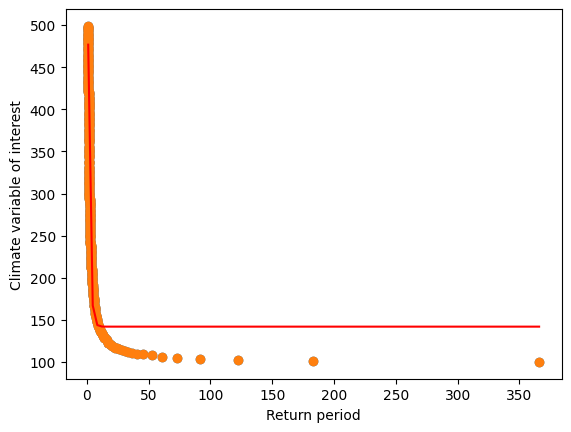

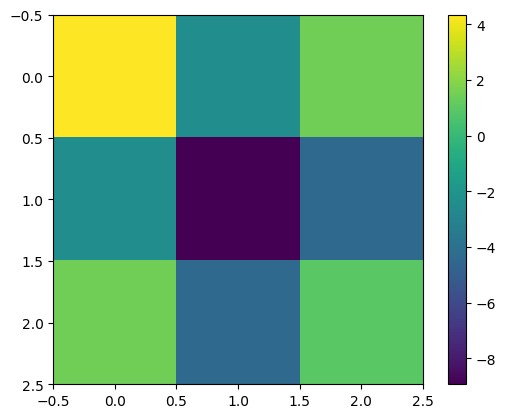

In [1]:
## Import packages ..... 
import cdsapi
import os
import os.path
from itertools import zip_longest # to iterate with zip not on the shortest iterable

## ..... and function
from FunctionsAndClass import year_copernicus
from FunctionsAndClass import path_length

In [2]:
## list all element necessary for download
class obs_elements:
    versions = ('v1.0','v2.0','v2020.0','v2020.0-v6.0-fg','v4.0','v4.03','v6.0')
    origins = ('berkearth','chirps','cmorph','cpc','cpc-conus','cru','gistemp','gpcc','imerg')
    # test only with chirps and cru at the beginning
    horizontal_aggregations = ('0_25_x_0_25','0_2_x_0_2','0_5_x_0_5','1_x_1','2_5_x_2_5','horizontal_average')
    time_aggregations = ('daily','monthly')
    regions = ('africa','global','conus','quasi_global')
    variables = ('precipitation','temperature','temperature_anomaly')
    statistics = ('NaN','maximum','mean','minimum') # NaN for when statistic is not needed

In [3]:
len(obs_elements.versions)

7

In [4]:
len(obs_elements.origins)

9

In [5]:
len(obs_elements.horizontal_aggregations)

6

In [6]:
len(obs_elements.time_aggregations)

2

In [7]:
len(obs_elements.regions)

4

In [8]:
len(obs_elements.variables)

3

In [9]:
len(obs_elements.statistics)

4

In [10]:
# create a list of iterable for the later for loop which will be use to download elements
list_obs_elements = []
for version in obs_elements.versions:
    for origin in obs_elements.origins:
        for horizontal_aggregation in obs_elements.horizontal_aggregations:
            for time_aggregation in obs_elements.time_aggregations:
                for region in obs_elements.regions:
                    for variable in obs_elements.variables:
                        for statistic in obs_elements.statistics:
                            list_obs_elements.append((version,origin,horizontal_aggregation,time_aggregation,region,variable,statistic))

In [11]:
list_obs_elements

[('v1.0',
  'berkearth',
  '0_25_x_0_25',
  'daily',
  'africa',
  'precipitation',
  'NaN'),
 ('v1.0',
  'berkearth',
  '0_25_x_0_25',
  'daily',
  'africa',
  'precipitation',
  'maximum'),
 ('v1.0',
  'berkearth',
  '0_25_x_0_25',
  'daily',
  'africa',
  'precipitation',
  'mean'),
 ('v1.0',
  'berkearth',
  '0_25_x_0_25',
  'daily',
  'africa',
  'precipitation',
  'minimum'),
 ('v1.0', 'berkearth', '0_25_x_0_25', 'daily', 'africa', 'temperature', 'NaN'),
 ('v1.0',
  'berkearth',
  '0_25_x_0_25',
  'daily',
  'africa',
  'temperature',
  'maximum'),
 ('v1.0',
  'berkearth',
  '0_25_x_0_25',
  'daily',
  'africa',
  'temperature',
  'mean'),
 ('v1.0',
  'berkearth',
  '0_25_x_0_25',
  'daily',
  'africa',
  'temperature',
  'minimum'),
 ('v1.0',
  'berkearth',
  '0_25_x_0_25',
  'daily',
  'africa',
  'temperature_anomaly',
  'NaN'),
 ('v1.0',
  'berkearth',
  '0_25_x_0_25',
  'daily',
  'africa',
  'temperature_anomaly',
  'maximum'),
 ('v1.0',
  'berkearth',
  '0_25_x_0_25',
  'd

In [12]:
len(list_obs_elements)

36288

In [13]:
def download_extract(path_for_file,source):
    if not os.path.isdir(path_for_file): # path_for_file does not exists, need to ensure that is is created
        os.makedirs(path_for_file) # to ensure the creation of the path
    # unzip the downloaded file
    from zipfile import ZipFile
    zf = ZipFile('download.zip', 'r')
    zf.extractall(source) # if no precision of directory, extract in current directory
    zf.close()

    #if not os.path.isdir(file_download): # path_for_file does not exists, need to ensure that is is created
    #   os.makedirs(file_download) # to ensure the creation of the path
    # moving download to appropriate place
    #shutil.move('download.zip',file_download) # no need to delete 'download.zip' from inital place
    shutil.move(source,path_for_file) # move extracted data to the path created for them
    #path_file=os.path.join(path_for_file,source)
    print('\n ------------------------------------- The downloaded file is extracted -------------------------------------')
    os.remove('download.zip') # delete 'download.zip' from current directory
    return #path_file

In [14]:
# this function define the start_date, dependent on the origin
def f_start_date(origin):
    # start_date depend on the origin
    if origin == 'berkearth':
        start_date = 1950
    if origin == 'chirps':
        start_date = 1981
    if origin == 'cmorph':
        start_date = 1998
    if origin == 'cpc':
        start_date = 1979
    if origin == 'cpc-conus':
        start_date = 1950
    if origin == 'cru':
        start_date = 1950
    if origin == 'gistemp':
        start_date = 1950
    if origin == 'gpcc':
        start_date = 1950
    if origin == 'imerg':
        start_date = 2000
    return start_date

# this function defines the period of the set of data
def f_period_str(origin):
    # stop_date is the same for every origin
    stop_date = 2015
    start_date = f_start_date(origin) # start_date depend on the origin
    period = str(start_date) +' - '+str(stop_date)
    return period

## this function produce the year vector, which is dependent on the origin

def year_temp_pr_obs(origin):
    # stop_date is the same for every origin
    stop_date = 2015
    start_date = f_start_date(origin) # start_date depend on the origin
    # produce vector of years
    (year, year_str, index)= year_copernicus(start_date,stop_date)
    return year_str

In [15]:
## this function aim to download observation data of https://cds.climate.copernicus.eu/cdsapp#!/dataset/insitu-gridded-observations-global-and-regional?tab=form
# the function returns the path where the data has been downloaded
def try_download_copernicus_temp_pr_obs(version,origin,horizontal_aggregation,time_aggregation,region,variable,statistic,path_for_file,source):
    # produce the year vector, which is dependent on the origin
    year = year_temp_pr_obs(origin)
    
    # start the API request
    c = cdsapi.Client()# function to use the c.retrieve
    # basic needed dictionnary to give to the c.retrieve function the parameters asked by the user
    variables = {
                'format': 'zip', # this function is only designed to download and unzip zip files
                'version': version,
                'origin': origin,
                'year': year,
                'horizontal_aggregation': horizontal_aggregation,
                'time_aggragation': time_aggregation,
                'region': region,
                'variable': variable,
    }
    
    if statistic != 'NaN':
        variables['statistic'] = statistic
    
    try:
        c.retrieve(
            'insitu-gridded-observations-global-and-regional',
            variables,
            'download.zip') # the file in a zip format is registered in the current directory
    except:
        print('------------------------------- Some parameters are not matching -------------------------------')
        return # stop the function, because some data the user entered are not matching
    
    # function to extract the downloaded zip
    #path_file=download_extract(path_for_file,file_download,source)
    download_extract(path_for_file,source)
    return #path_file

In [ ]:
# define path and source of data
out_path = r'\\COWI.net\projects\A245000\A248363\CRVA\Datasets\Observations'
source = 'copernicus-data-in-situ-and-satellite'
# start testing if data exists and if yes, download them with function try_download_copernicus_temp_pr_obs
for (version, origin, horizontal_aggregation,time_aggregation, region,variable,statistic) in list_obs_elements:
    
    print('\n')    
    print('version: ' +version)
    print('\n')    
    print('origin: ' +origin)
    print('\n')
    print('horizontal_aggregation: ' +horizontal_aggregation)
    print('\n')
    print('time_aggregation: ' +time_aggregation)
    print('\n')
    print('region: ' +region )
    print('\n')
    print('variable: '+ variable)
    print('\n')
    print('statistic: ' +statistic)
    print('\n')
    period = f_period_str(origin) # produce string of the considered period, to integrate period in the path
    path_for_file = os.path.join(out_path,variable, region,period, time_aggregation, horizontal_aggregation, origin, version) # create string of the path
    if statistic != 'NaN': # a statitics is requested
        path_for_file = os.path.join(path_for_file, statistic) # add statistic in the path
    path_for_file=path_length(path_for_file)# test if path is too long
    # try to download the data with the parameter of the loop. If the parameter match, the file will be dowloaded 
    # and extract within the same function try_download_copernicus_temp_pr_obs
    try_download_copernicus_temp_pr_obs(version,origin,horizontal_aggregation,time_aggregation,region,variable,statistic,path_for_file,source)



version: v1.0


origin: berkearth


horizontal_aggregation: 0_25_x_0_25


time_aggregation: daily


region: africa


variable: precipitation


statistic: NaN




2023-05-24 12:20:44,701 INFO Welcome to the CDS
2023-05-24 12:20:44,701 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:20:44,772 INFO Welcome to the CDS
2023-05-24 12:20:44,772 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:20:44,840 INFO Welcome to the CDS
2023-05-24 12:20:44,840 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:20:44,906 INFO Welcome to the CDS
2023-05-24 12:20:44,907 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: berkearth


horizontal_aggregation: 0_25_x_0_25


time_aggregation: daily


region: africa


variable: precipitation


statistic: maximum


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: berkearth


horizontal_aggregation: 0_25_x_0_25


time_aggregation: daily


region: africa


variable: precipitation


statistic: mean


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: berkearth


horizontal_aggregation: 0_25_x_0_25


time_aggregation: daily


region: africa


variable: precipitation


statistic: minimum




2023-05-24 12:20:44,975 INFO Welcome to the CDS
2023-05-24 12:20:44,976 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:20:45,042 INFO Welcome to the CDS
2023-05-24 12:20:45,042 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:20:45,109 INFO Welcome to the CDS
2023-05-24 12:20:45,111 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: berkearth


horizontal_aggregation: 0_25_x_0_25


time_aggregation: daily


region: africa


variable: temperature


statistic: NaN


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: berkearth


horizontal_aggregation: 0_25_x_0_25


time_aggregation: daily


region: africa


variable: temperature


statistic: maximum


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: berkearth


horizontal_aggregation: 0_25_x_0_25


time_aggregation: daily


region: africa


variable: temperature


statistic: mean


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: berkearth


horizontal_aggregation: 0_25_x_0_25


time_aggregation: daily


region: africa


variable

2023-05-24 12:20:45,182 INFO Welcome to the CDS
2023-05-24 12:20:45,182 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:20:45,251 INFO Welcome to the CDS
2023-05-24 12:20:45,252 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:20:45,320 INFO Welcome to the CDS
2023-05-24 12:20:45,321 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:20:45,392 INFO Welcome to the CDS
2023-05-24 12:20:45,394 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: berkearth


horizontal_aggregation: 0_25_x_0_25


time_aggregation: daily


region: africa


variable: temperature_anomaly


statistic: NaN


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: berkearth


horizontal_aggregation: 0_25_x_0_25


time_aggregation: daily


region: africa


variable: temperature_anomaly


statistic: maximum


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: berkearth


horizontal_aggregation: 0_25_x_0_25


time_aggregation: daily


region: africa


variable: temperature_anomaly


statistic: mean


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: berkearth


horizontal_aggregation: 0_25_x_0_25


time_aggregation: daily


r

2023-05-24 12:20:45,466 INFO Welcome to the CDS
2023-05-24 12:20:45,466 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:20:45,534 INFO Welcome to the CDS
2023-05-24 12:20:45,534 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:20:45,608 INFO Welcome to the CDS
2023-05-24 12:20:45,609 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:20:45,689 INFO Welcome to the CDS


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: berkearth


horizontal_aggregation: 0_25_x_0_25


time_aggregation: daily


region: global


variable: precipitation


statistic: NaN


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: berkearth


horizontal_aggregation: 0_25_x_0_25


time_aggregation: daily


region: global


variable: precipitation


statistic: maximum


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: berkearth


horizontal_aggregation: 0_25_x_0_25


time_aggregation: daily


region: global


variable: precipitation


statistic: mean




2023-05-24 12:20:45,689 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:20:45,758 INFO Welcome to the CDS
2023-05-24 12:20:45,758 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:20:45,828 INFO Welcome to the CDS
2023-05-24 12:20:45,829 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:20:45,896 INFO Welcome to the CDS
2023-05-24 12:20:45,898 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: berkearth


horizontal_aggregation: 0_25_x_0_25


time_aggregation: daily


region: global


variable: precipitation


statistic: minimum


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: berkearth


horizontal_aggregation: 0_25_x_0_25


time_aggregation: daily


region: global


variable: temperature


statistic: NaN


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: berkearth


horizontal_aggregation: 0_25_x_0_25


time_aggregation: daily


region: global


variable: temperature


statistic: maximum




2023-05-24 12:20:45,964 INFO Welcome to the CDS
2023-05-24 12:20:45,965 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:20:46,032 INFO Welcome to the CDS
2023-05-24 12:20:46,033 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:20:46,101 INFO Welcome to the CDS
2023-05-24 12:20:46,102 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: berkearth


horizontal_aggregation: 0_25_x_0_25


time_aggregation: daily


region: global


variable: temperature


statistic: mean


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: berkearth


horizontal_aggregation: 0_25_x_0_25


time_aggregation: daily


region: global


variable: temperature


statistic: minimum


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: berkearth


horizontal_aggregation: 0_25_x_0_25


time_aggregation: daily


region: global


variable: temperature_anomaly


statistic: NaN


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: berkearth


horizontal_aggregation: 0_25_x_0_25


time_aggregation: daily


region: global




2023-05-24 12:20:46,168 INFO Welcome to the CDS
2023-05-24 12:20:46,169 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:20:46,236 INFO Welcome to the CDS
2023-05-24 12:20:46,237 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:20:46,303 INFO Welcome to the CDS
2023-05-24 12:20:46,304 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:20:46,371 INFO Welcome to the CDS
2023-05-24 12:20:46,372 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: berkearth


horizontal_aggregation: 0_25_x_0_25


time_aggregation: daily


region: global


variable: temperature_anomaly


statistic: mean


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: berkearth


horizontal_aggregation: 0_25_x_0_25


time_aggregation: daily


region: global


variable: temperature_anomaly


statistic: minimum


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: berkearth


horizontal_aggregation: 0_25_x_0_25


time_aggregation: daily


region: conus


variable: precipitation


statistic: NaN




2023-05-24 12:20:46,442 INFO Welcome to the CDS
2023-05-24 12:20:46,443 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:20:46,510 INFO Welcome to the CDS
2023-05-24 12:20:46,511 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:20:46,576 INFO Welcome to the CDS
2023-05-24 12:20:46,577 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: berkearth


horizontal_aggregation: 0_25_x_0_25


time_aggregation: daily


region: conus


variable: precipitation


statistic: maximum


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: berkearth


horizontal_aggregation: 0_25_x_0_25


time_aggregation: daily


region: conus


variable: precipitation


statistic: mean


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: berkearth


horizontal_aggregation: 0_25_x_0_25


time_aggregation: daily


region: conus


variable: precipitation


statistic: minimum




2023-05-24 12:20:46,645 INFO Welcome to the CDS
2023-05-24 12:20:46,646 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:20:46,713 INFO Welcome to the CDS
2023-05-24 12:20:46,714 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:20:46,780 INFO Welcome to the CDS
2023-05-24 12:20:46,781 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: berkearth


horizontal_aggregation: 0_25_x_0_25


time_aggregation: daily


region: conus


variable: temperature


statistic: NaN


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: berkearth


horizontal_aggregation: 0_25_x_0_25


time_aggregation: daily


region: conus


variable: temperature


statistic: maximum


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: berkearth


horizontal_aggregation: 0_25_x_0_25


time_aggregation: daily


region: conus


variable: temperature


statistic: mean




2023-05-24 12:20:46,852 INFO Welcome to the CDS
2023-05-24 12:20:46,853 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:20:46,922 INFO Welcome to the CDS
2023-05-24 12:20:46,923 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:20:46,993 INFO Welcome to the CDS
2023-05-24 12:20:46,994 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: berkearth


horizontal_aggregation: 0_25_x_0_25


time_aggregation: daily


region: conus


variable: temperature


statistic: minimum


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: berkearth


horizontal_aggregation: 0_25_x_0_25


time_aggregation: daily


region: conus


variable: temperature_anomaly


statistic: NaN


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: berkearth


horizontal_aggregation: 0_25_x_0_25


time_aggregation: daily


region: conus


variable: temperature_anomaly


statistic: maximum




2023-05-24 12:20:47,059 INFO Welcome to the CDS
2023-05-24 12:20:47,060 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:20:47,126 INFO Welcome to the CDS
2023-05-24 12:20:47,126 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:20:47,194 INFO Welcome to the CDS
2023-05-24 12:20:47,195 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: berkearth


horizontal_aggregation: 0_25_x_0_25


time_aggregation: daily


region: conus


variable: temperature_anomaly


statistic: mean


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: berkearth


horizontal_aggregation: 0_25_x_0_25


time_aggregation: daily


region: conus


variable: temperature_anomaly


statistic: minimum


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: berkearth


horizontal_aggregation: 0_25_x_0_25


time_aggregation: daily


region: quasi_global


variable: precipitation


statistic: NaN




2023-05-24 12:20:47,263 INFO Welcome to the CDS
2023-05-24 12:20:47,264 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:20:47,330 INFO Welcome to the CDS
2023-05-24 12:20:47,331 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:20:47,398 INFO Welcome to the CDS
2023-05-24 12:20:47,399 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: berkearth


horizontal_aggregation: 0_25_x_0_25


time_aggregation: daily


region: quasi_global


variable: precipitation


statistic: maximum


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: berkearth


horizontal_aggregation: 0_25_x_0_25


time_aggregation: daily


region: quasi_global


variable: precipitation


statistic: mean


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: berkearth


horizontal_aggregation: 0_25_x_0_25


time_aggregation: daily


region: quasi_global


variable: precipitation


statistic: minimum


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: berkearth


horizontal_aggregation: 0_25_x_0_25


time_aggregation: daily

2023-05-24 12:20:47,467 INFO Welcome to the CDS
2023-05-24 12:20:47,468 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:20:47,537 INFO Welcome to the CDS
2023-05-24 12:20:47,538 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:20:47,604 INFO Welcome to the CDS
2023-05-24 12:20:47,605 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:20:47,670 INFO Welcome to the CDS
2023-05-24 12:20:47,671 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: berkearth


horizontal_aggregation: 0_25_x_0_25


time_aggregation: daily


region: quasi_global


variable: temperature


statistic: maximum


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: berkearth


horizontal_aggregation: 0_25_x_0_25


time_aggregation: daily


region: quasi_global


variable: temperature


statistic: mean


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: berkearth


horizontal_aggregation: 0_25_x_0_25


time_aggregation: daily


region: quasi_global


variable: temperature


statistic: minimum


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: berkearth


horizontal_aggregation: 0_25_x_0_25


time_aggregation: daily


reg

2023-05-24 12:20:47,738 INFO Welcome to the CDS
2023-05-24 12:20:47,739 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:20:47,805 INFO Welcome to the CDS
2023-05-24 12:20:47,806 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:20:47,874 INFO Welcome to the CDS
2023-05-24 12:20:47,875 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:20:47,946 INFO Welcome to the CDS
2023-05-24 12:20:47,947 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: berkearth


horizontal_aggregation: 0_25_x_0_25


time_aggregation: daily


region: quasi_global


variable: temperature_anomaly


statistic: maximum


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: berkearth


horizontal_aggregation: 0_25_x_0_25


time_aggregation: daily


region: quasi_global


variable: temperature_anomaly


statistic: mean


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: berkearth


horizontal_aggregation: 0_25_x_0_25


time_aggregation: daily


region: quasi_global


variable: temperature_anomaly


statistic: minimum


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: berkearth


horizontal_aggregation: 0_25_x_0_25


time_

2023-05-24 12:20:48,019 INFO Welcome to the CDS
2023-05-24 12:20:48,020 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:20:48,092 INFO Welcome to the CDS
2023-05-24 12:20:48,094 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: berkearth


horizontal_aggregation: 0_25_x_0_25


time_aggregation: monthly


region: africa


variable: precipitation


statistic: maximum


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: berkearth


horizontal_aggregation: 0_25_x_0_25


time_aggregation: monthly


region: africa


variable: precipitation


statistic: mean




2023-05-24 12:20:48,502 INFO Welcome to the CDS
2023-05-24 12:20:48,503 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:20:48,570 INFO Welcome to the CDS
2023-05-24 12:20:48,571 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:20:48,637 INFO Welcome to the CDS
2023-05-24 12:20:48,638 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:20:48,704 INFO Welcome to the CDS
2023-05-24 12:20:48,704 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: berkearth


horizontal_aggregation: 0_25_x_0_25


time_aggregation: monthly


region: africa


variable: precipitation


statistic: minimum


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: berkearth


horizontal_aggregation: 0_25_x_0_25


time_aggregation: monthly


region: africa


variable: temperature


statistic: NaN


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: berkearth


horizontal_aggregation: 0_25_x_0_25


time_aggregation: monthly


region: africa


variable: temperature


statistic: maximum


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: berkearth


horizontal_aggregation: 0_25_x_0_25


time_aggregation: monthly


region: afri

2023-05-24 12:20:48,770 INFO Welcome to the CDS
2023-05-24 12:20:48,771 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:20:48,839 INFO Welcome to the CDS
2023-05-24 12:20:48,839 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:20:48,912 INFO Welcome to the CDS
2023-05-24 12:20:48,914 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:20:48,986 INFO Welcome to the CDS


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: berkearth


horizontal_aggregation: 0_25_x_0_25


time_aggregation: monthly


region: africa


variable: temperature


statistic: minimum


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: berkearth


horizontal_aggregation: 0_25_x_0_25


time_aggregation: monthly


region: africa


variable: temperature_anomaly


statistic: NaN


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: berkearth


horizontal_aggregation: 0_25_x_0_25


time_aggregation: monthly


region: africa


variable: temperature_anomaly


statistic: maximum




2023-05-24 12:20:48,988 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:20:49,062 INFO Welcome to the CDS
2023-05-24 12:20:49,062 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:20:49,129 INFO Welcome to the CDS
2023-05-24 12:20:49,130 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:20:49,196 INFO Welcome to the CDS
2023-05-24 12:20:49,197 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: berkearth


horizontal_aggregation: 0_25_x_0_25


time_aggregation: monthly


region: africa


variable: temperature_anomaly


statistic: mean


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: berkearth


horizontal_aggregation: 0_25_x_0_25


time_aggregation: monthly


region: africa


variable: temperature_anomaly


statistic: minimum


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: berkearth


horizontal_aggregation: 0_25_x_0_25


time_aggregation: monthly


region: global


variable: precipitation


statistic: NaN




2023-05-24 12:20:49,267 INFO Welcome to the CDS
2023-05-24 12:20:49,268 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:20:49,334 INFO Welcome to the CDS
2023-05-24 12:20:49,335 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:20:49,401 INFO Welcome to the CDS
2023-05-24 12:20:49,402 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: berkearth


horizontal_aggregation: 0_25_x_0_25


time_aggregation: monthly


region: global


variable: precipitation


statistic: maximum


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: berkearth


horizontal_aggregation: 0_25_x_0_25


time_aggregation: monthly


region: global


variable: precipitation


statistic: mean


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: berkearth


horizontal_aggregation: 0_25_x_0_25


time_aggregation: monthly


region: global


variable: precipitation


statistic: minimum


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: berkearth


horizontal_aggregation: 0_25_x_0_25


time_aggregation: monthly


region:

2023-05-24 12:20:49,469 INFO Welcome to the CDS
2023-05-24 12:20:49,470 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:20:49,536 INFO Welcome to the CDS
2023-05-24 12:20:49,537 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:20:49,606 INFO Welcome to the CDS
2023-05-24 12:20:49,606 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:20:49,674 INFO Welcome to the CDS
2023-05-24 12:20:49,675 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: berkearth


horizontal_aggregation: 0_25_x_0_25


time_aggregation: monthly


region: global


variable: temperature


statistic: maximum


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: berkearth


horizontal_aggregation: 0_25_x_0_25


time_aggregation: monthly


region: global


variable: temperature


statistic: mean


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: berkearth


horizontal_aggregation: 0_25_x_0_25


time_aggregation: monthly


region: global


variable: temperature


statistic: minimum


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: berkearth


horizontal_aggregation: 0_25_x_0_25


time_aggregation: monthly


region: globa

2023-05-24 12:20:49,757 INFO Welcome to the CDS
2023-05-24 12:20:49,758 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:20:49,825 INFO Welcome to the CDS
2023-05-24 12:20:49,827 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:20:49,893 INFO Welcome to the CDS
2023-05-24 12:20:49,894 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:20:49,962 INFO Welcome to the CDS
2023-05-24 12:20:49,964 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: berkearth


horizontal_aggregation: 0_25_x_0_25


time_aggregation: monthly


region: global


variable: temperature_anomaly


statistic: maximum


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: berkearth


horizontal_aggregation: 0_25_x_0_25


time_aggregation: monthly


region: global


variable: temperature_anomaly


statistic: mean


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: berkearth


horizontal_aggregation: 0_25_x_0_25


time_aggregation: monthly


region: global


variable: temperature_anomaly


statistic: minimum


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: berkearth


horizontal_aggregation: 0_25_x_0_25


time_aggregation:

2023-05-24 12:20:50,033 INFO Welcome to the CDS
2023-05-24 12:20:50,034 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:20:50,102 INFO Welcome to the CDS
2023-05-24 12:20:50,102 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:20:50,168 INFO Welcome to the CDS
2023-05-24 12:20:50,170 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:20:50,238 INFO Welcome to the CDS
2023-05-24 12:20:50,240 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: berkearth


horizontal_aggregation: 0_25_x_0_25


time_aggregation: monthly


region: conus


variable: precipitation


statistic: maximum


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: berkearth


horizontal_aggregation: 0_25_x_0_25


time_aggregation: monthly


region: conus


variable: precipitation


statistic: mean


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: berkearth


horizontal_aggregation: 0_25_x_0_25


time_aggregation: monthly


region: conus


variable: precipitation


statistic: minimum


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: berkearth


horizontal_aggregation: 0_25_x_0_25


time_aggregation: monthly


region: co

2023-05-24 12:20:50,309 INFO Welcome to the CDS
2023-05-24 12:20:50,310 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:20:50,526 INFO Welcome to the CDS
2023-05-24 12:20:50,527 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:20:50,594 INFO Welcome to the CDS
2023-05-24 12:20:50,594 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:20:50,660 INFO Welcome to the CDS
2023-05-24 12:20:50,661 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: berkearth


horizontal_aggregation: 0_25_x_0_25


time_aggregation: monthly


region: conus


variable: temperature


statistic: maximum


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: berkearth


horizontal_aggregation: 0_25_x_0_25


time_aggregation: monthly


region: conus


variable: temperature


statistic: mean


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: berkearth


horizontal_aggregation: 0_25_x_0_25


time_aggregation: monthly


region: conus


variable: temperature


statistic: minimum


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: berkearth


horizontal_aggregation: 0_25_x_0_25


time_aggregation: monthly


region: conus




2023-05-24 12:20:50,728 INFO Welcome to the CDS
2023-05-24 12:20:50,729 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:20:50,795 INFO Welcome to the CDS
2023-05-24 12:20:50,796 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:20:50,864 INFO Welcome to the CDS
2023-05-24 12:20:50,866 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:20:50,936 INFO Welcome to the CDS
2023-05-24 12:20:50,937 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: berkearth


horizontal_aggregation: 0_25_x_0_25


time_aggregation: monthly


region: conus


variable: temperature_anomaly


statistic: maximum


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: berkearth


horizontal_aggregation: 0_25_x_0_25


time_aggregation: monthly


region: conus


variable: temperature_anomaly


statistic: mean


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: berkearth


horizontal_aggregation: 0_25_x_0_25


time_aggregation: monthly


region: conus


variable: temperature_anomaly


statistic: minimum


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: berkearth


horizontal_aggregation: 0_25_x_0_25


time_aggregation: mo

2023-05-24 12:20:51,005 INFO Welcome to the CDS
2023-05-24 12:20:51,005 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:20:51,072 INFO Welcome to the CDS
2023-05-24 12:20:51,073 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:20:51,144 INFO Welcome to the CDS
2023-05-24 12:20:51,145 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:20:51,214 INFO Welcome to the CDS
2023-05-24 12:20:51,216 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: berkearth


horizontal_aggregation: 0_25_x_0_25


time_aggregation: monthly


region: quasi_global


variable: precipitation


statistic: maximum


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: berkearth


horizontal_aggregation: 0_25_x_0_25


time_aggregation: monthly


region: quasi_global


variable: precipitation


statistic: mean


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: berkearth


horizontal_aggregation: 0_25_x_0_25


time_aggregation: monthly


region: quasi_global


variable: precipitation


statistic: minimum




2023-05-24 12:20:51,287 INFO Welcome to the CDS
2023-05-24 12:20:51,289 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:20:51,356 INFO Welcome to the CDS
2023-05-24 12:20:51,358 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:20:51,427 INFO Welcome to the CDS
2023-05-24 12:20:51,428 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: berkearth


horizontal_aggregation: 0_25_x_0_25


time_aggregation: monthly


region: quasi_global


variable: temperature


statistic: NaN


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: berkearth


horizontal_aggregation: 0_25_x_0_25


time_aggregation: monthly


region: quasi_global


variable: temperature


statistic: maximum


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: berkearth


horizontal_aggregation: 0_25_x_0_25


time_aggregation: monthly


region: quasi_global


variable: temperature


statistic: mean


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: berkearth


horizontal_aggregation: 0_25_x_0_25


time_aggregation: monthly



2023-05-24 12:20:51,495 INFO Welcome to the CDS
2023-05-24 12:20:51,496 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:20:51,562 INFO Welcome to the CDS
2023-05-24 12:20:51,563 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:20:51,631 INFO Welcome to the CDS
2023-05-24 12:20:51,632 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:20:51,701 INFO Welcome to the CDS
2023-05-24 12:20:51,702 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: berkearth


horizontal_aggregation: 0_25_x_0_25


time_aggregation: monthly


region: quasi_global


variable: temperature_anomaly


statistic: NaN


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: berkearth


horizontal_aggregation: 0_25_x_0_25


time_aggregation: monthly


region: quasi_global


variable: temperature_anomaly


statistic: maximum


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: berkearth


horizontal_aggregation: 0_25_x_0_25


time_aggregation: monthly


region: quasi_global


variable: temperature_anomaly


statistic: mean




2023-05-24 12:20:51,771 INFO Welcome to the CDS
2023-05-24 12:20:51,772 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:20:51,841 INFO Welcome to the CDS
2023-05-24 12:20:51,843 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:20:51,912 INFO Welcome to the CDS
2023-05-24 12:20:51,912 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: berkearth


horizontal_aggregation: 0_25_x_0_25


time_aggregation: monthly


region: quasi_global


variable: temperature_anomaly


statistic: minimum


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: berkearth


horizontal_aggregation: 0_2_x_0_2


time_aggregation: daily


region: africa


variable: precipitation


statistic: NaN


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: berkearth


horizontal_aggregation: 0_2_x_0_2


time_aggregation: daily


region: africa


variable: precipitation


statistic: maximum




2023-05-24 12:20:51,979 INFO Welcome to the CDS
2023-05-24 12:20:51,979 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:20:52,044 INFO Welcome to the CDS
2023-05-24 12:20:52,045 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: berkearth


horizontal_aggregation: 0_2_x_0_2


time_aggregation: daily


region: africa


variable: precipitation


statistic: mean


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: berkearth


horizontal_aggregation: 0_2_x_0_2


time_aggregation: daily


region: africa


variable: precipitation


statistic: minimum


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: berkearth


horizontal_aggregation: 0_2_x_0_2


time_aggregation: daily


region: africa


variable: temperature


statistic: NaN




2023-05-24 12:20:52,469 INFO Welcome to the CDS
2023-05-24 12:20:52,470 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:20:52,545 INFO Welcome to the CDS
2023-05-24 12:20:52,546 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:20:52,618 INFO Welcome to the CDS
2023-05-24 12:20:52,620 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: berkearth


horizontal_aggregation: 0_2_x_0_2


time_aggregation: daily


region: africa


variable: temperature


statistic: maximum


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: berkearth


horizontal_aggregation: 0_2_x_0_2


time_aggregation: daily


region: africa


variable: temperature


statistic: mean


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: berkearth


horizontal_aggregation: 0_2_x_0_2


time_aggregation: daily


region: africa


variable: temperature


statistic: minimum




2023-05-24 12:20:52,697 INFO Welcome to the CDS
2023-05-24 12:20:52,697 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:20:52,771 INFO Welcome to the CDS
2023-05-24 12:20:52,771 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:20:52,844 INFO Welcome to the CDS
2023-05-24 12:20:52,845 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:20:52,925 INFO Welcome to the CDS


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: berkearth


horizontal_aggregation: 0_2_x_0_2


time_aggregation: daily


region: africa


variable: temperature_anomaly


statistic: NaN


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: berkearth


horizontal_aggregation: 0_2_x_0_2


time_aggregation: daily


region: africa


variable: temperature_anomaly


statistic: maximum


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: berkearth


horizontal_aggregation: 0_2_x_0_2


time_aggregation: daily


region: africa


variable: temperature_anomaly


statistic: mean




2023-05-24 12:20:52,926 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:20:53,001 INFO Welcome to the CDS
2023-05-24 12:20:53,002 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:20:53,076 INFO Welcome to the CDS
2023-05-24 12:20:53,076 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:20:53,148 INFO Welcome to the CDS
2023-05-24 12:20:53,149 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: berkearth


horizontal_aggregation: 0_2_x_0_2


time_aggregation: daily


region: africa


variable: temperature_anomaly


statistic: minimum


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: berkearth


horizontal_aggregation: 0_2_x_0_2


time_aggregation: daily


region: global


variable: precipitation


statistic: NaN


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: berkearth


horizontal_aggregation: 0_2_x_0_2


time_aggregation: daily


region: global


variable: precipitation


statistic: maximum




2023-05-24 12:20:53,226 INFO Welcome to the CDS
2023-05-24 12:20:53,227 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:20:53,300 INFO Welcome to the CDS
2023-05-24 12:20:53,300 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:20:53,376 INFO Welcome to the CDS


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: berkearth


horizontal_aggregation: 0_2_x_0_2


time_aggregation: daily


region: global


variable: precipitation


statistic: mean


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: berkearth


horizontal_aggregation: 0_2_x_0_2


time_aggregation: daily


region: global


variable: precipitation


statistic: minimum


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: berkearth


horizontal_aggregation: 0_2_x_0_2


time_aggregation: daily


region: global


variable: temperature


statistic: NaN




2023-05-24 12:20:53,377 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:20:53,448 INFO Welcome to the CDS
2023-05-24 12:20:53,449 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:20:53,526 INFO Welcome to the CDS
2023-05-24 12:20:53,527 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: berkearth


horizontal_aggregation: 0_2_x_0_2


time_aggregation: daily


region: global


variable: temperature


statistic: maximum


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: berkearth


horizontal_aggregation: 0_2_x_0_2


time_aggregation: daily


region: global


variable: temperature


statistic: mean


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: berkearth


horizontal_aggregation: 0_2_x_0_2


time_aggregation: daily


region: global


variable: temperature


statistic: minimum




2023-05-24 12:20:53,598 INFO Welcome to the CDS
2023-05-24 12:20:53,599 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:20:53,673 INFO Welcome to the CDS
2023-05-24 12:20:53,675 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:20:53,747 INFO Welcome to the CDS
2023-05-24 12:20:53,747 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: berkearth


horizontal_aggregation: 0_2_x_0_2


time_aggregation: daily


region: global


variable: temperature_anomaly


statistic: NaN


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: berkearth


horizontal_aggregation: 0_2_x_0_2


time_aggregation: daily


region: global


variable: temperature_anomaly


statistic: maximum


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: berkearth


horizontal_aggregation: 0_2_x_0_2


time_aggregation: daily


region: global


variable: temperature_anomaly


statistic: mean




2023-05-24 12:20:53,823 INFO Welcome to the CDS
2023-05-24 12:20:53,824 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:20:53,901 INFO Welcome to the CDS
2023-05-24 12:20:53,902 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:20:53,976 INFO Welcome to the CDS
2023-05-24 12:20:53,977 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:20:54,048 INFO Welcome to the CDS


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: berkearth


horizontal_aggregation: 0_2_x_0_2


time_aggregation: daily


region: global


variable: temperature_anomaly


statistic: minimum


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: berkearth


horizontal_aggregation: 0_2_x_0_2


time_aggregation: daily


region: conus


variable: precipitation


statistic: NaN


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: berkearth


horizontal_aggregation: 0_2_x_0_2


time_aggregation: daily


region: conus


variable: precipitation


statistic: maximum




2023-05-24 12:20:54,048 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:20:54,128 INFO Welcome to the CDS
2023-05-24 12:20:54,129 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:20:54,201 INFO Welcome to the CDS
2023-05-24 12:20:54,203 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:20:54,276 INFO Welcome to the CDS
2023-05-24 12:20:54,278 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: berkearth


horizontal_aggregation: 0_2_x_0_2


time_aggregation: daily


region: conus


variable: precipitation


statistic: mean


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: berkearth


horizontal_aggregation: 0_2_x_0_2


time_aggregation: daily


region: conus


variable: precipitation


statistic: minimum


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: berkearth


horizontal_aggregation: 0_2_x_0_2


time_aggregation: daily


region: conus


variable: temperature


statistic: NaN




2023-05-24 12:20:54,354 INFO Welcome to the CDS
2023-05-24 12:20:54,357 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:20:54,431 INFO Welcome to the CDS
2023-05-24 12:20:54,432 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:20:54,507 INFO Welcome to the CDS


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: berkearth


horizontal_aggregation: 0_2_x_0_2


time_aggregation: daily


region: conus


variable: temperature


statistic: maximum


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: berkearth


horizontal_aggregation: 0_2_x_0_2


time_aggregation: daily


region: conus


variable: temperature


statistic: mean


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: berkearth


horizontal_aggregation: 0_2_x_0_2


time_aggregation: daily


region: conus


variable: temperature


statistic: minimum




2023-05-24 12:20:54,510 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:20:54,581 INFO Welcome to the CDS
2023-05-24 12:20:54,582 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:20:54,655 INFO Welcome to the CDS
2023-05-24 12:20:54,656 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:20:54,731 INFO Welcome to the CDS
2023-05-24 12:20:54,732 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: berkearth


horizontal_aggregation: 0_2_x_0_2


time_aggregation: daily


region: conus


variable: temperature_anomaly


statistic: NaN


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: berkearth


horizontal_aggregation: 0_2_x_0_2


time_aggregation: daily


region: conus


variable: temperature_anomaly


statistic: maximum


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: berkearth


horizontal_aggregation: 0_2_x_0_2


time_aggregation: daily


region: conus


variable: temperature_anomaly


statistic: mean




2023-05-24 12:20:54,806 INFO Welcome to the CDS
2023-05-24 12:20:54,807 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:20:54,881 INFO Welcome to the CDS
2023-05-24 12:20:54,882 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:20:54,955 INFO Welcome to the CDS


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: berkearth


horizontal_aggregation: 0_2_x_0_2


time_aggregation: daily


region: conus


variable: temperature_anomaly


statistic: minimum


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: berkearth


horizontal_aggregation: 0_2_x_0_2


time_aggregation: daily


region: quasi_global


variable: precipitation


statistic: NaN


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: berkearth


horizontal_aggregation: 0_2_x_0_2


time_aggregation: daily


region: quasi_global


variable: precipitation


statistic: maximum




2023-05-24 12:20:54,957 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:20:55,033 INFO Welcome to the CDS
2023-05-24 12:20:55,034 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:20:55,109 INFO Welcome to the CDS
2023-05-24 12:20:55,110 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:20:55,187 INFO Welcome to the CDS


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: berkearth


horizontal_aggregation: 0_2_x_0_2


time_aggregation: daily


region: quasi_global


variable: precipitation


statistic: mean


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: berkearth


horizontal_aggregation: 0_2_x_0_2


time_aggregation: daily


region: quasi_global


variable: precipitation


statistic: minimum


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: berkearth


horizontal_aggregation: 0_2_x_0_2


time_aggregation: daily


region: quasi_global


variable: temperature


statistic: NaN




2023-05-24 12:20:55,188 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:20:55,262 INFO Welcome to the CDS
2023-05-24 12:20:55,264 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:20:55,336 INFO Welcome to the CDS
2023-05-24 12:20:55,337 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:20:55,412 INFO Welcome to the CDS


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: berkearth


horizontal_aggregation: 0_2_x_0_2


time_aggregation: daily


region: quasi_global


variable: temperature


statistic: maximum


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: berkearth


horizontal_aggregation: 0_2_x_0_2


time_aggregation: daily


region: quasi_global


variable: temperature


statistic: mean


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: berkearth


horizontal_aggregation: 0_2_x_0_2


time_aggregation: daily


region: quasi_global


variable: temperature


statistic: minimum




2023-05-24 12:20:55,413 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:20:55,491 INFO Welcome to the CDS
2023-05-24 12:20:55,492 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:20:55,566 INFO Welcome to the CDS
2023-05-24 12:20:55,568 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:20:55,644 INFO Welcome to the CDS


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: berkearth


horizontal_aggregation: 0_2_x_0_2


time_aggregation: daily


region: quasi_global


variable: temperature_anomaly


statistic: NaN


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: berkearth


horizontal_aggregation: 0_2_x_0_2


time_aggregation: daily


region: quasi_global


variable: temperature_anomaly


statistic: maximum


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: berkearth


horizontal_aggregation: 0_2_x_0_2


time_aggregation: daily


region: quasi_global


variable: temperature_anomaly


statistic: mean




2023-05-24 12:20:55,646 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:20:55,728 INFO Welcome to the CDS
2023-05-24 12:20:55,728 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:20:55,802 INFO Welcome to the CDS
2023-05-24 12:20:55,804 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:20:55,877 INFO Welcome to the CDS


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: berkearth


horizontal_aggregation: 0_2_x_0_2


time_aggregation: daily


region: quasi_global


variable: temperature_anomaly


statistic: minimum


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: berkearth


horizontal_aggregation: 0_2_x_0_2


time_aggregation: monthly


region: africa


variable: precipitation


statistic: NaN


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: berkearth


horizontal_aggregation: 0_2_x_0_2


time_aggregation: monthly


region: africa


variable: precipitation


statistic: maximum




2023-05-24 12:20:55,878 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:20:55,953 INFO Welcome to the CDS
2023-05-24 12:20:55,954 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:20:56,030 INFO Welcome to the CDS
2023-05-24 12:20:56,032 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:20:56,105 INFO Welcome to the CDS


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: berkearth


horizontal_aggregation: 0_2_x_0_2


time_aggregation: monthly


region: africa


variable: precipitation


statistic: mean


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: berkearth


horizontal_aggregation: 0_2_x_0_2


time_aggregation: monthly


region: africa


variable: precipitation


statistic: minimum


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: berkearth


horizontal_aggregation: 0_2_x_0_2


time_aggregation: monthly


region: africa


variable: temperature


statistic: NaN




2023-05-24 12:20:56,106 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:20:56,181 INFO Welcome to the CDS
2023-05-24 12:20:56,183 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: berkearth


horizontal_aggregation: 0_2_x_0_2


time_aggregation: monthly


region: africa


variable: temperature


statistic: maximum


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: berkearth


horizontal_aggregation: 0_2_x_0_2


time_aggregation: monthly


region: africa


variable: temperature


statistic: mean




2023-05-24 12:20:56,584 INFO Welcome to the CDS
2023-05-24 12:20:56,585 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:20:56,652 INFO Welcome to the CDS
2023-05-24 12:20:56,652 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:20:56,717 INFO Welcome to the CDS
2023-05-24 12:20:56,719 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:20:56,783 INFO Welcome to the CDS
2023-05-24 12:20:56,784 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: berkearth


horizontal_aggregation: 0_2_x_0_2


time_aggregation: monthly


region: africa


variable: temperature


statistic: minimum


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: berkearth


horizontal_aggregation: 0_2_x_0_2


time_aggregation: monthly


region: africa


variable: temperature_anomaly


statistic: NaN


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: berkearth


horizontal_aggregation: 0_2_x_0_2


time_aggregation: monthly


region: africa


variable: temperature_anomaly


statistic: maximum


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: berkearth


horizontal_aggregation: 0_2_x_0_2


time_aggregation: monthly


region

2023-05-24 12:20:56,844 INFO Welcome to the CDS
2023-05-24 12:20:56,845 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:20:56,905 INFO Welcome to the CDS
2023-05-24 12:20:56,906 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:20:56,967 INFO Welcome to the CDS
2023-05-24 12:20:56,969 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:20:57,034 INFO Welcome to the CDS
2023-05-24 12:20:57,035 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: berkearth


horizontal_aggregation: 0_2_x_0_2


time_aggregation: monthly


region: africa


variable: temperature_anomaly


statistic: minimum


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: berkearth


horizontal_aggregation: 0_2_x_0_2


time_aggregation: monthly


region: global


variable: precipitation


statistic: NaN


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: berkearth


horizontal_aggregation: 0_2_x_0_2


time_aggregation: monthly


region: global


variable: precipitation


statistic: maximum


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: berkearth


horizontal_aggregation: 0_2_x_0_2


time_aggregation: monthly


region: gl

2023-05-24 12:20:57,102 INFO Welcome to the CDS
2023-05-24 12:20:57,104 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:20:57,166 INFO Welcome to the CDS
2023-05-24 12:20:57,167 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:20:57,227 INFO Welcome to the CDS
2023-05-24 12:20:57,228 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:20:57,297 INFO Welcome to the CDS
2023-05-24 12:20:57,297 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: berkearth


horizontal_aggregation: 0_2_x_0_2


time_aggregation: monthly


region: global


variable: precipitation


statistic: minimum


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: berkearth


horizontal_aggregation: 0_2_x_0_2


time_aggregation: monthly


region: global


variable: temperature


statistic: NaN


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: berkearth


horizontal_aggregation: 0_2_x_0_2


time_aggregation: monthly


region: global


variable: temperature


statistic: maximum


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: berkearth


horizontal_aggregation: 0_2_x_0_2


time_aggregation: monthly


region: global


var

2023-05-24 12:20:57,359 INFO Welcome to the CDS
2023-05-24 12:20:57,360 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:20:57,426 INFO Welcome to the CDS
2023-05-24 12:20:57,427 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:20:57,489 INFO Welcome to the CDS
2023-05-24 12:20:57,490 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:20:57,554 INFO Welcome to the CDS
2023-05-24 12:20:57,555 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: berkearth


horizontal_aggregation: 0_2_x_0_2


time_aggregation: monthly


region: global


variable: temperature


statistic: minimum


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: berkearth


horizontal_aggregation: 0_2_x_0_2


time_aggregation: monthly


region: global


variable: temperature_anomaly


statistic: NaN


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: berkearth


horizontal_aggregation: 0_2_x_0_2


time_aggregation: monthly


region: global


variable: temperature_anomaly


statistic: maximum


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: berkearth


horizontal_aggregation: 0_2_x_0_2


time_aggregation: monthly


region

2023-05-24 12:20:57,621 INFO Welcome to the CDS
2023-05-24 12:20:57,622 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:20:57,688 INFO Welcome to the CDS
2023-05-24 12:20:57,689 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:20:57,754 INFO Welcome to the CDS
2023-05-24 12:20:57,755 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:20:57,818 INFO Welcome to the CDS
2023-05-24 12:20:57,819 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: berkearth


horizontal_aggregation: 0_2_x_0_2


time_aggregation: monthly


region: global


variable: temperature_anomaly


statistic: minimum


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: berkearth


horizontal_aggregation: 0_2_x_0_2


time_aggregation: monthly


region: conus


variable: precipitation


statistic: NaN


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: berkearth


horizontal_aggregation: 0_2_x_0_2


time_aggregation: monthly


region: conus


variable: precipitation


statistic: maximum


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: berkearth


horizontal_aggregation: 0_2_x_0_2


time_aggregation: monthly


region: conu

2023-05-24 12:20:57,882 INFO Welcome to the CDS
2023-05-24 12:20:57,882 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:20:57,947 INFO Welcome to the CDS
2023-05-24 12:20:57,948 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:20:58,008 INFO Welcome to the CDS
2023-05-24 12:20:58,009 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:20:58,072 INFO Welcome to the CDS
2023-05-24 12:20:58,073 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: berkearth


horizontal_aggregation: 0_2_x_0_2


time_aggregation: monthly


region: conus


variable: precipitation


statistic: minimum


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: berkearth


horizontal_aggregation: 0_2_x_0_2


time_aggregation: monthly


region: conus


variable: temperature


statistic: NaN


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: berkearth


horizontal_aggregation: 0_2_x_0_2


time_aggregation: monthly


region: conus


variable: temperature


statistic: maximum


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: berkearth


horizontal_aggregation: 0_2_x_0_2


time_aggregation: monthly


region: conus


variabl

2023-05-24 12:20:58,135 INFO Welcome to the CDS
2023-05-24 12:20:58,137 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:20:58,198 INFO Welcome to the CDS
2023-05-24 12:20:58,199 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:20:58,260 INFO Welcome to the CDS
2023-05-24 12:20:58,261 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:20:58,321 INFO Welcome to the CDS
2023-05-24 12:20:58,322 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: berkearth


horizontal_aggregation: 0_2_x_0_2


time_aggregation: monthly


region: conus


variable: temperature


statistic: minimum


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: berkearth


horizontal_aggregation: 0_2_x_0_2


time_aggregation: monthly


region: conus


variable: temperature_anomaly


statistic: NaN


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: berkearth


horizontal_aggregation: 0_2_x_0_2


time_aggregation: monthly


region: conus


variable: temperature_anomaly


statistic: maximum


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: berkearth


horizontal_aggregation: 0_2_x_0_2


time_aggregation: monthly


region: c

2023-05-24 12:20:58,386 INFO Welcome to the CDS
2023-05-24 12:20:58,387 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:20:58,453 INFO Welcome to the CDS
2023-05-24 12:20:58,455 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:20:58,519 INFO Welcome to the CDS
2023-05-24 12:20:58,520 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:20:58,583 INFO Welcome to the CDS
2023-05-24 12:20:58,584 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: berkearth


horizontal_aggregation: 0_2_x_0_2


time_aggregation: monthly


region: conus


variable: temperature_anomaly


statistic: minimum


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: berkearth


horizontal_aggregation: 0_2_x_0_2


time_aggregation: monthly


region: quasi_global


variable: precipitation


statistic: NaN


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: berkearth


horizontal_aggregation: 0_2_x_0_2


time_aggregation: monthly


region: quasi_global


variable: precipitation


statistic: maximum


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: berkearth


horizontal_aggregation: 0_2_x_0_2


time_aggregation: monthly



2023-05-24 12:20:58,875 INFO Welcome to the CDS
2023-05-24 12:20:58,876 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:20:58,938 INFO Welcome to the CDS
2023-05-24 12:20:58,939 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:20:59,003 INFO Welcome to the CDS
2023-05-24 12:20:59,004 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:20:59,066 INFO Welcome to the CDS
2023-05-24 12:20:59,067 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: berkearth


horizontal_aggregation: 0_2_x_0_2


time_aggregation: monthly


region: quasi_global


variable: precipitation


statistic: minimum


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: berkearth


horizontal_aggregation: 0_2_x_0_2


time_aggregation: monthly


region: quasi_global


variable: temperature


statistic: NaN


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: berkearth


horizontal_aggregation: 0_2_x_0_2


time_aggregation: monthly


region: quasi_global


variable: temperature


statistic: maximum


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: berkearth


horizontal_aggregation: 0_2_x_0_2


time_aggregation: monthly


re

2023-05-24 12:20:59,129 INFO Welcome to the CDS
2023-05-24 12:20:59,130 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:20:59,192 INFO Welcome to the CDS
2023-05-24 12:20:59,193 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:20:59,259 INFO Welcome to the CDS
2023-05-24 12:20:59,261 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:20:59,329 INFO Welcome to the CDS
2023-05-24 12:20:59,330 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: berkearth


horizontal_aggregation: 0_2_x_0_2


time_aggregation: monthly


region: quasi_global


variable: temperature


statistic: minimum


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: berkearth


horizontal_aggregation: 0_2_x_0_2


time_aggregation: monthly


region: quasi_global


variable: temperature_anomaly


statistic: NaN


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: berkearth


horizontal_aggregation: 0_2_x_0_2


time_aggregation: monthly


region: quasi_global


variable: temperature_anomaly


statistic: maximum


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: berkearth


horizontal_aggregation: 0_2_x_0_2


time_aggregation

2023-05-24 12:20:59,393 INFO Welcome to the CDS
2023-05-24 12:20:59,394 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:20:59,457 INFO Welcome to the CDS
2023-05-24 12:20:59,459 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:20:59,523 INFO Welcome to the CDS
2023-05-24 12:20:59,524 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:20:59,590 INFO Welcome to the CDS
2023-05-24 12:20:59,591 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: berkearth


horizontal_aggregation: 0_2_x_0_2


time_aggregation: monthly


region: quasi_global


variable: temperature_anomaly


statistic: minimum


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: berkearth


horizontal_aggregation: 0_5_x_0_5


time_aggregation: daily


region: africa


variable: precipitation


statistic: NaN


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: berkearth


horizontal_aggregation: 0_5_x_0_5


time_aggregation: daily


region: africa


variable: precipitation


statistic: maximum


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: berkearth


horizontal_aggregation: 0_5_x_0_5


time_aggregation: daily


region: af

2023-05-24 12:20:59,654 INFO Welcome to the CDS
2023-05-24 12:20:59,655 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:20:59,718 INFO Welcome to the CDS
2023-05-24 12:20:59,719 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:20:59,783 INFO Welcome to the CDS
2023-05-24 12:20:59,784 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:20:59,847 INFO Welcome to the CDS
2023-05-24 12:20:59,848 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: berkearth


horizontal_aggregation: 0_5_x_0_5


time_aggregation: daily


region: africa


variable: precipitation


statistic: minimum


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: berkearth


horizontal_aggregation: 0_5_x_0_5


time_aggregation: daily


region: africa


variable: temperature


statistic: NaN


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: berkearth


horizontal_aggregation: 0_5_x_0_5


time_aggregation: daily


region: africa


variable: temperature


statistic: maximum


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: berkearth


horizontal_aggregation: 0_5_x_0_5


time_aggregation: daily


region: africa


variable: t

2023-05-24 12:20:59,910 INFO Welcome to the CDS
2023-05-24 12:20:59,911 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:20:59,971 INFO Welcome to the CDS
2023-05-24 12:20:59,973 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: berkearth


horizontal_aggregation: 0_5_x_0_5


time_aggregation: daily


region: africa


variable: temperature


statistic: minimum


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: berkearth


horizontal_aggregation: 0_5_x_0_5


time_aggregation: daily


region: africa


variable: temperature_anomaly


statistic: NaN




2023-05-24 12:21:00,459 INFO Welcome to the CDS
2023-05-24 12:21:00,460 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:21:00,534 INFO Welcome to the CDS
2023-05-24 12:21:00,535 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:21:00,609 INFO Welcome to the CDS
2023-05-24 12:21:00,610 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:21:00,683 INFO Welcome to the CDS
2023-05-24 12:21:00,684 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: berkearth


horizontal_aggregation: 0_5_x_0_5


time_aggregation: daily


region: africa


variable: temperature_anomaly


statistic: maximum


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: berkearth


horizontal_aggregation: 0_5_x_0_5


time_aggregation: daily


region: africa


variable: temperature_anomaly


statistic: mean


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: berkearth


horizontal_aggregation: 0_5_x_0_5


time_aggregation: daily


region: africa


variable: temperature_anomaly


statistic: minimum




2023-05-24 12:21:00,765 INFO Welcome to the CDS
2023-05-24 12:21:00,766 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:21:00,841 INFO Welcome to the CDS
2023-05-24 12:21:00,842 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:21:00,914 INFO Welcome to the CDS


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: berkearth


horizontal_aggregation: 0_5_x_0_5


time_aggregation: daily


region: global


variable: precipitation


statistic: NaN


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: berkearth


horizontal_aggregation: 0_5_x_0_5


time_aggregation: daily


region: global


variable: precipitation


statistic: maximum


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: berkearth


horizontal_aggregation: 0_5_x_0_5


time_aggregation: daily


region: global


variable: precipitation


statistic: mean




2023-05-24 12:21:00,915 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:21:00,995 INFO Welcome to the CDS
2023-05-24 12:21:00,996 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:21:01,070 INFO Welcome to the CDS
2023-05-24 12:21:01,071 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:21:01,144 INFO Welcome to the CDS


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: berkearth


horizontal_aggregation: 0_5_x_0_5


time_aggregation: daily


region: global


variable: precipitation


statistic: minimum


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: berkearth


horizontal_aggregation: 0_5_x_0_5


time_aggregation: daily


region: global


variable: temperature


statistic: NaN


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: berkearth


horizontal_aggregation: 0_5_x_0_5


time_aggregation: daily


region: global


variable: temperature


statistic: maximum




2023-05-24 12:21:01,145 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:21:01,217 INFO Welcome to the CDS
2023-05-24 12:21:01,219 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:21:01,294 INFO Welcome to the CDS
2023-05-24 12:21:01,295 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:21:01,370 INFO Welcome to the CDS


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: berkearth


horizontal_aggregation: 0_5_x_0_5


time_aggregation: daily


region: global


variable: temperature


statistic: mean


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: berkearth


horizontal_aggregation: 0_5_x_0_5


time_aggregation: daily


region: global


variable: temperature


statistic: minimum


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: berkearth


horizontal_aggregation: 0_5_x_0_5


time_aggregation: daily


region: global


variable: temperature_anomaly


statistic: NaN




2023-05-24 12:21:01,371 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:21:01,445 INFO Welcome to the CDS
2023-05-24 12:21:01,446 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:21:01,522 INFO Welcome to the CDS
2023-05-24 12:21:01,524 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:21:01,598 INFO Welcome to the CDS


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: berkearth


horizontal_aggregation: 0_5_x_0_5


time_aggregation: daily


region: global


variable: temperature_anomaly


statistic: maximum


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: berkearth


horizontal_aggregation: 0_5_x_0_5


time_aggregation: daily


region: global


variable: temperature_anomaly


statistic: mean


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: berkearth


horizontal_aggregation: 0_5_x_0_5


time_aggregation: daily


region: global


variable: temperature_anomaly


statistic: minimum




2023-05-24 12:21:01,599 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:21:01,673 INFO Welcome to the CDS
2023-05-24 12:21:01,676 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:21:01,753 INFO Welcome to the CDS
2023-05-24 12:21:01,755 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:21:01,831 INFO Welcome to the CDS


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: berkearth


horizontal_aggregation: 0_5_x_0_5


time_aggregation: daily


region: conus


variable: precipitation


statistic: NaN


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: berkearth


horizontal_aggregation: 0_5_x_0_5


time_aggregation: daily


region: conus


variable: precipitation


statistic: maximum


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: berkearth


horizontal_aggregation: 0_5_x_0_5


time_aggregation: daily


region: conus


variable: precipitation


statistic: mean




2023-05-24 12:21:01,834 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: berkearth


horizontal_aggregation: 0_5_x_0_5


time_aggregation: daily


region: conus


variable: precipitation


statistic: minimum




2023-05-24 12:21:02,144 INFO Welcome to the CDS
2023-05-24 12:21:02,145 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:21:02,231 INFO Welcome to the CDS
2023-05-24 12:21:02,232 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:21:02,304 INFO Welcome to the CDS
2023-05-24 12:21:02,304 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:21:02,377 INFO Welcome to the CDS


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: berkearth


horizontal_aggregation: 0_5_x_0_5


time_aggregation: daily


region: conus


variable: temperature


statistic: NaN


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: berkearth


horizontal_aggregation: 0_5_x_0_5


time_aggregation: daily


region: conus


variable: temperature


statistic: maximum


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: berkearth


horizontal_aggregation: 0_5_x_0_5


time_aggregation: daily


region: conus


variable: temperature


statistic: mean




2023-05-24 12:21:02,378 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:21:02,449 INFO Welcome to the CDS
2023-05-24 12:21:02,450 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:21:02,529 INFO Welcome to the CDS
2023-05-24 12:21:02,530 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:21:02,603 INFO Welcome to the CDS


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: berkearth


horizontal_aggregation: 0_5_x_0_5


time_aggregation: daily


region: conus


variable: temperature


statistic: minimum


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: berkearth


horizontal_aggregation: 0_5_x_0_5


time_aggregation: daily


region: conus


variable: temperature_anomaly


statistic: NaN


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: berkearth


horizontal_aggregation: 0_5_x_0_5


time_aggregation: daily


region: conus


variable: temperature_anomaly


statistic: maximum




2023-05-24 12:21:02,604 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:21:02,677 INFO Welcome to the CDS
2023-05-24 12:21:02,678 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:21:02,749 INFO Welcome to the CDS
2023-05-24 12:21:02,750 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:21:02,824 INFO Welcome to the CDS
2023-05-24 12:21:02,825 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: berkearth


horizontal_aggregation: 0_5_x_0_5


time_aggregation: daily


region: conus


variable: temperature_anomaly


statistic: mean


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: berkearth


horizontal_aggregation: 0_5_x_0_5


time_aggregation: daily


region: conus


variable: temperature_anomaly


statistic: minimum


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: berkearth


horizontal_aggregation: 0_5_x_0_5


time_aggregation: daily


region: quasi_global


variable: precipitation


statistic: NaN




2023-05-24 12:21:02,900 INFO Welcome to the CDS
2023-05-24 12:21:02,901 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:21:02,976 INFO Welcome to the CDS
2023-05-24 12:21:02,976 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:21:03,049 INFO Welcome to the CDS


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: berkearth


horizontal_aggregation: 0_5_x_0_5


time_aggregation: daily


region: quasi_global


variable: precipitation


statistic: maximum


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: berkearth


horizontal_aggregation: 0_5_x_0_5


time_aggregation: daily


region: quasi_global


variable: precipitation


statistic: mean


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: berkearth


horizontal_aggregation: 0_5_x_0_5


time_aggregation: daily


region: quasi_global


variable: precipitation


statistic: minimum




2023-05-24 12:21:03,051 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:21:03,127 INFO Welcome to the CDS
2023-05-24 12:21:03,128 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:21:03,199 INFO Welcome to the CDS
2023-05-24 12:21:03,200 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:21:03,271 INFO Welcome to the CDS


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: berkearth


horizontal_aggregation: 0_5_x_0_5


time_aggregation: daily


region: quasi_global


variable: temperature


statistic: NaN


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: berkearth


horizontal_aggregation: 0_5_x_0_5


time_aggregation: daily


region: quasi_global


variable: temperature


statistic: maximum


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: berkearth


horizontal_aggregation: 0_5_x_0_5


time_aggregation: daily


region: quasi_global


variable: temperature


statistic: mean




2023-05-24 12:21:03,273 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:21:03,349 INFO Welcome to the CDS
2023-05-24 12:21:03,349 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:21:03,428 INFO Welcome to the CDS
2023-05-24 12:21:03,429 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:21:03,506 INFO Welcome to the CDS


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: berkearth


horizontal_aggregation: 0_5_x_0_5


time_aggregation: daily


region: quasi_global


variable: temperature


statistic: minimum


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: berkearth


horizontal_aggregation: 0_5_x_0_5


time_aggregation: daily


region: quasi_global


variable: temperature_anomaly


statistic: NaN


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: berkearth


horizontal_aggregation: 0_5_x_0_5


time_aggregation: daily


region: quasi_global


variable: temperature_anomaly


statistic: maximum




2023-05-24 12:21:03,507 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:21:03,581 INFO Welcome to the CDS
2023-05-24 12:21:03,582 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:21:03,664 INFO Welcome to the CDS
2023-05-24 12:21:03,665 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:21:03,738 INFO Welcome to the CDS


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: berkearth


horizontal_aggregation: 0_5_x_0_5


time_aggregation: daily


region: quasi_global


variable: temperature_anomaly


statistic: mean


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: berkearth


horizontal_aggregation: 0_5_x_0_5


time_aggregation: daily


region: quasi_global


variable: temperature_anomaly


statistic: minimum


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: berkearth


horizontal_aggregation: 0_5_x_0_5


time_aggregation: monthly


region: africa


variable: precipitation


statistic: NaN




2023-05-24 12:21:03,739 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:21:03,814 INFO Welcome to the CDS
2023-05-24 12:21:03,814 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:21:03,888 INFO Welcome to the CDS
2023-05-24 12:21:03,889 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:21:03,965 INFO Welcome to the CDS
2023-05-24 12:21:03,967 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: berkearth


horizontal_aggregation: 0_5_x_0_5


time_aggregation: monthly


region: africa


variable: precipitation


statistic: maximum


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: berkearth


horizontal_aggregation: 0_5_x_0_5


time_aggregation: monthly


region: africa


variable: precipitation


statistic: mean


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: berkearth


horizontal_aggregation: 0_5_x_0_5


time_aggregation: monthly


region: africa


variable: precipitation


statistic: minimum




2023-05-24 12:21:04,039 INFO Welcome to the CDS
2023-05-24 12:21:04,040 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:21:04,112 INFO Welcome to the CDS
2023-05-24 12:21:04,113 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:21:04,185 INFO Welcome to the CDS
2023-05-24 12:21:04,186 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: berkearth


horizontal_aggregation: 0_5_x_0_5


time_aggregation: monthly


region: africa


variable: temperature


statistic: NaN


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: berkearth


horizontal_aggregation: 0_5_x_0_5


time_aggregation: monthly


region: africa


variable: temperature


statistic: maximum


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: berkearth


horizontal_aggregation: 0_5_x_0_5


time_aggregation: monthly


region: africa


variable: temperature


statistic: mean




2023-05-24 12:21:04,262 INFO Welcome to the CDS
2023-05-24 12:21:04,263 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:21:04,337 INFO Welcome to the CDS
2023-05-24 12:21:04,338 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:21:04,409 INFO Welcome to the CDS


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: berkearth


horizontal_aggregation: 0_5_x_0_5


time_aggregation: monthly


region: africa


variable: temperature


statistic: minimum


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: berkearth


horizontal_aggregation: 0_5_x_0_5


time_aggregation: monthly


region: africa


variable: temperature_anomaly


statistic: NaN


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: berkearth


horizontal_aggregation: 0_5_x_0_5


time_aggregation: monthly


region: africa


variable: temperature_anomaly


statistic: maximum




2023-05-24 12:21:04,410 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: berkearth


horizontal_aggregation: 0_5_x_0_5


time_aggregation: monthly


region: africa


variable: temperature_anomaly


statistic: mean




2023-05-24 12:21:04,936 INFO Welcome to the CDS
2023-05-24 12:21:04,937 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:21:05,007 INFO Welcome to the CDS
2023-05-24 12:21:05,008 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:21:05,077 INFO Welcome to the CDS
2023-05-24 12:21:05,077 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:21:05,143 INFO Welcome to the CDS
2023-05-24 12:21:05,144 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: berkearth


horizontal_aggregation: 0_5_x_0_5


time_aggregation: monthly


region: africa


variable: temperature_anomaly


statistic: minimum


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: berkearth


horizontal_aggregation: 0_5_x_0_5


time_aggregation: monthly


region: global


variable: precipitation


statistic: NaN


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: berkearth


horizontal_aggregation: 0_5_x_0_5


time_aggregation: monthly


region: global


variable: precipitation


statistic: maximum


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: berkearth


horizontal_aggregation: 0_5_x_0_5


time_aggregation: monthly


region: gl

2023-05-24 12:21:05,214 INFO Welcome to the CDS
2023-05-24 12:21:05,215 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:21:05,282 INFO Welcome to the CDS
2023-05-24 12:21:05,284 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:21:05,353 INFO Welcome to the CDS
2023-05-24 12:21:05,354 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:21:05,430 INFO Welcome to the CDS
2023-05-24 12:21:05,430 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: berkearth


horizontal_aggregation: 0_5_x_0_5


time_aggregation: monthly


region: global


variable: precipitation


statistic: minimum


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: berkearth


horizontal_aggregation: 0_5_x_0_5


time_aggregation: monthly


region: global


variable: temperature


statistic: NaN


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: berkearth


horizontal_aggregation: 0_5_x_0_5


time_aggregation: monthly


region: global


variable: temperature


statistic: maximum




2023-05-24 12:21:05,496 INFO Welcome to the CDS
2023-05-24 12:21:05,498 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:21:05,565 INFO Welcome to the CDS
2023-05-24 12:21:05,566 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:21:05,632 INFO Welcome to the CDS
2023-05-24 12:21:05,633 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: berkearth


horizontal_aggregation: 0_5_x_0_5


time_aggregation: monthly


region: global


variable: temperature


statistic: mean


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: berkearth


horizontal_aggregation: 0_5_x_0_5


time_aggregation: monthly


region: global


variable: temperature


statistic: minimum


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: berkearth


horizontal_aggregation: 0_5_x_0_5


time_aggregation: monthly


region: global


variable: temperature_anomaly


statistic: NaN


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: berkearth


horizontal_aggregation: 0_5_x_0_5


time_aggregation: monthly


region: global




2023-05-24 12:21:05,702 INFO Welcome to the CDS
2023-05-24 12:21:05,703 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:21:05,774 INFO Welcome to the CDS
2023-05-24 12:21:05,775 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:21:05,843 INFO Welcome to the CDS
2023-05-24 12:21:05,844 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:21:05,914 INFO Welcome to the CDS
2023-05-24 12:21:05,915 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: berkearth


horizontal_aggregation: 0_5_x_0_5


time_aggregation: monthly


region: global


variable: temperature_anomaly


statistic: mean


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: berkearth


horizontal_aggregation: 0_5_x_0_5


time_aggregation: monthly


region: global


variable: temperature_anomaly


statistic: minimum


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: berkearth


horizontal_aggregation: 0_5_x_0_5


time_aggregation: monthly


region: conus


variable: precipitation


statistic: NaN


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: berkearth


horizontal_aggregation: 0_5_x_0_5


time_aggregation: monthly


region: 

2023-05-24 12:21:05,983 INFO Welcome to the CDS
2023-05-24 12:21:05,984 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:21:06,051 INFO Welcome to the CDS
2023-05-24 12:21:06,052 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:21:06,119 INFO Welcome to the CDS
2023-05-24 12:21:06,120 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:21:06,194 INFO Welcome to the CDS
2023-05-24 12:21:06,196 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: berkearth


horizontal_aggregation: 0_5_x_0_5


time_aggregation: monthly


region: conus


variable: precipitation


statistic: mean


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: berkearth


horizontal_aggregation: 0_5_x_0_5


time_aggregation: monthly


region: conus


variable: precipitation


statistic: minimum


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: berkearth


horizontal_aggregation: 0_5_x_0_5


time_aggregation: monthly


region: conus


variable: temperature


statistic: NaN


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: berkearth


horizontal_aggregation: 0_5_x_0_5


time_aggregation: monthly


region: conus


variable

2023-05-24 12:21:06,265 INFO Welcome to the CDS
2023-05-24 12:21:06,267 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:21:06,333 INFO Welcome to the CDS
2023-05-24 12:21:06,334 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:21:06,401 INFO Welcome to the CDS
2023-05-24 12:21:06,402 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:21:06,470 INFO Welcome to the CDS
2023-05-24 12:21:06,471 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: berkearth


horizontal_aggregation: 0_5_x_0_5


time_aggregation: monthly


region: conus


variable: temperature


statistic: mean


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: berkearth


horizontal_aggregation: 0_5_x_0_5


time_aggregation: monthly


region: conus


variable: temperature


statistic: minimum


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: berkearth


horizontal_aggregation: 0_5_x_0_5


time_aggregation: monthly


region: conus


variable: temperature_anomaly


statistic: NaN


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: berkearth


horizontal_aggregation: 0_5_x_0_5


time_aggregation: monthly


region: conus


vari

2023-05-24 12:21:06,539 INFO Welcome to the CDS
2023-05-24 12:21:06,540 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:21:06,609 INFO Welcome to the CDS
2023-05-24 12:21:06,611 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:21:06,679 INFO Welcome to the CDS
2023-05-24 12:21:06,680 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:21:06,749 INFO Welcome to the CDS


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: berkearth


horizontal_aggregation: 0_5_x_0_5


time_aggregation: monthly


region: conus


variable: temperature_anomaly


statistic: mean


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: berkearth


horizontal_aggregation: 0_5_x_0_5


time_aggregation: monthly


region: conus


variable: temperature_anomaly


statistic: minimum


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: berkearth


horizontal_aggregation: 0_5_x_0_5


time_aggregation: monthly


region: quasi_global


variable: precipitation


statistic: NaN




2023-05-24 12:21:06,751 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:21:06,822 INFO Welcome to the CDS
2023-05-24 12:21:06,823 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:21:06,898 INFO Welcome to the CDS
2023-05-24 12:21:06,899 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:21:06,969 INFO Welcome to the CDS


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: berkearth


horizontal_aggregation: 0_5_x_0_5


time_aggregation: monthly


region: quasi_global


variable: precipitation


statistic: maximum


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: berkearth


horizontal_aggregation: 0_5_x_0_5


time_aggregation: monthly


region: quasi_global


variable: precipitation


statistic: mean


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: berkearth


horizontal_aggregation: 0_5_x_0_5


time_aggregation: monthly


region: quasi_global


variable: precipitation


statistic: minimum




2023-05-24 12:21:06,970 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:21:07,037 INFO Welcome to the CDS
2023-05-24 12:21:07,038 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:21:07,105 INFO Welcome to the CDS
2023-05-24 12:21:07,106 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:21:07,173 INFO Welcome to the CDS
2023-05-24 12:21:07,174 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: berkearth


horizontal_aggregation: 0_5_x_0_5


time_aggregation: monthly


region: quasi_global


variable: temperature


statistic: NaN


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: berkearth


horizontal_aggregation: 0_5_x_0_5


time_aggregation: monthly


region: quasi_global


variable: temperature


statistic: maximum


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: berkearth


horizontal_aggregation: 0_5_x_0_5


time_aggregation: monthly


region: quasi_global


variable: temperature


statistic: mean


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: berkearth


horizontal_aggregation: 0_5_x_0_5


time_aggregation: monthly


region:

2023-05-24 12:21:07,240 INFO Welcome to the CDS
2023-05-24 12:21:07,241 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:21:07,312 INFO Welcome to the CDS
2023-05-24 12:21:07,312 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:21:07,378 INFO Welcome to the CDS
2023-05-24 12:21:07,379 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:21:07,446 INFO Welcome to the CDS
2023-05-24 12:21:07,447 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: berkearth


horizontal_aggregation: 0_5_x_0_5


time_aggregation: monthly


region: quasi_global


variable: temperature_anomaly


statistic: NaN


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: berkearth


horizontal_aggregation: 0_5_x_0_5


time_aggregation: monthly


region: quasi_global


variable: temperature_anomaly


statistic: maximum


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: berkearth


horizontal_aggregation: 0_5_x_0_5


time_aggregation: monthly


region: quasi_global


variable: temperature_anomaly


statistic: mean


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: berkearth


horizontal_aggregation: 0_5_x_0_5


time_aggreg

2023-05-24 12:21:07,514 INFO Welcome to the CDS
2023-05-24 12:21:07,516 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:21:07,581 INFO Welcome to the CDS
2023-05-24 12:21:07,582 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:21:07,648 INFO Welcome to the CDS
2023-05-24 12:21:07,648 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:21:07,715 INFO Welcome to the CDS
2023-05-24 12:21:07,716 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: berkearth


horizontal_aggregation: 1_x_1


time_aggregation: daily


region: africa


variable: precipitation


statistic: NaN


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: berkearth


horizontal_aggregation: 1_x_1


time_aggregation: daily


region: africa


variable: precipitation


statistic: maximum


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: berkearth


horizontal_aggregation: 1_x_1


time_aggregation: daily


region: africa


variable: precipitation


statistic: mean


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: berkearth


horizontal_aggregation: 1_x_1


time_aggregation: daily


region: africa


variable: precipitation




2023-05-24 12:21:07,784 INFO Welcome to the CDS
2023-05-24 12:21:07,785 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:21:07,860 INFO Welcome to the CDS
2023-05-24 12:21:07,863 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:21:07,938 INFO Welcome to the CDS
2023-05-24 12:21:07,939 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: berkearth


horizontal_aggregation: 1_x_1


time_aggregation: daily


region: africa


variable: temperature


statistic: NaN


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: berkearth


horizontal_aggregation: 1_x_1


time_aggregation: daily


region: africa


variable: temperature


statistic: maximum




2023-05-24 12:21:08,083 INFO Welcome to the CDS
2023-05-24 12:21:08,084 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:21:08,153 INFO Welcome to the CDS
2023-05-24 12:21:08,154 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:21:08,226 INFO Welcome to the CDS
2023-05-24 12:21:08,227 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: berkearth


horizontal_aggregation: 1_x_1


time_aggregation: daily


region: africa


variable: temperature


statistic: mean


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: berkearth


horizontal_aggregation: 1_x_1


time_aggregation: daily


region: africa


variable: temperature


statistic: minimum


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: berkearth


horizontal_aggregation: 1_x_1


time_aggregation: daily


region: africa


variable: temperature_anomaly


statistic: NaN




2023-05-24 12:21:08,298 INFO Welcome to the CDS
2023-05-24 12:21:08,299 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:21:08,365 INFO Welcome to the CDS
2023-05-24 12:21:08,365 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:21:08,432 INFO Welcome to the CDS
2023-05-24 12:21:08,433 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: berkearth


horizontal_aggregation: 1_x_1


time_aggregation: daily


region: africa


variable: temperature_anomaly


statistic: maximum


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: berkearth


horizontal_aggregation: 1_x_1


time_aggregation: daily


region: africa


variable: temperature_anomaly


statistic: mean


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: berkearth


horizontal_aggregation: 1_x_1


time_aggregation: daily


region: africa


variable: temperature_anomaly


statistic: minimum


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: berkearth


horizontal_aggregation: 1_x_1


time_aggregation: daily


region: global


vari

2023-05-24 12:21:08,908 INFO Welcome to the CDS
2023-05-24 12:21:08,910 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:21:08,977 INFO Welcome to the CDS
2023-05-24 12:21:08,979 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:21:09,049 INFO Welcome to the CDS
2023-05-24 12:21:09,051 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:21:09,116 INFO Welcome to the CDS
2023-05-24 12:21:09,117 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: berkearth


horizontal_aggregation: 1_x_1


time_aggregation: daily


region: global


variable: precipitation


statistic: maximum


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: berkearth


horizontal_aggregation: 1_x_1


time_aggregation: daily


region: global


variable: precipitation


statistic: mean


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: berkearth


horizontal_aggregation: 1_x_1


time_aggregation: daily


region: global


variable: precipitation


statistic: minimum


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: berkearth


horizontal_aggregation: 1_x_1


time_aggregation: daily


region: global


variable: temperature


2023-05-24 12:21:09,177 INFO Welcome to the CDS
2023-05-24 12:21:09,180 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:21:09,242 INFO Welcome to the CDS
2023-05-24 12:21:09,243 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:21:09,304 INFO Welcome to the CDS
2023-05-24 12:21:09,305 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: berkearth


horizontal_aggregation: 1_x_1


time_aggregation: daily


region: global


variable: temperature


statistic: maximum


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: berkearth


horizontal_aggregation: 1_x_1


time_aggregation: daily


region: global


variable: temperature


statistic: mean




2023-05-24 12:21:09,447 INFO Welcome to the CDS
2023-05-24 12:21:09,448 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:21:09,520 INFO Welcome to the CDS
2023-05-24 12:21:09,521 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:21:09,595 INFO Welcome to the CDS


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: berkearth


horizontal_aggregation: 1_x_1


time_aggregation: daily


region: global


variable: temperature


statistic: minimum


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: berkearth


horizontal_aggregation: 1_x_1


time_aggregation: daily


region: global


variable: temperature_anomaly


statistic: NaN


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: berkearth


horizontal_aggregation: 1_x_1


time_aggregation: daily


region: global


variable: temperature_anomaly


statistic: maximum




2023-05-24 12:21:09,596 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:21:09,659 INFO Welcome to the CDS
2023-05-24 12:21:09,659 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:21:09,723 INFO Welcome to the CDS
2023-05-24 12:21:09,724 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:21:09,788 INFO Welcome to the CDS
2023-05-24 12:21:09,789 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: berkearth


horizontal_aggregation: 1_x_1


time_aggregation: daily


region: global


variable: temperature_anomaly


statistic: mean


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: berkearth


horizontal_aggregation: 1_x_1


time_aggregation: daily


region: global


variable: temperature_anomaly


statistic: minimum


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: berkearth


horizontal_aggregation: 1_x_1


time_aggregation: daily


region: conus


variable: precipitation


statistic: NaN


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: berkearth


horizontal_aggregation: 1_x_1


time_aggregation: daily


region: conus


variable: precip

2023-05-24 12:21:09,851 INFO Welcome to the CDS
2023-05-24 12:21:09,852 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:21:09,916 INFO Welcome to the CDS
2023-05-24 12:21:09,917 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:21:09,979 INFO Welcome to the CDS
2023-05-24 12:21:09,980 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:21:10,041 INFO Welcome to the CDS
2023-05-24 12:21:10,042 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: berkearth


horizontal_aggregation: 1_x_1


time_aggregation: daily


region: conus


variable: precipitation


statistic: mean


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: berkearth


horizontal_aggregation: 1_x_1


time_aggregation: daily


region: conus


variable: precipitation


statistic: minimum


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: berkearth


horizontal_aggregation: 1_x_1


time_aggregation: daily


region: conus


variable: temperature


statistic: NaN


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: berkearth


horizontal_aggregation: 1_x_1


time_aggregation: daily


region: conus


variable: temperature


statisti

2023-05-24 12:21:10,102 INFO Welcome to the CDS
2023-05-24 12:21:10,103 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:21:10,165 INFO Welcome to the CDS
2023-05-24 12:21:10,166 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:21:10,226 INFO Welcome to the CDS
2023-05-24 12:21:10,227 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:21:10,291 INFO Welcome to the CDS
2023-05-24 12:21:10,291 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: berkearth


horizontal_aggregation: 1_x_1


time_aggregation: daily


region: conus


variable: temperature


statistic: mean


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: berkearth


horizontal_aggregation: 1_x_1


time_aggregation: daily


region: conus


variable: temperature


statistic: minimum


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: berkearth


horizontal_aggregation: 1_x_1


time_aggregation: daily


region: conus


variable: temperature_anomaly


statistic: NaN


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: berkearth


horizontal_aggregation: 1_x_1


time_aggregation: daily


region: conus


variable: temperature_anomal

2023-05-24 12:21:10,357 INFO Welcome to the CDS
2023-05-24 12:21:10,358 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:21:10,422 INFO Welcome to the CDS
2023-05-24 12:21:10,423 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:21:10,486 INFO Welcome to the CDS
2023-05-24 12:21:10,487 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:21:10,548 INFO Welcome to the CDS
2023-05-24 12:21:10,549 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: berkearth


horizontal_aggregation: 1_x_1


time_aggregation: daily


region: conus


variable: temperature_anomaly


statistic: mean


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: berkearth


horizontal_aggregation: 1_x_1


time_aggregation: daily


region: conus


variable: temperature_anomaly


statistic: minimum


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: berkearth


horizontal_aggregation: 1_x_1


time_aggregation: daily


region: quasi_global


variable: precipitation


statistic: NaN


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: berkearth


horizontal_aggregation: 1_x_1


time_aggregation: daily


region: quasi_global


vari

2023-05-24 12:21:10,610 INFO Welcome to the CDS
2023-05-24 12:21:10,611 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:21:10,672 INFO Welcome to the CDS
2023-05-24 12:21:10,673 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:21:10,774 INFO Welcome to the CDS
2023-05-24 12:21:10,775 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: berkearth


horizontal_aggregation: 1_x_1


time_aggregation: daily


region: quasi_global


variable: precipitation


statistic: mean


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: berkearth


horizontal_aggregation: 1_x_1


time_aggregation: daily


region: quasi_global


variable: precipitation


statistic: minimum


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: berkearth


horizontal_aggregation: 1_x_1


time_aggregation: daily


region: quasi_global


variable: temperature


statistic: NaN




2023-05-24 12:21:10,837 INFO Welcome to the CDS
2023-05-24 12:21:10,837 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:21:10,898 INFO Welcome to the CDS
2023-05-24 12:21:10,898 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:21:10,961 INFO Welcome to the CDS
2023-05-24 12:21:10,962 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:21:11,024 INFO Welcome to the CDS
2023-05-24 12:21:11,025 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: berkearth


horizontal_aggregation: 1_x_1


time_aggregation: daily


region: quasi_global


variable: temperature


statistic: maximum


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: berkearth


horizontal_aggregation: 1_x_1


time_aggregation: daily


region: quasi_global


variable: temperature


statistic: mean


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: berkearth


horizontal_aggregation: 1_x_1


time_aggregation: daily


region: quasi_global


variable: temperature


statistic: minimum


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: berkearth


horizontal_aggregation: 1_x_1


time_aggregation: daily


region: quasi_global


vari

2023-05-24 12:21:11,089 INFO Welcome to the CDS
2023-05-24 12:21:11,090 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:21:11,155 INFO Welcome to the CDS
2023-05-24 12:21:11,156 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:21:11,218 INFO Welcome to the CDS
2023-05-24 12:21:11,218 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:21:11,281 INFO Welcome to the CDS
2023-05-24 12:21:11,282 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: berkearth


horizontal_aggregation: 1_x_1


time_aggregation: daily


region: quasi_global


variable: temperature_anomaly


statistic: maximum


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: berkearth


horizontal_aggregation: 1_x_1


time_aggregation: daily


region: quasi_global


variable: temperature_anomaly


statistic: mean


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: berkearth


horizontal_aggregation: 1_x_1


time_aggregation: daily


region: quasi_global


variable: temperature_anomaly


statistic: minimum


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: berkearth


horizontal_aggregation: 1_x_1


time_aggregation: monthly


r

2023-05-24 12:21:11,342 INFO Welcome to the CDS
2023-05-24 12:21:11,344 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:21:11,404 INFO Welcome to the CDS
2023-05-24 12:21:11,404 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:21:11,468 INFO Welcome to the CDS
2023-05-24 12:21:11,470 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:21:11,530 INFO Welcome to the CDS
2023-05-24 12:21:11,530 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: berkearth


horizontal_aggregation: 1_x_1


time_aggregation: monthly


region: africa


variable: precipitation


statistic: maximum


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: berkearth


horizontal_aggregation: 1_x_1


time_aggregation: monthly


region: africa


variable: precipitation


statistic: mean


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: berkearth


horizontal_aggregation: 1_x_1


time_aggregation: monthly


region: africa


variable: precipitation


statistic: minimum


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: berkearth


horizontal_aggregation: 1_x_1


time_aggregation: monthly


region: africa


variable: temp

2023-05-24 12:21:11,593 INFO Welcome to the CDS
2023-05-24 12:21:11,594 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:21:11,655 INFO Welcome to the CDS
2023-05-24 12:21:11,656 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:21:11,717 INFO Welcome to the CDS
2023-05-24 12:21:11,718 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:21:11,781 INFO Welcome to the CDS
2023-05-24 12:21:11,782 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: berkearth


horizontal_aggregation: 1_x_1


time_aggregation: monthly


region: africa


variable: temperature


statistic: maximum


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: berkearth


horizontal_aggregation: 1_x_1


time_aggregation: monthly


region: africa


variable: temperature


statistic: mean


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: berkearth


horizontal_aggregation: 1_x_1


time_aggregation: monthly


region: africa


variable: temperature


statistic: minimum


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: berkearth


horizontal_aggregation: 1_x_1


time_aggregation: monthly


region: africa


variable: temperatur

2023-05-24 12:21:11,845 INFO Welcome to the CDS
2023-05-24 12:21:11,846 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:21:12,104 INFO Welcome to the CDS
2023-05-24 12:21:12,106 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:21:12,166 INFO Welcome to the CDS
2023-05-24 12:21:12,168 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:21:12,228 INFO Welcome to the CDS
2023-05-24 12:21:12,229 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: berkearth


horizontal_aggregation: 1_x_1


time_aggregation: monthly


region: africa


variable: temperature_anomaly


statistic: maximum


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: berkearth


horizontal_aggregation: 1_x_1


time_aggregation: monthly


region: africa


variable: temperature_anomaly


statistic: mean


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: berkearth


horizontal_aggregation: 1_x_1


time_aggregation: monthly


region: africa


variable: temperature_anomaly


statistic: minimum


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: berkearth


horizontal_aggregation: 1_x_1


time_aggregation: monthly


region: globa

2023-05-24 12:21:12,292 INFO Welcome to the CDS
2023-05-24 12:21:12,294 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:21:12,361 INFO Welcome to the CDS
2023-05-24 12:21:12,362 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: berkearth


horizontal_aggregation: 1_x_1


time_aggregation: monthly


region: global


variable: precipitation


statistic: maximum


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: berkearth


horizontal_aggregation: 1_x_1


time_aggregation: monthly


region: global


variable: precipitation


statistic: mean




2023-05-24 12:21:12,795 INFO Welcome to the CDS
2023-05-24 12:21:12,796 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:21:12,863 INFO Welcome to the CDS
2023-05-24 12:21:12,864 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:21:12,933 INFO Welcome to the CDS
2023-05-24 12:21:12,935 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:21:13,003 INFO Welcome to the CDS
2023-05-24 12:21:13,004 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: berkearth


horizontal_aggregation: 1_x_1


time_aggregation: monthly


region: global


variable: precipitation


statistic: minimum


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: berkearth


horizontal_aggregation: 1_x_1


time_aggregation: monthly


region: global


variable: temperature


statistic: NaN


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: berkearth


horizontal_aggregation: 1_x_1


time_aggregation: monthly


region: global


variable: temperature


statistic: maximum


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: berkearth


horizontal_aggregation: 1_x_1


time_aggregation: monthly


region: global


variable: temperatu

2023-05-24 12:21:13,071 INFO Welcome to the CDS
2023-05-24 12:21:13,072 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:21:13,139 INFO Welcome to the CDS
2023-05-24 12:21:13,140 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:21:13,210 INFO Welcome to the CDS
2023-05-24 12:21:13,211 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:21:13,279 INFO Welcome to the CDS
2023-05-24 12:21:13,280 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: berkearth


horizontal_aggregation: 1_x_1


time_aggregation: monthly


region: global


variable: temperature


statistic: minimum


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: berkearth


horizontal_aggregation: 1_x_1


time_aggregation: monthly


region: global


variable: temperature_anomaly


statistic: NaN


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: berkearth


horizontal_aggregation: 1_x_1


time_aggregation: monthly


region: global


variable: temperature_anomaly


statistic: maximum




2023-05-24 12:21:13,351 INFO Welcome to the CDS
2023-05-24 12:21:13,352 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:21:13,425 INFO Welcome to the CDS
2023-05-24 12:21:13,425 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:21:13,496 INFO Welcome to the CDS
2023-05-24 12:21:13,498 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: berkearth


horizontal_aggregation: 1_x_1


time_aggregation: monthly


region: global


variable: temperature_anomaly


statistic: mean


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: berkearth


horizontal_aggregation: 1_x_1


time_aggregation: monthly


region: global


variable: temperature_anomaly


statistic: minimum


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: berkearth


horizontal_aggregation: 1_x_1


time_aggregation: monthly


region: conus


variable: precipitation


statistic: NaN




2023-05-24 12:21:13,565 INFO Welcome to the CDS
2023-05-24 12:21:13,566 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:21:13,636 INFO Welcome to the CDS
2023-05-24 12:21:13,637 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:21:13,703 INFO Welcome to the CDS
2023-05-24 12:21:13,704 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: berkearth


horizontal_aggregation: 1_x_1


time_aggregation: monthly


region: conus


variable: precipitation


statistic: maximum


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: berkearth


horizontal_aggregation: 1_x_1


time_aggregation: monthly


region: conus


variable: precipitation


statistic: mean


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: berkearth


horizontal_aggregation: 1_x_1


time_aggregation: monthly


region: conus


variable: precipitation


statistic: minimum




2023-05-24 12:21:13,775 INFO Welcome to the CDS
2023-05-24 12:21:13,776 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:21:13,845 INFO Welcome to the CDS
2023-05-24 12:21:13,846 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:21:13,917 INFO Welcome to the CDS
2023-05-24 12:21:13,917 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: berkearth


horizontal_aggregation: 1_x_1


time_aggregation: monthly


region: conus


variable: temperature


statistic: NaN


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: berkearth


horizontal_aggregation: 1_x_1


time_aggregation: monthly


region: conus


variable: temperature


statistic: maximum


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: berkearth


horizontal_aggregation: 1_x_1


time_aggregation: monthly


region: conus


variable: temperature


statistic: mean


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: berkearth


horizontal_aggregation: 1_x_1


time_aggregation: monthly


region: conus


variable: temperature


stat

2023-05-24 12:21:13,986 INFO Welcome to the CDS
2023-05-24 12:21:13,988 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:21:14,057 INFO Welcome to the CDS
2023-05-24 12:21:14,058 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: berkearth


horizontal_aggregation: 1_x_1


time_aggregation: monthly


region: conus


variable: temperature_anomaly


statistic: NaN


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: berkearth


horizontal_aggregation: 1_x_1


time_aggregation: monthly


region: conus


variable: temperature_anomaly


statistic: maximum




2023-05-24 12:21:14,244 INFO Welcome to the CDS
2023-05-24 12:21:14,245 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:21:14,312 INFO Welcome to the CDS
2023-05-24 12:21:14,313 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:21:14,380 INFO Welcome to the CDS
2023-05-24 12:21:14,382 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:21:14,455 INFO Welcome to the CDS
2023-05-24 12:21:14,457 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: berkearth


horizontal_aggregation: 1_x_1


time_aggregation: monthly


region: conus


variable: temperature_anomaly


statistic: mean


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: berkearth


horizontal_aggregation: 1_x_1


time_aggregation: monthly


region: conus


variable: temperature_anomaly


statistic: minimum


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: berkearth


horizontal_aggregation: 1_x_1


time_aggregation: monthly


region: quasi_global


variable: precipitation


statistic: NaN


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: berkearth


horizontal_aggregation: 1_x_1


time_aggregation: monthly


region: quasi_globa

2023-05-24 12:21:14,527 INFO Welcome to the CDS
2023-05-24 12:21:14,528 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:21:14,597 INFO Welcome to the CDS
2023-05-24 12:21:14,598 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:21:14,666 INFO Welcome to the CDS
2023-05-24 12:21:14,667 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:21:14,734 INFO Welcome to the CDS
2023-05-24 12:21:14,734 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: berkearth


horizontal_aggregation: 1_x_1


time_aggregation: monthly


region: quasi_global


variable: precipitation


statistic: mean


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: berkearth


horizontal_aggregation: 1_x_1


time_aggregation: monthly


region: quasi_global


variable: precipitation


statistic: minimum


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: berkearth


horizontal_aggregation: 1_x_1


time_aggregation: monthly


region: quasi_global


variable: temperature


statistic: NaN


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: berkearth


horizontal_aggregation: 1_x_1


time_aggregation: monthly


region: quasi_globa

2023-05-24 12:21:14,804 INFO Welcome to the CDS
2023-05-24 12:21:14,804 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:21:14,871 INFO Welcome to the CDS
2023-05-24 12:21:14,872 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:21:14,942 INFO Welcome to the CDS
2023-05-24 12:21:14,943 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:21:15,016 INFO Welcome to the CDS


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: berkearth


horizontal_aggregation: 1_x_1


time_aggregation: monthly


region: quasi_global


variable: temperature


statistic: mean


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: berkearth


horizontal_aggregation: 1_x_1


time_aggregation: monthly


region: quasi_global


variable: temperature


statistic: minimum


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: berkearth


horizontal_aggregation: 1_x_1


time_aggregation: monthly


region: quasi_global


variable: temperature_anomaly


statistic: NaN




2023-05-24 12:21:15,017 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:21:15,087 INFO Welcome to the CDS
2023-05-24 12:21:15,088 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:21:15,159 INFO Welcome to the CDS
2023-05-24 12:21:15,160 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:21:15,228 INFO Welcome to the CDS
2023-05-24 12:21:15,231 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: berkearth


horizontal_aggregation: 1_x_1


time_aggregation: monthly


region: quasi_global


variable: temperature_anomaly


statistic: maximum


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: berkearth


horizontal_aggregation: 1_x_1


time_aggregation: monthly


region: quasi_global


variable: temperature_anomaly


statistic: mean


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: berkearth


horizontal_aggregation: 1_x_1


time_aggregation: monthly


region: quasi_global


variable: temperature_anomaly


statistic: minimum




2023-05-24 12:21:15,299 INFO Welcome to the CDS
2023-05-24 12:21:15,300 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:21:15,368 INFO Welcome to the CDS
2023-05-24 12:21:15,371 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:21:15,438 INFO Welcome to the CDS
2023-05-24 12:21:15,438 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: berkearth


horizontal_aggregation: 2_5_x_2_5


time_aggregation: daily


region: africa


variable: precipitation


statistic: NaN


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: berkearth


horizontal_aggregation: 2_5_x_2_5


time_aggregation: daily


region: africa


variable: precipitation


statistic: maximum


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: berkearth


horizontal_aggregation: 2_5_x_2_5


time_aggregation: daily


region: africa


variable: precipitation


statistic: mean


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: berkearth


horizontal_aggregation: 2_5_x_2_5


time_aggregation: daily


region: africa


variable: 

2023-05-24 12:21:15,505 INFO Welcome to the CDS
2023-05-24 12:21:15,507 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:21:15,574 INFO Welcome to the CDS
2023-05-24 12:21:15,575 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:21:15,642 INFO Welcome to the CDS
2023-05-24 12:21:15,643 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:21:15,712 INFO Welcome to the CDS
2023-05-24 12:21:15,713 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: berkearth


horizontal_aggregation: 2_5_x_2_5


time_aggregation: daily


region: africa


variable: temperature


statistic: NaN


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: berkearth


horizontal_aggregation: 2_5_x_2_5


time_aggregation: daily


region: africa


variable: temperature


statistic: maximum


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: berkearth


horizontal_aggregation: 2_5_x_2_5


time_aggregation: daily


region: africa


variable: temperature


statistic: mean


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: berkearth


horizontal_aggregation: 2_5_x_2_5


time_aggregation: daily


region: africa


variable: temper

2023-05-24 12:21:15,781 INFO Welcome to the CDS
2023-05-24 12:21:15,782 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:21:15,851 INFO Welcome to the CDS
2023-05-24 12:21:15,853 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:21:15,922 INFO Welcome to the CDS
2023-05-24 12:21:15,923 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:21:15,992 INFO Welcome to the CDS
2023-05-24 12:21:15,994 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: berkearth


horizontal_aggregation: 2_5_x_2_5


time_aggregation: daily


region: africa


variable: temperature_anomaly


statistic: NaN


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: berkearth


horizontal_aggregation: 2_5_x_2_5


time_aggregation: daily


region: africa


variable: temperature_anomaly


statistic: maximum


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: berkearth


horizontal_aggregation: 2_5_x_2_5


time_aggregation: daily


region: africa


variable: temperature_anomaly


statistic: mean




2023-05-24 12:21:16,064 INFO Welcome to the CDS
2023-05-24 12:21:16,065 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:21:16,131 INFO Welcome to the CDS
2023-05-24 12:21:16,132 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:21:16,200 INFO Welcome to the CDS
2023-05-24 12:21:16,201 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: berkearth


horizontal_aggregation: 2_5_x_2_5


time_aggregation: daily


region: africa


variable: temperature_anomaly


statistic: minimum


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: berkearth


horizontal_aggregation: 2_5_x_2_5


time_aggregation: daily


region: global


variable: precipitation


statistic: NaN


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: berkearth


horizontal_aggregation: 2_5_x_2_5


time_aggregation: daily


region: global


variable: precipitation


statistic: maximum


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: berkearth


horizontal_aggregation: 2_5_x_2_5


time_aggregation: daily


region: global


v

2023-05-24 12:21:16,268 INFO Welcome to the CDS
2023-05-24 12:21:16,269 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:21:16,336 INFO Welcome to the CDS
2023-05-24 12:21:16,337 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: berkearth


horizontal_aggregation: 2_5_x_2_5


time_aggregation: daily


region: global


variable: precipitation


statistic: minimum


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: berkearth


horizontal_aggregation: 2_5_x_2_5


time_aggregation: daily


region: global


variable: temperature


statistic: NaN




2023-05-24 12:21:16,843 INFO Welcome to the CDS
2023-05-24 12:21:16,844 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:21:16,906 INFO Welcome to the CDS
2023-05-24 12:21:16,906 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:21:16,969 INFO Welcome to the CDS
2023-05-24 12:21:16,970 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:21:17,032 INFO Welcome to the CDS
2023-05-24 12:21:17,033 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: berkearth


horizontal_aggregation: 2_5_x_2_5


time_aggregation: daily


region: global


variable: temperature


statistic: maximum


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: berkearth


horizontal_aggregation: 2_5_x_2_5


time_aggregation: daily


region: global


variable: temperature


statistic: mean


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: berkearth


horizontal_aggregation: 2_5_x_2_5


time_aggregation: daily


region: global


variable: temperature


statistic: minimum


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: berkearth


horizontal_aggregation: 2_5_x_2_5


time_aggregation: daily


region: global


variable: te

2023-05-24 12:21:17,097 INFO Welcome to the CDS
2023-05-24 12:21:17,098 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:21:17,159 INFO Welcome to the CDS
2023-05-24 12:21:17,160 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:21:17,224 INFO Welcome to the CDS
2023-05-24 12:21:17,225 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:21:17,291 INFO Welcome to the CDS
2023-05-24 12:21:17,292 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: berkearth


horizontal_aggregation: 2_5_x_2_5


time_aggregation: daily


region: global


variable: temperature_anomaly


statistic: maximum


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: berkearth


horizontal_aggregation: 2_5_x_2_5


time_aggregation: daily


region: global


variable: temperature_anomaly


statistic: mean


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: berkearth


horizontal_aggregation: 2_5_x_2_5


time_aggregation: daily


region: global


variable: temperature_anomaly


statistic: minimum


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: berkearth


horizontal_aggregation: 2_5_x_2_5


time_aggregation: daily


regio

2023-05-24 12:21:17,365 INFO Welcome to the CDS
2023-05-24 12:21:17,366 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:21:17,428 INFO Welcome to the CDS
2023-05-24 12:21:17,429 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:21:17,490 INFO Welcome to the CDS
2023-05-24 12:21:17,491 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:21:17,556 INFO Welcome to the CDS
2023-05-24 12:21:17,557 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: berkearth


horizontal_aggregation: 2_5_x_2_5


time_aggregation: daily


region: conus


variable: precipitation


statistic: maximum


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: berkearth


horizontal_aggregation: 2_5_x_2_5


time_aggregation: daily


region: conus


variable: precipitation


statistic: mean


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: berkearth


horizontal_aggregation: 2_5_x_2_5


time_aggregation: daily


region: conus


variable: precipitation


statistic: minimum




2023-05-24 12:21:17,622 INFO Welcome to the CDS
2023-05-24 12:21:17,623 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:21:17,687 INFO Welcome to the CDS
2023-05-24 12:21:17,688 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: berkearth


horizontal_aggregation: 2_5_x_2_5


time_aggregation: daily


region: conus


variable: temperature


statistic: NaN


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: berkearth


horizontal_aggregation: 2_5_x_2_5


time_aggregation: daily


region: conus


variable: temperature


statistic: maximum


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: berkearth


horizontal_aggregation: 2_5_x_2_5


time_aggregation: daily


region: conus


variable: temperature


statistic: mean




2023-05-24 12:21:17,962 INFO Welcome to the CDS
2023-05-24 12:21:17,963 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:21:18,028 INFO Welcome to the CDS
2023-05-24 12:21:18,029 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:21:18,094 INFO Welcome to the CDS
2023-05-24 12:21:18,095 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:21:18,159 INFO Welcome to the CDS
2023-05-24 12:21:18,160 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: berkearth


horizontal_aggregation: 2_5_x_2_5


time_aggregation: daily


region: conus


variable: temperature


statistic: minimum


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: berkearth


horizontal_aggregation: 2_5_x_2_5


time_aggregation: daily


region: conus


variable: temperature_anomaly


statistic: NaN


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: berkearth


horizontal_aggregation: 2_5_x_2_5


time_aggregation: daily


region: conus


variable: temperature_anomaly


statistic: maximum


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: berkearth


horizontal_aggregation: 2_5_x_2_5


time_aggregation: daily


region: conus


v

2023-05-24 12:21:18,222 INFO Welcome to the CDS
2023-05-24 12:21:18,224 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:21:18,287 INFO Welcome to the CDS
2023-05-24 12:21:18,289 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:21:18,365 INFO Welcome to the CDS
2023-05-24 12:21:18,366 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: berkearth


horizontal_aggregation: 2_5_x_2_5


time_aggregation: daily


region: conus


variable: temperature_anomaly


statistic: minimum


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: berkearth


horizontal_aggregation: 2_5_x_2_5


time_aggregation: daily


region: quasi_global


variable: precipitation


statistic: NaN




2023-05-24 12:21:18,618 INFO Welcome to the CDS
2023-05-24 12:21:18,619 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:21:18,685 INFO Welcome to the CDS
2023-05-24 12:21:18,686 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:21:18,749 INFO Welcome to the CDS
2023-05-24 12:21:18,751 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: berkearth


horizontal_aggregation: 2_5_x_2_5


time_aggregation: daily


region: quasi_global


variable: precipitation


statistic: maximum


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: berkearth


horizontal_aggregation: 2_5_x_2_5


time_aggregation: daily


region: quasi_global


variable: precipitation


statistic: mean


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: berkearth


horizontal_aggregation: 2_5_x_2_5


time_aggregation: daily


region: quasi_global


variable: precipitation


statistic: minimum




2023-05-24 12:21:18,816 INFO Welcome to the CDS
2023-05-24 12:21:18,816 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:21:18,879 INFO Welcome to the CDS
2023-05-24 12:21:18,880 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:21:18,944 INFO Welcome to the CDS
2023-05-24 12:21:18,946 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: berkearth


horizontal_aggregation: 2_5_x_2_5


time_aggregation: daily


region: quasi_global


variable: temperature


statistic: NaN


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: berkearth


horizontal_aggregation: 2_5_x_2_5


time_aggregation: daily


region: quasi_global


variable: temperature


statistic: maximum


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: berkearth


horizontal_aggregation: 2_5_x_2_5


time_aggregation: daily


region: quasi_global


variable: temperature


statistic: mean


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: berkearth


horizontal_aggregation: 2_5_x_2_5


time_aggregation: daily


region: quasi_g

2023-05-24 12:21:19,010 INFO Welcome to the CDS
2023-05-24 12:21:19,011 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:21:19,071 INFO Welcome to the CDS
2023-05-24 12:21:19,073 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:21:19,135 INFO Welcome to the CDS
2023-05-24 12:21:19,136 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:21:19,204 INFO Welcome to the CDS
2023-05-24 12:21:19,205 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: berkearth


horizontal_aggregation: 2_5_x_2_5


time_aggregation: daily


region: quasi_global


variable: temperature_anomaly


statistic: NaN


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: berkearth


horizontal_aggregation: 2_5_x_2_5


time_aggregation: daily


region: quasi_global


variable: temperature_anomaly


statistic: maximum


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: berkearth


horizontal_aggregation: 2_5_x_2_5


time_aggregation: daily


region: quasi_global


variable: temperature_anomaly


statistic: mean


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: berkearth


horizontal_aggregation: 2_5_x_2_5


time_aggregation:

2023-05-24 12:21:19,274 INFO Welcome to the CDS
2023-05-24 12:21:19,275 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:21:19,336 INFO Welcome to the CDS
2023-05-24 12:21:19,337 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:21:19,398 INFO Welcome to the CDS
2023-05-24 12:21:19,400 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:21:19,461 INFO Welcome to the CDS
2023-05-24 12:21:19,463 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: berkearth


horizontal_aggregation: 2_5_x_2_5


time_aggregation: monthly


region: africa


variable: precipitation


statistic: NaN


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: berkearth


horizontal_aggregation: 2_5_x_2_5


time_aggregation: monthly


region: africa


variable: precipitation


statistic: maximum


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: berkearth


horizontal_aggregation: 2_5_x_2_5


time_aggregation: monthly


region: africa


variable: precipitation


statistic: mean


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: berkearth


horizontal_aggregation: 2_5_x_2_5


time_aggregation: monthly


region: africa


va

2023-05-24 12:21:19,528 INFO Welcome to the CDS
2023-05-24 12:21:19,530 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:21:19,594 INFO Welcome to the CDS
2023-05-24 12:21:19,596 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:21:19,658 INFO Welcome to the CDS
2023-05-24 12:21:19,660 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:21:19,727 INFO Welcome to the CDS
2023-05-24 12:21:19,729 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: berkearth


horizontal_aggregation: 2_5_x_2_5


time_aggregation: monthly


region: africa


variable: temperature


statistic: NaN


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: berkearth


horizontal_aggregation: 2_5_x_2_5


time_aggregation: monthly


region: africa


variable: temperature


statistic: maximum


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: berkearth


horizontal_aggregation: 2_5_x_2_5


time_aggregation: monthly


region: africa


variable: temperature


statistic: mean


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: berkearth


horizontal_aggregation: 2_5_x_2_5


time_aggregation: monthly


region: africa


variable

2023-05-24 12:21:19,795 INFO Welcome to the CDS
2023-05-24 12:21:19,796 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:21:19,858 INFO Welcome to the CDS
2023-05-24 12:21:19,859 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:21:19,920 INFO Welcome to the CDS
2023-05-24 12:21:19,921 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:21:19,986 INFO Welcome to the CDS
2023-05-24 12:21:19,987 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: berkearth


horizontal_aggregation: 2_5_x_2_5


time_aggregation: monthly


region: africa


variable: temperature_anomaly


statistic: NaN


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: berkearth


horizontal_aggregation: 2_5_x_2_5


time_aggregation: monthly


region: africa


variable: temperature_anomaly


statistic: maximum


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: berkearth


horizontal_aggregation: 2_5_x_2_5


time_aggregation: monthly


region: africa


variable: temperature_anomaly


statistic: mean


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: berkearth


horizontal_aggregation: 2_5_x_2_5


time_aggregation: monthly


r

2023-05-24 12:21:20,055 INFO Welcome to the CDS
2023-05-24 12:21:20,056 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:21:20,119 INFO Welcome to the CDS
2023-05-24 12:21:20,119 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:21:20,185 INFO Welcome to the CDS
2023-05-24 12:21:20,186 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:21:20,249 INFO Welcome to the CDS
2023-05-24 12:21:20,250 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: berkearth


horizontal_aggregation: 2_5_x_2_5


time_aggregation: monthly


region: global


variable: precipitation


statistic: NaN


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: berkearth


horizontal_aggregation: 2_5_x_2_5


time_aggregation: monthly


region: global


variable: precipitation


statistic: maximum


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: berkearth


horizontal_aggregation: 2_5_x_2_5


time_aggregation: monthly


region: global


variable: precipitation


statistic: mean


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: berkearth


horizontal_aggregation: 2_5_x_2_5


time_aggregation: monthly


region: global


va

2023-05-24 12:21:20,313 INFO Welcome to the CDS
2023-05-24 12:21:20,314 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:21:20,376 INFO Welcome to the CDS
2023-05-24 12:21:20,377 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:21:20,439 INFO Welcome to the CDS
2023-05-24 12:21:20,440 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: berkearth


horizontal_aggregation: 2_5_x_2_5


time_aggregation: monthly


region: global


variable: temperature


statistic: NaN


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: berkearth


horizontal_aggregation: 2_5_x_2_5


time_aggregation: monthly


region: global


variable: temperature


statistic: maximum


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: berkearth


horizontal_aggregation: 2_5_x_2_5


time_aggregation: monthly


region: global


variable: temperature


statistic: mean




2023-05-24 12:21:20,979 INFO Welcome to the CDS
2023-05-24 12:21:20,981 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:21:21,065 INFO Welcome to the CDS
2023-05-24 12:21:21,066 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:21:21,141 INFO Welcome to the CDS
2023-05-24 12:21:21,142 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:21:21,219 INFO Welcome to the CDS


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: berkearth


horizontal_aggregation: 2_5_x_2_5


time_aggregation: monthly


region: global


variable: temperature


statistic: minimum


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: berkearth


horizontal_aggregation: 2_5_x_2_5


time_aggregation: monthly


region: global


variable: temperature_anomaly


statistic: NaN


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: berkearth


horizontal_aggregation: 2_5_x_2_5


time_aggregation: monthly


region: global


variable: temperature_anomaly


statistic: maximum




2023-05-24 12:21:21,221 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:21:21,303 INFO Welcome to the CDS
2023-05-24 12:21:21,304 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:21:21,378 INFO Welcome to the CDS
2023-05-24 12:21:21,379 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:21:21,454 INFO Welcome to the CDS


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: berkearth


horizontal_aggregation: 2_5_x_2_5


time_aggregation: monthly


region: global


variable: temperature_anomaly


statistic: mean


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: berkearth


horizontal_aggregation: 2_5_x_2_5


time_aggregation: monthly


region: global


variable: temperature_anomaly


statistic: minimum


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: berkearth


horizontal_aggregation: 2_5_x_2_5


time_aggregation: monthly


region: conus


variable: precipitation


statistic: NaN




2023-05-24 12:21:21,456 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:21:21,532 INFO Welcome to the CDS
2023-05-24 12:21:21,535 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:21:21,607 INFO Welcome to the CDS
2023-05-24 12:21:21,608 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:21:21,686 INFO Welcome to the CDS


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: berkearth


horizontal_aggregation: 2_5_x_2_5


time_aggregation: monthly


region: conus


variable: precipitation


statistic: maximum


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: berkearth


horizontal_aggregation: 2_5_x_2_5


time_aggregation: monthly


region: conus


variable: precipitation


statistic: mean


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: berkearth


horizontal_aggregation: 2_5_x_2_5


time_aggregation: monthly


region: conus


variable: precipitation


statistic: minimum




2023-05-24 12:21:21,688 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:21:21,764 INFO Welcome to the CDS
2023-05-24 12:21:21,765 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:21:21,841 INFO Welcome to the CDS
2023-05-24 12:21:21,842 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:21:21,915 INFO Welcome to the CDS


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: berkearth


horizontal_aggregation: 2_5_x_2_5


time_aggregation: monthly


region: conus


variable: temperature


statistic: NaN


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: berkearth


horizontal_aggregation: 2_5_x_2_5


time_aggregation: monthly


region: conus


variable: temperature


statistic: maximum


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: berkearth


horizontal_aggregation: 2_5_x_2_5


time_aggregation: monthly


region: conus


variable: temperature


statistic: mean




2023-05-24 12:21:21,917 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:21:21,993 INFO Welcome to the CDS
2023-05-24 12:21:21,994 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:21:22,071 INFO Welcome to the CDS
2023-05-24 12:21:22,072 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:21:22,145 INFO Welcome to the CDS


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: berkearth


horizontal_aggregation: 2_5_x_2_5


time_aggregation: monthly


region: conus


variable: temperature


statistic: minimum


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: berkearth


horizontal_aggregation: 2_5_x_2_5


time_aggregation: monthly


region: conus


variable: temperature_anomaly


statistic: NaN


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: berkearth


horizontal_aggregation: 2_5_x_2_5


time_aggregation: monthly


region: conus


variable: temperature_anomaly


statistic: maximum




2023-05-24 12:21:22,146 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:21:22,235 INFO Welcome to the CDS
2023-05-24 12:21:22,236 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:21:22,308 INFO Welcome to the CDS
2023-05-24 12:21:22,309 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:21:22,383 INFO Welcome to the CDS


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: berkearth


horizontal_aggregation: 2_5_x_2_5


time_aggregation: monthly


region: conus


variable: temperature_anomaly


statistic: mean


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: berkearth


horizontal_aggregation: 2_5_x_2_5


time_aggregation: monthly


region: conus


variable: temperature_anomaly


statistic: minimum


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: berkearth


horizontal_aggregation: 2_5_x_2_5


time_aggregation: monthly


region: quasi_global


variable: precipitation


statistic: NaN




2023-05-24 12:21:22,385 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:21:22,460 INFO Welcome to the CDS
2023-05-24 12:21:22,461 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:21:22,534 INFO Welcome to the CDS
2023-05-24 12:21:22,537 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:21:22,611 INFO Welcome to the CDS


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: berkearth


horizontal_aggregation: 2_5_x_2_5


time_aggregation: monthly


region: quasi_global


variable: precipitation


statistic: maximum


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: berkearth


horizontal_aggregation: 2_5_x_2_5


time_aggregation: monthly


region: quasi_global


variable: precipitation


statistic: mean


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: berkearth


horizontal_aggregation: 2_5_x_2_5


time_aggregation: monthly


region: quasi_global


variable: precipitation


statistic: minimum




2023-05-24 12:21:22,613 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:21:22,689 INFO Welcome to the CDS
2023-05-24 12:21:22,690 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:21:22,765 INFO Welcome to the CDS
2023-05-24 12:21:22,766 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:21:22,840 INFO Welcome to the CDS


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: berkearth


horizontal_aggregation: 2_5_x_2_5


time_aggregation: monthly


region: quasi_global


variable: temperature


statistic: NaN


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: berkearth


horizontal_aggregation: 2_5_x_2_5


time_aggregation: monthly


region: quasi_global


variable: temperature


statistic: maximum


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: berkearth


horizontal_aggregation: 2_5_x_2_5


time_aggregation: monthly


region: quasi_global


variable: temperature


statistic: mean




2023-05-24 12:21:22,843 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:21:22,922 INFO Welcome to the CDS
2023-05-24 12:21:22,923 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:21:22,999 INFO Welcome to the CDS
2023-05-24 12:21:23,000 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:21:23,072 INFO Welcome to the CDS


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: berkearth


horizontal_aggregation: 2_5_x_2_5


time_aggregation: monthly


region: quasi_global


variable: temperature


statistic: minimum


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: berkearth


horizontal_aggregation: 2_5_x_2_5


time_aggregation: monthly


region: quasi_global


variable: temperature_anomaly


statistic: NaN


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: berkearth


horizontal_aggregation: 2_5_x_2_5


time_aggregation: monthly


region: quasi_global


variable: temperature_anomaly


statistic: maximum




2023-05-24 12:21:23,073 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:21:23,146 INFO Welcome to the CDS
2023-05-24 12:21:23,148 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:21:23,222 INFO Welcome to the CDS
2023-05-24 12:21:23,224 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:21:23,300 INFO Welcome to the CDS


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: berkearth


horizontal_aggregation: 2_5_x_2_5


time_aggregation: monthly


region: quasi_global


variable: temperature_anomaly


statistic: mean


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: berkearth


horizontal_aggregation: 2_5_x_2_5


time_aggregation: monthly


region: quasi_global


variable: temperature_anomaly


statistic: minimum


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: berkearth


horizontal_aggregation: horizontal_average


time_aggregation: daily


region: africa


variable: precipitation


statistic: NaN




2023-05-24 12:21:23,302 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:21:23,376 INFO Welcome to the CDS
2023-05-24 12:21:23,377 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:21:23,456 INFO Welcome to the CDS
2023-05-24 12:21:23,457 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:21:23,533 INFO Welcome to the CDS


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: berkearth


horizontal_aggregation: horizontal_average


time_aggregation: daily


region: africa


variable: precipitation


statistic: maximum


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: berkearth


horizontal_aggregation: horizontal_average


time_aggregation: daily


region: africa


variable: precipitation


statistic: mean


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: berkearth


horizontal_aggregation: horizontal_average


time_aggregation: daily


region: africa


variable: precipitation


statistic: minimum




2023-05-24 12:21:23,535 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:21:23,610 INFO Welcome to the CDS
2023-05-24 12:21:23,610 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:21:23,685 INFO Welcome to the CDS
2023-05-24 12:21:23,686 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: berkearth


horizontal_aggregation: horizontal_average


time_aggregation: daily


region: africa


variable: temperature


statistic: NaN


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: berkearth


horizontal_aggregation: horizontal_average


time_aggregation: daily


region: africa


variable: temperature


statistic: maximum


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: berkearth


horizontal_aggregation: horizontal_average


time_aggregation: daily


region: africa


variable: temperature


statistic: mean




2023-05-24 12:21:23,969 INFO Welcome to the CDS
2023-05-24 12:21:23,971 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:21:24,049 INFO Welcome to the CDS
2023-05-24 12:21:24,050 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:21:24,126 INFO Welcome to the CDS
2023-05-24 12:21:24,127 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:21:24,201 INFO Welcome to the CDS


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: berkearth


horizontal_aggregation: horizontal_average


time_aggregation: daily


region: africa


variable: temperature


statistic: minimum


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: berkearth


horizontal_aggregation: horizontal_average


time_aggregation: daily


region: africa


variable: temperature_anomaly


statistic: NaN


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: berkearth


horizontal_aggregation: horizontal_average


time_aggregation: daily


region: africa


variable: temperature_anomaly


statistic: maximum




2023-05-24 12:21:24,202 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:21:24,275 INFO Welcome to the CDS
2023-05-24 12:21:24,276 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:21:24,354 INFO Welcome to the CDS
2023-05-24 12:21:24,356 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:21:24,434 INFO Welcome to the CDS


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: berkearth


horizontal_aggregation: horizontal_average


time_aggregation: daily


region: africa


variable: temperature_anomaly


statistic: mean


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: berkearth


horizontal_aggregation: horizontal_average


time_aggregation: daily


region: africa


variable: temperature_anomaly


statistic: minimum


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: berkearth


horizontal_aggregation: horizontal_average


time_aggregation: daily


region: global


variable: precipitation


statistic: NaN




2023-05-24 12:21:24,435 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:21:24,510 INFO Welcome to the CDS
2023-05-24 12:21:24,511 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:21:24,585 INFO Welcome to the CDS
2023-05-24 12:21:24,586 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:21:24,660 INFO Welcome to the CDS


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: berkearth


horizontal_aggregation: horizontal_average


time_aggregation: daily


region: global


variable: precipitation


statistic: maximum


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: berkearth


horizontal_aggregation: horizontal_average


time_aggregation: daily


region: global


variable: precipitation


statistic: mean


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: berkearth


horizontal_aggregation: horizontal_average


time_aggregation: daily


region: global


variable: precipitation


statistic: minimum




2023-05-24 12:21:24,661 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:21:24,736 INFO Welcome to the CDS
2023-05-24 12:21:24,738 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:21:24,814 INFO Welcome to the CDS
2023-05-24 12:21:24,815 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:21:24,890 INFO Welcome to the CDS


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: berkearth


horizontal_aggregation: horizontal_average


time_aggregation: daily


region: global


variable: temperature


statistic: NaN


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: berkearth


horizontal_aggregation: horizontal_average


time_aggregation: daily


region: global


variable: temperature


statistic: maximum


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: berkearth


horizontal_aggregation: horizontal_average


time_aggregation: daily


region: global


variable: temperature


statistic: mean




2023-05-24 12:21:24,892 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:21:24,968 INFO Welcome to the CDS
2023-05-24 12:21:24,969 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: berkearth


horizontal_aggregation: horizontal_average


time_aggregation: daily


region: global


variable: temperature


statistic: minimum


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: berkearth


horizontal_aggregation: horizontal_average


time_aggregation: daily


region: global


variable: temperature_anomaly


statistic: NaN




2023-05-24 12:21:25,403 INFO Welcome to the CDS
2023-05-24 12:21:25,404 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:21:25,472 INFO Welcome to the CDS
2023-05-24 12:21:25,473 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:21:25,539 INFO Welcome to the CDS
2023-05-24 12:21:25,540 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:21:25,605 INFO Welcome to the CDS
2023-05-24 12:21:25,606 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: berkearth


horizontal_aggregation: horizontal_average


time_aggregation: daily


region: global


variable: temperature_anomaly


statistic: maximum


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: berkearth


horizontal_aggregation: horizontal_average


time_aggregation: daily


region: global


variable: temperature_anomaly


statistic: mean


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: berkearth


horizontal_aggregation: horizontal_average


time_aggregation: daily


region: global


variable: temperature_anomaly


statistic: minimum


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: berkearth


horizontal_aggregation: horizontal_avera

2023-05-24 12:21:25,677 INFO Welcome to the CDS
2023-05-24 12:21:25,678 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:21:25,745 INFO Welcome to the CDS
2023-05-24 12:21:25,745 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:21:25,815 INFO Welcome to the CDS
2023-05-24 12:21:25,815 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:21:25,882 INFO Welcome to the CDS
2023-05-24 12:21:25,883 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: berkearth


horizontal_aggregation: horizontal_average


time_aggregation: daily


region: conus


variable: precipitation


statistic: maximum


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: berkearth


horizontal_aggregation: horizontal_average


time_aggregation: daily


region: conus


variable: precipitation


statistic: mean


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: berkearth


horizontal_aggregation: horizontal_average


time_aggregation: daily


region: conus


variable: precipitation


statistic: minimum




2023-05-24 12:21:25,958 INFO Welcome to the CDS
2023-05-24 12:21:25,959 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:21:26,028 INFO Welcome to the CDS
2023-05-24 12:21:26,029 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:21:26,108 INFO Welcome to the CDS


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: berkearth


horizontal_aggregation: horizontal_average


time_aggregation: daily


region: conus


variable: temperature


statistic: NaN


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: berkearth


horizontal_aggregation: horizontal_average


time_aggregation: daily


region: conus


variable: temperature


statistic: maximum


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: berkearth


horizontal_aggregation: horizontal_average


time_aggregation: daily


region: conus


variable: temperature


statistic: mean




2023-05-24 12:21:26,110 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:21:26,178 INFO Welcome to the CDS
2023-05-24 12:21:26,178 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:21:26,244 INFO Welcome to the CDS
2023-05-24 12:21:26,245 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:21:26,313 INFO Welcome to the CDS
2023-05-24 12:21:26,314 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: berkearth


horizontal_aggregation: horizontal_average


time_aggregation: daily


region: conus


variable: temperature


statistic: minimum


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: berkearth


horizontal_aggregation: horizontal_average


time_aggregation: daily


region: conus


variable: temperature_anomaly


statistic: NaN


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: berkearth


horizontal_aggregation: horizontal_average


time_aggregation: daily


region: conus


variable: temperature_anomaly


statistic: maximum




2023-05-24 12:21:26,388 INFO Welcome to the CDS
2023-05-24 12:21:26,388 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:21:26,464 INFO Welcome to the CDS
2023-05-24 12:21:26,464 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:21:26,532 INFO Welcome to the CDS


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: berkearth


horizontal_aggregation: horizontal_average


time_aggregation: daily


region: conus


variable: temperature_anomaly


statistic: mean


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: berkearth


horizontal_aggregation: horizontal_average


time_aggregation: daily


region: conus


variable: temperature_anomaly


statistic: minimum


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: berkearth


horizontal_aggregation: horizontal_average


time_aggregation: daily


region: quasi_global


variable: precipitation


statistic: NaN




2023-05-24 12:21:26,533 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:21:26,599 INFO Welcome to the CDS
2023-05-24 12:21:26,600 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:21:26,666 INFO Welcome to the CDS
2023-05-24 12:21:26,667 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:21:26,735 INFO Welcome to the CDS
2023-05-24 12:21:26,736 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: berkearth


horizontal_aggregation: horizontal_average


time_aggregation: daily


region: quasi_global


variable: precipitation


statistic: maximum


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: berkearth


horizontal_aggregation: horizontal_average


time_aggregation: daily


region: quasi_global


variable: precipitation


statistic: mean


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: berkearth


horizontal_aggregation: horizontal_average


time_aggregation: daily


region: quasi_global


variable: precipitation


statistic: minimum


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: berkearth


horizontal_aggregation: horizontal_avera

2023-05-24 12:21:26,801 INFO Welcome to the CDS
2023-05-24 12:21:26,802 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:21:26,869 INFO Welcome to the CDS
2023-05-24 12:21:26,871 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:21:26,945 INFO Welcome to the CDS
2023-05-24 12:21:26,945 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:21:27,011 INFO Welcome to the CDS
2023-05-24 12:21:27,012 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: berkearth


horizontal_aggregation: horizontal_average


time_aggregation: daily


region: quasi_global


variable: temperature


statistic: maximum


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: berkearth


horizontal_aggregation: horizontal_average


time_aggregation: daily


region: quasi_global


variable: temperature


statistic: mean


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: berkearth


horizontal_aggregation: horizontal_average


time_aggregation: daily


region: quasi_global


variable: temperature


statistic: minimum




2023-05-24 12:21:27,081 INFO Welcome to the CDS
2023-05-24 12:21:27,082 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:21:27,149 INFO Welcome to the CDS
2023-05-24 12:21:27,150 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:21:27,216 INFO Welcome to the CDS
2023-05-24 12:21:27,217 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: berkearth


horizontal_aggregation: horizontal_average


time_aggregation: daily


region: quasi_global


variable: temperature_anomaly


statistic: NaN


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: berkearth


horizontal_aggregation: horizontal_average


time_aggregation: daily


region: quasi_global


variable: temperature_anomaly


statistic: maximum


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: berkearth


horizontal_aggregation: horizontal_average


time_aggregation: daily


region: quasi_global


variable: temperature_anomaly


statistic: mean


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: berkearth


horizontal_aggregation: ho

2023-05-24 12:21:27,282 INFO Welcome to the CDS
2023-05-24 12:21:27,283 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:21:27,351 INFO Welcome to the CDS
2023-05-24 12:21:27,352 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:21:27,419 INFO Welcome to the CDS
2023-05-24 12:21:27,420 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:21:27,487 INFO Welcome to the CDS
2023-05-24 12:21:27,488 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: berkearth


horizontal_aggregation: horizontal_average


time_aggregation: monthly


region: africa


variable: precipitation


statistic: NaN


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: berkearth


horizontal_aggregation: horizontal_average


time_aggregation: monthly


region: africa


variable: precipitation


statistic: maximum


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: berkearth


horizontal_aggregation: horizontal_average


time_aggregation: monthly


region: africa


variable: precipitation


statistic: mean


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: berkearth


horizontal_aggregation: horizontal_average


time_aggreg

2023-05-24 12:21:27,559 INFO Welcome to the CDS
2023-05-24 12:21:27,559 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:21:27,632 INFO Welcome to the CDS
2023-05-24 12:21:27,633 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:21:27,698 INFO Welcome to the CDS
2023-05-24 12:21:27,699 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:21:27,767 INFO Welcome to the CDS
2023-05-24 12:21:27,769 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: berkearth


horizontal_aggregation: horizontal_average


time_aggregation: monthly


region: africa


variable: temperature


statistic: NaN


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: berkearth


horizontal_aggregation: horizontal_average


time_aggregation: monthly


region: africa


variable: temperature


statistic: maximum


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: berkearth


horizontal_aggregation: horizontal_average


time_aggregation: monthly


region: africa


variable: temperature


statistic: mean




2023-05-24 12:21:27,844 INFO Welcome to the CDS
2023-05-24 12:21:27,845 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:21:27,910 INFO Welcome to the CDS
2023-05-24 12:21:27,910 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:21:27,977 INFO Welcome to the CDS
2023-05-24 12:21:27,978 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: berkearth


horizontal_aggregation: horizontal_average


time_aggregation: monthly


region: africa


variable: temperature


statistic: minimum


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: berkearth


horizontal_aggregation: horizontal_average


time_aggregation: monthly


region: africa


variable: temperature_anomaly


statistic: NaN


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: berkearth


horizontal_aggregation: horizontal_average


time_aggregation: monthly


region: africa


variable: temperature_anomaly


statistic: maximum


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: berkearth


horizontal_aggregation: horizontal_average


2023-05-24 12:21:28,046 INFO Welcome to the CDS
2023-05-24 12:21:28,047 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:21:28,113 INFO Welcome to the CDS
2023-05-24 12:21:28,113 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:21:28,179 INFO Welcome to the CDS
2023-05-24 12:21:28,181 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:21:28,245 INFO Welcome to the CDS
2023-05-24 12:21:28,246 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: berkearth


horizontal_aggregation: horizontal_average


time_aggregation: monthly


region: africa


variable: temperature_anomaly


statistic: minimum


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: berkearth


horizontal_aggregation: horizontal_average


time_aggregation: monthly


region: global


variable: precipitation


statistic: NaN


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: berkearth


horizontal_aggregation: horizontal_average


time_aggregation: monthly


region: global


variable: precipitation


statistic: maximum


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: berkearth


horizontal_aggregation: horizontal_average


ti

2023-05-24 12:21:28,313 INFO Welcome to the CDS
2023-05-24 12:21:28,314 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:21:28,379 INFO Welcome to the CDS
2023-05-24 12:21:28,381 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:21:28,448 INFO Welcome to the CDS
2023-05-24 12:21:28,448 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:21:28,521 INFO Welcome to the CDS
2023-05-24 12:21:28,522 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: berkearth


horizontal_aggregation: horizontal_average


time_aggregation: monthly


region: global


variable: precipitation


statistic: minimum


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: berkearth


horizontal_aggregation: horizontal_average


time_aggregation: monthly


region: global


variable: temperature


statistic: NaN


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: berkearth


horizontal_aggregation: horizontal_average


time_aggregation: monthly


region: global


variable: temperature


statistic: maximum




2023-05-24 12:21:28,589 INFO Welcome to the CDS
2023-05-24 12:21:28,590 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:21:28,662 INFO Welcome to the CDS
2023-05-24 12:21:28,663 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:21:28,730 INFO Welcome to the CDS
2023-05-24 12:21:28,732 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: berkearth


horizontal_aggregation: horizontal_average


time_aggregation: monthly


region: global


variable: temperature


statistic: mean


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: berkearth


horizontal_aggregation: horizontal_average


time_aggregation: monthly


region: global


variable: temperature


statistic: minimum


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: berkearth


horizontal_aggregation: horizontal_average


time_aggregation: monthly


region: global


variable: temperature_anomaly


statistic: NaN




2023-05-24 12:21:28,803 INFO Welcome to the CDS
2023-05-24 12:21:28,804 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: berkearth


horizontal_aggregation: horizontal_average


time_aggregation: monthly


region: global


variable: temperature_anomaly


statistic: maximum


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: berkearth


horizontal_aggregation: horizontal_average


time_aggregation: monthly


region: global


variable: temperature_anomaly


statistic: mean




2023-05-24 12:21:29,313 INFO Welcome to the CDS
2023-05-24 12:21:29,314 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:21:29,377 INFO Welcome to the CDS
2023-05-24 12:21:29,379 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:21:29,468 INFO Welcome to the CDS
2023-05-24 12:21:29,468 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:21:29,533 INFO Welcome to the CDS


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: berkearth


horizontal_aggregation: horizontal_average


time_aggregation: monthly


region: global


variable: temperature_anomaly


statistic: minimum


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: berkearth


horizontal_aggregation: horizontal_average


time_aggregation: monthly


region: conus


variable: precipitation


statistic: NaN


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: berkearth


horizontal_aggregation: horizontal_average


time_aggregation: monthly


region: conus


variable: precipitation


statistic: maximum




2023-05-24 12:21:29,534 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:21:29,602 INFO Welcome to the CDS
2023-05-24 12:21:29,603 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:21:29,671 INFO Welcome to the CDS
2023-05-24 12:21:29,672 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:21:29,733 INFO Welcome to the CDS
2023-05-24 12:21:29,735 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: berkearth


horizontal_aggregation: horizontal_average


time_aggregation: monthly


region: conus


variable: precipitation


statistic: mean


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: berkearth


horizontal_aggregation: horizontal_average


time_aggregation: monthly


region: conus


variable: precipitation


statistic: minimum


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: berkearth


horizontal_aggregation: horizontal_average


time_aggregation: monthly


region: conus


variable: temperature


statistic: NaN




2023-05-24 12:21:29,799 INFO Welcome to the CDS
2023-05-24 12:21:29,799 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:21:29,860 INFO Welcome to the CDS
2023-05-24 12:21:29,862 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:21:29,923 INFO Welcome to the CDS
2023-05-24 12:21:29,925 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: berkearth


horizontal_aggregation: horizontal_average


time_aggregation: monthly


region: conus


variable: temperature


statistic: maximum


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: berkearth


horizontal_aggregation: horizontal_average


time_aggregation: monthly


region: conus


variable: temperature


statistic: mean


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: berkearth


horizontal_aggregation: horizontal_average


time_aggregation: monthly


region: conus


variable: temperature


statistic: minimum


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: berkearth


horizontal_aggregation: horizontal_average


time_aggregation

2023-05-24 12:21:29,989 INFO Welcome to the CDS
2023-05-24 12:21:29,989 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:21:30,056 INFO Welcome to the CDS
2023-05-24 12:21:30,058 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:21:30,118 INFO Welcome to the CDS
2023-05-24 12:21:30,119 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:21:30,180 INFO Welcome to the CDS
2023-05-24 12:21:30,181 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: berkearth


horizontal_aggregation: horizontal_average


time_aggregation: monthly


region: conus


variable: temperature_anomaly


statistic: maximum


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: berkearth


horizontal_aggregation: horizontal_average


time_aggregation: monthly


region: conus


variable: temperature_anomaly


statistic: mean


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: berkearth


horizontal_aggregation: horizontal_average


time_aggregation: monthly


region: conus


variable: temperature_anomaly


statistic: minimum


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: berkearth


horizontal_aggregation: horizontal_av

2023-05-24 12:21:30,245 INFO Welcome to the CDS
2023-05-24 12:21:30,246 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:21:30,309 INFO Welcome to the CDS
2023-05-24 12:21:30,309 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:21:30,370 INFO Welcome to the CDS
2023-05-24 12:21:30,371 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:21:30,434 INFO Welcome to the CDS
2023-05-24 12:21:30,435 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: berkearth


horizontal_aggregation: horizontal_average


time_aggregation: monthly


region: quasi_global


variable: precipitation


statistic: maximum


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: berkearth


horizontal_aggregation: horizontal_average


time_aggregation: monthly


region: quasi_global


variable: precipitation


statistic: mean


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: berkearth


horizontal_aggregation: horizontal_average


time_aggregation: monthly


region: quasi_global


variable: precipitation


statistic: minimum


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: berkearth


horizontal_aggregation: horizontal

2023-05-24 12:21:30,498 INFO Welcome to the CDS
2023-05-24 12:21:30,499 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:21:30,562 INFO Welcome to the CDS
2023-05-24 12:21:30,563 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:21:30,625 INFO Welcome to the CDS
2023-05-24 12:21:30,626 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:21:30,689 INFO Welcome to the CDS
2023-05-24 12:21:30,691 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: berkearth


horizontal_aggregation: horizontal_average


time_aggregation: monthly


region: quasi_global


variable: temperature


statistic: maximum


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: berkearth


horizontal_aggregation: horizontal_average


time_aggregation: monthly


region: quasi_global


variable: temperature


statistic: mean


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: berkearth


horizontal_aggregation: horizontal_average


time_aggregation: monthly


region: quasi_global


variable: temperature


statistic: minimum


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: berkearth


horizontal_aggregation: horizontal_avera

2023-05-24 12:21:30,753 INFO Welcome to the CDS
2023-05-24 12:21:30,753 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:21:30,817 INFO Welcome to the CDS
2023-05-24 12:21:30,818 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:21:30,892 INFO Welcome to the CDS
2023-05-24 12:21:30,893 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:21:30,955 INFO Welcome to the CDS
2023-05-24 12:21:30,956 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: berkearth


horizontal_aggregation: horizontal_average


time_aggregation: monthly


region: quasi_global


variable: temperature_anomaly


statistic: maximum


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: berkearth


horizontal_aggregation: horizontal_average


time_aggregation: monthly


region: quasi_global


variable: temperature_anomaly


statistic: mean


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: berkearth


horizontal_aggregation: horizontal_average


time_aggregation: monthly


region: quasi_global


variable: temperature_anomaly


statistic: minimum


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: chirps


horizontal_aggregat

2023-05-24 12:21:31,020 INFO Welcome to the CDS
2023-05-24 12:21:31,022 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:21:31,086 INFO Welcome to the CDS
2023-05-24 12:21:31,087 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: chirps


horizontal_aggregation: 0_25_x_0_25


time_aggregation: daily


region: africa


variable: precipitation


statistic: maximum




2023-05-24 12:21:31,391 INFO Welcome to the CDS
2023-05-24 12:21:31,391 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:21:31,454 INFO Welcome to the CDS
2023-05-24 12:21:31,455 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:21:31,517 INFO Welcome to the CDS
2023-05-24 12:21:31,518 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: chirps


horizontal_aggregation: 0_25_x_0_25


time_aggregation: daily


region: africa


variable: precipitation


statistic: mean


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: chirps


horizontal_aggregation: 0_25_x_0_25


time_aggregation: daily


region: africa


variable: precipitation


statistic: minimum


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: chirps


horizontal_aggregation: 0_25_x_0_25


time_aggregation: daily


region: africa


variable: temperature


statistic: NaN


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: chirps


horizontal_aggregation: 0_25_x_0_25


time_aggregation: daily


region: africa


variable: temper

2023-05-24 12:21:31,579 INFO Welcome to the CDS
2023-05-24 12:21:31,580 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:21:31,642 INFO Welcome to the CDS
2023-05-24 12:21:31,643 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:21:31,706 INFO Welcome to the CDS
2023-05-24 12:21:31,707 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:21:31,769 INFO Welcome to the CDS
2023-05-24 12:21:31,769 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: chirps


horizontal_aggregation: 0_25_x_0_25


time_aggregation: daily


region: africa


variable: temperature


statistic: mean


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: chirps


horizontal_aggregation: 0_25_x_0_25


time_aggregation: daily


region: africa


variable: temperature


statistic: minimum


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: chirps


horizontal_aggregation: 0_25_x_0_25


time_aggregation: daily


region: africa


variable: temperature_anomaly


statistic: NaN


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: chirps


horizontal_aggregation: 0_25_x_0_25


time_aggregation: daily


region: africa


variable: te

2023-05-24 12:21:31,840 INFO Welcome to the CDS
2023-05-24 12:21:31,841 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:21:31,902 INFO Welcome to the CDS
2023-05-24 12:21:31,903 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:21:31,965 INFO Welcome to the CDS
2023-05-24 12:21:31,966 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:21:32,027 INFO Welcome to the CDS
2023-05-24 12:21:32,028 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:21:32,091 INFO Welcome to the CDS


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: chirps


horizontal_aggregation: 0_25_x_0_25


time_aggregation: daily


region: africa


variable: temperature_anomaly


statistic: mean


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: chirps


horizontal_aggregation: 0_25_x_0_25


time_aggregation: daily


region: africa


variable: temperature_anomaly


statistic: minimum


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: chirps


horizontal_aggregation: 0_25_x_0_25


time_aggregation: daily


region: global


variable: precipitation


statistic: NaN


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: chirps


horizontal_aggregation: 0_25_x_0_25


time_aggregation: daily


region: global


va

2023-05-24 12:21:32,093 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:21:32,307 INFO Welcome to the CDS
2023-05-24 12:21:32,308 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: chirps


horizontal_aggregation: 0_25_x_0_25


time_aggregation: daily


region: global


variable: precipitation


statistic: mean


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: chirps


horizontal_aggregation: 0_25_x_0_25


time_aggregation: daily


region: global


variable: precipitation


statistic: minimum




2023-05-24 12:21:32,373 INFO Welcome to the CDS
2023-05-24 12:21:32,373 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:21:32,434 INFO Welcome to the CDS
2023-05-24 12:21:32,436 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:21:32,498 INFO Welcome to the CDS
2023-05-24 12:21:32,499 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:21:32,563 INFO Welcome to the CDS
2023-05-24 12:21:32,564 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: chirps


horizontal_aggregation: 0_25_x_0_25


time_aggregation: daily


region: global


variable: temperature


statistic: NaN


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: chirps


horizontal_aggregation: 0_25_x_0_25


time_aggregation: daily


region: global


variable: temperature


statistic: maximum


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: chirps


horizontal_aggregation: 0_25_x_0_25


time_aggregation: daily


region: global


variable: temperature


statistic: mean


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: chirps


horizontal_aggregation: 0_25_x_0_25


time_aggregation: daily


region: global


variable: temperatur

2023-05-24 12:21:32,627 INFO Welcome to the CDS
2023-05-24 12:21:32,628 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:21:32,689 INFO Welcome to the CDS
2023-05-24 12:21:32,689 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:21:32,751 INFO Welcome to the CDS
2023-05-24 12:21:32,752 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:21:32,815 INFO Welcome to the CDS
2023-05-24 12:21:32,816 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: chirps


horizontal_aggregation: 0_25_x_0_25


time_aggregation: daily


region: global


variable: temperature_anomaly


statistic: NaN


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: chirps


horizontal_aggregation: 0_25_x_0_25


time_aggregation: daily


region: global


variable: temperature_anomaly


statistic: maximum


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: chirps


horizontal_aggregation: 0_25_x_0_25


time_aggregation: daily


region: global


variable: temperature_anomaly


statistic: mean


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: chirps


horizontal_aggregation: 0_25_x_0_25


time_aggregation: daily


region: globa

2023-05-24 12:21:32,876 INFO Welcome to the CDS
2023-05-24 12:21:32,877 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: chirps


horizontal_aggregation: 0_25_x_0_25


time_aggregation: daily


region: conus


variable: precipitation


statistic: NaN




2023-05-24 12:21:33,371 INFO Welcome to the CDS
2023-05-24 12:21:33,372 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:21:33,443 INFO Welcome to the CDS
2023-05-24 12:21:33,444 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:21:33,512 INFO Welcome to the CDS
2023-05-24 12:21:33,513 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:21:33,581 INFO Welcome to the CDS
2023-05-24 12:21:33,582 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: chirps


horizontal_aggregation: 0_25_x_0_25


time_aggregation: daily


region: conus


variable: precipitation


statistic: maximum


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: chirps


horizontal_aggregation: 0_25_x_0_25


time_aggregation: daily


region: conus


variable: precipitation


statistic: mean


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: chirps


horizontal_aggregation: 0_25_x_0_25


time_aggregation: daily


region: conus


variable: precipitation


statistic: minimum


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: chirps


horizontal_aggregation: 0_25_x_0_25


time_aggregation: daily


region: conus


variable: temp

2023-05-24 12:21:33,650 INFO Welcome to the CDS
2023-05-24 12:21:33,653 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:21:33,721 INFO Welcome to the CDS
2023-05-24 12:21:33,722 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:21:33,790 INFO Welcome to the CDS
2023-05-24 12:21:33,791 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:21:33,858 INFO Welcome to the CDS
2023-05-24 12:21:33,859 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: chirps


horizontal_aggregation: 0_25_x_0_25


time_aggregation: daily


region: conus


variable: temperature


statistic: maximum


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: chirps


horizontal_aggregation: 0_25_x_0_25


time_aggregation: daily


region: conus


variable: temperature


statistic: mean


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: chirps


horizontal_aggregation: 0_25_x_0_25


time_aggregation: daily


region: conus


variable: temperature


statistic: minimum


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: chirps


horizontal_aggregation: 0_25_x_0_25


time_aggregation: daily


region: conus


variable: temperatur

2023-05-24 12:21:33,929 INFO Welcome to the CDS
2023-05-24 12:21:33,931 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:21:33,999 INFO Welcome to the CDS
2023-05-24 12:21:34,000 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:21:34,067 INFO Welcome to the CDS
2023-05-24 12:21:34,068 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:21:34,138 INFO Welcome to the CDS
2023-05-24 12:21:34,139 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: chirps


horizontal_aggregation: 0_25_x_0_25


time_aggregation: daily


region: conus


variable: temperature_anomaly


statistic: maximum


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: chirps


horizontal_aggregation: 0_25_x_0_25


time_aggregation: daily


region: conus


variable: temperature_anomaly


statistic: mean


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: chirps


horizontal_aggregation: 0_25_x_0_25


time_aggregation: daily


region: conus


variable: temperature_anomaly


statistic: minimum


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: chirps


horizontal_aggregation: 0_25_x_0_25


time_aggregation: daily


region: quas

2023-05-24 12:21:34,205 INFO Welcome to the CDS
2023-05-24 12:21:34,206 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:21:34,274 INFO Welcome to the CDS
2023-05-24 12:21:34,275 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:21:34,342 INFO Welcome to the CDS
2023-05-24 12:21:34,343 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:21:34,415 INFO Welcome to the CDS
2023-05-24 12:21:34,416 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: chirps


horizontal_aggregation: 0_25_x_0_25


time_aggregation: daily


region: quasi_global


variable: precipitation


statistic: maximum


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: chirps


horizontal_aggregation: 0_25_x_0_25


time_aggregation: daily


region: quasi_global


variable: precipitation


statistic: mean


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: chirps


horizontal_aggregation: 0_25_x_0_25


time_aggregation: daily


region: quasi_global


variable: precipitation


statistic: minimum


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: chirps


horizontal_aggregation: 0_25_x_0_25


time_aggregation: daily


region: q

2023-05-24 12:21:34,489 INFO Welcome to the CDS
2023-05-24 12:21:34,490 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:21:34,559 INFO Welcome to the CDS
2023-05-24 12:21:34,560 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:21:34,628 INFO Welcome to the CDS
2023-05-24 12:21:34,629 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:21:34,696 INFO Welcome to the CDS
2023-05-24 12:21:34,698 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: chirps


horizontal_aggregation: 0_25_x_0_25


time_aggregation: daily


region: quasi_global


variable: temperature


statistic: maximum


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: chirps


horizontal_aggregation: 0_25_x_0_25


time_aggregation: daily


region: quasi_global


variable: temperature


statistic: mean


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: chirps


horizontal_aggregation: 0_25_x_0_25


time_aggregation: daily


region: quasi_global


variable: temperature


statistic: minimum


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: chirps


horizontal_aggregation: 0_25_x_0_25


time_aggregation: daily


region: quasi_g

2023-05-24 12:21:34,766 INFO Welcome to the CDS
2023-05-24 12:21:34,768 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:21:34,836 INFO Welcome to the CDS
2023-05-24 12:21:34,838 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:21:34,908 INFO Welcome to the CDS
2023-05-24 12:21:34,908 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:21:34,976 INFO Welcome to the CDS
2023-05-24 12:21:34,976 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: chirps


horizontal_aggregation: 0_25_x_0_25


time_aggregation: daily


region: quasi_global


variable: temperature_anomaly


statistic: maximum


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: chirps


horizontal_aggregation: 0_25_x_0_25


time_aggregation: daily


region: quasi_global


variable: temperature_anomaly


statistic: mean


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: chirps


horizontal_aggregation: 0_25_x_0_25


time_aggregation: daily


region: quasi_global


variable: temperature_anomaly


statistic: minimum


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: chirps


horizontal_aggregation: 0_25_x_0_25


time_aggregation:

2023-05-24 12:21:35,042 INFO Welcome to the CDS
2023-05-24 12:21:35,042 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:21:35,109 INFO Welcome to the CDS
2023-05-24 12:21:35,110 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:21:35,177 INFO Welcome to the CDS
2023-05-24 12:21:35,178 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:21:35,245 INFO Welcome to the CDS
2023-05-24 12:21:35,247 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: chirps


horizontal_aggregation: 0_25_x_0_25


time_aggregation: monthly


region: africa


variable: precipitation


statistic: maximum


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: chirps


horizontal_aggregation: 0_25_x_0_25


time_aggregation: monthly


region: africa


variable: precipitation


statistic: mean


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: chirps


horizontal_aggregation: 0_25_x_0_25


time_aggregation: monthly


region: africa


variable: precipitation


statistic: minimum


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: chirps


horizontal_aggregation: 0_25_x_0_25


time_aggregation: monthly


region: africa


va

2023-05-24 12:21:35,315 INFO Welcome to the CDS
2023-05-24 12:21:35,316 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:21:35,386 INFO Welcome to the CDS
2023-05-24 12:21:35,387 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:21:35,458 INFO Welcome to the CDS
2023-05-24 12:21:35,459 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:21:35,526 INFO Welcome to the CDS
2023-05-24 12:21:35,527 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: chirps


horizontal_aggregation: 0_25_x_0_25


time_aggregation: monthly


region: africa


variable: temperature


statistic: maximum


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: chirps


horizontal_aggregation: 0_25_x_0_25


time_aggregation: monthly


region: africa


variable: temperature


statistic: mean


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: chirps


horizontal_aggregation: 0_25_x_0_25


time_aggregation: monthly


region: africa


variable: temperature


statistic: minimum


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: chirps


horizontal_aggregation: 0_25_x_0_25


time_aggregation: monthly


region: africa


variable

2023-05-24 12:21:35,594 INFO Welcome to the CDS
2023-05-24 12:21:35,595 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:21:35,664 INFO Welcome to the CDS
2023-05-24 12:21:35,664 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:21:35,738 INFO Welcome to the CDS
2023-05-24 12:21:35,739 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:21:35,805 INFO Welcome to the CDS
2023-05-24 12:21:35,806 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: chirps


horizontal_aggregation: 0_25_x_0_25


time_aggregation: monthly


region: africa


variable: temperature_anomaly


statistic: maximum


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: chirps


horizontal_aggregation: 0_25_x_0_25


time_aggregation: monthly


region: africa


variable: temperature_anomaly


statistic: mean


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: chirps


horizontal_aggregation: 0_25_x_0_25


time_aggregation: monthly


region: africa


variable: temperature_anomaly


statistic: minimum


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: chirps


horizontal_aggregation: 0_25_x_0_25


time_aggregation: monthly


r

2023-05-24 12:21:35,873 INFO Welcome to the CDS
2023-05-24 12:21:35,873 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:21:35,941 INFO Welcome to the CDS
2023-05-24 12:21:35,942 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:21:36,021 INFO Welcome to the CDS
2023-05-24 12:21:36,023 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:21:36,090 INFO Welcome to the CDS
2023-05-24 12:21:36,090 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: chirps


horizontal_aggregation: 0_25_x_0_25


time_aggregation: monthly


region: global


variable: precipitation


statistic: maximum


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: chirps


horizontal_aggregation: 0_25_x_0_25


time_aggregation: monthly


region: global


variable: precipitation


statistic: mean


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: chirps


horizontal_aggregation: 0_25_x_0_25


time_aggregation: monthly


region: global


variable: precipitation


statistic: minimum


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: chirps


horizontal_aggregation: 0_25_x_0_25


time_aggregation: monthly


region: global


va

2023-05-24 12:21:36,158 INFO Welcome to the CDS
2023-05-24 12:21:36,159 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:21:36,228 INFO Welcome to the CDS
2023-05-24 12:21:36,230 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:21:36,296 INFO Welcome to the CDS
2023-05-24 12:21:36,297 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:21:36,367 INFO Welcome to the CDS
2023-05-24 12:21:36,367 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: chirps


horizontal_aggregation: 0_25_x_0_25


time_aggregation: monthly


region: global


variable: temperature


statistic: maximum


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: chirps


horizontal_aggregation: 0_25_x_0_25


time_aggregation: monthly


region: global


variable: temperature


statistic: mean


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: chirps


horizontal_aggregation: 0_25_x_0_25


time_aggregation: monthly


region: global


variable: temperature


statistic: minimum


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: chirps


horizontal_aggregation: 0_25_x_0_25


time_aggregation: monthly


region: global


variable

2023-05-24 12:21:36,437 INFO Welcome to the CDS
2023-05-24 12:21:36,438 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:21:36,506 INFO Welcome to the CDS
2023-05-24 12:21:36,508 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:21:36,575 INFO Welcome to the CDS
2023-05-24 12:21:36,577 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:21:36,644 INFO Welcome to the CDS
2023-05-24 12:21:36,645 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: chirps


horizontal_aggregation: 0_25_x_0_25


time_aggregation: monthly


region: global


variable: temperature_anomaly


statistic: maximum


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: chirps


horizontal_aggregation: 0_25_x_0_25


time_aggregation: monthly


region: global


variable: temperature_anomaly


statistic: mean


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: chirps


horizontal_aggregation: 0_25_x_0_25


time_aggregation: monthly


region: global


variable: temperature_anomaly


statistic: minimum


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: chirps


horizontal_aggregation: 0_25_x_0_25


time_aggregation: monthly


r

2023-05-24 12:21:36,716 INFO Welcome to the CDS
2023-05-24 12:21:36,717 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:21:36,784 INFO Welcome to the CDS
2023-05-24 12:21:36,785 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: chirps


horizontal_aggregation: 0_25_x_0_25


time_aggregation: monthly


region: conus


variable: precipitation


statistic: maximum


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: chirps


horizontal_aggregation: 0_25_x_0_25


time_aggregation: monthly


region: conus


variable: precipitation


statistic: mean




2023-05-24 12:21:37,220 INFO Welcome to the CDS
2023-05-24 12:21:37,222 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:21:37,299 INFO Welcome to the CDS
2023-05-24 12:21:37,300 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:21:37,372 INFO Welcome to the CDS
2023-05-24 12:21:37,373 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:21:37,447 INFO Welcome to the CDS
2023-05-24 12:21:37,448 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: chirps


horizontal_aggregation: 0_25_x_0_25


time_aggregation: monthly


region: conus


variable: precipitation


statistic: minimum


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: chirps


horizontal_aggregation: 0_25_x_0_25


time_aggregation: monthly


region: conus


variable: temperature


statistic: NaN


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: chirps


horizontal_aggregation: 0_25_x_0_25


time_aggregation: monthly


region: conus


variable: temperature


statistic: maximum


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: chirps


horizontal_aggregation: 0_25_x_0_25


time_aggregation: monthly


region: conus


variable: t

2023-05-24 12:21:37,523 INFO Welcome to the CDS
2023-05-24 12:21:37,524 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:21:37,596 INFO Welcome to the CDS
2023-05-24 12:21:37,598 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:21:37,672 INFO Welcome to the CDS
2023-05-24 12:21:37,672 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:21:37,745 INFO Welcome to the CDS
2023-05-24 12:21:37,746 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: chirps


horizontal_aggregation: 0_25_x_0_25


time_aggregation: monthly


region: conus


variable: temperature


statistic: minimum


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: chirps


horizontal_aggregation: 0_25_x_0_25


time_aggregation: monthly


region: conus


variable: temperature_anomaly


statistic: NaN


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: chirps


horizontal_aggregation: 0_25_x_0_25


time_aggregation: monthly


region: conus


variable: temperature_anomaly


statistic: maximum




2023-05-24 12:21:37,822 INFO Welcome to the CDS
2023-05-24 12:21:37,823 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:21:37,898 INFO Welcome to the CDS
2023-05-24 12:21:37,899 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:21:37,974 INFO Welcome to the CDS


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: chirps


horizontal_aggregation: 0_25_x_0_25


time_aggregation: monthly


region: conus


variable: temperature_anomaly


statistic: mean


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: chirps


horizontal_aggregation: 0_25_x_0_25


time_aggregation: monthly


region: conus


variable: temperature_anomaly


statistic: minimum


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: chirps


horizontal_aggregation: 0_25_x_0_25


time_aggregation: monthly


region: quasi_global


variable: precipitation


statistic: NaN




2023-05-24 12:21:37,976 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:21:38,051 INFO Welcome to the CDS
2023-05-24 12:21:38,052 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:21:38,128 INFO Welcome to the CDS
2023-05-24 12:21:38,128 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:21:38,203 INFO Welcome to the CDS


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: chirps


horizontal_aggregation: 0_25_x_0_25


time_aggregation: monthly


region: quasi_global


variable: precipitation


statistic: maximum


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: chirps


horizontal_aggregation: 0_25_x_0_25


time_aggregation: monthly


region: quasi_global


variable: precipitation


statistic: mean


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: chirps


horizontal_aggregation: 0_25_x_0_25


time_aggregation: monthly


region: quasi_global


variable: precipitation


statistic: minimum




2023-05-24 12:21:38,205 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:21:38,277 INFO Welcome to the CDS
2023-05-24 12:21:38,278 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:21:38,349 INFO Welcome to the CDS
2023-05-24 12:21:38,349 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:21:38,424 INFO Welcome to the CDS


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: chirps


horizontal_aggregation: 0_25_x_0_25


time_aggregation: monthly


region: quasi_global


variable: temperature


statistic: NaN


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: chirps


horizontal_aggregation: 0_25_x_0_25


time_aggregation: monthly


region: quasi_global


variable: temperature


statistic: maximum


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: chirps


horizontal_aggregation: 0_25_x_0_25


time_aggregation: monthly


region: quasi_global


variable: temperature


statistic: mean




2023-05-24 12:21:38,425 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:21:38,500 INFO Welcome to the CDS
2023-05-24 12:21:38,501 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:21:38,581 INFO Welcome to the CDS
2023-05-24 12:21:38,582 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: chirps


horizontal_aggregation: 0_25_x_0_25


time_aggregation: monthly


region: quasi_global


variable: temperature


statistic: minimum


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: chirps


horizontal_aggregation: 0_25_x_0_25


time_aggregation: monthly


region: quasi_global


variable: temperature_anomaly


statistic: NaN


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: chirps


horizontal_aggregation: 0_25_x_0_25


time_aggregation: monthly


region: quasi_global


variable: temperature_anomaly


statistic: maximum




2023-05-24 12:21:38,658 INFO Welcome to the CDS
2023-05-24 12:21:38,659 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:21:38,732 INFO Welcome to the CDS
2023-05-24 12:21:38,733 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:21:38,805 INFO Welcome to the CDS
2023-05-24 12:21:38,806 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: chirps


horizontal_aggregation: 0_25_x_0_25


time_aggregation: monthly


region: quasi_global


variable: temperature_anomaly


statistic: mean


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: chirps


horizontal_aggregation: 0_25_x_0_25


time_aggregation: monthly


region: quasi_global


variable: temperature_anomaly


statistic: minimum


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: chirps


horizontal_aggregation: 0_2_x_0_2


time_aggregation: daily


region: africa


variable: precipitation


statistic: NaN




2023-05-24 12:21:38,878 INFO Welcome to the CDS
2023-05-24 12:21:38,879 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:21:38,953 INFO Welcome to the CDS
2023-05-24 12:21:38,955 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:21:39,033 INFO Welcome to the CDS
2023-05-24 12:21:39,034 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:21:39,111 INFO Welcome to the CDS


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: chirps


horizontal_aggregation: 0_2_x_0_2


time_aggregation: daily


region: africa


variable: precipitation


statistic: maximum


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: chirps


horizontal_aggregation: 0_2_x_0_2


time_aggregation: daily


region: africa


variable: precipitation


statistic: mean


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: chirps


horizontal_aggregation: 0_2_x_0_2


time_aggregation: daily


region: africa


variable: precipitation


statistic: minimum




2023-05-24 12:21:39,113 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:21:39,189 INFO Welcome to the CDS
2023-05-24 12:21:39,190 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:21:39,267 INFO Welcome to the CDS
2023-05-24 12:21:39,268 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:21:39,347 INFO Welcome to the CDS


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: chirps


horizontal_aggregation: 0_2_x_0_2


time_aggregation: daily


region: africa


variable: temperature


statistic: NaN


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: chirps


horizontal_aggregation: 0_2_x_0_2


time_aggregation: daily


region: africa


variable: temperature


statistic: maximum


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: chirps


horizontal_aggregation: 0_2_x_0_2


time_aggregation: daily


region: africa


variable: temperature


statistic: mean




2023-05-24 12:21:39,348 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:21:39,422 INFO Welcome to the CDS
2023-05-24 12:21:39,423 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:21:39,498 INFO Welcome to the CDS
2023-05-24 12:21:39,499 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:21:39,573 INFO Welcome to the CDS


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: chirps


horizontal_aggregation: 0_2_x_0_2


time_aggregation: daily


region: africa


variable: temperature


statistic: minimum


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: chirps


horizontal_aggregation: 0_2_x_0_2


time_aggregation: daily


region: africa


variable: temperature_anomaly


statistic: NaN


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: chirps


horizontal_aggregation: 0_2_x_0_2


time_aggregation: daily


region: africa


variable: temperature_anomaly


statistic: maximum




2023-05-24 12:21:39,575 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:21:39,650 INFO Welcome to the CDS
2023-05-24 12:21:39,651 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:21:39,724 INFO Welcome to the CDS
2023-05-24 12:21:39,726 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:21:39,800 INFO Welcome to the CDS


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: chirps


horizontal_aggregation: 0_2_x_0_2


time_aggregation: daily


region: africa


variable: temperature_anomaly


statistic: mean


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: chirps


horizontal_aggregation: 0_2_x_0_2


time_aggregation: daily


region: africa


variable: temperature_anomaly


statistic: minimum


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: chirps


horizontal_aggregation: 0_2_x_0_2


time_aggregation: daily


region: global


variable: precipitation


statistic: NaN




2023-05-24 12:21:39,801 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:21:39,885 INFO Welcome to the CDS
2023-05-24 12:21:39,887 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:21:39,962 INFO Welcome to the CDS
2023-05-24 12:21:39,964 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:21:40,038 INFO Welcome to the CDS


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: chirps


horizontal_aggregation: 0_2_x_0_2


time_aggregation: daily


region: global


variable: precipitation


statistic: maximum


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: chirps


horizontal_aggregation: 0_2_x_0_2


time_aggregation: daily


region: global


variable: precipitation


statistic: mean


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: chirps


horizontal_aggregation: 0_2_x_0_2


time_aggregation: daily


region: global


variable: precipitation


statistic: minimum




2023-05-24 12:21:40,040 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:21:40,113 INFO Welcome to the CDS
2023-05-24 12:21:40,114 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: chirps


horizontal_aggregation: 0_2_x_0_2


time_aggregation: daily


region: global


variable: temperature


statistic: NaN


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: chirps


horizontal_aggregation: 0_2_x_0_2


time_aggregation: daily


region: global


variable: temperature


statistic: maximum




2023-05-24 12:21:40,289 INFO Welcome to the CDS
2023-05-24 12:21:40,291 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:21:40,367 INFO Welcome to the CDS
2023-05-24 12:21:40,368 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:21:40,445 INFO Welcome to the CDS
2023-05-24 12:21:40,446 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:21:40,522 INFO Welcome to the CDS


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: chirps


horizontal_aggregation: 0_2_x_0_2


time_aggregation: daily


region: global


variable: temperature


statistic: mean


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: chirps


horizontal_aggregation: 0_2_x_0_2


time_aggregation: daily


region: global


variable: temperature


statistic: minimum


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: chirps


horizontal_aggregation: 0_2_x_0_2


time_aggregation: daily


region: global


variable: temperature_anomaly


statistic: NaN




2023-05-24 12:21:40,524 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:21:40,599 INFO Welcome to the CDS
2023-05-24 12:21:40,601 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:21:40,675 INFO Welcome to the CDS
2023-05-24 12:21:40,676 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:21:40,751 INFO Welcome to the CDS


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: chirps


horizontal_aggregation: 0_2_x_0_2


time_aggregation: daily


region: global


variable: temperature_anomaly


statistic: maximum


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: chirps


horizontal_aggregation: 0_2_x_0_2


time_aggregation: daily


region: global


variable: temperature_anomaly


statistic: mean


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: chirps


horizontal_aggregation: 0_2_x_0_2


time_aggregation: daily


region: global


variable: temperature_anomaly


statistic: minimum




2023-05-24 12:21:40,753 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:21:40,830 INFO Welcome to the CDS
2023-05-24 12:21:40,831 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:21:40,904 INFO Welcome to the CDS
2023-05-24 12:21:40,906 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:21:40,978 INFO Welcome to the CDS


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: chirps


horizontal_aggregation: 0_2_x_0_2


time_aggregation: daily


region: conus


variable: precipitation


statistic: NaN


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: chirps


horizontal_aggregation: 0_2_x_0_2


time_aggregation: daily


region: conus


variable: precipitation


statistic: maximum


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: chirps


horizontal_aggregation: 0_2_x_0_2


time_aggregation: daily


region: conus


variable: precipitation


statistic: mean




2023-05-24 12:21:40,979 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:21:41,056 INFO Welcome to the CDS
2023-05-24 12:21:41,058 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: chirps


horizontal_aggregation: 0_2_x_0_2


time_aggregation: daily


region: conus


variable: precipitation


statistic: minimum


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: chirps


horizontal_aggregation: 0_2_x_0_2


time_aggregation: daily


region: conus


variable: temperature


statistic: NaN




2023-05-24 12:21:41,473 INFO Welcome to the CDS
2023-05-24 12:21:41,474 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:21:41,543 INFO Welcome to the CDS
2023-05-24 12:21:41,544 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:21:41,613 INFO Welcome to the CDS
2023-05-24 12:21:41,613 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:21:41,680 INFO Welcome to the CDS
2023-05-24 12:21:41,681 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: chirps


horizontal_aggregation: 0_2_x_0_2


time_aggregation: daily


region: conus


variable: temperature


statistic: maximum


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: chirps


horizontal_aggregation: 0_2_x_0_2


time_aggregation: daily


region: conus


variable: temperature


statistic: mean


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: chirps


horizontal_aggregation: 0_2_x_0_2


time_aggregation: daily


region: conus


variable: temperature


statistic: minimum


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: chirps


horizontal_aggregation: 0_2_x_0_2


time_aggregation: daily


region: conus


variable: temperature_anomal

2023-05-24 12:21:41,752 INFO Welcome to the CDS
2023-05-24 12:21:41,753 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:21:41,822 INFO Welcome to the CDS
2023-05-24 12:21:41,823 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:21:41,893 INFO Welcome to the CDS
2023-05-24 12:21:41,896 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:21:41,965 INFO Welcome to the CDS
2023-05-24 12:21:41,967 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: chirps


horizontal_aggregation: 0_2_x_0_2


time_aggregation: daily


region: conus


variable: temperature_anomaly


statistic: maximum


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: chirps


horizontal_aggregation: 0_2_x_0_2


time_aggregation: daily


region: conus


variable: temperature_anomaly


statistic: mean


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: chirps


horizontal_aggregation: 0_2_x_0_2


time_aggregation: daily


region: conus


variable: temperature_anomaly


statistic: minimum




2023-05-24 12:21:42,037 INFO Welcome to the CDS
2023-05-24 12:21:42,037 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:21:42,105 INFO Welcome to the CDS
2023-05-24 12:21:42,106 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:21:42,174 INFO Welcome to the CDS
2023-05-24 12:21:42,174 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: chirps


horizontal_aggregation: 0_2_x_0_2


time_aggregation: daily


region: quasi_global


variable: precipitation


statistic: NaN


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: chirps


horizontal_aggregation: 0_2_x_0_2


time_aggregation: daily


region: quasi_global


variable: precipitation


statistic: maximum


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: chirps


horizontal_aggregation: 0_2_x_0_2


time_aggregation: daily


region: quasi_global


variable: precipitation


statistic: mean




2023-05-24 12:21:42,243 INFO Welcome to the CDS
2023-05-24 12:21:42,243 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:21:42,311 INFO Welcome to the CDS
2023-05-24 12:21:42,311 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:21:42,382 INFO Welcome to the CDS
2023-05-24 12:21:42,383 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: chirps


horizontal_aggregation: 0_2_x_0_2


time_aggregation: daily


region: quasi_global


variable: precipitation


statistic: minimum


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: chirps


horizontal_aggregation: 0_2_x_0_2


time_aggregation: daily


region: quasi_global


variable: temperature


statistic: NaN


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: chirps


horizontal_aggregation: 0_2_x_0_2


time_aggregation: daily


region: quasi_global


variable: temperature


statistic: maximum




2023-05-24 12:21:42,453 INFO Welcome to the CDS
2023-05-24 12:21:42,454 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:21:42,529 INFO Welcome to the CDS
2023-05-24 12:21:42,530 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:21:42,596 INFO Welcome to the CDS
2023-05-24 12:21:42,597 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: chirps


horizontal_aggregation: 0_2_x_0_2


time_aggregation: daily


region: quasi_global


variable: temperature


statistic: mean


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: chirps


horizontal_aggregation: 0_2_x_0_2


time_aggregation: daily


region: quasi_global


variable: temperature


statistic: minimum


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: chirps


horizontal_aggregation: 0_2_x_0_2


time_aggregation: daily


region: quasi_global


variable: temperature_anomaly


statistic: NaN


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: chirps


horizontal_aggregation: 0_2_x_0_2


time_aggregation: daily


region: quasi_globa

2023-05-24 12:21:42,663 INFO Welcome to the CDS
2023-05-24 12:21:42,665 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:21:42,731 INFO Welcome to the CDS
2023-05-24 12:21:42,732 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:21:42,799 INFO Welcome to the CDS
2023-05-24 12:21:42,800 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:21:42,868 INFO Welcome to the CDS
2023-05-24 12:21:42,869 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: chirps


horizontal_aggregation: 0_2_x_0_2


time_aggregation: daily


region: quasi_global


variable: temperature_anomaly


statistic: mean


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: chirps


horizontal_aggregation: 0_2_x_0_2


time_aggregation: daily


region: quasi_global


variable: temperature_anomaly


statistic: minimum


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: chirps


horizontal_aggregation: 0_2_x_0_2


time_aggregation: monthly


region: africa


variable: precipitation


statistic: NaN


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: chirps


horizontal_aggregation: 0_2_x_0_2


time_aggregation: monthly


region: afr

2023-05-24 12:21:42,936 INFO Welcome to the CDS
2023-05-24 12:21:42,937 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:21:43,003 INFO Welcome to the CDS
2023-05-24 12:21:43,005 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:21:43,071 INFO Welcome to the CDS
2023-05-24 12:21:43,072 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:21:43,139 INFO Welcome to the CDS
2023-05-24 12:21:43,141 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: chirps


horizontal_aggregation: 0_2_x_0_2


time_aggregation: monthly


region: africa


variable: precipitation


statistic: mean


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: chirps


horizontal_aggregation: 0_2_x_0_2


time_aggregation: monthly


region: africa


variable: precipitation


statistic: minimum


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: chirps


horizontal_aggregation: 0_2_x_0_2


time_aggregation: monthly


region: africa


variable: temperature


statistic: NaN




2023-05-24 12:21:43,209 INFO Welcome to the CDS
2023-05-24 12:21:43,210 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:21:43,278 INFO Welcome to the CDS
2023-05-24 12:21:43,280 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:21:43,352 INFO Welcome to the CDS
2023-05-24 12:21:43,353 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: chirps


horizontal_aggregation: 0_2_x_0_2


time_aggregation: monthly


region: africa


variable: temperature


statistic: maximum


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: chirps


horizontal_aggregation: 0_2_x_0_2


time_aggregation: monthly


region: africa


variable: temperature


statistic: mean


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: chirps


horizontal_aggregation: 0_2_x_0_2


time_aggregation: monthly


region: africa


variable: temperature


statistic: minimum


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: chirps


horizontal_aggregation: 0_2_x_0_2


time_aggregation: monthly


region: africa


variable: temper

2023-05-24 12:21:43,421 INFO Welcome to the CDS
2023-05-24 12:21:43,422 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:21:43,491 INFO Welcome to the CDS
2023-05-24 12:21:43,492 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:21:43,561 INFO Welcome to the CDS
2023-05-24 12:21:43,562 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:21:43,631 INFO Welcome to the CDS
2023-05-24 12:21:43,632 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: chirps


horizontal_aggregation: 0_2_x_0_2


time_aggregation: monthly


region: africa


variable: temperature_anomaly


statistic: maximum


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: chirps


horizontal_aggregation: 0_2_x_0_2


time_aggregation: monthly


region: africa


variable: temperature_anomaly


statistic: mean


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: chirps


horizontal_aggregation: 0_2_x_0_2


time_aggregation: monthly


region: africa


variable: temperature_anomaly


statistic: minimum


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: chirps


horizontal_aggregation: 0_2_x_0_2


time_aggregation: monthly


region: g

2023-05-24 12:21:43,699 INFO Welcome to the CDS
2023-05-24 12:21:43,699 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:21:43,769 INFO Welcome to the CDS
2023-05-24 12:21:43,770 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:21:43,837 INFO Welcome to the CDS
2023-05-24 12:21:43,838 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:21:43,904 INFO Welcome to the CDS
2023-05-24 12:21:43,905 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: chirps


horizontal_aggregation: 0_2_x_0_2


time_aggregation: monthly


region: global


variable: precipitation


statistic: maximum


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: chirps


horizontal_aggregation: 0_2_x_0_2


time_aggregation: monthly


region: global


variable: precipitation


statistic: mean


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: chirps


horizontal_aggregation: 0_2_x_0_2


time_aggregation: monthly


region: global


variable: precipitation


statistic: minimum


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: chirps


horizontal_aggregation: 0_2_x_0_2


time_aggregation: monthly


region: global


variable: 

2023-05-24 12:21:43,973 INFO Welcome to the CDS
2023-05-24 12:21:43,975 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:21:44,042 INFO Welcome to the CDS
2023-05-24 12:21:44,043 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:21:44,111 INFO Welcome to the CDS
2023-05-24 12:21:44,112 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:21:44,183 INFO Welcome to the CDS
2023-05-24 12:21:44,184 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: chirps


horizontal_aggregation: 0_2_x_0_2


time_aggregation: monthly


region: global


variable: temperature


statistic: maximum


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: chirps


horizontal_aggregation: 0_2_x_0_2


time_aggregation: monthly


region: global


variable: temperature


statistic: mean


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: chirps


horizontal_aggregation: 0_2_x_0_2


time_aggregation: monthly


region: global


variable: temperature


statistic: minimum




2023-05-24 12:21:44,257 INFO Welcome to the CDS
2023-05-24 12:21:44,259 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:21:44,328 INFO Welcome to the CDS
2023-05-24 12:21:44,329 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:21:44,399 INFO Welcome to the CDS
2023-05-24 12:21:44,401 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: chirps


horizontal_aggregation: 0_2_x_0_2


time_aggregation: monthly


region: global


variable: temperature_anomaly


statistic: NaN


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: chirps


horizontal_aggregation: 0_2_x_0_2


time_aggregation: monthly


region: global


variable: temperature_anomaly


statistic: maximum


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: chirps


horizontal_aggregation: 0_2_x_0_2


time_aggregation: monthly


region: global


variable: temperature_anomaly


statistic: mean


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: chirps


horizontal_aggregation: 0_2_x_0_2


time_aggregation: monthly


region: globa

2023-05-24 12:21:44,467 INFO Welcome to the CDS
2023-05-24 12:21:44,468 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:21:44,534 INFO Welcome to the CDS
2023-05-24 12:21:44,535 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:21:44,604 INFO Welcome to the CDS
2023-05-24 12:21:44,606 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:21:44,671 INFO Welcome to the CDS
2023-05-24 12:21:44,672 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: chirps


horizontal_aggregation: 0_2_x_0_2


time_aggregation: monthly


region: conus


variable: precipitation


statistic: NaN


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: chirps


horizontal_aggregation: 0_2_x_0_2


time_aggregation: monthly


region: conus


variable: precipitation


statistic: maximum


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: chirps


horizontal_aggregation: 0_2_x_0_2


time_aggregation: monthly


region: conus


variable: precipitation


statistic: mean


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: chirps


horizontal_aggregation: 0_2_x_0_2


time_aggregation: monthly


region: conus


variable: precipit

2023-05-24 12:21:44,738 INFO Welcome to the CDS
2023-05-24 12:21:44,739 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:21:44,808 INFO Welcome to the CDS
2023-05-24 12:21:44,810 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:21:44,878 INFO Welcome to the CDS
2023-05-24 12:21:44,879 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: chirps


horizontal_aggregation: 0_2_x_0_2


time_aggregation: monthly


region: conus


variable: temperature


statistic: NaN


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: chirps


horizontal_aggregation: 0_2_x_0_2


time_aggregation: monthly


region: conus


variable: temperature


statistic: maximum


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: chirps


horizontal_aggregation: 0_2_x_0_2


time_aggregation: monthly


region: conus


variable: temperature


statistic: mean




2023-05-24 12:21:45,436 INFO Welcome to the CDS
2023-05-24 12:21:45,437 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:21:45,510 INFO Welcome to the CDS
2023-05-24 12:21:45,512 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:21:45,591 INFO Welcome to the CDS
2023-05-24 12:21:45,593 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:21:45,669 INFO Welcome to the CDS


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: chirps


horizontal_aggregation: 0_2_x_0_2


time_aggregation: monthly


region: conus


variable: temperature


statistic: minimum


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: chirps


horizontal_aggregation: 0_2_x_0_2


time_aggregation: monthly


region: conus


variable: temperature_anomaly


statistic: NaN


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: chirps


horizontal_aggregation: 0_2_x_0_2


time_aggregation: monthly


region: conus


variable: temperature_anomaly


statistic: maximum




2023-05-24 12:21:45,670 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:21:45,743 INFO Welcome to the CDS
2023-05-24 12:21:45,744 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:21:45,819 INFO Welcome to the CDS
2023-05-24 12:21:45,821 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:21:45,894 INFO Welcome to the CDS


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: chirps


horizontal_aggregation: 0_2_x_0_2


time_aggregation: monthly


region: conus


variable: temperature_anomaly


statistic: mean


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: chirps


horizontal_aggregation: 0_2_x_0_2


time_aggregation: monthly


region: conus


variable: temperature_anomaly


statistic: minimum


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: chirps


horizontal_aggregation: 0_2_x_0_2


time_aggregation: monthly


region: quasi_global


variable: precipitation


statistic: NaN




2023-05-24 12:21:45,896 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:21:45,970 INFO Welcome to the CDS
2023-05-24 12:21:45,971 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:21:46,046 INFO Welcome to the CDS
2023-05-24 12:21:46,048 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:21:46,119 INFO Welcome to the CDS
2023-05-24 12:21:46,120 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: chirps


horizontal_aggregation: 0_2_x_0_2


time_aggregation: monthly


region: quasi_global


variable: precipitation


statistic: maximum


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: chirps


horizontal_aggregation: 0_2_x_0_2


time_aggregation: monthly


region: quasi_global


variable: precipitation


statistic: mean


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: chirps


horizontal_aggregation: 0_2_x_0_2


time_aggregation: monthly


region: quasi_global


variable: precipitation


statistic: minimum


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: chirps


horizontal_aggregation: 0_2_x_0_2


time_aggregation: monthly


region: q

2023-05-24 12:21:46,194 INFO Welcome to the CDS
2023-05-24 12:21:46,194 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:21:46,272 INFO Welcome to the CDS
2023-05-24 12:21:46,273 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:21:46,352 INFO Welcome to the CDS
2023-05-24 12:21:46,353 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: chirps


horizontal_aggregation: 0_2_x_0_2


time_aggregation: monthly


region: quasi_global


variable: temperature


statistic: maximum


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: chirps


horizontal_aggregation: 0_2_x_0_2


time_aggregation: monthly


region: quasi_global


variable: temperature


statistic: mean


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: chirps


horizontal_aggregation: 0_2_x_0_2


time_aggregation: monthly


region: quasi_global


variable: temperature


statistic: minimum




2023-05-24 12:21:46,427 INFO Welcome to the CDS
2023-05-24 12:21:46,428 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:21:46,504 INFO Welcome to the CDS
2023-05-24 12:21:46,505 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:21:46,579 INFO Welcome to the CDS
2023-05-24 12:21:46,580 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:21:46,656 INFO Welcome to the CDS


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: chirps


horizontal_aggregation: 0_2_x_0_2


time_aggregation: monthly


region: quasi_global


variable: temperature_anomaly


statistic: NaN


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: chirps


horizontal_aggregation: 0_2_x_0_2


time_aggregation: monthly


region: quasi_global


variable: temperature_anomaly


statistic: maximum


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: chirps


horizontal_aggregation: 0_2_x_0_2


time_aggregation: monthly


region: quasi_global


variable: temperature_anomaly


statistic: mean




2023-05-24 12:21:46,658 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:21:46,734 INFO Welcome to the CDS
2023-05-24 12:21:46,736 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:21:46,811 INFO Welcome to the CDS
2023-05-24 12:21:46,812 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: chirps


horizontal_aggregation: 0_2_x_0_2


time_aggregation: monthly


region: quasi_global


variable: temperature_anomaly


statistic: minimum


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: chirps


horizontal_aggregation: 0_5_x_0_5


time_aggregation: daily


region: africa


variable: precipitation


statistic: NaN




2023-05-24 12:21:47,139 INFO Welcome to the CDS
2023-05-24 12:21:47,140 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:21:47,214 INFO Welcome to the CDS
2023-05-24 12:21:47,215 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:21:47,291 INFO Welcome to the CDS


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: chirps


horizontal_aggregation: 0_5_x_0_5


time_aggregation: daily


region: africa


variable: precipitation


statistic: maximum


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: chirps


horizontal_aggregation: 0_5_x_0_5


time_aggregation: daily


region: africa


variable: precipitation


statistic: mean


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: chirps


horizontal_aggregation: 0_5_x_0_5


time_aggregation: daily


region: africa


variable: precipitation


statistic: minimum




2023-05-24 12:21:47,293 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:21:47,368 INFO Welcome to the CDS
2023-05-24 12:21:47,369 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:21:47,445 INFO Welcome to the CDS
2023-05-24 12:21:47,446 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:21:47,520 INFO Welcome to the CDS


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: chirps


horizontal_aggregation: 0_5_x_0_5


time_aggregation: daily


region: africa


variable: temperature


statistic: NaN


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: chirps


horizontal_aggregation: 0_5_x_0_5


time_aggregation: daily


region: africa


variable: temperature


statistic: maximum


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: chirps


horizontal_aggregation: 0_5_x_0_5


time_aggregation: daily


region: africa


variable: temperature


statistic: mean




2023-05-24 12:21:47,522 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:21:47,597 INFO Welcome to the CDS
2023-05-24 12:21:47,598 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:21:47,674 INFO Welcome to the CDS
2023-05-24 12:21:47,675 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:21:47,750 INFO Welcome to the CDS


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: chirps


horizontal_aggregation: 0_5_x_0_5


time_aggregation: daily


region: africa


variable: temperature


statistic: minimum


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: chirps


horizontal_aggregation: 0_5_x_0_5


time_aggregation: daily


region: africa


variable: temperature_anomaly


statistic: NaN


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: chirps


horizontal_aggregation: 0_5_x_0_5


time_aggregation: daily


region: africa


variable: temperature_anomaly


statistic: maximum




2023-05-24 12:21:47,752 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:21:47,825 INFO Welcome to the CDS
2023-05-24 12:21:47,827 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: chirps


horizontal_aggregation: 0_5_x_0_5


time_aggregation: daily


region: africa


variable: temperature_anomaly


statistic: mean


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: chirps


horizontal_aggregation: 0_5_x_0_5


time_aggregation: daily


region: africa


variable: temperature_anomaly


statistic: minimum




2023-05-24 12:21:48,111 INFO Welcome to the CDS
2023-05-24 12:21:48,111 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:21:48,195 INFO Welcome to the CDS
2023-05-24 12:21:48,197 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:21:48,268 INFO Welcome to the CDS
2023-05-24 12:21:48,269 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:21:48,342 INFO Welcome to the CDS


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: chirps


horizontal_aggregation: 0_5_x_0_5


time_aggregation: daily


region: global


variable: precipitation


statistic: NaN


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: chirps


horizontal_aggregation: 0_5_x_0_5


time_aggregation: daily


region: global


variable: precipitation


statistic: maximum


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: chirps


horizontal_aggregation: 0_5_x_0_5


time_aggregation: daily


region: global


variable: precipitation


statistic: mean




2023-05-24 12:21:48,343 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:21:48,416 INFO Welcome to the CDS
2023-05-24 12:21:48,418 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:21:48,494 INFO Welcome to the CDS
2023-05-24 12:21:48,494 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:21:48,567 INFO Welcome to the CDS


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: chirps


horizontal_aggregation: 0_5_x_0_5


time_aggregation: daily


region: global


variable: precipitation


statistic: minimum


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: chirps


horizontal_aggregation: 0_5_x_0_5


time_aggregation: daily


region: global


variable: temperature


statistic: NaN


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: chirps


horizontal_aggregation: 0_5_x_0_5


time_aggregation: daily


region: global


variable: temperature


statistic: maximum




2023-05-24 12:21:48,568 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:21:48,639 INFO Welcome to the CDS
2023-05-24 12:21:48,641 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:21:48,712 INFO Welcome to the CDS
2023-05-24 12:21:48,713 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:21:48,784 INFO Welcome to the CDS


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: chirps


horizontal_aggregation: 0_5_x_0_5


time_aggregation: daily


region: global


variable: temperature


statistic: mean


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: chirps


horizontal_aggregation: 0_5_x_0_5


time_aggregation: daily


region: global


variable: temperature


statistic: minimum


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: chirps


horizontal_aggregation: 0_5_x_0_5


time_aggregation: daily


region: global


variable: temperature_anomaly


statistic: NaN




2023-05-24 12:21:48,785 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:21:48,859 INFO Welcome to the CDS
2023-05-24 12:21:48,860 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:21:48,934 INFO Welcome to the CDS
2023-05-24 12:21:48,935 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:21:49,009 INFO Welcome to the CDS


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: chirps


horizontal_aggregation: 0_5_x_0_5


time_aggregation: daily


region: global


variable: temperature_anomaly


statistic: maximum


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: chirps


horizontal_aggregation: 0_5_x_0_5


time_aggregation: daily


region: global


variable: temperature_anomaly


statistic: mean


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: chirps


horizontal_aggregation: 0_5_x_0_5


time_aggregation: daily


region: global


variable: temperature_anomaly


statistic: minimum




2023-05-24 12:21:49,010 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:21:49,085 INFO Welcome to the CDS
2023-05-24 12:21:49,086 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:21:49,162 INFO Welcome to the CDS
2023-05-24 12:21:49,163 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:21:49,238 INFO Welcome to the CDS


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: chirps


horizontal_aggregation: 0_5_x_0_5


time_aggregation: daily


region: conus


variable: precipitation


statistic: NaN


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: chirps


horizontal_aggregation: 0_5_x_0_5


time_aggregation: daily


region: conus


variable: precipitation


statistic: maximum


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: chirps


horizontal_aggregation: 0_5_x_0_5


time_aggregation: daily


region: conus


variable: precipitation


statistic: mean




2023-05-24 12:21:49,239 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:21:49,314 INFO Welcome to the CDS
2023-05-24 12:21:49,314 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:21:49,386 INFO Welcome to the CDS
2023-05-24 12:21:49,387 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: chirps


horizontal_aggregation: 0_5_x_0_5


time_aggregation: daily


region: conus


variable: precipitation


statistic: minimum


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: chirps


horizontal_aggregation: 0_5_x_0_5


time_aggregation: daily


region: conus


variable: temperature


statistic: NaN


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: chirps


horizontal_aggregation: 0_5_x_0_5


time_aggregation: daily


region: conus


variable: temperature


statistic: maximum




2023-05-24 12:21:49,469 INFO Welcome to the CDS
2023-05-24 12:21:49,469 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:21:49,541 INFO Welcome to the CDS
2023-05-24 12:21:49,543 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:21:49,618 INFO Welcome to the CDS
2023-05-24 12:21:49,620 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: chirps


horizontal_aggregation: 0_5_x_0_5


time_aggregation: daily


region: conus


variable: temperature


statistic: mean


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: chirps


horizontal_aggregation: 0_5_x_0_5


time_aggregation: daily


region: conus


variable: temperature


statistic: minimum


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: chirps


horizontal_aggregation: 0_5_x_0_5


time_aggregation: daily


region: conus


variable: temperature_anomaly


statistic: NaN




2023-05-24 12:21:50,020 INFO Welcome to the CDS
2023-05-24 12:21:50,022 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:21:50,085 INFO Welcome to the CDS
2023-05-24 12:21:50,087 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:21:50,152 INFO Welcome to the CDS
2023-05-24 12:21:50,153 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:21:50,216 INFO Welcome to the CDS
2023-05-24 12:21:50,216 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: chirps


horizontal_aggregation: 0_5_x_0_5


time_aggregation: daily


region: conus


variable: temperature_anomaly


statistic: maximum


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: chirps


horizontal_aggregation: 0_5_x_0_5


time_aggregation: daily


region: conus


variable: temperature_anomaly


statistic: mean


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: chirps


horizontal_aggregation: 0_5_x_0_5


time_aggregation: daily


region: conus


variable: temperature_anomaly


statistic: minimum


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: chirps


horizontal_aggregation: 0_5_x_0_5


time_aggregation: daily


region: quasi_global

2023-05-24 12:21:50,278 INFO Welcome to the CDS
2023-05-24 12:21:50,279 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:21:50,340 INFO Welcome to the CDS
2023-05-24 12:21:50,341 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:21:50,401 INFO Welcome to the CDS
2023-05-24 12:21:50,402 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:21:50,465 INFO Welcome to the CDS
2023-05-24 12:21:50,466 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:21:50,528 INFO Welcome to the CDS


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: chirps


horizontal_aggregation: 0_5_x_0_5


time_aggregation: daily


region: quasi_global


variable: precipitation


statistic: maximum


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: chirps


horizontal_aggregation: 0_5_x_0_5


time_aggregation: daily


region: quasi_global


variable: precipitation


statistic: mean


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: chirps


horizontal_aggregation: 0_5_x_0_5


time_aggregation: daily


region: quasi_global


variable: precipitation


statistic: minimum


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: chirps


horizontal_aggregation: 0_5_x_0_5


time_aggregation: daily


region: quasi_glo

2023-05-24 12:21:50,529 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:21:50,591 INFO Welcome to the CDS
2023-05-24 12:21:50,592 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:21:50,656 INFO Welcome to the CDS
2023-05-24 12:21:50,657 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:21:50,719 INFO Welcome to the CDS
2023-05-24 12:21:50,720 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: chirps


horizontal_aggregation: 0_5_x_0_5


time_aggregation: daily


region: quasi_global


variable: temperature


statistic: maximum


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: chirps


horizontal_aggregation: 0_5_x_0_5


time_aggregation: daily


region: quasi_global


variable: temperature


statistic: mean


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: chirps


horizontal_aggregation: 0_5_x_0_5


time_aggregation: daily


region: quasi_global


variable: temperature


statistic: minimum


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: chirps


horizontal_aggregation: 0_5_x_0_5


time_aggregation: daily


region: quasi_global




2023-05-24 12:21:50,786 INFO Welcome to the CDS
2023-05-24 12:21:50,788 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:21:50,851 INFO Welcome to the CDS
2023-05-24 12:21:50,852 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:21:50,915 INFO Welcome to the CDS
2023-05-24 12:21:50,916 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:21:50,982 INFO Welcome to the CDS
2023-05-24 12:21:50,983 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: chirps


horizontal_aggregation: 0_5_x_0_5


time_aggregation: daily


region: quasi_global


variable: temperature_anomaly


statistic: maximum


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: chirps


horizontal_aggregation: 0_5_x_0_5


time_aggregation: daily


region: quasi_global


variable: temperature_anomaly


statistic: mean


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: chirps


horizontal_aggregation: 0_5_x_0_5


time_aggregation: daily


region: quasi_global


variable: temperature_anomaly


statistic: minimum




2023-05-24 12:21:51,047 INFO Welcome to the CDS
2023-05-24 12:21:51,048 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:21:51,108 INFO Welcome to the CDS
2023-05-24 12:21:51,109 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:21:51,172 INFO Welcome to the CDS
2023-05-24 12:21:51,173 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: chirps


horizontal_aggregation: 0_5_x_0_5


time_aggregation: monthly


region: africa


variable: precipitation


statistic: NaN


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: chirps


horizontal_aggregation: 0_5_x_0_5


time_aggregation: monthly


region: africa


variable: precipitation


statistic: maximum


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: chirps


horizontal_aggregation: 0_5_x_0_5


time_aggregation: monthly


region: africa


variable: precipitation


statistic: mean


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: chirps


horizontal_aggregation: 0_5_x_0_5


time_aggregation: monthly


region: africa


variable: prec

2023-05-24 12:21:51,234 INFO Welcome to the CDS
2023-05-24 12:21:51,235 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:21:51,297 INFO Welcome to the CDS
2023-05-24 12:21:51,299 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:21:51,362 INFO Welcome to the CDS
2023-05-24 12:21:51,363 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:21:51,425 INFO Welcome to the CDS
2023-05-24 12:21:51,426 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: chirps


horizontal_aggregation: 0_5_x_0_5


time_aggregation: monthly


region: africa


variable: temperature


statistic: NaN


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: chirps


horizontal_aggregation: 0_5_x_0_5


time_aggregation: monthly


region: africa


variable: temperature


statistic: maximum


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: chirps


horizontal_aggregation: 0_5_x_0_5


time_aggregation: monthly


region: africa


variable: temperature


statistic: mean


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: chirps


horizontal_aggregation: 0_5_x_0_5


time_aggregation: monthly


region: africa


variable: temperatur

2023-05-24 12:21:51,492 INFO Welcome to the CDS
2023-05-24 12:21:51,493 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:21:51,561 INFO Welcome to the CDS
2023-05-24 12:21:51,562 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:21:51,639 INFO Welcome to the CDS
2023-05-24 12:21:51,640 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:21:51,703 INFO Welcome to the CDS
2023-05-24 12:21:51,704 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: chirps


horizontal_aggregation: 0_5_x_0_5


time_aggregation: monthly


region: africa


variable: temperature_anomaly


statistic: NaN


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: chirps


horizontal_aggregation: 0_5_x_0_5


time_aggregation: monthly


region: africa


variable: temperature_anomaly


statistic: maximum


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: chirps


horizontal_aggregation: 0_5_x_0_5


time_aggregation: monthly


region: africa


variable: temperature_anomaly


statistic: mean




2023-05-24 12:21:51,763 INFO Welcome to the CDS
2023-05-24 12:21:51,764 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:21:51,825 INFO Welcome to the CDS
2023-05-24 12:21:51,826 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:21:51,890 INFO Welcome to the CDS
2023-05-24 12:21:51,891 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: chirps


horizontal_aggregation: 0_5_x_0_5


time_aggregation: monthly


region: africa


variable: temperature_anomaly


statistic: minimum


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: chirps


horizontal_aggregation: 0_5_x_0_5


time_aggregation: monthly


region: global


variable: precipitation


statistic: NaN


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: chirps


horizontal_aggregation: 0_5_x_0_5


time_aggregation: monthly


region: global


variable: precipitation


statistic: maximum


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: chirps


horizontal_aggregation: 0_5_x_0_5


time_aggregation: monthly


region: global


varia

2023-05-24 12:21:51,954 INFO Welcome to the CDS
2023-05-24 12:21:51,955 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:21:52,018 INFO Welcome to the CDS
2023-05-24 12:21:52,018 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:21:52,079 INFO Welcome to the CDS
2023-05-24 12:21:52,080 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:21:52,140 INFO Welcome to the CDS
2023-05-24 12:21:52,140 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: chirps


horizontal_aggregation: 0_5_x_0_5


time_aggregation: monthly


region: global


variable: precipitation


statistic: minimum


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: chirps


horizontal_aggregation: 0_5_x_0_5


time_aggregation: monthly


region: global


variable: temperature


statistic: NaN


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: chirps


horizontal_aggregation: 0_5_x_0_5


time_aggregation: monthly


region: global


variable: temperature


statistic: maximum


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: chirps


horizontal_aggregation: 0_5_x_0_5


time_aggregation: monthly


region: global


variable: tempe

2023-05-24 12:21:52,200 INFO Welcome to the CDS
2023-05-24 12:21:52,201 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:21:52,264 INFO Welcome to the CDS
2023-05-24 12:21:52,265 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:21:52,329 INFO Welcome to the CDS
2023-05-24 12:21:52,330 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:21:52,393 INFO Welcome to the CDS
2023-05-24 12:21:52,395 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: chirps


horizontal_aggregation: 0_5_x_0_5


time_aggregation: monthly


region: global


variable: temperature


statistic: minimum


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: chirps


horizontal_aggregation: 0_5_x_0_5


time_aggregation: monthly


region: global


variable: temperature_anomaly


statistic: NaN


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: chirps


horizontal_aggregation: 0_5_x_0_5


time_aggregation: monthly


region: global


variable: temperature_anomaly


statistic: maximum


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: chirps


horizontal_aggregation: 0_5_x_0_5


time_aggregation: monthly


region: global


v

2023-05-24 12:21:52,467 INFO Welcome to the CDS
2023-05-24 12:21:52,468 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:21:52,528 INFO Welcome to the CDS
2023-05-24 12:21:52,529 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:21:52,590 INFO Welcome to the CDS
2023-05-24 12:21:52,592 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:21:52,653 INFO Welcome to the CDS
2023-05-24 12:21:52,655 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: chirps


horizontal_aggregation: 0_5_x_0_5


time_aggregation: monthly


region: global


variable: temperature_anomaly


statistic: minimum


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: chirps


horizontal_aggregation: 0_5_x_0_5


time_aggregation: monthly


region: conus


variable: precipitation


statistic: NaN


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: chirps


horizontal_aggregation: 0_5_x_0_5


time_aggregation: monthly


region: conus


variable: precipitation


statistic: maximum


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: chirps


horizontal_aggregation: 0_5_x_0_5


time_aggregation: monthly


region: conus


variable

2023-05-24 12:21:52,718 INFO Welcome to the CDS
2023-05-24 12:21:52,719 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:21:52,783 INFO Welcome to the CDS
2023-05-24 12:21:52,785 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:21:52,848 INFO Welcome to the CDS
2023-05-24 12:21:52,849 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:21:52,915 INFO Welcome to the CDS
2023-05-24 12:21:52,917 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: chirps


horizontal_aggregation: 0_5_x_0_5


time_aggregation: monthly


region: conus


variable: precipitation


statistic: minimum


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: chirps


horizontal_aggregation: 0_5_x_0_5


time_aggregation: monthly


region: conus


variable: temperature


statistic: NaN


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: chirps


horizontal_aggregation: 0_5_x_0_5


time_aggregation: monthly


region: conus


variable: temperature


statistic: maximum


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: chirps


horizontal_aggregation: 0_5_x_0_5


time_aggregation: monthly


region: conus


variable: temperatu

2023-05-24 12:21:52,978 INFO Welcome to the CDS
2023-05-24 12:21:52,979 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:21:53,042 INFO Welcome to the CDS
2023-05-24 12:21:53,043 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:21:53,106 INFO Welcome to the CDS
2023-05-24 12:21:53,108 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:21:53,170 INFO Welcome to the CDS
2023-05-24 12:21:53,172 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: chirps


horizontal_aggregation: 0_5_x_0_5


time_aggregation: monthly


region: conus


variable: temperature


statistic: minimum


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: chirps


horizontal_aggregation: 0_5_x_0_5


time_aggregation: monthly


region: conus


variable: temperature_anomaly


statistic: NaN


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: chirps


horizontal_aggregation: 0_5_x_0_5


time_aggregation: monthly


region: conus


variable: temperature_anomaly


statistic: maximum


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: chirps


horizontal_aggregation: 0_5_x_0_5


time_aggregation: monthly


region: conus


varia

2023-05-24 12:21:53,578 INFO Welcome to the CDS
2023-05-24 12:21:53,579 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:21:53,640 INFO Welcome to the CDS
2023-05-24 12:21:53,640 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:21:53,701 INFO Welcome to the CDS
2023-05-24 12:21:53,702 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:21:53,761 INFO Welcome to the CDS
2023-05-24 12:21:53,762 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: chirps


horizontal_aggregation: 0_5_x_0_5


time_aggregation: monthly


region: conus


variable: temperature_anomaly


statistic: minimum


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: chirps


horizontal_aggregation: 0_5_x_0_5


time_aggregation: monthly


region: quasi_global


variable: precipitation


statistic: NaN


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: chirps


horizontal_aggregation: 0_5_x_0_5


time_aggregation: monthly


region: quasi_global


variable: precipitation


statistic: maximum


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: chirps


horizontal_aggregation: 0_5_x_0_5


time_aggregation: monthly


region: qua

2023-05-24 12:21:53,830 INFO Welcome to the CDS
2023-05-24 12:21:53,831 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:21:53,891 INFO Welcome to the CDS
2023-05-24 12:21:53,892 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:21:53,953 INFO Welcome to the CDS
2023-05-24 12:21:53,953 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:21:54,013 INFO Welcome to the CDS
2023-05-24 12:21:54,015 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: chirps


horizontal_aggregation: 0_5_x_0_5


time_aggregation: monthly


region: quasi_global


variable: precipitation


statistic: minimum


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: chirps


horizontal_aggregation: 0_5_x_0_5


time_aggregation: monthly


region: quasi_global


variable: temperature


statistic: NaN


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: chirps


horizontal_aggregation: 0_5_x_0_5


time_aggregation: monthly


region: quasi_global


variable: temperature


statistic: maximum


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: chirps


horizontal_aggregation: 0_5_x_0_5


time_aggregation: monthly


region: quasi_

2023-05-24 12:21:54,074 INFO Welcome to the CDS
2023-05-24 12:21:54,074 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:21:54,136 INFO Welcome to the CDS
2023-05-24 12:21:54,137 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:21:54,199 INFO Welcome to the CDS
2023-05-24 12:21:54,200 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:21:54,261 INFO Welcome to the CDS
2023-05-24 12:21:54,262 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: chirps


horizontal_aggregation: 0_5_x_0_5


time_aggregation: monthly


region: quasi_global


variable: temperature


statistic: minimum


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: chirps


horizontal_aggregation: 0_5_x_0_5


time_aggregation: monthly


region: quasi_global


variable: temperature_anomaly


statistic: NaN


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: chirps


horizontal_aggregation: 0_5_x_0_5


time_aggregation: monthly


region: quasi_global


variable: temperature_anomaly


statistic: maximum


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: chirps


horizontal_aggregation: 0_5_x_0_5


time_aggregation: monthly




2023-05-24 12:21:54,323 INFO Welcome to the CDS
2023-05-24 12:21:54,324 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:21:54,388 INFO Welcome to the CDS
2023-05-24 12:21:54,389 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:21:54,452 INFO Welcome to the CDS
2023-05-24 12:21:54,453 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:21:54,512 INFO Welcome to the CDS
2023-05-24 12:21:54,513 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:21:54,573 INFO Welcome to the CDS


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: chirps


horizontal_aggregation: 0_5_x_0_5


time_aggregation: monthly


region: quasi_global


variable: temperature_anomaly


statistic: minimum


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: chirps


horizontal_aggregation: 1_x_1


time_aggregation: daily


region: africa


variable: precipitation


statistic: NaN


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: chirps


horizontal_aggregation: 1_x_1


time_aggregation: daily


region: africa


variable: precipitation


statistic: maximum


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: chirps


horizontal_aggregation: 1_x_1


time_aggregation: daily


region: africa


variable: precipi

2023-05-24 12:21:54,574 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:21:54,636 INFO Welcome to the CDS
2023-05-24 12:21:54,637 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:21:54,697 INFO Welcome to the CDS
2023-05-24 12:21:54,699 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:21:54,760 INFO Welcome to the CDS
2023-05-24 12:21:54,762 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: chirps


horizontal_aggregation: 1_x_1


time_aggregation: daily


region: africa


variable: precipitation


statistic: minimum


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: chirps


horizontal_aggregation: 1_x_1


time_aggregation: daily


region: africa


variable: temperature


statistic: NaN


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: chirps


horizontal_aggregation: 1_x_1


time_aggregation: daily


region: africa


variable: temperature


statistic: maximum


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: chirps


horizontal_aggregation: 1_x_1


time_aggregation: daily


region: africa


variable: temperature


statistic: mean

2023-05-24 12:21:54,828 INFO Welcome to the CDS
2023-05-24 12:21:54,829 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:21:54,892 INFO Welcome to the CDS
2023-05-24 12:21:54,894 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:21:54,960 INFO Welcome to the CDS
2023-05-24 12:21:54,961 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:21:55,022 INFO Welcome to the CDS
2023-05-24 12:21:55,023 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: chirps


horizontal_aggregation: 1_x_1


time_aggregation: daily


region: africa


variable: temperature


statistic: minimum


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: chirps


horizontal_aggregation: 1_x_1


time_aggregation: daily


region: africa


variable: temperature_anomaly


statistic: NaN


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: chirps


horizontal_aggregation: 1_x_1


time_aggregation: daily


region: africa


variable: temperature_anomaly


statistic: maximum


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: chirps


horizontal_aggregation: 1_x_1


time_aggregation: daily


region: africa


variable: temperature_ano

2023-05-24 12:21:55,086 INFO Welcome to the CDS
2023-05-24 12:21:55,087 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:21:55,148 INFO Welcome to the CDS
2023-05-24 12:21:55,149 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:21:55,209 INFO Welcome to the CDS
2023-05-24 12:21:55,210 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:21:55,271 INFO Welcome to the CDS
2023-05-24 12:21:55,272 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: chirps


horizontal_aggregation: 1_x_1


time_aggregation: daily


region: africa


variable: temperature_anomaly


statistic: minimum


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: chirps


horizontal_aggregation: 1_x_1


time_aggregation: daily


region: global


variable: precipitation


statistic: NaN


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: chirps


horizontal_aggregation: 1_x_1


time_aggregation: daily


region: global


variable: precipitation


statistic: maximum


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: chirps


horizontal_aggregation: 1_x_1


time_aggregation: daily


region: global


variable: precipitation


sta

2023-05-24 12:21:55,332 INFO Welcome to the CDS
2023-05-24 12:21:55,333 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:21:55,393 INFO Welcome to the CDS
2023-05-24 12:21:55,394 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:21:55,457 INFO Welcome to the CDS
2023-05-24 12:21:55,459 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:21:55,519 INFO Welcome to the CDS
2023-05-24 12:21:55,520 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: chirps


horizontal_aggregation: 1_x_1


time_aggregation: daily


region: global


variable: precipitation


statistic: minimum


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: chirps


horizontal_aggregation: 1_x_1


time_aggregation: daily


region: global


variable: temperature


statistic: NaN


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: chirps


horizontal_aggregation: 1_x_1


time_aggregation: daily


region: global


variable: temperature


statistic: maximum


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: chirps


horizontal_aggregation: 1_x_1


time_aggregation: daily


region: global


variable: temperature


statistic: mean

2023-05-24 12:21:55,582 INFO Welcome to the CDS
2023-05-24 12:21:55,583 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:21:55,650 INFO Welcome to the CDS
2023-05-24 12:21:55,651 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:21:55,712 INFO Welcome to the CDS
2023-05-24 12:21:55,714 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:21:55,776 INFO Welcome to the CDS
2023-05-24 12:21:55,777 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: chirps


horizontal_aggregation: 1_x_1


time_aggregation: daily


region: global


variable: temperature


statistic: minimum


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: chirps


horizontal_aggregation: 1_x_1


time_aggregation: daily


region: global


variable: temperature_anomaly


statistic: NaN


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: chirps


horizontal_aggregation: 1_x_1


time_aggregation: daily


region: global


variable: temperature_anomaly


statistic: maximum


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: chirps


horizontal_aggregation: 1_x_1


time_aggregation: daily


region: global


variable: temperature_ano

2023-05-24 12:21:55,838 INFO Welcome to the CDS
2023-05-24 12:21:55,840 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:21:55,901 INFO Welcome to the CDS
2023-05-24 12:21:55,902 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:21:55,962 INFO Welcome to the CDS
2023-05-24 12:21:55,963 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:21:56,023 INFO Welcome to the CDS
2023-05-24 12:21:56,024 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: chirps


horizontal_aggregation: 1_x_1


time_aggregation: daily


region: global


variable: temperature_anomaly


statistic: minimum


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: chirps


horizontal_aggregation: 1_x_1


time_aggregation: daily


region: conus


variable: precipitation


statistic: NaN


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: chirps


horizontal_aggregation: 1_x_1


time_aggregation: daily


region: conus


variable: precipitation


statistic: maximum


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: chirps


horizontal_aggregation: 1_x_1


time_aggregation: daily


region: conus


variable: precipitation


statis

2023-05-24 12:21:56,086 INFO Welcome to the CDS
2023-05-24 12:21:56,086 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:21:56,148 INFO Welcome to the CDS
2023-05-24 12:21:56,148 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:21:56,210 INFO Welcome to the CDS
2023-05-24 12:21:56,212 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:21:56,273 INFO Welcome to the CDS
2023-05-24 12:21:56,274 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: chirps


horizontal_aggregation: 1_x_1


time_aggregation: daily


region: conus


variable: precipitation


statistic: minimum


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: chirps


horizontal_aggregation: 1_x_1


time_aggregation: daily


region: conus


variable: temperature


statistic: NaN


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: chirps


horizontal_aggregation: 1_x_1


time_aggregation: daily


region: conus


variable: temperature


statistic: maximum


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: chirps


horizontal_aggregation: 1_x_1


time_aggregation: daily


region: conus


variable: temperature


statistic: mean




2023-05-24 12:21:56,334 INFO Welcome to the CDS
2023-05-24 12:21:56,335 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:21:56,407 INFO Welcome to the CDS
2023-05-24 12:21:56,408 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:21:56,468 INFO Welcome to the CDS
2023-05-24 12:21:56,469 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:21:56,535 INFO Welcome to the CDS
2023-05-24 12:21:56,535 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: chirps


horizontal_aggregation: 1_x_1


time_aggregation: daily


region: conus


variable: temperature


statistic: minimum


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: chirps


horizontal_aggregation: 1_x_1


time_aggregation: daily


region: conus


variable: temperature_anomaly


statistic: NaN


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: chirps


horizontal_aggregation: 1_x_1


time_aggregation: daily


region: conus


variable: temperature_anomaly


statistic: maximum




2023-05-24 12:21:56,598 INFO Welcome to the CDS
2023-05-24 12:21:56,599 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:21:56,661 INFO Welcome to the CDS
2023-05-24 12:21:56,662 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: chirps


horizontal_aggregation: 1_x_1


time_aggregation: daily


region: conus


variable: temperature_anomaly


statistic: mean


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: chirps


horizontal_aggregation: 1_x_1


time_aggregation: daily


region: conus


variable: temperature_anomaly


statistic: minimum


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: chirps


horizontal_aggregation: 1_x_1


time_aggregation: daily


region: quasi_global


variable: precipitation


statistic: NaN




2023-05-24 12:21:57,079 INFO Welcome to the CDS
2023-05-24 12:21:57,080 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:21:57,149 INFO Welcome to the CDS
2023-05-24 12:21:57,150 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:21:57,222 INFO Welcome to the CDS
2023-05-24 12:21:57,224 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:21:57,296 INFO Welcome to the CDS


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: chirps


horizontal_aggregation: 1_x_1


time_aggregation: daily


region: quasi_global


variable: precipitation


statistic: maximum


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: chirps


horizontal_aggregation: 1_x_1


time_aggregation: daily


region: quasi_global


variable: precipitation


statistic: mean


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: chirps


horizontal_aggregation: 1_x_1


time_aggregation: daily


region: quasi_global


variable: precipitation


statistic: minimum




2023-05-24 12:21:57,297 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:21:57,365 INFO Welcome to the CDS
2023-05-24 12:21:57,367 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:21:57,436 INFO Welcome to the CDS
2023-05-24 12:21:57,437 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:21:57,504 INFO Welcome to the CDS
2023-05-24 12:21:57,505 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: chirps


horizontal_aggregation: 1_x_1


time_aggregation: daily


region: quasi_global


variable: temperature


statistic: NaN


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: chirps


horizontal_aggregation: 1_x_1


time_aggregation: daily


region: quasi_global


variable: temperature


statistic: maximum


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: chirps


horizontal_aggregation: 1_x_1


time_aggregation: daily


region: quasi_global


variable: temperature


statistic: mean




2023-05-24 12:21:57,574 INFO Welcome to the CDS
2023-05-24 12:21:57,574 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:21:57,641 INFO Welcome to the CDS
2023-05-24 12:21:57,641 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:21:57,710 INFO Welcome to the CDS
2023-05-24 12:21:57,711 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: chirps


horizontal_aggregation: 1_x_1


time_aggregation: daily


region: quasi_global


variable: temperature


statistic: minimum


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: chirps


horizontal_aggregation: 1_x_1


time_aggregation: daily


region: quasi_global


variable: temperature_anomaly


statistic: NaN


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: chirps


horizontal_aggregation: 1_x_1


time_aggregation: daily


region: quasi_global


variable: temperature_anomaly


statistic: maximum


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: chirps


horizontal_aggregation: 1_x_1


time_aggregation: daily


region: quasi_global


v

2023-05-24 12:21:57,779 INFO Welcome to the CDS
2023-05-24 12:21:57,780 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:21:57,850 INFO Welcome to the CDS
2023-05-24 12:21:57,851 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:21:57,922 INFO Welcome to the CDS
2023-05-24 12:21:57,923 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:21:57,994 INFO Welcome to the CDS
2023-05-24 12:21:57,995 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: chirps


horizontal_aggregation: 1_x_1


time_aggregation: daily


region: quasi_global


variable: temperature_anomaly


statistic: minimum


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: chirps


horizontal_aggregation: 1_x_1


time_aggregation: monthly


region: africa


variable: precipitation


statistic: NaN


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: chirps


horizontal_aggregation: 1_x_1


time_aggregation: monthly


region: africa


variable: precipitation


statistic: maximum


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: chirps


horizontal_aggregation: 1_x_1


time_aggregation: monthly


region: africa


variable: precipi

2023-05-24 12:21:58,066 INFO Welcome to the CDS
2023-05-24 12:21:58,067 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:21:58,133 INFO Welcome to the CDS
2023-05-24 12:21:58,135 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:21:58,203 INFO Welcome to the CDS
2023-05-24 12:21:58,204 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:21:58,270 INFO Welcome to the CDS
2023-05-24 12:21:58,273 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: chirps


horizontal_aggregation: 1_x_1


time_aggregation: monthly


region: africa


variable: precipitation


statistic: minimum


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: chirps


horizontal_aggregation: 1_x_1


time_aggregation: monthly


region: africa


variable: temperature


statistic: NaN


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: chirps


horizontal_aggregation: 1_x_1


time_aggregation: monthly


region: africa


variable: temperature


statistic: maximum


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: chirps


horizontal_aggregation: 1_x_1


time_aggregation: monthly


region: africa


variable: temperature


statist

2023-05-24 12:21:58,341 INFO Welcome to the CDS
2023-05-24 12:21:58,341 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:21:58,407 INFO Welcome to the CDS
2023-05-24 12:21:58,409 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:21:58,477 INFO Welcome to the CDS
2023-05-24 12:21:58,478 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:21:58,547 INFO Welcome to the CDS
2023-05-24 12:21:58,548 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: chirps


horizontal_aggregation: 1_x_1


time_aggregation: monthly


region: africa


variable: temperature


statistic: minimum


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: chirps


horizontal_aggregation: 1_x_1


time_aggregation: monthly


region: africa


variable: temperature_anomaly


statistic: NaN


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: chirps


horizontal_aggregation: 1_x_1


time_aggregation: monthly


region: africa


variable: temperature_anomaly


statistic: maximum


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: chirps


horizontal_aggregation: 1_x_1


time_aggregation: monthly


region: africa


variable: tempera

2023-05-24 12:21:58,617 INFO Welcome to the CDS
2023-05-24 12:21:58,618 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:21:58,684 INFO Welcome to the CDS
2023-05-24 12:21:58,686 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:21:58,753 INFO Welcome to the CDS
2023-05-24 12:21:58,754 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:21:58,821 INFO Welcome to the CDS
2023-05-24 12:21:58,822 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: chirps


horizontal_aggregation: 1_x_1


time_aggregation: monthly


region: africa


variable: temperature_anomaly


statistic: minimum


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: chirps


horizontal_aggregation: 1_x_1


time_aggregation: monthly


region: global


variable: precipitation


statistic: NaN


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: chirps


horizontal_aggregation: 1_x_1


time_aggregation: monthly


region: global


variable: precipitation


statistic: maximum




2023-05-24 12:21:58,902 INFO Welcome to the CDS
2023-05-24 12:21:58,903 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:21:58,971 INFO Welcome to the CDS
2023-05-24 12:21:58,972 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:21:59,040 INFO Welcome to the CDS


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: chirps


horizontal_aggregation: 1_x_1


time_aggregation: monthly


region: global


variable: precipitation


statistic: mean


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: chirps


horizontal_aggregation: 1_x_1


time_aggregation: monthly


region: global


variable: precipitation


statistic: minimum


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: chirps


horizontal_aggregation: 1_x_1


time_aggregation: monthly


region: global


variable: temperature


statistic: NaN




2023-05-24 12:21:59,041 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:21:59,108 INFO Welcome to the CDS
2023-05-24 12:21:59,110 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:21:59,178 INFO Welcome to the CDS
2023-05-24 12:21:59,179 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:21:59,249 INFO Welcome to the CDS
2023-05-24 12:21:59,250 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: chirps


horizontal_aggregation: 1_x_1


time_aggregation: monthly


region: global


variable: temperature


statistic: maximum


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: chirps


horizontal_aggregation: 1_x_1


time_aggregation: monthly


region: global


variable: temperature


statistic: mean


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: chirps


horizontal_aggregation: 1_x_1


time_aggregation: monthly


region: global


variable: temperature


statistic: minimum


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: chirps


horizontal_aggregation: 1_x_1


time_aggregation: monthly


region: global


variable: temperature_anomaly




2023-05-24 12:21:59,318 INFO Welcome to the CDS
2023-05-24 12:21:59,319 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:21:59,389 INFO Welcome to the CDS
2023-05-24 12:21:59,391 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:21:59,463 INFO Welcome to the CDS
2023-05-24 12:21:59,464 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:21:59,533 INFO Welcome to the CDS


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: chirps


horizontal_aggregation: 1_x_1


time_aggregation: monthly


region: global


variable: temperature_anomaly


statistic: maximum


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: chirps


horizontal_aggregation: 1_x_1


time_aggregation: monthly


region: global


variable: temperature_anomaly


statistic: mean


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: chirps


horizontal_aggregation: 1_x_1


time_aggregation: monthly


region: global


variable: temperature_anomaly


statistic: minimum




2023-05-24 12:21:59,534 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:21:59,603 INFO Welcome to the CDS
2023-05-24 12:21:59,604 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:21:59,672 INFO Welcome to the CDS
2023-05-24 12:21:59,673 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:21:59,738 INFO Welcome to the CDS
2023-05-24 12:21:59,740 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: chirps


horizontal_aggregation: 1_x_1


time_aggregation: monthly


region: conus


variable: precipitation


statistic: NaN


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: chirps


horizontal_aggregation: 1_x_1


time_aggregation: monthly


region: conus


variable: precipitation


statistic: maximum


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: chirps


horizontal_aggregation: 1_x_1


time_aggregation: monthly


region: conus


variable: precipitation


statistic: mean




2023-05-24 12:21:59,808 INFO Welcome to the CDS
2023-05-24 12:21:59,809 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:21:59,876 INFO Welcome to the CDS
2023-05-24 12:21:59,878 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:21:59,948 INFO Welcome to the CDS
2023-05-24 12:21:59,949 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: chirps


horizontal_aggregation: 1_x_1


time_aggregation: monthly


region: conus


variable: precipitation


statistic: minimum


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: chirps


horizontal_aggregation: 1_x_1


time_aggregation: monthly


region: conus


variable: temperature


statistic: NaN


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: chirps


horizontal_aggregation: 1_x_1


time_aggregation: monthly


region: conus


variable: temperature


statistic: maximum




2023-05-24 12:22:00,084 INFO Welcome to the CDS
2023-05-24 12:22:00,085 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:22:00,154 INFO Welcome to the CDS
2023-05-24 12:22:00,155 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:22:00,231 INFO Welcome to the CDS
2023-05-24 12:22:00,232 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: chirps


horizontal_aggregation: 1_x_1


time_aggregation: monthly


region: conus


variable: temperature


statistic: mean


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: chirps


horizontal_aggregation: 1_x_1


time_aggregation: monthly


region: conus


variable: temperature


statistic: minimum


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: chirps


horizontal_aggregation: 1_x_1


time_aggregation: monthly


region: conus


variable: temperature_anomaly


statistic: NaN




2023-05-24 12:22:00,302 INFO Welcome to the CDS
2023-05-24 12:22:00,303 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:22:00,375 INFO Welcome to the CDS
2023-05-24 12:22:00,376 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:22:00,446 INFO Welcome to the CDS
2023-05-24 12:22:00,447 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: chirps


horizontal_aggregation: 1_x_1


time_aggregation: monthly


region: conus


variable: temperature_anomaly


statistic: maximum


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: chirps


horizontal_aggregation: 1_x_1


time_aggregation: monthly


region: conus


variable: temperature_anomaly


statistic: mean


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: chirps


horizontal_aggregation: 1_x_1


time_aggregation: monthly


region: conus


variable: temperature_anomaly


statistic: minimum


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: chirps


horizontal_aggregation: 1_x_1


time_aggregation: monthly


region: quasi_global


varia

2023-05-24 12:22:00,513 INFO Welcome to the CDS
2023-05-24 12:22:00,514 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:22:00,581 INFO Welcome to the CDS
2023-05-24 12:22:00,582 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: chirps


horizontal_aggregation: 1_x_1


time_aggregation: monthly


region: quasi_global


variable: precipitation


statistic: maximum


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: chirps


horizontal_aggregation: 1_x_1


time_aggregation: monthly


region: quasi_global


variable: precipitation


statistic: mean




2023-05-24 12:22:00,993 INFO Welcome to the CDS
2023-05-24 12:22:00,995 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:22:01,066 INFO Welcome to the CDS
2023-05-24 12:22:01,067 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:22:01,129 INFO Welcome to the CDS
2023-05-24 12:22:01,131 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:22:01,197 INFO Welcome to the CDS
2023-05-24 12:22:01,198 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: chirps


horizontal_aggregation: 1_x_1


time_aggregation: monthly


region: quasi_global


variable: precipitation


statistic: minimum


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: chirps


horizontal_aggregation: 1_x_1


time_aggregation: monthly


region: quasi_global


variable: temperature


statistic: NaN


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: chirps


horizontal_aggregation: 1_x_1


time_aggregation: monthly


region: quasi_global


variable: temperature


statistic: maximum


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: chirps


horizontal_aggregation: 1_x_1


time_aggregation: monthly


region: quasi_global


variabl

2023-05-24 12:22:01,261 INFO Welcome to the CDS
2023-05-24 12:22:01,262 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:22:01,324 INFO Welcome to the CDS
2023-05-24 12:22:01,325 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:22:01,386 INFO Welcome to the CDS
2023-05-24 12:22:01,387 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:22:01,451 INFO Welcome to the CDS
2023-05-24 12:22:01,451 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: chirps


horizontal_aggregation: 1_x_1


time_aggregation: monthly


region: quasi_global


variable: temperature


statistic: minimum


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: chirps


horizontal_aggregation: 1_x_1


time_aggregation: monthly


region: quasi_global


variable: temperature_anomaly


statistic: NaN


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: chirps


horizontal_aggregation: 1_x_1


time_aggregation: monthly


region: quasi_global


variable: temperature_anomaly


statistic: maximum


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: chirps


horizontal_aggregation: 1_x_1


time_aggregation: monthly


region: quasi_gl

2023-05-24 12:22:01,512 INFO Welcome to the CDS
2023-05-24 12:22:01,513 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:22:01,575 INFO Welcome to the CDS
2023-05-24 12:22:01,576 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:22:01,636 INFO Welcome to the CDS
2023-05-24 12:22:01,637 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:22:01,701 INFO Welcome to the CDS
2023-05-24 12:22:01,702 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:22:01,761 INFO Welcome to the CDS


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: chirps


horizontal_aggregation: 1_x_1


time_aggregation: monthly


region: quasi_global


variable: temperature_anomaly


statistic: minimum


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: chirps


horizontal_aggregation: 2_5_x_2_5


time_aggregation: daily


region: africa


variable: precipitation


statistic: NaN


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: chirps


horizontal_aggregation: 2_5_x_2_5


time_aggregation: daily


region: africa


variable: precipitation


statistic: maximum


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: chirps


horizontal_aggregation: 2_5_x_2_5


time_aggregation: daily


region: africa


variable:

2023-05-24 12:22:01,762 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:22:01,824 INFO Welcome to the CDS
2023-05-24 12:22:01,825 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:22:01,886 INFO Welcome to the CDS
2023-05-24 12:22:01,887 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:22:01,952 INFO Welcome to the CDS
2023-05-24 12:22:01,953 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: chirps


horizontal_aggregation: 2_5_x_2_5


time_aggregation: daily


region: africa


variable: precipitation


statistic: minimum


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: chirps


horizontal_aggregation: 2_5_x_2_5


time_aggregation: daily


region: africa


variable: temperature


statistic: NaN


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: chirps


horizontal_aggregation: 2_5_x_2_5


time_aggregation: daily


region: africa


variable: temperature


statistic: maximum


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: chirps


horizontal_aggregation: 2_5_x_2_5


time_aggregation: daily


region: africa


variable: temperature



2023-05-24 12:22:02,016 INFO Welcome to the CDS
2023-05-24 12:22:02,017 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:22:02,078 INFO Welcome to the CDS
2023-05-24 12:22:02,080 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:22:02,139 INFO Welcome to the CDS
2023-05-24 12:22:02,141 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:22:02,201 INFO Welcome to the CDS
2023-05-24 12:22:02,203 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: chirps


horizontal_aggregation: 2_5_x_2_5


time_aggregation: daily


region: africa


variable: temperature


statistic: minimum


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: chirps


horizontal_aggregation: 2_5_x_2_5


time_aggregation: daily


region: africa


variable: temperature_anomaly


statistic: NaN


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: chirps


horizontal_aggregation: 2_5_x_2_5


time_aggregation: daily


region: africa


variable: temperature_anomaly


statistic: maximum


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: chirps


horizontal_aggregation: 2_5_x_2_5


time_aggregation: daily


region: africa


variable:

2023-05-24 12:22:02,266 INFO Welcome to the CDS
2023-05-24 12:22:02,267 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:22:02,328 INFO Welcome to the CDS
2023-05-24 12:22:02,329 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:22:02,391 INFO Welcome to the CDS
2023-05-24 12:22:02,391 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:22:02,454 INFO Welcome to the CDS
2023-05-24 12:22:02,456 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: chirps


horizontal_aggregation: 2_5_x_2_5


time_aggregation: daily


region: africa


variable: temperature_anomaly


statistic: minimum


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: chirps


horizontal_aggregation: 2_5_x_2_5


time_aggregation: daily


region: global


variable: precipitation


statistic: NaN


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: chirps


horizontal_aggregation: 2_5_x_2_5


time_aggregation: daily


region: global


variable: precipitation


statistic: maximum


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: chirps


horizontal_aggregation: 2_5_x_2_5


time_aggregation: daily


region: global


variable: pre

2023-05-24 12:22:02,518 INFO Welcome to the CDS
2023-05-24 12:22:02,518 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:22:02,580 INFO Welcome to the CDS
2023-05-24 12:22:02,581 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:22:02,646 INFO Welcome to the CDS
2023-05-24 12:22:02,647 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:22:02,707 INFO Welcome to the CDS
2023-05-24 12:22:02,708 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: chirps


horizontal_aggregation: 2_5_x_2_5


time_aggregation: daily


region: global


variable: precipitation


statistic: minimum


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: chirps


horizontal_aggregation: 2_5_x_2_5


time_aggregation: daily


region: global


variable: temperature


statistic: NaN


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: chirps


horizontal_aggregation: 2_5_x_2_5


time_aggregation: daily


region: global


variable: temperature


statistic: maximum


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: chirps


horizontal_aggregation: 2_5_x_2_5


time_aggregation: daily


region: global


variable: temperature



2023-05-24 12:22:02,768 INFO Welcome to the CDS
2023-05-24 12:22:02,769 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:22:02,829 INFO Welcome to the CDS
2023-05-24 12:22:02,830 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:22:02,893 INFO Welcome to the CDS
2023-05-24 12:22:02,894 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:22:02,957 INFO Welcome to the CDS
2023-05-24 12:22:02,959 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: chirps


horizontal_aggregation: 2_5_x_2_5


time_aggregation: daily


region: global


variable: temperature


statistic: minimum


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: chirps


horizontal_aggregation: 2_5_x_2_5


time_aggregation: daily


region: global


variable: temperature_anomaly


statistic: NaN


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: chirps


horizontal_aggregation: 2_5_x_2_5


time_aggregation: daily


region: global


variable: temperature_anomaly


statistic: maximum


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: chirps


horizontal_aggregation: 2_5_x_2_5


time_aggregation: daily


region: global


variable:

2023-05-24 12:22:03,023 INFO Welcome to the CDS
2023-05-24 12:22:03,024 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:22:03,085 INFO Welcome to the CDS
2023-05-24 12:22:03,086 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:22:03,149 INFO Welcome to the CDS
2023-05-24 12:22:03,151 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:22:03,214 INFO Welcome to the CDS
2023-05-24 12:22:03,216 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: chirps


horizontal_aggregation: 2_5_x_2_5


time_aggregation: daily


region: global


variable: temperature_anomaly


statistic: minimum


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: chirps


horizontal_aggregation: 2_5_x_2_5


time_aggregation: daily


region: conus


variable: precipitation


statistic: NaN


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: chirps


horizontal_aggregation: 2_5_x_2_5


time_aggregation: daily


region: conus


variable: precipitation


statistic: maximum


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: chirps


horizontal_aggregation: 2_5_x_2_5


time_aggregation: daily


region: conus


variable: precip

2023-05-24 12:22:03,278 INFO Welcome to the CDS
2023-05-24 12:22:03,279 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:22:03,341 INFO Welcome to the CDS
2023-05-24 12:22:03,342 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:22:03,403 INFO Welcome to the CDS
2023-05-24 12:22:03,404 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:22:03,465 INFO Welcome to the CDS
2023-05-24 12:22:03,466 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:22:03,526 INFO Welcome to the CDS


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: chirps


horizontal_aggregation: 2_5_x_2_5


time_aggregation: daily


region: conus


variable: precipitation


statistic: minimum


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: chirps


horizontal_aggregation: 2_5_x_2_5


time_aggregation: daily


region: conus


variable: temperature


statistic: NaN


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: chirps


horizontal_aggregation: 2_5_x_2_5


time_aggregation: daily


region: conus


variable: temperature


statistic: maximum


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: chirps


horizontal_aggregation: 2_5_x_2_5


time_aggregation: daily


region: conus


variable: temperature


sta

2023-05-24 12:22:03,528 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:22:03,591 INFO Welcome to the CDS
2023-05-24 12:22:03,592 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:22:03,655 INFO Welcome to the CDS
2023-05-24 12:22:03,656 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:22:03,720 INFO Welcome to the CDS
2023-05-24 12:22:03,721 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: chirps


horizontal_aggregation: 2_5_x_2_5


time_aggregation: daily


region: conus


variable: temperature


statistic: minimum


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: chirps


horizontal_aggregation: 2_5_x_2_5


time_aggregation: daily


region: conus


variable: temperature_anomaly


statistic: NaN


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: chirps


horizontal_aggregation: 2_5_x_2_5


time_aggregation: daily


region: conus


variable: temperature_anomaly


statistic: maximum


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: chirps


horizontal_aggregation: 2_5_x_2_5


time_aggregation: daily


region: conus


variable: tem

2023-05-24 12:22:03,783 INFO Welcome to the CDS
2023-05-24 12:22:03,783 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:22:03,844 INFO Welcome to the CDS
2023-05-24 12:22:03,845 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:22:03,908 INFO Welcome to the CDS
2023-05-24 12:22:03,908 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:22:03,969 INFO Welcome to the CDS
2023-05-24 12:22:03,969 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: chirps


horizontal_aggregation: 2_5_x_2_5


time_aggregation: daily


region: conus


variable: temperature_anomaly


statistic: minimum


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: chirps


horizontal_aggregation: 2_5_x_2_5


time_aggregation: daily


region: quasi_global


variable: precipitation


statistic: NaN


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: chirps


horizontal_aggregation: 2_5_x_2_5


time_aggregation: daily


region: quasi_global


variable: precipitation


statistic: maximum


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: chirps


horizontal_aggregation: 2_5_x_2_5


time_aggregation: daily


region: quasi_globa

2023-05-24 12:22:04,029 INFO Welcome to the CDS
2023-05-24 12:22:04,030 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:22:04,095 INFO Welcome to the CDS
2023-05-24 12:22:04,096 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: chirps


horizontal_aggregation: 2_5_x_2_5


time_aggregation: daily


region: quasi_global


variable: precipitation


statistic: minimum


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: chirps


horizontal_aggregation: 2_5_x_2_5


time_aggregation: daily


region: quasi_global


variable: temperature


statistic: NaN




2023-05-24 12:22:04,526 INFO Welcome to the CDS
2023-05-24 12:22:04,528 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:22:04,614 INFO Welcome to the CDS
2023-05-24 12:22:04,616 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:22:04,691 INFO Welcome to the CDS
2023-05-24 12:22:04,692 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:22:04,767 INFO Welcome to the CDS


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: chirps


horizontal_aggregation: 2_5_x_2_5


time_aggregation: daily


region: quasi_global


variable: temperature


statistic: maximum


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: chirps


horizontal_aggregation: 2_5_x_2_5


time_aggregation: daily


region: quasi_global


variable: temperature


statistic: mean


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: chirps


horizontal_aggregation: 2_5_x_2_5


time_aggregation: daily


region: quasi_global


variable: temperature


statistic: minimum




2023-05-24 12:22:04,769 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:22:04,844 INFO Welcome to the CDS
2023-05-24 12:22:04,846 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:22:04,918 INFO Welcome to the CDS
2023-05-24 12:22:04,919 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:22:04,995 INFO Welcome to the CDS


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: chirps


horizontal_aggregation: 2_5_x_2_5


time_aggregation: daily


region: quasi_global


variable: temperature_anomaly


statistic: NaN


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: chirps


horizontal_aggregation: 2_5_x_2_5


time_aggregation: daily


region: quasi_global


variable: temperature_anomaly


statistic: maximum


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: chirps


horizontal_aggregation: 2_5_x_2_5


time_aggregation: daily


region: quasi_global


variable: temperature_anomaly


statistic: mean




2023-05-24 12:22:04,996 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:22:05,071 INFO Welcome to the CDS
2023-05-24 12:22:05,073 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:22:05,145 INFO Welcome to the CDS
2023-05-24 12:22:05,146 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:22:05,217 INFO Welcome to the CDS
2023-05-24 12:22:05,218 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: chirps


horizontal_aggregation: 2_5_x_2_5


time_aggregation: daily


region: quasi_global


variable: temperature_anomaly


statistic: minimum


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: chirps


horizontal_aggregation: 2_5_x_2_5


time_aggregation: monthly


region: africa


variable: precipitation


statistic: NaN


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: chirps


horizontal_aggregation: 2_5_x_2_5


time_aggregation: monthly


region: africa


variable: precipitation


statistic: maximum




2023-05-24 12:22:05,293 INFO Welcome to the CDS
2023-05-24 12:22:05,294 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:22:05,369 INFO Welcome to the CDS
2023-05-24 12:22:05,370 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:22:05,444 INFO Welcome to the CDS


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: chirps


horizontal_aggregation: 2_5_x_2_5


time_aggregation: monthly


region: africa


variable: precipitation


statistic: mean


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: chirps


horizontal_aggregation: 2_5_x_2_5


time_aggregation: monthly


region: africa


variable: precipitation


statistic: minimum


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: chirps


horizontal_aggregation: 2_5_x_2_5


time_aggregation: monthly


region: africa


variable: temperature


statistic: NaN




2023-05-24 12:22:05,445 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:22:05,518 INFO Welcome to the CDS
2023-05-24 12:22:05,519 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:22:05,592 INFO Welcome to the CDS
2023-05-24 12:22:05,594 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:22:05,671 INFO Welcome to the CDS
2023-05-24 12:22:05,672 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: chirps


horizontal_aggregation: 2_5_x_2_5


time_aggregation: monthly


region: africa


variable: temperature


statistic: maximum


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: chirps


horizontal_aggregation: 2_5_x_2_5


time_aggregation: monthly


region: africa


variable: temperature


statistic: mean


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: chirps


horizontal_aggregation: 2_5_x_2_5


time_aggregation: monthly


region: africa


variable: temperature


statistic: minimum




2023-05-24 12:22:05,745 INFO Welcome to the CDS
2023-05-24 12:22:05,745 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:22:05,817 INFO Welcome to the CDS
2023-05-24 12:22:05,818 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:22:05,892 INFO Welcome to the CDS


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: chirps


horizontal_aggregation: 2_5_x_2_5


time_aggregation: monthly


region: africa


variable: temperature_anomaly


statistic: NaN


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: chirps


horizontal_aggregation: 2_5_x_2_5


time_aggregation: monthly


region: africa


variable: temperature_anomaly


statistic: maximum


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: chirps


horizontal_aggregation: 2_5_x_2_5


time_aggregation: monthly


region: africa


variable: temperature_anomaly


statistic: mean




2023-05-24 12:22:05,893 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:22:05,968 INFO Welcome to the CDS
2023-05-24 12:22:05,969 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:22:06,041 INFO Welcome to the CDS
2023-05-24 12:22:06,042 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:22:06,117 INFO Welcome to the CDS


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: chirps


horizontal_aggregation: 2_5_x_2_5


time_aggregation: monthly


region: africa


variable: temperature_anomaly


statistic: minimum


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: chirps


horizontal_aggregation: 2_5_x_2_5


time_aggregation: monthly


region: global


variable: precipitation


statistic: NaN


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: chirps


horizontal_aggregation: 2_5_x_2_5


time_aggregation: monthly


region: global


variable: precipitation


statistic: maximum




2023-05-24 12:22:06,118 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:22:06,192 INFO Welcome to the CDS
2023-05-24 12:22:06,193 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:22:06,268 INFO Welcome to the CDS
2023-05-24 12:22:06,269 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:22:06,341 INFO Welcome to the CDS
2023-05-24 12:22:06,342 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: chirps


horizontal_aggregation: 2_5_x_2_5


time_aggregation: monthly


region: global


variable: precipitation


statistic: mean


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: chirps


horizontal_aggregation: 2_5_x_2_5


time_aggregation: monthly


region: global


variable: precipitation


statistic: minimum


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: chirps


horizontal_aggregation: 2_5_x_2_5


time_aggregation: monthly


region: global


variable: temperature


statistic: NaN




2023-05-24 12:22:06,418 INFO Welcome to the CDS
2023-05-24 12:22:06,419 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:22:06,494 INFO Welcome to the CDS
2023-05-24 12:22:06,495 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:22:06,570 INFO Welcome to the CDS


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: chirps


horizontal_aggregation: 2_5_x_2_5


time_aggregation: monthly


region: global


variable: temperature


statistic: maximum


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: chirps


horizontal_aggregation: 2_5_x_2_5


time_aggregation: monthly


region: global


variable: temperature


statistic: mean


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: chirps


horizontal_aggregation: 2_5_x_2_5


time_aggregation: monthly


region: global


variable: temperature


statistic: minimum




2023-05-24 12:22:06,571 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:22:06,648 INFO Welcome to the CDS
2023-05-24 12:22:06,648 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:22:06,720 INFO Welcome to the CDS
2023-05-24 12:22:06,721 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:22:06,809 INFO Welcome to the CDS


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: chirps


horizontal_aggregation: 2_5_x_2_5


time_aggregation: monthly


region: global


variable: temperature_anomaly


statistic: NaN


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: chirps


horizontal_aggregation: 2_5_x_2_5


time_aggregation: monthly


region: global


variable: temperature_anomaly


statistic: maximum


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: chirps


horizontal_aggregation: 2_5_x_2_5


time_aggregation: monthly


region: global


variable: temperature_anomaly


statistic: mean




2023-05-24 12:22:06,810 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:22:06,886 INFO Welcome to the CDS
2023-05-24 12:22:06,886 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:22:06,959 INFO Welcome to the CDS
2023-05-24 12:22:06,959 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:22:07,031 INFO Welcome to the CDS


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: chirps


horizontal_aggregation: 2_5_x_2_5


time_aggregation: monthly


region: global


variable: temperature_anomaly


statistic: minimum


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: chirps


horizontal_aggregation: 2_5_x_2_5


time_aggregation: monthly


region: conus


variable: precipitation


statistic: NaN


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: chirps


horizontal_aggregation: 2_5_x_2_5


time_aggregation: monthly


region: conus


variable: precipitation


statistic: maximum




2023-05-24 12:22:07,032 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:22:07,104 INFO Welcome to the CDS
2023-05-24 12:22:07,105 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:22:07,178 INFO Welcome to the CDS
2023-05-24 12:22:07,179 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:22:07,252 INFO Welcome to the CDS


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: chirps


horizontal_aggregation: 2_5_x_2_5


time_aggregation: monthly


region: conus


variable: precipitation


statistic: mean


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: chirps


horizontal_aggregation: 2_5_x_2_5


time_aggregation: monthly


region: conus


variable: precipitation


statistic: minimum


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: chirps


horizontal_aggregation: 2_5_x_2_5


time_aggregation: monthly


region: conus


variable: temperature


statistic: NaN




2023-05-24 12:22:07,253 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:22:07,326 INFO Welcome to the CDS
2023-05-24 12:22:07,327 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:22:07,399 INFO Welcome to the CDS
2023-05-24 12:22:07,400 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:22:07,473 INFO Welcome to the CDS


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: chirps


horizontal_aggregation: 2_5_x_2_5


time_aggregation: monthly


region: conus


variable: temperature


statistic: maximum


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: chirps


horizontal_aggregation: 2_5_x_2_5


time_aggregation: monthly


region: conus


variable: temperature


statistic: mean


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: chirps


horizontal_aggregation: 2_5_x_2_5


time_aggregation: monthly


region: conus


variable: temperature


statistic: minimum




2023-05-24 12:22:07,474 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:22:07,549 INFO Welcome to the CDS
2023-05-24 12:22:07,549 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:22:07,623 INFO Welcome to the CDS
2023-05-24 12:22:07,624 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:22:07,697 INFO Welcome to the CDS


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: chirps


horizontal_aggregation: 2_5_x_2_5


time_aggregation: monthly


region: conus


variable: temperature_anomaly


statistic: NaN


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: chirps


horizontal_aggregation: 2_5_x_2_5


time_aggregation: monthly


region: conus


variable: temperature_anomaly


statistic: maximum


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: chirps


horizontal_aggregation: 2_5_x_2_5


time_aggregation: monthly


region: conus


variable: temperature_anomaly


statistic: mean




2023-05-24 12:22:07,699 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:22:07,774 INFO Welcome to the CDS
2023-05-24 12:22:07,775 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:22:07,845 INFO Welcome to the CDS
2023-05-24 12:22:07,846 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:22:07,928 INFO Welcome to the CDS


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: chirps


horizontal_aggregation: 2_5_x_2_5


time_aggregation: monthly


region: conus


variable: temperature_anomaly


statistic: minimum


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: chirps


horizontal_aggregation: 2_5_x_2_5


time_aggregation: monthly


region: quasi_global


variable: precipitation


statistic: NaN


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: chirps


horizontal_aggregation: 2_5_x_2_5


time_aggregation: monthly


region: quasi_global


variable: precipitation


statistic: maximum




2023-05-24 12:22:07,930 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:22:08,009 INFO Welcome to the CDS
2023-05-24 12:22:08,010 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:22:08,081 INFO Welcome to the CDS
2023-05-24 12:22:08,082 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:22:08,158 INFO Welcome to the CDS


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: chirps


horizontal_aggregation: 2_5_x_2_5


time_aggregation: monthly


region: quasi_global


variable: precipitation


statistic: mean


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: chirps


horizontal_aggregation: 2_5_x_2_5


time_aggregation: monthly


region: quasi_global


variable: precipitation


statistic: minimum


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: chirps


horizontal_aggregation: 2_5_x_2_5


time_aggregation: monthly


region: quasi_global


variable: temperature


statistic: NaN




2023-05-24 12:22:08,159 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:22:08,241 INFO Welcome to the CDS
2023-05-24 12:22:08,242 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: chirps


horizontal_aggregation: 2_5_x_2_5


time_aggregation: monthly


region: quasi_global


variable: temperature


statistic: maximum


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: chirps


horizontal_aggregation: 2_5_x_2_5


time_aggregation: monthly


region: quasi_global


variable: temperature


statistic: mean




2023-05-24 12:22:08,633 INFO Welcome to the CDS
2023-05-24 12:22:08,634 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:22:08,695 INFO Welcome to the CDS
2023-05-24 12:22:08,697 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:22:08,762 INFO Welcome to the CDS
2023-05-24 12:22:08,764 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:22:08,828 INFO Welcome to the CDS
2023-05-24 12:22:08,829 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: chirps


horizontal_aggregation: 2_5_x_2_5


time_aggregation: monthly


region: quasi_global


variable: temperature


statistic: minimum


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: chirps


horizontal_aggregation: 2_5_x_2_5


time_aggregation: monthly


region: quasi_global


variable: temperature_anomaly


statistic: NaN


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: chirps


horizontal_aggregation: 2_5_x_2_5


time_aggregation: monthly


region: quasi_global


variable: temperature_anomaly


statistic: maximum


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: chirps


horizontal_aggregation: 2_5_x_2_5


time_aggregation: monthly




2023-05-24 12:22:08,892 INFO Welcome to the CDS
2023-05-24 12:22:08,892 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:22:08,960 INFO Welcome to the CDS
2023-05-24 12:22:08,961 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:22:09,034 INFO Welcome to the CDS
2023-05-24 12:22:09,036 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:22:09,103 INFO Welcome to the CDS
2023-05-24 12:22:09,104 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: chirps


horizontal_aggregation: 2_5_x_2_5


time_aggregation: monthly


region: quasi_global


variable: temperature_anomaly


statistic: minimum


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: chirps


horizontal_aggregation: horizontal_average


time_aggregation: daily


region: africa


variable: precipitation


statistic: NaN


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: chirps


horizontal_aggregation: horizontal_average


time_aggregation: daily


region: africa


variable: precipitation


statistic: maximum


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: chirps


horizontal_aggregation: horizontal_average


time_aggregation: dai

2023-05-24 12:22:09,165 INFO Welcome to the CDS
2023-05-24 12:22:09,168 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:22:09,228 INFO Welcome to the CDS
2023-05-24 12:22:09,229 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:22:09,293 INFO Welcome to the CDS
2023-05-24 12:22:09,294 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:22:09,356 INFO Welcome to the CDS
2023-05-24 12:22:09,357 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: chirps


horizontal_aggregation: horizontal_average


time_aggregation: daily


region: africa


variable: precipitation


statistic: minimum


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: chirps


horizontal_aggregation: horizontal_average


time_aggregation: daily


region: africa


variable: temperature


statistic: NaN


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: chirps


horizontal_aggregation: horizontal_average


time_aggregation: daily


region: africa


variable: temperature


statistic: maximum


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: chirps


horizontal_aggregation: horizontal_average


time_aggregation: daily


regi

2023-05-24 12:22:09,417 INFO Welcome to the CDS
2023-05-24 12:22:09,418 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:22:09,480 INFO Welcome to the CDS
2023-05-24 12:22:09,481 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:22:09,548 INFO Welcome to the CDS
2023-05-24 12:22:09,549 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:22:09,610 INFO Welcome to the CDS
2023-05-24 12:22:09,611 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: chirps


horizontal_aggregation: horizontal_average


time_aggregation: daily


region: africa


variable: temperature


statistic: minimum


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: chirps


horizontal_aggregation: horizontal_average


time_aggregation: daily


region: africa


variable: temperature_anomaly


statistic: NaN


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: chirps


horizontal_aggregation: horizontal_average


time_aggregation: daily


region: africa


variable: temperature_anomaly


statistic: maximum


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: chirps


horizontal_aggregation: horizontal_average


time_aggregation

2023-05-24 12:22:09,672 INFO Welcome to the CDS
2023-05-24 12:22:09,673 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:22:09,736 INFO Welcome to the CDS
2023-05-24 12:22:09,737 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: chirps


horizontal_aggregation: horizontal_average


time_aggregation: daily


region: africa


variable: temperature_anomaly


statistic: minimum


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: chirps


horizontal_aggregation: horizontal_average


time_aggregation: daily


region: global


variable: precipitation


statistic: NaN




2023-05-24 12:22:10,012 INFO Welcome to the CDS
2023-05-24 12:22:10,013 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:22:10,080 INFO Welcome to the CDS
2023-05-24 12:22:10,080 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:22:10,142 INFO Welcome to the CDS
2023-05-24 12:22:10,142 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:22:10,205 INFO Welcome to the CDS
2023-05-24 12:22:10,206 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: chirps


horizontal_aggregation: horizontal_average


time_aggregation: daily


region: global


variable: precipitation


statistic: maximum


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: chirps


horizontal_aggregation: horizontal_average


time_aggregation: daily


region: global


variable: precipitation


statistic: mean


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: chirps


horizontal_aggregation: horizontal_average


time_aggregation: daily


region: global


variable: precipitation


statistic: minimum


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: chirps


horizontal_aggregation: horizontal_average


time_aggregation: daily



2023-05-24 12:22:10,269 INFO Welcome to the CDS
2023-05-24 12:22:10,270 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:22:10,335 INFO Welcome to the CDS
2023-05-24 12:22:10,336 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:22:10,398 INFO Welcome to the CDS
2023-05-24 12:22:10,399 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:22:10,464 INFO Welcome to the CDS
2023-05-24 12:22:10,465 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: chirps


horizontal_aggregation: horizontal_average


time_aggregation: daily


region: global


variable: temperature


statistic: maximum


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: chirps


horizontal_aggregation: horizontal_average


time_aggregation: daily


region: global


variable: temperature


statistic: mean


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: chirps


horizontal_aggregation: horizontal_average


time_aggregation: daily


region: global


variable: temperature


statistic: minimum


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: chirps


horizontal_aggregation: horizontal_average


time_aggregation: daily


regio

2023-05-24 12:22:10,526 INFO Welcome to the CDS
2023-05-24 12:22:10,527 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:22:10,592 INFO Welcome to the CDS
2023-05-24 12:22:10,593 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:22:10,656 INFO Welcome to the CDS
2023-05-24 12:22:10,657 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:22:10,723 INFO Welcome to the CDS
2023-05-24 12:22:10,724 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: chirps


horizontal_aggregation: horizontal_average


time_aggregation: daily


region: global


variable: temperature_anomaly


statistic: maximum


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: chirps


horizontal_aggregation: horizontal_average


time_aggregation: daily


region: global


variable: temperature_anomaly


statistic: mean


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: chirps


horizontal_aggregation: horizontal_average


time_aggregation: daily


region: global


variable: temperature_anomaly


statistic: minimum


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: chirps


horizontal_aggregation: horizontal_average


time_ag

2023-05-24 12:22:10,789 INFO Welcome to the CDS
2023-05-24 12:22:10,790 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:22:10,860 INFO Welcome to the CDS
2023-05-24 12:22:10,861 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:22:10,923 INFO Welcome to the CDS
2023-05-24 12:22:10,923 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:22:10,984 INFO Welcome to the CDS
2023-05-24 12:22:10,985 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: chirps


horizontal_aggregation: horizontal_average


time_aggregation: daily


region: conus


variable: precipitation


statistic: maximum


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: chirps


horizontal_aggregation: horizontal_average


time_aggregation: daily


region: conus


variable: precipitation


statistic: mean


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: chirps


horizontal_aggregation: horizontal_average


time_aggregation: daily


region: conus


variable: precipitation


statistic: minimum


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: chirps


horizontal_aggregation: horizontal_average


time_aggregation: daily


re

2023-05-24 12:22:11,047 INFO Welcome to the CDS
2023-05-24 12:22:11,048 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:22:11,119 INFO Welcome to the CDS
2023-05-24 12:22:11,120 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:22:11,182 INFO Welcome to the CDS
2023-05-24 12:22:11,184 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:22:11,243 INFO Welcome to the CDS
2023-05-24 12:22:11,244 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: chirps


horizontal_aggregation: horizontal_average


time_aggregation: daily


region: conus


variable: temperature


statistic: maximum


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: chirps


horizontal_aggregation: horizontal_average


time_aggregation: daily


region: conus


variable: temperature


statistic: mean


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: chirps


horizontal_aggregation: horizontal_average


time_aggregation: daily


region: conus


variable: temperature


statistic: minimum


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: chirps


horizontal_aggregation: horizontal_average


time_aggregation: daily


region: 

2023-05-24 12:22:11,308 INFO Welcome to the CDS
2023-05-24 12:22:11,309 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:22:11,371 INFO Welcome to the CDS
2023-05-24 12:22:11,372 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:22:11,432 INFO Welcome to the CDS
2023-05-24 12:22:11,433 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:22:11,494 INFO Welcome to the CDS
2023-05-24 12:22:11,494 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:22:11,562 INFO Welcome to the CDS


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: chirps


horizontal_aggregation: horizontal_average


time_aggregation: daily


region: conus


variable: temperature_anomaly


statistic: maximum


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: chirps


horizontal_aggregation: horizontal_average


time_aggregation: daily


region: conus


variable: temperature_anomaly


statistic: mean


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: chirps


horizontal_aggregation: horizontal_average


time_aggregation: daily


region: conus


variable: temperature_anomaly


statistic: minimum


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: chirps


horizontal_aggregation: horizontal_average


time_aggre

2023-05-24 12:22:11,565 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:22:11,630 INFO Welcome to the CDS
2023-05-24 12:22:11,631 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:22:11,693 INFO Welcome to the CDS
2023-05-24 12:22:11,694 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:22:11,757 INFO Welcome to the CDS
2023-05-24 12:22:11,758 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: chirps


horizontal_aggregation: horizontal_average


time_aggregation: daily


region: quasi_global


variable: precipitation


statistic: maximum


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: chirps


horizontal_aggregation: horizontal_average


time_aggregation: daily


region: quasi_global


variable: precipitation


statistic: mean


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: chirps


horizontal_aggregation: horizontal_average


time_aggregation: daily


region: quasi_global


variable: precipitation


statistic: minimum


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: chirps


horizontal_aggregation: horizontal_average


time_ag

2023-05-24 12:22:11,823 INFO Welcome to the CDS
2023-05-24 12:22:11,824 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:22:11,891 INFO Welcome to the CDS
2023-05-24 12:22:11,892 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:22:11,956 INFO Welcome to the CDS
2023-05-24 12:22:11,957 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:22:12,019 INFO Welcome to the CDS
2023-05-24 12:22:12,020 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: chirps


horizontal_aggregation: horizontal_average


time_aggregation: daily


region: quasi_global


variable: temperature


statistic: maximum


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: chirps


horizontal_aggregation: horizontal_average


time_aggregation: daily


region: quasi_global


variable: temperature


statistic: mean


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: chirps


horizontal_aggregation: horizontal_average


time_aggregation: daily


region: quasi_global


variable: temperature


statistic: minimum


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: chirps


horizontal_aggregation: horizontal_average


time_aggregat

2023-05-24 12:22:12,437 INFO Welcome to the CDS
2023-05-24 12:22:12,439 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:22:12,506 INFO Welcome to the CDS
2023-05-24 12:22:12,508 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:22:12,575 INFO Welcome to the CDS
2023-05-24 12:22:12,576 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:22:12,642 INFO Welcome to the CDS
2023-05-24 12:22:12,643 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: chirps


horizontal_aggregation: horizontal_average


time_aggregation: daily


region: quasi_global


variable: temperature_anomaly


statistic: maximum


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: chirps


horizontal_aggregation: horizontal_average


time_aggregation: daily


region: quasi_global


variable: temperature_anomaly


statistic: mean


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: chirps


horizontal_aggregation: horizontal_average


time_aggregation: daily


region: quasi_global


variable: temperature_anomaly


statistic: minimum


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: chirps


horizontal_aggregation: horizontal

2023-05-24 12:22:12,713 INFO Welcome to the CDS
2023-05-24 12:22:12,714 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:22:12,785 INFO Welcome to the CDS
2023-05-24 12:22:12,787 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:22:12,867 INFO Welcome to the CDS
2023-05-24 12:22:12,868 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:22:12,937 INFO Welcome to the CDS


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: chirps


horizontal_aggregation: horizontal_average


time_aggregation: monthly


region: africa


variable: precipitation


statistic: maximum


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: chirps


horizontal_aggregation: horizontal_average


time_aggregation: monthly


region: africa


variable: precipitation


statistic: mean


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: chirps


horizontal_aggregation: horizontal_average


time_aggregation: monthly


region: africa


variable: precipitation


statistic: minimum




2023-05-24 12:22:12,938 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:22:13,006 INFO Welcome to the CDS
2023-05-24 12:22:13,007 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:22:13,077 INFO Welcome to the CDS
2023-05-24 12:22:13,079 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:22:13,145 INFO Welcome to the CDS
2023-05-24 12:22:13,146 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: chirps


horizontal_aggregation: horizontal_average


time_aggregation: monthly


region: africa


variable: temperature


statistic: NaN


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: chirps


horizontal_aggregation: horizontal_average


time_aggregation: monthly


region: africa


variable: temperature


statistic: maximum


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: chirps


horizontal_aggregation: horizontal_average


time_aggregation: monthly


region: africa


variable: temperature


statistic: mean


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: chirps


horizontal_aggregation: horizontal_average


time_aggregation: monthly


r

2023-05-24 12:22:13,213 INFO Welcome to the CDS
2023-05-24 12:22:13,214 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:22:13,284 INFO Welcome to the CDS
2023-05-24 12:22:13,284 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:22:13,348 INFO Welcome to the CDS
2023-05-24 12:22:13,349 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:22:13,416 INFO Welcome to the CDS
2023-05-24 12:22:13,416 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: chirps


horizontal_aggregation: horizontal_average


time_aggregation: monthly


region: africa


variable: temperature_anomaly


statistic: NaN


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: chirps


horizontal_aggregation: horizontal_average


time_aggregation: monthly


region: africa


variable: temperature_anomaly


statistic: maximum


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: chirps


horizontal_aggregation: horizontal_average


time_aggregation: monthly


region: africa


variable: temperature_anomaly


statistic: mean


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: chirps


horizontal_aggregation: horizontal_average


time_

2023-05-24 12:22:13,483 INFO Welcome to the CDS
2023-05-24 12:22:13,484 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:22:13,550 INFO Welcome to the CDS
2023-05-24 12:22:13,551 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:22:13,621 INFO Welcome to the CDS
2023-05-24 12:22:13,624 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:22:13,696 INFO Welcome to the CDS
2023-05-24 12:22:13,698 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: chirps


horizontal_aggregation: horizontal_average


time_aggregation: monthly


region: global


variable: precipitation


statistic: NaN


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: chirps


horizontal_aggregation: horizontal_average


time_aggregation: monthly


region: global


variable: precipitation


statistic: maximum


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: chirps


horizontal_aggregation: horizontal_average


time_aggregation: monthly


region: global


variable: precipitation


statistic: mean




2023-05-24 12:22:13,769 INFO Welcome to the CDS
2023-05-24 12:22:13,771 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:22:13,840 INFO Welcome to the CDS
2023-05-24 12:22:13,843 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:22:13,909 INFO Welcome to the CDS
2023-05-24 12:22:13,909 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: chirps


horizontal_aggregation: horizontal_average


time_aggregation: monthly


region: global


variable: precipitation


statistic: minimum


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: chirps


horizontal_aggregation: horizontal_average


time_aggregation: monthly


region: global


variable: temperature


statistic: NaN


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: chirps


horizontal_aggregation: horizontal_average


time_aggregation: monthly


region: global


variable: temperature


statistic: maximum


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: chirps


horizontal_aggregation: horizontal_average


time_aggregation: monthl

2023-05-24 12:22:13,974 INFO Welcome to the CDS
2023-05-24 12:22:13,975 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:22:14,044 INFO Welcome to the CDS
2023-05-24 12:22:14,045 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:22:14,113 INFO Welcome to the CDS
2023-05-24 12:22:14,114 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:22:14,182 INFO Welcome to the CDS
2023-05-24 12:22:14,182 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: chirps


horizontal_aggregation: horizontal_average


time_aggregation: monthly


region: global


variable: temperature


statistic: minimum


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: chirps


horizontal_aggregation: horizontal_average


time_aggregation: monthly


region: global


variable: temperature_anomaly


statistic: NaN


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: chirps


horizontal_aggregation: horizontal_average


time_aggregation: monthly


region: global


variable: temperature_anomaly


statistic: maximum




2023-05-24 12:22:14,251 INFO Welcome to the CDS
2023-05-24 12:22:14,252 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:22:14,319 INFO Welcome to the CDS
2023-05-24 12:22:14,320 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:22:14,386 INFO Welcome to the CDS
2023-05-24 12:22:14,387 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: chirps


horizontal_aggregation: horizontal_average


time_aggregation: monthly


region: global


variable: temperature_anomaly


statistic: mean


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: chirps


horizontal_aggregation: horizontal_average


time_aggregation: monthly


region: global


variable: temperature_anomaly


statistic: minimum


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: chirps


horizontal_aggregation: horizontal_average


time_aggregation: monthly


region: conus


variable: precipitation


statistic: NaN


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: chirps


horizontal_aggregation: horizontal_average


time_aggrega

2023-05-24 12:22:14,459 INFO Welcome to the CDS
2023-05-24 12:22:14,460 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:22:14,528 INFO Welcome to the CDS
2023-05-24 12:22:14,529 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:22:14,599 INFO Welcome to the CDS
2023-05-24 12:22:14,600 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:22:14,668 INFO Welcome to the CDS
2023-05-24 12:22:14,669 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: chirps


horizontal_aggregation: horizontal_average


time_aggregation: monthly


region: conus


variable: precipitation


statistic: mean


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: chirps


horizontal_aggregation: horizontal_average


time_aggregation: monthly


region: conus


variable: precipitation


statistic: minimum


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: chirps


horizontal_aggregation: horizontal_average


time_aggregation: monthly


region: conus


variable: temperature


statistic: NaN


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: chirps


horizontal_aggregation: horizontal_average


time_aggregation: monthly




2023-05-24 12:22:14,738 INFO Welcome to the CDS
2023-05-24 12:22:14,740 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:22:14,807 INFO Welcome to the CDS
2023-05-24 12:22:14,809 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:22:14,874 INFO Welcome to the CDS
2023-05-24 12:22:14,875 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:22:14,943 INFO Welcome to the CDS
2023-05-24 12:22:14,945 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: chirps


horizontal_aggregation: horizontal_average


time_aggregation: monthly


region: conus


variable: temperature


statistic: mean


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: chirps


horizontal_aggregation: horizontal_average


time_aggregation: monthly


region: conus


variable: temperature


statistic: minimum


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: chirps


horizontal_aggregation: horizontal_average


time_aggregation: monthly


region: conus


variable: temperature_anomaly


statistic: NaN


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: chirps


horizontal_aggregation: horizontal_average


time_aggregation: monthl

2023-05-24 12:22:15,011 INFO Welcome to the CDS
2023-05-24 12:22:15,011 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:22:15,078 INFO Welcome to the CDS
2023-05-24 12:22:15,080 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:22:15,146 INFO Welcome to the CDS
2023-05-24 12:22:15,147 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:22:15,218 INFO Welcome to the CDS
2023-05-24 12:22:15,219 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: chirps


horizontal_aggregation: horizontal_average


time_aggregation: monthly


region: conus


variable: temperature_anomaly


statistic: mean


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: chirps


horizontal_aggregation: horizontal_average


time_aggregation: monthly


region: conus


variable: temperature_anomaly


statistic: minimum


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: chirps


horizontal_aggregation: horizontal_average


time_aggregation: monthly


region: quasi_global


variable: precipitation


statistic: NaN




2023-05-24 12:22:15,291 INFO Welcome to the CDS
2023-05-24 12:22:15,292 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:22:15,362 INFO Welcome to the CDS
2023-05-24 12:22:15,363 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:22:15,433 INFO Welcome to the CDS
2023-05-24 12:22:15,435 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: chirps


horizontal_aggregation: horizontal_average


time_aggregation: monthly


region: quasi_global


variable: precipitation


statistic: maximum


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: chirps


horizontal_aggregation: horizontal_average


time_aggregation: monthly


region: quasi_global


variable: precipitation


statistic: mean


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: chirps


horizontal_aggregation: horizontal_average


time_aggregation: monthly


region: quasi_global


variable: precipitation


statistic: minimum




2023-05-24 12:22:15,503 INFO Welcome to the CDS
2023-05-24 12:22:15,506 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:22:15,578 INFO Welcome to the CDS
2023-05-24 12:22:15,580 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:22:15,646 INFO Welcome to the CDS
2023-05-24 12:22:15,647 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: chirps


horizontal_aggregation: horizontal_average


time_aggregation: monthly


region: quasi_global


variable: temperature


statistic: NaN


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: chirps


horizontal_aggregation: horizontal_average


time_aggregation: monthly


region: quasi_global


variable: temperature


statistic: maximum


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: chirps


horizontal_aggregation: horizontal_average


time_aggregation: monthly


region: quasi_global


variable: temperature


statistic: mean


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: chirps


horizontal_aggregation: horizontal_average


time_aggreg

2023-05-24 12:22:15,713 INFO Welcome to the CDS
2023-05-24 12:22:15,713 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:22:15,782 INFO Welcome to the CDS
2023-05-24 12:22:15,784 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:22:15,854 INFO Welcome to the CDS
2023-05-24 12:22:15,856 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: chirps


horizontal_aggregation: horizontal_average


time_aggregation: monthly


region: quasi_global


variable: temperature_anomaly


statistic: NaN


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: chirps


horizontal_aggregation: horizontal_average


time_aggregation: monthly


region: quasi_global


variable: temperature_anomaly


statistic: maximum


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: chirps


horizontal_aggregation: horizontal_average


time_aggregation: monthly


region: quasi_global


variable: temperature_anomaly


statistic: mean




2023-05-24 12:22:16,268 INFO Welcome to the CDS
2023-05-24 12:22:16,270 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:22:16,339 INFO Welcome to the CDS
2023-05-24 12:22:16,340 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:22:16,412 INFO Welcome to the CDS
2023-05-24 12:22:16,414 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:22:16,480 INFO Welcome to the CDS
2023-05-24 12:22:16,481 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: chirps


horizontal_aggregation: horizontal_average


time_aggregation: monthly


region: quasi_global


variable: temperature_anomaly


statistic: minimum


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: cmorph


horizontal_aggregation: 0_25_x_0_25


time_aggregation: daily


region: africa


variable: precipitation


statistic: NaN


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: cmorph


horizontal_aggregation: 0_25_x_0_25


time_aggregation: daily


region: africa


variable: precipitation


statistic: maximum




2023-05-24 12:22:16,572 INFO Welcome to the CDS
2023-05-24 12:22:16,573 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:22:16,642 INFO Welcome to the CDS
2023-05-24 12:22:16,642 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:22:16,709 INFO Welcome to the CDS
2023-05-24 12:22:16,710 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: cmorph


horizontal_aggregation: 0_25_x_0_25


time_aggregation: daily


region: africa


variable: precipitation


statistic: mean


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: cmorph


horizontal_aggregation: 0_25_x_0_25


time_aggregation: daily


region: africa


variable: precipitation


statistic: minimum


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: cmorph


horizontal_aggregation: 0_25_x_0_25


time_aggregation: daily


region: africa


variable: temperature


statistic: NaN




2023-05-24 12:22:16,784 INFO Welcome to the CDS
2023-05-24 12:22:16,785 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:22:16,863 INFO Welcome to the CDS
2023-05-24 12:22:16,864 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:22:16,935 INFO Welcome to the CDS
2023-05-24 12:22:16,936 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: cmorph


horizontal_aggregation: 0_25_x_0_25


time_aggregation: daily


region: africa


variable: temperature


statistic: maximum


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: cmorph


horizontal_aggregation: 0_25_x_0_25


time_aggregation: daily


region: africa


variable: temperature


statistic: mean


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: cmorph


horizontal_aggregation: 0_25_x_0_25


time_aggregation: daily


region: africa


variable: temperature


statistic: minimum




2023-05-24 12:22:17,008 INFO Welcome to the CDS
2023-05-24 12:22:17,009 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:22:17,078 INFO Welcome to the CDS
2023-05-24 12:22:17,079 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:22:17,150 INFO Welcome to the CDS
2023-05-24 12:22:17,151 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: cmorph


horizontal_aggregation: 0_25_x_0_25


time_aggregation: daily


region: africa


variable: temperature_anomaly


statistic: NaN


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: cmorph


horizontal_aggregation: 0_25_x_0_25


time_aggregation: daily


region: africa


variable: temperature_anomaly


statistic: maximum


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: cmorph


horizontal_aggregation: 0_25_x_0_25


time_aggregation: daily


region: africa


variable: temperature_anomaly


statistic: mean




2023-05-24 12:22:17,217 INFO Welcome to the CDS
2023-05-24 12:22:17,218 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:22:17,289 INFO Welcome to the CDS
2023-05-24 12:22:17,291 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:22:17,365 INFO Welcome to the CDS


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: cmorph


horizontal_aggregation: 0_25_x_0_25


time_aggregation: daily


region: africa


variable: temperature_anomaly


statistic: minimum


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: cmorph


horizontal_aggregation: 0_25_x_0_25


time_aggregation: daily


region: global


variable: precipitation


statistic: NaN


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: cmorph


horizontal_aggregation: 0_25_x_0_25


time_aggregation: daily


region: global


variable: precipitation


statistic: maximum




2023-05-24 12:22:17,367 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:22:17,435 INFO Welcome to the CDS
2023-05-24 12:22:17,436 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:22:17,502 INFO Welcome to the CDS
2023-05-24 12:22:17,504 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:22:17,572 INFO Welcome to the CDS
2023-05-24 12:22:17,573 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: cmorph


horizontal_aggregation: 0_25_x_0_25


time_aggregation: daily


region: global


variable: precipitation


statistic: mean


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: cmorph


horizontal_aggregation: 0_25_x_0_25


time_aggregation: daily


region: global


variable: precipitation


statistic: minimum


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: cmorph


horizontal_aggregation: 0_25_x_0_25


time_aggregation: daily


region: global


variable: temperature


statistic: NaN


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: cmorph


horizontal_aggregation: 0_25_x_0_25


time_aggregation: daily


region: global


variable: temper

2023-05-24 12:22:17,640 INFO Welcome to the CDS
2023-05-24 12:22:17,640 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:22:17,706 INFO Welcome to the CDS
2023-05-24 12:22:17,707 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:22:17,774 INFO Welcome to the CDS
2023-05-24 12:22:17,775 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:22:17,842 INFO Welcome to the CDS
2023-05-24 12:22:17,844 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: cmorph


horizontal_aggregation: 0_25_x_0_25


time_aggregation: daily


region: global


variable: temperature


statistic: mean


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: cmorph


horizontal_aggregation: 0_25_x_0_25


time_aggregation: daily


region: global


variable: temperature


statistic: minimum


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: cmorph


horizontal_aggregation: 0_25_x_0_25


time_aggregation: daily


region: global


variable: temperature_anomaly


statistic: NaN




2023-05-24 12:22:17,916 INFO Welcome to the CDS
2023-05-24 12:22:17,917 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:22:17,986 INFO Welcome to the CDS
2023-05-24 12:22:17,987 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:22:18,055 INFO Welcome to the CDS
2023-05-24 12:22:18,056 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: cmorph


horizontal_aggregation: 0_25_x_0_25


time_aggregation: daily


region: global


variable: temperature_anomaly


statistic: maximum


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: cmorph


horizontal_aggregation: 0_25_x_0_25


time_aggregation: daily


region: global


variable: temperature_anomaly


statistic: mean


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: cmorph


horizontal_aggregation: 0_25_x_0_25


time_aggregation: daily


region: global


variable: temperature_anomaly


statistic: minimum




2023-05-24 12:22:18,131 INFO Welcome to the CDS
2023-05-24 12:22:18,132 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:22:18,197 INFO Welcome to the CDS
2023-05-24 12:22:18,198 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:22:18,266 INFO Welcome to the CDS
2023-05-24 12:22:18,267 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: cmorph


horizontal_aggregation: 0_25_x_0_25


time_aggregation: daily


region: conus


variable: precipitation


statistic: NaN


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: cmorph


horizontal_aggregation: 0_25_x_0_25


time_aggregation: daily


region: conus


variable: precipitation


statistic: maximum


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: cmorph


horizontal_aggregation: 0_25_x_0_25


time_aggregation: daily


region: conus


variable: precipitation


statistic: mean


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: cmorph


horizontal_aggregation: 0_25_x_0_25


time_aggregation: daily


region: conus


variable: precipit

2023-05-24 12:22:18,332 INFO Welcome to the CDS
2023-05-24 12:22:18,333 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:22:18,401 INFO Welcome to the CDS
2023-05-24 12:22:18,402 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:22:18,471 INFO Welcome to the CDS
2023-05-24 12:22:18,472 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:22:18,542 INFO Welcome to the CDS
2023-05-24 12:22:18,544 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: cmorph


horizontal_aggregation: 0_25_x_0_25


time_aggregation: daily


region: conus


variable: temperature


statistic: NaN


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: cmorph


horizontal_aggregation: 0_25_x_0_25


time_aggregation: daily


region: conus


variable: temperature


statistic: maximum


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: cmorph


horizontal_aggregation: 0_25_x_0_25


time_aggregation: daily


region: conus


variable: temperature


statistic: mean




2023-05-24 12:22:18,611 INFO Welcome to the CDS
2023-05-24 12:22:18,613 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:22:18,680 INFO Welcome to the CDS
2023-05-24 12:22:18,681 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:22:18,748 INFO Welcome to the CDS
2023-05-24 12:22:18,749 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: cmorph


horizontal_aggregation: 0_25_x_0_25


time_aggregation: daily


region: conus


variable: temperature


statistic: minimum


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: cmorph


horizontal_aggregation: 0_25_x_0_25


time_aggregation: daily


region: conus


variable: temperature_anomaly


statistic: NaN


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: cmorph


horizontal_aggregation: 0_25_x_0_25


time_aggregation: daily


region: conus


variable: temperature_anomaly


statistic: maximum


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: cmorph


horizontal_aggregation: 0_25_x_0_25


time_aggregation: daily


region: conus


varia

2023-05-24 12:22:18,814 INFO Welcome to the CDS
2023-05-24 12:22:18,815 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:22:18,970 INFO Welcome to the CDS
2023-05-24 12:22:18,971 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:22:19,040 INFO Welcome to the CDS
2023-05-24 12:22:19,042 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:22:19,112 INFO Welcome to the CDS


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: cmorph


horizontal_aggregation: 0_25_x_0_25


time_aggregation: daily


region: conus


variable: temperature_anomaly


statistic: minimum


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: cmorph


horizontal_aggregation: 0_25_x_0_25


time_aggregation: daily


region: quasi_global


variable: precipitation


statistic: NaN


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: cmorph


horizontal_aggregation: 0_25_x_0_25


time_aggregation: daily


region: quasi_global


variable: precipitation


statistic: maximum




2023-05-24 12:22:19,113 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:22:19,183 INFO Welcome to the CDS
2023-05-24 12:22:19,184 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:22:19,250 INFO Welcome to the CDS
2023-05-24 12:22:19,251 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:22:19,331 INFO Welcome to the CDS


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: cmorph


horizontal_aggregation: 0_25_x_0_25


time_aggregation: daily


region: quasi_global


variable: precipitation


statistic: mean


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: cmorph


horizontal_aggregation: 0_25_x_0_25


time_aggregation: daily


region: quasi_global


variable: precipitation


statistic: minimum


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: cmorph


horizontal_aggregation: 0_25_x_0_25


time_aggregation: daily


region: quasi_global


variable: temperature


statistic: NaN




2023-05-24 12:22:19,332 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:22:19,400 INFO Welcome to the CDS
2023-05-24 12:22:19,401 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:22:19,471 INFO Welcome to the CDS
2023-05-24 12:22:19,471 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:22:19,538 INFO Welcome to the CDS
2023-05-24 12:22:19,539 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: cmorph


horizontal_aggregation: 0_25_x_0_25


time_aggregation: daily


region: quasi_global


variable: temperature


statistic: maximum


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: cmorph


horizontal_aggregation: 0_25_x_0_25


time_aggregation: daily


region: quasi_global


variable: temperature


statistic: mean


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: cmorph


horizontal_aggregation: 0_25_x_0_25


time_aggregation: daily


region: quasi_global


variable: temperature


statistic: minimum


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: cmorph


horizontal_aggregation: 0_25_x_0_25


time_aggregation: daily


region: quasi_g

2023-05-24 12:22:19,610 INFO Welcome to the CDS
2023-05-24 12:22:19,612 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:22:19,683 INFO Welcome to the CDS
2023-05-24 12:22:19,685 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:22:19,758 INFO Welcome to the CDS
2023-05-24 12:22:19,759 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:22:19,832 INFO Welcome to the CDS


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: cmorph


horizontal_aggregation: 0_25_x_0_25


time_aggregation: daily


region: quasi_global


variable: temperature_anomaly


statistic: maximum


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: cmorph


horizontal_aggregation: 0_25_x_0_25


time_aggregation: daily


region: quasi_global


variable: temperature_anomaly


statistic: mean


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: cmorph


horizontal_aggregation: 0_25_x_0_25


time_aggregation: daily


region: quasi_global


variable: temperature_anomaly


statistic: minimum




2023-05-24 12:22:19,834 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: cmorph


horizontal_aggregation: 0_25_x_0_25


time_aggregation: monthly


region: africa


variable: precipitation


statistic: NaN




2023-05-24 12:22:20,265 INFO Welcome to the CDS
2023-05-24 12:22:20,266 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:22:20,342 INFO Welcome to the CDS
2023-05-24 12:22:20,342 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:22:20,417 INFO Welcome to the CDS
2023-05-24 12:22:20,418 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: cmorph


horizontal_aggregation: 0_25_x_0_25


time_aggregation: monthly


region: africa


variable: precipitation


statistic: maximum


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: cmorph


horizontal_aggregation: 0_25_x_0_25


time_aggregation: monthly


region: africa


variable: precipitation


statistic: mean


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: cmorph


horizontal_aggregation: 0_25_x_0_25


time_aggregation: monthly


region: africa


variable: precipitation


statistic: minimum




2023-05-24 12:22:20,494 INFO Welcome to the CDS
2023-05-24 12:22:20,495 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:22:20,572 INFO Welcome to the CDS
2023-05-24 12:22:20,573 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:22:20,644 INFO Welcome to the CDS
2023-05-24 12:22:20,645 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:22:20,717 INFO Welcome to the CDS


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: cmorph


horizontal_aggregation: 0_25_x_0_25


time_aggregation: monthly


region: africa


variable: temperature


statistic: NaN


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: cmorph


horizontal_aggregation: 0_25_x_0_25


time_aggregation: monthly


region: africa


variable: temperature


statistic: maximum


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: cmorph


horizontal_aggregation: 0_25_x_0_25


time_aggregation: monthly


region: africa


variable: temperature


statistic: mean




2023-05-24 12:22:20,718 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:22:20,797 INFO Welcome to the CDS
2023-05-24 12:22:20,799 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:22:20,874 INFO Welcome to the CDS
2023-05-24 12:22:20,876 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:22:20,950 INFO Welcome to the CDS


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: cmorph


horizontal_aggregation: 0_25_x_0_25


time_aggregation: monthly


region: africa


variable: temperature


statistic: minimum


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: cmorph


horizontal_aggregation: 0_25_x_0_25


time_aggregation: monthly


region: africa


variable: temperature_anomaly


statistic: NaN


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: cmorph


horizontal_aggregation: 0_25_x_0_25


time_aggregation: monthly


region: africa


variable: temperature_anomaly


statistic: maximum




2023-05-24 12:22:20,951 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:22:21,033 INFO Welcome to the CDS
2023-05-24 12:22:21,035 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:22:21,108 INFO Welcome to the CDS
2023-05-24 12:22:21,110 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:22:21,184 INFO Welcome to the CDS


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: cmorph


horizontal_aggregation: 0_25_x_0_25


time_aggregation: monthly


region: africa


variable: temperature_anomaly


statistic: mean


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: cmorph


horizontal_aggregation: 0_25_x_0_25


time_aggregation: monthly


region: africa


variable: temperature_anomaly


statistic: minimum


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: cmorph


horizontal_aggregation: 0_25_x_0_25


time_aggregation: monthly


region: global


variable: precipitation


statistic: NaN




2023-05-24 12:22:21,185 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:22:21,260 INFO Welcome to the CDS
2023-05-24 12:22:21,261 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:22:21,339 INFO Welcome to the CDS
2023-05-24 12:22:21,340 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:22:21,414 INFO Welcome to the CDS


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: cmorph


horizontal_aggregation: 0_25_x_0_25


time_aggregation: monthly


region: global


variable: precipitation


statistic: maximum


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: cmorph


horizontal_aggregation: 0_25_x_0_25


time_aggregation: monthly


region: global


variable: precipitation


statistic: mean


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: cmorph


horizontal_aggregation: 0_25_x_0_25


time_aggregation: monthly


region: global


variable: precipitation


statistic: minimum




2023-05-24 12:22:21,415 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:22:21,494 INFO Welcome to the CDS
2023-05-24 12:22:21,496 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:22:21,574 INFO Welcome to the CDS
2023-05-24 12:22:21,576 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:22:21,648 INFO Welcome to the CDS


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: cmorph


horizontal_aggregation: 0_25_x_0_25


time_aggregation: monthly


region: global


variable: temperature


statistic: NaN


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: cmorph


horizontal_aggregation: 0_25_x_0_25


time_aggregation: monthly


region: global


variable: temperature


statistic: maximum


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: cmorph


horizontal_aggregation: 0_25_x_0_25


time_aggregation: monthly


region: global


variable: temperature


statistic: mean




2023-05-24 12:22:21,650 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:22:21,730 INFO Welcome to the CDS
2023-05-24 12:22:21,732 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:22:21,809 INFO Welcome to the CDS
2023-05-24 12:22:21,810 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:22:21,882 INFO Welcome to the CDS


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: cmorph


horizontal_aggregation: 0_25_x_0_25


time_aggregation: monthly


region: global


variable: temperature


statistic: minimum


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: cmorph


horizontal_aggregation: 0_25_x_0_25


time_aggregation: monthly


region: global


variable: temperature_anomaly


statistic: NaN


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: cmorph


horizontal_aggregation: 0_25_x_0_25


time_aggregation: monthly


region: global


variable: temperature_anomaly


statistic: maximum




2023-05-24 12:22:21,884 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:22:21,958 INFO Welcome to the CDS
2023-05-24 12:22:21,959 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:22:22,038 INFO Welcome to the CDS
2023-05-24 12:22:22,038 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:22:22,113 INFO Welcome to the CDS


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: cmorph


horizontal_aggregation: 0_25_x_0_25


time_aggregation: monthly


region: global


variable: temperature_anomaly


statistic: mean


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: cmorph


horizontal_aggregation: 0_25_x_0_25


time_aggregation: monthly


region: global


variable: temperature_anomaly


statistic: minimum


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: cmorph


horizontal_aggregation: 0_25_x_0_25


time_aggregation: monthly


region: conus


variable: precipitation


statistic: NaN




2023-05-24 12:22:22,114 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:22:22,185 INFO Welcome to the CDS
2023-05-24 12:22:22,185 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:22:22,259 INFO Welcome to the CDS
2023-05-24 12:22:22,260 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: cmorph


horizontal_aggregation: 0_25_x_0_25


time_aggregation: monthly


region: conus


variable: precipitation


statistic: maximum


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: cmorph


horizontal_aggregation: 0_25_x_0_25


time_aggregation: monthly


region: conus


variable: precipitation


statistic: mean


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: cmorph


horizontal_aggregation: 0_25_x_0_25


time_aggregation: monthly


region: conus


variable: precipitation


statistic: minimum




2023-05-24 12:22:22,332 INFO Welcome to the CDS
2023-05-24 12:22:22,333 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:22:22,405 INFO Welcome to the CDS
2023-05-24 12:22:22,407 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:22:22,483 INFO Welcome to the CDS
2023-05-24 12:22:22,484 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:22:22,559 INFO Welcome to the CDS


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: cmorph


horizontal_aggregation: 0_25_x_0_25


time_aggregation: monthly


region: conus


variable: temperature


statistic: NaN


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: cmorph


horizontal_aggregation: 0_25_x_0_25


time_aggregation: monthly


region: conus


variable: temperature


statistic: maximum


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: cmorph


horizontal_aggregation: 0_25_x_0_25


time_aggregation: monthly


region: conus


variable: temperature


statistic: mean




2023-05-24 12:22:22,561 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:22:22,639 INFO Welcome to the CDS
2023-05-24 12:22:22,641 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:22:22,718 INFO Welcome to the CDS
2023-05-24 12:22:22,719 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:22:22,792 INFO Welcome to the CDS


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: cmorph


horizontal_aggregation: 0_25_x_0_25


time_aggregation: monthly


region: conus


variable: temperature


statistic: minimum


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: cmorph


horizontal_aggregation: 0_25_x_0_25


time_aggregation: monthly


region: conus


variable: temperature_anomaly


statistic: NaN


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: cmorph


horizontal_aggregation: 0_25_x_0_25


time_aggregation: monthly


region: conus


variable: temperature_anomaly


statistic: maximum




2023-05-24 12:22:22,794 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:22:22,873 INFO Welcome to the CDS
2023-05-24 12:22:22,874 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:22:22,947 INFO Welcome to the CDS
2023-05-24 12:22:22,948 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:22:23,020 INFO Welcome to the CDS


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: cmorph


horizontal_aggregation: 0_25_x_0_25


time_aggregation: monthly


region: conus


variable: temperature_anomaly


statistic: mean


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: cmorph


horizontal_aggregation: 0_25_x_0_25


time_aggregation: monthly


region: conus


variable: temperature_anomaly


statistic: minimum


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: cmorph


horizontal_aggregation: 0_25_x_0_25


time_aggregation: monthly


region: quasi_global


variable: precipitation


statistic: NaN




2023-05-24 12:22:23,021 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:22:23,102 INFO Welcome to the CDS
2023-05-24 12:22:23,103 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:22:23,183 INFO Welcome to the CDS
2023-05-24 12:22:23,184 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: cmorph


horizontal_aggregation: 0_25_x_0_25


time_aggregation: monthly


region: quasi_global


variable: precipitation


statistic: maximum


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: cmorph


horizontal_aggregation: 0_25_x_0_25


time_aggregation: monthly


region: quasi_global


variable: precipitation


statistic: mean


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: cmorph


horizontal_aggregation: 0_25_x_0_25


time_aggregation: monthly


region: quasi_global


variable: precipitation


statistic: minimum




2023-05-24 12:22:23,312 INFO Welcome to the CDS
2023-05-24 12:22:23,313 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:22:23,391 INFO Welcome to the CDS
2023-05-24 12:22:23,394 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:22:23,468 INFO Welcome to the CDS
2023-05-24 12:22:23,469 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:22:23,544 INFO Welcome to the CDS


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: cmorph


horizontal_aggregation: 0_25_x_0_25


time_aggregation: monthly


region: quasi_global


variable: temperature


statistic: NaN


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: cmorph


horizontal_aggregation: 0_25_x_0_25


time_aggregation: monthly


region: quasi_global


variable: temperature


statistic: maximum


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: cmorph


horizontal_aggregation: 0_25_x_0_25


time_aggregation: monthly


region: quasi_global


variable: temperature


statistic: mean




2023-05-24 12:22:23,546 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:22:23,618 INFO Welcome to the CDS
2023-05-24 12:22:23,619 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:22:23,693 INFO Welcome to the CDS
2023-05-24 12:22:23,694 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:22:23,772 INFO Welcome to the CDS


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: cmorph


horizontal_aggregation: 0_25_x_0_25


time_aggregation: monthly


region: quasi_global


variable: temperature


statistic: minimum


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: cmorph


horizontal_aggregation: 0_25_x_0_25


time_aggregation: monthly


region: quasi_global


variable: temperature_anomaly


statistic: NaN


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: cmorph


horizontal_aggregation: 0_25_x_0_25


time_aggregation: monthly


region: quasi_global


variable: temperature_anomaly


statistic: maximum




2023-05-24 12:22:23,774 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:22:23,848 INFO Welcome to the CDS
2023-05-24 12:22:23,849 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:22:23,921 INFO Welcome to the CDS
2023-05-24 12:22:23,922 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:22:23,998 INFO Welcome to the CDS
2023-05-24 12:22:23,999 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: cmorph


horizontal_aggregation: 0_25_x_0_25


time_aggregation: monthly


region: quasi_global


variable: temperature_anomaly


statistic: mean


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: cmorph


horizontal_aggregation: 0_25_x_0_25


time_aggregation: monthly


region: quasi_global


variable: temperature_anomaly


statistic: minimum


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: cmorph


horizontal_aggregation: 0_2_x_0_2


time_aggregation: daily


region: africa


variable: precipitation


statistic: NaN




2023-05-24 12:22:24,070 INFO Welcome to the CDS
2023-05-24 12:22:24,070 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: cmorph


horizontal_aggregation: 0_2_x_0_2


time_aggregation: daily


region: africa


variable: precipitation


statistic: maximum


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: cmorph


horizontal_aggregation: 0_2_x_0_2


time_aggregation: daily


region: africa


variable: precipitation


statistic: mean




2023-05-24 12:22:24,492 INFO Welcome to the CDS
2023-05-24 12:22:24,495 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:22:24,562 INFO Welcome to the CDS
2023-05-24 12:22:24,564 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:22:24,630 INFO Welcome to the CDS
2023-05-24 12:22:24,631 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:22:24,701 INFO Welcome to the CDS
2023-05-24 12:22:24,703 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: cmorph


horizontal_aggregation: 0_2_x_0_2


time_aggregation: daily


region: africa


variable: precipitation


statistic: minimum


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: cmorph


horizontal_aggregation: 0_2_x_0_2


time_aggregation: daily


region: africa


variable: temperature


statistic: NaN


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: cmorph


horizontal_aggregation: 0_2_x_0_2


time_aggregation: daily


region: africa


variable: temperature


statistic: maximum


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: cmorph


horizontal_aggregation: 0_2_x_0_2


time_aggregation: daily


region: africa


variable: temperature



2023-05-24 12:22:25,019 INFO Welcome to the CDS
2023-05-24 12:22:25,020 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:22:25,082 INFO Welcome to the CDS
2023-05-24 12:22:25,083 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:22:25,148 INFO Welcome to the CDS
2023-05-24 12:22:25,150 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:22:25,214 INFO Welcome to the CDS
2023-05-24 12:22:25,215 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: cmorph


horizontal_aggregation: 0_2_x_0_2


time_aggregation: daily


region: africa


variable: temperature


statistic: minimum


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: cmorph


horizontal_aggregation: 0_2_x_0_2


time_aggregation: daily


region: africa


variable: temperature_anomaly


statistic: NaN


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: cmorph


horizontal_aggregation: 0_2_x_0_2


time_aggregation: daily


region: africa


variable: temperature_anomaly


statistic: maximum


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: cmorph


horizontal_aggregation: 0_2_x_0_2


time_aggregation: daily


region: africa


variable:

2023-05-24 12:22:25,278 INFO Welcome to the CDS
2023-05-24 12:22:25,279 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:22:25,341 INFO Welcome to the CDS
2023-05-24 12:22:25,343 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:22:25,409 INFO Welcome to the CDS
2023-05-24 12:22:25,410 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:22:25,474 INFO Welcome to the CDS
2023-05-24 12:22:25,476 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: cmorph


horizontal_aggregation: 0_2_x_0_2


time_aggregation: daily


region: africa


variable: temperature_anomaly


statistic: minimum


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: cmorph


horizontal_aggregation: 0_2_x_0_2


time_aggregation: daily


region: global


variable: precipitation


statistic: NaN


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: cmorph


horizontal_aggregation: 0_2_x_0_2


time_aggregation: daily


region: global


variable: precipitation


statistic: maximum


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: cmorph


horizontal_aggregation: 0_2_x_0_2


time_aggregation: daily


region: global


variable: pre

2023-05-24 12:22:25,539 INFO Welcome to the CDS
2023-05-24 12:22:25,541 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:22:25,601 INFO Welcome to the CDS
2023-05-24 12:22:25,603 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:22:25,664 INFO Welcome to the CDS
2023-05-24 12:22:25,665 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:22:25,728 INFO Welcome to the CDS
2023-05-24 12:22:25,730 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: cmorph


horizontal_aggregation: 0_2_x_0_2


time_aggregation: daily


region: global


variable: precipitation


statistic: minimum


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: cmorph


horizontal_aggregation: 0_2_x_0_2


time_aggregation: daily


region: global


variable: temperature


statistic: NaN


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: cmorph


horizontal_aggregation: 0_2_x_0_2


time_aggregation: daily


region: global


variable: temperature


statistic: maximum


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: cmorph


horizontal_aggregation: 0_2_x_0_2


time_aggregation: daily


region: global


variable: temperature



2023-05-24 12:22:25,802 INFO Welcome to the CDS
2023-05-24 12:22:25,804 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:22:25,869 INFO Welcome to the CDS
2023-05-24 12:22:25,871 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:22:25,936 INFO Welcome to the CDS
2023-05-24 12:22:25,937 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:22:25,999 INFO Welcome to the CDS
2023-05-24 12:22:26,000 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: cmorph


horizontal_aggregation: 0_2_x_0_2


time_aggregation: daily


region: global


variable: temperature


statistic: minimum


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: cmorph


horizontal_aggregation: 0_2_x_0_2


time_aggregation: daily


region: global


variable: temperature_anomaly


statistic: NaN


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: cmorph


horizontal_aggregation: 0_2_x_0_2


time_aggregation: daily


region: global


variable: temperature_anomaly


statistic: maximum


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: cmorph


horizontal_aggregation: 0_2_x_0_2


time_aggregation: daily


region: global


variable:

2023-05-24 12:22:26,065 INFO Welcome to the CDS
2023-05-24 12:22:26,067 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:22:26,134 INFO Welcome to the CDS
2023-05-24 12:22:26,136 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:22:26,201 INFO Welcome to the CDS
2023-05-24 12:22:26,203 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:22:26,264 INFO Welcome to the CDS
2023-05-24 12:22:26,266 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: cmorph


horizontal_aggregation: 0_2_x_0_2


time_aggregation: daily


region: global


variable: temperature_anomaly


statistic: minimum


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: cmorph


horizontal_aggregation: 0_2_x_0_2


time_aggregation: daily


region: conus


variable: precipitation


statistic: NaN


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: cmorph


horizontal_aggregation: 0_2_x_0_2


time_aggregation: daily


region: conus


variable: precipitation


statistic: maximum


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: cmorph


horizontal_aggregation: 0_2_x_0_2


time_aggregation: daily


region: conus


variable: precip

2023-05-24 12:22:26,329 INFO Welcome to the CDS
2023-05-24 12:22:26,330 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:22:26,399 INFO Welcome to the CDS
2023-05-24 12:22:26,400 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:22:26,469 INFO Welcome to the CDS
2023-05-24 12:22:26,471 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:22:26,535 INFO Welcome to the CDS
2023-05-24 12:22:26,536 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: cmorph


horizontal_aggregation: 0_2_x_0_2


time_aggregation: daily


region: conus


variable: precipitation


statistic: minimum


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: cmorph


horizontal_aggregation: 0_2_x_0_2


time_aggregation: daily


region: conus


variable: temperature


statistic: NaN


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: cmorph


horizontal_aggregation: 0_2_x_0_2


time_aggregation: daily


region: conus


variable: temperature


statistic: maximum


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: cmorph


horizontal_aggregation: 0_2_x_0_2


time_aggregation: daily


region: conus


variable: temperature


sta

2023-05-24 12:22:26,599 INFO Welcome to the CDS
2023-05-24 12:22:26,601 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:22:26,664 INFO Welcome to the CDS
2023-05-24 12:22:26,665 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:22:26,733 INFO Welcome to the CDS
2023-05-24 12:22:26,734 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:22:26,798 INFO Welcome to the CDS
2023-05-24 12:22:26,800 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: cmorph


horizontal_aggregation: 0_2_x_0_2


time_aggregation: daily


region: conus


variable: temperature


statistic: minimum


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: cmorph


horizontal_aggregation: 0_2_x_0_2


time_aggregation: daily


region: conus


variable: temperature_anomaly


statistic: NaN


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: cmorph


horizontal_aggregation: 0_2_x_0_2


time_aggregation: daily


region: conus


variable: temperature_anomaly


statistic: maximum




2023-05-24 12:22:26,865 INFO Welcome to the CDS
2023-05-24 12:22:26,867 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:22:26,931 INFO Welcome to the CDS
2023-05-24 12:22:26,933 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:22:26,995 INFO Welcome to the CDS
2023-05-24 12:22:26,997 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: cmorph


horizontal_aggregation: 0_2_x_0_2


time_aggregation: daily


region: conus


variable: temperature_anomaly


statistic: mean


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: cmorph


horizontal_aggregation: 0_2_x_0_2


time_aggregation: daily


region: conus


variable: temperature_anomaly


statistic: minimum


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: cmorph


horizontal_aggregation: 0_2_x_0_2


time_aggregation: daily


region: quasi_global


variable: precipitation


statistic: NaN




2023-05-24 12:22:27,282 INFO Welcome to the CDS
2023-05-24 12:22:27,282 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:22:27,345 INFO Welcome to the CDS
2023-05-24 12:22:27,346 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:22:27,407 INFO Welcome to the CDS
2023-05-24 12:22:27,408 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: cmorph


horizontal_aggregation: 0_2_x_0_2


time_aggregation: daily


region: quasi_global


variable: precipitation


statistic: maximum


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: cmorph


horizontal_aggregation: 0_2_x_0_2


time_aggregation: daily


region: quasi_global


variable: precipitation


statistic: mean


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: cmorph


horizontal_aggregation: 0_2_x_0_2


time_aggregation: daily


region: quasi_global


variable: precipitation


statistic: minimum


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: cmorph


horizontal_aggregation: 0_2_x_0_2


time_aggregation: daily


region: quasi_glo

2023-05-24 12:22:27,468 INFO Welcome to the CDS
2023-05-24 12:22:27,470 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:22:27,532 INFO Welcome to the CDS
2023-05-24 12:22:27,534 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:22:27,597 INFO Welcome to the CDS
2023-05-24 12:22:27,599 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:22:27,662 INFO Welcome to the CDS
2023-05-24 12:22:27,664 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: cmorph


horizontal_aggregation: 0_2_x_0_2


time_aggregation: daily


region: quasi_global


variable: temperature


statistic: maximum


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: cmorph


horizontal_aggregation: 0_2_x_0_2


time_aggregation: daily


region: quasi_global


variable: temperature


statistic: mean


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: cmorph


horizontal_aggregation: 0_2_x_0_2


time_aggregation: daily


region: quasi_global


variable: temperature


statistic: minimum


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: cmorph


horizontal_aggregation: 0_2_x_0_2


time_aggregation: daily


region: quasi_global




2023-05-24 12:22:27,733 INFO Welcome to the CDS
2023-05-24 12:22:27,735 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:22:27,799 INFO Welcome to the CDS
2023-05-24 12:22:27,801 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:22:27,864 INFO Welcome to the CDS
2023-05-24 12:22:27,866 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:22:27,936 INFO Welcome to the CDS
2023-05-24 12:22:27,937 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: cmorph


horizontal_aggregation: 0_2_x_0_2


time_aggregation: daily


region: quasi_global


variable: temperature_anomaly


statistic: maximum


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: cmorph


horizontal_aggregation: 0_2_x_0_2


time_aggregation: daily


region: quasi_global


variable: temperature_anomaly


statistic: mean


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: cmorph


horizontal_aggregation: 0_2_x_0_2


time_aggregation: daily


region: quasi_global


variable: temperature_anomaly


statistic: minimum


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: cmorph


horizontal_aggregation: 0_2_x_0_2


time_aggregation: monthly

2023-05-24 12:22:28,251 INFO Welcome to the CDS
2023-05-24 12:22:28,252 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:22:28,316 INFO Welcome to the CDS
2023-05-24 12:22:28,317 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:22:28,379 INFO Welcome to the CDS
2023-05-24 12:22:28,380 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:22:28,443 INFO Welcome to the CDS
2023-05-24 12:22:28,445 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: cmorph


horizontal_aggregation: 0_2_x_0_2


time_aggregation: monthly


region: africa


variable: precipitation


statistic: maximum


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: cmorph


horizontal_aggregation: 0_2_x_0_2


time_aggregation: monthly


region: africa


variable: precipitation


statistic: mean


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: cmorph


horizontal_aggregation: 0_2_x_0_2


time_aggregation: monthly


region: africa


variable: precipitation


statistic: minimum


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: cmorph


horizontal_aggregation: 0_2_x_0_2


time_aggregation: monthly


region: africa


variable: 

2023-05-24 12:22:28,835 INFO Welcome to the CDS
2023-05-24 12:22:28,836 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:22:28,906 INFO Welcome to the CDS
2023-05-24 12:22:28,907 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:22:28,979 INFO Welcome to the CDS
2023-05-24 12:22:28,981 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:22:29,051 INFO Welcome to the CDS


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: cmorph


horizontal_aggregation: 0_2_x_0_2


time_aggregation: monthly


region: africa


variable: temperature


statistic: maximum


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: cmorph


horizontal_aggregation: 0_2_x_0_2


time_aggregation: monthly


region: africa


variable: temperature


statistic: mean


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: cmorph


horizontal_aggregation: 0_2_x_0_2


time_aggregation: monthly


region: africa


variable: temperature


statistic: minimum




2023-05-24 12:22:29,052 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:22:29,122 INFO Welcome to the CDS
2023-05-24 12:22:29,123 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:22:29,194 INFO Welcome to the CDS
2023-05-24 12:22:29,197 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: cmorph


horizontal_aggregation: 0_2_x_0_2


time_aggregation: monthly


region: africa


variable: temperature_anomaly


statistic: NaN


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: cmorph


horizontal_aggregation: 0_2_x_0_2


time_aggregation: monthly


region: africa


variable: temperature_anomaly


statistic: maximum


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: cmorph


horizontal_aggregation: 0_2_x_0_2


time_aggregation: monthly


region: africa


variable: temperature_anomaly


statistic: mean




2023-05-24 12:22:29,272 INFO Welcome to the CDS
2023-05-24 12:22:29,273 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:22:29,342 INFO Welcome to the CDS
2023-05-24 12:22:29,342 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:22:29,407 INFO Welcome to the CDS
2023-05-24 12:22:29,409 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:22:29,482 INFO Welcome to the CDS
2023-05-24 12:22:29,482 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: cmorph


horizontal_aggregation: 0_2_x_0_2


time_aggregation: monthly


region: africa


variable: temperature_anomaly


statistic: minimum


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: cmorph


horizontal_aggregation: 0_2_x_0_2


time_aggregation: monthly


region: global


variable: precipitation


statistic: NaN


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: cmorph


horizontal_aggregation: 0_2_x_0_2


time_aggregation: monthly


region: global


variable: precipitation


statistic: maximum




2023-05-24 12:22:29,552 INFO Welcome to the CDS
2023-05-24 12:22:29,552 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:22:29,623 INFO Welcome to the CDS
2023-05-24 12:22:29,625 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:22:29,700 INFO Welcome to the CDS
2023-05-24 12:22:29,701 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: cmorph


horizontal_aggregation: 0_2_x_0_2


time_aggregation: monthly


region: global


variable: precipitation


statistic: mean


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: cmorph


horizontal_aggregation: 0_2_x_0_2


time_aggregation: monthly


region: global


variable: precipitation


statistic: minimum


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: cmorph


horizontal_aggregation: 0_2_x_0_2


time_aggregation: monthly


region: global


variable: temperature


statistic: NaN




2023-05-24 12:22:30,004 INFO Welcome to the CDS
2023-05-24 12:22:30,005 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:22:30,072 INFO Welcome to the CDS
2023-05-24 12:22:30,074 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:22:30,142 INFO Welcome to the CDS
2023-05-24 12:22:30,143 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: cmorph


horizontal_aggregation: 0_2_x_0_2


time_aggregation: monthly


region: global


variable: temperature


statistic: maximum


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: cmorph


horizontal_aggregation: 0_2_x_0_2


time_aggregation: monthly


region: global


variable: temperature


statistic: mean


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: cmorph


horizontal_aggregation: 0_2_x_0_2


time_aggregation: monthly


region: global


variable: temperature


statistic: minimum


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: cmorph


horizontal_aggregation: 0_2_x_0_2


time_aggregation: monthly


region: global


variable: temper

2023-05-24 12:22:30,210 INFO Welcome to the CDS
2023-05-24 12:22:30,212 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:22:30,282 INFO Welcome to the CDS
2023-05-24 12:22:30,284 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:22:30,352 INFO Welcome to the CDS
2023-05-24 12:22:30,353 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:22:30,421 INFO Welcome to the CDS
2023-05-24 12:22:30,421 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: cmorph


horizontal_aggregation: 0_2_x_0_2


time_aggregation: monthly


region: global


variable: temperature_anomaly


statistic: maximum


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: cmorph


horizontal_aggregation: 0_2_x_0_2


time_aggregation: monthly


region: global


variable: temperature_anomaly


statistic: mean


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: cmorph


horizontal_aggregation: 0_2_x_0_2


time_aggregation: monthly


region: global


variable: temperature_anomaly


statistic: minimum




2023-05-24 12:22:30,505 INFO Welcome to the CDS
2023-05-24 12:22:30,506 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:22:30,577 INFO Welcome to the CDS
2023-05-24 12:22:30,578 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:22:30,647 INFO Welcome to the CDS


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: cmorph


horizontal_aggregation: 0_2_x_0_2


time_aggregation: monthly


region: conus


variable: precipitation


statistic: NaN


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: cmorph


horizontal_aggregation: 0_2_x_0_2


time_aggregation: monthly


region: conus


variable: precipitation


statistic: maximum


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: cmorph


horizontal_aggregation: 0_2_x_0_2


time_aggregation: monthly


region: conus


variable: precipitation


statistic: mean




2023-05-24 12:22:30,649 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:22:30,719 INFO Welcome to the CDS
2023-05-24 12:22:30,721 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:22:30,791 INFO Welcome to the CDS
2023-05-24 12:22:30,793 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:22:30,866 INFO Welcome to the CDS
2023-05-24 12:22:30,868 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: cmorph


horizontal_aggregation: 0_2_x_0_2


time_aggregation: monthly


region: conus


variable: precipitation


statistic: minimum


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: cmorph


horizontal_aggregation: 0_2_x_0_2


time_aggregation: monthly


region: conus


variable: temperature


statistic: NaN


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: cmorph


horizontal_aggregation: 0_2_x_0_2


time_aggregation: monthly


region: conus


variable: temperature


statistic: maximum


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: cmorph


horizontal_aggregation: 0_2_x_0_2


time_aggregation: monthly


region: conus


variable: temperatu

2023-05-24 12:22:30,937 INFO Welcome to the CDS
2023-05-24 12:22:30,938 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:22:31,010 INFO Welcome to the CDS
2023-05-24 12:22:31,011 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:22:31,079 INFO Welcome to the CDS
2023-05-24 12:22:31,079 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:22:31,150 INFO Welcome to the CDS
2023-05-24 12:22:31,151 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: cmorph


horizontal_aggregation: 0_2_x_0_2


time_aggregation: monthly


region: conus


variable: temperature


statistic: minimum


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: cmorph


horizontal_aggregation: 0_2_x_0_2


time_aggregation: monthly


region: conus


variable: temperature_anomaly


statistic: NaN


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: cmorph


horizontal_aggregation: 0_2_x_0_2


time_aggregation: monthly


region: conus


variable: temperature_anomaly


statistic: maximum




2023-05-24 12:22:31,225 INFO Welcome to the CDS
2023-05-24 12:22:31,226 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:22:31,304 INFO Welcome to the CDS
2023-05-24 12:22:31,306 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:22:31,376 INFO Welcome to the CDS


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: cmorph


horizontal_aggregation: 0_2_x_0_2


time_aggregation: monthly


region: conus


variable: temperature_anomaly


statistic: mean


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: cmorph


horizontal_aggregation: 0_2_x_0_2


time_aggregation: monthly


region: conus


variable: temperature_anomaly


statistic: minimum


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: cmorph


horizontal_aggregation: 0_2_x_0_2


time_aggregation: monthly


region: quasi_global


variable: precipitation


statistic: NaN




2023-05-24 12:22:31,377 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:22:31,446 INFO Welcome to the CDS
2023-05-24 12:22:31,447 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:22:31,518 INFO Welcome to the CDS
2023-05-24 12:22:31,519 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:22:31,587 INFO Welcome to the CDS
2023-05-24 12:22:31,588 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: cmorph


horizontal_aggregation: 0_2_x_0_2


time_aggregation: monthly


region: quasi_global


variable: precipitation


statistic: maximum


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: cmorph


horizontal_aggregation: 0_2_x_0_2


time_aggregation: monthly


region: quasi_global


variable: precipitation


statistic: mean


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: cmorph


horizontal_aggregation: 0_2_x_0_2


time_aggregation: monthly


region: quasi_global


variable: precipitation


statistic: minimum




2023-05-24 12:22:31,658 INFO Welcome to the CDS
2023-05-24 12:22:31,660 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:22:31,731 INFO Welcome to the CDS
2023-05-24 12:22:31,732 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:22:31,800 INFO Welcome to the CDS
2023-05-24 12:22:31,801 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: cmorph


horizontal_aggregation: 0_2_x_0_2


time_aggregation: monthly


region: quasi_global


variable: temperature


statistic: NaN


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: cmorph


horizontal_aggregation: 0_2_x_0_2


time_aggregation: monthly


region: quasi_global


variable: temperature


statistic: maximum


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: cmorph


horizontal_aggregation: 0_2_x_0_2


time_aggregation: monthly


region: quasi_global


variable: temperature


statistic: mean


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: cmorph


horizontal_aggregation: 0_2_x_0_2


time_aggregation: monthly


region: quasi_globa

2023-05-24 12:22:31,870 INFO Welcome to the CDS
2023-05-24 12:22:31,870 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:22:31,937 INFO Welcome to the CDS
2023-05-24 12:22:31,939 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:22:32,031 INFO Welcome to the CDS
2023-05-24 12:22:32,032 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:22:32,102 INFO Welcome to the CDS


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: cmorph


horizontal_aggregation: 0_2_x_0_2


time_aggregation: monthly


region: quasi_global


variable: temperature_anomaly


statistic: NaN


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: cmorph


horizontal_aggregation: 0_2_x_0_2


time_aggregation: monthly


region: quasi_global


variable: temperature_anomaly


statistic: maximum


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: cmorph


horizontal_aggregation: 0_2_x_0_2


time_aggregation: monthly


region: quasi_global


variable: temperature_anomaly


statistic: mean




2023-05-24 12:22:32,103 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:22:32,169 INFO Welcome to the CDS
2023-05-24 12:22:32,170 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:22:32,236 INFO Welcome to the CDS
2023-05-24 12:22:32,236 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:22:32,305 INFO Welcome to the CDS
2023-05-24 12:22:32,306 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: cmorph


horizontal_aggregation: 0_2_x_0_2


time_aggregation: monthly


region: quasi_global


variable: temperature_anomaly


statistic: minimum


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: cmorph


horizontal_aggregation: 0_5_x_0_5


time_aggregation: daily


region: africa


variable: precipitation


statistic: NaN


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: cmorph


horizontal_aggregation: 0_5_x_0_5


time_aggregation: daily


region: africa


variable: precipitation


statistic: maximum




2023-05-24 12:22:32,373 INFO Welcome to the CDS
2023-05-24 12:22:32,374 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:22:32,445 INFO Welcome to the CDS
2023-05-24 12:22:32,446 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:22:32,512 INFO Welcome to the CDS
2023-05-24 12:22:32,512 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: cmorph


horizontal_aggregation: 0_5_x_0_5


time_aggregation: daily


region: africa


variable: precipitation


statistic: mean


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: cmorph


horizontal_aggregation: 0_5_x_0_5


time_aggregation: daily


region: africa


variable: precipitation


statistic: minimum


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: cmorph


horizontal_aggregation: 0_5_x_0_5


time_aggregation: daily


region: africa


variable: temperature


statistic: NaN


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: cmorph


horizontal_aggregation: 0_5_x_0_5


time_aggregation: daily


region: africa


variable: temperature




2023-05-24 12:22:32,579 INFO Welcome to the CDS
2023-05-24 12:22:32,580 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: cmorph


horizontal_aggregation: 0_5_x_0_5


time_aggregation: daily


region: africa


variable: temperature


statistic: mean




2023-05-24 12:22:33,006 INFO Welcome to the CDS
2023-05-24 12:22:33,007 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:22:33,077 INFO Welcome to the CDS
2023-05-24 12:22:33,078 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:22:33,148 INFO Welcome to the CDS
2023-05-24 12:22:33,148 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:22:33,214 INFO Welcome to the CDS
2023-05-24 12:22:33,215 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: cmorph


horizontal_aggregation: 0_5_x_0_5


time_aggregation: daily


region: africa


variable: temperature


statistic: minimum


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: cmorph


horizontal_aggregation: 0_5_x_0_5


time_aggregation: daily


region: africa


variable: temperature_anomaly


statistic: NaN


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: cmorph


horizontal_aggregation: 0_5_x_0_5


time_aggregation: daily


region: africa


variable: temperature_anomaly


statistic: maximum


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: cmorph


horizontal_aggregation: 0_5_x_0_5


time_aggregation: daily


region: africa


variable:

2023-05-24 12:22:33,282 INFO Welcome to the CDS
2023-05-24 12:22:33,283 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:22:33,353 INFO Welcome to the CDS
2023-05-24 12:22:33,355 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:22:33,429 INFO Welcome to the CDS
2023-05-24 12:22:33,430 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:22:33,502 INFO Welcome to the CDS


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: cmorph


horizontal_aggregation: 0_5_x_0_5


time_aggregation: daily


region: africa


variable: temperature_anomaly


statistic: minimum


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: cmorph


horizontal_aggregation: 0_5_x_0_5


time_aggregation: daily


region: global


variable: precipitation


statistic: NaN


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: cmorph


horizontal_aggregation: 0_5_x_0_5


time_aggregation: daily


region: global


variable: precipitation


statistic: maximum




2023-05-24 12:22:33,502 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:22:33,570 INFO Welcome to the CDS
2023-05-24 12:22:33,571 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:22:33,641 INFO Welcome to the CDS
2023-05-24 12:22:33,642 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:22:33,712 INFO Welcome to the CDS
2023-05-24 12:22:33,712 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: cmorph


horizontal_aggregation: 0_5_x_0_5


time_aggregation: daily


region: global


variable: precipitation


statistic: mean


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: cmorph


horizontal_aggregation: 0_5_x_0_5


time_aggregation: daily


region: global


variable: precipitation


statistic: minimum


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: cmorph


horizontal_aggregation: 0_5_x_0_5


time_aggregation: daily


region: global


variable: temperature


statistic: NaN




2023-05-24 12:22:33,782 INFO Welcome to the CDS
2023-05-24 12:22:33,783 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:22:33,852 INFO Welcome to the CDS
2023-05-24 12:22:33,853 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:22:33,923 INFO Welcome to the CDS
2023-05-24 12:22:33,924 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: cmorph


horizontal_aggregation: 0_5_x_0_5


time_aggregation: daily


region: global


variable: temperature


statistic: maximum


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: cmorph


horizontal_aggregation: 0_5_x_0_5


time_aggregation: daily


region: global


variable: temperature


statistic: mean


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: cmorph


horizontal_aggregation: 0_5_x_0_5


time_aggregation: daily


region: global


variable: temperature


statistic: minimum


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: cmorph


horizontal_aggregation: 0_5_x_0_5


time_aggregation: daily


region: global


variable: temperature_an

2023-05-24 12:22:33,992 INFO Welcome to the CDS
2023-05-24 12:22:33,993 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:22:34,065 INFO Welcome to the CDS
2023-05-24 12:22:34,066 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:22:34,133 INFO Welcome to the CDS
2023-05-24 12:22:34,134 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:22:34,198 INFO Welcome to the CDS
2023-05-24 12:22:34,199 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: cmorph


horizontal_aggregation: 0_5_x_0_5


time_aggregation: daily


region: global


variable: temperature_anomaly


statistic: maximum


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: cmorph


horizontal_aggregation: 0_5_x_0_5


time_aggregation: daily


region: global


variable: temperature_anomaly


statistic: mean


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: cmorph


horizontal_aggregation: 0_5_x_0_5


time_aggregation: daily


region: global


variable: temperature_anomaly


statistic: minimum


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: cmorph


horizontal_aggregation: 0_5_x_0_5


time_aggregation: daily


region: conus


v

2023-05-24 12:22:34,267 INFO Welcome to the CDS
2023-05-24 12:22:34,268 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:22:34,336 INFO Welcome to the CDS
2023-05-24 12:22:34,338 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:22:34,406 INFO Welcome to the CDS
2023-05-24 12:22:34,407 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:22:34,473 INFO Welcome to the CDS
2023-05-24 12:22:34,474 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: cmorph


horizontal_aggregation: 0_5_x_0_5


time_aggregation: daily


region: conus


variable: precipitation


statistic: maximum


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: cmorph


horizontal_aggregation: 0_5_x_0_5


time_aggregation: daily


region: conus


variable: precipitation


statistic: mean


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: cmorph


horizontal_aggregation: 0_5_x_0_5


time_aggregation: daily


region: conus


variable: precipitation


statistic: minimum


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: cmorph


horizontal_aggregation: 0_5_x_0_5


time_aggregation: daily


region: conus


variable: temperature


2023-05-24 12:22:34,540 INFO Welcome to the CDS
2023-05-24 12:22:34,541 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:22:34,610 INFO Welcome to the CDS
2023-05-24 12:22:34,611 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:22:34,679 INFO Welcome to the CDS
2023-05-24 12:22:34,680 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:22:34,760 INFO Welcome to the CDS
2023-05-24 12:22:34,761 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: cmorph


horizontal_aggregation: 0_5_x_0_5


time_aggregation: daily


region: conus


variable: temperature


statistic: maximum


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: cmorph


horizontal_aggregation: 0_5_x_0_5


time_aggregation: daily


region: conus


variable: temperature


statistic: mean


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: cmorph


horizontal_aggregation: 0_5_x_0_5


time_aggregation: daily


region: conus


variable: temperature


statistic: minimum




2023-05-24 12:22:34,831 INFO Welcome to the CDS
2023-05-24 12:22:34,832 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:22:34,901 INFO Welcome to the CDS
2023-05-24 12:22:34,902 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:22:34,970 INFO Welcome to the CDS
2023-05-24 12:22:34,971 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: cmorph


horizontal_aggregation: 0_5_x_0_5


time_aggregation: daily


region: conus


variable: temperature_anomaly


statistic: NaN


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: cmorph


horizontal_aggregation: 0_5_x_0_5


time_aggregation: daily


region: conus


variable: temperature_anomaly


statistic: maximum


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: cmorph


horizontal_aggregation: 0_5_x_0_5


time_aggregation: daily


region: conus


variable: temperature_anomaly


statistic: mean


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: cmorph


horizontal_aggregation: 0_5_x_0_5


time_aggregation: daily


region: conus


variable

2023-05-24 12:22:35,036 INFO Welcome to the CDS
2023-05-24 12:22:35,037 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:22:35,104 INFO Welcome to the CDS
2023-05-24 12:22:35,106 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:22:35,173 INFO Welcome to the CDS
2023-05-24 12:22:35,173 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:22:35,239 INFO Welcome to the CDS
2023-05-24 12:22:35,240 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: cmorph


horizontal_aggregation: 0_5_x_0_5


time_aggregation: daily


region: quasi_global


variable: precipitation


statistic: NaN


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: cmorph


horizontal_aggregation: 0_5_x_0_5


time_aggregation: daily


region: quasi_global


variable: precipitation


statistic: maximum


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: cmorph


horizontal_aggregation: 0_5_x_0_5


time_aggregation: daily


region: quasi_global


variable: precipitation


statistic: mean




2023-05-24 12:22:35,309 INFO Welcome to the CDS
2023-05-24 12:22:35,309 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:22:35,375 INFO Welcome to the CDS
2023-05-24 12:22:35,377 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:22:35,442 INFO Welcome to the CDS
2023-05-24 12:22:35,443 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: cmorph


horizontal_aggregation: 0_5_x_0_5


time_aggregation: daily


region: quasi_global


variable: precipitation


statistic: minimum


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: cmorph


horizontal_aggregation: 0_5_x_0_5


time_aggregation: daily


region: quasi_global


variable: temperature


statistic: NaN


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: cmorph


horizontal_aggregation: 0_5_x_0_5


time_aggregation: daily


region: quasi_global


variable: temperature


statistic: maximum




2023-05-24 12:22:35,525 INFO Welcome to the CDS
2023-05-24 12:22:35,526 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:22:35,602 INFO Welcome to the CDS
2023-05-24 12:22:35,604 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:22:35,674 INFO Welcome to the CDS


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: cmorph


horizontal_aggregation: 0_5_x_0_5


time_aggregation: daily


region: quasi_global


variable: temperature


statistic: mean


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: cmorph


horizontal_aggregation: 0_5_x_0_5


time_aggregation: daily


region: quasi_global


variable: temperature


statistic: minimum


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: cmorph


horizontal_aggregation: 0_5_x_0_5


time_aggregation: daily


region: quasi_global


variable: temperature_anomaly


statistic: NaN




2023-05-24 12:22:35,676 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:22:35,746 INFO Welcome to the CDS
2023-05-24 12:22:35,748 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:22:35,814 INFO Welcome to the CDS
2023-05-24 12:22:35,814 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:22:35,882 INFO Welcome to the CDS
2023-05-24 12:22:35,882 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: cmorph


horizontal_aggregation: 0_5_x_0_5


time_aggregation: daily


region: quasi_global


variable: temperature_anomaly


statistic: maximum


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: cmorph


horizontal_aggregation: 0_5_x_0_5


time_aggregation: daily


region: quasi_global


variable: temperature_anomaly


statistic: mean


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: cmorph


horizontal_aggregation: 0_5_x_0_5


time_aggregation: daily


region: quasi_global


variable: temperature_anomaly


statistic: minimum


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: cmorph


horizontal_aggregation: 0_5_x_0_5


time_aggregation: monthly

2023-05-24 12:22:35,951 INFO Welcome to the CDS
2023-05-24 12:22:35,951 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:22:36,026 INFO Welcome to the CDS
2023-05-24 12:22:36,027 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:22:36,103 INFO Welcome to the CDS
2023-05-24 12:22:36,104 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:22:36,173 INFO Welcome to the CDS


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: cmorph


horizontal_aggregation: 0_5_x_0_5


time_aggregation: monthly


region: africa


variable: precipitation


statistic: maximum


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: cmorph


horizontal_aggregation: 0_5_x_0_5


time_aggregation: monthly


region: africa


variable: precipitation


statistic: mean


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: cmorph


horizontal_aggregation: 0_5_x_0_5


time_aggregation: monthly


region: africa


variable: precipitation


statistic: minimum




2023-05-24 12:22:36,174 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:22:36,242 INFO Welcome to the CDS
2023-05-24 12:22:36,243 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:22:36,312 INFO Welcome to the CDS
2023-05-24 12:22:36,314 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:22:36,385 INFO Welcome to the CDS
2023-05-24 12:22:36,386 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: cmorph


horizontal_aggregation: 0_5_x_0_5


time_aggregation: monthly


region: africa


variable: temperature


statistic: NaN


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: cmorph


horizontal_aggregation: 0_5_x_0_5


time_aggregation: monthly


region: africa


variable: temperature


statistic: maximum


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: cmorph


horizontal_aggregation: 0_5_x_0_5


time_aggregation: monthly


region: africa


variable: temperature


statistic: mean




2023-05-24 12:22:36,453 INFO Welcome to the CDS
2023-05-24 12:22:36,454 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: cmorph


horizontal_aggregation: 0_5_x_0_5


time_aggregation: monthly


region: africa


variable: temperature


statistic: minimum


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: cmorph


horizontal_aggregation: 0_5_x_0_5


time_aggregation: monthly


region: africa


variable: temperature_anomaly


statistic: NaN




2023-05-24 12:22:36,932 INFO Welcome to the CDS
2023-05-24 12:22:36,933 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:22:37,001 INFO Welcome to the CDS
2023-05-24 12:22:37,002 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:22:37,067 INFO Welcome to the CDS
2023-05-24 12:22:37,068 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:22:37,134 INFO Welcome to the CDS
2023-05-24 12:22:37,134 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: cmorph


horizontal_aggregation: 0_5_x_0_5


time_aggregation: monthly


region: africa


variable: temperature_anomaly


statistic: maximum


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: cmorph


horizontal_aggregation: 0_5_x_0_5


time_aggregation: monthly


region: africa


variable: temperature_anomaly


statistic: mean


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: cmorph


horizontal_aggregation: 0_5_x_0_5


time_aggregation: monthly


region: africa


variable: temperature_anomaly


statistic: minimum


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: cmorph


horizontal_aggregation: 0_5_x_0_5


time_aggregation: monthly


region: g

2023-05-24 12:22:37,201 INFO Welcome to the CDS
2023-05-24 12:22:37,201 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:22:37,267 INFO Welcome to the CDS
2023-05-24 12:22:37,268 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:22:37,334 INFO Welcome to the CDS
2023-05-24 12:22:37,335 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:22:37,401 INFO Welcome to the CDS
2023-05-24 12:22:37,402 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: cmorph


horizontal_aggregation: 0_5_x_0_5


time_aggregation: monthly


region: global


variable: precipitation


statistic: maximum


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: cmorph


horizontal_aggregation: 0_5_x_0_5


time_aggregation: monthly


region: global


variable: precipitation


statistic: mean


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: cmorph


horizontal_aggregation: 0_5_x_0_5


time_aggregation: monthly


region: global


variable: precipitation


statistic: minimum


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: cmorph


horizontal_aggregation: 0_5_x_0_5


time_aggregation: monthly


region: global


variable: 

2023-05-24 12:22:37,470 INFO Welcome to the CDS
2023-05-24 12:22:37,471 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:22:37,540 INFO Welcome to the CDS
2023-05-24 12:22:37,541 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:22:37,620 INFO Welcome to the CDS
2023-05-24 12:22:37,621 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:22:37,687 INFO Welcome to the CDS


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: cmorph


horizontal_aggregation: 0_5_x_0_5


time_aggregation: monthly


region: global


variable: temperature


statistic: maximum


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: cmorph


horizontal_aggregation: 0_5_x_0_5


time_aggregation: monthly


region: global


variable: temperature


statistic: mean


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: cmorph


horizontal_aggregation: 0_5_x_0_5


time_aggregation: monthly


region: global


variable: temperature


statistic: minimum




2023-05-24 12:22:37,688 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:22:37,763 INFO Welcome to the CDS
2023-05-24 12:22:37,765 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:22:37,833 INFO Welcome to the CDS
2023-05-24 12:22:37,835 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: cmorph


horizontal_aggregation: 0_5_x_0_5


time_aggregation: monthly


region: global


variable: temperature_anomaly


statistic: NaN


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: cmorph


horizontal_aggregation: 0_5_x_0_5


time_aggregation: monthly


region: global


variable: temperature_anomaly


statistic: maximum


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: cmorph


horizontal_aggregation: 0_5_x_0_5


time_aggregation: monthly


region: global


variable: temperature_anomaly


statistic: mean




2023-05-24 12:22:37,915 INFO Welcome to the CDS
2023-05-24 12:22:37,916 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:22:37,984 INFO Welcome to the CDS
2023-05-24 12:22:37,985 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:22:38,067 INFO Welcome to the CDS
2023-05-24 12:22:38,068 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: cmorph


horizontal_aggregation: 0_5_x_0_5


time_aggregation: monthly


region: global


variable: temperature_anomaly


statistic: minimum


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: cmorph


horizontal_aggregation: 0_5_x_0_5


time_aggregation: monthly


region: conus


variable: precipitation


statistic: NaN


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: cmorph


horizontal_aggregation: 0_5_x_0_5


time_aggregation: monthly


region: conus


variable: precipitation


statistic: maximum




2023-05-24 12:22:38,138 INFO Welcome to the CDS
2023-05-24 12:22:38,139 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:22:38,206 INFO Welcome to the CDS
2023-05-24 12:22:38,206 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:22:38,274 INFO Welcome to the CDS
2023-05-24 12:22:38,276 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:22:38,342 INFO Welcome to the CDS
2023-05-24 12:22:38,343 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: cmorph


horizontal_aggregation: 0_5_x_0_5


time_aggregation: monthly


region: conus


variable: precipitation


statistic: mean


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: cmorph


horizontal_aggregation: 0_5_x_0_5


time_aggregation: monthly


region: conus


variable: precipitation


statistic: minimum


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: cmorph


horizontal_aggregation: 0_5_x_0_5


time_aggregation: monthly


region: conus


variable: temperature


statistic: NaN




2023-05-24 12:22:38,410 INFO Welcome to the CDS
2023-05-24 12:22:38,411 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:22:38,478 INFO Welcome to the CDS
2023-05-24 12:22:38,479 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:22:38,544 INFO Welcome to the CDS
2023-05-24 12:22:38,544 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: cmorph


horizontal_aggregation: 0_5_x_0_5


time_aggregation: monthly


region: conus


variable: temperature


statistic: maximum


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: cmorph


horizontal_aggregation: 0_5_x_0_5


time_aggregation: monthly


region: conus


variable: temperature


statistic: mean


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: cmorph


horizontal_aggregation: 0_5_x_0_5


time_aggregation: monthly


region: conus


variable: temperature


statistic: minimum


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: cmorph


horizontal_aggregation: 0_5_x_0_5


time_aggregation: monthly


region: conus


variable: temperatur

2023-05-24 12:22:38,608 INFO Welcome to the CDS
2023-05-24 12:22:38,610 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:22:38,675 INFO Welcome to the CDS
2023-05-24 12:22:38,675 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:22:38,741 INFO Welcome to the CDS
2023-05-24 12:22:38,742 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:22:38,808 INFO Welcome to the CDS
2023-05-24 12:22:38,809 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: cmorph


horizontal_aggregation: 0_5_x_0_5


time_aggregation: monthly


region: conus


variable: temperature_anomaly


statistic: maximum


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: cmorph


horizontal_aggregation: 0_5_x_0_5


time_aggregation: monthly


region: conus


variable: temperature_anomaly


statistic: mean


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: cmorph


horizontal_aggregation: 0_5_x_0_5


time_aggregation: monthly


region: conus


variable: temperature_anomaly


statistic: minimum


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: cmorph


horizontal_aggregation: 0_5_x_0_5


time_aggregation: monthly


region: quas

2023-05-24 12:22:38,875 INFO Welcome to the CDS
2023-05-24 12:22:38,876 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:22:38,942 INFO Welcome to the CDS
2023-05-24 12:22:38,943 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:22:39,012 INFO Welcome to the CDS
2023-05-24 12:22:39,014 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:22:39,082 INFO Welcome to the CDS
2023-05-24 12:22:39,084 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: cmorph


horizontal_aggregation: 0_5_x_0_5


time_aggregation: monthly


region: quasi_global


variable: precipitation


statistic: maximum


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: cmorph


horizontal_aggregation: 0_5_x_0_5


time_aggregation: monthly


region: quasi_global


variable: precipitation


statistic: mean


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: cmorph


horizontal_aggregation: 0_5_x_0_5


time_aggregation: monthly


region: quasi_global


variable: precipitation


statistic: minimum




2023-05-24 12:22:39,153 INFO Welcome to the CDS
2023-05-24 12:22:39,155 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: cmorph


horizontal_aggregation: 0_5_x_0_5


time_aggregation: monthly


region: quasi_global


variable: temperature


statistic: NaN




2023-05-24 12:22:39,474 INFO Welcome to the CDS
2023-05-24 12:22:39,475 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:22:39,542 INFO Welcome to the CDS
2023-05-24 12:22:39,544 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:22:39,617 INFO Welcome to the CDS
2023-05-24 12:22:39,618 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: cmorph


horizontal_aggregation: 0_5_x_0_5


time_aggregation: monthly


region: quasi_global


variable: temperature


statistic: maximum


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: cmorph


horizontal_aggregation: 0_5_x_0_5


time_aggregation: monthly


region: quasi_global


variable: temperature


statistic: mean


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: cmorph


horizontal_aggregation: 0_5_x_0_5


time_aggregation: monthly


region: quasi_global


variable: temperature


statistic: minimum


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: cmorph


horizontal_aggregation: 0_5_x_0_5


time_aggregation: monthly


region: quasi_g

2023-05-24 12:22:39,683 INFO Welcome to the CDS
2023-05-24 12:22:39,684 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:22:39,752 INFO Welcome to the CDS
2023-05-24 12:22:39,754 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:22:39,825 INFO Welcome to the CDS
2023-05-24 12:22:39,826 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:22:39,899 INFO Welcome to the CDS
2023-05-24 12:22:39,901 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: cmorph


horizontal_aggregation: 0_5_x_0_5


time_aggregation: monthly


region: quasi_global


variable: temperature_anomaly


statistic: maximum


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: cmorph


horizontal_aggregation: 0_5_x_0_5


time_aggregation: monthly


region: quasi_global


variable: temperature_anomaly


statistic: mean


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: cmorph


horizontal_aggregation: 0_5_x_0_5


time_aggregation: monthly


region: quasi_global


variable: temperature_anomaly


statistic: minimum




2023-05-24 12:22:39,970 INFO Welcome to the CDS
2023-05-24 12:22:39,972 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:22:40,039 INFO Welcome to the CDS
2023-05-24 12:22:40,040 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:22:40,106 INFO Welcome to the CDS
2023-05-24 12:22:40,107 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: cmorph


horizontal_aggregation: 1_x_1


time_aggregation: daily


region: africa


variable: precipitation


statistic: NaN


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: cmorph


horizontal_aggregation: 1_x_1


time_aggregation: daily


region: africa


variable: precipitation


statistic: maximum


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: cmorph


horizontal_aggregation: 1_x_1


time_aggregation: daily


region: africa


variable: precipitation


statistic: mean


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: cmorph


horizontal_aggregation: 1_x_1


time_aggregation: daily


region: africa


variable: precipitation


statistic: m

2023-05-24 12:22:40,175 INFO Welcome to the CDS
2023-05-24 12:22:40,176 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:22:40,245 INFO Welcome to the CDS
2023-05-24 12:22:40,246 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:22:40,315 INFO Welcome to the CDS
2023-05-24 12:22:40,316 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:22:40,382 INFO Welcome to the CDS
2023-05-24 12:22:40,383 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: cmorph


horizontal_aggregation: 1_x_1


time_aggregation: daily


region: africa


variable: temperature


statistic: NaN


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: cmorph


horizontal_aggregation: 1_x_1


time_aggregation: daily


region: africa


variable: temperature


statistic: maximum


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: cmorph


horizontal_aggregation: 1_x_1


time_aggregation: daily


region: africa


variable: temperature


statistic: mean




2023-05-24 12:22:40,450 INFO Welcome to the CDS
2023-05-24 12:22:40,452 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:22:40,520 INFO Welcome to the CDS
2023-05-24 12:22:40,521 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:22:40,591 INFO Welcome to the CDS
2023-05-24 12:22:40,592 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: cmorph


horizontal_aggregation: 1_x_1


time_aggregation: daily


region: africa


variable: temperature


statistic: minimum


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: cmorph


horizontal_aggregation: 1_x_1


time_aggregation: daily


region: africa


variable: temperature_anomaly


statistic: NaN


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: cmorph


horizontal_aggregation: 1_x_1


time_aggregation: daily


region: africa


variable: temperature_anomaly


statistic: maximum


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: cmorph


horizontal_aggregation: 1_x_1


time_aggregation: daily


region: africa


variable: temperature_ano

2023-05-24 12:22:40,994 INFO Welcome to the CDS
2023-05-24 12:22:40,996 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:22:41,066 INFO Welcome to the CDS
2023-05-24 12:22:41,066 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:22:41,128 INFO Welcome to the CDS
2023-05-24 12:22:41,130 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:22:41,197 INFO Welcome to the CDS
2023-05-24 12:22:41,198 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: cmorph


horizontal_aggregation: 1_x_1


time_aggregation: daily


region: africa


variable: temperature_anomaly


statistic: minimum


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: cmorph


horizontal_aggregation: 1_x_1


time_aggregation: daily


region: global


variable: precipitation


statistic: NaN


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: cmorph


horizontal_aggregation: 1_x_1


time_aggregation: daily


region: global


variable: precipitation


statistic: maximum


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: cmorph


horizontal_aggregation: 1_x_1


time_aggregation: daily


region: global


variable: precipitation


sta

2023-05-24 12:22:41,262 INFO Welcome to the CDS
2023-05-24 12:22:41,263 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:22:41,324 INFO Welcome to the CDS
2023-05-24 12:22:41,326 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:22:41,393 INFO Welcome to the CDS
2023-05-24 12:22:41,396 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:22:41,460 INFO Welcome to the CDS
2023-05-24 12:22:41,462 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: cmorph


horizontal_aggregation: 1_x_1


time_aggregation: daily


region: global


variable: precipitation


statistic: minimum


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: cmorph


horizontal_aggregation: 1_x_1


time_aggregation: daily


region: global


variable: temperature


statistic: NaN


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: cmorph


horizontal_aggregation: 1_x_1


time_aggregation: daily


region: global


variable: temperature


statistic: maximum


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: cmorph


horizontal_aggregation: 1_x_1


time_aggregation: daily


region: global


variable: temperature


statistic: mean

2023-05-24 12:22:41,526 INFO Welcome to the CDS
2023-05-24 12:22:41,528 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:22:41,594 INFO Welcome to the CDS
2023-05-24 12:22:41,597 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:22:41,662 INFO Welcome to the CDS
2023-05-24 12:22:41,664 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:22:41,733 INFO Welcome to the CDS
2023-05-24 12:22:41,735 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: cmorph


horizontal_aggregation: 1_x_1


time_aggregation: daily


region: global


variable: temperature


statistic: minimum


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: cmorph


horizontal_aggregation: 1_x_1


time_aggregation: daily


region: global


variable: temperature_anomaly


statistic: NaN


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: cmorph


horizontal_aggregation: 1_x_1


time_aggregation: daily


region: global


variable: temperature_anomaly


statistic: maximum


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: cmorph


horizontal_aggregation: 1_x_1


time_aggregation: daily


region: global


variable: temperature_ano

2023-05-24 12:22:41,805 INFO Welcome to the CDS
2023-05-24 12:22:41,806 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:22:41,879 INFO Welcome to the CDS
2023-05-24 12:22:41,881 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:22:41,942 INFO Welcome to the CDS
2023-05-24 12:22:41,943 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:22:42,009 INFO Welcome to the CDS
2023-05-24 12:22:42,009 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: cmorph


horizontal_aggregation: 1_x_1


time_aggregation: daily


region: global


variable: temperature_anomaly


statistic: minimum


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: cmorph


horizontal_aggregation: 1_x_1


time_aggregation: daily


region: conus


variable: precipitation


statistic: NaN


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: cmorph


horizontal_aggregation: 1_x_1


time_aggregation: daily


region: conus


variable: precipitation


statistic: maximum


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: cmorph


horizontal_aggregation: 1_x_1


time_aggregation: daily


region: conus


variable: precipitation


statis

2023-05-24 12:22:42,070 INFO Welcome to the CDS
2023-05-24 12:22:42,071 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:22:42,133 INFO Welcome to the CDS
2023-05-24 12:22:42,134 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:22:42,194 INFO Welcome to the CDS
2023-05-24 12:22:42,195 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:22:42,260 INFO Welcome to the CDS
2023-05-24 12:22:42,262 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: cmorph


horizontal_aggregation: 1_x_1


time_aggregation: daily


region: conus


variable: precipitation


statistic: minimum


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: cmorph


horizontal_aggregation: 1_x_1


time_aggregation: daily


region: conus


variable: temperature


statistic: NaN


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: cmorph


horizontal_aggregation: 1_x_1


time_aggregation: daily


region: conus


variable: temperature


statistic: maximum


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: cmorph


horizontal_aggregation: 1_x_1


time_aggregation: daily


region: conus


variable: temperature


statistic: mean




2023-05-24 12:22:42,325 INFO Welcome to the CDS
2023-05-24 12:22:42,326 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:22:42,390 INFO Welcome to the CDS
2023-05-24 12:22:42,391 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:22:42,460 INFO Welcome to the CDS
2023-05-24 12:22:42,461 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:22:42,523 INFO Welcome to the CDS
2023-05-24 12:22:42,524 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: cmorph


horizontal_aggregation: 1_x_1


time_aggregation: daily


region: conus


variable: temperature


statistic: minimum


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: cmorph


horizontal_aggregation: 1_x_1


time_aggregation: daily


region: conus


variable: temperature_anomaly


statistic: NaN


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: cmorph


horizontal_aggregation: 1_x_1


time_aggregation: daily


region: conus


variable: temperature_anomaly


statistic: maximum


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: cmorph


horizontal_aggregation: 1_x_1


time_aggregation: daily


region: conus


variable: temperature_anomaly

2023-05-24 12:22:42,586 INFO Welcome to the CDS
2023-05-24 12:22:42,587 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:22:42,648 INFO Welcome to the CDS
2023-05-24 12:22:42,649 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:22:42,710 INFO Welcome to the CDS
2023-05-24 12:22:42,710 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:22:42,773 INFO Welcome to the CDS
2023-05-24 12:22:42,774 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: cmorph


horizontal_aggregation: 1_x_1


time_aggregation: daily


region: conus


variable: temperature_anomaly


statistic: minimum


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: cmorph


horizontal_aggregation: 1_x_1


time_aggregation: daily


region: quasi_global


variable: precipitation


statistic: NaN


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: cmorph


horizontal_aggregation: 1_x_1


time_aggregation: daily


region: quasi_global


variable: precipitation


statistic: maximum


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: cmorph


horizontal_aggregation: 1_x_1


time_aggregation: daily


region: quasi_global


variable: pr

2023-05-24 12:22:42,835 INFO Welcome to the CDS
2023-05-24 12:22:42,836 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:22:42,899 INFO Welcome to the CDS
2023-05-24 12:22:42,900 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:22:42,962 INFO Welcome to the CDS
2023-05-24 12:22:42,964 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:22:43,029 INFO Welcome to the CDS
2023-05-24 12:22:43,031 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: cmorph


horizontal_aggregation: 1_x_1


time_aggregation: daily


region: quasi_global


variable: precipitation


statistic: minimum


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: cmorph


horizontal_aggregation: 1_x_1


time_aggregation: daily


region: quasi_global


variable: temperature


statistic: NaN


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: cmorph


horizontal_aggregation: 1_x_1


time_aggregation: daily


region: quasi_global


variable: temperature


statistic: maximum




2023-05-24 12:22:43,095 INFO Welcome to the CDS
2023-05-24 12:22:43,097 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:22:43,161 INFO Welcome to the CDS
2023-05-24 12:22:43,162 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: cmorph


horizontal_aggregation: 1_x_1


time_aggregation: daily


region: quasi_global


variable: temperature


statistic: mean


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: cmorph


horizontal_aggregation: 1_x_1


time_aggregation: daily


region: quasi_global


variable: temperature


statistic: minimum


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: cmorph


horizontal_aggregation: 1_x_1


time_aggregation: daily


region: quasi_global


variable: temperature_anomaly


statistic: NaN




2023-05-24 12:22:43,457 INFO Welcome to the CDS
2023-05-24 12:22:43,458 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:22:43,525 INFO Welcome to the CDS
2023-05-24 12:22:43,526 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:22:43,589 INFO Welcome to the CDS
2023-05-24 12:22:43,590 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:22:43,650 INFO Welcome to the CDS
2023-05-24 12:22:43,651 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: cmorph


horizontal_aggregation: 1_x_1


time_aggregation: daily


region: quasi_global


variable: temperature_anomaly


statistic: maximum


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: cmorph


horizontal_aggregation: 1_x_1


time_aggregation: daily


region: quasi_global


variable: temperature_anomaly


statistic: mean


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: cmorph


horizontal_aggregation: 1_x_1


time_aggregation: daily


region: quasi_global


variable: temperature_anomaly


statistic: minimum


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: cmorph


horizontal_aggregation: 1_x_1


time_aggregation: monthly


region: afric

2023-05-24 12:22:43,712 INFO Welcome to the CDS
2023-05-24 12:22:43,712 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:22:43,777 INFO Welcome to the CDS
2023-05-24 12:22:43,778 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:22:43,840 INFO Welcome to the CDS
2023-05-24 12:22:43,840 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:22:43,901 INFO Welcome to the CDS
2023-05-24 12:22:43,902 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: cmorph


horizontal_aggregation: 1_x_1


time_aggregation: monthly


region: africa


variable: precipitation


statistic: maximum


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: cmorph


horizontal_aggregation: 1_x_1


time_aggregation: monthly


region: africa


variable: precipitation


statistic: mean


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: cmorph


horizontal_aggregation: 1_x_1


time_aggregation: monthly


region: africa


variable: precipitation


statistic: minimum


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: cmorph


horizontal_aggregation: 1_x_1


time_aggregation: monthly


region: africa


variable: temperature


st

2023-05-24 12:22:43,965 INFO Welcome to the CDS
2023-05-24 12:22:43,966 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:22:44,032 INFO Welcome to the CDS
2023-05-24 12:22:44,034 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:22:44,095 INFO Welcome to the CDS
2023-05-24 12:22:44,095 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:22:44,156 INFO Welcome to the CDS
2023-05-24 12:22:44,157 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: cmorph


horizontal_aggregation: 1_x_1


time_aggregation: monthly


region: africa


variable: temperature


statistic: maximum


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: cmorph


horizontal_aggregation: 1_x_1


time_aggregation: monthly


region: africa


variable: temperature


statistic: mean


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: cmorph


horizontal_aggregation: 1_x_1


time_aggregation: monthly


region: africa


variable: temperature


statistic: minimum


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: cmorph


horizontal_aggregation: 1_x_1


time_aggregation: monthly


region: africa


variable: temperature_anomaly




2023-05-24 12:22:44,220 INFO Welcome to the CDS
2023-05-24 12:22:44,221 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:22:44,285 INFO Welcome to the CDS
2023-05-24 12:22:44,286 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:22:44,351 INFO Welcome to the CDS
2023-05-24 12:22:44,352 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:22:44,416 INFO Welcome to the CDS
2023-05-24 12:22:44,418 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: cmorph


horizontal_aggregation: 1_x_1


time_aggregation: monthly


region: africa


variable: temperature_anomaly


statistic: maximum


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: cmorph


horizontal_aggregation: 1_x_1


time_aggregation: monthly


region: africa


variable: temperature_anomaly


statistic: mean


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: cmorph


horizontal_aggregation: 1_x_1


time_aggregation: monthly


region: africa


variable: temperature_anomaly


statistic: minimum


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: cmorph


horizontal_aggregation: 1_x_1


time_aggregation: monthly


region: global


variable

2023-05-24 12:22:44,832 INFO Welcome to the CDS
2023-05-24 12:22:44,833 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:22:44,921 INFO Welcome to the CDS
2023-05-24 12:22:44,922 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:22:44,997 INFO Welcome to the CDS
2023-05-24 12:22:44,998 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:22:45,068 INFO Welcome to the CDS


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: cmorph


horizontal_aggregation: 1_x_1


time_aggregation: monthly


region: global


variable: precipitation


statistic: maximum


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: cmorph


horizontal_aggregation: 1_x_1


time_aggregation: monthly


region: global


variable: precipitation


statistic: mean


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: cmorph


horizontal_aggregation: 1_x_1


time_aggregation: monthly


region: global


variable: precipitation


statistic: minimum




2023-05-24 12:22:45,069 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:22:45,135 INFO Welcome to the CDS
2023-05-24 12:22:45,136 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:22:45,211 INFO Welcome to the CDS
2023-05-24 12:22:45,214 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:22:45,281 INFO Welcome to the CDS
2023-05-24 12:22:45,282 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: cmorph


horizontal_aggregation: 1_x_1


time_aggregation: monthly


region: global


variable: temperature


statistic: NaN


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: cmorph


horizontal_aggregation: 1_x_1


time_aggregation: monthly


region: global


variable: temperature


statistic: maximum


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: cmorph


horizontal_aggregation: 1_x_1


time_aggregation: monthly


region: global


variable: temperature


statistic: mean




2023-05-24 12:22:45,350 INFO Welcome to the CDS
2023-05-24 12:22:45,351 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:22:45,417 INFO Welcome to the CDS
2023-05-24 12:22:45,418 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:22:45,484 INFO Welcome to the CDS
2023-05-24 12:22:45,485 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: cmorph


horizontal_aggregation: 1_x_1


time_aggregation: monthly


region: global


variable: temperature


statistic: minimum


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: cmorph


horizontal_aggregation: 1_x_1


time_aggregation: monthly


region: global


variable: temperature_anomaly


statistic: NaN


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: cmorph


horizontal_aggregation: 1_x_1


time_aggregation: monthly


region: global


variable: temperature_anomaly


statistic: maximum




2023-05-24 12:22:45,552 INFO Welcome to the CDS
2023-05-24 12:22:45,553 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:22:45,618 INFO Welcome to the CDS
2023-05-24 12:22:45,619 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: cmorph


horizontal_aggregation: 1_x_1


time_aggregation: monthly


region: global


variable: temperature_anomaly


statistic: mean


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: cmorph


horizontal_aggregation: 1_x_1


time_aggregation: monthly


region: global


variable: temperature_anomaly


statistic: minimum




2023-05-24 12:22:45,947 INFO Welcome to the CDS


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: cmorph


horizontal_aggregation: 1_x_1


time_aggregation: monthly


region: conus


variable: precipitation


statistic: NaN




2023-05-24 12:22:45,949 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:22:46,016 INFO Welcome to the CDS
2023-05-24 12:22:46,017 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:22:46,090 INFO Welcome to the CDS
2023-05-24 12:22:46,091 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:22:46,168 INFO Welcome to the CDS
2023-05-24 12:22:46,169 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: cmorph


horizontal_aggregation: 1_x_1


time_aggregation: monthly


region: conus


variable: precipitation


statistic: maximum


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: cmorph


horizontal_aggregation: 1_x_1


time_aggregation: monthly


region: conus


variable: precipitation


statistic: mean


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: cmorph


horizontal_aggregation: 1_x_1


time_aggregation: monthly


region: conus


variable: precipitation


statistic: minimum




2023-05-24 12:22:46,254 INFO Welcome to the CDS
2023-05-24 12:22:46,255 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:22:46,325 INFO Welcome to the CDS
2023-05-24 12:22:46,326 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: cmorph


horizontal_aggregation: 1_x_1


time_aggregation: monthly


region: conus


variable: temperature


statistic: NaN


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: cmorph


horizontal_aggregation: 1_x_1


time_aggregation: monthly


region: conus


variable: temperature


statistic: maximum


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: cmorph


horizontal_aggregation: 1_x_1


time_aggregation: monthly


region: conus


variable: temperature


statistic: mean




2023-05-24 12:22:46,409 INFO Welcome to the CDS
2023-05-24 12:22:46,410 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:22:46,484 INFO Welcome to the CDS
2023-05-24 12:22:46,485 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:22:46,551 INFO Welcome to the CDS
2023-05-24 12:22:46,552 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:22:46,617 INFO Welcome to the CDS
2023-05-24 12:22:46,618 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: cmorph


horizontal_aggregation: 1_x_1


time_aggregation: monthly


region: conus


variable: temperature


statistic: minimum


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: cmorph


horizontal_aggregation: 1_x_1


time_aggregation: monthly


region: conus


variable: temperature_anomaly


statistic: NaN


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: cmorph


horizontal_aggregation: 1_x_1


time_aggregation: monthly


region: conus


variable: temperature_anomaly


statistic: maximum


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: cmorph


horizontal_aggregation: 1_x_1


time_aggregation: monthly


region: conus


variable: temperature

2023-05-24 12:22:46,688 INFO Welcome to the CDS
2023-05-24 12:22:46,689 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:22:46,766 INFO Welcome to the CDS
2023-05-24 12:22:46,767 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:22:46,847 INFO Welcome to the CDS
2023-05-24 12:22:46,848 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:22:46,927 INFO Welcome to the CDS


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: cmorph


horizontal_aggregation: 1_x_1


time_aggregation: monthly


region: conus


variable: temperature_anomaly


statistic: minimum


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: cmorph


horizontal_aggregation: 1_x_1


time_aggregation: monthly


region: quasi_global


variable: precipitation


statistic: NaN


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: cmorph


horizontal_aggregation: 1_x_1


time_aggregation: monthly


region: quasi_global


variable: precipitation


statistic: maximum




2023-05-24 12:22:46,930 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:22:47,011 INFO Welcome to the CDS
2023-05-24 12:22:47,013 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:22:47,082 INFO Welcome to the CDS
2023-05-24 12:22:47,084 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:22:47,160 INFO Welcome to the CDS


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: cmorph


horizontal_aggregation: 1_x_1


time_aggregation: monthly


region: quasi_global


variable: precipitation


statistic: mean


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: cmorph


horizontal_aggregation: 1_x_1


time_aggregation: monthly


region: quasi_global


variable: precipitation


statistic: minimum


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: cmorph


horizontal_aggregation: 1_x_1


time_aggregation: monthly


region: quasi_global


variable: temperature


statistic: NaN




2023-05-24 12:22:47,162 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:22:47,232 INFO Welcome to the CDS
2023-05-24 12:22:47,233 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:22:47,305 INFO Welcome to the CDS
2023-05-24 12:22:47,306 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:22:47,381 INFO Welcome to the CDS


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: cmorph


horizontal_aggregation: 1_x_1


time_aggregation: monthly


region: quasi_global


variable: temperature


statistic: maximum


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: cmorph


horizontal_aggregation: 1_x_1


time_aggregation: monthly


region: quasi_global


variable: temperature


statistic: mean


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: cmorph


horizontal_aggregation: 1_x_1


time_aggregation: monthly


region: quasi_global


variable: temperature


statistic: minimum




2023-05-24 12:22:47,382 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:22:47,476 INFO Welcome to the CDS
2023-05-24 12:22:47,477 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:22:47,554 INFO Welcome to the CDS
2023-05-24 12:22:47,555 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:22:47,622 INFO Welcome to the CDS


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: cmorph


horizontal_aggregation: 1_x_1


time_aggregation: monthly


region: quasi_global


variable: temperature_anomaly


statistic: NaN


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: cmorph


horizontal_aggregation: 1_x_1


time_aggregation: monthly


region: quasi_global


variable: temperature_anomaly


statistic: maximum


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: cmorph


horizontal_aggregation: 1_x_1


time_aggregation: monthly


region: quasi_global


variable: temperature_anomaly


statistic: mean




2023-05-24 12:22:47,623 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:22:47,693 INFO Welcome to the CDS
2023-05-24 12:22:47,695 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:22:47,787 INFO Welcome to the CDS
2023-05-24 12:22:47,788 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: cmorph


horizontal_aggregation: 1_x_1


time_aggregation: monthly


region: quasi_global


variable: temperature_anomaly


statistic: minimum


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: cmorph


horizontal_aggregation: 2_5_x_2_5


time_aggregation: daily


region: africa


variable: precipitation


statistic: NaN


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: cmorph


horizontal_aggregation: 2_5_x_2_5


time_aggregation: daily


region: africa


variable: precipitation


statistic: maximum




2023-05-24 12:22:47,864 INFO Welcome to the CDS
2023-05-24 12:22:47,866 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:22:47,938 INFO Welcome to the CDS
2023-05-24 12:22:47,939 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:22:48,009 INFO Welcome to the CDS
2023-05-24 12:22:48,009 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:22:48,080 INFO Welcome to the CDS


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: cmorph


horizontal_aggregation: 2_5_x_2_5


time_aggregation: daily


region: africa


variable: precipitation


statistic: mean


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: cmorph


horizontal_aggregation: 2_5_x_2_5


time_aggregation: daily


region: africa


variable: precipitation


statistic: minimum


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: cmorph


horizontal_aggregation: 2_5_x_2_5


time_aggregation: daily


region: africa


variable: temperature


statistic: NaN




2023-05-24 12:22:48,081 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:22:48,157 INFO Welcome to the CDS
2023-05-24 12:22:48,158 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:22:48,231 INFO Welcome to the CDS
2023-05-24 12:22:48,232 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:22:48,305 INFO Welcome to the CDS


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: cmorph


horizontal_aggregation: 2_5_x_2_5


time_aggregation: daily


region: africa


variable: temperature


statistic: maximum


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: cmorph


horizontal_aggregation: 2_5_x_2_5


time_aggregation: daily


region: africa


variable: temperature


statistic: mean


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: cmorph


horizontal_aggregation: 2_5_x_2_5


time_aggregation: daily


region: africa


variable: temperature


statistic: minimum




2023-05-24 12:22:48,306 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:22:48,376 INFO Welcome to the CDS
2023-05-24 12:22:48,377 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:22:48,443 INFO Welcome to the CDS
2023-05-24 12:22:48,444 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:22:48,525 INFO Welcome to the CDS
2023-05-24 12:22:48,526 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: cmorph


horizontal_aggregation: 2_5_x_2_5


time_aggregation: daily


region: africa


variable: temperature_anomaly


statistic: NaN


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: cmorph


horizontal_aggregation: 2_5_x_2_5


time_aggregation: daily


region: africa


variable: temperature_anomaly


statistic: maximum


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: cmorph


horizontal_aggregation: 2_5_x_2_5


time_aggregation: daily


region: africa


variable: temperature_anomaly


statistic: mean




2023-05-24 12:22:48,601 INFO Welcome to the CDS
2023-05-24 12:22:48,602 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:22:48,676 INFO Welcome to the CDS
2023-05-24 12:22:48,677 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:22:48,747 INFO Welcome to the CDS
2023-05-24 12:22:48,747 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: cmorph


horizontal_aggregation: 2_5_x_2_5


time_aggregation: daily


region: africa


variable: temperature_anomaly


statistic: minimum


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: cmorph


horizontal_aggregation: 2_5_x_2_5


time_aggregation: daily


region: global


variable: precipitation


statistic: NaN


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: cmorph


horizontal_aggregation: 2_5_x_2_5


time_aggregation: daily


region: global


variable: precipitation


statistic: maximum


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: cmorph


horizontal_aggregation: 2_5_x_2_5


time_aggregation: daily


region: global


variable: pre

2023-05-24 12:22:49,251 INFO Welcome to the CDS
2023-05-24 12:22:49,251 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:22:49,327 INFO Welcome to the CDS
2023-05-24 12:22:49,328 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:22:49,408 INFO Welcome to the CDS
2023-05-24 12:22:49,408 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:22:49,483 INFO Welcome to the CDS


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: cmorph


horizontal_aggregation: 2_5_x_2_5


time_aggregation: daily


region: global


variable: precipitation


statistic: minimum


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: cmorph


horizontal_aggregation: 2_5_x_2_5


time_aggregation: daily


region: global


variable: temperature


statistic: NaN


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: cmorph


horizontal_aggregation: 2_5_x_2_5


time_aggregation: daily


region: global


variable: temperature


statistic: maximum




2023-05-24 12:22:49,484 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:22:49,558 INFO Welcome to the CDS
2023-05-24 12:22:49,558 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:22:49,633 INFO Welcome to the CDS
2023-05-24 12:22:49,633 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:22:49,716 INFO Welcome to the CDS


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: cmorph


horizontal_aggregation: 2_5_x_2_5


time_aggregation: daily


region: global


variable: temperature


statistic: mean


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: cmorph


horizontal_aggregation: 2_5_x_2_5


time_aggregation: daily


region: global


variable: temperature


statistic: minimum


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: cmorph


horizontal_aggregation: 2_5_x_2_5


time_aggregation: daily


region: global


variable: temperature_anomaly


statistic: NaN




2023-05-24 12:22:49,718 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:22:49,808 INFO Welcome to the CDS
2023-05-24 12:22:49,808 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:22:49,889 INFO Welcome to the CDS
2023-05-24 12:22:49,890 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: cmorph


horizontal_aggregation: 2_5_x_2_5


time_aggregation: daily


region: global


variable: temperature_anomaly


statistic: maximum


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: cmorph


horizontal_aggregation: 2_5_x_2_5


time_aggregation: daily


region: global


variable: temperature_anomaly


statistic: mean


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: cmorph


horizontal_aggregation: 2_5_x_2_5


time_aggregation: daily


region: global


variable: temperature_anomaly


statistic: minimum




2023-05-24 12:22:49,972 INFO Welcome to the CDS
2023-05-24 12:22:49,973 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:22:50,066 INFO Welcome to the CDS
2023-05-24 12:22:50,068 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:22:50,142 INFO Welcome to the CDS
2023-05-24 12:22:50,143 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:22:50,217 INFO Welcome to the CDS


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: cmorph


horizontal_aggregation: 2_5_x_2_5


time_aggregation: daily


region: conus


variable: precipitation


statistic: NaN


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: cmorph


horizontal_aggregation: 2_5_x_2_5


time_aggregation: daily


region: conus


variable: precipitation


statistic: maximum


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: cmorph


horizontal_aggregation: 2_5_x_2_5


time_aggregation: daily


region: conus


variable: precipitation


statistic: mean




2023-05-24 12:22:50,218 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:22:50,303 INFO Welcome to the CDS
2023-05-24 12:22:50,304 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:22:50,385 INFO Welcome to the CDS
2023-05-24 12:22:50,386 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: cmorph


horizontal_aggregation: 2_5_x_2_5


time_aggregation: daily


region: conus


variable: precipitation


statistic: minimum


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: cmorph


horizontal_aggregation: 2_5_x_2_5


time_aggregation: daily


region: conus


variable: temperature


statistic: NaN


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: cmorph


horizontal_aggregation: 2_5_x_2_5


time_aggregation: daily


region: conus


variable: temperature


statistic: maximum




2023-05-24 12:22:50,461 INFO Welcome to the CDS
2023-05-24 12:22:50,463 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:22:50,547 INFO Welcome to the CDS
2023-05-24 12:22:50,548 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:22:50,626 INFO Welcome to the CDS
2023-05-24 12:22:50,627 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:22:50,702 INFO Welcome to the CDS


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: cmorph


horizontal_aggregation: 2_5_x_2_5


time_aggregation: daily


region: conus


variable: temperature


statistic: mean


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: cmorph


horizontal_aggregation: 2_5_x_2_5


time_aggregation: daily


region: conus


variable: temperature


statistic: minimum


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: cmorph


horizontal_aggregation: 2_5_x_2_5


time_aggregation: daily


region: conus


variable: temperature_anomaly


statistic: NaN




2023-05-24 12:22:50,703 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:22:50,779 INFO Welcome to the CDS
2023-05-24 12:22:50,779 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:22:50,856 INFO Welcome to the CDS
2023-05-24 12:22:50,858 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:22:50,934 INFO Welcome to the CDS


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: cmorph


horizontal_aggregation: 2_5_x_2_5


time_aggregation: daily


region: conus


variable: temperature_anomaly


statistic: maximum


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: cmorph


horizontal_aggregation: 2_5_x_2_5


time_aggregation: daily


region: conus


variable: temperature_anomaly


statistic: mean


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: cmorph


horizontal_aggregation: 2_5_x_2_5


time_aggregation: daily


region: conus


variable: temperature_anomaly


statistic: minimum




2023-05-24 12:22:50,934 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:22:51,018 INFO Welcome to the CDS
2023-05-24 12:22:51,018 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:22:51,092 INFO Welcome to the CDS
2023-05-24 12:22:51,093 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:22:51,170 INFO Welcome to the CDS


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: cmorph


horizontal_aggregation: 2_5_x_2_5


time_aggregation: daily


region: quasi_global


variable: precipitation


statistic: NaN


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: cmorph


horizontal_aggregation: 2_5_x_2_5


time_aggregation: daily


region: quasi_global


variable: precipitation


statistic: maximum


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: cmorph


horizontal_aggregation: 2_5_x_2_5


time_aggregation: daily


region: quasi_global


variable: precipitation


statistic: mean




2023-05-24 12:22:51,171 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:22:51,249 INFO Welcome to the CDS
2023-05-24 12:22:51,250 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:22:51,336 INFO Welcome to the CDS
2023-05-24 12:22:51,337 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:22:51,410 INFO Welcome to the CDS


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: cmorph


horizontal_aggregation: 2_5_x_2_5


time_aggregation: daily


region: quasi_global


variable: precipitation


statistic: minimum


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: cmorph


horizontal_aggregation: 2_5_x_2_5


time_aggregation: daily


region: quasi_global


variable: temperature


statistic: NaN


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: cmorph


horizontal_aggregation: 2_5_x_2_5


time_aggregation: daily


region: quasi_global


variable: temperature


statistic: maximum




2023-05-24 12:22:51,412 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:22:51,491 INFO Welcome to the CDS
2023-05-24 12:22:51,492 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:22:51,568 INFO Welcome to the CDS
2023-05-24 12:22:51,569 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:22:51,639 INFO Welcome to the CDS
2023-05-24 12:22:51,639 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: cmorph


horizontal_aggregation: 2_5_x_2_5


time_aggregation: daily


region: quasi_global


variable: temperature


statistic: mean


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: cmorph


horizontal_aggregation: 2_5_x_2_5


time_aggregation: daily


region: quasi_global


variable: temperature


statistic: minimum


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: cmorph


horizontal_aggregation: 2_5_x_2_5


time_aggregation: daily


region: quasi_global


variable: temperature_anomaly


statistic: NaN




2023-05-24 12:22:51,726 INFO Welcome to the CDS
2023-05-24 12:22:51,728 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:22:51,805 INFO Welcome to the CDS
2023-05-24 12:22:51,806 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: cmorph


horizontal_aggregation: 2_5_x_2_5


time_aggregation: daily


region: quasi_global


variable: temperature_anomaly


statistic: maximum


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: cmorph


horizontal_aggregation: 2_5_x_2_5


time_aggregation: daily


region: quasi_global


variable: temperature_anomaly


statistic: mean


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: cmorph


horizontal_aggregation: 2_5_x_2_5


time_aggregation: daily


region: quasi_global


variable: temperature_anomaly


statistic: minimum




2023-05-24 12:22:51,883 INFO Welcome to the CDS
2023-05-24 12:22:51,884 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:22:51,961 INFO Welcome to the CDS
2023-05-24 12:22:51,963 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:22:52,044 INFO Welcome to the CDS
2023-05-24 12:22:52,045 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: cmorph


horizontal_aggregation: 2_5_x_2_5


time_aggregation: monthly


region: africa


variable: precipitation


statistic: NaN


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: cmorph


horizontal_aggregation: 2_5_x_2_5


time_aggregation: monthly


region: africa


variable: precipitation


statistic: maximum


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: cmorph


horizontal_aggregation: 2_5_x_2_5


time_aggregation: monthly


region: africa


variable: precipitation


statistic: mean




2023-05-24 12:22:52,131 INFO Welcome to the CDS
2023-05-24 12:22:52,132 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:22:52,205 INFO Welcome to the CDS
2023-05-24 12:22:52,206 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:22:52,286 INFO Welcome to the CDS
2023-05-24 12:22:52,287 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:22:52,363 INFO Welcome to the CDS


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: cmorph


horizontal_aggregation: 2_5_x_2_5


time_aggregation: monthly


region: africa


variable: precipitation


statistic: minimum


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: cmorph


horizontal_aggregation: 2_5_x_2_5


time_aggregation: monthly


region: africa


variable: temperature


statistic: NaN


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: cmorph


horizontal_aggregation: 2_5_x_2_5


time_aggregation: monthly


region: africa


variable: temperature


statistic: maximum




2023-05-24 12:22:52,364 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:22:52,447 INFO Welcome to the CDS
2023-05-24 12:22:52,449 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:22:52,524 INFO Welcome to the CDS
2023-05-24 12:22:52,528 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: cmorph


horizontal_aggregation: 2_5_x_2_5


time_aggregation: monthly


region: africa


variable: temperature


statistic: mean


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: cmorph


horizontal_aggregation: 2_5_x_2_5


time_aggregation: monthly


region: africa


variable: temperature


statistic: minimum


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: cmorph


horizontal_aggregation: 2_5_x_2_5


time_aggregation: monthly


region: africa


variable: temperature_anomaly


statistic: NaN




2023-05-24 12:22:52,620 INFO Welcome to the CDS
2023-05-24 12:22:52,621 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:22:52,701 INFO Welcome to the CDS
2023-05-24 12:22:52,702 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:22:52,773 INFO Welcome to the CDS
2023-05-24 12:22:52,773 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:22:52,848 INFO Welcome to the CDS


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: cmorph


horizontal_aggregation: 2_5_x_2_5


time_aggregation: monthly


region: africa


variable: temperature_anomaly


statistic: maximum


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: cmorph


horizontal_aggregation: 2_5_x_2_5


time_aggregation: monthly


region: africa


variable: temperature_anomaly


statistic: mean


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: cmorph


horizontal_aggregation: 2_5_x_2_5


time_aggregation: monthly


region: africa


variable: temperature_anomaly


statistic: minimum




2023-05-24 12:22:52,849 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:22:52,946 INFO Welcome to the CDS
2023-05-24 12:22:52,948 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:22:53,027 INFO Welcome to the CDS
2023-05-24 12:22:53,028 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:22:53,105 INFO Welcome to the CDS


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: cmorph


horizontal_aggregation: 2_5_x_2_5


time_aggregation: monthly


region: global


variable: precipitation


statistic: NaN


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: cmorph


horizontal_aggregation: 2_5_x_2_5


time_aggregation: monthly


region: global


variable: precipitation


statistic: maximum


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: cmorph


horizontal_aggregation: 2_5_x_2_5


time_aggregation: monthly


region: global


variable: precipitation


statistic: mean




2023-05-24 12:22:53,106 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:22:53,182 INFO Welcome to the CDS
2023-05-24 12:22:53,182 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: cmorph


horizontal_aggregation: 2_5_x_2_5


time_aggregation: monthly


region: global


variable: precipitation


statistic: minimum


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: cmorph


horizontal_aggregation: 2_5_x_2_5


time_aggregation: monthly


region: global


variable: temperature


statistic: NaN




2023-05-24 12:22:53,693 INFO Welcome to the CDS
2023-05-24 12:22:53,695 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:22:53,776 INFO Welcome to the CDS
2023-05-24 12:22:53,777 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:22:53,840 INFO Welcome to the CDS
2023-05-24 12:22:53,841 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:22:53,902 INFO Welcome to the CDS
2023-05-24 12:22:53,903 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: cmorph


horizontal_aggregation: 2_5_x_2_5


time_aggregation: monthly


region: global


variable: temperature


statistic: maximum


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: cmorph


horizontal_aggregation: 2_5_x_2_5


time_aggregation: monthly


region: global


variable: temperature


statistic: mean


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: cmorph


horizontal_aggregation: 2_5_x_2_5


time_aggregation: monthly


region: global


variable: temperature


statistic: minimum


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: cmorph


horizontal_aggregation: 2_5_x_2_5


time_aggregation: monthly


region: global


variable: temper

2023-05-24 12:22:53,968 INFO Welcome to the CDS
2023-05-24 12:22:53,969 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:22:54,029 INFO Welcome to the CDS
2023-05-24 12:22:54,030 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:22:54,095 INFO Welcome to the CDS
2023-05-24 12:22:54,096 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:22:54,164 INFO Welcome to the CDS
2023-05-24 12:22:54,168 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: cmorph


horizontal_aggregation: 2_5_x_2_5


time_aggregation: monthly


region: global


variable: temperature_anomaly


statistic: maximum


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: cmorph


horizontal_aggregation: 2_5_x_2_5


time_aggregation: monthly


region: global


variable: temperature_anomaly


statistic: mean


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: cmorph


horizontal_aggregation: 2_5_x_2_5


time_aggregation: monthly


region: global


variable: temperature_anomaly


statistic: minimum


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: cmorph


horizontal_aggregation: 2_5_x_2_5


time_aggregation: monthly


region: c

2023-05-24 12:22:54,482 INFO Welcome to the CDS
2023-05-24 12:22:54,483 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:22:54,567 INFO Welcome to the CDS
2023-05-24 12:22:54,570 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:22:54,636 INFO Welcome to the CDS
2023-05-24 12:22:54,637 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:22:54,705 INFO Welcome to the CDS
2023-05-24 12:22:54,705 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: cmorph


horizontal_aggregation: 2_5_x_2_5


time_aggregation: monthly


region: conus


variable: precipitation


statistic: maximum


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: cmorph


horizontal_aggregation: 2_5_x_2_5


time_aggregation: monthly


region: conus


variable: precipitation


statistic: mean


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: cmorph


horizontal_aggregation: 2_5_x_2_5


time_aggregation: monthly


region: conus


variable: precipitation


statistic: minimum




2023-05-24 12:22:54,769 INFO Welcome to the CDS
2023-05-24 12:22:54,770 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:22:54,837 INFO Welcome to the CDS
2023-05-24 12:22:54,838 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:22:54,900 INFO Welcome to the CDS
2023-05-24 12:22:54,902 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: cmorph


horizontal_aggregation: 2_5_x_2_5


time_aggregation: monthly


region: conus


variable: temperature


statistic: NaN


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: cmorph


horizontal_aggregation: 2_5_x_2_5


time_aggregation: monthly


region: conus


variable: temperature


statistic: maximum


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: cmorph


horizontal_aggregation: 2_5_x_2_5


time_aggregation: monthly


region: conus


variable: temperature


statistic: mean


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: cmorph


horizontal_aggregation: 2_5_x_2_5


time_aggregation: monthly


region: conus


variable: temperature




2023-05-24 12:22:54,967 INFO Welcome to the CDS
2023-05-24 12:22:54,968 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:22:55,033 INFO Welcome to the CDS
2023-05-24 12:22:55,034 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:22:55,102 INFO Welcome to the CDS
2023-05-24 12:22:55,102 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:22:55,166 INFO Welcome to the CDS
2023-05-24 12:22:55,167 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: cmorph


horizontal_aggregation: 2_5_x_2_5


time_aggregation: monthly


region: conus


variable: temperature_anomaly


statistic: NaN


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: cmorph


horizontal_aggregation: 2_5_x_2_5


time_aggregation: monthly


region: conus


variable: temperature_anomaly


statistic: maximum


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: cmorph


horizontal_aggregation: 2_5_x_2_5


time_aggregation: monthly


region: conus


variable: temperature_anomaly


statistic: mean


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: cmorph


horizontal_aggregation: 2_5_x_2_5


time_aggregation: monthly


region: conus




2023-05-24 12:22:55,228 INFO Welcome to the CDS
2023-05-24 12:22:55,229 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:22:55,293 INFO Welcome to the CDS
2023-05-24 12:22:55,294 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:22:55,357 INFO Welcome to the CDS
2023-05-24 12:22:55,358 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:22:55,425 INFO Welcome to the CDS
2023-05-24 12:22:55,426 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: cmorph


horizontal_aggregation: 2_5_x_2_5


time_aggregation: monthly


region: quasi_global


variable: precipitation


statistic: NaN


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: cmorph


horizontal_aggregation: 2_5_x_2_5


time_aggregation: monthly


region: quasi_global


variable: precipitation


statistic: maximum


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: cmorph


horizontal_aggregation: 2_5_x_2_5


time_aggregation: monthly


region: quasi_global


variable: precipitation


statistic: mean


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: cmorph


horizontal_aggregation: 2_5_x_2_5


time_aggregation: monthly


region: quasi

2023-05-24 12:22:55,489 INFO Welcome to the CDS
2023-05-24 12:22:55,491 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:22:55,557 INFO Welcome to the CDS
2023-05-24 12:22:55,559 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:22:55,625 INFO Welcome to the CDS
2023-05-24 12:22:55,625 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:22:55,688 INFO Welcome to the CDS
2023-05-24 12:22:55,688 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: cmorph


horizontal_aggregation: 2_5_x_2_5


time_aggregation: monthly


region: quasi_global


variable: temperature


statistic: NaN


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: cmorph


horizontal_aggregation: 2_5_x_2_5


time_aggregation: monthly


region: quasi_global


variable: temperature


statistic: maximum


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: cmorph


horizontal_aggregation: 2_5_x_2_5


time_aggregation: monthly


region: quasi_global


variable: temperature


statistic: mean


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: cmorph


horizontal_aggregation: 2_5_x_2_5


time_aggregation: monthly


region: quasi_globa

2023-05-24 12:22:55,762 INFO Welcome to the CDS
2023-05-24 12:22:55,763 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:22:55,838 INFO Welcome to the CDS
2023-05-24 12:22:55,839 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:22:55,918 INFO Welcome to the CDS
2023-05-24 12:22:55,920 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:22:55,988 INFO Welcome to the CDS


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: cmorph


horizontal_aggregation: 2_5_x_2_5


time_aggregation: monthly


region: quasi_global


variable: temperature_anomaly


statistic: NaN


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: cmorph


horizontal_aggregation: 2_5_x_2_5


time_aggregation: monthly


region: quasi_global


variable: temperature_anomaly


statistic: maximum


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: cmorph


horizontal_aggregation: 2_5_x_2_5


time_aggregation: monthly


region: quasi_global


variable: temperature_anomaly


statistic: mean




2023-05-24 12:22:55,989 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:22:56,048 INFO Welcome to the CDS
2023-05-24 12:22:56,049 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:22:56,110 INFO Welcome to the CDS
2023-05-24 12:22:56,111 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:22:56,173 INFO Welcome to the CDS
2023-05-24 12:22:56,174 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: cmorph


horizontal_aggregation: 2_5_x_2_5


time_aggregation: monthly


region: quasi_global


variable: temperature_anomaly


statistic: minimum


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: cmorph


horizontal_aggregation: horizontal_average


time_aggregation: daily


region: africa


variable: precipitation


statistic: NaN


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: cmorph


horizontal_aggregation: horizontal_average


time_aggregation: daily


region: africa


variable: precipitation


statistic: maximum


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: cmorph


horizontal_aggregation: horizontal_average


time_aggregation: dai

2023-05-24 12:22:56,235 INFO Welcome to the CDS
2023-05-24 12:22:56,236 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:22:56,300 INFO Welcome to the CDS
2023-05-24 12:22:56,300 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:22:56,364 INFO Welcome to the CDS
2023-05-24 12:22:56,365 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:22:56,428 INFO Welcome to the CDS
2023-05-24 12:22:56,429 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: cmorph


horizontal_aggregation: horizontal_average


time_aggregation: daily


region: africa


variable: precipitation


statistic: minimum


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: cmorph


horizontal_aggregation: horizontal_average


time_aggregation: daily


region: africa


variable: temperature


statistic: NaN


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: cmorph


horizontal_aggregation: horizontal_average


time_aggregation: daily


region: africa


variable: temperature


statistic: maximum


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: cmorph


horizontal_aggregation: horizontal_average


time_aggregation: daily


regi

2023-05-24 12:22:56,495 INFO Welcome to the CDS
2023-05-24 12:22:56,496 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:22:56,569 INFO Welcome to the CDS
2023-05-24 12:22:56,571 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:22:56,630 INFO Welcome to the CDS
2023-05-24 12:22:56,631 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:22:56,694 INFO Welcome to the CDS
2023-05-24 12:22:56,695 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: cmorph


horizontal_aggregation: horizontal_average


time_aggregation: daily


region: africa


variable: temperature


statistic: minimum


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: cmorph


horizontal_aggregation: horizontal_average


time_aggregation: daily


region: africa


variable: temperature_anomaly


statistic: NaN


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: cmorph


horizontal_aggregation: horizontal_average


time_aggregation: daily


region: africa


variable: temperature_anomaly


statistic: maximum


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: cmorph


horizontal_aggregation: horizontal_average


time_aggregation

2023-05-24 12:22:56,768 INFO Welcome to the CDS
2023-05-24 12:22:56,769 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:22:56,831 INFO Welcome to the CDS
2023-05-24 12:22:56,833 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:22:56,910 INFO Welcome to the CDS
2023-05-24 12:22:56,911 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:22:56,972 INFO Welcome to the CDS
2023-05-24 12:22:56,973 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: cmorph


horizontal_aggregation: horizontal_average


time_aggregation: daily


region: africa


variable: temperature_anomaly


statistic: minimum


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: cmorph


horizontal_aggregation: horizontal_average


time_aggregation: daily


region: global


variable: precipitation


statistic: NaN


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: cmorph


horizontal_aggregation: horizontal_average


time_aggregation: daily


region: global


variable: precipitation


statistic: maximum


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: cmorph


horizontal_aggregation: horizontal_average


time_aggregation: da

2023-05-24 12:22:57,033 INFO Welcome to the CDS
2023-05-24 12:22:57,034 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:22:57,097 INFO Welcome to the CDS
2023-05-24 12:22:57,098 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:22:57,160 INFO Welcome to the CDS
2023-05-24 12:22:57,161 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:22:57,224 INFO Welcome to the CDS
2023-05-24 12:22:57,225 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: cmorph


horizontal_aggregation: horizontal_average


time_aggregation: daily


region: global


variable: precipitation


statistic: minimum


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: cmorph


horizontal_aggregation: horizontal_average


time_aggregation: daily


region: global


variable: temperature


statistic: NaN


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: cmorph


horizontal_aggregation: horizontal_average


time_aggregation: daily


region: global


variable: temperature


statistic: maximum


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: cmorph


horizontal_aggregation: horizontal_average


time_aggregation: daily


regi

2023-05-24 12:22:57,666 INFO Welcome to the CDS
2023-05-24 12:22:57,666 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:22:57,740 INFO Welcome to the CDS
2023-05-24 12:22:57,742 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:22:57,815 INFO Welcome to the CDS
2023-05-24 12:22:57,815 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:22:57,887 INFO Welcome to the CDS
2023-05-24 12:22:57,888 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: cmorph


horizontal_aggregation: horizontal_average


time_aggregation: daily


region: global


variable: temperature


statistic: minimum


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: cmorph


horizontal_aggregation: horizontal_average


time_aggregation: daily


region: global


variable: temperature_anomaly


statistic: NaN


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: cmorph


horizontal_aggregation: horizontal_average


time_aggregation: daily


region: global


variable: temperature_anomaly


statistic: maximum




2023-05-24 12:22:57,976 INFO Welcome to the CDS
2023-05-24 12:22:57,977 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:22:58,049 INFO Welcome to the CDS
2023-05-24 12:22:58,050 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:22:58,123 INFO Welcome to the CDS
2023-05-24 12:22:58,124 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: cmorph


horizontal_aggregation: horizontal_average


time_aggregation: daily


region: global


variable: temperature_anomaly


statistic: mean


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: cmorph


horizontal_aggregation: horizontal_average


time_aggregation: daily


region: global


variable: temperature_anomaly


statistic: minimum


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: cmorph


horizontal_aggregation: horizontal_average


time_aggregation: daily


region: conus


variable: precipitation


statistic: NaN




2023-05-24 12:22:58,198 INFO Welcome to the CDS
2023-05-24 12:22:58,200 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:22:58,273 INFO Welcome to the CDS
2023-05-24 12:22:58,274 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:22:58,349 INFO Welcome to the CDS


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: cmorph


horizontal_aggregation: horizontal_average


time_aggregation: daily


region: conus


variable: precipitation


statistic: maximum


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: cmorph


horizontal_aggregation: horizontal_average


time_aggregation: daily


region: conus


variable: precipitation


statistic: mean


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: cmorph


horizontal_aggregation: horizontal_average


time_aggregation: daily


region: conus


variable: precipitation


statistic: minimum




2023-05-24 12:22:58,350 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:22:58,422 INFO Welcome to the CDS
2023-05-24 12:22:58,423 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:22:58,494 INFO Welcome to the CDS
2023-05-24 12:22:58,495 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: cmorph


horizontal_aggregation: horizontal_average


time_aggregation: daily


region: conus


variable: temperature


statistic: NaN


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: cmorph


horizontal_aggregation: horizontal_average


time_aggregation: daily


region: conus


variable: temperature


statistic: maximum


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: cmorph


horizontal_aggregation: horizontal_average


time_aggregation: daily


region: conus


variable: temperature


statistic: mean




2023-05-24 12:22:58,568 INFO Welcome to the CDS
2023-05-24 12:22:58,569 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:22:58,641 INFO Welcome to the CDS
2023-05-24 12:22:58,641 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:22:58,726 INFO Welcome to the CDS
2023-05-24 12:22:58,727 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: cmorph


horizontal_aggregation: horizontal_average


time_aggregation: daily


region: conus


variable: temperature


statistic: minimum


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: cmorph


horizontal_aggregation: horizontal_average


time_aggregation: daily


region: conus


variable: temperature_anomaly


statistic: NaN


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: cmorph


horizontal_aggregation: horizontal_average


time_aggregation: daily


region: conus


variable: temperature_anomaly


statistic: maximum




2023-05-24 12:22:58,801 INFO Welcome to the CDS
2023-05-24 12:22:58,802 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:22:58,877 INFO Welcome to the CDS
2023-05-24 12:22:58,878 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:22:58,950 INFO Welcome to the CDS
2023-05-24 12:22:58,951 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:22:59,024 INFO Welcome to the CDS
2023-05-24 12:22:59,024 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: cmorph


horizontal_aggregation: horizontal_average


time_aggregation: daily


region: conus


variable: temperature_anomaly


statistic: mean


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: cmorph


horizontal_aggregation: horizontal_average


time_aggregation: daily


region: conus


variable: temperature_anomaly


statistic: minimum


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: cmorph


horizontal_aggregation: horizontal_average


time_aggregation: daily


region: quasi_global


variable: precipitation


statistic: NaN




2023-05-24 12:22:59,105 INFO Welcome to the CDS
2023-05-24 12:22:59,105 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:22:59,178 INFO Welcome to the CDS
2023-05-24 12:22:59,178 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:22:59,250 INFO Welcome to the CDS


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: cmorph


horizontal_aggregation: horizontal_average


time_aggregation: daily


region: quasi_global


variable: precipitation


statistic: maximum


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: cmorph


horizontal_aggregation: horizontal_average


time_aggregation: daily


region: quasi_global


variable: precipitation


statistic: mean


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: cmorph


horizontal_aggregation: horizontal_average


time_aggregation: daily


region: quasi_global


variable: precipitation


statistic: minimum




2023-05-24 12:22:59,251 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:22:59,326 INFO Welcome to the CDS
2023-05-24 12:22:59,327 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:22:59,401 INFO Welcome to the CDS
2023-05-24 12:22:59,401 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:22:59,474 INFO Welcome to the CDS


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: cmorph


horizontal_aggregation: horizontal_average


time_aggregation: daily


region: quasi_global


variable: temperature


statistic: NaN


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: cmorph


horizontal_aggregation: horizontal_average


time_aggregation: daily


region: quasi_global


variable: temperature


statistic: maximum


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: cmorph


horizontal_aggregation: horizontal_average


time_aggregation: daily


region: quasi_global


variable: temperature


statistic: mean




2023-05-24 12:22:59,475 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:22:59,548 INFO Welcome to the CDS
2023-05-24 12:22:59,549 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:22:59,621 INFO Welcome to the CDS
2023-05-24 12:22:59,622 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:22:59,694 INFO Welcome to the CDS


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: cmorph


horizontal_aggregation: horizontal_average


time_aggregation: daily


region: quasi_global


variable: temperature


statistic: minimum


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: cmorph


horizontal_aggregation: horizontal_average


time_aggregation: daily


region: quasi_global


variable: temperature_anomaly


statistic: NaN


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: cmorph


horizontal_aggregation: horizontal_average


time_aggregation: daily


region: quasi_global


variable: temperature_anomaly


statistic: maximum




2023-05-24 12:22:59,695 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:22:59,770 INFO Welcome to the CDS
2023-05-24 12:22:59,770 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:22:59,855 INFO Welcome to the CDS
2023-05-24 12:22:59,857 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: cmorph


horizontal_aggregation: horizontal_average


time_aggregation: daily


region: quasi_global


variable: temperature_anomaly


statistic: mean


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: cmorph


horizontal_aggregation: horizontal_average


time_aggregation: daily


region: quasi_global


variable: temperature_anomaly


statistic: minimum


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: cmorph


horizontal_aggregation: horizontal_average


time_aggregation: monthly


region: africa


variable: precipitation


statistic: NaN




2023-05-24 12:22:59,935 INFO Welcome to the CDS
2023-05-24 12:22:59,936 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:23:00,010 INFO Welcome to the CDS
2023-05-24 12:23:00,012 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:23:00,100 INFO Welcome to the CDS
2023-05-24 12:23:00,100 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: cmorph


horizontal_aggregation: horizontal_average


time_aggregation: monthly


region: africa


variable: precipitation


statistic: maximum


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: cmorph


horizontal_aggregation: horizontal_average


time_aggregation: monthly


region: africa


variable: precipitation


statistic: mean


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: cmorph


horizontal_aggregation: horizontal_average


time_aggregation: monthly


region: africa


variable: precipitation


statistic: minimum




2023-05-24 12:23:00,194 INFO Welcome to the CDS
2023-05-24 12:23:00,196 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:23:00,272 INFO Welcome to the CDS
2023-05-24 12:23:00,273 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:23:00,363 INFO Welcome to the CDS
2023-05-24 12:23:00,363 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:23:00,437 INFO Welcome to the CDS


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: cmorph


horizontal_aggregation: horizontal_average


time_aggregation: monthly


region: africa


variable: temperature


statistic: NaN


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: cmorph


horizontal_aggregation: horizontal_average


time_aggregation: monthly


region: africa


variable: temperature


statistic: maximum


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: cmorph


horizontal_aggregation: horizontal_average


time_aggregation: monthly


region: africa


variable: temperature


statistic: mean




2023-05-24 12:23:00,438 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:23:00,509 INFO Welcome to the CDS
2023-05-24 12:23:00,511 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:23:00,582 INFO Welcome to the CDS
2023-05-24 12:23:00,583 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:23:00,668 INFO Welcome to the CDS


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: cmorph


horizontal_aggregation: horizontal_average


time_aggregation: monthly


region: africa


variable: temperature


statistic: minimum


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: cmorph


horizontal_aggregation: horizontal_average


time_aggregation: monthly


region: africa


variable: temperature_anomaly


statistic: NaN


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: cmorph


horizontal_aggregation: horizontal_average


time_aggregation: monthly


region: africa


variable: temperature_anomaly


statistic: maximum




2023-05-24 12:23:00,669 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:23:00,753 INFO Welcome to the CDS
2023-05-24 12:23:00,754 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:23:00,827 INFO Welcome to the CDS
2023-05-24 12:23:00,828 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:23:00,900 INFO Welcome to the CDS


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: cmorph


horizontal_aggregation: horizontal_average


time_aggregation: monthly


region: africa


variable: temperature_anomaly


statistic: mean


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: cmorph


horizontal_aggregation: horizontal_average


time_aggregation: monthly


region: africa


variable: temperature_anomaly


statistic: minimum


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: cmorph


horizontal_aggregation: horizontal_average


time_aggregation: monthly


region: global


variable: precipitation


statistic: NaN




2023-05-24 12:23:00,901 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:23:00,974 INFO Welcome to the CDS
2023-05-24 12:23:00,975 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:23:01,051 INFO Welcome to the CDS
2023-05-24 12:23:01,051 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:23:01,123 INFO Welcome to the CDS
2023-05-24 12:23:01,124 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: cmorph


horizontal_aggregation: horizontal_average


time_aggregation: monthly


region: global


variable: precipitation


statistic: maximum


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: cmorph


horizontal_aggregation: horizontal_average


time_aggregation: monthly


region: global


variable: precipitation


statistic: mean


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: cmorph


horizontal_aggregation: horizontal_average


time_aggregation: monthly


region: global


variable: precipitation


statistic: minimum




2023-05-24 12:23:01,198 INFO Welcome to the CDS
2023-05-24 12:23:01,199 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:23:01,271 INFO Welcome to the CDS
2023-05-24 12:23:01,272 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:23:01,345 INFO Welcome to the CDS


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: cmorph


horizontal_aggregation: horizontal_average


time_aggregation: monthly


region: global


variable: temperature


statistic: NaN


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: cmorph


horizontal_aggregation: horizontal_average


time_aggregation: monthly


region: global


variable: temperature


statistic: maximum


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: cmorph


horizontal_aggregation: horizontal_average


time_aggregation: monthly


region: global


variable: temperature


statistic: mean




2023-05-24 12:23:01,346 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:23:01,422 INFO Welcome to the CDS
2023-05-24 12:23:01,424 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: cmorph


horizontal_aggregation: horizontal_average


time_aggregation: monthly


region: global


variable: temperature


statistic: minimum


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: cmorph


horizontal_aggregation: horizontal_average


time_aggregation: monthly


region: global


variable: temperature_anomaly


statistic: NaN




2023-05-24 12:23:01,863 INFO Welcome to the CDS
2023-05-24 12:23:01,865 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:23:01,929 INFO Welcome to the CDS
2023-05-24 12:23:01,930 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:23:01,993 INFO Welcome to the CDS
2023-05-24 12:23:01,995 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:23:02,066 INFO Welcome to the CDS
2023-05-24 12:23:02,068 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: cmorph


horizontal_aggregation: horizontal_average


time_aggregation: monthly


region: global


variable: temperature_anomaly


statistic: maximum


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: cmorph


horizontal_aggregation: horizontal_average


time_aggregation: monthly


region: global


variable: temperature_anomaly


statistic: mean


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: cmorph


horizontal_aggregation: horizontal_average


time_aggregation: monthly


region: global


variable: temperature_anomaly


statistic: minimum


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: cmorph


horizontal_aggregation: horizontal_average


t

2023-05-24 12:23:02,134 INFO Welcome to the CDS
2023-05-24 12:23:02,134 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:23:02,207 INFO Welcome to the CDS
2023-05-24 12:23:02,208 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:23:02,272 INFO Welcome to the CDS
2023-05-24 12:23:02,272 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:23:02,335 INFO Welcome to the CDS
2023-05-24 12:23:02,336 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: cmorph


horizontal_aggregation: horizontal_average


time_aggregation: monthly


region: conus


variable: precipitation


statistic: maximum


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: cmorph


horizontal_aggregation: horizontal_average


time_aggregation: monthly


region: conus


variable: precipitation


statistic: mean


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: cmorph


horizontal_aggregation: horizontal_average


time_aggregation: monthly


region: conus


variable: precipitation


statistic: minimum


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: cmorph


horizontal_aggregation: horizontal_average


time_aggregation: mont

2023-05-24 12:23:02,399 INFO Welcome to the CDS
2023-05-24 12:23:02,399 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:23:02,464 INFO Welcome to the CDS
2023-05-24 12:23:02,466 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:23:02,535 INFO Welcome to the CDS
2023-05-24 12:23:02,536 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:23:02,606 INFO Welcome to the CDS
2023-05-24 12:23:02,607 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: cmorph


horizontal_aggregation: horizontal_average


time_aggregation: monthly


region: conus


variable: temperature


statistic: maximum


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: cmorph


horizontal_aggregation: horizontal_average


time_aggregation: monthly


region: conus


variable: temperature


statistic: mean


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: cmorph


horizontal_aggregation: horizontal_average


time_aggregation: monthly


region: conus


variable: temperature


statistic: minimum


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: cmorph


horizontal_aggregation: horizontal_average


time_aggregation: monthly




2023-05-24 12:23:02,669 INFO Welcome to the CDS
2023-05-24 12:23:02,670 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:23:02,733 INFO Welcome to the CDS
2023-05-24 12:23:02,733 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:23:02,795 INFO Welcome to the CDS
2023-05-24 12:23:02,797 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:23:02,860 INFO Welcome to the CDS
2023-05-24 12:23:02,861 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: cmorph


horizontal_aggregation: horizontal_average


time_aggregation: monthly


region: conus


variable: temperature_anomaly


statistic: maximum


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: cmorph


horizontal_aggregation: horizontal_average


time_aggregation: monthly


region: conus


variable: temperature_anomaly


statistic: mean


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: cmorph


horizontal_aggregation: horizontal_average


time_aggregation: monthly


region: conus


variable: temperature_anomaly


statistic: minimum


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: cmorph


horizontal_aggregation: horizontal_average


time

2023-05-24 12:23:02,935 INFO Welcome to the CDS
2023-05-24 12:23:02,935 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:23:02,996 INFO Welcome to the CDS
2023-05-24 12:23:02,997 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:23:03,060 INFO Welcome to the CDS
2023-05-24 12:23:03,061 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:23:03,125 INFO Welcome to the CDS
2023-05-24 12:23:03,126 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: cmorph


horizontal_aggregation: horizontal_average


time_aggregation: monthly


region: quasi_global


variable: precipitation


statistic: maximum


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: cmorph


horizontal_aggregation: horizontal_average


time_aggregation: monthly


region: quasi_global


variable: precipitation


statistic: mean


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: cmorph


horizontal_aggregation: horizontal_average


time_aggregation: monthly


region: quasi_global


variable: precipitation


statistic: minimum


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: cmorph


horizontal_aggregation: horizontal_average


t

2023-05-24 12:23:03,192 INFO Welcome to the CDS
2023-05-24 12:23:03,192 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:23:03,260 INFO Welcome to the CDS
2023-05-24 12:23:03,261 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:23:03,323 INFO Welcome to the CDS
2023-05-24 12:23:03,324 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:23:03,385 INFO Welcome to the CDS
2023-05-24 12:23:03,386 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: cmorph


horizontal_aggregation: horizontal_average


time_aggregation: monthly


region: quasi_global


variable: temperature


statistic: maximum


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: cmorph


horizontal_aggregation: horizontal_average


time_aggregation: monthly


region: quasi_global


variable: temperature


statistic: mean


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: cmorph


horizontal_aggregation: horizontal_average


time_aggregation: monthly


region: quasi_global


variable: temperature


statistic: minimum


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: cmorph


horizontal_aggregation: horizontal_average


time_ag

2023-05-24 12:23:03,450 INFO Welcome to the CDS
2023-05-24 12:23:03,451 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:23:03,512 INFO Welcome to the CDS
2023-05-24 12:23:03,514 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:23:03,579 INFO Welcome to the CDS
2023-05-24 12:23:03,580 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:23:03,639 INFO Welcome to the CDS
2023-05-24 12:23:03,640 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: cmorph


horizontal_aggregation: horizontal_average


time_aggregation: monthly


region: quasi_global


variable: temperature_anomaly


statistic: maximum


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: cmorph


horizontal_aggregation: horizontal_average


time_aggregation: monthly


region: quasi_global


variable: temperature_anomaly


statistic: mean


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: cmorph


horizontal_aggregation: horizontal_average


time_aggregation: monthly


region: quasi_global


variable: temperature_anomaly


statistic: minimum


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: cpc


horizontal_aggregation: 0_25_x_

2023-05-24 12:23:03,701 INFO Welcome to the CDS
2023-05-24 12:23:03,703 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:23:03,768 INFO Welcome to the CDS
2023-05-24 12:23:03,768 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:23:03,829 INFO Welcome to the CDS
2023-05-24 12:23:03,830 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:23:03,892 INFO Welcome to the CDS
2023-05-24 12:23:03,893 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: cpc


horizontal_aggregation: 0_25_x_0_25


time_aggregation: daily


region: africa


variable: precipitation


statistic: maximum


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: cpc


horizontal_aggregation: 0_25_x_0_25


time_aggregation: daily


region: africa


variable: precipitation


statistic: mean


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: cpc


horizontal_aggregation: 0_25_x_0_25


time_aggregation: daily


region: africa


variable: precipitation


statistic: minimum


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: cpc


horizontal_aggregation: 0_25_x_0_25


time_aggregation: daily


region: africa


variable: temperature


2023-05-24 12:23:03,955 INFO Welcome to the CDS
2023-05-24 12:23:03,956 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:23:04,023 INFO Welcome to the CDS
2023-05-24 12:23:04,024 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:23:04,086 INFO Welcome to the CDS
2023-05-24 12:23:04,087 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:23:04,155 INFO Welcome to the CDS
2023-05-24 12:23:04,156 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: cpc


horizontal_aggregation: 0_25_x_0_25


time_aggregation: daily


region: africa


variable: temperature


statistic: maximum


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: cpc


horizontal_aggregation: 0_25_x_0_25


time_aggregation: daily


region: africa


variable: temperature


statistic: mean


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: cpc


horizontal_aggregation: 0_25_x_0_25


time_aggregation: daily


region: africa


variable: temperature


statistic: minimum


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: cpc


horizontal_aggregation: 0_25_x_0_25


time_aggregation: daily


region: africa


variable: temperature_anomal

2023-05-24 12:23:04,215 INFO Welcome to the CDS
2023-05-24 12:23:04,217 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:23:04,283 INFO Welcome to the CDS
2023-05-24 12:23:04,285 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:23:04,347 INFO Welcome to the CDS
2023-05-24 12:23:04,348 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:23:04,411 INFO Welcome to the CDS
2023-05-24 12:23:04,412 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: cpc


horizontal_aggregation: 0_25_x_0_25


time_aggregation: daily


region: africa


variable: temperature_anomaly


statistic: maximum


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: cpc


horizontal_aggregation: 0_25_x_0_25


time_aggregation: daily


region: africa


variable: temperature_anomaly


statistic: mean


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: cpc


horizontal_aggregation: 0_25_x_0_25


time_aggregation: daily


region: africa


variable: temperature_anomaly


statistic: minimum


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: cpc


horizontal_aggregation: 0_25_x_0_25


time_aggregation: daily


region: global


vari

2023-05-24 12:23:04,474 INFO Welcome to the CDS
2023-05-24 12:23:04,474 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:23:04,537 INFO Welcome to the CDS
2023-05-24 12:23:04,538 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:23:04,603 INFO Welcome to the CDS
2023-05-24 12:23:04,604 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:23:04,667 INFO Welcome to the CDS
2023-05-24 12:23:04,668 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: cpc


horizontal_aggregation: 0_25_x_0_25


time_aggregation: daily


region: global


variable: precipitation


statistic: maximum


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: cpc


horizontal_aggregation: 0_25_x_0_25


time_aggregation: daily


region: global


variable: precipitation


statistic: mean


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: cpc


horizontal_aggregation: 0_25_x_0_25


time_aggregation: daily


region: global


variable: precipitation


statistic: minimum


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: cpc


horizontal_aggregation: 0_25_x_0_25


time_aggregation: daily


region: global


variable: temperature


2023-05-24 12:23:04,729 INFO Welcome to the CDS
2023-05-24 12:23:04,731 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:23:04,808 INFO Welcome to the CDS
2023-05-24 12:23:04,809 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:23:04,878 INFO Welcome to the CDS
2023-05-24 12:23:04,879 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:23:04,944 INFO Welcome to the CDS
2023-05-24 12:23:04,944 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: cpc


horizontal_aggregation: 0_25_x_0_25


time_aggregation: daily


region: global


variable: temperature


statistic: maximum


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: cpc


horizontal_aggregation: 0_25_x_0_25


time_aggregation: daily


region: global


variable: temperature


statistic: mean


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: cpc


horizontal_aggregation: 0_25_x_0_25


time_aggregation: daily


region: global


variable: temperature


statistic: minimum




2023-05-24 12:23:05,014 INFO Welcome to the CDS
2023-05-24 12:23:05,014 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:23:05,076 INFO Welcome to the CDS
2023-05-24 12:23:05,077 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: cpc


horizontal_aggregation: 0_25_x_0_25


time_aggregation: daily


region: global


variable: temperature_anomaly


statistic: NaN


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: cpc


horizontal_aggregation: 0_25_x_0_25


time_aggregation: daily


region: global


variable: temperature_anomaly


statistic: maximum


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: cpc


horizontal_aggregation: 0_25_x_0_25


time_aggregation: daily


region: global


variable: temperature_anomaly


statistic: mean




2023-05-24 12:23:05,576 INFO Welcome to the CDS
2023-05-24 12:23:05,577 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:23:05,653 INFO Welcome to the CDS
2023-05-24 12:23:05,654 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:23:05,737 INFO Welcome to the CDS
2023-05-24 12:23:05,738 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:23:05,814 INFO Welcome to the CDS


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: cpc


horizontal_aggregation: 0_25_x_0_25


time_aggregation: daily


region: global


variable: temperature_anomaly


statistic: minimum


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: cpc


horizontal_aggregation: 0_25_x_0_25


time_aggregation: daily


region: conus


variable: precipitation


statistic: NaN


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: cpc


horizontal_aggregation: 0_25_x_0_25


time_aggregation: daily


region: conus


variable: precipitation


statistic: maximum




2023-05-24 12:23:05,816 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:23:05,892 INFO Welcome to the CDS
2023-05-24 12:23:05,893 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:23:05,964 INFO Welcome to the CDS
2023-05-24 12:23:05,965 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: cpc


horizontal_aggregation: 0_25_x_0_25


time_aggregation: daily


region: conus


variable: precipitation


statistic: mean


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: cpc


horizontal_aggregation: 0_25_x_0_25


time_aggregation: daily


region: conus


variable: precipitation


statistic: minimum


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: cpc


horizontal_aggregation: 0_25_x_0_25


time_aggregation: daily


region: conus


variable: temperature


statistic: NaN




2023-05-24 12:23:06,043 INFO Welcome to the CDS
2023-05-24 12:23:06,044 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:23:06,121 INFO Welcome to the CDS
2023-05-24 12:23:06,122 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:23:06,196 INFO Welcome to the CDS
2023-05-24 12:23:06,198 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:23:06,273 INFO Welcome to the CDS


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: cpc


horizontal_aggregation: 0_25_x_0_25


time_aggregation: daily


region: conus


variable: temperature


statistic: maximum


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: cpc


horizontal_aggregation: 0_25_x_0_25


time_aggregation: daily


region: conus


variable: temperature


statistic: mean


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: cpc


horizontal_aggregation: 0_25_x_0_25


time_aggregation: daily


region: conus


variable: temperature


statistic: minimum




2023-05-24 12:23:06,275 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:23:06,351 INFO Welcome to the CDS
2023-05-24 12:23:06,352 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:23:06,431 INFO Welcome to the CDS
2023-05-24 12:23:06,432 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:23:06,505 INFO Welcome to the CDS


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: cpc


horizontal_aggregation: 0_25_x_0_25


time_aggregation: daily


region: conus


variable: temperature_anomaly


statistic: NaN


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: cpc


horizontal_aggregation: 0_25_x_0_25


time_aggregation: daily


region: conus


variable: temperature_anomaly


statistic: maximum


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: cpc


horizontal_aggregation: 0_25_x_0_25


time_aggregation: daily


region: conus


variable: temperature_anomaly


statistic: mean




2023-05-24 12:23:06,506 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:23:06,581 INFO Welcome to the CDS
2023-05-24 12:23:06,582 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:23:06,654 INFO Welcome to the CDS
2023-05-24 12:23:06,655 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: cpc


horizontal_aggregation: 0_25_x_0_25


time_aggregation: daily


region: conus


variable: temperature_anomaly


statistic: minimum


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: cpc


horizontal_aggregation: 0_25_x_0_25


time_aggregation: daily


region: quasi_global


variable: precipitation


statistic: NaN


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: cpc


horizontal_aggregation: 0_25_x_0_25


time_aggregation: daily


region: quasi_global


variable: precipitation


statistic: maximum




2023-05-24 12:23:06,728 INFO Welcome to the CDS
2023-05-24 12:23:06,729 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:23:06,844 INFO Welcome to the CDS
2023-05-24 12:23:06,845 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:23:06,928 INFO Welcome to the CDS
2023-05-24 12:23:06,929 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:23:07,003 INFO Welcome to the CDS


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: cpc


horizontal_aggregation: 0_25_x_0_25


time_aggregation: daily


region: quasi_global


variable: precipitation


statistic: mean


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: cpc


horizontal_aggregation: 0_25_x_0_25


time_aggregation: daily


region: quasi_global


variable: precipitation


statistic: minimum


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: cpc


horizontal_aggregation: 0_25_x_0_25


time_aggregation: daily


region: quasi_global


variable: temperature


statistic: NaN




2023-05-24 12:23:07,004 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:23:07,079 INFO Welcome to the CDS
2023-05-24 12:23:07,080 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:23:07,155 INFO Welcome to the CDS
2023-05-24 12:23:07,157 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:23:07,233 INFO Welcome to the CDS


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: cpc


horizontal_aggregation: 0_25_x_0_25


time_aggregation: daily


region: quasi_global


variable: temperature


statistic: maximum


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: cpc


horizontal_aggregation: 0_25_x_0_25


time_aggregation: daily


region: quasi_global


variable: temperature


statistic: mean


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: cpc


horizontal_aggregation: 0_25_x_0_25


time_aggregation: daily


region: quasi_global


variable: temperature


statistic: minimum




2023-05-24 12:23:07,233 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:23:07,308 INFO Welcome to the CDS
2023-05-24 12:23:07,309 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:23:07,387 INFO Welcome to the CDS
2023-05-24 12:23:07,388 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:23:07,462 INFO Welcome to the CDS


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: cpc


horizontal_aggregation: 0_25_x_0_25


time_aggregation: daily


region: quasi_global


variable: temperature_anomaly


statistic: NaN


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: cpc


horizontal_aggregation: 0_25_x_0_25


time_aggregation: daily


region: quasi_global


variable: temperature_anomaly


statistic: maximum


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: cpc


horizontal_aggregation: 0_25_x_0_25


time_aggregation: daily


region: quasi_global


variable: temperature_anomaly


statistic: mean




2023-05-24 12:23:07,462 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:23:07,534 INFO Welcome to the CDS
2023-05-24 12:23:07,535 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:23:07,608 INFO Welcome to the CDS
2023-05-24 12:23:07,609 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:23:07,685 INFO Welcome to the CDS
2023-05-24 12:23:07,686 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: cpc


horizontal_aggregation: 0_25_x_0_25


time_aggregation: daily


region: quasi_global


variable: temperature_anomaly


statistic: minimum


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: cpc


horizontal_aggregation: 0_25_x_0_25


time_aggregation: monthly


region: africa


variable: precipitation


statistic: NaN


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: cpc


horizontal_aggregation: 0_25_x_0_25


time_aggregation: monthly


region: africa


variable: precipitation


statistic: maximum




2023-05-24 12:23:07,758 INFO Welcome to the CDS
2023-05-24 12:23:07,759 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:23:07,833 INFO Welcome to the CDS
2023-05-24 12:23:07,833 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:23:07,905 INFO Welcome to the CDS
2023-05-24 12:23:07,905 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: cpc


horizontal_aggregation: 0_25_x_0_25


time_aggregation: monthly


region: africa


variable: precipitation


statistic: mean


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: cpc


horizontal_aggregation: 0_25_x_0_25


time_aggregation: monthly


region: africa


variable: precipitation


statistic: minimum


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: cpc


horizontal_aggregation: 0_25_x_0_25


time_aggregation: monthly


region: africa


variable: temperature


statistic: NaN




2023-05-24 12:23:07,978 INFO Welcome to the CDS
2023-05-24 12:23:07,979 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:23:08,054 INFO Welcome to the CDS
2023-05-24 12:23:08,055 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:23:08,130 INFO Welcome to the CDS


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: cpc


horizontal_aggregation: 0_25_x_0_25


time_aggregation: monthly


region: africa


variable: temperature


statistic: maximum


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: cpc


horizontal_aggregation: 0_25_x_0_25


time_aggregation: monthly


region: africa


variable: temperature


statistic: mean


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: cpc


horizontal_aggregation: 0_25_x_0_25


time_aggregation: monthly


region: africa


variable: temperature


statistic: minimum




2023-05-24 12:23:08,132 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:23:08,207 INFO Welcome to the CDS
2023-05-24 12:23:08,207 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:23:08,290 INFO Welcome to the CDS
2023-05-24 12:23:08,291 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:23:08,368 INFO Welcome to the CDS


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: cpc


horizontal_aggregation: 0_25_x_0_25


time_aggregation: monthly


region: africa


variable: temperature_anomaly


statistic: NaN


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: cpc


horizontal_aggregation: 0_25_x_0_25


time_aggregation: monthly


region: africa


variable: temperature_anomaly


statistic: maximum


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: cpc


horizontal_aggregation: 0_25_x_0_25


time_aggregation: monthly


region: africa


variable: temperature_anomaly


statistic: mean




2023-05-24 12:23:08,370 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:23:08,448 INFO Welcome to the CDS
2023-05-24 12:23:08,449 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:23:08,523 INFO Welcome to the CDS
2023-05-24 12:23:08,523 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:23:08,601 INFO Welcome to the CDS


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: cpc


horizontal_aggregation: 0_25_x_0_25


time_aggregation: monthly


region: africa


variable: temperature_anomaly


statistic: minimum


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: cpc


horizontal_aggregation: 0_25_x_0_25


time_aggregation: monthly


region: global


variable: precipitation


statistic: NaN


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: cpc


horizontal_aggregation: 0_25_x_0_25


time_aggregation: monthly


region: global


variable: precipitation


statistic: maximum




2023-05-24 12:23:08,602 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:23:08,680 INFO Welcome to the CDS
2023-05-24 12:23:08,681 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:23:08,759 INFO Welcome to the CDS
2023-05-24 12:23:08,760 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:23:08,832 INFO Welcome to the CDS


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: cpc


horizontal_aggregation: 0_25_x_0_25


time_aggregation: monthly


region: global


variable: precipitation


statistic: mean


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: cpc


horizontal_aggregation: 0_25_x_0_25


time_aggregation: monthly


region: global


variable: precipitation


statistic: minimum


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: cpc


horizontal_aggregation: 0_25_x_0_25


time_aggregation: monthly


region: global


variable: temperature


statistic: NaN




2023-05-24 12:23:08,834 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:23:08,908 INFO Welcome to the CDS
2023-05-24 12:23:08,909 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:23:08,984 INFO Welcome to the CDS
2023-05-24 12:23:08,985 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: cpc


horizontal_aggregation: 0_25_x_0_25


time_aggregation: monthly


region: global


variable: temperature


statistic: maximum


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: cpc


horizontal_aggregation: 0_25_x_0_25


time_aggregation: monthly


region: global


variable: temperature


statistic: mean


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: cpc


horizontal_aggregation: 0_25_x_0_25


time_aggregation: monthly


region: global


variable: temperature


statistic: minimum




2023-05-24 12:23:09,068 INFO Welcome to the CDS
2023-05-24 12:23:09,069 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:23:09,142 INFO Welcome to the CDS
2023-05-24 12:23:09,143 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:23:09,217 INFO Welcome to the CDS
2023-05-24 12:23:09,219 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:23:09,291 INFO Welcome to the CDS


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: cpc


horizontal_aggregation: 0_25_x_0_25


time_aggregation: monthly


region: global


variable: temperature_anomaly


statistic: NaN


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: cpc


horizontal_aggregation: 0_25_x_0_25


time_aggregation: monthly


region: global


variable: temperature_anomaly


statistic: maximum


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: cpc


horizontal_aggregation: 0_25_x_0_25


time_aggregation: monthly


region: global


variable: temperature_anomaly


statistic: mean




2023-05-24 12:23:09,292 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:23:09,365 INFO Welcome to the CDS
2023-05-24 12:23:09,366 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: cpc


horizontal_aggregation: 0_25_x_0_25


time_aggregation: monthly


region: global


variable: temperature_anomaly


statistic: minimum


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: cpc


horizontal_aggregation: 0_25_x_0_25


time_aggregation: monthly


region: conus


variable: precipitation


statistic: NaN




2023-05-24 12:23:09,771 INFO Welcome to the CDS
2023-05-24 12:23:09,772 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:23:09,832 INFO Welcome to the CDS
2023-05-24 12:23:09,833 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:23:09,894 INFO Welcome to the CDS
2023-05-24 12:23:09,895 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:23:09,957 INFO Welcome to the CDS
2023-05-24 12:23:09,958 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: cpc


horizontal_aggregation: 0_25_x_0_25


time_aggregation: monthly


region: conus


variable: precipitation


statistic: maximum


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: cpc


horizontal_aggregation: 0_25_x_0_25


time_aggregation: monthly


region: conus


variable: precipitation


statistic: mean


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: cpc


horizontal_aggregation: 0_25_x_0_25


time_aggregation: monthly


region: conus


variable: precipitation


statistic: minimum


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: cpc


horizontal_aggregation: 0_25_x_0_25


time_aggregation: monthly


region: conus


variable: temperat

2023-05-24 12:23:10,019 INFO Welcome to the CDS
2023-05-24 12:23:10,020 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:23:10,087 INFO Welcome to the CDS
2023-05-24 12:23:10,088 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:23:10,153 INFO Welcome to the CDS
2023-05-24 12:23:10,154 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:23:10,222 INFO Welcome to the CDS
2023-05-24 12:23:10,223 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: cpc


horizontal_aggregation: 0_25_x_0_25


time_aggregation: monthly


region: conus


variable: temperature


statistic: maximum


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: cpc


horizontal_aggregation: 0_25_x_0_25


time_aggregation: monthly


region: conus


variable: temperature


statistic: mean


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: cpc


horizontal_aggregation: 0_25_x_0_25


time_aggregation: monthly


region: conus


variable: temperature


statistic: minimum


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: cpc


horizontal_aggregation: 0_25_x_0_25


time_aggregation: monthly


region: conus


variable: temperature_an

2023-05-24 12:23:10,284 INFO Welcome to the CDS
2023-05-24 12:23:10,285 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:23:10,352 INFO Welcome to the CDS
2023-05-24 12:23:10,353 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:23:10,415 INFO Welcome to the CDS
2023-05-24 12:23:10,416 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:23:10,478 INFO Welcome to the CDS
2023-05-24 12:23:10,479 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: cpc


horizontal_aggregation: 0_25_x_0_25


time_aggregation: monthly


region: conus


variable: temperature_anomaly


statistic: maximum


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: cpc


horizontal_aggregation: 0_25_x_0_25


time_aggregation: monthly


region: conus


variable: temperature_anomaly


statistic: mean


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: cpc


horizontal_aggregation: 0_25_x_0_25


time_aggregation: monthly


region: conus


variable: temperature_anomaly


statistic: minimum


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: cpc


horizontal_aggregation: 0_25_x_0_25


time_aggregation: monthly


region: quasi_gl

2023-05-24 12:23:10,545 INFO Welcome to the CDS
2023-05-24 12:23:10,545 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:23:10,609 INFO Welcome to the CDS
2023-05-24 12:23:10,611 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:23:10,673 INFO Welcome to the CDS
2023-05-24 12:23:10,674 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:23:10,735 INFO Welcome to the CDS
2023-05-24 12:23:10,735 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: cpc


horizontal_aggregation: 0_25_x_0_25


time_aggregation: monthly


region: quasi_global


variable: precipitation


statistic: maximum


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: cpc


horizontal_aggregation: 0_25_x_0_25


time_aggregation: monthly


region: quasi_global


variable: precipitation


statistic: mean


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: cpc


horizontal_aggregation: 0_25_x_0_25


time_aggregation: monthly


region: quasi_global


variable: precipitation


statistic: minimum


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: cpc


horizontal_aggregation: 0_25_x_0_25


time_aggregation: monthly


region: quasi

2023-05-24 12:23:10,800 INFO Welcome to the CDS
2023-05-24 12:23:10,801 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:23:10,869 INFO Welcome to the CDS
2023-05-24 12:23:10,869 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:23:10,930 INFO Welcome to the CDS
2023-05-24 12:23:10,931 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:23:10,991 INFO Welcome to the CDS
2023-05-24 12:23:10,992 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: cpc


horizontal_aggregation: 0_25_x_0_25


time_aggregation: monthly


region: quasi_global


variable: temperature


statistic: maximum


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: cpc


horizontal_aggregation: 0_25_x_0_25


time_aggregation: monthly


region: quasi_global


variable: temperature


statistic: mean


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: cpc


horizontal_aggregation: 0_25_x_0_25


time_aggregation: monthly


region: quasi_global


variable: temperature


statistic: minimum


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: cpc


horizontal_aggregation: 0_25_x_0_25


time_aggregation: monthly


region: quasi_globa

2023-05-24 12:23:11,052 INFO Welcome to the CDS
2023-05-24 12:23:11,053 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:23:11,116 INFO Welcome to the CDS
2023-05-24 12:23:11,117 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:23:11,178 INFO Welcome to the CDS
2023-05-24 12:23:11,179 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:23:11,242 INFO Welcome to the CDS
2023-05-24 12:23:11,243 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: cpc


horizontal_aggregation: 0_25_x_0_25


time_aggregation: monthly


region: quasi_global


variable: temperature_anomaly


statistic: maximum


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: cpc


horizontal_aggregation: 0_25_x_0_25


time_aggregation: monthly


region: quasi_global


variable: temperature_anomaly


statistic: mean


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: cpc


horizontal_aggregation: 0_25_x_0_25


time_aggregation: monthly


region: quasi_global


variable: temperature_anomaly


statistic: minimum


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: cpc


horizontal_aggregation: 0_2_x_0_2


time_aggregation: daily



2023-05-24 12:23:11,303 INFO Welcome to the CDS
2023-05-24 12:23:11,304 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:23:11,365 INFO Welcome to the CDS
2023-05-24 12:23:11,366 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:23:11,432 INFO Welcome to the CDS
2023-05-24 12:23:11,432 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:23:11,496 INFO Welcome to the CDS
2023-05-24 12:23:11,498 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: cpc


horizontal_aggregation: 0_2_x_0_2


time_aggregation: daily


region: africa


variable: precipitation


statistic: maximum


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: cpc


horizontal_aggregation: 0_2_x_0_2


time_aggregation: daily


region: africa


variable: precipitation


statistic: mean


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: cpc


horizontal_aggregation: 0_2_x_0_2


time_aggregation: daily


region: africa


variable: precipitation


statistic: minimum


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: cpc


horizontal_aggregation: 0_2_x_0_2


time_aggregation: daily


region: africa


variable: temperature


statis

2023-05-24 12:23:11,560 INFO Welcome to the CDS
2023-05-24 12:23:11,561 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:23:11,636 INFO Welcome to the CDS
2023-05-24 12:23:11,637 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:23:11,699 INFO Welcome to the CDS
2023-05-24 12:23:11,700 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:23:11,760 INFO Welcome to the CDS
2023-05-24 12:23:11,761 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: cpc


horizontal_aggregation: 0_2_x_0_2


time_aggregation: daily


region: africa


variable: temperature


statistic: maximum


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: cpc


horizontal_aggregation: 0_2_x_0_2


time_aggregation: daily


region: africa


variable: temperature


statistic: mean


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: cpc


horizontal_aggregation: 0_2_x_0_2


time_aggregation: daily


region: africa


variable: temperature


statistic: minimum


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: cpc


horizontal_aggregation: 0_2_x_0_2


time_aggregation: daily


region: africa


variable: temperature_anomaly


stat

2023-05-24 12:23:11,832 INFO Welcome to the CDS
2023-05-24 12:23:11,833 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:23:11,896 INFO Welcome to the CDS
2023-05-24 12:23:11,897 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:23:11,958 INFO Welcome to the CDS
2023-05-24 12:23:11,959 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:23:12,024 INFO Welcome to the CDS
2023-05-24 12:23:12,024 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: cpc


horizontal_aggregation: 0_2_x_0_2


time_aggregation: daily


region: africa


variable: temperature_anomaly


statistic: maximum


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: cpc


horizontal_aggregation: 0_2_x_0_2


time_aggregation: daily


region: africa


variable: temperature_anomaly


statistic: mean


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: cpc


horizontal_aggregation: 0_2_x_0_2


time_aggregation: daily


region: africa


variable: temperature_anomaly


statistic: minimum


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: cpc


horizontal_aggregation: 0_2_x_0_2


time_aggregation: daily


region: global


variable: pr

2023-05-24 12:23:12,087 INFO Welcome to the CDS
2023-05-24 12:23:12,088 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:23:12,148 INFO Welcome to the CDS
2023-05-24 12:23:12,149 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:23:12,211 INFO Welcome to the CDS
2023-05-24 12:23:12,211 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:23:12,273 INFO Welcome to the CDS
2023-05-24 12:23:12,274 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: cpc


horizontal_aggregation: 0_2_x_0_2


time_aggregation: daily


region: global


variable: precipitation


statistic: maximum


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: cpc


horizontal_aggregation: 0_2_x_0_2


time_aggregation: daily


region: global


variable: precipitation


statistic: mean


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: cpc


horizontal_aggregation: 0_2_x_0_2


time_aggregation: daily


region: global


variable: precipitation


statistic: minimum


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: cpc


horizontal_aggregation: 0_2_x_0_2


time_aggregation: daily


region: global


variable: temperature


statis

2023-05-24 12:23:12,335 INFO Welcome to the CDS
2023-05-24 12:23:12,336 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:23:12,397 INFO Welcome to the CDS
2023-05-24 12:23:12,398 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:23:12,461 INFO Welcome to the CDS
2023-05-24 12:23:12,461 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:23:12,521 INFO Welcome to the CDS
2023-05-24 12:23:12,522 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: cpc


horizontal_aggregation: 0_2_x_0_2


time_aggregation: daily


region: global


variable: temperature


statistic: maximum


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: cpc


horizontal_aggregation: 0_2_x_0_2


time_aggregation: daily


region: global


variable: temperature


statistic: mean


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: cpc


horizontal_aggregation: 0_2_x_0_2


time_aggregation: daily


region: global


variable: temperature


statistic: minimum


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: cpc


horizontal_aggregation: 0_2_x_0_2


time_aggregation: daily


region: global


variable: temperature_anomaly


stat

2023-05-24 12:23:12,584 INFO Welcome to the CDS
2023-05-24 12:23:12,585 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:23:12,653 INFO Welcome to the CDS
2023-05-24 12:23:12,654 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:23:12,720 INFO Welcome to the CDS
2023-05-24 12:23:12,721 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:23:12,781 INFO Welcome to the CDS
2023-05-24 12:23:12,782 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: cpc


horizontal_aggregation: 0_2_x_0_2


time_aggregation: daily


region: global


variable: temperature_anomaly


statistic: maximum


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: cpc


horizontal_aggregation: 0_2_x_0_2


time_aggregation: daily


region: global


variable: temperature_anomaly


statistic: mean


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: cpc


horizontal_aggregation: 0_2_x_0_2


time_aggregation: daily


region: global


variable: temperature_anomaly


statistic: minimum


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: cpc


horizontal_aggregation: 0_2_x_0_2


time_aggregation: daily


region: conus


variable: pre

2023-05-24 12:23:12,847 INFO Welcome to the CDS
2023-05-24 12:23:12,848 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:23:12,915 INFO Welcome to the CDS
2023-05-24 12:23:12,916 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: cpc


horizontal_aggregation: 0_2_x_0_2


time_aggregation: daily


region: conus


variable: precipitation


statistic: maximum


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: cpc


horizontal_aggregation: 0_2_x_0_2


time_aggregation: daily


region: conus


variable: precipitation


statistic: mean




2023-05-24 12:23:13,320 INFO Welcome to the CDS
2023-05-24 12:23:13,320 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:23:13,382 INFO Welcome to the CDS
2023-05-24 12:23:13,383 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:23:13,445 INFO Welcome to the CDS
2023-05-24 12:23:13,447 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:23:13,509 INFO Welcome to the CDS
2023-05-24 12:23:13,509 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: cpc


horizontal_aggregation: 0_2_x_0_2


time_aggregation: daily


region: conus


variable: precipitation


statistic: minimum


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: cpc


horizontal_aggregation: 0_2_x_0_2


time_aggregation: daily


region: conus


variable: temperature


statistic: NaN


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: cpc


horizontal_aggregation: 0_2_x_0_2


time_aggregation: daily


region: conus


variable: temperature


statistic: maximum


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: cpc


horizontal_aggregation: 0_2_x_0_2


time_aggregation: daily


region: conus


variable: temperature


statistic: mean

2023-05-24 12:23:13,579 INFO Welcome to the CDS
2023-05-24 12:23:13,580 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:23:13,642 INFO Welcome to the CDS
2023-05-24 12:23:13,643 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:23:13,703 INFO Welcome to the CDS
2023-05-24 12:23:13,704 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:23:13,766 INFO Welcome to the CDS
2023-05-24 12:23:13,766 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: cpc


horizontal_aggregation: 0_2_x_0_2


time_aggregation: daily


region: conus


variable: temperature


statistic: minimum


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: cpc


horizontal_aggregation: 0_2_x_0_2


time_aggregation: daily


region: conus


variable: temperature_anomaly


statistic: NaN


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: cpc


horizontal_aggregation: 0_2_x_0_2


time_aggregation: daily


region: conus


variable: temperature_anomaly


statistic: maximum


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: cpc


horizontal_aggregation: 0_2_x_0_2


time_aggregation: daily


region: conus


variable: temperature_ano

2023-05-24 12:23:13,827 INFO Welcome to the CDS
2023-05-24 12:23:13,827 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:23:13,889 INFO Welcome to the CDS
2023-05-24 12:23:13,890 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:23:13,951 INFO Welcome to the CDS
2023-05-24 12:23:13,952 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:23:14,019 INFO Welcome to the CDS
2023-05-24 12:23:14,020 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: cpc


horizontal_aggregation: 0_2_x_0_2


time_aggregation: daily


region: conus


variable: temperature_anomaly


statistic: minimum


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: cpc


horizontal_aggregation: 0_2_x_0_2


time_aggregation: daily


region: quasi_global


variable: precipitation


statistic: NaN


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: cpc


horizontal_aggregation: 0_2_x_0_2


time_aggregation: daily


region: quasi_global


variable: precipitation


statistic: maximum


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: cpc


horizontal_aggregation: 0_2_x_0_2


time_aggregation: daily


region: quasi_global


variable

2023-05-24 12:23:14,085 INFO Welcome to the CDS
2023-05-24 12:23:14,086 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:23:14,151 INFO Welcome to the CDS
2023-05-24 12:23:14,151 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:23:14,212 INFO Welcome to the CDS
2023-05-24 12:23:14,212 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:23:14,275 INFO Welcome to the CDS
2023-05-24 12:23:14,276 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: cpc


horizontal_aggregation: 0_2_x_0_2


time_aggregation: daily


region: quasi_global


variable: precipitation


statistic: minimum


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: cpc


horizontal_aggregation: 0_2_x_0_2


time_aggregation: daily


region: quasi_global


variable: temperature


statistic: NaN


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: cpc


horizontal_aggregation: 0_2_x_0_2


time_aggregation: daily


region: quasi_global


variable: temperature


statistic: maximum


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: cpc


horizontal_aggregation: 0_2_x_0_2


time_aggregation: daily


region: quasi_global


variable: t

2023-05-24 12:23:14,335 INFO Welcome to the CDS
2023-05-24 12:23:14,335 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:23:14,402 INFO Welcome to the CDS
2023-05-24 12:23:14,403 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:23:14,463 INFO Welcome to the CDS
2023-05-24 12:23:14,464 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:23:14,524 INFO Welcome to the CDS
2023-05-24 12:23:14,525 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:23:14,585 INFO Welcome to the CDS


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: cpc


horizontal_aggregation: 0_2_x_0_2


time_aggregation: daily


region: quasi_global


variable: temperature


statistic: minimum


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: cpc


horizontal_aggregation: 0_2_x_0_2


time_aggregation: daily


region: quasi_global


variable: temperature_anomaly


statistic: NaN


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: cpc


horizontal_aggregation: 0_2_x_0_2


time_aggregation: daily


region: quasi_global


variable: temperature_anomaly


statistic: maximum


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: cpc


horizontal_aggregation: 0_2_x_0_2


time_aggregation: daily


region: quasi_global

2023-05-24 12:23:14,586 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:23:14,652 INFO Welcome to the CDS
2023-05-24 12:23:14,652 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:23:14,718 INFO Welcome to the CDS
2023-05-24 12:23:14,719 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:23:14,781 INFO Welcome to the CDS
2023-05-24 12:23:14,781 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: cpc


horizontal_aggregation: 0_2_x_0_2


time_aggregation: daily


region: quasi_global


variable: temperature_anomaly


statistic: minimum


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: cpc


horizontal_aggregation: 0_2_x_0_2


time_aggregation: monthly


region: africa


variable: precipitation


statistic: NaN


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: cpc


horizontal_aggregation: 0_2_x_0_2


time_aggregation: monthly


region: africa


variable: precipitation


statistic: maximum


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: cpc


horizontal_aggregation: 0_2_x_0_2


time_aggregation: monthly


region: africa


variable: pre

2023-05-24 12:23:14,841 INFO Welcome to the CDS
2023-05-24 12:23:14,842 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:23:14,904 INFO Welcome to the CDS
2023-05-24 12:23:14,904 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:23:14,966 INFO Welcome to the CDS
2023-05-24 12:23:14,967 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:23:15,034 INFO Welcome to the CDS
2023-05-24 12:23:15,034 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: cpc


horizontal_aggregation: 0_2_x_0_2


time_aggregation: monthly


region: africa


variable: precipitation


statistic: minimum


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: cpc


horizontal_aggregation: 0_2_x_0_2


time_aggregation: monthly


region: africa


variable: temperature


statistic: NaN


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: cpc


horizontal_aggregation: 0_2_x_0_2


time_aggregation: monthly


region: africa


variable: temperature


statistic: maximum


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: cpc


horizontal_aggregation: 0_2_x_0_2


time_aggregation: monthly


region: africa


variable: temperature


sta

2023-05-24 12:23:15,104 INFO Welcome to the CDS
2023-05-24 12:23:15,105 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:23:15,166 INFO Welcome to the CDS
2023-05-24 12:23:15,168 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:23:15,231 INFO Welcome to the CDS
2023-05-24 12:23:15,232 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:23:15,293 INFO Welcome to the CDS
2023-05-24 12:23:15,295 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: cpc


horizontal_aggregation: 0_2_x_0_2


time_aggregation: monthly


region: africa


variable: temperature


statistic: minimum


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: cpc


horizontal_aggregation: 0_2_x_0_2


time_aggregation: monthly


region: africa


variable: temperature_anomaly


statistic: NaN


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: cpc


horizontal_aggregation: 0_2_x_0_2


time_aggregation: monthly


region: africa


variable: temperature_anomaly


statistic: maximum


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: cpc


horizontal_aggregation: 0_2_x_0_2


time_aggregation: monthly


region: africa


variable: tem

2023-05-24 12:23:15,362 INFO Welcome to the CDS
2023-05-24 12:23:15,363 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:23:15,422 INFO Welcome to the CDS
2023-05-24 12:23:15,423 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:23:15,486 INFO Welcome to the CDS
2023-05-24 12:23:15,487 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:23:15,547 INFO Welcome to the CDS
2023-05-24 12:23:15,548 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: cpc


horizontal_aggregation: 0_2_x_0_2


time_aggregation: monthly


region: africa


variable: temperature_anomaly


statistic: minimum


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: cpc


horizontal_aggregation: 0_2_x_0_2


time_aggregation: monthly


region: global


variable: precipitation


statistic: NaN


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: cpc


horizontal_aggregation: 0_2_x_0_2


time_aggregation: monthly


region: global


variable: precipitation


statistic: maximum


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: cpc


horizontal_aggregation: 0_2_x_0_2


time_aggregation: monthly


region: global


variable: precipi

2023-05-24 12:23:15,608 INFO Welcome to the CDS
2023-05-24 12:23:15,609 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:23:15,669 INFO Welcome to the CDS
2023-05-24 12:23:15,670 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:23:15,732 INFO Welcome to the CDS
2023-05-24 12:23:15,733 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:23:15,792 INFO Welcome to the CDS
2023-05-24 12:23:15,793 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:23:15,855 INFO Welcome to the CDS


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: cpc


horizontal_aggregation: 0_2_x_0_2


time_aggregation: monthly


region: global


variable: precipitation


statistic: minimum


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: cpc


horizontal_aggregation: 0_2_x_0_2


time_aggregation: monthly


region: global


variable: temperature


statistic: NaN


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: cpc


horizontal_aggregation: 0_2_x_0_2


time_aggregation: monthly


region: global


variable: temperature


statistic: maximum


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: cpc


horizontal_aggregation: 0_2_x_0_2


time_aggregation: monthly


region: global


variable: temperature


sta

2023-05-24 12:23:15,856 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:23:15,920 INFO Welcome to the CDS
2023-05-24 12:23:15,920 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:23:15,985 INFO Welcome to the CDS
2023-05-24 12:23:15,987 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:23:16,048 INFO Welcome to the CDS
2023-05-24 12:23:16,049 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: cpc


horizontal_aggregation: 0_2_x_0_2


time_aggregation: monthly


region: global


variable: temperature


statistic: minimum


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: cpc


horizontal_aggregation: 0_2_x_0_2


time_aggregation: monthly


region: global


variable: temperature_anomaly


statistic: NaN


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: cpc


horizontal_aggregation: 0_2_x_0_2


time_aggregation: monthly


region: global


variable: temperature_anomaly


statistic: maximum




2023-05-24 12:23:16,112 INFO Welcome to the CDS
2023-05-24 12:23:16,113 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:23:16,179 INFO Welcome to the CDS
2023-05-24 12:23:16,181 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:23:16,253 INFO Welcome to the CDS
2023-05-24 12:23:16,254 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: cpc


horizontal_aggregation: 0_2_x_0_2


time_aggregation: monthly


region: global


variable: temperature_anomaly


statistic: mean


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: cpc


horizontal_aggregation: 0_2_x_0_2


time_aggregation: monthly


region: global


variable: temperature_anomaly


statistic: minimum


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: cpc


horizontal_aggregation: 0_2_x_0_2


time_aggregation: monthly


region: conus


variable: precipitation


statistic: NaN


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: cpc


horizontal_aggregation: 0_2_x_0_2


time_aggregation: monthly


region: conus


variable: precip

2023-05-24 12:23:16,317 INFO Welcome to the CDS
2023-05-24 12:23:16,318 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:23:16,392 INFO Welcome to the CDS
2023-05-24 12:23:16,393 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:23:16,457 INFO Welcome to the CDS
2023-05-24 12:23:16,458 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: cpc


horizontal_aggregation: 0_2_x_0_2


time_aggregation: monthly


region: conus


variable: precipitation


statistic: mean


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: cpc


horizontal_aggregation: 0_2_x_0_2


time_aggregation: monthly


region: conus


variable: precipitation


statistic: minimum


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: cpc


horizontal_aggregation: 0_2_x_0_2


time_aggregation: monthly


region: conus


variable: temperature


statistic: NaN




2023-05-24 12:23:16,939 INFO Welcome to the CDS
2023-05-24 12:23:16,939 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:23:17,009 INFO Welcome to the CDS
2023-05-24 12:23:17,011 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:23:17,089 INFO Welcome to the CDS
2023-05-24 12:23:17,090 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:23:17,158 INFO Welcome to the CDS


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: cpc


horizontal_aggregation: 0_2_x_0_2


time_aggregation: monthly


region: conus


variable: temperature


statistic: maximum


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: cpc


horizontal_aggregation: 0_2_x_0_2


time_aggregation: monthly


region: conus


variable: temperature


statistic: mean


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: cpc


horizontal_aggregation: 0_2_x_0_2


time_aggregation: monthly


region: conus


variable: temperature


statistic: minimum




2023-05-24 12:23:17,159 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:23:17,226 INFO Welcome to the CDS
2023-05-24 12:23:17,228 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:23:17,300 INFO Welcome to the CDS
2023-05-24 12:23:17,302 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:23:17,370 INFO Welcome to the CDS
2023-05-24 12:23:17,370 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: cpc


horizontal_aggregation: 0_2_x_0_2


time_aggregation: monthly


region: conus


variable: temperature_anomaly


statistic: NaN


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: cpc


horizontal_aggregation: 0_2_x_0_2


time_aggregation: monthly


region: conus


variable: temperature_anomaly


statistic: maximum


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: cpc


horizontal_aggregation: 0_2_x_0_2


time_aggregation: monthly


region: conus


variable: temperature_anomaly


statistic: mean


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: cpc


horizontal_aggregation: 0_2_x_0_2


time_aggregation: monthly


region: conus


variable: te

2023-05-24 12:23:17,445 INFO Welcome to the CDS
2023-05-24 12:23:17,446 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:23:17,517 INFO Welcome to the CDS
2023-05-24 12:23:17,518 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:23:17,587 INFO Welcome to the CDS
2023-05-24 12:23:17,590 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:23:17,657 INFO Welcome to the CDS
2023-05-24 12:23:17,657 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: cpc


horizontal_aggregation: 0_2_x_0_2


time_aggregation: monthly


region: quasi_global


variable: precipitation


statistic: NaN


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: cpc


horizontal_aggregation: 0_2_x_0_2


time_aggregation: monthly


region: quasi_global


variable: precipitation


statistic: maximum


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: cpc


horizontal_aggregation: 0_2_x_0_2


time_aggregation: monthly


region: quasi_global


variable: precipitation


statistic: mean


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: cpc


horizontal_aggregation: 0_2_x_0_2


time_aggregation: monthly


region: quasi_global


va

2023-05-24 12:23:17,723 INFO Welcome to the CDS
2023-05-24 12:23:17,724 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:23:17,789 INFO Welcome to the CDS
2023-05-24 12:23:17,790 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:23:17,857 INFO Welcome to the CDS
2023-05-24 12:23:17,857 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:23:17,924 INFO Welcome to the CDS
2023-05-24 12:23:17,926 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: cpc


horizontal_aggregation: 0_2_x_0_2


time_aggregation: monthly


region: quasi_global


variable: temperature


statistic: NaN


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: cpc


horizontal_aggregation: 0_2_x_0_2


time_aggregation: monthly


region: quasi_global


variable: temperature


statistic: maximum


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: cpc


horizontal_aggregation: 0_2_x_0_2


time_aggregation: monthly


region: quasi_global


variable: temperature


statistic: mean




2023-05-24 12:23:17,993 INFO Welcome to the CDS
2023-05-24 12:23:17,994 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:23:18,073 INFO Welcome to the CDS
2023-05-24 12:23:18,074 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:23:18,142 INFO Welcome to the CDS


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: cpc


horizontal_aggregation: 0_2_x_0_2


time_aggregation: monthly


region: quasi_global


variable: temperature


statistic: minimum


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: cpc


horizontal_aggregation: 0_2_x_0_2


time_aggregation: monthly


region: quasi_global


variable: temperature_anomaly


statistic: NaN


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: cpc


horizontal_aggregation: 0_2_x_0_2


time_aggregation: monthly


region: quasi_global


variable: temperature_anomaly


statistic: maximum




2023-05-24 12:23:18,143 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:23:18,212 INFO Welcome to the CDS
2023-05-24 12:23:18,213 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:23:18,283 INFO Welcome to the CDS
2023-05-24 12:23:18,284 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: cpc


horizontal_aggregation: 0_2_x_0_2


time_aggregation: monthly


region: quasi_global


variable: temperature_anomaly


statistic: mean


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: cpc


horizontal_aggregation: 0_2_x_0_2


time_aggregation: monthly


region: quasi_global


variable: temperature_anomaly


statistic: minimum


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: cpc


horizontal_aggregation: 0_5_x_0_5


time_aggregation: daily


region: africa


variable: precipitation


statistic: NaN




2023-05-24 12:23:18,361 INFO Welcome to the CDS
2023-05-24 12:23:18,362 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:23:18,438 INFO Welcome to the CDS
2023-05-24 12:23:18,439 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:23:18,516 INFO Welcome to the CDS
2023-05-24 12:23:18,517 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:23:18,584 INFO Welcome to the CDS


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: cpc


horizontal_aggregation: 0_5_x_0_5


time_aggregation: daily


region: africa


variable: precipitation


statistic: maximum


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: cpc


horizontal_aggregation: 0_5_x_0_5


time_aggregation: daily


region: africa


variable: precipitation


statistic: mean


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: cpc


horizontal_aggregation: 0_5_x_0_5


time_aggregation: daily


region: africa


variable: precipitation


statistic: minimum




2023-05-24 12:23:18,585 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:23:18,655 INFO Welcome to the CDS
2023-05-24 12:23:18,656 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:23:18,723 INFO Welcome to the CDS
2023-05-24 12:23:18,724 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:23:18,788 INFO Welcome to the CDS
2023-05-24 12:23:18,789 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: cpc


horizontal_aggregation: 0_5_x_0_5


time_aggregation: daily


region: africa


variable: temperature


statistic: NaN


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: cpc


horizontal_aggregation: 0_5_x_0_5


time_aggregation: daily


region: africa


variable: temperature


statistic: maximum


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: cpc


horizontal_aggregation: 0_5_x_0_5


time_aggregation: daily


region: africa


variable: temperature


statistic: mean




2023-05-24 12:23:18,857 INFO Welcome to the CDS
2023-05-24 12:23:18,858 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:23:18,931 INFO Welcome to the CDS
2023-05-24 12:23:18,931 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:23:18,997 INFO Welcome to the CDS
2023-05-24 12:23:18,998 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: cpc


horizontal_aggregation: 0_5_x_0_5


time_aggregation: daily


region: africa


variable: temperature


statistic: minimum


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: cpc


horizontal_aggregation: 0_5_x_0_5


time_aggregation: daily


region: africa


variable: temperature_anomaly


statistic: NaN


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: cpc


horizontal_aggregation: 0_5_x_0_5


time_aggregation: daily


region: africa


variable: temperature_anomaly


statistic: maximum


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: cpc


horizontal_aggregation: 0_5_x_0_5


time_aggregation: daily


region: africa


variable: temperature

2023-05-24 12:23:19,063 INFO Welcome to the CDS
2023-05-24 12:23:19,064 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:23:19,134 INFO Welcome to the CDS
2023-05-24 12:23:19,135 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:23:19,212 INFO Welcome to the CDS
2023-05-24 12:23:19,212 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:23:19,279 INFO Welcome to the CDS
2023-05-24 12:23:19,280 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: cpc


horizontal_aggregation: 0_5_x_0_5


time_aggregation: daily


region: africa


variable: temperature_anomaly


statistic: minimum


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: cpc


horizontal_aggregation: 0_5_x_0_5


time_aggregation: daily


region: global


variable: precipitation


statistic: NaN


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: cpc


horizontal_aggregation: 0_5_x_0_5


time_aggregation: daily


region: global


variable: precipitation


statistic: maximum




2023-05-24 12:23:19,354 INFO Welcome to the CDS
2023-05-24 12:23:19,355 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:23:19,422 INFO Welcome to the CDS
2023-05-24 12:23:19,423 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:23:19,488 INFO Welcome to the CDS
2023-05-24 12:23:19,489 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: cpc


horizontal_aggregation: 0_5_x_0_5


time_aggregation: daily


region: global


variable: precipitation


statistic: mean


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: cpc


horizontal_aggregation: 0_5_x_0_5


time_aggregation: daily


region: global


variable: precipitation


statistic: minimum


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: cpc


horizontal_aggregation: 0_5_x_0_5


time_aggregation: daily


region: global


variable: temperature


statistic: NaN




2023-05-24 12:23:19,574 INFO Welcome to the CDS
2023-05-24 12:23:19,575 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:23:19,641 INFO Welcome to the CDS
2023-05-24 12:23:19,642 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:23:19,710 INFO Welcome to the CDS
2023-05-24 12:23:19,712 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: cpc


horizontal_aggregation: 0_5_x_0_5


time_aggregation: daily


region: global


variable: temperature


statistic: maximum


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: cpc


horizontal_aggregation: 0_5_x_0_5


time_aggregation: daily


region: global


variable: temperature


statistic: mean


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: cpc


horizontal_aggregation: 0_5_x_0_5


time_aggregation: daily


region: global


variable: temperature


statistic: minimum




2023-05-24 12:23:19,779 INFO Welcome to the CDS
2023-05-24 12:23:19,780 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:23:19,846 INFO Welcome to the CDS
2023-05-24 12:23:19,848 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:23:19,916 INFO Welcome to the CDS
2023-05-24 12:23:19,917 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: cpc


horizontal_aggregation: 0_5_x_0_5


time_aggregation: daily


region: global


variable: temperature_anomaly


statistic: NaN


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: cpc


horizontal_aggregation: 0_5_x_0_5


time_aggregation: daily


region: global


variable: temperature_anomaly


statistic: maximum


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: cpc


horizontal_aggregation: 0_5_x_0_5


time_aggregation: daily


region: global


variable: temperature_anomaly


statistic: mean


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: cpc


horizontal_aggregation: 0_5_x_0_5


time_aggregation: daily


region: global


variable: temper

2023-05-24 12:23:19,986 INFO Welcome to the CDS
2023-05-24 12:23:19,987 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:23:20,055 INFO Welcome to the CDS
2023-05-24 12:23:20,056 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:23:20,128 INFO Welcome to the CDS
2023-05-24 12:23:20,129 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:23:20,195 INFO Welcome to the CDS
2023-05-24 12:23:20,196 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: cpc


horizontal_aggregation: 0_5_x_0_5


time_aggregation: daily


region: conus


variable: precipitation


statistic: NaN


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: cpc


horizontal_aggregation: 0_5_x_0_5


time_aggregation: daily


region: conus


variable: precipitation


statistic: maximum


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: cpc


horizontal_aggregation: 0_5_x_0_5


time_aggregation: daily


region: conus


variable: precipitation


statistic: mean


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: cpc


horizontal_aggregation: 0_5_x_0_5


time_aggregation: daily


region: conus


variable: precipitation


statistic: m

2023-05-24 12:23:20,262 INFO Welcome to the CDS
2023-05-24 12:23:20,263 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:23:20,333 INFO Welcome to the CDS
2023-05-24 12:23:20,334 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:23:20,400 INFO Welcome to the CDS
2023-05-24 12:23:20,401 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: cpc


horizontal_aggregation: 0_5_x_0_5


time_aggregation: daily


region: conus


variable: temperature


statistic: NaN


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: cpc


horizontal_aggregation: 0_5_x_0_5


time_aggregation: daily


region: conus


variable: temperature


statistic: maximum


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: cpc


horizontal_aggregation: 0_5_x_0_5


time_aggregation: daily


region: conus


variable: temperature


statistic: mean




2023-05-24 12:23:20,855 INFO Welcome to the CDS
2023-05-24 12:23:20,856 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:23:20,928 INFO Welcome to the CDS
2023-05-24 12:23:20,928 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:23:21,007 INFO Welcome to the CDS
2023-05-24 12:23:21,007 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:23:21,073 INFO Welcome to the CDS
2023-05-24 12:23:21,074 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: cpc


horizontal_aggregation: 0_5_x_0_5


time_aggregation: daily


region: conus


variable: temperature


statistic: minimum


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: cpc


horizontal_aggregation: 0_5_x_0_5


time_aggregation: daily


region: conus


variable: temperature_anomaly


statistic: NaN


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: cpc


horizontal_aggregation: 0_5_x_0_5


time_aggregation: daily


region: conus


variable: temperature_anomaly


statistic: maximum


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: cpc


horizontal_aggregation: 0_5_x_0_5


time_aggregation: daily


region: conus


variable: temperature_ano

2023-05-24 12:23:21,146 INFO Welcome to the CDS
2023-05-24 12:23:21,146 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:23:21,214 INFO Welcome to the CDS
2023-05-24 12:23:21,216 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:23:21,292 INFO Welcome to the CDS
2023-05-24 12:23:21,293 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:23:21,366 INFO Welcome to the CDS


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: cpc


horizontal_aggregation: 0_5_x_0_5


time_aggregation: daily


region: conus


variable: temperature_anomaly


statistic: minimum


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: cpc


horizontal_aggregation: 0_5_x_0_5


time_aggregation: daily


region: quasi_global


variable: precipitation


statistic: NaN


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: cpc


horizontal_aggregation: 0_5_x_0_5


time_aggregation: daily


region: quasi_global


variable: precipitation


statistic: maximum




2023-05-24 12:23:21,367 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:23:21,437 INFO Welcome to the CDS
2023-05-24 12:23:21,438 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:23:21,508 INFO Welcome to the CDS
2023-05-24 12:23:21,509 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:23:21,581 INFO Welcome to the CDS
2023-05-24 12:23:21,582 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: cpc


horizontal_aggregation: 0_5_x_0_5


time_aggregation: daily


region: quasi_global


variable: precipitation


statistic: mean


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: cpc


horizontal_aggregation: 0_5_x_0_5


time_aggregation: daily


region: quasi_global


variable: precipitation


statistic: minimum


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: cpc


horizontal_aggregation: 0_5_x_0_5


time_aggregation: daily


region: quasi_global


variable: temperature


statistic: NaN




2023-05-24 12:23:21,650 INFO Welcome to the CDS
2023-05-24 12:23:21,651 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:23:21,725 INFO Welcome to the CDS
2023-05-24 12:23:21,725 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:23:21,792 INFO Welcome to the CDS
2023-05-24 12:23:21,793 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: cpc


horizontal_aggregation: 0_5_x_0_5


time_aggregation: daily


region: quasi_global


variable: temperature


statistic: maximum


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: cpc


horizontal_aggregation: 0_5_x_0_5


time_aggregation: daily


region: quasi_global


variable: temperature


statistic: mean


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: cpc


horizontal_aggregation: 0_5_x_0_5


time_aggregation: daily


region: quasi_global


variable: temperature


statistic: minimum


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: cpc


horizontal_aggregation: 0_5_x_0_5


time_aggregation: daily


region: quasi_global


variable: te

2023-05-24 12:23:21,860 INFO Welcome to the CDS
2023-05-24 12:23:21,860 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:23:21,929 INFO Welcome to the CDS
2023-05-24 12:23:21,930 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:23:21,997 INFO Welcome to the CDS
2023-05-24 12:23:21,997 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:23:22,069 INFO Welcome to the CDS
2023-05-24 12:23:22,071 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: cpc


horizontal_aggregation: 0_5_x_0_5


time_aggregation: daily


region: quasi_global


variable: temperature_anomaly


statistic: maximum


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: cpc


horizontal_aggregation: 0_5_x_0_5


time_aggregation: daily


region: quasi_global


variable: temperature_anomaly


statistic: mean


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: cpc


horizontal_aggregation: 0_5_x_0_5


time_aggregation: daily


region: quasi_global


variable: temperature_anomaly


statistic: minimum


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: cpc


horizontal_aggregation: 0_5_x_0_5


time_aggregation: monthly


region: a

2023-05-24 12:23:22,137 INFO Welcome to the CDS
2023-05-24 12:23:22,137 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:23:22,204 INFO Welcome to the CDS
2023-05-24 12:23:22,206 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:23:22,273 INFO Welcome to the CDS
2023-05-24 12:23:22,274 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:23:22,343 INFO Welcome to the CDS
2023-05-24 12:23:22,345 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: cpc


horizontal_aggregation: 0_5_x_0_5


time_aggregation: monthly


region: africa


variable: precipitation


statistic: maximum


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: cpc


horizontal_aggregation: 0_5_x_0_5


time_aggregation: monthly


region: africa


variable: precipitation


statistic: mean


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: cpc


horizontal_aggregation: 0_5_x_0_5


time_aggregation: monthly


region: africa


variable: precipitation


statistic: minimum


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: cpc


horizontal_aggregation: 0_5_x_0_5


time_aggregation: monthly


region: africa


variable: temperature


2023-05-24 12:23:22,414 INFO Welcome to the CDS
2023-05-24 12:23:22,414 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:23:22,487 INFO Welcome to the CDS
2023-05-24 12:23:22,488 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:23:22,553 INFO Welcome to the CDS
2023-05-24 12:23:22,554 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:23:22,625 INFO Welcome to the CDS
2023-05-24 12:23:22,626 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: cpc


horizontal_aggregation: 0_5_x_0_5


time_aggregation: monthly


region: africa


variable: temperature


statistic: maximum


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: cpc


horizontal_aggregation: 0_5_x_0_5


time_aggregation: monthly


region: africa


variable: temperature


statistic: mean


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: cpc


horizontal_aggregation: 0_5_x_0_5


time_aggregation: monthly


region: africa


variable: temperature


statistic: minimum


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: cpc


horizontal_aggregation: 0_5_x_0_5


time_aggregation: monthly


region: africa


variable: temperature_anomal

2023-05-24 12:23:22,698 INFO Welcome to the CDS
2023-05-24 12:23:22,700 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:23:22,771 INFO Welcome to the CDS
2023-05-24 12:23:22,773 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:23:22,842 INFO Welcome to the CDS
2023-05-24 12:23:22,843 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:23:22,916 INFO Welcome to the CDS
2023-05-24 12:23:22,917 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: cpc


horizontal_aggregation: 0_5_x_0_5


time_aggregation: monthly


region: africa


variable: temperature_anomaly


statistic: maximum


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: cpc


horizontal_aggregation: 0_5_x_0_5


time_aggregation: monthly


region: africa


variable: temperature_anomaly


statistic: mean


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: cpc


horizontal_aggregation: 0_5_x_0_5


time_aggregation: monthly


region: africa


variable: temperature_anomaly


statistic: minimum




2023-05-24 12:23:22,985 INFO Welcome to the CDS
2023-05-24 12:23:22,987 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:23:23,055 INFO Welcome to the CDS
2023-05-24 12:23:23,057 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:23:23,137 INFO Welcome to the CDS
2023-05-24 12:23:23,138 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: cpc


horizontal_aggregation: 0_5_x_0_5


time_aggregation: monthly


region: global


variable: precipitation


statistic: NaN


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: cpc


horizontal_aggregation: 0_5_x_0_5


time_aggregation: monthly


region: global


variable: precipitation


statistic: maximum


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: cpc


horizontal_aggregation: 0_5_x_0_5


time_aggregation: monthly


region: global


variable: precipitation


statistic: mean




2023-05-24 12:23:23,212 INFO Welcome to the CDS
2023-05-24 12:23:23,213 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:23:23,288 INFO Welcome to the CDS
2023-05-24 12:23:23,289 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:23:23,359 INFO Welcome to the CDS


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: cpc


horizontal_aggregation: 0_5_x_0_5


time_aggregation: monthly


region: global


variable: precipitation


statistic: minimum


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: cpc


horizontal_aggregation: 0_5_x_0_5


time_aggregation: monthly


region: global


variable: temperature


statistic: NaN


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: cpc


horizontal_aggregation: 0_5_x_0_5


time_aggregation: monthly


region: global


variable: temperature


statistic: maximum




2023-05-24 12:23:23,360 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:23:23,428 INFO Welcome to the CDS
2023-05-24 12:23:23,428 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:23:23,496 INFO Welcome to the CDS
2023-05-24 12:23:23,497 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:23:23,567 INFO Welcome to the CDS
2023-05-24 12:23:23,568 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: cpc


horizontal_aggregation: 0_5_x_0_5


time_aggregation: monthly


region: global


variable: temperature


statistic: mean


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: cpc


horizontal_aggregation: 0_5_x_0_5


time_aggregation: monthly


region: global


variable: temperature


statistic: minimum


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: cpc


horizontal_aggregation: 0_5_x_0_5


time_aggregation: monthly


region: global


variable: temperature_anomaly


statistic: NaN




2023-05-24 12:23:23,640 INFO Welcome to the CDS
2023-05-24 12:23:23,642 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:23:23,735 INFO Welcome to the CDS
2023-05-24 12:23:23,737 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: cpc


horizontal_aggregation: 0_5_x_0_5


time_aggregation: monthly


region: global


variable: temperature_anomaly


statistic: maximum


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: cpc


horizontal_aggregation: 0_5_x_0_5


time_aggregation: monthly


region: global


variable: temperature_anomaly


statistic: mean


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: cpc


horizontal_aggregation: 0_5_x_0_5


time_aggregation: monthly


region: global


variable: temperature_anomaly


statistic: minimum




2023-05-24 12:23:23,810 INFO Welcome to the CDS
2023-05-24 12:23:23,811 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:23:23,886 INFO Welcome to the CDS
2023-05-24 12:23:23,888 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:23:23,970 INFO Welcome to the CDS
2023-05-24 12:23:23,971 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: cpc


horizontal_aggregation: 0_5_x_0_5


time_aggregation: monthly


region: conus


variable: precipitation


statistic: NaN


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: cpc


horizontal_aggregation: 0_5_x_0_5


time_aggregation: monthly


region: conus


variable: precipitation


statistic: maximum


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: cpc


horizontal_aggregation: 0_5_x_0_5


time_aggregation: monthly


region: conus


variable: precipitation


statistic: mean




2023-05-24 12:23:24,047 INFO Welcome to the CDS
2023-05-24 12:23:24,049 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:23:24,126 INFO Welcome to the CDS
2023-05-24 12:23:24,127 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:23:24,193 INFO Welcome to the CDS
2023-05-24 12:23:24,195 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:23:24,268 INFO Welcome to the CDS
2023-05-24 12:23:24,270 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: cpc


horizontal_aggregation: 0_5_x_0_5


time_aggregation: monthly


region: conus


variable: precipitation


statistic: minimum


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: cpc


horizontal_aggregation: 0_5_x_0_5


time_aggregation: monthly


region: conus


variable: temperature


statistic: NaN


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: cpc


horizontal_aggregation: 0_5_x_0_5


time_aggregation: monthly


region: conus


variable: temperature


statistic: maximum


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: cpc


horizontal_aggregation: 0_5_x_0_5


time_aggregation: monthly


region: conus


variable: temperature


statist

2023-05-24 12:23:24,336 INFO Welcome to the CDS
2023-05-24 12:23:24,337 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:23:24,404 INFO Welcome to the CDS
2023-05-24 12:23:24,405 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: cpc


horizontal_aggregation: 0_5_x_0_5


time_aggregation: monthly


region: conus


variable: temperature


statistic: minimum


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: cpc


horizontal_aggregation: 0_5_x_0_5


time_aggregation: monthly


region: conus


variable: temperature_anomaly


statistic: NaN




2023-05-24 12:23:24,993 INFO Welcome to the CDS
2023-05-24 12:23:24,994 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:23:25,076 INFO Welcome to the CDS
2023-05-24 12:23:25,077 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:23:25,148 INFO Welcome to the CDS
2023-05-24 12:23:25,150 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:23:25,228 INFO Welcome to the CDS


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: cpc


horizontal_aggregation: 0_5_x_0_5


time_aggregation: monthly


region: conus


variable: temperature_anomaly


statistic: maximum


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: cpc


horizontal_aggregation: 0_5_x_0_5


time_aggregation: monthly


region: conus


variable: temperature_anomaly


statistic: mean


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: cpc


horizontal_aggregation: 0_5_x_0_5


time_aggregation: monthly


region: conus


variable: temperature_anomaly


statistic: minimum




2023-05-24 12:23:25,229 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:23:25,298 INFO Welcome to the CDS
2023-05-24 12:23:25,299 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:23:25,367 INFO Welcome to the CDS
2023-05-24 12:23:25,368 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:23:25,445 INFO Welcome to the CDS
2023-05-24 12:23:25,446 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: cpc


horizontal_aggregation: 0_5_x_0_5


time_aggregation: monthly


region: quasi_global


variable: precipitation


statistic: NaN


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: cpc


horizontal_aggregation: 0_5_x_0_5


time_aggregation: monthly


region: quasi_global


variable: precipitation


statistic: maximum


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: cpc


horizontal_aggregation: 0_5_x_0_5


time_aggregation: monthly


region: quasi_global


variable: precipitation


statistic: mean


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: cpc


horizontal_aggregation: 0_5_x_0_5


time_aggregation: monthly


region: quasi_global


va

2023-05-24 12:23:25,519 INFO Welcome to the CDS
2023-05-24 12:23:25,520 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:23:25,615 INFO Welcome to the CDS
2023-05-24 12:23:25,617 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:23:25,689 INFO Welcome to the CDS
2023-05-24 12:23:25,689 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:23:25,757 INFO Welcome to the CDS
2023-05-24 12:23:25,758 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: cpc


horizontal_aggregation: 0_5_x_0_5


time_aggregation: monthly


region: quasi_global


variable: temperature


statistic: NaN


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: cpc


horizontal_aggregation: 0_5_x_0_5


time_aggregation: monthly


region: quasi_global


variable: temperature


statistic: maximum


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: cpc


horizontal_aggregation: 0_5_x_0_5


time_aggregation: monthly


region: quasi_global


variable: temperature


statistic: mean


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: cpc


horizontal_aggregation: 0_5_x_0_5


time_aggregation: monthly


region: quasi_global


variable

2023-05-24 12:23:25,845 INFO Welcome to the CDS
2023-05-24 12:23:25,846 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:23:25,928 INFO Welcome to the CDS
2023-05-24 12:23:25,929 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:23:26,002 INFO Welcome to the CDS
2023-05-24 12:23:26,003 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:23:26,082 INFO Welcome to the CDS


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: cpc


horizontal_aggregation: 0_5_x_0_5


time_aggregation: monthly


region: quasi_global


variable: temperature_anomaly


statistic: NaN


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: cpc


horizontal_aggregation: 0_5_x_0_5


time_aggregation: monthly


region: quasi_global


variable: temperature_anomaly


statistic: maximum


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: cpc


horizontal_aggregation: 0_5_x_0_5


time_aggregation: monthly


region: quasi_global


variable: temperature_anomaly


statistic: mean




2023-05-24 12:23:26,084 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:23:26,167 INFO Welcome to the CDS
2023-05-24 12:23:26,168 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:23:26,239 INFO Welcome to the CDS
2023-05-24 12:23:26,240 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:23:26,309 INFO Welcome to the CDS
2023-05-24 12:23:26,309 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: cpc


horizontal_aggregation: 0_5_x_0_5


time_aggregation: monthly


region: quasi_global


variable: temperature_anomaly


statistic: minimum


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: cpc


horizontal_aggregation: 1_x_1


time_aggregation: daily


region: africa


variable: precipitation


statistic: NaN


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: cpc


horizontal_aggregation: 1_x_1


time_aggregation: daily


region: africa


variable: precipitation


statistic: maximum




2023-05-24 12:23:26,386 INFO Welcome to the CDS
2023-05-24 12:23:26,387 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:23:26,456 INFO Welcome to the CDS
2023-05-24 12:23:26,459 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:23:26,531 INFO Welcome to the CDS


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: cpc


horizontal_aggregation: 1_x_1


time_aggregation: daily


region: africa


variable: precipitation


statistic: mean


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: cpc


horizontal_aggregation: 1_x_1


time_aggregation: daily


region: africa


variable: precipitation


statistic: minimum


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: cpc


horizontal_aggregation: 1_x_1


time_aggregation: daily


region: africa


variable: temperature


statistic: NaN




2023-05-24 12:23:26,532 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:23:26,603 INFO Welcome to the CDS
2023-05-24 12:23:26,604 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:23:26,672 INFO Welcome to the CDS
2023-05-24 12:23:26,673 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:23:26,744 INFO Welcome to the CDS
2023-05-24 12:23:26,745 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: cpc


horizontal_aggregation: 1_x_1


time_aggregation: daily


region: africa


variable: temperature


statistic: maximum


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: cpc


horizontal_aggregation: 1_x_1


time_aggregation: daily


region: africa


variable: temperature


statistic: mean


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: cpc


horizontal_aggregation: 1_x_1


time_aggregation: daily


region: africa


variable: temperature


statistic: minimum




2023-05-24 12:23:26,824 INFO Welcome to the CDS
2023-05-24 12:23:26,826 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:23:26,894 INFO Welcome to the CDS
2023-05-24 12:23:26,895 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:23:26,977 INFO Welcome to the CDS


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: cpc


horizontal_aggregation: 1_x_1


time_aggregation: daily


region: africa


variable: temperature_anomaly


statistic: NaN


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: cpc


horizontal_aggregation: 1_x_1


time_aggregation: daily


region: africa


variable: temperature_anomaly


statistic: maximum


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: cpc


horizontal_aggregation: 1_x_1


time_aggregation: daily


region: africa


variable: temperature_anomaly


statistic: mean




2023-05-24 12:23:26,978 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:23:27,050 INFO Welcome to the CDS
2023-05-24 12:23:27,051 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:23:27,119 INFO Welcome to the CDS
2023-05-24 12:23:27,120 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:23:27,190 INFO Welcome to the CDS
2023-05-24 12:23:27,191 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: cpc


horizontal_aggregation: 1_x_1


time_aggregation: daily


region: africa


variable: temperature_anomaly


statistic: minimum


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: cpc


horizontal_aggregation: 1_x_1


time_aggregation: daily


region: global


variable: precipitation


statistic: NaN


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: cpc


horizontal_aggregation: 1_x_1


time_aggregation: daily


region: global


variable: precipitation


statistic: maximum




2023-05-24 12:23:27,453 INFO Welcome to the CDS
2023-05-24 12:23:27,454 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:23:27,524 INFO Welcome to the CDS
2023-05-24 12:23:27,525 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:23:27,595 INFO Welcome to the CDS


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: cpc


horizontal_aggregation: 1_x_1


time_aggregation: daily


region: global


variable: precipitation


statistic: mean


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: cpc


horizontal_aggregation: 1_x_1


time_aggregation: daily


region: global


variable: precipitation


statistic: minimum


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: cpc


horizontal_aggregation: 1_x_1


time_aggregation: daily


region: global


variable: temperature


statistic: NaN




2023-05-24 12:23:27,596 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:23:27,665 INFO Welcome to the CDS
2023-05-24 12:23:27,666 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:23:27,733 INFO Welcome to the CDS
2023-05-24 12:23:27,734 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:23:27,800 INFO Welcome to the CDS
2023-05-24 12:23:27,801 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: cpc


horizontal_aggregation: 1_x_1


time_aggregation: daily


region: global


variable: temperature


statistic: maximum


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: cpc


horizontal_aggregation: 1_x_1


time_aggregation: daily


region: global


variable: temperature


statistic: mean


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: cpc


horizontal_aggregation: 1_x_1


time_aggregation: daily


region: global


variable: temperature


statistic: minimum




2023-05-24 12:23:27,891 INFO Welcome to the CDS
2023-05-24 12:23:27,892 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:23:27,960 INFO Welcome to the CDS
2023-05-24 12:23:27,961 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:23:28,033 INFO Welcome to the CDS


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: cpc


horizontal_aggregation: 1_x_1


time_aggregation: daily


region: global


variable: temperature_anomaly


statistic: NaN


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: cpc


horizontal_aggregation: 1_x_1


time_aggregation: daily


region: global


variable: temperature_anomaly


statistic: maximum


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: cpc


horizontal_aggregation: 1_x_1


time_aggregation: daily


region: global


variable: temperature_anomaly


statistic: mean




2023-05-24 12:23:28,033 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:23:28,101 INFO Welcome to the CDS
2023-05-24 12:23:28,102 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:23:28,171 INFO Welcome to the CDS
2023-05-24 12:23:28,172 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:23:28,238 INFO Welcome to the CDS
2023-05-24 12:23:28,240 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: cpc


horizontal_aggregation: 1_x_1


time_aggregation: daily


region: global


variable: temperature_anomaly


statistic: minimum


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: cpc


horizontal_aggregation: 1_x_1


time_aggregation: daily


region: conus


variable: precipitation


statistic: NaN


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: cpc


horizontal_aggregation: 1_x_1


time_aggregation: daily


region: conus


variable: precipitation


statistic: maximum


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: cpc


horizontal_aggregation: 1_x_1


time_aggregation: daily


region: conus


variable: precipitation


statistic: mean




2023-05-24 12:23:28,310 INFO Welcome to the CDS
2023-05-24 12:23:28,311 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:23:28,391 INFO Welcome to the CDS
2023-05-24 12:23:28,391 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:23:28,460 INFO Welcome to the CDS
2023-05-24 12:23:28,461 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:23:28,528 INFO Welcome to the CDS
2023-05-24 12:23:28,529 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: cpc


horizontal_aggregation: 1_x_1


time_aggregation: daily


region: conus


variable: precipitation


statistic: minimum


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: cpc


horizontal_aggregation: 1_x_1


time_aggregation: daily


region: conus


variable: temperature


statistic: NaN


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: cpc


horizontal_aggregation: 1_x_1


time_aggregation: daily


region: conus


variable: temperature


statistic: maximum




2023-05-24 12:23:28,597 INFO Welcome to the CDS
2023-05-24 12:23:28,597 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:23:28,662 INFO Welcome to the CDS
2023-05-24 12:23:28,663 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:23:28,729 INFO Welcome to the CDS
2023-05-24 12:23:28,729 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: cpc


horizontal_aggregation: 1_x_1


time_aggregation: daily


region: conus


variable: temperature


statistic: mean


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: cpc


horizontal_aggregation: 1_x_1


time_aggregation: daily


region: conus


variable: temperature


statistic: minimum


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: cpc


horizontal_aggregation: 1_x_1


time_aggregation: daily


region: conus


variable: temperature_anomaly


statistic: NaN


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: cpc


horizontal_aggregation: 1_x_1


time_aggregation: daily


region: conus


variable: temperature_anomaly


statistic: maximum



2023-05-24 12:23:28,795 INFO Welcome to the CDS
2023-05-24 12:23:28,796 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: cpc


horizontal_aggregation: 1_x_1


time_aggregation: daily


region: conus


variable: temperature_anomaly


statistic: mean




2023-05-24 12:23:29,327 INFO Welcome to the CDS
2023-05-24 12:23:29,328 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:23:29,395 INFO Welcome to the CDS
2023-05-24 12:23:29,396 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:23:29,463 INFO Welcome to the CDS
2023-05-24 12:23:29,463 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:23:29,530 INFO Welcome to the CDS
2023-05-24 12:23:29,531 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: cpc


horizontal_aggregation: 1_x_1


time_aggregation: daily


region: conus


variable: temperature_anomaly


statistic: minimum


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: cpc


horizontal_aggregation: 1_x_1


time_aggregation: daily


region: quasi_global


variable: precipitation


statistic: NaN


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: cpc


horizontal_aggregation: 1_x_1


time_aggregation: daily


region: quasi_global


variable: precipitation


statistic: maximum


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: cpc


horizontal_aggregation: 1_x_1


time_aggregation: daily


region: quasi_global


variable: precipitation


2023-05-24 12:23:29,597 INFO Welcome to the CDS
2023-05-24 12:23:29,597 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:23:29,670 INFO Welcome to the CDS
2023-05-24 12:23:29,671 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:23:29,737 INFO Welcome to the CDS
2023-05-24 12:23:29,738 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:23:29,806 INFO Welcome to the CDS
2023-05-24 12:23:29,808 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: cpc


horizontal_aggregation: 1_x_1


time_aggregation: daily


region: quasi_global


variable: precipitation


statistic: minimum


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: cpc


horizontal_aggregation: 1_x_1


time_aggregation: daily


region: quasi_global


variable: temperature


statistic: NaN


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: cpc


horizontal_aggregation: 1_x_1


time_aggregation: daily


region: quasi_global


variable: temperature


statistic: maximum


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: cpc


horizontal_aggregation: 1_x_1


time_aggregation: daily


region: quasi_global


variable: temperature


sta

2023-05-24 12:23:29,874 INFO Welcome to the CDS
2023-05-24 12:23:29,875 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:23:29,941 INFO Welcome to the CDS
2023-05-24 12:23:29,941 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:23:30,009 INFO Welcome to the CDS
2023-05-24 12:23:30,010 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:23:30,077 INFO Welcome to the CDS
2023-05-24 12:23:30,077 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: cpc


horizontal_aggregation: 1_x_1


time_aggregation: daily


region: quasi_global


variable: temperature


statistic: minimum


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: cpc


horizontal_aggregation: 1_x_1


time_aggregation: daily


region: quasi_global


variable: temperature_anomaly


statistic: NaN


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: cpc


horizontal_aggregation: 1_x_1


time_aggregation: daily


region: quasi_global


variable: temperature_anomaly


statistic: maximum


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: cpc


horizontal_aggregation: 1_x_1


time_aggregation: daily


region: quasi_global


variable: tem

2023-05-24 12:23:30,151 INFO Welcome to the CDS
2023-05-24 12:23:30,154 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:23:30,221 INFO Welcome to the CDS
2023-05-24 12:23:30,222 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: cpc


horizontal_aggregation: 1_x_1


time_aggregation: daily


region: quasi_global


variable: temperature_anomaly


statistic: minimum


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: cpc


horizontal_aggregation: 1_x_1


time_aggregation: monthly


region: africa


variable: precipitation


statistic: NaN




2023-05-24 12:23:30,507 INFO Welcome to the CDS
2023-05-24 12:23:30,507 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:23:30,575 INFO Welcome to the CDS
2023-05-24 12:23:30,576 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:23:30,642 INFO Welcome to the CDS
2023-05-24 12:23:30,643 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:23:30,711 INFO Welcome to the CDS
2023-05-24 12:23:30,712 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: cpc


horizontal_aggregation: 1_x_1


time_aggregation: monthly


region: africa


variable: precipitation


statistic: maximum


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: cpc


horizontal_aggregation: 1_x_1


time_aggregation: monthly


region: africa


variable: precipitation


statistic: mean


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: cpc


horizontal_aggregation: 1_x_1


time_aggregation: monthly


region: africa


variable: precipitation


statistic: minimum


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: cpc


horizontal_aggregation: 1_x_1


time_aggregation: monthly


region: africa


variable: temperature


statistic: NaN

2023-05-24 12:23:30,778 INFO Welcome to the CDS
2023-05-24 12:23:30,779 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:23:30,847 INFO Welcome to the CDS
2023-05-24 12:23:30,848 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:23:30,918 INFO Welcome to the CDS
2023-05-24 12:23:30,919 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:23:30,989 INFO Welcome to the CDS
2023-05-24 12:23:30,990 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: cpc


horizontal_aggregation: 1_x_1


time_aggregation: monthly


region: africa


variable: temperature


statistic: maximum


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: cpc


horizontal_aggregation: 1_x_1


time_aggregation: monthly


region: africa


variable: temperature


statistic: mean


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: cpc


horizontal_aggregation: 1_x_1


time_aggregation: monthly


region: africa


variable: temperature


statistic: minimum


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: cpc


horizontal_aggregation: 1_x_1


time_aggregation: monthly


region: africa


variable: temperature_anomaly


statistic: N

2023-05-24 12:23:31,055 INFO Welcome to the CDS
2023-05-24 12:23:31,055 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:23:31,121 INFO Welcome to the CDS
2023-05-24 12:23:31,122 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:23:31,188 INFO Welcome to the CDS
2023-05-24 12:23:31,189 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:23:31,255 INFO Welcome to the CDS
2023-05-24 12:23:31,256 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: cpc


horizontal_aggregation: 1_x_1


time_aggregation: monthly


region: africa


variable: temperature_anomaly


statistic: maximum


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: cpc


horizontal_aggregation: 1_x_1


time_aggregation: monthly


region: africa


variable: temperature_anomaly


statistic: mean


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: cpc


horizontal_aggregation: 1_x_1


time_aggregation: monthly


region: africa


variable: temperature_anomaly


statistic: minimum


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: cpc


horizontal_aggregation: 1_x_1


time_aggregation: monthly


region: global


variable: precipitat

2023-05-24 12:23:31,331 INFO Welcome to the CDS
2023-05-24 12:23:31,332 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:23:31,397 INFO Welcome to the CDS
2023-05-24 12:23:31,398 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:23:31,465 INFO Welcome to the CDS
2023-05-24 12:23:31,466 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:23:31,538 INFO Welcome to the CDS
2023-05-24 12:23:31,539 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: cpc


horizontal_aggregation: 1_x_1


time_aggregation: monthly


region: global


variable: precipitation


statistic: maximum


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: cpc


horizontal_aggregation: 1_x_1


time_aggregation: monthly


region: global


variable: precipitation


statistic: mean


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: cpc


horizontal_aggregation: 1_x_1


time_aggregation: monthly


region: global


variable: precipitation


statistic: minimum


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: cpc


horizontal_aggregation: 1_x_1


time_aggregation: monthly


region: global


variable: temperature


statistic: NaN

2023-05-24 12:23:31,605 INFO Welcome to the CDS
2023-05-24 12:23:31,606 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:23:31,678 INFO Welcome to the CDS
2023-05-24 12:23:31,680 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:23:31,754 INFO Welcome to the CDS
2023-05-24 12:23:31,755 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:23:31,823 INFO Welcome to the CDS
2023-05-24 12:23:31,823 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: cpc


horizontal_aggregation: 1_x_1


time_aggregation: monthly


region: global


variable: temperature


statistic: maximum


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: cpc


horizontal_aggregation: 1_x_1


time_aggregation: monthly


region: global


variable: temperature


statistic: mean


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: cpc


horizontal_aggregation: 1_x_1


time_aggregation: monthly


region: global


variable: temperature


statistic: minimum




2023-05-24 12:23:31,891 INFO Welcome to the CDS
2023-05-24 12:23:31,892 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:23:31,958 INFO Welcome to the CDS
2023-05-24 12:23:31,959 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:23:32,025 INFO Welcome to the CDS
2023-05-24 12:23:32,026 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: cpc


horizontal_aggregation: 1_x_1


time_aggregation: monthly


region: global


variable: temperature_anomaly


statistic: NaN


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: cpc


horizontal_aggregation: 1_x_1


time_aggregation: monthly


region: global


variable: temperature_anomaly


statistic: maximum


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: cpc


horizontal_aggregation: 1_x_1


time_aggregation: monthly


region: global


variable: temperature_anomaly


statistic: mean




2023-05-24 12:23:32,093 INFO Welcome to the CDS
2023-05-24 12:23:32,094 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:23:32,164 INFO Welcome to the CDS
2023-05-24 12:23:32,165 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:23:32,231 INFO Welcome to the CDS
2023-05-24 12:23:32,232 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: cpc


horizontal_aggregation: 1_x_1


time_aggregation: monthly


region: global


variable: temperature_anomaly


statistic: minimum


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: cpc


horizontal_aggregation: 1_x_1


time_aggregation: monthly


region: conus


variable: precipitation


statistic: NaN


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: cpc


horizontal_aggregation: 1_x_1


time_aggregation: monthly


region: conus


variable: precipitation


statistic: maximum




2023-05-24 12:23:32,302 INFO Welcome to the CDS
2023-05-24 12:23:32,303 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:23:32,370 INFO Welcome to the CDS
2023-05-24 12:23:32,371 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:23:32,436 INFO Welcome to the CDS
2023-05-24 12:23:32,436 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: cpc


horizontal_aggregation: 1_x_1


time_aggregation: monthly


region: conus


variable: precipitation


statistic: mean


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: cpc


horizontal_aggregation: 1_x_1


time_aggregation: monthly


region: conus


variable: precipitation


statistic: minimum


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: cpc


horizontal_aggregation: 1_x_1


time_aggregation: monthly


region: conus


variable: temperature


statistic: NaN


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: cpc


horizontal_aggregation: 1_x_1


time_aggregation: monthly


region: conus


variable: temperature


statistic: maximum




2023-05-24 12:23:32,502 INFO Welcome to the CDS
2023-05-24 12:23:32,503 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:23:32,570 INFO Welcome to the CDS
2023-05-24 12:23:32,571 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:23:32,636 INFO Welcome to the CDS
2023-05-24 12:23:32,637 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:23:32,705 INFO Welcome to the CDS
2023-05-24 12:23:32,706 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: cpc


horizontal_aggregation: 1_x_1


time_aggregation: monthly


region: conus


variable: temperature


statistic: mean


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: cpc


horizontal_aggregation: 1_x_1


time_aggregation: monthly


region: conus


variable: temperature


statistic: minimum


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: cpc


horizontal_aggregation: 1_x_1


time_aggregation: monthly


region: conus


variable: temperature_anomaly


statistic: NaN


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: cpc


horizontal_aggregation: 1_x_1


time_aggregation: monthly


region: conus


variable: temperature_anomaly


statistic: m

2023-05-24 12:23:32,774 INFO Welcome to the CDS
2023-05-24 12:23:32,777 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:23:32,847 INFO Welcome to the CDS
2023-05-24 12:23:32,848 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:23:32,920 INFO Welcome to the CDS
2023-05-24 12:23:32,921 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: cpc


horizontal_aggregation: 1_x_1


time_aggregation: monthly


region: conus


variable: temperature_anomaly


statistic: mean


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: cpc


horizontal_aggregation: 1_x_1


time_aggregation: monthly


region: conus


variable: temperature_anomaly


statistic: minimum


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: cpc


horizontal_aggregation: 1_x_1


time_aggregation: monthly


region: quasi_global


variable: precipitation


statistic: NaN




2023-05-24 12:23:33,341 INFO Welcome to the CDS
2023-05-24 12:23:33,343 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:23:33,406 INFO Welcome to the CDS
2023-05-24 12:23:33,406 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:23:33,467 INFO Welcome to the CDS
2023-05-24 12:23:33,468 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:23:33,531 INFO Welcome to the CDS
2023-05-24 12:23:33,532 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: cpc


horizontal_aggregation: 1_x_1


time_aggregation: monthly


region: quasi_global


variable: precipitation


statistic: maximum


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: cpc


horizontal_aggregation: 1_x_1


time_aggregation: monthly


region: quasi_global


variable: precipitation


statistic: mean


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: cpc


horizontal_aggregation: 1_x_1


time_aggregation: monthly


region: quasi_global


variable: precipitation


statistic: minimum


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: cpc


horizontal_aggregation: 1_x_1


time_aggregation: monthly


region: quasi_global


variable: temp

2023-05-24 12:23:33,603 INFO Welcome to the CDS
2023-05-24 12:23:33,605 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:23:33,666 INFO Welcome to the CDS
2023-05-24 12:23:33,667 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:23:33,729 INFO Welcome to the CDS
2023-05-24 12:23:33,731 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:23:33,795 INFO Welcome to the CDS
2023-05-24 12:23:33,797 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: cpc


horizontal_aggregation: 1_x_1


time_aggregation: monthly


region: quasi_global


variable: temperature


statistic: maximum


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: cpc


horizontal_aggregation: 1_x_1


time_aggregation: monthly


region: quasi_global


variable: temperature


statistic: mean


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: cpc


horizontal_aggregation: 1_x_1


time_aggregation: monthly


region: quasi_global


variable: temperature


statistic: minimum


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: cpc


horizontal_aggregation: 1_x_1


time_aggregation: monthly


region: quasi_global


variable: temperatur

2023-05-24 12:23:33,865 INFO Welcome to the CDS
2023-05-24 12:23:33,868 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:23:33,929 INFO Welcome to the CDS
2023-05-24 12:23:33,930 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:23:33,994 INFO Welcome to the CDS
2023-05-24 12:23:33,995 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:23:34,059 INFO Welcome to the CDS
2023-05-24 12:23:34,061 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: cpc


horizontal_aggregation: 1_x_1


time_aggregation: monthly


region: quasi_global


variable: temperature_anomaly


statistic: maximum


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: cpc


horizontal_aggregation: 1_x_1


time_aggregation: monthly


region: quasi_global


variable: temperature_anomaly


statistic: mean


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: cpc


horizontal_aggregation: 1_x_1


time_aggregation: monthly


region: quasi_global


variable: temperature_anomaly


statistic: minimum


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: cpc


horizontal_aggregation: 2_5_x_2_5


time_aggregation: daily


region: africa




2023-05-24 12:23:34,123 INFO Welcome to the CDS
2023-05-24 12:23:34,123 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:23:34,186 INFO Welcome to the CDS
2023-05-24 12:23:34,188 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:23:34,250 INFO Welcome to the CDS
2023-05-24 12:23:34,253 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:23:34,322 INFO Welcome to the CDS
2023-05-24 12:23:34,323 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: cpc


horizontal_aggregation: 2_5_x_2_5


time_aggregation: daily


region: africa


variable: precipitation


statistic: maximum


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: cpc


horizontal_aggregation: 2_5_x_2_5


time_aggregation: daily


region: africa


variable: precipitation


statistic: mean


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: cpc


horizontal_aggregation: 2_5_x_2_5


time_aggregation: daily


region: africa


variable: precipitation


statistic: minimum


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: cpc


horizontal_aggregation: 2_5_x_2_5


time_aggregation: daily


region: africa


variable: temperature


statis

2023-05-24 12:23:34,391 INFO Welcome to the CDS
2023-05-24 12:23:34,392 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:23:34,454 INFO Welcome to the CDS
2023-05-24 12:23:34,456 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:23:34,519 INFO Welcome to the CDS
2023-05-24 12:23:34,520 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:23:34,595 INFO Welcome to the CDS
2023-05-24 12:23:34,597 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: cpc


horizontal_aggregation: 2_5_x_2_5


time_aggregation: daily


region: africa


variable: temperature


statistic: maximum


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: cpc


horizontal_aggregation: 2_5_x_2_5


time_aggregation: daily


region: africa


variable: temperature


statistic: mean


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: cpc


horizontal_aggregation: 2_5_x_2_5


time_aggregation: daily


region: africa


variable: temperature


statistic: minimum


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: cpc


horizontal_aggregation: 2_5_x_2_5


time_aggregation: daily


region: africa


variable: temperature_anomaly


stat

2023-05-24 12:23:34,657 INFO Welcome to the CDS
2023-05-24 12:23:34,658 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:23:34,722 INFO Welcome to the CDS
2023-05-24 12:23:34,723 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:23:34,788 INFO Welcome to the CDS
2023-05-24 12:23:34,789 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:23:34,851 INFO Welcome to the CDS
2023-05-24 12:23:34,852 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: cpc


horizontal_aggregation: 2_5_x_2_5


time_aggregation: daily


region: africa


variable: temperature_anomaly


statistic: maximum


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: cpc


horizontal_aggregation: 2_5_x_2_5


time_aggregation: daily


region: africa


variable: temperature_anomaly


statistic: mean


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: cpc


horizontal_aggregation: 2_5_x_2_5


time_aggregation: daily


region: africa


variable: temperature_anomaly


statistic: minimum


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: cpc


horizontal_aggregation: 2_5_x_2_5


time_aggregation: daily


region: global


variable: pr

2023-05-24 12:23:34,916 INFO Welcome to the CDS
2023-05-24 12:23:34,917 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:23:34,980 INFO Welcome to the CDS
2023-05-24 12:23:34,981 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:23:35,048 INFO Welcome to the CDS
2023-05-24 12:23:35,049 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:23:35,121 INFO Welcome to the CDS
2023-05-24 12:23:35,123 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: cpc


horizontal_aggregation: 2_5_x_2_5


time_aggregation: daily


region: global


variable: precipitation


statistic: maximum


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: cpc


horizontal_aggregation: 2_5_x_2_5


time_aggregation: daily


region: global


variable: precipitation


statistic: mean


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: cpc


horizontal_aggregation: 2_5_x_2_5


time_aggregation: daily


region: global


variable: precipitation


statistic: minimum




2023-05-24 12:23:35,186 INFO Welcome to the CDS
2023-05-24 12:23:35,188 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:23:35,248 INFO Welcome to the CDS
2023-05-24 12:23:35,250 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:23:35,313 INFO Welcome to the CDS
2023-05-24 12:23:35,313 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: cpc


horizontal_aggregation: 2_5_x_2_5


time_aggregation: daily


region: global


variable: temperature


statistic: NaN


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: cpc


horizontal_aggregation: 2_5_x_2_5


time_aggregation: daily


region: global


variable: temperature


statistic: maximum


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: cpc


horizontal_aggregation: 2_5_x_2_5


time_aggregation: daily


region: global


variable: temperature


statistic: mean


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: cpc


horizontal_aggregation: 2_5_x_2_5


time_aggregation: daily


region: global


variable: temperature


statistic: minim

2023-05-24 12:23:35,386 INFO Welcome to the CDS
2023-05-24 12:23:35,387 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:23:35,453 INFO Welcome to the CDS
2023-05-24 12:23:35,455 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:23:35,521 INFO Welcome to the CDS
2023-05-24 12:23:35,522 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:23:35,585 INFO Welcome to the CDS
2023-05-24 12:23:35,586 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: cpc


horizontal_aggregation: 2_5_x_2_5


time_aggregation: daily


region: global


variable: temperature_anomaly


statistic: NaN


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: cpc


horizontal_aggregation: 2_5_x_2_5


time_aggregation: daily


region: global


variable: temperature_anomaly


statistic: maximum


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: cpc


horizontal_aggregation: 2_5_x_2_5


time_aggregation: daily


region: global


variable: temperature_anomaly


statistic: mean




2023-05-24 12:23:35,650 INFO Welcome to the CDS
2023-05-24 12:23:35,652 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:23:35,723 INFO Welcome to the CDS
2023-05-24 12:23:35,724 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:23:35,791 INFO Welcome to the CDS
2023-05-24 12:23:35,793 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: cpc


horizontal_aggregation: 2_5_x_2_5


time_aggregation: daily


region: global


variable: temperature_anomaly


statistic: minimum


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: cpc


horizontal_aggregation: 2_5_x_2_5


time_aggregation: daily


region: conus


variable: precipitation


statistic: NaN


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: cpc


horizontal_aggregation: 2_5_x_2_5


time_aggregation: daily


region: conus


variable: precipitation


statistic: maximum




2023-05-24 12:23:35,874 INFO Welcome to the CDS
2023-05-24 12:23:35,874 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:23:35,937 INFO Welcome to the CDS
2023-05-24 12:23:35,938 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:23:35,997 INFO Welcome to the CDS
2023-05-24 12:23:35,998 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:23:36,058 INFO Welcome to the CDS


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: cpc


horizontal_aggregation: 2_5_x_2_5


time_aggregation: daily


region: conus


variable: precipitation


statistic: mean


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: cpc


horizontal_aggregation: 2_5_x_2_5


time_aggregation: daily


region: conus


variable: precipitation


statistic: minimum


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: cpc


horizontal_aggregation: 2_5_x_2_5


time_aggregation: daily


region: conus


variable: temperature


statistic: NaN


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: cpc


horizontal_aggregation: 2_5_x_2_5


time_aggregation: daily


region: conus


variable: temperature


statistic: maxim

2023-05-24 12:23:36,060 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:23:36,123 INFO Welcome to the CDS
2023-05-24 12:23:36,124 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:23:36,187 INFO Welcome to the CDS
2023-05-24 12:23:36,189 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:23:36,251 INFO Welcome to the CDS
2023-05-24 12:23:36,252 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: cpc


horizontal_aggregation: 2_5_x_2_5


time_aggregation: daily


region: conus


variable: temperature


statistic: mean


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: cpc


horizontal_aggregation: 2_5_x_2_5


time_aggregation: daily


region: conus


variable: temperature


statistic: minimum


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: cpc


horizontal_aggregation: 2_5_x_2_5


time_aggregation: daily


region: conus


variable: temperature_anomaly


statistic: NaN


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: cpc


horizontal_aggregation: 2_5_x_2_5


time_aggregation: daily


region: conus


variable: temperature_anomaly


stat

2023-05-24 12:23:36,325 INFO Welcome to the CDS
2023-05-24 12:23:36,326 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:23:36,389 INFO Welcome to the CDS
2023-05-24 12:23:36,391 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:23:36,463 INFO Welcome to the CDS
2023-05-24 12:23:36,464 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:23:36,531 INFO Welcome to the CDS
2023-05-24 12:23:36,532 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: cpc


horizontal_aggregation: 2_5_x_2_5


time_aggregation: daily


region: conus


variable: temperature_anomaly


statistic: mean


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: cpc


horizontal_aggregation: 2_5_x_2_5


time_aggregation: daily


region: conus


variable: temperature_anomaly


statistic: minimum


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: cpc


horizontal_aggregation: 2_5_x_2_5


time_aggregation: daily


region: quasi_global


variable: precipitation


statistic: NaN




2023-05-24 12:23:36,597 INFO Welcome to the CDS
2023-05-24 12:23:36,599 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: cpc


horizontal_aggregation: 2_5_x_2_5


time_aggregation: daily


region: quasi_global


variable: precipitation


statistic: maximum


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: cpc


horizontal_aggregation: 2_5_x_2_5


time_aggregation: daily


region: quasi_global


variable: precipitation


statistic: mean




2023-05-24 12:23:37,001 INFO Welcome to the CDS
2023-05-24 12:23:37,002 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:23:37,070 INFO Welcome to the CDS
2023-05-24 12:23:37,071 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:23:37,143 INFO Welcome to the CDS
2023-05-24 12:23:37,144 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:23:37,220 INFO Welcome to the CDS


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: cpc


horizontal_aggregation: 2_5_x_2_5


time_aggregation: daily


region: quasi_global


variable: precipitation


statistic: minimum


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: cpc


horizontal_aggregation: 2_5_x_2_5


time_aggregation: daily


region: quasi_global


variable: temperature


statistic: NaN


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: cpc


horizontal_aggregation: 2_5_x_2_5


time_aggregation: daily


region: quasi_global


variable: temperature


statistic: maximum




2023-05-24 12:23:37,222 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:23:37,288 INFO Welcome to the CDS
2023-05-24 12:23:37,289 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:23:37,356 INFO Welcome to the CDS
2023-05-24 12:23:37,357 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:23:37,426 INFO Welcome to the CDS
2023-05-24 12:23:37,427 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: cpc


horizontal_aggregation: 2_5_x_2_5


time_aggregation: daily


region: quasi_global


variable: temperature


statistic: mean


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: cpc


horizontal_aggregation: 2_5_x_2_5


time_aggregation: daily


region: quasi_global


variable: temperature


statistic: minimum


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: cpc


horizontal_aggregation: 2_5_x_2_5


time_aggregation: daily


region: quasi_global


variable: temperature_anomaly


statistic: NaN




2023-05-24 12:23:37,495 INFO Welcome to the CDS
2023-05-24 12:23:37,497 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:23:37,566 INFO Welcome to the CDS
2023-05-24 12:23:37,567 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:23:37,636 INFO Welcome to the CDS
2023-05-24 12:23:37,638 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: cpc


horizontal_aggregation: 2_5_x_2_5


time_aggregation: daily


region: quasi_global


variable: temperature_anomaly


statistic: maximum


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: cpc


horizontal_aggregation: 2_5_x_2_5


time_aggregation: daily


region: quasi_global


variable: temperature_anomaly


statistic: mean


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: cpc


horizontal_aggregation: 2_5_x_2_5


time_aggregation: daily


region: quasi_global


variable: temperature_anomaly


statistic: minimum




2023-05-24 12:23:37,710 INFO Welcome to the CDS
2023-05-24 12:23:37,712 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:23:37,782 INFO Welcome to the CDS
2023-05-24 12:23:37,783 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:23:37,859 INFO Welcome to the CDS


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: cpc


horizontal_aggregation: 2_5_x_2_5


time_aggregation: monthly


region: africa


variable: precipitation


statistic: NaN


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: cpc


horizontal_aggregation: 2_5_x_2_5


time_aggregation: monthly


region: africa


variable: precipitation


statistic: maximum


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: cpc


horizontal_aggregation: 2_5_x_2_5


time_aggregation: monthly


region: africa


variable: precipitation


statistic: mean




2023-05-24 12:23:37,860 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:23:37,929 INFO Welcome to the CDS
2023-05-24 12:23:37,929 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:23:37,995 INFO Welcome to the CDS
2023-05-24 12:23:37,997 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:23:38,063 INFO Welcome to the CDS
2023-05-24 12:23:38,064 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: cpc


horizontal_aggregation: 2_5_x_2_5


time_aggregation: monthly


region: africa


variable: precipitation


statistic: minimum


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: cpc


horizontal_aggregation: 2_5_x_2_5


time_aggregation: monthly


region: africa


variable: temperature


statistic: NaN


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: cpc


horizontal_aggregation: 2_5_x_2_5


time_aggregation: monthly


region: africa


variable: temperature


statistic: maximum


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: cpc


horizontal_aggregation: 2_5_x_2_5


time_aggregation: monthly


region: africa


variable: temperature


sta

2023-05-24 12:23:38,142 INFO Welcome to the CDS
2023-05-24 12:23:38,143 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:23:38,210 INFO Welcome to the CDS
2023-05-24 12:23:38,211 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:23:38,280 INFO Welcome to the CDS
2023-05-24 12:23:38,281 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:23:38,347 INFO Welcome to the CDS
2023-05-24 12:23:38,348 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: cpc


horizontal_aggregation: 2_5_x_2_5


time_aggregation: monthly


region: africa


variable: temperature


statistic: minimum


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: cpc


horizontal_aggregation: 2_5_x_2_5


time_aggregation: monthly


region: africa


variable: temperature_anomaly


statistic: NaN


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: cpc


horizontal_aggregation: 2_5_x_2_5


time_aggregation: monthly


region: africa


variable: temperature_anomaly


statistic: maximum




2023-05-24 12:23:38,417 INFO Welcome to the CDS
2023-05-24 12:23:38,418 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:23:38,484 INFO Welcome to the CDS
2023-05-24 12:23:38,485 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:23:38,554 INFO Welcome to the CDS
2023-05-24 12:23:38,555 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: cpc


horizontal_aggregation: 2_5_x_2_5


time_aggregation: monthly


region: africa


variable: temperature_anomaly


statistic: mean


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: cpc


horizontal_aggregation: 2_5_x_2_5


time_aggregation: monthly


region: africa


variable: temperature_anomaly


statistic: minimum


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: cpc


horizontal_aggregation: 2_5_x_2_5


time_aggregation: monthly


region: global


variable: precipitation


statistic: NaN


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: cpc


horizontal_aggregation: 2_5_x_2_5


time_aggregation: monthly


region: global


variable: prec

2023-05-24 12:23:38,627 INFO Welcome to the CDS
2023-05-24 12:23:38,628 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:23:38,695 INFO Welcome to the CDS
2023-05-24 12:23:38,697 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:23:38,767 INFO Welcome to the CDS
2023-05-24 12:23:38,768 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:23:38,837 INFO Welcome to the CDS
2023-05-24 12:23:38,839 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: cpc


horizontal_aggregation: 2_5_x_2_5


time_aggregation: monthly


region: global


variable: precipitation


statistic: mean


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: cpc


horizontal_aggregation: 2_5_x_2_5


time_aggregation: monthly


region: global


variable: precipitation


statistic: minimum


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: cpc


horizontal_aggregation: 2_5_x_2_5


time_aggregation: monthly


region: global


variable: temperature


statistic: NaN


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: cpc


horizontal_aggregation: 2_5_x_2_5


time_aggregation: monthly


region: global


variable: temperature


stat

2023-05-24 12:23:38,911 INFO Welcome to the CDS
2023-05-24 12:23:38,913 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:23:38,986 INFO Welcome to the CDS
2023-05-24 12:23:38,987 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:23:39,054 INFO Welcome to the CDS
2023-05-24 12:23:39,055 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:23:39,125 INFO Welcome to the CDS


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: cpc


horizontal_aggregation: 2_5_x_2_5


time_aggregation: monthly


region: global


variable: temperature


statistic: mean


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: cpc


horizontal_aggregation: 2_5_x_2_5


time_aggregation: monthly


region: global


variable: temperature


statistic: minimum


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: cpc


horizontal_aggregation: 2_5_x_2_5


time_aggregation: monthly


region: global


variable: temperature_anomaly


statistic: NaN




2023-05-24 12:23:39,126 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:23:39,195 INFO Welcome to the CDS
2023-05-24 12:23:39,196 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:23:39,262 INFO Welcome to the CDS
2023-05-24 12:23:39,263 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:23:39,333 INFO Welcome to the CDS
2023-05-24 12:23:39,334 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: cpc


horizontal_aggregation: 2_5_x_2_5


time_aggregation: monthly


region: global


variable: temperature_anomaly


statistic: maximum


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: cpc


horizontal_aggregation: 2_5_x_2_5


time_aggregation: monthly


region: global


variable: temperature_anomaly


statistic: mean


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: cpc


horizontal_aggregation: 2_5_x_2_5


time_aggregation: monthly


region: global


variable: temperature_anomaly


statistic: minimum


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: cpc


horizontal_aggregation: 2_5_x_2_5


time_aggregation: monthly


region: conus


varia

2023-05-24 12:23:39,403 INFO Welcome to the CDS
2023-05-24 12:23:39,404 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:23:39,470 INFO Welcome to the CDS
2023-05-24 12:23:39,470 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:23:39,536 INFO Welcome to the CDS
2023-05-24 12:23:39,537 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:23:39,604 INFO Welcome to the CDS
2023-05-24 12:23:39,605 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: cpc


horizontal_aggregation: 2_5_x_2_5


time_aggregation: monthly


region: conus


variable: precipitation


statistic: maximum


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: cpc


horizontal_aggregation: 2_5_x_2_5


time_aggregation: monthly


region: conus


variable: precipitation


statistic: mean


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: cpc


horizontal_aggregation: 2_5_x_2_5


time_aggregation: monthly


region: conus


variable: precipitation


statistic: minimum


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: cpc


horizontal_aggregation: 2_5_x_2_5


time_aggregation: monthly


region: conus


variable: temperature


st

2023-05-24 12:23:39,672 INFO Welcome to the CDS
2023-05-24 12:23:39,674 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:23:39,746 INFO Welcome to the CDS
2023-05-24 12:23:39,747 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:23:39,819 INFO Welcome to the CDS
2023-05-24 12:23:39,819 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:23:39,886 INFO Welcome to the CDS
2023-05-24 12:23:39,887 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: cpc


horizontal_aggregation: 2_5_x_2_5


time_aggregation: monthly


region: conus


variable: temperature


statistic: maximum


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: cpc


horizontal_aggregation: 2_5_x_2_5


time_aggregation: monthly


region: conus


variable: temperature


statistic: mean


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: cpc


horizontal_aggregation: 2_5_x_2_5


time_aggregation: monthly


region: conus


variable: temperature


statistic: minimum




2023-05-24 12:23:39,954 INFO Welcome to the CDS
2023-05-24 12:23:39,955 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: cpc


horizontal_aggregation: 2_5_x_2_5


time_aggregation: monthly


region: conus


variable: temperature_anomaly


statistic: NaN


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: cpc


horizontal_aggregation: 2_5_x_2_5


time_aggregation: monthly


region: conus


variable: temperature_anomaly


statistic: maximum




2023-05-24 12:23:40,175 INFO Welcome to the CDS
2023-05-24 12:23:40,176 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:23:40,346 INFO Welcome to the CDS
2023-05-24 12:23:40,347 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:23:40,419 INFO Welcome to the CDS
2023-05-24 12:23:40,420 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:23:40,485 INFO Welcome to the CDS
2023-05-24 12:23:40,486 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: cpc


horizontal_aggregation: 2_5_x_2_5


time_aggregation: monthly


region: conus


variable: temperature_anomaly


statistic: mean


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: cpc


horizontal_aggregation: 2_5_x_2_5


time_aggregation: monthly


region: conus


variable: temperature_anomaly


statistic: minimum


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: cpc


horizontal_aggregation: 2_5_x_2_5


time_aggregation: monthly


region: quasi_global


variable: precipitation


statistic: NaN




2023-05-24 12:23:40,554 INFO Welcome to the CDS
2023-05-24 12:23:40,555 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:23:40,622 INFO Welcome to the CDS
2023-05-24 12:23:40,623 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:23:40,689 INFO Welcome to the CDS
2023-05-24 12:23:40,690 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: cpc


horizontal_aggregation: 2_5_x_2_5


time_aggregation: monthly


region: quasi_global


variable: precipitation


statistic: maximum


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: cpc


horizontal_aggregation: 2_5_x_2_5


time_aggregation: monthly


region: quasi_global


variable: precipitation


statistic: mean


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: cpc


horizontal_aggregation: 2_5_x_2_5


time_aggregation: monthly


region: quasi_global


variable: precipitation


statistic: minimum


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: cpc


horizontal_aggregation: 2_5_x_2_5


time_aggregation: monthly


region: quasi_global


2023-05-24 12:23:41,115 INFO Welcome to the CDS
2023-05-24 12:23:41,116 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:23:41,194 INFO Welcome to the CDS
2023-05-24 12:23:41,195 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:23:41,270 INFO Welcome to the CDS
2023-05-24 12:23:41,271 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:23:41,343 INFO Welcome to the CDS
2023-05-24 12:23:41,344 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: cpc


horizontal_aggregation: 2_5_x_2_5


time_aggregation: monthly


region: quasi_global


variable: temperature


statistic: maximum


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: cpc


horizontal_aggregation: 2_5_x_2_5


time_aggregation: monthly


region: quasi_global


variable: temperature


statistic: mean


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: cpc


horizontal_aggregation: 2_5_x_2_5


time_aggregation: monthly


region: quasi_global


variable: temperature


statistic: minimum




2023-05-24 12:23:41,421 INFO Welcome to the CDS
2023-05-24 12:23:41,422 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:23:41,497 INFO Welcome to the CDS
2023-05-24 12:23:41,497 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:23:41,569 INFO Welcome to the CDS


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: cpc


horizontal_aggregation: 2_5_x_2_5


time_aggregation: monthly


region: quasi_global


variable: temperature_anomaly


statistic: NaN


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: cpc


horizontal_aggregation: 2_5_x_2_5


time_aggregation: monthly


region: quasi_global


variable: temperature_anomaly


statistic: maximum


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: cpc


horizontal_aggregation: 2_5_x_2_5


time_aggregation: monthly


region: quasi_global


variable: temperature_anomaly


statistic: mean




2023-05-24 12:23:41,571 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:23:41,649 INFO Welcome to the CDS
2023-05-24 12:23:41,652 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:23:41,727 INFO Welcome to the CDS
2023-05-24 12:23:41,728 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:23:41,802 INFO Welcome to the CDS


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: cpc


horizontal_aggregation: 2_5_x_2_5


time_aggregation: monthly


region: quasi_global


variable: temperature_anomaly


statistic: minimum


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: cpc


horizontal_aggregation: horizontal_average


time_aggregation: daily


region: africa


variable: precipitation


statistic: NaN


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: cpc


horizontal_aggregation: horizontal_average


time_aggregation: daily


region: africa


variable: precipitation


statistic: maximum




2023-05-24 12:23:41,804 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:23:41,877 INFO Welcome to the CDS
2023-05-24 12:23:41,878 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:23:41,953 INFO Welcome to the CDS
2023-05-24 12:23:41,954 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:23:42,026 INFO Welcome to the CDS


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: cpc


horizontal_aggregation: horizontal_average


time_aggregation: daily


region: africa


variable: precipitation


statistic: mean


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: cpc


horizontal_aggregation: horizontal_average


time_aggregation: daily


region: africa


variable: precipitation


statistic: minimum


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: cpc


horizontal_aggregation: horizontal_average


time_aggregation: daily


region: africa


variable: temperature


statistic: NaN




2023-05-24 12:23:42,028 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:23:42,101 INFO Welcome to the CDS
2023-05-24 12:23:42,102 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:23:42,177 INFO Welcome to the CDS
2023-05-24 12:23:42,178 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:23:42,255 INFO Welcome to the CDS


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: cpc


horizontal_aggregation: horizontal_average


time_aggregation: daily


region: africa


variable: temperature


statistic: maximum


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: cpc


horizontal_aggregation: horizontal_average


time_aggregation: daily


region: africa


variable: temperature


statistic: mean


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: cpc


horizontal_aggregation: horizontal_average


time_aggregation: daily


region: africa


variable: temperature


statistic: minimum




2023-05-24 12:23:42,256 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:23:42,329 INFO Welcome to the CDS
2023-05-24 12:23:42,329 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:23:42,405 INFO Welcome to the CDS
2023-05-24 12:23:42,405 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:23:42,476 INFO Welcome to the CDS


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: cpc


horizontal_aggregation: horizontal_average


time_aggregation: daily


region: africa


variable: temperature_anomaly


statistic: NaN


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: cpc


horizontal_aggregation: horizontal_average


time_aggregation: daily


region: africa


variable: temperature_anomaly


statistic: maximum


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: cpc


horizontal_aggregation: horizontal_average


time_aggregation: daily


region: africa


variable: temperature_anomaly


statistic: mean




2023-05-24 12:23:42,477 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:23:42,554 INFO Welcome to the CDS
2023-05-24 12:23:42,556 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:23:42,629 INFO Welcome to the CDS
2023-05-24 12:23:42,630 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:23:42,702 INFO Welcome to the CDS
2023-05-24 12:23:42,703 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: cpc


horizontal_aggregation: horizontal_average


time_aggregation: daily


region: africa


variable: temperature_anomaly


statistic: minimum


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: cpc


horizontal_aggregation: horizontal_average


time_aggregation: daily


region: global


variable: precipitation


statistic: NaN


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: cpc


horizontal_aggregation: horizontal_average


time_aggregation: daily


region: global


variable: precipitation


statistic: maximum




2023-05-24 12:23:42,775 INFO Welcome to the CDS
2023-05-24 12:23:42,776 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:23:42,848 INFO Welcome to the CDS
2023-05-24 12:23:42,849 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:23:42,923 INFO Welcome to the CDS


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: cpc


horizontal_aggregation: horizontal_average


time_aggregation: daily


region: global


variable: precipitation


statistic: mean


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: cpc


horizontal_aggregation: horizontal_average


time_aggregation: daily


region: global


variable: precipitation


statistic: minimum


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: cpc


horizontal_aggregation: horizontal_average


time_aggregation: daily


region: global


variable: temperature


statistic: NaN




2023-05-24 12:23:42,924 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:23:42,997 INFO Welcome to the CDS
2023-05-24 12:23:42,998 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:23:43,073 INFO Welcome to the CDS
2023-05-24 12:23:43,074 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:23:43,149 INFO Welcome to the CDS


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: cpc


horizontal_aggregation: horizontal_average


time_aggregation: daily


region: global


variable: temperature


statistic: maximum


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: cpc


horizontal_aggregation: horizontal_average


time_aggregation: daily


region: global


variable: temperature


statistic: mean


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: cpc


horizontal_aggregation: horizontal_average


time_aggregation: daily


region: global


variable: temperature


statistic: minimum




2023-05-24 12:23:43,150 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:23:43,225 INFO Welcome to the CDS
2023-05-24 12:23:43,226 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:23:43,299 INFO Welcome to the CDS
2023-05-24 12:23:43,300 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:23:43,376 INFO Welcome to the CDS


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: cpc


horizontal_aggregation: horizontal_average


time_aggregation: daily


region: global


variable: temperature_anomaly


statistic: NaN


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: cpc


horizontal_aggregation: horizontal_average


time_aggregation: daily


region: global


variable: temperature_anomaly


statistic: maximum


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: cpc


horizontal_aggregation: horizontal_average


time_aggregation: daily


region: global


variable: temperature_anomaly


statistic: mean




2023-05-24 12:23:43,377 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:23:43,454 INFO Welcome to the CDS
2023-05-24 12:23:43,456 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:23:43,534 INFO Welcome to the CDS
2023-05-24 12:23:43,536 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:23:43,608 INFO Welcome to the CDS


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: cpc


horizontal_aggregation: horizontal_average


time_aggregation: daily


region: global


variable: temperature_anomaly


statistic: minimum


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: cpc


horizontal_aggregation: horizontal_average


time_aggregation: daily


region: conus


variable: precipitation


statistic: NaN


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: cpc


horizontal_aggregation: horizontal_average


time_aggregation: daily


region: conus


variable: precipitation


statistic: maximum




2023-05-24 12:23:43,609 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:23:43,681 INFO Welcome to the CDS
2023-05-24 12:23:43,683 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:23:43,756 INFO Welcome to the CDS
2023-05-24 12:23:43,757 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:23:43,835 INFO Welcome to the CDS


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: cpc


horizontal_aggregation: horizontal_average


time_aggregation: daily


region: conus


variable: precipitation


statistic: mean


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: cpc


horizontal_aggregation: horizontal_average


time_aggregation: daily


region: conus


variable: precipitation


statistic: minimum


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: cpc


horizontal_aggregation: horizontal_average


time_aggregation: daily


region: conus


variable: temperature


statistic: NaN




2023-05-24 12:23:43,836 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:23:43,913 INFO Welcome to the CDS
2023-05-24 12:23:43,915 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:23:43,989 INFO Welcome to the CDS
2023-05-24 12:23:43,990 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: cpc


horizontal_aggregation: horizontal_average


time_aggregation: daily


region: conus


variable: temperature


statistic: maximum


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: cpc


horizontal_aggregation: horizontal_average


time_aggregation: daily


region: conus


variable: temperature


statistic: mean


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: cpc


horizontal_aggregation: horizontal_average


time_aggregation: daily


region: conus


variable: temperature


statistic: minimum




2023-05-24 12:23:44,065 INFO Welcome to the CDS
2023-05-24 12:23:44,066 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:23:44,142 INFO Welcome to the CDS
2023-05-24 12:23:44,142 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:23:44,220 INFO Welcome to the CDS
2023-05-24 12:23:44,220 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:23:44,293 INFO Welcome to the CDS


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: cpc


horizontal_aggregation: horizontal_average


time_aggregation: daily


region: conus


variable: temperature_anomaly


statistic: NaN


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: cpc


horizontal_aggregation: horizontal_average


time_aggregation: daily


region: conus


variable: temperature_anomaly


statistic: maximum


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: cpc


horizontal_aggregation: horizontal_average


time_aggregation: daily


region: conus


variable: temperature_anomaly


statistic: mean




2023-05-24 12:23:44,296 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:23:44,371 INFO Welcome to the CDS
2023-05-24 12:23:44,372 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:23:44,447 INFO Welcome to the CDS
2023-05-24 12:23:44,448 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:23:44,522 INFO Welcome to the CDS


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: cpc


horizontal_aggregation: horizontal_average


time_aggregation: daily


region: conus


variable: temperature_anomaly


statistic: minimum


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: cpc


horizontal_aggregation: horizontal_average


time_aggregation: daily


region: quasi_global


variable: precipitation


statistic: NaN


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: cpc


horizontal_aggregation: horizontal_average


time_aggregation: daily


region: quasi_global


variable: precipitation


statistic: maximum




2023-05-24 12:23:44,523 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:23:44,597 INFO Welcome to the CDS
2023-05-24 12:23:44,598 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:23:44,670 INFO Welcome to the CDS
2023-05-24 12:23:44,671 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:23:44,742 INFO Welcome to the CDS
2023-05-24 12:23:44,743 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: cpc


horizontal_aggregation: horizontal_average


time_aggregation: daily


region: quasi_global


variable: precipitation


statistic: mean


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: cpc


horizontal_aggregation: horizontal_average


time_aggregation: daily


region: quasi_global


variable: precipitation


statistic: minimum


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: cpc


horizontal_aggregation: horizontal_average


time_aggregation: daily


region: quasi_global


variable: temperature


statistic: NaN




2023-05-24 12:23:44,816 INFO Welcome to the CDS
2023-05-24 12:23:44,817 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: cpc


horizontal_aggregation: horizontal_average


time_aggregation: daily


region: quasi_global


variable: temperature


statistic: maximum


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: cpc


horizontal_aggregation: horizontal_average


time_aggregation: daily


region: quasi_global


variable: temperature


statistic: mean




2023-05-24 12:23:45,223 INFO Welcome to the CDS
2023-05-24 12:23:45,224 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:23:45,292 INFO Welcome to the CDS
2023-05-24 12:23:45,293 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:23:45,362 INFO Welcome to the CDS
2023-05-24 12:23:45,363 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:23:45,430 INFO Welcome to the CDS
2023-05-24 12:23:45,432 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: cpc


horizontal_aggregation: horizontal_average


time_aggregation: daily


region: quasi_global


variable: temperature


statistic: minimum


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: cpc


horizontal_aggregation: horizontal_average


time_aggregation: daily


region: quasi_global


variable: temperature_anomaly


statistic: NaN


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: cpc


horizontal_aggregation: horizontal_average


time_aggregation: daily


region: quasi_global


variable: temperature_anomaly


statistic: maximum


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: cpc


horizontal_aggregation: horizontal_average


time_aggre

2023-05-24 12:23:45,498 INFO Welcome to the CDS
2023-05-24 12:23:45,498 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:23:45,566 INFO Welcome to the CDS
2023-05-24 12:23:45,567 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:23:45,632 INFO Welcome to the CDS
2023-05-24 12:23:45,633 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:23:45,700 INFO Welcome to the CDS
2023-05-24 12:23:45,700 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: cpc


horizontal_aggregation: horizontal_average


time_aggregation: daily


region: quasi_global


variable: temperature_anomaly


statistic: minimum


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: cpc


horizontal_aggregation: horizontal_average


time_aggregation: monthly


region: africa


variable: precipitation


statistic: NaN


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: cpc


horizontal_aggregation: horizontal_average


time_aggregation: monthly


region: africa


variable: precipitation


statistic: maximum


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: cpc


horizontal_aggregation: horizontal_average


time_aggregation: mont

2023-05-24 12:23:45,766 INFO Welcome to the CDS
2023-05-24 12:23:45,768 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:23:45,835 INFO Welcome to the CDS
2023-05-24 12:23:45,836 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:23:45,902 INFO Welcome to the CDS
2023-05-24 12:23:45,903 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:23:45,971 INFO Welcome to the CDS
2023-05-24 12:23:45,972 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: cpc


horizontal_aggregation: horizontal_average


time_aggregation: monthly


region: africa


variable: precipitation


statistic: minimum


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: cpc


horizontal_aggregation: horizontal_average


time_aggregation: monthly


region: africa


variable: temperature


statistic: NaN


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: cpc


horizontal_aggregation: horizontal_average


time_aggregation: monthly


region: africa


variable: temperature


statistic: maximum




2023-05-24 12:23:46,045 INFO Welcome to the CDS
2023-05-24 12:23:46,046 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:23:46,124 INFO Welcome to the CDS
2023-05-24 12:23:46,125 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:23:46,191 INFO Welcome to the CDS


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: cpc


horizontal_aggregation: horizontal_average


time_aggregation: monthly


region: africa


variable: temperature


statistic: mean


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: cpc


horizontal_aggregation: horizontal_average


time_aggregation: monthly


region: africa


variable: temperature


statistic: minimum


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: cpc


horizontal_aggregation: horizontal_average


time_aggregation: monthly


region: africa


variable: temperature_anomaly


statistic: NaN




2023-05-24 12:23:46,192 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:23:46,263 INFO Welcome to the CDS
2023-05-24 12:23:46,264 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:23:46,332 INFO Welcome to the CDS
2023-05-24 12:23:46,332 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:23:46,400 INFO Welcome to the CDS
2023-05-24 12:23:46,400 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: cpc


horizontal_aggregation: horizontal_average


time_aggregation: monthly


region: africa


variable: temperature_anomaly


statistic: maximum


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: cpc


horizontal_aggregation: horizontal_average


time_aggregation: monthly


region: africa


variable: temperature_anomaly


statistic: mean


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: cpc


horizontal_aggregation: horizontal_average


time_aggregation: monthly


region: africa


variable: temperature_anomaly


statistic: minimum




2023-05-24 12:23:46,468 INFO Welcome to the CDS
2023-05-24 12:23:46,469 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:23:46,538 INFO Welcome to the CDS
2023-05-24 12:23:46,539 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:23:46,609 INFO Welcome to the CDS
2023-05-24 12:23:46,610 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: cpc


horizontal_aggregation: horizontal_average


time_aggregation: monthly


region: global


variable: precipitation


statistic: NaN


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: cpc


horizontal_aggregation: horizontal_average


time_aggregation: monthly


region: global


variable: precipitation


statistic: maximum


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: cpc


horizontal_aggregation: horizontal_average


time_aggregation: monthly


region: global


variable: precipitation


statistic: mean




2023-05-24 12:23:46,678 INFO Welcome to the CDS
2023-05-24 12:23:46,681 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:23:46,750 INFO Welcome to the CDS
2023-05-24 12:23:46,751 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:23:46,823 INFO Welcome to the CDS
2023-05-24 12:23:46,824 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: cpc


horizontal_aggregation: horizontal_average


time_aggregation: monthly


region: global


variable: precipitation


statistic: minimum


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: cpc


horizontal_aggregation: horizontal_average


time_aggregation: monthly


region: global


variable: temperature


statistic: NaN


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: cpc


horizontal_aggregation: horizontal_average


time_aggregation: monthly


region: global


variable: temperature


statistic: maximum


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: cpc


horizontal_aggregation: horizontal_average


time_aggregation: monthly


region: 

2023-05-24 12:23:46,894 INFO Welcome to the CDS
2023-05-24 12:23:46,896 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:23:46,964 INFO Welcome to the CDS
2023-05-24 12:23:46,965 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:23:47,032 INFO Welcome to the CDS
2023-05-24 12:23:47,033 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:23:47,103 INFO Welcome to the CDS
2023-05-24 12:23:47,103 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: cpc


horizontal_aggregation: horizontal_average


time_aggregation: monthly


region: global


variable: temperature


statistic: minimum


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: cpc


horizontal_aggregation: horizontal_average


time_aggregation: monthly


region: global


variable: temperature_anomaly


statistic: NaN


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: cpc


horizontal_aggregation: horizontal_average


time_aggregation: monthly


region: global


variable: temperature_anomaly


statistic: maximum


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: cpc


horizontal_aggregation: horizontal_average


time_aggregation: mont

2023-05-24 12:23:47,171 INFO Welcome to the CDS
2023-05-24 12:23:47,172 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:23:47,238 INFO Welcome to the CDS
2023-05-24 12:23:47,238 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:23:47,304 INFO Welcome to the CDS
2023-05-24 12:23:47,305 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:23:47,370 INFO Welcome to the CDS
2023-05-24 12:23:47,371 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: cpc


horizontal_aggregation: horizontal_average


time_aggregation: monthly


region: global


variable: temperature_anomaly


statistic: minimum


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: cpc


horizontal_aggregation: horizontal_average


time_aggregation: monthly


region: conus


variable: precipitation


statistic: NaN


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: cpc


horizontal_aggregation: horizontal_average


time_aggregation: monthly


region: conus


variable: precipitation


statistic: maximum


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: cpc


horizontal_aggregation: horizontal_average


time_aggregation: monthly




2023-05-24 12:23:47,438 INFO Welcome to the CDS
2023-05-24 12:23:47,439 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:23:47,507 INFO Welcome to the CDS
2023-05-24 12:23:47,508 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:23:47,580 INFO Welcome to the CDS
2023-05-24 12:23:47,581 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:23:47,653 INFO Welcome to the CDS
2023-05-24 12:23:47,655 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: cpc


horizontal_aggregation: horizontal_average


time_aggregation: monthly


region: conus


variable: precipitation


statistic: minimum


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: cpc


horizontal_aggregation: horizontal_average


time_aggregation: monthly


region: conus


variable: temperature


statistic: NaN


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: cpc


horizontal_aggregation: horizontal_average


time_aggregation: monthly


region: conus


variable: temperature


statistic: maximum


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: cpc


horizontal_aggregation: horizontal_average


time_aggregation: monthly


region: con

2023-05-24 12:23:47,725 INFO Welcome to the CDS
2023-05-24 12:23:47,726 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:23:47,797 INFO Welcome to the CDS
2023-05-24 12:23:47,798 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:23:47,868 INFO Welcome to the CDS
2023-05-24 12:23:47,870 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:23:47,938 INFO Welcome to the CDS


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: cpc


horizontal_aggregation: horizontal_average


time_aggregation: monthly


region: conus


variable: temperature


statistic: minimum


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: cpc


horizontal_aggregation: horizontal_average


time_aggregation: monthly


region: conus


variable: temperature_anomaly


statistic: NaN


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: cpc


horizontal_aggregation: horizontal_average


time_aggregation: monthly


region: conus


variable: temperature_anomaly


statistic: maximum




2023-05-24 12:23:47,939 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:23:48,006 INFO Welcome to the CDS
2023-05-24 12:23:48,008 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:23:48,079 INFO Welcome to the CDS
2023-05-24 12:23:48,080 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:23:48,153 INFO Welcome to the CDS
2023-05-24 12:23:48,154 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: cpc


horizontal_aggregation: horizontal_average


time_aggregation: monthly


region: conus


variable: temperature_anomaly


statistic: mean


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: cpc


horizontal_aggregation: horizontal_average


time_aggregation: monthly


region: conus


variable: temperature_anomaly


statistic: minimum


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: cpc


horizontal_aggregation: horizontal_average


time_aggregation: monthly


region: quasi_global


variable: precipitation


statistic: NaN




2023-05-24 12:23:48,226 INFO Welcome to the CDS
2023-05-24 12:23:48,227 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:23:48,294 INFO Welcome to the CDS
2023-05-24 12:23:48,295 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:23:48,368 INFO Welcome to the CDS
2023-05-24 12:23:48,369 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: cpc


horizontal_aggregation: horizontal_average


time_aggregation: monthly


region: quasi_global


variable: precipitation


statistic: maximum


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: cpc


horizontal_aggregation: horizontal_average


time_aggregation: monthly


region: quasi_global


variable: precipitation


statistic: mean


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: cpc


horizontal_aggregation: horizontal_average


time_aggregation: monthly


region: quasi_global


variable: precipitation


statistic: minimum


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: cpc


horizontal_aggregation: horizontal_average


time_aggregat

2023-05-24 12:23:48,436 INFO Welcome to the CDS
2023-05-24 12:23:48,436 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:23:48,503 INFO Welcome to the CDS
2023-05-24 12:23:48,504 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: cpc


horizontal_aggregation: horizontal_average


time_aggregation: monthly


region: quasi_global


variable: temperature


statistic: maximum


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: cpc


horizontal_aggregation: horizontal_average


time_aggregation: monthly


region: quasi_global


variable: temperature


statistic: mean




2023-05-24 12:23:48,687 INFO Welcome to the CDS
2023-05-24 12:23:48,688 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:23:48,758 INFO Welcome to the CDS
2023-05-24 12:23:48,759 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: cpc


horizontal_aggregation: horizontal_average


time_aggregation: monthly


region: quasi_global


variable: temperature


statistic: minimum


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: cpc


horizontal_aggregation: horizontal_average


time_aggregation: monthly


region: quasi_global


variable: temperature_anomaly


statistic: NaN




2023-05-24 12:23:49,285 INFO Welcome to the CDS
2023-05-24 12:23:49,286 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:23:49,357 INFO Welcome to the CDS
2023-05-24 12:23:49,358 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:23:49,426 INFO Welcome to the CDS
2023-05-24 12:23:49,426 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:23:49,494 INFO Welcome to the CDS
2023-05-24 12:23:49,495 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: cpc


horizontal_aggregation: horizontal_average


time_aggregation: monthly


region: quasi_global


variable: temperature_anomaly


statistic: maximum


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: cpc


horizontal_aggregation: horizontal_average


time_aggregation: monthly


region: quasi_global


variable: temperature_anomaly


statistic: mean


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: cpc


horizontal_aggregation: horizontal_average


time_aggregation: monthly


region: quasi_global


variable: temperature_anomaly


statistic: minimum




2023-05-24 12:23:49,570 INFO Welcome to the CDS
2023-05-24 12:23:49,570 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:23:49,637 INFO Welcome to the CDS
2023-05-24 12:23:49,638 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:23:49,708 INFO Welcome to the CDS
2023-05-24 12:23:49,708 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: cpc-conus


horizontal_aggregation: 0_25_x_0_25


time_aggregation: daily


region: africa


variable: precipitation


statistic: NaN


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: cpc-conus


horizontal_aggregation: 0_25_x_0_25


time_aggregation: daily


region: africa


variable: precipitation


statistic: maximum


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: cpc-conus


horizontal_aggregation: 0_25_x_0_25


time_aggregation: daily


region: africa


variable: precipitation


statistic: mean


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: cpc-conus


horizontal_aggregation: 0_25_x_0_25


time_aggregation: daily


region: africa


va

2023-05-24 12:23:49,774 INFO Welcome to the CDS
2023-05-24 12:23:49,775 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:23:49,842 INFO Welcome to the CDS
2023-05-24 12:23:49,843 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:23:49,935 INFO Welcome to the CDS
2023-05-24 12:23:49,936 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:23:50,004 INFO Welcome to the CDS


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: cpc-conus


horizontal_aggregation: 0_25_x_0_25


time_aggregation: daily


region: africa


variable: temperature


statistic: NaN


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: cpc-conus


horizontal_aggregation: 0_25_x_0_25


time_aggregation: daily


region: africa


variable: temperature


statistic: maximum


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: cpc-conus


horizontal_aggregation: 0_25_x_0_25


time_aggregation: daily


region: africa


variable: temperature


statistic: mean




2023-05-24 12:23:50,004 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:23:50,071 INFO Welcome to the CDS
2023-05-24 12:23:50,071 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:23:50,138 INFO Welcome to the CDS
2023-05-24 12:23:50,140 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:23:50,209 INFO Welcome to the CDS
2023-05-24 12:23:50,211 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: cpc-conus


horizontal_aggregation: 0_25_x_0_25


time_aggregation: daily


region: africa


variable: temperature


statistic: minimum


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: cpc-conus


horizontal_aggregation: 0_25_x_0_25


time_aggregation: daily


region: africa


variable: temperature_anomaly


statistic: NaN


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: cpc-conus


horizontal_aggregation: 0_25_x_0_25


time_aggregation: daily


region: africa


variable: temperature_anomaly


statistic: maximum


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: cpc-conus


horizontal_aggregation: 0_25_x_0_25


time_aggregation: daily


region

2023-05-24 12:23:50,283 INFO Welcome to the CDS
2023-05-24 12:23:50,284 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:23:50,352 INFO Welcome to the CDS
2023-05-24 12:23:50,353 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:23:50,422 INFO Welcome to the CDS
2023-05-24 12:23:50,424 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:23:50,494 INFO Welcome to the CDS
2023-05-24 12:23:50,496 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: cpc-conus


horizontal_aggregation: 0_25_x_0_25


time_aggregation: daily


region: africa


variable: temperature_anomaly


statistic: minimum


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: cpc-conus


horizontal_aggregation: 0_25_x_0_25


time_aggregation: daily


region: global


variable: precipitation


statistic: NaN


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: cpc-conus


horizontal_aggregation: 0_25_x_0_25


time_aggregation: daily


region: global


variable: precipitation


statistic: maximum


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: cpc-conus


horizontal_aggregation: 0_25_x_0_25


time_aggregation: daily


region: gl

2023-05-24 12:23:50,564 INFO Welcome to the CDS
2023-05-24 12:23:50,564 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:23:50,635 INFO Welcome to the CDS
2023-05-24 12:23:50,636 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:23:50,703 INFO Welcome to the CDS
2023-05-24 12:23:50,704 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:23:50,770 INFO Welcome to the CDS
2023-05-24 12:23:50,772 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: cpc-conus


horizontal_aggregation: 0_25_x_0_25


time_aggregation: daily


region: global


variable: precipitation


statistic: minimum


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: cpc-conus


horizontal_aggregation: 0_25_x_0_25


time_aggregation: daily


region: global


variable: temperature


statistic: NaN


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: cpc-conus


horizontal_aggregation: 0_25_x_0_25


time_aggregation: daily


region: global


variable: temperature


statistic: maximum


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: cpc-conus


horizontal_aggregation: 0_25_x_0_25


time_aggregation: daily


region: global


var

2023-05-24 12:23:50,840 INFO Welcome to the CDS
2023-05-24 12:23:50,842 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:23:50,917 INFO Welcome to the CDS
2023-05-24 12:23:50,919 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:23:50,986 INFO Welcome to the CDS
2023-05-24 12:23:50,987 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:23:51,054 INFO Welcome to the CDS
2023-05-24 12:23:51,055 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: cpc-conus


horizontal_aggregation: 0_25_x_0_25


time_aggregation: daily


region: global


variable: temperature


statistic: minimum


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: cpc-conus


horizontal_aggregation: 0_25_x_0_25


time_aggregation: daily


region: global


variable: temperature_anomaly


statistic: NaN


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: cpc-conus


horizontal_aggregation: 0_25_x_0_25


time_aggregation: daily


region: global


variable: temperature_anomaly


statistic: maximum


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: cpc-conus


horizontal_aggregation: 0_25_x_0_25


time_aggregation: daily


region

2023-05-24 12:23:51,128 INFO Welcome to the CDS
2023-05-24 12:23:51,130 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:23:51,206 INFO Welcome to the CDS
2023-05-24 12:23:51,207 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:23:51,278 INFO Welcome to the CDS
2023-05-24 12:23:51,281 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:23:51,362 INFO Welcome to the CDS


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: cpc-conus


horizontal_aggregation: 0_25_x_0_25


time_aggregation: daily


region: global


variable: temperature_anomaly


statistic: minimum


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: cpc-conus


horizontal_aggregation: 0_25_x_0_25


time_aggregation: daily


region: conus


variable: precipitation


statistic: NaN


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: cpc-conus


horizontal_aggregation: 0_25_x_0_25


time_aggregation: daily


region: conus


variable: precipitation


statistic: maximum




2023-05-24 12:23:51,364 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:23:51,435 INFO Welcome to the CDS
2023-05-24 12:23:51,436 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:23:51,503 INFO Welcome to the CDS
2023-05-24 12:23:51,504 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:23:51,571 INFO Welcome to the CDS
2023-05-24 12:23:51,572 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: cpc-conus


horizontal_aggregation: 0_25_x_0_25


time_aggregation: daily


region: conus


variable: precipitation


statistic: mean


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: cpc-conus


horizontal_aggregation: 0_25_x_0_25


time_aggregation: daily


region: conus


variable: precipitation


statistic: minimum


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: cpc-conus


horizontal_aggregation: 0_25_x_0_25


time_aggregation: daily


region: conus


variable: temperature


statistic: NaN


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: cpc-conus


horizontal_aggregation: 0_25_x_0_25


time_aggregation: daily


region: conus


variable

2023-05-24 12:23:51,637 INFO Welcome to the CDS
2023-05-24 12:23:51,638 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:23:51,710 INFO Welcome to the CDS
2023-05-24 12:23:51,711 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:23:51,780 INFO Welcome to the CDS
2023-05-24 12:23:51,781 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:23:51,848 INFO Welcome to the CDS
2023-05-24 12:23:51,849 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: cpc-conus


horizontal_aggregation: 0_25_x_0_25


time_aggregation: daily


region: conus


variable: temperature


statistic: mean


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: cpc-conus


horizontal_aggregation: 0_25_x_0_25


time_aggregation: daily


region: conus


variable: temperature


statistic: minimum


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: cpc-conus


horizontal_aggregation: 0_25_x_0_25


time_aggregation: daily


region: conus


variable: temperature_anomaly


statistic: NaN


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: cpc-conus


horizontal_aggregation: 0_25_x_0_25


time_aggregation: daily


region: conus


vari

2023-05-24 12:23:51,924 INFO Welcome to the CDS
2023-05-24 12:23:51,925 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:23:51,992 INFO Welcome to the CDS
2023-05-24 12:23:51,993 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:23:52,059 INFO Welcome to the CDS
2023-05-24 12:23:52,061 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:23:52,127 INFO Welcome to the CDS
2023-05-24 12:23:52,129 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: cpc-conus


horizontal_aggregation: 0_25_x_0_25


time_aggregation: daily


region: conus


variable: temperature_anomaly


statistic: mean


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: cpc-conus


horizontal_aggregation: 0_25_x_0_25


time_aggregation: daily


region: conus


variable: temperature_anomaly


statistic: minimum


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: cpc-conus


horizontal_aggregation: 0_25_x_0_25


time_aggregation: daily


region: quasi_global


variable: precipitation


statistic: NaN


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: cpc-conus


horizontal_aggregation: 0_25_x_0_25


time_aggregation: daily


reg

2023-05-24 12:23:52,196 INFO Welcome to the CDS
2023-05-24 12:23:52,197 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:23:52,266 INFO Welcome to the CDS
2023-05-24 12:23:52,267 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:23:52,337 INFO Welcome to the CDS
2023-05-24 12:23:52,338 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:23:52,406 INFO Welcome to the CDS
2023-05-24 12:23:52,407 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: cpc-conus


horizontal_aggregation: 0_25_x_0_25


time_aggregation: daily


region: quasi_global


variable: precipitation


statistic: mean


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: cpc-conus


horizontal_aggregation: 0_25_x_0_25


time_aggregation: daily


region: quasi_global


variable: precipitation


statistic: minimum


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: cpc-conus


horizontal_aggregation: 0_25_x_0_25


time_aggregation: daily


region: quasi_global


variable: temperature


statistic: NaN




2023-05-24 12:23:52,474 INFO Welcome to the CDS
2023-05-24 12:23:52,476 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:23:52,549 INFO Welcome to the CDS
2023-05-24 12:23:52,551 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:23:52,624 INFO Welcome to the CDS
2023-05-24 12:23:52,625 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: cpc-conus


horizontal_aggregation: 0_25_x_0_25


time_aggregation: daily


region: quasi_global


variable: temperature


statistic: maximum


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: cpc-conus


horizontal_aggregation: 0_25_x_0_25


time_aggregation: daily


region: quasi_global


variable: temperature


statistic: mean


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: cpc-conus


horizontal_aggregation: 0_25_x_0_25


time_aggregation: daily


region: quasi_global


variable: temperature


statistic: minimum




2023-05-24 12:23:52,692 INFO Welcome to the CDS
2023-05-24 12:23:52,693 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:23:52,760 INFO Welcome to the CDS
2023-05-24 12:23:52,761 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: cpc-conus


horizontal_aggregation: 0_25_x_0_25


time_aggregation: daily


region: quasi_global


variable: temperature_anomaly


statistic: NaN


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: cpc-conus


horizontal_aggregation: 0_25_x_0_25


time_aggregation: daily


region: quasi_global


variable: temperature_anomaly


statistic: maximum


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: cpc-conus


horizontal_aggregation: 0_25_x_0_25


time_aggregation: daily


region: quasi_global


variable: temperature_anomaly


statistic: mean




2023-05-24 12:23:53,180 INFO Welcome to the CDS
2023-05-24 12:23:53,181 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:23:53,251 INFO Welcome to the CDS
2023-05-24 12:23:53,251 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:23:53,329 INFO Welcome to the CDS
2023-05-24 12:23:53,330 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:23:53,397 INFO Welcome to the CDS
2023-05-24 12:23:53,397 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: cpc-conus


horizontal_aggregation: 0_25_x_0_25


time_aggregation: daily


region: quasi_global


variable: temperature_anomaly


statistic: minimum


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: cpc-conus


horizontal_aggregation: 0_25_x_0_25


time_aggregation: monthly


region: africa


variable: precipitation


statistic: NaN


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: cpc-conus


horizontal_aggregation: 0_25_x_0_25


time_aggregation: monthly


region: africa


variable: precipitation


statistic: maximum


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: cpc-conus


horizontal_aggregation: 0_25_x_0_25


time_aggregation: monthly


2023-05-24 12:23:53,464 INFO Welcome to the CDS
2023-05-24 12:23:53,465 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:23:53,531 INFO Welcome to the CDS
2023-05-24 12:23:53,532 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:23:53,595 INFO Welcome to the CDS
2023-05-24 12:23:53,596 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:23:53,663 INFO Welcome to the CDS
2023-05-24 12:23:53,664 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: cpc-conus


horizontal_aggregation: 0_25_x_0_25


time_aggregation: monthly


region: africa


variable: precipitation


statistic: minimum


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: cpc-conus


horizontal_aggregation: 0_25_x_0_25


time_aggregation: monthly


region: africa


variable: temperature


statistic: NaN


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: cpc-conus


horizontal_aggregation: 0_25_x_0_25


time_aggregation: monthly


region: africa


variable: temperature


statistic: maximum




2023-05-24 12:23:53,731 INFO Welcome to the CDS
2023-05-24 12:23:53,731 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:23:53,798 INFO Welcome to the CDS
2023-05-24 12:23:53,799 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:23:53,865 INFO Welcome to the CDS
2023-05-24 12:23:53,866 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: cpc-conus


horizontal_aggregation: 0_25_x_0_25


time_aggregation: monthly


region: africa


variable: temperature


statistic: mean


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: cpc-conus


horizontal_aggregation: 0_25_x_0_25


time_aggregation: monthly


region: africa


variable: temperature


statistic: minimum


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: cpc-conus


horizontal_aggregation: 0_25_x_0_25


time_aggregation: monthly


region: africa


variable: temperature_anomaly


statistic: NaN




2023-05-24 12:23:53,933 INFO Welcome to the CDS
2023-05-24 12:23:53,934 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:23:54,001 INFO Welcome to the CDS
2023-05-24 12:23:54,002 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:23:54,070 INFO Welcome to the CDS
2023-05-24 12:23:54,070 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: cpc-conus


horizontal_aggregation: 0_25_x_0_25


time_aggregation: monthly


region: africa


variable: temperature_anomaly


statistic: maximum


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: cpc-conus


horizontal_aggregation: 0_25_x_0_25


time_aggregation: monthly


region: africa


variable: temperature_anomaly


statistic: mean


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: cpc-conus


horizontal_aggregation: 0_25_x_0_25


time_aggregation: monthly


region: africa


variable: temperature_anomaly


statistic: minimum


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: cpc-conus


horizontal_aggregation: 0_25_x_0_25


time_aggregation:

2023-05-24 12:23:54,137 INFO Welcome to the CDS
2023-05-24 12:23:54,138 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:23:54,206 INFO Welcome to the CDS
2023-05-24 12:23:54,207 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:23:54,273 INFO Welcome to the CDS
2023-05-24 12:23:54,274 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:23:54,344 INFO Welcome to the CDS
2023-05-24 12:23:54,346 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: cpc-conus


horizontal_aggregation: 0_25_x_0_25


time_aggregation: monthly


region: global


variable: precipitation


statistic: maximum


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: cpc-conus


horizontal_aggregation: 0_25_x_0_25


time_aggregation: monthly


region: global


variable: precipitation


statistic: mean


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: cpc-conus


horizontal_aggregation: 0_25_x_0_25


time_aggregation: monthly


region: global


variable: precipitation


statistic: minimum


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: cpc-conus


horizontal_aggregation: 0_25_x_0_25


time_aggregation: monthly


region:

2023-05-24 12:23:54,415 INFO Welcome to the CDS
2023-05-24 12:23:54,416 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:23:54,487 INFO Welcome to the CDS
2023-05-24 12:23:54,489 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:23:54,558 INFO Welcome to the CDS
2023-05-24 12:23:54,559 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:23:54,630 INFO Welcome to the CDS
2023-05-24 12:23:54,630 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: cpc-conus


horizontal_aggregation: 0_25_x_0_25


time_aggregation: monthly


region: global


variable: temperature


statistic: maximum


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: cpc-conus


horizontal_aggregation: 0_25_x_0_25


time_aggregation: monthly


region: global


variable: temperature


statistic: mean


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: cpc-conus


horizontal_aggregation: 0_25_x_0_25


time_aggregation: monthly


region: global


variable: temperature


statistic: minimum




2023-05-24 12:23:54,699 INFO Welcome to the CDS
2023-05-24 12:23:54,700 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:23:54,769 INFO Welcome to the CDS
2023-05-24 12:23:54,770 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:23:54,838 INFO Welcome to the CDS
2023-05-24 12:23:54,839 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: cpc-conus


horizontal_aggregation: 0_25_x_0_25


time_aggregation: monthly


region: global


variable: temperature_anomaly


statistic: NaN


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: cpc-conus


horizontal_aggregation: 0_25_x_0_25


time_aggregation: monthly


region: global


variable: temperature_anomaly


statistic: maximum


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: cpc-conus


horizontal_aggregation: 0_25_x_0_25


time_aggregation: monthly


region: global


variable: temperature_anomaly


statistic: mean


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: cpc-conus


horizontal_aggregation: 0_25_x_0_25


time_aggregation: mon

2023-05-24 12:23:54,905 INFO Welcome to the CDS
2023-05-24 12:23:54,906 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:23:54,972 INFO Welcome to the CDS
2023-05-24 12:23:54,973 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:23:55,042 INFO Welcome to the CDS
2023-05-24 12:23:55,043 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:23:55,114 INFO Welcome to the CDS
2023-05-24 12:23:55,115 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: cpc-conus


horizontal_aggregation: 0_25_x_0_25


time_aggregation: monthly


region: conus


variable: precipitation


statistic: NaN


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: cpc-conus


horizontal_aggregation: 0_25_x_0_25


time_aggregation: monthly


region: conus


variable: precipitation


statistic: maximum


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: cpc-conus


horizontal_aggregation: 0_25_x_0_25


time_aggregation: monthly


region: conus


variable: precipitation


statistic: mean




2023-05-24 12:23:55,189 INFO Welcome to the CDS
2023-05-24 12:23:55,190 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:23:55,257 INFO Welcome to the CDS
2023-05-24 12:23:55,259 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:23:55,327 INFO Welcome to the CDS
2023-05-24 12:23:55,328 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: cpc-conus


horizontal_aggregation: 0_25_x_0_25


time_aggregation: monthly


region: conus


variable: precipitation


statistic: minimum


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: cpc-conus


horizontal_aggregation: 0_25_x_0_25


time_aggregation: monthly


region: conus


variable: temperature


statistic: NaN


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: cpc-conus


horizontal_aggregation: 0_25_x_0_25


time_aggregation: monthly


region: conus


variable: temperature


statistic: maximum




2023-05-24 12:23:55,398 INFO Welcome to the CDS
2023-05-24 12:23:55,399 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:23:55,465 INFO Welcome to the CDS
2023-05-24 12:23:55,466 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:23:55,533 INFO Welcome to the CDS
2023-05-24 12:23:55,534 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: cpc-conus


horizontal_aggregation: 0_25_x_0_25


time_aggregation: monthly


region: conus


variable: temperature


statistic: mean


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: cpc-conus


horizontal_aggregation: 0_25_x_0_25


time_aggregation: monthly


region: conus


variable: temperature


statistic: minimum


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: cpc-conus


horizontal_aggregation: 0_25_x_0_25


time_aggregation: monthly


region: conus


variable: temperature_anomaly


statistic: NaN




2023-05-24 12:23:55,605 INFO Welcome to the CDS
2023-05-24 12:23:55,606 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:23:55,676 INFO Welcome to the CDS
2023-05-24 12:23:55,678 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: cpc-conus


horizontal_aggregation: 0_25_x_0_25


time_aggregation: monthly


region: conus


variable: temperature_anomaly


statistic: maximum


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: cpc-conus


horizontal_aggregation: 0_25_x_0_25


time_aggregation: monthly


region: conus


variable: temperature_anomaly


statistic: mean


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: cpc-conus


horizontal_aggregation: 0_25_x_0_25


time_aggregation: monthly


region: conus


variable: temperature_anomaly


statistic: minimum




2023-05-24 12:23:55,758 INFO Welcome to the CDS
2023-05-24 12:23:55,759 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:23:55,827 INFO Welcome to the CDS
2023-05-24 12:23:55,828 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:23:55,895 INFO Welcome to the CDS
2023-05-24 12:23:55,896 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:23:55,964 INFO Welcome to the CDS
2023-05-24 12:23:55,965 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: cpc-conus


horizontal_aggregation: 0_25_x_0_25


time_aggregation: monthly


region: quasi_global


variable: precipitation


statistic: NaN


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: cpc-conus


horizontal_aggregation: 0_25_x_0_25


time_aggregation: monthly


region: quasi_global


variable: precipitation


statistic: maximum


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: cpc-conus


horizontal_aggregation: 0_25_x_0_25


time_aggregation: monthly


region: quasi_global


variable: precipitation


statistic: mean


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: cpc-conus


horizontal_aggregation: 0_25_x_0_25


time_aggregation: mon

2023-05-24 12:23:56,032 INFO Welcome to the CDS
2023-05-24 12:23:56,033 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:23:56,102 INFO Welcome to the CDS
2023-05-24 12:23:56,102 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:23:56,168 INFO Welcome to the CDS
2023-05-24 12:23:56,169 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:23:56,238 INFO Welcome to the CDS
2023-05-24 12:23:56,239 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: cpc-conus


horizontal_aggregation: 0_25_x_0_25


time_aggregation: monthly


region: quasi_global


variable: temperature


statistic: NaN


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: cpc-conus


horizontal_aggregation: 0_25_x_0_25


time_aggregation: monthly


region: quasi_global


variable: temperature


statistic: maximum


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: cpc-conus


horizontal_aggregation: 0_25_x_0_25


time_aggregation: monthly


region: quasi_global


variable: temperature


statistic: mean


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: cpc-conus


horizontal_aggregation: 0_25_x_0_25


time_aggregation: monthly



2023-05-24 12:23:56,309 INFO Welcome to the CDS
2023-05-24 12:23:56,311 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:23:56,382 INFO Welcome to the CDS
2023-05-24 12:23:56,384 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:23:56,457 INFO Welcome to the CDS
2023-05-24 12:23:56,458 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:23:56,527 INFO Welcome to the CDS
2023-05-24 12:23:56,527 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: cpc-conus


horizontal_aggregation: 0_25_x_0_25


time_aggregation: monthly


region: quasi_global


variable: temperature_anomaly


statistic: NaN


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: cpc-conus


horizontal_aggregation: 0_25_x_0_25


time_aggregation: monthly


region: quasi_global


variable: temperature_anomaly


statistic: maximum


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: cpc-conus


horizontal_aggregation: 0_25_x_0_25


time_aggregation: monthly


region: quasi_global


variable: temperature_anomaly


statistic: mean


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: cpc-conus


horizontal_aggregation: 0_25_x_0_25


tim

2023-05-24 12:23:56,599 INFO Welcome to the CDS
2023-05-24 12:23:56,600 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: cpc-conus


horizontal_aggregation: 0_2_x_0_2


time_aggregation: daily


region: africa


variable: precipitation


statistic: NaN




2023-05-24 12:23:57,002 INFO Welcome to the CDS
2023-05-24 12:23:57,004 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:23:57,070 INFO Welcome to the CDS
2023-05-24 12:23:57,072 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:23:57,141 INFO Welcome to the CDS
2023-05-24 12:23:57,142 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:23:57,226 INFO Welcome to the CDS


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: cpc-conus


horizontal_aggregation: 0_2_x_0_2


time_aggregation: daily


region: africa


variable: precipitation


statistic: maximum


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: cpc-conus


horizontal_aggregation: 0_2_x_0_2


time_aggregation: daily


region: africa


variable: precipitation


statistic: mean


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: cpc-conus


horizontal_aggregation: 0_2_x_0_2


time_aggregation: daily


region: africa


variable: precipitation


statistic: minimum




2023-05-24 12:23:57,227 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:23:57,308 INFO Welcome to the CDS
2023-05-24 12:23:57,309 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:23:57,379 INFO Welcome to the CDS
2023-05-24 12:23:57,381 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:23:57,454 INFO Welcome to the CDS


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: cpc-conus


horizontal_aggregation: 0_2_x_0_2


time_aggregation: daily


region: africa


variable: temperature


statistic: NaN


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: cpc-conus


horizontal_aggregation: 0_2_x_0_2


time_aggregation: daily


region: africa


variable: temperature


statistic: maximum


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: cpc-conus


horizontal_aggregation: 0_2_x_0_2


time_aggregation: daily


region: africa


variable: temperature


statistic: mean




2023-05-24 12:23:57,455 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:23:57,524 INFO Welcome to the CDS
2023-05-24 12:23:57,525 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:23:57,590 INFO Welcome to the CDS
2023-05-24 12:23:57,591 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:23:57,665 INFO Welcome to the CDS
2023-05-24 12:23:57,668 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: cpc-conus


horizontal_aggregation: 0_2_x_0_2


time_aggregation: daily


region: africa


variable: temperature


statistic: minimum


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: cpc-conus


horizontal_aggregation: 0_2_x_0_2


time_aggregation: daily


region: africa


variable: temperature_anomaly


statistic: NaN


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: cpc-conus


horizontal_aggregation: 0_2_x_0_2


time_aggregation: daily


region: africa


variable: temperature_anomaly


statistic: maximum


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: cpc-conus


horizontal_aggregation: 0_2_x_0_2


time_aggregation: daily


region: africa

2023-05-24 12:23:57,734 INFO Welcome to the CDS
2023-05-24 12:23:57,735 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:23:57,806 INFO Welcome to the CDS
2023-05-24 12:23:57,807 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:23:57,872 INFO Welcome to the CDS
2023-05-24 12:23:57,872 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:23:57,940 INFO Welcome to the CDS
2023-05-24 12:23:57,940 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: cpc-conus


horizontal_aggregation: 0_2_x_0_2


time_aggregation: daily


region: africa


variable: temperature_anomaly


statistic: minimum


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: cpc-conus


horizontal_aggregation: 0_2_x_0_2


time_aggregation: daily


region: global


variable: precipitation


statistic: NaN


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: cpc-conus


horizontal_aggregation: 0_2_x_0_2


time_aggregation: daily


region: global


variable: precipitation


statistic: maximum


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: cpc-conus


horizontal_aggregation: 0_2_x_0_2


time_aggregation: daily


region: global


v

2023-05-24 12:23:58,015 INFO Welcome to the CDS
2023-05-24 12:23:58,015 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:23:58,096 INFO Welcome to the CDS
2023-05-24 12:23:58,097 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:23:58,168 INFO Welcome to the CDS
2023-05-24 12:23:58,169 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:23:58,240 INFO Welcome to the CDS


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: cpc-conus


horizontal_aggregation: 0_2_x_0_2


time_aggregation: daily


region: global


variable: precipitation


statistic: minimum


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: cpc-conus


horizontal_aggregation: 0_2_x_0_2


time_aggregation: daily


region: global


variable: temperature


statistic: NaN


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: cpc-conus


horizontal_aggregation: 0_2_x_0_2


time_aggregation: daily


region: global


variable: temperature


statistic: maximum




2023-05-24 12:23:58,241 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:23:58,311 INFO Welcome to the CDS
2023-05-24 12:23:58,312 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:23:58,382 INFO Welcome to the CDS
2023-05-24 12:23:58,383 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:23:58,456 INFO Welcome to the CDS


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: cpc-conus


horizontal_aggregation: 0_2_x_0_2


time_aggregation: daily


region: global


variable: temperature


statistic: mean


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: cpc-conus


horizontal_aggregation: 0_2_x_0_2


time_aggregation: daily


region: global


variable: temperature


statistic: minimum


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: cpc-conus


horizontal_aggregation: 0_2_x_0_2


time_aggregation: daily


region: global


variable: temperature_anomaly


statistic: NaN




2023-05-24 12:23:58,458 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:23:58,529 INFO Welcome to the CDS
2023-05-24 12:23:58,531 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:23:58,607 INFO Welcome to the CDS
2023-05-24 12:23:58,608 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:23:58,673 INFO Welcome to the CDS


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: cpc-conus


horizontal_aggregation: 0_2_x_0_2


time_aggregation: daily


region: global


variable: temperature_anomaly


statistic: maximum


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: cpc-conus


horizontal_aggregation: 0_2_x_0_2


time_aggregation: daily


region: global


variable: temperature_anomaly


statistic: mean


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: cpc-conus


horizontal_aggregation: 0_2_x_0_2


time_aggregation: daily


region: global


variable: temperature_anomaly


statistic: minimum




2023-05-24 12:23:58,674 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:23:58,743 INFO Welcome to the CDS
2023-05-24 12:23:58,744 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:23:58,811 INFO Welcome to the CDS
2023-05-24 12:23:58,812 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:23:58,882 INFO Welcome to the CDS
2023-05-24 12:23:58,884 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: cpc-conus


horizontal_aggregation: 0_2_x_0_2


time_aggregation: daily


region: conus


variable: precipitation


statistic: NaN


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: cpc-conus


horizontal_aggregation: 0_2_x_0_2


time_aggregation: daily


region: conus


variable: precipitation


statistic: maximum


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: cpc-conus


horizontal_aggregation: 0_2_x_0_2


time_aggregation: daily


region: conus


variable: precipitation


statistic: mean


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: cpc-conus


horizontal_aggregation: 0_2_x_0_2


time_aggregation: daily


region: conus


variable: prec

2023-05-24 12:23:58,952 INFO Welcome to the CDS
2023-05-24 12:23:58,953 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:23:59,022 INFO Welcome to the CDS
2023-05-24 12:23:59,024 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:23:59,099 INFO Welcome to the CDS
2023-05-24 12:23:59,100 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:23:59,166 INFO Welcome to the CDS
2023-05-24 12:23:59,167 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: cpc-conus


horizontal_aggregation: 0_2_x_0_2


time_aggregation: daily


region: conus


variable: temperature


statistic: NaN


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: cpc-conus


horizontal_aggregation: 0_2_x_0_2


time_aggregation: daily


region: conus


variable: temperature


statistic: maximum


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: cpc-conus


horizontal_aggregation: 0_2_x_0_2


time_aggregation: daily


region: conus


variable: temperature


statistic: mean


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: cpc-conus


horizontal_aggregation: 0_2_x_0_2


time_aggregation: daily


region: conus


variable: temperatur

2023-05-24 12:23:59,236 INFO Welcome to the CDS
2023-05-24 12:23:59,236 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:23:59,301 INFO Welcome to the CDS
2023-05-24 12:23:59,302 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:23:59,368 INFO Welcome to the CDS
2023-05-24 12:23:59,369 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:23:59,437 INFO Welcome to the CDS
2023-05-24 12:23:59,438 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: cpc-conus


horizontal_aggregation: 0_2_x_0_2


time_aggregation: daily


region: conus


variable: temperature_anomaly


statistic: NaN


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: cpc-conus


horizontal_aggregation: 0_2_x_0_2


time_aggregation: daily


region: conus


variable: temperature_anomaly


statistic: maximum


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: cpc-conus


horizontal_aggregation: 0_2_x_0_2


time_aggregation: daily


region: conus


variable: temperature_anomaly


statistic: mean


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: cpc-conus


horizontal_aggregation: 0_2_x_0_2


time_aggregation: daily


region: conu

2023-05-24 12:23:59,505 INFO Welcome to the CDS
2023-05-24 12:23:59,506 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:23:59,571 INFO Welcome to the CDS
2023-05-24 12:23:59,572 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:23:59,638 INFO Welcome to the CDS
2023-05-24 12:23:59,639 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:23:59,711 INFO Welcome to the CDS
2023-05-24 12:23:59,712 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: cpc-conus


horizontal_aggregation: 0_2_x_0_2


time_aggregation: daily


region: quasi_global


variable: precipitation


statistic: NaN


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: cpc-conus


horizontal_aggregation: 0_2_x_0_2


time_aggregation: daily


region: quasi_global


variable: precipitation


statistic: maximum


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: cpc-conus


horizontal_aggregation: 0_2_x_0_2


time_aggregation: daily


region: quasi_global


variable: precipitation


statistic: mean




2023-05-24 12:23:59,785 INFO Welcome to the CDS
2023-05-24 12:23:59,787 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:23:59,860 INFO Welcome to the CDS
2023-05-24 12:23:59,861 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:23:59,927 INFO Welcome to the CDS
2023-05-24 12:23:59,928 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: cpc-conus


horizontal_aggregation: 0_2_x_0_2


time_aggregation: daily


region: quasi_global


variable: precipitation


statistic: minimum


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: cpc-conus


horizontal_aggregation: 0_2_x_0_2


time_aggregation: daily


region: quasi_global


variable: temperature


statistic: NaN


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: cpc-conus


horizontal_aggregation: 0_2_x_0_2


time_aggregation: daily


region: quasi_global


variable: temperature


statistic: maximum


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: cpc-conus


horizontal_aggregation: 0_2_x_0_2


time_aggregation: daily


region: qu

2023-05-24 12:23:59,993 INFO Welcome to the CDS
2023-05-24 12:23:59,994 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:24:00,065 INFO Welcome to the CDS
2023-05-24 12:24:00,066 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:24:00,138 INFO Welcome to the CDS
2023-05-24 12:24:00,139 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:24:00,214 INFO Welcome to the CDS
2023-05-24 12:24:00,214 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: cpc-conus


horizontal_aggregation: 0_2_x_0_2


time_aggregation: daily


region: quasi_global


variable: temperature


statistic: minimum


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: cpc-conus


horizontal_aggregation: 0_2_x_0_2


time_aggregation: daily


region: quasi_global


variable: temperature_anomaly


statistic: NaN


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: cpc-conus


horizontal_aggregation: 0_2_x_0_2


time_aggregation: daily


region: quasi_global


variable: temperature_anomaly


statistic: maximum


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: cpc-conus


horizontal_aggregation: 0_2_x_0_2


time_aggregation: dail

2023-05-24 12:24:00,283 INFO Welcome to the CDS
2023-05-24 12:24:00,284 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:24:00,353 INFO Welcome to the CDS
2023-05-24 12:24:00,354 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:24:00,421 INFO Welcome to the CDS
2023-05-24 12:24:00,422 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:24:00,488 INFO Welcome to the CDS
2023-05-24 12:24:00,489 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: cpc-conus


horizontal_aggregation: 0_2_x_0_2


time_aggregation: daily


region: quasi_global


variable: temperature_anomaly


statistic: minimum


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: cpc-conus


horizontal_aggregation: 0_2_x_0_2


time_aggregation: monthly


region: africa


variable: precipitation


statistic: NaN


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: cpc-conus


horizontal_aggregation: 0_2_x_0_2


time_aggregation: monthly


region: africa


variable: precipitation


statistic: maximum


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: cpc-conus


horizontal_aggregation: 0_2_x_0_2


time_aggregation: monthly


region

2023-05-24 12:24:00,892 INFO Welcome to the CDS
2023-05-24 12:24:00,892 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:24:00,960 INFO Welcome to the CDS
2023-05-24 12:24:00,961 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:24:01,039 INFO Welcome to the CDS
2023-05-24 12:24:01,039 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:24:01,107 INFO Welcome to the CDS
2023-05-24 12:24:01,108 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: cpc-conus


horizontal_aggregation: 0_2_x_0_2


time_aggregation: monthly


region: africa


variable: precipitation


statistic: minimum


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: cpc-conus


horizontal_aggregation: 0_2_x_0_2


time_aggregation: monthly


region: africa


variable: temperature


statistic: NaN


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: cpc-conus


horizontal_aggregation: 0_2_x_0_2


time_aggregation: monthly


region: africa


variable: temperature


statistic: maximum




2023-05-24 12:24:01,174 INFO Welcome to the CDS
2023-05-24 12:24:01,175 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:24:01,242 INFO Welcome to the CDS
2023-05-24 12:24:01,243 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:24:01,315 INFO Welcome to the CDS
2023-05-24 12:24:01,316 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: cpc-conus


horizontal_aggregation: 0_2_x_0_2


time_aggregation: monthly


region: africa


variable: temperature


statistic: mean


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: cpc-conus


horizontal_aggregation: 0_2_x_0_2


time_aggregation: monthly


region: africa


variable: temperature


statistic: minimum


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: cpc-conus


horizontal_aggregation: 0_2_x_0_2


time_aggregation: monthly


region: africa


variable: temperature_anomaly


statistic: NaN




2023-05-24 12:24:01,391 INFO Welcome to the CDS
2023-05-24 12:24:01,392 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:24:01,462 INFO Welcome to the CDS
2023-05-24 12:24:01,464 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:24:01,535 INFO Welcome to the CDS
2023-05-24 12:24:01,535 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: cpc-conus


horizontal_aggregation: 0_2_x_0_2


time_aggregation: monthly


region: africa


variable: temperature_anomaly


statistic: maximum


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: cpc-conus


horizontal_aggregation: 0_2_x_0_2


time_aggregation: monthly


region: africa


variable: temperature_anomaly


statistic: mean


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: cpc-conus


horizontal_aggregation: 0_2_x_0_2


time_aggregation: monthly


region: africa


variable: temperature_anomaly


statistic: minimum


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: cpc-conus


horizontal_aggregation: 0_2_x_0_2


time_aggregation: monthly

2023-05-24 12:24:01,603 INFO Welcome to the CDS
2023-05-24 12:24:01,603 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:24:01,671 INFO Welcome to the CDS
2023-05-24 12:24:01,673 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:24:01,745 INFO Welcome to the CDS
2023-05-24 12:24:01,747 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: cpc-conus


horizontal_aggregation: 0_2_x_0_2


time_aggregation: monthly


region: global


variable: precipitation


statistic: maximum


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: cpc-conus


horizontal_aggregation: 0_2_x_0_2


time_aggregation: monthly


region: global


variable: precipitation


statistic: mean


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: cpc-conus


horizontal_aggregation: 0_2_x_0_2


time_aggregation: monthly


region: global


variable: precipitation


statistic: minimum




2023-05-24 12:24:01,821 INFO Welcome to the CDS
2023-05-24 12:24:01,823 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:24:01,896 INFO Welcome to the CDS
2023-05-24 12:24:01,898 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:24:01,968 INFO Welcome to the CDS
2023-05-24 12:24:01,969 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:24:02,034 INFO Welcome to the CDS
2023-05-24 12:24:02,035 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: cpc-conus


horizontal_aggregation: 0_2_x_0_2


time_aggregation: monthly


region: global


variable: temperature


statistic: NaN


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: cpc-conus


horizontal_aggregation: 0_2_x_0_2


time_aggregation: monthly


region: global


variable: temperature


statistic: maximum


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: cpc-conus


horizontal_aggregation: 0_2_x_0_2


time_aggregation: monthly


region: global


variable: temperature


statistic: mean




2023-05-24 12:24:02,109 INFO Welcome to the CDS
2023-05-24 12:24:02,111 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:24:02,183 INFO Welcome to the CDS
2023-05-24 12:24:02,185 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:24:02,259 INFO Welcome to the CDS


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: cpc-conus


horizontal_aggregation: 0_2_x_0_2


time_aggregation: monthly


region: global


variable: temperature


statistic: minimum


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: cpc-conus


horizontal_aggregation: 0_2_x_0_2


time_aggregation: monthly


region: global


variable: temperature_anomaly


statistic: NaN


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: cpc-conus


horizontal_aggregation: 0_2_x_0_2


time_aggregation: monthly


region: global


variable: temperature_anomaly


statistic: maximum




2023-05-24 12:24:02,260 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:24:02,328 INFO Welcome to the CDS
2023-05-24 12:24:02,330 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:24:02,398 INFO Welcome to the CDS
2023-05-24 12:24:02,399 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:24:02,469 INFO Welcome to the CDS
2023-05-24 12:24:02,470 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: cpc-conus


horizontal_aggregation: 0_2_x_0_2


time_aggregation: monthly


region: global


variable: temperature_anomaly


statistic: mean


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: cpc-conus


horizontal_aggregation: 0_2_x_0_2


time_aggregation: monthly


region: global


variable: temperature_anomaly


statistic: minimum


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: cpc-conus


horizontal_aggregation: 0_2_x_0_2


time_aggregation: monthly


region: conus


variable: precipitation


statistic: NaN




2023-05-24 12:24:02,545 INFO Welcome to the CDS
2023-05-24 12:24:02,546 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:24:02,616 INFO Welcome to the CDS
2023-05-24 12:24:02,617 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:24:02,688 INFO Welcome to the CDS


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: cpc-conus


horizontal_aggregation: 0_2_x_0_2


time_aggregation: monthly


region: conus


variable: precipitation


statistic: maximum


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: cpc-conus


horizontal_aggregation: 0_2_x_0_2


time_aggregation: monthly


region: conus


variable: precipitation


statistic: mean


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: cpc-conus


horizontal_aggregation: 0_2_x_0_2


time_aggregation: monthly


region: conus


variable: precipitation


statistic: minimum




2023-05-24 12:24:02,689 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:24:02,758 INFO Welcome to the CDS
2023-05-24 12:24:02,760 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:24:02,828 INFO Welcome to the CDS
2023-05-24 12:24:02,829 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:24:02,904 INFO Welcome to the CDS
2023-05-24 12:24:02,905 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: cpc-conus


horizontal_aggregation: 0_2_x_0_2


time_aggregation: monthly


region: conus


variable: temperature


statistic: NaN


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: cpc-conus


horizontal_aggregation: 0_2_x_0_2


time_aggregation: monthly


region: conus


variable: temperature


statistic: maximum


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: cpc-conus


horizontal_aggregation: 0_2_x_0_2


time_aggregation: monthly


region: conus


variable: temperature


statistic: mean




2023-05-24 12:24:02,974 INFO Welcome to the CDS
2023-05-24 12:24:02,975 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:24:03,048 INFO Welcome to the CDS
2023-05-24 12:24:03,050 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:24:03,126 INFO Welcome to the CDS


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: cpc-conus


horizontal_aggregation: 0_2_x_0_2


time_aggregation: monthly


region: conus


variable: temperature


statistic: minimum


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: cpc-conus


horizontal_aggregation: 0_2_x_0_2


time_aggregation: monthly


region: conus


variable: temperature_anomaly


statistic: NaN


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: cpc-conus


horizontal_aggregation: 0_2_x_0_2


time_aggregation: monthly


region: conus


variable: temperature_anomaly


statistic: maximum




2023-05-24 12:24:03,127 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:24:03,195 INFO Welcome to the CDS
2023-05-24 12:24:03,196 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:24:03,264 INFO Welcome to the CDS
2023-05-24 12:24:03,266 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:24:03,334 INFO Welcome to the CDS
2023-05-24 12:24:03,336 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: cpc-conus


horizontal_aggregation: 0_2_x_0_2


time_aggregation: monthly


region: conus


variable: temperature_anomaly


statistic: mean


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: cpc-conus


horizontal_aggregation: 0_2_x_0_2


time_aggregation: monthly


region: conus


variable: temperature_anomaly


statistic: minimum


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: cpc-conus


horizontal_aggregation: 0_2_x_0_2


time_aggregation: monthly


region: quasi_global


variable: precipitation


statistic: NaN


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: cpc-conus


horizontal_aggregation: 0_2_x_0_2


time_aggregation: monthly


reg

2023-05-24 12:24:03,406 INFO Welcome to the CDS
2023-05-24 12:24:03,408 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:24:03,482 INFO Welcome to the CDS
2023-05-24 12:24:03,484 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:24:03,556 INFO Welcome to the CDS
2023-05-24 12:24:03,558 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:24:03,626 INFO Welcome to the CDS


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: cpc-conus


horizontal_aggregation: 0_2_x_0_2


time_aggregation: monthly


region: quasi_global


variable: precipitation


statistic: mean


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: cpc-conus


horizontal_aggregation: 0_2_x_0_2


time_aggregation: monthly


region: quasi_global


variable: precipitation


statistic: minimum


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: cpc-conus


horizontal_aggregation: 0_2_x_0_2


time_aggregation: monthly


region: quasi_global


variable: temperature


statistic: NaN




2023-05-24 12:24:03,627 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:24:03,695 INFO Welcome to the CDS
2023-05-24 12:24:03,696 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:24:03,765 INFO Welcome to the CDS
2023-05-24 12:24:03,767 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:24:03,838 INFO Welcome to the CDS
2023-05-24 12:24:03,839 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: cpc-conus


horizontal_aggregation: 0_2_x_0_2


time_aggregation: monthly


region: quasi_global


variable: temperature


statistic: maximum


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: cpc-conus


horizontal_aggregation: 0_2_x_0_2


time_aggregation: monthly


region: quasi_global


variable: temperature


statistic: mean


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: cpc-conus


horizontal_aggregation: 0_2_x_0_2


time_aggregation: monthly


region: quasi_global


variable: temperature


statistic: minimum




2023-05-24 12:24:03,910 INFO Welcome to the CDS
2023-05-24 12:24:03,911 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:24:03,983 INFO Welcome to the CDS
2023-05-24 12:24:03,984 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:24:04,052 INFO Welcome to the CDS
2023-05-24 12:24:04,053 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: cpc-conus


horizontal_aggregation: 0_2_x_0_2


time_aggregation: monthly


region: quasi_global


variable: temperature_anomaly


statistic: NaN


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: cpc-conus


horizontal_aggregation: 0_2_x_0_2


time_aggregation: monthly


region: quasi_global


variable: temperature_anomaly


statistic: maximum


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: cpc-conus


horizontal_aggregation: 0_2_x_0_2


time_aggregation: monthly


region: quasi_global


variable: temperature_anomaly


statistic: mean




2023-05-24 12:24:04,125 INFO Welcome to the CDS
2023-05-24 12:24:04,125 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:24:04,193 INFO Welcome to the CDS
2023-05-24 12:24:04,195 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:24:04,262 INFO Welcome to the CDS
2023-05-24 12:24:04,264 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: cpc-conus


horizontal_aggregation: 0_2_x_0_2


time_aggregation: monthly


region: quasi_global


variable: temperature_anomaly


statistic: minimum


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: cpc-conus


horizontal_aggregation: 0_5_x_0_5


time_aggregation: daily


region: africa


variable: precipitation


statistic: NaN


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: cpc-conus


horizontal_aggregation: 0_5_x_0_5


time_aggregation: daily


region: africa


variable: precipitation


statistic: maximum


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: cpc-conus


horizontal_aggregation: 0_5_x_0_5


time_aggregation: daily


region: af

2023-05-24 12:24:04,333 INFO Welcome to the CDS
2023-05-24 12:24:04,333 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:24:04,402 INFO Welcome to the CDS
2023-05-24 12:24:04,404 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: cpc-conus


horizontal_aggregation: 0_5_x_0_5


time_aggregation: daily


region: africa


variable: precipitation


statistic: minimum


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: cpc-conus


horizontal_aggregation: 0_5_x_0_5


time_aggregation: daily


region: africa


variable: temperature


statistic: NaN




2023-05-24 12:24:04,825 INFO Welcome to the CDS
2023-05-24 12:24:04,826 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:24:04,891 INFO Welcome to the CDS
2023-05-24 12:24:04,892 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:24:04,965 INFO Welcome to the CDS
2023-05-24 12:24:04,966 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:24:05,027 INFO Welcome to the CDS
2023-05-24 12:24:05,028 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: cpc-conus


horizontal_aggregation: 0_5_x_0_5


time_aggregation: daily


region: africa


variable: temperature


statistic: maximum


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: cpc-conus


horizontal_aggregation: 0_5_x_0_5


time_aggregation: daily


region: africa


variable: temperature


statistic: mean


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: cpc-conus


horizontal_aggregation: 0_5_x_0_5


time_aggregation: daily


region: africa


variable: temperature


statistic: minimum


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: cpc-conus


horizontal_aggregation: 0_5_x_0_5


time_aggregation: daily


region: africa


variable: te

2023-05-24 12:24:05,088 INFO Welcome to the CDS
2023-05-24 12:24:05,089 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:24:05,152 INFO Welcome to the CDS
2023-05-24 12:24:05,153 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:24:05,216 INFO Welcome to the CDS
2023-05-24 12:24:05,217 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:24:05,283 INFO Welcome to the CDS
2023-05-24 12:24:05,283 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: cpc-conus


horizontal_aggregation: 0_5_x_0_5


time_aggregation: daily


region: africa


variable: temperature_anomaly


statistic: maximum


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: cpc-conus


horizontal_aggregation: 0_5_x_0_5


time_aggregation: daily


region: africa


variable: temperature_anomaly


statistic: mean


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: cpc-conus


horizontal_aggregation: 0_5_x_0_5


time_aggregation: daily


region: africa


variable: temperature_anomaly


statistic: minimum


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: cpc-conus


horizontal_aggregation: 0_5_x_0_5


time_aggregation: daily


regio

2023-05-24 12:24:05,347 INFO Welcome to the CDS
2023-05-24 12:24:05,348 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:24:05,412 INFO Welcome to the CDS
2023-05-24 12:24:05,413 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:24:05,481 INFO Welcome to the CDS
2023-05-24 12:24:05,483 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:24:05,549 INFO Welcome to the CDS
2023-05-24 12:24:05,550 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: cpc-conus


horizontal_aggregation: 0_5_x_0_5


time_aggregation: daily


region: global


variable: precipitation


statistic: maximum


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: cpc-conus


horizontal_aggregation: 0_5_x_0_5


time_aggregation: daily


region: global


variable: precipitation


statistic: mean


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: cpc-conus


horizontal_aggregation: 0_5_x_0_5


time_aggregation: daily


region: global


variable: precipitation


statistic: minimum


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: cpc-conus


horizontal_aggregation: 0_5_x_0_5


time_aggregation: daily


region: global


variab

2023-05-24 12:24:05,620 INFO Welcome to the CDS
2023-05-24 12:24:05,623 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:24:05,686 INFO Welcome to the CDS
2023-05-24 12:24:05,687 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:24:05,749 INFO Welcome to the CDS
2023-05-24 12:24:05,751 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:24:05,817 INFO Welcome to the CDS
2023-05-24 12:24:05,819 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: cpc-conus


horizontal_aggregation: 0_5_x_0_5


time_aggregation: daily


region: global


variable: temperature


statistic: maximum


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: cpc-conus


horizontal_aggregation: 0_5_x_0_5


time_aggregation: daily


region: global


variable: temperature


statistic: mean


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: cpc-conus


horizontal_aggregation: 0_5_x_0_5


time_aggregation: daily


region: global


variable: temperature


statistic: minimum


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: cpc-conus


horizontal_aggregation: 0_5_x_0_5


time_aggregation: daily


region: global


variable: te

2023-05-24 12:24:05,885 INFO Welcome to the CDS
2023-05-24 12:24:05,886 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:24:05,952 INFO Welcome to the CDS
2023-05-24 12:24:05,955 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:24:06,022 INFO Welcome to the CDS
2023-05-24 12:24:06,023 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:24:06,083 INFO Welcome to the CDS
2023-05-24 12:24:06,084 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: cpc-conus


horizontal_aggregation: 0_5_x_0_5


time_aggregation: daily


region: global


variable: temperature_anomaly


statistic: maximum


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: cpc-conus


horizontal_aggregation: 0_5_x_0_5


time_aggregation: daily


region: global


variable: temperature_anomaly


statistic: mean


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: cpc-conus


horizontal_aggregation: 0_5_x_0_5


time_aggregation: daily


region: global


variable: temperature_anomaly


statistic: minimum




2023-05-24 12:24:06,148 INFO Welcome to the CDS
2023-05-24 12:24:06,150 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:24:06,222 INFO Welcome to the CDS
2023-05-24 12:24:06,224 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:24:06,288 INFO Welcome to the CDS
2023-05-24 12:24:06,289 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: cpc-conus


horizontal_aggregation: 0_5_x_0_5


time_aggregation: daily


region: conus


variable: precipitation


statistic: NaN


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: cpc-conus


horizontal_aggregation: 0_5_x_0_5


time_aggregation: daily


region: conus


variable: precipitation


statistic: maximum


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: cpc-conus


horizontal_aggregation: 0_5_x_0_5


time_aggregation: daily


region: conus


variable: precipitation


statistic: mean


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: cpc-conus


horizontal_aggregation: 0_5_x_0_5


time_aggregation: daily


region: conus


variable: prec

2023-05-24 12:24:06,357 INFO Welcome to the CDS
2023-05-24 12:24:06,358 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:24:06,420 INFO Welcome to the CDS
2023-05-24 12:24:06,422 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:24:06,489 INFO Welcome to the CDS
2023-05-24 12:24:06,490 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:24:06,553 INFO Welcome to the CDS
2023-05-24 12:24:06,555 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: cpc-conus


horizontal_aggregation: 0_5_x_0_5


time_aggregation: daily


region: conus


variable: temperature


statistic: NaN


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: cpc-conus


horizontal_aggregation: 0_5_x_0_5


time_aggregation: daily


region: conus


variable: temperature


statistic: maximum


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: cpc-conus


horizontal_aggregation: 0_5_x_0_5


time_aggregation: daily


region: conus


variable: temperature


statistic: mean


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: cpc-conus


horizontal_aggregation: 0_5_x_0_5


time_aggregation: daily


region: conus


variable: temperatur

2023-05-24 12:24:06,618 INFO Welcome to the CDS
2023-05-24 12:24:06,619 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:24:06,683 INFO Welcome to the CDS
2023-05-24 12:24:06,684 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:24:06,745 INFO Welcome to the CDS
2023-05-24 12:24:06,745 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:24:06,807 INFO Welcome to the CDS
2023-05-24 12:24:06,808 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: cpc-conus


horizontal_aggregation: 0_5_x_0_5


time_aggregation: daily


region: conus


variable: temperature_anomaly


statistic: NaN


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: cpc-conus


horizontal_aggregation: 0_5_x_0_5


time_aggregation: daily


region: conus


variable: temperature_anomaly


statistic: maximum


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: cpc-conus


horizontal_aggregation: 0_5_x_0_5


time_aggregation: daily


region: conus


variable: temperature_anomaly


statistic: mean


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: cpc-conus


horizontal_aggregation: 0_5_x_0_5


time_aggregation: daily


region: conu

2023-05-24 12:24:06,872 INFO Welcome to the CDS
2023-05-24 12:24:06,873 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:24:06,936 INFO Welcome to the CDS
2023-05-24 12:24:06,938 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:24:07,003 INFO Welcome to the CDS
2023-05-24 12:24:07,004 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:24:07,064 INFO Welcome to the CDS
2023-05-24 12:24:07,066 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: cpc-conus


horizontal_aggregation: 0_5_x_0_5


time_aggregation: daily


region: quasi_global


variable: precipitation


statistic: NaN


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: cpc-conus


horizontal_aggregation: 0_5_x_0_5


time_aggregation: daily


region: quasi_global


variable: precipitation


statistic: maximum


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: cpc-conus


horizontal_aggregation: 0_5_x_0_5


time_aggregation: daily


region: quasi_global


variable: precipitation


statistic: mean


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: cpc-conus


horizontal_aggregation: 0_5_x_0_5


time_aggregation: daily


region: q

2023-05-24 12:24:07,129 INFO Welcome to the CDS
2023-05-24 12:24:07,130 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:24:07,192 INFO Welcome to the CDS
2023-05-24 12:24:07,194 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:24:07,256 INFO Welcome to the CDS
2023-05-24 12:24:07,257 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:24:07,319 INFO Welcome to the CDS
2023-05-24 12:24:07,320 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: cpc-conus


horizontal_aggregation: 0_5_x_0_5


time_aggregation: daily


region: quasi_global


variable: temperature


statistic: NaN


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: cpc-conus


horizontal_aggregation: 0_5_x_0_5


time_aggregation: daily


region: quasi_global


variable: temperature


statistic: maximum


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: cpc-conus


horizontal_aggregation: 0_5_x_0_5


time_aggregation: daily


region: quasi_global


variable: temperature


statistic: mean


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: cpc-conus


horizontal_aggregation: 0_5_x_0_5


time_aggregation: daily


region: quasi_g

2023-05-24 12:24:07,381 INFO Welcome to the CDS
2023-05-24 12:24:07,382 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:24:07,444 INFO Welcome to the CDS
2023-05-24 12:24:07,445 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:24:07,509 INFO Welcome to the CDS
2023-05-24 12:24:07,511 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:24:07,577 INFO Welcome to the CDS
2023-05-24 12:24:07,578 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: cpc-conus


horizontal_aggregation: 0_5_x_0_5


time_aggregation: daily


region: quasi_global


variable: temperature_anomaly


statistic: NaN


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: cpc-conus


horizontal_aggregation: 0_5_x_0_5


time_aggregation: daily


region: quasi_global


variable: temperature_anomaly


statistic: maximum


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: cpc-conus


horizontal_aggregation: 0_5_x_0_5


time_aggregation: daily


region: quasi_global


variable: temperature_anomaly


statistic: mean


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: cpc-conus


horizontal_aggregation: 0_5_x_0_5


time_aggregation:

2023-05-24 12:24:07,643 INFO Welcome to the CDS
2023-05-24 12:24:07,644 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:24:07,706 INFO Welcome to the CDS
2023-05-24 12:24:07,707 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:24:07,769 INFO Welcome to the CDS
2023-05-24 12:24:07,770 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:24:07,831 INFO Welcome to the CDS
2023-05-24 12:24:07,832 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: cpc-conus


horizontal_aggregation: 0_5_x_0_5


time_aggregation: monthly


region: africa


variable: precipitation


statistic: NaN


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: cpc-conus


horizontal_aggregation: 0_5_x_0_5


time_aggregation: monthly


region: africa


variable: precipitation


statistic: maximum


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: cpc-conus


horizontal_aggregation: 0_5_x_0_5


time_aggregation: monthly


region: africa


variable: precipitation


statistic: mean


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: cpc-conus


horizontal_aggregation: 0_5_x_0_5


time_aggregation: monthly


region: africa


va

2023-05-24 12:24:07,896 INFO Welcome to the CDS
2023-05-24 12:24:07,898 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:24:07,961 INFO Welcome to the CDS
2023-05-24 12:24:07,962 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:24:08,021 INFO Welcome to the CDS
2023-05-24 12:24:08,022 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: cpc-conus


horizontal_aggregation: 0_5_x_0_5


time_aggregation: monthly


region: africa


variable: temperature


statistic: NaN


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: cpc-conus


horizontal_aggregation: 0_5_x_0_5


time_aggregation: monthly


region: africa


variable: temperature


statistic: maximum


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: cpc-conus


horizontal_aggregation: 0_5_x_0_5


time_aggregation: monthly


region: africa


variable: temperature


statistic: mean




2023-05-24 12:24:08,437 INFO Welcome to the CDS
2023-05-24 12:24:08,438 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:24:08,503 INFO Welcome to the CDS
2023-05-24 12:24:08,505 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:24:08,568 INFO Welcome to the CDS
2023-05-24 12:24:08,569 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:24:08,633 INFO Welcome to the CDS
2023-05-24 12:24:08,633 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: cpc-conus


horizontal_aggregation: 0_5_x_0_5


time_aggregation: monthly


region: africa


variable: temperature


statistic: minimum


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: cpc-conus


horizontal_aggregation: 0_5_x_0_5


time_aggregation: monthly


region: africa


variable: temperature_anomaly


statistic: NaN


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: cpc-conus


horizontal_aggregation: 0_5_x_0_5


time_aggregation: monthly


region: africa


variable: temperature_anomaly


statistic: maximum


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: cpc-conus


horizontal_aggregation: 0_5_x_0_5


time_aggregation: monthly


region

2023-05-24 12:24:08,697 INFO Welcome to the CDS
2023-05-24 12:24:08,698 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:24:08,761 INFO Welcome to the CDS
2023-05-24 12:24:08,762 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:24:08,824 INFO Welcome to the CDS
2023-05-24 12:24:08,825 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:24:08,887 INFO Welcome to the CDS
2023-05-24 12:24:08,889 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: cpc-conus


horizontal_aggregation: 0_5_x_0_5


time_aggregation: monthly


region: africa


variable: temperature_anomaly


statistic: minimum


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: cpc-conus


horizontal_aggregation: 0_5_x_0_5


time_aggregation: monthly


region: global


variable: precipitation


statistic: NaN


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: cpc-conus


horizontal_aggregation: 0_5_x_0_5


time_aggregation: monthly


region: global


variable: precipitation


statistic: maximum




2023-05-24 12:24:08,956 INFO Welcome to the CDS
2023-05-24 12:24:08,957 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:24:09,021 INFO Welcome to the CDS
2023-05-24 12:24:09,023 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:24:09,085 INFO Welcome to the CDS
2023-05-24 12:24:09,086 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: cpc-conus


horizontal_aggregation: 0_5_x_0_5


time_aggregation: monthly


region: global


variable: precipitation


statistic: mean


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: cpc-conus


horizontal_aggregation: 0_5_x_0_5


time_aggregation: monthly


region: global


variable: precipitation


statistic: minimum


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: cpc-conus


horizontal_aggregation: 0_5_x_0_5


time_aggregation: monthly


region: global


variable: temperature


statistic: NaN


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: cpc-conus


horizontal_aggregation: 0_5_x_0_5


time_aggregation: monthly


region: global


vari

2023-05-24 12:24:09,150 INFO Welcome to the CDS
2023-05-24 12:24:09,151 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:24:09,215 INFO Welcome to the CDS
2023-05-24 12:24:09,217 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:24:09,289 INFO Welcome to the CDS
2023-05-24 12:24:09,290 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:24:09,352 INFO Welcome to the CDS
2023-05-24 12:24:09,354 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: cpc-conus


horizontal_aggregation: 0_5_x_0_5


time_aggregation: monthly


region: global


variable: temperature


statistic: mean


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: cpc-conus


horizontal_aggregation: 0_5_x_0_5


time_aggregation: monthly


region: global


variable: temperature


statistic: minimum


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: cpc-conus


horizontal_aggregation: 0_5_x_0_5


time_aggregation: monthly


region: global


variable: temperature_anomaly


statistic: NaN




2023-05-24 12:24:09,421 INFO Welcome to the CDS
2023-05-24 12:24:09,423 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:24:09,488 INFO Welcome to the CDS
2023-05-24 12:24:09,489 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:24:09,556 INFO Welcome to the CDS
2023-05-24 12:24:09,559 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: cpc-conus


horizontal_aggregation: 0_5_x_0_5


time_aggregation: monthly


region: global


variable: temperature_anomaly


statistic: maximum


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: cpc-conus


horizontal_aggregation: 0_5_x_0_5


time_aggregation: monthly


region: global


variable: temperature_anomaly


statistic: mean


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: cpc-conus


horizontal_aggregation: 0_5_x_0_5


time_aggregation: monthly


region: global


variable: temperature_anomaly


statistic: minimum


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: cpc-conus


horizontal_aggregation: 0_5_x_0_5


time_aggregation: monthly

2023-05-24 12:24:09,625 INFO Welcome to the CDS
2023-05-24 12:24:09,626 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:24:09,690 INFO Welcome to the CDS
2023-05-24 12:24:09,691 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:24:09,762 INFO Welcome to the CDS
2023-05-24 12:24:09,763 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:24:09,825 INFO Welcome to the CDS
2023-05-24 12:24:09,826 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: cpc-conus


horizontal_aggregation: 0_5_x_0_5


time_aggregation: monthly


region: conus


variable: precipitation


statistic: maximum


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: cpc-conus


horizontal_aggregation: 0_5_x_0_5


time_aggregation: monthly


region: conus


variable: precipitation


statistic: mean


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: cpc-conus


horizontal_aggregation: 0_5_x_0_5


time_aggregation: monthly


region: conus


variable: precipitation


statistic: minimum


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: cpc-conus


horizontal_aggregation: 0_5_x_0_5


time_aggregation: monthly


region: conus


va

2023-05-24 12:24:09,895 INFO Welcome to the CDS
2023-05-24 12:24:09,895 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:24:09,956 INFO Welcome to the CDS
2023-05-24 12:24:09,958 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:24:10,020 INFO Welcome to the CDS
2023-05-24 12:24:10,022 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:24:10,086 INFO Welcome to the CDS
2023-05-24 12:24:10,088 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: cpc-conus


horizontal_aggregation: 0_5_x_0_5


time_aggregation: monthly


region: conus


variable: temperature


statistic: maximum


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: cpc-conus


horizontal_aggregation: 0_5_x_0_5


time_aggregation: monthly


region: conus


variable: temperature


statistic: mean


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: cpc-conus


horizontal_aggregation: 0_5_x_0_5


time_aggregation: monthly


region: conus


variable: temperature


statistic: minimum


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: cpc-conus


horizontal_aggregation: 0_5_x_0_5


time_aggregation: monthly


region: conus


variable

2023-05-24 12:24:10,158 INFO Welcome to the CDS
2023-05-24 12:24:10,159 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:24:10,220 INFO Welcome to the CDS
2023-05-24 12:24:10,221 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:24:10,284 INFO Welcome to the CDS
2023-05-24 12:24:10,285 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:24:10,352 INFO Welcome to the CDS
2023-05-24 12:24:10,353 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: cpc-conus


horizontal_aggregation: 0_5_x_0_5


time_aggregation: monthly


region: conus


variable: temperature_anomaly


statistic: maximum


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: cpc-conus


horizontal_aggregation: 0_5_x_0_5


time_aggregation: monthly


region: conus


variable: temperature_anomaly


statistic: mean


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: cpc-conus


horizontal_aggregation: 0_5_x_0_5


time_aggregation: monthly


region: conus


variable: temperature_anomaly


statistic: minimum


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: cpc-conus


horizontal_aggregation: 0_5_x_0_5


time_aggregation: monthly




2023-05-24 12:24:10,420 INFO Welcome to the CDS
2023-05-24 12:24:10,423 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:24:10,486 INFO Welcome to the CDS
2023-05-24 12:24:10,488 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:24:10,554 INFO Welcome to the CDS
2023-05-24 12:24:10,556 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:24:10,621 INFO Welcome to the CDS
2023-05-24 12:24:10,622 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: cpc-conus


horizontal_aggregation: 0_5_x_0_5


time_aggregation: monthly


region: quasi_global


variable: precipitation


statistic: maximum


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: cpc-conus


horizontal_aggregation: 0_5_x_0_5


time_aggregation: monthly


region: quasi_global


variable: precipitation


statistic: mean


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: cpc-conus


horizontal_aggregation: 0_5_x_0_5


time_aggregation: monthly


region: quasi_global


variable: precipitation


statistic: minimum


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: cpc-conus


horizontal_aggregation: 0_5_x_0_5


time_aggregation: monthly

2023-05-24 12:24:10,682 INFO Welcome to the CDS
2023-05-24 12:24:10,683 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:24:10,745 INFO Welcome to the CDS
2023-05-24 12:24:10,747 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:24:10,814 INFO Welcome to the CDS
2023-05-24 12:24:10,815 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:24:10,881 INFO Welcome to the CDS
2023-05-24 12:24:10,882 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: cpc-conus


horizontal_aggregation: 0_5_x_0_5


time_aggregation: monthly


region: quasi_global


variable: temperature


statistic: maximum


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: cpc-conus


horizontal_aggregation: 0_5_x_0_5


time_aggregation: monthly


region: quasi_global


variable: temperature


statistic: mean


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: cpc-conus


horizontal_aggregation: 0_5_x_0_5


time_aggregation: monthly


region: quasi_global


variable: temperature


statistic: minimum




2023-05-24 12:24:10,945 INFO Welcome to the CDS
2023-05-24 12:24:10,945 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:24:11,007 INFO Welcome to the CDS
2023-05-24 12:24:11,008 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:24:11,074 INFO Welcome to the CDS
2023-05-24 12:24:11,075 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: cpc-conus


horizontal_aggregation: 0_5_x_0_5


time_aggregation: monthly


region: quasi_global


variable: temperature_anomaly


statistic: NaN


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: cpc-conus


horizontal_aggregation: 0_5_x_0_5


time_aggregation: monthly


region: quasi_global


variable: temperature_anomaly


statistic: maximum


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: cpc-conus


horizontal_aggregation: 0_5_x_0_5


time_aggregation: monthly


region: quasi_global


variable: temperature_anomaly


statistic: mean


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: cpc-conus


horizontal_aggregation: 0_5_x_0_5


time_aggreg

2023-05-24 12:24:11,142 INFO Welcome to the CDS
2023-05-24 12:24:11,144 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:24:11,208 INFO Welcome to the CDS
2023-05-24 12:24:11,211 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:24:11,270 INFO Welcome to the CDS
2023-05-24 12:24:11,271 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:24:11,337 INFO Welcome to the CDS
2023-05-24 12:24:11,338 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: cpc-conus


horizontal_aggregation: 1_x_1


time_aggregation: daily


region: africa


variable: precipitation


statistic: NaN


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: cpc-conus


horizontal_aggregation: 1_x_1


time_aggregation: daily


region: africa


variable: precipitation


statistic: maximum


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: cpc-conus


horizontal_aggregation: 1_x_1


time_aggregation: daily


region: africa


variable: precipitation


statistic: mean


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: cpc-conus


horizontal_aggregation: 1_x_1


time_aggregation: daily


region: africa


variable: precipitation




2023-05-24 12:24:11,400 INFO Welcome to the CDS
2023-05-24 12:24:11,400 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:24:11,462 INFO Welcome to the CDS
2023-05-24 12:24:11,463 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:24:11,526 INFO Welcome to the CDS
2023-05-24 12:24:11,527 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:24:11,591 INFO Welcome to the CDS
2023-05-24 12:24:11,592 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: cpc-conus


horizontal_aggregation: 1_x_1


time_aggregation: daily


region: africa


variable: temperature


statistic: NaN


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: cpc-conus


horizontal_aggregation: 1_x_1


time_aggregation: daily


region: africa


variable: temperature


statistic: maximum


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: cpc-conus


horizontal_aggregation: 1_x_1


time_aggregation: daily


region: africa


variable: temperature


statistic: mean


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: cpc-conus


horizontal_aggregation: 1_x_1


time_aggregation: daily


region: africa


variable: temperature


statisti

2023-05-24 12:24:11,654 INFO Welcome to the CDS
2023-05-24 12:24:11,656 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: cpc-conus


horizontal_aggregation: 1_x_1


time_aggregation: daily


region: africa


variable: temperature_anomaly


statistic: NaN




2023-05-24 12:24:12,083 INFO Welcome to the CDS
2023-05-24 12:24:12,084 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:24:12,155 INFO Welcome to the CDS
2023-05-24 12:24:12,156 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:24:12,225 INFO Welcome to the CDS
2023-05-24 12:24:12,227 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:24:12,297 INFO Welcome to the CDS


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: cpc-conus


horizontal_aggregation: 1_x_1


time_aggregation: daily


region: africa


variable: temperature_anomaly


statistic: maximum


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: cpc-conus


horizontal_aggregation: 1_x_1


time_aggregation: daily


region: africa


variable: temperature_anomaly


statistic: mean


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: cpc-conus


horizontal_aggregation: 1_x_1


time_aggregation: daily


region: africa


variable: temperature_anomaly


statistic: minimum




2023-05-24 12:24:12,299 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:24:12,372 INFO Welcome to the CDS
2023-05-24 12:24:12,373 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:24:12,446 INFO Welcome to the CDS
2023-05-24 12:24:12,447 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:24:12,521 INFO Welcome to the CDS


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: cpc-conus


horizontal_aggregation: 1_x_1


time_aggregation: daily


region: global


variable: precipitation


statistic: NaN


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: cpc-conus


horizontal_aggregation: 1_x_1


time_aggregation: daily


region: global


variable: precipitation


statistic: maximum


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: cpc-conus


horizontal_aggregation: 1_x_1


time_aggregation: daily


region: global


variable: precipitation


statistic: mean




2023-05-24 12:24:12,523 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:24:12,596 INFO Welcome to the CDS
2023-05-24 12:24:12,597 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:24:12,669 INFO Welcome to the CDS
2023-05-24 12:24:12,670 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: cpc-conus


horizontal_aggregation: 1_x_1


time_aggregation: daily


region: global


variable: precipitation


statistic: minimum


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: cpc-conus


horizontal_aggregation: 1_x_1


time_aggregation: daily


region: global


variable: temperature


statistic: NaN


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: cpc-conus


horizontal_aggregation: 1_x_1


time_aggregation: daily


region: global


variable: temperature


statistic: maximum




2023-05-24 12:24:12,740 INFO Welcome to the CDS
2023-05-24 12:24:12,741 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:24:12,810 INFO Welcome to the CDS
2023-05-24 12:24:12,812 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:24:12,888 INFO Welcome to the CDS
2023-05-24 12:24:12,890 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:24:12,963 INFO Welcome to the CDS


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: cpc-conus


horizontal_aggregation: 1_x_1


time_aggregation: daily


region: global


variable: temperature


statistic: mean


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: cpc-conus


horizontal_aggregation: 1_x_1


time_aggregation: daily


region: global


variable: temperature


statistic: minimum


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: cpc-conus


horizontal_aggregation: 1_x_1


time_aggregation: daily


region: global


variable: temperature_anomaly


statistic: NaN




2023-05-24 12:24:12,965 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:24:13,031 INFO Welcome to the CDS
2023-05-24 12:24:13,032 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:24:13,100 INFO Welcome to the CDS
2023-05-24 12:24:13,101 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:24:13,190 INFO Welcome to the CDS


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: cpc-conus


horizontal_aggregation: 1_x_1


time_aggregation: daily


region: global


variable: temperature_anomaly


statistic: maximum


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: cpc-conus


horizontal_aggregation: 1_x_1


time_aggregation: daily


region: global


variable: temperature_anomaly


statistic: mean


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: cpc-conus


horizontal_aggregation: 1_x_1


time_aggregation: daily


region: global


variable: temperature_anomaly


statistic: minimum




2023-05-24 12:24:13,191 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:24:13,258 INFO Welcome to the CDS
2023-05-24 12:24:13,260 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:24:13,327 INFO Welcome to the CDS
2023-05-24 12:24:13,329 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:24:13,402 INFO Welcome to the CDS
2023-05-24 12:24:13,403 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: cpc-conus


horizontal_aggregation: 1_x_1


time_aggregation: daily


region: conus


variable: precipitation


statistic: NaN


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: cpc-conus


horizontal_aggregation: 1_x_1


time_aggregation: daily


region: conus


variable: precipitation


statistic: maximum


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: cpc-conus


horizontal_aggregation: 1_x_1


time_aggregation: daily


region: conus


variable: precipitation


statistic: mean




2023-05-24 12:24:13,471 INFO Welcome to the CDS
2023-05-24 12:24:13,472 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:24:13,542 INFO Welcome to the CDS
2023-05-24 12:24:13,543 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:24:13,611 INFO Welcome to the CDS
2023-05-24 12:24:13,613 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: cpc-conus


horizontal_aggregation: 1_x_1


time_aggregation: daily


region: conus


variable: precipitation


statistic: minimum


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: cpc-conus


horizontal_aggregation: 1_x_1


time_aggregation: daily


region: conus


variable: temperature


statistic: NaN


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: cpc-conus


horizontal_aggregation: 1_x_1


time_aggregation: daily


region: conus


variable: temperature


statistic: maximum




2023-05-24 12:24:13,775 INFO Welcome to the CDS
2023-05-24 12:24:13,776 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:24:13,859 INFO Welcome to the CDS
2023-05-24 12:24:13,860 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:24:13,930 INFO Welcome to the CDS


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: cpc-conus


horizontal_aggregation: 1_x_1


time_aggregation: daily


region: conus


variable: temperature


statistic: mean


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: cpc-conus


horizontal_aggregation: 1_x_1


time_aggregation: daily


region: conus


variable: temperature


statistic: minimum


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: cpc-conus


horizontal_aggregation: 1_x_1


time_aggregation: daily


region: conus


variable: temperature_anomaly


statistic: NaN




2023-05-24 12:24:13,931 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:24:13,998 INFO Welcome to the CDS
2023-05-24 12:24:13,999 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:24:14,066 INFO Welcome to the CDS
2023-05-24 12:24:14,067 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: cpc-conus


horizontal_aggregation: 1_x_1


time_aggregation: daily


region: conus


variable: temperature_anomaly


statistic: maximum


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: cpc-conus


horizontal_aggregation: 1_x_1


time_aggregation: daily


region: conus


variable: temperature_anomaly


statistic: mean




2023-05-24 12:24:14,324 INFO Welcome to the CDS
2023-05-24 12:24:14,325 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: cpc-conus


horizontal_aggregation: 1_x_1


time_aggregation: daily


region: conus


variable: temperature_anomaly


statistic: minimum




2023-05-24 12:24:14,500 INFO Welcome to the CDS
2023-05-24 12:24:14,501 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:24:14,568 INFO Welcome to the CDS
2023-05-24 12:24:14,569 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:24:14,635 INFO Welcome to the CDS
2023-05-24 12:24:14,637 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: cpc-conus


horizontal_aggregation: 1_x_1


time_aggregation: daily


region: quasi_global


variable: precipitation


statistic: NaN


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: cpc-conus


horizontal_aggregation: 1_x_1


time_aggregation: daily


region: quasi_global


variable: precipitation


statistic: maximum


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: cpc-conus


horizontal_aggregation: 1_x_1


time_aggregation: daily


region: quasi_global


variable: precipitation


statistic: mean


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: cpc-conus


horizontal_aggregation: 1_x_1


time_aggregation: daily


region: quasi_global


va

2023-05-24 12:24:14,708 INFO Welcome to the CDS
2023-05-24 12:24:14,709 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:24:14,775 INFO Welcome to the CDS
2023-05-24 12:24:14,775 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:24:14,842 INFO Welcome to the CDS
2023-05-24 12:24:14,842 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:24:14,910 INFO Welcome to the CDS
2023-05-24 12:24:14,911 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: cpc-conus


horizontal_aggregation: 1_x_1


time_aggregation: daily


region: quasi_global


variable: temperature


statistic: NaN


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: cpc-conus


horizontal_aggregation: 1_x_1


time_aggregation: daily


region: quasi_global


variable: temperature


statistic: maximum


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: cpc-conus


horizontal_aggregation: 1_x_1


time_aggregation: daily


region: quasi_global


variable: temperature


statistic: mean




2023-05-24 12:24:14,979 INFO Welcome to the CDS
2023-05-24 12:24:14,981 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:24:15,054 INFO Welcome to the CDS
2023-05-24 12:24:15,055 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:24:15,120 INFO Welcome to the CDS
2023-05-24 12:24:15,122 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: cpc-conus


horizontal_aggregation: 1_x_1


time_aggregation: daily


region: quasi_global


variable: temperature


statistic: minimum


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: cpc-conus


horizontal_aggregation: 1_x_1


time_aggregation: daily


region: quasi_global


variable: temperature_anomaly


statistic: NaN


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: cpc-conus


horizontal_aggregation: 1_x_1


time_aggregation: daily


region: quasi_global


variable: temperature_anomaly


statistic: maximum


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: cpc-conus


horizontal_aggregation: 1_x_1


time_aggregation: daily


region: quas

2023-05-24 12:24:15,193 INFO Welcome to the CDS
2023-05-24 12:24:15,194 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:24:15,263 INFO Welcome to the CDS
2023-05-24 12:24:15,264 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:24:15,333 INFO Welcome to the CDS
2023-05-24 12:24:15,334 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:24:15,399 INFO Welcome to the CDS
2023-05-24 12:24:15,400 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: cpc-conus


horizontal_aggregation: 1_x_1


time_aggregation: daily


region: quasi_global


variable: temperature_anomaly


statistic: minimum


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: cpc-conus


horizontal_aggregation: 1_x_1


time_aggregation: monthly


region: africa


variable: precipitation


statistic: NaN


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: cpc-conus


horizontal_aggregation: 1_x_1


time_aggregation: monthly


region: africa


variable: precipitation


statistic: maximum


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: cpc-conus


horizontal_aggregation: 1_x_1


time_aggregation: monthly


region: africa


varia

2023-05-24 12:24:15,469 INFO Welcome to the CDS
2023-05-24 12:24:15,471 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:24:15,545 INFO Welcome to the CDS
2023-05-24 12:24:15,546 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:24:15,623 INFO Welcome to the CDS
2023-05-24 12:24:15,624 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:24:15,692 INFO Welcome to the CDS


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: cpc-conus


horizontal_aggregation: 1_x_1


time_aggregation: monthly


region: africa


variable: precipitation


statistic: minimum


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: cpc-conus


horizontal_aggregation: 1_x_1


time_aggregation: monthly


region: africa


variable: temperature


statistic: NaN


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: cpc-conus


horizontal_aggregation: 1_x_1


time_aggregation: monthly


region: africa


variable: temperature


statistic: maximum




2023-05-24 12:24:15,693 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:24:15,758 INFO Welcome to the CDS
2023-05-24 12:24:15,759 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:24:15,825 INFO Welcome to the CDS
2023-05-24 12:24:15,826 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:24:15,897 INFO Welcome to the CDS
2023-05-24 12:24:15,899 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: cpc-conus


horizontal_aggregation: 1_x_1


time_aggregation: monthly


region: africa


variable: temperature


statistic: mean


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: cpc-conus


horizontal_aggregation: 1_x_1


time_aggregation: monthly


region: africa


variable: temperature


statistic: minimum


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: cpc-conus


horizontal_aggregation: 1_x_1


time_aggregation: monthly


region: africa


variable: temperature_anomaly


statistic: NaN




2023-05-24 12:24:15,973 INFO Welcome to the CDS
2023-05-24 12:24:15,975 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: cpc-conus


horizontal_aggregation: 1_x_1


time_aggregation: monthly


region: africa


variable: temperature_anomaly


statistic: maximum


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: cpc-conus


horizontal_aggregation: 1_x_1


time_aggregation: monthly


region: africa


variable: temperature_anomaly


statistic: mean




2023-05-24 12:24:16,384 INFO Welcome to the CDS
2023-05-24 12:24:16,385 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:24:16,455 INFO Welcome to the CDS
2023-05-24 12:24:16,456 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:24:16,523 INFO Welcome to the CDS
2023-05-24 12:24:16,524 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:24:16,595 INFO Welcome to the CDS
2023-05-24 12:24:16,596 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: cpc-conus


horizontal_aggregation: 1_x_1


time_aggregation: monthly


region: africa


variable: temperature_anomaly


statistic: minimum


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: cpc-conus


horizontal_aggregation: 1_x_1


time_aggregation: monthly


region: global


variable: precipitation


statistic: NaN


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: cpc-conus


horizontal_aggregation: 1_x_1


time_aggregation: monthly


region: global


variable: precipitation


statistic: maximum




2023-05-24 12:24:16,667 INFO Welcome to the CDS
2023-05-24 12:24:16,668 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:24:16,737 INFO Welcome to the CDS
2023-05-24 12:24:16,738 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:24:16,806 INFO Welcome to the CDS
2023-05-24 12:24:16,807 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: cpc-conus


horizontal_aggregation: 1_x_1


time_aggregation: monthly


region: global


variable: precipitation


statistic: mean


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: cpc-conus


horizontal_aggregation: 1_x_1


time_aggregation: monthly


region: global


variable: precipitation


statistic: minimum


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: cpc-conus


horizontal_aggregation: 1_x_1


time_aggregation: monthly


region: global


variable: temperature


statistic: NaN


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: cpc-conus


horizontal_aggregation: 1_x_1


time_aggregation: monthly


region: global


variable: temperatur

2023-05-24 12:24:16,874 INFO Welcome to the CDS
2023-05-24 12:24:16,876 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:24:16,949 INFO Welcome to the CDS
2023-05-24 12:24:16,950 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:24:17,028 INFO Welcome to the CDS
2023-05-24 12:24:17,030 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:24:17,098 INFO Welcome to the CDS


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: cpc-conus


horizontal_aggregation: 1_x_1


time_aggregation: monthly


region: global


variable: temperature


statistic: mean


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: cpc-conus


horizontal_aggregation: 1_x_1


time_aggregation: monthly


region: global


variable: temperature


statistic: minimum


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: cpc-conus


horizontal_aggregation: 1_x_1


time_aggregation: monthly


region: global


variable: temperature_anomaly


statistic: NaN




2023-05-24 12:24:17,100 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:24:17,168 INFO Welcome to the CDS
2023-05-24 12:24:17,170 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:24:17,238 INFO Welcome to the CDS
2023-05-24 12:24:17,239 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:24:17,306 INFO Welcome to the CDS
2023-05-24 12:24:17,307 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: cpc-conus


horizontal_aggregation: 1_x_1


time_aggregation: monthly


region: global


variable: temperature_anomaly


statistic: maximum


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: cpc-conus


horizontal_aggregation: 1_x_1


time_aggregation: monthly


region: global


variable: temperature_anomaly


statistic: mean


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: cpc-conus


horizontal_aggregation: 1_x_1


time_aggregation: monthly


region: global


variable: temperature_anomaly


statistic: minimum




2023-05-24 12:24:17,374 INFO Welcome to the CDS
2023-05-24 12:24:17,375 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:24:17,444 INFO Welcome to the CDS
2023-05-24 12:24:17,445 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:24:17,521 INFO Welcome to the CDS


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: cpc-conus


horizontal_aggregation: 1_x_1


time_aggregation: monthly


region: conus


variable: precipitation


statistic: NaN


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: cpc-conus


horizontal_aggregation: 1_x_1


time_aggregation: monthly


region: conus


variable: precipitation


statistic: maximum


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: cpc-conus


horizontal_aggregation: 1_x_1


time_aggregation: monthly


region: conus


variable: precipitation


statistic: mean




2023-05-24 12:24:17,523 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:24:17,596 INFO Welcome to the CDS
2023-05-24 12:24:17,597 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:24:17,664 INFO Welcome to the CDS
2023-05-24 12:24:17,664 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:24:17,733 INFO Welcome to the CDS
2023-05-24 12:24:17,733 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: cpc-conus


horizontal_aggregation: 1_x_1


time_aggregation: monthly


region: conus


variable: precipitation


statistic: minimum


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: cpc-conus


horizontal_aggregation: 1_x_1


time_aggregation: monthly


region: conus


variable: temperature


statistic: NaN


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: cpc-conus


horizontal_aggregation: 1_x_1


time_aggregation: monthly


region: conus


variable: temperature


statistic: maximum


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: cpc-conus


horizontal_aggregation: 1_x_1


time_aggregation: monthly


region: conus


variable: temperature



2023-05-24 12:24:17,799 INFO Welcome to the CDS
2023-05-24 12:24:17,799 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:24:17,865 INFO Welcome to the CDS
2023-05-24 12:24:17,866 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:24:17,934 INFO Welcome to the CDS
2023-05-24 12:24:17,935 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:24:18,002 INFO Welcome to the CDS
2023-05-24 12:24:18,003 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: cpc-conus


horizontal_aggregation: 1_x_1


time_aggregation: monthly


region: conus


variable: temperature


statistic: minimum


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: cpc-conus


horizontal_aggregation: 1_x_1


time_aggregation: monthly


region: conus


variable: temperature_anomaly


statistic: NaN


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: cpc-conus


horizontal_aggregation: 1_x_1


time_aggregation: monthly


region: conus


variable: temperature_anomaly


statistic: maximum




2023-05-24 12:24:18,068 INFO Welcome to the CDS
2023-05-24 12:24:18,070 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:24:18,138 INFO Welcome to the CDS
2023-05-24 12:24:18,139 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:24:18,209 INFO Welcome to the CDS
2023-05-24 12:24:18,211 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: cpc-conus


horizontal_aggregation: 1_x_1


time_aggregation: monthly


region: conus


variable: temperature_anomaly


statistic: mean


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: cpc-conus


horizontal_aggregation: 1_x_1


time_aggregation: monthly


region: conus


variable: temperature_anomaly


statistic: minimum


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: cpc-conus


horizontal_aggregation: 1_x_1


time_aggregation: monthly


region: quasi_global


variable: precipitation


statistic: NaN


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: cpc-conus


horizontal_aggregation: 1_x_1


time_aggregation: monthly


region: quasi_globa

2023-05-24 12:24:18,283 INFO Welcome to the CDS
2023-05-24 12:24:18,285 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:24:18,356 INFO Welcome to the CDS
2023-05-24 12:24:18,357 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:24:18,424 INFO Welcome to the CDS
2023-05-24 12:24:18,426 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:24:18,497 INFO Welcome to the CDS
2023-05-24 12:24:18,499 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: cpc-conus


horizontal_aggregation: 1_x_1


time_aggregation: monthly


region: quasi_global


variable: precipitation


statistic: mean


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: cpc-conus


horizontal_aggregation: 1_x_1


time_aggregation: monthly


region: quasi_global


variable: precipitation


statistic: minimum


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: cpc-conus


horizontal_aggregation: 1_x_1


time_aggregation: monthly


region: quasi_global


variable: temperature


statistic: NaN




2023-05-24 12:24:18,572 INFO Welcome to the CDS
2023-05-24 12:24:18,573 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:24:18,719 INFO Welcome to the CDS


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: cpc-conus


horizontal_aggregation: 1_x_1


time_aggregation: monthly


region: quasi_global


variable: temperature


statistic: maximum


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: cpc-conus


horizontal_aggregation: 1_x_1


time_aggregation: monthly


region: quasi_global


variable: temperature


statistic: mean




2023-05-24 12:24:18,720 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:24:18,792 INFO Welcome to the CDS
2023-05-24 12:24:18,793 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:24:18,862 INFO Welcome to the CDS
2023-05-24 12:24:18,862 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:24:18,930 INFO Welcome to the CDS
2023-05-24 12:24:18,932 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: cpc-conus


horizontal_aggregation: 1_x_1


time_aggregation: monthly


region: quasi_global


variable: temperature


statistic: minimum


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: cpc-conus


horizontal_aggregation: 1_x_1


time_aggregation: monthly


region: quasi_global


variable: temperature_anomaly


statistic: NaN


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: cpc-conus


horizontal_aggregation: 1_x_1


time_aggregation: monthly


region: quasi_global


variable: temperature_anomaly


statistic: maximum




2023-05-24 12:24:19,006 INFO Welcome to the CDS
2023-05-24 12:24:19,008 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:24:19,081 INFO Welcome to the CDS
2023-05-24 12:24:19,083 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:24:19,156 INFO Welcome to the CDS


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: cpc-conus


horizontal_aggregation: 1_x_1


time_aggregation: monthly


region: quasi_global


variable: temperature_anomaly


statistic: mean


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: cpc-conus


horizontal_aggregation: 1_x_1


time_aggregation: monthly


region: quasi_global


variable: temperature_anomaly


statistic: minimum


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: cpc-conus


horizontal_aggregation: 2_5_x_2_5


time_aggregation: daily


region: africa


variable: precipitation


statistic: NaN




2023-05-24 12:24:19,159 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:24:19,228 INFO Welcome to the CDS
2023-05-24 12:24:19,229 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:24:19,296 INFO Welcome to the CDS
2023-05-24 12:24:19,297 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:24:19,366 INFO Welcome to the CDS
2023-05-24 12:24:19,367 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: cpc-conus


horizontal_aggregation: 2_5_x_2_5


time_aggregation: daily


region: africa


variable: precipitation


statistic: maximum


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: cpc-conus


horizontal_aggregation: 2_5_x_2_5


time_aggregation: daily


region: africa


variable: precipitation


statistic: mean


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: cpc-conus


horizontal_aggregation: 2_5_x_2_5


time_aggregation: daily


region: africa


variable: precipitation


statistic: minimum


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: cpc-conus


horizontal_aggregation: 2_5_x_2_5


time_aggregation: daily


region: africa


variab

2023-05-24 12:24:19,435 INFO Welcome to the CDS
2023-05-24 12:24:19,437 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:24:19,506 INFO Welcome to the CDS
2023-05-24 12:24:19,508 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:24:19,626 INFO Welcome to the CDS
2023-05-24 12:24:19,628 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: cpc-conus


horizontal_aggregation: 2_5_x_2_5


time_aggregation: daily


region: africa


variable: temperature


statistic: maximum


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: cpc-conus


horizontal_aggregation: 2_5_x_2_5


time_aggregation: daily


region: africa


variable: temperature


statistic: mean


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: cpc-conus


horizontal_aggregation: 2_5_x_2_5


time_aggregation: daily


region: africa


variable: temperature


statistic: minimum




2023-05-24 12:24:19,700 INFO Welcome to the CDS
2023-05-24 12:24:19,700 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:24:19,765 INFO Welcome to the CDS
2023-05-24 12:24:19,766 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:24:19,835 INFO Welcome to the CDS
2023-05-24 12:24:19,835 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:24:19,909 INFO Welcome to the CDS


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: cpc-conus


horizontal_aggregation: 2_5_x_2_5


time_aggregation: daily


region: africa


variable: temperature_anomaly


statistic: NaN


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: cpc-conus


horizontal_aggregation: 2_5_x_2_5


time_aggregation: daily


region: africa


variable: temperature_anomaly


statistic: maximum


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: cpc-conus


horizontal_aggregation: 2_5_x_2_5


time_aggregation: daily


region: africa


variable: temperature_anomaly


statistic: mean




2023-05-24 12:24:19,910 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:24:19,977 INFO Welcome to the CDS
2023-05-24 12:24:19,978 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: cpc-conus


horizontal_aggregation: 2_5_x_2_5


time_aggregation: daily


region: africa


variable: temperature_anomaly


statistic: minimum


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: cpc-conus


horizontal_aggregation: 2_5_x_2_5


time_aggregation: daily


region: global


variable: precipitation


statistic: NaN




2023-05-24 12:24:20,424 INFO Welcome to the CDS
2023-05-24 12:24:20,424 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:24:20,495 INFO Welcome to the CDS
2023-05-24 12:24:20,498 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:24:20,573 INFO Welcome to the CDS
2023-05-24 12:24:20,574 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:24:20,653 INFO Welcome to the CDS


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: cpc-conus


horizontal_aggregation: 2_5_x_2_5


time_aggregation: daily


region: global


variable: precipitation


statistic: maximum


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: cpc-conus


horizontal_aggregation: 2_5_x_2_5


time_aggregation: daily


region: global


variable: precipitation


statistic: mean


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: cpc-conus


horizontal_aggregation: 2_5_x_2_5


time_aggregation: daily


region: global


variable: precipitation


statistic: minimum




2023-05-24 12:24:20,656 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:24:20,732 INFO Welcome to the CDS
2023-05-24 12:24:20,733 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:24:20,811 INFO Welcome to the CDS
2023-05-24 12:24:20,812 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:24:20,890 INFO Welcome to the CDS


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: cpc-conus


horizontal_aggregation: 2_5_x_2_5


time_aggregation: daily


region: global


variable: temperature


statistic: NaN


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: cpc-conus


horizontal_aggregation: 2_5_x_2_5


time_aggregation: daily


region: global


variable: temperature


statistic: maximum


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: cpc-conus


horizontal_aggregation: 2_5_x_2_5


time_aggregation: daily


region: global


variable: temperature


statistic: mean




2023-05-24 12:24:20,892 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:24:20,966 INFO Welcome to the CDS
2023-05-24 12:24:20,967 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:24:21,041 INFO Welcome to the CDS
2023-05-24 12:24:21,042 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:24:21,119 INFO Welcome to the CDS


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: cpc-conus


horizontal_aggregation: 2_5_x_2_5


time_aggregation: daily


region: global


variable: temperature


statistic: minimum


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: cpc-conus


horizontal_aggregation: 2_5_x_2_5


time_aggregation: daily


region: global


variable: temperature_anomaly


statistic: NaN


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: cpc-conus


horizontal_aggregation: 2_5_x_2_5


time_aggregation: daily


region: global


variable: temperature_anomaly


statistic: maximum




2023-05-24 12:24:21,121 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:24:21,199 INFO Welcome to the CDS
2023-05-24 12:24:21,200 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:24:21,273 INFO Welcome to the CDS
2023-05-24 12:24:21,275 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:24:21,355 INFO Welcome to the CDS


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: cpc-conus


horizontal_aggregation: 2_5_x_2_5


time_aggregation: daily


region: global


variable: temperature_anomaly


statistic: mean


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: cpc-conus


horizontal_aggregation: 2_5_x_2_5


time_aggregation: daily


region: global


variable: temperature_anomaly


statistic: minimum


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: cpc-conus


horizontal_aggregation: 2_5_x_2_5


time_aggregation: daily


region: conus


variable: precipitation


statistic: NaN




2023-05-24 12:24:21,356 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:24:21,430 INFO Welcome to the CDS
2023-05-24 12:24:21,430 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:24:21,509 INFO Welcome to the CDS
2023-05-24 12:24:21,510 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:24:21,587 INFO Welcome to the CDS


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: cpc-conus


horizontal_aggregation: 2_5_x_2_5


time_aggregation: daily


region: conus


variable: precipitation


statistic: maximum


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: cpc-conus


horizontal_aggregation: 2_5_x_2_5


time_aggregation: daily


region: conus


variable: precipitation


statistic: mean


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: cpc-conus


horizontal_aggregation: 2_5_x_2_5


time_aggregation: daily


region: conus


variable: precipitation


statistic: minimum




2023-05-24 12:24:21,589 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:24:21,670 INFO Welcome to the CDS
2023-05-24 12:24:21,671 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:24:21,744 INFO Welcome to the CDS
2023-05-24 12:24:21,746 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:24:21,823 INFO Welcome to the CDS


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: cpc-conus


horizontal_aggregation: 2_5_x_2_5


time_aggregation: daily


region: conus


variable: temperature


statistic: NaN


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: cpc-conus


horizontal_aggregation: 2_5_x_2_5


time_aggregation: daily


region: conus


variable: temperature


statistic: maximum


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: cpc-conus


horizontal_aggregation: 2_5_x_2_5


time_aggregation: daily


region: conus


variable: temperature


statistic: mean




2023-05-24 12:24:21,826 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:24:21,904 INFO Welcome to the CDS
2023-05-24 12:24:21,905 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:24:21,981 INFO Welcome to the CDS
2023-05-24 12:24:21,983 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:24:22,059 INFO Welcome to the CDS


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: cpc-conus


horizontal_aggregation: 2_5_x_2_5


time_aggregation: daily


region: conus


variable: temperature


statistic: minimum


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: cpc-conus


horizontal_aggregation: 2_5_x_2_5


time_aggregation: daily


region: conus


variable: temperature_anomaly


statistic: NaN


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: cpc-conus


horizontal_aggregation: 2_5_x_2_5


time_aggregation: daily


region: conus


variable: temperature_anomaly


statistic: maximum




2023-05-24 12:24:22,060 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:24:22,143 INFO Welcome to the CDS
2023-05-24 12:24:22,144 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:24:22,222 INFO Welcome to the CDS
2023-05-24 12:24:22,223 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:24:22,296 INFO Welcome to the CDS


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: cpc-conus


horizontal_aggregation: 2_5_x_2_5


time_aggregation: daily


region: conus


variable: temperature_anomaly


statistic: mean


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: cpc-conus


horizontal_aggregation: 2_5_x_2_5


time_aggregation: daily


region: conus


variable: temperature_anomaly


statistic: minimum


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: cpc-conus


horizontal_aggregation: 2_5_x_2_5


time_aggregation: daily


region: quasi_global


variable: precipitation


statistic: NaN




2023-05-24 12:24:22,297 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:24:22,369 INFO Welcome to the CDS
2023-05-24 12:24:22,370 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:24:22,449 INFO Welcome to the CDS
2023-05-24 12:24:22,450 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:24:22,524 INFO Welcome to the CDS


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: cpc-conus


horizontal_aggregation: 2_5_x_2_5


time_aggregation: daily


region: quasi_global


variable: precipitation


statistic: maximum


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: cpc-conus


horizontal_aggregation: 2_5_x_2_5


time_aggregation: daily


region: quasi_global


variable: precipitation


statistic: mean


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: cpc-conus


horizontal_aggregation: 2_5_x_2_5


time_aggregation: daily


region: quasi_global


variable: precipitation


statistic: minimum




2023-05-24 12:24:22,525 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:24:22,598 INFO Welcome to the CDS
2023-05-24 12:24:22,599 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:24:22,677 INFO Welcome to the CDS
2023-05-24 12:24:22,678 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:24:22,754 INFO Welcome to the CDS


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: cpc-conus


horizontal_aggregation: 2_5_x_2_5


time_aggregation: daily


region: quasi_global


variable: temperature


statistic: NaN


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: cpc-conus


horizontal_aggregation: 2_5_x_2_5


time_aggregation: daily


region: quasi_global


variable: temperature


statistic: maximum


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: cpc-conus


horizontal_aggregation: 2_5_x_2_5


time_aggregation: daily


region: quasi_global


variable: temperature


statistic: mean




2023-05-24 12:24:22,756 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:24:22,833 INFO Welcome to the CDS
2023-05-24 12:24:22,835 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:24:22,909 INFO Welcome to the CDS
2023-05-24 12:24:22,911 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: cpc-conus


horizontal_aggregation: 2_5_x_2_5


time_aggregation: daily


region: quasi_global


variable: temperature


statistic: minimum


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: cpc-conus


horizontal_aggregation: 2_5_x_2_5


time_aggregation: daily


region: quasi_global


variable: temperature_anomaly


statistic: NaN


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: cpc-conus


horizontal_aggregation: 2_5_x_2_5


time_aggregation: daily


region: quasi_global


variable: temperature_anomaly


statistic: maximum




2023-05-24 12:24:22,993 INFO Welcome to the CDS
2023-05-24 12:24:22,993 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:24:23,068 INFO Welcome to the CDS
2023-05-24 12:24:23,069 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:24:23,147 INFO Welcome to the CDS
2023-05-24 12:24:23,149 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:24:23,227 INFO Welcome to the CDS


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: cpc-conus


horizontal_aggregation: 2_5_x_2_5


time_aggregation: daily


region: quasi_global


variable: temperature_anomaly


statistic: mean


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: cpc-conus


horizontal_aggregation: 2_5_x_2_5


time_aggregation: daily


region: quasi_global


variable: temperature_anomaly


statistic: minimum


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: cpc-conus


horizontal_aggregation: 2_5_x_2_5


time_aggregation: monthly


region: africa


variable: precipitation


statistic: NaN




2023-05-24 12:24:23,228 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:24:23,304 INFO Welcome to the CDS
2023-05-24 12:24:23,305 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:24:23,385 INFO Welcome to the CDS
2023-05-24 12:24:23,386 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:24:23,465 INFO Welcome to the CDS


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: cpc-conus


horizontal_aggregation: 2_5_x_2_5


time_aggregation: monthly


region: africa


variable: precipitation


statistic: maximum


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: cpc-conus


horizontal_aggregation: 2_5_x_2_5


time_aggregation: monthly


region: africa


variable: precipitation


statistic: mean


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: cpc-conus


horizontal_aggregation: 2_5_x_2_5


time_aggregation: monthly


region: africa


variable: precipitation


statistic: minimum




2023-05-24 12:24:23,466 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:24:23,543 INFO Welcome to the CDS
2023-05-24 12:24:23,544 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:24:23,624 INFO Welcome to the CDS
2023-05-24 12:24:23,624 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: cpc-conus


horizontal_aggregation: 2_5_x_2_5


time_aggregation: monthly


region: africa


variable: temperature


statistic: NaN


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: cpc-conus


horizontal_aggregation: 2_5_x_2_5


time_aggregation: monthly


region: africa


variable: temperature


statistic: maximum


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: cpc-conus


horizontal_aggregation: 2_5_x_2_5


time_aggregation: monthly


region: africa


variable: temperature


statistic: mean




2023-05-24 12:24:23,711 INFO Welcome to the CDS
2023-05-24 12:24:23,712 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:24:23,790 INFO Welcome to the CDS
2023-05-24 12:24:23,790 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:24:23,866 INFO Welcome to the CDS
2023-05-24 12:24:23,867 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:24:23,941 INFO Welcome to the CDS


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: cpc-conus


horizontal_aggregation: 2_5_x_2_5


time_aggregation: monthly


region: africa


variable: temperature


statistic: minimum


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: cpc-conus


horizontal_aggregation: 2_5_x_2_5


time_aggregation: monthly


region: africa


variable: temperature_anomaly


statistic: NaN


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: cpc-conus


horizontal_aggregation: 2_5_x_2_5


time_aggregation: monthly


region: africa


variable: temperature_anomaly


statistic: maximum




2023-05-24 12:24:23,944 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:24:24,021 INFO Welcome to the CDS
2023-05-24 12:24:24,023 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:24:24,109 INFO Welcome to the CDS
2023-05-24 12:24:24,110 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:24:24,186 INFO Welcome to the CDS


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: cpc-conus


horizontal_aggregation: 2_5_x_2_5


time_aggregation: monthly


region: africa


variable: temperature_anomaly


statistic: mean


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: cpc-conus


horizontal_aggregation: 2_5_x_2_5


time_aggregation: monthly


region: africa


variable: temperature_anomaly


statistic: minimum


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: cpc-conus


horizontal_aggregation: 2_5_x_2_5


time_aggregation: monthly


region: global


variable: precipitation


statistic: NaN




2023-05-24 12:24:24,188 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:24:24,265 INFO Welcome to the CDS
2023-05-24 12:24:24,266 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: cpc-conus


horizontal_aggregation: 2_5_x_2_5


time_aggregation: monthly


region: global


variable: precipitation


statistic: maximum


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: cpc-conus


horizontal_aggregation: 2_5_x_2_5


time_aggregation: monthly


region: global


variable: precipitation


statistic: mean




2023-05-24 12:24:24,685 INFO Welcome to the CDS
2023-05-24 12:24:24,687 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:24:24,753 INFO Welcome to the CDS
2023-05-24 12:24:24,755 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:24:24,820 INFO Welcome to the CDS
2023-05-24 12:24:24,821 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:24:24,882 INFO Welcome to the CDS
2023-05-24 12:24:24,884 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: cpc-conus


horizontal_aggregation: 2_5_x_2_5


time_aggregation: monthly


region: global


variable: precipitation


statistic: minimum


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: cpc-conus


horizontal_aggregation: 2_5_x_2_5


time_aggregation: monthly


region: global


variable: temperature


statistic: NaN


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: cpc-conus


horizontal_aggregation: 2_5_x_2_5


time_aggregation: monthly


region: global


variable: temperature


statistic: maximum


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: cpc-conus


horizontal_aggregation: 2_5_x_2_5


time_aggregation: monthly


region: global


var

2023-05-24 12:24:24,949 INFO Welcome to the CDS
2023-05-24 12:24:24,950 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:24:25,013 INFO Welcome to the CDS
2023-05-24 12:24:25,014 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:24:25,079 INFO Welcome to the CDS
2023-05-24 12:24:25,080 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:24:25,149 INFO Welcome to the CDS
2023-05-24 12:24:25,150 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: cpc-conus


horizontal_aggregation: 2_5_x_2_5


time_aggregation: monthly


region: global


variable: temperature


statistic: minimum


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: cpc-conus


horizontal_aggregation: 2_5_x_2_5


time_aggregation: monthly


region: global


variable: temperature_anomaly


statistic: NaN


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: cpc-conus


horizontal_aggregation: 2_5_x_2_5


time_aggregation: monthly


region: global


variable: temperature_anomaly


statistic: maximum


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: cpc-conus


horizontal_aggregation: 2_5_x_2_5


time_aggregation: monthly


region

2023-05-24 12:24:25,212 INFO Welcome to the CDS
2023-05-24 12:24:25,213 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:24:25,280 INFO Welcome to the CDS
2023-05-24 12:24:25,281 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:24:25,348 INFO Welcome to the CDS
2023-05-24 12:24:25,349 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:24:25,416 INFO Welcome to the CDS
2023-05-24 12:24:25,417 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: cpc-conus


horizontal_aggregation: 2_5_x_2_5


time_aggregation: monthly


region: global


variable: temperature_anomaly


statistic: minimum


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: cpc-conus


horizontal_aggregation: 2_5_x_2_5


time_aggregation: monthly


region: conus


variable: precipitation


statistic: NaN


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: cpc-conus


horizontal_aggregation: 2_5_x_2_5


time_aggregation: monthly


region: conus


variable: precipitation


statistic: maximum


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: cpc-conus


horizontal_aggregation: 2_5_x_2_5


time_aggregation: monthly


region: conu

2023-05-24 12:24:25,483 INFO Welcome to the CDS
2023-05-24 12:24:25,484 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:24:25,547 INFO Welcome to the CDS
2023-05-24 12:24:25,547 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:24:25,607 INFO Welcome to the CDS
2023-05-24 12:24:25,608 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:24:25,670 INFO Welcome to the CDS
2023-05-24 12:24:25,671 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: cpc-conus


horizontal_aggregation: 2_5_x_2_5


time_aggregation: monthly


region: conus


variable: precipitation


statistic: minimum


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: cpc-conus


horizontal_aggregation: 2_5_x_2_5


time_aggregation: monthly


region: conus


variable: temperature


statistic: NaN


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: cpc-conus


horizontal_aggregation: 2_5_x_2_5


time_aggregation: monthly


region: conus


variable: temperature


statistic: maximum


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: cpc-conus


horizontal_aggregation: 2_5_x_2_5


time_aggregation: monthly


region: conus


variabl

2023-05-24 12:24:25,735 INFO Welcome to the CDS
2023-05-24 12:24:25,735 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:24:25,801 INFO Welcome to the CDS
2023-05-24 12:24:25,802 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:24:25,863 INFO Welcome to the CDS
2023-05-24 12:24:25,864 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:24:25,929 INFO Welcome to the CDS
2023-05-24 12:24:25,929 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: cpc-conus


horizontal_aggregation: 2_5_x_2_5


time_aggregation: monthly


region: conus


variable: temperature


statistic: minimum


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: cpc-conus


horizontal_aggregation: 2_5_x_2_5


time_aggregation: monthly


region: conus


variable: temperature_anomaly


statistic: NaN


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: cpc-conus


horizontal_aggregation: 2_5_x_2_5


time_aggregation: monthly


region: conus


variable: temperature_anomaly


statistic: maximum


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: cpc-conus


horizontal_aggregation: 2_5_x_2_5


time_aggregation: monthly


region: c

2023-05-24 12:24:25,991 INFO Welcome to the CDS
2023-05-24 12:24:25,992 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:24:26,056 INFO Welcome to the CDS
2023-05-24 12:24:26,057 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:24:26,120 INFO Welcome to the CDS
2023-05-24 12:24:26,121 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:24:26,184 INFO Welcome to the CDS
2023-05-24 12:24:26,185 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: cpc-conus


horizontal_aggregation: 2_5_x_2_5


time_aggregation: monthly


region: conus


variable: temperature_anomaly


statistic: minimum


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: cpc-conus


horizontal_aggregation: 2_5_x_2_5


time_aggregation: monthly


region: quasi_global


variable: precipitation


statistic: NaN


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: cpc-conus


horizontal_aggregation: 2_5_x_2_5


time_aggregation: monthly


region: quasi_global


variable: precipitation


statistic: maximum


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: cpc-conus


horizontal_aggregation: 2_5_x_2_5


time_aggregation: monthly



2023-05-24 12:24:26,250 INFO Welcome to the CDS
2023-05-24 12:24:26,251 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:24:26,328 INFO Welcome to the CDS
2023-05-24 12:24:26,329 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:24:26,394 INFO Welcome to the CDS
2023-05-24 12:24:26,395 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:24:26,456 INFO Welcome to the CDS
2023-05-24 12:24:26,457 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: cpc-conus


horizontal_aggregation: 2_5_x_2_5


time_aggregation: monthly


region: quasi_global


variable: precipitation


statistic: minimum


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: cpc-conus


horizontal_aggregation: 2_5_x_2_5


time_aggregation: monthly


region: quasi_global


variable: temperature


statistic: NaN


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: cpc-conus


horizontal_aggregation: 2_5_x_2_5


time_aggregation: monthly


region: quasi_global


variable: temperature


statistic: maximum


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: cpc-conus


horizontal_aggregation: 2_5_x_2_5


time_aggregation: monthly


re

2023-05-24 12:24:26,518 INFO Welcome to the CDS
2023-05-24 12:24:26,520 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:24:26,593 INFO Welcome to the CDS
2023-05-24 12:24:26,594 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:24:26,656 INFO Welcome to the CDS
2023-05-24 12:24:26,658 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:24:26,722 INFO Welcome to the CDS
2023-05-24 12:24:26,723 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: cpc-conus


horizontal_aggregation: 2_5_x_2_5


time_aggregation: monthly


region: quasi_global


variable: temperature


statistic: minimum


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: cpc-conus


horizontal_aggregation: 2_5_x_2_5


time_aggregation: monthly


region: quasi_global


variable: temperature_anomaly


statistic: NaN


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: cpc-conus


horizontal_aggregation: 2_5_x_2_5


time_aggregation: monthly


region: quasi_global


variable: temperature_anomaly


statistic: maximum




2023-05-24 12:24:26,787 INFO Welcome to the CDS
2023-05-24 12:24:26,788 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:24:26,854 INFO Welcome to the CDS
2023-05-24 12:24:26,855 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:24:26,921 INFO Welcome to the CDS
2023-05-24 12:24:26,922 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: cpc-conus


horizontal_aggregation: 2_5_x_2_5


time_aggregation: monthly


region: quasi_global


variable: temperature_anomaly


statistic: mean


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: cpc-conus


horizontal_aggregation: 2_5_x_2_5


time_aggregation: monthly


region: quasi_global


variable: temperature_anomaly


statistic: minimum


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: cpc-conus


horizontal_aggregation: horizontal_average


time_aggregation: daily


region: africa


variable: precipitation


statistic: NaN




2023-05-24 12:24:26,985 INFO Welcome to the CDS
2023-05-24 12:24:26,986 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:24:27,049 INFO Welcome to the CDS
2023-05-24 12:24:27,050 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:24:27,117 INFO Welcome to the CDS
2023-05-24 12:24:27,120 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: cpc-conus


horizontal_aggregation: horizontal_average


time_aggregation: daily


region: africa


variable: precipitation


statistic: maximum


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: cpc-conus


horizontal_aggregation: horizontal_average


time_aggregation: daily


region: africa


variable: precipitation


statistic: mean


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: cpc-conus


horizontal_aggregation: horizontal_average


time_aggregation: daily


region: africa


variable: precipitation


statistic: minimum


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: cpc-conus


horizontal_aggregation: horizontal_average


time_aggregat

2023-05-24 12:24:27,184 INFO Welcome to the CDS
2023-05-24 12:24:27,186 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:24:27,251 INFO Welcome to the CDS
2023-05-24 12:24:27,253 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:24:27,323 INFO Welcome to the CDS
2023-05-24 12:24:27,324 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:24:27,395 INFO Welcome to the CDS
2023-05-24 12:24:27,396 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: cpc-conus


horizontal_aggregation: horizontal_average


time_aggregation: daily


region: africa


variable: temperature


statistic: maximum


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: cpc-conus


horizontal_aggregation: horizontal_average


time_aggregation: daily


region: africa


variable: temperature


statistic: mean


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: cpc-conus


horizontal_aggregation: horizontal_average


time_aggregation: daily


region: africa


variable: temperature


statistic: minimum


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: cpc-conus


horizontal_aggregation: horizontal_average


time_aggregation: d

2023-05-24 12:24:27,463 INFO Welcome to the CDS
2023-05-24 12:24:27,464 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:24:27,526 INFO Welcome to the CDS
2023-05-24 12:24:27,527 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:24:27,589 INFO Welcome to the CDS
2023-05-24 12:24:27,591 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:24:27,653 INFO Welcome to the CDS
2023-05-24 12:24:27,654 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: cpc-conus


horizontal_aggregation: horizontal_average


time_aggregation: daily


region: africa


variable: temperature_anomaly


statistic: maximum


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: cpc-conus


horizontal_aggregation: horizontal_average


time_aggregation: daily


region: africa


variable: temperature_anomaly


statistic: mean


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: cpc-conus


horizontal_aggregation: horizontal_average


time_aggregation: daily


region: africa


variable: temperature_anomaly


statistic: minimum




2023-05-24 12:24:27,723 INFO Welcome to the CDS
2023-05-24 12:24:27,725 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:24:27,787 INFO Welcome to the CDS
2023-05-24 12:24:27,788 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:24:27,854 INFO Welcome to the CDS
2023-05-24 12:24:27,855 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: cpc-conus


horizontal_aggregation: horizontal_average


time_aggregation: daily


region: global


variable: precipitation


statistic: NaN


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: cpc-conus


horizontal_aggregation: horizontal_average


time_aggregation: daily


region: global


variable: precipitation


statistic: maximum


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: cpc-conus


horizontal_aggregation: horizontal_average


time_aggregation: daily


region: global


variable: precipitation


statistic: mean


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: cpc-conus


horizontal_aggregation: horizontal_average


time_aggregation:

2023-05-24 12:24:27,919 INFO Welcome to the CDS
2023-05-24 12:24:27,920 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: cpc-conus


horizontal_aggregation: horizontal_average


time_aggregation: daily


region: global


variable: temperature


statistic: NaN




2023-05-24 12:24:28,341 INFO Welcome to the CDS
2023-05-24 12:24:28,342 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:24:28,411 INFO Welcome to the CDS
2023-05-24 12:24:28,413 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:24:28,484 INFO Welcome to the CDS
2023-05-24 12:24:28,486 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:24:28,556 INFO Welcome to the CDS
2023-05-24 12:24:28,558 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: cpc-conus


horizontal_aggregation: horizontal_average


time_aggregation: daily


region: global


variable: temperature


statistic: maximum


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: cpc-conus


horizontal_aggregation: horizontal_average


time_aggregation: daily


region: global


variable: temperature


statistic: mean


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: cpc-conus


horizontal_aggregation: horizontal_average


time_aggregation: daily


region: global


variable: temperature


statistic: minimum




2023-05-24 12:24:28,628 INFO Welcome to the CDS
2023-05-24 12:24:28,629 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:24:28,703 INFO Welcome to the CDS
2023-05-24 12:24:28,704 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:24:28,774 INFO Welcome to the CDS
2023-05-24 12:24:28,775 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: cpc-conus


horizontal_aggregation: horizontal_average


time_aggregation: daily


region: global


variable: temperature_anomaly


statistic: NaN


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: cpc-conus


horizontal_aggregation: horizontal_average


time_aggregation: daily


region: global


variable: temperature_anomaly


statistic: maximum


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: cpc-conus


horizontal_aggregation: horizontal_average


time_aggregation: daily


region: global


variable: temperature_anomaly


statistic: mean




2023-05-24 12:24:28,846 INFO Welcome to the CDS
2023-05-24 12:24:28,847 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:24:28,917 INFO Welcome to the CDS
2023-05-24 12:24:28,919 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:24:28,991 INFO Welcome to the CDS
2023-05-24 12:24:28,993 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: cpc-conus


horizontal_aggregation: horizontal_average


time_aggregation: daily


region: global


variable: temperature_anomaly


statistic: minimum


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: cpc-conus


horizontal_aggregation: horizontal_average


time_aggregation: daily


region: conus


variable: precipitation


statistic: NaN


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: cpc-conus


horizontal_aggregation: horizontal_average


time_aggregation: daily


region: conus


variable: precipitation


statistic: maximum




2023-05-24 12:24:29,060 INFO Welcome to the CDS
2023-05-24 12:24:29,061 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:24:29,130 INFO Welcome to the CDS
2023-05-24 12:24:29,132 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:24:29,205 INFO Welcome to the CDS


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: cpc-conus


horizontal_aggregation: horizontal_average


time_aggregation: daily


region: conus


variable: precipitation


statistic: mean


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: cpc-conus


horizontal_aggregation: horizontal_average


time_aggregation: daily


region: conus


variable: precipitation


statistic: minimum


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: cpc-conus


horizontal_aggregation: horizontal_average


time_aggregation: daily


region: conus


variable: temperature


statistic: NaN




2023-05-24 12:24:29,206 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:24:29,277 INFO Welcome to the CDS
2023-05-24 12:24:29,279 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:24:29,353 INFO Welcome to the CDS
2023-05-24 12:24:29,355 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: cpc-conus


horizontal_aggregation: horizontal_average


time_aggregation: daily


region: conus


variable: temperature


statistic: maximum


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: cpc-conus


horizontal_aggregation: horizontal_average


time_aggregation: daily


region: conus


variable: temperature


statistic: mean


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: cpc-conus


horizontal_aggregation: horizontal_average


time_aggregation: daily


region: conus


variable: temperature


statistic: minimum




2023-05-24 12:24:29,428 INFO Welcome to the CDS
2023-05-24 12:24:29,430 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:24:29,499 INFO Welcome to the CDS
2023-05-24 12:24:29,500 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:24:29,570 INFO Welcome to the CDS
2023-05-24 12:24:29,571 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:24:29,642 INFO Welcome to the CDS


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: cpc-conus


horizontal_aggregation: horizontal_average


time_aggregation: daily


region: conus


variable: temperature_anomaly


statistic: NaN


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: cpc-conus


horizontal_aggregation: horizontal_average


time_aggregation: daily


region: conus


variable: temperature_anomaly


statistic: maximum


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: cpc-conus


horizontal_aggregation: horizontal_average


time_aggregation: daily


region: conus


variable: temperature_anomaly


statistic: mean




2023-05-24 12:24:29,643 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:24:29,725 INFO Welcome to the CDS
2023-05-24 12:24:29,726 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:24:29,798 INFO Welcome to the CDS
2023-05-24 12:24:29,799 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:24:29,868 INFO Welcome to the CDS


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: cpc-conus


horizontal_aggregation: horizontal_average


time_aggregation: daily


region: conus


variable: temperature_anomaly


statistic: minimum


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: cpc-conus


horizontal_aggregation: horizontal_average


time_aggregation: daily


region: quasi_global


variable: precipitation


statistic: NaN


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: cpc-conus


horizontal_aggregation: horizontal_average


time_aggregation: daily


region: quasi_global


variable: precipitation


statistic: maximum




2023-05-24 12:24:29,869 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:24:29,935 INFO Welcome to the CDS
2023-05-24 12:24:29,936 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:24:30,006 INFO Welcome to the CDS
2023-05-24 12:24:30,007 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:24:30,072 INFO Welcome to the CDS
2023-05-24 12:24:30,073 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: cpc-conus


horizontal_aggregation: horizontal_average


time_aggregation: daily


region: quasi_global


variable: precipitation


statistic: mean


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: cpc-conus


horizontal_aggregation: horizontal_average


time_aggregation: daily


region: quasi_global


variable: precipitation


statistic: minimum


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: cpc-conus


horizontal_aggregation: horizontal_average


time_aggregation: daily


region: quasi_global


variable: temperature


statistic: NaN


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: cpc-conus


horizontal_aggregation: horizontal_average


t

2023-05-24 12:24:30,142 INFO Welcome to the CDS
2023-05-24 12:24:30,143 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:24:30,214 INFO Welcome to the CDS
2023-05-24 12:24:30,215 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:24:30,294 INFO Welcome to the CDS
2023-05-24 12:24:30,295 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: cpc-conus


horizontal_aggregation: horizontal_average


time_aggregation: daily


region: quasi_global


variable: temperature


statistic: mean


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: cpc-conus


horizontal_aggregation: horizontal_average


time_aggregation: daily


region: quasi_global


variable: temperature


statistic: minimum


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: cpc-conus


horizontal_aggregation: horizontal_average


time_aggregation: daily


region: quasi_global


variable: temperature_anomaly


statistic: NaN




2023-05-24 12:24:30,362 INFO Welcome to the CDS
2023-05-24 12:24:30,363 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:24:30,431 INFO Welcome to the CDS
2023-05-24 12:24:30,432 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:24:30,503 INFO Welcome to the CDS
2023-05-24 12:24:30,504 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:24:30,575 INFO Welcome to the CDS
2023-05-24 12:24:30,575 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: cpc-conus


horizontal_aggregation: horizontal_average


time_aggregation: daily


region: quasi_global


variable: temperature_anomaly


statistic: maximum


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: cpc-conus


horizontal_aggregation: horizontal_average


time_aggregation: daily


region: quasi_global


variable: temperature_anomaly


statistic: mean


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: cpc-conus


horizontal_aggregation: horizontal_average


time_aggregation: daily


region: quasi_global


variable: temperature_anomaly


statistic: minimum




2023-05-24 12:24:30,641 INFO Welcome to the CDS
2023-05-24 12:24:30,642 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:24:30,710 INFO Welcome to the CDS
2023-05-24 12:24:30,711 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:24:30,780 INFO Welcome to the CDS
2023-05-24 12:24:30,781 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: cpc-conus


horizontal_aggregation: horizontal_average


time_aggregation: monthly


region: africa


variable: precipitation


statistic: NaN


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: cpc-conus


horizontal_aggregation: horizontal_average


time_aggregation: monthly


region: africa


variable: precipitation


statistic: maximum


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: cpc-conus


horizontal_aggregation: horizontal_average


time_aggregation: monthly


region: africa


variable: precipitation


statistic: mean


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: cpc-conus


horizontal_aggregation: horizontal_average


time_aggreg

2023-05-24 12:24:30,851 INFO Welcome to the CDS
2023-05-24 12:24:30,851 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:24:30,926 INFO Welcome to the CDS
2023-05-24 12:24:30,926 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:24:30,992 INFO Welcome to the CDS
2023-05-24 12:24:30,993 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:24:31,061 INFO Welcome to the CDS
2023-05-24 12:24:31,062 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: cpc-conus


horizontal_aggregation: horizontal_average


time_aggregation: monthly


region: africa


variable: temperature


statistic: NaN


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: cpc-conus


horizontal_aggregation: horizontal_average


time_aggregation: monthly


region: africa


variable: temperature


statistic: maximum


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: cpc-conus


horizontal_aggregation: horizontal_average


time_aggregation: monthly


region: africa


variable: temperature


statistic: mean


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: cpc-conus


horizontal_aggregation: horizontal_average


time_aggregation:

2023-05-24 12:24:31,131 INFO Welcome to the CDS
2023-05-24 12:24:31,132 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:24:31,203 INFO Welcome to the CDS
2023-05-24 12:24:31,204 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:24:31,276 INFO Welcome to the CDS
2023-05-24 12:24:31,277 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:24:31,348 INFO Welcome to the CDS


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: cpc-conus


horizontal_aggregation: horizontal_average


time_aggregation: monthly


region: africa


variable: temperature_anomaly


statistic: NaN


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: cpc-conus


horizontal_aggregation: horizontal_average


time_aggregation: monthly


region: africa


variable: temperature_anomaly


statistic: maximum


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: cpc-conus


horizontal_aggregation: horizontal_average


time_aggregation: monthly


region: africa


variable: temperature_anomaly


statistic: mean




2023-05-24 12:24:31,350 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:24:31,427 INFO Welcome to the CDS
2023-05-24 12:24:31,428 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:24:31,498 INFO Welcome to the CDS
2023-05-24 12:24:31,501 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:24:31,569 INFO Welcome to the CDS
2023-05-24 12:24:31,570 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: cpc-conus


horizontal_aggregation: horizontal_average


time_aggregation: monthly


region: africa


variable: temperature_anomaly


statistic: minimum


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: cpc-conus


horizontal_aggregation: horizontal_average


time_aggregation: monthly


region: global


variable: precipitation


statistic: NaN


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: cpc-conus


horizontal_aggregation: horizontal_average


time_aggregation: monthly


region: global


variable: precipitation


statistic: maximum


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: cpc-conus


horizontal_aggregation: horizontal_average


ti

2023-05-24 12:24:31,638 INFO Welcome to the CDS
2023-05-24 12:24:31,639 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:24:31,708 INFO Welcome to the CDS
2023-05-24 12:24:31,710 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:24:31,782 INFO Welcome to the CDS
2023-05-24 12:24:31,783 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:24:31,857 INFO Welcome to the CDS
2023-05-24 12:24:31,858 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: cpc-conus


horizontal_aggregation: horizontal_average


time_aggregation: monthly


region: global


variable: precipitation


statistic: minimum


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: cpc-conus


horizontal_aggregation: horizontal_average


time_aggregation: monthly


region: global


variable: temperature


statistic: NaN


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: cpc-conus


horizontal_aggregation: horizontal_average


time_aggregation: monthly


region: global


variable: temperature


statistic: maximum


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: cpc-conus


horizontal_aggregation: horizontal_average


time_aggrega

2023-05-24 12:24:32,270 INFO Welcome to the CDS
2023-05-24 12:24:32,271 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:24:32,339 INFO Welcome to the CDS
2023-05-24 12:24:32,340 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:24:32,409 INFO Welcome to the CDS
2023-05-24 12:24:32,410 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:24:32,479 INFO Welcome to the CDS
2023-05-24 12:24:32,481 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: cpc-conus


horizontal_aggregation: horizontal_average


time_aggregation: monthly


region: global


variable: temperature


statistic: minimum


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: cpc-conus


horizontal_aggregation: horizontal_average


time_aggregation: monthly


region: global


variable: temperature_anomaly


statistic: NaN


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: cpc-conus


horizontal_aggregation: horizontal_average


time_aggregation: monthly


region: global


variable: temperature_anomaly


statistic: maximum


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: cpc-conus


horizontal_aggregation: horizontal_average


2023-05-24 12:24:32,552 INFO Welcome to the CDS
2023-05-24 12:24:32,553 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:24:32,624 INFO Welcome to the CDS
2023-05-24 12:24:32,625 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:24:32,697 INFO Welcome to the CDS
2023-05-24 12:24:32,698 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:24:32,766 INFO Welcome to the CDS
2023-05-24 12:24:32,766 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: cpc-conus


horizontal_aggregation: horizontal_average


time_aggregation: monthly


region: global


variable: temperature_anomaly


statistic: minimum


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: cpc-conus


horizontal_aggregation: horizontal_average


time_aggregation: monthly


region: conus


variable: precipitation


statistic: NaN


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: cpc-conus


horizontal_aggregation: horizontal_average


time_aggregation: monthly


region: conus


variable: precipitation


statistic: maximum




2023-05-24 12:24:32,835 INFO Welcome to the CDS
2023-05-24 12:24:32,836 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:24:32,902 INFO Welcome to the CDS
2023-05-24 12:24:32,903 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:24:32,972 INFO Welcome to the CDS
2023-05-24 12:24:32,973 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: cpc-conus


horizontal_aggregation: horizontal_average


time_aggregation: monthly


region: conus


variable: precipitation


statistic: mean


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: cpc-conus


horizontal_aggregation: horizontal_average


time_aggregation: monthly


region: conus


variable: precipitation


statistic: minimum


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: cpc-conus


horizontal_aggregation: horizontal_average


time_aggregation: monthly


region: conus


variable: temperature


statistic: NaN


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: cpc-conus


horizontal_aggregation: horizontal_average


time_aggregation

2023-05-24 12:24:33,040 INFO Welcome to the CDS
2023-05-24 12:24:33,041 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:24:33,107 INFO Welcome to the CDS
2023-05-24 12:24:33,108 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:24:33,174 INFO Welcome to the CDS
2023-05-24 12:24:33,175 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:24:33,242 INFO Welcome to the CDS
2023-05-24 12:24:33,242 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: cpc-conus


horizontal_aggregation: horizontal_average


time_aggregation: monthly


region: conus


variable: temperature


statistic: mean


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: cpc-conus


horizontal_aggregation: horizontal_average


time_aggregation: monthly


region: conus


variable: temperature


statistic: minimum


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: cpc-conus


horizontal_aggregation: horizontal_average


time_aggregation: monthly


region: conus


variable: temperature_anomaly


statistic: NaN




2023-05-24 12:24:33,309 INFO Welcome to the CDS
2023-05-24 12:24:33,310 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:24:33,375 INFO Welcome to the CDS
2023-05-24 12:24:33,376 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:24:33,444 INFO Welcome to the CDS
2023-05-24 12:24:33,445 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: cpc-conus


horizontal_aggregation: horizontal_average


time_aggregation: monthly


region: conus


variable: temperature_anomaly


statistic: maximum


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: cpc-conus


horizontal_aggregation: horizontal_average


time_aggregation: monthly


region: conus


variable: temperature_anomaly


statistic: mean


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: cpc-conus


horizontal_aggregation: horizontal_average


time_aggregation: monthly


region: conus


variable: temperature_anomaly


statistic: minimum




2023-05-24 12:24:33,516 INFO Welcome to the CDS
2023-05-24 12:24:33,517 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:24:33,586 INFO Welcome to the CDS
2023-05-24 12:24:33,588 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:24:33,654 INFO Welcome to the CDS
2023-05-24 12:24:33,655 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: cpc-conus


horizontal_aggregation: horizontal_average


time_aggregation: monthly


region: quasi_global


variable: precipitation


statistic: NaN


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: cpc-conus


horizontal_aggregation: horizontal_average


time_aggregation: monthly


region: quasi_global


variable: precipitation


statistic: maximum


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: cpc-conus


horizontal_aggregation: horizontal_average


time_aggregation: monthly


region: quasi_global


variable: precipitation


statistic: mean




2023-05-24 12:24:33,726 INFO Welcome to the CDS
2023-05-24 12:24:33,727 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:24:33,799 INFO Welcome to the CDS
2023-05-24 12:24:33,801 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:24:33,868 INFO Welcome to the CDS
2023-05-24 12:24:33,869 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: cpc-conus


horizontal_aggregation: horizontal_average


time_aggregation: monthly


region: quasi_global


variable: precipitation


statistic: minimum


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: cpc-conus


horizontal_aggregation: horizontal_average


time_aggregation: monthly


region: quasi_global


variable: temperature


statistic: NaN


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: cpc-conus


horizontal_aggregation: horizontal_average


time_aggregation: monthly


region: quasi_global


variable: temperature


statistic: maximum


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: cpc-conus


horizontal_aggregation: horizontal_aver

2023-05-24 12:24:33,933 INFO Welcome to the CDS
2023-05-24 12:24:33,934 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:24:34,000 INFO Welcome to the CDS
2023-05-24 12:24:34,001 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:24:34,070 INFO Welcome to the CDS
2023-05-24 12:24:34,071 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:24:34,137 INFO Welcome to the CDS
2023-05-24 12:24:34,138 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: cpc-conus


horizontal_aggregation: horizontal_average


time_aggregation: monthly


region: quasi_global


variable: temperature


statistic: minimum


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: cpc-conus


horizontal_aggregation: horizontal_average


time_aggregation: monthly


region: quasi_global


variable: temperature_anomaly


statistic: NaN


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: cpc-conus


horizontal_aggregation: horizontal_average


time_aggregation: monthly


region: quasi_global


variable: temperature_anomaly


statistic: maximum




2023-05-24 12:24:34,205 INFO Welcome to the CDS
2023-05-24 12:24:34,206 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:24:34,271 INFO Welcome to the CDS
2023-05-24 12:24:34,272 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:24:34,337 INFO Welcome to the CDS
2023-05-24 12:24:34,338 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: cpc-conus


horizontal_aggregation: horizontal_average


time_aggregation: monthly


region: quasi_global


variable: temperature_anomaly


statistic: mean


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: cpc-conus


horizontal_aggregation: horizontal_average


time_aggregation: monthly


region: quasi_global


variable: temperature_anomaly


statistic: minimum


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: cru


horizontal_aggregation: 0_25_x_0_25


time_aggregation: daily


region: africa


variable: precipitation


statistic: NaN


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: cru


horizontal_aggregation: 0_25_x_0_25


time_aggregatio

2023-05-24 12:24:34,405 INFO Welcome to the CDS
2023-05-24 12:24:34,406 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:24:34,475 INFO Welcome to the CDS
2023-05-24 12:24:34,476 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:24:34,546 INFO Welcome to the CDS
2023-05-24 12:24:34,548 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:24:34,623 INFO Welcome to the CDS
2023-05-24 12:24:34,624 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: cru


horizontal_aggregation: 0_25_x_0_25


time_aggregation: daily


region: africa


variable: precipitation


statistic: mean


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: cru


horizontal_aggregation: 0_25_x_0_25


time_aggregation: daily


region: africa


variable: precipitation


statistic: minimum


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: cru


horizontal_aggregation: 0_25_x_0_25


time_aggregation: daily


region: africa


variable: temperature


statistic: NaN


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: cru


horizontal_aggregation: 0_25_x_0_25


time_aggregation: daily


region: africa


variable: temperature


stat

2023-05-24 12:24:34,690 INFO Welcome to the CDS
2023-05-24 12:24:34,690 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:24:34,759 INFO Welcome to the CDS
2023-05-24 12:24:34,761 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:24:34,828 INFO Welcome to the CDS
2023-05-24 12:24:34,829 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:24:34,895 INFO Welcome to the CDS
2023-05-24 12:24:34,896 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: cru


horizontal_aggregation: 0_25_x_0_25


time_aggregation: daily


region: africa


variable: temperature


statistic: mean


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: cru


horizontal_aggregation: 0_25_x_0_25


time_aggregation: daily


region: africa


variable: temperature


statistic: minimum


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: cru


horizontal_aggregation: 0_25_x_0_25


time_aggregation: daily


region: africa


variable: temperature_anomaly


statistic: NaN




2023-05-24 12:24:34,967 INFO Welcome to the CDS
2023-05-24 12:24:34,967 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:24:35,037 INFO Welcome to the CDS
2023-05-24 12:24:35,038 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:24:35,104 INFO Welcome to the CDS
2023-05-24 12:24:35,104 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: cru


horizontal_aggregation: 0_25_x_0_25


time_aggregation: daily


region: africa


variable: temperature_anomaly


statistic: maximum


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: cru


horizontal_aggregation: 0_25_x_0_25


time_aggregation: daily


region: africa


variable: temperature_anomaly


statistic: mean


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: cru


horizontal_aggregation: 0_25_x_0_25


time_aggregation: daily


region: africa


variable: temperature_anomaly


statistic: minimum


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: cru


horizontal_aggregation: 0_25_x_0_25


time_aggregation: daily


region: global


vari

2023-05-24 12:24:35,171 INFO Welcome to the CDS
2023-05-24 12:24:35,172 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:24:35,242 INFO Welcome to the CDS
2023-05-24 12:24:35,244 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:24:35,310 INFO Welcome to the CDS
2023-05-24 12:24:35,311 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:24:35,377 INFO Welcome to the CDS
2023-05-24 12:24:35,377 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: cru


horizontal_aggregation: 0_25_x_0_25


time_aggregation: daily


region: global


variable: precipitation


statistic: maximum


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: cru


horizontal_aggregation: 0_25_x_0_25


time_aggregation: daily


region: global


variable: precipitation


statistic: mean


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: cru


horizontal_aggregation: 0_25_x_0_25


time_aggregation: daily


region: global


variable: precipitation


statistic: minimum


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: cru


horizontal_aggregation: 0_25_x_0_25


time_aggregation: daily


region: global


variable: temperature


2023-05-24 12:24:35,446 INFO Welcome to the CDS
2023-05-24 12:24:35,448 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:24:35,524 INFO Welcome to the CDS
2023-05-24 12:24:35,525 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:24:35,593 INFO Welcome to the CDS
2023-05-24 12:24:35,594 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:24:35,662 INFO Welcome to the CDS
2023-05-24 12:24:35,663 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: cru


horizontal_aggregation: 0_25_x_0_25


time_aggregation: daily


region: global


variable: temperature


statistic: maximum


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: cru


horizontal_aggregation: 0_25_x_0_25


time_aggregation: daily


region: global


variable: temperature


statistic: mean


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: cru


horizontal_aggregation: 0_25_x_0_25


time_aggregation: daily


region: global


variable: temperature


statistic: minimum


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: cru


horizontal_aggregation: 0_25_x_0_25


time_aggregation: daily


region: global


variable: temperature_anomal

2023-05-24 12:24:36,075 INFO Welcome to the CDS
2023-05-24 12:24:36,076 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:24:36,142 INFO Welcome to the CDS
2023-05-24 12:24:36,144 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:24:36,213 INFO Welcome to the CDS
2023-05-24 12:24:36,215 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:24:36,296 INFO Welcome to the CDS
2023-05-24 12:24:36,296 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: cru


horizontal_aggregation: 0_25_x_0_25


time_aggregation: daily


region: global


variable: temperature_anomaly


statistic: maximum


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: cru


horizontal_aggregation: 0_25_x_0_25


time_aggregation: daily


region: global


variable: temperature_anomaly


statistic: mean


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: cru


horizontal_aggregation: 0_25_x_0_25


time_aggregation: daily


region: global


variable: temperature_anomaly


statistic: minimum




2023-05-24 12:24:36,363 INFO Welcome to the CDS
2023-05-24 12:24:36,364 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:24:36,432 INFO Welcome to the CDS
2023-05-24 12:24:36,433 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:24:36,501 INFO Welcome to the CDS
2023-05-24 12:24:36,502 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: cru


horizontal_aggregation: 0_25_x_0_25


time_aggregation: daily


region: conus


variable: precipitation


statistic: NaN


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: cru


horizontal_aggregation: 0_25_x_0_25


time_aggregation: daily


region: conus


variable: precipitation


statistic: maximum


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: cru


horizontal_aggregation: 0_25_x_0_25


time_aggregation: daily


region: conus


variable: precipitation


statistic: mean


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: cru


horizontal_aggregation: 0_25_x_0_25


time_aggregation: daily


region: conus


variable: precipitation


stat

2023-05-24 12:24:36,573 INFO Welcome to the CDS
2023-05-24 12:24:36,574 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:24:36,643 INFO Welcome to the CDS
2023-05-24 12:24:36,644 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:24:36,716 INFO Welcome to the CDS
2023-05-24 12:24:36,717 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:24:36,789 INFO Welcome to the CDS
2023-05-24 12:24:36,789 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: cru


horizontal_aggregation: 0_25_x_0_25


time_aggregation: daily


region: conus


variable: temperature


statistic: NaN


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: cru


horizontal_aggregation: 0_25_x_0_25


time_aggregation: daily


region: conus


variable: temperature


statistic: maximum


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: cru


horizontal_aggregation: 0_25_x_0_25


time_aggregation: daily


region: conus


variable: temperature


statistic: mean




2023-05-24 12:24:36,857 INFO Welcome to the CDS
2023-05-24 12:24:36,858 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:24:36,926 INFO Welcome to the CDS
2023-05-24 12:24:36,927 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:24:36,993 INFO Welcome to the CDS
2023-05-24 12:24:36,994 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: cru


horizontal_aggregation: 0_25_x_0_25


time_aggregation: daily


region: conus


variable: temperature


statistic: minimum


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: cru


horizontal_aggregation: 0_25_x_0_25


time_aggregation: daily


region: conus


variable: temperature_anomaly


statistic: NaN


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: cru


horizontal_aggregation: 0_25_x_0_25


time_aggregation: daily


region: conus


variable: temperature_anomaly


statistic: maximum




2023-05-24 12:24:37,060 INFO Welcome to the CDS
2023-05-24 12:24:37,061 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:24:37,133 INFO Welcome to the CDS
2023-05-24 12:24:37,133 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:24:37,199 INFO Welcome to the CDS
2023-05-24 12:24:37,201 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: cru


horizontal_aggregation: 0_25_x_0_25


time_aggregation: daily


region: conus


variable: temperature_anomaly


statistic: mean


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: cru


horizontal_aggregation: 0_25_x_0_25


time_aggregation: daily


region: conus


variable: temperature_anomaly


statistic: minimum


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: cru


horizontal_aggregation: 0_25_x_0_25


time_aggregation: daily


region: quasi_global


variable: precipitation


statistic: NaN


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: cru


horizontal_aggregation: 0_25_x_0_25


time_aggregation: daily


region: quasi_global


vari

2023-05-24 12:24:37,267 INFO Welcome to the CDS
2023-05-24 12:24:37,268 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:24:37,334 INFO Welcome to the CDS
2023-05-24 12:24:37,335 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:24:37,400 INFO Welcome to the CDS
2023-05-24 12:24:37,401 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:24:37,467 INFO Welcome to the CDS
2023-05-24 12:24:37,469 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: cru


horizontal_aggregation: 0_25_x_0_25


time_aggregation: daily


region: quasi_global


variable: precipitation


statistic: mean


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: cru


horizontal_aggregation: 0_25_x_0_25


time_aggregation: daily


region: quasi_global


variable: precipitation


statistic: minimum


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: cru


horizontal_aggregation: 0_25_x_0_25


time_aggregation: daily


region: quasi_global


variable: temperature


statistic: NaN




2023-05-24 12:24:37,536 INFO Welcome to the CDS
2023-05-24 12:24:37,537 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:24:37,604 INFO Welcome to the CDS
2023-05-24 12:24:37,605 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:24:37,671 INFO Welcome to the CDS
2023-05-24 12:24:37,673 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: cru


horizontal_aggregation: 0_25_x_0_25


time_aggregation: daily


region: quasi_global


variable: temperature


statistic: maximum


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: cru


horizontal_aggregation: 0_25_x_0_25


time_aggregation: daily


region: quasi_global


variable: temperature


statistic: mean


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: cru


horizontal_aggregation: 0_25_x_0_25


time_aggregation: daily


region: quasi_global


variable: temperature


statistic: minimum


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: cru


horizontal_aggregation: 0_25_x_0_25


time_aggregation: daily


region: quasi_global


vari

2023-05-24 12:24:37,741 INFO Welcome to the CDS
2023-05-24 12:24:37,742 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:24:37,810 INFO Welcome to the CDS
2023-05-24 12:24:37,811 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:24:37,878 INFO Welcome to the CDS
2023-05-24 12:24:37,879 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:24:37,949 INFO Welcome to the CDS
2023-05-24 12:24:37,950 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: cru


horizontal_aggregation: 0_25_x_0_25


time_aggregation: daily


region: quasi_global


variable: temperature_anomaly


statistic: maximum


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: cru


horizontal_aggregation: 0_25_x_0_25


time_aggregation: daily


region: quasi_global


variable: temperature_anomaly


statistic: mean


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: cru


horizontal_aggregation: 0_25_x_0_25


time_aggregation: daily


region: quasi_global


variable: temperature_anomaly


statistic: minimum




2023-05-24 12:24:38,018 INFO Welcome to the CDS
2023-05-24 12:24:38,020 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:24:38,091 INFO Welcome to the CDS
2023-05-24 12:24:38,093 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:24:38,160 INFO Welcome to the CDS
2023-05-24 12:24:38,161 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: cru


horizontal_aggregation: 0_25_x_0_25


time_aggregation: monthly


region: africa


variable: precipitation


statistic: NaN


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: cru


horizontal_aggregation: 0_25_x_0_25


time_aggregation: monthly


region: africa


variable: precipitation


statistic: maximum


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: cru


horizontal_aggregation: 0_25_x_0_25


time_aggregation: monthly


region: africa


variable: precipitation


statistic: mean


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: cru


horizontal_aggregation: 0_25_x_0_25


time_aggregation: monthly


region: africa


variable: precipit

2023-05-24 12:24:38,227 INFO Welcome to the CDS
2023-05-24 12:24:38,228 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:24:38,298 INFO Welcome to the CDS
2023-05-24 12:24:38,299 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:24:38,367 INFO Welcome to the CDS
2023-05-24 12:24:38,369 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:24:38,436 INFO Welcome to the CDS
2023-05-24 12:24:38,437 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: cru


horizontal_aggregation: 0_25_x_0_25


time_aggregation: monthly


region: africa


variable: temperature


statistic: NaN


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: cru


horizontal_aggregation: 0_25_x_0_25


time_aggregation: monthly


region: africa


variable: temperature


statistic: maximum


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: cru


horizontal_aggregation: 0_25_x_0_25


time_aggregation: monthly


region: africa


variable: temperature


statistic: mean




2023-05-24 12:24:38,509 INFO Welcome to the CDS
2023-05-24 12:24:38,512 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:24:38,582 INFO Welcome to the CDS
2023-05-24 12:24:38,584 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:24:38,658 INFO Welcome to the CDS


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: cru


horizontal_aggregation: 0_25_x_0_25


time_aggregation: monthly


region: africa


variable: temperature


statistic: minimum


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: cru


horizontal_aggregation: 0_25_x_0_25


time_aggregation: monthly


region: africa


variable: temperature_anomaly


statistic: NaN


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: cru


horizontal_aggregation: 0_25_x_0_25


time_aggregation: monthly


region: africa


variable: temperature_anomaly


statistic: maximum




2023-05-24 12:24:38,660 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:24:38,732 INFO Welcome to the CDS
2023-05-24 12:24:38,733 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:24:38,802 INFO Welcome to the CDS
2023-05-24 12:24:38,803 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:24:38,879 INFO Welcome to the CDS


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: cru


horizontal_aggregation: 0_25_x_0_25


time_aggregation: monthly


region: africa


variable: temperature_anomaly


statistic: mean


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: cru


horizontal_aggregation: 0_25_x_0_25


time_aggregation: monthly


region: africa


variable: temperature_anomaly


statistic: minimum


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: cru


horizontal_aggregation: 0_25_x_0_25


time_aggregation: monthly


region: global


variable: precipitation


statistic: NaN




2023-05-24 12:24:38,881 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:24:38,959 INFO Welcome to the CDS
2023-05-24 12:24:38,960 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:24:39,026 INFO Welcome to the CDS
2023-05-24 12:24:39,027 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:24:39,093 INFO Welcome to the CDS
2023-05-24 12:24:39,094 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: cru


horizontal_aggregation: 0_25_x_0_25


time_aggregation: monthly


region: global


variable: precipitation


statistic: maximum


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: cru


horizontal_aggregation: 0_25_x_0_25


time_aggregation: monthly


region: global


variable: precipitation


statistic: mean


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: cru


horizontal_aggregation: 0_25_x_0_25


time_aggregation: monthly


region: global


variable: precipitation


statistic: minimum


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: cru


horizontal_aggregation: 0_25_x_0_25


time_aggregation: monthly


region: global


variable: temp

2023-05-24 12:24:39,160 INFO Welcome to the CDS
2023-05-24 12:24:39,161 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:24:39,228 INFO Welcome to the CDS
2023-05-24 12:24:39,229 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:24:39,295 INFO Welcome to the CDS
2023-05-24 12:24:39,296 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:24:39,365 INFO Welcome to the CDS
2023-05-24 12:24:39,366 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: cru


horizontal_aggregation: 0_25_x_0_25


time_aggregation: monthly


region: global


variable: temperature


statistic: maximum


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: cru


horizontal_aggregation: 0_25_x_0_25


time_aggregation: monthly


region: global


variable: temperature


statistic: mean


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: cru


horizontal_aggregation: 0_25_x_0_25


time_aggregation: monthly


region: global


variable: temperature


statistic: minimum




2023-05-24 12:24:39,434 INFO Welcome to the CDS
2023-05-24 12:24:39,434 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:24:39,500 INFO Welcome to the CDS
2023-05-24 12:24:39,502 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: cru


horizontal_aggregation: 0_25_x_0_25


time_aggregation: monthly


region: global


variable: temperature_anomaly


statistic: NaN


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: cru


horizontal_aggregation: 0_25_x_0_25


time_aggregation: monthly


region: global


variable: temperature_anomaly


statistic: maximum


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: cru


horizontal_aggregation: 0_25_x_0_25


time_aggregation: monthly


region: global


variable: temperature_anomaly


statistic: mean




2023-05-24 12:24:39,927 INFO Welcome to the CDS
2023-05-24 12:24:39,929 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:24:39,993 INFO Welcome to the CDS
2023-05-24 12:24:39,995 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:24:40,062 INFO Welcome to the CDS
2023-05-24 12:24:40,063 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:24:40,128 INFO Welcome to the CDS
2023-05-24 12:24:40,128 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: cru


horizontal_aggregation: 0_25_x_0_25


time_aggregation: monthly


region: global


variable: temperature_anomaly


statistic: minimum


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: cru


horizontal_aggregation: 0_25_x_0_25


time_aggregation: monthly


region: conus


variable: precipitation


statistic: NaN


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: cru


horizontal_aggregation: 0_25_x_0_25


time_aggregation: monthly


region: conus


variable: precipitation


statistic: maximum


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: cru


horizontal_aggregation: 0_25_x_0_25


time_aggregation: monthly


region: conus


variable: pr

2023-05-24 12:24:40,189 INFO Welcome to the CDS
2023-05-24 12:24:40,191 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:24:40,254 INFO Welcome to the CDS
2023-05-24 12:24:40,256 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:24:40,321 INFO Welcome to the CDS
2023-05-24 12:24:40,323 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:24:40,391 INFO Welcome to the CDS
2023-05-24 12:24:40,392 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: cru


horizontal_aggregation: 0_25_x_0_25


time_aggregation: monthly


region: conus


variable: precipitation


statistic: minimum


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: cru


horizontal_aggregation: 0_25_x_0_25


time_aggregation: monthly


region: conus


variable: temperature


statistic: NaN


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: cru


horizontal_aggregation: 0_25_x_0_25


time_aggregation: monthly


region: conus


variable: temperature


statistic: maximum


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: cru


horizontal_aggregation: 0_25_x_0_25


time_aggregation: monthly


region: conus


variable: temperature



2023-05-24 12:24:40,455 INFO Welcome to the CDS
2023-05-24 12:24:40,457 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:24:40,519 INFO Welcome to the CDS
2023-05-24 12:24:40,521 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:24:40,587 INFO Welcome to the CDS
2023-05-24 12:24:40,589 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:24:40,654 INFO Welcome to the CDS
2023-05-24 12:24:40,656 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: cru


horizontal_aggregation: 0_25_x_0_25


time_aggregation: monthly


region: conus


variable: temperature


statistic: minimum


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: cru


horizontal_aggregation: 0_25_x_0_25


time_aggregation: monthly


region: conus


variable: temperature_anomaly


statistic: NaN


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: cru


horizontal_aggregation: 0_25_x_0_25


time_aggregation: monthly


region: conus


variable: temperature_anomaly


statistic: maximum


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: cru


horizontal_aggregation: 0_25_x_0_25


time_aggregation: monthly


region: conus


variable:

2023-05-24 12:24:40,723 INFO Welcome to the CDS
2023-05-24 12:24:40,724 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:24:40,788 INFO Welcome to the CDS
2023-05-24 12:24:40,790 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:24:40,859 INFO Welcome to the CDS
2023-05-24 12:24:40,860 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: cru


horizontal_aggregation: 0_25_x_0_25


time_aggregation: monthly


region: conus


variable: temperature_anomaly


statistic: minimum


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: cru


horizontal_aggregation: 0_25_x_0_25


time_aggregation: monthly


region: quasi_global


variable: precipitation


statistic: NaN


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: cru


horizontal_aggregation: 0_25_x_0_25


time_aggregation: monthly


region: quasi_global


variable: precipitation


statistic: maximum




2023-05-24 12:24:40,986 INFO Welcome to the CDS
2023-05-24 12:24:40,987 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:24:41,048 INFO Welcome to the CDS
2023-05-24 12:24:41,050 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:24:41,114 INFO Welcome to the CDS
2023-05-24 12:24:41,115 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:24:41,176 INFO Welcome to the CDS
2023-05-24 12:24:41,177 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: cru


horizontal_aggregation: 0_25_x_0_25


time_aggregation: monthly


region: quasi_global


variable: precipitation


statistic: mean


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: cru


horizontal_aggregation: 0_25_x_0_25


time_aggregation: monthly


region: quasi_global


variable: precipitation


statistic: minimum


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: cru


horizontal_aggregation: 0_25_x_0_25


time_aggregation: monthly


region: quasi_global


variable: temperature


statistic: NaN


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: cru


horizontal_aggregation: 0_25_x_0_25


time_aggregation: monthly


region: quasi_globa

2023-05-24 12:24:41,238 INFO Welcome to the CDS
2023-05-24 12:24:41,239 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:24:41,302 INFO Welcome to the CDS
2023-05-24 12:24:41,303 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:24:41,366 INFO Welcome to the CDS
2023-05-24 12:24:41,366 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:24:41,430 INFO Welcome to the CDS
2023-05-24 12:24:41,431 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: cru


horizontal_aggregation: 0_25_x_0_25


time_aggregation: monthly


region: quasi_global


variable: temperature


statistic: mean


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: cru


horizontal_aggregation: 0_25_x_0_25


time_aggregation: monthly


region: quasi_global


variable: temperature


statistic: minimum


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: cru


horizontal_aggregation: 0_25_x_0_25


time_aggregation: monthly


region: quasi_global


variable: temperature_anomaly


statistic: NaN


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: cru


horizontal_aggregation: 0_25_x_0_25


time_aggregation: monthly


region: quasi_g

2023-05-24 12:24:41,496 INFO Welcome to the CDS
2023-05-24 12:24:41,497 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:24:41,560 INFO Welcome to the CDS
2023-05-24 12:24:41,561 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:24:41,625 INFO Welcome to the CDS
2023-05-24 12:24:41,626 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:24:41,689 INFO Welcome to the CDS
2023-05-24 12:24:41,690 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: cru


horizontal_aggregation: 0_25_x_0_25


time_aggregation: monthly


region: quasi_global


variable: temperature_anomaly


statistic: mean


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: cru


horizontal_aggregation: 0_25_x_0_25


time_aggregation: monthly


region: quasi_global


variable: temperature_anomaly


statistic: minimum


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: cru


horizontal_aggregation: 0_2_x_0_2


time_aggregation: daily


region: africa


variable: precipitation


statistic: NaN




2023-05-24 12:24:41,875 INFO Welcome to the CDS
2023-05-24 12:24:41,877 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:24:41,945 INFO Welcome to the CDS
2023-05-24 12:24:41,946 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:24:42,009 INFO Welcome to the CDS
2023-05-24 12:24:42,010 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: cru


horizontal_aggregation: 0_2_x_0_2


time_aggregation: daily


region: africa


variable: precipitation


statistic: maximum


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: cru


horizontal_aggregation: 0_2_x_0_2


time_aggregation: daily


region: africa


variable: precipitation


statistic: mean


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: cru


horizontal_aggregation: 0_2_x_0_2


time_aggregation: daily


region: africa


variable: precipitation


statistic: minimum




2023-05-24 12:24:42,086 INFO Welcome to the CDS
2023-05-24 12:24:42,088 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:24:42,151 INFO Welcome to the CDS
2023-05-24 12:24:42,152 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:24:42,212 INFO Welcome to the CDS
2023-05-24 12:24:42,213 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: cru


horizontal_aggregation: 0_2_x_0_2


time_aggregation: daily


region: africa


variable: temperature


statistic: NaN


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: cru


horizontal_aggregation: 0_2_x_0_2


time_aggregation: daily


region: africa


variable: temperature


statistic: maximum


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: cru


horizontal_aggregation: 0_2_x_0_2


time_aggregation: daily


region: africa


variable: temperature


statistic: mean


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: cru


horizontal_aggregation: 0_2_x_0_2


time_aggregation: daily


region: africa


variable: temperature


statistic: minim

2023-05-24 12:24:42,275 INFO Welcome to the CDS
2023-05-24 12:24:42,276 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:24:42,340 INFO Welcome to the CDS
2023-05-24 12:24:42,342 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:24:42,407 INFO Welcome to the CDS
2023-05-24 12:24:42,409 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:24:42,474 INFO Welcome to the CDS
2023-05-24 12:24:42,475 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: cru


horizontal_aggregation: 0_2_x_0_2


time_aggregation: daily


region: africa


variable: temperature_anomaly


statistic: NaN


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: cru


horizontal_aggregation: 0_2_x_0_2


time_aggregation: daily


region: africa


variable: temperature_anomaly


statistic: maximum


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: cru


horizontal_aggregation: 0_2_x_0_2


time_aggregation: daily


region: africa


variable: temperature_anomaly


statistic: mean


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: cru


horizontal_aggregation: 0_2_x_0_2


time_aggregation: daily


region: africa


variable: temper

2023-05-24 12:24:42,539 INFO Welcome to the CDS
2023-05-24 12:24:42,540 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:24:42,606 INFO Welcome to the CDS
2023-05-24 12:24:42,607 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:24:42,671 INFO Welcome to the CDS
2023-05-24 12:24:42,673 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:24:42,739 INFO Welcome to the CDS
2023-05-24 12:24:42,741 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: cru


horizontal_aggregation: 0_2_x_0_2


time_aggregation: daily


region: global


variable: precipitation


statistic: NaN


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: cru


horizontal_aggregation: 0_2_x_0_2


time_aggregation: daily


region: global


variable: precipitation


statistic: maximum


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: cru


horizontal_aggregation: 0_2_x_0_2


time_aggregation: daily


region: global


variable: precipitation


statistic: mean


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: cru


horizontal_aggregation: 0_2_x_0_2


time_aggregation: daily


region: global


variable: precipitation


statisti

2023-05-24 12:24:42,802 INFO Welcome to the CDS
2023-05-24 12:24:42,803 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:24:42,864 INFO Welcome to the CDS
2023-05-24 12:24:42,865 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:24:42,927 INFO Welcome to the CDS
2023-05-24 12:24:42,929 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:24:42,994 INFO Welcome to the CDS
2023-05-24 12:24:42,995 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: cru


horizontal_aggregation: 0_2_x_0_2


time_aggregation: daily


region: global


variable: temperature


statistic: NaN


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: cru


horizontal_aggregation: 0_2_x_0_2


time_aggregation: daily


region: global


variable: temperature


statistic: maximum


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: cru


horizontal_aggregation: 0_2_x_0_2


time_aggregation: daily


region: global


variable: temperature


statistic: mean


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: cru


horizontal_aggregation: 0_2_x_0_2


time_aggregation: daily


region: global


variable: temperature


statistic: minim

2023-05-24 12:24:43,055 INFO Welcome to the CDS
2023-05-24 12:24:43,056 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:24:43,123 INFO Welcome to the CDS
2023-05-24 12:24:43,125 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:24:43,188 INFO Welcome to the CDS
2023-05-24 12:24:43,188 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:24:43,251 INFO Welcome to the CDS
2023-05-24 12:24:43,252 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: cru


horizontal_aggregation: 0_2_x_0_2


time_aggregation: daily


region: global


variable: temperature_anomaly


statistic: NaN


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: cru


horizontal_aggregation: 0_2_x_0_2


time_aggregation: daily


region: global


variable: temperature_anomaly


statistic: maximum


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: cru


horizontal_aggregation: 0_2_x_0_2


time_aggregation: daily


region: global


variable: temperature_anomaly


statistic: mean




2023-05-24 12:24:43,317 INFO Welcome to the CDS
2023-05-24 12:24:43,319 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: cru


horizontal_aggregation: 0_2_x_0_2


time_aggregation: daily


region: global


variable: temperature_anomaly


statistic: minimum


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: cru


horizontal_aggregation: 0_2_x_0_2


time_aggregation: daily


region: conus


variable: precipitation


statistic: NaN




2023-05-24 12:24:43,746 INFO Welcome to the CDS
2023-05-24 12:24:43,748 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:24:43,820 INFO Welcome to the CDS
2023-05-24 12:24:43,822 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:24:43,894 INFO Welcome to the CDS
2023-05-24 12:24:43,896 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:24:43,966 INFO Welcome to the CDS
2023-05-24 12:24:43,967 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: cru


horizontal_aggregation: 0_2_x_0_2


time_aggregation: daily


region: conus


variable: precipitation


statistic: maximum


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: cru


horizontal_aggregation: 0_2_x_0_2


time_aggregation: daily


region: conus


variable: precipitation


statistic: mean


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: cru


horizontal_aggregation: 0_2_x_0_2


time_aggregation: daily


region: conus


variable: precipitation


statistic: minimum




2023-05-24 12:24:44,039 INFO Welcome to the CDS
2023-05-24 12:24:44,041 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: cru


horizontal_aggregation: 0_2_x_0_2


time_aggregation: daily


region: conus


variable: temperature


statistic: NaN




2023-05-24 12:24:44,293 INFO Welcome to the CDS
2023-05-24 12:24:44,294 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:24:44,361 INFO Welcome to the CDS
2023-05-24 12:24:44,362 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:24:44,432 INFO Welcome to the CDS
2023-05-24 12:24:44,433 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: cru


horizontal_aggregation: 0_2_x_0_2


time_aggregation: daily


region: conus


variable: temperature


statistic: maximum


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: cru


horizontal_aggregation: 0_2_x_0_2


time_aggregation: daily


region: conus


variable: temperature


statistic: mean


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: cru


horizontal_aggregation: 0_2_x_0_2


time_aggregation: daily


region: conus


variable: temperature


statistic: minimum




2023-05-24 12:24:44,501 INFO Welcome to the CDS
2023-05-24 12:24:44,501 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:24:44,567 INFO Welcome to the CDS
2023-05-24 12:24:44,568 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:24:44,638 INFO Welcome to the CDS
2023-05-24 12:24:44,641 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: cru


horizontal_aggregation: 0_2_x_0_2


time_aggregation: daily


region: conus


variable: temperature_anomaly


statistic: NaN


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: cru


horizontal_aggregation: 0_2_x_0_2


time_aggregation: daily


region: conus


variable: temperature_anomaly


statistic: maximum


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: cru


horizontal_aggregation: 0_2_x_0_2


time_aggregation: daily


region: conus


variable: temperature_anomaly


statistic: mean




2023-05-24 12:24:44,712 INFO Welcome to the CDS
2023-05-24 12:24:44,714 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:24:44,794 INFO Welcome to the CDS
2023-05-24 12:24:44,795 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:24:44,866 INFO Welcome to the CDS


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: cru


horizontal_aggregation: 0_2_x_0_2


time_aggregation: daily


region: conus


variable: temperature_anomaly


statistic: minimum


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: cru


horizontal_aggregation: 0_2_x_0_2


time_aggregation: daily


region: quasi_global


variable: precipitation


statistic: NaN


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: cru


horizontal_aggregation: 0_2_x_0_2


time_aggregation: daily


region: quasi_global


variable: precipitation


statistic: maximum




2023-05-24 12:24:44,867 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:24:44,937 INFO Welcome to the CDS
2023-05-24 12:24:44,938 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:24:45,011 INFO Welcome to the CDS
2023-05-24 12:24:45,012 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:24:45,085 INFO Welcome to the CDS


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: cru


horizontal_aggregation: 0_2_x_0_2


time_aggregation: daily


region: quasi_global


variable: precipitation


statistic: mean


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: cru


horizontal_aggregation: 0_2_x_0_2


time_aggregation: daily


region: quasi_global


variable: precipitation


statistic: minimum


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: cru


horizontal_aggregation: 0_2_x_0_2


time_aggregation: daily


region: quasi_global


variable: temperature


statistic: NaN




2023-05-24 12:24:45,088 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:24:45,163 INFO Welcome to the CDS
2023-05-24 12:24:45,165 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:24:45,232 INFO Welcome to the CDS
2023-05-24 12:24:45,233 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:24:45,300 INFO Welcome to the CDS
2023-05-24 12:24:45,301 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: cru


horizontal_aggregation: 0_2_x_0_2


time_aggregation: daily


region: quasi_global


variable: temperature


statistic: maximum


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: cru


horizontal_aggregation: 0_2_x_0_2


time_aggregation: daily


region: quasi_global


variable: temperature


statistic: mean


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: cru


horizontal_aggregation: 0_2_x_0_2


time_aggregation: daily


region: quasi_global


variable: temperature


statistic: minimum




2023-05-24 12:24:45,368 INFO Welcome to the CDS
2023-05-24 12:24:45,369 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:24:45,437 INFO Welcome to the CDS
2023-05-24 12:24:45,439 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:24:45,510 INFO Welcome to the CDS
2023-05-24 12:24:45,514 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: cru


horizontal_aggregation: 0_2_x_0_2


time_aggregation: daily


region: quasi_global


variable: temperature_anomaly


statistic: NaN


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: cru


horizontal_aggregation: 0_2_x_0_2


time_aggregation: daily


region: quasi_global


variable: temperature_anomaly


statistic: maximum


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: cru


horizontal_aggregation: 0_2_x_0_2


time_aggregation: daily


region: quasi_global


variable: temperature_anomaly


statistic: mean




2023-05-24 12:24:45,588 INFO Welcome to the CDS
2023-05-24 12:24:45,589 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:24:45,661 INFO Welcome to the CDS
2023-05-24 12:24:45,662 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:24:45,730 INFO Welcome to the CDS
2023-05-24 12:24:45,731 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: cru


horizontal_aggregation: 0_2_x_0_2


time_aggregation: daily


region: quasi_global


variable: temperature_anomaly


statistic: minimum


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: cru


horizontal_aggregation: 0_2_x_0_2


time_aggregation: monthly


region: africa


variable: precipitation


statistic: NaN


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: cru


horizontal_aggregation: 0_2_x_0_2


time_aggregation: monthly


region: africa


variable: precipitation


statistic: maximum


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: cru


horizontal_aggregation: 0_2_x_0_2


time_aggregation: monthly


region: africa


variable: pre

2023-05-24 12:24:45,800 INFO Welcome to the CDS
2023-05-24 12:24:45,801 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:24:45,873 INFO Welcome to the CDS
2023-05-24 12:24:45,874 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:24:45,942 INFO Welcome to the CDS
2023-05-24 12:24:45,943 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:24:46,011 INFO Welcome to the CDS
2023-05-24 12:24:46,012 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: cru


horizontal_aggregation: 0_2_x_0_2


time_aggregation: monthly


region: africa


variable: precipitation


statistic: minimum


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: cru


horizontal_aggregation: 0_2_x_0_2


time_aggregation: monthly


region: africa


variable: temperature


statistic: NaN


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: cru


horizontal_aggregation: 0_2_x_0_2


time_aggregation: monthly


region: africa


variable: temperature


statistic: maximum


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: cru


horizontal_aggregation: 0_2_x_0_2


time_aggregation: monthly


region: africa


variable: temperature


sta

2023-05-24 12:24:46,080 INFO Welcome to the CDS
2023-05-24 12:24:46,080 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:24:46,146 INFO Welcome to the CDS
2023-05-24 12:24:46,148 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:24:46,225 INFO Welcome to the CDS
2023-05-24 12:24:46,226 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:24:46,297 INFO Welcome to the CDS


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: cru


horizontal_aggregation: 0_2_x_0_2


time_aggregation: monthly


region: africa


variable: temperature


statistic: minimum


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: cru


horizontal_aggregation: 0_2_x_0_2


time_aggregation: monthly


region: africa


variable: temperature_anomaly


statistic: NaN


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: cru


horizontal_aggregation: 0_2_x_0_2


time_aggregation: monthly


region: africa


variable: temperature_anomaly


statistic: maximum




2023-05-24 12:24:46,298 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:24:46,367 INFO Welcome to the CDS
2023-05-24 12:24:46,368 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:24:46,439 INFO Welcome to the CDS
2023-05-24 12:24:46,441 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:24:46,508 INFO Welcome to the CDS
2023-05-24 12:24:46,509 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: cru


horizontal_aggregation: 0_2_x_0_2


time_aggregation: monthly


region: africa


variable: temperature_anomaly


statistic: mean


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: cru


horizontal_aggregation: 0_2_x_0_2


time_aggregation: monthly


region: africa


variable: temperature_anomaly


statistic: minimum


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: cru


horizontal_aggregation: 0_2_x_0_2


time_aggregation: monthly


region: global


variable: precipitation


statistic: NaN




2023-05-24 12:24:46,576 INFO Welcome to the CDS
2023-05-24 12:24:46,577 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:24:46,645 INFO Welcome to the CDS
2023-05-24 12:24:46,645 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:24:46,711 INFO Welcome to the CDS
2023-05-24 12:24:46,712 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: cru


horizontal_aggregation: 0_2_x_0_2


time_aggregation: monthly


region: global


variable: precipitation


statistic: maximum


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: cru


horizontal_aggregation: 0_2_x_0_2


time_aggregation: monthly


region: global


variable: precipitation


statistic: mean


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: cru


horizontal_aggregation: 0_2_x_0_2


time_aggregation: monthly


region: global


variable: precipitation


statistic: minimum




2023-05-24 12:24:46,778 INFO Welcome to the CDS
2023-05-24 12:24:46,779 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:24:46,852 INFO Welcome to the CDS
2023-05-24 12:24:46,853 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: cru


horizontal_aggregation: 0_2_x_0_2


time_aggregation: monthly


region: global


variable: temperature


statistic: NaN


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: cru


horizontal_aggregation: 0_2_x_0_2


time_aggregation: monthly


region: global


variable: temperature


statistic: maximum


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: cru


horizontal_aggregation: 0_2_x_0_2


time_aggregation: monthly


region: global


variable: temperature


statistic: mean




2023-05-24 12:24:46,958 INFO Welcome to the CDS
2023-05-24 12:24:46,959 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:24:47,029 INFO Welcome to the CDS
2023-05-24 12:24:47,030 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:24:47,097 INFO Welcome to the CDS
2023-05-24 12:24:47,098 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:24:47,165 INFO Welcome to the CDS
2023-05-24 12:24:47,166 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: cru


horizontal_aggregation: 0_2_x_0_2


time_aggregation: monthly


region: global


variable: temperature


statistic: minimum


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: cru


horizontal_aggregation: 0_2_x_0_2


time_aggregation: monthly


region: global


variable: temperature_anomaly


statistic: NaN


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: cru


horizontal_aggregation: 0_2_x_0_2


time_aggregation: monthly


region: global


variable: temperature_anomaly


statistic: maximum


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: cru


horizontal_aggregation: 0_2_x_0_2


time_aggregation: monthly


region: global


variable: tem

2023-05-24 12:24:47,232 INFO Welcome to the CDS
2023-05-24 12:24:47,233 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:24:47,298 INFO Welcome to the CDS
2023-05-24 12:24:47,299 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:24:47,368 INFO Welcome to the CDS
2023-05-24 12:24:47,368 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:24:47,434 INFO Welcome to the CDS
2023-05-24 12:24:47,436 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: cru


horizontal_aggregation: 0_2_x_0_2


time_aggregation: monthly


region: global


variable: temperature_anomaly


statistic: minimum


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: cru


horizontal_aggregation: 0_2_x_0_2


time_aggregation: monthly


region: conus


variable: precipitation


statistic: NaN


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: cru


horizontal_aggregation: 0_2_x_0_2


time_aggregation: monthly


region: conus


variable: precipitation


statistic: maximum


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: cru


horizontal_aggregation: 0_2_x_0_2


time_aggregation: monthly


region: conus


variable: precipitat

2023-05-24 12:24:47,881 INFO Welcome to the CDS
2023-05-24 12:24:47,883 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:24:47,958 INFO Welcome to the CDS
2023-05-24 12:24:47,959 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:24:48,027 INFO Welcome to the CDS
2023-05-24 12:24:48,028 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:24:48,094 INFO Welcome to the CDS


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: cru


horizontal_aggregation: 0_2_x_0_2


time_aggregation: monthly


region: conus


variable: precipitation


statistic: minimum


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: cru


horizontal_aggregation: 0_2_x_0_2


time_aggregation: monthly


region: conus


variable: temperature


statistic: NaN


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: cru


horizontal_aggregation: 0_2_x_0_2


time_aggregation: monthly


region: conus


variable: temperature


statistic: maximum




2023-05-24 12:24:48,096 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:24:48,167 INFO Welcome to the CDS
2023-05-24 12:24:48,168 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:24:48,232 INFO Welcome to the CDS
2023-05-24 12:24:48,233 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:24:48,301 INFO Welcome to the CDS
2023-05-24 12:24:48,302 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: cru


horizontal_aggregation: 0_2_x_0_2


time_aggregation: monthly


region: conus


variable: temperature


statistic: mean


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: cru


horizontal_aggregation: 0_2_x_0_2


time_aggregation: monthly


region: conus


variable: temperature


statistic: minimum


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: cru


horizontal_aggregation: 0_2_x_0_2


time_aggregation: monthly


region: conus


variable: temperature_anomaly


statistic: NaN


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: cru


horizontal_aggregation: 0_2_x_0_2


time_aggregation: monthly


region: conus


variable: temperature_anomal

2023-05-24 12:24:48,368 INFO Welcome to the CDS
2023-05-24 12:24:48,369 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:24:48,437 INFO Welcome to the CDS
2023-05-24 12:24:48,438 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:24:48,505 INFO Welcome to the CDS
2023-05-24 12:24:48,507 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:24:48,575 INFO Welcome to the CDS
2023-05-24 12:24:48,577 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: cru


horizontal_aggregation: 0_2_x_0_2


time_aggregation: monthly


region: conus


variable: temperature_anomaly


statistic: mean


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: cru


horizontal_aggregation: 0_2_x_0_2


time_aggregation: monthly


region: conus


variable: temperature_anomaly


statistic: minimum


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: cru


horizontal_aggregation: 0_2_x_0_2


time_aggregation: monthly


region: quasi_global


variable: precipitation


statistic: NaN




2023-05-24 12:24:48,651 INFO Welcome to the CDS
2023-05-24 12:24:48,652 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:24:48,723 INFO Welcome to the CDS
2023-05-24 12:24:48,724 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:24:48,794 INFO Welcome to the CDS
2023-05-24 12:24:48,795 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: cru


horizontal_aggregation: 0_2_x_0_2


time_aggregation: monthly


region: quasi_global


variable: precipitation


statistic: maximum


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: cru


horizontal_aggregation: 0_2_x_0_2


time_aggregation: monthly


region: quasi_global


variable: precipitation


statistic: mean


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: cru


horizontal_aggregation: 0_2_x_0_2


time_aggregation: monthly


region: quasi_global


variable: precipitation


statistic: minimum


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: cru


horizontal_aggregation: 0_2_x_0_2


time_aggregation: monthly


region: quasi_global


2023-05-24 12:24:48,863 INFO Welcome to the CDS
2023-05-24 12:24:48,864 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:24:48,934 INFO Welcome to the CDS
2023-05-24 12:24:48,936 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:24:49,002 INFO Welcome to the CDS
2023-05-24 12:24:49,003 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:24:49,072 INFO Welcome to the CDS
2023-05-24 12:24:49,074 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: cru


horizontal_aggregation: 0_2_x_0_2


time_aggregation: monthly


region: quasi_global


variable: temperature


statistic: maximum


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: cru


horizontal_aggregation: 0_2_x_0_2


time_aggregation: monthly


region: quasi_global


variable: temperature


statistic: mean


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: cru


horizontal_aggregation: 0_2_x_0_2


time_aggregation: monthly


region: quasi_global


variable: temperature


statistic: minimum


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: cru


horizontal_aggregation: 0_2_x_0_2


time_aggregation: monthly


region: quasi_global


vari

2023-05-24 12:24:49,143 INFO Welcome to the CDS
2023-05-24 12:24:49,144 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:24:49,215 INFO Welcome to the CDS
2023-05-24 12:24:49,216 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:24:49,287 INFO Welcome to the CDS
2023-05-24 12:24:49,289 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:24:49,357 INFO Welcome to the CDS
2023-05-24 12:24:49,359 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: cru


horizontal_aggregation: 0_2_x_0_2


time_aggregation: monthly


region: quasi_global


variable: temperature_anomaly


statistic: maximum


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: cru


horizontal_aggregation: 0_2_x_0_2


time_aggregation: monthly


region: quasi_global


variable: temperature_anomaly


statistic: mean


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: cru


horizontal_aggregation: 0_2_x_0_2


time_aggregation: monthly


region: quasi_global


variable: temperature_anomaly


statistic: minimum




2023-05-24 12:24:49,428 INFO Welcome to the CDS
2023-05-24 12:24:49,429 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:24:49,495 INFO Welcome to the CDS
2023-05-24 12:24:49,496 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:24:49,563 INFO Welcome to the CDS
2023-05-24 12:24:49,564 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: cru


horizontal_aggregation: 0_5_x_0_5


time_aggregation: daily


region: africa


variable: precipitation


statistic: NaN


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: cru


horizontal_aggregation: 0_5_x_0_5


time_aggregation: daily


region: africa


variable: precipitation


statistic: maximum


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: cru


horizontal_aggregation: 0_5_x_0_5


time_aggregation: daily


region: africa


variable: precipitation


statistic: mean


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: cru


horizontal_aggregation: 0_5_x_0_5


time_aggregation: daily


region: africa


variable: precipitation


statisti

2023-05-24 12:24:49,632 INFO Welcome to the CDS
2023-05-24 12:24:49,632 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:24:49,698 INFO Welcome to the CDS
2023-05-24 12:24:49,700 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:24:49,766 INFO Welcome to the CDS
2023-05-24 12:24:49,768 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:24:49,837 INFO Welcome to the CDS
2023-05-24 12:24:49,839 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: cru


horizontal_aggregation: 0_5_x_0_5


time_aggregation: daily


region: africa


variable: temperature


statistic: NaN


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: cru


horizontal_aggregation: 0_5_x_0_5


time_aggregation: daily


region: africa


variable: temperature


statistic: maximum


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: cru


horizontal_aggregation: 0_5_x_0_5


time_aggregation: daily


region: africa


variable: temperature


statistic: mean


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: cru


horizontal_aggregation: 0_5_x_0_5


time_aggregation: daily


region: africa


variable: temperature


statistic: minim

2023-05-24 12:24:49,905 INFO Welcome to the CDS
2023-05-24 12:24:49,906 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:24:49,974 INFO Welcome to the CDS
2023-05-24 12:24:49,975 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:24:50,044 INFO Welcome to the CDS
2023-05-24 12:24:50,045 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:24:50,119 INFO Welcome to the CDS
2023-05-24 12:24:50,120 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: cru


horizontal_aggregation: 0_5_x_0_5


time_aggregation: daily


region: africa


variable: temperature_anomaly


statistic: NaN


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: cru


horizontal_aggregation: 0_5_x_0_5


time_aggregation: daily


region: africa


variable: temperature_anomaly


statistic: maximum


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: cru


horizontal_aggregation: 0_5_x_0_5


time_aggregation: daily


region: africa


variable: temperature_anomaly


statistic: mean


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: cru


horizontal_aggregation: 0_5_x_0_5


time_aggregation: daily


region: africa


variable: temper

2023-05-24 12:24:50,200 INFO Welcome to the CDS
2023-05-24 12:24:50,202 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:24:50,276 INFO Welcome to the CDS
2023-05-24 12:24:50,278 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:24:50,351 INFO Welcome to the CDS
2023-05-24 12:24:50,352 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:24:50,422 INFO Welcome to the CDS


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: cru


horizontal_aggregation: 0_5_x_0_5


time_aggregation: daily


region: global


variable: precipitation


statistic: NaN


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: cru


horizontal_aggregation: 0_5_x_0_5


time_aggregation: daily


region: global


variable: precipitation


statistic: maximum


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: cru


horizontal_aggregation: 0_5_x_0_5


time_aggregation: daily


region: global


variable: precipitation


statistic: mean




2023-05-24 12:24:50,423 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:24:50,492 INFO Welcome to the CDS
2023-05-24 12:24:50,493 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:24:50,561 INFO Welcome to the CDS
2023-05-24 12:24:50,561 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:24:50,627 INFO Welcome to the CDS
2023-05-24 12:24:50,628 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: cru


horizontal_aggregation: 0_5_x_0_5


time_aggregation: daily


region: global


variable: precipitation


statistic: minimum


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: cru


horizontal_aggregation: 0_5_x_0_5


time_aggregation: daily


region: global


variable: temperature


statistic: NaN


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: cru


horizontal_aggregation: 0_5_x_0_5


time_aggregation: daily


region: global


variable: temperature


statistic: maximum


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: cru


horizontal_aggregation: 0_5_x_0_5


time_aggregation: daily


region: global


variable: temperature


statistic: 

2023-05-24 12:24:50,704 INFO Welcome to the CDS
2023-05-24 12:24:50,705 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:24:50,776 INFO Welcome to the CDS
2023-05-24 12:24:50,777 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:24:50,845 INFO Welcome to the CDS
2023-05-24 12:24:50,846 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:24:50,918 INFO Welcome to the CDS
2023-05-24 12:24:50,919 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: cru


horizontal_aggregation: 0_5_x_0_5


time_aggregation: daily


region: global


variable: temperature


statistic: minimum


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: cru


horizontal_aggregation: 0_5_x_0_5


time_aggregation: daily


region: global


variable: temperature_anomaly


statistic: NaN


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: cru


horizontal_aggregation: 0_5_x_0_5


time_aggregation: daily


region: global


variable: temperature_anomaly


statistic: maximum




2023-05-24 12:24:50,990 INFO Welcome to the CDS
2023-05-24 12:24:50,992 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:24:51,067 INFO Welcome to the CDS
2023-05-24 12:24:51,068 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:24:51,138 INFO Welcome to the CDS
2023-05-24 12:24:51,139 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: cru


horizontal_aggregation: 0_5_x_0_5


time_aggregation: daily


region: global


variable: temperature_anomaly


statistic: mean


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: cru


horizontal_aggregation: 0_5_x_0_5


time_aggregation: daily


region: global


variable: temperature_anomaly


statistic: minimum


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: cru


horizontal_aggregation: 0_5_x_0_5


time_aggregation: daily


region: conus


variable: precipitation


statistic: NaN




2023-05-24 12:24:51,217 INFO Welcome to the CDS
2023-05-24 12:24:51,217 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:24:51,288 INFO Welcome to the CDS
2023-05-24 12:24:51,289 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:24:51,359 INFO Welcome to the CDS
2023-05-24 12:24:51,360 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: cru


horizontal_aggregation: 0_5_x_0_5


time_aggregation: daily


region: conus


variable: precipitation


statistic: maximum


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: cru


horizontal_aggregation: 0_5_x_0_5


time_aggregation: daily


region: conus


variable: precipitation


statistic: mean


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: cru


horizontal_aggregation: 0_5_x_0_5


time_aggregation: daily


region: conus


variable: precipitation


statistic: minimum


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: cru


horizontal_aggregation: 0_5_x_0_5


time_aggregation: daily


region: conus


variable: temperature


statistic:

2023-05-24 12:24:51,774 INFO Welcome to the CDS
2023-05-24 12:24:51,775 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:24:51,849 INFO Welcome to the CDS
2023-05-24 12:24:51,851 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:24:51,925 INFO Welcome to the CDS
2023-05-24 12:24:51,926 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:24:51,999 INFO Welcome to the CDS
2023-05-24 12:24:52,001 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: cru


horizontal_aggregation: 0_5_x_0_5


time_aggregation: daily


region: conus


variable: temperature


statistic: maximum


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: cru


horizontal_aggregation: 0_5_x_0_5


time_aggregation: daily


region: conus


variable: temperature


statistic: mean


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: cru


horizontal_aggregation: 0_5_x_0_5


time_aggregation: daily


region: conus


variable: temperature


statistic: minimum




2023-05-24 12:24:52,074 INFO Welcome to the CDS
2023-05-24 12:24:52,075 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:24:52,149 INFO Welcome to the CDS
2023-05-24 12:24:52,150 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: cru


horizontal_aggregation: 0_5_x_0_5


time_aggregation: daily


region: conus


variable: temperature_anomaly


statistic: NaN


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: cru


horizontal_aggregation: 0_5_x_0_5


time_aggregation: daily


region: conus


variable: temperature_anomaly


statistic: maximum


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: cru


horizontal_aggregation: 0_5_x_0_5


time_aggregation: daily


region: conus


variable: temperature_anomaly


statistic: mean




2023-05-24 12:24:52,419 INFO Welcome to the CDS
2023-05-24 12:24:52,420 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:24:52,494 INFO Welcome to the CDS
2023-05-24 12:24:52,496 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:24:52,569 INFO Welcome to the CDS
2023-05-24 12:24:52,570 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:24:52,646 INFO Welcome to the CDS


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: cru


horizontal_aggregation: 0_5_x_0_5


time_aggregation: daily


region: conus


variable: temperature_anomaly


statistic: minimum


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: cru


horizontal_aggregation: 0_5_x_0_5


time_aggregation: daily


region: quasi_global


variable: precipitation


statistic: NaN


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: cru


horizontal_aggregation: 0_5_x_0_5


time_aggregation: daily


region: quasi_global


variable: precipitation


statistic: maximum




2023-05-24 12:24:52,647 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:24:52,726 INFO Welcome to the CDS
2023-05-24 12:24:52,728 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:24:52,801 INFO Welcome to the CDS
2023-05-24 12:24:52,802 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:24:52,875 INFO Welcome to the CDS


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: cru


horizontal_aggregation: 0_5_x_0_5


time_aggregation: daily


region: quasi_global


variable: precipitation


statistic: mean


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: cru


horizontal_aggregation: 0_5_x_0_5


time_aggregation: daily


region: quasi_global


variable: precipitation


statistic: minimum


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: cru


horizontal_aggregation: 0_5_x_0_5


time_aggregation: daily


region: quasi_global


variable: temperature


statistic: NaN




2023-05-24 12:24:52,876 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:24:52,955 INFO Welcome to the CDS
2023-05-24 12:24:52,957 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:24:53,031 INFO Welcome to the CDS
2023-05-24 12:24:53,032 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:24:53,103 INFO Welcome to the CDS


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: cru


horizontal_aggregation: 0_5_x_0_5


time_aggregation: daily


region: quasi_global


variable: temperature


statistic: maximum


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: cru


horizontal_aggregation: 0_5_x_0_5


time_aggregation: daily


region: quasi_global


variable: temperature


statistic: mean


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: cru


horizontal_aggregation: 0_5_x_0_5


time_aggregation: daily


region: quasi_global


variable: temperature


statistic: minimum




2023-05-24 12:24:53,104 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:24:53,176 INFO Welcome to the CDS
2023-05-24 12:24:53,177 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:24:53,254 INFO Welcome to the CDS
2023-05-24 12:24:53,256 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:24:53,334 INFO Welcome to the CDS


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: cru


horizontal_aggregation: 0_5_x_0_5


time_aggregation: daily


region: quasi_global


variable: temperature_anomaly


statistic: NaN


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: cru


horizontal_aggregation: 0_5_x_0_5


time_aggregation: daily


region: quasi_global


variable: temperature_anomaly


statistic: maximum


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: cru


horizontal_aggregation: 0_5_x_0_5


time_aggregation: daily


region: quasi_global


variable: temperature_anomaly


statistic: mean




2023-05-24 12:24:53,335 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:24:53,411 INFO Welcome to the CDS
2023-05-24 12:24:53,413 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:24:53,488 INFO Welcome to the CDS
2023-05-24 12:24:53,490 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:24:53,563 INFO Welcome to the CDS


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: cru


horizontal_aggregation: 0_5_x_0_5


time_aggregation: daily


region: quasi_global


variable: temperature_anomaly


statistic: minimum


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: cru


horizontal_aggregation: 0_5_x_0_5


time_aggregation: monthly


region: africa


variable: precipitation


statistic: NaN


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: cru


horizontal_aggregation: 0_5_x_0_5


time_aggregation: monthly


region: africa


variable: precipitation


statistic: maximum




2023-05-24 12:24:53,565 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:24:53,640 INFO Welcome to the CDS
2023-05-24 12:24:53,641 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:24:53,725 INFO Welcome to the CDS
2023-05-24 12:24:53,727 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: cru


horizontal_aggregation: 0_5_x_0_5


time_aggregation: monthly


region: africa


variable: precipitation


statistic: mean


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: cru


horizontal_aggregation: 0_5_x_0_5


time_aggregation: monthly


region: africa


variable: precipitation


statistic: minimum


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: cru


horizontal_aggregation: 0_5_x_0_5


time_aggregation: monthly


region: africa


variable: temperature


statistic: NaN




2023-05-24 12:24:53,870 INFO Welcome to the CDS
2023-05-24 12:24:53,871 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:24:53,948 INFO Welcome to the CDS
2023-05-24 12:24:53,949 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:24:54,027 INFO Welcome to the CDS
2023-05-24 12:24:54,028 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:24:54,101 INFO Welcome to the CDS


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: cru


horizontal_aggregation: 0_5_x_0_5


time_aggregation: monthly


region: africa


variable: temperature


statistic: maximum


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: cru


horizontal_aggregation: 0_5_x_0_5


time_aggregation: monthly


region: africa


variable: temperature


statistic: mean


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: cru


horizontal_aggregation: 0_5_x_0_5


time_aggregation: monthly


region: africa


variable: temperature


statistic: minimum




2023-05-24 12:24:54,102 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:24:54,176 INFO Welcome to the CDS
2023-05-24 12:24:54,176 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:24:54,249 INFO Welcome to the CDS
2023-05-24 12:24:54,251 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:24:54,328 INFO Welcome to the CDS


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: cru


horizontal_aggregation: 0_5_x_0_5


time_aggregation: monthly


region: africa


variable: temperature_anomaly


statistic: NaN


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: cru


horizontal_aggregation: 0_5_x_0_5


time_aggregation: monthly


region: africa


variable: temperature_anomaly


statistic: maximum


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: cru


horizontal_aggregation: 0_5_x_0_5


time_aggregation: monthly


region: africa


variable: temperature_anomaly


statistic: mean




2023-05-24 12:24:54,329 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:24:54,405 INFO Welcome to the CDS
2023-05-24 12:24:54,406 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:24:54,483 INFO Welcome to the CDS
2023-05-24 12:24:54,485 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:24:54,561 INFO Welcome to the CDS


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: cru


horizontal_aggregation: 0_5_x_0_5


time_aggregation: monthly


region: africa


variable: temperature_anomaly


statistic: minimum


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: cru


horizontal_aggregation: 0_5_x_0_5


time_aggregation: monthly


region: global


variable: precipitation


statistic: NaN


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: cru


horizontal_aggregation: 0_5_x_0_5


time_aggregation: monthly


region: global


variable: precipitation


statistic: maximum




2023-05-24 12:24:54,562 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:24:54,638 INFO Welcome to the CDS
2023-05-24 12:24:54,640 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:24:54,715 INFO Welcome to the CDS
2023-05-24 12:24:54,717 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: cru


horizontal_aggregation: 0_5_x_0_5


time_aggregation: monthly


region: global


variable: precipitation


statistic: mean


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: cru


horizontal_aggregation: 0_5_x_0_5


time_aggregation: monthly


region: global


variable: precipitation


statistic: minimum




2023-05-24 12:24:54,998 INFO Welcome to the CDS
2023-05-24 12:24:54,999 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:24:55,071 INFO Welcome to the CDS
2023-05-24 12:24:55,072 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:24:55,144 INFO Welcome to the CDS


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: cru


horizontal_aggregation: 0_5_x_0_5


time_aggregation: monthly


region: global


variable: temperature


statistic: NaN


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: cru


horizontal_aggregation: 0_5_x_0_5


time_aggregation: monthly


region: global


variable: temperature


statistic: maximum


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: cru


horizontal_aggregation: 0_5_x_0_5


time_aggregation: monthly


region: global


variable: temperature


statistic: mean




2023-05-24 12:24:55,145 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:24:55,228 INFO Welcome to the CDS
2023-05-24 12:24:55,230 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:24:55,306 INFO Welcome to the CDS
2023-05-24 12:24:55,310 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: cru


horizontal_aggregation: 0_5_x_0_5


time_aggregation: monthly


region: global


variable: temperature


statistic: minimum


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: cru


horizontal_aggregation: 0_5_x_0_5


time_aggregation: monthly


region: global


variable: temperature_anomaly


statistic: NaN


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: cru


horizontal_aggregation: 0_5_x_0_5


time_aggregation: monthly


region: global


variable: temperature_anomaly


statistic: maximum




2023-05-24 12:24:55,386 INFO Welcome to the CDS
2023-05-24 12:24:55,388 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:24:55,468 INFO Welcome to the CDS
2023-05-24 12:24:55,469 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:24:55,544 INFO Welcome to the CDS
2023-05-24 12:24:55,545 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: cru


horizontal_aggregation: 0_5_x_0_5


time_aggregation: monthly


region: global


variable: temperature_anomaly


statistic: mean


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: cru


horizontal_aggregation: 0_5_x_0_5


time_aggregation: monthly


region: global


variable: temperature_anomaly


statistic: minimum


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: cru


horizontal_aggregation: 0_5_x_0_5


time_aggregation: monthly


region: conus


variable: precipitation


statistic: NaN




2023-05-24 12:24:55,634 INFO Welcome to the CDS
2023-05-24 12:24:55,634 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:24:55,707 INFO Welcome to the CDS
2023-05-24 12:24:55,707 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:24:55,779 INFO Welcome to the CDS
2023-05-24 12:24:55,780 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:24:55,854 INFO Welcome to the CDS
2023-05-24 12:24:55,855 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: cru


horizontal_aggregation: 0_5_x_0_5


time_aggregation: monthly


region: conus


variable: precipitation


statistic: maximum


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: cru


horizontal_aggregation: 0_5_x_0_5


time_aggregation: monthly


region: conus


variable: precipitation


statistic: mean


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: cru


horizontal_aggregation: 0_5_x_0_5


time_aggregation: monthly


region: conus


variable: precipitation


statistic: minimum




2023-05-24 12:24:55,928 INFO Welcome to the CDS
2023-05-24 12:24:55,929 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:24:56,001 INFO Welcome to the CDS
2023-05-24 12:24:56,001 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: cru


horizontal_aggregation: 0_5_x_0_5


time_aggregation: monthly


region: conus


variable: temperature


statistic: NaN


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: cru


horizontal_aggregation: 0_5_x_0_5


time_aggregation: monthly


region: conus


variable: temperature


statistic: maximum


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: cru


horizontal_aggregation: 0_5_x_0_5


time_aggregation: monthly


region: conus


variable: temperature


statistic: mean




2023-05-24 12:24:56,423 INFO Welcome to the CDS
2023-05-24 12:24:56,424 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:24:56,488 INFO Welcome to the CDS
2023-05-24 12:24:56,491 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:24:56,556 INFO Welcome to the CDS
2023-05-24 12:24:56,558 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:24:56,624 INFO Welcome to the CDS
2023-05-24 12:24:56,628 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: cru


horizontal_aggregation: 0_5_x_0_5


time_aggregation: monthly


region: conus


variable: temperature


statistic: minimum


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: cru


horizontal_aggregation: 0_5_x_0_5


time_aggregation: monthly


region: conus


variable: temperature_anomaly


statistic: NaN


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: cru


horizontal_aggregation: 0_5_x_0_5


time_aggregation: monthly


region: conus


variable: temperature_anomaly


statistic: maximum




2023-05-24 12:24:56,690 INFO Welcome to the CDS
2023-05-24 12:24:56,693 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:24:56,758 INFO Welcome to the CDS
2023-05-24 12:24:56,761 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: cru


horizontal_aggregation: 0_5_x_0_5


time_aggregation: monthly


region: conus


variable: temperature_anomaly


statistic: mean


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: cru


horizontal_aggregation: 0_5_x_0_5


time_aggregation: monthly


region: conus


variable: temperature_anomaly


statistic: minimum




2023-05-24 12:24:56,932 INFO Welcome to the CDS
2023-05-24 12:24:56,933 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:24:56,996 INFO Welcome to the CDS
2023-05-24 12:24:56,997 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:24:57,055 INFO Welcome to the CDS
2023-05-24 12:24:57,056 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: cru


horizontal_aggregation: 0_5_x_0_5


time_aggregation: monthly


region: quasi_global


variable: precipitation


statistic: NaN


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: cru


horizontal_aggregation: 0_5_x_0_5


time_aggregation: monthly


region: quasi_global


variable: precipitation


statistic: maximum


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: cru


horizontal_aggregation: 0_5_x_0_5


time_aggregation: monthly


region: quasi_global


variable: precipitation


statistic: mean


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: cru


horizontal_aggregation: 0_5_x_0_5


time_aggregation: monthly


region: quasi_global


va

2023-05-24 12:24:57,122 INFO Welcome to the CDS
2023-05-24 12:24:57,124 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:24:57,191 INFO Welcome to the CDS
2023-05-24 12:24:57,194 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:24:57,255 INFO Welcome to the CDS
2023-05-24 12:24:57,256 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:24:57,321 INFO Welcome to the CDS
2023-05-24 12:24:57,322 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: cru


horizontal_aggregation: 0_5_x_0_5


time_aggregation: monthly


region: quasi_global


variable: temperature


statistic: NaN


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: cru


horizontal_aggregation: 0_5_x_0_5


time_aggregation: monthly


region: quasi_global


variable: temperature


statistic: maximum


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: cru


horizontal_aggregation: 0_5_x_0_5


time_aggregation: monthly


region: quasi_global


variable: temperature


statistic: mean


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: cru


horizontal_aggregation: 0_5_x_0_5


time_aggregation: monthly


region: quasi_global


variable

2023-05-24 12:24:57,388 INFO Welcome to the CDS
2023-05-24 12:24:57,390 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:24:57,455 INFO Welcome to the CDS
2023-05-24 12:24:57,456 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:24:57,521 INFO Welcome to the CDS
2023-05-24 12:24:57,522 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:24:57,584 INFO Welcome to the CDS
2023-05-24 12:24:57,585 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: cru


horizontal_aggregation: 0_5_x_0_5


time_aggregation: monthly


region: quasi_global


variable: temperature_anomaly


statistic: NaN


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: cru


horizontal_aggregation: 0_5_x_0_5


time_aggregation: monthly


region: quasi_global


variable: temperature_anomaly


statistic: maximum


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: cru


horizontal_aggregation: 0_5_x_0_5


time_aggregation: monthly


region: quasi_global


variable: temperature_anomaly


statistic: mean


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: cru


horizontal_aggregation: 0_5_x_0_5


time_aggregation: monthly


region:

2023-05-24 12:24:57,647 INFO Welcome to the CDS
2023-05-24 12:24:57,648 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:24:57,709 INFO Welcome to the CDS
2023-05-24 12:24:57,710 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:24:57,770 INFO Welcome to the CDS
2023-05-24 12:24:57,771 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:24:57,838 INFO Welcome to the CDS
2023-05-24 12:24:57,839 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: cru


horizontal_aggregation: 1_x_1


time_aggregation: daily


region: africa


variable: precipitation


statistic: NaN


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: cru


horizontal_aggregation: 1_x_1


time_aggregation: daily


region: africa


variable: precipitation


statistic: maximum


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: cru


horizontal_aggregation: 1_x_1


time_aggregation: daily


region: africa


variable: precipitation


statistic: mean


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: cru


horizontal_aggregation: 1_x_1


time_aggregation: daily


region: africa


variable: precipitation


statistic: minimum




2023-05-24 12:24:57,903 INFO Welcome to the CDS
2023-05-24 12:24:57,904 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:24:57,964 INFO Welcome to the CDS
2023-05-24 12:24:57,965 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:24:58,028 INFO Welcome to the CDS
2023-05-24 12:24:58,028 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:24:58,090 INFO Welcome to the CDS
2023-05-24 12:24:58,091 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: cru


horizontal_aggregation: 1_x_1


time_aggregation: daily


region: africa


variable: temperature


statistic: NaN


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: cru


horizontal_aggregation: 1_x_1


time_aggregation: daily


region: africa


variable: temperature


statistic: maximum


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: cru


horizontal_aggregation: 1_x_1


time_aggregation: daily


region: africa


variable: temperature


statistic: mean


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: cru


horizontal_aggregation: 1_x_1


time_aggregation: daily


region: africa


variable: temperature


statistic: minimum




2023-05-24 12:24:58,153 INFO Welcome to the CDS
2023-05-24 12:24:58,155 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:24:58,216 INFO Welcome to the CDS
2023-05-24 12:24:58,216 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:24:58,278 INFO Welcome to the CDS
2023-05-24 12:24:58,280 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:24:58,348 INFO Welcome to the CDS
2023-05-24 12:24:58,349 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: cru


horizontal_aggregation: 1_x_1


time_aggregation: daily


region: africa


variable: temperature_anomaly


statistic: NaN


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: cru


horizontal_aggregation: 1_x_1


time_aggregation: daily


region: africa


variable: temperature_anomaly


statistic: maximum


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: cru


horizontal_aggregation: 1_x_1


time_aggregation: daily


region: africa


variable: temperature_anomaly


statistic: mean




2023-05-24 12:24:58,416 INFO Welcome to the CDS
2023-05-24 12:24:58,418 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:24:58,482 INFO Welcome to the CDS
2023-05-24 12:24:58,483 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:24:58,550 INFO Welcome to the CDS
2023-05-24 12:24:58,551 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: cru


horizontal_aggregation: 1_x_1


time_aggregation: daily


region: africa


variable: temperature_anomaly


statistic: minimum


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: cru


horizontal_aggregation: 1_x_1


time_aggregation: daily


region: global


variable: precipitation


statistic: NaN


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: cru


horizontal_aggregation: 1_x_1


time_aggregation: daily


region: global


variable: precipitation


statistic: maximum


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: cru


horizontal_aggregation: 1_x_1


time_aggregation: daily


region: global


variable: precipitation


statistic: mean

2023-05-24 12:24:58,615 INFO Welcome to the CDS
2023-05-24 12:24:58,616 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:24:58,678 INFO Welcome to the CDS
2023-05-24 12:24:58,679 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:24:58,742 INFO Welcome to the CDS
2023-05-24 12:24:58,744 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:24:58,809 INFO Welcome to the CDS
2023-05-24 12:24:58,811 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: cru


horizontal_aggregation: 1_x_1


time_aggregation: daily


region: global


variable: precipitation


statistic: minimum


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: cru


horizontal_aggregation: 1_x_1


time_aggregation: daily


region: global


variable: temperature


statistic: NaN


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: cru


horizontal_aggregation: 1_x_1


time_aggregation: daily


region: global


variable: temperature


statistic: maximum


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: cru


horizontal_aggregation: 1_x_1


time_aggregation: daily


region: global


variable: temperature


statistic: mean




2023-05-24 12:24:58,876 INFO Welcome to the CDS
2023-05-24 12:24:58,878 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:24:58,940 INFO Welcome to the CDS
2023-05-24 12:24:58,941 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:24:59,008 INFO Welcome to the CDS
2023-05-24 12:24:59,008 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:24:59,070 INFO Welcome to the CDS
2023-05-24 12:24:59,071 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: cru


horizontal_aggregation: 1_x_1


time_aggregation: daily


region: global


variable: temperature


statistic: minimum


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: cru


horizontal_aggregation: 1_x_1


time_aggregation: daily


region: global


variable: temperature_anomaly


statistic: NaN


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: cru


horizontal_aggregation: 1_x_1


time_aggregation: daily


region: global


variable: temperature_anomaly


statistic: maximum


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: cru


horizontal_aggregation: 1_x_1


time_aggregation: daily


region: global


variable: temperature_anomaly


stati

2023-05-24 12:24:59,132 INFO Welcome to the CDS
2023-05-24 12:24:59,133 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:24:59,194 INFO Welcome to the CDS
2023-05-24 12:24:59,195 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:24:59,256 INFO Welcome to the CDS
2023-05-24 12:24:59,257 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:24:59,319 INFO Welcome to the CDS
2023-05-24 12:24:59,320 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: cru


horizontal_aggregation: 1_x_1


time_aggregation: daily


region: global


variable: temperature_anomaly


statistic: minimum


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: cru


horizontal_aggregation: 1_x_1


time_aggregation: daily


region: conus


variable: precipitation


statistic: NaN


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: cru


horizontal_aggregation: 1_x_1


time_aggregation: daily


region: conus


variable: precipitation


statistic: maximum


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: cru


horizontal_aggregation: 1_x_1


time_aggregation: daily


region: conus


variable: precipitation


statistic: mean




2023-05-24 12:24:59,383 INFO Welcome to the CDS
2023-05-24 12:24:59,385 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:24:59,447 INFO Welcome to the CDS
2023-05-24 12:24:59,448 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:24:59,512 INFO Welcome to the CDS
2023-05-24 12:24:59,513 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:24:59,573 INFO Welcome to the CDS
2023-05-24 12:24:59,574 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: cru


horizontal_aggregation: 1_x_1


time_aggregation: daily


region: conus


variable: precipitation


statistic: minimum


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: cru


horizontal_aggregation: 1_x_1


time_aggregation: daily


region: conus


variable: temperature


statistic: NaN


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: cru


horizontal_aggregation: 1_x_1


time_aggregation: daily


region: conus


variable: temperature


statistic: maximum


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: cru


horizontal_aggregation: 1_x_1


time_aggregation: daily


region: conus


variable: temperature


statistic: mean




2023-05-24 12:24:59,635 INFO Welcome to the CDS
2023-05-24 12:24:59,636 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:24:59,697 INFO Welcome to the CDS
2023-05-24 12:24:59,697 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: cru


horizontal_aggregation: 1_x_1


time_aggregation: daily


region: conus


variable: temperature


statistic: minimum


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: cru


horizontal_aggregation: 1_x_1


time_aggregation: daily


region: conus


variable: temperature_anomaly


statistic: NaN




2023-05-24 12:25:00,129 INFO Welcome to the CDS
2023-05-24 12:25:00,130 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:25:00,200 INFO Welcome to the CDS
2023-05-24 12:25:00,202 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:25:00,270 INFO Welcome to the CDS
2023-05-24 12:25:00,271 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:25:00,342 INFO Welcome to the CDS
2023-05-24 12:25:00,343 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: cru


horizontal_aggregation: 1_x_1


time_aggregation: daily


region: conus


variable: temperature_anomaly


statistic: maximum


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: cru


horizontal_aggregation: 1_x_1


time_aggregation: daily


region: conus


variable: temperature_anomaly


statistic: mean


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: cru


horizontal_aggregation: 1_x_1


time_aggregation: daily


region: conus


variable: temperature_anomaly


statistic: minimum




2023-05-24 12:25:00,419 INFO Welcome to the CDS
2023-05-24 12:25:00,422 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:25:00,495 INFO Welcome to the CDS
2023-05-24 12:25:00,498 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:25:00,566 INFO Welcome to the CDS


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: cru


horizontal_aggregation: 1_x_1


time_aggregation: daily


region: quasi_global


variable: precipitation


statistic: NaN


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: cru


horizontal_aggregation: 1_x_1


time_aggregation: daily


region: quasi_global


variable: precipitation


statistic: maximum


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: cru


horizontal_aggregation: 1_x_1


time_aggregation: daily


region: quasi_global


variable: precipitation


statistic: mean




2023-05-24 12:25:00,567 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:25:00,633 INFO Welcome to the CDS
2023-05-24 12:25:00,635 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:25:00,703 INFO Welcome to the CDS
2023-05-24 12:25:00,704 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:25:00,779 INFO Welcome to the CDS
2023-05-24 12:25:00,780 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: cru


horizontal_aggregation: 1_x_1


time_aggregation: daily


region: quasi_global


variable: precipitation


statistic: minimum


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: cru


horizontal_aggregation: 1_x_1


time_aggregation: daily


region: quasi_global


variable: temperature


statistic: NaN


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: cru


horizontal_aggregation: 1_x_1


time_aggregation: daily


region: quasi_global


variable: temperature


statistic: maximum




2023-05-24 12:25:00,858 INFO Welcome to the CDS
2023-05-24 12:25:00,860 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:25:00,929 INFO Welcome to the CDS
2023-05-24 12:25:00,930 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:25:00,999 INFO Welcome to the CDS
2023-05-24 12:25:01,000 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: cru


horizontal_aggregation: 1_x_1


time_aggregation: daily


region: quasi_global


variable: temperature


statistic: mean


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: cru


horizontal_aggregation: 1_x_1


time_aggregation: daily


region: quasi_global


variable: temperature


statistic: minimum


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: cru


horizontal_aggregation: 1_x_1


time_aggregation: daily


region: quasi_global


variable: temperature_anomaly


statistic: NaN




2023-05-24 12:25:01,068 INFO Welcome to the CDS
2023-05-24 12:25:01,069 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:25:01,137 INFO Welcome to the CDS
2023-05-24 12:25:01,138 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:25:01,207 INFO Welcome to the CDS
2023-05-24 12:25:01,208 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: cru


horizontal_aggregation: 1_x_1


time_aggregation: daily


region: quasi_global


variable: temperature_anomaly


statistic: maximum


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: cru


horizontal_aggregation: 1_x_1


time_aggregation: daily


region: quasi_global


variable: temperature_anomaly


statistic: mean


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: cru


horizontal_aggregation: 1_x_1


time_aggregation: daily


region: quasi_global


variable: temperature_anomaly


statistic: minimum




2023-05-24 12:25:01,279 INFO Welcome to the CDS
2023-05-24 12:25:01,280 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:25:01,351 INFO Welcome to the CDS
2023-05-24 12:25:01,352 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: cru


horizontal_aggregation: 1_x_1


time_aggregation: monthly


region: africa


variable: precipitation


statistic: NaN


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: cru


horizontal_aggregation: 1_x_1


time_aggregation: monthly


region: africa


variable: precipitation


statistic: maximum


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: cru


horizontal_aggregation: 1_x_1


time_aggregation: monthly


region: africa


variable: precipitation


statistic: mean




2023-05-24 12:25:01,426 INFO Welcome to the CDS
2023-05-24 12:25:01,427 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:25:01,495 INFO Welcome to the CDS
2023-05-24 12:25:01,495 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:25:01,561 INFO Welcome to the CDS
2023-05-24 12:25:01,562 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:25:01,629 INFO Welcome to the CDS
2023-05-24 12:25:01,630 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: cru


horizontal_aggregation: 1_x_1


time_aggregation: monthly


region: africa


variable: precipitation


statistic: minimum


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: cru


horizontal_aggregation: 1_x_1


time_aggregation: monthly


region: africa


variable: temperature


statistic: NaN


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: cru


horizontal_aggregation: 1_x_1


time_aggregation: monthly


region: africa


variable: temperature


statistic: maximum


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: cru


horizontal_aggregation: 1_x_1


time_aggregation: monthly


region: africa


variable: temperature


statistic: mean




2023-05-24 12:25:01,697 INFO Welcome to the CDS
2023-05-24 12:25:01,697 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:25:01,764 INFO Welcome to the CDS
2023-05-24 12:25:01,766 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: cru


horizontal_aggregation: 1_x_1


time_aggregation: monthly


region: africa


variable: temperature


statistic: minimum




2023-05-24 12:25:01,980 INFO Welcome to the CDS
2023-05-24 12:25:01,981 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:25:02,046 INFO Welcome to the CDS
2023-05-24 12:25:02,047 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:25:02,119 INFO Welcome to the CDS
2023-05-24 12:25:02,120 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: cru


horizontal_aggregation: 1_x_1


time_aggregation: monthly


region: africa


variable: temperature_anomaly


statistic: NaN


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: cru


horizontal_aggregation: 1_x_1


time_aggregation: monthly


region: africa


variable: temperature_anomaly


statistic: maximum


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: cru


horizontal_aggregation: 1_x_1


time_aggregation: monthly


region: africa


variable: temperature_anomaly


statistic: mean


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: cru


horizontal_aggregation: 1_x_1


time_aggregation: monthly


region: africa


variable: temperature_an

2023-05-24 12:25:02,188 INFO Welcome to the CDS
2023-05-24 12:25:02,189 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:25:02,256 INFO Welcome to the CDS
2023-05-24 12:25:02,257 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:25:02,324 INFO Welcome to the CDS
2023-05-24 12:25:02,326 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:25:02,394 INFO Welcome to the CDS
2023-05-24 12:25:02,395 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: cru


horizontal_aggregation: 1_x_1


time_aggregation: monthly


region: global


variable: precipitation


statistic: NaN


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: cru


horizontal_aggregation: 1_x_1


time_aggregation: monthly


region: global


variable: precipitation


statistic: maximum


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: cru


horizontal_aggregation: 1_x_1


time_aggregation: monthly


region: global


variable: precipitation


statistic: mean




2023-05-24 12:25:02,466 INFO Welcome to the CDS
2023-05-24 12:25:02,468 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:25:02,537 INFO Welcome to the CDS
2023-05-24 12:25:02,538 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:25:02,608 INFO Welcome to the CDS
2023-05-24 12:25:02,610 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: cru


horizontal_aggregation: 1_x_1


time_aggregation: monthly


region: global


variable: precipitation


statistic: minimum


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: cru


horizontal_aggregation: 1_x_1


time_aggregation: monthly


region: global


variable: temperature


statistic: NaN


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: cru


horizontal_aggregation: 1_x_1


time_aggregation: monthly


region: global


variable: temperature


statistic: maximum




2023-05-24 12:25:02,679 INFO Welcome to the CDS
2023-05-24 12:25:02,681 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:25:02,751 INFO Welcome to the CDS
2023-05-24 12:25:02,752 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:25:02,826 INFO Welcome to the CDS
2023-05-24 12:25:02,827 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: cru


horizontal_aggregation: 1_x_1


time_aggregation: monthly


region: global


variable: temperature


statistic: mean


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: cru


horizontal_aggregation: 1_x_1


time_aggregation: monthly


region: global


variable: temperature


statistic: minimum


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: cru


horizontal_aggregation: 1_x_1


time_aggregation: monthly


region: global


variable: temperature_anomaly


statistic: NaN




2023-05-24 12:25:02,896 INFO Welcome to the CDS
2023-05-24 12:25:02,897 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:25:02,963 INFO Welcome to the CDS
2023-05-24 12:25:02,964 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:25:03,033 INFO Welcome to the CDS
2023-05-24 12:25:03,034 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: cru


horizontal_aggregation: 1_x_1


time_aggregation: monthly


region: global


variable: temperature_anomaly


statistic: maximum


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: cru


horizontal_aggregation: 1_x_1


time_aggregation: monthly


region: global


variable: temperature_anomaly


statistic: mean


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: cru


horizontal_aggregation: 1_x_1


time_aggregation: monthly


region: global


variable: temperature_anomaly


statistic: minimum


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: cru


horizontal_aggregation: 1_x_1


time_aggregation: monthly


region: conus


variable: precipitati

2023-05-24 12:25:03,105 INFO Welcome to the CDS
2023-05-24 12:25:03,105 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:25:03,173 INFO Welcome to the CDS
2023-05-24 12:25:03,174 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:25:03,240 INFO Welcome to the CDS
2023-05-24 12:25:03,241 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:25:03,311 INFO Welcome to the CDS
2023-05-24 12:25:03,311 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: cru


horizontal_aggregation: 1_x_1


time_aggregation: monthly


region: conus


variable: precipitation


statistic: maximum


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: cru


horizontal_aggregation: 1_x_1


time_aggregation: monthly


region: conus


variable: precipitation


statistic: mean


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: cru


horizontal_aggregation: 1_x_1


time_aggregation: monthly


region: conus


variable: precipitation


statistic: minimum


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: cru


horizontal_aggregation: 1_x_1


time_aggregation: monthly


region: conus


variable: temperature


statistic: NaN




2023-05-24 12:25:03,382 INFO Welcome to the CDS
2023-05-24 12:25:03,384 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:25:03,457 INFO Welcome to the CDS
2023-05-24 12:25:03,459 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:25:03,529 INFO Welcome to the CDS
2023-05-24 12:25:03,530 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:25:03,598 INFO Welcome to the CDS
2023-05-24 12:25:03,600 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: cru


horizontal_aggregation: 1_x_1


time_aggregation: monthly


region: conus


variable: temperature


statistic: maximum


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: cru


horizontal_aggregation: 1_x_1


time_aggregation: monthly


region: conus


variable: temperature


statistic: mean


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: cru


horizontal_aggregation: 1_x_1


time_aggregation: monthly


region: conus


variable: temperature


statistic: minimum


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: cru


horizontal_aggregation: 1_x_1


time_aggregation: monthly


region: conus


variable: temperature_anomaly


statistic: NaN



2023-05-24 12:25:03,670 INFO Welcome to the CDS
2023-05-24 12:25:03,671 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:25:03,739 INFO Welcome to the CDS
2023-05-24 12:25:03,740 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: cru


horizontal_aggregation: 1_x_1


time_aggregation: monthly


region: conus


variable: temperature_anomaly


statistic: maximum


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: cru


horizontal_aggregation: 1_x_1


time_aggregation: monthly


region: conus


variable: temperature_anomaly


statistic: mean




2023-05-24 12:25:04,148 INFO Welcome to the CDS
2023-05-24 12:25:04,149 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:25:04,228 INFO Welcome to the CDS
2023-05-24 12:25:04,229 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:25:04,301 INFO Welcome to the CDS
2023-05-24 12:25:04,302 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:25:04,377 INFO Welcome to the CDS


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: cru


horizontal_aggregation: 1_x_1


time_aggregation: monthly


region: conus


variable: temperature_anomaly


statistic: minimum


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: cru


horizontal_aggregation: 1_x_1


time_aggregation: monthly


region: quasi_global


variable: precipitation


statistic: NaN


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: cru


horizontal_aggregation: 1_x_1


time_aggregation: monthly


region: quasi_global


variable: precipitation


statistic: maximum




2023-05-24 12:25:04,378 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:25:04,456 INFO Welcome to the CDS
2023-05-24 12:25:04,458 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:25:04,539 INFO Welcome to the CDS
2023-05-24 12:25:04,540 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:25:04,619 INFO Welcome to the CDS


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: cru


horizontal_aggregation: 1_x_1


time_aggregation: monthly


region: quasi_global


variable: precipitation


statistic: mean


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: cru


horizontal_aggregation: 1_x_1


time_aggregation: monthly


region: quasi_global


variable: precipitation


statistic: minimum


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: cru


horizontal_aggregation: 1_x_1


time_aggregation: monthly


region: quasi_global


variable: temperature


statistic: NaN




2023-05-24 12:25:04,620 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:25:04,696 INFO Welcome to the CDS
2023-05-24 12:25:04,697 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:25:04,769 INFO Welcome to the CDS
2023-05-24 12:25:04,771 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:25:04,848 INFO Welcome to the CDS


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: cru


horizontal_aggregation: 1_x_1


time_aggregation: monthly


region: quasi_global


variable: temperature


statistic: maximum


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: cru


horizontal_aggregation: 1_x_1


time_aggregation: monthly


region: quasi_global


variable: temperature


statistic: mean


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: cru


horizontal_aggregation: 1_x_1


time_aggregation: monthly


region: quasi_global


variable: temperature


statistic: minimum




2023-05-24 12:25:04,850 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:25:04,934 INFO Welcome to the CDS
2023-05-24 12:25:04,935 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:25:05,009 INFO Welcome to the CDS
2023-05-24 12:25:05,010 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:25:05,085 INFO Welcome to the CDS


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: cru


horizontal_aggregation: 1_x_1


time_aggregation: monthly


region: quasi_global


variable: temperature_anomaly


statistic: NaN


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: cru


horizontal_aggregation: 1_x_1


time_aggregation: monthly


region: quasi_global


variable: temperature_anomaly


statistic: maximum


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: cru


horizontal_aggregation: 1_x_1


time_aggregation: monthly


region: quasi_global


variable: temperature_anomaly


statistic: mean




2023-05-24 12:25:05,087 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:25:05,170 INFO Welcome to the CDS
2023-05-24 12:25:05,171 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:25:05,248 INFO Welcome to the CDS
2023-05-24 12:25:05,250 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:25:05,326 INFO Welcome to the CDS


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: cru


horizontal_aggregation: 1_x_1


time_aggregation: monthly


region: quasi_global


variable: temperature_anomaly


statistic: minimum


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: cru


horizontal_aggregation: 2_5_x_2_5


time_aggregation: daily


region: africa


variable: precipitation


statistic: NaN


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: cru


horizontal_aggregation: 2_5_x_2_5


time_aggregation: daily


region: africa


variable: precipitation


statistic: maximum




2023-05-24 12:25:05,327 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:25:05,498 INFO Welcome to the CDS
2023-05-24 12:25:05,499 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: cru


horizontal_aggregation: 2_5_x_2_5


time_aggregation: daily


region: africa


variable: precipitation


statistic: mean




2023-05-24 12:25:05,672 INFO Welcome to the CDS
2023-05-24 12:25:05,674 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:25:05,750 INFO Welcome to the CDS
2023-05-24 12:25:05,752 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:25:05,828 INFO Welcome to the CDS


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: cru


horizontal_aggregation: 2_5_x_2_5


time_aggregation: daily


region: africa


variable: precipitation


statistic: minimum


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: cru


horizontal_aggregation: 2_5_x_2_5


time_aggregation: daily


region: africa


variable: temperature


statistic: NaN


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: cru


horizontal_aggregation: 2_5_x_2_5


time_aggregation: daily


region: africa


variable: temperature


statistic: maximum




2023-05-24 12:25:05,830 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:25:05,906 INFO Welcome to the CDS
2023-05-24 12:25:05,907 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:25:05,983 INFO Welcome to the CDS
2023-05-24 12:25:05,984 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:25:06,063 INFO Welcome to the CDS


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: cru


horizontal_aggregation: 2_5_x_2_5


time_aggregation: daily


region: africa


variable: temperature


statistic: mean


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: cru


horizontal_aggregation: 2_5_x_2_5


time_aggregation: daily


region: africa


variable: temperature


statistic: minimum


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: cru


horizontal_aggregation: 2_5_x_2_5


time_aggregation: daily


region: africa


variable: temperature_anomaly


statistic: NaN




2023-05-24 12:25:06,064 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:25:06,142 INFO Welcome to the CDS
2023-05-24 12:25:06,143 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:25:06,218 INFO Welcome to the CDS
2023-05-24 12:25:06,218 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:25:06,298 INFO Welcome to the CDS


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: cru


horizontal_aggregation: 2_5_x_2_5


time_aggregation: daily


region: africa


variable: temperature_anomaly


statistic: maximum


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: cru


horizontal_aggregation: 2_5_x_2_5


time_aggregation: daily


region: africa


variable: temperature_anomaly


statistic: mean


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: cru


horizontal_aggregation: 2_5_x_2_5


time_aggregation: daily


region: africa


variable: temperature_anomaly


statistic: minimum




2023-05-24 12:25:06,299 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:25:06,371 INFO Welcome to the CDS
2023-05-24 12:25:06,372 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:25:06,446 INFO Welcome to the CDS
2023-05-24 12:25:06,447 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: cru


horizontal_aggregation: 2_5_x_2_5


time_aggregation: daily


region: global


variable: precipitation


statistic: NaN


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: cru


horizontal_aggregation: 2_5_x_2_5


time_aggregation: daily


region: global


variable: precipitation


statistic: maximum


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: cru


horizontal_aggregation: 2_5_x_2_5


time_aggregation: daily


region: global


variable: precipitation


statistic: mean




2023-05-24 12:25:06,528 INFO Welcome to the CDS
2023-05-24 12:25:06,530 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:25:06,605 INFO Welcome to the CDS
2023-05-24 12:25:06,606 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:25:06,680 INFO Welcome to the CDS
2023-05-24 12:25:06,681 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:25:06,756 INFO Welcome to the CDS


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: cru


horizontal_aggregation: 2_5_x_2_5


time_aggregation: daily


region: global


variable: precipitation


statistic: minimum


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: cru


horizontal_aggregation: 2_5_x_2_5


time_aggregation: daily


region: global


variable: temperature


statistic: NaN


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: cru


horizontal_aggregation: 2_5_x_2_5


time_aggregation: daily


region: global


variable: temperature


statistic: maximum




2023-05-24 12:25:06,757 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:25:06,834 INFO Welcome to the CDS
2023-05-24 12:25:06,835 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:25:06,908 INFO Welcome to the CDS
2023-05-24 12:25:06,909 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:25:06,983 INFO Welcome to the CDS
2023-05-24 12:25:06,985 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: cru


horizontal_aggregation: 2_5_x_2_5


time_aggregation: daily


region: global


variable: temperature


statistic: mean


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: cru


horizontal_aggregation: 2_5_x_2_5


time_aggregation: daily


region: global


variable: temperature


statistic: minimum


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: cru


horizontal_aggregation: 2_5_x_2_5


time_aggregation: daily


region: global


variable: temperature_anomaly


statistic: NaN




2023-05-24 12:25:07,062 INFO Welcome to the CDS
2023-05-24 12:25:07,063 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:25:07,135 INFO Welcome to the CDS
2023-05-24 12:25:07,136 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:25:07,213 INFO Welcome to the CDS


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: cru


horizontal_aggregation: 2_5_x_2_5


time_aggregation: daily


region: global


variable: temperature_anomaly


statistic: maximum


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: cru


horizontal_aggregation: 2_5_x_2_5


time_aggregation: daily


region: global


variable: temperature_anomaly


statistic: mean


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: cru


horizontal_aggregation: 2_5_x_2_5


time_aggregation: daily


region: global


variable: temperature_anomaly


statistic: minimum




2023-05-24 12:25:07,215 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:25:07,296 INFO Welcome to the CDS
2023-05-24 12:25:07,297 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:25:07,374 INFO Welcome to the CDS
2023-05-24 12:25:07,374 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:25:07,446 INFO Welcome to the CDS


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: cru


horizontal_aggregation: 2_5_x_2_5


time_aggregation: daily


region: conus


variable: precipitation


statistic: NaN


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: cru


horizontal_aggregation: 2_5_x_2_5


time_aggregation: daily


region: conus


variable: precipitation


statistic: maximum


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: cru


horizontal_aggregation: 2_5_x_2_5


time_aggregation: daily


region: conus


variable: precipitation


statistic: mean




2023-05-24 12:25:07,447 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:25:07,526 INFO Welcome to the CDS
2023-05-24 12:25:07,527 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:25:07,611 INFO Welcome to the CDS
2023-05-24 12:25:07,613 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:25:07,692 INFO Welcome to the CDS


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: cru


horizontal_aggregation: 2_5_x_2_5


time_aggregation: daily


region: conus


variable: precipitation


statistic: minimum


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: cru


horizontal_aggregation: 2_5_x_2_5


time_aggregation: daily


region: conus


variable: temperature


statistic: NaN


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: cru


horizontal_aggregation: 2_5_x_2_5


time_aggregation: daily


region: conus


variable: temperature


statistic: maximum




2023-05-24 12:25:07,694 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:25:07,772 INFO Welcome to the CDS
2023-05-24 12:25:07,773 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:25:07,846 INFO Welcome to the CDS
2023-05-24 12:25:07,848 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:25:07,928 INFO Welcome to the CDS


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: cru


horizontal_aggregation: 2_5_x_2_5


time_aggregation: daily


region: conus


variable: temperature


statistic: mean


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: cru


horizontal_aggregation: 2_5_x_2_5


time_aggregation: daily


region: conus


variable: temperature


statistic: minimum


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: cru


horizontal_aggregation: 2_5_x_2_5


time_aggregation: daily


region: conus


variable: temperature_anomaly


statistic: NaN




2023-05-24 12:25:07,930 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:25:08,007 INFO Welcome to the CDS
2023-05-24 12:25:08,008 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:25:08,085 INFO Welcome to the CDS
2023-05-24 12:25:08,086 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:25:08,164 INFO Welcome to the CDS


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: cru


horizontal_aggregation: 2_5_x_2_5


time_aggregation: daily


region: conus


variable: temperature_anomaly


statistic: maximum


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: cru


horizontal_aggregation: 2_5_x_2_5


time_aggregation: daily


region: conus


variable: temperature_anomaly


statistic: mean


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: cru


horizontal_aggregation: 2_5_x_2_5


time_aggregation: daily


region: conus


variable: temperature_anomaly


statistic: minimum




2023-05-24 12:25:08,165 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: cru


horizontal_aggregation: 2_5_x_2_5


time_aggregation: daily


region: quasi_global


variable: precipitation


statistic: NaN




2023-05-24 12:25:08,611 INFO Welcome to the CDS
2023-05-24 12:25:08,613 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:25:08,691 INFO Welcome to the CDS
2023-05-24 12:25:08,692 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:25:08,770 INFO Welcome to the CDS
2023-05-24 12:25:08,771 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:25:08,846 INFO Welcome to the CDS


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: cru


horizontal_aggregation: 2_5_x_2_5


time_aggregation: daily


region: quasi_global


variable: precipitation


statistic: maximum


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: cru


horizontal_aggregation: 2_5_x_2_5


time_aggregation: daily


region: quasi_global


variable: precipitation


statistic: mean


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: cru


horizontal_aggregation: 2_5_x_2_5


time_aggregation: daily


region: quasi_global


variable: precipitation


statistic: minimum




2023-05-24 12:25:08,847 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:25:08,924 INFO Welcome to the CDS
2023-05-24 12:25:08,925 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:25:08,998 INFO Welcome to the CDS
2023-05-24 12:25:08,999 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: cru


horizontal_aggregation: 2_5_x_2_5


time_aggregation: daily


region: quasi_global


variable: temperature


statistic: NaN


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: cru


horizontal_aggregation: 2_5_x_2_5


time_aggregation: daily


region: quasi_global


variable: temperature


statistic: maximum


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: cru


horizontal_aggregation: 2_5_x_2_5


time_aggregation: daily


region: quasi_global


variable: temperature


statistic: mean




2023-05-24 12:25:09,072 INFO Welcome to the CDS
2023-05-24 12:25:09,073 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:25:09,149 INFO Welcome to the CDS
2023-05-24 12:25:09,150 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:25:09,226 INFO Welcome to the CDS
2023-05-24 12:25:09,227 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:25:09,312 INFO Welcome to the CDS


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: cru


horizontal_aggregation: 2_5_x_2_5


time_aggregation: daily


region: quasi_global


variable: temperature


statistic: minimum


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: cru


horizontal_aggregation: 2_5_x_2_5


time_aggregation: daily


region: quasi_global


variable: temperature_anomaly


statistic: NaN


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: cru


horizontal_aggregation: 2_5_x_2_5


time_aggregation: daily


region: quasi_global


variable: temperature_anomaly


statistic: maximum




2023-05-24 12:25:09,313 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:25:09,386 INFO Welcome to the CDS
2023-05-24 12:25:09,387 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:25:09,464 INFO Welcome to the CDS
2023-05-24 12:25:09,465 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:25:09,540 INFO Welcome to the CDS


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: cru


horizontal_aggregation: 2_5_x_2_5


time_aggregation: daily


region: quasi_global


variable: temperature_anomaly


statistic: mean


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: cru


horizontal_aggregation: 2_5_x_2_5


time_aggregation: daily


region: quasi_global


variable: temperature_anomaly


statistic: minimum


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: cru


horizontal_aggregation: 2_5_x_2_5


time_aggregation: monthly


region: africa


variable: precipitation


statistic: NaN




2023-05-24 12:25:09,542 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:25:09,619 INFO Welcome to the CDS
2023-05-24 12:25:09,621 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:25:09,700 INFO Welcome to the CDS
2023-05-24 12:25:09,701 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:25:09,776 INFO Welcome to the CDS


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: cru


horizontal_aggregation: 2_5_x_2_5


time_aggregation: monthly


region: africa


variable: precipitation


statistic: maximum


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: cru


horizontal_aggregation: 2_5_x_2_5


time_aggregation: monthly


region: africa


variable: precipitation


statistic: mean


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: cru


horizontal_aggregation: 2_5_x_2_5


time_aggregation: monthly


region: africa


variable: precipitation


statistic: minimum




2023-05-24 12:25:09,778 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:25:09,855 INFO Welcome to the CDS
2023-05-24 12:25:09,856 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:25:09,933 INFO Welcome to the CDS
2023-05-24 12:25:09,935 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:25:10,010 INFO Welcome to the CDS


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: cru


horizontal_aggregation: 2_5_x_2_5


time_aggregation: monthly


region: africa


variable: temperature


statistic: NaN


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: cru


horizontal_aggregation: 2_5_x_2_5


time_aggregation: monthly


region: africa


variable: temperature


statistic: maximum


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: cru


horizontal_aggregation: 2_5_x_2_5


time_aggregation: monthly


region: africa


variable: temperature


statistic: mean




2023-05-24 12:25:10,012 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:25:10,092 INFO Welcome to the CDS
2023-05-24 12:25:10,094 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:25:10,172 INFO Welcome to the CDS
2023-05-24 12:25:10,173 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:25:10,248 INFO Welcome to the CDS


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: cru


horizontal_aggregation: 2_5_x_2_5


time_aggregation: monthly


region: africa


variable: temperature


statistic: minimum


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: cru


horizontal_aggregation: 2_5_x_2_5


time_aggregation: monthly


region: africa


variable: temperature_anomaly


statistic: NaN


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: cru


horizontal_aggregation: 2_5_x_2_5


time_aggregation: monthly


region: africa


variable: temperature_anomaly


statistic: maximum




2023-05-24 12:25:10,249 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:25:10,326 INFO Welcome to the CDS
2023-05-24 12:25:10,327 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:25:10,401 INFO Welcome to the CDS
2023-05-24 12:25:10,403 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:25:10,475 INFO Welcome to the CDS


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: cru


horizontal_aggregation: 2_5_x_2_5


time_aggregation: monthly


region: africa


variable: temperature_anomaly


statistic: mean


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: cru


horizontal_aggregation: 2_5_x_2_5


time_aggregation: monthly


region: africa


variable: temperature_anomaly


statistic: minimum


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: cru


horizontal_aggregation: 2_5_x_2_5


time_aggregation: monthly


region: global


variable: precipitation


statistic: NaN




2023-05-24 12:25:10,477 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:25:10,551 INFO Welcome to the CDS
2023-05-24 12:25:10,553 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:25:10,629 INFO Welcome to the CDS
2023-05-24 12:25:10,631 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:25:10,705 INFO Welcome to the CDS


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: cru


horizontal_aggregation: 2_5_x_2_5


time_aggregation: monthly


region: global


variable: precipitation


statistic: maximum


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: cru


horizontal_aggregation: 2_5_x_2_5


time_aggregation: monthly


region: global


variable: precipitation


statistic: mean


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: cru


horizontal_aggregation: 2_5_x_2_5


time_aggregation: monthly


region: global


variable: precipitation


statistic: minimum




2023-05-24 12:25:10,707 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:25:10,783 INFO Welcome to the CDS
2023-05-24 12:25:10,784 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:25:10,862 INFO Welcome to the CDS
2023-05-24 12:25:10,863 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:25:10,938 INFO Welcome to the CDS


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: cru


horizontal_aggregation: 2_5_x_2_5


time_aggregation: monthly


region: global


variable: temperature


statistic: NaN


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: cru


horizontal_aggregation: 2_5_x_2_5


time_aggregation: monthly


region: global


variable: temperature


statistic: maximum


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: cru


horizontal_aggregation: 2_5_x_2_5


time_aggregation: monthly


region: global


variable: temperature


statistic: mean




2023-05-24 12:25:10,940 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:25:11,018 INFO Welcome to the CDS
2023-05-24 12:25:11,020 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:25:11,095 INFO Welcome to the CDS
2023-05-24 12:25:11,097 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:25:11,174 INFO Welcome to the CDS


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: cru


horizontal_aggregation: 2_5_x_2_5


time_aggregation: monthly


region: global


variable: temperature


statistic: minimum


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: cru


horizontal_aggregation: 2_5_x_2_5


time_aggregation: monthly


region: global


variable: temperature_anomaly


statistic: NaN


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: cru


horizontal_aggregation: 2_5_x_2_5


time_aggregation: monthly


region: global


variable: temperature_anomaly


statistic: maximum




2023-05-24 12:25:11,176 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:25:11,253 INFO Welcome to the CDS
2023-05-24 12:25:11,255 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:25:11,335 INFO Welcome to the CDS
2023-05-24 12:25:11,336 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:25:11,412 INFO Welcome to the CDS


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: cru


horizontal_aggregation: 2_5_x_2_5


time_aggregation: monthly


region: global


variable: temperature_anomaly


statistic: mean


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: cru


horizontal_aggregation: 2_5_x_2_5


time_aggregation: monthly


region: global


variable: temperature_anomaly


statistic: minimum


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: cru


horizontal_aggregation: 2_5_x_2_5


time_aggregation: monthly


region: conus


variable: precipitation


statistic: NaN




2023-05-24 12:25:11,414 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:25:11,496 INFO Welcome to the CDS
2023-05-24 12:25:11,496 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:25:11,572 INFO Welcome to the CDS
2023-05-24 12:25:11,573 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:25:11,652 INFO Welcome to the CDS


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: cru


horizontal_aggregation: 2_5_x_2_5


time_aggregation: monthly


region: conus


variable: precipitation


statistic: maximum


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: cru


horizontal_aggregation: 2_5_x_2_5


time_aggregation: monthly


region: conus


variable: precipitation


statistic: mean


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: cru


horizontal_aggregation: 2_5_x_2_5


time_aggregation: monthly


region: conus


variable: precipitation


statistic: minimum




2023-05-24 12:25:11,654 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:25:11,730 INFO Welcome to the CDS
2023-05-24 12:25:11,730 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:25:11,802 INFO Welcome to the CDS
2023-05-24 12:25:11,803 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:25:11,875 INFO Welcome to the CDS
2023-05-24 12:25:11,876 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: cru


horizontal_aggregation: 2_5_x_2_5


time_aggregation: monthly


region: conus


variable: temperature


statistic: NaN


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: cru


horizontal_aggregation: 2_5_x_2_5


time_aggregation: monthly


region: conus


variable: temperature


statistic: maximum


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: cru


horizontal_aggregation: 2_5_x_2_5


time_aggregation: monthly


region: conus


variable: temperature


statistic: mean




2023-05-24 12:25:11,952 INFO Welcome to the CDS
2023-05-24 12:25:11,953 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:25:12,029 INFO Welcome to the CDS
2023-05-24 12:25:12,030 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: cru


horizontal_aggregation: 2_5_x_2_5


time_aggregation: monthly


region: conus


variable: temperature


statistic: minimum


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: cru


horizontal_aggregation: 2_5_x_2_5


time_aggregation: monthly


region: conus


variable: temperature_anomaly


statistic: NaN


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: cru


horizontal_aggregation: 2_5_x_2_5


time_aggregation: monthly


region: conus


variable: temperature_anomaly


statistic: maximum




2023-05-24 12:25:12,116 INFO Welcome to the CDS
2023-05-24 12:25:12,116 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:25:12,193 INFO Welcome to the CDS
2023-05-24 12:25:12,194 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:25:12,270 INFO Welcome to the CDS
2023-05-24 12:25:12,272 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:25:12,348 INFO Welcome to the CDS


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: cru


horizontal_aggregation: 2_5_x_2_5


time_aggregation: monthly


region: conus


variable: temperature_anomaly


statistic: mean


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: cru


horizontal_aggregation: 2_5_x_2_5


time_aggregation: monthly


region: conus


variable: temperature_anomaly


statistic: minimum


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: cru


horizontal_aggregation: 2_5_x_2_5


time_aggregation: monthly


region: quasi_global


variable: precipitation


statistic: NaN




2023-05-24 12:25:12,350 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:25:12,433 INFO Welcome to the CDS
2023-05-24 12:25:12,433 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: cru


horizontal_aggregation: 2_5_x_2_5


time_aggregation: monthly


region: quasi_global


variable: precipitation


statistic: maximum


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: cru


horizontal_aggregation: 2_5_x_2_5


time_aggregation: monthly


region: quasi_global


variable: precipitation


statistic: mean




2023-05-24 12:25:12,858 INFO Welcome to the CDS
2023-05-24 12:25:12,858 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:25:12,925 INFO Welcome to the CDS
2023-05-24 12:25:12,926 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:25:12,994 INFO Welcome to the CDS
2023-05-24 12:25:12,995 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:25:13,063 INFO Welcome to the CDS
2023-05-24 12:25:13,064 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: cru


horizontal_aggregation: 2_5_x_2_5


time_aggregation: monthly


region: quasi_global


variable: precipitation


statistic: minimum


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: cru


horizontal_aggregation: 2_5_x_2_5


time_aggregation: monthly


region: quasi_global


variable: temperature


statistic: NaN


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: cru


horizontal_aggregation: 2_5_x_2_5


time_aggregation: monthly


region: quasi_global


variable: temperature


statistic: maximum




2023-05-24 12:25:13,134 INFO Welcome to the CDS
2023-05-24 12:25:13,135 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:25:13,208 INFO Welcome to the CDS
2023-05-24 12:25:13,209 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:25:13,276 INFO Welcome to the CDS
2023-05-24 12:25:13,278 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: cru


horizontal_aggregation: 2_5_x_2_5


time_aggregation: monthly


region: quasi_global


variable: temperature


statistic: mean


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: cru


horizontal_aggregation: 2_5_x_2_5


time_aggregation: monthly


region: quasi_global


variable: temperature


statistic: minimum


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: cru


horizontal_aggregation: 2_5_x_2_5


time_aggregation: monthly


region: quasi_global


variable: temperature_anomaly


statistic: NaN




2023-05-24 12:25:13,355 INFO Welcome to the CDS
2023-05-24 12:25:13,356 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:25:13,430 INFO Welcome to the CDS
2023-05-24 12:25:13,431 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:25:13,499 INFO Welcome to the CDS
2023-05-24 12:25:13,500 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: cru


horizontal_aggregation: 2_5_x_2_5


time_aggregation: monthly


region: quasi_global


variable: temperature_anomaly


statistic: maximum


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: cru


horizontal_aggregation: 2_5_x_2_5


time_aggregation: monthly


region: quasi_global


variable: temperature_anomaly


statistic: mean


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: cru


horizontal_aggregation: 2_5_x_2_5


time_aggregation: monthly


region: quasi_global


variable: temperature_anomaly


statistic: minimum




2023-05-24 12:25:13,568 INFO Welcome to the CDS
2023-05-24 12:25:13,569 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:25:13,636 INFO Welcome to the CDS
2023-05-24 12:25:13,637 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:25:13,708 INFO Welcome to the CDS
2023-05-24 12:25:13,708 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: cru


horizontal_aggregation: horizontal_average


time_aggregation: daily


region: africa


variable: precipitation


statistic: NaN


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: cru


horizontal_aggregation: horizontal_average


time_aggregation: daily


region: africa


variable: precipitation


statistic: maximum


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: cru


horizontal_aggregation: horizontal_average


time_aggregation: daily


region: africa


variable: precipitation


statistic: mean




2023-05-24 12:25:13,778 INFO Welcome to the CDS
2023-05-24 12:25:13,778 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:25:13,845 INFO Welcome to the CDS
2023-05-24 12:25:13,846 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:25:13,912 INFO Welcome to the CDS
2023-05-24 12:25:13,913 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: cru


horizontal_aggregation: horizontal_average


time_aggregation: daily


region: africa


variable: precipitation


statistic: minimum


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: cru


horizontal_aggregation: horizontal_average


time_aggregation: daily


region: africa


variable: temperature


statistic: NaN


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: cru


horizontal_aggregation: horizontal_average


time_aggregation: daily


region: africa


variable: temperature


statistic: maximum




2023-05-24 12:25:13,981 INFO Welcome to the CDS
2023-05-24 12:25:13,983 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:25:14,055 INFO Welcome to the CDS
2023-05-24 12:25:14,056 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:25:14,128 INFO Welcome to the CDS


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: cru


horizontal_aggregation: horizontal_average


time_aggregation: daily


region: africa


variable: temperature


statistic: mean


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: cru


horizontal_aggregation: horizontal_average


time_aggregation: daily


region: africa


variable: temperature


statistic: minimum


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: cru


horizontal_aggregation: horizontal_average


time_aggregation: daily


region: africa


variable: temperature_anomaly


statistic: NaN




2023-05-24 12:25:14,130 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:25:14,197 INFO Welcome to the CDS
2023-05-24 12:25:14,198 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:25:14,264 INFO Welcome to the CDS
2023-05-24 12:25:14,266 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:25:14,335 INFO Welcome to the CDS
2023-05-24 12:25:14,336 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: cru


horizontal_aggregation: horizontal_average


time_aggregation: daily


region: africa


variable: temperature_anomaly


statistic: maximum


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: cru


horizontal_aggregation: horizontal_average


time_aggregation: daily


region: africa


variable: temperature_anomaly


statistic: mean


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: cru


horizontal_aggregation: horizontal_average


time_aggregation: daily


region: africa


variable: temperature_anomaly


statistic: minimum


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: cru


horizontal_aggregation: horizontal_average


time_aggregation: d

2023-05-24 12:25:14,404 INFO Welcome to the CDS
2023-05-24 12:25:14,406 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:25:14,478 INFO Welcome to the CDS
2023-05-24 12:25:14,479 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:25:14,551 INFO Welcome to the CDS
2023-05-24 12:25:14,552 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:25:14,622 INFO Welcome to the CDS
2023-05-24 12:25:14,623 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: cru


horizontal_aggregation: horizontal_average


time_aggregation: daily


region: global


variable: precipitation


statistic: maximum


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: cru


horizontal_aggregation: horizontal_average


time_aggregation: daily


region: global


variable: precipitation


statistic: mean


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: cru


horizontal_aggregation: horizontal_average


time_aggregation: daily


region: global


variable: precipitation


statistic: minimum




2023-05-24 12:25:14,691 INFO Welcome to the CDS
2023-05-24 12:25:14,692 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:25:14,759 INFO Welcome to the CDS
2023-05-24 12:25:14,760 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:25:14,832 INFO Welcome to the CDS
2023-05-24 12:25:14,832 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: cru


horizontal_aggregation: horizontal_average


time_aggregation: daily


region: global


variable: temperature


statistic: NaN


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: cru


horizontal_aggregation: horizontal_average


time_aggregation: daily


region: global


variable: temperature


statistic: maximum


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: cru


horizontal_aggregation: horizontal_average


time_aggregation: daily


region: global


variable: temperature


statistic: mean


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: cru


horizontal_aggregation: horizontal_average


time_aggregation: daily


region: global


vari

2023-05-24 12:25:14,900 INFO Welcome to the CDS
2023-05-24 12:25:14,902 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:25:14,969 INFO Welcome to the CDS
2023-05-24 12:25:14,970 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:25:15,038 INFO Welcome to the CDS
2023-05-24 12:25:15,039 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:25:15,106 INFO Welcome to the CDS
2023-05-24 12:25:15,107 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: cru


horizontal_aggregation: horizontal_average


time_aggregation: daily


region: global


variable: temperature_anomaly


statistic: NaN


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: cru


horizontal_aggregation: horizontal_average


time_aggregation: daily


region: global


variable: temperature_anomaly


statistic: maximum


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: cru


horizontal_aggregation: horizontal_average


time_aggregation: daily


region: global


variable: temperature_anomaly


statistic: mean




2023-05-24 12:25:15,173 INFO Welcome to the CDS
2023-05-24 12:25:15,174 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:25:15,243 INFO Welcome to the CDS
2023-05-24 12:25:15,245 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:25:15,320 INFO Welcome to the CDS
2023-05-24 12:25:15,321 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: cru


horizontal_aggregation: horizontal_average


time_aggregation: daily


region: global


variable: temperature_anomaly


statistic: minimum


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: cru


horizontal_aggregation: horizontal_average


time_aggregation: daily


region: conus


variable: precipitation


statistic: NaN


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: cru


horizontal_aggregation: horizontal_average


time_aggregation: daily


region: conus


variable: precipitation


statistic: maximum




2023-05-24 12:25:15,389 INFO Welcome to the CDS
2023-05-24 12:25:15,389 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:25:15,458 INFO Welcome to the CDS
2023-05-24 12:25:15,459 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:25:15,527 INFO Welcome to the CDS
2023-05-24 12:25:15,528 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: cru


horizontal_aggregation: horizontal_average


time_aggregation: daily


region: conus


variable: precipitation


statistic: mean


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: cru


horizontal_aggregation: horizontal_average


time_aggregation: daily


region: conus


variable: precipitation


statistic: minimum


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: cru


horizontal_aggregation: horizontal_average


time_aggregation: daily


region: conus


variable: temperature


statistic: NaN


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: cru


horizontal_aggregation: horizontal_average


time_aggregation: daily


region: conus


vari

2023-05-24 12:25:15,596 INFO Welcome to the CDS
2023-05-24 12:25:15,597 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:25:15,664 INFO Welcome to the CDS
2023-05-24 12:25:15,665 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:25:15,736 INFO Welcome to the CDS
2023-05-24 12:25:15,737 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:25:15,805 INFO Welcome to the CDS
2023-05-24 12:25:15,807 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: cru


horizontal_aggregation: horizontal_average


time_aggregation: daily


region: conus


variable: temperature


statistic: mean


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: cru


horizontal_aggregation: horizontal_average


time_aggregation: daily


region: conus


variable: temperature


statistic: minimum


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: cru


horizontal_aggregation: horizontal_average


time_aggregation: daily


region: conus


variable: temperature_anomaly


statistic: NaN


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: cru


horizontal_aggregation: horizontal_average


time_aggregation: daily


region: conus




2023-05-24 12:25:15,877 INFO Welcome to the CDS
2023-05-24 12:25:15,877 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:25:15,946 INFO Welcome to the CDS
2023-05-24 12:25:15,947 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:25:16,015 INFO Welcome to the CDS
2023-05-24 12:25:16,017 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:25:16,091 INFO Welcome to the CDS
2023-05-24 12:25:16,091 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: cru


horizontal_aggregation: horizontal_average


time_aggregation: daily


region: conus


variable: temperature_anomaly


statistic: mean


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: cru


horizontal_aggregation: horizontal_average


time_aggregation: daily


region: conus


variable: temperature_anomaly


statistic: minimum


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: cru


horizontal_aggregation: horizontal_average


time_aggregation: daily


region: quasi_global


variable: precipitation


statistic: NaN


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: cru


horizontal_aggregation: horizontal_average


time_aggregation: daily



2023-05-24 12:25:16,160 INFO Welcome to the CDS
2023-05-24 12:25:16,162 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:25:16,229 INFO Welcome to the CDS
2023-05-24 12:25:16,231 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:25:16,299 INFO Welcome to the CDS
2023-05-24 12:25:16,300 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: cru


horizontal_aggregation: horizontal_average


time_aggregation: daily


region: quasi_global


variable: precipitation


statistic: mean


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: cru


horizontal_aggregation: horizontal_average


time_aggregation: daily


region: quasi_global


variable: precipitation


statistic: minimum


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: cru


horizontal_aggregation: horizontal_average


time_aggregation: daily


region: quasi_global


variable: temperature


statistic: NaN




2023-05-24 12:25:16,755 INFO Welcome to the CDS
2023-05-24 12:25:16,757 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:25:16,827 INFO Welcome to the CDS
2023-05-24 12:25:16,828 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:25:16,895 INFO Welcome to the CDS
2023-05-24 12:25:16,896 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:25:16,962 INFO Welcome to the CDS
2023-05-24 12:25:16,963 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: cru


horizontal_aggregation: horizontal_average


time_aggregation: daily


region: quasi_global


variable: temperature


statistic: maximum


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: cru


horizontal_aggregation: horizontal_average


time_aggregation: daily


region: quasi_global


variable: temperature


statistic: mean


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: cru


horizontal_aggregation: horizontal_average


time_aggregation: daily


region: quasi_global


variable: temperature


statistic: minimum


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: cru


horizontal_aggregation: horizontal_average


time_aggregation: daily



2023-05-24 12:25:17,029 INFO Welcome to the CDS
2023-05-24 12:25:17,030 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:25:17,098 INFO Welcome to the CDS
2023-05-24 12:25:17,099 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:25:17,167 INFO Welcome to the CDS
2023-05-24 12:25:17,169 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:25:17,237 INFO Welcome to the CDS
2023-05-24 12:25:17,237 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: cru


horizontal_aggregation: horizontal_average


time_aggregation: daily


region: quasi_global


variable: temperature_anomaly


statistic: maximum


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: cru


horizontal_aggregation: horizontal_average


time_aggregation: daily


region: quasi_global


variable: temperature_anomaly


statistic: mean


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: cru


horizontal_aggregation: horizontal_average


time_aggregation: daily


region: quasi_global


variable: temperature_anomaly


statistic: minimum


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: cru


horizontal_aggregation: horizontal_average


t

2023-05-24 12:25:17,306 INFO Welcome to the CDS
2023-05-24 12:25:17,307 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:25:17,379 INFO Welcome to the CDS
2023-05-24 12:25:17,380 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:25:17,453 INFO Welcome to the CDS
2023-05-24 12:25:17,454 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:25:17,526 INFO Welcome to the CDS
2023-05-24 12:25:17,527 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: cru


horizontal_aggregation: horizontal_average


time_aggregation: monthly


region: africa


variable: precipitation


statistic: maximum


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: cru


horizontal_aggregation: horizontal_average


time_aggregation: monthly


region: africa


variable: precipitation


statistic: mean


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: cru


horizontal_aggregation: horizontal_average


time_aggregation: monthly


region: africa


variable: precipitation


statistic: minimum


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: cru


horizontal_aggregation: horizontal_average


time_aggregation: monthly


reg

2023-05-24 12:25:17,595 INFO Welcome to the CDS
2023-05-24 12:25:17,596 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:25:17,664 INFO Welcome to the CDS
2023-05-24 12:25:17,665 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:25:17,730 INFO Welcome to the CDS
2023-05-24 12:25:17,730 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:25:17,797 INFO Welcome to the CDS
2023-05-24 12:25:17,798 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: cru


horizontal_aggregation: horizontal_average


time_aggregation: monthly


region: africa


variable: temperature


statistic: maximum


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: cru


horizontal_aggregation: horizontal_average


time_aggregation: monthly


region: africa


variable: temperature


statistic: mean


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: cru


horizontal_aggregation: horizontal_average


time_aggregation: monthly


region: africa


variable: temperature


statistic: minimum


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: cru


horizontal_aggregation: horizontal_average


time_aggregation: monthly


region: a

2023-05-24 12:25:17,868 INFO Welcome to the CDS
2023-05-24 12:25:17,869 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:25:17,936 INFO Welcome to the CDS
2023-05-24 12:25:17,938 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:25:18,011 INFO Welcome to the CDS
2023-05-24 12:25:18,012 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: cru


horizontal_aggregation: horizontal_average


time_aggregation: monthly


region: africa


variable: temperature_anomaly


statistic: maximum


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: cru


horizontal_aggregation: horizontal_average


time_aggregation: monthly


region: africa


variable: temperature_anomaly


statistic: mean


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: cru


horizontal_aggregation: horizontal_average


time_aggregation: monthly


region: africa


variable: temperature_anomaly


statistic: minimum




2023-05-24 12:25:18,086 INFO Welcome to the CDS
2023-05-24 12:25:18,087 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:25:18,162 INFO Welcome to the CDS
2023-05-24 12:25:18,164 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:25:18,230 INFO Welcome to the CDS
2023-05-24 12:25:18,231 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:25:18,299 INFO Welcome to the CDS


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: cru


horizontal_aggregation: horizontal_average


time_aggregation: monthly


region: global


variable: precipitation


statistic: NaN


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: cru


horizontal_aggregation: horizontal_average


time_aggregation: monthly


region: global


variable: precipitation


statistic: maximum


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: cru


horizontal_aggregation: horizontal_average


time_aggregation: monthly


region: global


variable: precipitation


statistic: mean




2023-05-24 12:25:18,300 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:25:18,367 INFO Welcome to the CDS
2023-05-24 12:25:18,367 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:25:18,433 INFO Welcome to the CDS
2023-05-24 12:25:18,434 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:25:18,503 INFO Welcome to the CDS
2023-05-24 12:25:18,504 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: cru


horizontal_aggregation: horizontal_average


time_aggregation: monthly


region: global


variable: precipitation


statistic: minimum


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: cru


horizontal_aggregation: horizontal_average


time_aggregation: monthly


region: global


variable: temperature


statistic: NaN


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: cru


horizontal_aggregation: horizontal_average


time_aggregation: monthly


region: global


variable: temperature


statistic: maximum




2023-05-24 12:25:18,584 INFO Welcome to the CDS
2023-05-24 12:25:18,585 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:25:18,653 INFO Welcome to the CDS
2023-05-24 12:25:18,654 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:25:18,721 INFO Welcome to the CDS


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: cru


horizontal_aggregation: horizontal_average


time_aggregation: monthly


region: global


variable: temperature


statistic: mean


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: cru


horizontal_aggregation: horizontal_average


time_aggregation: monthly


region: global


variable: temperature


statistic: minimum


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: cru


horizontal_aggregation: horizontal_average


time_aggregation: monthly


region: global


variable: temperature_anomaly


statistic: NaN




2023-05-24 12:25:18,722 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:25:18,802 INFO Welcome to the CDS
2023-05-24 12:25:18,803 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:25:18,869 INFO Welcome to the CDS
2023-05-24 12:25:18,870 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:25:18,940 INFO Welcome to the CDS
2023-05-24 12:25:18,942 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: cru


horizontal_aggregation: horizontal_average


time_aggregation: monthly


region: global


variable: temperature_anomaly


statistic: maximum


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: cru


horizontal_aggregation: horizontal_average


time_aggregation: monthly


region: global


variable: temperature_anomaly


statistic: mean


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: cru


horizontal_aggregation: horizontal_average


time_aggregation: monthly


region: global


variable: temperature_anomaly


statistic: minimum




2023-05-24 12:25:19,009 INFO Welcome to the CDS
2023-05-24 12:25:19,010 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:25:19,077 INFO Welcome to the CDS
2023-05-24 12:25:19,078 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:25:19,150 INFO Welcome to the CDS
2023-05-24 12:25:19,152 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: cru


horizontal_aggregation: horizontal_average


time_aggregation: monthly


region: conus


variable: precipitation


statistic: NaN


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: cru


horizontal_aggregation: horizontal_average


time_aggregation: monthly


region: conus


variable: precipitation


statistic: maximum


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: cru


horizontal_aggregation: horizontal_average


time_aggregation: monthly


region: conus


variable: precipitation


statistic: mean


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: cru


horizontal_aggregation: horizontal_average


time_aggregation: monthly


region: co

2023-05-24 12:25:19,224 INFO Welcome to the CDS
2023-05-24 12:25:19,225 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:25:19,292 INFO Welcome to the CDS
2023-05-24 12:25:19,293 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:25:19,372 INFO Welcome to the CDS
2023-05-24 12:25:19,373 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:25:19,440 INFO Welcome to the CDS


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: cru


horizontal_aggregation: horizontal_average


time_aggregation: monthly


region: conus


variable: temperature


statistic: NaN


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: cru


horizontal_aggregation: horizontal_average


time_aggregation: monthly


region: conus


variable: temperature


statistic: maximum


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: cru


horizontal_aggregation: horizontal_average


time_aggregation: monthly


region: conus


variable: temperature


statistic: mean




2023-05-24 12:25:19,441 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: cru


horizontal_aggregation: horizontal_average


time_aggregation: monthly


region: conus


variable: temperature


statistic: minimum




2023-05-24 12:25:19,703 INFO Welcome to the CDS
2023-05-24 12:25:19,705 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:25:19,774 INFO Welcome to the CDS
2023-05-24 12:25:19,775 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:25:19,842 INFO Welcome to the CDS
2023-05-24 12:25:19,843 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:25:19,923 INFO Welcome to the CDS
2023-05-24 12:25:19,923 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: cru


horizontal_aggregation: horizontal_average


time_aggregation: monthly


region: conus


variable: temperature_anomaly


statistic: NaN


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: cru


horizontal_aggregation: horizontal_average


time_aggregation: monthly


region: conus


variable: temperature_anomaly


statistic: maximum


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: cru


horizontal_aggregation: horizontal_average


time_aggregation: monthly


region: conus


variable: temperature_anomaly


statistic: mean




2023-05-24 12:25:19,995 INFO Welcome to the CDS
2023-05-24 12:25:19,995 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:25:20,063 INFO Welcome to the CDS
2023-05-24 12:25:20,064 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:25:20,134 INFO Welcome to the CDS
2023-05-24 12:25:20,135 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: cru


horizontal_aggregation: horizontal_average


time_aggregation: monthly


region: conus


variable: temperature_anomaly


statistic: minimum


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: cru


horizontal_aggregation: horizontal_average


time_aggregation: monthly


region: quasi_global


variable: precipitation


statistic: NaN


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: cru


horizontal_aggregation: horizontal_average


time_aggregation: monthly


region: quasi_global


variable: precipitation


statistic: maximum


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: cru


horizontal_aggregation: horizontal_average


time_aggregatio

2023-05-24 12:25:20,203 INFO Welcome to the CDS
2023-05-24 12:25:20,204 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:25:20,270 INFO Welcome to the CDS
2023-05-24 12:25:20,271 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:25:20,338 INFO Welcome to the CDS
2023-05-24 12:25:20,339 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:25:20,407 INFO Welcome to the CDS
2023-05-24 12:25:20,408 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: cru


horizontal_aggregation: horizontal_average


time_aggregation: monthly


region: quasi_global


variable: precipitation


statistic: minimum


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: cru


horizontal_aggregation: horizontal_average


time_aggregation: monthly


region: quasi_global


variable: temperature


statistic: NaN


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: cru


horizontal_aggregation: horizontal_average


time_aggregation: monthly


region: quasi_global


variable: temperature


statistic: maximum


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: cru


horizontal_aggregation: horizontal_average


time_aggregation: 

2023-05-24 12:25:20,823 INFO Welcome to the CDS
2023-05-24 12:25:20,824 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:25:20,885 INFO Welcome to the CDS
2023-05-24 12:25:20,886 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:25:20,948 INFO Welcome to the CDS
2023-05-24 12:25:20,949 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:25:21,011 INFO Welcome to the CDS
2023-05-24 12:25:21,011 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: cru


horizontal_aggregation: horizontal_average


time_aggregation: monthly


region: quasi_global


variable: temperature


statistic: minimum


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: cru


horizontal_aggregation: horizontal_average


time_aggregation: monthly


region: quasi_global


variable: temperature_anomaly


statistic: NaN


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: cru


horizontal_aggregation: horizontal_average


time_aggregation: monthly


region: quasi_global


variable: temperature_anomaly


statistic: maximum


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: cru


horizontal_aggregation: horizontal_average


time

2023-05-24 12:25:21,074 INFO Welcome to the CDS
2023-05-24 12:25:21,075 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:25:21,136 INFO Welcome to the CDS
2023-05-24 12:25:21,137 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:25:21,198 INFO Welcome to the CDS
2023-05-24 12:25:21,199 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:25:21,262 INFO Welcome to the CDS
2023-05-24 12:25:21,263 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: cru


horizontal_aggregation: horizontal_average


time_aggregation: monthly


region: quasi_global


variable: temperature_anomaly


statistic: minimum


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: gistemp


horizontal_aggregation: 0_25_x_0_25


time_aggregation: daily


region: africa


variable: precipitation


statistic: NaN


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: gistemp


horizontal_aggregation: 0_25_x_0_25


time_aggregation: daily


region: africa


variable: precipitation


statistic: maximum


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: gistemp


horizontal_aggregation: 0_25_x_0_25


time_aggregation: daily


region:

2023-05-24 12:25:21,328 INFO Welcome to the CDS
2023-05-24 12:25:21,329 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:25:21,392 INFO Welcome to the CDS
2023-05-24 12:25:21,393 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:25:21,469 INFO Welcome to the CDS
2023-05-24 12:25:21,469 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:25:21,530 INFO Welcome to the CDS
2023-05-24 12:25:21,531 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: gistemp


horizontal_aggregation: 0_25_x_0_25


time_aggregation: daily


region: africa


variable: precipitation


statistic: minimum


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: gistemp


horizontal_aggregation: 0_25_x_0_25


time_aggregation: daily


region: africa


variable: temperature


statistic: NaN


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: gistemp


horizontal_aggregation: 0_25_x_0_25


time_aggregation: daily


region: africa


variable: temperature


statistic: maximum


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: gistemp


horizontal_aggregation: 0_25_x_0_25


time_aggregation: daily


region: africa


variable: t

2023-05-24 12:25:21,596 INFO Welcome to the CDS
2023-05-24 12:25:21,597 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:25:21,657 INFO Welcome to the CDS
2023-05-24 12:25:21,658 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:25:21,727 INFO Welcome to the CDS
2023-05-24 12:25:21,728 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:25:21,796 INFO Welcome to the CDS
2023-05-24 12:25:21,797 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: gistemp


horizontal_aggregation: 0_25_x_0_25


time_aggregation: daily


region: africa


variable: temperature


statistic: minimum


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: gistemp


horizontal_aggregation: 0_25_x_0_25


time_aggregation: daily


region: africa


variable: temperature_anomaly


statistic: NaN


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: gistemp


horizontal_aggregation: 0_25_x_0_25


time_aggregation: daily


region: africa


variable: temperature_anomaly


statistic: maximum


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: gistemp


horizontal_aggregation: 0_25_x_0_25


time_aggregation: daily


region: africa

2023-05-24 12:25:21,858 INFO Welcome to the CDS
2023-05-24 12:25:21,859 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:25:21,920 INFO Welcome to the CDS
2023-05-24 12:25:21,921 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:25:21,981 INFO Welcome to the CDS
2023-05-24 12:25:21,982 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:25:22,043 INFO Welcome to the CDS
2023-05-24 12:25:22,044 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:25:22,102 INFO Welcome to the CDS


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: gistemp


horizontal_aggregation: 0_25_x_0_25


time_aggregation: daily


region: africa


variable: temperature_anomaly


statistic: minimum


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: gistemp


horizontal_aggregation: 0_25_x_0_25


time_aggregation: daily


region: global


variable: precipitation


statistic: NaN


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: gistemp


horizontal_aggregation: 0_25_x_0_25


time_aggregation: daily


region: global


variable: precipitation


statistic: maximum


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: gistemp


horizontal_aggregation: 0_25_x_0_25


time_aggregation: daily


region: global


v

2023-05-24 12:25:22,104 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:25:22,166 INFO Welcome to the CDS
2023-05-24 12:25:22,167 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:25:22,226 INFO Welcome to the CDS
2023-05-24 12:25:22,227 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:25:22,289 INFO Welcome to the CDS
2023-05-24 12:25:22,290 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: gistemp


horizontal_aggregation: 0_25_x_0_25


time_aggregation: daily


region: global


variable: precipitation


statistic: minimum


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: gistemp


horizontal_aggregation: 0_25_x_0_25


time_aggregation: daily


region: global


variable: temperature


statistic: NaN


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: gistemp


horizontal_aggregation: 0_25_x_0_25


time_aggregation: daily


region: global


variable: temperature


statistic: maximum


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: gistemp


horizontal_aggregation: 0_25_x_0_25


time_aggregation: daily


region: global


variable: t

2023-05-24 12:25:22,354 INFO Welcome to the CDS
2023-05-24 12:25:22,355 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:25:22,417 INFO Welcome to the CDS
2023-05-24 12:25:22,417 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:25:22,478 INFO Welcome to the CDS
2023-05-24 12:25:22,479 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:25:22,541 INFO Welcome to the CDS
2023-05-24 12:25:22,541 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: gistemp


horizontal_aggregation: 0_25_x_0_25


time_aggregation: daily


region: global


variable: temperature


statistic: minimum


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: gistemp


horizontal_aggregation: 0_25_x_0_25


time_aggregation: daily


region: global


variable: temperature_anomaly


statistic: NaN


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: gistemp


horizontal_aggregation: 0_25_x_0_25


time_aggregation: daily


region: global


variable: temperature_anomaly


statistic: maximum


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: gistemp


horizontal_aggregation: 0_25_x_0_25


time_aggregation: daily


region: global

2023-05-24 12:25:22,604 INFO Welcome to the CDS
2023-05-24 12:25:22,606 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:25:22,667 INFO Welcome to the CDS
2023-05-24 12:25:22,668 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:25:22,746 INFO Welcome to the CDS
2023-05-24 12:25:22,747 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:25:22,807 INFO Welcome to the CDS
2023-05-24 12:25:22,808 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: gistemp


horizontal_aggregation: 0_25_x_0_25


time_aggregation: daily


region: global


variable: temperature_anomaly


statistic: minimum


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: gistemp


horizontal_aggregation: 0_25_x_0_25


time_aggregation: daily


region: conus


variable: precipitation


statistic: NaN


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: gistemp


horizontal_aggregation: 0_25_x_0_25


time_aggregation: daily


region: conus


variable: precipitation


statistic: maximum


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: gistemp


horizontal_aggregation: 0_25_x_0_25


time_aggregation: daily


region: conus


vari

2023-05-24 12:25:22,869 INFO Welcome to the CDS
2023-05-24 12:25:22,870 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:25:22,936 INFO Welcome to the CDS
2023-05-24 12:25:22,937 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:25:22,997 INFO Welcome to the CDS
2023-05-24 12:25:22,998 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:25:23,062 INFO Welcome to the CDS
2023-05-24 12:25:23,063 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: gistemp


horizontal_aggregation: 0_25_x_0_25


time_aggregation: daily


region: conus


variable: precipitation


statistic: minimum


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: gistemp


horizontal_aggregation: 0_25_x_0_25


time_aggregation: daily


region: conus


variable: temperature


statistic: NaN


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: gistemp


horizontal_aggregation: 0_25_x_0_25


time_aggregation: daily


region: conus


variable: temperature


statistic: maximum


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: gistemp


horizontal_aggregation: 0_25_x_0_25


time_aggregation: daily


region: conus


variable: tempe

2023-05-24 12:25:23,123 INFO Welcome to the CDS
2023-05-24 12:25:23,124 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:25:23,188 INFO Welcome to the CDS
2023-05-24 12:25:23,189 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:25:23,251 INFO Welcome to the CDS
2023-05-24 12:25:23,252 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:25:23,315 INFO Welcome to the CDS
2023-05-24 12:25:23,316 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: gistemp


horizontal_aggregation: 0_25_x_0_25


time_aggregation: daily


region: conus


variable: temperature


statistic: minimum


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: gistemp


horizontal_aggregation: 0_25_x_0_25


time_aggregation: daily


region: conus


variable: temperature_anomaly


statistic: NaN


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: gistemp


horizontal_aggregation: 0_25_x_0_25


time_aggregation: daily


region: conus


variable: temperature_anomaly


statistic: maximum


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: gistemp


horizontal_aggregation: 0_25_x_0_25


time_aggregation: daily


region: conus


v

2023-05-24 12:25:23,380 INFO Welcome to the CDS
2023-05-24 12:25:23,381 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:25:23,443 INFO Welcome to the CDS
2023-05-24 12:25:23,444 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:25:23,503 INFO Welcome to the CDS
2023-05-24 12:25:23,504 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:25:23,565 INFO Welcome to the CDS
2023-05-24 12:25:23,566 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: gistemp


horizontal_aggregation: 0_25_x_0_25


time_aggregation: daily


region: conus


variable: temperature_anomaly


statistic: minimum


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: gistemp


horizontal_aggregation: 0_25_x_0_25


time_aggregation: daily


region: quasi_global


variable: precipitation


statistic: NaN


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: gistemp


horizontal_aggregation: 0_25_x_0_25


time_aggregation: daily


region: quasi_global


variable: precipitation


statistic: maximum


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: gistemp


horizontal_aggregation: 0_25_x_0_25


time_aggregation: daily


region:

2023-05-24 12:25:23,625 INFO Welcome to the CDS
2023-05-24 12:25:23,626 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:25:23,688 INFO Welcome to the CDS
2023-05-24 12:25:23,689 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:25:23,753 INFO Welcome to the CDS
2023-05-24 12:25:23,754 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:25:23,815 INFO Welcome to the CDS
2023-05-24 12:25:23,816 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: gistemp


horizontal_aggregation: 0_25_x_0_25


time_aggregation: daily


region: quasi_global


variable: precipitation


statistic: minimum


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: gistemp


horizontal_aggregation: 0_25_x_0_25


time_aggregation: daily


region: quasi_global


variable: temperature


statistic: NaN


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: gistemp


horizontal_aggregation: 0_25_x_0_25


time_aggregation: daily


region: quasi_global


variable: temperature


statistic: maximum


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: gistemp


horizontal_aggregation: 0_25_x_0_25


time_aggregation: daily


region: qu

2023-05-24 12:25:23,876 INFO Welcome to the CDS
2023-05-24 12:25:23,877 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:25:23,937 INFO Welcome to the CDS
2023-05-24 12:25:23,938 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: gistemp


horizontal_aggregation: 0_25_x_0_25


time_aggregation: daily


region: quasi_global


variable: temperature


statistic: minimum


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: gistemp


horizontal_aggregation: 0_25_x_0_25


time_aggregation: daily


region: quasi_global


variable: temperature_anomaly


statistic: NaN




2023-05-24 12:25:24,341 INFO Welcome to the CDS
2023-05-24 12:25:24,343 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:25:24,411 INFO Welcome to the CDS
2023-05-24 12:25:24,413 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:25:24,482 INFO Welcome to the CDS
2023-05-24 12:25:24,484 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:25:24,555 INFO Welcome to the CDS
2023-05-24 12:25:24,557 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: gistemp


horizontal_aggregation: 0_25_x_0_25


time_aggregation: daily


region: quasi_global


variable: temperature_anomaly


statistic: maximum


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: gistemp


horizontal_aggregation: 0_25_x_0_25


time_aggregation: daily


region: quasi_global


variable: temperature_anomaly


statistic: mean


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: gistemp


horizontal_aggregation: 0_25_x_0_25


time_aggregation: daily


region: quasi_global


variable: temperature_anomaly


statistic: minimum


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: gistemp


horizontal_aggregation: 0_25_x_0_25


time_aggregat

2023-05-24 12:25:24,631 INFO Welcome to the CDS
2023-05-24 12:25:24,632 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:25:24,709 INFO Welcome to the CDS
2023-05-24 12:25:24,710 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:25:24,778 INFO Welcome to the CDS
2023-05-24 12:25:24,781 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: gistemp


horizontal_aggregation: 0_25_x_0_25


time_aggregation: monthly


region: africa


variable: precipitation


statistic: maximum


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: gistemp


horizontal_aggregation: 0_25_x_0_25


time_aggregation: monthly


region: africa


variable: precipitation


statistic: mean


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: gistemp


horizontal_aggregation: 0_25_x_0_25


time_aggregation: monthly


region: africa


variable: precipitation


statistic: minimum




2023-05-24 12:25:24,854 INFO Welcome to the CDS
2023-05-24 12:25:24,855 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:25:24,925 INFO Welcome to the CDS
2023-05-24 12:25:24,926 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:25:24,994 INFO Welcome to the CDS
2023-05-24 12:25:24,995 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:25:25,066 INFO Welcome to the CDS
2023-05-24 12:25:25,066 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: gistemp


horizontal_aggregation: 0_25_x_0_25


time_aggregation: monthly


region: africa


variable: temperature


statistic: NaN


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: gistemp


horizontal_aggregation: 0_25_x_0_25


time_aggregation: monthly


region: africa


variable: temperature


statistic: maximum


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: gistemp


horizontal_aggregation: 0_25_x_0_25


time_aggregation: monthly


region: africa


variable: temperature


statistic: mean


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: gistemp


horizontal_aggregation: 0_25_x_0_25


time_aggregation: monthly


region: africa


variable

2023-05-24 12:25:25,134 INFO Welcome to the CDS
2023-05-24 12:25:25,134 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:25:25,201 INFO Welcome to the CDS
2023-05-24 12:25:25,202 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:25:25,268 INFO Welcome to the CDS
2023-05-24 12:25:25,269 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:25:25,336 INFO Welcome to the CDS
2023-05-24 12:25:25,336 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: gistemp


horizontal_aggregation: 0_25_x_0_25


time_aggregation: monthly


region: africa


variable: temperature_anomaly


statistic: NaN


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: gistemp


horizontal_aggregation: 0_25_x_0_25


time_aggregation: monthly


region: africa


variable: temperature_anomaly


statistic: maximum


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: gistemp


horizontal_aggregation: 0_25_x_0_25


time_aggregation: monthly


region: africa


variable: temperature_anomaly


statistic: mean


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: gistemp


horizontal_aggregation: 0_25_x_0_25


time_aggregation: monthly


r

2023-05-24 12:25:25,405 INFO Welcome to the CDS
2023-05-24 12:25:25,406 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:25:25,475 INFO Welcome to the CDS
2023-05-24 12:25:25,477 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:25:25,549 INFO Welcome to the CDS
2023-05-24 12:25:25,551 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:25:25,624 INFO Welcome to the CDS
2023-05-24 12:25:25,625 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: gistemp


horizontal_aggregation: 0_25_x_0_25


time_aggregation: monthly


region: global


variable: precipitation


statistic: NaN


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: gistemp


horizontal_aggregation: 0_25_x_0_25


time_aggregation: monthly


region: global


variable: precipitation


statistic: maximum


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: gistemp


horizontal_aggregation: 0_25_x_0_25


time_aggregation: monthly


region: global


variable: precipitation


statistic: mean




2023-05-24 12:25:25,698 INFO Welcome to the CDS
2023-05-24 12:25:25,699 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:25:25,770 INFO Welcome to the CDS
2023-05-24 12:25:25,771 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:25:25,837 INFO Welcome to the CDS
2023-05-24 12:25:25,838 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: gistemp


horizontal_aggregation: 0_25_x_0_25


time_aggregation: monthly


region: global


variable: precipitation


statistic: minimum


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: gistemp


horizontal_aggregation: 0_25_x_0_25


time_aggregation: monthly


region: global


variable: temperature


statistic: NaN


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: gistemp


horizontal_aggregation: 0_25_x_0_25


time_aggregation: monthly


region: global


variable: temperature


statistic: maximum


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: gistemp


horizontal_aggregation: 0_25_x_0_25


time_aggregation: monthly


region: global


var

2023-05-24 12:25:25,906 INFO Welcome to the CDS
2023-05-24 12:25:25,907 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:25:25,975 INFO Welcome to the CDS
2023-05-24 12:25:25,975 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:25:26,041 INFO Welcome to the CDS
2023-05-24 12:25:26,041 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:25:26,107 INFO Welcome to the CDS
2023-05-24 12:25:26,108 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: gistemp


horizontal_aggregation: 0_25_x_0_25


time_aggregation: monthly


region: global


variable: temperature


statistic: minimum


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: gistemp


horizontal_aggregation: 0_25_x_0_25


time_aggregation: monthly


region: global


variable: temperature_anomaly


statistic: NaN


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: gistemp


horizontal_aggregation: 0_25_x_0_25


time_aggregation: monthly


region: global


variable: temperature_anomaly


statistic: maximum


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: gistemp


horizontal_aggregation: 0_25_x_0_25


time_aggregation: monthly


region

2023-05-24 12:25:26,177 INFO Welcome to the CDS
2023-05-24 12:25:26,177 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:25:26,243 INFO Welcome to the CDS
2023-05-24 12:25:26,244 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:25:26,318 INFO Welcome to the CDS
2023-05-24 12:25:26,319 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: gistemp


horizontal_aggregation: 0_25_x_0_25


time_aggregation: monthly


region: global


variable: temperature_anomaly


statistic: minimum


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: gistemp


horizontal_aggregation: 0_25_x_0_25


time_aggregation: monthly


region: conus


variable: precipitation


statistic: NaN


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: gistemp


horizontal_aggregation: 0_25_x_0_25


time_aggregation: monthly


region: conus


variable: precipitation


statistic: maximum




2023-05-24 12:25:26,401 INFO Welcome to the CDS
2023-05-24 12:25:26,402 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:25:26,469 INFO Welcome to the CDS
2023-05-24 12:25:26,469 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:25:26,537 INFO Welcome to the CDS
2023-05-24 12:25:26,538 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:25:26,609 INFO Welcome to the CDS
2023-05-24 12:25:26,610 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: gistemp


horizontal_aggregation: 0_25_x_0_25


time_aggregation: monthly


region: conus


variable: precipitation


statistic: mean


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: gistemp


horizontal_aggregation: 0_25_x_0_25


time_aggregation: monthly


region: conus


variable: precipitation


statistic: minimum


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: gistemp


horizontal_aggregation: 0_25_x_0_25


time_aggregation: monthly


region: conus


variable: temperature


statistic: NaN




2023-05-24 12:25:26,680 INFO Welcome to the CDS
2023-05-24 12:25:26,681 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:25:26,747 INFO Welcome to the CDS
2023-05-24 12:25:26,748 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:25:26,816 INFO Welcome to the CDS
2023-05-24 12:25:26,817 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: gistemp


horizontal_aggregation: 0_25_x_0_25


time_aggregation: monthly


region: conus


variable: temperature


statistic: maximum


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: gistemp


horizontal_aggregation: 0_25_x_0_25


time_aggregation: monthly


region: conus


variable: temperature


statistic: mean


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: gistemp


horizontal_aggregation: 0_25_x_0_25


time_aggregation: monthly


region: conus


variable: temperature


statistic: minimum




2023-05-24 12:25:26,884 INFO Welcome to the CDS
2023-05-24 12:25:26,885 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:25:26,953 INFO Welcome to the CDS
2023-05-24 12:25:26,953 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:25:27,022 INFO Welcome to the CDS
2023-05-24 12:25:27,023 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: gistemp


horizontal_aggregation: 0_25_x_0_25


time_aggregation: monthly


region: conus


variable: temperature_anomaly


statistic: NaN


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: gistemp


horizontal_aggregation: 0_25_x_0_25


time_aggregation: monthly


region: conus


variable: temperature_anomaly


statistic: maximum


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: gistemp


horizontal_aggregation: 0_25_x_0_25


time_aggregation: monthly


region: conus


variable: temperature_anomaly


statistic: mean




2023-05-24 12:25:27,091 INFO Welcome to the CDS
2023-05-24 12:25:27,092 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:25:27,158 INFO Welcome to the CDS
2023-05-24 12:25:27,159 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:25:27,226 INFO Welcome to the CDS
2023-05-24 12:25:27,227 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: gistemp


horizontal_aggregation: 0_25_x_0_25


time_aggregation: monthly


region: conus


variable: temperature_anomaly


statistic: minimum


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: gistemp


horizontal_aggregation: 0_25_x_0_25


time_aggregation: monthly


region: quasi_global


variable: precipitation


statistic: NaN


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: gistemp


horizontal_aggregation: 0_25_x_0_25


time_aggregation: monthly


region: quasi_global


variable: precipitation


statistic: maximum




2023-05-24 12:25:27,296 INFO Welcome to the CDS
2023-05-24 12:25:27,297 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:25:27,364 INFO Welcome to the CDS
2023-05-24 12:25:27,367 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:25:27,434 INFO Welcome to the CDS
2023-05-24 12:25:27,435 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: gistemp


horizontal_aggregation: 0_25_x_0_25


time_aggregation: monthly


region: quasi_global


variable: precipitation


statistic: mean


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: gistemp


horizontal_aggregation: 0_25_x_0_25


time_aggregation: monthly


region: quasi_global


variable: precipitation


statistic: minimum


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: gistemp


horizontal_aggregation: 0_25_x_0_25


time_aggregation: monthly


region: quasi_global


variable: temperature


statistic: NaN


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: gistemp


horizontal_aggregation: 0_25_x_0_25


time_aggregation: monthly


reg

2023-05-24 12:25:27,504 INFO Welcome to the CDS
2023-05-24 12:25:27,504 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:25:27,570 INFO Welcome to the CDS
2023-05-24 12:25:27,571 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:25:27,636 INFO Welcome to the CDS
2023-05-24 12:25:27,637 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:25:27,703 INFO Welcome to the CDS
2023-05-24 12:25:27,704 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: gistemp


horizontal_aggregation: 0_25_x_0_25


time_aggregation: monthly


region: quasi_global


variable: temperature


statistic: mean


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: gistemp


horizontal_aggregation: 0_25_x_0_25


time_aggregation: monthly


region: quasi_global


variable: temperature


statistic: minimum


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: gistemp


horizontal_aggregation: 0_25_x_0_25


time_aggregation: monthly


region: quasi_global


variable: temperature_anomaly


statistic: NaN


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: gistemp


horizontal_aggregation: 0_25_x_0_25


time_aggregation: monthly



2023-05-24 12:25:27,771 INFO Welcome to the CDS
2023-05-24 12:25:27,773 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: gistemp


horizontal_aggregation: 0_25_x_0_25


time_aggregation: monthly


region: quasi_global


variable: temperature_anomaly


statistic: mean




2023-05-24 12:25:28,216 INFO Welcome to the CDS
2023-05-24 12:25:28,217 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:25:28,296 INFO Welcome to the CDS
2023-05-24 12:25:28,297 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:25:28,369 INFO Welcome to the CDS
2023-05-24 12:25:28,370 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:25:28,449 INFO Welcome to the CDS


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: gistemp


horizontal_aggregation: 0_25_x_0_25


time_aggregation: monthly


region: quasi_global


variable: temperature_anomaly


statistic: minimum


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: gistemp


horizontal_aggregation: 0_2_x_0_2


time_aggregation: daily


region: africa


variable: precipitation


statistic: NaN


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: gistemp


horizontal_aggregation: 0_2_x_0_2


time_aggregation: daily


region: africa


variable: precipitation


statistic: maximum




2023-05-24 12:25:28,450 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:25:28,534 INFO Welcome to the CDS
2023-05-24 12:25:28,535 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:25:28,617 INFO Welcome to the CDS
2023-05-24 12:25:28,618 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:25:28,693 INFO Welcome to the CDS


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: gistemp


horizontal_aggregation: 0_2_x_0_2


time_aggregation: daily


region: africa


variable: precipitation


statistic: mean


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: gistemp


horizontal_aggregation: 0_2_x_0_2


time_aggregation: daily


region: africa


variable: precipitation


statistic: minimum


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: gistemp


horizontal_aggregation: 0_2_x_0_2


time_aggregation: daily


region: africa


variable: temperature


statistic: NaN




2023-05-24 12:25:28,694 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:25:28,767 INFO Welcome to the CDS
2023-05-24 12:25:28,768 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:25:28,843 INFO Welcome to the CDS
2023-05-24 12:25:28,843 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: gistemp


horizontal_aggregation: 0_2_x_0_2


time_aggregation: daily


region: africa


variable: temperature


statistic: maximum


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: gistemp


horizontal_aggregation: 0_2_x_0_2


time_aggregation: daily


region: africa


variable: temperature


statistic: mean


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: gistemp


horizontal_aggregation: 0_2_x_0_2


time_aggregation: daily


region: africa


variable: temperature


statistic: minimum




2023-05-24 12:25:28,927 INFO Welcome to the CDS
2023-05-24 12:25:28,927 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:25:29,002 INFO Welcome to the CDS
2023-05-24 12:25:29,002 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:25:29,075 INFO Welcome to the CDS
2023-05-24 12:25:29,076 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: gistemp


horizontal_aggregation: 0_2_x_0_2


time_aggregation: daily


region: africa


variable: temperature_anomaly


statistic: NaN


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: gistemp


horizontal_aggregation: 0_2_x_0_2


time_aggregation: daily


region: africa


variable: temperature_anomaly


statistic: maximum


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: gistemp


horizontal_aggregation: 0_2_x_0_2


time_aggregation: daily


region: africa


variable: temperature_anomaly


statistic: mean




2023-05-24 12:25:29,151 INFO Welcome to the CDS
2023-05-24 12:25:29,152 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:25:29,240 INFO Welcome to the CDS
2023-05-24 12:25:29,241 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:25:29,319 INFO Welcome to the CDS
2023-05-24 12:25:29,320 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: gistemp


horizontal_aggregation: 0_2_x_0_2


time_aggregation: daily


region: africa


variable: temperature_anomaly


statistic: minimum


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: gistemp


horizontal_aggregation: 0_2_x_0_2


time_aggregation: daily


region: global


variable: precipitation


statistic: NaN


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: gistemp


horizontal_aggregation: 0_2_x_0_2


time_aggregation: daily


region: global


variable: precipitation


statistic: maximum




2023-05-24 12:25:29,393 INFO Welcome to the CDS
2023-05-24 12:25:29,394 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:25:29,471 INFO Welcome to the CDS
2023-05-24 12:25:29,472 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:25:29,544 INFO Welcome to the CDS
2023-05-24 12:25:29,544 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: gistemp


horizontal_aggregation: 0_2_x_0_2


time_aggregation: daily


region: global


variable: precipitation


statistic: mean


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: gistemp


horizontal_aggregation: 0_2_x_0_2


time_aggregation: daily


region: global


variable: precipitation


statistic: minimum


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: gistemp


horizontal_aggregation: 0_2_x_0_2


time_aggregation: daily


region: global


variable: temperature


statistic: NaN




2023-05-24 12:25:29,617 INFO Welcome to the CDS
2023-05-24 12:25:29,618 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:25:29,693 INFO Welcome to the CDS
2023-05-24 12:25:29,694 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:25:29,766 INFO Welcome to the CDS
2023-05-24 12:25:29,767 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:25:29,841 INFO Welcome to the CDS
2023-05-24 12:25:29,842 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: gistemp


horizontal_aggregation: 0_2_x_0_2


time_aggregation: daily


region: global


variable: temperature


statistic: maximum


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: gistemp


horizontal_aggregation: 0_2_x_0_2


time_aggregation: daily


region: global


variable: temperature


statistic: mean


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: gistemp


horizontal_aggregation: 0_2_x_0_2


time_aggregation: daily


region: global


variable: temperature


statistic: minimum




2023-05-24 12:25:29,914 INFO Welcome to the CDS
2023-05-24 12:25:29,916 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:25:29,990 INFO Welcome to the CDS
2023-05-24 12:25:29,991 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:25:30,066 INFO Welcome to the CDS


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: gistemp


horizontal_aggregation: 0_2_x_0_2


time_aggregation: daily


region: global


variable: temperature_anomaly


statistic: NaN


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: gistemp


horizontal_aggregation: 0_2_x_0_2


time_aggregation: daily


region: global


variable: temperature_anomaly


statistic: maximum


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: gistemp


horizontal_aggregation: 0_2_x_0_2


time_aggregation: daily


region: global


variable: temperature_anomaly


statistic: mean




2023-05-24 12:25:30,067 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:25:30,140 INFO Welcome to the CDS
2023-05-24 12:25:30,141 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:25:30,216 INFO Welcome to the CDS
2023-05-24 12:25:30,217 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:25:30,293 INFO Welcome to the CDS


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: gistemp


horizontal_aggregation: 0_2_x_0_2


time_aggregation: daily


region: global


variable: temperature_anomaly


statistic: minimum


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: gistemp


horizontal_aggregation: 0_2_x_0_2


time_aggregation: daily


region: conus


variable: precipitation


statistic: NaN


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: gistemp


horizontal_aggregation: 0_2_x_0_2


time_aggregation: daily


region: conus


variable: precipitation


statistic: maximum




2023-05-24 12:25:30,295 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:25:30,371 INFO Welcome to the CDS
2023-05-24 12:25:30,372 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:25:30,448 INFO Welcome to the CDS
2023-05-24 12:25:30,448 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:25:30,523 INFO Welcome to the CDS


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: gistemp


horizontal_aggregation: 0_2_x_0_2


time_aggregation: daily


region: conus


variable: precipitation


statistic: mean


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: gistemp


horizontal_aggregation: 0_2_x_0_2


time_aggregation: daily


region: conus


variable: precipitation


statistic: minimum


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: gistemp


horizontal_aggregation: 0_2_x_0_2


time_aggregation: daily


region: conus


variable: temperature


statistic: NaN




2023-05-24 12:25:30,525 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:25:30,602 INFO Welcome to the CDS
2023-05-24 12:25:30,603 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:25:30,676 INFO Welcome to the CDS
2023-05-24 12:25:30,677 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:25:30,754 INFO Welcome to the CDS


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: gistemp


horizontal_aggregation: 0_2_x_0_2


time_aggregation: daily


region: conus


variable: temperature


statistic: maximum


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: gistemp


horizontal_aggregation: 0_2_x_0_2


time_aggregation: daily


region: conus


variable: temperature


statistic: mean


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: gistemp


horizontal_aggregation: 0_2_x_0_2


time_aggregation: daily


region: conus


variable: temperature


statistic: minimum




2023-05-24 12:25:30,755 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:25:30,833 INFO Welcome to the CDS
2023-05-24 12:25:30,834 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:25:30,910 INFO Welcome to the CDS
2023-05-24 12:25:30,911 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:25:30,986 INFO Welcome to the CDS


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: gistemp


horizontal_aggregation: 0_2_x_0_2


time_aggregation: daily


region: conus


variable: temperature_anomaly


statistic: NaN


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: gistemp


horizontal_aggregation: 0_2_x_0_2


time_aggregation: daily


region: conus


variable: temperature_anomaly


statistic: maximum


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: gistemp


horizontal_aggregation: 0_2_x_0_2


time_aggregation: daily


region: conus


variable: temperature_anomaly


statistic: mean




2023-05-24 12:25:30,987 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:25:31,063 INFO Welcome to the CDS
2023-05-24 12:25:31,065 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:25:31,138 INFO Welcome to the CDS
2023-05-24 12:25:31,139 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: gistemp


horizontal_aggregation: 0_2_x_0_2


time_aggregation: daily


region: conus


variable: temperature_anomaly


statistic: minimum


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: gistemp


horizontal_aggregation: 0_2_x_0_2


time_aggregation: daily


region: quasi_global


variable: precipitation


statistic: NaN


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: gistemp


horizontal_aggregation: 0_2_x_0_2


time_aggregation: daily


region: quasi_global


variable: precipitation


statistic: maximum




2023-05-24 12:25:31,222 INFO Welcome to the CDS
2023-05-24 12:25:31,224 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:25:31,303 INFO Welcome to the CDS
2023-05-24 12:25:31,304 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:25:31,380 INFO Welcome to the CDS
2023-05-24 12:25:31,381 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:25:31,460 INFO Welcome to the CDS


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: gistemp


horizontal_aggregation: 0_2_x_0_2


time_aggregation: daily


region: quasi_global


variable: precipitation


statistic: mean


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: gistemp


horizontal_aggregation: 0_2_x_0_2


time_aggregation: daily


region: quasi_global


variable: precipitation


statistic: minimum


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: gistemp


horizontal_aggregation: 0_2_x_0_2


time_aggregation: daily


region: quasi_global


variable: temperature


statistic: NaN




2023-05-24 12:25:31,461 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:25:31,538 INFO Welcome to the CDS
2023-05-24 12:25:31,539 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:25:31,615 INFO Welcome to the CDS
2023-05-24 12:25:31,616 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:25:31,698 INFO Welcome to the CDS


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: gistemp


horizontal_aggregation: 0_2_x_0_2


time_aggregation: daily


region: quasi_global


variable: temperature


statistic: maximum


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: gistemp


horizontal_aggregation: 0_2_x_0_2


time_aggregation: daily


region: quasi_global


variable: temperature


statistic: mean


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: gistemp


horizontal_aggregation: 0_2_x_0_2


time_aggregation: daily


region: quasi_global


variable: temperature


statistic: minimum




2023-05-24 12:25:31,699 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:25:31,780 INFO Welcome to the CDS
2023-05-24 12:25:31,782 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:25:31,860 INFO Welcome to the CDS
2023-05-24 12:25:31,861 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:25:31,932 INFO Welcome to the CDS


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: gistemp


horizontal_aggregation: 0_2_x_0_2


time_aggregation: daily


region: quasi_global


variable: temperature_anomaly


statistic: NaN


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: gistemp


horizontal_aggregation: 0_2_x_0_2


time_aggregation: daily


region: quasi_global


variable: temperature_anomaly


statistic: maximum


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: gistemp


horizontal_aggregation: 0_2_x_0_2


time_aggregation: daily


region: quasi_global


variable: temperature_anomaly


statistic: mean




2023-05-24 12:25:31,934 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:25:32,010 INFO Welcome to the CDS
2023-05-24 12:25:32,011 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: gistemp


horizontal_aggregation: 0_2_x_0_2


time_aggregation: daily


region: quasi_global


variable: temperature_anomaly


statistic: minimum


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: gistemp


horizontal_aggregation: 0_2_x_0_2


time_aggregation: monthly


region: africa


variable: precipitation


statistic: NaN




2023-05-24 12:25:32,452 INFO Welcome to the CDS
2023-05-24 12:25:32,453 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:25:32,528 INFO Welcome to the CDS
2023-05-24 12:25:32,529 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:25:32,600 INFO Welcome to the CDS
2023-05-24 12:25:32,601 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:25:32,674 INFO Welcome to the CDS


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: gistemp


horizontal_aggregation: 0_2_x_0_2


time_aggregation: monthly


region: africa


variable: precipitation


statistic: maximum


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: gistemp


horizontal_aggregation: 0_2_x_0_2


time_aggregation: monthly


region: africa


variable: precipitation


statistic: mean


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: gistemp


horizontal_aggregation: 0_2_x_0_2


time_aggregation: monthly


region: africa


variable: precipitation


statistic: minimum




2023-05-24 12:25:32,675 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:25:32,750 INFO Welcome to the CDS
2023-05-24 12:25:32,751 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:25:32,830 INFO Welcome to the CDS
2023-05-24 12:25:32,831 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:25:32,913 INFO Welcome to the CDS


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: gistemp


horizontal_aggregation: 0_2_x_0_2


time_aggregation: monthly


region: africa


variable: temperature


statistic: NaN


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: gistemp


horizontal_aggregation: 0_2_x_0_2


time_aggregation: monthly


region: africa


variable: temperature


statistic: maximum


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: gistemp


horizontal_aggregation: 0_2_x_0_2


time_aggregation: monthly


region: africa


variable: temperature


statistic: mean




2023-05-24 12:25:32,913 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:25:32,986 INFO Welcome to the CDS
2023-05-24 12:25:32,987 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:25:33,063 INFO Welcome to the CDS
2023-05-24 12:25:33,063 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:25:33,137 INFO Welcome to the CDS


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: gistemp


horizontal_aggregation: 0_2_x_0_2


time_aggregation: monthly


region: africa


variable: temperature


statistic: minimum


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: gistemp


horizontal_aggregation: 0_2_x_0_2


time_aggregation: monthly


region: africa


variable: temperature_anomaly


statistic: NaN


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: gistemp


horizontal_aggregation: 0_2_x_0_2


time_aggregation: monthly


region: africa


variable: temperature_anomaly


statistic: maximum




2023-05-24 12:25:33,138 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:25:33,214 INFO Welcome to the CDS
2023-05-24 12:25:33,214 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:25:33,287 INFO Welcome to the CDS
2023-05-24 12:25:33,288 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:25:33,364 INFO Welcome to the CDS


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: gistemp


horizontal_aggregation: 0_2_x_0_2


time_aggregation: monthly


region: africa


variable: temperature_anomaly


statistic: mean


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: gistemp


horizontal_aggregation: 0_2_x_0_2


time_aggregation: monthly


region: africa


variable: temperature_anomaly


statistic: minimum


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: gistemp


horizontal_aggregation: 0_2_x_0_2


time_aggregation: monthly


region: global


variable: precipitation


statistic: NaN




2023-05-24 12:25:33,365 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:25:33,441 INFO Welcome to the CDS
2023-05-24 12:25:33,442 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:25:33,517 INFO Welcome to the CDS
2023-05-24 12:25:33,518 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: gistemp


horizontal_aggregation: 0_2_x_0_2


time_aggregation: monthly


region: global


variable: precipitation


statistic: maximum


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: gistemp


horizontal_aggregation: 0_2_x_0_2


time_aggregation: monthly


region: global


variable: precipitation


statistic: mean


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: gistemp


horizontal_aggregation: 0_2_x_0_2


time_aggregation: monthly


region: global


variable: precipitation


statistic: minimum




2023-05-24 12:25:33,596 INFO Welcome to the CDS
2023-05-24 12:25:33,598 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:25:33,671 INFO Welcome to the CDS
2023-05-24 12:25:33,671 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:25:33,742 INFO Welcome to the CDS
2023-05-24 12:25:33,743 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: gistemp


horizontal_aggregation: 0_2_x_0_2


time_aggregation: monthly


region: global


variable: temperature


statistic: NaN


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: gistemp


horizontal_aggregation: 0_2_x_0_2


time_aggregation: monthly


region: global


variable: temperature


statistic: maximum


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: gistemp


horizontal_aggregation: 0_2_x_0_2


time_aggregation: monthly


region: global


variable: temperature


statistic: mean




2023-05-24 12:25:33,821 INFO Welcome to the CDS
2023-05-24 12:25:33,827 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:25:33,914 INFO Welcome to the CDS
2023-05-24 12:25:33,915 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:25:33,997 INFO Welcome to the CDS
2023-05-24 12:25:33,998 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:25:34,083 INFO Welcome to the CDS


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: gistemp


horizontal_aggregation: 0_2_x_0_2


time_aggregation: monthly


region: global


variable: temperature


statistic: minimum


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: gistemp


horizontal_aggregation: 0_2_x_0_2


time_aggregation: monthly


region: global


variable: temperature_anomaly


statistic: NaN


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: gistemp


horizontal_aggregation: 0_2_x_0_2


time_aggregation: monthly


region: global


variable: temperature_anomaly


statistic: maximum




2023-05-24 12:25:34,084 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:25:34,157 INFO Welcome to the CDS
2023-05-24 12:25:34,158 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:25:34,232 INFO Welcome to the CDS
2023-05-24 12:25:34,233 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:25:34,314 INFO Welcome to the CDS


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: gistemp


horizontal_aggregation: 0_2_x_0_2


time_aggregation: monthly


region: global


variable: temperature_anomaly


statistic: mean


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: gistemp


horizontal_aggregation: 0_2_x_0_2


time_aggregation: monthly


region: global


variable: temperature_anomaly


statistic: minimum


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: gistemp


horizontal_aggregation: 0_2_x_0_2


time_aggregation: monthly


region: conus


variable: precipitation


statistic: NaN




2023-05-24 12:25:34,316 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:25:34,394 INFO Welcome to the CDS
2023-05-24 12:25:34,395 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:25:34,475 INFO Welcome to the CDS
2023-05-24 12:25:34,476 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:25:34,554 INFO Welcome to the CDS


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: gistemp


horizontal_aggregation: 0_2_x_0_2


time_aggregation: monthly


region: conus


variable: precipitation


statistic: maximum


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: gistemp


horizontal_aggregation: 0_2_x_0_2


time_aggregation: monthly


region: conus


variable: precipitation


statistic: mean


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: gistemp


horizontal_aggregation: 0_2_x_0_2


time_aggregation: monthly


region: conus


variable: precipitation


statistic: minimum




2023-05-24 12:25:34,556 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:25:34,636 INFO Welcome to the CDS
2023-05-24 12:25:34,637 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:25:34,711 INFO Welcome to the CDS
2023-05-24 12:25:34,712 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:25:34,783 INFO Welcome to the CDS


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: gistemp


horizontal_aggregation: 0_2_x_0_2


time_aggregation: monthly


region: conus


variable: temperature


statistic: NaN


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: gistemp


horizontal_aggregation: 0_2_x_0_2


time_aggregation: monthly


region: conus


variable: temperature


statistic: maximum


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: gistemp


horizontal_aggregation: 0_2_x_0_2


time_aggregation: monthly


region: conus


variable: temperature


statistic: mean




2023-05-24 12:25:34,784 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:25:34,865 INFO Welcome to the CDS
2023-05-24 12:25:34,867 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:25:34,942 INFO Welcome to the CDS
2023-05-24 12:25:34,944 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:25:35,019 INFO Welcome to the CDS


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: gistemp


horizontal_aggregation: 0_2_x_0_2


time_aggregation: monthly


region: conus


variable: temperature


statistic: minimum


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: gistemp


horizontal_aggregation: 0_2_x_0_2


time_aggregation: monthly


region: conus


variable: temperature_anomaly


statistic: NaN


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: gistemp


horizontal_aggregation: 0_2_x_0_2


time_aggregation: monthly


region: conus


variable: temperature_anomaly


statistic: maximum




2023-05-24 12:25:35,020 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:25:35,100 INFO Welcome to the CDS
2023-05-24 12:25:35,101 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:25:35,176 INFO Welcome to the CDS
2023-05-24 12:25:35,178 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:25:35,255 INFO Welcome to the CDS


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: gistemp


horizontal_aggregation: 0_2_x_0_2


time_aggregation: monthly


region: conus


variable: temperature_anomaly


statistic: mean


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: gistemp


horizontal_aggregation: 0_2_x_0_2


time_aggregation: monthly


region: conus


variable: temperature_anomaly


statistic: minimum


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: gistemp


horizontal_aggregation: 0_2_x_0_2


time_aggregation: monthly


region: quasi_global


variable: precipitation


statistic: NaN




2023-05-24 12:25:35,257 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:25:35,333 INFO Welcome to the CDS
2023-05-24 12:25:35,334 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:25:35,409 INFO Welcome to the CDS
2023-05-24 12:25:35,410 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:25:35,482 INFO Welcome to the CDS
2023-05-24 12:25:35,483 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: gistemp


horizontal_aggregation: 0_2_x_0_2


time_aggregation: monthly


region: quasi_global


variable: precipitation


statistic: maximum


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: gistemp


horizontal_aggregation: 0_2_x_0_2


time_aggregation: monthly


region: quasi_global


variable: precipitation


statistic: mean


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: gistemp


horizontal_aggregation: 0_2_x_0_2


time_aggregation: monthly


region: quasi_global


variable: precipitation


statistic: minimum


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: gistemp


horizontal_aggregation: 0_2_x_0_2


time_aggregation: monthly


regio

2023-05-24 12:25:35,559 INFO Welcome to the CDS
2023-05-24 12:25:35,561 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:25:35,635 INFO Welcome to the CDS
2023-05-24 12:25:35,636 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:25:35,709 INFO Welcome to the CDS
2023-05-24 12:25:35,711 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:25:35,784 INFO Welcome to the CDS


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: gistemp


horizontal_aggregation: 0_2_x_0_2


time_aggregation: monthly


region: quasi_global


variable: temperature


statistic: maximum


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: gistemp


horizontal_aggregation: 0_2_x_0_2


time_aggregation: monthly


region: quasi_global


variable: temperature


statistic: mean


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: gistemp


horizontal_aggregation: 0_2_x_0_2


time_aggregation: monthly


region: quasi_global


variable: temperature


statistic: minimum




2023-05-24 12:25:35,784 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:25:35,857 INFO Welcome to the CDS
2023-05-24 12:25:35,858 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:25:35,930 INFO Welcome to the CDS
2023-05-24 12:25:35,932 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: gistemp


horizontal_aggregation: 0_2_x_0_2


time_aggregation: monthly


region: quasi_global


variable: temperature_anomaly


statistic: NaN


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: gistemp


horizontal_aggregation: 0_2_x_0_2


time_aggregation: monthly


region: quasi_global


variable: temperature_anomaly


statistic: maximum


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: gistemp


horizontal_aggregation: 0_2_x_0_2


time_aggregation: monthly


region: quasi_global


variable: temperature_anomaly


statistic: mean




2023-05-24 12:25:36,005 INFO Welcome to the CDS
2023-05-24 12:25:36,006 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:25:36,078 INFO Welcome to the CDS
2023-05-24 12:25:36,079 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:25:36,151 INFO Welcome to the CDS
2023-05-24 12:25:36,152 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: gistemp


horizontal_aggregation: 0_2_x_0_2


time_aggregation: monthly


region: quasi_global


variable: temperature_anomaly


statistic: minimum


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: gistemp


horizontal_aggregation: 0_5_x_0_5


time_aggregation: daily


region: africa


variable: precipitation


statistic: NaN


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: gistemp


horizontal_aggregation: 0_5_x_0_5


time_aggregation: daily


region: africa


variable: precipitation


statistic: maximum




2023-05-24 12:25:36,225 INFO Welcome to the CDS
2023-05-24 12:25:36,226 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: gistemp


horizontal_aggregation: 0_5_x_0_5


time_aggregation: daily


region: africa


variable: precipitation


statistic: mean




2023-05-24 12:25:36,660 INFO Welcome to the CDS
2023-05-24 12:25:36,661 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:25:36,737 INFO Welcome to the CDS
2023-05-24 12:25:36,738 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:25:36,811 INFO Welcome to the CDS
2023-05-24 12:25:36,812 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:25:36,883 INFO Welcome to the CDS


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: gistemp


horizontal_aggregation: 0_5_x_0_5


time_aggregation: daily


region: africa


variable: precipitation


statistic: minimum


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: gistemp


horizontal_aggregation: 0_5_x_0_5


time_aggregation: daily


region: africa


variable: temperature


statistic: NaN


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: gistemp


horizontal_aggregation: 0_5_x_0_5


time_aggregation: daily


region: africa


variable: temperature


statistic: maximum




2023-05-24 12:25:36,884 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:25:36,964 INFO Welcome to the CDS
2023-05-24 12:25:36,965 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:25:37,039 INFO Welcome to the CDS
2023-05-24 12:25:37,040 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:25:37,121 INFO Welcome to the CDS


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: gistemp


horizontal_aggregation: 0_5_x_0_5


time_aggregation: daily


region: africa


variable: temperature


statistic: mean


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: gistemp


horizontal_aggregation: 0_5_x_0_5


time_aggregation: daily


region: africa


variable: temperature


statistic: minimum


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: gistemp


horizontal_aggregation: 0_5_x_0_5


time_aggregation: daily


region: africa


variable: temperature_anomaly


statistic: NaN




2023-05-24 12:25:37,123 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:25:37,199 INFO Welcome to the CDS
2023-05-24 12:25:37,200 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:25:37,274 INFO Welcome to the CDS
2023-05-24 12:25:37,275 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:25:37,358 INFO Welcome to the CDS


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: gistemp


horizontal_aggregation: 0_5_x_0_5


time_aggregation: daily


region: africa


variable: temperature_anomaly


statistic: maximum


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: gistemp


horizontal_aggregation: 0_5_x_0_5


time_aggregation: daily


region: africa


variable: temperature_anomaly


statistic: mean


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: gistemp


horizontal_aggregation: 0_5_x_0_5


time_aggregation: daily


region: africa


variable: temperature_anomaly


statistic: minimum




2023-05-24 12:25:37,359 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:25:37,438 INFO Welcome to the CDS
2023-05-24 12:25:37,439 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:25:37,511 INFO Welcome to the CDS
2023-05-24 12:25:37,512 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:25:37,587 INFO Welcome to the CDS


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: gistemp


horizontal_aggregation: 0_5_x_0_5


time_aggregation: daily


region: global


variable: precipitation


statistic: NaN


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: gistemp


horizontal_aggregation: 0_5_x_0_5


time_aggregation: daily


region: global


variable: precipitation


statistic: maximum


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: gistemp


horizontal_aggregation: 0_5_x_0_5


time_aggregation: daily


region: global


variable: precipitation


statistic: mean




2023-05-24 12:25:37,589 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:25:37,664 INFO Welcome to the CDS
2023-05-24 12:25:37,665 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:25:37,738 INFO Welcome to the CDS
2023-05-24 12:25:37,739 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:25:37,811 INFO Welcome to the CDS
2023-05-24 12:25:37,812 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: gistemp


horizontal_aggregation: 0_5_x_0_5


time_aggregation: daily


region: global


variable: precipitation


statistic: minimum


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: gistemp


horizontal_aggregation: 0_5_x_0_5


time_aggregation: daily


region: global


variable: temperature


statistic: NaN


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: gistemp


horizontal_aggregation: 0_5_x_0_5


time_aggregation: daily


region: global


variable: temperature


statistic: maximum




2023-05-24 12:25:37,898 INFO Welcome to the CDS
2023-05-24 12:25:37,898 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:25:37,979 INFO Welcome to the CDS
2023-05-24 12:25:37,980 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: gistemp


horizontal_aggregation: 0_5_x_0_5


time_aggregation: daily


region: global


variable: temperature


statistic: mean


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: gistemp


horizontal_aggregation: 0_5_x_0_5


time_aggregation: daily


region: global


variable: temperature


statistic: minimum




2023-05-24 12:25:38,150 INFO Welcome to the CDS
2023-05-24 12:25:38,151 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:25:38,227 INFO Welcome to the CDS
2023-05-24 12:25:38,228 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:25:38,301 INFO Welcome to the CDS


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: gistemp


horizontal_aggregation: 0_5_x_0_5


time_aggregation: daily


region: global


variable: temperature_anomaly


statistic: NaN


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: gistemp


horizontal_aggregation: 0_5_x_0_5


time_aggregation: daily


region: global


variable: temperature_anomaly


statistic: maximum


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: gistemp


horizontal_aggregation: 0_5_x_0_5


time_aggregation: daily


region: global


variable: temperature_anomaly


statistic: mean




2023-05-24 12:25:38,302 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:25:38,376 INFO Welcome to the CDS
2023-05-24 12:25:38,376 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:25:38,446 INFO Welcome to the CDS
2023-05-24 12:25:38,447 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: gistemp


horizontal_aggregation: 0_5_x_0_5


time_aggregation: daily


region: global


variable: temperature_anomaly


statistic: minimum


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: gistemp


horizontal_aggregation: 0_5_x_0_5


time_aggregation: daily


region: conus


variable: precipitation


statistic: NaN


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: gistemp


horizontal_aggregation: 0_5_x_0_5


time_aggregation: daily


region: conus


variable: precipitation


statistic: maximum




2023-05-24 12:25:38,738 INFO Welcome to the CDS
2023-05-24 12:25:38,739 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:25:38,813 INFO Welcome to the CDS
2023-05-24 12:25:38,814 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:25:38,889 INFO Welcome to the CDS
2023-05-24 12:25:38,890 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: gistemp


horizontal_aggregation: 0_5_x_0_5


time_aggregation: daily


region: conus


variable: precipitation


statistic: mean


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: gistemp


horizontal_aggregation: 0_5_x_0_5


time_aggregation: daily


region: conus


variable: precipitation


statistic: minimum


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: gistemp


horizontal_aggregation: 0_5_x_0_5


time_aggregation: daily


region: conus


variable: temperature


statistic: NaN




2023-05-24 12:25:38,962 INFO Welcome to the CDS
2023-05-24 12:25:38,963 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:25:39,036 INFO Welcome to the CDS
2023-05-24 12:25:39,037 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:25:39,108 INFO Welcome to the CDS
2023-05-24 12:25:39,110 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:25:39,181 INFO Welcome to the CDS


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: gistemp


horizontal_aggregation: 0_5_x_0_5


time_aggregation: daily


region: conus


variable: temperature


statistic: maximum


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: gistemp


horizontal_aggregation: 0_5_x_0_5


time_aggregation: daily


region: conus


variable: temperature


statistic: mean


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: gistemp


horizontal_aggregation: 0_5_x_0_5


time_aggregation: daily


region: conus


variable: temperature


statistic: minimum




2023-05-24 12:25:39,183 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:25:39,265 INFO Welcome to the CDS
2023-05-24 12:25:39,266 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:25:39,340 INFO Welcome to the CDS
2023-05-24 12:25:39,341 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:25:39,418 INFO Welcome to the CDS


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: gistemp


horizontal_aggregation: 0_5_x_0_5


time_aggregation: daily


region: conus


variable: temperature_anomaly


statistic: NaN


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: gistemp


horizontal_aggregation: 0_5_x_0_5


time_aggregation: daily


region: conus


variable: temperature_anomaly


statistic: maximum


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: gistemp


horizontal_aggregation: 0_5_x_0_5


time_aggregation: daily


region: conus


variable: temperature_anomaly


statistic: mean




2023-05-24 12:25:39,420 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:25:39,497 INFO Welcome to the CDS
2023-05-24 12:25:39,497 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:25:39,570 INFO Welcome to the CDS
2023-05-24 12:25:39,571 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:25:39,645 INFO Welcome to the CDS


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: gistemp


horizontal_aggregation: 0_5_x_0_5


time_aggregation: daily


region: conus


variable: temperature_anomaly


statistic: minimum


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: gistemp


horizontal_aggregation: 0_5_x_0_5


time_aggregation: daily


region: quasi_global


variable: precipitation


statistic: NaN


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: gistemp


horizontal_aggregation: 0_5_x_0_5


time_aggregation: daily


region: quasi_global


variable: precipitation


statistic: maximum




2023-05-24 12:25:39,646 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:25:39,722 INFO Welcome to the CDS
2023-05-24 12:25:39,724 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:25:39,805 INFO Welcome to the CDS
2023-05-24 12:25:39,806 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:25:39,883 INFO Welcome to the CDS


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: gistemp


horizontal_aggregation: 0_5_x_0_5


time_aggregation: daily


region: quasi_global


variable: precipitation


statistic: mean


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: gistemp


horizontal_aggregation: 0_5_x_0_5


time_aggregation: daily


region: quasi_global


variable: precipitation


statistic: minimum


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: gistemp


horizontal_aggregation: 0_5_x_0_5


time_aggregation: daily


region: quasi_global


variable: temperature


statistic: NaN




2023-05-24 12:25:39,884 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:25:40,036 INFO Welcome to the CDS
2023-05-24 12:25:40,037 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:25:40,109 INFO Welcome to the CDS
2023-05-24 12:25:40,110 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: gistemp


horizontal_aggregation: 0_5_x_0_5


time_aggregation: daily


region: quasi_global


variable: temperature


statistic: maximum


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: gistemp


horizontal_aggregation: 0_5_x_0_5


time_aggregation: daily


region: quasi_global


variable: temperature


statistic: mean




2023-05-24 12:25:40,185 INFO Welcome to the CDS
2023-05-24 12:25:40,186 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:25:40,262 INFO Welcome to the CDS
2023-05-24 12:25:40,263 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:25:40,334 INFO Welcome to the CDS


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: gistemp


horizontal_aggregation: 0_5_x_0_5


time_aggregation: daily


region: quasi_global


variable: temperature


statistic: minimum


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: gistemp


horizontal_aggregation: 0_5_x_0_5


time_aggregation: daily


region: quasi_global


variable: temperature_anomaly


statistic: NaN


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: gistemp


horizontal_aggregation: 0_5_x_0_5


time_aggregation: daily


region: quasi_global


variable: temperature_anomaly


statistic: maximum




2023-05-24 12:25:40,335 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:25:40,415 INFO Welcome to the CDS
2023-05-24 12:25:40,416 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:25:40,489 INFO Welcome to the CDS
2023-05-24 12:25:40,490 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:25:40,562 INFO Welcome to the CDS
2023-05-24 12:25:40,563 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: gistemp


horizontal_aggregation: 0_5_x_0_5


time_aggregation: daily


region: quasi_global


variable: temperature_anomaly


statistic: mean


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: gistemp


horizontal_aggregation: 0_5_x_0_5


time_aggregation: daily


region: quasi_global


variable: temperature_anomaly


statistic: minimum


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: gistemp


horizontal_aggregation: 0_5_x_0_5


time_aggregation: monthly


region: africa


variable: precipitation


statistic: NaN




2023-05-24 12:25:40,636 INFO Welcome to the CDS
2023-05-24 12:25:40,637 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:25:40,714 INFO Welcome to the CDS
2023-05-24 12:25:40,715 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:25:40,787 INFO Welcome to the CDS


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: gistemp


horizontal_aggregation: 0_5_x_0_5


time_aggregation: monthly


region: africa


variable: precipitation


statistic: maximum


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: gistemp


horizontal_aggregation: 0_5_x_0_5


time_aggregation: monthly


region: africa


variable: precipitation


statistic: mean


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: gistemp


horizontal_aggregation: 0_5_x_0_5


time_aggregation: monthly


region: africa


variable: precipitation


statistic: minimum




2023-05-24 12:25:40,788 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: gistemp


horizontal_aggregation: 0_5_x_0_5


time_aggregation: monthly


region: africa


variable: temperature


statistic: NaN




2023-05-24 12:25:41,239 INFO Welcome to the CDS
2023-05-24 12:25:41,239 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:25:41,313 INFO Welcome to the CDS
2023-05-24 12:25:41,314 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:25:41,385 INFO Welcome to the CDS
2023-05-24 12:25:41,386 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: gistemp


horizontal_aggregation: 0_5_x_0_5


time_aggregation: monthly


region: africa


variable: temperature


statistic: maximum


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: gistemp


horizontal_aggregation: 0_5_x_0_5


time_aggregation: monthly


region: africa


variable: temperature


statistic: mean


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: gistemp


horizontal_aggregation: 0_5_x_0_5


time_aggregation: monthly


region: africa


variable: temperature


statistic: minimum




2023-05-24 12:25:41,461 INFO Welcome to the CDS
2023-05-24 12:25:41,461 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:25:41,536 INFO Welcome to the CDS
2023-05-24 12:25:41,538 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:25:41,615 INFO Welcome to the CDS
2023-05-24 12:25:41,616 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: gistemp


horizontal_aggregation: 0_5_x_0_5


time_aggregation: monthly


region: africa


variable: temperature_anomaly


statistic: NaN


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: gistemp


horizontal_aggregation: 0_5_x_0_5


time_aggregation: monthly


region: africa


variable: temperature_anomaly


statistic: maximum


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: gistemp


horizontal_aggregation: 0_5_x_0_5


time_aggregation: monthly


region: africa


variable: temperature_anomaly


statistic: mean




2023-05-24 12:25:41,768 INFO Welcome to the CDS
2023-05-24 12:25:41,769 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:25:41,847 INFO Welcome to the CDS
2023-05-24 12:25:41,849 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:25:41,932 INFO Welcome to the CDS
2023-05-24 12:25:41,933 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:25:42,005 INFO Welcome to the CDS


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: gistemp


horizontal_aggregation: 0_5_x_0_5


time_aggregation: monthly


region: africa


variable: temperature_anomaly


statistic: minimum


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: gistemp


horizontal_aggregation: 0_5_x_0_5


time_aggregation: monthly


region: global


variable: precipitation


statistic: NaN


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: gistemp


horizontal_aggregation: 0_5_x_0_5


time_aggregation: monthly


region: global


variable: precipitation


statistic: maximum




2023-05-24 12:25:42,006 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:25:42,082 INFO Welcome to the CDS
2023-05-24 12:25:42,083 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:25:42,156 INFO Welcome to the CDS
2023-05-24 12:25:42,157 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:25:42,233 INFO Welcome to the CDS


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: gistemp


horizontal_aggregation: 0_5_x_0_5


time_aggregation: monthly


region: global


variable: precipitation


statistic: mean


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: gistemp


horizontal_aggregation: 0_5_x_0_5


time_aggregation: monthly


region: global


variable: precipitation


statistic: minimum


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: gistemp


horizontal_aggregation: 0_5_x_0_5


time_aggregation: monthly


region: global


variable: temperature


statistic: NaN




2023-05-24 12:25:42,235 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:25:42,312 INFO Welcome to the CDS
2023-05-24 12:25:42,313 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:25:42,391 INFO Welcome to the CDS
2023-05-24 12:25:42,392 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:25:42,468 INFO Welcome to the CDS


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: gistemp


horizontal_aggregation: 0_5_x_0_5


time_aggregation: monthly


region: global


variable: temperature


statistic: maximum


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: gistemp


horizontal_aggregation: 0_5_x_0_5


time_aggregation: monthly


region: global


variable: temperature


statistic: mean


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: gistemp


horizontal_aggregation: 0_5_x_0_5


time_aggregation: monthly


region: global


variable: temperature


statistic: minimum




2023-05-24 12:25:42,469 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:25:42,541 INFO Welcome to the CDS
2023-05-24 12:25:42,543 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:25:42,616 INFO Welcome to the CDS
2023-05-24 12:25:42,617 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:25:42,694 INFO Welcome to the CDS


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: gistemp


horizontal_aggregation: 0_5_x_0_5


time_aggregation: monthly


region: global


variable: temperature_anomaly


statistic: NaN


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: gistemp


horizontal_aggregation: 0_5_x_0_5


time_aggregation: monthly


region: global


variable: temperature_anomaly


statistic: maximum


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: gistemp


horizontal_aggregation: 0_5_x_0_5


time_aggregation: monthly


region: global


variable: temperature_anomaly


statistic: mean




2023-05-24 12:25:42,697 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:25:42,774 INFO Welcome to the CDS
2023-05-24 12:25:42,775 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:25:42,857 INFO Welcome to the CDS
2023-05-24 12:25:42,858 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:25:42,936 INFO Welcome to the CDS


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: gistemp


horizontal_aggregation: 0_5_x_0_5


time_aggregation: monthly


region: global


variable: temperature_anomaly


statistic: minimum


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: gistemp


horizontal_aggregation: 0_5_x_0_5


time_aggregation: monthly


region: conus


variable: precipitation


statistic: NaN


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: gistemp


horizontal_aggregation: 0_5_x_0_5


time_aggregation: monthly


region: conus


variable: precipitation


statistic: maximum




2023-05-24 12:25:42,937 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:25:43,013 INFO Welcome to the CDS
2023-05-24 12:25:43,015 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:25:43,094 INFO Welcome to the CDS
2023-05-24 12:25:43,095 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:25:43,172 INFO Welcome to the CDS


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: gistemp


horizontal_aggregation: 0_5_x_0_5


time_aggregation: monthly


region: conus


variable: precipitation


statistic: mean


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: gistemp


horizontal_aggregation: 0_5_x_0_5


time_aggregation: monthly


region: conus


variable: precipitation


statistic: minimum


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: gistemp


horizontal_aggregation: 0_5_x_0_5


time_aggregation: monthly


region: conus


variable: temperature


statistic: NaN




2023-05-24 12:25:43,174 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:25:43,251 INFO Welcome to the CDS
2023-05-24 12:25:43,254 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:25:43,332 INFO Welcome to the CDS
2023-05-24 12:25:43,333 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:25:43,406 INFO Welcome to the CDS


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: gistemp


horizontal_aggregation: 0_5_x_0_5


time_aggregation: monthly


region: conus


variable: temperature


statistic: maximum


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: gistemp


horizontal_aggregation: 0_5_x_0_5


time_aggregation: monthly


region: conus


variable: temperature


statistic: mean


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: gistemp


horizontal_aggregation: 0_5_x_0_5


time_aggregation: monthly


region: conus


variable: temperature


statistic: minimum




2023-05-24 12:25:43,409 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:25:43,483 INFO Welcome to the CDS
2023-05-24 12:25:43,486 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:25:43,561 INFO Welcome to the CDS
2023-05-24 12:25:43,564 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:25:43,640 INFO Welcome to the CDS


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: gistemp


horizontal_aggregation: 0_5_x_0_5


time_aggregation: monthly


region: conus


variable: temperature_anomaly


statistic: NaN


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: gistemp


horizontal_aggregation: 0_5_x_0_5


time_aggregation: monthly


region: conus


variable: temperature_anomaly


statistic: maximum


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: gistemp


horizontal_aggregation: 0_5_x_0_5


time_aggregation: monthly


region: conus


variable: temperature_anomaly


statistic: mean




2023-05-24 12:25:43,641 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:25:43,718 INFO Welcome to the CDS
2023-05-24 12:25:43,720 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:25:43,799 INFO Welcome to the CDS
2023-05-24 12:25:43,801 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:25:43,876 INFO Welcome to the CDS


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: gistemp


horizontal_aggregation: 0_5_x_0_5


time_aggregation: monthly


region: conus


variable: temperature_anomaly


statistic: minimum


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: gistemp


horizontal_aggregation: 0_5_x_0_5


time_aggregation: monthly


region: quasi_global


variable: precipitation


statistic: NaN


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: gistemp


horizontal_aggregation: 0_5_x_0_5


time_aggregation: monthly


region: quasi_global


variable: precipitation


statistic: maximum




2023-05-24 12:25:43,878 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:25:43,958 INFO Welcome to the CDS
2023-05-24 12:25:43,958 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:25:44,034 INFO Welcome to the CDS
2023-05-24 12:25:44,036 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:25:44,112 INFO Welcome to the CDS


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: gistemp


horizontal_aggregation: 0_5_x_0_5


time_aggregation: monthly


region: quasi_global


variable: precipitation


statistic: mean


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: gistemp


horizontal_aggregation: 0_5_x_0_5


time_aggregation: monthly


region: quasi_global


variable: precipitation


statistic: minimum


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: gistemp


horizontal_aggregation: 0_5_x_0_5


time_aggregation: monthly


region: quasi_global


variable: temperature


statistic: NaN




2023-05-24 12:25:44,114 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:25:44,192 INFO Welcome to the CDS
2023-05-24 12:25:44,194 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:25:44,267 INFO Welcome to the CDS
2023-05-24 12:25:44,268 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:25:44,345 INFO Welcome to the CDS


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: gistemp


horizontal_aggregation: 0_5_x_0_5


time_aggregation: monthly


region: quasi_global


variable: temperature


statistic: maximum


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: gistemp


horizontal_aggregation: 0_5_x_0_5


time_aggregation: monthly


region: quasi_global


variable: temperature


statistic: mean


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: gistemp


horizontal_aggregation: 0_5_x_0_5


time_aggregation: monthly


region: quasi_global


variable: temperature


statistic: minimum




2023-05-24 12:25:44,346 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:25:44,423 INFO Welcome to the CDS
2023-05-24 12:25:44,424 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:25:44,499 INFO Welcome to the CDS
2023-05-24 12:25:44,500 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:25:44,576 INFO Welcome to the CDS


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: gistemp


horizontal_aggregation: 0_5_x_0_5


time_aggregation: monthly


region: quasi_global


variable: temperature_anomaly


statistic: NaN


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: gistemp


horizontal_aggregation: 0_5_x_0_5


time_aggregation: monthly


region: quasi_global


variable: temperature_anomaly


statistic: maximum


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: gistemp


horizontal_aggregation: 0_5_x_0_5


time_aggregation: monthly


region: quasi_global


variable: temperature_anomaly


statistic: mean




2023-05-24 12:25:44,578 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:25:44,660 INFO Welcome to the CDS
2023-05-24 12:25:44,661 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:25:44,735 INFO Welcome to the CDS
2023-05-24 12:25:44,737 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:25:44,814 INFO Welcome to the CDS


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: gistemp


horizontal_aggregation: 0_5_x_0_5


time_aggregation: monthly


region: quasi_global


variable: temperature_anomaly


statistic: minimum


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: gistemp


horizontal_aggregation: 1_x_1


time_aggregation: daily


region: africa


variable: precipitation


statistic: NaN


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: gistemp


horizontal_aggregation: 1_x_1


time_aggregation: daily


region: africa


variable: precipitation


statistic: maximum




2023-05-24 12:25:44,815 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:25:44,900 INFO Welcome to the CDS
2023-05-24 12:25:44,902 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:25:44,979 INFO Welcome to the CDS
2023-05-24 12:25:44,980 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: gistemp


horizontal_aggregation: 1_x_1


time_aggregation: daily


region: africa


variable: precipitation


statistic: mean


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: gistemp


horizontal_aggregation: 1_x_1


time_aggregation: daily


region: africa


variable: precipitation


statistic: minimum


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: gistemp


horizontal_aggregation: 1_x_1


time_aggregation: daily


region: africa


variable: temperature


statistic: NaN




2023-05-24 12:25:45,057 INFO Welcome to the CDS
2023-05-24 12:25:45,057 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:25:45,138 INFO Welcome to the CDS
2023-05-24 12:25:45,139 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: gistemp


horizontal_aggregation: 1_x_1


time_aggregation: daily


region: africa


variable: temperature


statistic: maximum


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: gistemp


horizontal_aggregation: 1_x_1


time_aggregation: daily


region: africa


variable: temperature


statistic: mean




2023-05-24 12:25:45,564 INFO Welcome to the CDS
2023-05-24 12:25:45,565 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:25:45,634 INFO Welcome to the CDS
2023-05-24 12:25:45,636 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:25:45,707 INFO Welcome to the CDS
2023-05-24 12:25:45,708 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:25:45,775 INFO Welcome to the CDS
2023-05-24 12:25:45,776 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: gistemp


horizontal_aggregation: 1_x_1


time_aggregation: daily


region: africa


variable: temperature


statistic: minimum


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: gistemp


horizontal_aggregation: 1_x_1


time_aggregation: daily


region: africa


variable: temperature_anomaly


statistic: NaN


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: gistemp


horizontal_aggregation: 1_x_1


time_aggregation: daily


region: africa


variable: temperature_anomaly


statistic: maximum




2023-05-24 12:25:45,845 INFO Welcome to the CDS
2023-05-24 12:25:45,847 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:25:45,917 INFO Welcome to the CDS
2023-05-24 12:25:45,918 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:25:45,987 INFO Welcome to the CDS
2023-05-24 12:25:45,988 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: gistemp


horizontal_aggregation: 1_x_1


time_aggregation: daily


region: africa


variable: temperature_anomaly


statistic: mean


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: gistemp


horizontal_aggregation: 1_x_1


time_aggregation: daily


region: africa


variable: temperature_anomaly


statistic: minimum


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: gistemp


horizontal_aggregation: 1_x_1


time_aggregation: daily


region: global


variable: precipitation


statistic: NaN


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: gistemp


horizontal_aggregation: 1_x_1


time_aggregation: daily


region: global


variable: precipitatio

2023-05-24 12:25:46,060 INFO Welcome to the CDS
2023-05-24 12:25:46,061 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:25:46,130 INFO Welcome to the CDS
2023-05-24 12:25:46,131 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:25:46,200 INFO Welcome to the CDS
2023-05-24 12:25:46,201 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:25:46,270 INFO Welcome to the CDS
2023-05-24 12:25:46,271 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: gistemp


horizontal_aggregation: 1_x_1


time_aggregation: daily


region: global


variable: precipitation


statistic: mean


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: gistemp


horizontal_aggregation: 1_x_1


time_aggregation: daily


region: global


variable: precipitation


statistic: minimum


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: gistemp


horizontal_aggregation: 1_x_1


time_aggregation: daily


region: global


variable: temperature


statistic: NaN


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: gistemp


horizontal_aggregation: 1_x_1


time_aggregation: daily


region: global


variable: temperature


statistic: m

2023-05-24 12:25:46,340 INFO Welcome to the CDS
2023-05-24 12:25:46,341 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:25:46,411 INFO Welcome to the CDS
2023-05-24 12:25:46,412 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:25:46,485 INFO Welcome to the CDS
2023-05-24 12:25:46,487 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:25:46,556 INFO Welcome to the CDS
2023-05-24 12:25:46,559 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: gistemp


horizontal_aggregation: 1_x_1


time_aggregation: daily


region: global


variable: temperature


statistic: mean


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: gistemp


horizontal_aggregation: 1_x_1


time_aggregation: daily


region: global


variable: temperature


statistic: minimum


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: gistemp


horizontal_aggregation: 1_x_1


time_aggregation: daily


region: global


variable: temperature_anomaly


statistic: NaN


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: gistemp


horizontal_aggregation: 1_x_1


time_aggregation: daily


region: global


variable: temperature_anomaly




2023-05-24 12:25:46,629 INFO Welcome to the CDS
2023-05-24 12:25:46,630 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:25:46,708 INFO Welcome to the CDS
2023-05-24 12:25:46,708 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:25:46,774 INFO Welcome to the CDS
2023-05-24 12:25:46,776 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:25:46,845 INFO Welcome to the CDS
2023-05-24 12:25:46,846 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: gistemp


horizontal_aggregation: 1_x_1


time_aggregation: daily


region: global


variable: temperature_anomaly


statistic: mean


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: gistemp


horizontal_aggregation: 1_x_1


time_aggregation: daily


region: global


variable: temperature_anomaly


statistic: minimum


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: gistemp


horizontal_aggregation: 1_x_1


time_aggregation: daily


region: conus


variable: precipitation


statistic: NaN




2023-05-24 12:25:46,913 INFO Welcome to the CDS
2023-05-24 12:25:46,913 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:25:46,979 INFO Welcome to the CDS
2023-05-24 12:25:46,980 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:25:47,047 INFO Welcome to the CDS
2023-05-24 12:25:47,048 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: gistemp


horizontal_aggregation: 1_x_1


time_aggregation: daily


region: conus


variable: precipitation


statistic: maximum


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: gistemp


horizontal_aggregation: 1_x_1


time_aggregation: daily


region: conus


variable: precipitation


statistic: mean


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: gistemp


horizontal_aggregation: 1_x_1


time_aggregation: daily


region: conus


variable: precipitation


statistic: minimum




2023-05-24 12:25:47,114 INFO Welcome to the CDS
2023-05-24 12:25:47,116 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:25:47,185 INFO Welcome to the CDS
2023-05-24 12:25:47,186 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:25:47,261 INFO Welcome to the CDS
2023-05-24 12:25:47,263 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: gistemp


horizontal_aggregation: 1_x_1


time_aggregation: daily


region: conus


variable: temperature


statistic: NaN


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: gistemp


horizontal_aggregation: 1_x_1


time_aggregation: daily


region: conus


variable: temperature


statistic: maximum


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: gistemp


horizontal_aggregation: 1_x_1


time_aggregation: daily


region: conus


variable: temperature


statistic: mean




2023-05-24 12:25:47,334 INFO Welcome to the CDS
2023-05-24 12:25:47,335 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:25:47,404 INFO Welcome to the CDS
2023-05-24 12:25:47,406 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:25:47,477 INFO Welcome to the CDS
2023-05-24 12:25:47,478 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: gistemp


horizontal_aggregation: 1_x_1


time_aggregation: daily


region: conus


variable: temperature


statistic: minimum


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: gistemp


horizontal_aggregation: 1_x_1


time_aggregation: daily


region: conus


variable: temperature_anomaly


statistic: NaN


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: gistemp


horizontal_aggregation: 1_x_1


time_aggregation: daily


region: conus


variable: temperature_anomaly


statistic: maximum


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: gistemp


horizontal_aggregation: 1_x_1


time_aggregation: daily


region: conus


variable: temperature_ano

2023-05-24 12:25:47,546 INFO Welcome to the CDS
2023-05-24 12:25:47,547 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:25:47,621 INFO Welcome to the CDS
2023-05-24 12:25:47,622 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:25:47,692 INFO Welcome to the CDS
2023-05-24 12:25:47,693 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:25:47,761 INFO Welcome to the CDS
2023-05-24 12:25:47,761 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: gistemp


horizontal_aggregation: 1_x_1


time_aggregation: daily


region: conus


variable: temperature_anomaly


statistic: minimum


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: gistemp


horizontal_aggregation: 1_x_1


time_aggregation: daily


region: quasi_global


variable: precipitation


statistic: NaN


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: gistemp


horizontal_aggregation: 1_x_1


time_aggregation: daily


region: quasi_global


variable: precipitation


statistic: maximum




2023-05-24 12:25:47,830 INFO Welcome to the CDS
2023-05-24 12:25:47,832 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:25:47,899 INFO Welcome to the CDS
2023-05-24 12:25:47,899 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:25:47,965 INFO Welcome to the CDS
2023-05-24 12:25:47,966 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: gistemp


horizontal_aggregation: 1_x_1


time_aggregation: daily


region: quasi_global


variable: precipitation


statistic: mean


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: gistemp


horizontal_aggregation: 1_x_1


time_aggregation: daily


region: quasi_global


variable: precipitation


statistic: minimum


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: gistemp


horizontal_aggregation: 1_x_1


time_aggregation: daily


region: quasi_global


variable: temperature


statistic: NaN


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: gistemp


horizontal_aggregation: 1_x_1


time_aggregation: daily


region: quasi_global


variable: te

2023-05-24 12:25:48,036 INFO Welcome to the CDS
2023-05-24 12:25:48,037 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:25:48,103 INFO Welcome to the CDS
2023-05-24 12:25:48,104 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:25:48,170 INFO Welcome to the CDS
2023-05-24 12:25:48,172 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:25:48,241 INFO Welcome to the CDS
2023-05-24 12:25:48,242 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: gistemp


horizontal_aggregation: 1_x_1


time_aggregation: daily


region: quasi_global


variable: temperature


statistic: mean


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: gistemp


horizontal_aggregation: 1_x_1


time_aggregation: daily


region: quasi_global


variable: temperature


statistic: minimum


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: gistemp


horizontal_aggregation: 1_x_1


time_aggregation: daily


region: quasi_global


variable: temperature_anomaly


statistic: NaN


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: gistemp


horizontal_aggregation: 1_x_1


time_aggregation: daily


region: quasi_global


variable

2023-05-24 12:25:48,505 INFO Welcome to the CDS
2023-05-24 12:25:48,507 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:25:48,579 INFO Welcome to the CDS
2023-05-24 12:25:48,580 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:25:48,646 INFO Welcome to the CDS
2023-05-24 12:25:48,647 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:25:48,714 INFO Welcome to the CDS
2023-05-24 12:25:48,715 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: gistemp


horizontal_aggregation: 1_x_1


time_aggregation: daily


region: quasi_global


variable: temperature_anomaly


statistic: mean


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: gistemp


horizontal_aggregation: 1_x_1


time_aggregation: daily


region: quasi_global


variable: temperature_anomaly


statistic: minimum


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: gistemp


horizontal_aggregation: 1_x_1


time_aggregation: monthly


region: africa


variable: precipitation


statistic: NaN


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: gistemp


horizontal_aggregation: 1_x_1


time_aggregation: monthly


region: africa


variab

2023-05-24 12:25:48,784 INFO Welcome to the CDS
2023-05-24 12:25:48,785 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:25:48,869 INFO Welcome to the CDS
2023-05-24 12:25:48,870 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:25:48,941 INFO Welcome to the CDS
2023-05-24 12:25:48,942 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:25:49,015 INFO Welcome to the CDS
2023-05-24 12:25:49,015 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: gistemp


horizontal_aggregation: 1_x_1


time_aggregation: monthly


region: africa


variable: precipitation


statistic: mean


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: gistemp


horizontal_aggregation: 1_x_1


time_aggregation: monthly


region: africa


variable: precipitation


statistic: minimum


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: gistemp


horizontal_aggregation: 1_x_1


time_aggregation: monthly


region: africa


variable: temperature


statistic: NaN




2023-05-24 12:25:49,088 INFO Welcome to the CDS
2023-05-24 12:25:49,089 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:25:49,159 INFO Welcome to the CDS
2023-05-24 12:25:49,160 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:25:49,229 INFO Welcome to the CDS
2023-05-24 12:25:49,230 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: gistemp


horizontal_aggregation: 1_x_1


time_aggregation: monthly


region: africa


variable: temperature


statistic: maximum


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: gistemp


horizontal_aggregation: 1_x_1


time_aggregation: monthly


region: africa


variable: temperature


statistic: mean


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: gistemp


horizontal_aggregation: 1_x_1


time_aggregation: monthly


region: africa


variable: temperature


statistic: minimum


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: gistemp


horizontal_aggregation: 1_x_1


time_aggregation: monthly


region: africa


variable: temperature_anomal

2023-05-24 12:25:49,649 INFO Welcome to the CDS
2023-05-24 12:25:49,650 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:25:49,711 INFO Welcome to the CDS
2023-05-24 12:25:49,712 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:25:49,776 INFO Welcome to the CDS
2023-05-24 12:25:49,777 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:25:49,839 INFO Welcome to the CDS
2023-05-24 12:25:49,840 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: gistemp


horizontal_aggregation: 1_x_1


time_aggregation: monthly


region: africa


variable: temperature_anomaly


statistic: maximum


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: gistemp


horizontal_aggregation: 1_x_1


time_aggregation: monthly


region: africa


variable: temperature_anomaly


statistic: mean


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: gistemp


horizontal_aggregation: 1_x_1


time_aggregation: monthly


region: africa


variable: temperature_anomaly


statistic: minimum




2023-05-24 12:25:49,918 INFO Welcome to the CDS
2023-05-24 12:25:49,918 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:25:49,980 INFO Welcome to the CDS
2023-05-24 12:25:49,981 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:25:50,044 INFO Welcome to the CDS
2023-05-24 12:25:50,045 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: gistemp


horizontal_aggregation: 1_x_1


time_aggregation: monthly


region: global


variable: precipitation


statistic: NaN


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: gistemp


horizontal_aggregation: 1_x_1


time_aggregation: monthly


region: global


variable: precipitation


statistic: maximum


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: gistemp


horizontal_aggregation: 1_x_1


time_aggregation: monthly


region: global


variable: precipitation


statistic: mean


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: gistemp


horizontal_aggregation: 1_x_1


time_aggregation: monthly


region: global


variable: precipitation




2023-05-24 12:25:50,107 INFO Welcome to the CDS
2023-05-24 12:25:50,108 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:25:50,169 INFO Welcome to the CDS
2023-05-24 12:25:50,170 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:25:50,231 INFO Welcome to the CDS
2023-05-24 12:25:50,233 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:25:50,294 INFO Welcome to the CDS
2023-05-24 12:25:50,295 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: gistemp


horizontal_aggregation: 1_x_1


time_aggregation: monthly


region: global


variable: temperature


statistic: NaN


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: gistemp


horizontal_aggregation: 1_x_1


time_aggregation: monthly


region: global


variable: temperature


statistic: maximum


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: gistemp


horizontal_aggregation: 1_x_1


time_aggregation: monthly


region: global


variable: temperature


statistic: mean


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: gistemp


horizontal_aggregation: 1_x_1


time_aggregation: monthly


region: global


variable: temperature


statisti

2023-05-24 12:25:50,363 INFO Welcome to the CDS
2023-05-24 12:25:50,364 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:25:50,442 INFO Welcome to the CDS
2023-05-24 12:25:50,443 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:25:50,518 INFO Welcome to the CDS
2023-05-24 12:25:50,519 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:25:50,581 INFO Welcome to the CDS
2023-05-24 12:25:50,582 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: gistemp


horizontal_aggregation: 1_x_1


time_aggregation: monthly


region: global


variable: temperature_anomaly


statistic: NaN


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: gistemp


horizontal_aggregation: 1_x_1


time_aggregation: monthly


region: global


variable: temperature_anomaly


statistic: maximum


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: gistemp


horizontal_aggregation: 1_x_1


time_aggregation: monthly


region: global


variable: temperature_anomaly


statistic: mean


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: gistemp


horizontal_aggregation: 1_x_1


time_aggregation: monthly


region: global


variable

2023-05-24 12:25:50,643 INFO Welcome to the CDS
2023-05-24 12:25:50,644 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:25:50,713 INFO Welcome to the CDS
2023-05-24 12:25:50,713 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:25:50,775 INFO Welcome to the CDS
2023-05-24 12:25:50,776 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:25:50,838 INFO Welcome to the CDS
2023-05-24 12:25:50,838 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: gistemp


horizontal_aggregation: 1_x_1


time_aggregation: monthly


region: conus


variable: precipitation


statistic: NaN


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: gistemp


horizontal_aggregation: 1_x_1


time_aggregation: monthly


region: conus


variable: precipitation


statistic: maximum


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: gistemp


horizontal_aggregation: 1_x_1


time_aggregation: monthly


region: conus


variable: precipitation


statistic: mean


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: gistemp


horizontal_aggregation: 1_x_1


time_aggregation: monthly


region: conus


variable: precipitation


stat

2023-05-24 12:25:50,900 INFO Welcome to the CDS
2023-05-24 12:25:50,901 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:25:50,963 INFO Welcome to the CDS
2023-05-24 12:25:50,964 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:25:51,028 INFO Welcome to the CDS
2023-05-24 12:25:51,029 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:25:51,088 INFO Welcome to the CDS
2023-05-24 12:25:51,089 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: gistemp


horizontal_aggregation: 1_x_1


time_aggregation: monthly


region: conus


variable: temperature


statistic: NaN


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: gistemp


horizontal_aggregation: 1_x_1


time_aggregation: monthly


region: conus


variable: temperature


statistic: maximum


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: gistemp


horizontal_aggregation: 1_x_1


time_aggregation: monthly


region: conus


variable: temperature


statistic: mean


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: gistemp


horizontal_aggregation: 1_x_1


time_aggregation: monthly


region: conus


variable: temperature


statistic: m

2023-05-24 12:25:51,157 INFO Welcome to the CDS
2023-05-24 12:25:51,158 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:25:51,221 INFO Welcome to the CDS
2023-05-24 12:25:51,222 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:25:51,288 INFO Welcome to the CDS
2023-05-24 12:25:51,289 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:25:51,356 INFO Welcome to the CDS
2023-05-24 12:25:51,358 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: gistemp


horizontal_aggregation: 1_x_1


time_aggregation: monthly


region: conus


variable: temperature_anomaly


statistic: NaN


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: gistemp


horizontal_aggregation: 1_x_1


time_aggregation: monthly


region: conus


variable: temperature_anomaly


statistic: maximum


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: gistemp


horizontal_aggregation: 1_x_1


time_aggregation: monthly


region: conus


variable: temperature_anomaly


statistic: mean


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: gistemp


horizontal_aggregation: 1_x_1


time_aggregation: monthly


region: conus


variable: te

2023-05-24 12:25:51,422 INFO Welcome to the CDS
2023-05-24 12:25:51,423 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:25:51,488 INFO Welcome to the CDS
2023-05-24 12:25:51,489 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:25:51,550 INFO Welcome to the CDS
2023-05-24 12:25:51,551 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:25:51,613 INFO Welcome to the CDS
2023-05-24 12:25:51,614 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: gistemp


horizontal_aggregation: 1_x_1


time_aggregation: monthly


region: quasi_global


variable: precipitation


statistic: NaN


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: gistemp


horizontal_aggregation: 1_x_1


time_aggregation: monthly


region: quasi_global


variable: precipitation


statistic: maximum


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: gistemp


horizontal_aggregation: 1_x_1


time_aggregation: monthly


region: quasi_global


variable: precipitation


statistic: mean


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: gistemp


horizontal_aggregation: 1_x_1


time_aggregation: monthly


region: quasi_global


va

2023-05-24 12:25:51,675 INFO Welcome to the CDS
2023-05-24 12:25:51,676 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:25:51,740 INFO Welcome to the CDS
2023-05-24 12:25:51,740 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:25:51,800 INFO Welcome to the CDS
2023-05-24 12:25:51,801 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:25:51,864 INFO Welcome to the CDS
2023-05-24 12:25:51,865 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: gistemp


horizontal_aggregation: 1_x_1


time_aggregation: monthly


region: quasi_global


variable: temperature


statistic: NaN


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: gistemp


horizontal_aggregation: 1_x_1


time_aggregation: monthly


region: quasi_global


variable: temperature


statistic: maximum


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: gistemp


horizontal_aggregation: 1_x_1


time_aggregation: monthly


region: quasi_global


variable: temperature


statistic: mean


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: gistemp


horizontal_aggregation: 1_x_1


time_aggregation: monthly


region: quasi_global


variable

2023-05-24 12:25:52,138 INFO Welcome to the CDS
2023-05-24 12:25:52,139 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:25:52,203 INFO Welcome to the CDS
2023-05-24 12:25:52,204 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:25:52,265 INFO Welcome to the CDS
2023-05-24 12:25:52,266 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:25:52,327 INFO Welcome to the CDS
2023-05-24 12:25:52,328 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:25:52,390 INFO Welcome to the CDS


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: gistemp


horizontal_aggregation: 1_x_1


time_aggregation: monthly


region: quasi_global


variable: temperature_anomaly


statistic: NaN


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: gistemp


horizontal_aggregation: 1_x_1


time_aggregation: monthly


region: quasi_global


variable: temperature_anomaly


statistic: maximum


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: gistemp


horizontal_aggregation: 1_x_1


time_aggregation: monthly


region: quasi_global


variable: temperature_anomaly


statistic: mean


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: gistemp


horizontal_aggregation: 1_x_1


time_aggregation: monthly


region:

2023-05-24 12:25:52,390 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:25:52,455 INFO Welcome to the CDS
2023-05-24 12:25:52,456 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:25:52,577 INFO Welcome to the CDS
2023-05-24 12:25:52,577 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: gistemp


horizontal_aggregation: 2_5_x_2_5


time_aggregation: daily


region: africa


variable: precipitation


statistic: NaN


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: gistemp


horizontal_aggregation: 2_5_x_2_5


time_aggregation: daily


region: africa


variable: precipitation


statistic: maximum


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: gistemp


horizontal_aggregation: 2_5_x_2_5


time_aggregation: daily


region: africa


variable: precipitation


statistic: mean




2023-05-24 12:25:52,639 INFO Welcome to the CDS
2023-05-24 12:25:52,640 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:25:52,702 INFO Welcome to the CDS
2023-05-24 12:25:52,704 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:25:52,775 INFO Welcome to the CDS
2023-05-24 12:25:52,777 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:25:52,840 INFO Welcome to the CDS
2023-05-24 12:25:52,841 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: gistemp


horizontal_aggregation: 2_5_x_2_5


time_aggregation: daily


region: africa


variable: precipitation


statistic: minimum


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: gistemp


horizontal_aggregation: 2_5_x_2_5


time_aggregation: daily


region: africa


variable: temperature


statistic: NaN


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: gistemp


horizontal_aggregation: 2_5_x_2_5


time_aggregation: daily


region: africa


variable: temperature


statistic: maximum


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: gistemp


horizontal_aggregation: 2_5_x_2_5


time_aggregation: daily


region: africa


variable: temperatu

2023-05-24 12:25:52,903 INFO Welcome to the CDS
2023-05-24 12:25:52,904 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:25:52,967 INFO Welcome to the CDS
2023-05-24 12:25:52,967 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: gistemp


horizontal_aggregation: 2_5_x_2_5


time_aggregation: daily


region: africa


variable: temperature


statistic: minimum


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: gistemp


horizontal_aggregation: 2_5_x_2_5


time_aggregation: daily


region: africa


variable: temperature_anomaly


statistic: NaN




2023-05-24 12:25:53,149 INFO Welcome to the CDS
2023-05-24 12:25:53,151 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:25:53,213 INFO Welcome to the CDS
2023-05-24 12:25:53,216 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: gistemp


horizontal_aggregation: 2_5_x_2_5


time_aggregation: daily


region: africa


variable: temperature_anomaly


statistic: maximum


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: gistemp


horizontal_aggregation: 2_5_x_2_5


time_aggregation: daily


region: africa


variable: temperature_anomaly


statistic: mean




2023-05-24 12:25:53,615 INFO Welcome to the CDS
2023-05-24 12:25:53,617 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:25:53,686 INFO Welcome to the CDS
2023-05-24 12:25:53,687 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:25:53,756 INFO Welcome to the CDS
2023-05-24 12:25:53,757 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:25:53,829 INFO Welcome to the CDS
2023-05-24 12:25:53,830 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: gistemp


horizontal_aggregation: 2_5_x_2_5


time_aggregation: daily


region: africa


variable: temperature_anomaly


statistic: minimum


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: gistemp


horizontal_aggregation: 2_5_x_2_5


time_aggregation: daily


region: global


variable: precipitation


statistic: NaN


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: gistemp


horizontal_aggregation: 2_5_x_2_5


time_aggregation: daily


region: global


variable: precipitation


statistic: maximum




2023-05-24 12:25:53,897 INFO Welcome to the CDS
2023-05-24 12:25:53,898 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:25:53,965 INFO Welcome to the CDS
2023-05-24 12:25:53,966 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:25:54,032 INFO Welcome to the CDS
2023-05-24 12:25:54,033 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: gistemp


horizontal_aggregation: 2_5_x_2_5


time_aggregation: daily


region: global


variable: precipitation


statistic: mean


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: gistemp


horizontal_aggregation: 2_5_x_2_5


time_aggregation: daily


region: global


variable: precipitation


statistic: minimum


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: gistemp


horizontal_aggregation: 2_5_x_2_5


time_aggregation: daily


region: global


variable: temperature


statistic: NaN




2023-05-24 12:25:54,102 INFO Welcome to the CDS
2023-05-24 12:25:54,103 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:25:54,170 INFO Welcome to the CDS
2023-05-24 12:25:54,170 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:25:54,236 INFO Welcome to the CDS
2023-05-24 12:25:54,237 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: gistemp


horizontal_aggregation: 2_5_x_2_5


time_aggregation: daily


region: global


variable: temperature


statistic: maximum


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: gistemp


horizontal_aggregation: 2_5_x_2_5


time_aggregation: daily


region: global


variable: temperature


statistic: mean


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: gistemp


horizontal_aggregation: 2_5_x_2_5


time_aggregation: daily


region: global


variable: temperature


statistic: minimum




2023-05-24 12:25:54,305 INFO Welcome to the CDS
2023-05-24 12:25:54,306 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:25:54,386 INFO Welcome to the CDS
2023-05-24 12:25:54,386 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:25:54,456 INFO Welcome to the CDS


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: gistemp


horizontal_aggregation: 2_5_x_2_5


time_aggregation: daily


region: global


variable: temperature_anomaly


statistic: NaN


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: gistemp


horizontal_aggregation: 2_5_x_2_5


time_aggregation: daily


region: global


variable: temperature_anomaly


statistic: maximum


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: gistemp


horizontal_aggregation: 2_5_x_2_5


time_aggregation: daily


region: global


variable: temperature_anomaly


statistic: mean




2023-05-24 12:25:54,457 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:25:54,526 INFO Welcome to the CDS
2023-05-24 12:25:54,527 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:25:54,597 INFO Welcome to the CDS
2023-05-24 12:25:54,598 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:25:54,666 INFO Welcome to the CDS
2023-05-24 12:25:54,667 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: gistemp


horizontal_aggregation: 2_5_x_2_5


time_aggregation: daily


region: global


variable: temperature_anomaly


statistic: minimum


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: gistemp


horizontal_aggregation: 2_5_x_2_5


time_aggregation: daily


region: conus


variable: precipitation


statistic: NaN


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: gistemp


horizontal_aggregation: 2_5_x_2_5


time_aggregation: daily


region: conus


variable: precipitation


statistic: maximum




2023-05-24 12:25:54,736 INFO Welcome to the CDS
2023-05-24 12:25:54,737 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:25:54,803 INFO Welcome to the CDS
2023-05-24 12:25:54,804 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:25:54,871 INFO Welcome to the CDS
2023-05-24 12:25:54,872 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: gistemp


horizontal_aggregation: 2_5_x_2_5


time_aggregation: daily


region: conus


variable: precipitation


statistic: mean


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: gistemp


horizontal_aggregation: 2_5_x_2_5


time_aggregation: daily


region: conus


variable: precipitation


statistic: minimum


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: gistemp


horizontal_aggregation: 2_5_x_2_5


time_aggregation: daily


region: conus


variable: temperature


statistic: NaN


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: gistemp


horizontal_aggregation: 2_5_x_2_5


time_aggregation: daily


region: conus


variable: temperature




2023-05-24 12:25:54,942 INFO Welcome to the CDS
2023-05-24 12:25:54,943 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:25:55,012 INFO Welcome to the CDS
2023-05-24 12:25:55,014 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:25:55,088 INFO Welcome to the CDS
2023-05-24 12:25:55,089 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:25:55,160 INFO Welcome to the CDS


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: gistemp


horizontal_aggregation: 2_5_x_2_5


time_aggregation: daily


region: conus


variable: temperature


statistic: mean


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: gistemp


horizontal_aggregation: 2_5_x_2_5


time_aggregation: daily


region: conus


variable: temperature


statistic: minimum


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: gistemp


horizontal_aggregation: 2_5_x_2_5


time_aggregation: daily


region: conus


variable: temperature_anomaly


statistic: NaN




2023-05-24 12:25:55,161 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:25:55,233 INFO Welcome to the CDS
2023-05-24 12:25:55,234 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:25:55,302 INFO Welcome to the CDS
2023-05-24 12:25:55,304 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:25:55,372 INFO Welcome to the CDS
2023-05-24 12:25:55,373 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: gistemp


horizontal_aggregation: 2_5_x_2_5


time_aggregation: daily


region: conus


variable: temperature_anomaly


statistic: maximum


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: gistemp


horizontal_aggregation: 2_5_x_2_5


time_aggregation: daily


region: conus


variable: temperature_anomaly


statistic: mean


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: gistemp


horizontal_aggregation: 2_5_x_2_5


time_aggregation: daily


region: conus


variable: temperature_anomaly


statistic: minimum


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: gistemp


horizontal_aggregation: 2_5_x_2_5


time_aggregation: daily


region: quasi_gl

2023-05-24 12:25:55,439 INFO Welcome to the CDS
2023-05-24 12:25:55,440 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:25:55,508 INFO Welcome to the CDS
2023-05-24 12:25:55,510 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:25:55,580 INFO Welcome to the CDS
2023-05-24 12:25:55,582 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:25:55,654 INFO Welcome to the CDS
2023-05-24 12:25:55,656 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: gistemp


horizontal_aggregation: 2_5_x_2_5


time_aggregation: daily


region: quasi_global


variable: precipitation


statistic: maximum


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: gistemp


horizontal_aggregation: 2_5_x_2_5


time_aggregation: daily


region: quasi_global


variable: precipitation


statistic: mean


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: gistemp


horizontal_aggregation: 2_5_x_2_5


time_aggregation: daily


region: quasi_global


variable: precipitation


statistic: minimum


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: gistemp


horizontal_aggregation: 2_5_x_2_5


time_aggregation: daily


region: quasi

2023-05-24 12:25:55,727 INFO Welcome to the CDS
2023-05-24 12:25:55,728 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:25:55,796 INFO Welcome to the CDS
2023-05-24 12:25:55,797 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:25:55,867 INFO Welcome to the CDS
2023-05-24 12:25:55,868 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:25:55,938 INFO Welcome to the CDS
2023-05-24 12:25:55,939 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: gistemp


horizontal_aggregation: 2_5_x_2_5


time_aggregation: daily


region: quasi_global


variable: temperature


statistic: maximum


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: gistemp


horizontal_aggregation: 2_5_x_2_5


time_aggregation: daily


region: quasi_global


variable: temperature


statistic: mean


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: gistemp


horizontal_aggregation: 2_5_x_2_5


time_aggregation: daily


region: quasi_global


variable: temperature


statistic: minimum




2023-05-24 12:25:56,007 INFO Welcome to the CDS
2023-05-24 12:25:56,007 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:25:56,076 INFO Welcome to the CDS
2023-05-24 12:25:56,077 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:25:56,143 INFO Welcome to the CDS
2023-05-24 12:25:56,144 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: gistemp


horizontal_aggregation: 2_5_x_2_5


time_aggregation: daily


region: quasi_global


variable: temperature_anomaly


statistic: NaN


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: gistemp


horizontal_aggregation: 2_5_x_2_5


time_aggregation: daily


region: quasi_global


variable: temperature_anomaly


statistic: maximum


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: gistemp


horizontal_aggregation: 2_5_x_2_5


time_aggregation: daily


region: quasi_global


variable: temperature_anomaly


statistic: mean




2023-05-24 12:25:56,213 INFO Welcome to the CDS
2023-05-24 12:25:56,214 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:25:56,279 INFO Welcome to the CDS
2023-05-24 12:25:56,280 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:25:56,346 INFO Welcome to the CDS
2023-05-24 12:25:56,347 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: gistemp


horizontal_aggregation: 2_5_x_2_5


time_aggregation: daily


region: quasi_global


variable: temperature_anomaly


statistic: minimum


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: gistemp


horizontal_aggregation: 2_5_x_2_5


time_aggregation: monthly


region: africa


variable: precipitation


statistic: NaN


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: gistemp


horizontal_aggregation: 2_5_x_2_5


time_aggregation: monthly


region: africa


variable: precipitation


statistic: maximum




2023-05-24 12:25:56,414 INFO Welcome to the CDS
2023-05-24 12:25:56,415 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:25:56,480 INFO Welcome to the CDS
2023-05-24 12:25:56,481 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:25:56,549 INFO Welcome to the CDS
2023-05-24 12:25:56,550 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: gistemp


horizontal_aggregation: 2_5_x_2_5


time_aggregation: monthly


region: africa


variable: precipitation


statistic: mean


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: gistemp


horizontal_aggregation: 2_5_x_2_5


time_aggregation: monthly


region: africa


variable: precipitation


statistic: minimum


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: gistemp


horizontal_aggregation: 2_5_x_2_5


time_aggregation: monthly


region: africa


variable: temperature


statistic: NaN


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: gistemp


horizontal_aggregation: 2_5_x_2_5


time_aggregation: monthly


region: africa


variable: te

2023-05-24 12:25:56,619 INFO Welcome to the CDS
2023-05-24 12:25:56,620 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:25:56,688 INFO Welcome to the CDS
2023-05-24 12:25:56,689 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:25:56,757 INFO Welcome to the CDS
2023-05-24 12:25:56,758 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:25:56,830 INFO Welcome to the CDS


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: gistemp


horizontal_aggregation: 2_5_x_2_5


time_aggregation: monthly


region: africa


variable: temperature


statistic: mean


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: gistemp


horizontal_aggregation: 2_5_x_2_5


time_aggregation: monthly


region: africa


variable: temperature


statistic: minimum


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: gistemp


horizontal_aggregation: 2_5_x_2_5


time_aggregation: monthly


region: africa


variable: temperature_anomaly


statistic: NaN




2023-05-24 12:25:56,830 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:25:56,900 INFO Welcome to the CDS
2023-05-24 12:25:56,902 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:25:56,969 INFO Welcome to the CDS
2023-05-24 12:25:56,970 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:25:57,037 INFO Welcome to the CDS
2023-05-24 12:25:57,038 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: gistemp


horizontal_aggregation: 2_5_x_2_5


time_aggregation: monthly


region: africa


variable: temperature_anomaly


statistic: maximum


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: gistemp


horizontal_aggregation: 2_5_x_2_5


time_aggregation: monthly


region: africa


variable: temperature_anomaly


statistic: mean


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: gistemp


horizontal_aggregation: 2_5_x_2_5


time_aggregation: monthly


region: africa


variable: temperature_anomaly


statistic: minimum


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: gistemp


horizontal_aggregation: 2_5_x_2_5


time_aggregation: monthly


regio

2023-05-24 12:25:57,443 INFO Welcome to the CDS
2023-05-24 12:25:57,444 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:25:57,505 INFO Welcome to the CDS
2023-05-24 12:25:57,507 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:25:57,571 INFO Welcome to the CDS
2023-05-24 12:25:57,573 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:25:57,637 INFO Welcome to the CDS
2023-05-24 12:25:57,638 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: gistemp


horizontal_aggregation: 2_5_x_2_5


time_aggregation: monthly


region: global


variable: precipitation


statistic: maximum


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: gistemp


horizontal_aggregation: 2_5_x_2_5


time_aggregation: monthly


region: global


variable: precipitation


statistic: mean


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: gistemp


horizontal_aggregation: 2_5_x_2_5


time_aggregation: monthly


region: global


variable: precipitation


statistic: minimum


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: gistemp


horizontal_aggregation: 2_5_x_2_5


time_aggregation: monthly


region: global


variab

2023-05-24 12:25:57,704 INFO Welcome to the CDS
2023-05-24 12:25:57,705 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:25:57,768 INFO Welcome to the CDS
2023-05-24 12:25:57,769 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:25:57,833 INFO Welcome to the CDS
2023-05-24 12:25:57,835 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:25:57,906 INFO Welcome to the CDS
2023-05-24 12:25:57,907 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: gistemp


horizontal_aggregation: 2_5_x_2_5


time_aggregation: monthly


region: global


variable: temperature


statistic: maximum


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: gistemp


horizontal_aggregation: 2_5_x_2_5


time_aggregation: monthly


region: global


variable: temperature


statistic: mean


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: gistemp


horizontal_aggregation: 2_5_x_2_5


time_aggregation: monthly


region: global


variable: temperature


statistic: minimum


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: gistemp


horizontal_aggregation: 2_5_x_2_5


time_aggregation: monthly


region: global


variable: te

2023-05-24 12:25:57,969 INFO Welcome to the CDS
2023-05-24 12:25:57,969 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:25:58,030 INFO Welcome to the CDS
2023-05-24 12:25:58,032 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:25:58,093 INFO Welcome to the CDS
2023-05-24 12:25:58,094 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:25:58,159 INFO Welcome to the CDS
2023-05-24 12:25:58,160 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: gistemp


horizontal_aggregation: 2_5_x_2_5


time_aggregation: monthly


region: global


variable: temperature_anomaly


statistic: maximum


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: gistemp


horizontal_aggregation: 2_5_x_2_5


time_aggregation: monthly


region: global


variable: temperature_anomaly


statistic: mean


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: gistemp


horizontal_aggregation: 2_5_x_2_5


time_aggregation: monthly


region: global


variable: temperature_anomaly


statistic: minimum


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: gistemp


horizontal_aggregation: 2_5_x_2_5


time_aggregation: monthly


regio

2023-05-24 12:25:58,225 INFO Welcome to the CDS
2023-05-24 12:25:58,226 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:25:58,291 INFO Welcome to the CDS
2023-05-24 12:25:58,292 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:25:58,353 INFO Welcome to the CDS
2023-05-24 12:25:58,354 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:25:58,416 INFO Welcome to the CDS
2023-05-24 12:25:58,417 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: gistemp


horizontal_aggregation: 2_5_x_2_5


time_aggregation: monthly


region: conus


variable: precipitation


statistic: maximum


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: gistemp


horizontal_aggregation: 2_5_x_2_5


time_aggregation: monthly


region: conus


variable: precipitation


statistic: mean


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: gistemp


horizontal_aggregation: 2_5_x_2_5


time_aggregation: monthly


region: conus


variable: precipitation


statistic: minimum


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: gistemp


horizontal_aggregation: 2_5_x_2_5


time_aggregation: monthly


region: conus


variable: 

2023-05-24 12:25:58,480 INFO Welcome to the CDS
2023-05-24 12:25:58,480 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:25:58,542 INFO Welcome to the CDS
2023-05-24 12:25:58,542 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:25:58,605 INFO Welcome to the CDS
2023-05-24 12:25:58,606 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:25:58,668 INFO Welcome to the CDS
2023-05-24 12:25:58,669 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: gistemp


horizontal_aggregation: 2_5_x_2_5


time_aggregation: monthly


region: conus


variable: temperature


statistic: maximum


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: gistemp


horizontal_aggregation: 2_5_x_2_5


time_aggregation: monthly


region: conus


variable: temperature


statistic: mean


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: gistemp


horizontal_aggregation: 2_5_x_2_5


time_aggregation: monthly


region: conus


variable: temperature


statistic: minimum


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: gistemp


horizontal_aggregation: 2_5_x_2_5


time_aggregation: monthly


region: conus


variable: temper

2023-05-24 12:25:58,731 INFO Welcome to the CDS
2023-05-24 12:25:58,732 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:25:58,800 INFO Welcome to the CDS
2023-05-24 12:25:58,801 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:25:58,878 INFO Welcome to the CDS
2023-05-24 12:25:58,879 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:25:58,942 INFO Welcome to the CDS


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: gistemp


horizontal_aggregation: 2_5_x_2_5


time_aggregation: monthly


region: conus


variable: temperature_anomaly


statistic: maximum


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: gistemp


horizontal_aggregation: 2_5_x_2_5


time_aggregation: monthly


region: conus


variable: temperature_anomaly


statistic: mean


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: gistemp


horizontal_aggregation: 2_5_x_2_5


time_aggregation: monthly


region: conus


variable: temperature_anomaly


statistic: minimum




2023-05-24 12:25:58,943 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:25:59,005 INFO Welcome to the CDS
2023-05-24 12:25:59,006 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:25:59,072 INFO Welcome to the CDS
2023-05-24 12:25:59,073 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:25:59,135 INFO Welcome to the CDS
2023-05-24 12:25:59,137 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: gistemp


horizontal_aggregation: 2_5_x_2_5


time_aggregation: monthly


region: quasi_global


variable: precipitation


statistic: NaN


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: gistemp


horizontal_aggregation: 2_5_x_2_5


time_aggregation: monthly


region: quasi_global


variable: precipitation


statistic: maximum


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: gistemp


horizontal_aggregation: 2_5_x_2_5


time_aggregation: monthly


region: quasi_global


variable: precipitation


statistic: mean


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: gistemp


horizontal_aggregation: 2_5_x_2_5


time_aggregation: monthly


region: q

2023-05-24 12:25:59,199 INFO Welcome to the CDS
2023-05-24 12:25:59,200 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:25:59,263 INFO Welcome to the CDS
2023-05-24 12:25:59,264 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:25:59,328 INFO Welcome to the CDS
2023-05-24 12:25:59,329 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:25:59,394 INFO Welcome to the CDS
2023-05-24 12:25:59,395 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: gistemp


horizontal_aggregation: 2_5_x_2_5


time_aggregation: monthly


region: quasi_global


variable: temperature


statistic: NaN


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: gistemp


horizontal_aggregation: 2_5_x_2_5


time_aggregation: monthly


region: quasi_global


variable: temperature


statistic: maximum


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: gistemp


horizontal_aggregation: 2_5_x_2_5


time_aggregation: monthly


region: quasi_global


variable: temperature


statistic: mean


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: gistemp


horizontal_aggregation: 2_5_x_2_5


time_aggregation: monthly


region: quasi_g

2023-05-24 12:25:59,459 INFO Welcome to the CDS
2023-05-24 12:25:59,461 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:25:59,525 INFO Welcome to the CDS
2023-05-24 12:25:59,526 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:25:59,589 INFO Welcome to the CDS
2023-05-24 12:25:59,590 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:25:59,657 INFO Welcome to the CDS
2023-05-24 12:25:59,658 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: gistemp


horizontal_aggregation: 2_5_x_2_5


time_aggregation: monthly


region: quasi_global


variable: temperature_anomaly


statistic: NaN


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: gistemp


horizontal_aggregation: 2_5_x_2_5


time_aggregation: monthly


region: quasi_global


variable: temperature_anomaly


statistic: maximum


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: gistemp


horizontal_aggregation: 2_5_x_2_5


time_aggregation: monthly


region: quasi_global


variable: temperature_anomaly


statistic: mean




2023-05-24 12:25:59,733 INFO Welcome to the CDS
2023-05-24 12:25:59,733 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:25:59,796 INFO Welcome to the CDS
2023-05-24 12:25:59,797 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:25:59,858 INFO Welcome to the CDS
2023-05-24 12:25:59,860 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: gistemp


horizontal_aggregation: 2_5_x_2_5


time_aggregation: monthly


region: quasi_global


variable: temperature_anomaly


statistic: minimum


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: gistemp


horizontal_aggregation: horizontal_average


time_aggregation: daily


region: africa


variable: precipitation


statistic: NaN


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: gistemp


horizontal_aggregation: horizontal_average


time_aggregation: daily


region: africa


variable: precipitation


statistic: maximum


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: gistemp


horizontal_aggregation: horizontal_average


time_aggregation:

2023-05-24 12:25:59,925 INFO Welcome to the CDS
2023-05-24 12:25:59,926 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:25:59,995 INFO Welcome to the CDS
2023-05-24 12:25:59,996 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:26:00,060 INFO Welcome to the CDS
2023-05-24 12:26:00,061 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:26:00,126 INFO Welcome to the CDS
2023-05-24 12:26:00,127 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: gistemp


horizontal_aggregation: horizontal_average


time_aggregation: daily


region: africa


variable: precipitation


statistic: minimum


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: gistemp


horizontal_aggregation: horizontal_average


time_aggregation: daily


region: africa


variable: temperature


statistic: NaN


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: gistemp


horizontal_aggregation: horizontal_average


time_aggregation: daily


region: africa


variable: temperature


statistic: maximum


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: gistemp


horizontal_aggregation: horizontal_average


time_aggregation: daily




2023-05-24 12:26:00,194 INFO Welcome to the CDS
2023-05-24 12:26:00,196 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:26:00,272 INFO Welcome to the CDS
2023-05-24 12:26:00,273 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:26:00,353 INFO Welcome to the CDS
2023-05-24 12:26:00,355 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:26:00,421 INFO Welcome to the CDS
2023-05-24 12:26:00,422 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: gistemp


horizontal_aggregation: horizontal_average


time_aggregation: daily


region: africa


variable: temperature


statistic: minimum


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: gistemp


horizontal_aggregation: horizontal_average


time_aggregation: daily


region: africa


variable: temperature_anomaly


statistic: NaN


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: gistemp


horizontal_aggregation: horizontal_average


time_aggregation: daily


region: africa


variable: temperature_anomaly


statistic: maximum




2023-05-24 12:26:00,490 INFO Welcome to the CDS
2023-05-24 12:26:00,491 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:26:00,554 INFO Welcome to the CDS
2023-05-24 12:26:00,555 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:26:00,618 INFO Welcome to the CDS
2023-05-24 12:26:00,619 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: gistemp


horizontal_aggregation: horizontal_average


time_aggregation: daily


region: africa


variable: temperature_anomaly


statistic: mean


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: gistemp


horizontal_aggregation: horizontal_average


time_aggregation: daily


region: africa


variable: temperature_anomaly


statistic: minimum


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: gistemp


horizontal_aggregation: horizontal_average


time_aggregation: daily


region: global


variable: precipitation


statistic: NaN


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: gistemp


horizontal_aggregation: horizontal_average


time_aggregat

2023-05-24 12:26:00,679 INFO Welcome to the CDS
2023-05-24 12:26:00,680 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: gistemp


horizontal_aggregation: horizontal_average


time_aggregation: daily


region: global


variable: precipitation


statistic: mean




2023-05-24 12:26:01,116 INFO Welcome to the CDS
2023-05-24 12:26:01,117 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:26:01,185 INFO Welcome to the CDS
2023-05-24 12:26:01,186 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:26:01,255 INFO Welcome to the CDS
2023-05-24 12:26:01,256 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:26:01,328 INFO Welcome to the CDS


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: gistemp


horizontal_aggregation: horizontal_average


time_aggregation: daily


region: global


variable: precipitation


statistic: minimum


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: gistemp


horizontal_aggregation: horizontal_average


time_aggregation: daily


region: global


variable: temperature


statistic: NaN


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: gistemp


horizontal_aggregation: horizontal_average


time_aggregation: daily


region: global


variable: temperature


statistic: maximum




2023-05-24 12:26:01,330 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:26:01,399 INFO Welcome to the CDS
2023-05-24 12:26:01,401 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:26:01,470 INFO Welcome to the CDS
2023-05-24 12:26:01,472 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:26:01,539 INFO Welcome to the CDS
2023-05-24 12:26:01,540 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: gistemp


horizontal_aggregation: horizontal_average


time_aggregation: daily


region: global


variable: temperature


statistic: mean


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: gistemp


horizontal_aggregation: horizontal_average


time_aggregation: daily


region: global


variable: temperature


statistic: minimum


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: gistemp


horizontal_aggregation: horizontal_average


time_aggregation: daily


region: global


variable: temperature_anomaly


statistic: NaN




2023-05-24 12:26:01,606 INFO Welcome to the CDS
2023-05-24 12:26:01,607 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:26:01,675 INFO Welcome to the CDS
2023-05-24 12:26:01,677 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:26:01,748 INFO Welcome to the CDS
2023-05-24 12:26:01,749 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: gistemp


horizontal_aggregation: horizontal_average


time_aggregation: daily


region: global


variable: temperature_anomaly


statistic: maximum


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: gistemp


horizontal_aggregation: horizontal_average


time_aggregation: daily


region: global


variable: temperature_anomaly


statistic: mean


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: gistemp


horizontal_aggregation: horizontal_average


time_aggregation: daily


region: global


variable: temperature_anomaly


statistic: minimum


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: gistemp


horizontal_aggregation: horizontal_average


tim

2023-05-24 12:26:01,817 INFO Welcome to the CDS
2023-05-24 12:26:01,819 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:26:01,887 INFO Welcome to the CDS
2023-05-24 12:26:01,888 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:26:01,956 INFO Welcome to the CDS
2023-05-24 12:26:01,958 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:26:02,028 INFO Welcome to the CDS
2023-05-24 12:26:02,030 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: gistemp


horizontal_aggregation: horizontal_average


time_aggregation: daily


region: conus


variable: precipitation


statistic: maximum


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: gistemp


horizontal_aggregation: horizontal_average


time_aggregation: daily


region: conus


variable: precipitation


statistic: mean


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: gistemp


horizontal_aggregation: horizontal_average


time_aggregation: daily


region: conus


variable: precipitation


statistic: minimum


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: gistemp


horizontal_aggregation: horizontal_average


time_aggregation: daily


2023-05-24 12:26:02,095 INFO Welcome to the CDS
2023-05-24 12:26:02,096 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:26:02,164 INFO Welcome to the CDS
2023-05-24 12:26:02,165 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:26:02,232 INFO Welcome to the CDS
2023-05-24 12:26:02,233 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:26:02,301 INFO Welcome to the CDS
2023-05-24 12:26:02,302 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: gistemp


horizontal_aggregation: horizontal_average


time_aggregation: daily


region: conus


variable: temperature


statistic: maximum


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: gistemp


horizontal_aggregation: horizontal_average


time_aggregation: daily


region: conus


variable: temperature


statistic: mean


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: gistemp


horizontal_aggregation: horizontal_average


time_aggregation: daily


region: conus


variable: temperature


statistic: minimum




2023-05-24 12:26:02,374 INFO Welcome to the CDS
2023-05-24 12:26:02,375 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:26:02,446 INFO Welcome to the CDS
2023-05-24 12:26:02,447 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:26:02,513 INFO Welcome to the CDS
2023-05-24 12:26:02,515 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: gistemp


horizontal_aggregation: horizontal_average


time_aggregation: daily


region: conus


variable: temperature_anomaly


statistic: NaN


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: gistemp


horizontal_aggregation: horizontal_average


time_aggregation: daily


region: conus


variable: temperature_anomaly


statistic: maximum


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: gistemp


horizontal_aggregation: horizontal_average


time_aggregation: daily


region: conus


variable: temperature_anomaly


statistic: mean




2023-05-24 12:26:02,585 INFO Welcome to the CDS
2023-05-24 12:26:02,586 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:26:02,659 INFO Welcome to the CDS
2023-05-24 12:26:02,660 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:26:02,728 INFO Welcome to the CDS
2023-05-24 12:26:02,730 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: gistemp


horizontal_aggregation: horizontal_average


time_aggregation: daily


region: conus


variable: temperature_anomaly


statistic: minimum


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: gistemp


horizontal_aggregation: horizontal_average


time_aggregation: daily


region: quasi_global


variable: precipitation


statistic: NaN


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: gistemp


horizontal_aggregation: horizontal_average


time_aggregation: daily


region: quasi_global


variable: precipitation


statistic: maximum




2023-05-24 12:26:02,802 INFO Welcome to the CDS
2023-05-24 12:26:02,803 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:26:02,873 INFO Welcome to the CDS
2023-05-24 12:26:02,875 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:26:02,944 INFO Welcome to the CDS
2023-05-24 12:26:02,945 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: gistemp


horizontal_aggregation: horizontal_average


time_aggregation: daily


region: quasi_global


variable: precipitation


statistic: mean


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: gistemp


horizontal_aggregation: horizontal_average


time_aggregation: daily


region: quasi_global


variable: precipitation


statistic: minimum


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: gistemp


horizontal_aggregation: horizontal_average


time_aggregation: daily


region: quasi_global


variable: temperature


statistic: NaN




2023-05-24 12:26:03,026 INFO Welcome to the CDS
2023-05-24 12:26:03,026 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:26:03,095 INFO Welcome to the CDS
2023-05-24 12:26:03,096 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:26:03,162 INFO Welcome to the CDS
2023-05-24 12:26:03,164 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: gistemp


horizontal_aggregation: horizontal_average


time_aggregation: daily


region: quasi_global


variable: temperature


statistic: maximum


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: gistemp


horizontal_aggregation: horizontal_average


time_aggregation: daily


region: quasi_global


variable: temperature


statistic: mean


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: gistemp


horizontal_aggregation: horizontal_average


time_aggregation: daily


region: quasi_global


variable: temperature


statistic: minimum


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: gistemp


horizontal_aggregation: horizontal_average


time_aggr

2023-05-24 12:26:03,231 INFO Welcome to the CDS
2023-05-24 12:26:03,231 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:26:03,306 INFO Welcome to the CDS
2023-05-24 12:26:03,307 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:26:03,374 INFO Welcome to the CDS
2023-05-24 12:26:03,375 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:26:03,445 INFO Welcome to the CDS
2023-05-24 12:26:03,446 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: gistemp


horizontal_aggregation: horizontal_average


time_aggregation: daily


region: quasi_global


variable: temperature_anomaly


statistic: maximum


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: gistemp


horizontal_aggregation: horizontal_average


time_aggregation: daily


region: quasi_global


variable: temperature_anomaly


statistic: mean


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: gistemp


horizontal_aggregation: horizontal_average


time_aggregation: daily


region: quasi_global


variable: temperature_anomaly


statistic: minimum


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: gistemp


horizontal_aggregation: horizo

2023-05-24 12:26:03,516 INFO Welcome to the CDS
2023-05-24 12:26:03,518 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:26:03,591 INFO Welcome to the CDS
2023-05-24 12:26:03,593 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:26:03,662 INFO Welcome to the CDS
2023-05-24 12:26:03,663 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:26:03,731 INFO Welcome to the CDS
2023-05-24 12:26:03,732 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: gistemp


horizontal_aggregation: horizontal_average


time_aggregation: monthly


region: africa


variable: precipitation


statistic: maximum


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: gistemp


horizontal_aggregation: horizontal_average


time_aggregation: monthly


region: africa


variable: precipitation


statistic: mean


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: gistemp


horizontal_aggregation: horizontal_average


time_aggregation: monthly


region: africa


variable: precipitation


statistic: minimum




2023-05-24 12:26:03,798 INFO Welcome to the CDS
2023-05-24 12:26:03,798 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:26:03,865 INFO Welcome to the CDS
2023-05-24 12:26:03,866 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:26:03,931 INFO Welcome to the CDS
2023-05-24 12:26:03,933 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: gistemp


horizontal_aggregation: horizontal_average


time_aggregation: monthly


region: africa


variable: temperature


statistic: NaN


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: gistemp


horizontal_aggregation: horizontal_average


time_aggregation: monthly


region: africa


variable: temperature


statistic: maximum


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: gistemp


horizontal_aggregation: horizontal_average


time_aggregation: monthly


region: africa


variable: temperature


statistic: mean


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: gistemp


horizontal_aggregation: horizontal_average


time_aggregation: monthly

2023-05-24 12:26:03,997 INFO Welcome to the CDS
2023-05-24 12:26:03,998 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:26:04,066 INFO Welcome to the CDS
2023-05-24 12:26:04,067 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:26:04,135 INFO Welcome to the CDS
2023-05-24 12:26:04,136 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:26:04,202 INFO Welcome to the CDS
2023-05-24 12:26:04,203 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: gistemp


horizontal_aggregation: horizontal_average


time_aggregation: monthly


region: africa


variable: temperature_anomaly


statistic: NaN


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: gistemp


horizontal_aggregation: horizontal_average


time_aggregation: monthly


region: africa


variable: temperature_anomaly


statistic: maximum


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: gistemp


horizontal_aggregation: horizontal_average


time_aggregation: monthly


region: africa


variable: temperature_anomaly


statistic: mean


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: gistemp


horizontal_aggregation: horizontal_average


t

2023-05-24 12:26:04,273 INFO Welcome to the CDS
2023-05-24 12:26:04,274 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:26:04,340 INFO Welcome to the CDS
2023-05-24 12:26:04,341 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:26:04,407 INFO Welcome to the CDS
2023-05-24 12:26:04,409 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:26:04,479 INFO Welcome to the CDS
2023-05-24 12:26:04,480 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: gistemp


horizontal_aggregation: horizontal_average


time_aggregation: monthly


region: global


variable: precipitation


statistic: NaN


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: gistemp


horizontal_aggregation: horizontal_average


time_aggregation: monthly


region: global


variable: precipitation


statistic: maximum


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: gistemp


horizontal_aggregation: horizontal_average


time_aggregation: monthly


region: global


variable: precipitation


statistic: mean


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: gistemp


horizontal_aggregation: horizontal_average


time_aggregation: m

2023-05-24 12:26:04,554 INFO Welcome to the CDS
2023-05-24 12:26:04,556 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: gistemp


horizontal_aggregation: horizontal_average


time_aggregation: monthly


region: global


variable: temperature


statistic: NaN




2023-05-24 12:26:04,960 INFO Welcome to the CDS
2023-05-24 12:26:04,962 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:26:05,032 INFO Welcome to the CDS
2023-05-24 12:26:05,032 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:26:05,100 INFO Welcome to the CDS
2023-05-24 12:26:05,101 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:26:05,168 INFO Welcome to the CDS
2023-05-24 12:26:05,169 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: gistemp


horizontal_aggregation: horizontal_average


time_aggregation: monthly


region: global


variable: temperature


statistic: maximum


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: gistemp


horizontal_aggregation: horizontal_average


time_aggregation: monthly


region: global


variable: temperature


statistic: mean


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: gistemp


horizontal_aggregation: horizontal_average


time_aggregation: monthly


region: global


variable: temperature


statistic: minimum




2023-05-24 12:26:05,236 INFO Welcome to the CDS
2023-05-24 12:26:05,237 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:26:05,303 INFO Welcome to the CDS
2023-05-24 12:26:05,303 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:26:05,373 INFO Welcome to the CDS
2023-05-24 12:26:05,374 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: gistemp


horizontal_aggregation: horizontal_average


time_aggregation: monthly


region: global


variable: temperature_anomaly


statistic: NaN


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: gistemp


horizontal_aggregation: horizontal_average


time_aggregation: monthly


region: global


variable: temperature_anomaly


statistic: maximum


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: gistemp


horizontal_aggregation: horizontal_average


time_aggregation: monthly


region: global


variable: temperature_anomaly


statistic: mean


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: gistemp


horizontal_aggregation: horizontal_average


t

2023-05-24 12:26:05,439 INFO Welcome to the CDS
2023-05-24 12:26:05,441 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:26:05,512 INFO Welcome to the CDS
2023-05-24 12:26:05,513 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:26:05,580 INFO Welcome to the CDS
2023-05-24 12:26:05,582 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:26:05,648 INFO Welcome to the CDS
2023-05-24 12:26:05,650 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: gistemp


horizontal_aggregation: horizontal_average


time_aggregation: monthly


region: conus


variable: precipitation


statistic: NaN


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: gistemp


horizontal_aggregation: horizontal_average


time_aggregation: monthly


region: conus


variable: precipitation


statistic: maximum


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: gistemp


horizontal_aggregation: horizontal_average


time_aggregation: monthly


region: conus


variable: precipitation


statistic: mean




2023-05-24 12:26:05,715 INFO Welcome to the CDS
2023-05-24 12:26:05,715 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:26:05,785 INFO Welcome to the CDS
2023-05-24 12:26:05,787 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:26:05,857 INFO Welcome to the CDS
2023-05-24 12:26:05,859 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: gistemp


horizontal_aggregation: horizontal_average


time_aggregation: monthly


region: conus


variable: precipitation


statistic: minimum


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: gistemp


horizontal_aggregation: horizontal_average


time_aggregation: monthly


region: conus


variable: temperature


statistic: NaN


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: gistemp


horizontal_aggregation: horizontal_average


time_aggregation: monthly


region: conus


variable: temperature


statistic: maximum




2023-05-24 12:26:05,932 INFO Welcome to the CDS
2023-05-24 12:26:05,933 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:26:06,000 INFO Welcome to the CDS
2023-05-24 12:26:06,000 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:26:06,072 INFO Welcome to the CDS
2023-05-24 12:26:06,072 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: gistemp


horizontal_aggregation: horizontal_average


time_aggregation: monthly


region: conus


variable: temperature


statistic: mean


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: gistemp


horizontal_aggregation: horizontal_average


time_aggregation: monthly


region: conus


variable: temperature


statistic: minimum


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: gistemp


horizontal_aggregation: horizontal_average


time_aggregation: monthly


region: conus


variable: temperature_anomaly


statistic: NaN


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: gistemp


horizontal_aggregation: horizontal_average


time_aggregation: mo

2023-05-24 12:26:06,141 INFO Welcome to the CDS
2023-05-24 12:26:06,142 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:26:06,209 INFO Welcome to the CDS
2023-05-24 12:26:06,210 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:26:06,277 INFO Welcome to the CDS
2023-05-24 12:26:06,278 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:26:06,346 INFO Welcome to the CDS
2023-05-24 12:26:06,348 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: gistemp


horizontal_aggregation: horizontal_average


time_aggregation: monthly


region: conus


variable: temperature_anomaly


statistic: mean


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: gistemp


horizontal_aggregation: horizontal_average


time_aggregation: monthly


region: conus


variable: temperature_anomaly


statistic: minimum


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: gistemp


horizontal_aggregation: horizontal_average


time_aggregation: monthly


region: quasi_global


variable: precipitation


statistic: NaN




2023-05-24 12:26:06,419 INFO Welcome to the CDS
2023-05-24 12:26:06,421 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:26:06,493 INFO Welcome to the CDS
2023-05-24 12:26:06,494 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:26:06,565 INFO Welcome to the CDS


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: gistemp


horizontal_aggregation: horizontal_average


time_aggregation: monthly


region: quasi_global


variable: precipitation


statistic: maximum


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: gistemp


horizontal_aggregation: horizontal_average


time_aggregation: monthly


region: quasi_global


variable: precipitation


statistic: mean


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: gistemp


horizontal_aggregation: horizontal_average


time_aggregation: monthly


region: quasi_global


variable: precipitation


statistic: minimum




2023-05-24 12:26:06,567 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:26:06,636 INFO Welcome to the CDS
2023-05-24 12:26:06,638 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: gistemp


horizontal_aggregation: horizontal_average


time_aggregation: monthly


region: quasi_global


variable: temperature


statistic: NaN




2023-05-24 12:26:06,888 INFO Welcome to the CDS
2023-05-24 12:26:06,889 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:26:06,956 INFO Welcome to the CDS
2023-05-24 12:26:06,958 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:26:07,030 INFO Welcome to the CDS
2023-05-24 12:26:07,031 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: gistemp


horizontal_aggregation: horizontal_average


time_aggregation: monthly


region: quasi_global


variable: temperature


statistic: maximum


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: gistemp


horizontal_aggregation: horizontal_average


time_aggregation: monthly


region: quasi_global


variable: temperature


statistic: mean


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: gistemp


horizontal_aggregation: horizontal_average


time_aggregation: monthly


region: quasi_global


variable: temperature


statistic: minimum




2023-05-24 12:26:07,098 INFO Welcome to the CDS
2023-05-24 12:26:07,100 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:26:07,166 INFO Welcome to the CDS
2023-05-24 12:26:07,167 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:26:07,236 INFO Welcome to the CDS
2023-05-24 12:26:07,238 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: gistemp


horizontal_aggregation: horizontal_average


time_aggregation: monthly


region: quasi_global


variable: temperature_anomaly


statistic: NaN


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: gistemp


horizontal_aggregation: horizontal_average


time_aggregation: monthly


region: quasi_global


variable: temperature_anomaly


statistic: maximum


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: gistemp


horizontal_aggregation: horizontal_average


time_aggregation: monthly


region: quasi_global


variable: temperature_anomaly


statistic: mean




2023-05-24 12:26:07,307 INFO Welcome to the CDS
2023-05-24 12:26:07,309 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:26:07,378 INFO Welcome to the CDS
2023-05-24 12:26:07,379 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:26:07,446 INFO Welcome to the CDS
2023-05-24 12:26:07,447 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: gistemp


horizontal_aggregation: horizontal_average


time_aggregation: monthly


region: quasi_global


variable: temperature_anomaly


statistic: minimum


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: gpcc


horizontal_aggregation: 0_25_x_0_25


time_aggregation: daily


region: africa


variable: precipitation


statistic: NaN


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: gpcc


horizontal_aggregation: 0_25_x_0_25


time_aggregation: daily


region: africa


variable: precipitation


statistic: maximum


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: gpcc


horizontal_aggregation: 0_25_x_0_25


time_aggregation: daily


region: afri

2023-05-24 12:26:07,522 INFO Welcome to the CDS
2023-05-24 12:26:07,524 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:26:07,599 INFO Welcome to the CDS
2023-05-24 12:26:07,601 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:26:07,669 INFO Welcome to the CDS
2023-05-24 12:26:07,671 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:26:07,755 INFO Welcome to the CDS


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: gpcc


horizontal_aggregation: 0_25_x_0_25


time_aggregation: daily


region: africa


variable: precipitation


statistic: minimum


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: gpcc


horizontal_aggregation: 0_25_x_0_25


time_aggregation: daily


region: africa


variable: temperature


statistic: NaN


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: gpcc


horizontal_aggregation: 0_25_x_0_25


time_aggregation: daily


region: africa


variable: temperature


statistic: maximum




2023-05-24 12:26:07,757 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:26:07,832 INFO Welcome to the CDS
2023-05-24 12:26:07,832 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:26:07,898 INFO Welcome to the CDS
2023-05-24 12:26:07,899 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:26:07,967 INFO Welcome to the CDS
2023-05-24 12:26:07,969 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: gpcc


horizontal_aggregation: 0_25_x_0_25


time_aggregation: daily


region: africa


variable: temperature


statistic: mean


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: gpcc


horizontal_aggregation: 0_25_x_0_25


time_aggregation: daily


region: africa


variable: temperature


statistic: minimum


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: gpcc


horizontal_aggregation: 0_25_x_0_25


time_aggregation: daily


region: africa


variable: temperature_anomaly


statistic: NaN


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: gpcc


horizontal_aggregation: 0_25_x_0_25


time_aggregation: daily


region: africa


variable: temperatur

2023-05-24 12:26:08,038 INFO Welcome to the CDS
2023-05-24 12:26:08,039 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:26:08,107 INFO Welcome to the CDS
2023-05-24 12:26:08,108 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:26:08,177 INFO Welcome to the CDS
2023-05-24 12:26:08,178 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:26:08,246 INFO Welcome to the CDS
2023-05-24 12:26:08,247 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: gpcc


horizontal_aggregation: 0_25_x_0_25


time_aggregation: daily


region: africa


variable: temperature_anomaly


statistic: mean


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: gpcc


horizontal_aggregation: 0_25_x_0_25


time_aggregation: daily


region: africa


variable: temperature_anomaly


statistic: minimum


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: gpcc


horizontal_aggregation: 0_25_x_0_25


time_aggregation: daily


region: global


variable: precipitation


statistic: NaN




2023-05-24 12:26:08,331 INFO Welcome to the CDS
2023-05-24 12:26:08,332 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:26:08,399 INFO Welcome to the CDS
2023-05-24 12:26:08,400 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:26:08,469 INFO Welcome to the CDS
2023-05-24 12:26:08,470 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: gpcc


horizontal_aggregation: 0_25_x_0_25


time_aggregation: daily


region: global


variable: precipitation


statistic: maximum


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: gpcc


horizontal_aggregation: 0_25_x_0_25


time_aggregation: daily


region: global


variable: precipitation


statistic: mean


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: gpcc


horizontal_aggregation: 0_25_x_0_25


time_aggregation: daily


region: global


variable: precipitation


statistic: minimum


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: gpcc


horizontal_aggregation: 0_25_x_0_25


time_aggregation: daily


region: global


variable: temperat

2023-05-24 12:26:08,538 INFO Welcome to the CDS
2023-05-24 12:26:08,538 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:26:08,608 INFO Welcome to the CDS
2023-05-24 12:26:08,609 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: gpcc


horizontal_aggregation: 0_25_x_0_25


time_aggregation: daily


region: global


variable: temperature


statistic: maximum


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: gpcc


horizontal_aggregation: 0_25_x_0_25


time_aggregation: daily


region: global


variable: temperature


statistic: mean




2023-05-24 12:26:09,032 INFO Welcome to the CDS
2023-05-24 12:26:09,033 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:26:09,103 INFO Welcome to the CDS
2023-05-24 12:26:09,105 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:26:09,176 INFO Welcome to the CDS
2023-05-24 12:26:09,177 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:26:09,247 INFO Welcome to the CDS
2023-05-24 12:26:09,248 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: gpcc


horizontal_aggregation: 0_25_x_0_25


time_aggregation: daily


region: global


variable: temperature


statistic: minimum


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: gpcc


horizontal_aggregation: 0_25_x_0_25


time_aggregation: daily


region: global


variable: temperature_anomaly


statistic: NaN


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: gpcc


horizontal_aggregation: 0_25_x_0_25


time_aggregation: daily


region: global


variable: temperature_anomaly


statistic: maximum


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: gpcc


horizontal_aggregation: 0_25_x_0_25


time_aggregation: daily


region: global


variable:

2023-05-24 12:26:09,319 INFO Welcome to the CDS
2023-05-24 12:26:09,320 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:26:09,396 INFO Welcome to the CDS
2023-05-24 12:26:09,398 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:26:09,471 INFO Welcome to the CDS
2023-05-24 12:26:09,472 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:26:09,539 INFO Welcome to the CDS
2023-05-24 12:26:09,540 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: gpcc


horizontal_aggregation: 0_25_x_0_25


time_aggregation: daily


region: global


variable: temperature_anomaly


statistic: minimum


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: gpcc


horizontal_aggregation: 0_25_x_0_25


time_aggregation: daily


region: conus


variable: precipitation


statistic: NaN


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: gpcc


horizontal_aggregation: 0_25_x_0_25


time_aggregation: daily


region: conus


variable: precipitation


statistic: maximum




2023-05-24 12:26:09,607 INFO Welcome to the CDS
2023-05-24 12:26:09,608 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:26:09,679 INFO Welcome to the CDS
2023-05-24 12:26:09,681 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:26:09,754 INFO Welcome to the CDS


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: gpcc


horizontal_aggregation: 0_25_x_0_25


time_aggregation: daily


region: conus


variable: precipitation


statistic: mean


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: gpcc


horizontal_aggregation: 0_25_x_0_25


time_aggregation: daily


region: conus


variable: precipitation


statistic: minimum


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: gpcc


horizontal_aggregation: 0_25_x_0_25


time_aggregation: daily


region: conus


variable: temperature


statistic: NaN




2023-05-24 12:26:09,755 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:26:09,833 INFO Welcome to the CDS
2023-05-24 12:26:09,834 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:26:09,900 INFO Welcome to the CDS
2023-05-24 12:26:09,901 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:26:09,970 INFO Welcome to the CDS


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: gpcc


horizontal_aggregation: 0_25_x_0_25


time_aggregation: daily


region: conus


variable: temperature


statistic: maximum


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: gpcc


horizontal_aggregation: 0_25_x_0_25


time_aggregation: daily


region: conus


variable: temperature


statistic: mean


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: gpcc


horizontal_aggregation: 0_25_x_0_25


time_aggregation: daily


region: conus


variable: temperature


statistic: minimum




2023-05-24 12:26:09,972 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:26:10,039 INFO Welcome to the CDS
2023-05-24 12:26:10,040 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:26:10,106 INFO Welcome to the CDS
2023-05-24 12:26:10,107 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:26:10,176 INFO Welcome to the CDS
2023-05-24 12:26:10,178 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: gpcc


horizontal_aggregation: 0_25_x_0_25


time_aggregation: daily


region: conus


variable: temperature_anomaly


statistic: NaN


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: gpcc


horizontal_aggregation: 0_25_x_0_25


time_aggregation: daily


region: conus


variable: temperature_anomaly


statistic: maximum


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: gpcc


horizontal_aggregation: 0_25_x_0_25


time_aggregation: daily


region: conus


variable: temperature_anomaly


statistic: mean


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: gpcc


horizontal_aggregation: 0_25_x_0_25


time_aggregation: daily


region: conus


variable

2023-05-24 12:26:10,247 INFO Welcome to the CDS
2023-05-24 12:26:10,249 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:26:10,322 INFO Welcome to the CDS
2023-05-24 12:26:10,323 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:26:10,399 INFO Welcome to the CDS
2023-05-24 12:26:10,400 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:26:10,475 INFO Welcome to the CDS


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: gpcc


horizontal_aggregation: 0_25_x_0_25


time_aggregation: daily


region: quasi_global


variable: precipitation


statistic: NaN


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: gpcc


horizontal_aggregation: 0_25_x_0_25


time_aggregation: daily


region: quasi_global


variable: precipitation


statistic: maximum


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: gpcc


horizontal_aggregation: 0_25_x_0_25


time_aggregation: daily


region: quasi_global


variable: precipitation


statistic: mean




2023-05-24 12:26:10,476 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:26:10,543 INFO Welcome to the CDS
2023-05-24 12:26:10,544 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:26:10,616 INFO Welcome to the CDS
2023-05-24 12:26:10,617 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:26:10,685 INFO Welcome to the CDS
2023-05-24 12:26:10,687 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: gpcc


horizontal_aggregation: 0_25_x_0_25


time_aggregation: daily


region: quasi_global


variable: precipitation


statistic: minimum


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: gpcc


horizontal_aggregation: 0_25_x_0_25


time_aggregation: daily


region: quasi_global


variable: temperature


statistic: NaN


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: gpcc


horizontal_aggregation: 0_25_x_0_25


time_aggregation: daily


region: quasi_global


variable: temperature


statistic: maximum


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: gpcc


horizontal_aggregation: 0_25_x_0_25


time_aggregation: daily


region: quasi_global



2023-05-24 12:26:10,756 INFO Welcome to the CDS
2023-05-24 12:26:10,757 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:26:10,829 INFO Welcome to the CDS
2023-05-24 12:26:10,830 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:26:10,897 INFO Welcome to the CDS
2023-05-24 12:26:10,899 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:26:10,965 INFO Welcome to the CDS
2023-05-24 12:26:10,967 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: gpcc


horizontal_aggregation: 0_25_x_0_25


time_aggregation: daily


region: quasi_global


variable: temperature


statistic: minimum


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: gpcc


horizontal_aggregation: 0_25_x_0_25


time_aggregation: daily


region: quasi_global


variable: temperature_anomaly


statistic: NaN


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: gpcc


horizontal_aggregation: 0_25_x_0_25


time_aggregation: daily


region: quasi_global


variable: temperature_anomaly


statistic: maximum


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: gpcc


horizontal_aggregation: 0_25_x_0_25


time_aggregation: daily


region: 

2023-05-24 12:26:11,036 INFO Welcome to the CDS
2023-05-24 12:26:11,039 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:26:11,106 INFO Welcome to the CDS
2023-05-24 12:26:11,107 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:26:11,177 INFO Welcome to the CDS
2023-05-24 12:26:11,178 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:26:11,245 INFO Welcome to the CDS
2023-05-24 12:26:11,246 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: gpcc


horizontal_aggregation: 0_25_x_0_25


time_aggregation: daily


region: quasi_global


variable: temperature_anomaly


statistic: minimum


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: gpcc


horizontal_aggregation: 0_25_x_0_25


time_aggregation: monthly


region: africa


variable: precipitation


statistic: NaN


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: gpcc


horizontal_aggregation: 0_25_x_0_25


time_aggregation: monthly


region: africa


variable: precipitation


statistic: maximum


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: gpcc


horizontal_aggregation: 0_25_x_0_25


time_aggregation: monthly


region: africa


v

2023-05-24 12:26:11,312 INFO Welcome to the CDS
2023-05-24 12:26:11,312 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:26:11,379 INFO Welcome to the CDS
2023-05-24 12:26:11,380 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:26:11,447 INFO Welcome to the CDS
2023-05-24 12:26:11,449 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:26:11,537 INFO Welcome to the CDS


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: gpcc


horizontal_aggregation: 0_25_x_0_25


time_aggregation: monthly


region: africa


variable: precipitation


statistic: minimum


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: gpcc


horizontal_aggregation: 0_25_x_0_25


time_aggregation: monthly


region: africa


variable: temperature


statistic: NaN


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: gpcc


horizontal_aggregation: 0_25_x_0_25


time_aggregation: monthly


region: africa


variable: temperature


statistic: maximum




2023-05-24 12:26:11,538 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:26:11,606 INFO Welcome to the CDS
2023-05-24 12:26:11,607 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:26:11,677 INFO Welcome to the CDS
2023-05-24 12:26:11,677 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:26:11,742 INFO Welcome to the CDS
2023-05-24 12:26:11,744 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: gpcc


horizontal_aggregation: 0_25_x_0_25


time_aggregation: monthly


region: africa


variable: temperature


statistic: mean


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: gpcc


horizontal_aggregation: 0_25_x_0_25


time_aggregation: monthly


region: africa


variable: temperature


statistic: minimum


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: gpcc


horizontal_aggregation: 0_25_x_0_25


time_aggregation: monthly


region: africa


variable: temperature_anomaly


statistic: NaN


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: gpcc


horizontal_aggregation: 0_25_x_0_25


time_aggregation: monthly


region: africa


variable: te

2023-05-24 12:26:11,809 INFO Welcome to the CDS
2023-05-24 12:26:11,810 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:26:11,878 INFO Welcome to the CDS
2023-05-24 12:26:11,879 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:26:11,949 INFO Welcome to the CDS
2023-05-24 12:26:11,950 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:26:12,019 INFO Welcome to the CDS
2023-05-24 12:26:12,020 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: gpcc


horizontal_aggregation: 0_25_x_0_25


time_aggregation: monthly


region: africa


variable: temperature_anomaly


statistic: mean


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: gpcc


horizontal_aggregation: 0_25_x_0_25


time_aggregation: monthly


region: africa


variable: temperature_anomaly


statistic: minimum


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: gpcc


horizontal_aggregation: 0_25_x_0_25


time_aggregation: monthly


region: global


variable: precipitation


statistic: NaN


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: gpcc


horizontal_aggregation: 0_25_x_0_25


time_aggregation: monthly


region: global


va

2023-05-24 12:26:12,090 INFO Welcome to the CDS
2023-05-24 12:26:12,092 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:26:12,166 INFO Welcome to the CDS
2023-05-24 12:26:12,168 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:26:12,248 INFO Welcome to the CDS
2023-05-24 12:26:12,249 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:26:12,315 INFO Welcome to the CDS


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: gpcc


horizontal_aggregation: 0_25_x_0_25


time_aggregation: monthly


region: global


variable: precipitation


statistic: mean


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: gpcc


horizontal_aggregation: 0_25_x_0_25


time_aggregation: monthly


region: global


variable: precipitation


statistic: minimum


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: gpcc


horizontal_aggregation: 0_25_x_0_25


time_aggregation: monthly


region: global


variable: temperature


statistic: NaN




2023-05-24 12:26:12,316 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:26:12,386 INFO Welcome to the CDS
2023-05-24 12:26:12,387 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:26:12,461 INFO Welcome to the CDS
2023-05-24 12:26:12,463 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:26:12,533 INFO Welcome to the CDS


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: gpcc


horizontal_aggregation: 0_25_x_0_25


time_aggregation: monthly


region: global


variable: temperature


statistic: maximum


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: gpcc


horizontal_aggregation: 0_25_x_0_25


time_aggregation: monthly


region: global


variable: temperature


statistic: mean


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: gpcc


horizontal_aggregation: 0_25_x_0_25


time_aggregation: monthly


region: global


variable: temperature


statistic: minimum




2023-05-24 12:26:12,534 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: gpcc


horizontal_aggregation: 0_25_x_0_25


time_aggregation: monthly


region: global


variable: temperature_anomaly


statistic: NaN




2023-05-24 12:26:12,974 INFO Welcome to the CDS
2023-05-24 12:26:12,975 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: gpcc


horizontal_aggregation: 0_25_x_0_25


time_aggregation: monthly


region: global


variable: temperature_anomaly


statistic: maximum




2023-05-24 12:26:13,230 INFO Welcome to the CDS
2023-05-24 12:26:13,231 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:26:13,308 INFO Welcome to the CDS
2023-05-24 12:26:13,309 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:26:13,380 INFO Welcome to the CDS
2023-05-24 12:26:13,381 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:26:13,458 INFO Welcome to the CDS


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: gpcc


horizontal_aggregation: 0_25_x_0_25


time_aggregation: monthly


region: global


variable: temperature_anomaly


statistic: mean


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: gpcc


horizontal_aggregation: 0_25_x_0_25


time_aggregation: monthly


region: global


variable: temperature_anomaly


statistic: minimum


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: gpcc


horizontal_aggregation: 0_25_x_0_25


time_aggregation: monthly


region: conus


variable: precipitation


statistic: NaN




2023-05-24 12:26:13,459 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:26:13,535 INFO Welcome to the CDS
2023-05-24 12:26:13,536 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:26:13,616 INFO Welcome to the CDS
2023-05-24 12:26:13,617 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: gpcc


horizontal_aggregation: 0_25_x_0_25


time_aggregation: monthly


region: conus


variable: precipitation


statistic: maximum


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: gpcc


horizontal_aggregation: 0_25_x_0_25


time_aggregation: monthly


region: conus


variable: precipitation


statistic: mean




2023-05-24 12:26:13,919 INFO Welcome to the CDS
2023-05-24 12:26:13,920 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:26:14,001 INFO Welcome to the CDS
2023-05-24 12:26:14,003 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:26:14,078 INFO Welcome to the CDS


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: gpcc


horizontal_aggregation: 0_25_x_0_25


time_aggregation: monthly


region: conus


variable: precipitation


statistic: minimum


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: gpcc


horizontal_aggregation: 0_25_x_0_25


time_aggregation: monthly


region: conus


variable: temperature


statistic: NaN


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: gpcc


horizontal_aggregation: 0_25_x_0_25


time_aggregation: monthly


region: conus


variable: temperature


statistic: maximum




2023-05-24 12:26:14,079 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:26:14,156 INFO Welcome to the CDS
2023-05-24 12:26:14,157 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:26:14,234 INFO Welcome to the CDS
2023-05-24 12:26:14,236 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:26:14,309 INFO Welcome to the CDS


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: gpcc


horizontal_aggregation: 0_25_x_0_25


time_aggregation: monthly


region: conus


variable: temperature


statistic: mean


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: gpcc


horizontal_aggregation: 0_25_x_0_25


time_aggregation: monthly


region: conus


variable: temperature


statistic: minimum


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: gpcc


horizontal_aggregation: 0_25_x_0_25


time_aggregation: monthly


region: conus


variable: temperature_anomaly


statistic: NaN




2023-05-24 12:26:14,310 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:26:14,383 INFO Welcome to the CDS
2023-05-24 12:26:14,384 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:26:14,460 INFO Welcome to the CDS
2023-05-24 12:26:14,462 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:26:14,538 INFO Welcome to the CDS


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: gpcc


horizontal_aggregation: 0_25_x_0_25


time_aggregation: monthly


region: conus


variable: temperature_anomaly


statistic: maximum


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: gpcc


horizontal_aggregation: 0_25_x_0_25


time_aggregation: monthly


region: conus


variable: temperature_anomaly


statistic: mean


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: gpcc


horizontal_aggregation: 0_25_x_0_25


time_aggregation: monthly


region: conus


variable: temperature_anomaly


statistic: minimum




2023-05-24 12:26:14,539 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:26:14,617 INFO Welcome to the CDS
2023-05-24 12:26:14,619 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:26:14,700 INFO Welcome to the CDS
2023-05-24 12:26:14,701 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:26:14,775 INFO Welcome to the CDS


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: gpcc


horizontal_aggregation: 0_25_x_0_25


time_aggregation: monthly


region: quasi_global


variable: precipitation


statistic: NaN


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: gpcc


horizontal_aggregation: 0_25_x_0_25


time_aggregation: monthly


region: quasi_global


variable: precipitation


statistic: maximum


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: gpcc


horizontal_aggregation: 0_25_x_0_25


time_aggregation: monthly


region: quasi_global


variable: precipitation


statistic: mean




2023-05-24 12:26:14,777 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:26:14,854 INFO Welcome to the CDS
2023-05-24 12:26:14,856 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:26:14,936 INFO Welcome to the CDS
2023-05-24 12:26:14,937 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:26:15,013 INFO Welcome to the CDS


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: gpcc


horizontal_aggregation: 0_25_x_0_25


time_aggregation: monthly


region: quasi_global


variable: precipitation


statistic: minimum


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: gpcc


horizontal_aggregation: 0_25_x_0_25


time_aggregation: monthly


region: quasi_global


variable: temperature


statistic: NaN


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: gpcc


horizontal_aggregation: 0_25_x_0_25


time_aggregation: monthly


region: quasi_global


variable: temperature


statistic: maximum




2023-05-24 12:26:15,014 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:26:15,090 INFO Welcome to the CDS
2023-05-24 12:26:15,092 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:26:15,172 INFO Welcome to the CDS
2023-05-24 12:26:15,173 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:26:15,250 INFO Welcome to the CDS


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: gpcc


horizontal_aggregation: 0_25_x_0_25


time_aggregation: monthly


region: quasi_global


variable: temperature


statistic: mean


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: gpcc


horizontal_aggregation: 0_25_x_0_25


time_aggregation: monthly


region: quasi_global


variable: temperature


statistic: minimum


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: gpcc


horizontal_aggregation: 0_25_x_0_25


time_aggregation: monthly


region: quasi_global


variable: temperature_anomaly


statistic: NaN




2023-05-24 12:26:15,251 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:26:15,328 INFO Welcome to the CDS
2023-05-24 12:26:15,330 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:26:15,405 INFO Welcome to the CDS
2023-05-24 12:26:15,406 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:26:15,482 INFO Welcome to the CDS


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: gpcc


horizontal_aggregation: 0_25_x_0_25


time_aggregation: monthly


region: quasi_global


variable: temperature_anomaly


statistic: maximum


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: gpcc


horizontal_aggregation: 0_25_x_0_25


time_aggregation: monthly


region: quasi_global


variable: temperature_anomaly


statistic: mean


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: gpcc


horizontal_aggregation: 0_25_x_0_25


time_aggregation: monthly


region: quasi_global


variable: temperature_anomaly


statistic: minimum




2023-05-24 12:26:15,484 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:26:15,562 INFO Welcome to the CDS
2023-05-24 12:26:15,563 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:26:15,639 INFO Welcome to the CDS
2023-05-24 12:26:15,640 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:26:15,716 INFO Welcome to the CDS


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: gpcc


horizontal_aggregation: 0_2_x_0_2


time_aggregation: daily


region: africa


variable: precipitation


statistic: NaN


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: gpcc


horizontal_aggregation: 0_2_x_0_2


time_aggregation: daily


region: africa


variable: precipitation


statistic: maximum


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: gpcc


horizontal_aggregation: 0_2_x_0_2


time_aggregation: daily


region: africa


variable: precipitation


statistic: mean




2023-05-24 12:26:15,718 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:26:15,796 INFO Welcome to the CDS
2023-05-24 12:26:15,798 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:26:15,875 INFO Welcome to the CDS
2023-05-24 12:26:15,877 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:26:15,953 INFO Welcome to the CDS


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: gpcc


horizontal_aggregation: 0_2_x_0_2


time_aggregation: daily


region: africa


variable: precipitation


statistic: minimum


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: gpcc


horizontal_aggregation: 0_2_x_0_2


time_aggregation: daily


region: africa


variable: temperature


statistic: NaN


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: gpcc


horizontal_aggregation: 0_2_x_0_2


time_aggregation: daily


region: africa


variable: temperature


statistic: maximum




2023-05-24 12:26:15,955 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:26:16,035 INFO Welcome to the CDS
2023-05-24 12:26:16,036 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:26:16,107 INFO Welcome to the CDS
2023-05-24 12:26:16,108 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:26:16,181 INFO Welcome to the CDS


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: gpcc


horizontal_aggregation: 0_2_x_0_2


time_aggregation: daily


region: africa


variable: temperature


statistic: mean


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: gpcc


horizontal_aggregation: 0_2_x_0_2


time_aggregation: daily


region: africa


variable: temperature


statistic: minimum


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: gpcc


horizontal_aggregation: 0_2_x_0_2


time_aggregation: daily


region: africa


variable: temperature_anomaly


statistic: NaN




2023-05-24 12:26:16,183 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:26:16,267 INFO Welcome to the CDS
2023-05-24 12:26:16,268 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:26:16,341 INFO Welcome to the CDS
2023-05-24 12:26:16,341 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:26:16,415 INFO Welcome to the CDS


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: gpcc


horizontal_aggregation: 0_2_x_0_2


time_aggregation: daily


region: africa


variable: temperature_anomaly


statistic: maximum


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: gpcc


horizontal_aggregation: 0_2_x_0_2


time_aggregation: daily


region: africa


variable: temperature_anomaly


statistic: mean


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: gpcc


horizontal_aggregation: 0_2_x_0_2


time_aggregation: daily


region: africa


variable: temperature_anomaly


statistic: minimum




2023-05-24 12:26:16,417 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:26:16,492 INFO Welcome to the CDS
2023-05-24 12:26:16,495 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:26:16,571 INFO Welcome to the CDS
2023-05-24 12:26:16,573 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:26:16,648 INFO Welcome to the CDS


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: gpcc


horizontal_aggregation: 0_2_x_0_2


time_aggregation: daily


region: global


variable: precipitation


statistic: NaN


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: gpcc


horizontal_aggregation: 0_2_x_0_2


time_aggregation: daily


region: global


variable: precipitation


statistic: maximum


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: gpcc


horizontal_aggregation: 0_2_x_0_2


time_aggregation: daily


region: global


variable: precipitation


statistic: mean




2023-05-24 12:26:16,651 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:26:16,727 INFO Welcome to the CDS
2023-05-24 12:26:16,728 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:26:16,806 INFO Welcome to the CDS
2023-05-24 12:26:16,807 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:26:16,882 INFO Welcome to the CDS


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: gpcc


horizontal_aggregation: 0_2_x_0_2


time_aggregation: daily


region: global


variable: precipitation


statistic: minimum


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: gpcc


horizontal_aggregation: 0_2_x_0_2


time_aggregation: daily


region: global


variable: temperature


statistic: NaN


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: gpcc


horizontal_aggregation: 0_2_x_0_2


time_aggregation: daily


region: global


variable: temperature


statistic: maximum




2023-05-24 12:26:16,884 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:26:16,970 INFO Welcome to the CDS
2023-05-24 12:26:16,971 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:26:17,045 INFO Welcome to the CDS
2023-05-24 12:26:17,046 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:26:17,120 INFO Welcome to the CDS


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: gpcc


horizontal_aggregation: 0_2_x_0_2


time_aggregation: daily


region: global


variable: temperature


statistic: mean


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: gpcc


horizontal_aggregation: 0_2_x_0_2


time_aggregation: daily


region: global


variable: temperature


statistic: minimum


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: gpcc


horizontal_aggregation: 0_2_x_0_2


time_aggregation: daily


region: global


variable: temperature_anomaly


statistic: NaN




2023-05-24 12:26:17,121 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:26:17,197 INFO Welcome to the CDS
2023-05-24 12:26:17,198 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: gpcc


horizontal_aggregation: 0_2_x_0_2


time_aggregation: daily


region: global


variable: temperature_anomaly


statistic: maximum


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: gpcc


horizontal_aggregation: 0_2_x_0_2


time_aggregation: daily


region: global


variable: temperature_anomaly


statistic: mean




2023-05-24 12:26:17,629 INFO Welcome to the CDS
2023-05-24 12:26:17,631 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:26:17,703 INFO Welcome to the CDS
2023-05-24 12:26:17,704 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:26:17,777 INFO Welcome to the CDS
2023-05-24 12:26:17,778 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:26:17,846 INFO Welcome to the CDS


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: gpcc


horizontal_aggregation: 0_2_x_0_2


time_aggregation: daily


region: global


variable: temperature_anomaly


statistic: minimum


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: gpcc


horizontal_aggregation: 0_2_x_0_2


time_aggregation: daily


region: conus


variable: precipitation


statistic: NaN


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: gpcc


horizontal_aggregation: 0_2_x_0_2


time_aggregation: daily


region: conus


variable: precipitation


statistic: maximum




2023-05-24 12:26:17,848 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:26:17,923 INFO Welcome to the CDS
2023-05-24 12:26:17,924 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:26:17,998 INFO Welcome to the CDS
2023-05-24 12:26:17,999 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: gpcc


horizontal_aggregation: 0_2_x_0_2


time_aggregation: daily


region: conus


variable: precipitation


statistic: mean


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: gpcc


horizontal_aggregation: 0_2_x_0_2


time_aggregation: daily


region: conus


variable: precipitation


statistic: minimum


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: gpcc


horizontal_aggregation: 0_2_x_0_2


time_aggregation: daily


region: conus


variable: temperature


statistic: NaN




2023-05-24 12:26:18,070 INFO Welcome to the CDS
2023-05-24 12:26:18,070 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:26:18,139 INFO Welcome to the CDS
2023-05-24 12:26:18,140 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:26:18,208 INFO Welcome to the CDS
2023-05-24 12:26:18,209 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:26:18,274 INFO Welcome to the CDS
2023-05-24 12:26:18,275 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: gpcc


horizontal_aggregation: 0_2_x_0_2


time_aggregation: daily


region: conus


variable: temperature


statistic: maximum


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: gpcc


horizontal_aggregation: 0_2_x_0_2


time_aggregation: daily


region: conus


variable: temperature


statistic: mean


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: gpcc


horizontal_aggregation: 0_2_x_0_2


time_aggregation: daily


region: conus


variable: temperature


statistic: minimum




2023-05-24 12:26:18,353 INFO Welcome to the CDS
2023-05-24 12:26:18,354 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:26:18,421 INFO Welcome to the CDS
2023-05-24 12:26:18,422 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:26:18,490 INFO Welcome to the CDS
2023-05-24 12:26:18,491 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: gpcc


horizontal_aggregation: 0_2_x_0_2


time_aggregation: daily


region: conus


variable: temperature_anomaly


statistic: NaN


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: gpcc


horizontal_aggregation: 0_2_x_0_2


time_aggregation: daily


region: conus


variable: temperature_anomaly


statistic: maximum


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: gpcc


horizontal_aggregation: 0_2_x_0_2


time_aggregation: daily


region: conus


variable: temperature_anomaly


statistic: mean




2023-05-24 12:26:18,560 INFO Welcome to the CDS
2023-05-24 12:26:18,561 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:26:18,631 INFO Welcome to the CDS
2023-05-24 12:26:18,633 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:26:18,702 INFO Welcome to the CDS
2023-05-24 12:26:18,703 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: gpcc


horizontal_aggregation: 0_2_x_0_2


time_aggregation: daily


region: conus


variable: temperature_anomaly


statistic: minimum


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: gpcc


horizontal_aggregation: 0_2_x_0_2


time_aggregation: daily


region: quasi_global


variable: precipitation


statistic: NaN


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: gpcc


horizontal_aggregation: 0_2_x_0_2


time_aggregation: daily


region: quasi_global


variable: precipitation


statistic: maximum




2023-05-24 12:26:18,774 INFO Welcome to the CDS
2023-05-24 12:26:18,775 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:26:18,845 INFO Welcome to the CDS
2023-05-24 12:26:18,846 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:26:18,918 INFO Welcome to the CDS
2023-05-24 12:26:18,921 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: gpcc


horizontal_aggregation: 0_2_x_0_2


time_aggregation: daily


region: quasi_global


variable: precipitation


statistic: mean


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: gpcc


horizontal_aggregation: 0_2_x_0_2


time_aggregation: daily


region: quasi_global


variable: precipitation


statistic: minimum


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: gpcc


horizontal_aggregation: 0_2_x_0_2


time_aggregation: daily


region: quasi_global


variable: temperature


statistic: NaN




2023-05-24 12:26:19,004 INFO Welcome to the CDS
2023-05-24 12:26:19,005 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:26:19,076 INFO Welcome to the CDS
2023-05-24 12:26:19,077 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:26:19,148 INFO Welcome to the CDS
2023-05-24 12:26:19,149 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: gpcc


horizontal_aggregation: 0_2_x_0_2


time_aggregation: daily


region: quasi_global


variable: temperature


statistic: maximum


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: gpcc


horizontal_aggregation: 0_2_x_0_2


time_aggregation: daily


region: quasi_global


variable: temperature


statistic: mean


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: gpcc


horizontal_aggregation: 0_2_x_0_2


time_aggregation: daily


region: quasi_global


variable: temperature


statistic: minimum




2023-05-24 12:26:19,224 INFO Welcome to the CDS
2023-05-24 12:26:19,225 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:26:19,299 INFO Welcome to the CDS
2023-05-24 12:26:19,301 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:26:19,369 INFO Welcome to the CDS
2023-05-24 12:26:19,371 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: gpcc


horizontal_aggregation: 0_2_x_0_2


time_aggregation: daily


region: quasi_global


variable: temperature_anomaly


statistic: NaN


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: gpcc


horizontal_aggregation: 0_2_x_0_2


time_aggregation: daily


region: quasi_global


variable: temperature_anomaly


statistic: maximum


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: gpcc


horizontal_aggregation: 0_2_x_0_2


time_aggregation: daily


region: quasi_global


variable: temperature_anomaly


statistic: mean


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: gpcc


horizontal_aggregation: 0_2_x_0_2


time_aggregation: daily


region: qua

2023-05-24 12:26:19,437 INFO Welcome to the CDS
2023-05-24 12:26:19,439 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:26:19,508 INFO Welcome to the CDS
2023-05-24 12:26:19,509 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:26:19,577 INFO Welcome to the CDS
2023-05-24 12:26:19,578 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:26:19,649 INFO Welcome to the CDS
2023-05-24 12:26:19,650 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: gpcc


horizontal_aggregation: 0_2_x_0_2


time_aggregation: monthly


region: africa


variable: precipitation


statistic: NaN


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: gpcc


horizontal_aggregation: 0_2_x_0_2


time_aggregation: monthly


region: africa


variable: precipitation


statistic: maximum


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: gpcc


horizontal_aggregation: 0_2_x_0_2


time_aggregation: monthly


region: africa


variable: precipitation


statistic: mean


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: gpcc


horizontal_aggregation: 0_2_x_0_2


time_aggregation: monthly


region: africa


variable: precipitatio

2023-05-24 12:26:19,724 INFO Welcome to the CDS
2023-05-24 12:26:19,726 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:26:19,795 INFO Welcome to the CDS
2023-05-24 12:26:19,796 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:26:19,865 INFO Welcome to the CDS
2023-05-24 12:26:19,867 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:26:19,936 INFO Welcome to the CDS
2023-05-24 12:26:19,937 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: gpcc


horizontal_aggregation: 0_2_x_0_2


time_aggregation: monthly


region: africa


variable: temperature


statistic: NaN


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: gpcc


horizontal_aggregation: 0_2_x_0_2


time_aggregation: monthly


region: africa


variable: temperature


statistic: maximum


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: gpcc


horizontal_aggregation: 0_2_x_0_2


time_aggregation: monthly


region: africa


variable: temperature


statistic: mean




2023-05-24 12:26:20,004 INFO Welcome to the CDS
2023-05-24 12:26:20,005 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:26:20,073 INFO Welcome to the CDS
2023-05-24 12:26:20,074 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:26:20,145 INFO Welcome to the CDS
2023-05-24 12:26:20,147 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: gpcc


horizontal_aggregation: 0_2_x_0_2


time_aggregation: monthly


region: africa


variable: temperature


statistic: minimum


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: gpcc


horizontal_aggregation: 0_2_x_0_2


time_aggregation: monthly


region: africa


variable: temperature_anomaly


statistic: NaN


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: gpcc


horizontal_aggregation: 0_2_x_0_2


time_aggregation: monthly


region: africa


variable: temperature_anomaly


statistic: maximum


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: gpcc


horizontal_aggregation: 0_2_x_0_2


time_aggregation: monthly


region: africa


variable:

2023-05-24 12:26:20,216 INFO Welcome to the CDS
2023-05-24 12:26:20,217 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:26:20,289 INFO Welcome to the CDS
2023-05-24 12:26:20,291 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:26:20,369 INFO Welcome to the CDS
2023-05-24 12:26:20,370 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:26:20,439 INFO Welcome to the CDS


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: gpcc


horizontal_aggregation: 0_2_x_0_2


time_aggregation: monthly


region: africa


variable: temperature_anomaly


statistic: minimum


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: gpcc


horizontal_aggregation: 0_2_x_0_2


time_aggregation: monthly


region: global


variable: precipitation


statistic: NaN


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: gpcc


horizontal_aggregation: 0_2_x_0_2


time_aggregation: monthly


region: global


variable: precipitation


statistic: maximum




2023-05-24 12:26:20,441 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:26:20,507 INFO Welcome to the CDS
2023-05-24 12:26:20,507 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:26:20,575 INFO Welcome to the CDS
2023-05-24 12:26:20,576 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:26:20,649 INFO Welcome to the CDS
2023-05-24 12:26:20,649 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: gpcc


horizontal_aggregation: 0_2_x_0_2


time_aggregation: monthly


region: global


variable: precipitation


statistic: mean


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: gpcc


horizontal_aggregation: 0_2_x_0_2


time_aggregation: monthly


region: global


variable: precipitation


statistic: minimum


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: gpcc


horizontal_aggregation: 0_2_x_0_2


time_aggregation: monthly


region: global


variable: temperature


statistic: NaN




2023-05-24 12:26:20,723 INFO Welcome to the CDS
2023-05-24 12:26:20,725 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:26:20,797 INFO Welcome to the CDS
2023-05-24 12:26:20,799 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:26:20,871 INFO Welcome to the CDS
2023-05-24 12:26:20,873 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: gpcc


horizontal_aggregation: 0_2_x_0_2


time_aggregation: monthly


region: global


variable: temperature


statistic: maximum


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: gpcc


horizontal_aggregation: 0_2_x_0_2


time_aggregation: monthly


region: global


variable: temperature


statistic: mean


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: gpcc


horizontal_aggregation: 0_2_x_0_2


time_aggregation: monthly


region: global


variable: temperature


statistic: minimum


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: gpcc


horizontal_aggregation: 0_2_x_0_2


time_aggregation: monthly


region: global


variable: temperature_an

2023-05-24 12:26:20,943 INFO Welcome to the CDS
2023-05-24 12:26:20,944 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:26:21,018 INFO Welcome to the CDS
2023-05-24 12:26:21,020 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:26:21,091 INFO Welcome to the CDS
2023-05-24 12:26:21,092 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:26:21,161 INFO Welcome to the CDS


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: gpcc


horizontal_aggregation: 0_2_x_0_2


time_aggregation: monthly


region: global


variable: temperature_anomaly


statistic: maximum


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: gpcc


horizontal_aggregation: 0_2_x_0_2


time_aggregation: monthly


region: global


variable: temperature_anomaly


statistic: mean


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: gpcc


horizontal_aggregation: 0_2_x_0_2


time_aggregation: monthly


region: global


variable: temperature_anomaly


statistic: minimum




2023-05-24 12:26:21,162 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: gpcc


horizontal_aggregation: 0_2_x_0_2


time_aggregation: monthly


region: conus


variable: precipitation


statistic: NaN




2023-05-24 12:26:21,557 INFO Welcome to the CDS
2023-05-24 12:26:21,558 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:26:21,629 INFO Welcome to the CDS
2023-05-24 12:26:21,631 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:26:21,698 INFO Welcome to the CDS
2023-05-24 12:26:21,699 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:26:21,762 INFO Welcome to the CDS
2023-05-24 12:26:21,763 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: gpcc


horizontal_aggregation: 0_2_x_0_2


time_aggregation: monthly


region: conus


variable: precipitation


statistic: maximum


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: gpcc


horizontal_aggregation: 0_2_x_0_2


time_aggregation: monthly


region: conus


variable: precipitation


statistic: mean


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: gpcc


horizontal_aggregation: 0_2_x_0_2


time_aggregation: monthly


region: conus


variable: precipitation


statistic: minimum


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: gpcc


horizontal_aggregation: 0_2_x_0_2


time_aggregation: monthly


region: conus


variable: temperature


2023-05-24 12:26:21,828 INFO Welcome to the CDS
2023-05-24 12:26:21,829 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:26:21,893 INFO Welcome to the CDS
2023-05-24 12:26:21,894 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:26:21,957 INFO Welcome to the CDS
2023-05-24 12:26:21,960 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:26:22,035 INFO Welcome to the CDS
2023-05-24 12:26:22,037 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: gpcc


horizontal_aggregation: 0_2_x_0_2


time_aggregation: monthly


region: conus


variable: temperature


statistic: maximum


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: gpcc


horizontal_aggregation: 0_2_x_0_2


time_aggregation: monthly


region: conus


variable: temperature


statistic: mean


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: gpcc


horizontal_aggregation: 0_2_x_0_2


time_aggregation: monthly


region: conus


variable: temperature


statistic: minimum


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: gpcc


horizontal_aggregation: 0_2_x_0_2


time_aggregation: monthly


region: conus


variable: temperature_anomal

2023-05-24 12:26:22,182 INFO Welcome to the CDS
2023-05-24 12:26:22,184 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:26:22,250 INFO Welcome to the CDS
2023-05-24 12:26:22,252 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:26:22,315 INFO Welcome to the CDS
2023-05-24 12:26:22,316 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:26:22,381 INFO Welcome to the CDS
2023-05-24 12:26:22,381 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: gpcc


horizontal_aggregation: 0_2_x_0_2


time_aggregation: monthly


region: conus


variable: temperature_anomaly


statistic: maximum


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: gpcc


horizontal_aggregation: 0_2_x_0_2


time_aggregation: monthly


region: conus


variable: temperature_anomaly


statistic: mean


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: gpcc


horizontal_aggregation: 0_2_x_0_2


time_aggregation: monthly


region: conus


variable: temperature_anomaly


statistic: minimum


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: gpcc


horizontal_aggregation: 0_2_x_0_2


time_aggregation: monthly


region: quasi_global

2023-05-24 12:26:22,442 INFO Welcome to the CDS
2023-05-24 12:26:22,443 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:26:22,507 INFO Welcome to the CDS
2023-05-24 12:26:22,508 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:26:22,570 INFO Welcome to the CDS
2023-05-24 12:26:22,571 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:26:22,632 INFO Welcome to the CDS
2023-05-24 12:26:22,635 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: gpcc


horizontal_aggregation: 0_2_x_0_2


time_aggregation: monthly


region: quasi_global


variable: precipitation


statistic: maximum


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: gpcc


horizontal_aggregation: 0_2_x_0_2


time_aggregation: monthly


region: quasi_global


variable: precipitation


statistic: mean


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: gpcc


horizontal_aggregation: 0_2_x_0_2


time_aggregation: monthly


region: quasi_global


variable: precipitation


statistic: minimum


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: gpcc


horizontal_aggregation: 0_2_x_0_2


time_aggregation: monthly


region: quasi_glo

2023-05-24 12:26:22,701 INFO Welcome to the CDS
2023-05-24 12:26:22,702 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:26:22,768 INFO Welcome to the CDS
2023-05-24 12:26:22,769 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:26:22,832 INFO Welcome to the CDS
2023-05-24 12:26:22,833 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:26:22,898 INFO Welcome to the CDS
2023-05-24 12:26:22,899 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: gpcc


horizontal_aggregation: 0_2_x_0_2


time_aggregation: monthly


region: quasi_global


variable: temperature


statistic: maximum


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: gpcc


horizontal_aggregation: 0_2_x_0_2


time_aggregation: monthly


region: quasi_global


variable: temperature


statistic: mean


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: gpcc


horizontal_aggregation: 0_2_x_0_2


time_aggregation: monthly


region: quasi_global


variable: temperature


statistic: minimum


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: gpcc


horizontal_aggregation: 0_2_x_0_2


time_aggregation: monthly


region: quasi_global




2023-05-24 12:26:22,962 INFO Welcome to the CDS
2023-05-24 12:26:22,964 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:26:23,030 INFO Welcome to the CDS
2023-05-24 12:26:23,031 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:26:23,096 INFO Welcome to the CDS
2023-05-24 12:26:23,098 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:26:23,165 INFO Welcome to the CDS
2023-05-24 12:26:23,166 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: gpcc


horizontal_aggregation: 0_2_x_0_2


time_aggregation: monthly


region: quasi_global


variable: temperature_anomaly


statistic: maximum


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: gpcc


horizontal_aggregation: 0_2_x_0_2


time_aggregation: monthly


region: quasi_global


variable: temperature_anomaly


statistic: mean


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: gpcc


horizontal_aggregation: 0_2_x_0_2


time_aggregation: monthly


region: quasi_global


variable: temperature_anomaly


statistic: minimum


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: gpcc


horizontal_aggregation: 0_5_x_0_5


time_aggregation: daily


r

2023-05-24 12:26:23,229 INFO Welcome to the CDS
2023-05-24 12:26:23,230 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:26:23,292 INFO Welcome to the CDS
2023-05-24 12:26:23,293 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:26:23,358 INFO Welcome to the CDS
2023-05-24 12:26:23,359 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:26:23,426 INFO Welcome to the CDS
2023-05-24 12:26:23,427 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: gpcc


horizontal_aggregation: 0_5_x_0_5


time_aggregation: daily


region: africa


variable: precipitation


statistic: maximum


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: gpcc


horizontal_aggregation: 0_5_x_0_5


time_aggregation: daily


region: africa


variable: precipitation


statistic: mean


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: gpcc


horizontal_aggregation: 0_5_x_0_5


time_aggregation: daily


region: africa


variable: precipitation


statistic: minimum


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: gpcc


horizontal_aggregation: 0_5_x_0_5


time_aggregation: daily


region: africa


variable: temperature


st

2023-05-24 12:26:23,499 INFO Welcome to the CDS
2023-05-24 12:26:23,500 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:26:23,561 INFO Welcome to the CDS
2023-05-24 12:26:23,562 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:26:23,624 INFO Welcome to the CDS
2023-05-24 12:26:23,625 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:26:23,688 INFO Welcome to the CDS
2023-05-24 12:26:23,689 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: gpcc


horizontal_aggregation: 0_5_x_0_5


time_aggregation: daily


region: africa


variable: temperature


statistic: maximum


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: gpcc


horizontal_aggregation: 0_5_x_0_5


time_aggregation: daily


region: africa


variable: temperature


statistic: mean


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: gpcc


horizontal_aggregation: 0_5_x_0_5


time_aggregation: daily


region: africa


variable: temperature


statistic: minimum




2023-05-24 12:26:23,751 INFO Welcome to the CDS
2023-05-24 12:26:23,754 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:26:23,820 INFO Welcome to the CDS
2023-05-24 12:26:23,821 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:26:23,889 INFO Welcome to the CDS
2023-05-24 12:26:23,891 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: gpcc


horizontal_aggregation: 0_5_x_0_5


time_aggregation: daily


region: africa


variable: temperature_anomaly


statistic: NaN


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: gpcc


horizontal_aggregation: 0_5_x_0_5


time_aggregation: daily


region: africa


variable: temperature_anomaly


statistic: maximum


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: gpcc


horizontal_aggregation: 0_5_x_0_5


time_aggregation: daily


region: africa


variable: temperature_anomaly


statistic: mean


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: gpcc


horizontal_aggregation: 0_5_x_0_5


time_aggregation: daily


region: africa


variable: te

2023-05-24 12:26:23,956 INFO Welcome to the CDS
2023-05-24 12:26:23,957 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:26:24,024 INFO Welcome to the CDS
2023-05-24 12:26:24,027 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:26:24,094 INFO Welcome to the CDS
2023-05-24 12:26:24,095 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:26:24,160 INFO Welcome to the CDS
2023-05-24 12:26:24,162 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: gpcc


horizontal_aggregation: 0_5_x_0_5


time_aggregation: daily


region: global


variable: precipitation


statistic: NaN


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: gpcc


horizontal_aggregation: 0_5_x_0_5


time_aggregation: daily


region: global


variable: precipitation


statistic: maximum


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: gpcc


horizontal_aggregation: 0_5_x_0_5


time_aggregation: daily


region: global


variable: precipitation


statistic: mean


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: gpcc


horizontal_aggregation: 0_5_x_0_5


time_aggregation: daily


region: global


variable: precipitation


stat

2023-05-24 12:26:24,225 INFO Welcome to the CDS
2023-05-24 12:26:24,227 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:26:24,287 INFO Welcome to the CDS
2023-05-24 12:26:24,288 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:26:24,352 INFO Welcome to the CDS
2023-05-24 12:26:24,353 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:26:24,417 INFO Welcome to the CDS
2023-05-24 12:26:24,418 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: gpcc


horizontal_aggregation: 0_5_x_0_5


time_aggregation: daily


region: global


variable: temperature


statistic: NaN


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: gpcc


horizontal_aggregation: 0_5_x_0_5


time_aggregation: daily


region: global


variable: temperature


statistic: maximum


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: gpcc


horizontal_aggregation: 0_5_x_0_5


time_aggregation: daily


region: global


variable: temperature


statistic: mean


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: gpcc


horizontal_aggregation: 0_5_x_0_5


time_aggregation: daily


region: global


variable: temperature


statistic: m

2023-05-24 12:26:24,486 INFO Welcome to the CDS
2023-05-24 12:26:24,487 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:26:24,548 INFO Welcome to the CDS
2023-05-24 12:26:24,549 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:26:24,618 INFO Welcome to the CDS
2023-05-24 12:26:24,619 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:26:24,684 INFO Welcome to the CDS
2023-05-24 12:26:24,685 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: gpcc


horizontal_aggregation: 0_5_x_0_5


time_aggregation: daily


region: global


variable: temperature_anomaly


statistic: NaN


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: gpcc


horizontal_aggregation: 0_5_x_0_5


time_aggregation: daily


region: global


variable: temperature_anomaly


statistic: maximum


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: gpcc


horizontal_aggregation: 0_5_x_0_5


time_aggregation: daily


region: global


variable: temperature_anomaly


statistic: mean


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: gpcc


horizontal_aggregation: 0_5_x_0_5


time_aggregation: daily


region: global


variable: te

2023-05-24 12:26:24,753 INFO Welcome to the CDS
2023-05-24 12:26:24,754 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:26:24,819 INFO Welcome to the CDS
2023-05-24 12:26:24,820 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:26:24,884 INFO Welcome to the CDS
2023-05-24 12:26:24,885 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: gpcc


horizontal_aggregation: 0_5_x_0_5


time_aggregation: daily


region: conus


variable: precipitation


statistic: NaN


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: gpcc


horizontal_aggregation: 0_5_x_0_5


time_aggregation: daily


region: conus


variable: precipitation


statistic: maximum


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: gpcc


horizontal_aggregation: 0_5_x_0_5


time_aggregation: daily


region: conus


variable: precipitation


statistic: mean




2023-05-24 12:26:25,303 INFO Welcome to the CDS
2023-05-24 12:26:25,304 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:26:25,373 INFO Welcome to the CDS
2023-05-24 12:26:25,374 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:26:25,449 INFO Welcome to the CDS
2023-05-24 12:26:25,451 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:26:25,524 INFO Welcome to the CDS


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: gpcc


horizontal_aggregation: 0_5_x_0_5


time_aggregation: daily


region: conus


variable: precipitation


statistic: minimum


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: gpcc


horizontal_aggregation: 0_5_x_0_5


time_aggregation: daily


region: conus


variable: temperature


statistic: NaN


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: gpcc


horizontal_aggregation: 0_5_x_0_5


time_aggregation: daily


region: conus


variable: temperature


statistic: maximum




2023-05-24 12:26:25,525 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:26:25,600 INFO Welcome to the CDS
2023-05-24 12:26:25,601 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:26:25,669 INFO Welcome to the CDS
2023-05-24 12:26:25,670 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:26:25,739 INFO Welcome to the CDS
2023-05-24 12:26:25,741 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: gpcc


horizontal_aggregation: 0_5_x_0_5


time_aggregation: daily


region: conus


variable: temperature


statistic: mean


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: gpcc


horizontal_aggregation: 0_5_x_0_5


time_aggregation: daily


region: conus


variable: temperature


statistic: minimum


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: gpcc


horizontal_aggregation: 0_5_x_0_5


time_aggregation: daily


region: conus


variable: temperature_anomaly


statistic: NaN


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: gpcc


horizontal_aggregation: 0_5_x_0_5


time_aggregation: daily


region: conus


variable: temperature_anomaly




2023-05-24 12:26:25,810 INFO Welcome to the CDS
2023-05-24 12:26:25,811 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:26:25,881 INFO Welcome to the CDS
2023-05-24 12:26:25,882 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:26:25,957 INFO Welcome to the CDS
2023-05-24 12:26:25,958 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:26:26,052 INFO Welcome to the CDS


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: gpcc


horizontal_aggregation: 0_5_x_0_5


time_aggregation: daily


region: conus


variable: temperature_anomaly


statistic: mean


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: gpcc


horizontal_aggregation: 0_5_x_0_5


time_aggregation: daily


region: conus


variable: temperature_anomaly


statistic: minimum


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: gpcc


horizontal_aggregation: 0_5_x_0_5


time_aggregation: daily


region: quasi_global


variable: precipitation


statistic: NaN




2023-05-24 12:26:26,054 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:26:26,128 INFO Welcome to the CDS
2023-05-24 12:26:26,130 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:26:26,200 INFO Welcome to the CDS
2023-05-24 12:26:26,202 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:26:26,270 INFO Welcome to the CDS


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: gpcc


horizontal_aggregation: 0_5_x_0_5


time_aggregation: daily


region: quasi_global


variable: precipitation


statistic: maximum


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: gpcc


horizontal_aggregation: 0_5_x_0_5


time_aggregation: daily


region: quasi_global


variable: precipitation


statistic: mean


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: gpcc


horizontal_aggregation: 0_5_x_0_5


time_aggregation: daily


region: quasi_global


variable: precipitation


statistic: minimum




2023-05-24 12:26:26,272 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:26:26,341 INFO Welcome to the CDS
2023-05-24 12:26:26,342 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:26:26,410 INFO Welcome to the CDS
2023-05-24 12:26:26,412 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:26:26,479 INFO Welcome to the CDS
2023-05-24 12:26:26,480 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: gpcc


horizontal_aggregation: 0_5_x_0_5


time_aggregation: daily


region: quasi_global


variable: temperature


statistic: NaN


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: gpcc


horizontal_aggregation: 0_5_x_0_5


time_aggregation: daily


region: quasi_global


variable: temperature


statistic: maximum


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: gpcc


horizontal_aggregation: 0_5_x_0_5


time_aggregation: daily


region: quasi_global


variable: temperature


statistic: mean




2023-05-24 12:26:26,553 INFO Welcome to the CDS
2023-05-24 12:26:26,554 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:26:26,627 INFO Welcome to the CDS
2023-05-24 12:26:26,628 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:26:26,693 INFO Welcome to the CDS
2023-05-24 12:26:26,695 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: gpcc


horizontal_aggregation: 0_5_x_0_5


time_aggregation: daily


region: quasi_global


variable: temperature


statistic: minimum


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: gpcc


horizontal_aggregation: 0_5_x_0_5


time_aggregation: daily


region: quasi_global


variable: temperature_anomaly


statistic: NaN


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: gpcc


horizontal_aggregation: 0_5_x_0_5


time_aggregation: daily


region: quasi_global


variable: temperature_anomaly


statistic: maximum


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: gpcc


horizontal_aggregation: 0_5_x_0_5


time_aggregation: daily


region: quasi_gl

2023-05-24 12:26:26,764 INFO Welcome to the CDS
2023-05-24 12:26:26,765 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:26:26,834 INFO Welcome to the CDS
2023-05-24 12:26:26,836 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:26:26,905 INFO Welcome to the CDS
2023-05-24 12:26:26,905 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:26:26,973 INFO Welcome to the CDS
2023-05-24 12:26:26,975 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: gpcc


horizontal_aggregation: 0_5_x_0_5


time_aggregation: daily


region: quasi_global


variable: temperature_anomaly


statistic: minimum


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: gpcc


horizontal_aggregation: 0_5_x_0_5


time_aggregation: monthly


region: africa


variable: precipitation


statistic: NaN


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: gpcc


horizontal_aggregation: 0_5_x_0_5


time_aggregation: monthly


region: africa


variable: precipitation


statistic: maximum




2023-05-24 12:26:27,045 INFO Welcome to the CDS
2023-05-24 12:26:27,047 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:26:27,120 INFO Welcome to the CDS
2023-05-24 12:26:27,124 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: gpcc


horizontal_aggregation: 0_5_x_0_5


time_aggregation: monthly


region: africa


variable: precipitation


statistic: mean


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: gpcc


horizontal_aggregation: 0_5_x_0_5


time_aggregation: monthly


region: africa


variable: precipitation


statistic: minimum


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: gpcc


horizontal_aggregation: 0_5_x_0_5


time_aggregation: monthly


region: africa


variable: temperature


statistic: NaN




2023-05-24 12:26:27,201 INFO Welcome to the CDS
2023-05-24 12:26:27,202 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:26:27,272 INFO Welcome to the CDS
2023-05-24 12:26:27,273 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:26:27,341 INFO Welcome to the CDS
2023-05-24 12:26:27,342 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:26:27,412 INFO Welcome to the CDS
2023-05-24 12:26:27,414 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: gpcc


horizontal_aggregation: 0_5_x_0_5


time_aggregation: monthly


region: africa


variable: temperature


statistic: maximum


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: gpcc


horizontal_aggregation: 0_5_x_0_5


time_aggregation: monthly


region: africa


variable: temperature


statistic: mean


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: gpcc


horizontal_aggregation: 0_5_x_0_5


time_aggregation: monthly


region: africa


variable: temperature


statistic: minimum


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: gpcc


horizontal_aggregation: 0_5_x_0_5


time_aggregation: monthly


region: africa


variable: temperature_an

2023-05-24 12:26:27,487 INFO Welcome to the CDS
2023-05-24 12:26:27,490 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:26:27,561 INFO Welcome to the CDS
2023-05-24 12:26:27,562 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:26:27,633 INFO Welcome to the CDS
2023-05-24 12:26:27,635 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:26:27,701 INFO Welcome to the CDS
2023-05-24 12:26:27,703 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: gpcc


horizontal_aggregation: 0_5_x_0_5


time_aggregation: monthly


region: africa


variable: temperature_anomaly


statistic: maximum


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: gpcc


horizontal_aggregation: 0_5_x_0_5


time_aggregation: monthly


region: africa


variable: temperature_anomaly


statistic: mean


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: gpcc


horizontal_aggregation: 0_5_x_0_5


time_aggregation: monthly


region: africa


variable: temperature_anomaly


statistic: minimum




2023-05-24 12:26:27,771 INFO Welcome to the CDS
2023-05-24 12:26:27,773 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:26:27,839 INFO Welcome to the CDS
2023-05-24 12:26:27,840 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:26:27,911 INFO Welcome to the CDS
2023-05-24 12:26:27,912 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: gpcc


horizontal_aggregation: 0_5_x_0_5


time_aggregation: monthly


region: global


variable: precipitation


statistic: NaN


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: gpcc


horizontal_aggregation: 0_5_x_0_5


time_aggregation: monthly


region: global


variable: precipitation


statistic: maximum


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: gpcc


horizontal_aggregation: 0_5_x_0_5


time_aggregation: monthly


region: global


variable: precipitation


statistic: mean


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: gpcc


horizontal_aggregation: 0_5_x_0_5


time_aggregation: monthly


region: global


variable: precipitatio

2023-05-24 12:26:27,980 INFO Welcome to the CDS
2023-05-24 12:26:27,982 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:26:28,051 INFO Welcome to the CDS
2023-05-24 12:26:28,053 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:26:28,127 INFO Welcome to the CDS
2023-05-24 12:26:28,130 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:26:28,197 INFO Welcome to the CDS
2023-05-24 12:26:28,198 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: gpcc


horizontal_aggregation: 0_5_x_0_5


time_aggregation: monthly


region: global


variable: temperature


statistic: NaN


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: gpcc


horizontal_aggregation: 0_5_x_0_5


time_aggregation: monthly


region: global


variable: temperature


statistic: maximum


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: gpcc


horizontal_aggregation: 0_5_x_0_5


time_aggregation: monthly


region: global


variable: temperature


statistic: mean




2023-05-24 12:26:28,267 INFO Welcome to the CDS
2023-05-24 12:26:28,268 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:26:28,337 INFO Welcome to the CDS
2023-05-24 12:26:28,339 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:26:28,406 INFO Welcome to the CDS
2023-05-24 12:26:28,407 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: gpcc


horizontal_aggregation: 0_5_x_0_5


time_aggregation: monthly


region: global


variable: temperature


statistic: minimum


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: gpcc


horizontal_aggregation: 0_5_x_0_5


time_aggregation: monthly


region: global


variable: temperature_anomaly


statistic: NaN


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: gpcc


horizontal_aggregation: 0_5_x_0_5


time_aggregation: monthly


region: global


variable: temperature_anomaly


statistic: maximum




2023-05-24 12:26:28,476 INFO Welcome to the CDS
2023-05-24 12:26:28,478 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:26:28,549 INFO Welcome to the CDS
2023-05-24 12:26:28,550 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:26:28,620 INFO Welcome to the CDS
2023-05-24 12:26:28,622 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: gpcc


horizontal_aggregation: 0_5_x_0_5


time_aggregation: monthly


region: global


variable: temperature_anomaly


statistic: mean


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: gpcc


horizontal_aggregation: 0_5_x_0_5


time_aggregation: monthly


region: global


variable: temperature_anomaly


statistic: minimum


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: gpcc


horizontal_aggregation: 0_5_x_0_5


time_aggregation: monthly


region: conus


variable: precipitation


statistic: NaN




2023-05-24 12:26:28,698 INFO Welcome to the CDS
2023-05-24 12:26:28,698 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:26:28,767 INFO Welcome to the CDS
2023-05-24 12:26:28,768 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:26:28,832 INFO Welcome to the CDS
2023-05-24 12:26:28,833 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: gpcc


horizontal_aggregation: 0_5_x_0_5


time_aggregation: monthly


region: conus


variable: precipitation


statistic: maximum


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: gpcc


horizontal_aggregation: 0_5_x_0_5


time_aggregation: monthly


region: conus


variable: precipitation


statistic: mean


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: gpcc


horizontal_aggregation: 0_5_x_0_5


time_aggregation: monthly


region: conus


variable: precipitation


statistic: minimum


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: gpcc


horizontal_aggregation: 0_5_x_0_5


time_aggregation: monthly


region: conus


variable: temperature


2023-05-24 12:26:29,227 INFO Welcome to the CDS
2023-05-24 12:26:29,229 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:26:29,294 INFO Welcome to the CDS
2023-05-24 12:26:29,295 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:26:29,360 INFO Welcome to the CDS
2023-05-24 12:26:29,361 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:26:29,428 INFO Welcome to the CDS
2023-05-24 12:26:29,430 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: gpcc


horizontal_aggregation: 0_5_x_0_5


time_aggregation: monthly


region: conus


variable: temperature


statistic: maximum


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: gpcc


horizontal_aggregation: 0_5_x_0_5


time_aggregation: monthly


region: conus


variable: temperature


statistic: mean


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: gpcc


horizontal_aggregation: 0_5_x_0_5


time_aggregation: monthly


region: conus


variable: temperature


statistic: minimum


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: gpcc


horizontal_aggregation: 0_5_x_0_5


time_aggregation: monthly


region: conus


variable: temperature_anomal

2023-05-24 12:26:29,497 INFO Welcome to the CDS
2023-05-24 12:26:29,499 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:26:29,566 INFO Welcome to the CDS
2023-05-24 12:26:29,567 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:26:29,629 INFO Welcome to the CDS
2023-05-24 12:26:29,631 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:26:29,701 INFO Welcome to the CDS
2023-05-24 12:26:29,702 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: gpcc


horizontal_aggregation: 0_5_x_0_5


time_aggregation: monthly


region: conus


variable: temperature_anomaly


statistic: maximum


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: gpcc


horizontal_aggregation: 0_5_x_0_5


time_aggregation: monthly


region: conus


variable: temperature_anomaly


statistic: mean


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: gpcc


horizontal_aggregation: 0_5_x_0_5


time_aggregation: monthly


region: conus


variable: temperature_anomaly


statistic: minimum


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: gpcc


horizontal_aggregation: 0_5_x_0_5


time_aggregation: monthly


region: quasi_global

2023-05-24 12:26:29,763 INFO Welcome to the CDS
2023-05-24 12:26:29,764 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:26:29,825 INFO Welcome to the CDS
2023-05-24 12:26:29,827 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:26:29,893 INFO Welcome to the CDS
2023-05-24 12:26:29,894 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:26:29,960 INFO Welcome to the CDS
2023-05-24 12:26:29,961 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: gpcc


horizontal_aggregation: 0_5_x_0_5


time_aggregation: monthly


region: quasi_global


variable: precipitation


statistic: maximum


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: gpcc


horizontal_aggregation: 0_5_x_0_5


time_aggregation: monthly


region: quasi_global


variable: precipitation


statistic: mean


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: gpcc


horizontal_aggregation: 0_5_x_0_5


time_aggregation: monthly


region: quasi_global


variable: precipitation


statistic: minimum


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: gpcc


horizontal_aggregation: 0_5_x_0_5


time_aggregation: monthly


region: quasi_glo

2023-05-24 12:26:30,024 INFO Welcome to the CDS
2023-05-24 12:26:30,025 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:26:30,092 INFO Welcome to the CDS
2023-05-24 12:26:30,093 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:26:30,161 INFO Welcome to the CDS
2023-05-24 12:26:30,162 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:26:30,227 INFO Welcome to the CDS
2023-05-24 12:26:30,229 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: gpcc


horizontal_aggregation: 0_5_x_0_5


time_aggregation: monthly


region: quasi_global


variable: temperature


statistic: maximum


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: gpcc


horizontal_aggregation: 0_5_x_0_5


time_aggregation: monthly


region: quasi_global


variable: temperature


statistic: mean


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: gpcc


horizontal_aggregation: 0_5_x_0_5


time_aggregation: monthly


region: quasi_global


variable: temperature


statistic: minimum


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: gpcc


horizontal_aggregation: 0_5_x_0_5


time_aggregation: monthly


region: quasi_global




2023-05-24 12:26:30,298 INFO Welcome to the CDS
2023-05-24 12:26:30,299 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:26:30,364 INFO Welcome to the CDS
2023-05-24 12:26:30,365 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:26:30,429 INFO Welcome to the CDS
2023-05-24 12:26:30,430 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:26:30,497 INFO Welcome to the CDS
2023-05-24 12:26:30,499 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: gpcc


horizontal_aggregation: 0_5_x_0_5


time_aggregation: monthly


region: quasi_global


variable: temperature_anomaly


statistic: maximum


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: gpcc


horizontal_aggregation: 0_5_x_0_5


time_aggregation: monthly


region: quasi_global


variable: temperature_anomaly


statistic: mean


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: gpcc


horizontal_aggregation: 0_5_x_0_5


time_aggregation: monthly


region: quasi_global


variable: temperature_anomaly


statistic: minimum


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: gpcc


horizontal_aggregation: 1_x_1


time_aggregation: daily


regio

2023-05-24 12:26:30,565 INFO Welcome to the CDS
2023-05-24 12:26:30,566 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:26:30,643 INFO Welcome to the CDS
2023-05-24 12:26:30,644 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:26:30,709 INFO Welcome to the CDS
2023-05-24 12:26:30,710 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:26:30,777 INFO Welcome to the CDS
2023-05-24 12:26:30,777 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: gpcc


horizontal_aggregation: 1_x_1


time_aggregation: daily


region: africa


variable: precipitation


statistic: maximum


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: gpcc


horizontal_aggregation: 1_x_1


time_aggregation: daily


region: africa


variable: precipitation


statistic: mean


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: gpcc


horizontal_aggregation: 1_x_1


time_aggregation: daily


region: africa


variable: precipitation


statistic: minimum


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: gpcc


horizontal_aggregation: 1_x_1


time_aggregation: daily


region: africa


variable: temperature


statistic: NaN




2023-05-24 12:26:30,839 INFO Welcome to the CDS
2023-05-24 12:26:30,840 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:26:30,900 INFO Welcome to the CDS
2023-05-24 12:26:30,901 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:26:30,964 INFO Welcome to the CDS
2023-05-24 12:26:30,965 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:26:31,030 INFO Welcome to the CDS
2023-05-24 12:26:31,032 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: gpcc


horizontal_aggregation: 1_x_1


time_aggregation: daily


region: africa


variable: temperature


statistic: maximum


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: gpcc


horizontal_aggregation: 1_x_1


time_aggregation: daily


region: africa


variable: temperature


statistic: mean


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: gpcc


horizontal_aggregation: 1_x_1


time_aggregation: daily


region: africa


variable: temperature


statistic: minimum




2023-05-24 12:26:31,095 INFO Welcome to the CDS
2023-05-24 12:26:31,097 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:26:31,162 INFO Welcome to the CDS
2023-05-24 12:26:31,164 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:26:31,230 INFO Welcome to the CDS
2023-05-24 12:26:31,231 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: gpcc


horizontal_aggregation: 1_x_1


time_aggregation: daily


region: africa


variable: temperature_anomaly


statistic: NaN


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: gpcc


horizontal_aggregation: 1_x_1


time_aggregation: daily


region: africa


variable: temperature_anomaly


statistic: maximum


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: gpcc


horizontal_aggregation: 1_x_1


time_aggregation: daily


region: africa


variable: temperature_anomaly


statistic: mean


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: gpcc


horizontal_aggregation: 1_x_1


time_aggregation: daily


region: africa


variable: temperature_anomal

2023-05-24 12:26:31,296 INFO Welcome to the CDS
2023-05-24 12:26:31,298 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:26:31,360 INFO Welcome to the CDS
2023-05-24 12:26:31,362 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:26:31,424 INFO Welcome to the CDS
2023-05-24 12:26:31,425 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:26:31,487 INFO Welcome to the CDS
2023-05-24 12:26:31,488 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: gpcc


horizontal_aggregation: 1_x_1


time_aggregation: daily


region: global


variable: precipitation


statistic: NaN


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: gpcc


horizontal_aggregation: 1_x_1


time_aggregation: daily


region: global


variable: precipitation


statistic: maximum


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: gpcc


horizontal_aggregation: 1_x_1


time_aggregation: daily


region: global


variable: precipitation


statistic: mean


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: gpcc


horizontal_aggregation: 1_x_1


time_aggregation: daily


region: global


variable: precipitation


statistic: minimum



2023-05-24 12:26:31,549 INFO Welcome to the CDS
2023-05-24 12:26:31,551 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:26:31,616 INFO Welcome to the CDS
2023-05-24 12:26:31,617 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:26:31,682 INFO Welcome to the CDS
2023-05-24 12:26:31,683 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:26:31,749 INFO Welcome to the CDS
2023-05-24 12:26:31,751 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: gpcc


horizontal_aggregation: 1_x_1


time_aggregation: daily


region: global


variable: temperature


statistic: NaN


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: gpcc


horizontal_aggregation: 1_x_1


time_aggregation: daily


region: global


variable: temperature


statistic: maximum


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: gpcc


horizontal_aggregation: 1_x_1


time_aggregation: daily


region: global


variable: temperature


statistic: mean


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: gpcc


horizontal_aggregation: 1_x_1


time_aggregation: daily


region: global


variable: temperature


statistic: minimum




2023-05-24 12:26:31,817 INFO Welcome to the CDS
2023-05-24 12:26:31,818 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:26:31,879 INFO Welcome to the CDS
2023-05-24 12:26:31,880 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:26:31,940 INFO Welcome to the CDS
2023-05-24 12:26:31,941 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:26:32,003 INFO Welcome to the CDS
2023-05-24 12:26:32,004 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: gpcc


horizontal_aggregation: 1_x_1


time_aggregation: daily


region: global


variable: temperature_anomaly


statistic: NaN


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: gpcc


horizontal_aggregation: 1_x_1


time_aggregation: daily


region: global


variable: temperature_anomaly


statistic: maximum


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: gpcc


horizontal_aggregation: 1_x_1


time_aggregation: daily


region: global


variable: temperature_anomaly


statistic: mean


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: gpcc


horizontal_aggregation: 1_x_1


time_aggregation: daily


region: global


variable: temperature_anomal

2023-05-24 12:26:32,069 INFO Welcome to the CDS
2023-05-24 12:26:32,070 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:26:32,132 INFO Welcome to the CDS
2023-05-24 12:26:32,133 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:26:32,195 INFO Welcome to the CDS
2023-05-24 12:26:32,197 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:26:32,263 INFO Welcome to the CDS
2023-05-24 12:26:32,265 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: gpcc


horizontal_aggregation: 1_x_1


time_aggregation: daily


region: conus


variable: precipitation


statistic: NaN


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: gpcc


horizontal_aggregation: 1_x_1


time_aggregation: daily


region: conus


variable: precipitation


statistic: maximum


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: gpcc


horizontal_aggregation: 1_x_1


time_aggregation: daily


region: conus


variable: precipitation


statistic: mean


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: gpcc


horizontal_aggregation: 1_x_1


time_aggregation: daily


region: conus


variable: precipitation


statistic: minimum




2023-05-24 12:26:32,329 INFO Welcome to the CDS
2023-05-24 12:26:32,330 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:26:32,403 INFO Welcome to the CDS
2023-05-24 12:26:32,403 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:26:32,464 INFO Welcome to the CDS
2023-05-24 12:26:32,465 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: gpcc


horizontal_aggregation: 1_x_1


time_aggregation: daily


region: conus


variable: temperature


statistic: NaN


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: gpcc


horizontal_aggregation: 1_x_1


time_aggregation: daily


region: conus


variable: temperature


statistic: maximum


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: gpcc


horizontal_aggregation: 1_x_1


time_aggregation: daily


region: conus


variable: temperature


statistic: mean




2023-05-24 12:26:32,864 INFO Welcome to the CDS
2023-05-24 12:26:32,865 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:26:32,928 INFO Welcome to the CDS
2023-05-24 12:26:32,930 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:26:32,991 INFO Welcome to the CDS
2023-05-24 12:26:32,993 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:26:33,058 INFO Welcome to the CDS
2023-05-24 12:26:33,059 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: gpcc


horizontal_aggregation: 1_x_1


time_aggregation: daily


region: conus


variable: temperature


statistic: minimum


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: gpcc


horizontal_aggregation: 1_x_1


time_aggregation: daily


region: conus


variable: temperature_anomaly


statistic: NaN


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: gpcc


horizontal_aggregation: 1_x_1


time_aggregation: daily


region: conus


variable: temperature_anomaly


statistic: maximum


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: gpcc


horizontal_aggregation: 1_x_1


time_aggregation: daily


region: conus


variable: temperature_anomaly


stati

2023-05-24 12:26:33,126 INFO Welcome to the CDS
2023-05-24 12:26:33,127 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:26:33,201 INFO Welcome to the CDS
2023-05-24 12:26:33,202 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:26:33,266 INFO Welcome to the CDS
2023-05-24 12:26:33,267 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:26:33,327 INFO Welcome to the CDS
2023-05-24 12:26:33,329 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: gpcc


horizontal_aggregation: 1_x_1


time_aggregation: daily


region: conus


variable: temperature_anomaly


statistic: minimum


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: gpcc


horizontal_aggregation: 1_x_1


time_aggregation: daily


region: quasi_global


variable: precipitation


statistic: NaN


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: gpcc


horizontal_aggregation: 1_x_1


time_aggregation: daily


region: quasi_global


variable: precipitation


statistic: maximum


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: gpcc


horizontal_aggregation: 1_x_1


time_aggregation: daily


region: quasi_global


variable: precipitat

2023-05-24 12:26:33,392 INFO Welcome to the CDS
2023-05-24 12:26:33,393 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:26:33,454 INFO Welcome to the CDS
2023-05-24 12:26:33,455 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:26:33,516 INFO Welcome to the CDS
2023-05-24 12:26:33,516 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:26:33,578 INFO Welcome to the CDS
2023-05-24 12:26:33,579 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:26:33,641 INFO Welcome to the CDS


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: gpcc


horizontal_aggregation: 1_x_1


time_aggregation: daily


region: quasi_global


variable: precipitation


statistic: minimum


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: gpcc


horizontal_aggregation: 1_x_1


time_aggregation: daily


region: quasi_global


variable: temperature


statistic: NaN


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: gpcc


horizontal_aggregation: 1_x_1


time_aggregation: daily


region: quasi_global


variable: temperature


statistic: maximum


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: gpcc


horizontal_aggregation: 1_x_1


time_aggregation: daily


region: quasi_global


variable: temperature



2023-05-24 12:26:33,642 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:26:33,709 INFO Welcome to the CDS
2023-05-24 12:26:33,710 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:26:33,772 INFO Welcome to the CDS
2023-05-24 12:26:33,774 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:26:33,839 INFO Welcome to the CDS
2023-05-24 12:26:33,840 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: gpcc


horizontal_aggregation: 1_x_1


time_aggregation: daily


region: quasi_global


variable: temperature


statistic: minimum


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: gpcc


horizontal_aggregation: 1_x_1


time_aggregation: daily


region: quasi_global


variable: temperature_anomaly


statistic: NaN


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: gpcc


horizontal_aggregation: 1_x_1


time_aggregation: daily


region: quasi_global


variable: temperature_anomaly


statistic: maximum


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: gpcc


horizontal_aggregation: 1_x_1


time_aggregation: daily


region: quasi_global


variable:

2023-05-24 12:26:33,902 INFO Welcome to the CDS
2023-05-24 12:26:33,903 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:26:33,965 INFO Welcome to the CDS
2023-05-24 12:26:33,966 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:26:34,032 INFO Welcome to the CDS
2023-05-24 12:26:34,034 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:26:34,094 INFO Welcome to the CDS
2023-05-24 12:26:34,095 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: gpcc


horizontal_aggregation: 1_x_1


time_aggregation: daily


region: quasi_global


variable: temperature_anomaly


statistic: minimum


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: gpcc


horizontal_aggregation: 1_x_1


time_aggregation: monthly


region: africa


variable: precipitation


statistic: NaN


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: gpcc


horizontal_aggregation: 1_x_1


time_aggregation: monthly


region: africa


variable: precipitation


statistic: maximum


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: gpcc


horizontal_aggregation: 1_x_1


time_aggregation: monthly


region: africa


variable: precipitation



2023-05-24 12:26:34,162 INFO Welcome to the CDS
2023-05-24 12:26:34,163 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:26:34,223 INFO Welcome to the CDS
2023-05-24 12:26:34,225 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:26:34,296 INFO Welcome to the CDS
2023-05-24 12:26:34,298 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:26:34,366 INFO Welcome to the CDS
2023-05-24 12:26:34,367 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: gpcc


horizontal_aggregation: 1_x_1


time_aggregation: monthly


region: africa


variable: precipitation


statistic: minimum


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: gpcc


horizontal_aggregation: 1_x_1


time_aggregation: monthly


region: africa


variable: temperature


statistic: NaN


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: gpcc


horizontal_aggregation: 1_x_1


time_aggregation: monthly


region: africa


variable: temperature


statistic: maximum


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: gpcc


horizontal_aggregation: 1_x_1


time_aggregation: monthly


region: africa


variable: temperature


statistic: mean

2023-05-24 12:26:34,433 INFO Welcome to the CDS
2023-05-24 12:26:34,435 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:26:34,498 INFO Welcome to the CDS
2023-05-24 12:26:34,498 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:26:34,559 INFO Welcome to the CDS
2023-05-24 12:26:34,559 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:26:34,623 INFO Welcome to the CDS
2023-05-24 12:26:34,625 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: gpcc


horizontal_aggregation: 1_x_1


time_aggregation: monthly


region: africa


variable: temperature


statistic: minimum


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: gpcc


horizontal_aggregation: 1_x_1


time_aggregation: monthly


region: africa


variable: temperature_anomaly


statistic: NaN


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: gpcc


horizontal_aggregation: 1_x_1


time_aggregation: monthly


region: africa


variable: temperature_anomaly


statistic: maximum


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: gpcc


horizontal_aggregation: 1_x_1


time_aggregation: monthly


region: africa


variable: temperature_ano

2023-05-24 12:26:34,693 INFO Welcome to the CDS
2023-05-24 12:26:34,694 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:26:34,763 INFO Welcome to the CDS
2023-05-24 12:26:34,764 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:26:34,835 INFO Welcome to the CDS
2023-05-24 12:26:34,837 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:26:34,899 INFO Welcome to the CDS
2023-05-24 12:26:34,900 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: gpcc


horizontal_aggregation: 1_x_1


time_aggregation: monthly


region: africa


variable: temperature_anomaly


statistic: minimum


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: gpcc


horizontal_aggregation: 1_x_1


time_aggregation: monthly


region: global


variable: precipitation


statistic: NaN


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: gpcc


horizontal_aggregation: 1_x_1


time_aggregation: monthly


region: global


variable: precipitation


statistic: maximum


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: gpcc


horizontal_aggregation: 1_x_1


time_aggregation: monthly


region: global


variable: precipitation


sta

2023-05-24 12:26:34,966 INFO Welcome to the CDS
2023-05-24 12:26:34,967 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:26:35,033 INFO Welcome to the CDS
2023-05-24 12:26:35,035 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:26:35,102 INFO Welcome to the CDS
2023-05-24 12:26:35,103 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:26:35,168 INFO Welcome to the CDS
2023-05-24 12:26:35,169 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: gpcc


horizontal_aggregation: 1_x_1


time_aggregation: monthly


region: global


variable: precipitation


statistic: minimum


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: gpcc


horizontal_aggregation: 1_x_1


time_aggregation: monthly


region: global


variable: temperature


statistic: NaN


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: gpcc


horizontal_aggregation: 1_x_1


time_aggregation: monthly


region: global


variable: temperature


statistic: maximum


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: gpcc


horizontal_aggregation: 1_x_1


time_aggregation: monthly


region: global


variable: temperature


statistic: mean

2023-05-24 12:26:35,234 INFO Welcome to the CDS
2023-05-24 12:26:35,235 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:26:35,294 INFO Welcome to the CDS
2023-05-24 12:26:35,297 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:26:35,359 INFO Welcome to the CDS
2023-05-24 12:26:35,361 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:26:35,425 INFO Welcome to the CDS
2023-05-24 12:26:35,426 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: gpcc


horizontal_aggregation: 1_x_1


time_aggregation: monthly


region: global


variable: temperature


statistic: minimum


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: gpcc


horizontal_aggregation: 1_x_1


time_aggregation: monthly


region: global


variable: temperature_anomaly


statistic: NaN


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: gpcc


horizontal_aggregation: 1_x_1


time_aggregation: monthly


region: global


variable: temperature_anomaly


statistic: maximum


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: gpcc


horizontal_aggregation: 1_x_1


time_aggregation: monthly


region: global


variable: temperature_ano

2023-05-24 12:26:35,491 INFO Welcome to the CDS
2023-05-24 12:26:35,492 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:26:35,555 INFO Welcome to the CDS
2023-05-24 12:26:35,556 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:26:35,619 INFO Welcome to the CDS
2023-05-24 12:26:35,620 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:26:35,686 INFO Welcome to the CDS
2023-05-24 12:26:35,687 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: gpcc


horizontal_aggregation: 1_x_1


time_aggregation: monthly


region: global


variable: temperature_anomaly


statistic: minimum


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: gpcc


horizontal_aggregation: 1_x_1


time_aggregation: monthly


region: conus


variable: precipitation


statistic: NaN


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: gpcc


horizontal_aggregation: 1_x_1


time_aggregation: monthly


region: conus


variable: precipitation


statistic: maximum


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: gpcc


horizontal_aggregation: 1_x_1


time_aggregation: monthly


region: conus


variable: precipitation


statis

2023-05-24 12:26:35,762 INFO Welcome to the CDS
2023-05-24 12:26:35,763 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:26:35,825 INFO Welcome to the CDS
2023-05-24 12:26:35,827 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:26:35,887 INFO Welcome to the CDS
2023-05-24 12:26:35,889 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:26:35,949 INFO Welcome to the CDS
2023-05-24 12:26:35,950 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: gpcc


horizontal_aggregation: 1_x_1


time_aggregation: monthly


region: conus


variable: precipitation


statistic: minimum


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: gpcc


horizontal_aggregation: 1_x_1


time_aggregation: monthly


region: conus


variable: temperature


statistic: NaN


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: gpcc


horizontal_aggregation: 1_x_1


time_aggregation: monthly


region: conus


variable: temperature


statistic: maximum


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: gpcc


horizontal_aggregation: 1_x_1


time_aggregation: monthly


region: conus


variable: temperature


statistic: mean




2023-05-24 12:26:36,011 INFO Welcome to the CDS
2023-05-24 12:26:36,013 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:26:36,074 INFO Welcome to the CDS
2023-05-24 12:26:36,076 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: gpcc


horizontal_aggregation: 1_x_1


time_aggregation: monthly


region: conus


variable: temperature


statistic: minimum


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: gpcc


horizontal_aggregation: 1_x_1


time_aggregation: monthly


region: conus


variable: temperature_anomaly


statistic: NaN




2023-05-24 12:26:36,491 INFO Welcome to the CDS
2023-05-24 12:26:36,493 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:26:36,562 INFO Welcome to the CDS
2023-05-24 12:26:36,563 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:26:36,632 INFO Welcome to the CDS
2023-05-24 12:26:36,633 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:26:36,699 INFO Welcome to the CDS
2023-05-24 12:26:36,700 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: gpcc


horizontal_aggregation: 1_x_1


time_aggregation: monthly


region: conus


variable: temperature_anomaly


statistic: maximum


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: gpcc


horizontal_aggregation: 1_x_1


time_aggregation: monthly


region: conus


variable: temperature_anomaly


statistic: mean


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: gpcc


horizontal_aggregation: 1_x_1


time_aggregation: monthly


region: conus


variable: temperature_anomaly


statistic: minimum


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: gpcc


horizontal_aggregation: 1_x_1


time_aggregation: monthly


region: quasi_global


variable: pre

2023-05-24 12:26:36,768 INFO Welcome to the CDS
2023-05-24 12:26:36,769 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:26:37,163 INFO Welcome to the CDS
2023-05-24 12:26:37,164 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:26:37,230 INFO Welcome to the CDS
2023-05-24 12:26:37,231 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:26:37,298 INFO Welcome to the CDS
2023-05-24 12:26:37,300 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: gpcc


horizontal_aggregation: 1_x_1


time_aggregation: monthly


region: quasi_global


variable: precipitation


statistic: maximum


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: gpcc


horizontal_aggregation: 1_x_1


time_aggregation: monthly


region: quasi_global


variable: precipitation


statistic: mean


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: gpcc


horizontal_aggregation: 1_x_1


time_aggregation: monthly


region: quasi_global


variable: precipitation


statistic: minimum




2023-05-24 12:26:37,366 INFO Welcome to the CDS
2023-05-24 12:26:37,368 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:26:37,437 INFO Welcome to the CDS
2023-05-24 12:26:37,438 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:26:37,506 INFO Welcome to the CDS
2023-05-24 12:26:37,507 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: gpcc


horizontal_aggregation: 1_x_1


time_aggregation: monthly


region: quasi_global


variable: temperature


statistic: NaN


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: gpcc


horizontal_aggregation: 1_x_1


time_aggregation: monthly


region: quasi_global


variable: temperature


statistic: maximum


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: gpcc


horizontal_aggregation: 1_x_1


time_aggregation: monthly


region: quasi_global


variable: temperature


statistic: mean




2023-05-24 12:26:37,578 INFO Welcome to the CDS
2023-05-24 12:26:37,578 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:26:37,648 INFO Welcome to the CDS
2023-05-24 12:26:37,649 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:26:37,715 INFO Welcome to the CDS
2023-05-24 12:26:37,716 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: gpcc


horizontal_aggregation: 1_x_1


time_aggregation: monthly


region: quasi_global


variable: temperature


statistic: minimum


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: gpcc


horizontal_aggregation: 1_x_1


time_aggregation: monthly


region: quasi_global


variable: temperature_anomaly


statistic: NaN


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: gpcc


horizontal_aggregation: 1_x_1


time_aggregation: monthly


region: quasi_global


variable: temperature_anomaly


statistic: maximum


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: gpcc


horizontal_aggregation: 1_x_1


time_aggregation: monthly


region: quasi_global


v

2023-05-24 12:26:37,782 INFO Welcome to the CDS
2023-05-24 12:26:37,783 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:26:37,848 INFO Welcome to the CDS
2023-05-24 12:26:37,849 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:26:37,917 INFO Welcome to the CDS
2023-05-24 12:26:37,917 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:26:37,987 INFO Welcome to the CDS
2023-05-24 12:26:37,988 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: gpcc


horizontal_aggregation: 1_x_1


time_aggregation: monthly


region: quasi_global


variable: temperature_anomaly


statistic: minimum


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: gpcc


horizontal_aggregation: 2_5_x_2_5


time_aggregation: daily


region: africa


variable: precipitation


statistic: NaN


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: gpcc


horizontal_aggregation: 2_5_x_2_5


time_aggregation: daily


region: africa


variable: precipitation


statistic: maximum




2023-05-24 12:26:38,060 INFO Welcome to the CDS
2023-05-24 12:26:38,062 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:26:38,133 INFO Welcome to the CDS
2023-05-24 12:26:38,134 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:26:38,202 INFO Welcome to the CDS
2023-05-24 12:26:38,203 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: gpcc


horizontal_aggregation: 2_5_x_2_5


time_aggregation: daily


region: africa


variable: precipitation


statistic: mean


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: gpcc


horizontal_aggregation: 2_5_x_2_5


time_aggregation: daily


region: africa


variable: precipitation


statistic: minimum


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: gpcc


horizontal_aggregation: 2_5_x_2_5


time_aggregation: daily


region: africa


variable: temperature


statistic: NaN


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: gpcc


horizontal_aggregation: 2_5_x_2_5


time_aggregation: daily


region: africa


variable: temperature


statisti

2023-05-24 12:26:38,269 INFO Welcome to the CDS
2023-05-24 12:26:38,269 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:26:38,338 INFO Welcome to the CDS
2023-05-24 12:26:38,339 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:26:38,408 INFO Welcome to the CDS
2023-05-24 12:26:38,409 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:26:38,476 INFO Welcome to the CDS
2023-05-24 12:26:38,477 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: gpcc


horizontal_aggregation: 2_5_x_2_5


time_aggregation: daily


region: africa


variable: temperature


statistic: mean


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: gpcc


horizontal_aggregation: 2_5_x_2_5


time_aggregation: daily


region: africa


variable: temperature


statistic: minimum


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: gpcc


horizontal_aggregation: 2_5_x_2_5


time_aggregation: daily


region: africa


variable: temperature_anomaly


statistic: NaN


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: gpcc


horizontal_aggregation: 2_5_x_2_5


time_aggregation: daily


region: africa


variable: temperature_anomal

2023-05-24 12:26:38,543 INFO Welcome to the CDS
2023-05-24 12:26:38,544 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:26:38,611 INFO Welcome to the CDS
2023-05-24 12:26:38,612 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:26:38,678 INFO Welcome to the CDS
2023-05-24 12:26:38,679 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:26:38,745 INFO Welcome to the CDS
2023-05-24 12:26:38,746 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: gpcc


horizontal_aggregation: 2_5_x_2_5


time_aggregation: daily


region: africa


variable: temperature_anomaly


statistic: mean


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: gpcc


horizontal_aggregation: 2_5_x_2_5


time_aggregation: daily


region: africa


variable: temperature_anomaly


statistic: minimum


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: gpcc


horizontal_aggregation: 2_5_x_2_5


time_aggregation: daily


region: global


variable: precipitation


statistic: NaN


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: gpcc


horizontal_aggregation: 2_5_x_2_5


time_aggregation: daily


region: global


variable: precipit

2023-05-24 12:26:38,815 INFO Welcome to the CDS
2023-05-24 12:26:38,816 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:26:38,888 INFO Welcome to the CDS
2023-05-24 12:26:38,890 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:26:38,965 INFO Welcome to the CDS
2023-05-24 12:26:38,966 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:26:39,032 INFO Welcome to the CDS
2023-05-24 12:26:39,032 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: gpcc


horizontal_aggregation: 2_5_x_2_5


time_aggregation: daily


region: global


variable: precipitation


statistic: mean


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: gpcc


horizontal_aggregation: 2_5_x_2_5


time_aggregation: daily


region: global


variable: precipitation


statistic: minimum


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: gpcc


horizontal_aggregation: 2_5_x_2_5


time_aggregation: daily


region: global


variable: temperature


statistic: NaN


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: gpcc


horizontal_aggregation: 2_5_x_2_5


time_aggregation: daily


region: global


variable: temperature


statisti

2023-05-24 12:26:39,097 INFO Welcome to the CDS
2023-05-24 12:26:39,098 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:26:39,165 INFO Welcome to the CDS
2023-05-24 12:26:39,166 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:26:39,236 INFO Welcome to the CDS
2023-05-24 12:26:39,237 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:26:39,305 INFO Welcome to the CDS
2023-05-24 12:26:39,306 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: gpcc


horizontal_aggregation: 2_5_x_2_5


time_aggregation: daily


region: global


variable: temperature


statistic: mean


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: gpcc


horizontal_aggregation: 2_5_x_2_5


time_aggregation: daily


region: global


variable: temperature


statistic: minimum


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: gpcc


horizontal_aggregation: 2_5_x_2_5


time_aggregation: daily


region: global


variable: temperature_anomaly


statistic: NaN




2023-05-24 12:26:39,373 INFO Welcome to the CDS
2023-05-24 12:26:39,374 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:26:39,442 INFO Welcome to the CDS
2023-05-24 12:26:39,443 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:26:39,509 INFO Welcome to the CDS
2023-05-24 12:26:39,510 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: gpcc


horizontal_aggregation: 2_5_x_2_5


time_aggregation: daily


region: global


variable: temperature_anomaly


statistic: maximum


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: gpcc


horizontal_aggregation: 2_5_x_2_5


time_aggregation: daily


region: global


variable: temperature_anomaly


statistic: mean


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: gpcc


horizontal_aggregation: 2_5_x_2_5


time_aggregation: daily


region: global


variable: temperature_anomaly


statistic: minimum


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: gpcc


horizontal_aggregation: 2_5_x_2_5


time_aggregation: daily


region: conus


variable:

2023-05-24 12:26:39,578 INFO Welcome to the CDS
2023-05-24 12:26:39,580 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:26:39,648 INFO Welcome to the CDS
2023-05-24 12:26:39,649 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:26:39,715 INFO Welcome to the CDS
2023-05-24 12:26:39,716 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:26:39,785 INFO Welcome to the CDS
2023-05-24 12:26:39,787 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: gpcc


horizontal_aggregation: 2_5_x_2_5


time_aggregation: daily


region: conus


variable: precipitation


statistic: maximum


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: gpcc


horizontal_aggregation: 2_5_x_2_5


time_aggregation: daily


region: conus


variable: precipitation


statistic: mean


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: gpcc


horizontal_aggregation: 2_5_x_2_5


time_aggregation: daily


region: conus


variable: precipitation


statistic: minimum


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: gpcc


horizontal_aggregation: 2_5_x_2_5


time_aggregation: daily


region: conus


variable: temperature


statis

2023-05-24 12:26:39,859 INFO Welcome to the CDS
2023-05-24 12:26:39,860 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:26:39,929 INFO Welcome to the CDS
2023-05-24 12:26:39,930 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:26:40,000 INFO Welcome to the CDS
2023-05-24 12:26:40,000 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:26:40,068 INFO Welcome to the CDS
2023-05-24 12:26:40,071 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: gpcc


horizontal_aggregation: 2_5_x_2_5


time_aggregation: daily


region: conus


variable: temperature


statistic: maximum


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: gpcc


horizontal_aggregation: 2_5_x_2_5


time_aggregation: daily


region: conus


variable: temperature


statistic: mean


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: gpcc


horizontal_aggregation: 2_5_x_2_5


time_aggregation: daily


region: conus


variable: temperature


statistic: minimum


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: gpcc


horizontal_aggregation: 2_5_x_2_5


time_aggregation: daily


region: conus


variable: temperature_anomaly


stat

2023-05-24 12:26:40,142 INFO Welcome to the CDS
2023-05-24 12:26:40,143 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:26:40,211 INFO Welcome to the CDS
2023-05-24 12:26:40,212 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: gpcc


horizontal_aggregation: 2_5_x_2_5


time_aggregation: daily


region: conus


variable: temperature_anomaly


statistic: maximum


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: gpcc


horizontal_aggregation: 2_5_x_2_5


time_aggregation: daily


region: conus


variable: temperature_anomaly


statistic: mean




2023-05-24 12:26:40,628 INFO Welcome to the CDS
2023-05-24 12:26:40,629 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:26:40,701 INFO Welcome to the CDS
2023-05-24 12:26:40,702 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:26:40,770 INFO Welcome to the CDS
2023-05-24 12:26:40,770 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:26:40,837 INFO Welcome to the CDS
2023-05-24 12:26:40,839 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: gpcc


horizontal_aggregation: 2_5_x_2_5


time_aggregation: daily


region: conus


variable: temperature_anomaly


statistic: minimum


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: gpcc


horizontal_aggregation: 2_5_x_2_5


time_aggregation: daily


region: quasi_global


variable: precipitation


statistic: NaN


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: gpcc


horizontal_aggregation: 2_5_x_2_5


time_aggregation: daily


region: quasi_global


variable: precipitation


statistic: maximum




2023-05-24 12:26:40,907 INFO Welcome to the CDS
2023-05-24 12:26:40,908 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:26:40,978 INFO Welcome to the CDS
2023-05-24 12:26:40,979 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:26:41,047 INFO Welcome to the CDS
2023-05-24 12:26:41,047 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: gpcc


horizontal_aggregation: 2_5_x_2_5


time_aggregation: daily


region: quasi_global


variable: precipitation


statistic: mean


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: gpcc


horizontal_aggregation: 2_5_x_2_5


time_aggregation: daily


region: quasi_global


variable: precipitation


statistic: minimum


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: gpcc


horizontal_aggregation: 2_5_x_2_5


time_aggregation: daily


region: quasi_global


variable: temperature


statistic: NaN


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: gpcc


horizontal_aggregation: 2_5_x_2_5


time_aggregation: daily


region: quasi_global


variable

2023-05-24 12:26:41,116 INFO Welcome to the CDS
2023-05-24 12:26:41,117 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:26:41,186 INFO Welcome to the CDS
2023-05-24 12:26:41,188 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:26:41,261 INFO Welcome to the CDS
2023-05-24 12:26:41,263 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:26:41,332 INFO Welcome to the CDS


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: gpcc


horizontal_aggregation: 2_5_x_2_5


time_aggregation: daily


region: quasi_global


variable: temperature


statistic: mean


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: gpcc


horizontal_aggregation: 2_5_x_2_5


time_aggregation: daily


region: quasi_global


variable: temperature


statistic: minimum


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: gpcc


horizontal_aggregation: 2_5_x_2_5


time_aggregation: daily


region: quasi_global


variable: temperature_anomaly


statistic: NaN




2023-05-24 12:26:41,333 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:26:41,403 INFO Welcome to the CDS
2023-05-24 12:26:41,405 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:26:41,474 INFO Welcome to the CDS
2023-05-24 12:26:41,476 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:26:41,546 INFO Welcome to the CDS
2023-05-24 12:26:41,547 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: gpcc


horizontal_aggregation: 2_5_x_2_5


time_aggregation: daily


region: quasi_global


variable: temperature_anomaly


statistic: maximum


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: gpcc


horizontal_aggregation: 2_5_x_2_5


time_aggregation: daily


region: quasi_global


variable: temperature_anomaly


statistic: mean


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: gpcc


horizontal_aggregation: 2_5_x_2_5


time_aggregation: daily


region: quasi_global


variable: temperature_anomaly


statistic: minimum




2023-05-24 12:26:41,613 INFO Welcome to the CDS
2023-05-24 12:26:41,614 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:26:41,683 INFO Welcome to the CDS
2023-05-24 12:26:41,685 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:26:41,757 INFO Welcome to the CDS
2023-05-24 12:26:41,758 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: gpcc


horizontal_aggregation: 2_5_x_2_5


time_aggregation: monthly


region: africa


variable: precipitation


statistic: NaN


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: gpcc


horizontal_aggregation: 2_5_x_2_5


time_aggregation: monthly


region: africa


variable: precipitation


statistic: maximum


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: gpcc


horizontal_aggregation: 2_5_x_2_5


time_aggregation: monthly


region: africa


variable: precipitation


statistic: mean


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: gpcc


horizontal_aggregation: 2_5_x_2_5


time_aggregation: monthly


region: africa


variable: precipitatio

2023-05-24 12:26:41,828 INFO Welcome to the CDS
2023-05-24 12:26:41,830 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:26:41,898 INFO Welcome to the CDS
2023-05-24 12:26:41,900 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:26:41,969 INFO Welcome to the CDS
2023-05-24 12:26:41,970 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:26:42,036 INFO Welcome to the CDS
2023-05-24 12:26:42,037 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: gpcc


horizontal_aggregation: 2_5_x_2_5


time_aggregation: monthly


region: africa


variable: temperature


statistic: NaN


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: gpcc


horizontal_aggregation: 2_5_x_2_5


time_aggregation: monthly


region: africa


variable: temperature


statistic: maximum


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: gpcc


horizontal_aggregation: 2_5_x_2_5


time_aggregation: monthly


region: africa


variable: temperature


statistic: mean


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: gpcc


horizontal_aggregation: 2_5_x_2_5


time_aggregation: monthly


region: africa


variable: temperature


stat

2023-05-24 12:26:42,105 INFO Welcome to the CDS
2023-05-24 12:26:42,106 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:26:42,174 INFO Welcome to the CDS
2023-05-24 12:26:42,175 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:26:42,241 INFO Welcome to the CDS
2023-05-24 12:26:42,242 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:26:42,308 INFO Welcome to the CDS
2023-05-24 12:26:42,309 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: gpcc


horizontal_aggregation: 2_5_x_2_5


time_aggregation: monthly


region: africa


variable: temperature_anomaly


statistic: NaN


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: gpcc


horizontal_aggregation: 2_5_x_2_5


time_aggregation: monthly


region: africa


variable: temperature_anomaly


statistic: maximum


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: gpcc


horizontal_aggregation: 2_5_x_2_5


time_aggregation: monthly


region: africa


variable: temperature_anomaly


statistic: mean




2023-05-24 12:26:42,377 INFO Welcome to the CDS
2023-05-24 12:26:42,377 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:26:42,446 INFO Welcome to the CDS
2023-05-24 12:26:42,447 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:26:42,513 INFO Welcome to the CDS
2023-05-24 12:26:42,514 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: gpcc


horizontal_aggregation: 2_5_x_2_5


time_aggregation: monthly


region: africa


variable: temperature_anomaly


statistic: minimum


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: gpcc


horizontal_aggregation: 2_5_x_2_5


time_aggregation: monthly


region: global


variable: precipitation


statistic: NaN


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: gpcc


horizontal_aggregation: 2_5_x_2_5


time_aggregation: monthly


region: global


variable: precipitation


statistic: maximum


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: gpcc


horizontal_aggregation: 2_5_x_2_5


time_aggregation: monthly


region: global


variable: pre

2023-05-24 12:26:42,581 INFO Welcome to the CDS
2023-05-24 12:26:42,582 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:26:42,651 INFO Welcome to the CDS
2023-05-24 12:26:42,652 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:26:42,718 INFO Welcome to the CDS
2023-05-24 12:26:42,718 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:26:42,786 INFO Welcome to the CDS
2023-05-24 12:26:42,787 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: gpcc


horizontal_aggregation: 2_5_x_2_5


time_aggregation: monthly


region: global


variable: precipitation


statistic: minimum


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: gpcc


horizontal_aggregation: 2_5_x_2_5


time_aggregation: monthly


region: global


variable: temperature


statistic: NaN


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: gpcc


horizontal_aggregation: 2_5_x_2_5


time_aggregation: monthly


region: global


variable: temperature


statistic: maximum




2023-05-24 12:26:42,858 INFO Welcome to the CDS
2023-05-24 12:26:42,860 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:26:42,934 INFO Welcome to the CDS
2023-05-24 12:26:42,936 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:26:43,004 INFO Welcome to the CDS


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: gpcc


horizontal_aggregation: 2_5_x_2_5


time_aggregation: monthly


region: global


variable: temperature


statistic: mean


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: gpcc


horizontal_aggregation: 2_5_x_2_5


time_aggregation: monthly


region: global


variable: temperature


statistic: minimum


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: gpcc


horizontal_aggregation: 2_5_x_2_5


time_aggregation: monthly


region: global


variable: temperature_anomaly


statistic: NaN




2023-05-24 12:26:43,006 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:26:43,072 INFO Welcome to the CDS
2023-05-24 12:26:43,073 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:26:43,143 INFO Welcome to the CDS
2023-05-24 12:26:43,145 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:26:43,214 INFO Welcome to the CDS
2023-05-24 12:26:43,215 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: gpcc


horizontal_aggregation: 2_5_x_2_5


time_aggregation: monthly


region: global


variable: temperature_anomaly


statistic: maximum


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: gpcc


horizontal_aggregation: 2_5_x_2_5


time_aggregation: monthly


region: global


variable: temperature_anomaly


statistic: mean


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: gpcc


horizontal_aggregation: 2_5_x_2_5


time_aggregation: monthly


region: global


variable: temperature_anomaly


statistic: minimum


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: gpcc


horizontal_aggregation: 2_5_x_2_5


time_aggregation: monthly


region: conus


v

2023-05-24 12:26:43,282 INFO Welcome to the CDS
2023-05-24 12:26:43,284 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:26:43,354 INFO Welcome to the CDS
2023-05-24 12:26:43,355 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:26:43,420 INFO Welcome to the CDS
2023-05-24 12:26:43,421 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:26:43,488 INFO Welcome to the CDS
2023-05-24 12:26:43,489 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: gpcc


horizontal_aggregation: 2_5_x_2_5


time_aggregation: monthly


region: conus


variable: precipitation


statistic: maximum


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: gpcc


horizontal_aggregation: 2_5_x_2_5


time_aggregation: monthly


region: conus


variable: precipitation


statistic: mean


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: gpcc


horizontal_aggregation: 2_5_x_2_5


time_aggregation: monthly


region: conus


variable: precipitation


statistic: minimum


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: gpcc


horizontal_aggregation: 2_5_x_2_5


time_aggregation: monthly


region: conus


variable: temperature


2023-05-24 12:26:43,566 INFO Welcome to the CDS
2023-05-24 12:26:43,567 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:26:43,635 INFO Welcome to the CDS
2023-05-24 12:26:43,636 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:26:43,703 INFO Welcome to the CDS
2023-05-24 12:26:43,704 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:26:43,771 INFO Welcome to the CDS
2023-05-24 12:26:43,772 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: gpcc


horizontal_aggregation: 2_5_x_2_5


time_aggregation: monthly


region: conus


variable: temperature


statistic: maximum


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: gpcc


horizontal_aggregation: 2_5_x_2_5


time_aggregation: monthly


region: conus


variable: temperature


statistic: mean


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: gpcc


horizontal_aggregation: 2_5_x_2_5


time_aggregation: monthly


region: conus


variable: temperature


statistic: minimum


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: gpcc


horizontal_aggregation: 2_5_x_2_5


time_aggregation: monthly


region: conus


variable: temperature_anomal

2023-05-24 12:26:43,839 INFO Welcome to the CDS
2023-05-24 12:26:43,841 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:26:43,911 INFO Welcome to the CDS
2023-05-24 12:26:43,912 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:26:43,986 INFO Welcome to the CDS
2023-05-24 12:26:43,987 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:26:44,055 INFO Welcome to the CDS
2023-05-24 12:26:44,056 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: gpcc


horizontal_aggregation: 2_5_x_2_5


time_aggregation: monthly


region: conus


variable: temperature_anomaly


statistic: maximum


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: gpcc


horizontal_aggregation: 2_5_x_2_5


time_aggregation: monthly


region: conus


variable: temperature_anomaly


statistic: mean


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: gpcc


horizontal_aggregation: 2_5_x_2_5


time_aggregation: monthly


region: conus


variable: temperature_anomaly


statistic: minimum


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: gpcc


horizontal_aggregation: 2_5_x_2_5


time_aggregation: monthly


region: quasi_global

2023-05-24 12:26:44,479 INFO Welcome to the CDS
2023-05-24 12:26:44,480 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:26:44,542 INFO Welcome to the CDS
2023-05-24 12:26:44,543 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:26:44,608 INFO Welcome to the CDS
2023-05-24 12:26:44,609 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:26:44,669 INFO Welcome to the CDS
2023-05-24 12:26:44,671 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: gpcc


horizontal_aggregation: 2_5_x_2_5


time_aggregation: monthly


region: quasi_global


variable: precipitation


statistic: maximum


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: gpcc


horizontal_aggregation: 2_5_x_2_5


time_aggregation: monthly


region: quasi_global


variable: precipitation


statistic: mean


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: gpcc


horizontal_aggregation: 2_5_x_2_5


time_aggregation: monthly


region: quasi_global


variable: precipitation


statistic: minimum


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: gpcc


horizontal_aggregation: 2_5_x_2_5


time_aggregation: monthly


region: quasi_glo

2023-05-24 12:26:44,732 INFO Welcome to the CDS
2023-05-24 12:26:44,733 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:26:44,797 INFO Welcome to the CDS
2023-05-24 12:26:44,799 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:26:44,869 INFO Welcome to the CDS
2023-05-24 12:26:44,870 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:26:44,935 INFO Welcome to the CDS
2023-05-24 12:26:44,936 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: gpcc


horizontal_aggregation: 2_5_x_2_5


time_aggregation: monthly


region: quasi_global


variable: temperature


statistic: maximum


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: gpcc


horizontal_aggregation: 2_5_x_2_5


time_aggregation: monthly


region: quasi_global


variable: temperature


statistic: mean


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: gpcc


horizontal_aggregation: 2_5_x_2_5


time_aggregation: monthly


region: quasi_global


variable: temperature


statistic: minimum


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: gpcc


horizontal_aggregation: 2_5_x_2_5


time_aggregation: monthly


region: quasi_global




2023-05-24 12:26:45,004 INFO Welcome to the CDS
2023-05-24 12:26:45,006 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:26:45,067 INFO Welcome to the CDS
2023-05-24 12:26:45,067 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:26:45,129 INFO Welcome to the CDS
2023-05-24 12:26:45,130 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:26:45,191 INFO Welcome to the CDS
2023-05-24 12:26:45,192 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: gpcc


horizontal_aggregation: 2_5_x_2_5


time_aggregation: monthly


region: quasi_global


variable: temperature_anomaly


statistic: maximum


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: gpcc


horizontal_aggregation: 2_5_x_2_5


time_aggregation: monthly


region: quasi_global


variable: temperature_anomaly


statistic: mean


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: gpcc


horizontal_aggregation: 2_5_x_2_5


time_aggregation: monthly


region: quasi_global


variable: temperature_anomaly


statistic: minimum


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: gpcc


horizontal_aggregation: horizontal_average


time_aggregation: 

2023-05-24 12:26:45,254 INFO Welcome to the CDS
2023-05-24 12:26:45,255 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:26:45,314 INFO Welcome to the CDS
2023-05-24 12:26:45,315 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:26:45,379 INFO Welcome to the CDS
2023-05-24 12:26:45,380 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:26:45,446 INFO Welcome to the CDS
2023-05-24 12:26:45,447 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: gpcc


horizontal_aggregation: horizontal_average


time_aggregation: daily


region: africa


variable: precipitation


statistic: maximum


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: gpcc


horizontal_aggregation: horizontal_average


time_aggregation: daily


region: africa


variable: precipitation


statistic: mean


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: gpcc


horizontal_aggregation: horizontal_average


time_aggregation: daily


region: africa


variable: precipitation


statistic: minimum


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: gpcc


horizontal_aggregation: horizontal_average


time_aggregation: daily


region:

2023-05-24 12:26:45,508 INFO Welcome to the CDS
2023-05-24 12:26:45,508 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:26:45,570 INFO Welcome to the CDS
2023-05-24 12:26:45,572 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:26:45,633 INFO Welcome to the CDS
2023-05-24 12:26:45,634 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:26:45,696 INFO Welcome to the CDS
2023-05-24 12:26:45,696 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: gpcc


horizontal_aggregation: horizontal_average


time_aggregation: daily


region: africa


variable: temperature


statistic: maximum


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: gpcc


horizontal_aggregation: horizontal_average


time_aggregation: daily


region: africa


variable: temperature


statistic: mean


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: gpcc


horizontal_aggregation: horizontal_average


time_aggregation: daily


region: africa


variable: temperature


statistic: minimum


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: gpcc


horizontal_aggregation: horizontal_average


time_aggregation: daily


region: afric

2023-05-24 12:26:45,757 INFO Welcome to the CDS
2023-05-24 12:26:45,758 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:26:45,819 INFO Welcome to the CDS
2023-05-24 12:26:45,819 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:26:45,880 INFO Welcome to the CDS
2023-05-24 12:26:45,883 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:26:45,947 INFO Welcome to the CDS
2023-05-24 12:26:45,949 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: gpcc


horizontal_aggregation: horizontal_average


time_aggregation: daily


region: africa


variable: temperature_anomaly


statistic: maximum


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: gpcc


horizontal_aggregation: horizontal_average


time_aggregation: daily


region: africa


variable: temperature_anomaly


statistic: mean


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: gpcc


horizontal_aggregation: horizontal_average


time_aggregation: daily


region: africa


variable: temperature_anomaly


statistic: minimum


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: gpcc


horizontal_aggregation: horizontal_average


time_aggregatio

2023-05-24 12:26:46,017 INFO Welcome to the CDS
2023-05-24 12:26:46,017 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:26:46,079 INFO Welcome to the CDS
2023-05-24 12:26:46,080 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:26:46,141 INFO Welcome to the CDS
2023-05-24 12:26:46,142 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:26:46,202 INFO Welcome to the CDS
2023-05-24 12:26:46,204 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:26:46,269 INFO Welcome to the CDS


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: gpcc


horizontal_aggregation: horizontal_average


time_aggregation: daily


region: global


variable: precipitation


statistic: maximum


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: gpcc


horizontal_aggregation: horizontal_average


time_aggregation: daily


region: global


variable: precipitation


statistic: mean


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: gpcc


horizontal_aggregation: horizontal_average


time_aggregation: daily


region: global


variable: precipitation


statistic: minimum


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: gpcc


horizontal_aggregation: horizontal_average


time_aggregation: daily


region:

2023-05-24 12:26:46,270 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:26:46,341 INFO Welcome to the CDS
2023-05-24 12:26:46,343 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:26:46,402 INFO Welcome to the CDS
2023-05-24 12:26:46,404 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:26:46,465 INFO Welcome to the CDS
2023-05-24 12:26:46,466 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: gpcc


horizontal_aggregation: horizontal_average


time_aggregation: daily


region: global


variable: temperature


statistic: maximum


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: gpcc


horizontal_aggregation: horizontal_average


time_aggregation: daily


region: global


variable: temperature


statistic: mean


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: gpcc


horizontal_aggregation: horizontal_average


time_aggregation: daily


region: global


variable: temperature


statistic: minimum


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: gpcc


horizontal_aggregation: horizontal_average


time_aggregation: daily


region: globa

2023-05-24 12:26:46,531 INFO Welcome to the CDS
2023-05-24 12:26:46,532 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:26:46,599 INFO Welcome to the CDS
2023-05-24 12:26:46,601 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:26:46,747 INFO Welcome to the CDS
2023-05-24 12:26:46,748 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: gpcc


horizontal_aggregation: horizontal_average


time_aggregation: daily


region: global


variable: temperature_anomaly


statistic: maximum


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: gpcc


horizontal_aggregation: horizontal_average


time_aggregation: daily


region: global


variable: temperature_anomaly


statistic: mean


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: gpcc


horizontal_aggregation: horizontal_average


time_aggregation: daily


region: global


variable: temperature_anomaly


statistic: minimum




2023-05-24 12:26:46,809 INFO Welcome to the CDS
2023-05-24 12:26:46,809 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:26:46,871 INFO Welcome to the CDS
2023-05-24 12:26:46,871 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:26:46,931 INFO Welcome to the CDS
2023-05-24 12:26:46,932 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:26:46,996 INFO Welcome to the CDS
2023-05-24 12:26:46,998 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: gpcc


horizontal_aggregation: horizontal_average


time_aggregation: daily


region: conus


variable: precipitation


statistic: NaN


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: gpcc


horizontal_aggregation: horizontal_average


time_aggregation: daily


region: conus


variable: precipitation


statistic: maximum


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: gpcc


horizontal_aggregation: horizontal_average


time_aggregation: daily


region: conus


variable: precipitation


statistic: mean


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: gpcc


horizontal_aggregation: horizontal_average


time_aggregation: daily


region: conus


2023-05-24 12:26:47,061 INFO Welcome to the CDS
2023-05-24 12:26:47,063 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:26:47,126 INFO Welcome to the CDS
2023-05-24 12:26:47,126 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:26:47,196 INFO Welcome to the CDS
2023-05-24 12:26:47,197 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:26:47,258 INFO Welcome to the CDS
2023-05-24 12:26:47,260 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: gpcc


horizontal_aggregation: horizontal_average


time_aggregation: daily


region: conus


variable: temperature


statistic: NaN


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: gpcc


horizontal_aggregation: horizontal_average


time_aggregation: daily


region: conus


variable: temperature


statistic: maximum


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: gpcc


horizontal_aggregation: horizontal_average


time_aggregation: daily


region: conus


variable: temperature


statistic: mean


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: gpcc


horizontal_aggregation: horizontal_average


time_aggregation: daily


region: conus


vari

2023-05-24 12:26:47,325 INFO Welcome to the CDS
2023-05-24 12:26:47,326 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:26:47,389 INFO Welcome to the CDS
2023-05-24 12:26:47,389 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:26:47,451 INFO Welcome to the CDS
2023-05-24 12:26:47,452 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:26:47,513 INFO Welcome to the CDS
2023-05-24 12:26:47,515 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: gpcc


horizontal_aggregation: horizontal_average


time_aggregation: daily


region: conus


variable: temperature_anomaly


statistic: NaN


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: gpcc


horizontal_aggregation: horizontal_average


time_aggregation: daily


region: conus


variable: temperature_anomaly


statistic: maximum


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: gpcc


horizontal_aggregation: horizontal_average


time_aggregation: daily


region: conus


variable: temperature_anomaly


statistic: mean


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: gpcc


horizontal_aggregation: horizontal_average


time_aggregation: dail

2023-05-24 12:26:47,578 INFO Welcome to the CDS
2023-05-24 12:26:47,579 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:26:47,642 INFO Welcome to the CDS
2023-05-24 12:26:47,643 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:26:47,705 INFO Welcome to the CDS
2023-05-24 12:26:47,706 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: gpcc


horizontal_aggregation: horizontal_average


time_aggregation: daily


region: quasi_global


variable: precipitation


statistic: NaN


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: gpcc


horizontal_aggregation: horizontal_average


time_aggregation: daily


region: quasi_global


variable: precipitation


statistic: maximum


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: gpcc


horizontal_aggregation: horizontal_average


time_aggregation: daily


region: quasi_global


variable: precipitation


statistic: mean




2023-05-24 12:26:48,138 INFO Welcome to the CDS
2023-05-24 12:26:48,139 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:26:48,214 INFO Welcome to the CDS
2023-05-24 12:26:48,215 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:26:48,288 INFO Welcome to the CDS
2023-05-24 12:26:48,289 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:26:48,363 INFO Welcome to the CDS


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: gpcc


horizontal_aggregation: horizontal_average


time_aggregation: daily


region: quasi_global


variable: precipitation


statistic: minimum


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: gpcc


horizontal_aggregation: horizontal_average


time_aggregation: daily


region: quasi_global


variable: temperature


statistic: NaN


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: gpcc


horizontal_aggregation: horizontal_average


time_aggregation: daily


region: quasi_global


variable: temperature


statistic: maximum




2023-05-24 12:26:48,364 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:26:48,440 INFO Welcome to the CDS
2023-05-24 12:26:48,441 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:26:48,512 INFO Welcome to the CDS
2023-05-24 12:26:48,513 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: gpcc


horizontal_aggregation: horizontal_average


time_aggregation: daily


region: quasi_global


variable: temperature


statistic: mean


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: gpcc


horizontal_aggregation: horizontal_average


time_aggregation: daily


region: quasi_global


variable: temperature


statistic: minimum


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: gpcc


horizontal_aggregation: horizontal_average


time_aggregation: daily


region: quasi_global


variable: temperature_anomaly


statistic: NaN




2023-05-24 12:26:48,587 INFO Welcome to the CDS
2023-05-24 12:26:48,588 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:26:48,665 INFO Welcome to the CDS
2023-05-24 12:26:48,666 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:26:48,740 INFO Welcome to the CDS
2023-05-24 12:26:48,740 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:26:48,812 INFO Welcome to the CDS
2023-05-24 12:26:48,812 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: gpcc


horizontal_aggregation: horizontal_average


time_aggregation: daily


region: quasi_global


variable: temperature_anomaly


statistic: maximum


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: gpcc


horizontal_aggregation: horizontal_average


time_aggregation: daily


region: quasi_global


variable: temperature_anomaly


statistic: mean


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: gpcc


horizontal_aggregation: horizontal_average


time_aggregation: daily


region: quasi_global


variable: temperature_anomaly


statistic: minimum




2023-05-24 12:26:48,887 INFO Welcome to the CDS
2023-05-24 12:26:48,888 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:26:48,968 INFO Welcome to the CDS
2023-05-24 12:26:48,969 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: gpcc


horizontal_aggregation: horizontal_average


time_aggregation: monthly


region: africa


variable: precipitation


statistic: NaN


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: gpcc


horizontal_aggregation: horizontal_average


time_aggregation: monthly


region: africa


variable: precipitation


statistic: maximum


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: gpcc


horizontal_aggregation: horizontal_average


time_aggregation: monthly


region: africa


variable: precipitation


statistic: mean




2023-05-24 12:26:49,248 INFO Welcome to the CDS
2023-05-24 12:26:49,249 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:26:49,331 INFO Welcome to the CDS
2023-05-24 12:26:49,331 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:26:49,404 INFO Welcome to the CDS
2023-05-24 12:26:49,405 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:26:49,478 INFO Welcome to the CDS


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: gpcc


horizontal_aggregation: horizontal_average


time_aggregation: monthly


region: africa


variable: precipitation


statistic: minimum


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: gpcc


horizontal_aggregation: horizontal_average


time_aggregation: monthly


region: africa


variable: temperature


statistic: NaN


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: gpcc


horizontal_aggregation: horizontal_average


time_aggregation: monthly


region: africa


variable: temperature


statistic: maximum




2023-05-24 12:26:49,480 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:26:49,555 INFO Welcome to the CDS
2023-05-24 12:26:49,557 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:26:49,635 INFO Welcome to the CDS
2023-05-24 12:26:49,636 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:26:49,709 INFO Welcome to the CDS


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: gpcc


horizontal_aggregation: horizontal_average


time_aggregation: monthly


region: africa


variable: temperature


statistic: mean


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: gpcc


horizontal_aggregation: horizontal_average


time_aggregation: monthly


region: africa


variable: temperature


statistic: minimum


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: gpcc


horizontal_aggregation: horizontal_average


time_aggregation: monthly


region: africa


variable: temperature_anomaly


statistic: NaN




2023-05-24 12:26:49,710 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:26:49,870 INFO Welcome to the CDS
2023-05-24 12:26:49,870 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: gpcc


horizontal_aggregation: horizontal_average


time_aggregation: monthly


region: africa


variable: temperature_anomaly


statistic: maximum


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: gpcc


horizontal_aggregation: horizontal_average


time_aggregation: monthly


region: africa


variable: temperature_anomaly


statistic: mean




2023-05-24 12:26:49,942 INFO Welcome to the CDS
2023-05-24 12:26:49,942 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:26:50,016 INFO Welcome to the CDS
2023-05-24 12:26:50,018 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:26:50,093 INFO Welcome to the CDS
2023-05-24 12:26:50,094 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:26:50,169 INFO Welcome to the CDS


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: gpcc


horizontal_aggregation: horizontal_average


time_aggregation: monthly


region: africa


variable: temperature_anomaly


statistic: minimum


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: gpcc


horizontal_aggregation: horizontal_average


time_aggregation: monthly


region: global


variable: precipitation


statistic: NaN


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: gpcc


horizontal_aggregation: horizontal_average


time_aggregation: monthly


region: global


variable: precipitation


statistic: maximum




2023-05-24 12:26:50,169 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:26:50,243 INFO Welcome to the CDS
2023-05-24 12:26:50,244 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:26:50,316 INFO Welcome to the CDS
2023-05-24 12:26:50,317 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:26:50,390 INFO Welcome to the CDS
2023-05-24 12:26:50,390 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: gpcc


horizontal_aggregation: horizontal_average


time_aggregation: monthly


region: global


variable: precipitation


statistic: mean


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: gpcc


horizontal_aggregation: horizontal_average


time_aggregation: monthly


region: global


variable: precipitation


statistic: minimum


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: gpcc


horizontal_aggregation: horizontal_average


time_aggregation: monthly


region: global


variable: temperature


statistic: NaN




2023-05-24 12:26:50,471 INFO Welcome to the CDS
2023-05-24 12:26:50,471 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:26:50,545 INFO Welcome to the CDS
2023-05-24 12:26:50,545 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:26:50,619 INFO Welcome to the CDS


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: gpcc


horizontal_aggregation: horizontal_average


time_aggregation: monthly


region: global


variable: temperature


statistic: maximum


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: gpcc


horizontal_aggregation: horizontal_average


time_aggregation: monthly


region: global


variable: temperature


statistic: mean


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: gpcc


horizontal_aggregation: horizontal_average


time_aggregation: monthly


region: global


variable: temperature


statistic: minimum




2023-05-24 12:26:50,621 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:26:50,697 INFO Welcome to the CDS
2023-05-24 12:26:50,698 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:26:50,772 INFO Welcome to the CDS
2023-05-24 12:26:50,772 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:26:50,844 INFO Welcome to the CDS
2023-05-24 12:26:50,845 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: gpcc


horizontal_aggregation: horizontal_average


time_aggregation: monthly


region: global


variable: temperature_anomaly


statistic: NaN


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: gpcc


horizontal_aggregation: horizontal_average


time_aggregation: monthly


region: global


variable: temperature_anomaly


statistic: maximum


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: gpcc


horizontal_aggregation: horizontal_average


time_aggregation: monthly


region: global


variable: temperature_anomaly


statistic: mean




2023-05-24 12:26:50,918 INFO Welcome to the CDS
2023-05-24 12:26:50,919 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:26:50,992 INFO Welcome to the CDS
2023-05-24 12:26:50,993 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:26:51,067 INFO Welcome to the CDS


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: gpcc


horizontal_aggregation: horizontal_average


time_aggregation: monthly


region: global


variable: temperature_anomaly


statistic: minimum


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: gpcc


horizontal_aggregation: horizontal_average


time_aggregation: monthly


region: conus


variable: precipitation


statistic: NaN


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: gpcc


horizontal_aggregation: horizontal_average


time_aggregation: monthly


region: conus


variable: precipitation


statistic: maximum




2023-05-24 12:26:51,068 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:26:51,141 INFO Welcome to the CDS
2023-05-24 12:26:51,141 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:26:51,221 INFO Welcome to the CDS
2023-05-24 12:26:51,222 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:26:51,299 INFO Welcome to the CDS


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: gpcc


horizontal_aggregation: horizontal_average


time_aggregation: monthly


region: conus


variable: precipitation


statistic: mean


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: gpcc


horizontal_aggregation: horizontal_average


time_aggregation: monthly


region: conus


variable: precipitation


statistic: minimum


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: gpcc


horizontal_aggregation: horizontal_average


time_aggregation: monthly


region: conus


variable: temperature


statistic: NaN




2023-05-24 12:26:51,299 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:26:51,376 INFO Welcome to the CDS
2023-05-24 12:26:51,377 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:26:51,448 INFO Welcome to the CDS
2023-05-24 12:26:51,449 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:26:51,524 INFO Welcome to the CDS


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: gpcc


horizontal_aggregation: horizontal_average


time_aggregation: monthly


region: conus


variable: temperature


statistic: maximum


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: gpcc


horizontal_aggregation: horizontal_average


time_aggregation: monthly


region: conus


variable: temperature


statistic: mean


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: gpcc


horizontal_aggregation: horizontal_average


time_aggregation: monthly


region: conus


variable: temperature


statistic: minimum




2023-05-24 12:26:51,526 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:26:51,607 INFO Welcome to the CDS
2023-05-24 12:26:51,608 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:26:51,680 INFO Welcome to the CDS
2023-05-24 12:26:51,681 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:26:51,753 INFO Welcome to the CDS


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: gpcc


horizontal_aggregation: horizontal_average


time_aggregation: monthly


region: conus


variable: temperature_anomaly


statistic: NaN


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: gpcc


horizontal_aggregation: horizontal_average


time_aggregation: monthly


region: conus


variable: temperature_anomaly


statistic: maximum


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: gpcc


horizontal_aggregation: horizontal_average


time_aggregation: monthly


region: conus


variable: temperature_anomaly


statistic: mean




2023-05-24 12:26:51,754 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:26:51,831 INFO Welcome to the CDS
2023-05-24 12:26:51,832 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:26:51,910 INFO Welcome to the CDS
2023-05-24 12:26:51,911 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:26:51,984 INFO Welcome to the CDS


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: gpcc


horizontal_aggregation: horizontal_average


time_aggregation: monthly


region: conus


variable: temperature_anomaly


statistic: minimum


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: gpcc


horizontal_aggregation: horizontal_average


time_aggregation: monthly


region: quasi_global


variable: precipitation


statistic: NaN


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: gpcc


horizontal_aggregation: horizontal_average


time_aggregation: monthly


region: quasi_global


variable: precipitation


statistic: maximum




2023-05-24 12:26:51,987 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:26:52,067 INFO Welcome to the CDS
2023-05-24 12:26:52,068 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:26:52,138 INFO Welcome to the CDS
2023-05-24 12:26:52,139 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: gpcc


horizontal_aggregation: horizontal_average


time_aggregation: monthly


region: quasi_global


variable: precipitation


statistic: mean


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: gpcc


horizontal_aggregation: horizontal_average


time_aggregation: monthly


region: quasi_global


variable: precipitation


statistic: minimum


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: gpcc


horizontal_aggregation: horizontal_average


time_aggregation: monthly


region: quasi_global


variable: temperature


statistic: NaN




2023-05-24 12:26:52,567 INFO Welcome to the CDS
2023-05-24 12:26:52,568 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:26:52,640 INFO Welcome to the CDS
2023-05-24 12:26:52,641 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:26:52,714 INFO Welcome to the CDS
2023-05-24 12:26:52,715 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:26:52,782 INFO Welcome to the CDS
2023-05-24 12:26:52,783 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: gpcc


horizontal_aggregation: horizontal_average


time_aggregation: monthly


region: quasi_global


variable: temperature


statistic: maximum


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: gpcc


horizontal_aggregation: horizontal_average


time_aggregation: monthly


region: quasi_global


variable: temperature


statistic: mean


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: gpcc


horizontal_aggregation: horizontal_average


time_aggregation: monthly


region: quasi_global


variable: temperature


statistic: minimum




2023-05-24 12:26:52,849 INFO Welcome to the CDS
2023-05-24 12:26:52,850 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:26:52,918 INFO Welcome to the CDS
2023-05-24 12:26:52,919 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:26:52,988 INFO Welcome to the CDS
2023-05-24 12:26:52,989 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: gpcc


horizontal_aggregation: horizontal_average


time_aggregation: monthly


region: quasi_global


variable: temperature_anomaly


statistic: NaN


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: gpcc


horizontal_aggregation: horizontal_average


time_aggregation: monthly


region: quasi_global


variable: temperature_anomaly


statistic: maximum


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: gpcc


horizontal_aggregation: horizontal_average


time_aggregation: monthly


region: quasi_global


variable: temperature_anomaly


statistic: mean




2023-05-24 12:26:53,062 INFO Welcome to the CDS
2023-05-24 12:26:53,063 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:26:53,131 INFO Welcome to the CDS
2023-05-24 12:26:53,131 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:26:53,199 INFO Welcome to the CDS
2023-05-24 12:26:53,199 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: gpcc


horizontal_aggregation: horizontal_average


time_aggregation: monthly


region: quasi_global


variable: temperature_anomaly


statistic: minimum


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: imerg


horizontal_aggregation: 0_25_x_0_25


time_aggregation: daily


region: africa


variable: precipitation


statistic: NaN


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: imerg


horizontal_aggregation: 0_25_x_0_25


time_aggregation: daily


region: africa


variable: precipitation


statistic: maximum


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: imerg


horizontal_aggregation: 0_25_x_0_25


time_aggregation: daily


region: afri

2023-05-24 12:26:53,267 INFO Welcome to the CDS
2023-05-24 12:26:53,268 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:26:53,347 INFO Welcome to the CDS
2023-05-24 12:26:53,347 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:26:53,414 INFO Welcome to the CDS
2023-05-24 12:26:53,414 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:26:53,483 INFO Welcome to the CDS
2023-05-24 12:26:53,485 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: imerg


horizontal_aggregation: 0_25_x_0_25


time_aggregation: daily


region: africa


variable: precipitation


statistic: minimum


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: imerg


horizontal_aggregation: 0_25_x_0_25


time_aggregation: daily


region: africa


variable: temperature


statistic: NaN


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: imerg


horizontal_aggregation: 0_25_x_0_25


time_aggregation: daily


region: africa


variable: temperature


statistic: maximum




2023-05-24 12:26:53,560 INFO Welcome to the CDS
2023-05-24 12:26:53,561 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:26:53,638 INFO Welcome to the CDS
2023-05-24 12:26:53,639 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:26:53,704 INFO Welcome to the CDS
2023-05-24 12:26:53,705 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: imerg


horizontal_aggregation: 0_25_x_0_25


time_aggregation: daily


region: africa


variable: temperature


statistic: mean


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: imerg


horizontal_aggregation: 0_25_x_0_25


time_aggregation: daily


region: africa


variable: temperature


statistic: minimum


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: imerg


horizontal_aggregation: 0_25_x_0_25


time_aggregation: daily


region: africa


variable: temperature_anomaly


statistic: NaN




2023-05-24 12:26:53,772 INFO Welcome to the CDS
2023-05-24 12:26:53,774 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:26:53,840 INFO Welcome to the CDS
2023-05-24 12:26:53,840 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:26:53,908 INFO Welcome to the CDS
2023-05-24 12:26:53,909 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: imerg


horizontal_aggregation: 0_25_x_0_25


time_aggregation: daily


region: africa


variable: temperature_anomaly


statistic: maximum


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: imerg


horizontal_aggregation: 0_25_x_0_25


time_aggregation: daily


region: africa


variable: temperature_anomaly


statistic: mean


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: imerg


horizontal_aggregation: 0_25_x_0_25


time_aggregation: daily


region: africa


variable: temperature_anomaly


statistic: minimum


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: imerg


horizontal_aggregation: 0_25_x_0_25


time_aggregation: daily


region: globa

2023-05-24 12:26:53,973 INFO Welcome to the CDS
2023-05-24 12:26:53,974 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:26:54,041 INFO Welcome to the CDS
2023-05-24 12:26:54,042 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:26:54,107 INFO Welcome to the CDS
2023-05-24 12:26:54,108 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:26:54,173 INFO Welcome to the CDS
2023-05-24 12:26:54,174 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: imerg


horizontal_aggregation: 0_25_x_0_25


time_aggregation: daily


region: global


variable: precipitation


statistic: maximum


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: imerg


horizontal_aggregation: 0_25_x_0_25


time_aggregation: daily


region: global


variable: precipitation


statistic: mean


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: imerg


horizontal_aggregation: 0_25_x_0_25


time_aggregation: daily


region: global


variable: precipitation


statistic: minimum


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: imerg


horizontal_aggregation: 0_25_x_0_25


time_aggregation: daily


region: global


variable: temp

2023-05-24 12:26:54,241 INFO Welcome to the CDS
2023-05-24 12:26:54,241 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:26:54,308 INFO Welcome to the CDS
2023-05-24 12:26:54,309 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:26:54,379 INFO Welcome to the CDS
2023-05-24 12:26:54,380 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:26:54,451 INFO Welcome to the CDS
2023-05-24 12:26:54,452 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: imerg


horizontal_aggregation: 0_25_x_0_25


time_aggregation: daily


region: global


variable: temperature


statistic: maximum


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: imerg


horizontal_aggregation: 0_25_x_0_25


time_aggregation: daily


region: global


variable: temperature


statistic: mean


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: imerg


horizontal_aggregation: 0_25_x_0_25


time_aggregation: daily


region: global


variable: temperature


statistic: minimum


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: imerg


horizontal_aggregation: 0_25_x_0_25


time_aggregation: daily


region: global


variable: temperatur

2023-05-24 12:26:54,519 INFO Welcome to the CDS
2023-05-24 12:26:54,520 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:26:54,586 INFO Welcome to the CDS
2023-05-24 12:26:54,586 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:26:54,651 INFO Welcome to the CDS
2023-05-24 12:26:54,652 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:26:54,718 INFO Welcome to the CDS
2023-05-24 12:26:54,719 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: imerg


horizontal_aggregation: 0_25_x_0_25


time_aggregation: daily


region: global


variable: temperature_anomaly


statistic: maximum


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: imerg


horizontal_aggregation: 0_25_x_0_25


time_aggregation: daily


region: global


variable: temperature_anomaly


statistic: mean


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: imerg


horizontal_aggregation: 0_25_x_0_25


time_aggregation: daily


region: global


variable: temperature_anomaly


statistic: minimum


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: imerg


horizontal_aggregation: 0_25_x_0_25


time_aggregation: daily


region: conus

2023-05-24 12:26:54,785 INFO Welcome to the CDS
2023-05-24 12:26:54,786 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:26:54,852 INFO Welcome to the CDS
2023-05-24 12:26:54,853 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:26:54,917 INFO Welcome to the CDS
2023-05-24 12:26:54,918 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:26:54,984 INFO Welcome to the CDS
2023-05-24 12:26:54,985 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: imerg


horizontal_aggregation: 0_25_x_0_25


time_aggregation: daily


region: conus


variable: precipitation


statistic: maximum


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: imerg


horizontal_aggregation: 0_25_x_0_25


time_aggregation: daily


region: conus


variable: precipitation


statistic: mean


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: imerg


horizontal_aggregation: 0_25_x_0_25


time_aggregation: daily


region: conus


variable: precipitation


statistic: minimum


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: imerg


horizontal_aggregation: 0_25_x_0_25


time_aggregation: daily


region: conus


variable: temperat

2023-05-24 12:26:55,051 INFO Welcome to the CDS
2023-05-24 12:26:55,051 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:26:55,119 INFO Welcome to the CDS
2023-05-24 12:26:55,120 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:26:55,191 INFO Welcome to the CDS
2023-05-24 12:26:55,192 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:26:55,264 INFO Welcome to the CDS
2023-05-24 12:26:55,265 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: imerg


horizontal_aggregation: 0_25_x_0_25


time_aggregation: daily


region: conus


variable: temperature


statistic: maximum


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: imerg


horizontal_aggregation: 0_25_x_0_25


time_aggregation: daily


region: conus


variable: temperature


statistic: mean


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: imerg


horizontal_aggregation: 0_25_x_0_25


time_aggregation: daily


region: conus


variable: temperature


statistic: minimum


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: imerg


horizontal_aggregation: 0_25_x_0_25


time_aggregation: daily


region: conus


variable: temperature_an

2023-05-24 12:26:55,333 INFO Welcome to the CDS
2023-05-24 12:26:55,334 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:26:55,400 INFO Welcome to the CDS
2023-05-24 12:26:55,401 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:26:55,467 INFO Welcome to the CDS
2023-05-24 12:26:55,468 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:26:55,538 INFO Welcome to the CDS
2023-05-24 12:26:55,540 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: imerg


horizontal_aggregation: 0_25_x_0_25


time_aggregation: daily


region: conus


variable: temperature_anomaly


statistic: maximum


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: imerg


horizontal_aggregation: 0_25_x_0_25


time_aggregation: daily


region: conus


variable: temperature_anomaly


statistic: mean


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: imerg


horizontal_aggregation: 0_25_x_0_25


time_aggregation: daily


region: conus


variable: temperature_anomaly


statistic: minimum


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: imerg


horizontal_aggregation: 0_25_x_0_25


time_aggregation: daily


region: quasi_gl

2023-05-24 12:26:55,606 INFO Welcome to the CDS
2023-05-24 12:26:55,608 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:26:55,676 INFO Welcome to the CDS
2023-05-24 12:26:55,677 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:26:55,742 INFO Welcome to the CDS
2023-05-24 12:26:55,743 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:26:55,811 INFO Welcome to the CDS
2023-05-24 12:26:55,812 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: imerg


horizontal_aggregation: 0_25_x_0_25


time_aggregation: daily


region: quasi_global


variable: precipitation


statistic: maximum


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: imerg


horizontal_aggregation: 0_25_x_0_25


time_aggregation: daily


region: quasi_global


variable: precipitation


statistic: mean


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: imerg


horizontal_aggregation: 0_25_x_0_25


time_aggregation: daily


region: quasi_global


variable: precipitation


statistic: minimum


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: imerg


horizontal_aggregation: 0_25_x_0_25


time_aggregation: daily


region: quasi

2023-05-24 12:26:55,879 INFO Welcome to the CDS
2023-05-24 12:26:55,879 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:26:55,945 INFO Welcome to the CDS
2023-05-24 12:26:55,946 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: imerg


horizontal_aggregation: 0_25_x_0_25


time_aggregation: daily


region: quasi_global


variable: temperature


statistic: maximum


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: imerg


horizontal_aggregation: 0_25_x_0_25


time_aggregation: daily


region: quasi_global


variable: temperature


statistic: mean




2023-05-24 12:26:56,365 INFO Welcome to the CDS
2023-05-24 12:26:56,366 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:26:56,430 INFO Welcome to the CDS
2023-05-24 12:26:56,431 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:26:56,496 INFO Welcome to the CDS
2023-05-24 12:26:56,497 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:26:56,559 INFO Welcome to the CDS
2023-05-24 12:26:56,561 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: imerg


horizontal_aggregation: 0_25_x_0_25


time_aggregation: daily


region: quasi_global


variable: temperature


statistic: minimum


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: imerg


horizontal_aggregation: 0_25_x_0_25


time_aggregation: daily


region: quasi_global


variable: temperature_anomaly


statistic: NaN


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: imerg


horizontal_aggregation: 0_25_x_0_25


time_aggregation: daily


region: quasi_global


variable: temperature_anomaly


statistic: maximum


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: imerg


horizontal_aggregation: 0_25_x_0_25


time_aggregation: daily


regi

2023-05-24 12:26:56,624 INFO Welcome to the CDS
2023-05-24 12:26:56,625 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:26:56,687 INFO Welcome to the CDS
2023-05-24 12:26:56,688 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:26:56,755 INFO Welcome to the CDS
2023-05-24 12:26:56,757 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:26:56,824 INFO Welcome to the CDS
2023-05-24 12:26:56,825 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: imerg


horizontal_aggregation: 0_25_x_0_25


time_aggregation: daily


region: quasi_global


variable: temperature_anomaly


statistic: minimum


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: imerg


horizontal_aggregation: 0_25_x_0_25


time_aggregation: monthly


region: africa


variable: precipitation


statistic: NaN


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: imerg


horizontal_aggregation: 0_25_x_0_25


time_aggregation: monthly


region: africa


variable: precipitation


statistic: maximum


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: imerg


horizontal_aggregation: 0_25_x_0_25


time_aggregation: monthly


region: africa

2023-05-24 12:26:56,889 INFO Welcome to the CDS
2023-05-24 12:26:56,890 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:26:56,953 INFO Welcome to the CDS
2023-05-24 12:26:56,954 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:26:57,015 INFO Welcome to the CDS
2023-05-24 12:26:57,016 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:26:57,077 INFO Welcome to the CDS
2023-05-24 12:26:57,077 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: imerg


horizontal_aggregation: 0_25_x_0_25


time_aggregation: monthly


region: africa


variable: precipitation


statistic: minimum


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: imerg


horizontal_aggregation: 0_25_x_0_25


time_aggregation: monthly


region: africa


variable: temperature


statistic: NaN


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: imerg


horizontal_aggregation: 0_25_x_0_25


time_aggregation: monthly


region: africa


variable: temperature


statistic: maximum


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: imerg


horizontal_aggregation: 0_25_x_0_25


time_aggregation: monthly


region: africa


variable: t

2023-05-24 12:26:57,140 INFO Welcome to the CDS
2023-05-24 12:26:57,141 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:26:57,205 INFO Welcome to the CDS
2023-05-24 12:26:57,205 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:26:57,265 INFO Welcome to the CDS
2023-05-24 12:26:57,266 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:26:57,326 INFO Welcome to the CDS
2023-05-24 12:26:57,327 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:26:57,392 INFO Welcome to the CDS


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: imerg


horizontal_aggregation: 0_25_x_0_25


time_aggregation: monthly


region: africa


variable: temperature


statistic: minimum


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: imerg


horizontal_aggregation: 0_25_x_0_25


time_aggregation: monthly


region: africa


variable: temperature_anomaly


statistic: NaN


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: imerg


horizontal_aggregation: 0_25_x_0_25


time_aggregation: monthly


region: africa


variable: temperature_anomaly


statistic: maximum


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: imerg


horizontal_aggregation: 0_25_x_0_25


time_aggregation: monthly


region: africa

2023-05-24 12:26:57,393 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:26:57,460 INFO Welcome to the CDS
2023-05-24 12:26:57,462 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:26:57,525 INFO Welcome to the CDS
2023-05-24 12:26:57,526 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:26:57,595 INFO Welcome to the CDS
2023-05-24 12:26:57,597 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: imerg


horizontal_aggregation: 0_25_x_0_25


time_aggregation: monthly


region: africa


variable: temperature_anomaly


statistic: minimum


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: imerg


horizontal_aggregation: 0_25_x_0_25


time_aggregation: monthly


region: global


variable: precipitation


statistic: NaN


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: imerg


horizontal_aggregation: 0_25_x_0_25


time_aggregation: monthly


region: global


variable: precipitation


statistic: maximum




2023-05-24 12:26:57,662 INFO Welcome to the CDS
2023-05-24 12:26:57,663 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:26:57,727 INFO Welcome to the CDS
2023-05-24 12:26:57,727 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:26:57,791 INFO Welcome to the CDS
2023-05-24 12:26:57,792 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: imerg


horizontal_aggregation: 0_25_x_0_25


time_aggregation: monthly


region: global


variable: precipitation


statistic: mean


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: imerg


horizontal_aggregation: 0_25_x_0_25


time_aggregation: monthly


region: global


variable: precipitation


statistic: minimum


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: imerg


horizontal_aggregation: 0_25_x_0_25


time_aggregation: monthly


region: global


variable: temperature


statistic: NaN


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: imerg


horizontal_aggregation: 0_25_x_0_25


time_aggregation: monthly


region: global


variable: te

2023-05-24 12:26:57,856 INFO Welcome to the CDS
2023-05-24 12:26:57,857 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:26:57,920 INFO Welcome to the CDS
2023-05-24 12:26:57,921 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:26:57,987 INFO Welcome to the CDS
2023-05-24 12:26:57,988 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:26:58,049 INFO Welcome to the CDS
2023-05-24 12:26:58,049 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: imerg


horizontal_aggregation: 0_25_x_0_25


time_aggregation: monthly


region: global


variable: temperature


statistic: mean


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: imerg


horizontal_aggregation: 0_25_x_0_25


time_aggregation: monthly


region: global


variable: temperature


statistic: minimum


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: imerg


horizontal_aggregation: 0_25_x_0_25


time_aggregation: monthly


region: global


variable: temperature_anomaly


statistic: NaN


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: imerg


horizontal_aggregation: 0_25_x_0_25


time_aggregation: monthly


region: global


variable

2023-05-24 12:26:58,111 INFO Welcome to the CDS
2023-05-24 12:26:58,112 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:26:58,174 INFO Welcome to the CDS
2023-05-24 12:26:58,175 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:26:58,236 INFO Welcome to the CDS
2023-05-24 12:26:58,237 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:26:58,303 INFO Welcome to the CDS
2023-05-24 12:26:58,304 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: imerg


horizontal_aggregation: 0_25_x_0_25


time_aggregation: monthly


region: global


variable: temperature_anomaly


statistic: mean


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: imerg


horizontal_aggregation: 0_25_x_0_25


time_aggregation: monthly


region: global


variable: temperature_anomaly


statistic: minimum


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: imerg


horizontal_aggregation: 0_25_x_0_25


time_aggregation: monthly


region: conus


variable: precipitation


statistic: NaN


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: imerg


horizontal_aggregation: 0_25_x_0_25


time_aggregation: monthly


region: conus




2023-05-24 12:26:58,369 INFO Welcome to the CDS
2023-05-24 12:26:58,369 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:26:58,430 INFO Welcome to the CDS
2023-05-24 12:26:58,432 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:26:58,497 INFO Welcome to the CDS
2023-05-24 12:26:58,498 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:26:58,565 INFO Welcome to the CDS
2023-05-24 12:26:58,566 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: imerg


horizontal_aggregation: 0_25_x_0_25


time_aggregation: monthly


region: conus


variable: precipitation


statistic: mean


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: imerg


horizontal_aggregation: 0_25_x_0_25


time_aggregation: monthly


region: conus


variable: precipitation


statistic: minimum


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: imerg


horizontal_aggregation: 0_25_x_0_25


time_aggregation: monthly


region: conus


variable: temperature


statistic: NaN


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: imerg


horizontal_aggregation: 0_25_x_0_25


time_aggregation: monthly


region: conus


variable: temper

2023-05-24 12:26:58,634 INFO Welcome to the CDS
2023-05-24 12:26:58,636 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:26:58,698 INFO Welcome to the CDS
2023-05-24 12:26:58,699 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:26:58,763 INFO Welcome to the CDS
2023-05-24 12:26:58,764 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:26:58,836 INFO Welcome to the CDS
2023-05-24 12:26:58,838 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: imerg


horizontal_aggregation: 0_25_x_0_25


time_aggregation: monthly


region: conus


variable: temperature


statistic: mean


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: imerg


horizontal_aggregation: 0_25_x_0_25


time_aggregation: monthly


region: conus


variable: temperature


statistic: minimum


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: imerg


horizontal_aggregation: 0_25_x_0_25


time_aggregation: monthly


region: conus


variable: temperature_anomaly


statistic: NaN


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: imerg


horizontal_aggregation: 0_25_x_0_25


time_aggregation: monthly


region: conus


variable: te

2023-05-24 12:26:58,900 INFO Welcome to the CDS
2023-05-24 12:26:58,901 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:26:58,972 INFO Welcome to the CDS
2023-05-24 12:26:58,973 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:26:59,034 INFO Welcome to the CDS
2023-05-24 12:26:59,035 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:26:59,097 INFO Welcome to the CDS
2023-05-24 12:26:59,099 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: imerg


horizontal_aggregation: 0_25_x_0_25


time_aggregation: monthly


region: conus


variable: temperature_anomaly


statistic: mean


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: imerg


horizontal_aggregation: 0_25_x_0_25


time_aggregation: monthly


region: conus


variable: temperature_anomaly


statistic: minimum


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: imerg


horizontal_aggregation: 0_25_x_0_25


time_aggregation: monthly


region: quasi_global


variable: precipitation


statistic: NaN


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: imerg


horizontal_aggregation: 0_25_x_0_25


time_aggregation: monthly


region: qua

2023-05-24 12:26:59,172 INFO Welcome to the CDS
2023-05-24 12:26:59,173 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:26:59,235 INFO Welcome to the CDS
2023-05-24 12:26:59,235 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:26:59,297 INFO Welcome to the CDS
2023-05-24 12:26:59,298 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:26:59,358 INFO Welcome to the CDS
2023-05-24 12:26:59,359 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: imerg


horizontal_aggregation: 0_25_x_0_25


time_aggregation: monthly


region: quasi_global


variable: precipitation


statistic: mean


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: imerg


horizontal_aggregation: 0_25_x_0_25


time_aggregation: monthly


region: quasi_global


variable: precipitation


statistic: minimum


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: imerg


horizontal_aggregation: 0_25_x_0_25


time_aggregation: monthly


region: quasi_global


variable: temperature


statistic: NaN


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: imerg


horizontal_aggregation: 0_25_x_0_25


time_aggregation: monthly


region: qua

2023-05-24 12:26:59,420 INFO Welcome to the CDS
2023-05-24 12:26:59,421 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:26:59,482 INFO Welcome to the CDS
2023-05-24 12:26:59,483 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:26:59,545 INFO Welcome to the CDS
2023-05-24 12:26:59,546 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: imerg


horizontal_aggregation: 0_25_x_0_25


time_aggregation: monthly


region: quasi_global


variable: temperature


statistic: mean


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: imerg


horizontal_aggregation: 0_25_x_0_25


time_aggregation: monthly


region: quasi_global


variable: temperature


statistic: minimum


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: imerg


horizontal_aggregation: 0_25_x_0_25


time_aggregation: monthly


region: quasi_global


variable: temperature_anomaly


statistic: NaN




2023-05-24 12:26:59,942 INFO Welcome to the CDS
2023-05-24 12:26:59,943 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:27:00,008 INFO Welcome to the CDS
2023-05-24 12:27:00,010 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:27:00,082 INFO Welcome to the CDS
2023-05-24 12:27:00,083 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:27:00,145 INFO Welcome to the CDS
2023-05-24 12:27:00,146 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: imerg


horizontal_aggregation: 0_25_x_0_25


time_aggregation: monthly


region: quasi_global


variable: temperature_anomaly


statistic: maximum


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: imerg


horizontal_aggregation: 0_25_x_0_25


time_aggregation: monthly


region: quasi_global


variable: temperature_anomaly


statistic: mean


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: imerg


horizontal_aggregation: 0_25_x_0_25


time_aggregation: monthly


region: quasi_global


variable: temperature_anomaly


statistic: minimum




2023-05-24 12:27:00,208 INFO Welcome to the CDS
2023-05-24 12:27:00,209 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:27:00,268 INFO Welcome to the CDS
2023-05-24 12:27:00,270 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:27:00,334 INFO Welcome to the CDS
2023-05-24 12:27:00,335 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: imerg


horizontal_aggregation: 0_2_x_0_2


time_aggregation: daily


region: africa


variable: precipitation


statistic: NaN


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: imerg


horizontal_aggregation: 0_2_x_0_2


time_aggregation: daily


region: africa


variable: precipitation


statistic: maximum


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: imerg


horizontal_aggregation: 0_2_x_0_2


time_aggregation: daily


region: africa


variable: precipitation


statistic: mean


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: imerg


horizontal_aggregation: 0_2_x_0_2


time_aggregation: daily


region: africa


variable: precipitation




2023-05-24 12:27:00,396 INFO Welcome to the CDS
2023-05-24 12:27:00,398 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:27:00,463 INFO Welcome to the CDS
2023-05-24 12:27:00,465 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:27:00,529 INFO Welcome to the CDS
2023-05-24 12:27:00,530 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:27:00,596 INFO Welcome to the CDS
2023-05-24 12:27:00,597 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: imerg


horizontal_aggregation: 0_2_x_0_2


time_aggregation: daily


region: africa


variable: temperature


statistic: NaN


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: imerg


horizontal_aggregation: 0_2_x_0_2


time_aggregation: daily


region: africa


variable: temperature


statistic: maximum


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: imerg


horizontal_aggregation: 0_2_x_0_2


time_aggregation: daily


region: africa


variable: temperature


statistic: mean


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: imerg


horizontal_aggregation: 0_2_x_0_2


time_aggregation: daily


region: africa


variable: temperature


statisti

2023-05-24 12:27:00,670 INFO Welcome to the CDS
2023-05-24 12:27:00,671 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:27:00,732 INFO Welcome to the CDS
2023-05-24 12:27:00,735 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:27:00,796 INFO Welcome to the CDS
2023-05-24 12:27:00,798 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:27:00,862 INFO Welcome to the CDS
2023-05-24 12:27:00,863 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: imerg


horizontal_aggregation: 0_2_x_0_2


time_aggregation: daily


region: africa


variable: temperature_anomaly


statistic: NaN


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: imerg


horizontal_aggregation: 0_2_x_0_2


time_aggregation: daily


region: africa


variable: temperature_anomaly


statistic: maximum


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: imerg


horizontal_aggregation: 0_2_x_0_2


time_aggregation: daily


region: africa


variable: temperature_anomaly


statistic: mean


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: imerg


horizontal_aggregation: 0_2_x_0_2


time_aggregation: daily


region: africa


variable

2023-05-24 12:27:00,928 INFO Welcome to the CDS
2023-05-24 12:27:00,929 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:27:00,996 INFO Welcome to the CDS
2023-05-24 12:27:00,997 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:27:01,064 INFO Welcome to the CDS
2023-05-24 12:27:01,065 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:27:01,150 INFO Welcome to the CDS


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: imerg


horizontal_aggregation: 0_2_x_0_2


time_aggregation: daily


region: global


variable: precipitation


statistic: NaN


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: imerg


horizontal_aggregation: 0_2_x_0_2


time_aggregation: daily


region: global


variable: precipitation


statistic: maximum


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: imerg


horizontal_aggregation: 0_2_x_0_2


time_aggregation: daily


region: global


variable: precipitation


statistic: mean




2023-05-24 12:27:01,152 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:27:01,222 INFO Welcome to the CDS
2023-05-24 12:27:01,224 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:27:01,291 INFO Welcome to the CDS
2023-05-24 12:27:01,292 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:27:01,355 INFO Welcome to the CDS
2023-05-24 12:27:01,356 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: imerg


horizontal_aggregation: 0_2_x_0_2


time_aggregation: daily


region: global


variable: precipitation


statistic: minimum


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: imerg


horizontal_aggregation: 0_2_x_0_2


time_aggregation: daily


region: global


variable: temperature


statistic: NaN


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: imerg


horizontal_aggregation: 0_2_x_0_2


time_aggregation: daily


region: global


variable: temperature


statistic: maximum


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: imerg


horizontal_aggregation: 0_2_x_0_2


time_aggregation: daily


region: global


variable: temperature


sta

2023-05-24 12:27:01,416 INFO Welcome to the CDS
2023-05-24 12:27:01,416 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:27:01,478 INFO Welcome to the CDS
2023-05-24 12:27:01,479 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:27:01,540 INFO Welcome to the CDS
2023-05-24 12:27:01,541 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:27:01,601 INFO Welcome to the CDS
2023-05-24 12:27:01,603 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: imerg


horizontal_aggregation: 0_2_x_0_2


time_aggregation: daily


region: global


variable: temperature


statistic: minimum


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: imerg


horizontal_aggregation: 0_2_x_0_2


time_aggregation: daily


region: global


variable: temperature_anomaly


statistic: NaN


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: imerg


horizontal_aggregation: 0_2_x_0_2


time_aggregation: daily


region: global


variable: temperature_anomaly


statistic: maximum


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: imerg


horizontal_aggregation: 0_2_x_0_2


time_aggregation: daily


region: global


variable: tem

2023-05-24 12:27:01,666 INFO Welcome to the CDS
2023-05-24 12:27:01,667 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:27:01,734 INFO Welcome to the CDS
2023-05-24 12:27:01,735 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:27:01,794 INFO Welcome to the CDS
2023-05-24 12:27:01,795 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:27:01,859 INFO Welcome to the CDS
2023-05-24 12:27:01,859 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: imerg


horizontal_aggregation: 0_2_x_0_2


time_aggregation: daily


region: global


variable: temperature_anomaly


statistic: minimum


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: imerg


horizontal_aggregation: 0_2_x_0_2


time_aggregation: daily


region: conus


variable: precipitation


statistic: NaN


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: imerg


horizontal_aggregation: 0_2_x_0_2


time_aggregation: daily


region: conus


variable: precipitation


statistic: maximum


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: imerg


horizontal_aggregation: 0_2_x_0_2


time_aggregation: daily


region: conus


variable: precipitat

2023-05-24 12:27:01,921 INFO Welcome to the CDS
2023-05-24 12:27:01,922 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:27:01,984 INFO Welcome to the CDS
2023-05-24 12:27:01,985 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:27:02,046 INFO Welcome to the CDS
2023-05-24 12:27:02,048 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:27:02,110 INFO Welcome to the CDS
2023-05-24 12:27:02,110 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: imerg


horizontal_aggregation: 0_2_x_0_2


time_aggregation: daily


region: conus


variable: precipitation


statistic: minimum


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: imerg


horizontal_aggregation: 0_2_x_0_2


time_aggregation: daily


region: conus


variable: temperature


statistic: NaN


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: imerg


horizontal_aggregation: 0_2_x_0_2


time_aggregation: daily


region: conus


variable: temperature


statistic: maximum


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: imerg


horizontal_aggregation: 0_2_x_0_2


time_aggregation: daily


region: conus


variable: temperature


statist

2023-05-24 12:27:02,171 INFO Welcome to the CDS
2023-05-24 12:27:02,172 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:27:02,331 INFO Welcome to the CDS
2023-05-24 12:27:02,333 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:27:02,395 INFO Welcome to the CDS
2023-05-24 12:27:02,396 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:27:02,458 INFO Welcome to the CDS
2023-05-24 12:27:02,458 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: imerg


horizontal_aggregation: 0_2_x_0_2


time_aggregation: daily


region: conus


variable: temperature


statistic: minimum


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: imerg


horizontal_aggregation: 0_2_x_0_2


time_aggregation: daily


region: conus


variable: temperature_anomaly


statistic: NaN


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: imerg


horizontal_aggregation: 0_2_x_0_2


time_aggregation: daily


region: conus


variable: temperature_anomaly


statistic: maximum


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: imerg


horizontal_aggregation: 0_2_x_0_2


time_aggregation: daily


region: conus


variable: tempera

2023-05-24 12:27:02,527 INFO Welcome to the CDS
2023-05-24 12:27:02,529 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:27:02,592 INFO Welcome to the CDS
2023-05-24 12:27:02,593 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:27:02,654 INFO Welcome to the CDS
2023-05-24 12:27:02,655 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:27:02,717 INFO Welcome to the CDS
2023-05-24 12:27:02,718 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: imerg


horizontal_aggregation: 0_2_x_0_2


time_aggregation: daily


region: conus


variable: temperature_anomaly


statistic: minimum


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: imerg


horizontal_aggregation: 0_2_x_0_2


time_aggregation: daily


region: quasi_global


variable: precipitation


statistic: NaN


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: imerg


horizontal_aggregation: 0_2_x_0_2


time_aggregation: daily


region: quasi_global


variable: precipitation


statistic: maximum


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: imerg


horizontal_aggregation: 0_2_x_0_2


time_aggregation: daily


region: quasi_global




2023-05-24 12:27:02,780 INFO Welcome to the CDS
2023-05-24 12:27:02,781 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:27:02,843 INFO Welcome to the CDS
2023-05-24 12:27:02,844 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:27:02,906 INFO Welcome to the CDS
2023-05-24 12:27:02,907 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:27:02,969 INFO Welcome to the CDS
2023-05-24 12:27:02,970 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: imerg


horizontal_aggregation: 0_2_x_0_2


time_aggregation: daily


region: quasi_global


variable: precipitation


statistic: minimum


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: imerg


horizontal_aggregation: 0_2_x_0_2


time_aggregation: daily


region: quasi_global


variable: temperature


statistic: NaN


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: imerg


horizontal_aggregation: 0_2_x_0_2


time_aggregation: daily


region: quasi_global


variable: temperature


statistic: maximum


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: imerg


horizontal_aggregation: 0_2_x_0_2


time_aggregation: daily


region: quasi_global


var

2023-05-24 12:27:03,035 INFO Welcome to the CDS
2023-05-24 12:27:03,036 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:27:03,098 INFO Welcome to the CDS
2023-05-24 12:27:03,099 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: imerg


horizontal_aggregation: 0_2_x_0_2


time_aggregation: daily


region: quasi_global


variable: temperature


statistic: minimum


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: imerg


horizontal_aggregation: 0_2_x_0_2


time_aggregation: daily


region: quasi_global


variable: temperature_anomaly


statistic: NaN




2023-05-24 12:27:03,394 INFO Welcome to the CDS
2023-05-24 12:27:03,396 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:27:03,463 INFO Welcome to the CDS
2023-05-24 12:27:03,464 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: imerg


horizontal_aggregation: 0_2_x_0_2


time_aggregation: daily


region: quasi_global


variable: temperature_anomaly


statistic: maximum


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: imerg


horizontal_aggregation: 0_2_x_0_2


time_aggregation: daily


region: quasi_global


variable: temperature_anomaly


statistic: mean




2023-05-24 12:27:03,880 INFO Welcome to the CDS
2023-05-24 12:27:03,882 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:27:03,946 INFO Welcome to the CDS
2023-05-24 12:27:03,947 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:27:04,011 INFO Welcome to the CDS
2023-05-24 12:27:04,012 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:27:04,077 INFO Welcome to the CDS
2023-05-24 12:27:04,078 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: imerg


horizontal_aggregation: 0_2_x_0_2


time_aggregation: daily


region: quasi_global


variable: temperature_anomaly


statistic: minimum


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: imerg


horizontal_aggregation: 0_2_x_0_2


time_aggregation: monthly


region: africa


variable: precipitation


statistic: NaN


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: imerg


horizontal_aggregation: 0_2_x_0_2


time_aggregation: monthly


region: africa


variable: precipitation


statistic: maximum


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: imerg


horizontal_aggregation: 0_2_x_0_2


time_aggregation: monthly


region: africa


varia

2023-05-24 12:27:04,141 INFO Welcome to the CDS
2023-05-24 12:27:04,142 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:27:04,206 INFO Welcome to the CDS
2023-05-24 12:27:04,207 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:27:04,267 INFO Welcome to the CDS
2023-05-24 12:27:04,268 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:27:04,334 INFO Welcome to the CDS
2023-05-24 12:27:04,336 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: imerg


horizontal_aggregation: 0_2_x_0_2


time_aggregation: monthly


region: africa


variable: precipitation


statistic: minimum


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: imerg


horizontal_aggregation: 0_2_x_0_2


time_aggregation: monthly


region: africa


variable: temperature


statistic: NaN


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: imerg


horizontal_aggregation: 0_2_x_0_2


time_aggregation: monthly


region: africa


variable: temperature


statistic: maximum


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: imerg


horizontal_aggregation: 0_2_x_0_2


time_aggregation: monthly


region: africa


variable: temperatu

2023-05-24 12:27:04,398 INFO Welcome to the CDS
2023-05-24 12:27:04,400 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:27:04,466 INFO Welcome to the CDS
2023-05-24 12:27:04,467 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:27:04,530 INFO Welcome to the CDS
2023-05-24 12:27:04,531 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:27:04,607 INFO Welcome to the CDS
2023-05-24 12:27:04,607 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: imerg


horizontal_aggregation: 0_2_x_0_2


time_aggregation: monthly


region: africa


variable: temperature


statistic: minimum


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: imerg


horizontal_aggregation: 0_2_x_0_2


time_aggregation: monthly


region: africa


variable: temperature_anomaly


statistic: NaN


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: imerg


horizontal_aggregation: 0_2_x_0_2


time_aggregation: monthly


region: africa


variable: temperature_anomaly


statistic: maximum




2023-05-24 12:27:04,683 INFO Welcome to the CDS
2023-05-24 12:27:04,684 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:27:04,746 INFO Welcome to the CDS
2023-05-24 12:27:04,747 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:27:04,809 INFO Welcome to the CDS
2023-05-24 12:27:04,810 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: imerg


horizontal_aggregation: 0_2_x_0_2


time_aggregation: monthly


region: africa


variable: temperature_anomaly


statistic: mean


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: imerg


horizontal_aggregation: 0_2_x_0_2


time_aggregation: monthly


region: africa


variable: temperature_anomaly


statistic: minimum


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: imerg


horizontal_aggregation: 0_2_x_0_2


time_aggregation: monthly


region: global


variable: precipitation


statistic: NaN


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: imerg


horizontal_aggregation: 0_2_x_0_2


time_aggregation: monthly


region: global


variab

2023-05-24 12:27:04,873 INFO Welcome to the CDS
2023-05-24 12:27:04,873 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:27:04,939 INFO Welcome to the CDS
2023-05-24 12:27:04,939 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:27:05,002 INFO Welcome to the CDS
2023-05-24 12:27:05,004 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:27:05,070 INFO Welcome to the CDS
2023-05-24 12:27:05,071 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: imerg


horizontal_aggregation: 0_2_x_0_2


time_aggregation: monthly


region: global


variable: precipitation


statistic: mean


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: imerg


horizontal_aggregation: 0_2_x_0_2


time_aggregation: monthly


region: global


variable: precipitation


statistic: minimum


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: imerg


horizontal_aggregation: 0_2_x_0_2


time_aggregation: monthly


region: global


variable: temperature


statistic: NaN


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: imerg


horizontal_aggregation: 0_2_x_0_2


time_aggregation: monthly


region: global


variable: temperatur

2023-05-24 12:27:05,136 INFO Welcome to the CDS
2023-05-24 12:27:05,136 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:27:05,198 INFO Welcome to the CDS
2023-05-24 12:27:05,199 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:27:05,264 INFO Welcome to the CDS
2023-05-24 12:27:05,266 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:27:05,336 INFO Welcome to the CDS
2023-05-24 12:27:05,337 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: imerg


horizontal_aggregation: 0_2_x_0_2


time_aggregation: monthly


region: global


variable: temperature


statistic: mean


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: imerg


horizontal_aggregation: 0_2_x_0_2


time_aggregation: monthly


region: global


variable: temperature


statistic: minimum


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: imerg


horizontal_aggregation: 0_2_x_0_2


time_aggregation: monthly


region: global


variable: temperature_anomaly


statistic: NaN




2023-05-24 12:27:05,400 INFO Welcome to the CDS
2023-05-24 12:27:05,401 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:27:05,465 INFO Welcome to the CDS
2023-05-24 12:27:05,467 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:27:05,530 INFO Welcome to the CDS
2023-05-24 12:27:05,532 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: imerg


horizontal_aggregation: 0_2_x_0_2


time_aggregation: monthly


region: global


variable: temperature_anomaly


statistic: maximum


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: imerg


horizontal_aggregation: 0_2_x_0_2


time_aggregation: monthly


region: global


variable: temperature_anomaly


statistic: mean


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: imerg


horizontal_aggregation: 0_2_x_0_2


time_aggregation: monthly


region: global


variable: temperature_anomaly


statistic: minimum


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: imerg


horizontal_aggregation: 0_2_x_0_2


time_aggregation: monthly


region: conus

2023-05-24 12:27:05,598 INFO Welcome to the CDS
2023-05-24 12:27:05,600 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:27:05,666 INFO Welcome to the CDS
2023-05-24 12:27:05,668 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:27:05,734 INFO Welcome to the CDS
2023-05-24 12:27:05,735 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: imerg


horizontal_aggregation: 0_2_x_0_2


time_aggregation: monthly


region: conus


variable: precipitation


statistic: maximum


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: imerg


horizontal_aggregation: 0_2_x_0_2


time_aggregation: monthly


region: conus


variable: precipitation


statistic: mean


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: imerg


horizontal_aggregation: 0_2_x_0_2


time_aggregation: monthly


region: conus


variable: precipitation


statistic: minimum




2023-05-24 12:27:05,987 INFO Welcome to the CDS
2023-05-24 12:27:05,988 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:27:06,059 INFO Welcome to the CDS
2023-05-24 12:27:06,060 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:27:06,130 INFO Welcome to the CDS
2023-05-24 12:27:06,131 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:27:06,191 INFO Welcome to the CDS
2023-05-24 12:27:06,192 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: imerg


horizontal_aggregation: 0_2_x_0_2


time_aggregation: monthly


region: conus


variable: temperature


statistic: NaN


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: imerg


horizontal_aggregation: 0_2_x_0_2


time_aggregation: monthly


region: conus


variable: temperature


statistic: maximum


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: imerg


horizontal_aggregation: 0_2_x_0_2


time_aggregation: monthly


region: conus


variable: temperature


statistic: mean


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: imerg


horizontal_aggregation: 0_2_x_0_2


time_aggregation: monthly


region: conus


variable: temperature


stat

2023-05-24 12:27:06,262 INFO Welcome to the CDS
2023-05-24 12:27:06,263 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:27:06,327 INFO Welcome to the CDS
2023-05-24 12:27:06,328 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:27:06,395 INFO Welcome to the CDS
2023-05-24 12:27:06,396 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:27:06,464 INFO Welcome to the CDS
2023-05-24 12:27:06,465 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: imerg


horizontal_aggregation: 0_2_x_0_2


time_aggregation: monthly


region: conus


variable: temperature_anomaly


statistic: NaN


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: imerg


horizontal_aggregation: 0_2_x_0_2


time_aggregation: monthly


region: conus


variable: temperature_anomaly


statistic: maximum


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: imerg


horizontal_aggregation: 0_2_x_0_2


time_aggregation: monthly


region: conus


variable: temperature_anomaly


statistic: mean




2023-05-24 12:27:06,532 INFO Welcome to the CDS
2023-05-24 12:27:06,533 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:27:06,598 INFO Welcome to the CDS
2023-05-24 12:27:06,599 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:27:06,664 INFO Welcome to the CDS
2023-05-24 12:27:06,666 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: imerg


horizontal_aggregation: 0_2_x_0_2


time_aggregation: monthly


region: conus


variable: temperature_anomaly


statistic: minimum


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: imerg


horizontal_aggregation: 0_2_x_0_2


time_aggregation: monthly


region: quasi_global


variable: precipitation


statistic: NaN


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: imerg


horizontal_aggregation: 0_2_x_0_2


time_aggregation: monthly


region: quasi_global


variable: precipitation


statistic: maximum




2023-05-24 12:27:06,793 INFO Welcome to the CDS
2023-05-24 12:27:06,796 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:27:06,861 INFO Welcome to the CDS
2023-05-24 12:27:06,863 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:27:06,943 INFO Welcome to the CDS


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: imerg


horizontal_aggregation: 0_2_x_0_2


time_aggregation: monthly


region: quasi_global


variable: precipitation


statistic: mean


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: imerg


horizontal_aggregation: 0_2_x_0_2


time_aggregation: monthly


region: quasi_global


variable: precipitation


statistic: minimum


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: imerg


horizontal_aggregation: 0_2_x_0_2


time_aggregation: monthly


region: quasi_global


variable: temperature


statistic: NaN




2023-05-24 12:27:06,945 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:27:07,006 INFO Welcome to the CDS
2023-05-24 12:27:07,007 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:27:07,068 INFO Welcome to the CDS
2023-05-24 12:27:07,070 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:27:07,136 INFO Welcome to the CDS
2023-05-24 12:27:07,137 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: imerg


horizontal_aggregation: 0_2_x_0_2


time_aggregation: monthly


region: quasi_global


variable: temperature


statistic: maximum


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: imerg


horizontal_aggregation: 0_2_x_0_2


time_aggregation: monthly


region: quasi_global


variable: temperature


statistic: mean


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: imerg


horizontal_aggregation: 0_2_x_0_2


time_aggregation: monthly


region: quasi_global


variable: temperature


statistic: minimum


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: imerg


horizontal_aggregation: 0_2_x_0_2


time_aggregation: monthly


region: quasi_globa

2023-05-24 12:27:07,202 INFO Welcome to the CDS
2023-05-24 12:27:07,203 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:27:07,262 INFO Welcome to the CDS
2023-05-24 12:27:07,263 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:27:07,326 INFO Welcome to the CDS
2023-05-24 12:27:07,328 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:27:07,391 INFO Welcome to the CDS
2023-05-24 12:27:07,393 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: imerg


horizontal_aggregation: 0_2_x_0_2


time_aggregation: monthly


region: quasi_global


variable: temperature_anomaly


statistic: maximum


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: imerg


horizontal_aggregation: 0_2_x_0_2


time_aggregation: monthly


region: quasi_global


variable: temperature_anomaly


statistic: mean


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: imerg


horizontal_aggregation: 0_2_x_0_2


time_aggregation: monthly


region: quasi_global


variable: temperature_anomaly


statistic: minimum


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: imerg


horizontal_aggregation: 0_5_x_0_5


time_aggregation: daily

2023-05-24 12:27:07,824 INFO Welcome to the CDS
2023-05-24 12:27:07,825 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:27:07,895 INFO Welcome to the CDS
2023-05-24 12:27:07,896 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:27:07,964 INFO Welcome to the CDS
2023-05-24 12:27:07,965 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:27:08,031 INFO Welcome to the CDS
2023-05-24 12:27:08,032 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: imerg


horizontal_aggregation: 0_5_x_0_5


time_aggregation: daily


region: africa


variable: precipitation


statistic: maximum


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: imerg


horizontal_aggregation: 0_5_x_0_5


time_aggregation: daily


region: africa


variable: precipitation


statistic: mean


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: imerg


horizontal_aggregation: 0_5_x_0_5


time_aggregation: daily


region: africa


variable: precipitation


statistic: minimum


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: imerg


horizontal_aggregation: 0_5_x_0_5


time_aggregation: daily


region: africa


variable: temperature


2023-05-24 12:27:08,099 INFO Welcome to the CDS
2023-05-24 12:27:08,101 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:27:08,170 INFO Welcome to the CDS
2023-05-24 12:27:08,171 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:27:08,236 INFO Welcome to the CDS
2023-05-24 12:27:08,237 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:27:08,304 INFO Welcome to the CDS
2023-05-24 12:27:08,305 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: imerg


horizontal_aggregation: 0_5_x_0_5


time_aggregation: daily


region: africa


variable: temperature


statistic: maximum


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: imerg


horizontal_aggregation: 0_5_x_0_5


time_aggregation: daily


region: africa


variable: temperature


statistic: mean


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: imerg


horizontal_aggregation: 0_5_x_0_5


time_aggregation: daily


region: africa


variable: temperature


statistic: minimum




2023-05-24 12:27:08,373 INFO Welcome to the CDS
2023-05-24 12:27:08,374 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:27:08,443 INFO Welcome to the CDS
2023-05-24 12:27:08,444 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:27:08,513 INFO Welcome to the CDS
2023-05-24 12:27:08,515 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: imerg


horizontal_aggregation: 0_5_x_0_5


time_aggregation: daily


region: africa


variable: temperature_anomaly


statistic: NaN


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: imerg


horizontal_aggregation: 0_5_x_0_5


time_aggregation: daily


region: africa


variable: temperature_anomaly


statistic: maximum


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: imerg


horizontal_aggregation: 0_5_x_0_5


time_aggregation: daily


region: africa


variable: temperature_anomaly


statistic: mean


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: imerg


horizontal_aggregation: 0_5_x_0_5


time_aggregation: daily


region: africa


variable

2023-05-24 12:27:08,586 INFO Welcome to the CDS
2023-05-24 12:27:08,587 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:27:08,654 INFO Welcome to the CDS
2023-05-24 12:27:08,656 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:27:08,726 INFO Welcome to the CDS
2023-05-24 12:27:08,727 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:27:08,795 INFO Welcome to the CDS
2023-05-24 12:27:08,797 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: imerg


horizontal_aggregation: 0_5_x_0_5


time_aggregation: daily


region: global


variable: precipitation


statistic: NaN


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: imerg


horizontal_aggregation: 0_5_x_0_5


time_aggregation: daily


region: global


variable: precipitation


statistic: maximum


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: imerg


horizontal_aggregation: 0_5_x_0_5


time_aggregation: daily


region: global


variable: precipitation


statistic: mean




2023-05-24 12:27:08,868 INFO Welcome to the CDS
2023-05-24 12:27:08,870 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:27:08,939 INFO Welcome to the CDS
2023-05-24 12:27:08,940 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:27:09,007 INFO Welcome to the CDS
2023-05-24 12:27:09,008 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: imerg


horizontal_aggregation: 0_5_x_0_5


time_aggregation: daily


region: global


variable: precipitation


statistic: minimum


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: imerg


horizontal_aggregation: 0_5_x_0_5


time_aggregation: daily


region: global


variable: temperature


statistic: NaN


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: imerg


horizontal_aggregation: 0_5_x_0_5


time_aggregation: daily


region: global


variable: temperature


statistic: maximum


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: imerg


horizontal_aggregation: 0_5_x_0_5


time_aggregation: daily


region: global


variable: temperature


sta

2023-05-24 12:27:09,073 INFO Welcome to the CDS
2023-05-24 12:27:09,074 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:27:09,141 INFO Welcome to the CDS
2023-05-24 12:27:09,142 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:27:09,209 INFO Welcome to the CDS
2023-05-24 12:27:09,211 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:27:09,297 INFO Welcome to the CDS


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: imerg


horizontal_aggregation: 0_5_x_0_5


time_aggregation: daily


region: global


variable: temperature


statistic: minimum


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: imerg


horizontal_aggregation: 0_5_x_0_5


time_aggregation: daily


region: global


variable: temperature_anomaly


statistic: NaN


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: imerg


horizontal_aggregation: 0_5_x_0_5


time_aggregation: daily


region: global


variable: temperature_anomaly


statistic: maximum




2023-05-24 12:27:09,298 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:27:09,364 INFO Welcome to the CDS
2023-05-24 12:27:09,366 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:27:09,437 INFO Welcome to the CDS
2023-05-24 12:27:09,438 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:27:09,506 INFO Welcome to the CDS
2023-05-24 12:27:09,507 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: imerg


horizontal_aggregation: 0_5_x_0_5


time_aggregation: daily


region: global


variable: temperature_anomaly


statistic: mean


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: imerg


horizontal_aggregation: 0_5_x_0_5


time_aggregation: daily


region: global


variable: temperature_anomaly


statistic: minimum


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: imerg


horizontal_aggregation: 0_5_x_0_5


time_aggregation: daily


region: conus


variable: precipitation


statistic: NaN


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: imerg


horizontal_aggregation: 0_5_x_0_5


time_aggregation: daily


region: conus


variable: precip

2023-05-24 12:27:09,576 INFO Welcome to the CDS
2023-05-24 12:27:09,577 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:27:09,642 INFO Welcome to the CDS
2023-05-24 12:27:09,643 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:27:09,714 INFO Welcome to the CDS
2023-05-24 12:27:09,715 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:27:09,783 INFO Welcome to the CDS
2023-05-24 12:27:09,784 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: imerg


horizontal_aggregation: 0_5_x_0_5


time_aggregation: daily


region: conus


variable: precipitation


statistic: mean


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: imerg


horizontal_aggregation: 0_5_x_0_5


time_aggregation: daily


region: conus


variable: precipitation


statistic: minimum


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: imerg


horizontal_aggregation: 0_5_x_0_5


time_aggregation: daily


region: conus


variable: temperature


statistic: NaN




2023-05-24 12:27:09,855 INFO Welcome to the CDS
2023-05-24 12:27:09,856 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:27:09,931 INFO Welcome to the CDS
2023-05-24 12:27:09,932 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:27:09,998 INFO Welcome to the CDS
2023-05-24 12:27:09,999 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: imerg


horizontal_aggregation: 0_5_x_0_5


time_aggregation: daily


region: conus


variable: temperature


statistic: maximum


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: imerg


horizontal_aggregation: 0_5_x_0_5


time_aggregation: daily


region: conus


variable: temperature


statistic: mean


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: imerg


horizontal_aggregation: 0_5_x_0_5


time_aggregation: daily


region: conus


variable: temperature


statistic: minimum


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: imerg


horizontal_aggregation: 0_5_x_0_5


time_aggregation: daily


region: conus


variable: temperature_anomaly




2023-05-24 12:27:10,070 INFO Welcome to the CDS
2023-05-24 12:27:10,071 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:27:10,136 INFO Welcome to the CDS
2023-05-24 12:27:10,137 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:27:10,203 INFO Welcome to the CDS
2023-05-24 12:27:10,204 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:27:10,269 INFO Welcome to the CDS
2023-05-24 12:27:10,269 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: imerg


horizontal_aggregation: 0_5_x_0_5


time_aggregation: daily


region: conus


variable: temperature_anomaly


statistic: maximum


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: imerg


horizontal_aggregation: 0_5_x_0_5


time_aggregation: daily


region: conus


variable: temperature_anomaly


statistic: mean


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: imerg


horizontal_aggregation: 0_5_x_0_5


time_aggregation: daily


region: conus


variable: temperature_anomaly


statistic: minimum




2023-05-24 12:27:10,337 INFO Welcome to the CDS
2023-05-24 12:27:10,338 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:27:10,410 INFO Welcome to the CDS
2023-05-24 12:27:10,412 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:27:10,480 INFO Welcome to the CDS
2023-05-24 12:27:10,481 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: imerg


horizontal_aggregation: 0_5_x_0_5


time_aggregation: daily


region: quasi_global


variable: precipitation


statistic: NaN


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: imerg


horizontal_aggregation: 0_5_x_0_5


time_aggregation: daily


region: quasi_global


variable: precipitation


statistic: maximum


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: imerg


horizontal_aggregation: 0_5_x_0_5


time_aggregation: daily


region: quasi_global


variable: precipitation


statistic: mean


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: imerg


horizontal_aggregation: 0_5_x_0_5


time_aggregation: daily


region: quasi_global


va

2023-05-24 12:27:10,549 INFO Welcome to the CDS
2023-05-24 12:27:10,550 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:27:10,619 INFO Welcome to the CDS
2023-05-24 12:27:10,620 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:27:10,686 INFO Welcome to the CDS
2023-05-24 12:27:10,687 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:27:10,757 INFO Welcome to the CDS
2023-05-24 12:27:10,759 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: imerg


horizontal_aggregation: 0_5_x_0_5


time_aggregation: daily


region: quasi_global


variable: temperature


statistic: NaN


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: imerg


horizontal_aggregation: 0_5_x_0_5


time_aggregation: daily


region: quasi_global


variable: temperature


statistic: maximum


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: imerg


horizontal_aggregation: 0_5_x_0_5


time_aggregation: daily


region: quasi_global


variable: temperature


statistic: mean


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: imerg


horizontal_aggregation: 0_5_x_0_5


time_aggregation: daily


region: quasi_global


variable

2023-05-24 12:27:10,838 INFO Welcome to the CDS
2023-05-24 12:27:10,839 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:27:10,905 INFO Welcome to the CDS
2023-05-24 12:27:10,906 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:27:10,972 INFO Welcome to the CDS
2023-05-24 12:27:10,973 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:27:11,040 INFO Welcome to the CDS
2023-05-24 12:27:11,042 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: imerg


horizontal_aggregation: 0_5_x_0_5


time_aggregation: daily


region: quasi_global


variable: temperature_anomaly


statistic: NaN


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: imerg


horizontal_aggregation: 0_5_x_0_5


time_aggregation: daily


region: quasi_global


variable: temperature_anomaly


statistic: maximum


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: imerg


horizontal_aggregation: 0_5_x_0_5


time_aggregation: daily


region: quasi_global


variable: temperature_anomaly


statistic: mean


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: imerg


horizontal_aggregation: 0_5_x_0_5


time_aggregation: daily


region:

2023-05-24 12:27:11,112 INFO Welcome to the CDS
2023-05-24 12:27:11,114 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:27:11,183 INFO Welcome to the CDS
2023-05-24 12:27:11,185 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:27:11,256 INFO Welcome to the CDS
2023-05-24 12:27:11,257 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: imerg


horizontal_aggregation: 0_5_x_0_5


time_aggregation: monthly


region: africa


variable: precipitation


statistic: NaN


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: imerg


horizontal_aggregation: 0_5_x_0_5


time_aggregation: monthly


region: africa


variable: precipitation


statistic: maximum


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: imerg


horizontal_aggregation: 0_5_x_0_5


time_aggregation: monthly


region: africa


variable: precipitation


statistic: mean




2023-05-24 12:27:11,639 INFO Welcome to the CDS
2023-05-24 12:27:11,640 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:27:11,701 INFO Welcome to the CDS
2023-05-24 12:27:11,702 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:27:11,768 INFO Welcome to the CDS
2023-05-24 12:27:11,770 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:27:11,833 INFO Welcome to the CDS
2023-05-24 12:27:11,834 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: imerg


horizontal_aggregation: 0_5_x_0_5


time_aggregation: monthly


region: africa


variable: precipitation


statistic: minimum


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: imerg


horizontal_aggregation: 0_5_x_0_5


time_aggregation: monthly


region: africa


variable: temperature


statistic: NaN


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: imerg


horizontal_aggregation: 0_5_x_0_5


time_aggregation: monthly


region: africa


variable: temperature


statistic: maximum


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: imerg


horizontal_aggregation: 0_5_x_0_5


time_aggregation: monthly


region: africa


variable: temperatu

2023-05-24 12:27:11,899 INFO Welcome to the CDS
2023-05-24 12:27:11,900 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:27:11,969 INFO Welcome to the CDS
2023-05-24 12:27:11,971 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:27:12,035 INFO Welcome to the CDS
2023-05-24 12:27:12,036 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:27:12,100 INFO Welcome to the CDS
2023-05-24 12:27:12,101 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: imerg


horizontal_aggregation: 0_5_x_0_5


time_aggregation: monthly


region: africa


variable: temperature


statistic: minimum


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: imerg


horizontal_aggregation: 0_5_x_0_5


time_aggregation: monthly


region: africa


variable: temperature_anomaly


statistic: NaN


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: imerg


horizontal_aggregation: 0_5_x_0_5


time_aggregation: monthly


region: africa


variable: temperature_anomaly


statistic: maximum


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: imerg


horizontal_aggregation: 0_5_x_0_5


time_aggregation: monthly


region: africa


varia

2023-05-24 12:27:12,163 INFO Welcome to the CDS
2023-05-24 12:27:12,164 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:27:12,231 INFO Welcome to the CDS
2023-05-24 12:27:12,233 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:27:12,298 INFO Welcome to the CDS
2023-05-24 12:27:12,300 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:27:12,363 INFO Welcome to the CDS
2023-05-24 12:27:12,365 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: imerg


horizontal_aggregation: 0_5_x_0_5


time_aggregation: monthly


region: africa


variable: temperature_anomaly


statistic: minimum


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: imerg


horizontal_aggregation: 0_5_x_0_5


time_aggregation: monthly


region: global


variable: precipitation


statistic: NaN


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: imerg


horizontal_aggregation: 0_5_x_0_5


time_aggregation: monthly


region: global


variable: precipitation


statistic: maximum


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: imerg


horizontal_aggregation: 0_5_x_0_5


time_aggregation: monthly


region: global


variable:

2023-05-24 12:27:12,431 INFO Welcome to the CDS
2023-05-24 12:27:12,433 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:27:12,497 INFO Welcome to the CDS
2023-05-24 12:27:12,500 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:27:12,564 INFO Welcome to the CDS
2023-05-24 12:27:12,566 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:27:12,633 INFO Welcome to the CDS
2023-05-24 12:27:12,635 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: imerg


horizontal_aggregation: 0_5_x_0_5


time_aggregation: monthly


region: global


variable: precipitation


statistic: minimum


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: imerg


horizontal_aggregation: 0_5_x_0_5


time_aggregation: monthly


region: global


variable: temperature


statistic: NaN


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: imerg


horizontal_aggregation: 0_5_x_0_5


time_aggregation: monthly


region: global


variable: temperature


statistic: maximum




2023-05-24 12:27:12,700 INFO Welcome to the CDS
2023-05-24 12:27:12,700 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:27:12,763 INFO Welcome to the CDS
2023-05-24 12:27:12,764 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:27:12,826 INFO Welcome to the CDS
2023-05-24 12:27:12,827 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: imerg


horizontal_aggregation: 0_5_x_0_5


time_aggregation: monthly


region: global


variable: temperature


statistic: mean


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: imerg


horizontal_aggregation: 0_5_x_0_5


time_aggregation: monthly


region: global


variable: temperature


statistic: minimum


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: imerg


horizontal_aggregation: 0_5_x_0_5


time_aggregation: monthly


region: global


variable: temperature_anomaly


statistic: NaN


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: imerg


horizontal_aggregation: 0_5_x_0_5


time_aggregation: monthly


region: global


variable: temper

2023-05-24 12:27:12,900 INFO Welcome to the CDS
2023-05-24 12:27:12,901 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:27:12,963 INFO Welcome to the CDS
2023-05-24 12:27:12,964 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:27:13,037 INFO Welcome to the CDS
2023-05-24 12:27:13,038 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:27:13,103 INFO Welcome to the CDS
2023-05-24 12:27:13,105 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: imerg


horizontal_aggregation: 0_5_x_0_5


time_aggregation: monthly


region: global


variable: temperature_anomaly


statistic: mean


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: imerg


horizontal_aggregation: 0_5_x_0_5


time_aggregation: monthly


region: global


variable: temperature_anomaly


statistic: minimum


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: imerg


horizontal_aggregation: 0_5_x_0_5


time_aggregation: monthly


region: conus


variable: precipitation


statistic: NaN


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: imerg


horizontal_aggregation: 0_5_x_0_5


time_aggregation: monthly


region: conus


variable

2023-05-24 12:27:13,168 INFO Welcome to the CDS
2023-05-24 12:27:13,170 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:27:13,235 INFO Welcome to the CDS
2023-05-24 12:27:13,237 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:27:13,301 INFO Welcome to the CDS
2023-05-24 12:27:13,303 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:27:13,371 INFO Welcome to the CDS
2023-05-24 12:27:13,372 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: imerg


horizontal_aggregation: 0_5_x_0_5


time_aggregation: monthly


region: conus


variable: precipitation


statistic: mean


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: imerg


horizontal_aggregation: 0_5_x_0_5


time_aggregation: monthly


region: conus


variable: precipitation


statistic: minimum


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: imerg


horizontal_aggregation: 0_5_x_0_5


time_aggregation: monthly


region: conus


variable: temperature


statistic: NaN


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: imerg


horizontal_aggregation: 0_5_x_0_5


time_aggregation: monthly


region: conus


variable: temperature




2023-05-24 12:27:13,435 INFO Welcome to the CDS
2023-05-24 12:27:13,437 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:27:13,502 INFO Welcome to the CDS
2023-05-24 12:27:13,504 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:27:13,568 INFO Welcome to the CDS
2023-05-24 12:27:13,569 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:27:13,633 INFO Welcome to the CDS
2023-05-24 12:27:13,635 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: imerg


horizontal_aggregation: 0_5_x_0_5


time_aggregation: monthly


region: conus


variable: temperature


statistic: mean


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: imerg


horizontal_aggregation: 0_5_x_0_5


time_aggregation: monthly


region: conus


variable: temperature


statistic: minimum


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: imerg


horizontal_aggregation: 0_5_x_0_5


time_aggregation: monthly


region: conus


variable: temperature_anomaly


statistic: NaN


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: imerg


horizontal_aggregation: 0_5_x_0_5


time_aggregation: monthly


region: conus


variable: temperatur

2023-05-24 12:27:13,700 INFO Welcome to the CDS
2023-05-24 12:27:13,702 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:27:13,764 INFO Welcome to the CDS
2023-05-24 12:27:13,766 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:27:13,838 INFO Welcome to the CDS
2023-05-24 12:27:13,839 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:27:13,902 INFO Welcome to the CDS
2023-05-24 12:27:13,903 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: imerg


horizontal_aggregation: 0_5_x_0_5


time_aggregation: monthly


region: conus


variable: temperature_anomaly


statistic: mean


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: imerg


horizontal_aggregation: 0_5_x_0_5


time_aggregation: monthly


region: conus


variable: temperature_anomaly


statistic: minimum


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: imerg


horizontal_aggregation: 0_5_x_0_5


time_aggregation: monthly


region: quasi_global


variable: precipitation


statistic: NaN


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: imerg


horizontal_aggregation: 0_5_x_0_5


time_aggregation: monthly


region: quasi_globa

2023-05-24 12:27:13,963 INFO Welcome to the CDS
2023-05-24 12:27:13,965 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:27:14,027 INFO Welcome to the CDS
2023-05-24 12:27:14,029 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:27:14,096 INFO Welcome to the CDS
2023-05-24 12:27:14,097 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:27:14,160 INFO Welcome to the CDS
2023-05-24 12:27:14,160 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: imerg


horizontal_aggregation: 0_5_x_0_5


time_aggregation: monthly


region: quasi_global


variable: precipitation


statistic: mean


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: imerg


horizontal_aggregation: 0_5_x_0_5


time_aggregation: monthly


region: quasi_global


variable: precipitation


statistic: minimum


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: imerg


horizontal_aggregation: 0_5_x_0_5


time_aggregation: monthly


region: quasi_global


variable: temperature


statistic: NaN


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: imerg


horizontal_aggregation: 0_5_x_0_5


time_aggregation: monthly


region: quasi_globa

2023-05-24 12:27:14,223 INFO Welcome to the CDS
2023-05-24 12:27:14,224 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:27:14,290 INFO Welcome to the CDS
2023-05-24 12:27:14,292 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:27:14,360 INFO Welcome to the CDS
2023-05-24 12:27:14,362 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:27:14,427 INFO Welcome to the CDS
2023-05-24 12:27:14,428 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: imerg


horizontal_aggregation: 0_5_x_0_5


time_aggregation: monthly


region: quasi_global


variable: temperature


statistic: mean


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: imerg


horizontal_aggregation: 0_5_x_0_5


time_aggregation: monthly


region: quasi_global


variable: temperature


statistic: minimum


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: imerg


horizontal_aggregation: 0_5_x_0_5


time_aggregation: monthly


region: quasi_global


variable: temperature_anomaly


statistic: NaN


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: imerg


horizontal_aggregation: 0_5_x_0_5


time_aggregation: monthly


region: quasi_g

2023-05-24 12:27:14,494 INFO Welcome to the CDS
2023-05-24 12:27:14,496 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:27:14,564 INFO Welcome to the CDS
2023-05-24 12:27:14,566 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:27:14,634 INFO Welcome to the CDS
2023-05-24 12:27:14,635 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:27:14,702 INFO Welcome to the CDS
2023-05-24 12:27:14,703 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: imerg


horizontal_aggregation: 0_5_x_0_5


time_aggregation: monthly


region: quasi_global


variable: temperature_anomaly


statistic: mean


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: imerg


horizontal_aggregation: 0_5_x_0_5


time_aggregation: monthly


region: quasi_global


variable: temperature_anomaly


statistic: minimum


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: imerg


horizontal_aggregation: 1_x_1


time_aggregation: daily


region: africa


variable: precipitation


statistic: NaN


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: imerg


horizontal_aggregation: 1_x_1


time_aggregation: daily


region: africa


variab

2023-05-24 12:27:14,764 INFO Welcome to the CDS
2023-05-24 12:27:14,765 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:27:14,838 INFO Welcome to the CDS
2023-05-24 12:27:14,839 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:27:14,902 INFO Welcome to the CDS
2023-05-24 12:27:14,904 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: imerg


horizontal_aggregation: 1_x_1


time_aggregation: daily


region: africa


variable: precipitation


statistic: mean


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: imerg


horizontal_aggregation: 1_x_1


time_aggregation: daily


region: africa


variable: precipitation


statistic: minimum


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: imerg


horizontal_aggregation: 1_x_1


time_aggregation: daily


region: africa


variable: temperature


statistic: NaN




2023-05-24 12:27:15,305 INFO Welcome to the CDS
2023-05-24 12:27:15,307 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:27:15,375 INFO Welcome to the CDS
2023-05-24 12:27:15,377 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:27:15,445 INFO Welcome to the CDS
2023-05-24 12:27:15,446 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:27:15,515 INFO Welcome to the CDS
2023-05-24 12:27:15,516 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: imerg


horizontal_aggregation: 1_x_1


time_aggregation: daily


region: africa


variable: temperature


statistic: maximum


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: imerg


horizontal_aggregation: 1_x_1


time_aggregation: daily


region: africa


variable: temperature


statistic: mean


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: imerg


horizontal_aggregation: 1_x_1


time_aggregation: daily


region: africa


variable: temperature


statistic: minimum


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: imerg


horizontal_aggregation: 1_x_1


time_aggregation: daily


region: africa


variable: temperature_anomaly


statistic: N

2023-05-24 12:27:15,587 INFO Welcome to the CDS
2023-05-24 12:27:15,588 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:27:15,664 INFO Welcome to the CDS
2023-05-24 12:27:15,666 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:27:15,740 INFO Welcome to the CDS
2023-05-24 12:27:15,741 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:27:15,811 INFO Welcome to the CDS
2023-05-24 12:27:15,812 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: imerg


horizontal_aggregation: 1_x_1


time_aggregation: daily


region: africa


variable: temperature_anomaly


statistic: maximum


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: imerg


horizontal_aggregation: 1_x_1


time_aggregation: daily


region: africa


variable: temperature_anomaly


statistic: mean


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: imerg


horizontal_aggregation: 1_x_1


time_aggregation: daily


region: africa


variable: temperature_anomaly


statistic: minimum


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: imerg


horizontal_aggregation: 1_x_1


time_aggregation: daily


region: global


variable: precipitat

2023-05-24 12:27:15,880 INFO Welcome to the CDS
2023-05-24 12:27:15,881 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:27:15,954 INFO Welcome to the CDS
2023-05-24 12:27:15,955 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:27:16,024 INFO Welcome to the CDS
2023-05-24 12:27:16,025 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:27:16,098 INFO Welcome to the CDS


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: imerg


horizontal_aggregation: 1_x_1


time_aggregation: daily


region: global


variable: precipitation


statistic: maximum


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: imerg


horizontal_aggregation: 1_x_1


time_aggregation: daily


region: global


variable: precipitation


statistic: mean


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: imerg


horizontal_aggregation: 1_x_1


time_aggregation: daily


region: global


variable: precipitation


statistic: minimum




2023-05-24 12:27:16,101 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:27:16,173 INFO Welcome to the CDS
2023-05-24 12:27:16,175 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:27:16,244 INFO Welcome to the CDS
2023-05-24 12:27:16,245 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:27:16,310 INFO Welcome to the CDS
2023-05-24 12:27:16,312 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: imerg


horizontal_aggregation: 1_x_1


time_aggregation: daily


region: global


variable: temperature


statistic: NaN


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: imerg


horizontal_aggregation: 1_x_1


time_aggregation: daily


region: global


variable: temperature


statistic: maximum


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: imerg


horizontal_aggregation: 1_x_1


time_aggregation: daily


region: global


variable: temperature


statistic: mean




2023-05-24 12:27:16,378 INFO Welcome to the CDS
2023-05-24 12:27:16,379 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:27:16,446 INFO Welcome to the CDS
2023-05-24 12:27:16,447 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:27:16,534 INFO Welcome to the CDS
2023-05-24 12:27:16,534 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: imerg


horizontal_aggregation: 1_x_1


time_aggregation: daily


region: global


variable: temperature


statistic: minimum


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: imerg


horizontal_aggregation: 1_x_1


time_aggregation: daily


region: global


variable: temperature_anomaly


statistic: NaN


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: imerg


horizontal_aggregation: 1_x_1


time_aggregation: daily


region: global


variable: temperature_anomaly


statistic: maximum




2023-05-24 12:27:16,600 INFO Welcome to the CDS
2023-05-24 12:27:16,601 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:27:16,668 INFO Welcome to the CDS
2023-05-24 12:27:16,669 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:27:16,736 INFO Welcome to the CDS
2023-05-24 12:27:16,737 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: imerg


horizontal_aggregation: 1_x_1


time_aggregation: daily


region: global


variable: temperature_anomaly


statistic: mean


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: imerg


horizontal_aggregation: 1_x_1


time_aggregation: daily


region: global


variable: temperature_anomaly


statistic: minimum


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: imerg


horizontal_aggregation: 1_x_1


time_aggregation: daily


region: conus


variable: precipitation


statistic: NaN


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: imerg


horizontal_aggregation: 1_x_1


time_aggregation: daily


region: conus


variable: precipitation


statis

2023-05-24 12:27:16,806 INFO Welcome to the CDS
2023-05-24 12:27:16,807 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:27:16,876 INFO Welcome to the CDS
2023-05-24 12:27:16,877 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:27:16,947 INFO Welcome to the CDS
2023-05-24 12:27:16,948 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:27:17,017 INFO Welcome to the CDS
2023-05-24 12:27:17,019 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: imerg


horizontal_aggregation: 1_x_1


time_aggregation: daily


region: conus


variable: precipitation


statistic: mean


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: imerg


horizontal_aggregation: 1_x_1


time_aggregation: daily


region: conus


variable: precipitation


statistic: minimum


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: imerg


horizontal_aggregation: 1_x_1


time_aggregation: daily


region: conus


variable: temperature


statistic: NaN




2023-05-24 12:27:17,087 INFO Welcome to the CDS
2023-05-24 12:27:17,088 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:27:17,160 INFO Welcome to the CDS
2023-05-24 12:27:17,161 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:27:17,229 INFO Welcome to the CDS
2023-05-24 12:27:17,231 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: imerg


horizontal_aggregation: 1_x_1


time_aggregation: daily


region: conus


variable: temperature


statistic: maximum


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: imerg


horizontal_aggregation: 1_x_1


time_aggregation: daily


region: conus


variable: temperature


statistic: mean


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: imerg


horizontal_aggregation: 1_x_1


time_aggregation: daily


region: conus


variable: temperature


statistic: minimum


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: imerg


horizontal_aggregation: 1_x_1


time_aggregation: daily


region: conus


variable: temperature_anomaly


statistic: NaN



2023-05-24 12:27:17,300 INFO Welcome to the CDS
2023-05-24 12:27:17,301 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:27:17,369 INFO Welcome to the CDS
2023-05-24 12:27:17,371 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:27:17,441 INFO Welcome to the CDS
2023-05-24 12:27:17,443 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:27:17,510 INFO Welcome to the CDS
2023-05-24 12:27:17,511 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: imerg


horizontal_aggregation: 1_x_1


time_aggregation: daily


region: conus


variable: temperature_anomaly


statistic: maximum


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: imerg


horizontal_aggregation: 1_x_1


time_aggregation: daily


region: conus


variable: temperature_anomaly


statistic: mean


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: imerg


horizontal_aggregation: 1_x_1


time_aggregation: daily


region: conus


variable: temperature_anomaly


statistic: minimum


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: imerg


horizontal_aggregation: 1_x_1


time_aggregation: daily


region: quasi_global


variable: precipi

2023-05-24 12:27:17,580 INFO Welcome to the CDS
2023-05-24 12:27:17,581 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:27:17,648 INFO Welcome to the CDS
2023-05-24 12:27:17,649 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:27:17,727 INFO Welcome to the CDS
2023-05-24 12:27:17,728 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:27:17,797 INFO Welcome to the CDS
2023-05-24 12:27:17,798 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: imerg


horizontal_aggregation: 1_x_1


time_aggregation: daily


region: quasi_global


variable: precipitation


statistic: maximum


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: imerg


horizontal_aggregation: 1_x_1


time_aggregation: daily


region: quasi_global


variable: precipitation


statistic: mean


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: imerg


horizontal_aggregation: 1_x_1


time_aggregation: daily


region: quasi_global


variable: precipitation


statistic: minimum




2023-05-24 12:27:17,865 INFO Welcome to the CDS
2023-05-24 12:27:17,866 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:27:17,936 INFO Welcome to the CDS
2023-05-24 12:27:17,938 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:27:18,007 INFO Welcome to the CDS
2023-05-24 12:27:18,008 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: imerg


horizontal_aggregation: 1_x_1


time_aggregation: daily


region: quasi_global


variable: temperature


statistic: NaN


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: imerg


horizontal_aggregation: 1_x_1


time_aggregation: daily


region: quasi_global


variable: temperature


statistic: maximum


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: imerg


horizontal_aggregation: 1_x_1


time_aggregation: daily


region: quasi_global


variable: temperature


statistic: mean


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: imerg


horizontal_aggregation: 1_x_1


time_aggregation: daily


region: quasi_global


variable: temperature




2023-05-24 12:27:18,077 INFO Welcome to the CDS
2023-05-24 12:27:18,077 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:27:18,160 INFO Welcome to the CDS
2023-05-24 12:27:18,160 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:27:18,228 INFO Welcome to the CDS
2023-05-24 12:27:18,229 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:27:18,301 INFO Welcome to the CDS


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: imerg


horizontal_aggregation: 1_x_1


time_aggregation: daily


region: quasi_global


variable: temperature_anomaly


statistic: NaN


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: imerg


horizontal_aggregation: 1_x_1


time_aggregation: daily


region: quasi_global


variable: temperature_anomaly


statistic: maximum


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: imerg


horizontal_aggregation: 1_x_1


time_aggregation: daily


region: quasi_global


variable: temperature_anomaly


statistic: mean




2023-05-24 12:27:18,302 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:27:18,367 INFO Welcome to the CDS
2023-05-24 12:27:18,368 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:27:18,441 INFO Welcome to the CDS
2023-05-24 12:27:18,442 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:27:18,507 INFO Welcome to the CDS
2023-05-24 12:27:18,508 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: imerg


horizontal_aggregation: 1_x_1


time_aggregation: daily


region: quasi_global


variable: temperature_anomaly


statistic: minimum


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: imerg


horizontal_aggregation: 1_x_1


time_aggregation: monthly


region: africa


variable: precipitation


statistic: NaN


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: imerg


horizontal_aggregation: 1_x_1


time_aggregation: monthly


region: africa


variable: precipitation


statistic: maximum


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: imerg


horizontal_aggregation: 1_x_1


time_aggregation: monthly


region: africa


variable: precipitati

2023-05-24 12:27:18,574 INFO Welcome to the CDS
2023-05-24 12:27:18,574 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:27:18,643 INFO Welcome to the CDS
2023-05-24 12:27:18,644 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:27:18,712 INFO Welcome to the CDS
2023-05-24 12:27:18,713 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:27:18,780 INFO Welcome to the CDS
2023-05-24 12:27:18,780 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: imerg


horizontal_aggregation: 1_x_1


time_aggregation: monthly


region: africa


variable: precipitation


statistic: minimum


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: imerg


horizontal_aggregation: 1_x_1


time_aggregation: monthly


region: africa


variable: temperature


statistic: NaN


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: imerg


horizontal_aggregation: 1_x_1


time_aggregation: monthly


region: africa


variable: temperature


statistic: maximum


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: imerg


horizontal_aggregation: 1_x_1


time_aggregation: monthly


region: africa


variable: temperature


statistic: 

2023-05-24 12:27:19,180 INFO Welcome to the CDS
2023-05-24 12:27:19,180 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:27:19,245 INFO Welcome to the CDS
2023-05-24 12:27:19,246 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:27:19,313 INFO Welcome to the CDS
2023-05-24 12:27:19,314 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:27:19,381 INFO Welcome to the CDS
2023-05-24 12:27:19,382 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: imerg


horizontal_aggregation: 1_x_1


time_aggregation: monthly


region: africa


variable: temperature


statistic: minimum


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: imerg


horizontal_aggregation: 1_x_1


time_aggregation: monthly


region: africa


variable: temperature_anomaly


statistic: NaN


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: imerg


horizontal_aggregation: 1_x_1


time_aggregation: monthly


region: africa


variable: temperature_anomaly


statistic: maximum


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: imerg


horizontal_aggregation: 1_x_1


time_aggregation: monthly


region: africa


variable: temperature

2023-05-24 12:27:19,449 INFO Welcome to the CDS
2023-05-24 12:27:19,450 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:27:19,516 INFO Welcome to the CDS
2023-05-24 12:27:19,517 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:27:19,593 INFO Welcome to the CDS
2023-05-24 12:27:19,594 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:27:19,671 INFO Welcome to the CDS


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: imerg


horizontal_aggregation: 1_x_1


time_aggregation: monthly


region: africa


variable: temperature_anomaly


statistic: minimum


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: imerg


horizontal_aggregation: 1_x_1


time_aggregation: monthly


region: global


variable: precipitation


statistic: NaN


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: imerg


horizontal_aggregation: 1_x_1


time_aggregation: monthly


region: global


variable: precipitation


statistic: maximum




2023-05-24 12:27:19,672 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:27:19,740 INFO Welcome to the CDS
2023-05-24 12:27:19,741 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:27:19,807 INFO Welcome to the CDS
2023-05-24 12:27:19,808 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:27:19,876 INFO Welcome to the CDS
2023-05-24 12:27:19,876 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: imerg


horizontal_aggregation: 1_x_1


time_aggregation: monthly


region: global


variable: precipitation


statistic: mean


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: imerg


horizontal_aggregation: 1_x_1


time_aggregation: monthly


region: global


variable: precipitation


statistic: minimum


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: imerg


horizontal_aggregation: 1_x_1


time_aggregation: monthly


region: global


variable: temperature


statistic: NaN


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: imerg


horizontal_aggregation: 1_x_1


time_aggregation: monthly


region: global


variable: temperature


statistic: m

2023-05-24 12:27:19,944 INFO Welcome to the CDS
2023-05-24 12:27:19,945 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:27:20,020 INFO Welcome to the CDS
2023-05-24 12:27:20,021 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:27:20,090 INFO Welcome to the CDS
2023-05-24 12:27:20,091 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:27:20,163 INFO Welcome to the CDS


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: imerg


horizontal_aggregation: 1_x_1


time_aggregation: monthly


region: global


variable: temperature


statistic: mean


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: imerg


horizontal_aggregation: 1_x_1


time_aggregation: monthly


region: global


variable: temperature


statistic: minimum


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: imerg


horizontal_aggregation: 1_x_1


time_aggregation: monthly


region: global


variable: temperature_anomaly


statistic: NaN




2023-05-24 12:27:20,164 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:27:20,232 INFO Welcome to the CDS
2023-05-24 12:27:20,233 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:27:20,310 INFO Welcome to the CDS
2023-05-24 12:27:20,311 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:27:20,381 INFO Welcome to the CDS


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: imerg


horizontal_aggregation: 1_x_1


time_aggregation: monthly


region: global


variable: temperature_anomaly


statistic: maximum


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: imerg


horizontal_aggregation: 1_x_1


time_aggregation: monthly


region: global


variable: temperature_anomaly


statistic: mean


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: imerg


horizontal_aggregation: 1_x_1


time_aggregation: monthly


region: global


variable: temperature_anomaly


statistic: minimum




2023-05-24 12:27:20,382 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:27:20,449 INFO Welcome to the CDS
2023-05-24 12:27:20,450 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:27:20,516 INFO Welcome to the CDS
2023-05-24 12:27:20,517 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:27:20,586 INFO Welcome to the CDS
2023-05-24 12:27:20,587 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: imerg


horizontal_aggregation: 1_x_1


time_aggregation: monthly


region: conus


variable: precipitation


statistic: NaN


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: imerg


horizontal_aggregation: 1_x_1


time_aggregation: monthly


region: conus


variable: precipitation


statistic: maximum


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: imerg


horizontal_aggregation: 1_x_1


time_aggregation: monthly


region: conus


variable: precipitation


statistic: mean


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: imerg


horizontal_aggregation: 1_x_1


time_aggregation: monthly


region: conus


variable: precipitation


statistic: m

2023-05-24 12:27:20,655 INFO Welcome to the CDS
2023-05-24 12:27:20,656 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:27:20,723 INFO Welcome to the CDS
2023-05-24 12:27:20,724 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:27:20,798 INFO Welcome to the CDS
2023-05-24 12:27:20,800 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:27:20,869 INFO Welcome to the CDS
2023-05-24 12:27:20,870 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: imerg


horizontal_aggregation: 1_x_1


time_aggregation: monthly


region: conus


variable: temperature


statistic: NaN


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: imerg


horizontal_aggregation: 1_x_1


time_aggregation: monthly


region: conus


variable: temperature


statistic: maximum


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: imerg


horizontal_aggregation: 1_x_1


time_aggregation: monthly


region: conus


variable: temperature


statistic: mean




2023-05-24 12:27:20,936 INFO Welcome to the CDS
2023-05-24 12:27:20,937 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:27:21,002 INFO Welcome to the CDS
2023-05-24 12:27:21,003 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:27:21,074 INFO Welcome to the CDS
2023-05-24 12:27:21,075 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: imerg


horizontal_aggregation: 1_x_1


time_aggregation: monthly


region: conus


variable: temperature


statistic: minimum


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: imerg


horizontal_aggregation: 1_x_1


time_aggregation: monthly


region: conus


variable: temperature_anomaly


statistic: NaN


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: imerg


horizontal_aggregation: 1_x_1


time_aggregation: monthly


region: conus


variable: temperature_anomaly


statistic: maximum


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: imerg


horizontal_aggregation: 1_x_1


time_aggregation: monthly


region: conus


variable: temperature_ano

2023-05-24 12:27:21,144 INFO Welcome to the CDS
2023-05-24 12:27:21,145 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:27:21,214 INFO Welcome to the CDS
2023-05-24 12:27:21,214 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:27:21,285 INFO Welcome to the CDS
2023-05-24 12:27:21,286 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:27:21,355 INFO Welcome to the CDS
2023-05-24 12:27:21,356 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: imerg


horizontal_aggregation: 1_x_1


time_aggregation: monthly


region: conus


variable: temperature_anomaly


statistic: minimum


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: imerg


horizontal_aggregation: 1_x_1


time_aggregation: monthly


region: quasi_global


variable: precipitation


statistic: NaN


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: imerg


horizontal_aggregation: 1_x_1


time_aggregation: monthly


region: quasi_global


variable: precipitation


statistic: maximum


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: imerg


horizontal_aggregation: 1_x_1


time_aggregation: monthly


region: quasi_global


variable

2023-05-24 12:27:21,426 INFO Welcome to the CDS
2023-05-24 12:27:21,427 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:27:21,495 INFO Welcome to the CDS
2023-05-24 12:27:21,496 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:27:21,572 INFO Welcome to the CDS
2023-05-24 12:27:21,574 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:27:21,638 INFO Welcome to the CDS
2023-05-24 12:27:21,639 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: imerg


horizontal_aggregation: 1_x_1


time_aggregation: monthly


region: quasi_global


variable: precipitation


statistic: minimum


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: imerg


horizontal_aggregation: 1_x_1


time_aggregation: monthly


region: quasi_global


variable: temperature


statistic: NaN


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: imerg


horizontal_aggregation: 1_x_1


time_aggregation: monthly


region: quasi_global


variable: temperature


statistic: maximum


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: imerg


horizontal_aggregation: 1_x_1


time_aggregation: monthly


region: quasi_global


variable: t

2023-05-24 12:27:21,706 INFO Welcome to the CDS
2023-05-24 12:27:21,707 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:27:21,774 INFO Welcome to the CDS
2023-05-24 12:27:21,775 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:27:21,842 INFO Welcome to the CDS
2023-05-24 12:27:21,843 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:27:21,911 INFO Welcome to the CDS
2023-05-24 12:27:21,911 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: imerg


horizontal_aggregation: 1_x_1


time_aggregation: monthly


region: quasi_global


variable: temperature


statistic: minimum


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: imerg


horizontal_aggregation: 1_x_1


time_aggregation: monthly


region: quasi_global


variable: temperature_anomaly


statistic: NaN


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: imerg


horizontal_aggregation: 1_x_1


time_aggregation: monthly


region: quasi_global


variable: temperature_anomaly


statistic: maximum


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: imerg


horizontal_aggregation: 1_x_1


time_aggregation: monthly


region: quasi_global

2023-05-24 12:27:21,986 INFO Welcome to the CDS
2023-05-24 12:27:21,987 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:27:22,056 INFO Welcome to the CDS
2023-05-24 12:27:22,056 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:27:22,143 INFO Welcome to the CDS
2023-05-24 12:27:22,143 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:27:22,212 INFO Welcome to the CDS


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: imerg


horizontal_aggregation: 1_x_1


time_aggregation: monthly


region: quasi_global


variable: temperature_anomaly


statistic: minimum


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: imerg


horizontal_aggregation: 2_5_x_2_5


time_aggregation: daily


region: africa


variable: precipitation


statistic: NaN


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: imerg


horizontal_aggregation: 2_5_x_2_5


time_aggregation: daily


region: africa


variable: precipitation


statistic: maximum




2023-05-24 12:27:22,213 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:27:22,279 INFO Welcome to the CDS
2023-05-24 12:27:22,280 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:27:22,345 INFO Welcome to the CDS
2023-05-24 12:27:22,346 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:27:22,412 INFO Welcome to the CDS
2023-05-24 12:27:22,413 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: imerg


horizontal_aggregation: 2_5_x_2_5


time_aggregation: daily


region: africa


variable: precipitation


statistic: mean


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: imerg


horizontal_aggregation: 2_5_x_2_5


time_aggregation: daily


region: africa


variable: precipitation


statistic: minimum


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: imerg


horizontal_aggregation: 2_5_x_2_5


time_aggregation: daily


region: africa


variable: temperature


statistic: NaN




2023-05-24 12:27:22,479 INFO Welcome to the CDS
2023-05-24 12:27:22,481 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:27:22,550 INFO Welcome to the CDS
2023-05-24 12:27:22,551 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:27:22,620 INFO Welcome to the CDS
2023-05-24 12:27:22,622 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: imerg


horizontal_aggregation: 2_5_x_2_5


time_aggregation: daily


region: africa


variable: temperature


statistic: maximum


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: imerg


horizontal_aggregation: 2_5_x_2_5


time_aggregation: daily


region: africa


variable: temperature


statistic: mean


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: imerg


horizontal_aggregation: 2_5_x_2_5


time_aggregation: daily


region: africa


variable: temperature


statistic: minimum


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: imerg


horizontal_aggregation: 2_5_x_2_5


time_aggregation: daily


region: africa


variable: temperature_anomal

2023-05-24 12:27:23,096 INFO Welcome to the CDS
2023-05-24 12:27:23,097 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:27:23,158 INFO Welcome to the CDS
2023-05-24 12:27:23,160 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:27:23,225 INFO Welcome to the CDS
2023-05-24 12:27:23,226 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:27:23,288 INFO Welcome to the CDS
2023-05-24 12:27:23,289 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: imerg


horizontal_aggregation: 2_5_x_2_5


time_aggregation: daily


region: africa


variable: temperature_anomaly


statistic: maximum


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: imerg


horizontal_aggregation: 2_5_x_2_5


time_aggregation: daily


region: africa


variable: temperature_anomaly


statistic: mean


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: imerg


horizontal_aggregation: 2_5_x_2_5


time_aggregation: daily


region: africa


variable: temperature_anomaly


statistic: minimum


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: imerg


horizontal_aggregation: 2_5_x_2_5


time_aggregation: daily


region: global


vari

2023-05-24 12:27:23,349 INFO Welcome to the CDS
2023-05-24 12:27:23,350 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:27:23,411 INFO Welcome to the CDS
2023-05-24 12:27:23,412 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:27:23,488 INFO Welcome to the CDS
2023-05-24 12:27:23,489 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:27:23,551 INFO Welcome to the CDS
2023-05-24 12:27:23,552 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: imerg


horizontal_aggregation: 2_5_x_2_5


time_aggregation: daily


region: global


variable: precipitation


statistic: maximum


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: imerg


horizontal_aggregation: 2_5_x_2_5


time_aggregation: daily


region: global


variable: precipitation


statistic: mean


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: imerg


horizontal_aggregation: 2_5_x_2_5


time_aggregation: daily


region: global


variable: precipitation


statistic: minimum


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: imerg


horizontal_aggregation: 2_5_x_2_5


time_aggregation: daily


region: global


variable: temperature


2023-05-24 12:27:23,612 INFO Welcome to the CDS
2023-05-24 12:27:23,613 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:27:23,675 INFO Welcome to the CDS
2023-05-24 12:27:23,675 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:27:23,739 INFO Welcome to the CDS
2023-05-24 12:27:23,740 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:27:23,803 INFO Welcome to the CDS
2023-05-24 12:27:23,804 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: imerg


horizontal_aggregation: 2_5_x_2_5


time_aggregation: daily


region: global


variable: temperature


statistic: maximum


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: imerg


horizontal_aggregation: 2_5_x_2_5


time_aggregation: daily


region: global


variable: temperature


statistic: mean


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: imerg


horizontal_aggregation: 2_5_x_2_5


time_aggregation: daily


region: global


variable: temperature


statistic: minimum


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: imerg


horizontal_aggregation: 2_5_x_2_5


time_aggregation: daily


region: global


variable: temperature_anomal

2023-05-24 12:27:23,875 INFO Welcome to the CDS
2023-05-24 12:27:23,877 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:27:23,937 INFO Welcome to the CDS
2023-05-24 12:27:23,938 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:27:24,001 INFO Welcome to the CDS
2023-05-24 12:27:24,001 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:27:24,065 INFO Welcome to the CDS
2023-05-24 12:27:24,066 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: imerg


horizontal_aggregation: 2_5_x_2_5


time_aggregation: daily


region: global


variable: temperature_anomaly


statistic: maximum


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: imerg


horizontal_aggregation: 2_5_x_2_5


time_aggregation: daily


region: global


variable: temperature_anomaly


statistic: mean


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: imerg


horizontal_aggregation: 2_5_x_2_5


time_aggregation: daily


region: global


variable: temperature_anomaly


statistic: minimum


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: imerg


horizontal_aggregation: 2_5_x_2_5


time_aggregation: daily


region: conus


varia

2023-05-24 12:27:24,129 INFO Welcome to the CDS
2023-05-24 12:27:24,130 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:27:24,207 INFO Welcome to the CDS
2023-05-24 12:27:24,208 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:27:24,279 INFO Welcome to the CDS
2023-05-24 12:27:24,280 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:27:24,341 INFO Welcome to the CDS
2023-05-24 12:27:24,341 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: imerg


horizontal_aggregation: 2_5_x_2_5


time_aggregation: daily


region: conus


variable: precipitation


statistic: maximum


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: imerg


horizontal_aggregation: 2_5_x_2_5


time_aggregation: daily


region: conus


variable: precipitation


statistic: mean


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: imerg


horizontal_aggregation: 2_5_x_2_5


time_aggregation: daily


region: conus


variable: precipitation


statistic: minimum




2023-05-24 12:27:24,404 INFO Welcome to the CDS
2023-05-24 12:27:24,405 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:27:24,478 INFO Welcome to the CDS
2023-05-24 12:27:24,479 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:27:24,538 INFO Welcome to the CDS
2023-05-24 12:27:24,539 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: imerg


horizontal_aggregation: 2_5_x_2_5


time_aggregation: daily


region: conus


variable: temperature


statistic: NaN


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: imerg


horizontal_aggregation: 2_5_x_2_5


time_aggregation: daily


region: conus


variable: temperature


statistic: maximum


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: imerg


horizontal_aggregation: 2_5_x_2_5


time_aggregation: daily


region: conus


variable: temperature


statistic: mean


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: imerg


horizontal_aggregation: 2_5_x_2_5


time_aggregation: daily


region: conus


variable: temperature


statistic: m

2023-05-24 12:27:24,603 INFO Welcome to the CDS
2023-05-24 12:27:24,604 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:27:24,671 INFO Welcome to the CDS
2023-05-24 12:27:24,672 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:27:24,732 INFO Welcome to the CDS
2023-05-24 12:27:24,733 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:27:24,805 INFO Welcome to the CDS
2023-05-24 12:27:24,806 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: imerg


horizontal_aggregation: 2_5_x_2_5


time_aggregation: daily


region: conus


variable: temperature_anomaly


statistic: NaN


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: imerg


horizontal_aggregation: 2_5_x_2_5


time_aggregation: daily


region: conus


variable: temperature_anomaly


statistic: maximum


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: imerg


horizontal_aggregation: 2_5_x_2_5


time_aggregation: daily


region: conus


variable: temperature_anomaly


statistic: mean


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: imerg


horizontal_aggregation: 2_5_x_2_5


time_aggregation: daily


region: conus


variable: te

2023-05-24 12:27:24,866 INFO Welcome to the CDS
2023-05-24 12:27:24,867 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:27:24,931 INFO Welcome to the CDS
2023-05-24 12:27:24,933 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:27:24,996 INFO Welcome to the CDS
2023-05-24 12:27:24,998 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:27:25,073 INFO Welcome to the CDS
2023-05-24 12:27:25,074 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: imerg


horizontal_aggregation: 2_5_x_2_5


time_aggregation: daily


region: quasi_global


variable: precipitation


statistic: NaN


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: imerg


horizontal_aggregation: 2_5_x_2_5


time_aggregation: daily


region: quasi_global


variable: precipitation


statistic: maximum


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: imerg


horizontal_aggregation: 2_5_x_2_5


time_aggregation: daily


region: quasi_global


variable: precipitation


statistic: mean


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: imerg


horizontal_aggregation: 2_5_x_2_5


time_aggregation: daily


region: quasi_global


va

2023-05-24 12:27:25,136 INFO Welcome to the CDS
2023-05-24 12:27:25,137 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:27:25,202 INFO Welcome to the CDS
2023-05-24 12:27:25,203 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:27:25,263 INFO Welcome to the CDS
2023-05-24 12:27:25,264 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:27:25,332 INFO Welcome to the CDS
2023-05-24 12:27:25,333 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: imerg


horizontal_aggregation: 2_5_x_2_5


time_aggregation: daily


region: quasi_global


variable: temperature


statistic: NaN


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: imerg


horizontal_aggregation: 2_5_x_2_5


time_aggregation: daily


region: quasi_global


variable: temperature


statistic: maximum


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: imerg


horizontal_aggregation: 2_5_x_2_5


time_aggregation: daily


region: quasi_global


variable: temperature


statistic: mean




2023-05-24 12:27:25,397 INFO Welcome to the CDS
2023-05-24 12:27:25,397 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:27:25,466 INFO Welcome to the CDS
2023-05-24 12:27:25,467 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:27:25,535 INFO Welcome to the CDS
2023-05-24 12:27:25,537 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: imerg


horizontal_aggregation: 2_5_x_2_5


time_aggregation: daily


region: quasi_global


variable: temperature


statistic: minimum


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: imerg


horizontal_aggregation: 2_5_x_2_5


time_aggregation: daily


region: quasi_global


variable: temperature_anomaly


statistic: NaN


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: imerg


horizontal_aggregation: 2_5_x_2_5


time_aggregation: daily


region: quasi_global


variable: temperature_anomaly


statistic: maximum


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: imerg


horizontal_aggregation: 2_5_x_2_5


time_aggregation: daily


region: quas

2023-05-24 12:27:25,600 INFO Welcome to the CDS
2023-05-24 12:27:25,602 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:27:25,662 INFO Welcome to the CDS
2023-05-24 12:27:25,663 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:27:25,727 INFO Welcome to the CDS
2023-05-24 12:27:25,728 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:27:25,796 INFO Welcome to the CDS
2023-05-24 12:27:25,798 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: imerg


horizontal_aggregation: 2_5_x_2_5


time_aggregation: daily


region: quasi_global


variable: temperature_anomaly


statistic: minimum


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: imerg


horizontal_aggregation: 2_5_x_2_5


time_aggregation: monthly


region: africa


variable: precipitation


statistic: NaN


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: imerg


horizontal_aggregation: 2_5_x_2_5


time_aggregation: monthly


region: africa


variable: precipitation


statistic: maximum


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: imerg


horizontal_aggregation: 2_5_x_2_5


time_aggregation: monthly


region: africa


varia

2023-05-24 12:27:25,860 INFO Welcome to the CDS
2023-05-24 12:27:25,861 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:27:25,927 INFO Welcome to the CDS
2023-05-24 12:27:25,928 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:27:25,994 INFO Welcome to the CDS
2023-05-24 12:27:25,995 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:27:26,054 INFO Welcome to the CDS
2023-05-24 12:27:26,055 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: imerg


horizontal_aggregation: 2_5_x_2_5


time_aggregation: monthly


region: africa


variable: precipitation


statistic: minimum


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: imerg


horizontal_aggregation: 2_5_x_2_5


time_aggregation: monthly


region: africa


variable: temperature


statistic: NaN


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: imerg


horizontal_aggregation: 2_5_x_2_5


time_aggregation: monthly


region: africa


variable: temperature


statistic: maximum


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: imerg


horizontal_aggregation: 2_5_x_2_5


time_aggregation: monthly


region: africa


variable: temperatu

2023-05-24 12:27:26,117 INFO Welcome to the CDS
2023-05-24 12:27:26,118 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:27:26,180 INFO Welcome to the CDS
2023-05-24 12:27:26,180 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:27:26,241 INFO Welcome to the CDS
2023-05-24 12:27:26,241 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:27:26,311 INFO Welcome to the CDS
2023-05-24 12:27:26,312 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: imerg


horizontal_aggregation: 2_5_x_2_5


time_aggregation: monthly


region: africa


variable: temperature


statistic: minimum


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: imerg


horizontal_aggregation: 2_5_x_2_5


time_aggregation: monthly


region: africa


variable: temperature_anomaly


statistic: NaN


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: imerg


horizontal_aggregation: 2_5_x_2_5


time_aggregation: monthly


region: africa


variable: temperature_anomaly


statistic: maximum


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: imerg


horizontal_aggregation: 2_5_x_2_5


time_aggregation: monthly


region: africa


varia

2023-05-24 12:27:26,724 INFO Welcome to the CDS
2023-05-24 12:27:26,724 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:27:26,802 INFO Welcome to the CDS
2023-05-24 12:27:26,802 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:27:26,868 INFO Welcome to the CDS
2023-05-24 12:27:26,869 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:27:26,938 INFO Welcome to the CDS
2023-05-24 12:27:26,938 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: imerg


horizontal_aggregation: 2_5_x_2_5


time_aggregation: monthly


region: africa


variable: temperature_anomaly


statistic: minimum


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: imerg


horizontal_aggregation: 2_5_x_2_5


time_aggregation: monthly


region: global


variable: precipitation


statistic: NaN


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: imerg


horizontal_aggregation: 2_5_x_2_5


time_aggregation: monthly


region: global


variable: precipitation


statistic: maximum




2023-05-24 12:27:27,005 INFO Welcome to the CDS
2023-05-24 12:27:27,006 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:27:27,074 INFO Welcome to the CDS
2023-05-24 12:27:27,075 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:27:27,141 INFO Welcome to the CDS
2023-05-24 12:27:27,142 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: imerg


horizontal_aggregation: 2_5_x_2_5


time_aggregation: monthly


region: global


variable: precipitation


statistic: mean


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: imerg


horizontal_aggregation: 2_5_x_2_5


time_aggregation: monthly


region: global


variable: precipitation


statistic: minimum


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: imerg


horizontal_aggregation: 2_5_x_2_5


time_aggregation: monthly


region: global


variable: temperature


statistic: NaN


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: imerg


horizontal_aggregation: 2_5_x_2_5


time_aggregation: monthly


region: global


variable: temperatur

2023-05-24 12:27:27,208 INFO Welcome to the CDS
2023-05-24 12:27:27,208 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:27:27,275 INFO Welcome to the CDS
2023-05-24 12:27:27,276 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:27:27,344 INFO Welcome to the CDS
2023-05-24 12:27:27,345 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: imerg


horizontal_aggregation: 2_5_x_2_5


time_aggregation: monthly


region: global


variable: temperature


statistic: mean


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: imerg


horizontal_aggregation: 2_5_x_2_5


time_aggregation: monthly


region: global


variable: temperature


statistic: minimum




2023-05-24 12:27:27,657 INFO Welcome to the CDS
2023-05-24 12:27:27,658 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:27:27,724 INFO Welcome to the CDS
2023-05-24 12:27:27,725 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:27:27,793 INFO Welcome to the CDS
2023-05-24 12:27:27,794 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: imerg


horizontal_aggregation: 2_5_x_2_5


time_aggregation: monthly


region: global


variable: temperature_anomaly


statistic: NaN


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: imerg


horizontal_aggregation: 2_5_x_2_5


time_aggregation: monthly


region: global


variable: temperature_anomaly


statistic: maximum


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: imerg


horizontal_aggregation: 2_5_x_2_5


time_aggregation: monthly


region: global


variable: temperature_anomaly


statistic: mean


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: imerg


horizontal_aggregation: 2_5_x_2_5


time_aggregation: monthly


region: global




2023-05-24 12:27:27,863 INFO Welcome to the CDS
2023-05-24 12:27:27,864 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:27:27,932 INFO Welcome to the CDS
2023-05-24 12:27:27,934 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:27:28,000 INFO Welcome to the CDS
2023-05-24 12:27:28,001 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:27:28,077 INFO Welcome to the CDS
2023-05-24 12:27:28,078 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: imerg


horizontal_aggregation: 2_5_x_2_5


time_aggregation: monthly


region: conus


variable: precipitation


statistic: NaN


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: imerg


horizontal_aggregation: 2_5_x_2_5


time_aggregation: monthly


region: conus


variable: precipitation


statistic: maximum


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: imerg


horizontal_aggregation: 2_5_x_2_5


time_aggregation: monthly


region: conus


variable: precipitation


statistic: mean


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: imerg


horizontal_aggregation: 2_5_x_2_5


time_aggregation: monthly


region: conus


variable: precipitatio

2023-05-24 12:27:28,144 INFO Welcome to the CDS
2023-05-24 12:27:28,145 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:27:28,216 INFO Welcome to the CDS
2023-05-24 12:27:28,217 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:27:28,292 INFO Welcome to the CDS
2023-05-24 12:27:28,294 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:27:28,362 INFO Welcome to the CDS


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: imerg


horizontal_aggregation: 2_5_x_2_5


time_aggregation: monthly


region: conus


variable: temperature


statistic: NaN


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: imerg


horizontal_aggregation: 2_5_x_2_5


time_aggregation: monthly


region: conus


variable: temperature


statistic: maximum


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: imerg


horizontal_aggregation: 2_5_x_2_5


time_aggregation: monthly


region: conus


variable: temperature


statistic: mean




2023-05-24 12:27:28,363 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:27:28,450 INFO Welcome to the CDS
2023-05-24 12:27:28,451 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:27:28,518 INFO Welcome to the CDS
2023-05-24 12:27:28,519 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:27:28,585 INFO Welcome to the CDS
2023-05-24 12:27:28,586 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: imerg


horizontal_aggregation: 2_5_x_2_5


time_aggregation: monthly


region: conus


variable: temperature


statistic: minimum


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: imerg


horizontal_aggregation: 2_5_x_2_5


time_aggregation: monthly


region: conus


variable: temperature_anomaly


statistic: NaN


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: imerg


horizontal_aggregation: 2_5_x_2_5


time_aggregation: monthly


region: conus


variable: temperature_anomaly


statistic: maximum




2023-05-24 12:27:28,653 INFO Welcome to the CDS
2023-05-24 12:27:28,655 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:27:28,720 INFO Welcome to the CDS
2023-05-24 12:27:28,722 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:27:28,791 INFO Welcome to the CDS
2023-05-24 12:27:28,792 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: imerg


horizontal_aggregation: 2_5_x_2_5


time_aggregation: monthly


region: conus


variable: temperature_anomaly


statistic: mean


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: imerg


horizontal_aggregation: 2_5_x_2_5


time_aggregation: monthly


region: conus


variable: temperature_anomaly


statistic: minimum


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: imerg


horizontal_aggregation: 2_5_x_2_5


time_aggregation: monthly


region: quasi_global


variable: precipitation


statistic: NaN


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: imerg


horizontal_aggregation: 2_5_x_2_5


time_aggregation: monthly


region: quasi_globa

2023-05-24 12:27:28,860 INFO Welcome to the CDS
2023-05-24 12:27:28,861 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:27:28,929 INFO Welcome to the CDS
2023-05-24 12:27:28,930 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:27:29,001 INFO Welcome to the CDS
2023-05-24 12:27:29,001 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:27:29,068 INFO Welcome to the CDS
2023-05-24 12:27:29,069 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: imerg


horizontal_aggregation: 2_5_x_2_5


time_aggregation: monthly


region: quasi_global


variable: precipitation


statistic: mean


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: imerg


horizontal_aggregation: 2_5_x_2_5


time_aggregation: monthly


region: quasi_global


variable: precipitation


statistic: minimum


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: imerg


horizontal_aggregation: 2_5_x_2_5


time_aggregation: monthly


region: quasi_global


variable: temperature


statistic: NaN




2023-05-24 12:27:29,147 INFO Welcome to the CDS
2023-05-24 12:27:29,148 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:27:29,215 INFO Welcome to the CDS
2023-05-24 12:27:29,216 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:27:29,281 INFO Welcome to the CDS
2023-05-24 12:27:29,282 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: imerg


horizontal_aggregation: 2_5_x_2_5


time_aggregation: monthly


region: quasi_global


variable: temperature


statistic: maximum


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: imerg


horizontal_aggregation: 2_5_x_2_5


time_aggregation: monthly


region: quasi_global


variable: temperature


statistic: mean


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: imerg


horizontal_aggregation: 2_5_x_2_5


time_aggregation: monthly


region: quasi_global


variable: temperature


statistic: minimum


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: imerg


horizontal_aggregation: 2_5_x_2_5


time_aggregation: monthly


region: quasi_globa

2023-05-24 12:27:29,353 INFO Welcome to the CDS
2023-05-24 12:27:29,354 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:27:29,421 INFO Welcome to the CDS
2023-05-24 12:27:29,422 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:27:29,489 INFO Welcome to the CDS
2023-05-24 12:27:29,490 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:27:29,555 INFO Welcome to the CDS
2023-05-24 12:27:29,556 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: imerg


horizontal_aggregation: 2_5_x_2_5


time_aggregation: monthly


region: quasi_global


variable: temperature_anomaly


statistic: maximum


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: imerg


horizontal_aggregation: 2_5_x_2_5


time_aggregation: monthly


region: quasi_global


variable: temperature_anomaly


statistic: mean


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: imerg


horizontal_aggregation: 2_5_x_2_5


time_aggregation: monthly


region: quasi_global


variable: temperature_anomaly


statistic: minimum




2023-05-24 12:27:29,622 INFO Welcome to the CDS
2023-05-24 12:27:29,623 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:27:29,689 INFO Welcome to the CDS
2023-05-24 12:27:29,690 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:27:29,756 INFO Welcome to the CDS
2023-05-24 12:27:29,757 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: imerg


horizontal_aggregation: horizontal_average


time_aggregation: daily


region: africa


variable: precipitation


statistic: NaN


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: imerg


horizontal_aggregation: horizontal_average


time_aggregation: daily


region: africa


variable: precipitation


statistic: maximum


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: imerg


horizontal_aggregation: horizontal_average


time_aggregation: daily


region: africa


variable: precipitation


statistic: mean




2023-05-24 12:27:29,825 INFO Welcome to the CDS
2023-05-24 12:27:29,826 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:27:29,895 INFO Welcome to the CDS
2023-05-24 12:27:29,897 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:27:29,970 INFO Welcome to the CDS
2023-05-24 12:27:29,971 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: imerg


horizontal_aggregation: horizontal_average


time_aggregation: daily


region: africa


variable: precipitation


statistic: minimum


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: imerg


horizontal_aggregation: horizontal_average


time_aggregation: daily


region: africa


variable: temperature


statistic: NaN


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: imerg


horizontal_aggregation: horizontal_average


time_aggregation: daily


region: africa


variable: temperature


statistic: maximum




2023-05-24 12:27:30,039 INFO Welcome to the CDS
2023-05-24 12:27:30,040 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:27:30,108 INFO Welcome to the CDS
2023-05-24 12:27:30,108 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:27:30,175 INFO Welcome to the CDS
2023-05-24 12:27:30,175 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: imerg


horizontal_aggregation: horizontal_average


time_aggregation: daily


region: africa


variable: temperature


statistic: mean


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: imerg


horizontal_aggregation: horizontal_average


time_aggregation: daily


region: africa


variable: temperature


statistic: minimum


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: imerg


horizontal_aggregation: horizontal_average


time_aggregation: daily


region: africa


variable: temperature_anomaly


statistic: NaN


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: imerg


horizontal_aggregation: horizontal_average


time_aggregation: daily


regio

2023-05-24 12:27:30,242 INFO Welcome to the CDS
2023-05-24 12:27:30,242 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:27:30,308 INFO Welcome to the CDS
2023-05-24 12:27:30,309 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:27:30,377 INFO Welcome to the CDS
2023-05-24 12:27:30,378 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: imerg


horizontal_aggregation: horizontal_average


time_aggregation: daily


region: africa


variable: temperature_anomaly


statistic: mean


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: imerg


horizontal_aggregation: horizontal_average


time_aggregation: daily


region: africa


variable: temperature_anomaly


statistic: minimum


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: imerg


horizontal_aggregation: horizontal_average


time_aggregation: daily


region: global


variable: precipitation


statistic: NaN




2023-05-24 12:27:30,799 INFO Welcome to the CDS
2023-05-24 12:27:30,801 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:27:30,871 INFO Welcome to the CDS
2023-05-24 12:27:30,871 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:27:30,940 INFO Welcome to the CDS
2023-05-24 12:27:30,942 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:27:31,011 INFO Welcome to the CDS
2023-05-24 12:27:31,012 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: imerg


horizontal_aggregation: horizontal_average


time_aggregation: daily


region: global


variable: precipitation


statistic: maximum


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: imerg


horizontal_aggregation: horizontal_average


time_aggregation: daily


region: global


variable: precipitation


statistic: mean


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: imerg


horizontal_aggregation: horizontal_average


time_aggregation: daily


region: global


variable: precipitation


statistic: minimum


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: imerg


horizontal_aggregation: horizontal_average


time_aggregation: daily


reg

2023-05-24 12:27:31,080 INFO Welcome to the CDS
2023-05-24 12:27:31,081 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:27:31,149 INFO Welcome to the CDS
2023-05-24 12:27:31,150 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:27:31,217 INFO Welcome to the CDS
2023-05-24 12:27:31,218 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:27:31,300 INFO Welcome to the CDS


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: imerg


horizontal_aggregation: horizontal_average


time_aggregation: daily


region: global


variable: temperature


statistic: maximum


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: imerg


horizontal_aggregation: horizontal_average


time_aggregation: daily


region: global


variable: temperature


statistic: mean


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: imerg


horizontal_aggregation: horizontal_average


time_aggregation: daily


region: global


variable: temperature


statistic: minimum




2023-05-24 12:27:31,301 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:27:31,367 INFO Welcome to the CDS
2023-05-24 12:27:31,368 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:27:31,436 INFO Welcome to the CDS
2023-05-24 12:27:31,437 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:27:31,504 INFO Welcome to the CDS
2023-05-24 12:27:31,505 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: imerg


horizontal_aggregation: horizontal_average


time_aggregation: daily


region: global


variable: temperature_anomaly


statistic: NaN


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: imerg


horizontal_aggregation: horizontal_average


time_aggregation: daily


region: global


variable: temperature_anomaly


statistic: maximum


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: imerg


horizontal_aggregation: horizontal_average


time_aggregation: daily


region: global


variable: temperature_anomaly


statistic: mean


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: imerg


horizontal_aggregation: horizontal_average


time_aggregatio

2023-05-24 12:27:31,571 INFO Welcome to the CDS
2023-05-24 12:27:31,573 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:27:31,639 INFO Welcome to the CDS
2023-05-24 12:27:31,639 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:27:31,706 INFO Welcome to the CDS
2023-05-24 12:27:31,707 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:27:31,775 INFO Welcome to the CDS
2023-05-24 12:27:31,776 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: imerg


horizontal_aggregation: horizontal_average


time_aggregation: daily


region: conus


variable: precipitation


statistic: NaN


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: imerg


horizontal_aggregation: horizontal_average


time_aggregation: daily


region: conus


variable: precipitation


statistic: maximum


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: imerg


horizontal_aggregation: horizontal_average


time_aggregation: daily


region: conus


variable: precipitation


statistic: mean




2023-05-24 12:27:31,842 INFO Welcome to the CDS
2023-05-24 12:27:31,843 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:27:31,908 INFO Welcome to the CDS
2023-05-24 12:27:31,909 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:27:31,977 INFO Welcome to the CDS
2023-05-24 12:27:31,978 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: imerg


horizontal_aggregation: horizontal_average


time_aggregation: daily


region: conus


variable: precipitation


statistic: minimum


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: imerg


horizontal_aggregation: horizontal_average


time_aggregation: daily


region: conus


variable: temperature


statistic: NaN


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: imerg


horizontal_aggregation: horizontal_average


time_aggregation: daily


region: conus


variable: temperature


statistic: maximum


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: imerg


horizontal_aggregation: horizontal_average


time_aggregation: daily


region: con

2023-05-24 12:27:32,045 INFO Welcome to the CDS
2023-05-24 12:27:32,045 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:27:32,113 INFO Welcome to the CDS
2023-05-24 12:27:32,114 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:27:32,183 INFO Welcome to the CDS
2023-05-24 12:27:32,184 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: imerg


horizontal_aggregation: horizontal_average


time_aggregation: daily


region: conus


variable: temperature


statistic: minimum


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: imerg


horizontal_aggregation: horizontal_average


time_aggregation: daily


region: conus


variable: temperature_anomaly


statistic: NaN


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: imerg


horizontal_aggregation: horizontal_average


time_aggregation: daily


region: conus


variable: temperature_anomaly


statistic: maximum




2023-05-24 12:27:32,258 INFO Welcome to the CDS
2023-05-24 12:27:32,259 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:27:32,331 INFO Welcome to the CDS
2023-05-24 12:27:32,333 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:27:32,406 INFO Welcome to the CDS
2023-05-24 12:27:32,407 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:27:32,474 INFO Welcome to the CDS


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: imerg


horizontal_aggregation: horizontal_average


time_aggregation: daily


region: conus


variable: temperature_anomaly


statistic: mean


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: imerg


horizontal_aggregation: horizontal_average


time_aggregation: daily


region: conus


variable: temperature_anomaly


statistic: minimum


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: imerg


horizontal_aggregation: horizontal_average


time_aggregation: daily


region: quasi_global


variable: precipitation


statistic: NaN




2023-05-24 12:27:32,475 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:27:32,544 INFO Welcome to the CDS
2023-05-24 12:27:32,545 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:27:32,610 INFO Welcome to the CDS
2023-05-24 12:27:32,611 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:27:32,677 INFO Welcome to the CDS
2023-05-24 12:27:32,678 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: imerg


horizontal_aggregation: horizontal_average


time_aggregation: daily


region: quasi_global


variable: precipitation


statistic: maximum


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: imerg


horizontal_aggregation: horizontal_average


time_aggregation: daily


region: quasi_global


variable: precipitation


statistic: mean


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: imerg


horizontal_aggregation: horizontal_average


time_aggregation: daily


region: quasi_global


variable: precipitation


statistic: minimum




2023-05-24 12:27:32,744 INFO Welcome to the CDS
2023-05-24 12:27:32,745 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:27:32,811 INFO Welcome to the CDS
2023-05-24 12:27:32,812 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:27:32,879 INFO Welcome to the CDS
2023-05-24 12:27:32,880 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: imerg


horizontal_aggregation: horizontal_average


time_aggregation: daily


region: quasi_global


variable: temperature


statistic: NaN


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: imerg


horizontal_aggregation: horizontal_average


time_aggregation: daily


region: quasi_global


variable: temperature


statistic: maximum


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: imerg


horizontal_aggregation: horizontal_average


time_aggregation: daily


region: quasi_global


variable: temperature


statistic: mean




2023-05-24 12:27:32,951 INFO Welcome to the CDS
2023-05-24 12:27:32,951 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:27:33,019 INFO Welcome to the CDS
2023-05-24 12:27:33,020 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:27:33,087 INFO Welcome to the CDS
2023-05-24 12:27:33,088 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: imerg


horizontal_aggregation: horizontal_average


time_aggregation: daily


region: quasi_global


variable: temperature


statistic: minimum


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: imerg


horizontal_aggregation: horizontal_average


time_aggregation: daily


region: quasi_global


variable: temperature_anomaly


statistic: NaN


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: imerg


horizontal_aggregation: horizontal_average


time_aggregation: daily


region: quasi_global


variable: temperature_anomaly


statistic: maximum


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: imerg


horizontal_aggregation: horizontal_average


ti

2023-05-24 12:27:33,155 INFO Welcome to the CDS
2023-05-24 12:27:33,156 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:27:33,223 INFO Welcome to the CDS
2023-05-24 12:27:33,224 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:27:33,291 INFO Welcome to the CDS
2023-05-24 12:27:33,292 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:27:33,359 INFO Welcome to the CDS
2023-05-24 12:27:33,360 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: imerg


horizontal_aggregation: horizontal_average


time_aggregation: daily


region: quasi_global


variable: temperature_anomaly


statistic: minimum


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: imerg


horizontal_aggregation: horizontal_average


time_aggregation: monthly


region: africa


variable: precipitation


statistic: NaN


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: imerg


horizontal_aggregation: horizontal_average


time_aggregation: monthly


region: africa


variable: precipitation


statistic: maximum




2023-05-24 12:27:33,430 INFO Welcome to the CDS
2023-05-24 12:27:33,431 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:27:33,499 INFO Welcome to the CDS
2023-05-24 12:27:33,500 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: imerg


horizontal_aggregation: horizontal_average


time_aggregation: monthly


region: africa


variable: precipitation


statistic: mean


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: imerg


horizontal_aggregation: horizontal_average


time_aggregation: monthly


region: africa


variable: precipitation


statistic: minimum


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: imerg


horizontal_aggregation: horizontal_average


time_aggregation: monthly


region: africa


variable: temperature


statistic: NaN




2023-05-24 12:27:33,781 INFO Welcome to the CDS
2023-05-24 12:27:33,782 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:27:33,853 INFO Welcome to the CDS
2023-05-24 12:27:33,855 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:27:33,927 INFO Welcome to the CDS
2023-05-24 12:27:33,928 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:27:33,999 INFO Welcome to the CDS
2023-05-24 12:27:34,000 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: imerg


horizontal_aggregation: horizontal_average


time_aggregation: monthly


region: africa


variable: temperature


statistic: maximum


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: imerg


horizontal_aggregation: horizontal_average


time_aggregation: monthly


region: africa


variable: temperature


statistic: mean


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: imerg


horizontal_aggregation: horizontal_average


time_aggregation: monthly


region: africa


variable: temperature


statistic: minimum




2023-05-24 12:27:34,070 INFO Welcome to the CDS
2023-05-24 12:27:34,071 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:27:34,137 INFO Welcome to the CDS
2023-05-24 12:27:34,138 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:27:34,215 INFO Welcome to the CDS
2023-05-24 12:27:34,215 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: imerg


horizontal_aggregation: horizontal_average


time_aggregation: monthly


region: africa


variable: temperature_anomaly


statistic: NaN


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: imerg


horizontal_aggregation: horizontal_average


time_aggregation: monthly


region: africa


variable: temperature_anomaly


statistic: maximum


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: imerg


horizontal_aggregation: horizontal_average


time_aggregation: monthly


region: africa


variable: temperature_anomaly


statistic: mean




2023-05-24 12:27:34,287 INFO Welcome to the CDS
2023-05-24 12:27:34,287 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:27:34,358 INFO Welcome to the CDS
2023-05-24 12:27:34,359 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:27:34,441 INFO Welcome to the CDS


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: imerg


horizontal_aggregation: horizontal_average


time_aggregation: monthly


region: africa


variable: temperature_anomaly


statistic: minimum


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: imerg


horizontal_aggregation: horizontal_average


time_aggregation: monthly


region: global


variable: precipitation


statistic: NaN


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: imerg


horizontal_aggregation: horizontal_average


time_aggregation: monthly


region: global


variable: precipitation


statistic: maximum




2023-05-24 12:27:34,443 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: imerg


horizontal_aggregation: horizontal_average


time_aggregation: monthly


region: global


variable: precipitation


statistic: mean




2023-05-24 12:27:34,878 INFO Welcome to the CDS
2023-05-24 12:27:34,879 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:27:34,941 INFO Welcome to the CDS
2023-05-24 12:27:34,942 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:27:35,001 INFO Welcome to the CDS
2023-05-24 12:27:35,003 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:27:35,076 INFO Welcome to the CDS
2023-05-24 12:27:35,078 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: imerg


horizontal_aggregation: horizontal_average


time_aggregation: monthly


region: global


variable: precipitation


statistic: minimum


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: imerg


horizontal_aggregation: horizontal_average


time_aggregation: monthly


region: global


variable: temperature


statistic: NaN


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: imerg


horizontal_aggregation: horizontal_average


time_aggregation: monthly


region: global


variable: temperature


statistic: maximum


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: imerg


horizontal_aggregation: horizontal_average


time_aggregation: monthly




2023-05-24 12:27:35,140 INFO Welcome to the CDS
2023-05-24 12:27:35,141 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:27:35,202 INFO Welcome to the CDS
2023-05-24 12:27:35,203 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:27:35,264 INFO Welcome to the CDS
2023-05-24 12:27:35,265 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:27:35,330 INFO Welcome to the CDS
2023-05-24 12:27:35,331 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: imerg


horizontal_aggregation: horizontal_average


time_aggregation: monthly


region: global


variable: temperature


statistic: minimum


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: imerg


horizontal_aggregation: horizontal_average


time_aggregation: monthly


region: global


variable: temperature_anomaly


statistic: NaN


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: imerg


horizontal_aggregation: horizontal_average


time_aggregation: monthly


region: global


variable: temperature_anomaly


statistic: maximum


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: imerg


horizontal_aggregation: horizontal_average


time_aggregati

2023-05-24 12:27:35,393 INFO Welcome to the CDS
2023-05-24 12:27:35,394 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:27:35,456 INFO Welcome to the CDS
2023-05-24 12:27:35,457 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:27:35,518 INFO Welcome to the CDS
2023-05-24 12:27:35,519 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:27:35,581 INFO Welcome to the CDS
2023-05-24 12:27:35,582 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: imerg


horizontal_aggregation: horizontal_average


time_aggregation: monthly


region: global


variable: temperature_anomaly


statistic: minimum


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: imerg


horizontal_aggregation: horizontal_average


time_aggregation: monthly


region: conus


variable: precipitation


statistic: NaN


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: imerg


horizontal_aggregation: horizontal_average


time_aggregation: monthly


region: conus


variable: precipitation


statistic: maximum


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: imerg


horizontal_aggregation: horizontal_average


time_aggregation: mo

2023-05-24 12:27:35,652 INFO Welcome to the CDS
2023-05-24 12:27:35,653 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:27:35,715 INFO Welcome to the CDS
2023-05-24 12:27:35,716 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:27:35,775 INFO Welcome to the CDS
2023-05-24 12:27:35,775 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:27:35,835 INFO Welcome to the CDS
2023-05-24 12:27:35,836 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: imerg


horizontal_aggregation: horizontal_average


time_aggregation: monthly


region: conus


variable: precipitation


statistic: minimum


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: imerg


horizontal_aggregation: horizontal_average


time_aggregation: monthly


region: conus


variable: temperature


statistic: NaN


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: imerg


horizontal_aggregation: horizontal_average


time_aggregation: monthly


region: conus


variable: temperature


statistic: maximum


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: imerg


horizontal_aggregation: horizontal_average


time_aggregation: monthly


reg

2023-05-24 12:27:35,904 INFO Welcome to the CDS
2023-05-24 12:27:35,905 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:27:35,966 INFO Welcome to the CDS
2023-05-24 12:27:35,966 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:27:36,034 INFO Welcome to the CDS
2023-05-24 12:27:36,035 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: imerg


horizontal_aggregation: horizontal_average


time_aggregation: monthly


region: conus


variable: temperature


statistic: minimum


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: imerg


horizontal_aggregation: horizontal_average


time_aggregation: monthly


region: conus


variable: temperature_anomaly


statistic: NaN


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: imerg


horizontal_aggregation: horizontal_average


time_aggregation: monthly


region: conus


variable: temperature_anomaly


statistic: maximum




2023-05-24 12:27:36,114 INFO Welcome to the CDS
2023-05-24 12:27:36,115 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:27:36,177 INFO Welcome to the CDS
2023-05-24 12:27:36,177 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:27:36,238 INFO Welcome to the CDS
2023-05-24 12:27:36,238 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:27:36,302 INFO Welcome to the CDS
2023-05-24 12:27:36,303 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: imerg


horizontal_aggregation: horizontal_average


time_aggregation: monthly


region: conus


variable: temperature_anomaly


statistic: mean


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: imerg


horizontal_aggregation: horizontal_average


time_aggregation: monthly


region: conus


variable: temperature_anomaly


statistic: minimum


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: imerg


horizontal_aggregation: horizontal_average


time_aggregation: monthly


region: quasi_global


variable: precipitation


statistic: NaN


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: imerg


horizontal_aggregation: horizontal_average


time_aggreg

2023-05-24 12:27:36,365 INFO Welcome to the CDS
2023-05-24 12:27:36,366 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:27:36,437 INFO Welcome to the CDS
2023-05-24 12:27:36,438 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:27:36,500 INFO Welcome to the CDS
2023-05-24 12:27:36,501 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:27:36,571 INFO Welcome to the CDS
2023-05-24 12:27:36,572 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: imerg


horizontal_aggregation: horizontal_average


time_aggregation: monthly


region: quasi_global


variable: precipitation


statistic: mean


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: imerg


horizontal_aggregation: horizontal_average


time_aggregation: monthly


region: quasi_global


variable: precipitation


statistic: minimum


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: imerg


horizontal_aggregation: horizontal_average


time_aggregation: monthly


region: quasi_global


variable: temperature


statistic: NaN


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: imerg


horizontal_aggregation: horizontal_average


time_aggreg

2023-05-24 12:27:36,637 INFO Welcome to the CDS
2023-05-24 12:27:36,638 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:27:36,704 INFO Welcome to the CDS
2023-05-24 12:27:36,705 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:27:36,768 INFO Welcome to the CDS
2023-05-24 12:27:36,769 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:27:36,833 INFO Welcome to the CDS
2023-05-24 12:27:36,834 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: imerg


horizontal_aggregation: horizontal_average


time_aggregation: monthly


region: quasi_global


variable: temperature


statistic: mean


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: imerg


horizontal_aggregation: horizontal_average


time_aggregation: monthly


region: quasi_global


variable: temperature


statistic: minimum


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: imerg


horizontal_aggregation: horizontal_average


time_aggregation: monthly


region: quasi_global


variable: temperature_anomaly


statistic: NaN


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: imerg


horizontal_aggregation: horizontal_average


time_ag

2023-05-24 12:27:36,900 INFO Welcome to the CDS
2023-05-24 12:27:36,900 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:27:36,963 INFO Welcome to the CDS
2023-05-24 12:27:36,964 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:27:37,028 INFO Welcome to the CDS
2023-05-24 12:27:37,030 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:27:37,094 INFO Welcome to the CDS
2023-05-24 12:27:37,095 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: imerg


horizontal_aggregation: horizontal_average


time_aggregation: monthly


region: quasi_global


variable: temperature_anomaly


statistic: mean


------------------------------- Some parameters are not matching -------------------------------


version: v1.0


origin: imerg


horizontal_aggregation: horizontal_average


time_aggregation: monthly


region: quasi_global


variable: temperature_anomaly


statistic: minimum


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: berkearth


horizontal_aggregation: 0_25_x_0_25


time_aggregation: daily


region: africa


variable: precipitation


statistic: NaN


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: berkearth


horizontal_aggregation: 0_25_x_0_25


time_aggreg

2023-05-24 12:27:37,157 INFO Welcome to the CDS
2023-05-24 12:27:37,158 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:27:37,219 INFO Welcome to the CDS
2023-05-24 12:27:37,220 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:27:37,281 INFO Welcome to the CDS
2023-05-24 12:27:37,282 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:27:37,342 INFO Welcome to the CDS
2023-05-24 12:27:37,342 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:27:37,403 INFO Welcome to the CDS


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: berkearth


horizontal_aggregation: 0_25_x_0_25


time_aggregation: daily


region: africa


variable: precipitation


statistic: mean


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: berkearth


horizontal_aggregation: 0_25_x_0_25


time_aggregation: daily


region: africa


variable: precipitation


statistic: minimum


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: berkearth


horizontal_aggregation: 0_25_x_0_25


time_aggregation: daily


region: africa


variable: temperature


statistic: NaN


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: berkearth


horizontal_aggregation: 0_25_x_0_25


time_aggregation: daily


region: africa


vari

2023-05-24 12:27:37,404 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:27:37,466 INFO Welcome to the CDS
2023-05-24 12:27:37,467 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:27:37,536 INFO Welcome to the CDS
2023-05-24 12:27:37,537 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:27:37,605 INFO Welcome to the CDS
2023-05-24 12:27:37,605 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: berkearth


horizontal_aggregation: 0_25_x_0_25


time_aggregation: daily


region: africa


variable: temperature


statistic: mean


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: berkearth


horizontal_aggregation: 0_25_x_0_25


time_aggregation: daily


region: africa


variable: temperature


statistic: minimum


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: berkearth


horizontal_aggregation: 0_25_x_0_25


time_aggregation: daily


region: africa


variable: temperature_anomaly


statistic: NaN


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: berkearth


horizontal_aggregation: 0_25_x_0_25


time_aggregation: daily


region: africa




2023-05-24 12:27:37,672 INFO Welcome to the CDS
2023-05-24 12:27:37,673 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:27:37,734 INFO Welcome to the CDS
2023-05-24 12:27:37,736 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:27:37,804 INFO Welcome to the CDS
2023-05-24 12:27:37,805 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:27:37,868 INFO Welcome to the CDS
2023-05-24 12:27:37,869 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: berkearth


horizontal_aggregation: 0_25_x_0_25


time_aggregation: daily


region: africa


variable: temperature_anomaly


statistic: mean


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: berkearth


horizontal_aggregation: 0_25_x_0_25


time_aggregation: daily


region: africa


variable: temperature_anomaly


statistic: minimum


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: berkearth


horizontal_aggregation: 0_25_x_0_25


time_aggregation: daily


region: global


variable: precipitation


statistic: NaN


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: berkearth


horizontal_aggregation: 0_25_x_0_25


time_aggregation: daily


region:

2023-05-24 12:27:37,933 INFO Welcome to the CDS
2023-05-24 12:27:37,934 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:27:38,008 INFO Welcome to the CDS
2023-05-24 12:27:38,009 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:27:38,071 INFO Welcome to the CDS
2023-05-24 12:27:38,073 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: berkearth


horizontal_aggregation: 0_25_x_0_25


time_aggregation: daily


region: global


variable: precipitation


statistic: mean


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: berkearth


horizontal_aggregation: 0_25_x_0_25


time_aggregation: daily


region: global


variable: precipitation


statistic: minimum


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: berkearth


horizontal_aggregation: 0_25_x_0_25


time_aggregation: daily


region: global


variable: temperature


statistic: NaN




2023-05-24 12:27:38,498 INFO Welcome to the CDS
2023-05-24 12:27:38,500 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:27:38,568 INFO Welcome to the CDS
2023-05-24 12:27:38,570 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:27:38,632 INFO Welcome to the CDS
2023-05-24 12:27:38,632 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:27:38,705 INFO Welcome to the CDS
2023-05-24 12:27:38,706 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: berkearth


horizontal_aggregation: 0_25_x_0_25


time_aggregation: daily


region: global


variable: temperature


statistic: maximum


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: berkearth


horizontal_aggregation: 0_25_x_0_25


time_aggregation: daily


region: global


variable: temperature


statistic: mean


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: berkearth


horizontal_aggregation: 0_25_x_0_25


time_aggregation: daily


region: global


variable: temperature


statistic: minimum


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: berkearth


horizontal_aggregation: 0_25_x_0_25


time_aggregation: daily


region: global


vari

2023-05-24 12:27:38,769 INFO Welcome to the CDS
2023-05-24 12:27:38,770 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:27:38,837 INFO Welcome to the CDS
2023-05-24 12:27:38,838 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:27:38,908 INFO Welcome to the CDS
2023-05-24 12:27:38,908 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:27:38,967 INFO Welcome to the CDS
2023-05-24 12:27:38,970 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: berkearth


horizontal_aggregation: 0_25_x_0_25


time_aggregation: daily


region: global


variable: temperature_anomaly


statistic: maximum


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: berkearth


horizontal_aggregation: 0_25_x_0_25


time_aggregation: daily


region: global


variable: temperature_anomaly


statistic: mean


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: berkearth


horizontal_aggregation: 0_25_x_0_25


time_aggregation: daily


region: global


variable: temperature_anomaly


statistic: minimum


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: berkearth


horizontal_aggregation: 0_25_x_0_25


time_aggregation: daily

2023-05-24 12:27:39,031 INFO Welcome to the CDS
2023-05-24 12:27:39,033 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:27:39,097 INFO Welcome to the CDS
2023-05-24 12:27:39,098 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:27:39,162 INFO Welcome to the CDS
2023-05-24 12:27:39,162 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: berkearth


horizontal_aggregation: 0_25_x_0_25


time_aggregation: daily


region: conus


variable: precipitation


statistic: maximum


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: berkearth


horizontal_aggregation: 0_25_x_0_25


time_aggregation: daily


region: conus


variable: precipitation


statistic: mean




2023-05-24 12:27:39,447 INFO Welcome to the CDS
2023-05-24 12:27:39,448 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:27:39,508 INFO Welcome to the CDS
2023-05-24 12:27:39,509 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: berkearth


horizontal_aggregation: 0_25_x_0_25


time_aggregation: daily


region: conus


variable: precipitation


statistic: minimum


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: berkearth


horizontal_aggregation: 0_25_x_0_25


time_aggregation: daily


region: conus


variable: temperature


statistic: NaN




2023-05-24 12:27:39,580 INFO Welcome to the CDS
2023-05-24 12:27:39,580 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:27:39,644 INFO Welcome to the CDS
2023-05-24 12:27:39,646 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:27:39,721 INFO Welcome to the CDS
2023-05-24 12:27:39,723 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: berkearth


horizontal_aggregation: 0_25_x_0_25


time_aggregation: daily


region: conus


variable: temperature


statistic: maximum


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: berkearth


horizontal_aggregation: 0_25_x_0_25


time_aggregation: daily


region: conus


variable: temperature


statistic: mean


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: berkearth


horizontal_aggregation: 0_25_x_0_25


time_aggregation: daily


region: conus


variable: temperature


statistic: minimum




2023-05-24 12:27:39,784 INFO Welcome to the CDS
2023-05-24 12:27:39,785 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:27:39,849 INFO Welcome to the CDS
2023-05-24 12:27:39,850 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:27:39,911 INFO Welcome to the CDS
2023-05-24 12:27:39,911 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: berkearth


horizontal_aggregation: 0_25_x_0_25


time_aggregation: daily


region: conus


variable: temperature_anomaly


statistic: NaN


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: berkearth


horizontal_aggregation: 0_25_x_0_25


time_aggregation: daily


region: conus


variable: temperature_anomaly


statistic: maximum


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: berkearth


horizontal_aggregation: 0_25_x_0_25


time_aggregation: daily


region: conus


variable: temperature_anomaly


statistic: mean


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: berkearth


horizontal_aggregation: 0_25_x_0_25


time_aggregation: daily


regi

2023-05-24 12:27:39,972 INFO Welcome to the CDS
2023-05-24 12:27:39,973 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:27:40,034 INFO Welcome to the CDS
2023-05-24 12:27:40,035 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:27:40,098 INFO Welcome to the CDS
2023-05-24 12:27:40,100 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:27:40,161 INFO Welcome to the CDS
2023-05-24 12:27:40,162 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: berkearth


horizontal_aggregation: 0_25_x_0_25


time_aggregation: daily


region: quasi_global


variable: precipitation


statistic: NaN


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: berkearth


horizontal_aggregation: 0_25_x_0_25


time_aggregation: daily


region: quasi_global


variable: precipitation


statistic: maximum


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: berkearth


horizontal_aggregation: 0_25_x_0_25


time_aggregation: daily


region: quasi_global


variable: precipitation


statistic: mean


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: berkearth


horizontal_aggregation: 0_25_x_0_25


time_aggregation: daily


r

2023-05-24 12:27:40,225 INFO Welcome to the CDS
2023-05-24 12:27:40,226 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:27:40,295 INFO Welcome to the CDS
2023-05-24 12:27:40,297 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:27:40,374 INFO Welcome to the CDS
2023-05-24 12:27:40,375 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:27:40,437 INFO Welcome to the CDS
2023-05-24 12:27:40,438 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: berkearth


horizontal_aggregation: 0_25_x_0_25


time_aggregation: daily


region: quasi_global


variable: temperature


statistic: NaN


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: berkearth


horizontal_aggregation: 0_25_x_0_25


time_aggregation: daily


region: quasi_global


variable: temperature


statistic: maximum


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: berkearth


horizontal_aggregation: 0_25_x_0_25


time_aggregation: daily


region: quasi_global


variable: temperature


statistic: mean


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: berkearth


horizontal_aggregation: 0_25_x_0_25


time_aggregation: daily


region:

2023-05-24 12:27:40,498 INFO Welcome to the CDS
2023-05-24 12:27:40,500 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:27:40,575 INFO Welcome to the CDS
2023-05-24 12:27:40,577 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:27:40,639 INFO Welcome to the CDS
2023-05-24 12:27:40,639 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:27:40,702 INFO Welcome to the CDS
2023-05-24 12:27:40,703 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: berkearth


horizontal_aggregation: 0_25_x_0_25


time_aggregation: daily


region: quasi_global


variable: temperature_anomaly


statistic: NaN


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: berkearth


horizontal_aggregation: 0_25_x_0_25


time_aggregation: daily


region: quasi_global


variable: temperature_anomaly


statistic: maximum


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: berkearth


horizontal_aggregation: 0_25_x_0_25


time_aggregation: daily


region: quasi_global


variable: temperature_anomaly


statistic: mean


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: berkearth


horizontal_aggregation: 0_25_x_0_25


time_aggr

2023-05-24 12:27:40,769 INFO Welcome to the CDS
2023-05-24 12:27:40,771 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:27:40,834 INFO Welcome to the CDS
2023-05-24 12:27:40,835 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:27:40,899 INFO Welcome to the CDS
2023-05-24 12:27:40,900 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:27:40,963 INFO Welcome to the CDS
2023-05-24 12:27:40,964 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: berkearth


horizontal_aggregation: 0_25_x_0_25


time_aggregation: monthly


region: africa


variable: precipitation


statistic: NaN


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: berkearth


horizontal_aggregation: 0_25_x_0_25


time_aggregation: monthly


region: africa


variable: precipitation


statistic: maximum


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: berkearth


horizontal_aggregation: 0_25_x_0_25


time_aggregation: monthly


region: africa


variable: precipitation


statistic: mean


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: berkearth


horizontal_aggregation: 0_25_x_0_25


time_aggregation: monthly


region: afr

2023-05-24 12:27:41,025 INFO Welcome to the CDS
2023-05-24 12:27:41,026 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:27:41,089 INFO Welcome to the CDS
2023-05-24 12:27:41,090 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:27:41,151 INFO Welcome to the CDS
2023-05-24 12:27:41,151 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:27:41,215 INFO Welcome to the CDS
2023-05-24 12:27:41,216 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: berkearth


horizontal_aggregation: 0_25_x_0_25


time_aggregation: monthly


region: africa


variable: temperature


statistic: NaN


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: berkearth


horizontal_aggregation: 0_25_x_0_25


time_aggregation: monthly


region: africa


variable: temperature


statistic: maximum


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: berkearth


horizontal_aggregation: 0_25_x_0_25


time_aggregation: monthly


region: africa


variable: temperature


statistic: mean


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: berkearth


horizontal_aggregation: 0_25_x_0_25


time_aggregation: monthly


region: africa




2023-05-24 12:27:41,278 INFO Welcome to the CDS
2023-05-24 12:27:41,279 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:27:41,341 INFO Welcome to the CDS
2023-05-24 12:27:41,341 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:27:41,404 INFO Welcome to the CDS
2023-05-24 12:27:41,406 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:27:41,488 INFO Welcome to the CDS


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: berkearth


horizontal_aggregation: 0_25_x_0_25


time_aggregation: monthly


region: africa


variable: temperature_anomaly


statistic: NaN


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: berkearth


horizontal_aggregation: 0_25_x_0_25


time_aggregation: monthly


region: africa


variable: temperature_anomaly


statistic: maximum


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: berkearth


horizontal_aggregation: 0_25_x_0_25


time_aggregation: monthly


region: africa


variable: temperature_anomaly


statistic: mean




2023-05-24 12:27:41,489 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:27:41,550 INFO Welcome to the CDS
2023-05-24 12:27:41,551 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:27:41,611 INFO Welcome to the CDS
2023-05-24 12:27:41,612 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:27:41,672 INFO Welcome to the CDS
2023-05-24 12:27:41,673 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: berkearth


horizontal_aggregation: 0_25_x_0_25


time_aggregation: monthly


region: africa


variable: temperature_anomaly


statistic: minimum


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: berkearth


horizontal_aggregation: 0_25_x_0_25


time_aggregation: monthly


region: global


variable: precipitation


statistic: NaN


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: berkearth


horizontal_aggregation: 0_25_x_0_25


time_aggregation: monthly


region: global


variable: precipitation


statistic: maximum


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: berkearth


horizontal_aggregation: 0_25_x_0_25


time_aggregation: monthly


re

2023-05-24 12:27:41,735 INFO Welcome to the CDS
2023-05-24 12:27:41,736 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:27:41,798 INFO Welcome to the CDS
2023-05-24 12:27:41,798 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:27:41,861 INFO Welcome to the CDS
2023-05-24 12:27:41,862 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:27:41,924 INFO Welcome to the CDS
2023-05-24 12:27:41,924 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: berkearth


horizontal_aggregation: 0_25_x_0_25


time_aggregation: monthly


region: global


variable: precipitation


statistic: minimum


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: berkearth


horizontal_aggregation: 0_25_x_0_25


time_aggregation: monthly


region: global


variable: temperature


statistic: NaN


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: berkearth


horizontal_aggregation: 0_25_x_0_25


time_aggregation: monthly


region: global


variable: temperature


statistic: maximum


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: berkearth


horizontal_aggregation: 0_25_x_0_25


time_aggregation: monthly


region: glob

2023-05-24 12:27:42,370 INFO Welcome to the CDS
2023-05-24 12:27:42,371 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:27:42,455 INFO Welcome to the CDS
2023-05-24 12:27:42,456 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:27:42,529 INFO Welcome to the CDS
2023-05-24 12:27:42,530 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:27:42,611 INFO Welcome to the CDS


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: berkearth


horizontal_aggregation: 0_25_x_0_25


time_aggregation: monthly


region: global


variable: temperature


statistic: minimum


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: berkearth


horizontal_aggregation: 0_25_x_0_25


time_aggregation: monthly


region: global


variable: temperature_anomaly


statistic: NaN


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: berkearth


horizontal_aggregation: 0_25_x_0_25


time_aggregation: monthly


region: global


variable: temperature_anomaly


statistic: maximum




2023-05-24 12:27:42,611 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:27:42,684 INFO Welcome to the CDS
2023-05-24 12:27:42,685 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:27:42,774 INFO Welcome to the CDS
2023-05-24 12:27:42,775 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:27:42,847 INFO Welcome to the CDS


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: berkearth


horizontal_aggregation: 0_25_x_0_25


time_aggregation: monthly


region: global


variable: temperature_anomaly


statistic: mean


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: berkearth


horizontal_aggregation: 0_25_x_0_25


time_aggregation: monthly


region: global


variable: temperature_anomaly


statistic: minimum


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: berkearth


horizontal_aggregation: 0_25_x_0_25


time_aggregation: monthly


region: conus


variable: precipitation


statistic: NaN




2023-05-24 12:27:42,849 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:27:42,921 INFO Welcome to the CDS
2023-05-24 12:27:42,921 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:27:42,996 INFO Welcome to the CDS
2023-05-24 12:27:42,997 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: berkearth


horizontal_aggregation: 0_25_x_0_25


time_aggregation: monthly


region: conus


variable: precipitation


statistic: maximum


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: berkearth


horizontal_aggregation: 0_25_x_0_25


time_aggregation: monthly


region: conus


variable: precipitation


statistic: mean


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: berkearth


horizontal_aggregation: 0_25_x_0_25


time_aggregation: monthly


region: conus


variable: precipitation


statistic: minimum




2023-05-24 12:27:43,070 INFO Welcome to the CDS
2023-05-24 12:27:43,071 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:27:43,145 INFO Welcome to the CDS
2023-05-24 12:27:43,146 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:27:43,243 INFO Welcome to the CDS
2023-05-24 12:27:43,243 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: berkearth


horizontal_aggregation: 0_25_x_0_25


time_aggregation: monthly


region: conus


variable: temperature


statistic: NaN


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: berkearth


horizontal_aggregation: 0_25_x_0_25


time_aggregation: monthly


region: conus


variable: temperature


statistic: maximum


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: berkearth


horizontal_aggregation: 0_25_x_0_25


time_aggregation: monthly


region: conus


variable: temperature


statistic: mean




2023-05-24 12:27:43,314 INFO Welcome to the CDS
2023-05-24 12:27:43,315 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:27:43,387 INFO Welcome to the CDS
2023-05-24 12:27:43,388 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:27:43,460 INFO Welcome to the CDS
2023-05-24 12:27:43,462 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:27:43,535 INFO Welcome to the CDS


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: berkearth


horizontal_aggregation: 0_25_x_0_25


time_aggregation: monthly


region: conus


variable: temperature


statistic: minimum


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: berkearth


horizontal_aggregation: 0_25_x_0_25


time_aggregation: monthly


region: conus


variable: temperature_anomaly


statistic: NaN


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: berkearth


horizontal_aggregation: 0_25_x_0_25


time_aggregation: monthly


region: conus


variable: temperature_anomaly


statistic: maximum




2023-05-24 12:27:43,536 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:27:43,608 INFO Welcome to the CDS
2023-05-24 12:27:43,608 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:27:43,688 INFO Welcome to the CDS
2023-05-24 12:27:43,689 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:27:43,762 INFO Welcome to the CDS


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: berkearth


horizontal_aggregation: 0_25_x_0_25


time_aggregation: monthly


region: conus


variable: temperature_anomaly


statistic: mean


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: berkearth


horizontal_aggregation: 0_25_x_0_25


time_aggregation: monthly


region: conus


variable: temperature_anomaly


statistic: minimum


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: berkearth


horizontal_aggregation: 0_25_x_0_25


time_aggregation: monthly


region: quasi_global


variable: precipitation


statistic: NaN




2023-05-24 12:27:43,763 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:27:43,837 INFO Welcome to the CDS
2023-05-24 12:27:43,838 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:27:43,909 INFO Welcome to the CDS
2023-05-24 12:27:43,911 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:27:43,995 INFO Welcome to the CDS


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: berkearth


horizontal_aggregation: 0_25_x_0_25


time_aggregation: monthly


region: quasi_global


variable: precipitation


statistic: maximum


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: berkearth


horizontal_aggregation: 0_25_x_0_25


time_aggregation: monthly


region: quasi_global


variable: precipitation


statistic: mean


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: berkearth


horizontal_aggregation: 0_25_x_0_25


time_aggregation: monthly


region: quasi_global


variable: precipitation


statistic: minimum




2023-05-24 12:27:43,997 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:27:44,069 INFO Welcome to the CDS
2023-05-24 12:27:44,070 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:27:44,142 INFO Welcome to the CDS
2023-05-24 12:27:44,142 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:27:44,213 INFO Welcome to the CDS
2023-05-24 12:27:44,215 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: berkearth


horizontal_aggregation: 0_25_x_0_25


time_aggregation: monthly


region: quasi_global


variable: temperature


statistic: NaN


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: berkearth


horizontal_aggregation: 0_25_x_0_25


time_aggregation: monthly


region: quasi_global


variable: temperature


statistic: maximum


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: berkearth


horizontal_aggregation: 0_25_x_0_25


time_aggregation: monthly


region: quasi_global


variable: temperature


statistic: mean




2023-05-24 12:27:44,287 INFO Welcome to the CDS
2023-05-24 12:27:44,288 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:27:44,362 INFO Welcome to the CDS
2023-05-24 12:27:44,362 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:27:44,437 INFO Welcome to the CDS
2023-05-24 12:27:44,437 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: berkearth


horizontal_aggregation: 0_25_x_0_25


time_aggregation: monthly


region: quasi_global


variable: temperature


statistic: minimum


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: berkearth


horizontal_aggregation: 0_25_x_0_25


time_aggregation: monthly


region: quasi_global


variable: temperature_anomaly


statistic: NaN


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: berkearth


horizontal_aggregation: 0_25_x_0_25


time_aggregation: monthly


region: quasi_global


variable: temperature_anomaly


statistic: maximum


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: berkearth


horizontal_aggregation: 0_25_x_0_25


time_agg

2023-05-24 12:27:44,515 INFO Welcome to the CDS
2023-05-24 12:27:44,516 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:27:44,590 INFO Welcome to the CDS
2023-05-24 12:27:44,591 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:27:44,666 INFO Welcome to the CDS
2023-05-24 12:27:44,667 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:27:44,739 INFO Welcome to the CDS


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: berkearth


horizontal_aggregation: 0_25_x_0_25


time_aggregation: monthly


region: quasi_global


variable: temperature_anomaly


statistic: minimum


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: berkearth


horizontal_aggregation: 0_2_x_0_2


time_aggregation: daily


region: africa


variable: precipitation


statistic: NaN


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: berkearth


horizontal_aggregation: 0_2_x_0_2


time_aggregation: daily


region: africa


variable: precipitation


statistic: maximum




2023-05-24 12:27:44,740 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:27:44,811 INFO Welcome to the CDS
2023-05-24 12:27:44,813 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:27:44,885 INFO Welcome to the CDS
2023-05-24 12:27:44,886 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:27:44,958 INFO Welcome to the CDS


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: berkearth


horizontal_aggregation: 0_2_x_0_2


time_aggregation: daily


region: africa


variable: precipitation


statistic: mean


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: berkearth


horizontal_aggregation: 0_2_x_0_2


time_aggregation: daily


region: africa


variable: precipitation


statistic: minimum


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: berkearth


horizontal_aggregation: 0_2_x_0_2


time_aggregation: daily


region: africa


variable: temperature


statistic: NaN




2023-05-24 12:27:44,959 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:27:45,034 INFO Welcome to the CDS
2023-05-24 12:27:45,035 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:27:45,106 INFO Welcome to the CDS
2023-05-24 12:27:45,106 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:27:45,178 INFO Welcome to the CDS


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: berkearth


horizontal_aggregation: 0_2_x_0_2


time_aggregation: daily


region: africa


variable: temperature


statistic: maximum


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: berkearth


horizontal_aggregation: 0_2_x_0_2


time_aggregation: daily


region: africa


variable: temperature


statistic: mean


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: berkearth


horizontal_aggregation: 0_2_x_0_2


time_aggregation: daily


region: africa


variable: temperature


statistic: minimum




2023-05-24 12:27:45,179 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:27:45,253 INFO Welcome to the CDS
2023-05-24 12:27:45,254 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:27:45,326 INFO Welcome to the CDS
2023-05-24 12:27:45,326 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: berkearth


horizontal_aggregation: 0_2_x_0_2


time_aggregation: daily


region: africa


variable: temperature_anomaly


statistic: NaN


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: berkearth


horizontal_aggregation: 0_2_x_0_2


time_aggregation: daily


region: africa


variable: temperature_anomaly


statistic: maximum


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: berkearth


horizontal_aggregation: 0_2_x_0_2


time_aggregation: daily


region: africa


variable: temperature_anomaly


statistic: mean




2023-05-24 12:27:45,401 INFO Welcome to the CDS
2023-05-24 12:27:45,402 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:27:45,477 INFO Welcome to the CDS
2023-05-24 12:27:45,478 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:27:45,551 INFO Welcome to the CDS
2023-05-24 12:27:45,552 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:27:45,626 INFO Welcome to the CDS
2023-05-24 12:27:45,627 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: berkearth


horizontal_aggregation: 0_2_x_0_2


time_aggregation: daily


region: africa


variable: temperature_anomaly


statistic: minimum


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: berkearth


horizontal_aggregation: 0_2_x_0_2


time_aggregation: daily


region: global


variable: precipitation


statistic: NaN


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: berkearth


horizontal_aggregation: 0_2_x_0_2


time_aggregation: daily


region: global


variable: precipitation


statistic: maximum




2023-05-24 12:27:45,702 INFO Welcome to the CDS
2023-05-24 12:27:45,703 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:27:45,775 INFO Welcome to the CDS
2023-05-24 12:27:45,775 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:27:45,849 INFO Welcome to the CDS


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: berkearth


horizontal_aggregation: 0_2_x_0_2


time_aggregation: daily


region: global


variable: precipitation


statistic: mean


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: berkearth


horizontal_aggregation: 0_2_x_0_2


time_aggregation: daily


region: global


variable: precipitation


statistic: minimum


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: berkearth


horizontal_aggregation: 0_2_x_0_2


time_aggregation: daily


region: global


variable: temperature


statistic: NaN




2023-05-24 12:27:45,852 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:27:45,926 INFO Welcome to the CDS
2023-05-24 12:27:45,928 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:27:46,006 INFO Welcome to the CDS
2023-05-24 12:27:46,007 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:27:46,085 INFO Welcome to the CDS


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: berkearth


horizontal_aggregation: 0_2_x_0_2


time_aggregation: daily


region: global


variable: temperature


statistic: maximum


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: berkearth


horizontal_aggregation: 0_2_x_0_2


time_aggregation: daily


region: global


variable: temperature


statistic: mean


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: berkearth


horizontal_aggregation: 0_2_x_0_2


time_aggregation: daily


region: global


variable: temperature


statistic: minimum




2023-05-24 12:27:46,086 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: berkearth


horizontal_aggregation: 0_2_x_0_2


time_aggregation: daily


region: global


variable: temperature_anomaly


statistic: NaN




2023-05-24 12:27:46,533 INFO Welcome to the CDS
2023-05-24 12:27:46,534 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:27:46,603 INFO Welcome to the CDS
2023-05-24 12:27:46,604 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:27:46,673 INFO Welcome to the CDS
2023-05-24 12:27:46,675 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:27:46,742 INFO Welcome to the CDS
2023-05-24 12:27:46,743 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: berkearth


horizontal_aggregation: 0_2_x_0_2


time_aggregation: daily


region: global


variable: temperature_anomaly


statistic: maximum


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: berkearth


horizontal_aggregation: 0_2_x_0_2


time_aggregation: daily


region: global


variable: temperature_anomaly


statistic: mean


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: berkearth


horizontal_aggregation: 0_2_x_0_2


time_aggregation: daily


region: global


variable: temperature_anomaly


statistic: minimum




2023-05-24 12:27:46,811 INFO Welcome to the CDS
2023-05-24 12:27:46,812 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:27:46,880 INFO Welcome to the CDS
2023-05-24 12:27:46,883 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:27:46,950 INFO Welcome to the CDS
2023-05-24 12:27:46,951 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: berkearth


horizontal_aggregation: 0_2_x_0_2


time_aggregation: daily


region: conus


variable: precipitation


statistic: NaN


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: berkearth


horizontal_aggregation: 0_2_x_0_2


time_aggregation: daily


region: conus


variable: precipitation


statistic: maximum


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: berkearth


horizontal_aggregation: 0_2_x_0_2


time_aggregation: daily


region: conus


variable: precipitation


statistic: mean


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: berkearth


horizontal_aggregation: 0_2_x_0_2


time_aggregation: daily


region: conus


variable: prec

2023-05-24 12:27:47,018 INFO Welcome to the CDS
2023-05-24 12:27:47,019 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:27:47,085 INFO Welcome to the CDS
2023-05-24 12:27:47,086 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:27:47,156 INFO Welcome to the CDS
2023-05-24 12:27:47,157 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:27:47,226 INFO Welcome to the CDS
2023-05-24 12:27:47,227 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: berkearth


horizontal_aggregation: 0_2_x_0_2


time_aggregation: daily


region: conus


variable: temperature


statistic: NaN


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: berkearth


horizontal_aggregation: 0_2_x_0_2


time_aggregation: daily


region: conus


variable: temperature


statistic: maximum


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: berkearth


horizontal_aggregation: 0_2_x_0_2


time_aggregation: daily


region: conus


variable: temperature


statistic: mean




2023-05-24 12:27:47,295 INFO Welcome to the CDS
2023-05-24 12:27:47,296 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:27:47,367 INFO Welcome to the CDS
2023-05-24 12:27:47,368 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:27:47,437 INFO Welcome to the CDS
2023-05-24 12:27:47,438 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: berkearth


horizontal_aggregation: 0_2_x_0_2


time_aggregation: daily


region: conus


variable: temperature


statistic: minimum


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: berkearth


horizontal_aggregation: 0_2_x_0_2


time_aggregation: daily


region: conus


variable: temperature_anomaly


statistic: NaN


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: berkearth


horizontal_aggregation: 0_2_x_0_2


time_aggregation: daily


region: conus


variable: temperature_anomaly


statistic: maximum


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: berkearth


horizontal_aggregation: 0_2_x_0_2


time_aggregation: daily


region: conus


v

2023-05-24 12:27:47,507 INFO Welcome to the CDS
2023-05-24 12:27:47,507 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:27:47,582 INFO Welcome to the CDS
2023-05-24 12:27:47,583 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:27:47,655 INFO Welcome to the CDS
2023-05-24 12:27:47,656 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:27:47,721 INFO Welcome to the CDS


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: berkearth


horizontal_aggregation: 0_2_x_0_2


time_aggregation: daily


region: conus


variable: temperature_anomaly


statistic: minimum


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: berkearth


horizontal_aggregation: 0_2_x_0_2


time_aggregation: daily


region: quasi_global


variable: precipitation


statistic: NaN


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: berkearth


horizontal_aggregation: 0_2_x_0_2


time_aggregation: daily


region: quasi_global


variable: precipitation


statistic: maximum




2023-05-24 12:27:47,723 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:27:47,795 INFO Welcome to the CDS
2023-05-24 12:27:47,796 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:27:47,869 INFO Welcome to the CDS
2023-05-24 12:27:47,869 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:27:47,939 INFO Welcome to the CDS


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: berkearth


horizontal_aggregation: 0_2_x_0_2


time_aggregation: daily


region: quasi_global


variable: precipitation


statistic: mean


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: berkearth


horizontal_aggregation: 0_2_x_0_2


time_aggregation: daily


region: quasi_global


variable: precipitation


statistic: minimum


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: berkearth


horizontal_aggregation: 0_2_x_0_2


time_aggregation: daily


region: quasi_global


variable: temperature


statistic: NaN




2023-05-24 12:27:47,940 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:27:48,009 INFO Welcome to the CDS
2023-05-24 12:27:48,009 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:27:48,081 INFO Welcome to the CDS
2023-05-24 12:27:48,083 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:27:48,151 INFO Welcome to the CDS
2023-05-24 12:27:48,152 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: berkearth


horizontal_aggregation: 0_2_x_0_2


time_aggregation: daily


region: quasi_global


variable: temperature


statistic: maximum


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: berkearth


horizontal_aggregation: 0_2_x_0_2


time_aggregation: daily


region: quasi_global


variable: temperature


statistic: mean


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: berkearth


horizontal_aggregation: 0_2_x_0_2


time_aggregation: daily


region: quasi_global


variable: temperature


statistic: minimum


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: berkearth


horizontal_aggregation: 0_2_x_0_2


time_aggregation: daily


region: qua

2023-05-24 12:27:48,219 INFO Welcome to the CDS
2023-05-24 12:27:48,220 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:27:48,287 INFO Welcome to the CDS
2023-05-24 12:27:48,287 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:27:48,354 INFO Welcome to the CDS
2023-05-24 12:27:48,354 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:27:48,421 INFO Welcome to the CDS
2023-05-24 12:27:48,423 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: berkearth


horizontal_aggregation: 0_2_x_0_2


time_aggregation: daily


region: quasi_global


variable: temperature_anomaly


statistic: maximum


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: berkearth


horizontal_aggregation: 0_2_x_0_2


time_aggregation: daily


region: quasi_global


variable: temperature_anomaly


statistic: mean


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: berkearth


horizontal_aggregation: 0_2_x_0_2


time_aggregation: daily


region: quasi_global


variable: temperature_anomaly


statistic: minimum


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: berkearth


horizontal_aggregation: 0_2_x_0_2


time_aggregat

2023-05-24 12:27:48,490 INFO Welcome to the CDS
2023-05-24 12:27:48,492 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:27:48,559 INFO Welcome to the CDS
2023-05-24 12:27:48,560 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:27:48,631 INFO Welcome to the CDS
2023-05-24 12:27:48,633 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:27:48,701 INFO Welcome to the CDS
2023-05-24 12:27:48,702 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: berkearth


horizontal_aggregation: 0_2_x_0_2


time_aggregation: monthly


region: africa


variable: precipitation


statistic: maximum


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: berkearth


horizontal_aggregation: 0_2_x_0_2


time_aggregation: monthly


region: africa


variable: precipitation


statistic: mean


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: berkearth


horizontal_aggregation: 0_2_x_0_2


time_aggregation: monthly


region: africa


variable: precipitation


statistic: minimum


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: berkearth


horizontal_aggregation: 0_2_x_0_2


time_aggregation: monthly


region: africa


2023-05-24 12:27:48,768 INFO Welcome to the CDS
2023-05-24 12:27:48,769 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:27:48,837 INFO Welcome to the CDS
2023-05-24 12:27:48,838 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:27:48,906 INFO Welcome to the CDS
2023-05-24 12:27:48,907 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:27:48,973 INFO Welcome to the CDS
2023-05-24 12:27:48,974 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: berkearth


horizontal_aggregation: 0_2_x_0_2


time_aggregation: monthly


region: africa


variable: temperature


statistic: maximum


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: berkearth


horizontal_aggregation: 0_2_x_0_2


time_aggregation: monthly


region: africa


variable: temperature


statistic: mean


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: berkearth


horizontal_aggregation: 0_2_x_0_2


time_aggregation: monthly


region: africa


variable: temperature


statistic: minimum




2023-05-24 12:27:49,041 INFO Welcome to the CDS
2023-05-24 12:27:49,042 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:27:49,108 INFO Welcome to the CDS
2023-05-24 12:27:49,109 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:27:49,177 INFO Welcome to the CDS
2023-05-24 12:27:49,179 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: berkearth


horizontal_aggregation: 0_2_x_0_2


time_aggregation: monthly


region: africa


variable: temperature_anomaly


statistic: NaN


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: berkearth


horizontal_aggregation: 0_2_x_0_2


time_aggregation: monthly


region: africa


variable: temperature_anomaly


statistic: maximum


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: berkearth


horizontal_aggregation: 0_2_x_0_2


time_aggregation: monthly


region: africa


variable: temperature_anomaly


statistic: mean




2023-05-24 12:27:49,245 INFO Welcome to the CDS
2023-05-24 12:27:49,246 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:27:49,311 INFO Welcome to the CDS
2023-05-24 12:27:49,311 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:27:49,380 INFO Welcome to the CDS
2023-05-24 12:27:49,381 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: berkearth


horizontal_aggregation: 0_2_x_0_2


time_aggregation: monthly


region: africa


variable: temperature_anomaly


statistic: minimum


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: berkearth


horizontal_aggregation: 0_2_x_0_2


time_aggregation: monthly


region: global


variable: precipitation


statistic: NaN


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: berkearth


horizontal_aggregation: 0_2_x_0_2


time_aggregation: monthly


region: global


variable: precipitation


statistic: maximum


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: berkearth


horizontal_aggregation: 0_2_x_0_2


time_aggregation: monthly


region: gl

2023-05-24 12:27:49,448 INFO Welcome to the CDS
2023-05-24 12:27:49,449 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:27:49,516 INFO Welcome to the CDS
2023-05-24 12:27:49,517 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:27:49,584 INFO Welcome to the CDS
2023-05-24 12:27:49,585 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:27:49,651 INFO Welcome to the CDS
2023-05-24 12:27:49,651 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: berkearth


horizontal_aggregation: 0_2_x_0_2


time_aggregation: monthly


region: global


variable: precipitation


statistic: minimum


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: berkearth


horizontal_aggregation: 0_2_x_0_2


time_aggregation: monthly


region: global


variable: temperature


statistic: NaN


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: berkearth


horizontal_aggregation: 0_2_x_0_2


time_aggregation: monthly


region: global


variable: temperature


statistic: maximum




2023-05-24 12:27:49,719 INFO Welcome to the CDS
2023-05-24 12:27:49,720 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:27:49,789 INFO Welcome to the CDS
2023-05-24 12:27:49,790 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:27:49,856 INFO Welcome to the CDS
2023-05-24 12:27:49,858 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: berkearth


horizontal_aggregation: 0_2_x_0_2


time_aggregation: monthly


region: global


variable: temperature


statistic: mean


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: berkearth


horizontal_aggregation: 0_2_x_0_2


time_aggregation: monthly


region: global


variable: temperature


statistic: minimum


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: berkearth


horizontal_aggregation: 0_2_x_0_2


time_aggregation: monthly


region: global


variable: temperature_anomaly


statistic: NaN




2023-05-24 12:27:49,928 INFO Welcome to the CDS
2023-05-24 12:27:49,929 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: berkearth


horizontal_aggregation: 0_2_x_0_2


time_aggregation: monthly


region: global


variable: temperature_anomaly


statistic: maximum


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: berkearth


horizontal_aggregation: 0_2_x_0_2


time_aggregation: monthly


region: global


variable: temperature_anomaly


statistic: mean




2023-05-24 12:27:50,330 INFO Welcome to the CDS
2023-05-24 12:27:50,331 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:27:50,405 INFO Welcome to the CDS
2023-05-24 12:27:50,406 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:27:50,472 INFO Welcome to the CDS
2023-05-24 12:27:50,474 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:27:50,540 INFO Welcome to the CDS
2023-05-24 12:27:50,540 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: berkearth


horizontal_aggregation: 0_2_x_0_2


time_aggregation: monthly


region: global


variable: temperature_anomaly


statistic: minimum


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: berkearth


horizontal_aggregation: 0_2_x_0_2


time_aggregation: monthly


region: conus


variable: precipitation


statistic: NaN


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: berkearth


horizontal_aggregation: 0_2_x_0_2


time_aggregation: monthly


region: conus


variable: precipitation


statistic: maximum


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: berkearth


horizontal_aggregation: 0_2_x_0_2


time_aggregation: monthly


region: conu

2023-05-24 12:27:50,608 INFO Welcome to the CDS
2023-05-24 12:27:50,608 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:27:50,676 INFO Welcome to the CDS
2023-05-24 12:27:50,677 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:27:50,744 INFO Welcome to the CDS
2023-05-24 12:27:50,745 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:27:50,812 INFO Welcome to the CDS
2023-05-24 12:27:50,813 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: berkearth


horizontal_aggregation: 0_2_x_0_2


time_aggregation: monthly


region: conus


variable: precipitation


statistic: minimum


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: berkearth


horizontal_aggregation: 0_2_x_0_2


time_aggregation: monthly


region: conus


variable: temperature


statistic: NaN


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: berkearth


horizontal_aggregation: 0_2_x_0_2


time_aggregation: monthly


region: conus


variable: temperature


statistic: maximum


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: berkearth


horizontal_aggregation: 0_2_x_0_2


time_aggregation: monthly


region: conus


variabl

2023-05-24 12:27:50,882 INFO Welcome to the CDS
2023-05-24 12:27:50,883 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:27:50,958 INFO Welcome to the CDS
2023-05-24 12:27:50,959 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:27:51,025 INFO Welcome to the CDS
2023-05-24 12:27:51,026 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:27:51,093 INFO Welcome to the CDS
2023-05-24 12:27:51,094 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: berkearth


horizontal_aggregation: 0_2_x_0_2


time_aggregation: monthly


region: conus


variable: temperature


statistic: minimum


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: berkearth


horizontal_aggregation: 0_2_x_0_2


time_aggregation: monthly


region: conus


variable: temperature_anomaly


statistic: NaN


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: berkearth


horizontal_aggregation: 0_2_x_0_2


time_aggregation: monthly


region: conus


variable: temperature_anomaly


statistic: maximum


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: berkearth


horizontal_aggregation: 0_2_x_0_2


time_aggregation: monthly


region: c

2023-05-24 12:27:51,164 INFO Welcome to the CDS
2023-05-24 12:27:51,166 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:27:51,235 INFO Welcome to the CDS
2023-05-24 12:27:51,236 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:27:51,303 INFO Welcome to the CDS
2023-05-24 12:27:51,305 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:27:51,374 INFO Welcome to the CDS
2023-05-24 12:27:51,375 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: berkearth


horizontal_aggregation: 0_2_x_0_2


time_aggregation: monthly


region: conus


variable: temperature_anomaly


statistic: minimum


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: berkearth


horizontal_aggregation: 0_2_x_0_2


time_aggregation: monthly


region: quasi_global


variable: precipitation


statistic: NaN


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: berkearth


horizontal_aggregation: 0_2_x_0_2


time_aggregation: monthly


region: quasi_global


variable: precipitation


statistic: maximum




2023-05-24 12:27:51,440 INFO Welcome to the CDS
2023-05-24 12:27:51,441 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:27:51,507 INFO Welcome to the CDS
2023-05-24 12:27:51,508 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:27:51,575 INFO Welcome to the CDS
2023-05-24 12:27:51,575 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: berkearth


horizontal_aggregation: 0_2_x_0_2


time_aggregation: monthly


region: quasi_global


variable: precipitation


statistic: mean


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: berkearth


horizontal_aggregation: 0_2_x_0_2


time_aggregation: monthly


region: quasi_global


variable: precipitation


statistic: minimum


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: berkearth


horizontal_aggregation: 0_2_x_0_2


time_aggregation: monthly


region: quasi_global


variable: temperature


statistic: NaN


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: berkearth


horizontal_aggregation: 0_2_x_0_2


time_aggregation: monthly


reg

2023-05-24 12:27:51,642 INFO Welcome to the CDS
2023-05-24 12:27:51,643 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:27:51,711 INFO Welcome to the CDS
2023-05-24 12:27:51,712 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:27:51,777 INFO Welcome to the CDS
2023-05-24 12:27:51,778 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:27:51,844 INFO Welcome to the CDS
2023-05-24 12:27:51,845 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: berkearth


horizontal_aggregation: 0_2_x_0_2


time_aggregation: monthly


region: quasi_global


variable: temperature


statistic: mean


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: berkearth


horizontal_aggregation: 0_2_x_0_2


time_aggregation: monthly


region: quasi_global


variable: temperature


statistic: minimum


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: berkearth


horizontal_aggregation: 0_2_x_0_2


time_aggregation: monthly


region: quasi_global


variable: temperature_anomaly


statistic: NaN


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: berkearth


horizontal_aggregation: 0_2_x_0_2


time_aggregation: monthly



2023-05-24 12:27:51,912 INFO Welcome to the CDS
2023-05-24 12:27:51,913 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:27:51,982 INFO Welcome to the CDS
2023-05-24 12:27:51,983 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:27:52,057 INFO Welcome to the CDS
2023-05-24 12:27:52,058 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:27:52,125 INFO Welcome to the CDS
2023-05-24 12:27:52,125 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: berkearth


horizontal_aggregation: 0_2_x_0_2


time_aggregation: monthly


region: quasi_global


variable: temperature_anomaly


statistic: mean


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: berkearth


horizontal_aggregation: 0_2_x_0_2


time_aggregation: monthly


region: quasi_global


variable: temperature_anomaly


statistic: minimum


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: berkearth


horizontal_aggregation: 0_5_x_0_5


time_aggregation: daily


region: africa


variable: precipitation


statistic: NaN


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: berkearth


horizontal_aggregation: 0_5_x_0_5


time_aggregation: daily



2023-05-24 12:27:52,224 INFO Welcome to the CDS
2023-05-24 12:27:52,225 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:27:52,307 INFO Welcome to the CDS
2023-05-24 12:27:52,308 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:27:52,383 INFO Welcome to the CDS
2023-05-24 12:27:52,383 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:27:52,449 INFO Welcome to the CDS
2023-05-24 12:27:52,451 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: berkearth


horizontal_aggregation: 0_5_x_0_5


time_aggregation: daily


region: africa


variable: precipitation


statistic: mean


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: berkearth


horizontal_aggregation: 0_5_x_0_5


time_aggregation: daily


region: africa


variable: precipitation


statistic: minimum


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: berkearth


horizontal_aggregation: 0_5_x_0_5


time_aggregation: daily


region: africa


variable: temperature


statistic: NaN


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: berkearth


horizontal_aggregation: 0_5_x_0_5


time_aggregation: daily


region: africa


variable: te

2023-05-24 12:27:52,518 INFO Welcome to the CDS
2023-05-24 12:27:52,519 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:27:52,591 INFO Welcome to the CDS
2023-05-24 12:27:52,592 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:27:52,657 INFO Welcome to the CDS
2023-05-24 12:27:52,659 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:27:52,723 INFO Welcome to the CDS
2023-05-24 12:27:52,724 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: berkearth


horizontal_aggregation: 0_5_x_0_5


time_aggregation: daily


region: africa


variable: temperature


statistic: mean


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: berkearth


horizontal_aggregation: 0_5_x_0_5


time_aggregation: daily


region: africa


variable: temperature


statistic: minimum


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: berkearth


horizontal_aggregation: 0_5_x_0_5


time_aggregation: daily


region: africa


variable: temperature_anomaly


statistic: NaN


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: berkearth


horizontal_aggregation: 0_5_x_0_5


time_aggregation: daily


region: africa


variable

2023-05-24 12:27:52,793 INFO Welcome to the CDS
2023-05-24 12:27:52,794 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:27:52,878 INFO Welcome to the CDS
2023-05-24 12:27:52,879 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:27:52,953 INFO Welcome to the CDS
2023-05-24 12:27:52,954 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:27:53,025 INFO Welcome to the CDS


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: berkearth


horizontal_aggregation: 0_5_x_0_5


time_aggregation: daily


region: africa


variable: temperature_anomaly


statistic: mean


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: berkearth


horizontal_aggregation: 0_5_x_0_5


time_aggregation: daily


region: africa


variable: temperature_anomaly


statistic: minimum


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: berkearth


horizontal_aggregation: 0_5_x_0_5


time_aggregation: daily


region: global


variable: precipitation


statistic: NaN




2023-05-24 12:27:53,026 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:27:53,093 INFO Welcome to the CDS
2023-05-24 12:27:53,094 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:27:53,166 INFO Welcome to the CDS
2023-05-24 12:27:53,167 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:27:53,233 INFO Welcome to the CDS
2023-05-24 12:27:53,234 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: berkearth


horizontal_aggregation: 0_5_x_0_5


time_aggregation: daily


region: global


variable: precipitation


statistic: maximum


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: berkearth


horizontal_aggregation: 0_5_x_0_5


time_aggregation: daily


region: global


variable: precipitation


statistic: mean


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: berkearth


horizontal_aggregation: 0_5_x_0_5


time_aggregation: daily


region: global


variable: precipitation


statistic: minimum


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: berkearth


horizontal_aggregation: 0_5_x_0_5


time_aggregation: daily


region: global


variab

2023-05-24 12:27:53,304 INFO Welcome to the CDS
2023-05-24 12:27:53,304 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:27:53,372 INFO Welcome to the CDS
2023-05-24 12:27:53,373 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:27:53,442 INFO Welcome to the CDS
2023-05-24 12:27:53,444 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:27:53,513 INFO Welcome to the CDS
2023-05-24 12:27:53,513 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: berkearth


horizontal_aggregation: 0_5_x_0_5


time_aggregation: daily


region: global


variable: temperature


statistic: maximum


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: berkearth


horizontal_aggregation: 0_5_x_0_5


time_aggregation: daily


region: global


variable: temperature


statistic: mean


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: berkearth


horizontal_aggregation: 0_5_x_0_5


time_aggregation: daily


region: global


variable: temperature


statistic: minimum


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: berkearth


horizontal_aggregation: 0_5_x_0_5


time_aggregation: daily


region: global


variable: te

2023-05-24 12:27:53,580 INFO Welcome to the CDS
2023-05-24 12:27:53,581 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:27:53,649 INFO Welcome to the CDS
2023-05-24 12:27:53,652 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:27:53,731 INFO Welcome to the CDS
2023-05-24 12:27:53,733 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:27:53,800 INFO Welcome to the CDS


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: berkearth


horizontal_aggregation: 0_5_x_0_5


time_aggregation: daily


region: global


variable: temperature_anomaly


statistic: maximum


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: berkearth


horizontal_aggregation: 0_5_x_0_5


time_aggregation: daily


region: global


variable: temperature_anomaly


statistic: mean


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: berkearth


horizontal_aggregation: 0_5_x_0_5


time_aggregation: daily


region: global


variable: temperature_anomaly


statistic: minimum




2023-05-24 12:27:53,801 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: berkearth


horizontal_aggregation: 0_5_x_0_5


time_aggregation: daily


region: conus


variable: precipitation


statistic: NaN




2023-05-24 12:27:54,253 INFO Welcome to the CDS
2023-05-24 12:27:54,254 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:27:54,360 INFO Welcome to the CDS
2023-05-24 12:27:54,361 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:27:54,442 INFO Welcome to the CDS
2023-05-24 12:27:54,443 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: berkearth


horizontal_aggregation: 0_5_x_0_5


time_aggregation: daily


region: conus


variable: precipitation


statistic: maximum


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: berkearth


horizontal_aggregation: 0_5_x_0_5


time_aggregation: daily


region: conus


variable: precipitation


statistic: mean


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: berkearth


horizontal_aggregation: 0_5_x_0_5


time_aggregation: daily


region: conus


variable: precipitation


statistic: minimum




2023-05-24 12:27:54,536 INFO Welcome to the CDS
2023-05-24 12:27:54,538 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:27:54,625 INFO Welcome to the CDS
2023-05-24 12:27:54,626 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:27:54,712 INFO Welcome to the CDS
2023-05-24 12:27:54,715 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: berkearth


horizontal_aggregation: 0_5_x_0_5


time_aggregation: daily


region: conus


variable: temperature


statistic: NaN


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: berkearth


horizontal_aggregation: 0_5_x_0_5


time_aggregation: daily


region: conus


variable: temperature


statistic: maximum


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: berkearth


horizontal_aggregation: 0_5_x_0_5


time_aggregation: daily


region: conus


variable: temperature


statistic: mean




2023-05-24 12:27:54,809 INFO Welcome to the CDS
2023-05-24 12:27:54,810 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:27:54,885 INFO Welcome to the CDS
2023-05-24 12:27:54,886 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:27:54,971 INFO Welcome to the CDS
2023-05-24 12:27:54,972 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: berkearth


horizontal_aggregation: 0_5_x_0_5


time_aggregation: daily


region: conus


variable: temperature


statistic: minimum


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: berkearth


horizontal_aggregation: 0_5_x_0_5


time_aggregation: daily


region: conus


variable: temperature_anomaly


statistic: NaN


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: berkearth


horizontal_aggregation: 0_5_x_0_5


time_aggregation: daily


region: conus


variable: temperature_anomaly


statistic: maximum




2023-05-24 12:27:55,060 INFO Welcome to the CDS
2023-05-24 12:27:55,060 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:27:55,147 INFO Welcome to the CDS
2023-05-24 12:27:55,149 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:27:55,238 INFO Welcome to the CDS
2023-05-24 12:27:55,239 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: berkearth


horizontal_aggregation: 0_5_x_0_5


time_aggregation: daily


region: conus


variable: temperature_anomaly


statistic: mean


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: berkearth


horizontal_aggregation: 0_5_x_0_5


time_aggregation: daily


region: conus


variable: temperature_anomaly


statistic: minimum


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: berkearth


horizontal_aggregation: 0_5_x_0_5


time_aggregation: daily


region: quasi_global


variable: precipitation


statistic: NaN




2023-05-24 12:27:55,309 INFO Welcome to the CDS
2023-05-24 12:27:55,310 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:27:55,379 INFO Welcome to the CDS
2023-05-24 12:27:55,380 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:27:55,457 INFO Welcome to the CDS
2023-05-24 12:27:55,458 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:27:55,530 INFO Welcome to the CDS
2023-05-24 12:27:55,531 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: berkearth


horizontal_aggregation: 0_5_x_0_5


time_aggregation: daily


region: quasi_global


variable: precipitation


statistic: maximum


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: berkearth


horizontal_aggregation: 0_5_x_0_5


time_aggregation: daily


region: quasi_global


variable: precipitation


statistic: mean


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: berkearth


horizontal_aggregation: 0_5_x_0_5


time_aggregation: daily


region: quasi_global


variable: precipitation


statistic: minimum




2023-05-24 12:27:55,626 INFO Welcome to the CDS
2023-05-24 12:27:55,626 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:27:55,709 INFO Welcome to the CDS
2023-05-24 12:27:55,710 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:27:55,781 INFO Welcome to the CDS


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: berkearth


horizontal_aggregation: 0_5_x_0_5


time_aggregation: daily


region: quasi_global


variable: temperature


statistic: NaN


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: berkearth


horizontal_aggregation: 0_5_x_0_5


time_aggregation: daily


region: quasi_global


variable: temperature


statistic: maximum


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: berkearth


horizontal_aggregation: 0_5_x_0_5


time_aggregation: daily


region: quasi_global


variable: temperature


statistic: mean




2023-05-24 12:27:55,782 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:27:55,862 INFO Welcome to the CDS
2023-05-24 12:27:55,863 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:27:55,960 INFO Welcome to the CDS
2023-05-24 12:27:55,961 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: berkearth


horizontal_aggregation: 0_5_x_0_5


time_aggregation: daily


region: quasi_global


variable: temperature


statistic: minimum


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: berkearth


horizontal_aggregation: 0_5_x_0_5


time_aggregation: daily


region: quasi_global


variable: temperature_anomaly


statistic: NaN


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: berkearth


horizontal_aggregation: 0_5_x_0_5


time_aggregation: daily


region: quasi_global


variable: temperature_anomaly


statistic: maximum




2023-05-24 12:27:56,046 INFO Welcome to the CDS
2023-05-24 12:27:56,047 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:27:56,119 INFO Welcome to the CDS
2023-05-24 12:27:56,120 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:27:56,211 INFO Welcome to the CDS
2023-05-24 12:27:56,213 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: berkearth


horizontal_aggregation: 0_5_x_0_5


time_aggregation: daily


region: quasi_global


variable: temperature_anomaly


statistic: mean


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: berkearth


horizontal_aggregation: 0_5_x_0_5


time_aggregation: daily


region: quasi_global


variable: temperature_anomaly


statistic: minimum


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: berkearth


horizontal_aggregation: 0_5_x_0_5


time_aggregation: monthly


region: africa


variable: precipitation


statistic: NaN




2023-05-24 12:27:56,297 INFO Welcome to the CDS
2023-05-24 12:27:56,298 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:27:56,372 INFO Welcome to the CDS
2023-05-24 12:27:56,373 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:27:56,454 INFO Welcome to the CDS
2023-05-24 12:27:56,455 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:27:56,524 INFO Welcome to the CDS


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: berkearth


horizontal_aggregation: 0_5_x_0_5


time_aggregation: monthly


region: africa


variable: precipitation


statistic: maximum


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: berkearth


horizontal_aggregation: 0_5_x_0_5


time_aggregation: monthly


region: africa


variable: precipitation


statistic: mean


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: berkearth


horizontal_aggregation: 0_5_x_0_5


time_aggregation: monthly


region: africa


variable: precipitation


statistic: minimum




2023-05-24 12:27:56,524 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:27:56,598 INFO Welcome to the CDS
2023-05-24 12:27:56,598 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:27:56,680 INFO Welcome to the CDS
2023-05-24 12:27:56,681 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: berkearth


horizontal_aggregation: 0_5_x_0_5


time_aggregation: monthly


region: africa


variable: temperature


statistic: NaN


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: berkearth


horizontal_aggregation: 0_5_x_0_5


time_aggregation: monthly


region: africa


variable: temperature


statistic: maximum


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: berkearth


horizontal_aggregation: 0_5_x_0_5


time_aggregation: monthly


region: africa


variable: temperature


statistic: mean




2023-05-24 12:27:56,769 INFO Welcome to the CDS
2023-05-24 12:27:56,770 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:27:56,848 INFO Welcome to the CDS
2023-05-24 12:27:56,849 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:27:56,927 INFO Welcome to the CDS
2023-05-24 12:27:56,928 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: berkearth


horizontal_aggregation: 0_5_x_0_5


time_aggregation: monthly


region: africa


variable: temperature


statistic: minimum


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: berkearth


horizontal_aggregation: 0_5_x_0_5


time_aggregation: monthly


region: africa


variable: temperature_anomaly


statistic: NaN


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: berkearth


horizontal_aggregation: 0_5_x_0_5


time_aggregation: monthly


region: africa


variable: temperature_anomaly


statistic: maximum




2023-05-24 12:27:56,996 INFO Welcome to the CDS
2023-05-24 12:27:56,998 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:27:57,067 INFO Welcome to the CDS
2023-05-24 12:27:57,068 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:27:57,135 INFO Welcome to the CDS
2023-05-24 12:27:57,136 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:27:57,203 INFO Welcome to the CDS
2023-05-24 12:27:57,204 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: berkearth


horizontal_aggregation: 0_5_x_0_5


time_aggregation: monthly


region: africa


variable: temperature_anomaly


statistic: mean


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: berkearth


horizontal_aggregation: 0_5_x_0_5


time_aggregation: monthly


region: africa


variable: temperature_anomaly


statistic: minimum


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: berkearth


horizontal_aggregation: 0_5_x_0_5


time_aggregation: monthly


region: global


variable: precipitation


statistic: NaN


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: berkearth


horizontal_aggregation: 0_5_x_0_5


time_aggregation: monthly


region:

2023-05-24 12:27:57,270 INFO Welcome to the CDS
2023-05-24 12:27:57,270 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:27:57,338 INFO Welcome to the CDS
2023-05-24 12:27:57,339 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:27:57,411 INFO Welcome to the CDS
2023-05-24 12:27:57,412 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:27:57,485 INFO Welcome to the CDS
2023-05-24 12:27:57,486 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: berkearth


horizontal_aggregation: 0_5_x_0_5


time_aggregation: monthly


region: global


variable: precipitation


statistic: mean


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: berkearth


horizontal_aggregation: 0_5_x_0_5


time_aggregation: monthly


region: global


variable: precipitation


statistic: minimum


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: berkearth


horizontal_aggregation: 0_5_x_0_5


time_aggregation: monthly


region: global


variable: temperature


statistic: NaN




2023-05-24 12:27:57,558 INFO Welcome to the CDS
2023-05-24 12:27:57,558 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:27:57,630 INFO Welcome to the CDS
2023-05-24 12:27:57,631 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:27:57,702 INFO Welcome to the CDS
2023-05-24 12:27:57,703 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: berkearth


horizontal_aggregation: 0_5_x_0_5


time_aggregation: monthly


region: global


variable: temperature


statistic: maximum


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: berkearth


horizontal_aggregation: 0_5_x_0_5


time_aggregation: monthly


region: global


variable: temperature


statistic: mean


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: berkearth


horizontal_aggregation: 0_5_x_0_5


time_aggregation: monthly


region: global


variable: temperature


statistic: minimum


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: berkearth


horizontal_aggregation: 0_5_x_0_5


time_aggregation: monthly


region: global


vari

2023-05-24 12:27:57,770 INFO Welcome to the CDS
2023-05-24 12:27:57,770 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:27:57,838 INFO Welcome to the CDS
2023-05-24 12:27:57,839 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:27:57,910 INFO Welcome to the CDS
2023-05-24 12:27:57,911 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:27:57,979 INFO Welcome to the CDS
2023-05-24 12:27:57,981 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: berkearth


horizontal_aggregation: 0_5_x_0_5


time_aggregation: monthly


region: global


variable: temperature_anomaly


statistic: maximum


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: berkearth


horizontal_aggregation: 0_5_x_0_5


time_aggregation: monthly


region: global


variable: temperature_anomaly


statistic: mean


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: berkearth


horizontal_aggregation: 0_5_x_0_5


time_aggregation: monthly


region: global


variable: temperature_anomaly


statistic: minimum


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: berkearth


horizontal_aggregation: 0_5_x_0_5


time_aggregation: monthly

2023-05-24 12:27:58,053 INFO Welcome to the CDS
2023-05-24 12:27:58,054 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:27:58,124 INFO Welcome to the CDS
2023-05-24 12:27:58,125 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: berkearth


horizontal_aggregation: 0_5_x_0_5


time_aggregation: monthly


region: conus


variable: precipitation


statistic: maximum


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: berkearth


horizontal_aggregation: 0_5_x_0_5


time_aggregation: monthly


region: conus


variable: precipitation


statistic: mean




2023-05-24 12:27:58,556 INFO Welcome to the CDS
2023-05-24 12:27:58,557 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:27:58,629 INFO Welcome to the CDS
2023-05-24 12:27:58,629 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:27:58,702 INFO Welcome to the CDS
2023-05-24 12:27:58,706 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:27:58,774 INFO Welcome to the CDS


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: berkearth


horizontal_aggregation: 0_5_x_0_5


time_aggregation: monthly


region: conus


variable: precipitation


statistic: minimum


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: berkearth


horizontal_aggregation: 0_5_x_0_5


time_aggregation: monthly


region: conus


variable: temperature


statistic: NaN


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: berkearth


horizontal_aggregation: 0_5_x_0_5


time_aggregation: monthly


region: conus


variable: temperature


statistic: maximum




2023-05-24 12:27:58,775 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:27:58,841 INFO Welcome to the CDS
2023-05-24 12:27:58,842 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:27:58,908 INFO Welcome to the CDS
2023-05-24 12:27:58,909 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:27:58,975 INFO Welcome to the CDS
2023-05-24 12:27:58,975 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: berkearth


horizontal_aggregation: 0_5_x_0_5


time_aggregation: monthly


region: conus


variable: temperature


statistic: mean


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: berkearth


horizontal_aggregation: 0_5_x_0_5


time_aggregation: monthly


region: conus


variable: temperature


statistic: minimum


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: berkearth


horizontal_aggregation: 0_5_x_0_5


time_aggregation: monthly


region: conus


variable: temperature_anomaly


statistic: NaN


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: berkearth


horizontal_aggregation: 0_5_x_0_5


time_aggregation: monthly


region: conus


vari

2023-05-24 12:27:59,044 INFO Welcome to the CDS
2023-05-24 12:27:59,045 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:27:59,111 INFO Welcome to the CDS
2023-05-24 12:27:59,112 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:27:59,182 INFO Welcome to the CDS
2023-05-24 12:27:59,182 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:27:59,248 INFO Welcome to the CDS
2023-05-24 12:27:59,249 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: berkearth


horizontal_aggregation: 0_5_x_0_5


time_aggregation: monthly


region: conus


variable: temperature_anomaly


statistic: mean


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: berkearth


horizontal_aggregation: 0_5_x_0_5


time_aggregation: monthly


region: conus


variable: temperature_anomaly


statistic: minimum


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: berkearth


horizontal_aggregation: 0_5_x_0_5


time_aggregation: monthly


region: quasi_global


variable: precipitation


statistic: NaN


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: berkearth


horizontal_aggregation: 0_5_x_0_5


time_aggregation: monthly


reg

2023-05-24 12:27:59,317 INFO Welcome to the CDS
2023-05-24 12:27:59,317 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:27:59,441 INFO Welcome to the CDS
2023-05-24 12:27:59,442 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: berkearth


horizontal_aggregation: 0_5_x_0_5


time_aggregation: monthly


region: quasi_global


variable: precipitation


statistic: mean


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: berkearth


horizontal_aggregation: 0_5_x_0_5


time_aggregation: monthly


region: quasi_global


variable: precipitation


statistic: minimum




2023-05-24 12:27:59,579 INFO Welcome to the CDS
2023-05-24 12:27:59,580 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:27:59,647 INFO Welcome to the CDS
2023-05-24 12:27:59,648 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:27:59,714 INFO Welcome to the CDS
2023-05-24 12:27:59,714 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:27:59,780 INFO Welcome to the CDS
2023-05-24 12:27:59,782 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: berkearth


horizontal_aggregation: 0_5_x_0_5


time_aggregation: monthly


region: quasi_global


variable: temperature


statistic: NaN


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: berkearth


horizontal_aggregation: 0_5_x_0_5


time_aggregation: monthly


region: quasi_global


variable: temperature


statistic: maximum


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: berkearth


horizontal_aggregation: 0_5_x_0_5


time_aggregation: monthly


region: quasi_global


variable: temperature


statistic: mean


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: berkearth


horizontal_aggregation: 0_5_x_0_5


time_aggregation: monthly


region:

2023-05-24 12:27:59,847 INFO Welcome to the CDS
2023-05-24 12:27:59,848 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:27:59,913 INFO Welcome to the CDS
2023-05-24 12:27:59,914 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:27:59,978 INFO Welcome to the CDS
2023-05-24 12:27:59,979 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:28:00,077 INFO Welcome to the CDS


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: berkearth


horizontal_aggregation: 0_5_x_0_5


time_aggregation: monthly


region: quasi_global


variable: temperature_anomaly


statistic: NaN


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: berkearth


horizontal_aggregation: 0_5_x_0_5


time_aggregation: monthly


region: quasi_global


variable: temperature_anomaly


statistic: maximum


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: berkearth


horizontal_aggregation: 0_5_x_0_5


time_aggregation: monthly


region: quasi_global


variable: temperature_anomaly


statistic: mean




2023-05-24 12:28:00,078 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:28:00,146 INFO Welcome to the CDS
2023-05-24 12:28:00,147 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:28:00,220 INFO Welcome to the CDS
2023-05-24 12:28:00,221 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:28:00,287 INFO Welcome to the CDS
2023-05-24 12:28:00,288 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: berkearth


horizontal_aggregation: 0_5_x_0_5


time_aggregation: monthly


region: quasi_global


variable: temperature_anomaly


statistic: minimum


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: berkearth


horizontal_aggregation: 1_x_1


time_aggregation: daily


region: africa


variable: precipitation


statistic: NaN


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: berkearth


horizontal_aggregation: 1_x_1


time_aggregation: daily


region: africa


variable: precipitation


statistic: maximum


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: berkearth


horizontal_aggregation: 1_x_1


time_aggregation: daily


region: africa


varia

2023-05-24 12:28:00,356 INFO Welcome to the CDS
2023-05-24 12:28:00,357 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:28:00,426 INFO Welcome to the CDS
2023-05-24 12:28:00,428 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:28:00,501 INFO Welcome to the CDS
2023-05-24 12:28:00,502 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:28:00,568 INFO Welcome to the CDS


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: berkearth


horizontal_aggregation: 1_x_1


time_aggregation: daily


region: africa


variable: precipitation


statistic: minimum


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: berkearth


horizontal_aggregation: 1_x_1


time_aggregation: daily


region: africa


variable: temperature


statistic: NaN


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: berkearth


horizontal_aggregation: 1_x_1


time_aggregation: daily


region: africa


variable: temperature


statistic: maximum




2023-05-24 12:28:00,569 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:28:00,635 INFO Welcome to the CDS
2023-05-24 12:28:00,636 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:28:00,705 INFO Welcome to the CDS
2023-05-24 12:28:00,706 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:28:00,773 INFO Welcome to the CDS
2023-05-24 12:28:00,773 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: berkearth


horizontal_aggregation: 1_x_1


time_aggregation: daily


region: africa


variable: temperature


statistic: mean


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: berkearth


horizontal_aggregation: 1_x_1


time_aggregation: daily


region: africa


variable: temperature


statistic: minimum


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: berkearth


horizontal_aggregation: 1_x_1


time_aggregation: daily


region: africa


variable: temperature_anomaly


statistic: NaN




2023-05-24 12:28:00,839 INFO Welcome to the CDS
2023-05-24 12:28:00,839 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:28:00,906 INFO Welcome to the CDS
2023-05-24 12:28:00,906 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:28:00,972 INFO Welcome to the CDS
2023-05-24 12:28:00,973 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: berkearth


horizontal_aggregation: 1_x_1


time_aggregation: daily


region: africa


variable: temperature_anomaly


statistic: maximum


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: berkearth


horizontal_aggregation: 1_x_1


time_aggregation: daily


region: africa


variable: temperature_anomaly


statistic: mean


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: berkearth


horizontal_aggregation: 1_x_1


time_aggregation: daily


region: africa


variable: temperature_anomaly


statistic: minimum




2023-05-24 12:28:01,042 INFO Welcome to the CDS
2023-05-24 12:28:01,043 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:28:01,110 INFO Welcome to the CDS
2023-05-24 12:28:01,110 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:28:01,178 INFO Welcome to the CDS
2023-05-24 12:28:01,179 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: berkearth


horizontal_aggregation: 1_x_1


time_aggregation: daily


region: global


variable: precipitation


statistic: NaN


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: berkearth


horizontal_aggregation: 1_x_1


time_aggregation: daily


region: global


variable: precipitation


statistic: maximum


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: berkearth


horizontal_aggregation: 1_x_1


time_aggregation: daily


region: global


variable: precipitation


statistic: mean


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: berkearth


horizontal_aggregation: 1_x_1


time_aggregation: daily


region: global


variable: precipitation




2023-05-24 12:28:01,248 INFO Welcome to the CDS
2023-05-24 12:28:01,248 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:28:01,317 INFO Welcome to the CDS
2023-05-24 12:28:01,318 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:28:01,386 INFO Welcome to the CDS
2023-05-24 12:28:01,387 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:28:01,454 INFO Welcome to the CDS
2023-05-24 12:28:01,455 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: berkearth


horizontal_aggregation: 1_x_1


time_aggregation: daily


region: global


variable: temperature


statistic: NaN


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: berkearth


horizontal_aggregation: 1_x_1


time_aggregation: daily


region: global


variable: temperature


statistic: maximum


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: berkearth


horizontal_aggregation: 1_x_1


time_aggregation: daily


region: global


variable: temperature


statistic: mean




2023-05-24 12:28:01,524 INFO Welcome to the CDS
2023-05-24 12:28:01,526 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:28:01,597 INFO Welcome to the CDS
2023-05-24 12:28:01,598 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:28:01,668 INFO Welcome to the CDS
2023-05-24 12:28:01,670 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: berkearth


horizontal_aggregation: 1_x_1


time_aggregation: daily


region: global


variable: temperature


statistic: minimum


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: berkearth


horizontal_aggregation: 1_x_1


time_aggregation: daily


region: global


variable: temperature_anomaly


statistic: NaN


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: berkearth


horizontal_aggregation: 1_x_1


time_aggregation: daily


region: global


variable: temperature_anomaly


statistic: maximum




2023-05-24 12:28:01,736 INFO Welcome to the CDS
2023-05-24 12:28:01,737 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:28:01,803 INFO Welcome to the CDS
2023-05-24 12:28:01,804 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:28:01,871 INFO Welcome to the CDS
2023-05-24 12:28:01,872 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: berkearth


horizontal_aggregation: 1_x_1


time_aggregation: daily


region: global


variable: temperature_anomaly


statistic: mean


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: berkearth


horizontal_aggregation: 1_x_1


time_aggregation: daily


region: global


variable: temperature_anomaly


statistic: minimum


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: berkearth


horizontal_aggregation: 1_x_1


time_aggregation: daily


region: conus


variable: precipitation


statistic: NaN


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: berkearth


horizontal_aggregation: 1_x_1


time_aggregation: daily


region: conus


variable: precip

2023-05-24 12:28:01,939 INFO Welcome to the CDS
2023-05-24 12:28:01,940 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:28:02,006 INFO Welcome to the CDS
2023-05-24 12:28:02,007 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:28:02,073 INFO Welcome to the CDS
2023-05-24 12:28:02,074 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: berkearth


horizontal_aggregation: 1_x_1


time_aggregation: daily


region: conus


variable: precipitation


statistic: mean


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: berkearth


horizontal_aggregation: 1_x_1


time_aggregation: daily


region: conus


variable: precipitation


statistic: minimum


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: berkearth


horizontal_aggregation: 1_x_1


time_aggregation: daily


region: conus


variable: temperature


statistic: NaN




2023-05-24 12:28:02,505 INFO Welcome to the CDS
2023-05-24 12:28:02,506 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:28:02,573 INFO Welcome to the CDS
2023-05-24 12:28:02,574 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:28:02,640 INFO Welcome to the CDS
2023-05-24 12:28:02,641 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:28:02,707 INFO Welcome to the CDS
2023-05-24 12:28:02,708 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: berkearth


horizontal_aggregation: 1_x_1


time_aggregation: daily


region: conus


variable: temperature


statistic: maximum


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: berkearth


horizontal_aggregation: 1_x_1


time_aggregation: daily


region: conus


variable: temperature


statistic: mean


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: berkearth


horizontal_aggregation: 1_x_1


time_aggregation: daily


region: conus


variable: temperature


statistic: minimum




2023-05-24 12:28:02,777 INFO Welcome to the CDS
2023-05-24 12:28:02,778 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:28:02,846 INFO Welcome to the CDS
2023-05-24 12:28:02,847 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:28:02,914 INFO Welcome to the CDS
2023-05-24 12:28:02,915 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: berkearth


horizontal_aggregation: 1_x_1


time_aggregation: daily


region: conus


variable: temperature_anomaly


statistic: NaN


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: berkearth


horizontal_aggregation: 1_x_1


time_aggregation: daily


region: conus


variable: temperature_anomaly


statistic: maximum


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: berkearth


horizontal_aggregation: 1_x_1


time_aggregation: daily


region: conus


variable: temperature_anomaly


statistic: mean


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: berkearth


horizontal_aggregation: 1_x_1


time_aggregation: daily


region: conus


variable: te

2023-05-24 12:28:02,982 INFO Welcome to the CDS
2023-05-24 12:28:02,982 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:28:03,048 INFO Welcome to the CDS
2023-05-24 12:28:03,049 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:28:03,120 INFO Welcome to the CDS
2023-05-24 12:28:03,121 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:28:03,190 INFO Welcome to the CDS


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: berkearth


horizontal_aggregation: 1_x_1


time_aggregation: daily


region: quasi_global


variable: precipitation


statistic: NaN


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: berkearth


horizontal_aggregation: 1_x_1


time_aggregation: daily


region: quasi_global


variable: precipitation


statistic: maximum


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: berkearth


horizontal_aggregation: 1_x_1


time_aggregation: daily


region: quasi_global


variable: precipitation


statistic: mean




2023-05-24 12:28:03,193 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:28:03,264 INFO Welcome to the CDS
2023-05-24 12:28:03,265 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:28:03,333 INFO Welcome to the CDS
2023-05-24 12:28:03,334 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:28:03,401 INFO Welcome to the CDS
2023-05-24 12:28:03,403 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: berkearth


horizontal_aggregation: 1_x_1


time_aggregation: daily


region: quasi_global


variable: precipitation


statistic: minimum


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: berkearth


horizontal_aggregation: 1_x_1


time_aggregation: daily


region: quasi_global


variable: temperature


statistic: NaN


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: berkearth


horizontal_aggregation: 1_x_1


time_aggregation: daily


region: quasi_global


variable: temperature


statistic: maximum


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: berkearth


horizontal_aggregation: 1_x_1


time_aggregation: daily


region: quasi_global


var

2023-05-24 12:28:03,470 INFO Welcome to the CDS
2023-05-24 12:28:03,472 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:28:03,545 INFO Welcome to the CDS
2023-05-24 12:28:03,546 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:28:03,615 INFO Welcome to the CDS
2023-05-24 12:28:03,618 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:28:03,687 INFO Welcome to the CDS
2023-05-24 12:28:03,688 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: berkearth


horizontal_aggregation: 1_x_1


time_aggregation: daily


region: quasi_global


variable: temperature


statistic: minimum


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: berkearth


horizontal_aggregation: 1_x_1


time_aggregation: daily


region: quasi_global


variable: temperature_anomaly


statistic: NaN


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: berkearth


horizontal_aggregation: 1_x_1


time_aggregation: daily


region: quasi_global


variable: temperature_anomaly


statistic: maximum


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: berkearth


horizontal_aggregation: 1_x_1


time_aggregation: daily


region: quas

2023-05-24 12:28:03,761 INFO Welcome to the CDS
2023-05-24 12:28:03,762 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:28:03,835 INFO Welcome to the CDS
2023-05-24 12:28:03,838 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:28:03,909 INFO Welcome to the CDS
2023-05-24 12:28:03,910 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:28:03,979 INFO Welcome to the CDS
2023-05-24 12:28:03,981 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: berkearth


horizontal_aggregation: 1_x_1


time_aggregation: daily


region: quasi_global


variable: temperature_anomaly


statistic: minimum


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: berkearth


horizontal_aggregation: 1_x_1


time_aggregation: monthly


region: africa


variable: precipitation


statistic: NaN


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: berkearth


horizontal_aggregation: 1_x_1


time_aggregation: monthly


region: africa


variable: precipitation


statistic: maximum




2023-05-24 12:28:04,047 INFO Welcome to the CDS
2023-05-24 12:28:04,047 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:28:04,115 INFO Welcome to the CDS
2023-05-24 12:28:04,116 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:28:04,184 INFO Welcome to the CDS
2023-05-24 12:28:04,186 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: berkearth


horizontal_aggregation: 1_x_1


time_aggregation: monthly


region: africa


variable: precipitation


statistic: mean


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: berkearth


horizontal_aggregation: 1_x_1


time_aggregation: monthly


region: africa


variable: precipitation


statistic: minimum


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: berkearth


horizontal_aggregation: 1_x_1


time_aggregation: monthly


region: africa


variable: temperature


statistic: NaN


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: berkearth


horizontal_aggregation: 1_x_1


time_aggregation: monthly


region: africa


variable: temperatur

2023-05-24 12:28:04,254 INFO Welcome to the CDS
2023-05-24 12:28:04,256 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:28:04,327 INFO Welcome to the CDS
2023-05-24 12:28:04,328 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:28:04,406 INFO Welcome to the CDS
2023-05-24 12:28:04,407 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: berkearth


horizontal_aggregation: 1_x_1


time_aggregation: monthly


region: africa


variable: temperature


statistic: mean


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: berkearth


horizontal_aggregation: 1_x_1


time_aggregation: monthly


region: africa


variable: temperature


statistic: minimum


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: berkearth


horizontal_aggregation: 1_x_1


time_aggregation: monthly


region: africa


variable: temperature_anomaly


statistic: NaN




2023-05-24 12:28:04,476 INFO Welcome to the CDS
2023-05-24 12:28:04,477 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:28:04,546 INFO Welcome to the CDS
2023-05-24 12:28:04,547 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:28:04,618 INFO Welcome to the CDS
2023-05-24 12:28:04,618 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:28:04,686 INFO Welcome to the CDS
2023-05-24 12:28:04,687 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: berkearth


horizontal_aggregation: 1_x_1


time_aggregation: monthly


region: africa


variable: temperature_anomaly


statistic: maximum


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: berkearth


horizontal_aggregation: 1_x_1


time_aggregation: monthly


region: africa


variable: temperature_anomaly


statistic: mean


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: berkearth


horizontal_aggregation: 1_x_1


time_aggregation: monthly


region: africa


variable: temperature_anomaly


statistic: minimum




2023-05-24 12:28:04,755 INFO Welcome to the CDS
2023-05-24 12:28:04,757 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:28:04,830 INFO Welcome to the CDS
2023-05-24 12:28:04,831 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:28:04,904 INFO Welcome to the CDS
2023-05-24 12:28:04,906 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: berkearth


horizontal_aggregation: 1_x_1


time_aggregation: monthly


region: global


variable: precipitation


statistic: NaN


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: berkearth


horizontal_aggregation: 1_x_1


time_aggregation: monthly


region: global


variable: precipitation


statistic: maximum


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: berkearth


horizontal_aggregation: 1_x_1


time_aggregation: monthly


region: global


variable: precipitation


statistic: mean




2023-05-24 12:28:04,972 INFO Welcome to the CDS
2023-05-24 12:28:04,973 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:28:05,039 INFO Welcome to the CDS
2023-05-24 12:28:05,039 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:28:05,107 INFO Welcome to the CDS
2023-05-24 12:28:05,108 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: berkearth


horizontal_aggregation: 1_x_1


time_aggregation: monthly


region: global


variable: precipitation


statistic: minimum


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: berkearth


horizontal_aggregation: 1_x_1


time_aggregation: monthly


region: global


variable: temperature


statistic: NaN


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: berkearth


horizontal_aggregation: 1_x_1


time_aggregation: monthly


region: global


variable: temperature


statistic: maximum


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: berkearth


horizontal_aggregation: 1_x_1


time_aggregation: monthly


region: global


variable: temperatu

2023-05-24 12:28:05,175 INFO Welcome to the CDS
2023-05-24 12:28:05,176 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:28:05,244 INFO Welcome to the CDS
2023-05-24 12:28:05,246 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:28:05,318 INFO Welcome to the CDS
2023-05-24 12:28:05,320 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:28:05,388 INFO Welcome to the CDS
2023-05-24 12:28:05,389 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: berkearth


horizontal_aggregation: 1_x_1


time_aggregation: monthly


region: global


variable: temperature


statistic: minimum


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: berkearth


horizontal_aggregation: 1_x_1


time_aggregation: monthly


region: global


variable: temperature_anomaly


statistic: NaN


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: berkearth


horizontal_aggregation: 1_x_1


time_aggregation: monthly


region: global


variable: temperature_anomaly


statistic: maximum




2023-05-24 12:28:05,460 INFO Welcome to the CDS
2023-05-24 12:28:05,461 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:28:05,541 INFO Welcome to the CDS
2023-05-24 12:28:05,542 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:28:05,612 INFO Welcome to the CDS


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: berkearth


horizontal_aggregation: 1_x_1


time_aggregation: monthly


region: global


variable: temperature_anomaly


statistic: mean


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: berkearth


horizontal_aggregation: 1_x_1


time_aggregation: monthly


region: global


variable: temperature_anomaly


statistic: minimum


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: berkearth


horizontal_aggregation: 1_x_1


time_aggregation: monthly


region: conus


variable: precipitation


statistic: NaN




2023-05-24 12:28:05,615 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:28:05,685 INFO Welcome to the CDS
2023-05-24 12:28:05,686 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:28:05,755 INFO Welcome to the CDS
2023-05-24 12:28:05,756 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:28:05,830 INFO Welcome to the CDS


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: berkearth


horizontal_aggregation: 1_x_1


time_aggregation: monthly


region: conus


variable: precipitation


statistic: maximum


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: berkearth


horizontal_aggregation: 1_x_1


time_aggregation: monthly


region: conus


variable: precipitation


statistic: mean


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: berkearth


horizontal_aggregation: 1_x_1


time_aggregation: monthly


region: conus


variable: precipitation


statistic: minimum




2023-05-24 12:28:05,832 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:28:05,906 INFO Welcome to the CDS
2023-05-24 12:28:05,907 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:28:05,982 INFO Welcome to the CDS
2023-05-24 12:28:05,982 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: berkearth


horizontal_aggregation: 1_x_1


time_aggregation: monthly


region: conus


variable: temperature


statistic: NaN


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: berkearth


horizontal_aggregation: 1_x_1


time_aggregation: monthly


region: conus


variable: temperature


statistic: maximum


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: berkearth


horizontal_aggregation: 1_x_1


time_aggregation: monthly


region: conus


variable: temperature


statistic: mean




2023-05-24 12:28:06,400 INFO Welcome to the CDS
2023-05-24 12:28:06,401 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:28:06,476 INFO Welcome to the CDS
2023-05-24 12:28:06,478 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:28:06,551 INFO Welcome to the CDS
2023-05-24 12:28:06,552 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:28:06,624 INFO Welcome to the CDS
2023-05-24 12:28:06,626 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: berkearth


horizontal_aggregation: 1_x_1


time_aggregation: monthly


region: conus


variable: temperature


statistic: minimum


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: berkearth


horizontal_aggregation: 1_x_1


time_aggregation: monthly


region: conus


variable: temperature_anomaly


statistic: NaN


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: berkearth


horizontal_aggregation: 1_x_1


time_aggregation: monthly


region: conus


variable: temperature_anomaly


statistic: maximum




2023-05-24 12:28:06,702 INFO Welcome to the CDS
2023-05-24 12:28:06,703 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:28:06,774 INFO Welcome to the CDS
2023-05-24 12:28:06,776 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:28:06,850 INFO Welcome to the CDS


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: berkearth


horizontal_aggregation: 1_x_1


time_aggregation: monthly


region: conus


variable: temperature_anomaly


statistic: mean


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: berkearth


horizontal_aggregation: 1_x_1


time_aggregation: monthly


region: conus


variable: temperature_anomaly


statistic: minimum


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: berkearth


horizontal_aggregation: 1_x_1


time_aggregation: monthly


region: quasi_global


variable: precipitation


statistic: NaN




2023-05-24 12:28:06,851 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:28:06,930 INFO Welcome to the CDS
2023-05-24 12:28:06,932 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:28:07,006 INFO Welcome to the CDS
2023-05-24 12:28:07,007 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:28:07,081 INFO Welcome to the CDS


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: berkearth


horizontal_aggregation: 1_x_1


time_aggregation: monthly


region: quasi_global


variable: precipitation


statistic: maximum


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: berkearth


horizontal_aggregation: 1_x_1


time_aggregation: monthly


region: quasi_global


variable: precipitation


statistic: mean


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: berkearth


horizontal_aggregation: 1_x_1


time_aggregation: monthly


region: quasi_global


variable: precipitation


statistic: minimum




2023-05-24 12:28:07,083 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:28:07,161 INFO Welcome to the CDS
2023-05-24 12:28:07,163 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:28:07,240 INFO Welcome to the CDS
2023-05-24 12:28:07,241 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:28:07,314 INFO Welcome to the CDS


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: berkearth


horizontal_aggregation: 1_x_1


time_aggregation: monthly


region: quasi_global


variable: temperature


statistic: NaN


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: berkearth


horizontal_aggregation: 1_x_1


time_aggregation: monthly


region: quasi_global


variable: temperature


statistic: maximum


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: berkearth


horizontal_aggregation: 1_x_1


time_aggregation: monthly


region: quasi_global


variable: temperature


statistic: mean




2023-05-24 12:28:07,316 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:28:07,392 INFO Welcome to the CDS
2023-05-24 12:28:07,394 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:28:07,472 INFO Welcome to the CDS
2023-05-24 12:28:07,473 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:28:07,546 INFO Welcome to the CDS


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: berkearth


horizontal_aggregation: 1_x_1


time_aggregation: monthly


region: quasi_global


variable: temperature


statistic: minimum


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: berkearth


horizontal_aggregation: 1_x_1


time_aggregation: monthly


region: quasi_global


variable: temperature_anomaly


statistic: NaN


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: berkearth


horizontal_aggregation: 1_x_1


time_aggregation: monthly


region: quasi_global


variable: temperature_anomaly


statistic: maximum




2023-05-24 12:28:07,548 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:28:07,624 INFO Welcome to the CDS
2023-05-24 12:28:07,624 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:28:07,700 INFO Welcome to the CDS
2023-05-24 12:28:07,702 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: berkearth


horizontal_aggregation: 1_x_1


time_aggregation: monthly


region: quasi_global


variable: temperature_anomaly


statistic: mean


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: berkearth


horizontal_aggregation: 1_x_1


time_aggregation: monthly


region: quasi_global


variable: temperature_anomaly


statistic: minimum


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: berkearth


horizontal_aggregation: 2_5_x_2_5


time_aggregation: daily


region: africa


variable: precipitation


statistic: NaN




2023-05-24 12:28:07,791 INFO Welcome to the CDS
2023-05-24 12:28:07,792 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:28:07,868 INFO Welcome to the CDS
2023-05-24 12:28:07,869 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:28:07,942 INFO Welcome to the CDS
2023-05-24 12:28:07,943 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: berkearth


horizontal_aggregation: 2_5_x_2_5


time_aggregation: daily


region: africa


variable: precipitation


statistic: maximum


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: berkearth


horizontal_aggregation: 2_5_x_2_5


time_aggregation: daily


region: africa


variable: precipitation


statistic: mean




2023-05-24 12:28:08,224 INFO Welcome to the CDS
2023-05-24 12:28:08,225 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:28:08,301 INFO Welcome to the CDS
2023-05-24 12:28:08,302 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:28:08,374 INFO Welcome to the CDS


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: berkearth


horizontal_aggregation: 2_5_x_2_5


time_aggregation: daily


region: africa


variable: precipitation


statistic: minimum


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: berkearth


horizontal_aggregation: 2_5_x_2_5


time_aggregation: daily


region: africa


variable: temperature


statistic: NaN


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: berkearth


horizontal_aggregation: 2_5_x_2_5


time_aggregation: daily


region: africa


variable: temperature


statistic: maximum




2023-05-24 12:28:08,375 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:28:08,451 INFO Welcome to the CDS
2023-05-24 12:28:08,451 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:28:08,524 INFO Welcome to the CDS
2023-05-24 12:28:08,525 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:28:08,602 INFO Welcome to the CDS


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: berkearth


horizontal_aggregation: 2_5_x_2_5


time_aggregation: daily


region: africa


variable: temperature


statistic: mean


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: berkearth


horizontal_aggregation: 2_5_x_2_5


time_aggregation: daily


region: africa


variable: temperature


statistic: minimum


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: berkearth


horizontal_aggregation: 2_5_x_2_5


time_aggregation: daily


region: africa


variable: temperature_anomaly


statistic: NaN




2023-05-24 12:28:08,603 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:28:08,676 INFO Welcome to the CDS
2023-05-24 12:28:08,677 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:28:08,753 INFO Welcome to the CDS
2023-05-24 12:28:08,754 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:28:08,826 INFO Welcome to the CDS


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: berkearth


horizontal_aggregation: 2_5_x_2_5


time_aggregation: daily


region: africa


variable: temperature_anomaly


statistic: maximum


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: berkearth


horizontal_aggregation: 2_5_x_2_5


time_aggregation: daily


region: africa


variable: temperature_anomaly


statistic: mean


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: berkearth


horizontal_aggregation: 2_5_x_2_5


time_aggregation: daily


region: africa


variable: temperature_anomaly


statistic: minimum




2023-05-24 12:28:08,828 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:28:08,906 INFO Welcome to the CDS
2023-05-24 12:28:08,906 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:28:08,977 INFO Welcome to the CDS
2023-05-24 12:28:08,978 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:28:09,058 INFO Welcome to the CDS


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: berkearth


horizontal_aggregation: 2_5_x_2_5


time_aggregation: daily


region: global


variable: precipitation


statistic: NaN


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: berkearth


horizontal_aggregation: 2_5_x_2_5


time_aggregation: daily


region: global


variable: precipitation


statistic: maximum


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: berkearth


horizontal_aggregation: 2_5_x_2_5


time_aggregation: daily


region: global


variable: precipitation


statistic: mean




2023-05-24 12:28:09,059 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:28:09,133 INFO Welcome to the CDS
2023-05-24 12:28:09,134 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:28:09,209 INFO Welcome to the CDS
2023-05-24 12:28:09,210 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:28:09,284 INFO Welcome to the CDS


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: berkearth


horizontal_aggregation: 2_5_x_2_5


time_aggregation: daily


region: global


variable: precipitation


statistic: minimum


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: berkearth


horizontal_aggregation: 2_5_x_2_5


time_aggregation: daily


region: global


variable: temperature


statistic: NaN


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: berkearth


horizontal_aggregation: 2_5_x_2_5


time_aggregation: daily


region: global


variable: temperature


statistic: maximum




2023-05-24 12:28:09,285 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:28:09,362 INFO Welcome to the CDS
2023-05-24 12:28:09,364 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:28:09,440 INFO Welcome to the CDS
2023-05-24 12:28:09,441 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:28:09,519 INFO Welcome to the CDS


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: berkearth


horizontal_aggregation: 2_5_x_2_5


time_aggregation: daily


region: global


variable: temperature


statistic: mean


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: berkearth


horizontal_aggregation: 2_5_x_2_5


time_aggregation: daily


region: global


variable: temperature


statistic: minimum


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: berkearth


horizontal_aggregation: 2_5_x_2_5


time_aggregation: daily


region: global


variable: temperature_anomaly


statistic: NaN




2023-05-24 12:28:09,520 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:28:09,592 INFO Welcome to the CDS
2023-05-24 12:28:09,595 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:28:09,673 INFO Welcome to the CDS
2023-05-24 12:28:09,674 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:28:09,751 INFO Welcome to the CDS


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: berkearth


horizontal_aggregation: 2_5_x_2_5


time_aggregation: daily


region: global


variable: temperature_anomaly


statistic: maximum


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: berkearth


horizontal_aggregation: 2_5_x_2_5


time_aggregation: daily


region: global


variable: temperature_anomaly


statistic: mean


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: berkearth


horizontal_aggregation: 2_5_x_2_5


time_aggregation: daily


region: global


variable: temperature_anomaly


statistic: minimum




2023-05-24 12:28:09,753 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:28:09,824 INFO Welcome to the CDS
2023-05-24 12:28:09,825 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:28:09,909 INFO Welcome to the CDS
2023-05-24 12:28:09,910 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:28:09,982 INFO Welcome to the CDS


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: berkearth


horizontal_aggregation: 2_5_x_2_5


time_aggregation: daily


region: conus


variable: precipitation


statistic: NaN


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: berkearth


horizontal_aggregation: 2_5_x_2_5


time_aggregation: daily


region: conus


variable: precipitation


statistic: maximum


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: berkearth


horizontal_aggregation: 2_5_x_2_5


time_aggregation: daily


region: conus


variable: precipitation


statistic: mean




2023-05-24 12:28:09,983 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:28:10,057 INFO Welcome to the CDS
2023-05-24 12:28:10,058 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:28:10,136 INFO Welcome to the CDS
2023-05-24 12:28:10,138 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:28:10,210 INFO Welcome to the CDS


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: berkearth


horizontal_aggregation: 2_5_x_2_5


time_aggregation: daily


region: conus


variable: precipitation


statistic: minimum


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: berkearth


horizontal_aggregation: 2_5_x_2_5


time_aggregation: daily


region: conus


variable: temperature


statistic: NaN


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: berkearth


horizontal_aggregation: 2_5_x_2_5


time_aggregation: daily


region: conus


variable: temperature


statistic: maximum




2023-05-24 12:28:10,211 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:28:10,286 INFO Welcome to the CDS
2023-05-24 12:28:10,286 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:28:10,357 INFO Welcome to the CDS
2023-05-24 12:28:10,358 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: berkearth


horizontal_aggregation: 2_5_x_2_5


time_aggregation: daily


region: conus


variable: temperature


statistic: mean


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: berkearth


horizontal_aggregation: 2_5_x_2_5


time_aggregation: daily


region: conus


variable: temperature


statistic: minimum


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: berkearth


horizontal_aggregation: 2_5_x_2_5


time_aggregation: daily


region: conus


variable: temperature_anomaly


statistic: NaN




2023-05-24 12:28:10,947 INFO Welcome to the CDS
2023-05-24 12:28:10,948 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:28:11,014 INFO Welcome to the CDS
2023-05-24 12:28:11,015 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:28:11,083 INFO Welcome to the CDS
2023-05-24 12:28:11,084 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:28:11,151 INFO Welcome to the CDS
2023-05-24 12:28:11,152 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: berkearth


horizontal_aggregation: 2_5_x_2_5


time_aggregation: daily


region: conus


variable: temperature_anomaly


statistic: maximum


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: berkearth


horizontal_aggregation: 2_5_x_2_5


time_aggregation: daily


region: conus


variable: temperature_anomaly


statistic: mean


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: berkearth


horizontal_aggregation: 2_5_x_2_5


time_aggregation: daily


region: conus


variable: temperature_anomaly


statistic: minimum




2023-05-24 12:28:11,220 INFO Welcome to the CDS
2023-05-24 12:28:11,221 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:28:11,287 INFO Welcome to the CDS
2023-05-24 12:28:11,287 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:28:11,355 INFO Welcome to the CDS
2023-05-24 12:28:11,355 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: berkearth


horizontal_aggregation: 2_5_x_2_5


time_aggregation: daily


region: quasi_global


variable: precipitation


statistic: NaN


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: berkearth


horizontal_aggregation: 2_5_x_2_5


time_aggregation: daily


region: quasi_global


variable: precipitation


statistic: maximum


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: berkearth


horizontal_aggregation: 2_5_x_2_5


time_aggregation: daily


region: quasi_global


variable: precipitation


statistic: mean




2023-05-24 12:28:11,422 INFO Welcome to the CDS
2023-05-24 12:28:11,423 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: berkearth


horizontal_aggregation: 2_5_x_2_5


time_aggregation: daily


region: quasi_global


variable: precipitation


statistic: minimum




2023-05-24 12:28:11,636 INFO Welcome to the CDS
2023-05-24 12:28:11,637 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:28:11,707 INFO Welcome to the CDS
2023-05-24 12:28:11,707 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:28:11,774 INFO Welcome to the CDS
2023-05-24 12:28:11,775 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: berkearth


horizontal_aggregation: 2_5_x_2_5


time_aggregation: daily


region: quasi_global


variable: temperature


statistic: NaN


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: berkearth


horizontal_aggregation: 2_5_x_2_5


time_aggregation: daily


region: quasi_global


variable: temperature


statistic: maximum


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: berkearth


horizontal_aggregation: 2_5_x_2_5


time_aggregation: daily


region: quasi_global


variable: temperature


statistic: mean




2023-05-24 12:28:11,844 INFO Welcome to the CDS
2023-05-24 12:28:11,845 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:28:11,914 INFO Welcome to the CDS
2023-05-24 12:28:11,915 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:28:11,984 INFO Welcome to the CDS
2023-05-24 12:28:11,986 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: berkearth


horizontal_aggregation: 2_5_x_2_5


time_aggregation: daily


region: quasi_global


variable: temperature


statistic: minimum


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: berkearth


horizontal_aggregation: 2_5_x_2_5


time_aggregation: daily


region: quasi_global


variable: temperature_anomaly


statistic: NaN


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: berkearth


horizontal_aggregation: 2_5_x_2_5


time_aggregation: daily


region: quasi_global


variable: temperature_anomaly


statistic: maximum


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: berkearth


horizontal_aggregation: 2_5_x_2_5


time_aggregation: dail

2023-05-24 12:28:12,055 INFO Welcome to the CDS
2023-05-24 12:28:12,055 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:28:12,123 INFO Welcome to the CDS
2023-05-24 12:28:12,124 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:28:12,193 INFO Welcome to the CDS
2023-05-24 12:28:12,194 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:28:12,265 INFO Welcome to the CDS
2023-05-24 12:28:12,267 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: berkearth


horizontal_aggregation: 2_5_x_2_5


time_aggregation: daily


region: quasi_global


variable: temperature_anomaly


statistic: minimum


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: berkearth


horizontal_aggregation: 2_5_x_2_5


time_aggregation: monthly


region: africa


variable: precipitation


statistic: NaN


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: berkearth


horizontal_aggregation: 2_5_x_2_5


time_aggregation: monthly


region: africa


variable: precipitation


statistic: maximum


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: berkearth


horizontal_aggregation: 2_5_x_2_5


time_aggregation: monthly


region

2023-05-24 12:28:12,337 INFO Welcome to the CDS
2023-05-24 12:28:12,338 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:28:12,409 INFO Welcome to the CDS
2023-05-24 12:28:12,410 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:28:12,477 INFO Welcome to the CDS
2023-05-24 12:28:12,478 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:28:12,547 INFO Welcome to the CDS
2023-05-24 12:28:12,549 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: berkearth


horizontal_aggregation: 2_5_x_2_5


time_aggregation: monthly


region: africa


variable: precipitation


statistic: minimum


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: berkearth


horizontal_aggregation: 2_5_x_2_5


time_aggregation: monthly


region: africa


variable: temperature


statistic: NaN


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: berkearth


horizontal_aggregation: 2_5_x_2_5


time_aggregation: monthly


region: africa


variable: temperature


statistic: maximum




2023-05-24 12:28:12,619 INFO Welcome to the CDS
2023-05-24 12:28:12,620 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:28:12,685 INFO Welcome to the CDS
2023-05-24 12:28:12,686 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:28:12,755 INFO Welcome to the CDS
2023-05-24 12:28:12,756 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: berkearth


horizontal_aggregation: 2_5_x_2_5


time_aggregation: monthly


region: africa


variable: temperature


statistic: mean


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: berkearth


horizontal_aggregation: 2_5_x_2_5


time_aggregation: monthly


region: africa


variable: temperature


statistic: minimum


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: berkearth


horizontal_aggregation: 2_5_x_2_5


time_aggregation: monthly


region: africa


variable: temperature_anomaly


statistic: NaN




2023-05-24 12:28:12,831 INFO Welcome to the CDS
2023-05-24 12:28:12,832 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:28:12,900 INFO Welcome to the CDS
2023-05-24 12:28:12,901 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: berkearth


horizontal_aggregation: 2_5_x_2_5


time_aggregation: monthly


region: africa


variable: temperature_anomaly


statistic: maximum


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: berkearth


horizontal_aggregation: 2_5_x_2_5


time_aggregation: monthly


region: africa


variable: temperature_anomaly


statistic: mean


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: berkearth


horizontal_aggregation: 2_5_x_2_5


time_aggregation: monthly


region: africa


variable: temperature_anomaly


statistic: minimum




2023-05-24 12:28:12,976 INFO Welcome to the CDS
2023-05-24 12:28:12,976 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:28:13,042 INFO Welcome to the CDS
2023-05-24 12:28:13,043 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:28:13,117 INFO Welcome to the CDS
2023-05-24 12:28:13,118 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:28:13,183 INFO Welcome to the CDS
2023-05-24 12:28:13,184 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: berkearth


horizontal_aggregation: 2_5_x_2_5


time_aggregation: monthly


region: global


variable: precipitation


statistic: NaN


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: berkearth


horizontal_aggregation: 2_5_x_2_5


time_aggregation: monthly


region: global


variable: precipitation


statistic: maximum


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: berkearth


horizontal_aggregation: 2_5_x_2_5


time_aggregation: monthly


region: global


variable: precipitation


statistic: mean


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: berkearth


horizontal_aggregation: 2_5_x_2_5


time_aggregation: monthly


region: global


va

2023-05-24 12:28:13,249 INFO Welcome to the CDS
2023-05-24 12:28:13,249 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:28:13,313 INFO Welcome to the CDS
2023-05-24 12:28:13,314 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:28:13,380 INFO Welcome to the CDS
2023-05-24 12:28:13,381 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:28:13,448 INFO Welcome to the CDS
2023-05-24 12:28:13,449 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: berkearth


horizontal_aggregation: 2_5_x_2_5


time_aggregation: monthly


region: global


variable: temperature


statistic: NaN


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: berkearth


horizontal_aggregation: 2_5_x_2_5


time_aggregation: monthly


region: global


variable: temperature


statistic: maximum


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: berkearth


horizontal_aggregation: 2_5_x_2_5


time_aggregation: monthly


region: global


variable: temperature


statistic: mean


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: berkearth


horizontal_aggregation: 2_5_x_2_5


time_aggregation: monthly


region: global


variable

2023-05-24 12:28:13,515 INFO Welcome to the CDS
2023-05-24 12:28:13,516 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:28:13,582 INFO Welcome to the CDS
2023-05-24 12:28:13,583 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:28:13,654 INFO Welcome to the CDS
2023-05-24 12:28:13,656 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:28:13,725 INFO Welcome to the CDS
2023-05-24 12:28:13,726 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: berkearth


horizontal_aggregation: 2_5_x_2_5


time_aggregation: monthly


region: global


variable: temperature_anomaly


statistic: NaN


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: berkearth


horizontal_aggregation: 2_5_x_2_5


time_aggregation: monthly


region: global


variable: temperature_anomaly


statistic: maximum


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: berkearth


horizontal_aggregation: 2_5_x_2_5


time_aggregation: monthly


region: global


variable: temperature_anomaly


statistic: mean


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: berkearth


horizontal_aggregation: 2_5_x_2_5


time_aggregation: monthly


r

2023-05-24 12:28:13,795 INFO Welcome to the CDS
2023-05-24 12:28:13,797 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:28:13,874 INFO Welcome to the CDS
2023-05-24 12:28:13,875 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:28:13,943 INFO Welcome to the CDS
2023-05-24 12:28:13,944 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:28:14,012 INFO Welcome to the CDS
2023-05-24 12:28:14,013 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: berkearth


horizontal_aggregation: 2_5_x_2_5


time_aggregation: monthly


region: conus


variable: precipitation


statistic: NaN


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: berkearth


horizontal_aggregation: 2_5_x_2_5


time_aggregation: monthly


region: conus


variable: precipitation


statistic: maximum


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: berkearth


horizontal_aggregation: 2_5_x_2_5


time_aggregation: monthly


region: conus


variable: precipitation


statistic: mean




2023-05-24 12:28:14,081 INFO Welcome to the CDS
2023-05-24 12:28:14,083 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:28:14,156 INFO Welcome to the CDS
2023-05-24 12:28:14,158 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:28:14,227 INFO Welcome to the CDS
2023-05-24 12:28:14,227 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: berkearth


horizontal_aggregation: 2_5_x_2_5


time_aggregation: monthly


region: conus


variable: precipitation


statistic: minimum


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: berkearth


horizontal_aggregation: 2_5_x_2_5


time_aggregation: monthly


region: conus


variable: temperature


statistic: NaN


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: berkearth


horizontal_aggregation: 2_5_x_2_5


time_aggregation: monthly


region: conus


variable: temperature


statistic: maximum


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: berkearth


horizontal_aggregation: 2_5_x_2_5


time_aggregation: monthly


region: conus


variabl

2023-05-24 12:28:14,296 INFO Welcome to the CDS
2023-05-24 12:28:14,297 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:28:14,375 INFO Welcome to the CDS
2023-05-24 12:28:14,375 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:28:14,441 INFO Welcome to the CDS
2023-05-24 12:28:14,442 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:28:14,513 INFO Welcome to the CDS
2023-05-24 12:28:14,514 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: berkearth


horizontal_aggregation: 2_5_x_2_5


time_aggregation: monthly


region: conus


variable: temperature


statistic: minimum


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: berkearth


horizontal_aggregation: 2_5_x_2_5


time_aggregation: monthly


region: conus


variable: temperature_anomaly


statistic: NaN


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: berkearth


horizontal_aggregation: 2_5_x_2_5


time_aggregation: monthly


region: conus


variable: temperature_anomaly


statistic: maximum


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: berkearth


horizontal_aggregation: 2_5_x_2_5


time_aggregation: monthly


region: c

2023-05-24 12:28:14,924 INFO Welcome to the CDS
2023-05-24 12:28:14,925 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:28:14,987 INFO Welcome to the CDS
2023-05-24 12:28:14,988 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:28:15,051 INFO Welcome to the CDS
2023-05-24 12:28:15,052 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:28:15,113 INFO Welcome to the CDS
2023-05-24 12:28:15,114 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: berkearth


horizontal_aggregation: 2_5_x_2_5


time_aggregation: monthly


region: conus


variable: temperature_anomaly


statistic: minimum


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: berkearth


horizontal_aggregation: 2_5_x_2_5


time_aggregation: monthly


region: quasi_global


variable: precipitation


statistic: NaN


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: berkearth


horizontal_aggregation: 2_5_x_2_5


time_aggregation: monthly


region: quasi_global


variable: precipitation


statistic: maximum


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: berkearth


horizontal_aggregation: 2_5_x_2_5


time_aggregation: monthly



2023-05-24 12:28:15,177 INFO Welcome to the CDS
2023-05-24 12:28:15,178 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:28:15,241 INFO Welcome to the CDS
2023-05-24 12:28:15,243 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:28:15,307 INFO Welcome to the CDS
2023-05-24 12:28:15,308 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:28:15,369 INFO Welcome to the CDS
2023-05-24 12:28:15,371 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: berkearth


horizontal_aggregation: 2_5_x_2_5


time_aggregation: monthly


region: quasi_global


variable: precipitation


statistic: minimum


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: berkearth


horizontal_aggregation: 2_5_x_2_5


time_aggregation: monthly


region: quasi_global


variable: temperature


statistic: NaN


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: berkearth


horizontal_aggregation: 2_5_x_2_5


time_aggregation: monthly


region: quasi_global


variable: temperature


statistic: maximum


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: berkearth


horizontal_aggregation: 2_5_x_2_5


time_aggregation: monthly


re

2023-05-24 12:28:15,442 INFO Welcome to the CDS
2023-05-24 12:28:15,443 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:28:15,505 INFO Welcome to the CDS
2023-05-24 12:28:15,506 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:28:15,569 INFO Welcome to the CDS
2023-05-24 12:28:15,571 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:28:15,636 INFO Welcome to the CDS
2023-05-24 12:28:15,637 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: berkearth


horizontal_aggregation: 2_5_x_2_5


time_aggregation: monthly


region: quasi_global


variable: temperature


statistic: minimum


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: berkearth


horizontal_aggregation: 2_5_x_2_5


time_aggregation: monthly


region: quasi_global


variable: temperature_anomaly


statistic: NaN


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: berkearth


horizontal_aggregation: 2_5_x_2_5


time_aggregation: monthly


region: quasi_global


variable: temperature_anomaly


statistic: maximum


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: berkearth


horizontal_aggregation: 2_5_x_2_5


time_aggregation

2023-05-24 12:28:15,702 INFO Welcome to the CDS
2023-05-24 12:28:15,703 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:28:15,766 INFO Welcome to the CDS
2023-05-24 12:28:15,769 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:28:15,833 INFO Welcome to the CDS
2023-05-24 12:28:15,835 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:28:15,896 INFO Welcome to the CDS
2023-05-24 12:28:15,898 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: berkearth


horizontal_aggregation: 2_5_x_2_5


time_aggregation: monthly


region: quasi_global


variable: temperature_anomaly


statistic: minimum


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: berkearth


horizontal_aggregation: horizontal_average


time_aggregation: daily


region: africa


variable: precipitation


statistic: NaN


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: berkearth


horizontal_aggregation: horizontal_average


time_aggregation: daily


region: africa


variable: precipitation


statistic: maximum


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: berkearth


horizontal_aggregation: horizontal_average


time_aggr

2023-05-24 12:28:15,965 INFO Welcome to the CDS
2023-05-24 12:28:15,966 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:28:16,035 INFO Welcome to the CDS
2023-05-24 12:28:16,036 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:28:16,098 INFO Welcome to the CDS
2023-05-24 12:28:16,101 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:28:16,168 INFO Welcome to the CDS
2023-05-24 12:28:16,168 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: berkearth


horizontal_aggregation: horizontal_average


time_aggregation: daily


region: africa


variable: precipitation


statistic: minimum


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: berkearth


horizontal_aggregation: horizontal_average


time_aggregation: daily


region: africa


variable: temperature


statistic: NaN


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: berkearth


horizontal_aggregation: horizontal_average


time_aggregation: daily


region: africa


variable: temperature


statistic: maximum


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: berkearth


horizontal_aggregation: horizontal_average


time_aggregation: 

2023-05-24 12:28:16,234 INFO Welcome to the CDS
2023-05-24 12:28:16,236 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:28:16,300 INFO Welcome to the CDS
2023-05-24 12:28:16,301 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:28:16,364 INFO Welcome to the CDS
2023-05-24 12:28:16,364 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:28:16,427 INFO Welcome to the CDS
2023-05-24 12:28:16,428 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: berkearth


horizontal_aggregation: horizontal_average


time_aggregation: daily


region: africa


variable: temperature


statistic: minimum


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: berkearth


horizontal_aggregation: horizontal_average


time_aggregation: daily


region: africa


variable: temperature_anomaly


statistic: NaN


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: berkearth


horizontal_aggregation: horizontal_average


time_aggregation: daily


region: africa


variable: temperature_anomaly


statistic: maximum


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: berkearth


horizontal_aggregation: horizontal_average


time

2023-05-24 12:28:16,493 INFO Welcome to the CDS
2023-05-24 12:28:16,494 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:28:16,556 INFO Welcome to the CDS
2023-05-24 12:28:16,557 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:28:16,617 INFO Welcome to the CDS
2023-05-24 12:28:16,618 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:28:16,679 INFO Welcome to the CDS
2023-05-24 12:28:16,680 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: berkearth


horizontal_aggregation: horizontal_average


time_aggregation: daily


region: africa


variable: temperature_anomaly


statistic: minimum


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: berkearth


horizontal_aggregation: horizontal_average


time_aggregation: daily


region: global


variable: precipitation


statistic: NaN


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: berkearth


horizontal_aggregation: horizontal_average


time_aggregation: daily


region: global


variable: precipitation


statistic: maximum


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: berkearth


horizontal_aggregation: horizontal_average


time_agg

2023-05-24 12:28:16,740 INFO Welcome to the CDS
2023-05-24 12:28:16,741 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:28:16,802 INFO Welcome to the CDS
2023-05-24 12:28:16,803 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:28:16,868 INFO Welcome to the CDS
2023-05-24 12:28:16,869 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:28:16,932 INFO Welcome to the CDS
2023-05-24 12:28:16,933 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: berkearth


horizontal_aggregation: horizontal_average


time_aggregation: daily


region: global


variable: precipitation


statistic: minimum


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: berkearth


horizontal_aggregation: horizontal_average


time_aggregation: daily


region: global


variable: temperature


statistic: NaN


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: berkearth


horizontal_aggregation: horizontal_average


time_aggregation: daily


region: global


variable: temperature


statistic: maximum


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: berkearth


horizontal_aggregation: horizontal_average


time_aggregation: 

2023-05-24 12:28:16,994 INFO Welcome to the CDS
2023-05-24 12:28:16,995 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:28:17,057 INFO Welcome to the CDS
2023-05-24 12:28:17,058 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:28:17,126 INFO Welcome to the CDS
2023-05-24 12:28:17,127 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:28:17,192 INFO Welcome to the CDS
2023-05-24 12:28:17,193 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: berkearth


horizontal_aggregation: horizontal_average


time_aggregation: daily


region: global


variable: temperature


statistic: minimum


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: berkearth


horizontal_aggregation: horizontal_average


time_aggregation: daily


region: global


variable: temperature_anomaly


statistic: NaN


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: berkearth


horizontal_aggregation: horizontal_average


time_aggregation: daily


region: global


variable: temperature_anomaly


statistic: maximum


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: berkearth


horizontal_aggregation: horizontal_average


time

2023-05-24 12:28:17,253 INFO Welcome to the CDS
2023-05-24 12:28:17,253 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:28:17,315 INFO Welcome to the CDS
2023-05-24 12:28:17,316 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:28:17,377 INFO Welcome to the CDS
2023-05-24 12:28:17,379 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:28:17,442 INFO Welcome to the CDS
2023-05-24 12:28:17,443 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: berkearth


horizontal_aggregation: horizontal_average


time_aggregation: daily


region: global


variable: temperature_anomaly


statistic: minimum


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: berkearth


horizontal_aggregation: horizontal_average


time_aggregation: daily


region: conus


variable: precipitation


statistic: NaN


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: berkearth


horizontal_aggregation: horizontal_average


time_aggregation: daily


region: conus


variable: precipitation


statistic: maximum


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: berkearth


horizontal_aggregation: horizontal_average


time_aggre

2023-05-24 12:28:17,507 INFO Welcome to the CDS
2023-05-24 12:28:17,508 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:28:17,569 INFO Welcome to the CDS
2023-05-24 12:28:17,570 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:28:17,633 INFO Welcome to the CDS
2023-05-24 12:28:17,634 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:28:17,697 INFO Welcome to the CDS
2023-05-24 12:28:17,698 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: berkearth


horizontal_aggregation: horizontal_average


time_aggregation: daily


region: conus


variable: precipitation


statistic: minimum


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: berkearth


horizontal_aggregation: horizontal_average


time_aggregation: daily


region: conus


variable: temperature


statistic: NaN


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: berkearth


horizontal_aggregation: horizontal_average


time_aggregation: daily


region: conus


variable: temperature


statistic: maximum




2023-05-24 12:28:17,787 INFO Welcome to the CDS
2023-05-24 12:28:17,788 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:28:17,853 INFO Welcome to the CDS
2023-05-24 12:28:17,854 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:28:17,919 INFO Welcome to the CDS
2023-05-24 12:28:17,921 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: berkearth


horizontal_aggregation: horizontal_average


time_aggregation: daily


region: conus


variable: temperature


statistic: mean


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: berkearth


horizontal_aggregation: horizontal_average


time_aggregation: daily


region: conus


variable: temperature


statistic: minimum


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: berkearth


horizontal_aggregation: horizontal_average


time_aggregation: daily


region: conus


variable: temperature_anomaly


statistic: NaN


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: berkearth


horizontal_aggregation: horizontal_average


time_aggregation: 

2023-05-24 12:28:17,986 INFO Welcome to the CDS
2023-05-24 12:28:17,987 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:28:18,049 INFO Welcome to the CDS
2023-05-24 12:28:18,050 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:28:18,111 INFO Welcome to the CDS
2023-05-24 12:28:18,112 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: berkearth


horizontal_aggregation: horizontal_average


time_aggregation: daily


region: conus


variable: temperature_anomaly


statistic: mean


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: berkearth


horizontal_aggregation: horizontal_average


time_aggregation: daily


region: conus


variable: temperature_anomaly


statistic: minimum


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: berkearth


horizontal_aggregation: horizontal_average


time_aggregation: daily


region: quasi_global


variable: precipitation


statistic: NaN




2023-05-24 12:28:18,550 INFO Welcome to the CDS
2023-05-24 12:28:18,551 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:28:18,619 INFO Welcome to the CDS
2023-05-24 12:28:18,620 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:28:18,693 INFO Welcome to the CDS
2023-05-24 12:28:18,694 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:28:18,763 INFO Welcome to the CDS
2023-05-24 12:28:18,763 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: berkearth


horizontal_aggregation: horizontal_average


time_aggregation: daily


region: quasi_global


variable: precipitation


statistic: maximum


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: berkearth


horizontal_aggregation: horizontal_average


time_aggregation: daily


region: quasi_global


variable: precipitation


statistic: mean


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: berkearth


horizontal_aggregation: horizontal_average


time_aggregation: daily


region: quasi_global


variable: precipitation


statistic: minimum


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: berkearth


horizontal_aggregation: horizontal_avera

2023-05-24 12:28:18,835 INFO Welcome to the CDS
2023-05-24 12:28:18,836 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:28:18,906 INFO Welcome to the CDS
2023-05-24 12:28:18,908 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:28:18,990 INFO Welcome to the CDS
2023-05-24 12:28:18,991 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: berkearth


horizontal_aggregation: horizontal_average


time_aggregation: daily


region: quasi_global


variable: temperature


statistic: maximum


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: berkearth


horizontal_aggregation: horizontal_average


time_aggregation: daily


region: quasi_global


variable: temperature


statistic: mean


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: berkearth


horizontal_aggregation: horizontal_average


time_aggregation: daily


region: quasi_global


variable: temperature


statistic: minimum




2023-05-24 12:28:19,071 INFO Welcome to the CDS
2023-05-24 12:28:19,072 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:28:19,141 INFO Welcome to the CDS
2023-05-24 12:28:19,142 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:28:19,211 INFO Welcome to the CDS
2023-05-24 12:28:19,213 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:28:19,283 INFO Welcome to the CDS
2023-05-24 12:28:19,284 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: berkearth


horizontal_aggregation: horizontal_average


time_aggregation: daily


region: quasi_global


variable: temperature_anomaly


statistic: NaN


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: berkearth


horizontal_aggregation: horizontal_average


time_aggregation: daily


region: quasi_global


variable: temperature_anomaly


statistic: maximum


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: berkearth


horizontal_aggregation: horizontal_average


time_aggregation: daily


region: quasi_global


variable: temperature_anomaly


statistic: mean




2023-05-24 12:28:19,364 INFO Welcome to the CDS
2023-05-24 12:28:19,365 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:28:19,433 INFO Welcome to the CDS
2023-05-24 12:28:19,435 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:28:19,502 INFO Welcome to the CDS
2023-05-24 12:28:19,503 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: berkearth


horizontal_aggregation: horizontal_average


time_aggregation: daily


region: quasi_global


variable: temperature_anomaly


statistic: minimum


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: berkearth


horizontal_aggregation: horizontal_average


time_aggregation: monthly


region: africa


variable: precipitation


statistic: NaN


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: berkearth


horizontal_aggregation: horizontal_average


time_aggregation: monthly


region: africa


variable: precipitation


statistic: maximum




2023-05-24 12:28:19,573 INFO Welcome to the CDS
2023-05-24 12:28:19,574 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:28:19,642 INFO Welcome to the CDS
2023-05-24 12:28:19,643 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:28:19,711 INFO Welcome to the CDS
2023-05-24 12:28:19,712 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: berkearth


horizontal_aggregation: horizontal_average


time_aggregation: monthly


region: africa


variable: precipitation


statistic: mean


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: berkearth


horizontal_aggregation: horizontal_average


time_aggregation: monthly


region: africa


variable: precipitation


statistic: minimum


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: berkearth


horizontal_aggregation: horizontal_average


time_aggregation: monthly


region: africa


variable: temperature


statistic: NaN


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: berkearth


horizontal_aggregation: horizontal_average


time_aggregat

2023-05-24 12:28:19,778 INFO Welcome to the CDS
2023-05-24 12:28:19,779 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:28:19,849 INFO Welcome to the CDS
2023-05-24 12:28:19,850 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:28:19,919 INFO Welcome to the CDS
2023-05-24 12:28:19,919 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:28:19,990 INFO Welcome to the CDS
2023-05-24 12:28:19,991 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: berkearth


horizontal_aggregation: horizontal_average


time_aggregation: monthly


region: africa


variable: temperature


statistic: mean


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: berkearth


horizontal_aggregation: horizontal_average


time_aggregation: monthly


region: africa


variable: temperature


statistic: minimum


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: berkearth


horizontal_aggregation: horizontal_average


time_aggregation: monthly


region: africa


variable: temperature_anomaly


statistic: NaN




2023-05-24 12:28:20,062 INFO Welcome to the CDS
2023-05-24 12:28:20,063 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:28:20,134 INFO Welcome to the CDS
2023-05-24 12:28:20,135 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:28:20,209 INFO Welcome to the CDS


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: berkearth


horizontal_aggregation: horizontal_average


time_aggregation: monthly


region: africa


variable: temperature_anomaly


statistic: maximum


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: berkearth


horizontal_aggregation: horizontal_average


time_aggregation: monthly


region: africa


variable: temperature_anomaly


statistic: mean


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: berkearth


horizontal_aggregation: horizontal_average


time_aggregation: monthly


region: africa


variable: temperature_anomaly


statistic: minimum




2023-05-24 12:28:20,210 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:28:20,278 INFO Welcome to the CDS
2023-05-24 12:28:20,280 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:28:20,354 INFO Welcome to the CDS
2023-05-24 12:28:20,355 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: berkearth


horizontal_aggregation: horizontal_average


time_aggregation: monthly


region: global


variable: precipitation


statistic: NaN


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: berkearth


horizontal_aggregation: horizontal_average


time_aggregation: monthly


region: global


variable: precipitation


statistic: maximum


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: berkearth


horizontal_aggregation: horizontal_average


time_aggregation: monthly


region: global


variable: precipitation


statistic: mean




2023-05-24 12:28:20,432 INFO Welcome to the CDS
2023-05-24 12:28:20,433 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:28:20,510 INFO Welcome to the CDS
2023-05-24 12:28:20,511 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:28:20,585 INFO Welcome to the CDS
2023-05-24 12:28:20,587 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:28:20,657 INFO Welcome to the CDS
2023-05-24 12:28:20,658 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: berkearth


horizontal_aggregation: horizontal_average


time_aggregation: monthly


region: global


variable: precipitation


statistic: minimum


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: berkearth


horizontal_aggregation: horizontal_average


time_aggregation: monthly


region: global


variable: temperature


statistic: NaN


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: berkearth


horizontal_aggregation: horizontal_average


time_aggregation: monthly


region: global


variable: temperature


statistic: maximum




2023-05-24 12:28:20,725 INFO Welcome to the CDS
2023-05-24 12:28:20,726 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:28:20,796 INFO Welcome to the CDS
2023-05-24 12:28:20,798 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:28:20,870 INFO Welcome to the CDS
2023-05-24 12:28:20,872 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: berkearth


horizontal_aggregation: horizontal_average


time_aggregation: monthly


region: global


variable: temperature


statistic: mean


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: berkearth


horizontal_aggregation: horizontal_average


time_aggregation: monthly


region: global


variable: temperature


statistic: minimum


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: berkearth


horizontal_aggregation: horizontal_average


time_aggregation: monthly


region: global


variable: temperature_anomaly


statistic: NaN




2023-05-24 12:28:20,942 INFO Welcome to the CDS
2023-05-24 12:28:20,943 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:28:21,020 INFO Welcome to the CDS
2023-05-24 12:28:21,021 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:28:21,089 INFO Welcome to the CDS
2023-05-24 12:28:21,090 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: berkearth


horizontal_aggregation: horizontal_average


time_aggregation: monthly


region: global


variable: temperature_anomaly


statistic: maximum


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: berkearth


horizontal_aggregation: horizontal_average


time_aggregation: monthly


region: global


variable: temperature_anomaly


statistic: mean


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: berkearth


horizontal_aggregation: horizontal_average


time_aggregation: monthly


region: global


variable: temperature_anomaly


statistic: minimum




2023-05-24 12:28:21,159 INFO Welcome to the CDS
2023-05-24 12:28:21,160 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:28:21,228 INFO Welcome to the CDS
2023-05-24 12:28:21,229 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:28:21,299 INFO Welcome to the CDS
2023-05-24 12:28:21,300 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: berkearth


horizontal_aggregation: horizontal_average


time_aggregation: monthly


region: conus


variable: precipitation


statistic: NaN


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: berkearth


horizontal_aggregation: horizontal_average


time_aggregation: monthly


region: conus


variable: precipitation


statistic: maximum


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: berkearth


horizontal_aggregation: horizontal_average


time_aggregation: monthly


region: conus


variable: precipitation


statistic: mean




2023-05-24 12:28:21,368 INFO Welcome to the CDS
2023-05-24 12:28:21,370 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:28:21,436 INFO Welcome to the CDS
2023-05-24 12:28:21,437 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:28:21,504 INFO Welcome to the CDS
2023-05-24 12:28:21,504 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: berkearth


horizontal_aggregation: horizontal_average


time_aggregation: monthly


region: conus


variable: precipitation


statistic: minimum


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: berkearth


horizontal_aggregation: horizontal_average


time_aggregation: monthly


region: conus


variable: temperature


statistic: NaN


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: berkearth


horizontal_aggregation: horizontal_average


time_aggregation: monthly


region: conus


variable: temperature


statistic: maximum




2023-05-24 12:28:21,572 INFO Welcome to the CDS
2023-05-24 12:28:21,574 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:28:21,640 INFO Welcome to the CDS
2023-05-24 12:28:21,643 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:28:21,720 INFO Welcome to the CDS
2023-05-24 12:28:21,721 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: berkearth


horizontal_aggregation: horizontal_average


time_aggregation: monthly


region: conus


variable: temperature


statistic: mean


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: berkearth


horizontal_aggregation: horizontal_average


time_aggregation: monthly


region: conus


variable: temperature


statistic: minimum


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: berkearth


horizontal_aggregation: horizontal_average


time_aggregation: monthly


region: conus


variable: temperature_anomaly


statistic: NaN




2023-05-24 12:28:21,788 INFO Welcome to the CDS
2023-05-24 12:28:21,789 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:28:21,854 INFO Welcome to the CDS
2023-05-24 12:28:21,854 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:28:21,920 INFO Welcome to the CDS
2023-05-24 12:28:21,920 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: berkearth


horizontal_aggregation: horizontal_average


time_aggregation: monthly


region: conus


variable: temperature_anomaly


statistic: maximum


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: berkearth


horizontal_aggregation: horizontal_average


time_aggregation: monthly


region: conus


variable: temperature_anomaly


statistic: mean


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: berkearth


horizontal_aggregation: horizontal_average


time_aggregation: monthly


region: conus


variable: temperature_anomaly


statistic: minimum


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: berkearth


horizontal_aggregation: horizontal_av

2023-05-24 12:28:21,986 INFO Welcome to the CDS
2023-05-24 12:28:21,988 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:28:22,053 INFO Welcome to the CDS
2023-05-24 12:28:22,054 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: berkearth


horizontal_aggregation: horizontal_average


time_aggregation: monthly


region: quasi_global


variable: precipitation


statistic: maximum


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: berkearth


horizontal_aggregation: horizontal_average


time_aggregation: monthly


region: quasi_global


variable: precipitation


statistic: mean




2023-05-24 12:28:22,492 INFO Welcome to the CDS
2023-05-24 12:28:22,493 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:28:22,559 INFO Welcome to the CDS
2023-05-24 12:28:22,560 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:28:22,631 INFO Welcome to the CDS
2023-05-24 12:28:22,633 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:28:22,714 INFO Welcome to the CDS


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: berkearth


horizontal_aggregation: horizontal_average


time_aggregation: monthly


region: quasi_global


variable: precipitation


statistic: minimum


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: berkearth


horizontal_aggregation: horizontal_average


time_aggregation: monthly


region: quasi_global


variable: temperature


statistic: NaN


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: berkearth


horizontal_aggregation: horizontal_average


time_aggregation: monthly


region: quasi_global


variable: temperature


statistic: maximum




2023-05-24 12:28:22,714 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: berkearth


horizontal_aggregation: horizontal_average


time_aggregation: monthly


region: quasi_global


variable: temperature


statistic: mean




2023-05-24 12:28:22,978 INFO Welcome to the CDS
2023-05-24 12:28:22,980 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:28:23,052 INFO Welcome to the CDS
2023-05-24 12:28:23,053 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:28:23,126 INFO Welcome to the CDS
2023-05-24 12:28:23,127 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:28:23,198 INFO Welcome to the CDS
2023-05-24 12:28:23,200 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: berkearth


horizontal_aggregation: horizontal_average


time_aggregation: monthly


region: quasi_global


variable: temperature


statistic: minimum


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: berkearth


horizontal_aggregation: horizontal_average


time_aggregation: monthly


region: quasi_global


variable: temperature_anomaly


statistic: NaN


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: berkearth


horizontal_aggregation: horizontal_average


time_aggregation: monthly


region: quasi_global


variable: temperature_anomaly


statistic: maximum


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: berkearth


horizontal_aggregation: h

2023-05-24 12:28:23,271 INFO Welcome to the CDS
2023-05-24 12:28:23,272 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:28:23,344 INFO Welcome to the CDS
2023-05-24 12:28:23,346 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:28:23,415 INFO Welcome to the CDS
2023-05-24 12:28:23,417 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: berkearth


horizontal_aggregation: horizontal_average


time_aggregation: monthly


region: quasi_global


variable: temperature_anomaly


statistic: minimum


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: chirps


horizontal_aggregation: 0_25_x_0_25


time_aggregation: daily


region: africa


variable: precipitation


statistic: NaN




2023-05-24 12:28:23,577 INFO Welcome to the CDS
2023-05-24 12:28:23,577 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:28:23,644 INFO Welcome to the CDS
2023-05-24 12:28:23,646 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:28:23,714 INFO Welcome to the CDS
2023-05-24 12:28:23,715 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: chirps


horizontal_aggregation: 0_25_x_0_25


time_aggregation: daily


region: africa


variable: precipitation


statistic: maximum


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: chirps


horizontal_aggregation: 0_25_x_0_25


time_aggregation: daily


region: africa


variable: precipitation


statistic: mean


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: chirps


horizontal_aggregation: 0_25_x_0_25


time_aggregation: daily


region: africa


variable: precipitation


statistic: minimum


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: chirps


horizontal_aggregation: 0_25_x_0_25


time_aggregation: daily


region: africa


variable: 

2023-05-24 12:28:23,781 INFO Welcome to the CDS
2023-05-24 12:28:23,782 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:28:23,847 INFO Welcome to the CDS
2023-05-24 12:28:23,849 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:28:23,916 INFO Welcome to the CDS
2023-05-24 12:28:23,917 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:28:23,984 INFO Welcome to the CDS
2023-05-24 12:28:23,985 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: chirps


horizontal_aggregation: 0_25_x_0_25


time_aggregation: daily


region: africa


variable: temperature


statistic: maximum


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: chirps


horizontal_aggregation: 0_25_x_0_25


time_aggregation: daily


region: africa


variable: temperature


statistic: mean


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: chirps


horizontal_aggregation: 0_25_x_0_25


time_aggregation: daily


region: africa


variable: temperature


statistic: minimum


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: chirps


horizontal_aggregation: 0_25_x_0_25


time_aggregation: daily


region: africa


variable: temper

2023-05-24 12:28:24,051 INFO Welcome to the CDS
2023-05-24 12:28:24,052 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:28:24,119 INFO Welcome to the CDS
2023-05-24 12:28:24,121 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:28:24,188 INFO Welcome to the CDS
2023-05-24 12:28:24,189 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:28:24,256 INFO Welcome to the CDS
2023-05-24 12:28:24,257 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: chirps


horizontal_aggregation: 0_25_x_0_25


time_aggregation: daily


region: africa


variable: temperature_anomaly


statistic: maximum


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: chirps


horizontal_aggregation: 0_25_x_0_25


time_aggregation: daily


region: africa


variable: temperature_anomaly


statistic: mean


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: chirps


horizontal_aggregation: 0_25_x_0_25


time_aggregation: daily


region: africa


variable: temperature_anomaly


statistic: minimum


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: chirps


horizontal_aggregation: 0_25_x_0_25


time_aggregation: daily


region: g

2023-05-24 12:28:24,322 INFO Welcome to the CDS
2023-05-24 12:28:24,323 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:28:24,392 INFO Welcome to the CDS
2023-05-24 12:28:24,394 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:28:24,469 INFO Welcome to the CDS
2023-05-24 12:28:24,471 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:28:24,541 INFO Welcome to the CDS


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: chirps


horizontal_aggregation: 0_25_x_0_25


time_aggregation: daily


region: global


variable: precipitation


statistic: maximum


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: chirps


horizontal_aggregation: 0_25_x_0_25


time_aggregation: daily


region: global


variable: precipitation


statistic: mean


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: chirps


horizontal_aggregation: 0_25_x_0_25


time_aggregation: daily


region: global


variable: precipitation


statistic: minimum




2023-05-24 12:28:24,542 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:28:24,612 INFO Welcome to the CDS
2023-05-24 12:28:24,613 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:28:24,681 INFO Welcome to the CDS
2023-05-24 12:28:24,681 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:28:24,749 INFO Welcome to the CDS
2023-05-24 12:28:24,750 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: chirps


horizontal_aggregation: 0_25_x_0_25


time_aggregation: daily


region: global


variable: temperature


statistic: NaN


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: chirps


horizontal_aggregation: 0_25_x_0_25


time_aggregation: daily


region: global


variable: temperature


statistic: maximum


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: chirps


horizontal_aggregation: 0_25_x_0_25


time_aggregation: daily


region: global


variable: temperature


statistic: mean




2023-05-24 12:28:24,817 INFO Welcome to the CDS
2023-05-24 12:28:24,818 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:28:24,885 INFO Welcome to the CDS
2023-05-24 12:28:24,886 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:28:24,957 INFO Welcome to the CDS
2023-05-24 12:28:24,959 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: chirps


horizontal_aggregation: 0_25_x_0_25


time_aggregation: daily


region: global


variable: temperature


statistic: minimum


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: chirps


horizontal_aggregation: 0_25_x_0_25


time_aggregation: daily


region: global


variable: temperature_anomaly


statistic: NaN


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: chirps


horizontal_aggregation: 0_25_x_0_25


time_aggregation: daily


region: global


variable: temperature_anomaly


statistic: maximum


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: chirps


horizontal_aggregation: 0_25_x_0_25


time_aggregation: daily


region: global


v

2023-05-24 12:28:25,031 INFO Welcome to the CDS
2023-05-24 12:28:25,032 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:28:25,105 INFO Welcome to the CDS
2023-05-24 12:28:25,106 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:28:25,175 INFO Welcome to the CDS
2023-05-24 12:28:25,177 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:28:25,245 INFO Welcome to the CDS
2023-05-24 12:28:25,247 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: chirps


horizontal_aggregation: 0_25_x_0_25


time_aggregation: daily


region: global


variable: temperature_anomaly


statistic: minimum


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: chirps


horizontal_aggregation: 0_25_x_0_25


time_aggregation: daily


region: conus


variable: precipitation


statistic: NaN


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: chirps


horizontal_aggregation: 0_25_x_0_25


time_aggregation: daily


region: conus


variable: precipitation


statistic: maximum




2023-05-24 12:28:25,315 INFO Welcome to the CDS
2023-05-24 12:28:25,315 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:28:25,384 INFO Welcome to the CDS
2023-05-24 12:28:25,385 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:28:25,455 INFO Welcome to the CDS
2023-05-24 12:28:25,456 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: chirps


horizontal_aggregation: 0_25_x_0_25


time_aggregation: daily


region: conus


variable: precipitation


statistic: mean


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: chirps


horizontal_aggregation: 0_25_x_0_25


time_aggregation: daily


region: conus


variable: precipitation


statistic: minimum


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: chirps


horizontal_aggregation: 0_25_x_0_25


time_aggregation: daily


region: conus


variable: temperature


statistic: NaN




2023-05-24 12:28:25,525 INFO Welcome to the CDS
2023-05-24 12:28:25,526 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:28:25,598 INFO Welcome to the CDS
2023-05-24 12:28:25,600 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:28:25,676 INFO Welcome to the CDS


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: chirps


horizontal_aggregation: 0_25_x_0_25


time_aggregation: daily


region: conus


variable: temperature


statistic: maximum


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: chirps


horizontal_aggregation: 0_25_x_0_25


time_aggregation: daily


region: conus


variable: temperature


statistic: mean


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: chirps


horizontal_aggregation: 0_25_x_0_25


time_aggregation: daily


region: conus


variable: temperature


statistic: minimum




2023-05-24 12:28:25,677 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:28:25,745 INFO Welcome to the CDS
2023-05-24 12:28:25,747 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:28:25,813 INFO Welcome to the CDS
2023-05-24 12:28:25,814 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:28:25,880 INFO Welcome to the CDS
2023-05-24 12:28:25,881 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: chirps


horizontal_aggregation: 0_25_x_0_25


time_aggregation: daily


region: conus


variable: temperature_anomaly


statistic: NaN


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: chirps


horizontal_aggregation: 0_25_x_0_25


time_aggregation: daily


region: conus


variable: temperature_anomaly


statistic: maximum


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: chirps


horizontal_aggregation: 0_25_x_0_25


time_aggregation: daily


region: conus


variable: temperature_anomaly


statistic: mean




2023-05-24 12:28:25,950 INFO Welcome to the CDS
2023-05-24 12:28:25,951 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:28:26,023 INFO Welcome to the CDS
2023-05-24 12:28:26,023 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:28:26,091 INFO Welcome to the CDS
2023-05-24 12:28:26,093 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: chirps


horizontal_aggregation: 0_25_x_0_25


time_aggregation: daily


region: conus


variable: temperature_anomaly


statistic: minimum


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: chirps


horizontal_aggregation: 0_25_x_0_25


time_aggregation: daily


region: quasi_global


variable: precipitation


statistic: NaN


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: chirps


horizontal_aggregation: 0_25_x_0_25


time_aggregation: daily


region: quasi_global


variable: precipitation


statistic: maximum




2023-05-24 12:28:26,168 INFO Welcome to the CDS
2023-05-24 12:28:26,170 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:28:26,239 INFO Welcome to the CDS
2023-05-24 12:28:26,240 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: chirps


horizontal_aggregation: 0_25_x_0_25


time_aggregation: daily


region: quasi_global


variable: precipitation


statistic: mean


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: chirps


horizontal_aggregation: 0_25_x_0_25


time_aggregation: daily


region: quasi_global


variable: precipitation


statistic: minimum


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: chirps


horizontal_aggregation: 0_25_x_0_25


time_aggregation: daily


region: quasi_global


variable: temperature


statistic: NaN




2023-05-24 12:28:26,641 INFO Welcome to the CDS
2023-05-24 12:28:26,642 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:28:26,712 INFO Welcome to the CDS
2023-05-24 12:28:26,714 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:28:26,789 INFO Welcome to the CDS
2023-05-24 12:28:26,789 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:28:26,858 INFO Welcome to the CDS
2023-05-24 12:28:26,859 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: chirps


horizontal_aggregation: 0_25_x_0_25


time_aggregation: daily


region: quasi_global


variable: temperature


statistic: maximum


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: chirps


horizontal_aggregation: 0_25_x_0_25


time_aggregation: daily


region: quasi_global


variable: temperature


statistic: mean


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: chirps


horizontal_aggregation: 0_25_x_0_25


time_aggregation: daily


region: quasi_global


variable: temperature


statistic: minimum


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: chirps


horizontal_aggregation: 0_25_x_0_25


time_aggregation: daily


region: quasi_g

2023-05-24 12:28:26,930 INFO Welcome to the CDS
2023-05-24 12:28:26,931 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:28:27,001 INFO Welcome to the CDS
2023-05-24 12:28:27,002 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:28:27,070 INFO Welcome to the CDS
2023-05-24 12:28:27,073 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:28:27,145 INFO Welcome to the CDS


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: chirps


horizontal_aggregation: 0_25_x_0_25


time_aggregation: daily


region: quasi_global


variable: temperature_anomaly


statistic: maximum


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: chirps


horizontal_aggregation: 0_25_x_0_25


time_aggregation: daily


region: quasi_global


variable: temperature_anomaly


statistic: mean


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: chirps


horizontal_aggregation: 0_25_x_0_25


time_aggregation: daily


region: quasi_global


variable: temperature_anomaly


statistic: minimum




2023-05-24 12:28:27,148 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:28:27,219 INFO Welcome to the CDS
2023-05-24 12:28:27,220 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:28:27,289 INFO Welcome to the CDS
2023-05-24 12:28:27,291 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:28:27,363 INFO Welcome to the CDS


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: chirps


horizontal_aggregation: 0_25_x_0_25


time_aggregation: monthly


region: africa


variable: precipitation


statistic: NaN


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: chirps


horizontal_aggregation: 0_25_x_0_25


time_aggregation: monthly


region: africa


variable: precipitation


statistic: maximum


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: chirps


horizontal_aggregation: 0_25_x_0_25


time_aggregation: monthly


region: africa


variable: precipitation


statistic: mean




2023-05-24 12:28:27,365 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:28:27,440 INFO Welcome to the CDS
2023-05-24 12:28:27,442 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:28:27,510 INFO Welcome to the CDS
2023-05-24 12:28:27,512 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:28:27,582 INFO Welcome to the CDS


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: chirps


horizontal_aggregation: 0_25_x_0_25


time_aggregation: monthly


region: africa


variable: precipitation


statistic: minimum


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: chirps


horizontal_aggregation: 0_25_x_0_25


time_aggregation: monthly


region: africa


variable: temperature


statistic: NaN


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: chirps


horizontal_aggregation: 0_25_x_0_25


time_aggregation: monthly


region: africa


variable: temperature


statistic: maximum




2023-05-24 12:28:27,584 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:28:27,656 INFO Welcome to the CDS
2023-05-24 12:28:27,658 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:28:27,730 INFO Welcome to the CDS
2023-05-24 12:28:27,732 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:28:27,798 INFO Welcome to the CDS
2023-05-24 12:28:27,799 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: chirps


horizontal_aggregation: 0_25_x_0_25


time_aggregation: monthly


region: africa


variable: temperature


statistic: mean


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: chirps


horizontal_aggregation: 0_25_x_0_25


time_aggregation: monthly


region: africa


variable: temperature


statistic: minimum


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: chirps


horizontal_aggregation: 0_25_x_0_25


time_aggregation: monthly


region: africa


variable: temperature_anomaly


statistic: NaN




2023-05-24 12:28:27,866 INFO Welcome to the CDS
2023-05-24 12:28:27,867 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:28:27,933 INFO Welcome to the CDS
2023-05-24 12:28:27,935 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:28:28,006 INFO Welcome to the CDS
2023-05-24 12:28:28,007 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: chirps


horizontal_aggregation: 0_25_x_0_25


time_aggregation: monthly


region: africa


variable: temperature_anomaly


statistic: maximum


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: chirps


horizontal_aggregation: 0_25_x_0_25


time_aggregation: monthly


region: africa


variable: temperature_anomaly


statistic: mean


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: chirps


horizontal_aggregation: 0_25_x_0_25


time_aggregation: monthly


region: africa


variable: temperature_anomaly


statistic: minimum




2023-05-24 12:28:28,307 INFO Welcome to the CDS
2023-05-24 12:28:28,309 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: chirps


horizontal_aggregation: 0_25_x_0_25


time_aggregation: monthly


region: global


variable: precipitation


statistic: NaN


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: chirps


horizontal_aggregation: 0_25_x_0_25


time_aggregation: monthly


region: global


variable: precipitation


statistic: maximum




2023-05-24 12:28:28,381 INFO Welcome to the CDS
2023-05-24 12:28:28,382 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:28:28,456 INFO Welcome to the CDS
2023-05-24 12:28:28,458 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:28:28,527 INFO Welcome to the CDS
2023-05-24 12:28:28,528 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:28:28,595 INFO Welcome to the CDS
2023-05-24 12:28:28,596 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: chirps


horizontal_aggregation: 0_25_x_0_25


time_aggregation: monthly


region: global


variable: precipitation


statistic: mean


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: chirps


horizontal_aggregation: 0_25_x_0_25


time_aggregation: monthly


region: global


variable: precipitation


statistic: minimum


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: chirps


horizontal_aggregation: 0_25_x_0_25


time_aggregation: monthly


region: global


variable: temperature


statistic: NaN


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: chirps


horizontal_aggregation: 0_25_x_0_25


time_aggregation: monthly


region: global


variable

2023-05-24 12:28:28,663 INFO Welcome to the CDS
2023-05-24 12:28:28,664 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:28:28,736 INFO Welcome to the CDS
2023-05-24 12:28:28,737 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:28:28,805 INFO Welcome to the CDS
2023-05-24 12:28:28,806 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:28:28,873 INFO Welcome to the CDS
2023-05-24 12:28:28,874 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: chirps


horizontal_aggregation: 0_25_x_0_25


time_aggregation: monthly


region: global


variable: temperature


statistic: mean


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: chirps


horizontal_aggregation: 0_25_x_0_25


time_aggregation: monthly


region: global


variable: temperature


statistic: minimum


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: chirps


horizontal_aggregation: 0_25_x_0_25


time_aggregation: monthly


region: global


variable: temperature_anomaly


statistic: NaN


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: chirps


horizontal_aggregation: 0_25_x_0_25


time_aggregation: monthly


region: global


vari

2023-05-24 12:28:28,940 INFO Welcome to the CDS
2023-05-24 12:28:28,941 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:28:29,012 INFO Welcome to the CDS
2023-05-24 12:28:29,014 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:28:29,089 INFO Welcome to the CDS
2023-05-24 12:28:29,089 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:28:29,157 INFO Welcome to the CDS
2023-05-24 12:28:29,158 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: chirps


horizontal_aggregation: 0_25_x_0_25


time_aggregation: monthly


region: global


variable: temperature_anomaly


statistic: mean


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: chirps


horizontal_aggregation: 0_25_x_0_25


time_aggregation: monthly


region: global


variable: temperature_anomaly


statistic: minimum


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: chirps


horizontal_aggregation: 0_25_x_0_25


time_aggregation: monthly


region: conus


variable: precipitation


statistic: NaN




2023-05-24 12:28:29,227 INFO Welcome to the CDS
2023-05-24 12:28:29,228 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:28:29,298 INFO Welcome to the CDS
2023-05-24 12:28:29,299 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:28:29,369 INFO Welcome to the CDS
2023-05-24 12:28:29,370 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: chirps


horizontal_aggregation: 0_25_x_0_25


time_aggregation: monthly


region: conus


variable: precipitation


statistic: maximum


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: chirps


horizontal_aggregation: 0_25_x_0_25


time_aggregation: monthly


region: conus


variable: precipitation


statistic: mean


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: chirps


horizontal_aggregation: 0_25_x_0_25


time_aggregation: monthly


region: conus


variable: precipitation


statistic: minimum


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: chirps


horizontal_aggregation: 0_25_x_0_25


time_aggregation: monthly


region: conus


variab

2023-05-24 12:28:29,437 INFO Welcome to the CDS
2023-05-24 12:28:29,439 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:28:29,509 INFO Welcome to the CDS
2023-05-24 12:28:29,510 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:28:29,580 INFO Welcome to the CDS
2023-05-24 12:28:29,581 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:28:29,654 INFO Welcome to the CDS
2023-05-24 12:28:29,656 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: chirps


horizontal_aggregation: 0_25_x_0_25


time_aggregation: monthly


region: conus


variable: temperature


statistic: maximum


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: chirps


horizontal_aggregation: 0_25_x_0_25


time_aggregation: monthly


region: conus


variable: temperature


statistic: mean


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: chirps


horizontal_aggregation: 0_25_x_0_25


time_aggregation: monthly


region: conus


variable: temperature


statistic: minimum




2023-05-24 12:28:29,725 INFO Welcome to the CDS
2023-05-24 12:28:29,726 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:28:29,795 INFO Welcome to the CDS
2023-05-24 12:28:29,796 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:28:29,864 INFO Welcome to the CDS
2023-05-24 12:28:29,866 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: chirps


horizontal_aggregation: 0_25_x_0_25


time_aggregation: monthly


region: conus


variable: temperature_anomaly


statistic: NaN


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: chirps


horizontal_aggregation: 0_25_x_0_25


time_aggregation: monthly


region: conus


variable: temperature_anomaly


statistic: maximum


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: chirps


horizontal_aggregation: 0_25_x_0_25


time_aggregation: monthly


region: conus


variable: temperature_anomaly


statistic: mean


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: chirps


horizontal_aggregation: 0_25_x_0_25


time_aggregation: monthly


region: 

2023-05-24 12:28:29,939 INFO Welcome to the CDS
2023-05-24 12:28:29,940 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:28:30,011 INFO Welcome to the CDS
2023-05-24 12:28:30,012 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:28:30,082 INFO Welcome to the CDS
2023-05-24 12:28:30,084 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:28:30,159 INFO Welcome to the CDS


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: chirps


horizontal_aggregation: 0_25_x_0_25


time_aggregation: monthly


region: quasi_global


variable: precipitation


statistic: NaN


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: chirps


horizontal_aggregation: 0_25_x_0_25


time_aggregation: monthly


region: quasi_global


variable: precipitation


statistic: maximum


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: chirps


horizontal_aggregation: 0_25_x_0_25


time_aggregation: monthly


region: quasi_global


variable: precipitation


statistic: mean




2023-05-24 12:28:30,160 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:28:30,234 INFO Welcome to the CDS
2023-05-24 12:28:30,235 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:28:30,302 INFO Welcome to the CDS
2023-05-24 12:28:30,302 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:28:30,368 INFO Welcome to the CDS
2023-05-24 12:28:30,369 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: chirps


horizontal_aggregation: 0_25_x_0_25


time_aggregation: monthly


region: quasi_global


variable: precipitation


statistic: minimum


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: chirps


horizontal_aggregation: 0_25_x_0_25


time_aggregation: monthly


region: quasi_global


variable: temperature


statistic: NaN


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: chirps


horizontal_aggregation: 0_25_x_0_25


time_aggregation: monthly


region: quasi_global


variable: temperature


statistic: maximum


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: chirps


horizontal_aggregation: 0_25_x_0_25


time_aggregation: monthly


region

2023-05-24 12:28:30,795 INFO Welcome to the CDS
2023-05-24 12:28:30,796 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:28:30,867 INFO Welcome to the CDS
2023-05-24 12:28:30,868 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:28:30,938 INFO Welcome to the CDS
2023-05-24 12:28:30,939 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:28:31,006 INFO Welcome to the CDS
2023-05-24 12:28:31,007 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: chirps


horizontal_aggregation: 0_25_x_0_25


time_aggregation: monthly


region: quasi_global


variable: temperature


statistic: minimum


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: chirps


horizontal_aggregation: 0_25_x_0_25


time_aggregation: monthly


region: quasi_global


variable: temperature_anomaly


statistic: NaN


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: chirps


horizontal_aggregation: 0_25_x_0_25


time_aggregation: monthly


region: quasi_global


variable: temperature_anomaly


statistic: maximum




2023-05-24 12:28:31,075 INFO Welcome to the CDS
2023-05-24 12:28:31,076 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:28:31,146 INFO Welcome to the CDS
2023-05-24 12:28:31,148 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:28:31,226 INFO Welcome to the CDS


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: chirps


horizontal_aggregation: 0_25_x_0_25


time_aggregation: monthly


region: quasi_global


variable: temperature_anomaly


statistic: mean


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: chirps


horizontal_aggregation: 0_25_x_0_25


time_aggregation: monthly


region: quasi_global


variable: temperature_anomaly


statistic: minimum


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: chirps


horizontal_aggregation: 0_2_x_0_2


time_aggregation: daily


region: africa


variable: precipitation


statistic: NaN




2023-05-24 12:28:31,228 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:28:31,294 INFO Welcome to the CDS
2023-05-24 12:28:31,295 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:28:31,362 INFO Welcome to the CDS
2023-05-24 12:28:31,363 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:28:31,430 INFO Welcome to the CDS
2023-05-24 12:28:31,432 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: chirps


horizontal_aggregation: 0_2_x_0_2


time_aggregation: daily


region: africa


variable: precipitation


statistic: maximum


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: chirps


horizontal_aggregation: 0_2_x_0_2


time_aggregation: daily


region: africa


variable: precipitation


statistic: mean


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: chirps


horizontal_aggregation: 0_2_x_0_2


time_aggregation: daily


region: africa


variable: precipitation


statistic: minimum


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: chirps


horizontal_aggregation: 0_2_x_0_2


time_aggregation: daily


region: africa


variable: temperat

2023-05-24 12:28:31,504 INFO Welcome to the CDS
2023-05-24 12:28:31,505 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:28:31,572 INFO Welcome to the CDS
2023-05-24 12:28:31,574 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:28:31,642 INFO Welcome to the CDS
2023-05-24 12:28:31,643 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:28:31,710 INFO Welcome to the CDS
2023-05-24 12:28:31,711 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: chirps


horizontal_aggregation: 0_2_x_0_2


time_aggregation: daily


region: africa


variable: temperature


statistic: maximum


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: chirps


horizontal_aggregation: 0_2_x_0_2


time_aggregation: daily


region: africa


variable: temperature


statistic: mean


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: chirps


horizontal_aggregation: 0_2_x_0_2


time_aggregation: daily


region: africa


variable: temperature


statistic: minimum


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: chirps


horizontal_aggregation: 0_2_x_0_2


time_aggregation: daily


region: africa


variable: temperature_an

2023-05-24 12:28:31,780 INFO Welcome to the CDS
2023-05-24 12:28:31,783 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:28:31,853 INFO Welcome to the CDS
2023-05-24 12:28:31,854 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:28:31,922 INFO Welcome to the CDS
2023-05-24 12:28:31,923 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:28:31,994 INFO Welcome to the CDS
2023-05-24 12:28:31,994 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: chirps


horizontal_aggregation: 0_2_x_0_2


time_aggregation: daily


region: africa


variable: temperature_anomaly


statistic: maximum


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: chirps


horizontal_aggregation: 0_2_x_0_2


time_aggregation: daily


region: africa


variable: temperature_anomaly


statistic: mean


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: chirps


horizontal_aggregation: 0_2_x_0_2


time_aggregation: daily


region: africa


variable: temperature_anomaly


statistic: minimum




2023-05-24 12:28:32,062 INFO Welcome to the CDS
2023-05-24 12:28:32,063 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:28:32,131 INFO Welcome to the CDS
2023-05-24 12:28:32,131 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:28:32,204 INFO Welcome to the CDS
2023-05-24 12:28:32,206 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: chirps


horizontal_aggregation: 0_2_x_0_2


time_aggregation: daily


region: global


variable: precipitation


statistic: NaN


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: chirps


horizontal_aggregation: 0_2_x_0_2


time_aggregation: daily


region: global


variable: precipitation


statistic: maximum


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: chirps


horizontal_aggregation: 0_2_x_0_2


time_aggregation: daily


region: global


variable: precipitation


statistic: mean




2023-05-24 12:28:32,281 INFO Welcome to the CDS
2023-05-24 12:28:32,282 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:28:32,351 INFO Welcome to the CDS
2023-05-24 12:28:32,352 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:28:32,432 INFO Welcome to the CDS


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: chirps


horizontal_aggregation: 0_2_x_0_2


time_aggregation: daily


region: global


variable: precipitation


statistic: minimum


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: chirps


horizontal_aggregation: 0_2_x_0_2


time_aggregation: daily


region: global


variable: temperature


statistic: NaN


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: chirps


horizontal_aggregation: 0_2_x_0_2


time_aggregation: daily


region: global


variable: temperature


statistic: maximum




2023-05-24 12:28:32,433 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:28:32,512 INFO Welcome to the CDS
2023-05-24 12:28:32,512 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:28:32,580 INFO Welcome to the CDS
2023-05-24 12:28:32,581 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:28:32,659 INFO Welcome to the CDS


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: chirps


horizontal_aggregation: 0_2_x_0_2


time_aggregation: daily


region: global


variable: temperature


statistic: mean


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: chirps


horizontal_aggregation: 0_2_x_0_2


time_aggregation: daily


region: global


variable: temperature


statistic: minimum


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: chirps


horizontal_aggregation: 0_2_x_0_2


time_aggregation: daily


region: global


variable: temperature_anomaly


statistic: NaN




2023-05-24 12:28:32,660 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:28:32,743 INFO Welcome to the CDS
2023-05-24 12:28:32,744 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:28:32,814 INFO Welcome to the CDS
2023-05-24 12:28:32,815 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:28:32,887 INFO Welcome to the CDS


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: chirps


horizontal_aggregation: 0_2_x_0_2


time_aggregation: daily


region: global


variable: temperature_anomaly


statistic: maximum


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: chirps


horizontal_aggregation: 0_2_x_0_2


time_aggregation: daily


region: global


variable: temperature_anomaly


statistic: mean


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: chirps


horizontal_aggregation: 0_2_x_0_2


time_aggregation: daily


region: global


variable: temperature_anomaly


statistic: minimum




2023-05-24 12:28:32,889 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:28:32,958 INFO Welcome to the CDS
2023-05-24 12:28:32,959 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:28:33,026 INFO Welcome to the CDS
2023-05-24 12:28:33,026 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:28:33,096 INFO Welcome to the CDS
2023-05-24 12:28:33,097 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: chirps


horizontal_aggregation: 0_2_x_0_2


time_aggregation: daily


region: conus


variable: precipitation


statistic: NaN


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: chirps


horizontal_aggregation: 0_2_x_0_2


time_aggregation: daily


region: conus


variable: precipitation


statistic: maximum


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: chirps


horizontal_aggregation: 0_2_x_0_2


time_aggregation: daily


region: conus


variable: precipitation


statistic: mean




2023-05-24 12:28:33,167 INFO Welcome to the CDS
2023-05-24 12:28:33,168 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:28:33,236 INFO Welcome to the CDS
2023-05-24 12:28:33,237 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:28:33,304 INFO Welcome to the CDS
2023-05-24 12:28:33,305 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: chirps


horizontal_aggregation: 0_2_x_0_2


time_aggregation: daily


region: conus


variable: precipitation


statistic: minimum


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: chirps


horizontal_aggregation: 0_2_x_0_2


time_aggregation: daily


region: conus


variable: temperature


statistic: NaN


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: chirps


horizontal_aggregation: 0_2_x_0_2


time_aggregation: daily


region: conus


variable: temperature


statistic: maximum


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: chirps


horizontal_aggregation: 0_2_x_0_2


time_aggregation: daily


region: conus


variable: temperature


sta

2023-05-24 12:28:33,375 INFO Welcome to the CDS
2023-05-24 12:28:33,377 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:28:33,447 INFO Welcome to the CDS
2023-05-24 12:28:33,449 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:28:33,521 INFO Welcome to the CDS
2023-05-24 12:28:33,522 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:28:33,593 INFO Welcome to the CDS
2023-05-24 12:28:33,594 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: chirps


horizontal_aggregation: 0_2_x_0_2


time_aggregation: daily


region: conus


variable: temperature


statistic: minimum


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: chirps


horizontal_aggregation: 0_2_x_0_2


time_aggregation: daily


region: conus


variable: temperature_anomaly


statistic: NaN


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: chirps


horizontal_aggregation: 0_2_x_0_2


time_aggregation: daily


region: conus


variable: temperature_anomaly


statistic: maximum




2023-05-24 12:28:33,662 INFO Welcome to the CDS
2023-05-24 12:28:33,663 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:28:33,730 INFO Welcome to the CDS
2023-05-24 12:28:33,731 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:28:33,798 INFO Welcome to the CDS
2023-05-24 12:28:33,798 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: chirps


horizontal_aggregation: 0_2_x_0_2


time_aggregation: daily


region: conus


variable: temperature_anomaly


statistic: mean


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: chirps


horizontal_aggregation: 0_2_x_0_2


time_aggregation: daily


region: conus


variable: temperature_anomaly


statistic: minimum


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: chirps


horizontal_aggregation: 0_2_x_0_2


time_aggregation: daily


region: quasi_global


variable: precipitation


statistic: NaN


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: chirps


horizontal_aggregation: 0_2_x_0_2


time_aggregation: daily


region: quasi_global




2023-05-24 12:28:33,865 INFO Welcome to the CDS
2023-05-24 12:28:33,867 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:28:33,937 INFO Welcome to the CDS
2023-05-24 12:28:33,938 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:28:34,010 INFO Welcome to the CDS
2023-05-24 12:28:34,011 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:28:34,084 INFO Welcome to the CDS


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: chirps


horizontal_aggregation: 0_2_x_0_2


time_aggregation: daily


region: quasi_global


variable: precipitation


statistic: mean


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: chirps


horizontal_aggregation: 0_2_x_0_2


time_aggregation: daily


region: quasi_global


variable: precipitation


statistic: minimum


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: chirps


horizontal_aggregation: 0_2_x_0_2


time_aggregation: daily


region: quasi_global


variable: temperature


statistic: NaN




2023-05-24 12:28:34,086 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:28:34,156 INFO Welcome to the CDS
2023-05-24 12:28:34,158 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:28:34,228 INFO Welcome to the CDS
2023-05-24 12:28:34,229 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:28:34,296 INFO Welcome to the CDS
2023-05-24 12:28:34,297 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: chirps


horizontal_aggregation: 0_2_x_0_2


time_aggregation: daily


region: quasi_global


variable: temperature


statistic: maximum


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: chirps


horizontal_aggregation: 0_2_x_0_2


time_aggregation: daily


region: quasi_global


variable: temperature


statistic: mean


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: chirps


horizontal_aggregation: 0_2_x_0_2


time_aggregation: daily


region: quasi_global


variable: temperature


statistic: minimum


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: chirps


horizontal_aggregation: 0_2_x_0_2


time_aggregation: daily


region: quasi_global




2023-05-24 12:28:34,714 INFO Welcome to the CDS
2023-05-24 12:28:34,715 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:28:34,779 INFO Welcome to the CDS
2023-05-24 12:28:34,781 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:28:34,847 INFO Welcome to the CDS
2023-05-24 12:28:34,848 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:28:34,915 INFO Welcome to the CDS
2023-05-24 12:28:34,917 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: chirps


horizontal_aggregation: 0_2_x_0_2


time_aggregation: daily


region: quasi_global


variable: temperature_anomaly


statistic: maximum


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: chirps


horizontal_aggregation: 0_2_x_0_2


time_aggregation: daily


region: quasi_global


variable: temperature_anomaly


statistic: mean


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: chirps


horizontal_aggregation: 0_2_x_0_2


time_aggregation: daily


region: quasi_global


variable: temperature_anomaly


statistic: minimum


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: chirps


horizontal_aggregation: 0_2_x_0_2


time_aggregation: monthly

2023-05-24 12:28:34,988 INFO Welcome to the CDS
2023-05-24 12:28:34,989 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:28:35,050 INFO Welcome to the CDS
2023-05-24 12:28:35,051 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:28:35,116 INFO Welcome to the CDS
2023-05-24 12:28:35,119 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:28:35,195 INFO Welcome to the CDS
2023-05-24 12:28:35,195 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: chirps


horizontal_aggregation: 0_2_x_0_2


time_aggregation: monthly


region: africa


variable: precipitation


statistic: maximum


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: chirps


horizontal_aggregation: 0_2_x_0_2


time_aggregation: monthly


region: africa


variable: precipitation


statistic: mean


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: chirps


horizontal_aggregation: 0_2_x_0_2


time_aggregation: monthly


region: africa


variable: precipitation


statistic: minimum




2023-05-24 12:28:35,262 INFO Welcome to the CDS
2023-05-24 12:28:35,263 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:28:35,326 INFO Welcome to the CDS
2023-05-24 12:28:35,327 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:28:35,388 INFO Welcome to the CDS
2023-05-24 12:28:35,389 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: chirps


horizontal_aggregation: 0_2_x_0_2


time_aggregation: monthly


region: africa


variable: temperature


statistic: NaN


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: chirps


horizontal_aggregation: 0_2_x_0_2


time_aggregation: monthly


region: africa


variable: temperature


statistic: maximum


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: chirps


horizontal_aggregation: 0_2_x_0_2


time_aggregation: monthly


region: africa


variable: temperature


statistic: mean


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: chirps


horizontal_aggregation: 0_2_x_0_2


time_aggregation: monthly


region: africa


variable: temperatur

2023-05-24 12:28:35,453 INFO Welcome to the CDS
2023-05-24 12:28:35,454 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:28:35,516 INFO Welcome to the CDS
2023-05-24 12:28:35,518 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:28:35,587 INFO Welcome to the CDS
2023-05-24 12:28:35,588 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:28:35,651 INFO Welcome to the CDS
2023-05-24 12:28:35,652 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: chirps


horizontal_aggregation: 0_2_x_0_2


time_aggregation: monthly


region: africa


variable: temperature_anomaly


statistic: NaN


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: chirps


horizontal_aggregation: 0_2_x_0_2


time_aggregation: monthly


region: africa


variable: temperature_anomaly


statistic: maximum


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: chirps


horizontal_aggregation: 0_2_x_0_2


time_aggregation: monthly


region: africa


variable: temperature_anomaly


statistic: mean


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: chirps


horizontal_aggregation: 0_2_x_0_2


time_aggregation: monthly


region: afric

2023-05-24 12:28:35,717 INFO Welcome to the CDS
2023-05-24 12:28:35,718 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:28:35,784 INFO Welcome to the CDS
2023-05-24 12:28:35,786 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:28:35,850 INFO Welcome to the CDS
2023-05-24 12:28:35,851 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:28:35,915 INFO Welcome to the CDS
2023-05-24 12:28:35,916 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: chirps


horizontal_aggregation: 0_2_x_0_2


time_aggregation: monthly


region: global


variable: precipitation


statistic: NaN


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: chirps


horizontal_aggregation: 0_2_x_0_2


time_aggregation: monthly


region: global


variable: precipitation


statistic: maximum


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: chirps


horizontal_aggregation: 0_2_x_0_2


time_aggregation: monthly


region: global


variable: precipitation


statistic: mean


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: chirps


horizontal_aggregation: 0_2_x_0_2


time_aggregation: monthly


region: global


variable: prec

2023-05-24 12:28:35,982 INFO Welcome to the CDS
2023-05-24 12:28:35,983 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:28:36,051 INFO Welcome to the CDS
2023-05-24 12:28:36,053 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:28:36,122 INFO Welcome to the CDS
2023-05-24 12:28:36,123 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:28:36,184 INFO Welcome to the CDS
2023-05-24 12:28:36,186 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: chirps


horizontal_aggregation: 0_2_x_0_2


time_aggregation: monthly


region: global


variable: temperature


statistic: NaN


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: chirps


horizontal_aggregation: 0_2_x_0_2


time_aggregation: monthly


region: global


variable: temperature


statistic: maximum


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: chirps


horizontal_aggregation: 0_2_x_0_2


time_aggregation: monthly


region: global


variable: temperature


statistic: mean


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: chirps


horizontal_aggregation: 0_2_x_0_2


time_aggregation: monthly


region: global


variable: temperatur

2023-05-24 12:28:36,253 INFO Welcome to the CDS
2023-05-24 12:28:36,254 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:28:36,317 INFO Welcome to the CDS
2023-05-24 12:28:36,318 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:28:36,382 INFO Welcome to the CDS
2023-05-24 12:28:36,384 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:28:36,450 INFO Welcome to the CDS
2023-05-24 12:28:36,451 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: chirps


horizontal_aggregation: 0_2_x_0_2


time_aggregation: monthly


region: global


variable: temperature_anomaly


statistic: NaN


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: chirps


horizontal_aggregation: 0_2_x_0_2


time_aggregation: monthly


region: global


variable: temperature_anomaly


statistic: maximum


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: chirps


horizontal_aggregation: 0_2_x_0_2


time_aggregation: monthly


region: global


variable: temperature_anomaly


statistic: mean


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: chirps


horizontal_aggregation: 0_2_x_0_2


time_aggregation: monthly


region: globa

2023-05-24 12:28:36,515 INFO Welcome to the CDS
2023-05-24 12:28:36,517 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:28:36,592 INFO Welcome to the CDS
2023-05-24 12:28:36,593 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:28:36,660 INFO Welcome to the CDS
2023-05-24 12:28:36,661 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:28:36,725 INFO Welcome to the CDS
2023-05-24 12:28:36,727 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: chirps


horizontal_aggregation: 0_2_x_0_2


time_aggregation: monthly


region: conus


variable: precipitation


statistic: NaN


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: chirps


horizontal_aggregation: 0_2_x_0_2


time_aggregation: monthly


region: conus


variable: precipitation


statistic: maximum


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: chirps


horizontal_aggregation: 0_2_x_0_2


time_aggregation: monthly


region: conus


variable: precipitation


statistic: mean


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: chirps


horizontal_aggregation: 0_2_x_0_2


time_aggregation: monthly


region: conus


variable: precipit

2023-05-24 12:28:36,789 INFO Welcome to the CDS
2023-05-24 12:28:36,790 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:28:36,853 INFO Welcome to the CDS
2023-05-24 12:28:36,855 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:28:36,922 INFO Welcome to the CDS
2023-05-24 12:28:36,924 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:28:36,990 INFO Welcome to the CDS
2023-05-24 12:28:36,992 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: chirps


horizontal_aggregation: 0_2_x_0_2


time_aggregation: monthly


region: conus


variable: temperature


statistic: NaN


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: chirps


horizontal_aggregation: 0_2_x_0_2


time_aggregation: monthly


region: conus


variable: temperature


statistic: maximum


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: chirps


horizontal_aggregation: 0_2_x_0_2


time_aggregation: monthly


region: conus


variable: temperature


statistic: mean


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: chirps


horizontal_aggregation: 0_2_x_0_2


time_aggregation: monthly


region: conus


variable: temperature




2023-05-24 12:28:37,056 INFO Welcome to the CDS
2023-05-24 12:28:37,057 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:28:37,126 INFO Welcome to the CDS
2023-05-24 12:28:37,127 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:28:37,188 INFO Welcome to the CDS
2023-05-24 12:28:37,189 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:28:37,257 INFO Welcome to the CDS
2023-05-24 12:28:37,258 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: chirps


horizontal_aggregation: 0_2_x_0_2


time_aggregation: monthly


region: conus


variable: temperature_anomaly


statistic: NaN


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: chirps


horizontal_aggregation: 0_2_x_0_2


time_aggregation: monthly


region: conus


variable: temperature_anomaly


statistic: maximum


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: chirps


horizontal_aggregation: 0_2_x_0_2


time_aggregation: monthly


region: conus


variable: temperature_anomaly


statistic: mean


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: chirps


horizontal_aggregation: 0_2_x_0_2


time_aggregation: monthly


region: conus




2023-05-24 12:28:37,319 INFO Welcome to the CDS
2023-05-24 12:28:37,320 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:28:37,383 INFO Welcome to the CDS
2023-05-24 12:28:37,385 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:28:37,452 INFO Welcome to the CDS
2023-05-24 12:28:37,454 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:28:37,517 INFO Welcome to the CDS
2023-05-24 12:28:37,519 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: chirps


horizontal_aggregation: 0_2_x_0_2


time_aggregation: monthly


region: quasi_global


variable: precipitation


statistic: NaN


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: chirps


horizontal_aggregation: 0_2_x_0_2


time_aggregation: monthly


region: quasi_global


variable: precipitation


statistic: maximum


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: chirps


horizontal_aggregation: 0_2_x_0_2


time_aggregation: monthly


region: quasi_global


variable: precipitation


statistic: mean


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: chirps


horizontal_aggregation: 0_2_x_0_2


time_aggregation: monthly


region: quasi

2023-05-24 12:28:37,585 INFO Welcome to the CDS
2023-05-24 12:28:37,587 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:28:37,656 INFO Welcome to the CDS
2023-05-24 12:28:37,658 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:28:37,726 INFO Welcome to the CDS
2023-05-24 12:28:37,727 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:28:37,790 INFO Welcome to the CDS
2023-05-24 12:28:37,791 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: chirps


horizontal_aggregation: 0_2_x_0_2


time_aggregation: monthly


region: quasi_global


variable: temperature


statistic: NaN


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: chirps


horizontal_aggregation: 0_2_x_0_2


time_aggregation: monthly


region: quasi_global


variable: temperature


statistic: maximum


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: chirps


horizontal_aggregation: 0_2_x_0_2


time_aggregation: monthly


region: quasi_global


variable: temperature


statistic: mean




2023-05-24 12:28:37,855 INFO Welcome to the CDS
2023-05-24 12:28:37,856 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:28:37,920 INFO Welcome to the CDS
2023-05-24 12:28:37,922 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:28:37,984 INFO Welcome to the CDS
2023-05-24 12:28:37,986 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: chirps


horizontal_aggregation: 0_2_x_0_2


time_aggregation: monthly


region: quasi_global


variable: temperature


statistic: minimum


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: chirps


horizontal_aggregation: 0_2_x_0_2


time_aggregation: monthly


region: quasi_global


variable: temperature_anomaly


statistic: NaN


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: chirps


horizontal_aggregation: 0_2_x_0_2


time_aggregation: monthly


region: quasi_global


variable: temperature_anomaly


statistic: maximum


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: chirps


horizontal_aggregation: 0_2_x_0_2


time_aggregation: monthly




2023-05-24 12:28:38,431 INFO Welcome to the CDS
2023-05-24 12:28:38,433 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:28:38,503 INFO Welcome to the CDS
2023-05-24 12:28:38,504 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:28:38,571 INFO Welcome to the CDS
2023-05-24 12:28:38,571 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:28:38,640 INFO Welcome to the CDS
2023-05-24 12:28:38,642 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: chirps


horizontal_aggregation: 0_2_x_0_2


time_aggregation: monthly


region: quasi_global


variable: temperature_anomaly


statistic: minimum


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: chirps


horizontal_aggregation: 0_5_x_0_5


time_aggregation: daily


region: africa


variable: precipitation


statistic: NaN


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: chirps


horizontal_aggregation: 0_5_x_0_5


time_aggregation: daily


region: africa


variable: precipitation


statistic: maximum




2023-05-24 12:28:38,715 INFO Welcome to the CDS
2023-05-24 12:28:38,717 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:28:38,787 INFO Welcome to the CDS
2023-05-24 12:28:38,790 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:28:38,858 INFO Welcome to the CDS
2023-05-24 12:28:38,859 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: chirps


horizontal_aggregation: 0_5_x_0_5


time_aggregation: daily


region: africa


variable: precipitation


statistic: mean


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: chirps


horizontal_aggregation: 0_5_x_0_5


time_aggregation: daily


region: africa


variable: precipitation


statistic: minimum


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: chirps


horizontal_aggregation: 0_5_x_0_5


time_aggregation: daily


region: africa


variable: temperature


statistic: NaN




2023-05-24 12:28:38,926 INFO Welcome to the CDS
2023-05-24 12:28:38,927 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:28:39,000 INFO Welcome to the CDS
2023-05-24 12:28:39,001 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:28:39,070 INFO Welcome to the CDS
2023-05-24 12:28:39,071 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: chirps


horizontal_aggregation: 0_5_x_0_5


time_aggregation: daily


region: africa


variable: temperature


statistic: maximum


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: chirps


horizontal_aggregation: 0_5_x_0_5


time_aggregation: daily


region: africa


variable: temperature


statistic: mean


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: chirps


horizontal_aggregation: 0_5_x_0_5


time_aggregation: daily


region: africa


variable: temperature


statistic: minimum


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: chirps


horizontal_aggregation: 0_5_x_0_5


time_aggregation: daily


region: africa


variable: temperature_an

2023-05-24 12:28:39,139 INFO Welcome to the CDS
2023-05-24 12:28:39,140 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:28:39,211 INFO Welcome to the CDS
2023-05-24 12:28:39,212 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:28:39,280 INFO Welcome to the CDS
2023-05-24 12:28:39,283 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:28:39,355 INFO Welcome to the CDS
2023-05-24 12:28:39,356 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: chirps


horizontal_aggregation: 0_5_x_0_5


time_aggregation: daily


region: africa


variable: temperature_anomaly


statistic: maximum


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: chirps


horizontal_aggregation: 0_5_x_0_5


time_aggregation: daily


region: africa


variable: temperature_anomaly


statistic: mean


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: chirps


horizontal_aggregation: 0_5_x_0_5


time_aggregation: daily


region: africa


variable: temperature_anomaly


statistic: minimum


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: chirps


horizontal_aggregation: 0_5_x_0_5


time_aggregation: daily


region: global




2023-05-24 12:28:39,428 INFO Welcome to the CDS
2023-05-24 12:28:39,429 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:28:39,515 INFO Welcome to the CDS
2023-05-24 12:28:39,517 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:28:39,586 INFO Welcome to the CDS
2023-05-24 12:28:39,588 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: chirps


horizontal_aggregation: 0_5_x_0_5


time_aggregation: daily


region: global


variable: precipitation


statistic: maximum


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: chirps


horizontal_aggregation: 0_5_x_0_5


time_aggregation: daily


region: global


variable: precipitation


statistic: mean


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: chirps


horizontal_aggregation: 0_5_x_0_5


time_aggregation: daily


region: global


variable: precipitation


statistic: minimum




2023-05-24 12:28:39,659 INFO Welcome to the CDS
2023-05-24 12:28:39,661 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:28:39,729 INFO Welcome to the CDS
2023-05-24 12:28:39,730 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:28:39,797 INFO Welcome to the CDS
2023-05-24 12:28:39,798 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:28:39,868 INFO Welcome to the CDS
2023-05-24 12:28:39,869 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: chirps


horizontal_aggregation: 0_5_x_0_5


time_aggregation: daily


region: global


variable: temperature


statistic: NaN


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: chirps


horizontal_aggregation: 0_5_x_0_5


time_aggregation: daily


region: global


variable: temperature


statistic: maximum


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: chirps


horizontal_aggregation: 0_5_x_0_5


time_aggregation: daily


region: global


variable: temperature


statistic: mean


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: chirps


horizontal_aggregation: 0_5_x_0_5


time_aggregation: daily


region: global


variable: temperature


stat

2023-05-24 12:28:39,941 INFO Welcome to the CDS
2023-05-24 12:28:39,942 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:28:40,014 INFO Welcome to the CDS
2023-05-24 12:28:40,015 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:28:40,087 INFO Welcome to the CDS
2023-05-24 12:28:40,088 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:28:40,161 INFO Welcome to the CDS


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: chirps


horizontal_aggregation: 0_5_x_0_5


time_aggregation: daily


region: global


variable: temperature_anomaly


statistic: NaN


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: chirps


horizontal_aggregation: 0_5_x_0_5


time_aggregation: daily


region: global


variable: temperature_anomaly


statistic: maximum


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: chirps


horizontal_aggregation: 0_5_x_0_5


time_aggregation: daily


region: global


variable: temperature_anomaly


statistic: mean




2023-05-24 12:28:40,163 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:28:40,234 INFO Welcome to the CDS
2023-05-24 12:28:40,235 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:28:40,303 INFO Welcome to the CDS
2023-05-24 12:28:40,304 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:28:40,376 INFO Welcome to the CDS
2023-05-24 12:28:40,377 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: chirps


horizontal_aggregation: 0_5_x_0_5


time_aggregation: daily


region: global


variable: temperature_anomaly


statistic: minimum


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: chirps


horizontal_aggregation: 0_5_x_0_5


time_aggregation: daily


region: conus


variable: precipitation


statistic: NaN


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: chirps


horizontal_aggregation: 0_5_x_0_5


time_aggregation: daily


region: conus


variable: precipitation


statistic: maximum




2023-05-24 12:28:40,445 INFO Welcome to the CDS
2023-05-24 12:28:40,446 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:28:40,521 INFO Welcome to the CDS
2023-05-24 12:28:40,522 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:28:40,589 INFO Welcome to the CDS
2023-05-24 12:28:40,590 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: chirps


horizontal_aggregation: 0_5_x_0_5


time_aggregation: daily


region: conus


variable: precipitation


statistic: mean


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: chirps


horizontal_aggregation: 0_5_x_0_5


time_aggregation: daily


region: conus


variable: precipitation


statistic: minimum


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: chirps


horizontal_aggregation: 0_5_x_0_5


time_aggregation: daily


region: conus


variable: temperature


statistic: NaN




2023-05-24 12:28:40,656 INFO Welcome to the CDS
2023-05-24 12:28:40,657 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:28:40,723 INFO Welcome to the CDS
2023-05-24 12:28:40,723 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:28:40,790 INFO Welcome to the CDS
2023-05-24 12:28:40,791 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: chirps


horizontal_aggregation: 0_5_x_0_5


time_aggregation: daily


region: conus


variable: temperature


statistic: maximum


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: chirps


horizontal_aggregation: 0_5_x_0_5


time_aggregation: daily


region: conus


variable: temperature


statistic: mean


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: chirps


horizontal_aggregation: 0_5_x_0_5


time_aggregation: daily


region: conus


variable: temperature


statistic: minimum


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: chirps


horizontal_aggregation: 0_5_x_0_5


time_aggregation: daily


region: conus


variable: temperature_anomal

2023-05-24 12:28:40,857 INFO Welcome to the CDS
2023-05-24 12:28:40,858 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:28:40,925 INFO Welcome to the CDS
2023-05-24 12:28:40,926 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:28:40,994 INFO Welcome to the CDS
2023-05-24 12:28:40,995 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:28:41,062 INFO Welcome to the CDS
2023-05-24 12:28:41,064 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: chirps


horizontal_aggregation: 0_5_x_0_5


time_aggregation: daily


region: conus


variable: temperature_anomaly


statistic: maximum


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: chirps


horizontal_aggregation: 0_5_x_0_5


time_aggregation: daily


region: conus


variable: temperature_anomaly


statistic: mean


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: chirps


horizontal_aggregation: 0_5_x_0_5


time_aggregation: daily


region: conus


variable: temperature_anomaly


statistic: minimum




2023-05-24 12:28:41,134 INFO Welcome to the CDS
2023-05-24 12:28:41,136 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:28:41,206 INFO Welcome to the CDS
2023-05-24 12:28:41,207 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:28:41,275 INFO Welcome to the CDS
2023-05-24 12:28:41,277 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: chirps


horizontal_aggregation: 0_5_x_0_5


time_aggregation: daily


region: quasi_global


variable: precipitation


statistic: NaN


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: chirps


horizontal_aggregation: 0_5_x_0_5


time_aggregation: daily


region: quasi_global


variable: precipitation


statistic: maximum


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: chirps


horizontal_aggregation: 0_5_x_0_5


time_aggregation: daily


region: quasi_global


variable: precipitation


statistic: mean


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: chirps


horizontal_aggregation: 0_5_x_0_5


time_aggregation: daily


region: quasi_global


2023-05-24 12:28:41,346 INFO Welcome to the CDS
2023-05-24 12:28:41,347 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:28:41,417 INFO Welcome to the CDS
2023-05-24 12:28:41,418 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:28:41,487 INFO Welcome to the CDS
2023-05-24 12:28:41,489 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:28:41,561 INFO Welcome to the CDS
2023-05-24 12:28:41,562 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: chirps


horizontal_aggregation: 0_5_x_0_5


time_aggregation: daily


region: quasi_global


variable: temperature


statistic: NaN


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: chirps


horizontal_aggregation: 0_5_x_0_5


time_aggregation: daily


region: quasi_global


variable: temperature


statistic: maximum


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: chirps


horizontal_aggregation: 0_5_x_0_5


time_aggregation: daily


region: quasi_global


variable: temperature


statistic: mean




2023-05-24 12:28:41,631 INFO Welcome to the CDS
2023-05-24 12:28:41,633 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:28:41,702 INFO Welcome to the CDS
2023-05-24 12:28:41,704 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:28:41,774 INFO Welcome to the CDS
2023-05-24 12:28:41,775 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: chirps


horizontal_aggregation: 0_5_x_0_5


time_aggregation: daily


region: quasi_global


variable: temperature


statistic: minimum


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: chirps


horizontal_aggregation: 0_5_x_0_5


time_aggregation: daily


region: quasi_global


variable: temperature_anomaly


statistic: NaN


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: chirps


horizontal_aggregation: 0_5_x_0_5


time_aggregation: daily


region: quasi_global


variable: temperature_anomaly


statistic: maximum




2023-05-24 12:28:41,848 INFO Welcome to the CDS
2023-05-24 12:28:41,849 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:28:41,922 INFO Welcome to the CDS
2023-05-24 12:28:41,923 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: chirps


horizontal_aggregation: 0_5_x_0_5


time_aggregation: daily


region: quasi_global


variable: temperature_anomaly


statistic: mean


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: chirps


horizontal_aggregation: 0_5_x_0_5


time_aggregation: daily


region: quasi_global


variable: temperature_anomaly


statistic: minimum


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: chirps


horizontal_aggregation: 0_5_x_0_5


time_aggregation: monthly


region: africa


variable: precipitation


statistic: NaN




2023-05-24 12:28:42,357 INFO Welcome to the CDS
2023-05-24 12:28:42,358 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:28:42,440 INFO Welcome to the CDS
2023-05-24 12:28:42,442 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: chirps


horizontal_aggregation: 0_5_x_0_5


time_aggregation: monthly


region: africa


variable: precipitation


statistic: maximum


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: chirps


horizontal_aggregation: 0_5_x_0_5


time_aggregation: monthly


region: africa


variable: precipitation


statistic: mean




2023-05-24 12:28:42,728 INFO Welcome to the CDS
2023-05-24 12:28:42,729 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:28:42,801 INFO Welcome to the CDS
2023-05-24 12:28:42,801 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:28:42,872 INFO Welcome to the CDS
2023-05-24 12:28:42,873 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: chirps


horizontal_aggregation: 0_5_x_0_5


time_aggregation: monthly


region: africa


variable: precipitation


statistic: minimum


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: chirps


horizontal_aggregation: 0_5_x_0_5


time_aggregation: monthly


region: africa


variable: temperature


statistic: NaN


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: chirps


horizontal_aggregation: 0_5_x_0_5


time_aggregation: monthly


region: africa


variable: temperature


statistic: maximum




2023-05-24 12:28:42,942 INFO Welcome to the CDS
2023-05-24 12:28:42,944 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:28:43,016 INFO Welcome to the CDS
2023-05-24 12:28:43,019 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:28:43,091 INFO Welcome to the CDS
2023-05-24 12:28:43,093 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: chirps


horizontal_aggregation: 0_5_x_0_5


time_aggregation: monthly


region: africa


variable: temperature


statistic: mean


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: chirps


horizontal_aggregation: 0_5_x_0_5


time_aggregation: monthly


region: africa


variable: temperature


statistic: minimum


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: chirps


horizontal_aggregation: 0_5_x_0_5


time_aggregation: monthly


region: africa


variable: temperature_anomaly


statistic: NaN




2023-05-24 12:28:43,163 INFO Welcome to the CDS
2023-05-24 12:28:43,165 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:28:43,232 INFO Welcome to the CDS
2023-05-24 12:28:43,232 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:28:43,303 INFO Welcome to the CDS
2023-05-24 12:28:43,304 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:28:43,371 INFO Welcome to the CDS
2023-05-24 12:28:43,372 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: chirps


horizontal_aggregation: 0_5_x_0_5


time_aggregation: monthly


region: africa


variable: temperature_anomaly


statistic: maximum


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: chirps


horizontal_aggregation: 0_5_x_0_5


time_aggregation: monthly


region: africa


variable: temperature_anomaly


statistic: mean


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: chirps


horizontal_aggregation: 0_5_x_0_5


time_aggregation: monthly


region: africa


variable: temperature_anomaly


statistic: minimum




2023-05-24 12:28:43,441 INFO Welcome to the CDS
2023-05-24 12:28:43,443 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:28:43,516 INFO Welcome to the CDS
2023-05-24 12:28:43,517 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:28:43,590 INFO Welcome to the CDS


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: chirps


horizontal_aggregation: 0_5_x_0_5


time_aggregation: monthly


region: global


variable: precipitation


statistic: NaN


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: chirps


horizontal_aggregation: 0_5_x_0_5


time_aggregation: monthly


region: global


variable: precipitation


statistic: maximum


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: chirps


horizontal_aggregation: 0_5_x_0_5


time_aggregation: monthly


region: global


variable: precipitation


statistic: mean




2023-05-24 12:28:43,592 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:28:43,658 INFO Welcome to the CDS
2023-05-24 12:28:43,659 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:28:43,728 INFO Welcome to the CDS
2023-05-24 12:28:43,729 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:28:43,799 INFO Welcome to the CDS
2023-05-24 12:28:43,800 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: chirps


horizontal_aggregation: 0_5_x_0_5


time_aggregation: monthly


region: global


variable: precipitation


statistic: minimum


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: chirps


horizontal_aggregation: 0_5_x_0_5


time_aggregation: monthly


region: global


variable: temperature


statistic: NaN


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: chirps


horizontal_aggregation: 0_5_x_0_5


time_aggregation: monthly


region: global


variable: temperature


statistic: maximum




2023-05-24 12:28:43,867 INFO Welcome to the CDS
2023-05-24 12:28:43,868 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:28:43,937 INFO Welcome to the CDS
2023-05-24 12:28:43,938 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:28:44,005 INFO Welcome to the CDS
2023-05-24 12:28:44,006 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: chirps


horizontal_aggregation: 0_5_x_0_5


time_aggregation: monthly


region: global


variable: temperature


statistic: mean


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: chirps


horizontal_aggregation: 0_5_x_0_5


time_aggregation: monthly


region: global


variable: temperature


statistic: minimum


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: chirps


horizontal_aggregation: 0_5_x_0_5


time_aggregation: monthly


region: global


variable: temperature_anomaly


statistic: NaN


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: chirps


horizontal_aggregation: 0_5_x_0_5


time_aggregation: monthly


region: global


variable: te

2023-05-24 12:28:44,079 INFO Welcome to the CDS
2023-05-24 12:28:44,080 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:28:44,156 INFO Welcome to the CDS
2023-05-24 12:28:44,158 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:28:44,227 INFO Welcome to the CDS
2023-05-24 12:28:44,228 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:28:44,296 INFO Welcome to the CDS
2023-05-24 12:28:44,298 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: chirps


horizontal_aggregation: 0_5_x_0_5


time_aggregation: monthly


region: global


variable: temperature_anomaly


statistic: mean


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: chirps


horizontal_aggregation: 0_5_x_0_5


time_aggregation: monthly


region: global


variable: temperature_anomaly


statistic: minimum


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: chirps


horizontal_aggregation: 0_5_x_0_5


time_aggregation: monthly


region: conus


variable: precipitation


statistic: NaN


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: chirps


horizontal_aggregation: 0_5_x_0_5


time_aggregation: monthly


region: conus


vari

2023-05-24 12:28:44,366 INFO Welcome to the CDS
2023-05-24 12:28:44,367 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:28:44,435 INFO Welcome to the CDS
2023-05-24 12:28:44,436 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:28:44,502 INFO Welcome to the CDS
2023-05-24 12:28:44,503 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:28:44,572 INFO Welcome to the CDS
2023-05-24 12:28:44,574 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: chirps


horizontal_aggregation: 0_5_x_0_5


time_aggregation: monthly


region: conus


variable: precipitation


statistic: mean


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: chirps


horizontal_aggregation: 0_5_x_0_5


time_aggregation: monthly


region: conus


variable: precipitation


statistic: minimum


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: chirps


horizontal_aggregation: 0_5_x_0_5


time_aggregation: monthly


region: conus


variable: temperature


statistic: NaN


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: chirps


horizontal_aggregation: 0_5_x_0_5


time_aggregation: monthly


region: conus


variable: temperatur

2023-05-24 12:28:44,646 INFO Welcome to the CDS
2023-05-24 12:28:44,646 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:28:44,714 INFO Welcome to the CDS
2023-05-24 12:28:44,716 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:28:44,788 INFO Welcome to the CDS
2023-05-24 12:28:44,790 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:28:44,861 INFO Welcome to the CDS
2023-05-24 12:28:44,862 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: chirps


horizontal_aggregation: 0_5_x_0_5


time_aggregation: monthly


region: conus


variable: temperature


statistic: mean


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: chirps


horizontal_aggregation: 0_5_x_0_5


time_aggregation: monthly


region: conus


variable: temperature


statistic: minimum


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: chirps


horizontal_aggregation: 0_5_x_0_5


time_aggregation: monthly


region: conus


variable: temperature_anomaly


statistic: NaN




2023-05-24 12:28:44,931 INFO Welcome to the CDS
2023-05-24 12:28:44,933 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:28:45,003 INFO Welcome to the CDS
2023-05-24 12:28:45,004 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:28:45,072 INFO Welcome to the CDS
2023-05-24 12:28:45,073 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: chirps


horizontal_aggregation: 0_5_x_0_5


time_aggregation: monthly


region: conus


variable: temperature_anomaly


statistic: maximum


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: chirps


horizontal_aggregation: 0_5_x_0_5


time_aggregation: monthly


region: conus


variable: temperature_anomaly


statistic: mean


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: chirps


horizontal_aggregation: 0_5_x_0_5


time_aggregation: monthly


region: conus


variable: temperature_anomaly


statistic: minimum


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: chirps


horizontal_aggregation: 0_5_x_0_5


time_aggregation: monthly


region: quas

2023-05-24 12:28:45,138 INFO Welcome to the CDS
2023-05-24 12:28:45,141 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:28:45,210 INFO Welcome to the CDS
2023-05-24 12:28:45,212 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:28:45,284 INFO Welcome to the CDS
2023-05-24 12:28:45,286 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:28:45,357 INFO Welcome to the CDS
2023-05-24 12:28:45,360 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: chirps


horizontal_aggregation: 0_5_x_0_5


time_aggregation: monthly


region: quasi_global


variable: precipitation


statistic: maximum


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: chirps


horizontal_aggregation: 0_5_x_0_5


time_aggregation: monthly


region: quasi_global


variable: precipitation


statistic: mean


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: chirps


horizontal_aggregation: 0_5_x_0_5


time_aggregation: monthly


region: quasi_global


variable: precipitation


statistic: minimum




2023-05-24 12:28:45,426 INFO Welcome to the CDS
2023-05-24 12:28:45,426 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:28:45,494 INFO Welcome to the CDS
2023-05-24 12:28:45,494 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:28:45,564 INFO Welcome to the CDS
2023-05-24 12:28:45,566 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: chirps


horizontal_aggregation: 0_5_x_0_5


time_aggregation: monthly


region: quasi_global


variable: temperature


statistic: NaN


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: chirps


horizontal_aggregation: 0_5_x_0_5


time_aggregation: monthly


region: quasi_global


variable: temperature


statistic: maximum


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: chirps


horizontal_aggregation: 0_5_x_0_5


time_aggregation: monthly


region: quasi_global


variable: temperature


statistic: mean


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: chirps


horizontal_aggregation: 0_5_x_0_5


time_aggregation: monthly


region: quasi_globa

2023-05-24 12:28:45,636 INFO Welcome to the CDS
2023-05-24 12:28:45,637 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:28:45,705 INFO Welcome to the CDS
2023-05-24 12:28:45,706 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:28:45,779 INFO Welcome to the CDS
2023-05-24 12:28:45,781 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:28:45,854 INFO Welcome to the CDS


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: chirps


horizontal_aggregation: 0_5_x_0_5


time_aggregation: monthly


region: quasi_global


variable: temperature_anomaly


statistic: NaN


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: chirps


horizontal_aggregation: 0_5_x_0_5


time_aggregation: monthly


region: quasi_global


variable: temperature_anomaly


statistic: maximum


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: chirps


horizontal_aggregation: 0_5_x_0_5


time_aggregation: monthly


region: quasi_global


variable: temperature_anomaly


statistic: mean




2023-05-24 12:28:45,856 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:28:45,926 INFO Welcome to the CDS
2023-05-24 12:28:45,927 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:28:45,994 INFO Welcome to the CDS
2023-05-24 12:28:45,994 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:28:46,062 INFO Welcome to the CDS
2023-05-24 12:28:46,064 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: chirps


horizontal_aggregation: 0_5_x_0_5


time_aggregation: monthly


region: quasi_global


variable: temperature_anomaly


statistic: minimum


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: chirps


horizontal_aggregation: 1_x_1


time_aggregation: daily


region: africa


variable: precipitation


statistic: NaN


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: chirps


horizontal_aggregation: 1_x_1


time_aggregation: daily


region: africa


variable: precipitation


statistic: maximum


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: chirps


horizontal_aggregation: 1_x_1


time_aggregation: daily


region: africa


variable: precipi

2023-05-24 12:28:46,483 INFO Welcome to the CDS
2023-05-24 12:28:46,484 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:28:46,554 INFO Welcome to the CDS
2023-05-24 12:28:46,556 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:28:46,628 INFO Welcome to the CDS
2023-05-24 12:28:46,629 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:28:46,697 INFO Welcome to the CDS
2023-05-24 12:28:46,697 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: chirps


horizontal_aggregation: 1_x_1


time_aggregation: daily


region: africa


variable: precipitation


statistic: minimum


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: chirps


horizontal_aggregation: 1_x_1


time_aggregation: daily


region: africa


variable: temperature


statistic: NaN


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: chirps


horizontal_aggregation: 1_x_1


time_aggregation: daily


region: africa


variable: temperature


statistic: maximum


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: chirps


horizontal_aggregation: 1_x_1


time_aggregation: daily


region: africa


variable: temperature


statistic: mean

2023-05-24 12:28:46,770 INFO Welcome to the CDS
2023-05-24 12:28:46,771 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:28:46,841 INFO Welcome to the CDS
2023-05-24 12:28:46,842 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:28:46,908 INFO Welcome to the CDS
2023-05-24 12:28:46,909 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:28:46,975 INFO Welcome to the CDS
2023-05-24 12:28:46,976 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: chirps


horizontal_aggregation: 1_x_1


time_aggregation: daily


region: africa


variable: temperature


statistic: minimum


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: chirps


horizontal_aggregation: 1_x_1


time_aggregation: daily


region: africa


variable: temperature_anomaly


statistic: NaN


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: chirps


horizontal_aggregation: 1_x_1


time_aggregation: daily


region: africa


variable: temperature_anomaly


statistic: maximum


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: chirps


horizontal_aggregation: 1_x_1


time_aggregation: daily


region: africa


variable: temperature_ano

2023-05-24 12:28:47,041 INFO Welcome to the CDS
2023-05-24 12:28:47,042 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:28:47,112 INFO Welcome to the CDS
2023-05-24 12:28:47,113 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:28:47,187 INFO Welcome to the CDS
2023-05-24 12:28:47,189 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:28:47,263 INFO Welcome to the CDS


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: chirps


horizontal_aggregation: 1_x_1


time_aggregation: daily


region: africa


variable: temperature_anomaly


statistic: minimum


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: chirps


horizontal_aggregation: 1_x_1


time_aggregation: daily


region: global


variable: precipitation


statistic: NaN


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: chirps


horizontal_aggregation: 1_x_1


time_aggregation: daily


region: global


variable: precipitation


statistic: maximum




2023-05-24 12:28:47,264 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:28:47,334 INFO Welcome to the CDS
2023-05-24 12:28:47,335 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:28:47,402 INFO Welcome to the CDS
2023-05-24 12:28:47,403 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:28:47,470 INFO Welcome to the CDS
2023-05-24 12:28:47,471 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: chirps


horizontal_aggregation: 1_x_1


time_aggregation: daily


region: global


variable: precipitation


statistic: mean


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: chirps


horizontal_aggregation: 1_x_1


time_aggregation: daily


region: global


variable: precipitation


statistic: minimum


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: chirps


horizontal_aggregation: 1_x_1


time_aggregation: daily


region: global


variable: temperature


statistic: NaN


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: chirps


horizontal_aggregation: 1_x_1


time_aggregation: daily


region: global


variable: temperature


statistic: maxim

2023-05-24 12:28:47,538 INFO Welcome to the CDS
2023-05-24 12:28:47,538 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:28:47,607 INFO Welcome to the CDS
2023-05-24 12:28:47,609 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:28:47,679 INFO Welcome to the CDS
2023-05-24 12:28:47,681 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:28:47,752 INFO Welcome to the CDS


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: chirps


horizontal_aggregation: 1_x_1


time_aggregation: daily


region: global


variable: temperature


statistic: mean


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: chirps


horizontal_aggregation: 1_x_1


time_aggregation: daily


region: global


variable: temperature


statistic: minimum


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: chirps


horizontal_aggregation: 1_x_1


time_aggregation: daily


region: global


variable: temperature_anomaly


statistic: NaN




2023-05-24 12:28:47,755 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:28:47,823 INFO Welcome to the CDS
2023-05-24 12:28:47,824 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:28:47,890 INFO Welcome to the CDS
2023-05-24 12:28:47,891 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:28:47,959 INFO Welcome to the CDS
2023-05-24 12:28:47,961 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: chirps


horizontal_aggregation: 1_x_1


time_aggregation: daily


region: global


variable: temperature_anomaly


statistic: maximum


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: chirps


horizontal_aggregation: 1_x_1


time_aggregation: daily


region: global


variable: temperature_anomaly


statistic: mean


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: chirps


horizontal_aggregation: 1_x_1


time_aggregation: daily


region: global


variable: temperature_anomaly


statistic: minimum


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: chirps


horizontal_aggregation: 1_x_1


time_aggregation: daily


region: conus


variable: precipi

2023-05-24 12:28:48,027 INFO Welcome to the CDS
2023-05-24 12:28:48,027 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:28:48,093 INFO Welcome to the CDS
2023-05-24 12:28:48,094 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:28:48,166 INFO Welcome to the CDS
2023-05-24 12:28:48,167 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:28:48,240 INFO Welcome to the CDS


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: chirps


horizontal_aggregation: 1_x_1


time_aggregation: daily


region: conus


variable: precipitation


statistic: maximum


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: chirps


horizontal_aggregation: 1_x_1


time_aggregation: daily


region: conus


variable: precipitation


statistic: mean


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: chirps


horizontal_aggregation: 1_x_1


time_aggregation: daily


region: conus


variable: precipitation


statistic: minimum




2023-05-24 12:28:48,241 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:28:48,310 INFO Welcome to the CDS
2023-05-24 12:28:48,311 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:28:48,383 INFO Welcome to the CDS
2023-05-24 12:28:48,383 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:28:48,453 INFO Welcome to the CDS
2023-05-24 12:28:48,454 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: chirps


horizontal_aggregation: 1_x_1


time_aggregation: daily


region: conus


variable: temperature


statistic: NaN


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: chirps


horizontal_aggregation: 1_x_1


time_aggregation: daily


region: conus


variable: temperature


statistic: maximum


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: chirps


horizontal_aggregation: 1_x_1


time_aggregation: daily


region: conus


variable: temperature


statistic: mean




2023-05-24 12:28:48,523 INFO Welcome to the CDS
2023-05-24 12:28:48,525 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:28:48,594 INFO Welcome to the CDS
2023-05-24 12:28:48,595 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:28:48,665 INFO Welcome to the CDS
2023-05-24 12:28:48,666 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: chirps


horizontal_aggregation: 1_x_1


time_aggregation: daily


region: conus


variable: temperature


statistic: minimum


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: chirps


horizontal_aggregation: 1_x_1


time_aggregation: daily


region: conus


variable: temperature_anomaly


statistic: NaN


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: chirps


horizontal_aggregation: 1_x_1


time_aggregation: daily


region: conus


variable: temperature_anomaly


statistic: maximum




2023-05-24 12:28:48,734 INFO Welcome to the CDS
2023-05-24 12:28:48,734 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:28:48,799 INFO Welcome to the CDS
2023-05-24 12:28:48,800 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:28:48,866 INFO Welcome to the CDS
2023-05-24 12:28:48,867 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: chirps


horizontal_aggregation: 1_x_1


time_aggregation: daily


region: conus


variable: temperature_anomaly


statistic: mean


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: chirps


horizontal_aggregation: 1_x_1


time_aggregation: daily


region: conus


variable: temperature_anomaly


statistic: minimum


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: chirps


horizontal_aggregation: 1_x_1


time_aggregation: daily


region: quasi_global


variable: precipitation


statistic: NaN




2023-05-24 12:28:48,933 INFO Welcome to the CDS
2023-05-24 12:28:48,934 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:28:49,000 INFO Welcome to the CDS
2023-05-24 12:28:49,001 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:28:49,070 INFO Welcome to the CDS
2023-05-24 12:28:49,070 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: chirps


horizontal_aggregation: 1_x_1


time_aggregation: daily


region: quasi_global


variable: precipitation


statistic: maximum


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: chirps


horizontal_aggregation: 1_x_1


time_aggregation: daily


region: quasi_global


variable: precipitation


statistic: mean


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: chirps


horizontal_aggregation: 1_x_1


time_aggregation: daily


region: quasi_global


variable: precipitation


statistic: minimum


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: chirps


horizontal_aggregation: 1_x_1


time_aggregation: daily


region: quasi_global


variable: 

2023-05-24 12:28:49,137 INFO Welcome to the CDS
2023-05-24 12:28:49,137 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:28:49,204 INFO Welcome to the CDS
2023-05-24 12:28:49,205 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:28:49,271 INFO Welcome to the CDS
2023-05-24 12:28:49,272 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:28:49,357 INFO Welcome to the CDS


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: chirps


horizontal_aggregation: 1_x_1


time_aggregation: daily


region: quasi_global


variable: temperature


statistic: maximum


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: chirps


horizontal_aggregation: 1_x_1


time_aggregation: daily


region: quasi_global


variable: temperature


statistic: mean


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: chirps


horizontal_aggregation: 1_x_1


time_aggregation: daily


region: quasi_global


variable: temperature


statistic: minimum




2023-05-24 12:28:49,359 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:28:49,426 INFO Welcome to the CDS
2023-05-24 12:28:49,427 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:28:49,494 INFO Welcome to the CDS
2023-05-24 12:28:49,494 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:28:49,560 INFO Welcome to the CDS
2023-05-24 12:28:49,562 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: chirps


horizontal_aggregation: 1_x_1


time_aggregation: daily


region: quasi_global


variable: temperature_anomaly


statistic: NaN


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: chirps


horizontal_aggregation: 1_x_1


time_aggregation: daily


region: quasi_global


variable: temperature_anomaly


statistic: maximum


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: chirps


horizontal_aggregation: 1_x_1


time_aggregation: daily


region: quasi_global


variable: temperature_anomaly


statistic: mean


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: chirps


horizontal_aggregation: 1_x_1


time_aggregation: daily


region: quasi_globa

2023-05-24 12:28:49,630 INFO Welcome to the CDS
2023-05-24 12:28:49,631 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:28:49,696 INFO Welcome to the CDS
2023-05-24 12:28:49,697 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:28:49,766 INFO Welcome to the CDS
2023-05-24 12:28:49,766 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:28:49,836 INFO Welcome to the CDS
2023-05-24 12:28:49,837 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: chirps


horizontal_aggregation: 1_x_1


time_aggregation: monthly


region: africa


variable: precipitation


statistic: NaN


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: chirps


horizontal_aggregation: 1_x_1


time_aggregation: monthly


region: africa


variable: precipitation


statistic: maximum


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: chirps


horizontal_aggregation: 1_x_1


time_aggregation: monthly


region: africa


variable: precipitation


statistic: mean




2023-05-24 12:28:49,903 INFO Welcome to the CDS
2023-05-24 12:28:49,905 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: chirps


horizontal_aggregation: 1_x_1


time_aggregation: monthly


region: africa


variable: precipitation


statistic: minimum


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: chirps


horizontal_aggregation: 1_x_1


time_aggregation: monthly


region: africa


variable: temperature


statistic: NaN




2023-05-24 12:28:50,302 INFO Welcome to the CDS
2023-05-24 12:28:50,303 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:28:50,363 INFO Welcome to the CDS
2023-05-24 12:28:50,364 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:28:50,426 INFO Welcome to the CDS
2023-05-24 12:28:50,427 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:28:50,490 INFO Welcome to the CDS
2023-05-24 12:28:50,492 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: chirps


horizontal_aggregation: 1_x_1


time_aggregation: monthly


region: africa


variable: temperature


statistic: maximum


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: chirps


horizontal_aggregation: 1_x_1


time_aggregation: monthly


region: africa


variable: temperature


statistic: mean


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: chirps


horizontal_aggregation: 1_x_1


time_aggregation: monthly


region: africa


variable: temperature


statistic: minimum


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: chirps


horizontal_aggregation: 1_x_1


time_aggregation: monthly


region: africa


variable: temperature_anomaly




2023-05-24 12:28:50,556 INFO Welcome to the CDS
2023-05-24 12:28:50,557 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:28:50,619 INFO Welcome to the CDS
2023-05-24 12:28:50,621 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:28:50,693 INFO Welcome to the CDS
2023-05-24 12:28:50,695 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:28:50,761 INFO Welcome to the CDS
2023-05-24 12:28:50,762 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: chirps


horizontal_aggregation: 1_x_1


time_aggregation: monthly


region: africa


variable: temperature_anomaly


statistic: maximum


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: chirps


horizontal_aggregation: 1_x_1


time_aggregation: monthly


region: africa


variable: temperature_anomaly


statistic: mean


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: chirps


horizontal_aggregation: 1_x_1


time_aggregation: monthly


region: africa


variable: temperature_anomaly


statistic: minimum


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: chirps


horizontal_aggregation: 1_x_1


time_aggregation: monthly


region: global


variable

2023-05-24 12:28:50,822 INFO Welcome to the CDS
2023-05-24 12:28:50,823 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:28:50,972 INFO Welcome to the CDS
2023-05-24 12:28:50,973 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:28:51,033 INFO Welcome to the CDS
2023-05-24 12:28:51,034 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:28:51,095 INFO Welcome to the CDS
2023-05-24 12:28:51,096 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: chirps


horizontal_aggregation: 1_x_1


time_aggregation: monthly


region: global


variable: precipitation


statistic: maximum


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: chirps


horizontal_aggregation: 1_x_1


time_aggregation: monthly


region: global


variable: precipitation


statistic: mean


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: chirps


horizontal_aggregation: 1_x_1


time_aggregation: monthly


region: global


variable: precipitation


statistic: minimum


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: chirps


horizontal_aggregation: 1_x_1


time_aggregation: monthly


region: global


variable: temperature


st

2023-05-24 12:28:51,157 INFO Welcome to the CDS
2023-05-24 12:28:51,158 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:28:51,219 INFO Welcome to the CDS
2023-05-24 12:28:51,220 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:28:51,288 INFO Welcome to the CDS
2023-05-24 12:28:51,289 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:28:51,352 INFO Welcome to the CDS
2023-05-24 12:28:51,353 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: chirps


horizontal_aggregation: 1_x_1


time_aggregation: monthly


region: global


variable: temperature


statistic: maximum


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: chirps


horizontal_aggregation: 1_x_1


time_aggregation: monthly


region: global


variable: temperature


statistic: mean


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: chirps


horizontal_aggregation: 1_x_1


time_aggregation: monthly


region: global


variable: temperature


statistic: minimum


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: chirps


horizontal_aggregation: 1_x_1


time_aggregation: monthly


region: global


variable: temperature_anomaly




2023-05-24 12:28:51,419 INFO Welcome to the CDS
2023-05-24 12:28:51,419 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:28:51,482 INFO Welcome to the CDS
2023-05-24 12:28:51,483 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:28:51,545 INFO Welcome to the CDS
2023-05-24 12:28:51,546 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:28:51,610 INFO Welcome to the CDS
2023-05-24 12:28:51,611 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: chirps


horizontal_aggregation: 1_x_1


time_aggregation: monthly


region: global


variable: temperature_anomaly


statistic: maximum


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: chirps


horizontal_aggregation: 1_x_1


time_aggregation: monthly


region: global


variable: temperature_anomaly


statistic: mean


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: chirps


horizontal_aggregation: 1_x_1


time_aggregation: monthly


region: global


variable: temperature_anomaly


statistic: minimum


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: chirps


horizontal_aggregation: 1_x_1


time_aggregation: monthly


region: conus


variable:

2023-05-24 12:28:51,675 INFO Welcome to the CDS
2023-05-24 12:28:51,676 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:28:51,745 INFO Welcome to the CDS
2023-05-24 12:28:51,747 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:28:51,811 INFO Welcome to the CDS
2023-05-24 12:28:51,812 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:28:51,875 INFO Welcome to the CDS
2023-05-24 12:28:51,875 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: chirps


horizontal_aggregation: 1_x_1


time_aggregation: monthly


region: conus


variable: precipitation


statistic: maximum


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: chirps


horizontal_aggregation: 1_x_1


time_aggregation: monthly


region: conus


variable: precipitation


statistic: mean


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: chirps


horizontal_aggregation: 1_x_1


time_aggregation: monthly


region: conus


variable: precipitation


statistic: minimum


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: chirps


horizontal_aggregation: 1_x_1


time_aggregation: monthly


region: conus


variable: temperature


statis

2023-05-24 12:28:51,940 INFO Welcome to the CDS
2023-05-24 12:28:51,941 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:28:52,005 INFO Welcome to the CDS
2023-05-24 12:28:52,006 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:28:52,073 INFO Welcome to the CDS
2023-05-24 12:28:52,074 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:28:52,139 INFO Welcome to the CDS
2023-05-24 12:28:52,141 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: chirps


horizontal_aggregation: 1_x_1


time_aggregation: monthly


region: conus


variable: temperature


statistic: maximum


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: chirps


horizontal_aggregation: 1_x_1


time_aggregation: monthly


region: conus


variable: temperature


statistic: mean


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: chirps


horizontal_aggregation: 1_x_1


time_aggregation: monthly


region: conus


variable: temperature


statistic: minimum


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: chirps


horizontal_aggregation: 1_x_1


time_aggregation: monthly


region: conus


variable: temperature_anomaly


stat

2023-05-24 12:28:52,202 INFO Welcome to the CDS
2023-05-24 12:28:52,203 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:28:52,293 INFO Welcome to the CDS
2023-05-24 12:28:52,294 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:28:52,356 INFO Welcome to the CDS
2023-05-24 12:28:52,358 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:28:52,420 INFO Welcome to the CDS
2023-05-24 12:28:52,422 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: chirps


horizontal_aggregation: 1_x_1


time_aggregation: monthly


region: conus


variable: temperature_anomaly


statistic: maximum


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: chirps


horizontal_aggregation: 1_x_1


time_aggregation: monthly


region: conus


variable: temperature_anomaly


statistic: mean


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: chirps


horizontal_aggregation: 1_x_1


time_aggregation: monthly


region: conus


variable: temperature_anomaly


statistic: minimum


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: chirps


horizontal_aggregation: 1_x_1


time_aggregation: monthly


region: quasi_global


varia

2023-05-24 12:28:52,486 INFO Welcome to the CDS
2023-05-24 12:28:52,489 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:28:52,551 INFO Welcome to the CDS
2023-05-24 12:28:52,552 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:28:52,618 INFO Welcome to the CDS
2023-05-24 12:28:52,620 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:28:52,687 INFO Welcome to the CDS
2023-05-24 12:28:52,690 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: chirps


horizontal_aggregation: 1_x_1


time_aggregation: monthly


region: quasi_global


variable: precipitation


statistic: maximum


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: chirps


horizontal_aggregation: 1_x_1


time_aggregation: monthly


region: quasi_global


variable: precipitation


statistic: mean


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: chirps


horizontal_aggregation: 1_x_1


time_aggregation: monthly


region: quasi_global


variable: precipitation


statistic: minimum




2023-05-24 12:28:52,805 INFO Welcome to the CDS
2023-05-24 12:28:52,806 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:28:52,867 INFO Welcome to the CDS
2023-05-24 12:28:52,869 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:28:52,934 INFO Welcome to the CDS
2023-05-24 12:28:52,934 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: chirps


horizontal_aggregation: 1_x_1


time_aggregation: monthly


region: quasi_global


variable: temperature


statistic: NaN


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: chirps


horizontal_aggregation: 1_x_1


time_aggregation: monthly


region: quasi_global


variable: temperature


statistic: maximum


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: chirps


horizontal_aggregation: 1_x_1


time_aggregation: monthly


region: quasi_global


variable: temperature


statistic: mean


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: chirps


horizontal_aggregation: 1_x_1


time_aggregation: monthly


region: quasi_global


variable: te

2023-05-24 12:28:53,001 INFO Welcome to the CDS
2023-05-24 12:28:53,003 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:28:53,069 INFO Welcome to the CDS
2023-05-24 12:28:53,070 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:28:53,139 INFO Welcome to the CDS
2023-05-24 12:28:53,140 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:28:53,204 INFO Welcome to the CDS
2023-05-24 12:28:53,205 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: chirps


horizontal_aggregation: 1_x_1


time_aggregation: monthly


region: quasi_global


variable: temperature_anomaly


statistic: NaN


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: chirps


horizontal_aggregation: 1_x_1


time_aggregation: monthly


region: quasi_global


variable: temperature_anomaly


statistic: maximum


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: chirps


horizontal_aggregation: 1_x_1


time_aggregation: monthly


region: quasi_global


variable: temperature_anomaly


statistic: mean


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: chirps


horizontal_aggregation: 1_x_1


time_aggregation: monthly


region: qua

2023-05-24 12:28:53,268 INFO Welcome to the CDS
2023-05-24 12:28:53,269 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:28:53,330 INFO Welcome to the CDS
2023-05-24 12:28:53,331 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:28:53,397 INFO Welcome to the CDS
2023-05-24 12:28:53,398 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:28:53,463 INFO Welcome to the CDS
2023-05-24 12:28:53,464 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: chirps


horizontal_aggregation: 2_5_x_2_5


time_aggregation: daily


region: africa


variable: precipitation


statistic: NaN


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: chirps


horizontal_aggregation: 2_5_x_2_5


time_aggregation: daily


region: africa


variable: precipitation


statistic: maximum


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: chirps


horizontal_aggregation: 2_5_x_2_5


time_aggregation: daily


region: africa


variable: precipitation


statistic: mean


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: chirps


horizontal_aggregation: 2_5_x_2_5


time_aggregation: daily


region: africa


variable: precipitatio

2023-05-24 12:28:53,527 INFO Welcome to the CDS
2023-05-24 12:28:53,528 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:28:53,592 INFO Welcome to the CDS
2023-05-24 12:28:53,592 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:28:53,655 INFO Welcome to the CDS
2023-05-24 12:28:53,657 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: chirps


horizontal_aggregation: 2_5_x_2_5


time_aggregation: daily


region: africa


variable: temperature


statistic: NaN


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: chirps


horizontal_aggregation: 2_5_x_2_5


time_aggregation: daily


region: africa


variable: temperature


statistic: maximum


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: chirps


horizontal_aggregation: 2_5_x_2_5


time_aggregation: daily


region: africa


variable: temperature


statistic: mean




2023-05-24 12:28:54,121 INFO Welcome to the CDS
2023-05-24 12:28:54,121 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:28:54,194 INFO Welcome to the CDS
2023-05-24 12:28:54,194 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:28:54,266 INFO Welcome to the CDS
2023-05-24 12:28:54,266 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:28:54,339 INFO Welcome to the CDS
2023-05-24 12:28:54,339 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: chirps


horizontal_aggregation: 2_5_x_2_5


time_aggregation: daily


region: africa


variable: temperature


statistic: minimum


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: chirps


horizontal_aggregation: 2_5_x_2_5


time_aggregation: daily


region: africa


variable: temperature_anomaly


statistic: NaN


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: chirps


horizontal_aggregation: 2_5_x_2_5


time_aggregation: daily


region: africa


variable: temperature_anomaly


statistic: maximum


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: chirps


horizontal_aggregation: 2_5_x_2_5


time_aggregation: daily


region: africa


variable:

2023-05-24 12:28:54,412 INFO Welcome to the CDS
2023-05-24 12:28:54,413 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:28:54,488 INFO Welcome to the CDS
2023-05-24 12:28:54,489 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:28:54,562 INFO Welcome to the CDS
2023-05-24 12:28:54,563 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: chirps


horizontal_aggregation: 2_5_x_2_5


time_aggregation: daily


region: africa


variable: temperature_anomaly


statistic: minimum


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: chirps


horizontal_aggregation: 2_5_x_2_5


time_aggregation: daily


region: global


variable: precipitation


statistic: NaN


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: chirps


horizontal_aggregation: 2_5_x_2_5


time_aggregation: daily


region: global


variable: precipitation


statistic: maximum




2023-05-24 12:28:54,638 INFO Welcome to the CDS
2023-05-24 12:28:54,638 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:28:54,710 INFO Welcome to the CDS
2023-05-24 12:28:54,711 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:28:54,785 INFO Welcome to the CDS
2023-05-24 12:28:54,787 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:28:54,872 INFO Welcome to the CDS


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: chirps


horizontal_aggregation: 2_5_x_2_5


time_aggregation: daily


region: global


variable: precipitation


statistic: mean


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: chirps


horizontal_aggregation: 2_5_x_2_5


time_aggregation: daily


region: global


variable: precipitation


statistic: minimum


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: chirps


horizontal_aggregation: 2_5_x_2_5


time_aggregation: daily


region: global


variable: temperature


statistic: NaN




2023-05-24 12:28:54,873 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:28:54,948 INFO Welcome to the CDS
2023-05-24 12:28:54,949 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:28:55,021 INFO Welcome to the CDS
2023-05-24 12:28:55,022 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:28:55,098 INFO Welcome to the CDS


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: chirps


horizontal_aggregation: 2_5_x_2_5


time_aggregation: daily


region: global


variable: temperature


statistic: maximum


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: chirps


horizontal_aggregation: 2_5_x_2_5


time_aggregation: daily


region: global


variable: temperature


statistic: mean


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: chirps


horizontal_aggregation: 2_5_x_2_5


time_aggregation: daily


region: global


variable: temperature


statistic: minimum




2023-05-24 12:28:55,100 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:28:55,172 INFO Welcome to the CDS
2023-05-24 12:28:55,173 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:28:55,261 INFO Welcome to the CDS
2023-05-24 12:28:55,262 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: chirps


horizontal_aggregation: 2_5_x_2_5


time_aggregation: daily


region: global


variable: temperature_anomaly


statistic: NaN


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: chirps


horizontal_aggregation: 2_5_x_2_5


time_aggregation: daily


region: global


variable: temperature_anomaly


statistic: maximum


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: chirps


horizontal_aggregation: 2_5_x_2_5


time_aggregation: daily


region: global


variable: temperature_anomaly


statistic: mean




2023-05-24 12:28:55,571 INFO Welcome to the CDS
2023-05-24 12:28:55,572 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:28:55,649 INFO Welcome to the CDS
2023-05-24 12:28:55,650 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:28:55,723 INFO Welcome to the CDS
2023-05-24 12:28:55,724 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:28:55,796 INFO Welcome to the CDS
2023-05-24 12:28:55,797 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: chirps


horizontal_aggregation: 2_5_x_2_5


time_aggregation: daily


region: global


variable: temperature_anomaly


statistic: minimum


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: chirps


horizontal_aggregation: 2_5_x_2_5


time_aggregation: daily


region: conus


variable: precipitation


statistic: NaN


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: chirps


horizontal_aggregation: 2_5_x_2_5


time_aggregation: daily


region: conus


variable: precipitation


statistic: maximum


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: chirps


horizontal_aggregation: 2_5_x_2_5


time_aggregation: daily


region: conus


variable: precip

2023-05-24 12:28:55,871 INFO Welcome to the CDS
2023-05-24 12:28:55,872 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:28:55,947 INFO Welcome to the CDS
2023-05-24 12:28:55,948 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:28:56,027 INFO Welcome to the CDS
2023-05-24 12:28:56,028 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:28:56,106 INFO Welcome to the CDS


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: chirps


horizontal_aggregation: 2_5_x_2_5


time_aggregation: daily


region: conus


variable: precipitation


statistic: minimum


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: chirps


horizontal_aggregation: 2_5_x_2_5


time_aggregation: daily


region: conus


variable: temperature


statistic: NaN


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: chirps


horizontal_aggregation: 2_5_x_2_5


time_aggregation: daily


region: conus


variable: temperature


statistic: maximum




2023-05-24 12:28:56,107 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:28:56,178 INFO Welcome to the CDS
2023-05-24 12:28:56,179 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:28:56,255 INFO Welcome to the CDS
2023-05-24 12:28:56,256 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:28:56,329 INFO Welcome to the CDS
2023-05-24 12:28:56,330 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: chirps


horizontal_aggregation: 2_5_x_2_5


time_aggregation: daily


region: conus


variable: temperature


statistic: mean


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: chirps


horizontal_aggregation: 2_5_x_2_5


time_aggregation: daily


region: conus


variable: temperature


statistic: minimum


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: chirps


horizontal_aggregation: 2_5_x_2_5


time_aggregation: daily


region: conus


variable: temperature_anomaly


statistic: NaN


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: chirps


horizontal_aggregation: 2_5_x_2_5


time_aggregation: daily


region: conus


variable: temperature_an

2023-05-24 12:28:56,404 INFO Welcome to the CDS
2023-05-24 12:28:56,405 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:28:56,477 INFO Welcome to the CDS
2023-05-24 12:28:56,478 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:28:56,551 INFO Welcome to the CDS
2023-05-24 12:28:56,551 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:28:56,628 INFO Welcome to the CDS


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: chirps


horizontal_aggregation: 2_5_x_2_5


time_aggregation: daily


region: conus


variable: temperature_anomaly


statistic: mean


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: chirps


horizontal_aggregation: 2_5_x_2_5


time_aggregation: daily


region: conus


variable: temperature_anomaly


statistic: minimum


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: chirps


horizontal_aggregation: 2_5_x_2_5


time_aggregation: daily


region: quasi_global


variable: precipitation


statistic: NaN




2023-05-24 12:28:56,630 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:28:56,705 INFO Welcome to the CDS
2023-05-24 12:28:56,706 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:28:56,784 INFO Welcome to the CDS
2023-05-24 12:28:56,786 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:28:56,859 INFO Welcome to the CDS


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: chirps


horizontal_aggregation: 2_5_x_2_5


time_aggregation: daily


region: quasi_global


variable: precipitation


statistic: maximum


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: chirps


horizontal_aggregation: 2_5_x_2_5


time_aggregation: daily


region: quasi_global


variable: precipitation


statistic: mean


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: chirps


horizontal_aggregation: 2_5_x_2_5


time_aggregation: daily


region: quasi_global


variable: precipitation


statistic: minimum




2023-05-24 12:28:56,861 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:28:56,933 INFO Welcome to the CDS
2023-05-24 12:28:56,934 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:28:57,009 INFO Welcome to the CDS
2023-05-24 12:28:57,011 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:28:57,085 INFO Welcome to the CDS


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: chirps


horizontal_aggregation: 2_5_x_2_5


time_aggregation: daily


region: quasi_global


variable: temperature


statistic: NaN


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: chirps


horizontal_aggregation: 2_5_x_2_5


time_aggregation: daily


region: quasi_global


variable: temperature


statistic: maximum


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: chirps


horizontal_aggregation: 2_5_x_2_5


time_aggregation: daily


region: quasi_global


variable: temperature


statistic: mean




2023-05-24 12:28:57,086 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:28:57,162 INFO Welcome to the CDS
2023-05-24 12:28:57,163 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:28:57,239 INFO Welcome to the CDS
2023-05-24 12:28:57,239 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:28:57,310 INFO Welcome to the CDS


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: chirps


horizontal_aggregation: 2_5_x_2_5


time_aggregation: daily


region: quasi_global


variable: temperature


statistic: minimum


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: chirps


horizontal_aggregation: 2_5_x_2_5


time_aggregation: daily


region: quasi_global


variable: temperature_anomaly


statistic: NaN


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: chirps


horizontal_aggregation: 2_5_x_2_5


time_aggregation: daily


region: quasi_global


variable: temperature_anomaly


statistic: maximum




2023-05-24 12:28:57,311 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:28:57,391 INFO Welcome to the CDS
2023-05-24 12:28:57,391 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:28:57,462 INFO Welcome to the CDS
2023-05-24 12:28:57,464 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:28:57,538 INFO Welcome to the CDS


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: chirps


horizontal_aggregation: 2_5_x_2_5


time_aggregation: daily


region: quasi_global


variable: temperature_anomaly


statistic: mean


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: chirps


horizontal_aggregation: 2_5_x_2_5


time_aggregation: daily


region: quasi_global


variable: temperature_anomaly


statistic: minimum


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: chirps


horizontal_aggregation: 2_5_x_2_5


time_aggregation: monthly


region: africa


variable: precipitation


statistic: NaN




2023-05-24 12:28:57,539 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:28:57,618 INFO Welcome to the CDS
2023-05-24 12:28:57,619 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:28:57,703 INFO Welcome to the CDS
2023-05-24 12:28:57,705 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: chirps


horizontal_aggregation: 2_5_x_2_5


time_aggregation: monthly


region: africa


variable: precipitation


statistic: maximum


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: chirps


horizontal_aggregation: 2_5_x_2_5


time_aggregation: monthly


region: africa


variable: precipitation


statistic: mean


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: chirps


horizontal_aggregation: 2_5_x_2_5


time_aggregation: monthly


region: africa


variable: precipitation


statistic: minimum




2023-05-24 12:28:57,777 INFO Welcome to the CDS
2023-05-24 12:28:57,778 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:28:57,856 INFO Welcome to the CDS
2023-05-24 12:28:57,858 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:28:57,928 INFO Welcome to the CDS
2023-05-24 12:28:57,930 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:28:58,001 INFO Welcome to the CDS
2023-05-24 12:28:58,002 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: chirps


horizontal_aggregation: 2_5_x_2_5


time_aggregation: monthly


region: africa


variable: temperature


statistic: NaN


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: chirps


horizontal_aggregation: 2_5_x_2_5


time_aggregation: monthly


region: africa


variable: temperature


statistic: maximum


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: chirps


horizontal_aggregation: 2_5_x_2_5


time_aggregation: monthly


region: africa


variable: temperature


statistic: mean




2023-05-24 12:28:58,075 INFO Welcome to the CDS
2023-05-24 12:28:58,076 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: chirps


horizontal_aggregation: 2_5_x_2_5


time_aggregation: monthly


region: africa


variable: temperature


statistic: minimum


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: chirps


horizontal_aggregation: 2_5_x_2_5


time_aggregation: monthly


region: africa


variable: temperature_anomaly


statistic: NaN




2023-05-24 12:28:58,496 INFO Welcome to the CDS
2023-05-24 12:28:58,497 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:28:58,557 INFO Welcome to the CDS
2023-05-24 12:28:58,558 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:28:58,618 INFO Welcome to the CDS
2023-05-24 12:28:58,619 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:28:58,685 INFO Welcome to the CDS
2023-05-24 12:28:58,686 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: chirps


horizontal_aggregation: 2_5_x_2_5


time_aggregation: monthly


region: africa


variable: temperature_anomaly


statistic: maximum


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: chirps


horizontal_aggregation: 2_5_x_2_5


time_aggregation: monthly


region: africa


variable: temperature_anomaly


statistic: mean


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: chirps


horizontal_aggregation: 2_5_x_2_5


time_aggregation: monthly


region: africa


variable: temperature_anomaly


statistic: minimum


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: chirps


horizontal_aggregation: 2_5_x_2_5


time_aggregation: monthly


region: g

2023-05-24 12:28:58,749 INFO Welcome to the CDS
2023-05-24 12:28:58,751 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:28:58,811 INFO Welcome to the CDS
2023-05-24 12:28:58,812 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:28:58,873 INFO Welcome to the CDS
2023-05-24 12:28:58,875 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:28:58,934 INFO Welcome to the CDS
2023-05-24 12:28:58,935 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: chirps


horizontal_aggregation: 2_5_x_2_5


time_aggregation: monthly


region: global


variable: precipitation


statistic: maximum


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: chirps


horizontal_aggregation: 2_5_x_2_5


time_aggregation: monthly


region: global


variable: precipitation


statistic: mean


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: chirps


horizontal_aggregation: 2_5_x_2_5


time_aggregation: monthly


region: global


variable: precipitation


statistic: minimum


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: chirps


horizontal_aggregation: 2_5_x_2_5


time_aggregation: monthly


region: global


variable: 

2023-05-24 12:28:58,998 INFO Welcome to the CDS
2023-05-24 12:28:58,999 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:28:59,070 INFO Welcome to the CDS
2023-05-24 12:28:59,071 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:28:59,132 INFO Welcome to the CDS
2023-05-24 12:28:59,133 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:28:59,193 INFO Welcome to the CDS
2023-05-24 12:28:59,195 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: chirps


horizontal_aggregation: 2_5_x_2_5


time_aggregation: monthly


region: global


variable: temperature


statistic: maximum


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: chirps


horizontal_aggregation: 2_5_x_2_5


time_aggregation: monthly


region: global


variable: temperature


statistic: mean


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: chirps


horizontal_aggregation: 2_5_x_2_5


time_aggregation: monthly


region: global


variable: temperature


statistic: minimum


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: chirps


horizontal_aggregation: 2_5_x_2_5


time_aggregation: monthly


region: global


variable: temper

2023-05-24 12:28:59,257 INFO Welcome to the CDS
2023-05-24 12:28:59,259 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:28:59,322 INFO Welcome to the CDS
2023-05-24 12:28:59,323 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:28:59,385 INFO Welcome to the CDS
2023-05-24 12:28:59,386 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:28:59,447 INFO Welcome to the CDS
2023-05-24 12:28:59,448 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: chirps


horizontal_aggregation: 2_5_x_2_5


time_aggregation: monthly


region: global


variable: temperature_anomaly


statistic: maximum


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: chirps


horizontal_aggregation: 2_5_x_2_5


time_aggregation: monthly


region: global


variable: temperature_anomaly


statistic: mean


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: chirps


horizontal_aggregation: 2_5_x_2_5


time_aggregation: monthly


region: global


variable: temperature_anomaly


statistic: minimum


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: chirps


horizontal_aggregation: 2_5_x_2_5


time_aggregation: monthly


region: c

2023-05-24 12:28:59,520 INFO Welcome to the CDS
2023-05-24 12:28:59,521 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:28:59,585 INFO Welcome to the CDS
2023-05-24 12:28:59,587 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:28:59,660 INFO Welcome to the CDS
2023-05-24 12:28:59,662 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:28:59,729 INFO Welcome to the CDS
2023-05-24 12:28:59,730 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: chirps


horizontal_aggregation: 2_5_x_2_5


time_aggregation: monthly


region: conus


variable: precipitation


statistic: maximum


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: chirps


horizontal_aggregation: 2_5_x_2_5


time_aggregation: monthly


region: conus


variable: precipitation


statistic: mean


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: chirps


horizontal_aggregation: 2_5_x_2_5


time_aggregation: monthly


region: conus


variable: precipitation


statistic: minimum


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: chirps


horizontal_aggregation: 2_5_x_2_5


time_aggregation: monthly


region: conus


variable: temp

2023-05-24 12:28:59,794 INFO Welcome to the CDS
2023-05-24 12:28:59,795 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:28:59,858 INFO Welcome to the CDS
2023-05-24 12:28:59,860 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:28:59,922 INFO Welcome to the CDS
2023-05-24 12:28:59,923 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:28:59,985 INFO Welcome to the CDS
2023-05-24 12:28:59,987 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: chirps


horizontal_aggregation: 2_5_x_2_5


time_aggregation: monthly


region: conus


variable: temperature


statistic: maximum


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: chirps


horizontal_aggregation: 2_5_x_2_5


time_aggregation: monthly


region: conus


variable: temperature


statistic: mean


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: chirps


horizontal_aggregation: 2_5_x_2_5


time_aggregation: monthly


region: conus


variable: temperature


statistic: minimum


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: chirps


horizontal_aggregation: 2_5_x_2_5


time_aggregation: monthly


region: conus


variable: temperatur

2023-05-24 12:29:00,054 INFO Welcome to the CDS
2023-05-24 12:29:00,055 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:29:00,123 INFO Welcome to the CDS
2023-05-24 12:29:00,124 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:29:00,192 INFO Welcome to the CDS
2023-05-24 12:29:00,194 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:29:00,262 INFO Welcome to the CDS
2023-05-24 12:29:00,266 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: chirps


horizontal_aggregation: 2_5_x_2_5


time_aggregation: monthly


region: conus


variable: temperature_anomaly


statistic: maximum


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: chirps


horizontal_aggregation: 2_5_x_2_5


time_aggregation: monthly


region: conus


variable: temperature_anomaly


statistic: mean


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: chirps


horizontal_aggregation: 2_5_x_2_5


time_aggregation: monthly


region: conus


variable: temperature_anomaly


statistic: minimum




2023-05-24 12:29:00,335 INFO Welcome to the CDS
2023-05-24 12:29:00,337 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:29:00,402 INFO Welcome to the CDS
2023-05-24 12:29:00,404 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:29:00,467 INFO Welcome to the CDS
2023-05-24 12:29:00,467 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: chirps


horizontal_aggregation: 2_5_x_2_5


time_aggregation: monthly


region: quasi_global


variable: precipitation


statistic: NaN


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: chirps


horizontal_aggregation: 2_5_x_2_5


time_aggregation: monthly


region: quasi_global


variable: precipitation


statistic: maximum


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: chirps


horizontal_aggregation: 2_5_x_2_5


time_aggregation: monthly


region: quasi_global


variable: precipitation


statistic: mean


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: chirps


horizontal_aggregation: 2_5_x_2_5


time_aggregation: monthly


region: quasi

2023-05-24 12:29:00,531 INFO Welcome to the CDS
2023-05-24 12:29:00,533 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:29:00,599 INFO Welcome to the CDS
2023-05-24 12:29:00,601 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:29:00,670 INFO Welcome to the CDS
2023-05-24 12:29:00,671 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:29:00,730 INFO Welcome to the CDS
2023-05-24 12:29:00,731 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: chirps


horizontal_aggregation: 2_5_x_2_5


time_aggregation: monthly


region: quasi_global


variable: temperature


statistic: NaN


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: chirps


horizontal_aggregation: 2_5_x_2_5


time_aggregation: monthly


region: quasi_global


variable: temperature


statistic: maximum


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: chirps


horizontal_aggregation: 2_5_x_2_5


time_aggregation: monthly


region: quasi_global


variable: temperature


statistic: mean


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: chirps


horizontal_aggregation: 2_5_x_2_5


time_aggregation: monthly


region: quasi_globa

2023-05-24 12:29:00,796 INFO Welcome to the CDS
2023-05-24 12:29:00,797 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:29:00,863 INFO Welcome to the CDS
2023-05-24 12:29:00,864 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:29:00,929 INFO Welcome to the CDS
2023-05-24 12:29:00,930 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:29:00,992 INFO Welcome to the CDS
2023-05-24 12:29:00,993 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: chirps


horizontal_aggregation: 2_5_x_2_5


time_aggregation: monthly


region: quasi_global


variable: temperature_anomaly


statistic: NaN


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: chirps


horizontal_aggregation: 2_5_x_2_5


time_aggregation: monthly


region: quasi_global


variable: temperature_anomaly


statistic: maximum


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: chirps


horizontal_aggregation: 2_5_x_2_5


time_aggregation: monthly


region: quasi_global


variable: temperature_anomaly


statistic: mean


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: chirps


horizontal_aggregation: 2_5_x_2_5


time_aggregation: month

2023-05-24 12:29:01,054 INFO Welcome to the CDS
2023-05-24 12:29:01,055 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:29:01,118 INFO Welcome to the CDS
2023-05-24 12:29:01,120 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:29:01,184 INFO Welcome to the CDS
2023-05-24 12:29:01,185 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:29:01,250 INFO Welcome to the CDS
2023-05-24 12:29:01,251 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: chirps


horizontal_aggregation: horizontal_average


time_aggregation: daily


region: africa


variable: precipitation


statistic: NaN


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: chirps


horizontal_aggregation: horizontal_average


time_aggregation: daily


region: africa


variable: precipitation


statistic: maximum


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: chirps


horizontal_aggregation: horizontal_average


time_aggregation: daily


region: africa


variable: precipitation


statistic: mean


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: chirps


horizontal_aggregation: horizontal_average


time_aggregation: daily


reg

2023-05-24 12:29:01,313 INFO Welcome to the CDS
2023-05-24 12:29:01,314 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:29:01,374 INFO Welcome to the CDS
2023-05-24 12:29:01,375 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:29:01,437 INFO Welcome to the CDS
2023-05-24 12:29:01,437 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:29:01,500 INFO Welcome to the CDS
2023-05-24 12:29:01,501 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: chirps


horizontal_aggregation: horizontal_average


time_aggregation: daily


region: africa


variable: temperature


statistic: NaN


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: chirps


horizontal_aggregation: horizontal_average


time_aggregation: daily


region: africa


variable: temperature


statistic: maximum


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: chirps


horizontal_aggregation: horizontal_average


time_aggregation: daily


region: africa


variable: temperature


statistic: mean


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: chirps


horizontal_aggregation: horizontal_average


time_aggregation: daily


region: a

2023-05-24 12:29:01,561 INFO Welcome to the CDS
2023-05-24 12:29:01,562 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:29:01,624 INFO Welcome to the CDS
2023-05-24 12:29:01,625 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:29:01,687 INFO Welcome to the CDS
2023-05-24 12:29:01,688 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: chirps


horizontal_aggregation: horizontal_average


time_aggregation: daily


region: africa


variable: temperature_anomaly


statistic: NaN


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: chirps


horizontal_aggregation: horizontal_average


time_aggregation: daily


region: africa


variable: temperature_anomaly


statistic: maximum


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: chirps


horizontal_aggregation: horizontal_average


time_aggregation: daily


region: africa


variable: temperature_anomaly


statistic: mean




2023-05-24 12:29:02,126 INFO Welcome to the CDS
2023-05-24 12:29:02,126 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:29:02,196 INFO Welcome to the CDS
2023-05-24 12:29:02,197 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:29:02,264 INFO Welcome to the CDS
2023-05-24 12:29:02,265 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:29:02,333 INFO Welcome to the CDS
2023-05-24 12:29:02,334 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: chirps


horizontal_aggregation: horizontal_average


time_aggregation: daily


region: africa


variable: temperature_anomaly


statistic: minimum


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: chirps


horizontal_aggregation: horizontal_average


time_aggregation: daily


region: global


variable: precipitation


statistic: NaN


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: chirps


horizontal_aggregation: horizontal_average


time_aggregation: daily


region: global


variable: precipitation


statistic: maximum


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: chirps


horizontal_aggregation: horizontal_average


time_aggregation: da

2023-05-24 12:29:02,406 INFO Welcome to the CDS
2023-05-24 12:29:02,407 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:29:02,483 INFO Welcome to the CDS
2023-05-24 12:29:02,484 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:29:02,555 INFO Welcome to the CDS
2023-05-24 12:29:02,556 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:29:02,628 INFO Welcome to the CDS


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: chirps


horizontal_aggregation: horizontal_average


time_aggregation: daily


region: global


variable: precipitation


statistic: minimum


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: chirps


horizontal_aggregation: horizontal_average


time_aggregation: daily


region: global


variable: temperature


statistic: NaN


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: chirps


horizontal_aggregation: horizontal_average


time_aggregation: daily


region: global


variable: temperature


statistic: maximum




2023-05-24 12:29:02,630 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:29:02,702 INFO Welcome to the CDS
2023-05-24 12:29:02,703 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:29:02,773 INFO Welcome to the CDS
2023-05-24 12:29:02,774 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:29:02,841 INFO Welcome to the CDS
2023-05-24 12:29:02,842 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: chirps


horizontal_aggregation: horizontal_average


time_aggregation: daily


region: global


variable: temperature


statistic: mean


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: chirps


horizontal_aggregation: horizontal_average


time_aggregation: daily


region: global


variable: temperature


statistic: minimum


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: chirps


horizontal_aggregation: horizontal_average


time_aggregation: daily


region: global


variable: temperature_anomaly


statistic: NaN


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: chirps


horizontal_aggregation: horizontal_average


time_aggregation: daily


r

2023-05-24 12:29:02,910 INFO Welcome to the CDS
2023-05-24 12:29:02,911 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:29:02,977 INFO Welcome to the CDS
2023-05-24 12:29:02,978 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:29:03,045 INFO Welcome to the CDS
2023-05-24 12:29:03,045 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:29:03,113 INFO Welcome to the CDS
2023-05-24 12:29:03,113 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: chirps


horizontal_aggregation: horizontal_average


time_aggregation: daily


region: global


variable: temperature_anomaly


statistic: mean


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: chirps


horizontal_aggregation: horizontal_average


time_aggregation: daily


region: global


variable: temperature_anomaly


statistic: minimum


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: chirps


horizontal_aggregation: horizontal_average


time_aggregation: daily


region: conus


variable: precipitation


statistic: NaN




2023-05-24 12:29:03,193 INFO Welcome to the CDS
2023-05-24 12:29:03,195 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:29:03,263 INFO Welcome to the CDS
2023-05-24 12:29:03,263 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:29:03,333 INFO Welcome to the CDS


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: chirps


horizontal_aggregation: horizontal_average


time_aggregation: daily


region: conus


variable: precipitation


statistic: maximum


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: chirps


horizontal_aggregation: horizontal_average


time_aggregation: daily


region: conus


variable: precipitation


statistic: mean


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: chirps


horizontal_aggregation: horizontal_average


time_aggregation: daily


region: conus


variable: precipitation


statistic: minimum




2023-05-24 12:29:03,334 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:29:03,400 INFO Welcome to the CDS
2023-05-24 12:29:03,401 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:29:03,469 INFO Welcome to the CDS
2023-05-24 12:29:03,470 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:29:03,537 INFO Welcome to the CDS
2023-05-24 12:29:03,539 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: chirps


horizontal_aggregation: horizontal_average


time_aggregation: daily


region: conus


variable: temperature


statistic: NaN


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: chirps


horizontal_aggregation: horizontal_average


time_aggregation: daily


region: conus


variable: temperature


statistic: maximum


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: chirps


horizontal_aggregation: horizontal_average


time_aggregation: daily


region: conus


variable: temperature


statistic: mean


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: chirps


horizontal_aggregation: horizontal_average


time_aggregation: daily


region: conu

2023-05-24 12:29:03,607 INFO Welcome to the CDS
2023-05-24 12:29:03,608 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:29:03,681 INFO Welcome to the CDS
2023-05-24 12:29:03,683 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:29:03,754 INFO Welcome to the CDS
2023-05-24 12:29:03,756 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:29:03,828 INFO Welcome to the CDS
2023-05-24 12:29:03,829 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: chirps


horizontal_aggregation: horizontal_average


time_aggregation: daily


region: conus


variable: temperature_anomaly


statistic: NaN


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: chirps


horizontal_aggregation: horizontal_average


time_aggregation: daily


region: conus


variable: temperature_anomaly


statistic: maximum


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: chirps


horizontal_aggregation: horizontal_average


time_aggregation: daily


region: conus


variable: temperature_anomaly


statistic: mean




2023-05-24 12:29:03,896 INFO Welcome to the CDS
2023-05-24 12:29:03,897 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:29:03,967 INFO Welcome to the CDS
2023-05-24 12:29:03,968 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:29:04,039 INFO Welcome to the CDS
2023-05-24 12:29:04,039 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: chirps


horizontal_aggregation: horizontal_average


time_aggregation: daily


region: conus


variable: temperature_anomaly


statistic: minimum


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: chirps


horizontal_aggregation: horizontal_average


time_aggregation: daily


region: quasi_global


variable: precipitation


statistic: NaN


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: chirps


horizontal_aggregation: horizontal_average


time_aggregation: daily


region: quasi_global


variable: precipitation


statistic: maximum


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: chirps


horizontal_aggregation: horizontal_average


time_aggr

2023-05-24 12:29:04,107 INFO Welcome to the CDS
2023-05-24 12:29:04,108 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:29:04,177 INFO Welcome to the CDS
2023-05-24 12:29:04,178 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:29:04,252 INFO Welcome to the CDS
2023-05-24 12:29:04,253 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:29:04,325 INFO Welcome to the CDS
2023-05-24 12:29:04,327 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: chirps


horizontal_aggregation: horizontal_average


time_aggregation: daily


region: quasi_global


variable: precipitation


statistic: minimum


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: chirps


horizontal_aggregation: horizontal_average


time_aggregation: daily


region: quasi_global


variable: temperature


statistic: NaN


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: chirps


horizontal_aggregation: horizontal_average


time_aggregation: daily


region: quasi_global


variable: temperature


statistic: maximum


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: chirps


horizontal_aggregation: horizontal_average


time_aggrega

2023-05-24 12:29:04,395 INFO Welcome to the CDS
2023-05-24 12:29:04,396 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:29:04,464 INFO Welcome to the CDS
2023-05-24 12:29:04,465 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:29:04,534 INFO Welcome to the CDS
2023-05-24 12:29:04,535 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:29:04,606 INFO Welcome to the CDS
2023-05-24 12:29:04,607 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: chirps


horizontal_aggregation: horizontal_average


time_aggregation: daily


region: quasi_global


variable: temperature


statistic: minimum


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: chirps


horizontal_aggregation: horizontal_average


time_aggregation: daily


region: quasi_global


variable: temperature_anomaly


statistic: NaN


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: chirps


horizontal_aggregation: horizontal_average


time_aggregation: daily


region: quasi_global


variable: temperature_anomaly


statistic: maximum


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: chirps


horizontal_aggregation: horizontal_average


2023-05-24 12:29:04,676 INFO Welcome to the CDS
2023-05-24 12:29:04,676 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:29:04,743 INFO Welcome to the CDS
2023-05-24 12:29:04,744 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:29:04,813 INFO Welcome to the CDS
2023-05-24 12:29:04,814 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:29:04,890 INFO Welcome to the CDS
2023-05-24 12:29:04,890 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: chirps


horizontal_aggregation: horizontal_average


time_aggregation: daily


region: quasi_global


variable: temperature_anomaly


statistic: minimum


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: chirps


horizontal_aggregation: horizontal_average


time_aggregation: monthly


region: africa


variable: precipitation


statistic: NaN


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: chirps


horizontal_aggregation: horizontal_average


time_aggregation: monthly


region: africa


variable: precipitation


statistic: maximum


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: chirps


horizontal_aggregation: horizontal_average


time_aggre

2023-05-24 12:29:04,956 INFO Welcome to the CDS
2023-05-24 12:29:04,957 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:29:05,025 INFO Welcome to the CDS
2023-05-24 12:29:05,026 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:29:05,092 INFO Welcome to the CDS
2023-05-24 12:29:05,093 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:29:05,161 INFO Welcome to the CDS
2023-05-24 12:29:05,163 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: chirps


horizontal_aggregation: horizontal_average


time_aggregation: monthly


region: africa


variable: precipitation


statistic: minimum


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: chirps


horizontal_aggregation: horizontal_average


time_aggregation: monthly


region: africa


variable: temperature


statistic: NaN


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: chirps


horizontal_aggregation: horizontal_average


time_aggregation: monthly


region: africa


variable: temperature


statistic: maximum


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: chirps


horizontal_aggregation: horizontal_average


time_aggregation: monthl

2023-05-24 12:29:05,229 INFO Welcome to the CDS
2023-05-24 12:29:05,230 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:29:05,297 INFO Welcome to the CDS
2023-05-24 12:29:05,298 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:29:05,366 INFO Welcome to the CDS
2023-05-24 12:29:05,367 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:29:05,435 INFO Welcome to the CDS
2023-05-24 12:29:05,435 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: chirps


horizontal_aggregation: horizontal_average


time_aggregation: monthly


region: africa


variable: temperature


statistic: minimum


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: chirps


horizontal_aggregation: horizontal_average


time_aggregation: monthly


region: africa


variable: temperature_anomaly


statistic: NaN


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: chirps


horizontal_aggregation: horizontal_average


time_aggregation: monthly


region: africa


variable: temperature_anomaly


statistic: maximum




2023-05-24 12:29:05,505 INFO Welcome to the CDS
2023-05-24 12:29:05,506 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:29:05,573 INFO Welcome to the CDS
2023-05-24 12:29:05,574 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: chirps


horizontal_aggregation: horizontal_average


time_aggregation: monthly


region: africa


variable: temperature_anomaly


statistic: mean


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: chirps


horizontal_aggregation: horizontal_average


time_aggregation: monthly


region: africa


variable: temperature_anomaly


statistic: minimum


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: chirps


horizontal_aggregation: horizontal_average


time_aggregation: monthly


region: global


variable: precipitation


statistic: NaN




2023-05-24 12:29:06,011 INFO Welcome to the CDS
2023-05-24 12:29:06,012 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:29:06,082 INFO Welcome to the CDS
2023-05-24 12:29:06,084 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:29:06,156 INFO Welcome to the CDS
2023-05-24 12:29:06,158 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:29:06,232 INFO Welcome to the CDS


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: chirps


horizontal_aggregation: horizontal_average


time_aggregation: monthly


region: global


variable: precipitation


statistic: maximum


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: chirps


horizontal_aggregation: horizontal_average


time_aggregation: monthly


region: global


variable: precipitation


statistic: mean


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: chirps


horizontal_aggregation: horizontal_average


time_aggregation: monthly


region: global


variable: precipitation


statistic: minimum




2023-05-24 12:29:06,233 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:29:06,301 INFO Welcome to the CDS
2023-05-24 12:29:06,303 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:29:06,370 INFO Welcome to the CDS
2023-05-24 12:29:06,372 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:29:06,445 INFO Welcome to the CDS
2023-05-24 12:29:06,447 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: chirps


horizontal_aggregation: horizontal_average


time_aggregation: monthly


region: global


variable: temperature


statistic: NaN


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: chirps


horizontal_aggregation: horizontal_average


time_aggregation: monthly


region: global


variable: temperature


statistic: maximum


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: chirps


horizontal_aggregation: horizontal_average


time_aggregation: monthly


region: global


variable: temperature


statistic: mean


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: chirps


horizontal_aggregation: horizontal_average


time_aggregation: monthly


r

2023-05-24 12:29:06,528 INFO Welcome to the CDS
2023-05-24 12:29:06,528 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:29:06,595 INFO Welcome to the CDS
2023-05-24 12:29:06,596 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:29:06,664 INFO Welcome to the CDS
2023-05-24 12:29:06,665 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:29:06,732 INFO Welcome to the CDS
2023-05-24 12:29:06,734 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: chirps


horizontal_aggregation: horizontal_average


time_aggregation: monthly


region: global


variable: temperature_anomaly


statistic: NaN


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: chirps


horizontal_aggregation: horizontal_average


time_aggregation: monthly


region: global


variable: temperature_anomaly


statistic: maximum


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: chirps


horizontal_aggregation: horizontal_average


time_aggregation: monthly


region: global


variable: temperature_anomaly


statistic: mean


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: chirps


horizontal_aggregation: horizontal_average


time_

2023-05-24 12:29:06,801 INFO Welcome to the CDS
2023-05-24 12:29:06,802 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:29:06,873 INFO Welcome to the CDS
2023-05-24 12:29:06,874 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:29:06,945 INFO Welcome to the CDS
2023-05-24 12:29:06,946 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:29:07,014 INFO Welcome to the CDS
2023-05-24 12:29:07,016 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: chirps


horizontal_aggregation: horizontal_average


time_aggregation: monthly


region: conus


variable: precipitation


statistic: NaN


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: chirps


horizontal_aggregation: horizontal_average


time_aggregation: monthly


region: conus


variable: precipitation


statistic: maximum


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: chirps


horizontal_aggregation: horizontal_average


time_aggregation: monthly


region: conus


variable: precipitation


statistic: mean




2023-05-24 12:29:07,086 INFO Welcome to the CDS
2023-05-24 12:29:07,087 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:29:07,160 INFO Welcome to the CDS
2023-05-24 12:29:07,161 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:29:07,228 INFO Welcome to the CDS
2023-05-24 12:29:07,229 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: chirps


horizontal_aggregation: horizontal_average


time_aggregation: monthly


region: conus


variable: precipitation


statistic: minimum


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: chirps


horizontal_aggregation: horizontal_average


time_aggregation: monthly


region: conus


variable: temperature


statistic: NaN


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: chirps


horizontal_aggregation: horizontal_average


time_aggregation: monthly


region: conus


variable: temperature


statistic: maximum


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: chirps


horizontal_aggregation: horizontal_average


time_aggregation: monthly



2023-05-24 12:29:07,302 INFO Welcome to the CDS
2023-05-24 12:29:07,304 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:29:07,371 INFO Welcome to the CDS
2023-05-24 12:29:07,372 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:29:07,438 INFO Welcome to the CDS
2023-05-24 12:29:07,439 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:29:07,505 INFO Welcome to the CDS
2023-05-24 12:29:07,506 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: chirps


horizontal_aggregation: horizontal_average


time_aggregation: monthly


region: conus


variable: temperature


statistic: minimum


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: chirps


horizontal_aggregation: horizontal_average


time_aggregation: monthly


region: conus


variable: temperature_anomaly


statistic: NaN


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: chirps


horizontal_aggregation: horizontal_average


time_aggregation: monthly


region: conus


variable: temperature_anomaly


statistic: maximum


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: chirps


horizontal_aggregation: horizontal_average


time_aggregat

2023-05-24 12:29:07,571 INFO Welcome to the CDS
2023-05-24 12:29:07,572 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:29:07,638 INFO Welcome to the CDS
2023-05-24 12:29:07,639 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:29:07,704 INFO Welcome to the CDS
2023-05-24 12:29:07,704 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:29:07,771 INFO Welcome to the CDS
2023-05-24 12:29:07,771 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: chirps


horizontal_aggregation: horizontal_average


time_aggregation: monthly


region: conus


variable: temperature_anomaly


statistic: minimum


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: chirps


horizontal_aggregation: horizontal_average


time_aggregation: monthly


region: quasi_global


variable: precipitation


statistic: NaN


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: chirps


horizontal_aggregation: horizontal_average


time_aggregation: monthly


region: quasi_global


variable: precipitation


statistic: maximum


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: chirps


horizontal_aggregation: horizontal_average


tim

2023-05-24 12:29:07,839 INFO Welcome to the CDS
2023-05-24 12:29:07,839 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:29:07,906 INFO Welcome to the CDS
2023-05-24 12:29:07,907 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:29:07,978 INFO Welcome to the CDS
2023-05-24 12:29:07,979 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:29:08,048 INFO Welcome to the CDS
2023-05-24 12:29:08,048 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: chirps


horizontal_aggregation: horizontal_average


time_aggregation: monthly


region: quasi_global


variable: precipitation


statistic: minimum


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: chirps


horizontal_aggregation: horizontal_average


time_aggregation: monthly


region: quasi_global


variable: temperature


statistic: NaN


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: chirps


horizontal_aggregation: horizontal_average


time_aggregation: monthly


region: quasi_global


variable: temperature


statistic: maximum




2023-05-24 12:29:08,122 INFO Welcome to the CDS
2023-05-24 12:29:08,124 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:29:08,203 INFO Welcome to the CDS
2023-05-24 12:29:08,205 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:29:08,280 INFO Welcome to the CDS


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: chirps


horizontal_aggregation: horizontal_average


time_aggregation: monthly


region: quasi_global


variable: temperature


statistic: mean


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: chirps


horizontal_aggregation: horizontal_average


time_aggregation: monthly


region: quasi_global


variable: temperature


statistic: minimum


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: chirps


horizontal_aggregation: horizontal_average


time_aggregation: monthly


region: quasi_global


variable: temperature_anomaly


statistic: NaN




2023-05-24 12:29:08,282 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:29:08,358 INFO Welcome to the CDS
2023-05-24 12:29:08,359 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:29:08,432 INFO Welcome to the CDS
2023-05-24 12:29:08,433 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:29:08,502 INFO Welcome to the CDS
2023-05-24 12:29:08,503 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: chirps


horizontal_aggregation: horizontal_average


time_aggregation: monthly


region: quasi_global


variable: temperature_anomaly


statistic: maximum


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: chirps


horizontal_aggregation: horizontal_average


time_aggregation: monthly


region: quasi_global


variable: temperature_anomaly


statistic: mean


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: chirps


horizontal_aggregation: horizontal_average


time_aggregation: monthly


region: quasi_global


variable: temperature_anomaly


statistic: minimum




2023-05-24 12:29:08,569 INFO Welcome to the CDS
2023-05-24 12:29:08,570 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:29:08,646 INFO Welcome to the CDS
2023-05-24 12:29:08,647 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:29:08,720 INFO Welcome to the CDS
2023-05-24 12:29:08,722 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: cmorph


horizontal_aggregation: 0_25_x_0_25


time_aggregation: daily


region: africa


variable: precipitation


statistic: NaN


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: cmorph


horizontal_aggregation: 0_25_x_0_25


time_aggregation: daily


region: africa


variable: precipitation


statistic: maximum


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: cmorph


horizontal_aggregation: 0_25_x_0_25


time_aggregation: daily


region: africa


variable: precipitation


statistic: mean




2023-05-24 12:29:08,794 INFO Welcome to the CDS
2023-05-24 12:29:08,796 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:29:08,863 INFO Welcome to the CDS
2023-05-24 12:29:08,864 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:29:08,932 INFO Welcome to the CDS
2023-05-24 12:29:08,933 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: cmorph


horizontal_aggregation: 0_25_x_0_25


time_aggregation: daily


region: africa


variable: precipitation


statistic: minimum


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: cmorph


horizontal_aggregation: 0_25_x_0_25


time_aggregation: daily


region: africa


variable: temperature


statistic: NaN


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: cmorph


horizontal_aggregation: 0_25_x_0_25


time_aggregation: daily


region: africa


variable: temperature


statistic: maximum


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: cmorph


horizontal_aggregation: 0_25_x_0_25


time_aggregation: daily


region: africa


variable: tempe

2023-05-24 12:29:09,002 INFO Welcome to the CDS
2023-05-24 12:29:09,003 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:29:09,072 INFO Welcome to the CDS
2023-05-24 12:29:09,073 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:29:09,140 INFO Welcome to the CDS
2023-05-24 12:29:09,141 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:29:09,209 INFO Welcome to the CDS
2023-05-24 12:29:09,210 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: cmorph


horizontal_aggregation: 0_25_x_0_25


time_aggregation: daily


region: africa


variable: temperature


statistic: minimum


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: cmorph


horizontal_aggregation: 0_25_x_0_25


time_aggregation: daily


region: africa


variable: temperature_anomaly


statistic: NaN


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: cmorph


horizontal_aggregation: 0_25_x_0_25


time_aggregation: daily


region: africa


variable: temperature_anomaly


statistic: maximum




2023-05-24 12:29:09,276 INFO Welcome to the CDS
2023-05-24 12:29:09,278 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:29:09,345 INFO Welcome to the CDS
2023-05-24 12:29:09,346 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:29:09,413 INFO Welcome to the CDS
2023-05-24 12:29:09,414 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: cmorph


horizontal_aggregation: 0_25_x_0_25


time_aggregation: daily


region: africa


variable: temperature_anomaly


statistic: mean


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: cmorph


horizontal_aggregation: 0_25_x_0_25


time_aggregation: daily


region: africa


variable: temperature_anomaly


statistic: minimum


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: cmorph


horizontal_aggregation: 0_25_x_0_25


time_aggregation: daily


region: global


variable: precipitation


statistic: NaN


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: cmorph


horizontal_aggregation: 0_25_x_0_25


time_aggregation: daily


region: global


va

2023-05-24 12:29:09,485 INFO Welcome to the CDS
2023-05-24 12:29:09,486 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: cmorph


horizontal_aggregation: 0_25_x_0_25


time_aggregation: daily


region: global


variable: precipitation


statistic: mean




2023-05-24 12:29:10,057 INFO Welcome to the CDS
2023-05-24 12:29:10,059 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:29:10,131 INFO Welcome to the CDS
2023-05-24 12:29:10,132 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:29:10,202 INFO Welcome to the CDS
2023-05-24 12:29:10,203 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:29:10,271 INFO Welcome to the CDS
2023-05-24 12:29:10,272 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: cmorph


horizontal_aggregation: 0_25_x_0_25


time_aggregation: daily


region: global


variable: precipitation


statistic: minimum


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: cmorph


horizontal_aggregation: 0_25_x_0_25


time_aggregation: daily


region: global


variable: temperature


statistic: NaN


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: cmorph


horizontal_aggregation: 0_25_x_0_25


time_aggregation: daily


region: global


variable: temperature


statistic: maximum




2023-05-24 12:29:10,341 INFO Welcome to the CDS
2023-05-24 12:29:10,342 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:29:10,408 INFO Welcome to the CDS
2023-05-24 12:29:10,409 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:29:10,477 INFO Welcome to the CDS
2023-05-24 12:29:10,479 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: cmorph


horizontal_aggregation: 0_25_x_0_25


time_aggregation: daily


region: global


variable: temperature


statistic: mean


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: cmorph


horizontal_aggregation: 0_25_x_0_25


time_aggregation: daily


region: global


variable: temperature


statistic: minimum


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: cmorph


horizontal_aggregation: 0_25_x_0_25


time_aggregation: daily


region: global


variable: temperature_anomaly


statistic: NaN


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: cmorph


horizontal_aggregation: 0_25_x_0_25


time_aggregation: daily


region: global


variable: te

2023-05-24 12:29:10,551 INFO Welcome to the CDS
2023-05-24 12:29:10,552 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:29:10,623 INFO Welcome to the CDS
2023-05-24 12:29:10,624 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:29:10,694 INFO Welcome to the CDS
2023-05-24 12:29:10,695 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:29:10,761 INFO Welcome to the CDS
2023-05-24 12:29:10,763 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: cmorph


horizontal_aggregation: 0_25_x_0_25


time_aggregation: daily


region: global


variable: temperature_anomaly


statistic: mean


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: cmorph


horizontal_aggregation: 0_25_x_0_25


time_aggregation: daily


region: global


variable: temperature_anomaly


statistic: minimum


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: cmorph


horizontal_aggregation: 0_25_x_0_25


time_aggregation: daily


region: conus


variable: precipitation


statistic: NaN


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: cmorph


horizontal_aggregation: 0_25_x_0_25


time_aggregation: daily


region: conus


vari

2023-05-24 12:29:10,835 INFO Welcome to the CDS
2023-05-24 12:29:10,836 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:29:10,904 INFO Welcome to the CDS
2023-05-24 12:29:10,906 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:29:10,975 INFO Welcome to the CDS
2023-05-24 12:29:10,977 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:29:11,045 INFO Welcome to the CDS
2023-05-24 12:29:11,046 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: cmorph


horizontal_aggregation: 0_25_x_0_25


time_aggregation: daily


region: conus


variable: precipitation


statistic: mean


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: cmorph


horizontal_aggregation: 0_25_x_0_25


time_aggregation: daily


region: conus


variable: precipitation


statistic: minimum


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: cmorph


horizontal_aggregation: 0_25_x_0_25


time_aggregation: daily


region: conus


variable: temperature


statistic: NaN




2023-05-24 12:29:11,113 INFO Welcome to the CDS
2023-05-24 12:29:11,115 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:29:11,188 INFO Welcome to the CDS
2023-05-24 12:29:11,189 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:29:11,261 INFO Welcome to the CDS


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: cmorph


horizontal_aggregation: 0_25_x_0_25


time_aggregation: daily


region: conus


variable: temperature


statistic: maximum


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: cmorph


horizontal_aggregation: 0_25_x_0_25


time_aggregation: daily


region: conus


variable: temperature


statistic: mean


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: cmorph


horizontal_aggregation: 0_25_x_0_25


time_aggregation: daily


region: conus


variable: temperature


statistic: minimum




2023-05-24 12:29:11,262 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:29:11,331 INFO Welcome to the CDS
2023-05-24 12:29:11,332 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:29:11,403 INFO Welcome to the CDS
2023-05-24 12:29:11,404 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:29:11,473 INFO Welcome to the CDS


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: cmorph


horizontal_aggregation: 0_25_x_0_25


time_aggregation: daily


region: conus


variable: temperature_anomaly


statistic: NaN


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: cmorph


horizontal_aggregation: 0_25_x_0_25


time_aggregation: daily


region: conus


variable: temperature_anomaly


statistic: maximum


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: cmorph


horizontal_aggregation: 0_25_x_0_25


time_aggregation: daily


region: conus


variable: temperature_anomaly


statistic: mean




2023-05-24 12:29:11,475 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:29:11,548 INFO Welcome to the CDS
2023-05-24 12:29:11,550 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:29:11,623 INFO Welcome to the CDS
2023-05-24 12:29:11,624 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:29:11,692 INFO Welcome to the CDS


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: cmorph


horizontal_aggregation: 0_25_x_0_25


time_aggregation: daily


region: conus


variable: temperature_anomaly


statistic: minimum


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: cmorph


horizontal_aggregation: 0_25_x_0_25


time_aggregation: daily


region: quasi_global


variable: precipitation


statistic: NaN


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: cmorph


horizontal_aggregation: 0_25_x_0_25


time_aggregation: daily


region: quasi_global


variable: precipitation


statistic: maximum




2023-05-24 12:29:11,693 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:29:11,758 INFO Welcome to the CDS
2023-05-24 12:29:11,759 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:29:11,827 INFO Welcome to the CDS
2023-05-24 12:29:11,828 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:29:11,894 INFO Welcome to the CDS
2023-05-24 12:29:11,895 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: cmorph


horizontal_aggregation: 0_25_x_0_25


time_aggregation: daily


region: quasi_global


variable: precipitation


statistic: mean


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: cmorph


horizontal_aggregation: 0_25_x_0_25


time_aggregation: daily


region: quasi_global


variable: precipitation


statistic: minimum


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: cmorph


horizontal_aggregation: 0_25_x_0_25


time_aggregation: daily


region: quasi_global


variable: temperature


statistic: NaN


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: cmorph


horizontal_aggregation: 0_25_x_0_25


time_aggregation: daily


region: quasi_g

2023-05-24 12:29:11,964 INFO Welcome to the CDS
2023-05-24 12:29:11,965 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:29:12,035 INFO Welcome to the CDS
2023-05-24 12:29:12,038 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:29:12,105 INFO Welcome to the CDS
2023-05-24 12:29:12,106 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:29:12,172 INFO Welcome to the CDS
2023-05-24 12:29:12,174 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: cmorph


horizontal_aggregation: 0_25_x_0_25


time_aggregation: daily


region: quasi_global


variable: temperature


statistic: mean


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: cmorph


horizontal_aggregation: 0_25_x_0_25


time_aggregation: daily


region: quasi_global


variable: temperature


statistic: minimum


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: cmorph


horizontal_aggregation: 0_25_x_0_25


time_aggregation: daily


region: quasi_global


variable: temperature_anomaly


statistic: NaN


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: cmorph


horizontal_aggregation: 0_25_x_0_25


time_aggregation: daily


region: qua

2023-05-24 12:29:12,240 INFO Welcome to the CDS
2023-05-24 12:29:12,241 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:29:12,308 INFO Welcome to the CDS
2023-05-24 12:29:12,309 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:29:12,374 INFO Welcome to the CDS
2023-05-24 12:29:12,374 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:29:12,440 INFO Welcome to the CDS
2023-05-24 12:29:12,442 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: cmorph


horizontal_aggregation: 0_25_x_0_25


time_aggregation: daily


region: quasi_global


variable: temperature_anomaly


statistic: mean


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: cmorph


horizontal_aggregation: 0_25_x_0_25


time_aggregation: daily


region: quasi_global


variable: temperature_anomaly


statistic: minimum


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: cmorph


horizontal_aggregation: 0_25_x_0_25


time_aggregation: monthly


region: africa


variable: precipitation


statistic: NaN




2023-05-24 12:29:12,509 INFO Welcome to the CDS
2023-05-24 12:29:12,510 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:29:12,583 INFO Welcome to the CDS
2023-05-24 12:29:12,585 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:29:12,657 INFO Welcome to the CDS


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: cmorph


horizontal_aggregation: 0_25_x_0_25


time_aggregation: monthly


region: africa


variable: precipitation


statistic: maximum


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: cmorph


horizontal_aggregation: 0_25_x_0_25


time_aggregation: monthly


region: africa


variable: precipitation


statistic: mean


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: cmorph


horizontal_aggregation: 0_25_x_0_25


time_aggregation: monthly


region: africa


variable: precipitation


statistic: minimum




2023-05-24 12:29:12,659 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:29:12,728 INFO Welcome to the CDS
2023-05-24 12:29:12,729 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:29:12,798 INFO Welcome to the CDS
2023-05-24 12:29:12,800 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:29:12,869 INFO Welcome to the CDS
2023-05-24 12:29:12,871 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: cmorph


horizontal_aggregation: 0_25_x_0_25


time_aggregation: monthly


region: africa


variable: temperature


statistic: NaN


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: cmorph


horizontal_aggregation: 0_25_x_0_25


time_aggregation: monthly


region: africa


variable: temperature


statistic: maximum


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: cmorph


horizontal_aggregation: 0_25_x_0_25


time_aggregation: monthly


region: africa


variable: temperature


statistic: mean


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: cmorph


horizontal_aggregation: 0_25_x_0_25


time_aggregation: monthly


region: africa


variable: te

2023-05-24 12:29:12,940 INFO Welcome to the CDS
2023-05-24 12:29:12,942 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:29:13,018 INFO Welcome to the CDS
2023-05-24 12:29:13,019 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:29:13,089 INFO Welcome to the CDS
2023-05-24 12:29:13,090 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:29:13,158 INFO Welcome to the CDS
2023-05-24 12:29:13,159 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: cmorph


horizontal_aggregation: 0_25_x_0_25


time_aggregation: monthly


region: africa


variable: temperature_anomaly


statistic: NaN


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: cmorph


horizontal_aggregation: 0_25_x_0_25


time_aggregation: monthly


region: africa


variable: temperature_anomaly


statistic: maximum


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: cmorph


horizontal_aggregation: 0_25_x_0_25


time_aggregation: monthly


region: africa


variable: temperature_anomaly


statistic: mean




2023-05-24 12:29:13,226 INFO Welcome to the CDS
2023-05-24 12:29:13,227 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:29:13,296 INFO Welcome to the CDS
2023-05-24 12:29:13,297 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:29:13,366 INFO Welcome to the CDS
2023-05-24 12:29:13,366 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: cmorph


horizontal_aggregation: 0_25_x_0_25


time_aggregation: monthly


region: africa


variable: temperature_anomaly


statistic: minimum


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: cmorph


horizontal_aggregation: 0_25_x_0_25


time_aggregation: monthly


region: global


variable: precipitation


statistic: NaN


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: cmorph


horizontal_aggregation: 0_25_x_0_25


time_aggregation: monthly


region: global


variable: precipitation


statistic: maximum


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: cmorph


horizontal_aggregation: 0_25_x_0_25


time_aggregation: monthly


region: global

2023-05-24 12:29:13,434 INFO Welcome to the CDS
2023-05-24 12:29:13,435 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:29:13,504 INFO Welcome to the CDS
2023-05-24 12:29:13,505 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: cmorph


horizontal_aggregation: 0_25_x_0_25


time_aggregation: monthly


region: global


variable: precipitation


statistic: minimum


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: cmorph


horizontal_aggregation: 0_25_x_0_25


time_aggregation: monthly


region: global


variable: temperature


statistic: NaN




2023-05-24 12:29:13,930 INFO Welcome to the CDS
2023-05-24 12:29:13,931 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:29:13,991 INFO Welcome to the CDS
2023-05-24 12:29:13,992 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:29:14,057 INFO Welcome to the CDS
2023-05-24 12:29:14,059 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:29:14,127 INFO Welcome to the CDS
2023-05-24 12:29:14,127 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: cmorph


horizontal_aggregation: 0_25_x_0_25


time_aggregation: monthly


region: global


variable: temperature


statistic: maximum


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: cmorph


horizontal_aggregation: 0_25_x_0_25


time_aggregation: monthly


region: global


variable: temperature


statistic: mean


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: cmorph


horizontal_aggregation: 0_25_x_0_25


time_aggregation: monthly


region: global


variable: temperature


statistic: minimum


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: cmorph


horizontal_aggregation: 0_25_x_0_25


time_aggregation: monthly


region: global


variable

2023-05-24 12:29:14,187 INFO Welcome to the CDS
2023-05-24 12:29:14,188 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:29:14,252 INFO Welcome to the CDS
2023-05-24 12:29:14,254 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:29:14,325 INFO Welcome to the CDS
2023-05-24 12:29:14,326 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:29:14,387 INFO Welcome to the CDS
2023-05-24 12:29:14,389 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: cmorph


horizontal_aggregation: 0_25_x_0_25


time_aggregation: monthly


region: global


variable: temperature_anomaly


statistic: maximum


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: cmorph


horizontal_aggregation: 0_25_x_0_25


time_aggregation: monthly


region: global


variable: temperature_anomaly


statistic: mean


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: cmorph


horizontal_aggregation: 0_25_x_0_25


time_aggregation: monthly


region: global


variable: temperature_anomaly


statistic: minimum




2023-05-24 12:29:14,456 INFO Welcome to the CDS
2023-05-24 12:29:14,457 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:29:14,523 INFO Welcome to the CDS
2023-05-24 12:29:14,524 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:29:14,586 INFO Welcome to the CDS
2023-05-24 12:29:14,587 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: cmorph


horizontal_aggregation: 0_25_x_0_25


time_aggregation: monthly


region: conus


variable: precipitation


statistic: NaN


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: cmorph


horizontal_aggregation: 0_25_x_0_25


time_aggregation: monthly


region: conus


variable: precipitation


statistic: maximum


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: cmorph


horizontal_aggregation: 0_25_x_0_25


time_aggregation: monthly


region: conus


variable: precipitation


statistic: mean


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: cmorph


horizontal_aggregation: 0_25_x_0_25


time_aggregation: monthly


region: conus


variable: 

2023-05-24 12:29:14,652 INFO Welcome to the CDS
2023-05-24 12:29:14,654 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:29:14,719 INFO Welcome to the CDS
2023-05-24 12:29:14,722 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:29:14,786 INFO Welcome to the CDS
2023-05-24 12:29:14,787 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:29:14,849 INFO Welcome to the CDS
2023-05-24 12:29:14,850 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: cmorph


horizontal_aggregation: 0_25_x_0_25


time_aggregation: monthly


region: conus


variable: temperature


statistic: NaN


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: cmorph


horizontal_aggregation: 0_25_x_0_25


time_aggregation: monthly


region: conus


variable: temperature


statistic: maximum


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: cmorph


horizontal_aggregation: 0_25_x_0_25


time_aggregation: monthly


region: conus


variable: temperature


statistic: mean


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: cmorph


horizontal_aggregation: 0_25_x_0_25


time_aggregation: monthly


region: conus


variable: temper

2023-05-24 12:29:14,916 INFO Welcome to the CDS
2023-05-24 12:29:14,917 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:29:14,988 INFO Welcome to the CDS
2023-05-24 12:29:14,990 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:29:15,061 INFO Welcome to the CDS
2023-05-24 12:29:15,061 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:29:15,123 INFO Welcome to the CDS
2023-05-24 12:29:15,124 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: cmorph


horizontal_aggregation: 0_25_x_0_25


time_aggregation: monthly


region: conus


variable: temperature_anomaly


statistic: NaN


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: cmorph


horizontal_aggregation: 0_25_x_0_25


time_aggregation: monthly


region: conus


variable: temperature_anomaly


statistic: maximum


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: cmorph


horizontal_aggregation: 0_25_x_0_25


time_aggregation: monthly


region: conus


variable: temperature_anomaly


statistic: mean


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: cmorph


horizontal_aggregation: 0_25_x_0_25


time_aggregation: monthly


region: 

2023-05-24 12:29:15,188 INFO Welcome to the CDS
2023-05-24 12:29:15,188 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:29:15,253 INFO Welcome to the CDS
2023-05-24 12:29:15,255 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:29:15,317 INFO Welcome to the CDS
2023-05-24 12:29:15,318 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:29:15,383 INFO Welcome to the CDS
2023-05-24 12:29:15,383 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: cmorph


horizontal_aggregation: 0_25_x_0_25


time_aggregation: monthly


region: quasi_global


variable: precipitation


statistic: NaN


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: cmorph


horizontal_aggregation: 0_25_x_0_25


time_aggregation: monthly


region: quasi_global


variable: precipitation


statistic: maximum


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: cmorph


horizontal_aggregation: 0_25_x_0_25


time_aggregation: monthly


region: quasi_global


variable: precipitation


statistic: mean


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: cmorph


horizontal_aggregation: 0_25_x_0_25


time_aggregation: monthly


regio

2023-05-24 12:29:15,449 INFO Welcome to the CDS
2023-05-24 12:29:15,450 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:29:15,515 INFO Welcome to the CDS
2023-05-24 12:29:15,517 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:29:15,583 INFO Welcome to the CDS
2023-05-24 12:29:15,584 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:29:15,649 INFO Welcome to the CDS
2023-05-24 12:29:15,649 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: cmorph


horizontal_aggregation: 0_25_x_0_25


time_aggregation: monthly


region: quasi_global


variable: temperature


statistic: NaN


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: cmorph


horizontal_aggregation: 0_25_x_0_25


time_aggregation: monthly


region: quasi_global


variable: temperature


statistic: maximum


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: cmorph


horizontal_aggregation: 0_25_x_0_25


time_aggregation: monthly


region: quasi_global


variable: temperature


statistic: mean


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: cmorph


horizontal_aggregation: 0_25_x_0_25


time_aggregation: monthly


region: qua

2023-05-24 12:29:15,718 INFO Welcome to the CDS
2023-05-24 12:29:15,720 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:29:15,788 INFO Welcome to the CDS
2023-05-24 12:29:15,791 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:29:15,854 INFO Welcome to the CDS
2023-05-24 12:29:15,855 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:29:15,927 INFO Welcome to the CDS
2023-05-24 12:29:15,928 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: cmorph


horizontal_aggregation: 0_25_x_0_25


time_aggregation: monthly


region: quasi_global


variable: temperature_anomaly


statistic: NaN


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: cmorph


horizontal_aggregation: 0_25_x_0_25


time_aggregation: monthly


region: quasi_global


variable: temperature_anomaly


statistic: maximum


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: cmorph


horizontal_aggregation: 0_25_x_0_25


time_aggregation: monthly


region: quasi_global


variable: temperature_anomaly


statistic: mean




2023-05-24 12:29:15,996 INFO Welcome to the CDS
2023-05-24 12:29:15,997 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:29:16,065 INFO Welcome to the CDS
2023-05-24 12:29:16,066 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:29:16,132 INFO Welcome to the CDS
2023-05-24 12:29:16,134 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: cmorph


horizontal_aggregation: 0_25_x_0_25


time_aggregation: monthly


region: quasi_global


variable: temperature_anomaly


statistic: minimum


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: cmorph


horizontal_aggregation: 0_2_x_0_2


time_aggregation: daily


region: africa


variable: precipitation


statistic: NaN


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: cmorph


horizontal_aggregation: 0_2_x_0_2


time_aggregation: daily


region: africa


variable: precipitation


statistic: maximum


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: cmorph


horizontal_aggregation: 0_2_x_0_2


time_aggregation: daily


region: africa


var

2023-05-24 12:29:16,195 INFO Welcome to the CDS
2023-05-24 12:29:16,196 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:29:16,261 INFO Welcome to the CDS
2023-05-24 12:29:16,262 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:29:16,325 INFO Welcome to the CDS
2023-05-24 12:29:16,326 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:29:16,388 INFO Welcome to the CDS
2023-05-24 12:29:16,391 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: cmorph


horizontal_aggregation: 0_2_x_0_2


time_aggregation: daily


region: africa


variable: precipitation


statistic: minimum


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: cmorph


horizontal_aggregation: 0_2_x_0_2


time_aggregation: daily


region: africa


variable: temperature


statistic: NaN


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: cmorph


horizontal_aggregation: 0_2_x_0_2


time_aggregation: daily


region: africa


variable: temperature


statistic: maximum


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: cmorph


horizontal_aggregation: 0_2_x_0_2


time_aggregation: daily


region: africa


variable: temperature



2023-05-24 12:29:16,453 INFO Welcome to the CDS
2023-05-24 12:29:16,455 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:29:16,518 INFO Welcome to the CDS
2023-05-24 12:29:16,519 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:29:16,584 INFO Welcome to the CDS
2023-05-24 12:29:16,584 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:29:16,648 INFO Welcome to the CDS
2023-05-24 12:29:16,649 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: cmorph


horizontal_aggregation: 0_2_x_0_2


time_aggregation: daily


region: africa


variable: temperature


statistic: minimum


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: cmorph


horizontal_aggregation: 0_2_x_0_2


time_aggregation: daily


region: africa


variable: temperature_anomaly


statistic: NaN


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: cmorph


horizontal_aggregation: 0_2_x_0_2


time_aggregation: daily


region: africa


variable: temperature_anomaly


statistic: maximum


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: cmorph


horizontal_aggregation: 0_2_x_0_2


time_aggregation: daily


region: africa


variable:

2023-05-24 12:29:16,713 INFO Welcome to the CDS
2023-05-24 12:29:16,713 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:29:16,780 INFO Welcome to the CDS
2023-05-24 12:29:16,780 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:29:16,840 INFO Welcome to the CDS
2023-05-24 12:29:16,840 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:29:16,900 INFO Welcome to the CDS
2023-05-24 12:29:16,901 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: cmorph


horizontal_aggregation: 0_2_x_0_2


time_aggregation: daily


region: africa


variable: temperature_anomaly


statistic: minimum


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: cmorph


horizontal_aggregation: 0_2_x_0_2


time_aggregation: daily


region: global


variable: precipitation


statistic: NaN


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: cmorph


horizontal_aggregation: 0_2_x_0_2


time_aggregation: daily


region: global


variable: precipitation


statistic: maximum


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: cmorph


horizontal_aggregation: 0_2_x_0_2


time_aggregation: daily


region: global


variable: pre

2023-05-24 12:29:16,962 INFO Welcome to the CDS
2023-05-24 12:29:16,963 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:29:17,024 INFO Welcome to the CDS
2023-05-24 12:29:17,025 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:29:17,096 INFO Welcome to the CDS
2023-05-24 12:29:17,097 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:29:17,160 INFO Welcome to the CDS
2023-05-24 12:29:17,160 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: cmorph


horizontal_aggregation: 0_2_x_0_2


time_aggregation: daily


region: global


variable: precipitation


statistic: minimum


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: cmorph


horizontal_aggregation: 0_2_x_0_2


time_aggregation: daily


region: global


variable: temperature


statistic: NaN


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: cmorph


horizontal_aggregation: 0_2_x_0_2


time_aggregation: daily


region: global


variable: temperature


statistic: maximum


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: cmorph


horizontal_aggregation: 0_2_x_0_2


time_aggregation: daily


region: global


variable: temperature



2023-05-24 12:29:17,548 INFO Welcome to the CDS
2023-05-24 12:29:17,550 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:29:17,617 INFO Welcome to the CDS
2023-05-24 12:29:17,619 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:29:17,685 INFO Welcome to the CDS
2023-05-24 12:29:17,686 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:29:17,750 INFO Welcome to the CDS
2023-05-24 12:29:17,752 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: cmorph


horizontal_aggregation: 0_2_x_0_2


time_aggregation: daily


region: global


variable: temperature


statistic: minimum


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: cmorph


horizontal_aggregation: 0_2_x_0_2


time_aggregation: daily


region: global


variable: temperature_anomaly


statistic: NaN


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: cmorph


horizontal_aggregation: 0_2_x_0_2


time_aggregation: daily


region: global


variable: temperature_anomaly


statistic: maximum


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: cmorph


horizontal_aggregation: 0_2_x_0_2


time_aggregation: daily


region: global


variable:

2023-05-24 12:29:17,818 INFO Welcome to the CDS
2023-05-24 12:29:17,819 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:29:17,884 INFO Welcome to the CDS
2023-05-24 12:29:17,885 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:29:17,947 INFO Welcome to the CDS
2023-05-24 12:29:17,948 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:29:18,014 INFO Welcome to the CDS
2023-05-24 12:29:18,016 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: cmorph


horizontal_aggregation: 0_2_x_0_2


time_aggregation: daily


region: global


variable: temperature_anomaly


statistic: minimum


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: cmorph


horizontal_aggregation: 0_2_x_0_2


time_aggregation: daily


region: conus


variable: precipitation


statistic: NaN


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: cmorph


horizontal_aggregation: 0_2_x_0_2


time_aggregation: daily


region: conus


variable: precipitation


statistic: maximum


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: cmorph


horizontal_aggregation: 0_2_x_0_2


time_aggregation: daily


region: conus


variable: precip

2023-05-24 12:29:18,088 INFO Welcome to the CDS
2023-05-24 12:29:18,089 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:29:18,150 INFO Welcome to the CDS
2023-05-24 12:29:18,151 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:29:18,214 INFO Welcome to the CDS
2023-05-24 12:29:18,214 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:29:18,277 INFO Welcome to the CDS
2023-05-24 12:29:18,278 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: cmorph


horizontal_aggregation: 0_2_x_0_2


time_aggregation: daily


region: conus


variable: precipitation


statistic: minimum


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: cmorph


horizontal_aggregation: 0_2_x_0_2


time_aggregation: daily


region: conus


variable: temperature


statistic: NaN


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: cmorph


horizontal_aggregation: 0_2_x_0_2


time_aggregation: daily


region: conus


variable: temperature


statistic: maximum


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: cmorph


horizontal_aggregation: 0_2_x_0_2


time_aggregation: daily


region: conus


variable: temperature


sta

2023-05-24 12:29:18,338 INFO Welcome to the CDS
2023-05-24 12:29:18,339 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:29:18,403 INFO Welcome to the CDS
2023-05-24 12:29:18,404 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:29:18,467 INFO Welcome to the CDS
2023-05-24 12:29:18,469 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:29:18,543 INFO Welcome to the CDS
2023-05-24 12:29:18,544 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: cmorph


horizontal_aggregation: 0_2_x_0_2


time_aggregation: daily


region: conus


variable: temperature


statistic: minimum


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: cmorph


horizontal_aggregation: 0_2_x_0_2


time_aggregation: daily


region: conus


variable: temperature_anomaly


statistic: NaN


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: cmorph


horizontal_aggregation: 0_2_x_0_2


time_aggregation: daily


region: conus


variable: temperature_anomaly


statistic: maximum


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: cmorph


horizontal_aggregation: 0_2_x_0_2


time_aggregation: daily


region: conus


variable: tem

2023-05-24 12:29:18,611 INFO Welcome to the CDS
2023-05-24 12:29:18,612 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:29:18,675 INFO Welcome to the CDS
2023-05-24 12:29:18,676 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:29:18,736 INFO Welcome to the CDS
2023-05-24 12:29:18,737 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:29:18,796 INFO Welcome to the CDS
2023-05-24 12:29:18,796 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: cmorph


horizontal_aggregation: 0_2_x_0_2


time_aggregation: daily


region: conus


variable: temperature_anomaly


statistic: minimum


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: cmorph


horizontal_aggregation: 0_2_x_0_2


time_aggregation: daily


region: quasi_global


variable: precipitation


statistic: NaN


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: cmorph


horizontal_aggregation: 0_2_x_0_2


time_aggregation: daily


region: quasi_global


variable: precipitation


statistic: maximum


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: cmorph


horizontal_aggregation: 0_2_x_0_2


time_aggregation: daily


region: quasi_globa

2023-05-24 12:29:18,857 INFO Welcome to the CDS
2023-05-24 12:29:18,857 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:29:18,919 INFO Welcome to the CDS
2023-05-24 12:29:18,920 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:29:18,982 INFO Welcome to the CDS
2023-05-24 12:29:18,983 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:29:19,045 INFO Welcome to the CDS
2023-05-24 12:29:19,046 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: cmorph


horizontal_aggregation: 0_2_x_0_2


time_aggregation: daily


region: quasi_global


variable: precipitation


statistic: minimum


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: cmorph


horizontal_aggregation: 0_2_x_0_2


time_aggregation: daily


region: quasi_global


variable: temperature


statistic: NaN


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: cmorph


horizontal_aggregation: 0_2_x_0_2


time_aggregation: daily


region: quasi_global


variable: temperature


statistic: maximum


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: cmorph


horizontal_aggregation: 0_2_x_0_2


time_aggregation: daily


region: quasi_global



2023-05-24 12:29:19,115 INFO Welcome to the CDS
2023-05-24 12:29:19,116 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:29:19,176 INFO Welcome to the CDS
2023-05-24 12:29:19,177 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:29:19,238 INFO Welcome to the CDS
2023-05-24 12:29:19,239 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:29:19,301 INFO Welcome to the CDS
2023-05-24 12:29:19,302 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: cmorph


horizontal_aggregation: 0_2_x_0_2


time_aggregation: daily


region: quasi_global


variable: temperature


statistic: minimum


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: cmorph


horizontal_aggregation: 0_2_x_0_2


time_aggregation: daily


region: quasi_global


variable: temperature_anomaly


statistic: NaN


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: cmorph


horizontal_aggregation: 0_2_x_0_2


time_aggregation: daily


region: quasi_global


variable: temperature_anomaly


statistic: maximum


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: cmorph


horizontal_aggregation: 0_2_x_0_2


time_aggregation: daily


region: 

2023-05-24 12:29:19,363 INFO Welcome to the CDS
2023-05-24 12:29:19,365 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:29:19,425 INFO Welcome to the CDS
2023-05-24 12:29:19,426 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:29:19,487 INFO Welcome to the CDS
2023-05-24 12:29:19,489 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:29:19,550 INFO Welcome to the CDS
2023-05-24 12:29:19,551 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: cmorph


horizontal_aggregation: 0_2_x_0_2


time_aggregation: daily


region: quasi_global


variable: temperature_anomaly


statistic: minimum


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: cmorph


horizontal_aggregation: 0_2_x_0_2


time_aggregation: monthly


region: africa


variable: precipitation


statistic: NaN


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: cmorph


horizontal_aggregation: 0_2_x_0_2


time_aggregation: monthly


region: africa


variable: precipitation


statistic: maximum


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: cmorph


horizontal_aggregation: 0_2_x_0_2


time_aggregation: monthly


region: africa


v

2023-05-24 12:29:19,615 INFO Welcome to the CDS
2023-05-24 12:29:19,616 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:29:19,678 INFO Welcome to the CDS
2023-05-24 12:29:19,679 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:29:19,740 INFO Welcome to the CDS
2023-05-24 12:29:19,741 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:29:19,801 INFO Welcome to the CDS
2023-05-24 12:29:19,802 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: cmorph


horizontal_aggregation: 0_2_x_0_2


time_aggregation: monthly


region: africa


variable: precipitation


statistic: minimum


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: cmorph


horizontal_aggregation: 0_2_x_0_2


time_aggregation: monthly


region: africa


variable: temperature


statistic: NaN


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: cmorph


horizontal_aggregation: 0_2_x_0_2


time_aggregation: monthly


region: africa


variable: temperature


statistic: maximum


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: cmorph


horizontal_aggregation: 0_2_x_0_2


time_aggregation: monthly


region: africa


variable: tempe

2023-05-24 12:29:19,863 INFO Welcome to the CDS
2023-05-24 12:29:19,863 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:29:19,935 INFO Welcome to the CDS
2023-05-24 12:29:19,935 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:29:19,997 INFO Welcome to the CDS
2023-05-24 12:29:19,997 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:29:20,058 INFO Welcome to the CDS
2023-05-24 12:29:20,058 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: cmorph


horizontal_aggregation: 0_2_x_0_2


time_aggregation: monthly


region: africa


variable: temperature


statistic: minimum


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: cmorph


horizontal_aggregation: 0_2_x_0_2


time_aggregation: monthly


region: africa


variable: temperature_anomaly


statistic: NaN


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: cmorph


horizontal_aggregation: 0_2_x_0_2


time_aggregation: monthly


region: africa


variable: temperature_anomaly


statistic: maximum


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: cmorph


horizontal_aggregation: 0_2_x_0_2


time_aggregation: monthly


region: africa


v

2023-05-24 12:29:20,121 INFO Welcome to the CDS
2023-05-24 12:29:20,122 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:29:20,186 INFO Welcome to the CDS
2023-05-24 12:29:20,188 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:29:20,262 INFO Welcome to the CDS
2023-05-24 12:29:20,263 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:29:20,324 INFO Welcome to the CDS
2023-05-24 12:29:20,324 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: cmorph


horizontal_aggregation: 0_2_x_0_2


time_aggregation: monthly


region: africa


variable: temperature_anomaly


statistic: minimum


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: cmorph


horizontal_aggregation: 0_2_x_0_2


time_aggregation: monthly


region: global


variable: precipitation


statistic: NaN


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: cmorph


horizontal_aggregation: 0_2_x_0_2


time_aggregation: monthly


region: global


variable: precipitation


statistic: maximum


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: cmorph


horizontal_aggregation: 0_2_x_0_2


time_aggregation: monthly


region: global


varia

2023-05-24 12:29:20,385 INFO Welcome to the CDS
2023-05-24 12:29:20,386 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:29:20,453 INFO Welcome to the CDS
2023-05-24 12:29:20,454 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:29:20,516 INFO Welcome to the CDS
2023-05-24 12:29:20,517 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:29:20,578 INFO Welcome to the CDS
2023-05-24 12:29:20,579 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: cmorph


horizontal_aggregation: 0_2_x_0_2


time_aggregation: monthly


region: global


variable: precipitation


statistic: minimum


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: cmorph


horizontal_aggregation: 0_2_x_0_2


time_aggregation: monthly


region: global


variable: temperature


statistic: NaN


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: cmorph


horizontal_aggregation: 0_2_x_0_2


time_aggregation: monthly


region: global


variable: temperature


statistic: maximum


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: cmorph


horizontal_aggregation: 0_2_x_0_2


time_aggregation: monthly


region: global


variable: tempe

2023-05-24 12:29:20,642 INFO Welcome to the CDS
2023-05-24 12:29:20,643 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:29:20,705 INFO Welcome to the CDS
2023-05-24 12:29:20,706 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: cmorph


horizontal_aggregation: 0_2_x_0_2


time_aggregation: monthly


region: global


variable: temperature


statistic: minimum


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: cmorph


horizontal_aggregation: 0_2_x_0_2


time_aggregation: monthly


region: global


variable: temperature_anomaly


statistic: NaN




2023-05-24 12:29:21,186 INFO Welcome to the CDS
2023-05-24 12:29:21,187 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:29:21,257 INFO Welcome to the CDS
2023-05-24 12:29:21,258 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:29:21,327 INFO Welcome to the CDS
2023-05-24 12:29:21,328 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:29:21,398 INFO Welcome to the CDS
2023-05-24 12:29:21,399 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: cmorph


horizontal_aggregation: 0_2_x_0_2


time_aggregation: monthly


region: global


variable: temperature_anomaly


statistic: maximum


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: cmorph


horizontal_aggregation: 0_2_x_0_2


time_aggregation: monthly


region: global


variable: temperature_anomaly


statistic: mean


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: cmorph


horizontal_aggregation: 0_2_x_0_2


time_aggregation: monthly


region: global


variable: temperature_anomaly


statistic: minimum




2023-05-24 12:29:21,473 INFO Welcome to the CDS
2023-05-24 12:29:21,474 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:29:21,541 INFO Welcome to the CDS
2023-05-24 12:29:21,542 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:29:21,611 INFO Welcome to the CDS
2023-05-24 12:29:21,612 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: cmorph


horizontal_aggregation: 0_2_x_0_2


time_aggregation: monthly


region: conus


variable: precipitation


statistic: NaN


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: cmorph


horizontal_aggregation: 0_2_x_0_2


time_aggregation: monthly


region: conus


variable: precipitation


statistic: maximum


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: cmorph


horizontal_aggregation: 0_2_x_0_2


time_aggregation: monthly


region: conus


variable: precipitation


statistic: mean


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: cmorph


horizontal_aggregation: 0_2_x_0_2


time_aggregation: monthly


region: conus


variable: precipit

2023-05-24 12:29:21,677 INFO Welcome to the CDS
2023-05-24 12:29:21,678 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:29:21,744 INFO Welcome to the CDS
2023-05-24 12:29:21,745 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:29:21,813 INFO Welcome to the CDS
2023-05-24 12:29:21,814 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:29:21,895 INFO Welcome to the CDS


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: cmorph


horizontal_aggregation: 0_2_x_0_2


time_aggregation: monthly


region: conus


variable: temperature


statistic: NaN


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: cmorph


horizontal_aggregation: 0_2_x_0_2


time_aggregation: monthly


region: conus


variable: temperature


statistic: maximum


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: cmorph


horizontal_aggregation: 0_2_x_0_2


time_aggregation: monthly


region: conus


variable: temperature


statistic: mean




2023-05-24 12:29:21,896 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:29:21,962 INFO Welcome to the CDS
2023-05-24 12:29:21,962 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:29:22,028 INFO Welcome to the CDS
2023-05-24 12:29:22,029 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:29:22,096 INFO Welcome to the CDS
2023-05-24 12:29:22,097 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: cmorph


horizontal_aggregation: 0_2_x_0_2


time_aggregation: monthly


region: conus


variable: temperature


statistic: minimum


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: cmorph


horizontal_aggregation: 0_2_x_0_2


time_aggregation: monthly


region: conus


variable: temperature_anomaly


statistic: NaN


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: cmorph


horizontal_aggregation: 0_2_x_0_2


time_aggregation: monthly


region: conus


variable: temperature_anomaly


statistic: maximum




2023-05-24 12:29:22,166 INFO Welcome to the CDS
2023-05-24 12:29:22,166 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:29:22,234 INFO Welcome to the CDS
2023-05-24 12:29:22,235 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:29:22,303 INFO Welcome to the CDS
2023-05-24 12:29:22,304 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: cmorph


horizontal_aggregation: 0_2_x_0_2


time_aggregation: monthly


region: conus


variable: temperature_anomaly


statistic: mean


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: cmorph


horizontal_aggregation: 0_2_x_0_2


time_aggregation: monthly


region: conus


variable: temperature_anomaly


statistic: minimum


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: cmorph


horizontal_aggregation: 0_2_x_0_2


time_aggregation: monthly


region: quasi_global


variable: precipitation


statistic: NaN


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: cmorph


horizontal_aggregation: 0_2_x_0_2


time_aggregation: monthly


region: quasi_g

2023-05-24 12:29:22,370 INFO Welcome to the CDS
2023-05-24 12:29:22,371 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:29:22,441 INFO Welcome to the CDS
2023-05-24 12:29:22,442 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:29:22,509 INFO Welcome to the CDS
2023-05-24 12:29:22,509 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: cmorph


horizontal_aggregation: 0_2_x_0_2


time_aggregation: monthly


region: quasi_global


variable: precipitation


statistic: mean


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: cmorph


horizontal_aggregation: 0_2_x_0_2


time_aggregation: monthly


region: quasi_global


variable: precipitation


statistic: minimum


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: cmorph


horizontal_aggregation: 0_2_x_0_2


time_aggregation: monthly


region: quasi_global


variable: temperature


statistic: NaN




2023-05-24 12:29:22,756 INFO Welcome to the CDS
2023-05-24 12:29:22,757 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:29:22,832 INFO Welcome to the CDS
2023-05-24 12:29:22,833 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:29:22,899 INFO Welcome to the CDS
2023-05-24 12:29:22,900 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:29:22,968 INFO Welcome to the CDS
2023-05-24 12:29:22,969 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: cmorph


horizontal_aggregation: 0_2_x_0_2


time_aggregation: monthly


region: quasi_global


variable: temperature


statistic: maximum


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: cmorph


horizontal_aggregation: 0_2_x_0_2


time_aggregation: monthly


region: quasi_global


variable: temperature


statistic: mean


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: cmorph


horizontal_aggregation: 0_2_x_0_2


time_aggregation: monthly


region: quasi_global


variable: temperature


statistic: minimum




2023-05-24 12:29:23,035 INFO Welcome to the CDS
2023-05-24 12:29:23,036 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:29:23,104 INFO Welcome to the CDS
2023-05-24 12:29:23,105 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:29:23,170 INFO Welcome to the CDS
2023-05-24 12:29:23,171 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: cmorph


horizontal_aggregation: 0_2_x_0_2


time_aggregation: monthly


region: quasi_global


variable: temperature_anomaly


statistic: NaN


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: cmorph


horizontal_aggregation: 0_2_x_0_2


time_aggregation: monthly


region: quasi_global


variable: temperature_anomaly


statistic: maximum


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: cmorph


horizontal_aggregation: 0_2_x_0_2


time_aggregation: monthly


region: quasi_global


variable: temperature_anomaly


statistic: mean




2023-05-24 12:29:23,237 INFO Welcome to the CDS
2023-05-24 12:29:23,239 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:29:23,308 INFO Welcome to the CDS
2023-05-24 12:29:23,309 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:29:23,377 INFO Welcome to the CDS
2023-05-24 12:29:23,378 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: cmorph


horizontal_aggregation: 0_2_x_0_2


time_aggregation: monthly


region: quasi_global


variable: temperature_anomaly


statistic: minimum


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: cmorph


horizontal_aggregation: 0_5_x_0_5


time_aggregation: daily


region: africa


variable: precipitation


statistic: NaN


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: cmorph


horizontal_aggregation: 0_5_x_0_5


time_aggregation: daily


region: africa


variable: precipitation


statistic: maximum




2023-05-24 12:29:23,445 INFO Welcome to the CDS
2023-05-24 12:29:23,447 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:29:23,514 INFO Welcome to the CDS
2023-05-24 12:29:23,515 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:29:23,585 INFO Welcome to the CDS
2023-05-24 12:29:23,587 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: cmorph


horizontal_aggregation: 0_5_x_0_5


time_aggregation: daily


region: africa


variable: precipitation


statistic: mean


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: cmorph


horizontal_aggregation: 0_5_x_0_5


time_aggregation: daily


region: africa


variable: precipitation


statistic: minimum


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: cmorph


horizontal_aggregation: 0_5_x_0_5


time_aggregation: daily


region: africa


variable: temperature


statistic: NaN


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: cmorph


horizontal_aggregation: 0_5_x_0_5


time_aggregation: daily


region: africa


variable: temperature




2023-05-24 12:29:23,655 INFO Welcome to the CDS
2023-05-24 12:29:23,657 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:29:23,725 INFO Welcome to the CDS
2023-05-24 12:29:23,726 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:29:23,793 INFO Welcome to the CDS
2023-05-24 12:29:23,794 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:29:23,874 INFO Welcome to the CDS
2023-05-24 12:29:23,875 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: cmorph


horizontal_aggregation: 0_5_x_0_5


time_aggregation: daily


region: africa


variable: temperature


statistic: mean


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: cmorph


horizontal_aggregation: 0_5_x_0_5


time_aggregation: daily


region: africa


variable: temperature


statistic: minimum


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: cmorph


horizontal_aggregation: 0_5_x_0_5


time_aggregation: daily


region: africa


variable: temperature_anomaly


statistic: NaN


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: cmorph


horizontal_aggregation: 0_5_x_0_5


time_aggregation: daily


region: africa


variable: temperatur

2023-05-24 12:29:23,941 INFO Welcome to the CDS
2023-05-24 12:29:23,943 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:29:24,009 INFO Welcome to the CDS
2023-05-24 12:29:24,010 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:29:24,080 INFO Welcome to the CDS
2023-05-24 12:29:24,081 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:29:24,151 INFO Welcome to the CDS
2023-05-24 12:29:24,152 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: cmorph


horizontal_aggregation: 0_5_x_0_5


time_aggregation: daily


region: africa


variable: temperature_anomaly


statistic: mean


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: cmorph


horizontal_aggregation: 0_5_x_0_5


time_aggregation: daily


region: africa


variable: temperature_anomaly


statistic: minimum


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: cmorph


horizontal_aggregation: 0_5_x_0_5


time_aggregation: daily


region: global


variable: precipitation


statistic: NaN




2023-05-24 12:29:24,223 INFO Welcome to the CDS
2023-05-24 12:29:24,224 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:29:24,295 INFO Welcome to the CDS
2023-05-24 12:29:24,297 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:29:24,364 INFO Welcome to the CDS


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: cmorph


horizontal_aggregation: 0_5_x_0_5


time_aggregation: daily


region: global


variable: precipitation


statistic: maximum


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: cmorph


horizontal_aggregation: 0_5_x_0_5


time_aggregation: daily


region: global


variable: precipitation


statistic: mean


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: cmorph


horizontal_aggregation: 0_5_x_0_5


time_aggregation: daily


region: global


variable: precipitation


statistic: minimum




2023-05-24 12:29:24,364 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:29:24,494 INFO Welcome to the CDS
2023-05-24 12:29:24,495 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:29:24,563 INFO Welcome to the CDS
2023-05-24 12:29:24,564 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:29:24,630 INFO Welcome to the CDS
2023-05-24 12:29:24,632 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: cmorph


horizontal_aggregation: 0_5_x_0_5


time_aggregation: daily


region: global


variable: temperature


statistic: NaN


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: cmorph


horizontal_aggregation: 0_5_x_0_5


time_aggregation: daily


region: global


variable: temperature


statistic: maximum


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: cmorph


horizontal_aggregation: 0_5_x_0_5


time_aggregation: daily


region: global


variable: temperature


statistic: mean




2023-05-24 12:29:24,716 INFO Welcome to the CDS
2023-05-24 12:29:24,716 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:29:24,786 INFO Welcome to the CDS
2023-05-24 12:29:24,788 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:29:24,857 INFO Welcome to the CDS
2023-05-24 12:29:24,858 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: cmorph


horizontal_aggregation: 0_5_x_0_5


time_aggregation: daily


region: global


variable: temperature


statistic: minimum


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: cmorph


horizontal_aggregation: 0_5_x_0_5


time_aggregation: daily


region: global


variable: temperature_anomaly


statistic: NaN


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: cmorph


horizontal_aggregation: 0_5_x_0_5


time_aggregation: daily


region: global


variable: temperature_anomaly


statistic: maximum


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: cmorph


horizontal_aggregation: 0_5_x_0_5


time_aggregation: daily


region: global


variable:

2023-05-24 12:29:25,368 INFO Welcome to the CDS
2023-05-24 12:29:25,369 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:29:25,429 INFO Welcome to the CDS
2023-05-24 12:29:25,430 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:29:25,492 INFO Welcome to the CDS
2023-05-24 12:29:25,493 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:29:25,574 INFO Welcome to the CDS
2023-05-24 12:29:25,574 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: cmorph


horizontal_aggregation: 0_5_x_0_5


time_aggregation: daily


region: global


variable: temperature_anomaly


statistic: minimum


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: cmorph


horizontal_aggregation: 0_5_x_0_5


time_aggregation: daily


region: conus


variable: precipitation


statistic: NaN


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: cmorph


horizontal_aggregation: 0_5_x_0_5


time_aggregation: daily


region: conus


variable: precipitation


statistic: maximum


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: cmorph


horizontal_aggregation: 0_5_x_0_5


time_aggregation: daily


region: conus


variable: precip

2023-05-24 12:29:25,637 INFO Welcome to the CDS
2023-05-24 12:29:25,638 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:29:25,701 INFO Welcome to the CDS
2023-05-24 12:29:25,701 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:29:25,767 INFO Welcome to the CDS
2023-05-24 12:29:25,768 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:29:25,829 INFO Welcome to the CDS
2023-05-24 12:29:25,830 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: cmorph


horizontal_aggregation: 0_5_x_0_5


time_aggregation: daily


region: conus


variable: precipitation


statistic: minimum


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: cmorph


horizontal_aggregation: 0_5_x_0_5


time_aggregation: daily


region: conus


variable: temperature


statistic: NaN


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: cmorph


horizontal_aggregation: 0_5_x_0_5


time_aggregation: daily


region: conus


variable: temperature


statistic: maximum


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: cmorph


horizontal_aggregation: 0_5_x_0_5


time_aggregation: daily


region: conus


variable: temperature


sta

2023-05-24 12:29:25,891 INFO Welcome to the CDS
2023-05-24 12:29:25,892 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:29:25,954 INFO Welcome to the CDS
2023-05-24 12:29:25,955 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: cmorph


horizontal_aggregation: 0_5_x_0_5


time_aggregation: daily


region: conus


variable: temperature


statistic: minimum




2023-05-24 12:29:26,195 INFO Welcome to the CDS
2023-05-24 12:29:26,196 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:29:26,258 INFO Welcome to the CDS
2023-05-24 12:29:26,259 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:29:26,321 INFO Welcome to the CDS
2023-05-24 12:29:26,322 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: cmorph


horizontal_aggregation: 0_5_x_0_5


time_aggregation: daily


region: conus


variable: temperature_anomaly


statistic: NaN


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: cmorph


horizontal_aggregation: 0_5_x_0_5


time_aggregation: daily


region: conus


variable: temperature_anomaly


statistic: maximum


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: cmorph


horizontal_aggregation: 0_5_x_0_5


time_aggregation: daily


region: conus


variable: temperature_anomaly


statistic: mean


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: cmorph


horizontal_aggregation: 0_5_x_0_5


time_aggregation: daily


region: conus


variable

2023-05-24 12:29:26,398 INFO Welcome to the CDS
2023-05-24 12:29:26,399 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:29:26,461 INFO Welcome to the CDS
2023-05-24 12:29:26,462 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:29:26,523 INFO Welcome to the CDS
2023-05-24 12:29:26,525 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:29:26,589 INFO Welcome to the CDS
2023-05-24 12:29:26,591 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: cmorph


horizontal_aggregation: 0_5_x_0_5


time_aggregation: daily


region: quasi_global


variable: precipitation


statistic: NaN


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: cmorph


horizontal_aggregation: 0_5_x_0_5


time_aggregation: daily


region: quasi_global


variable: precipitation


statistic: maximum


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: cmorph


horizontal_aggregation: 0_5_x_0_5


time_aggregation: daily


region: quasi_global


variable: precipitation


statistic: mean


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: cmorph


horizontal_aggregation: 0_5_x_0_5


time_aggregation: daily


region: quasi_global


2023-05-24 12:29:26,655 INFO Welcome to the CDS
2023-05-24 12:29:26,655 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:29:26,718 INFO Welcome to the CDS
2023-05-24 12:29:26,718 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:29:26,785 INFO Welcome to the CDS
2023-05-24 12:29:26,786 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:29:26,847 INFO Welcome to the CDS
2023-05-24 12:29:26,849 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: cmorph


horizontal_aggregation: 0_5_x_0_5


time_aggregation: daily


region: quasi_global


variable: temperature


statistic: NaN


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: cmorph


horizontal_aggregation: 0_5_x_0_5


time_aggregation: daily


region: quasi_global


variable: temperature


statistic: maximum


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: cmorph


horizontal_aggregation: 0_5_x_0_5


time_aggregation: daily


region: quasi_global


variable: temperature


statistic: mean




2023-05-24 12:29:26,910 INFO Welcome to the CDS
2023-05-24 12:29:26,910 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:29:26,973 INFO Welcome to the CDS
2023-05-24 12:29:26,974 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:29:27,037 INFO Welcome to the CDS
2023-05-24 12:29:27,038 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: cmorph


horizontal_aggregation: 0_5_x_0_5


time_aggregation: daily


region: quasi_global


variable: temperature


statistic: minimum


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: cmorph


horizontal_aggregation: 0_5_x_0_5


time_aggregation: daily


region: quasi_global


variable: temperature_anomaly


statistic: NaN


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: cmorph


horizontal_aggregation: 0_5_x_0_5


time_aggregation: daily


region: quasi_global


variable: temperature_anomaly


statistic: maximum


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: cmorph


horizontal_aggregation: 0_5_x_0_5


time_aggregation: daily


region: 

2023-05-24 12:29:27,101 INFO Welcome to the CDS
2023-05-24 12:29:27,102 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:29:27,171 INFO Welcome to the CDS
2023-05-24 12:29:27,172 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:29:27,234 INFO Welcome to the CDS
2023-05-24 12:29:27,235 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:29:27,298 INFO Welcome to the CDS
2023-05-24 12:29:27,300 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: cmorph


horizontal_aggregation: 0_5_x_0_5


time_aggregation: daily


region: quasi_global


variable: temperature_anomaly


statistic: minimum


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: cmorph


horizontal_aggregation: 0_5_x_0_5


time_aggregation: monthly


region: africa


variable: precipitation


statistic: NaN


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: cmorph


horizontal_aggregation: 0_5_x_0_5


time_aggregation: monthly


region: africa


variable: precipitation


statistic: maximum


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: cmorph


horizontal_aggregation: 0_5_x_0_5


time_aggregation: monthly


region: africa


v

2023-05-24 12:29:27,362 INFO Welcome to the CDS
2023-05-24 12:29:27,363 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:29:27,425 INFO Welcome to the CDS
2023-05-24 12:29:27,427 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:29:27,488 INFO Welcome to the CDS
2023-05-24 12:29:27,489 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:29:27,558 INFO Welcome to the CDS
2023-05-24 12:29:27,559 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: cmorph


horizontal_aggregation: 0_5_x_0_5


time_aggregation: monthly


region: africa


variable: precipitation


statistic: minimum


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: cmorph


horizontal_aggregation: 0_5_x_0_5


time_aggregation: monthly


region: africa


variable: temperature


statistic: NaN


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: cmorph


horizontal_aggregation: 0_5_x_0_5


time_aggregation: monthly


region: africa


variable: temperature


statistic: maximum


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: cmorph


horizontal_aggregation: 0_5_x_0_5


time_aggregation: monthly


region: africa


variable: tempe

2023-05-24 12:29:27,621 INFO Welcome to the CDS
2023-05-24 12:29:27,622 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:29:27,690 INFO Welcome to the CDS
2023-05-24 12:29:27,693 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:29:27,761 INFO Welcome to the CDS
2023-05-24 12:29:27,762 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:29:27,821 INFO Welcome to the CDS
2023-05-24 12:29:27,823 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: cmorph


horizontal_aggregation: 0_5_x_0_5


time_aggregation: monthly


region: africa


variable: temperature


statistic: minimum


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: cmorph


horizontal_aggregation: 0_5_x_0_5


time_aggregation: monthly


region: africa


variable: temperature_anomaly


statistic: NaN


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: cmorph


horizontal_aggregation: 0_5_x_0_5


time_aggregation: monthly


region: africa


variable: temperature_anomaly


statistic: maximum


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: cmorph


horizontal_aggregation: 0_5_x_0_5


time_aggregation: monthly


region: africa


v

2023-05-24 12:29:27,891 INFO Welcome to the CDS
2023-05-24 12:29:27,892 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:29:27,956 INFO Welcome to the CDS
2023-05-24 12:29:27,957 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:29:28,020 INFO Welcome to the CDS
2023-05-24 12:29:28,021 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:29:28,082 INFO Welcome to the CDS
2023-05-24 12:29:28,083 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: cmorph


horizontal_aggregation: 0_5_x_0_5


time_aggregation: monthly


region: africa


variable: temperature_anomaly


statistic: minimum


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: cmorph


horizontal_aggregation: 0_5_x_0_5


time_aggregation: monthly


region: global


variable: precipitation


statistic: NaN


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: cmorph


horizontal_aggregation: 0_5_x_0_5


time_aggregation: monthly


region: global


variable: precipitation


statistic: maximum


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: cmorph


horizontal_aggregation: 0_5_x_0_5


time_aggregation: monthly


region: global


varia

2023-05-24 12:29:28,147 INFO Welcome to the CDS
2023-05-24 12:29:28,148 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:29:28,209 INFO Welcome to the CDS
2023-05-24 12:29:28,209 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:29:28,270 INFO Welcome to the CDS
2023-05-24 12:29:28,271 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:29:28,336 INFO Welcome to the CDS
2023-05-24 12:29:28,338 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: cmorph


horizontal_aggregation: 0_5_x_0_5


time_aggregation: monthly


region: global


variable: precipitation


statistic: minimum


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: cmorph


horizontal_aggregation: 0_5_x_0_5


time_aggregation: monthly


region: global


variable: temperature


statistic: NaN


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: cmorph


horizontal_aggregation: 0_5_x_0_5


time_aggregation: monthly


region: global


variable: temperature


statistic: maximum


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: cmorph


horizontal_aggregation: 0_5_x_0_5


time_aggregation: monthly


region: global


variable: tempe

2023-05-24 12:29:28,398 INFO Welcome to the CDS
2023-05-24 12:29:28,399 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:29:28,460 INFO Welcome to the CDS
2023-05-24 12:29:28,461 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:29:28,528 INFO Welcome to the CDS
2023-05-24 12:29:28,530 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:29:28,593 INFO Welcome to the CDS
2023-05-24 12:29:28,594 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: cmorph


horizontal_aggregation: 0_5_x_0_5


time_aggregation: monthly


region: global


variable: temperature


statistic: minimum


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: cmorph


horizontal_aggregation: 0_5_x_0_5


time_aggregation: monthly


region: global


variable: temperature_anomaly


statistic: NaN


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: cmorph


horizontal_aggregation: 0_5_x_0_5


time_aggregation: monthly


region: global


variable: temperature_anomaly


statistic: maximum


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: cmorph


horizontal_aggregation: 0_5_x_0_5


time_aggregation: monthly


region: global


v

2023-05-24 12:29:28,656 INFO Welcome to the CDS
2023-05-24 12:29:28,656 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:29:28,718 INFO Welcome to the CDS
2023-05-24 12:29:28,719 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: cmorph


horizontal_aggregation: 0_5_x_0_5


time_aggregation: monthly


region: global


variable: temperature_anomaly


statistic: minimum


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: cmorph


horizontal_aggregation: 0_5_x_0_5


time_aggregation: monthly


region: conus


variable: precipitation


statistic: NaN




2023-05-24 12:29:29,197 INFO Welcome to the CDS
2023-05-24 12:29:29,198 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:29:29,270 INFO Welcome to the CDS
2023-05-24 12:29:29,272 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:29:29,341 INFO Welcome to the CDS
2023-05-24 12:29:29,343 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:29:29,416 INFO Welcome to the CDS


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: cmorph


horizontal_aggregation: 0_5_x_0_5


time_aggregation: monthly


region: conus


variable: precipitation


statistic: maximum


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: cmorph


horizontal_aggregation: 0_5_x_0_5


time_aggregation: monthly


region: conus


variable: precipitation


statistic: mean


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: cmorph


horizontal_aggregation: 0_5_x_0_5


time_aggregation: monthly


region: conus


variable: precipitation


statistic: minimum




2023-05-24 12:29:29,417 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:29:29,492 INFO Welcome to the CDS
2023-05-24 12:29:29,493 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:29:29,560 INFO Welcome to the CDS
2023-05-24 12:29:29,562 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:29:29,631 INFO Welcome to the CDS
2023-05-24 12:29:29,631 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: cmorph


horizontal_aggregation: 0_5_x_0_5


time_aggregation: monthly


region: conus


variable: temperature


statistic: NaN


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: cmorph


horizontal_aggregation: 0_5_x_0_5


time_aggregation: monthly


region: conus


variable: temperature


statistic: maximum


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: cmorph


horizontal_aggregation: 0_5_x_0_5


time_aggregation: monthly


region: conus


variable: temperature


statistic: mean


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: cmorph


horizontal_aggregation: 0_5_x_0_5


time_aggregation: monthly


region: conus


variable: temperature




2023-05-24 12:29:29,701 INFO Welcome to the CDS
2023-05-24 12:29:29,701 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:29:29,777 INFO Welcome to the CDS
2023-05-24 12:29:29,779 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:29:29,846 INFO Welcome to the CDS
2023-05-24 12:29:29,847 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:29:29,916 INFO Welcome to the CDS
2023-05-24 12:29:29,916 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: cmorph


horizontal_aggregation: 0_5_x_0_5


time_aggregation: monthly


region: conus


variable: temperature_anomaly


statistic: NaN


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: cmorph


horizontal_aggregation: 0_5_x_0_5


time_aggregation: monthly


region: conus


variable: temperature_anomaly


statistic: maximum


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: cmorph


horizontal_aggregation: 0_5_x_0_5


time_aggregation: monthly


region: conus


variable: temperature_anomaly


statistic: mean


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: cmorph


horizontal_aggregation: 0_5_x_0_5


time_aggregation: monthly


region: conus




2023-05-24 12:29:29,987 INFO Welcome to the CDS
2023-05-24 12:29:29,988 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:29:30,059 INFO Welcome to the CDS
2023-05-24 12:29:30,059 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:29:30,126 INFO Welcome to the CDS
2023-05-24 12:29:30,127 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:29:30,194 INFO Welcome to the CDS
2023-05-24 12:29:30,195 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: cmorph


horizontal_aggregation: 0_5_x_0_5


time_aggregation: monthly


region: quasi_global


variable: precipitation


statistic: NaN


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: cmorph


horizontal_aggregation: 0_5_x_0_5


time_aggregation: monthly


region: quasi_global


variable: precipitation


statistic: maximum


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: cmorph


horizontal_aggregation: 0_5_x_0_5


time_aggregation: monthly


region: quasi_global


variable: precipitation


statistic: mean




2023-05-24 12:29:30,278 INFO Welcome to the CDS
2023-05-24 12:29:30,278 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:29:30,352 INFO Welcome to the CDS
2023-05-24 12:29:30,353 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:29:30,432 INFO Welcome to the CDS


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: cmorph


horizontal_aggregation: 0_5_x_0_5


time_aggregation: monthly


region: quasi_global


variable: precipitation


statistic: minimum


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: cmorph


horizontal_aggregation: 0_5_x_0_5


time_aggregation: monthly


region: quasi_global


variable: temperature


statistic: NaN


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: cmorph


horizontal_aggregation: 0_5_x_0_5


time_aggregation: monthly


region: quasi_global


variable: temperature


statistic: maximum




2023-05-24 12:29:30,433 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:29:30,510 INFO Welcome to the CDS
2023-05-24 12:29:30,511 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:29:30,578 INFO Welcome to the CDS
2023-05-24 12:29:30,579 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:29:30,652 INFO Welcome to the CDS
2023-05-24 12:29:30,653 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: cmorph


horizontal_aggregation: 0_5_x_0_5


time_aggregation: monthly


region: quasi_global


variable: temperature


statistic: mean


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: cmorph


horizontal_aggregation: 0_5_x_0_5


time_aggregation: monthly


region: quasi_global


variable: temperature


statistic: minimum


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: cmorph


horizontal_aggregation: 0_5_x_0_5


time_aggregation: monthly


region: quasi_global


variable: temperature_anomaly


statistic: NaN


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: cmorph


horizontal_aggregation: 0_5_x_0_5


time_aggregation: monthly


region: qua

2023-05-24 12:29:30,721 INFO Welcome to the CDS
2023-05-24 12:29:30,722 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:29:30,792 INFO Welcome to the CDS
2023-05-24 12:29:30,793 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:29:30,860 INFO Welcome to the CDS
2023-05-24 12:29:30,862 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:29:30,931 INFO Welcome to the CDS
2023-05-24 12:29:30,931 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: cmorph


horizontal_aggregation: 0_5_x_0_5


time_aggregation: monthly


region: quasi_global


variable: temperature_anomaly


statistic: mean


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: cmorph


horizontal_aggregation: 0_5_x_0_5


time_aggregation: monthly


region: quasi_global


variable: temperature_anomaly


statistic: minimum


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: cmorph


horizontal_aggregation: 1_x_1


time_aggregation: daily


region: africa


variable: precipitation


statistic: NaN




2023-05-24 12:29:30,999 INFO Welcome to the CDS
2023-05-24 12:29:31,000 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:29:31,066 INFO Welcome to the CDS
2023-05-24 12:29:31,067 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:29:31,134 INFO Welcome to the CDS
2023-05-24 12:29:31,137 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: cmorph


horizontal_aggregation: 1_x_1


time_aggregation: daily


region: africa


variable: precipitation


statistic: maximum


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: cmorph


horizontal_aggregation: 1_x_1


time_aggregation: daily


region: africa


variable: precipitation


statistic: mean


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: cmorph


horizontal_aggregation: 1_x_1


time_aggregation: daily


region: africa


variable: precipitation


statistic: minimum




2023-05-24 12:29:31,212 INFO Welcome to the CDS
2023-05-24 12:29:31,213 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:29:31,282 INFO Welcome to the CDS
2023-05-24 12:29:31,284 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:29:31,353 INFO Welcome to the CDS
2023-05-24 12:29:31,353 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: cmorph


horizontal_aggregation: 1_x_1


time_aggregation: daily


region: africa


variable: temperature


statistic: NaN


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: cmorph


horizontal_aggregation: 1_x_1


time_aggregation: daily


region: africa


variable: temperature


statistic: maximum


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: cmorph


horizontal_aggregation: 1_x_1


time_aggregation: daily


region: africa


variable: temperature


statistic: mean


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: cmorph


horizontal_aggregation: 1_x_1


time_aggregation: daily


region: africa


variable: temperature


statistic: minimum



2023-05-24 12:29:31,421 INFO Welcome to the CDS
2023-05-24 12:29:31,422 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:29:31,490 INFO Welcome to the CDS
2023-05-24 12:29:31,491 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:29:31,565 INFO Welcome to the CDS
2023-05-24 12:29:31,566 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:29:31,632 INFO Welcome to the CDS
2023-05-24 12:29:31,633 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: cmorph


horizontal_aggregation: 1_x_1


time_aggregation: daily


region: africa


variable: temperature_anomaly


statistic: NaN


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: cmorph


horizontal_aggregation: 1_x_1


time_aggregation: daily


region: africa


variable: temperature_anomaly


statistic: maximum


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: cmorph


horizontal_aggregation: 1_x_1


time_aggregation: daily


region: africa


variable: temperature_anomaly


statistic: mean




2023-05-24 12:29:31,702 INFO Welcome to the CDS
2023-05-24 12:29:31,702 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:29:31,777 INFO Welcome to the CDS
2023-05-24 12:29:31,778 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:29:31,852 INFO Welcome to the CDS


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: cmorph


horizontal_aggregation: 1_x_1


time_aggregation: daily


region: africa


variable: temperature_anomaly


statistic: minimum


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: cmorph


horizontal_aggregation: 1_x_1


time_aggregation: daily


region: global


variable: precipitation


statistic: NaN


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: cmorph


horizontal_aggregation: 1_x_1


time_aggregation: daily


region: global


variable: precipitation


statistic: maximum




2023-05-24 12:29:31,853 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:29:31,922 INFO Welcome to the CDS
2023-05-24 12:29:31,923 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:29:31,990 INFO Welcome to the CDS
2023-05-24 12:29:31,992 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:29:32,068 INFO Welcome to the CDS


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: cmorph


horizontal_aggregation: 1_x_1


time_aggregation: daily


region: global


variable: precipitation


statistic: mean


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: cmorph


horizontal_aggregation: 1_x_1


time_aggregation: daily


region: global


variable: precipitation


statistic: minimum


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: cmorph


horizontal_aggregation: 1_x_1


time_aggregation: daily


region: global


variable: temperature


statistic: NaN




2023-05-24 12:29:32,069 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:29:32,136 INFO Welcome to the CDS
2023-05-24 12:29:32,137 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:29:32,202 INFO Welcome to the CDS
2023-05-24 12:29:32,203 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:29:32,275 INFO Welcome to the CDS
2023-05-24 12:29:32,276 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: cmorph


horizontal_aggregation: 1_x_1


time_aggregation: daily


region: global


variable: temperature


statistic: maximum


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: cmorph


horizontal_aggregation: 1_x_1


time_aggregation: daily


region: global


variable: temperature


statistic: mean


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: cmorph


horizontal_aggregation: 1_x_1


time_aggregation: daily


region: global


variable: temperature


statistic: minimum




2023-05-24 12:29:32,362 INFO Welcome to the CDS
2023-05-24 12:29:32,362 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:29:32,429 INFO Welcome to the CDS
2023-05-24 12:29:32,431 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:29:32,499 INFO Welcome to the CDS
2023-05-24 12:29:32,501 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: cmorph


horizontal_aggregation: 1_x_1


time_aggregation: daily


region: global


variable: temperature_anomaly


statistic: NaN


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: cmorph


horizontal_aggregation: 1_x_1


time_aggregation: daily


region: global


variable: temperature_anomaly


statistic: maximum


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: cmorph


horizontal_aggregation: 1_x_1


time_aggregation: daily


region: global


variable: temperature_anomaly


statistic: mean


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: cmorph


horizontal_aggregation: 1_x_1


time_aggregation: daily


region: global


variable: temperatur

2023-05-24 12:29:32,568 INFO Welcome to the CDS
2023-05-24 12:29:32,569 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:29:32,637 INFO Welcome to the CDS
2023-05-24 12:29:32,638 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:29:32,708 INFO Welcome to the CDS
2023-05-24 12:29:32,709 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: cmorph


horizontal_aggregation: 1_x_1


time_aggregation: daily


region: conus


variable: precipitation


statistic: NaN


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: cmorph


horizontal_aggregation: 1_x_1


time_aggregation: daily


region: conus


variable: precipitation


statistic: maximum


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: cmorph


horizontal_aggregation: 1_x_1


time_aggregation: daily


region: conus


variable: precipitation


statistic: mean




2023-05-24 12:29:33,202 INFO Welcome to the CDS
2023-05-24 12:29:33,203 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:29:33,275 INFO Welcome to the CDS
2023-05-24 12:29:33,276 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:29:33,358 INFO Welcome to the CDS
2023-05-24 12:29:33,359 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:29:33,432 INFO Welcome to the CDS


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: cmorph


horizontal_aggregation: 1_x_1


time_aggregation: daily


region: conus


variable: precipitation


statistic: minimum


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: cmorph


horizontal_aggregation: 1_x_1


time_aggregation: daily


region: conus


variable: temperature


statistic: NaN


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: cmorph


horizontal_aggregation: 1_x_1


time_aggregation: daily


region: conus


variable: temperature


statistic: maximum




2023-05-24 12:29:33,434 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:29:33,507 INFO Welcome to the CDS
2023-05-24 12:29:33,508 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:29:33,596 INFO Welcome to the CDS
2023-05-24 12:29:33,597 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:29:33,668 INFO Welcome to the CDS


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: cmorph


horizontal_aggregation: 1_x_1


time_aggregation: daily


region: conus


variable: temperature


statistic: mean


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: cmorph


horizontal_aggregation: 1_x_1


time_aggregation: daily


region: conus


variable: temperature


statistic: minimum


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: cmorph


horizontal_aggregation: 1_x_1


time_aggregation: daily


region: conus


variable: temperature_anomaly


statistic: NaN




2023-05-24 12:29:33,669 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:29:33,743 INFO Welcome to the CDS
2023-05-24 12:29:33,743 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:29:33,821 INFO Welcome to the CDS
2023-05-24 12:29:33,822 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:29:33,902 INFO Welcome to the CDS


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: cmorph


horizontal_aggregation: 1_x_1


time_aggregation: daily


region: conus


variable: temperature_anomaly


statistic: maximum


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: cmorph


horizontal_aggregation: 1_x_1


time_aggregation: daily


region: conus


variable: temperature_anomaly


statistic: mean


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: cmorph


horizontal_aggregation: 1_x_1


time_aggregation: daily


region: conus


variable: temperature_anomaly


statistic: minimum




2023-05-24 12:29:33,903 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:29:33,979 INFO Welcome to the CDS
2023-05-24 12:29:33,980 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:29:34,053 INFO Welcome to the CDS
2023-05-24 12:29:34,055 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:29:34,130 INFO Welcome to the CDS


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: cmorph


horizontal_aggregation: 1_x_1


time_aggregation: daily


region: quasi_global


variable: precipitation


statistic: NaN


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: cmorph


horizontal_aggregation: 1_x_1


time_aggregation: daily


region: quasi_global


variable: precipitation


statistic: maximum


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: cmorph


horizontal_aggregation: 1_x_1


time_aggregation: daily


region: quasi_global


variable: precipitation


statistic: mean




2023-05-24 12:29:34,131 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:29:34,218 INFO Welcome to the CDS
2023-05-24 12:29:34,220 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:29:34,295 INFO Welcome to the CDS
2023-05-24 12:29:34,297 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:29:34,371 INFO Welcome to the CDS


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: cmorph


horizontal_aggregation: 1_x_1


time_aggregation: daily


region: quasi_global


variable: precipitation


statistic: minimum


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: cmorph


horizontal_aggregation: 1_x_1


time_aggregation: daily


region: quasi_global


variable: temperature


statistic: NaN


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: cmorph


horizontal_aggregation: 1_x_1


time_aggregation: daily


region: quasi_global


variable: temperature


statistic: maximum




2023-05-24 12:29:34,372 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:29:34,446 INFO Welcome to the CDS
2023-05-24 12:29:34,447 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:29:34,521 INFO Welcome to the CDS
2023-05-24 12:29:34,522 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:29:34,601 INFO Welcome to the CDS


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: cmorph


horizontal_aggregation: 1_x_1


time_aggregation: daily


region: quasi_global


variable: temperature


statistic: mean


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: cmorph


horizontal_aggregation: 1_x_1


time_aggregation: daily


region: quasi_global


variable: temperature


statistic: minimum


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: cmorph


horizontal_aggregation: 1_x_1


time_aggregation: daily


region: quasi_global


variable: temperature_anomaly


statistic: NaN




2023-05-24 12:29:34,602 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:29:34,674 INFO Welcome to the CDS
2023-05-24 12:29:34,675 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:29:34,747 INFO Welcome to the CDS
2023-05-24 12:29:34,748 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: cmorph


horizontal_aggregation: 1_x_1


time_aggregation: daily


region: quasi_global


variable: temperature_anomaly


statistic: maximum


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: cmorph


horizontal_aggregation: 1_x_1


time_aggregation: daily


region: quasi_global


variable: temperature_anomaly


statistic: mean


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: cmorph


horizontal_aggregation: 1_x_1


time_aggregation: daily


region: quasi_global


variable: temperature_anomaly


statistic: minimum




2023-05-24 12:29:34,822 INFO Welcome to the CDS
2023-05-24 12:29:34,823 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:29:34,897 INFO Welcome to the CDS
2023-05-24 12:29:34,897 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:29:34,970 INFO Welcome to the CDS
2023-05-24 12:29:34,971 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:29:35,059 INFO Welcome to the CDS


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: cmorph


horizontal_aggregation: 1_x_1


time_aggregation: monthly


region: africa


variable: precipitation


statistic: NaN


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: cmorph


horizontal_aggregation: 1_x_1


time_aggregation: monthly


region: africa


variable: precipitation


statistic: maximum


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: cmorph


horizontal_aggregation: 1_x_1


time_aggregation: monthly


region: africa


variable: precipitation


statistic: mean




2023-05-24 12:29:35,059 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:29:35,132 INFO Welcome to the CDS
2023-05-24 12:29:35,133 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:29:35,204 INFO Welcome to the CDS
2023-05-24 12:29:35,205 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:29:35,277 INFO Welcome to the CDS
2023-05-24 12:29:35,278 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: cmorph


horizontal_aggregation: 1_x_1


time_aggregation: monthly


region: africa


variable: precipitation


statistic: minimum


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: cmorph


horizontal_aggregation: 1_x_1


time_aggregation: monthly


region: africa


variable: temperature


statistic: NaN


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: cmorph


horizontal_aggregation: 1_x_1


time_aggregation: monthly


region: africa


variable: temperature


statistic: maximum




2023-05-24 12:29:35,352 INFO Welcome to the CDS
2023-05-24 12:29:35,353 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:29:35,427 INFO Welcome to the CDS
2023-05-24 12:29:35,428 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:29:35,501 INFO Welcome to the CDS
2023-05-24 12:29:35,503 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: cmorph


horizontal_aggregation: 1_x_1


time_aggregation: monthly


region: africa


variable: temperature


statistic: mean


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: cmorph


horizontal_aggregation: 1_x_1


time_aggregation: monthly


region: africa


variable: temperature


statistic: minimum


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: cmorph


horizontal_aggregation: 1_x_1


time_aggregation: monthly


region: africa


variable: temperature_anomaly


statistic: NaN




2023-05-24 12:29:35,575 INFO Welcome to the CDS
2023-05-24 12:29:35,576 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:29:35,651 INFO Welcome to the CDS
2023-05-24 12:29:35,652 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:29:35,730 INFO Welcome to the CDS


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: cmorph


horizontal_aggregation: 1_x_1


time_aggregation: monthly


region: africa


variable: temperature_anomaly


statistic: maximum


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: cmorph


horizontal_aggregation: 1_x_1


time_aggregation: monthly


region: africa


variable: temperature_anomaly


statistic: mean


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: cmorph


horizontal_aggregation: 1_x_1


time_aggregation: monthly


region: africa


variable: temperature_anomaly


statistic: minimum




2023-05-24 12:29:35,731 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:29:35,806 INFO Welcome to the CDS
2023-05-24 12:29:35,807 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:29:35,885 INFO Welcome to the CDS
2023-05-24 12:29:35,886 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:29:35,959 INFO Welcome to the CDS


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: cmorph


horizontal_aggregation: 1_x_1


time_aggregation: monthly


region: global


variable: precipitation


statistic: NaN


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: cmorph


horizontal_aggregation: 1_x_1


time_aggregation: monthly


region: global


variable: precipitation


statistic: maximum


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: cmorph


horizontal_aggregation: 1_x_1


time_aggregation: monthly


region: global


variable: precipitation


statistic: mean




2023-05-24 12:29:35,961 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:29:36,035 INFO Welcome to the CDS
2023-05-24 12:29:36,036 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:29:36,107 INFO Welcome to the CDS
2023-05-24 12:29:36,108 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:29:36,182 INFO Welcome to the CDS


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: cmorph


horizontal_aggregation: 1_x_1


time_aggregation: monthly


region: global


variable: precipitation


statistic: minimum


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: cmorph


horizontal_aggregation: 1_x_1


time_aggregation: monthly


region: global


variable: temperature


statistic: NaN


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: cmorph


horizontal_aggregation: 1_x_1


time_aggregation: monthly


region: global


variable: temperature


statistic: maximum




2023-05-24 12:29:36,183 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:29:36,259 INFO Welcome to the CDS
2023-05-24 12:29:36,260 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:29:36,333 INFO Welcome to the CDS
2023-05-24 12:29:36,334 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:29:36,406 INFO Welcome to the CDS
2023-05-24 12:29:36,407 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: cmorph


horizontal_aggregation: 1_x_1


time_aggregation: monthly


region: global


variable: temperature


statistic: mean


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: cmorph


horizontal_aggregation: 1_x_1


time_aggregation: monthly


region: global


variable: temperature


statistic: minimum


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: cmorph


horizontal_aggregation: 1_x_1


time_aggregation: monthly


region: global


variable: temperature_anomaly


statistic: NaN




2023-05-24 12:29:36,487 INFO Welcome to the CDS
2023-05-24 12:29:36,487 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:29:36,561 INFO Welcome to the CDS
2023-05-24 12:29:36,563 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:29:36,636 INFO Welcome to the CDS


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: cmorph


horizontal_aggregation: 1_x_1


time_aggregation: monthly


region: global


variable: temperature_anomaly


statistic: maximum


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: cmorph


horizontal_aggregation: 1_x_1


time_aggregation: monthly


region: global


variable: temperature_anomaly


statistic: mean


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: cmorph


horizontal_aggregation: 1_x_1


time_aggregation: monthly


region: global


variable: temperature_anomaly


statistic: minimum




2023-05-24 12:29:36,636 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:29:36,717 INFO Welcome to the CDS
2023-05-24 12:29:36,719 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:29:36,796 INFO Welcome to the CDS
2023-05-24 12:29:36,797 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:29:36,869 INFO Welcome to the CDS


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: cmorph


horizontal_aggregation: 1_x_1


time_aggregation: monthly


region: conus


variable: precipitation


statistic: NaN


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: cmorph


horizontal_aggregation: 1_x_1


time_aggregation: monthly


region: conus


variable: precipitation


statistic: maximum


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: cmorph


horizontal_aggregation: 1_x_1


time_aggregation: monthly


region: conus


variable: precipitation


statistic: mean




2023-05-24 12:29:36,869 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:29:36,941 INFO Welcome to the CDS
2023-05-24 12:29:36,942 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: cmorph


horizontal_aggregation: 1_x_1


time_aggregation: monthly


region: conus


variable: precipitation


statistic: minimum


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: cmorph


horizontal_aggregation: 1_x_1


time_aggregation: monthly


region: conus


variable: temperature


statistic: NaN




2023-05-24 12:29:37,393 INFO Welcome to the CDS
2023-05-24 12:29:37,394 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:29:37,467 INFO Welcome to the CDS
2023-05-24 12:29:37,468 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:29:37,537 INFO Welcome to the CDS
2023-05-24 12:29:37,538 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:29:37,604 INFO Welcome to the CDS
2023-05-24 12:29:37,605 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: cmorph


horizontal_aggregation: 1_x_1


time_aggregation: monthly


region: conus


variable: temperature


statistic: maximum


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: cmorph


horizontal_aggregation: 1_x_1


time_aggregation: monthly


region: conus


variable: temperature


statistic: mean


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: cmorph


horizontal_aggregation: 1_x_1


time_aggregation: monthly


region: conus


variable: temperature


statistic: minimum


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: cmorph


horizontal_aggregation: 1_x_1


time_aggregation: monthly


region: conus


variable: temperature_anomaly


stat

2023-05-24 12:29:37,682 INFO Welcome to the CDS
2023-05-24 12:29:37,683 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:29:37,768 INFO Welcome to the CDS
2023-05-24 12:29:37,769 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:29:37,838 INFO Welcome to the CDS
2023-05-24 12:29:37,839 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:29:37,908 INFO Welcome to the CDS
2023-05-24 12:29:37,909 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: cmorph


horizontal_aggregation: 1_x_1


time_aggregation: monthly


region: conus


variable: temperature_anomaly


statistic: maximum


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: cmorph


horizontal_aggregation: 1_x_1


time_aggregation: monthly


region: conus


variable: temperature_anomaly


statistic: mean


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: cmorph


horizontal_aggregation: 1_x_1


time_aggregation: monthly


region: conus


variable: temperature_anomaly


statistic: minimum




2023-05-24 12:29:37,980 INFO Welcome to the CDS
2023-05-24 12:29:37,981 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:29:38,063 INFO Welcome to the CDS
2023-05-24 12:29:38,064 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:29:38,133 INFO Welcome to the CDS


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: cmorph


horizontal_aggregation: 1_x_1


time_aggregation: monthly


region: quasi_global


variable: precipitation


statistic: NaN


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: cmorph


horizontal_aggregation: 1_x_1


time_aggregation: monthly


region: quasi_global


variable: precipitation


statistic: maximum


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: cmorph


horizontal_aggregation: 1_x_1


time_aggregation: monthly


region: quasi_global


variable: precipitation


statistic: mean




2023-05-24 12:29:38,135 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:29:38,201 INFO Welcome to the CDS
2023-05-24 12:29:38,202 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:29:38,267 INFO Welcome to the CDS
2023-05-24 12:29:38,268 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:29:38,335 INFO Welcome to the CDS
2023-05-24 12:29:38,337 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: cmorph


horizontal_aggregation: 1_x_1


time_aggregation: monthly


region: quasi_global


variable: precipitation


statistic: minimum


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: cmorph


horizontal_aggregation: 1_x_1


time_aggregation: monthly


region: quasi_global


variable: temperature


statistic: NaN


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: cmorph


horizontal_aggregation: 1_x_1


time_aggregation: monthly


region: quasi_global


variable: temperature


statistic: maximum




2023-05-24 12:29:38,409 INFO Welcome to the CDS
2023-05-24 12:29:38,410 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:29:38,481 INFO Welcome to the CDS
2023-05-24 12:29:38,483 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:29:38,556 INFO Welcome to the CDS


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: cmorph


horizontal_aggregation: 1_x_1


time_aggregation: monthly


region: quasi_global


variable: temperature


statistic: mean


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: cmorph


horizontal_aggregation: 1_x_1


time_aggregation: monthly


region: quasi_global


variable: temperature


statistic: minimum


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: cmorph


horizontal_aggregation: 1_x_1


time_aggregation: monthly


region: quasi_global


variable: temperature_anomaly


statistic: NaN




2023-05-24 12:29:38,558 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:29:38,627 INFO Welcome to the CDS
2023-05-24 12:29:38,628 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:29:38,699 INFO Welcome to the CDS
2023-05-24 12:29:38,699 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:29:38,774 INFO Welcome to the CDS


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: cmorph


horizontal_aggregation: 1_x_1


time_aggregation: monthly


region: quasi_global


variable: temperature_anomaly


statistic: maximum


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: cmorph


horizontal_aggregation: 1_x_1


time_aggregation: monthly


region: quasi_global


variable: temperature_anomaly


statistic: mean


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: cmorph


horizontal_aggregation: 1_x_1


time_aggregation: monthly


region: quasi_global


variable: temperature_anomaly


statistic: minimum




2023-05-24 12:29:38,775 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:29:38,841 INFO Welcome to the CDS
2023-05-24 12:29:38,842 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:29:38,919 INFO Welcome to the CDS
2023-05-24 12:29:38,919 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:29:38,992 INFO Welcome to the CDS


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: cmorph


horizontal_aggregation: 2_5_x_2_5


time_aggregation: daily


region: africa


variable: precipitation


statistic: NaN


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: cmorph


horizontal_aggregation: 2_5_x_2_5


time_aggregation: daily


region: africa


variable: precipitation


statistic: maximum


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: cmorph


horizontal_aggregation: 2_5_x_2_5


time_aggregation: daily


region: africa


variable: precipitation


statistic: mean




2023-05-24 12:29:38,992 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:29:39,063 INFO Welcome to the CDS
2023-05-24 12:29:39,063 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:29:39,129 INFO Welcome to the CDS
2023-05-24 12:29:39,130 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:29:39,198 INFO Welcome to the CDS
2023-05-24 12:29:39,199 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: cmorph


horizontal_aggregation: 2_5_x_2_5


time_aggregation: daily


region: africa


variable: precipitation


statistic: minimum


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: cmorph


horizontal_aggregation: 2_5_x_2_5


time_aggregation: daily


region: africa


variable: temperature


statistic: NaN


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: cmorph


horizontal_aggregation: 2_5_x_2_5


time_aggregation: daily


region: africa


variable: temperature


statistic: maximum


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: cmorph


horizontal_aggregation: 2_5_x_2_5


time_aggregation: daily


region: africa


variable: temperature



2023-05-24 12:29:39,271 INFO Welcome to the CDS
2023-05-24 12:29:39,273 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:29:39,340 INFO Welcome to the CDS
2023-05-24 12:29:39,341 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:29:39,408 INFO Welcome to the CDS
2023-05-24 12:29:39,410 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:29:39,483 INFO Welcome to the CDS
2023-05-24 12:29:39,485 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: cmorph


horizontal_aggregation: 2_5_x_2_5


time_aggregation: daily


region: africa


variable: temperature


statistic: minimum


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: cmorph


horizontal_aggregation: 2_5_x_2_5


time_aggregation: daily


region: africa


variable: temperature_anomaly


statistic: NaN


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: cmorph


horizontal_aggregation: 2_5_x_2_5


time_aggregation: daily


region: africa


variable: temperature_anomaly


statistic: maximum




2023-05-24 12:29:39,557 INFO Welcome to the CDS
2023-05-24 12:29:39,558 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:29:39,629 INFO Welcome to the CDS
2023-05-24 12:29:39,630 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:29:39,700 INFO Welcome to the CDS
2023-05-24 12:29:39,702 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: cmorph


horizontal_aggregation: 2_5_x_2_5


time_aggregation: daily


region: africa


variable: temperature_anomaly


statistic: mean


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: cmorph


horizontal_aggregation: 2_5_x_2_5


time_aggregation: daily


region: africa


variable: temperature_anomaly


statistic: minimum


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: cmorph


horizontal_aggregation: 2_5_x_2_5


time_aggregation: daily


region: global


variable: precipitation


statistic: NaN




2023-05-24 12:29:39,769 INFO Welcome to the CDS
2023-05-24 12:29:39,771 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:29:39,839 INFO Welcome to the CDS
2023-05-24 12:29:39,840 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:29:39,909 INFO Welcome to the CDS
2023-05-24 12:29:39,911 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: cmorph


horizontal_aggregation: 2_5_x_2_5


time_aggregation: daily


region: global


variable: precipitation


statistic: maximum


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: cmorph


horizontal_aggregation: 2_5_x_2_5


time_aggregation: daily


region: global


variable: precipitation


statistic: mean


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: cmorph


horizontal_aggregation: 2_5_x_2_5


time_aggregation: daily


region: global


variable: precipitation


statistic: minimum


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: cmorph


horizontal_aggregation: 2_5_x_2_5


time_aggregation: daily


region: global


variable: temperat

2023-05-24 12:29:39,982 INFO Welcome to the CDS
2023-05-24 12:29:39,983 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:29:40,052 INFO Welcome to the CDS
2023-05-24 12:29:40,053 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:29:40,126 INFO Welcome to the CDS
2023-05-24 12:29:40,127 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:29:40,196 INFO Welcome to the CDS
2023-05-24 12:29:40,197 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: cmorph


horizontal_aggregation: 2_5_x_2_5


time_aggregation: daily


region: global


variable: temperature


statistic: maximum


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: cmorph


horizontal_aggregation: 2_5_x_2_5


time_aggregation: daily


region: global


variable: temperature


statistic: mean


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: cmorph


horizontal_aggregation: 2_5_x_2_5


time_aggregation: daily


region: global


variable: temperature


statistic: minimum




2023-05-24 12:29:40,268 INFO Welcome to the CDS
2023-05-24 12:29:40,269 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:29:40,336 INFO Welcome to the CDS
2023-05-24 12:29:40,337 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:29:40,411 INFO Welcome to the CDS


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: cmorph


horizontal_aggregation: 2_5_x_2_5


time_aggregation: daily


region: global


variable: temperature_anomaly


statistic: NaN


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: cmorph


horizontal_aggregation: 2_5_x_2_5


time_aggregation: daily


region: global


variable: temperature_anomaly


statistic: maximum


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: cmorph


horizontal_aggregation: 2_5_x_2_5


time_aggregation: daily


region: global


variable: temperature_anomaly


statistic: mean




2023-05-24 12:29:40,413 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:29:40,485 INFO Welcome to the CDS
2023-05-24 12:29:40,486 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:29:40,558 INFO Welcome to the CDS
2023-05-24 12:29:40,560 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:29:40,631 INFO Welcome to the CDS


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: cmorph


horizontal_aggregation: 2_5_x_2_5


time_aggregation: daily


region: global


variable: temperature_anomaly


statistic: minimum


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: cmorph


horizontal_aggregation: 2_5_x_2_5


time_aggregation: daily


region: conus


variable: precipitation


statistic: NaN


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: cmorph


horizontal_aggregation: 2_5_x_2_5


time_aggregation: daily


region: conus


variable: precipitation


statistic: maximum




2023-05-24 12:29:40,632 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:29:40,702 INFO Welcome to the CDS
2023-05-24 12:29:40,703 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:29:40,770 INFO Welcome to the CDS
2023-05-24 12:29:40,771 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:29:40,840 INFO Welcome to the CDS
2023-05-24 12:29:40,841 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: cmorph


horizontal_aggregation: 2_5_x_2_5


time_aggregation: daily


region: conus


variable: precipitation


statistic: mean


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: cmorph


horizontal_aggregation: 2_5_x_2_5


time_aggregation: daily


region: conus


variable: precipitation


statistic: minimum


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: cmorph


horizontal_aggregation: 2_5_x_2_5


time_aggregation: daily


region: conus


variable: temperature


statistic: NaN


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: cmorph


horizontal_aggregation: 2_5_x_2_5


time_aggregation: daily


region: conus


variable: temperature


stat

2023-05-24 12:29:40,915 INFO Welcome to the CDS
2023-05-24 12:29:40,916 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: cmorph


horizontal_aggregation: 2_5_x_2_5


time_aggregation: daily


region: conus


variable: temperature


statistic: mean




2023-05-24 12:29:41,626 INFO Welcome to the CDS
2023-05-24 12:29:41,628 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:29:41,695 INFO Welcome to the CDS
2023-05-24 12:29:41,696 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:29:41,769 INFO Welcome to the CDS
2023-05-24 12:29:41,770 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:29:41,837 INFO Welcome to the CDS
2023-05-24 12:29:41,838 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: cmorph


horizontal_aggregation: 2_5_x_2_5


time_aggregation: daily


region: conus


variable: temperature


statistic: minimum


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: cmorph


horizontal_aggregation: 2_5_x_2_5


time_aggregation: daily


region: conus


variable: temperature_anomaly


statistic: NaN


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: cmorph


horizontal_aggregation: 2_5_x_2_5


time_aggregation: daily


region: conus


variable: temperature_anomaly


statistic: maximum


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: cmorph


horizontal_aggregation: 2_5_x_2_5


time_aggregation: daily


region: conus


variable: tem

2023-05-24 12:29:42,138 INFO Welcome to the CDS
2023-05-24 12:29:42,140 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:29:42,208 INFO Welcome to the CDS
2023-05-24 12:29:42,210 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:29:42,279 INFO Welcome to the CDS
2023-05-24 12:29:42,280 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:29:42,350 INFO Welcome to the CDS
2023-05-24 12:29:42,351 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: cmorph


horizontal_aggregation: 2_5_x_2_5


time_aggregation: daily


region: conus


variable: temperature_anomaly


statistic: minimum


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: cmorph


horizontal_aggregation: 2_5_x_2_5


time_aggregation: daily


region: quasi_global


variable: precipitation


statistic: NaN


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: cmorph


horizontal_aggregation: 2_5_x_2_5


time_aggregation: daily


region: quasi_global


variable: precipitation


statistic: maximum




2023-05-24 12:29:42,421 INFO Welcome to the CDS
2023-05-24 12:29:42,423 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:29:42,493 INFO Welcome to the CDS
2023-05-24 12:29:42,494 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:29:42,560 INFO Welcome to the CDS
2023-05-24 12:29:42,561 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: cmorph


horizontal_aggregation: 2_5_x_2_5


time_aggregation: daily


region: quasi_global


variable: precipitation


statistic: mean


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: cmorph


horizontal_aggregation: 2_5_x_2_5


time_aggregation: daily


region: quasi_global


variable: precipitation


statistic: minimum


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: cmorph


horizontal_aggregation: 2_5_x_2_5


time_aggregation: daily


region: quasi_global


variable: temperature


statistic: NaN


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: cmorph


horizontal_aggregation: 2_5_x_2_5


time_aggregation: daily


region: quasi_global




2023-05-24 12:29:42,628 INFO Welcome to the CDS
2023-05-24 12:29:42,629 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:29:42,696 INFO Welcome to the CDS
2023-05-24 12:29:42,697 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:29:42,764 INFO Welcome to the CDS
2023-05-24 12:29:42,765 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:29:42,831 INFO Welcome to the CDS
2023-05-24 12:29:42,832 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: cmorph


horizontal_aggregation: 2_5_x_2_5


time_aggregation: daily


region: quasi_global


variable: temperature


statistic: mean


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: cmorph


horizontal_aggregation: 2_5_x_2_5


time_aggregation: daily


region: quasi_global


variable: temperature


statistic: minimum


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: cmorph


horizontal_aggregation: 2_5_x_2_5


time_aggregation: daily


region: quasi_global


variable: temperature_anomaly


statistic: NaN


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: cmorph


horizontal_aggregation: 2_5_x_2_5


time_aggregation: daily


region: quasi_globa

2023-05-24 12:29:42,902 INFO Welcome to the CDS
2023-05-24 12:29:42,904 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:29:42,978 INFO Welcome to the CDS
2023-05-24 12:29:42,979 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:29:43,051 INFO Welcome to the CDS
2023-05-24 12:29:43,052 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:29:43,125 INFO Welcome to the CDS
2023-05-24 12:29:43,127 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: cmorph


horizontal_aggregation: 2_5_x_2_5


time_aggregation: daily


region: quasi_global


variable: temperature_anomaly


statistic: mean


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: cmorph


horizontal_aggregation: 2_5_x_2_5


time_aggregation: daily


region: quasi_global


variable: temperature_anomaly


statistic: minimum


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: cmorph


horizontal_aggregation: 2_5_x_2_5


time_aggregation: monthly


region: africa


variable: precipitation


statistic: NaN




2023-05-24 12:29:43,202 INFO Welcome to the CDS
2023-05-24 12:29:43,204 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:29:43,274 INFO Welcome to the CDS
2023-05-24 12:29:43,275 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:29:43,344 INFO Welcome to the CDS
2023-05-24 12:29:43,344 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: cmorph


horizontal_aggregation: 2_5_x_2_5


time_aggregation: monthly


region: africa


variable: precipitation


statistic: maximum


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: cmorph


horizontal_aggregation: 2_5_x_2_5


time_aggregation: monthly


region: africa


variable: precipitation


statistic: mean


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: cmorph


horizontal_aggregation: 2_5_x_2_5


time_aggregation: monthly


region: africa


variable: precipitation


statistic: minimum


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: cmorph


horizontal_aggregation: 2_5_x_2_5


time_aggregation: monthly


region: africa


variable: 

2023-05-24 12:29:43,411 INFO Welcome to the CDS
2023-05-24 12:29:43,412 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:29:43,478 INFO Welcome to the CDS
2023-05-24 12:29:43,479 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:29:43,545 INFO Welcome to the CDS
2023-05-24 12:29:43,546 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:29:43,617 INFO Welcome to the CDS
2023-05-24 12:29:43,619 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: cmorph


horizontal_aggregation: 2_5_x_2_5


time_aggregation: monthly


region: africa


variable: temperature


statistic: maximum


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: cmorph


horizontal_aggregation: 2_5_x_2_5


time_aggregation: monthly


region: africa


variable: temperature


statistic: mean


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: cmorph


horizontal_aggregation: 2_5_x_2_5


time_aggregation: monthly


region: africa


variable: temperature


statistic: minimum


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: cmorph


horizontal_aggregation: 2_5_x_2_5


time_aggregation: monthly


region: africa


variable: temper

2023-05-24 12:29:43,692 INFO Welcome to the CDS
2023-05-24 12:29:43,695 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:29:43,762 INFO Welcome to the CDS
2023-05-24 12:29:43,763 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:29:43,851 INFO Welcome to the CDS
2023-05-24 12:29:43,851 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:29:43,921 INFO Welcome to the CDS


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: cmorph


horizontal_aggregation: 2_5_x_2_5


time_aggregation: monthly


region: africa


variable: temperature_anomaly


statistic: maximum


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: cmorph


horizontal_aggregation: 2_5_x_2_5


time_aggregation: monthly


region: africa


variable: temperature_anomaly


statistic: mean


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: cmorph


horizontal_aggregation: 2_5_x_2_5


time_aggregation: monthly


region: africa


variable: temperature_anomaly


statistic: minimum




2023-05-24 12:29:43,921 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:29:43,989 INFO Welcome to the CDS
2023-05-24 12:29:43,990 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:29:44,058 INFO Welcome to the CDS
2023-05-24 12:29:44,060 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:29:44,130 INFO Welcome to the CDS
2023-05-24 12:29:44,132 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: cmorph


horizontal_aggregation: 2_5_x_2_5


time_aggregation: monthly


region: global


variable: precipitation


statistic: NaN


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: cmorph


horizontal_aggregation: 2_5_x_2_5


time_aggregation: monthly


region: global


variable: precipitation


statistic: maximum


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: cmorph


horizontal_aggregation: 2_5_x_2_5


time_aggregation: monthly


region: global


variable: precipitation


statistic: mean


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: cmorph


horizontal_aggregation: 2_5_x_2_5


time_aggregation: monthly


region: global


variable: prec

2023-05-24 12:29:44,199 INFO Welcome to the CDS
2023-05-24 12:29:44,200 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:29:44,270 INFO Welcome to the CDS
2023-05-24 12:29:44,270 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:29:44,343 INFO Welcome to the CDS
2023-05-24 12:29:44,344 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:29:44,416 INFO Welcome to the CDS


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: cmorph


horizontal_aggregation: 2_5_x_2_5


time_aggregation: monthly


region: global


variable: temperature


statistic: NaN


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: cmorph


horizontal_aggregation: 2_5_x_2_5


time_aggregation: monthly


region: global


variable: temperature


statistic: maximum


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: cmorph


horizontal_aggregation: 2_5_x_2_5


time_aggregation: monthly


region: global


variable: temperature


statistic: mean




2023-05-24 12:29:44,417 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:29:44,491 INFO Welcome to the CDS
2023-05-24 12:29:44,492 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:29:44,562 INFO Welcome to the CDS
2023-05-24 12:29:44,562 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:29:44,629 INFO Welcome to the CDS


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: cmorph


horizontal_aggregation: 2_5_x_2_5


time_aggregation: monthly


region: global


variable: temperature


statistic: minimum


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: cmorph


horizontal_aggregation: 2_5_x_2_5


time_aggregation: monthly


region: global


variable: temperature_anomaly


statistic: NaN


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: cmorph


horizontal_aggregation: 2_5_x_2_5


time_aggregation: monthly


region: global


variable: temperature_anomaly


statistic: maximum




2023-05-24 12:29:44,629 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:29:44,701 INFO Welcome to the CDS
2023-05-24 12:29:44,703 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:29:44,776 INFO Welcome to the CDS
2023-05-24 12:29:44,778 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:29:44,850 INFO Welcome to the CDS


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: cmorph


horizontal_aggregation: 2_5_x_2_5


time_aggregation: monthly


region: global


variable: temperature_anomaly


statistic: mean


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: cmorph


horizontal_aggregation: 2_5_x_2_5


time_aggregation: monthly


region: global


variable: temperature_anomaly


statistic: minimum


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: cmorph


horizontal_aggregation: 2_5_x_2_5


time_aggregation: monthly


region: conus


variable: precipitation


statistic: NaN




2023-05-24 12:29:44,852 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:29:44,928 INFO Welcome to the CDS
2023-05-24 12:29:44,929 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:29:44,995 INFO Welcome to the CDS
2023-05-24 12:29:44,996 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:29:45,061 INFO Welcome to the CDS
2023-05-24 12:29:45,062 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: cmorph


horizontal_aggregation: 2_5_x_2_5


time_aggregation: monthly


region: conus


variable: precipitation


statistic: maximum


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: cmorph


horizontal_aggregation: 2_5_x_2_5


time_aggregation: monthly


region: conus


variable: precipitation


statistic: mean


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: cmorph


horizontal_aggregation: 2_5_x_2_5


time_aggregation: monthly


region: conus


variable: precipitation


statistic: minimum


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: cmorph


horizontal_aggregation: 2_5_x_2_5


time_aggregation: monthly


region: conus


variable: temp

2023-05-24 12:29:45,128 INFO Welcome to the CDS
2023-05-24 12:29:45,129 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:29:45,196 INFO Welcome to the CDS
2023-05-24 12:29:45,197 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:29:45,265 INFO Welcome to the CDS
2023-05-24 12:29:45,266 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:29:45,333 INFO Welcome to the CDS
2023-05-24 12:29:45,334 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: cmorph


horizontal_aggregation: 2_5_x_2_5


time_aggregation: monthly


region: conus


variable: temperature


statistic: maximum


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: cmorph


horizontal_aggregation: 2_5_x_2_5


time_aggregation: monthly


region: conus


variable: temperature


statistic: mean


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: cmorph


horizontal_aggregation: 2_5_x_2_5


time_aggregation: monthly


region: conus


variable: temperature


statistic: minimum


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: cmorph


horizontal_aggregation: 2_5_x_2_5


time_aggregation: monthly


region: conus


variable: temperatur

2023-05-24 12:29:45,750 INFO Welcome to the CDS
2023-05-24 12:29:45,751 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:29:45,818 INFO Welcome to the CDS
2023-05-24 12:29:45,819 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:29:45,881 INFO Welcome to the CDS
2023-05-24 12:29:45,882 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:29:45,943 INFO Welcome to the CDS
2023-05-24 12:29:45,944 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: cmorph


horizontal_aggregation: 2_5_x_2_5


time_aggregation: monthly


region: conus


variable: temperature_anomaly


statistic: maximum


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: cmorph


horizontal_aggregation: 2_5_x_2_5


time_aggregation: monthly


region: conus


variable: temperature_anomaly


statistic: mean


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: cmorph


horizontal_aggregation: 2_5_x_2_5


time_aggregation: monthly


region: conus


variable: temperature_anomaly


statistic: minimum


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: cmorph


horizontal_aggregation: 2_5_x_2_5


time_aggregation: monthly


region: quas

2023-05-24 12:29:46,004 INFO Welcome to the CDS
2023-05-24 12:29:46,005 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:29:46,067 INFO Welcome to the CDS
2023-05-24 12:29:46,068 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:29:46,129 INFO Welcome to the CDS
2023-05-24 12:29:46,129 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:29:46,190 INFO Welcome to the CDS
2023-05-24 12:29:46,190 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: cmorph


horizontal_aggregation: 2_5_x_2_5


time_aggregation: monthly


region: quasi_global


variable: precipitation


statistic: maximum


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: cmorph


horizontal_aggregation: 2_5_x_2_5


time_aggregation: monthly


region: quasi_global


variable: precipitation


statistic: mean


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: cmorph


horizontal_aggregation: 2_5_x_2_5


time_aggregation: monthly


region: quasi_global


variable: precipitation


statistic: minimum


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: cmorph


horizontal_aggregation: 2_5_x_2_5


time_aggregation: monthly


region: q

2023-05-24 12:29:46,252 INFO Welcome to the CDS
2023-05-24 12:29:46,255 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:29:46,320 INFO Welcome to the CDS
2023-05-24 12:29:46,321 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:29:46,387 INFO Welcome to the CDS
2023-05-24 12:29:46,389 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:29:46,453 INFO Welcome to the CDS
2023-05-24 12:29:46,453 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: cmorph


horizontal_aggregation: 2_5_x_2_5


time_aggregation: monthly


region: quasi_global


variable: temperature


statistic: maximum


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: cmorph


horizontal_aggregation: 2_5_x_2_5


time_aggregation: monthly


region: quasi_global


variable: temperature


statistic: mean


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: cmorph


horizontal_aggregation: 2_5_x_2_5


time_aggregation: monthly


region: quasi_global


variable: temperature


statistic: minimum


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: cmorph


horizontal_aggregation: 2_5_x_2_5


time_aggregation: monthly


region: quasi_g

2023-05-24 12:29:46,516 INFO Welcome to the CDS
2023-05-24 12:29:46,517 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:29:46,583 INFO Welcome to the CDS
2023-05-24 12:29:46,585 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:29:46,650 INFO Welcome to the CDS
2023-05-24 12:29:46,652 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:29:46,717 INFO Welcome to the CDS
2023-05-24 12:29:46,718 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: cmorph


horizontal_aggregation: 2_5_x_2_5


time_aggregation: monthly


region: quasi_global


variable: temperature_anomaly


statistic: maximum


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: cmorph


horizontal_aggregation: 2_5_x_2_5


time_aggregation: monthly


region: quasi_global


variable: temperature_anomaly


statistic: mean


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: cmorph


horizontal_aggregation: 2_5_x_2_5


time_aggregation: monthly


region: quasi_global


variable: temperature_anomaly


statistic: minimum


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: cmorph


horizontal_aggregation: horizontal_average


time_aggre

2023-05-24 12:29:46,785 INFO Welcome to the CDS
2023-05-24 12:29:46,786 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:29:46,851 INFO Welcome to the CDS
2023-05-24 12:29:46,853 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:29:46,916 INFO Welcome to the CDS
2023-05-24 12:29:46,917 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:29:46,983 INFO Welcome to the CDS
2023-05-24 12:29:46,984 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: cmorph


horizontal_aggregation: horizontal_average


time_aggregation: daily


region: africa


variable: precipitation


statistic: maximum


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: cmorph


horizontal_aggregation: horizontal_average


time_aggregation: daily


region: africa


variable: precipitation


statistic: mean


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: cmorph


horizontal_aggregation: horizontal_average


time_aggregation: daily


region: africa


variable: precipitation


statistic: minimum


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: cmorph


horizontal_aggregation: horizontal_average


time_aggregation: daily



2023-05-24 12:29:47,051 INFO Welcome to the CDS
2023-05-24 12:29:47,053 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:29:47,118 INFO Welcome to the CDS
2023-05-24 12:29:47,119 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:29:47,187 INFO Welcome to the CDS
2023-05-24 12:29:47,189 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:29:47,254 INFO Welcome to the CDS
2023-05-24 12:29:47,255 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: cmorph


horizontal_aggregation: horizontal_average


time_aggregation: daily


region: africa


variable: temperature


statistic: maximum


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: cmorph


horizontal_aggregation: horizontal_average


time_aggregation: daily


region: africa


variable: temperature


statistic: mean


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: cmorph


horizontal_aggregation: horizontal_average


time_aggregation: daily


region: africa


variable: temperature


statistic: minimum


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: cmorph


horizontal_aggregation: horizontal_average


time_aggregation: daily


regio

2023-05-24 12:29:47,321 INFO Welcome to the CDS
2023-05-24 12:29:47,322 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:29:47,387 INFO Welcome to the CDS
2023-05-24 12:29:47,390 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:29:47,452 INFO Welcome to the CDS
2023-05-24 12:29:47,454 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:29:47,517 INFO Welcome to the CDS
2023-05-24 12:29:47,517 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: cmorph


horizontal_aggregation: horizontal_average


time_aggregation: daily


region: africa


variable: temperature_anomaly


statistic: maximum


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: cmorph


horizontal_aggregation: horizontal_average


time_aggregation: daily


region: africa


variable: temperature_anomaly


statistic: mean


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: cmorph


horizontal_aggregation: horizontal_average


time_aggregation: daily


region: africa


variable: temperature_anomaly


statistic: minimum


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: cmorph


horizontal_aggregation: horizontal_average


time_ag

2023-05-24 12:29:47,579 INFO Welcome to the CDS
2023-05-24 12:29:47,580 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:29:47,648 INFO Welcome to the CDS
2023-05-24 12:29:47,650 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:29:47,717 INFO Welcome to the CDS
2023-05-24 12:29:47,718 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:29:47,784 INFO Welcome to the CDS
2023-05-24 12:29:47,785 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: cmorph


horizontal_aggregation: horizontal_average


time_aggregation: daily


region: global


variable: precipitation


statistic: maximum


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: cmorph


horizontal_aggregation: horizontal_average


time_aggregation: daily


region: global


variable: precipitation


statistic: mean


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: cmorph


horizontal_aggregation: horizontal_average


time_aggregation: daily


region: global


variable: precipitation


statistic: minimum




2023-05-24 12:29:47,853 INFO Welcome to the CDS
2023-05-24 12:29:47,853 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:29:47,917 INFO Welcome to the CDS
2023-05-24 12:29:47,918 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:29:47,982 INFO Welcome to the CDS
2023-05-24 12:29:47,983 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: cmorph


horizontal_aggregation: horizontal_average


time_aggregation: daily


region: global


variable: temperature


statistic: NaN


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: cmorph


horizontal_aggregation: horizontal_average


time_aggregation: daily


region: global


variable: temperature


statistic: maximum


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: cmorph


horizontal_aggregation: horizontal_average


time_aggregation: daily


region: global


variable: temperature


statistic: mean


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: cmorph


horizontal_aggregation: horizontal_average


time_aggregation: daily


region: g

2023-05-24 12:29:48,049 INFO Welcome to the CDS
2023-05-24 12:29:48,050 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:29:48,111 INFO Welcome to the CDS
2023-05-24 12:29:48,112 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:29:48,173 INFO Welcome to the CDS
2023-05-24 12:29:48,174 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:29:48,233 INFO Welcome to the CDS
2023-05-24 12:29:48,234 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:29:48,297 INFO Welcome to the CDS


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: cmorph


horizontal_aggregation: horizontal_average


time_aggregation: daily


region: global


variable: temperature_anomaly


statistic: NaN


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: cmorph


horizontal_aggregation: horizontal_average


time_aggregation: daily


region: global


variable: temperature_anomaly


statistic: maximum


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: cmorph


horizontal_aggregation: horizontal_average


time_aggregation: daily


region: global


variable: temperature_anomaly


statistic: mean


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: cmorph


horizontal_aggregation: horizontal_average


time_aggreg

2023-05-24 12:29:48,298 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:29:48,361 INFO Welcome to the CDS
2023-05-24 12:29:48,362 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:29:48,428 INFO Welcome to the CDS
2023-05-24 12:29:48,429 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:29:48,492 INFO Welcome to the CDS
2023-05-24 12:29:48,493 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: cmorph


horizontal_aggregation: horizontal_average


time_aggregation: daily


region: conus


variable: precipitation


statistic: NaN


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: cmorph


horizontal_aggregation: horizontal_average


time_aggregation: daily


region: conus


variable: precipitation


statistic: maximum


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: cmorph


horizontal_aggregation: horizontal_average


time_aggregation: daily


region: conus


variable: precipitation


statistic: mean


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: cmorph


horizontal_aggregation: horizontal_average


time_aggregation: daily


region

2023-05-24 12:29:48,565 INFO Welcome to the CDS
2023-05-24 12:29:48,566 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:29:48,627 INFO Welcome to the CDS
2023-05-24 12:29:48,627 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:29:48,689 INFO Welcome to the CDS
2023-05-24 12:29:48,690 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:29:48,753 INFO Welcome to the CDS
2023-05-24 12:29:48,755 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: cmorph


horizontal_aggregation: horizontal_average


time_aggregation: daily


region: conus


variable: temperature


statistic: NaN


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: cmorph


horizontal_aggregation: horizontal_average


time_aggregation: daily


region: conus


variable: temperature


statistic: maximum


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: cmorph


horizontal_aggregation: horizontal_average


time_aggregation: daily


region: conus


variable: temperature


statistic: mean


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: cmorph


horizontal_aggregation: horizontal_average


time_aggregation: daily


region: conu

2023-05-24 12:29:48,823 INFO Welcome to the CDS
2023-05-24 12:29:48,824 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:29:48,886 INFO Welcome to the CDS
2023-05-24 12:29:48,888 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:29:48,952 INFO Welcome to the CDS
2023-05-24 12:29:48,953 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: cmorph


horizontal_aggregation: horizontal_average


time_aggregation: daily


region: conus


variable: temperature_anomaly


statistic: NaN


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: cmorph


horizontal_aggregation: horizontal_average


time_aggregation: daily


region: conus


variable: temperature_anomaly


statistic: maximum


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: cmorph


horizontal_aggregation: horizontal_average


time_aggregation: daily


region: conus


variable: temperature_anomaly


statistic: mean




2023-05-24 12:29:49,358 INFO Welcome to the CDS
2023-05-24 12:29:49,359 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:29:49,420 INFO Welcome to the CDS
2023-05-24 12:29:49,421 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:29:49,487 INFO Welcome to the CDS
2023-05-24 12:29:49,487 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:29:49,550 INFO Welcome to the CDS
2023-05-24 12:29:49,551 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: cmorph


horizontal_aggregation: horizontal_average


time_aggregation: daily


region: conus


variable: temperature_anomaly


statistic: minimum


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: cmorph


horizontal_aggregation: horizontal_average


time_aggregation: daily


region: quasi_global


variable: precipitation


statistic: NaN


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: cmorph


horizontal_aggregation: horizontal_average


time_aggregation: daily


region: quasi_global


variable: precipitation


statistic: maximum


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: cmorph


horizontal_aggregation: horizontal_average


time_aggr

2023-05-24 12:29:49,616 INFO Welcome to the CDS
2023-05-24 12:29:49,618 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:29:49,685 INFO Welcome to the CDS
2023-05-24 12:29:49,687 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:29:49,753 INFO Welcome to the CDS
2023-05-24 12:29:49,755 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:29:49,818 INFO Welcome to the CDS
2023-05-24 12:29:49,820 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: cmorph


horizontal_aggregation: horizontal_average


time_aggregation: daily


region: quasi_global


variable: precipitation


statistic: minimum


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: cmorph


horizontal_aggregation: horizontal_average


time_aggregation: daily


region: quasi_global


variable: temperature


statistic: NaN


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: cmorph


horizontal_aggregation: horizontal_average


time_aggregation: daily


region: quasi_global


variable: temperature


statistic: maximum


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: cmorph


horizontal_aggregation: horizontal_average


time_aggrega

2023-05-24 12:29:49,885 INFO Welcome to the CDS
2023-05-24 12:29:49,886 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:29:49,951 INFO Welcome to the CDS
2023-05-24 12:29:49,952 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:29:50,016 INFO Welcome to the CDS
2023-05-24 12:29:50,017 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:29:50,082 INFO Welcome to the CDS
2023-05-24 12:29:50,083 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: cmorph


horizontal_aggregation: horizontal_average


time_aggregation: daily


region: quasi_global


variable: temperature


statistic: minimum


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: cmorph


horizontal_aggregation: horizontal_average


time_aggregation: daily


region: quasi_global


variable: temperature_anomaly


statistic: NaN


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: cmorph


horizontal_aggregation: horizontal_average


time_aggregation: daily


region: quasi_global


variable: temperature_anomaly


statistic: maximum


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: cmorph


horizontal_aggregation: horizontal_average


2023-05-24 12:29:50,150 INFO Welcome to the CDS
2023-05-24 12:29:50,151 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:29:50,218 INFO Welcome to the CDS
2023-05-24 12:29:50,219 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:29:50,287 INFO Welcome to the CDS
2023-05-24 12:29:50,289 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:29:50,353 INFO Welcome to the CDS
2023-05-24 12:29:50,354 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: cmorph


horizontal_aggregation: horizontal_average


time_aggregation: daily


region: quasi_global


variable: temperature_anomaly


statistic: minimum


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: cmorph


horizontal_aggregation: horizontal_average


time_aggregation: monthly


region: africa


variable: precipitation


statistic: NaN


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: cmorph


horizontal_aggregation: horizontal_average


time_aggregation: monthly


region: africa


variable: precipitation


statistic: maximum


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: cmorph


horizontal_aggregation: horizontal_average


time_aggre

2023-05-24 12:29:50,418 INFO Welcome to the CDS
2023-05-24 12:29:50,419 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:29:50,484 INFO Welcome to the CDS
2023-05-24 12:29:50,485 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:29:50,544 INFO Welcome to the CDS
2023-05-24 12:29:50,545 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:29:50,606 INFO Welcome to the CDS
2023-05-24 12:29:50,607 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: cmorph


horizontal_aggregation: horizontal_average


time_aggregation: monthly


region: africa


variable: precipitation


statistic: minimum


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: cmorph


horizontal_aggregation: horizontal_average


time_aggregation: monthly


region: africa


variable: temperature


statistic: NaN


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: cmorph


horizontal_aggregation: horizontal_average


time_aggregation: monthly


region: africa


variable: temperature


statistic: maximum


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: cmorph


horizontal_aggregation: horizontal_average


time_aggregation: monthl

2023-05-24 12:29:50,672 INFO Welcome to the CDS
2023-05-24 12:29:50,673 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:29:50,734 INFO Welcome to the CDS
2023-05-24 12:29:50,735 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:29:50,798 INFO Welcome to the CDS
2023-05-24 12:29:50,798 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:29:50,859 INFO Welcome to the CDS
2023-05-24 12:29:50,860 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: cmorph


horizontal_aggregation: horizontal_average


time_aggregation: monthly


region: africa


variable: temperature


statistic: minimum


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: cmorph


horizontal_aggregation: horizontal_average


time_aggregation: monthly


region: africa


variable: temperature_anomaly


statistic: NaN


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: cmorph


horizontal_aggregation: horizontal_average


time_aggregation: monthly


region: africa


variable: temperature_anomaly


statistic: maximum


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: cmorph


horizontal_aggregation: horizontal_average


time_aggre

2023-05-24 12:29:50,919 INFO Welcome to the CDS
2023-05-24 12:29:50,921 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:29:50,983 INFO Welcome to the CDS
2023-05-24 12:29:50,985 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:29:51,052 INFO Welcome to the CDS
2023-05-24 12:29:51,053 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:29:51,119 INFO Welcome to the CDS
2023-05-24 12:29:51,120 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: cmorph


horizontal_aggregation: horizontal_average


time_aggregation: monthly


region: africa


variable: temperature_anomaly


statistic: minimum


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: cmorph


horizontal_aggregation: horizontal_average


time_aggregation: monthly


region: global


variable: precipitation


statistic: NaN


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: cmorph


horizontal_aggregation: horizontal_average


time_aggregation: monthly


region: global


variable: precipitation


statistic: maximum


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: cmorph


horizontal_aggregation: horizontal_average


time_aggregati

2023-05-24 12:29:51,189 INFO Welcome to the CDS
2023-05-24 12:29:51,190 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:29:51,252 INFO Welcome to the CDS
2023-05-24 12:29:51,253 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:29:51,317 INFO Welcome to the CDS
2023-05-24 12:29:51,318 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:29:51,379 INFO Welcome to the CDS
2023-05-24 12:29:51,380 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: cmorph


horizontal_aggregation: horizontal_average


time_aggregation: monthly


region: global


variable: precipitation


statistic: minimum


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: cmorph


horizontal_aggregation: horizontal_average


time_aggregation: monthly


region: global


variable: temperature


statistic: NaN


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: cmorph


horizontal_aggregation: horizontal_average


time_aggregation: monthly


region: global


variable: temperature


statistic: maximum


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: cmorph


horizontal_aggregation: horizontal_average


time_aggregation: monthl

2023-05-24 12:29:51,441 INFO Welcome to the CDS
2023-05-24 12:29:51,442 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:29:51,501 INFO Welcome to the CDS
2023-05-24 12:29:51,502 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:29:51,562 INFO Welcome to the CDS
2023-05-24 12:29:51,562 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:29:51,625 INFO Welcome to the CDS
2023-05-24 12:29:51,626 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: cmorph


horizontal_aggregation: horizontal_average


time_aggregation: monthly


region: global


variable: temperature


statistic: minimum


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: cmorph


horizontal_aggregation: horizontal_average


time_aggregation: monthly


region: global


variable: temperature_anomaly


statistic: NaN


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: cmorph


horizontal_aggregation: horizontal_average


time_aggregation: monthly


region: global


variable: temperature_anomaly


statistic: maximum


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: cmorph


horizontal_aggregation: horizontal_average


time_aggre

2023-05-24 12:29:51,693 INFO Welcome to the CDS
2023-05-24 12:29:51,694 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:29:51,755 INFO Welcome to the CDS
2023-05-24 12:29:51,757 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:29:51,828 INFO Welcome to the CDS
2023-05-24 12:29:51,829 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:29:51,897 INFO Welcome to the CDS
2023-05-24 12:29:51,897 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: cmorph


horizontal_aggregation: horizontal_average


time_aggregation: monthly


region: global


variable: temperature_anomaly


statistic: minimum


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: cmorph


horizontal_aggregation: horizontal_average


time_aggregation: monthly


region: conus


variable: precipitation


statistic: NaN


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: cmorph


horizontal_aggregation: horizontal_average


time_aggregation: monthly


region: conus


variable: precipitation


statistic: maximum


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: cmorph


horizontal_aggregation: horizontal_average


time_aggregation

2023-05-24 12:29:51,961 INFO Welcome to the CDS
2023-05-24 12:29:51,963 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:29:52,027 INFO Welcome to the CDS
2023-05-24 12:29:52,028 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:29:52,091 INFO Welcome to the CDS
2023-05-24 12:29:52,092 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:29:52,155 INFO Welcome to the CDS
2023-05-24 12:29:52,156 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: cmorph


horizontal_aggregation: horizontal_average


time_aggregation: monthly


region: conus


variable: precipitation


statistic: minimum


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: cmorph


horizontal_aggregation: horizontal_average


time_aggregation: monthly


region: conus


variable: temperature


statistic: NaN


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: cmorph


horizontal_aggregation: horizontal_average


time_aggregation: monthly


region: conus


variable: temperature


statistic: maximum


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: cmorph


horizontal_aggregation: horizontal_average


time_aggregation: monthly



2023-05-24 12:29:52,220 INFO Welcome to the CDS
2023-05-24 12:29:52,221 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:29:52,287 INFO Welcome to the CDS
2023-05-24 12:29:52,288 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:29:52,349 INFO Welcome to the CDS
2023-05-24 12:29:52,351 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:29:52,419 INFO Welcome to the CDS
2023-05-24 12:29:52,421 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: cmorph


horizontal_aggregation: horizontal_average


time_aggregation: monthly


region: conus


variable: temperature


statistic: minimum


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: cmorph


horizontal_aggregation: horizontal_average


time_aggregation: monthly


region: conus


variable: temperature_anomaly


statistic: NaN


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: cmorph


horizontal_aggregation: horizontal_average


time_aggregation: monthly


region: conus


variable: temperature_anomaly


statistic: maximum


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: cmorph


horizontal_aggregation: horizontal_average


time_aggregat

2023-05-24 12:29:52,485 INFO Welcome to the CDS
2023-05-24 12:29:52,486 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:29:52,546 INFO Welcome to the CDS
2023-05-24 12:29:52,548 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: cmorph


horizontal_aggregation: horizontal_average


time_aggregation: monthly


region: conus


variable: temperature_anomaly


statistic: minimum


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: cmorph


horizontal_aggregation: horizontal_average


time_aggregation: monthly


region: quasi_global


variable: precipitation


statistic: NaN




2023-05-24 12:29:52,962 INFO Welcome to the CDS
2023-05-24 12:29:52,962 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:29:53,030 INFO Welcome to the CDS
2023-05-24 12:29:53,031 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:29:53,096 INFO Welcome to the CDS
2023-05-24 12:29:53,097 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:29:53,164 INFO Welcome to the CDS
2023-05-24 12:29:53,165 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: cmorph


horizontal_aggregation: horizontal_average


time_aggregation: monthly


region: quasi_global


variable: precipitation


statistic: maximum


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: cmorph


horizontal_aggregation: horizontal_average


time_aggregation: monthly


region: quasi_global


variable: precipitation


statistic: mean


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: cmorph


horizontal_aggregation: horizontal_average


time_aggregation: monthly


region: quasi_global


variable: precipitation


statistic: minimum


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: cmorph


horizontal_aggregation: horizontal_average


t

2023-05-24 12:29:53,239 INFO Welcome to the CDS
2023-05-24 12:29:53,240 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:29:53,310 INFO Welcome to the CDS
2023-05-24 12:29:53,310 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:29:53,378 INFO Welcome to the CDS
2023-05-24 12:29:53,379 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:29:53,449 INFO Welcome to the CDS
2023-05-24 12:29:53,450 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: cmorph


horizontal_aggregation: horizontal_average


time_aggregation: monthly


region: quasi_global


variable: temperature


statistic: maximum


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: cmorph


horizontal_aggregation: horizontal_average


time_aggregation: monthly


region: quasi_global


variable: temperature


statistic: mean


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: cmorph


horizontal_aggregation: horizontal_average


time_aggregation: monthly


region: quasi_global


variable: temperature


statistic: minimum


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: cmorph


horizontal_aggregation: horizontal_average


time_ag

2023-05-24 12:29:53,515 INFO Welcome to the CDS
2023-05-24 12:29:53,517 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:29:53,591 INFO Welcome to the CDS
2023-05-24 12:29:53,592 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:29:53,657 INFO Welcome to the CDS
2023-05-24 12:29:53,658 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:29:53,728 INFO Welcome to the CDS
2023-05-24 12:29:53,729 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: cmorph


horizontal_aggregation: horizontal_average


time_aggregation: monthly


region: quasi_global


variable: temperature_anomaly


statistic: maximum


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: cmorph


horizontal_aggregation: horizontal_average


time_aggregation: monthly


region: quasi_global


variable: temperature_anomaly


statistic: mean


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: cmorph


horizontal_aggregation: horizontal_average


time_aggregation: monthly


region: quasi_global


variable: temperature_anomaly


statistic: minimum


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: cpc


horizontal_aggregation: 0_25_x_

2023-05-24 12:29:53,795 INFO Welcome to the CDS
2023-05-24 12:29:53,796 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:29:53,862 INFO Welcome to the CDS
2023-05-24 12:29:53,864 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:29:53,929 INFO Welcome to the CDS
2023-05-24 12:29:53,931 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:29:54,000 INFO Welcome to the CDS
2023-05-24 12:29:54,001 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: cpc


horizontal_aggregation: 0_25_x_0_25


time_aggregation: daily


region: africa


variable: precipitation


statistic: maximum


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: cpc


horizontal_aggregation: 0_25_x_0_25


time_aggregation: daily


region: africa


variable: precipitation


statistic: mean


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: cpc


horizontal_aggregation: 0_25_x_0_25


time_aggregation: daily


region: africa


variable: precipitation


statistic: minimum




2023-05-24 12:29:54,068 INFO Welcome to the CDS
2023-05-24 12:29:54,070 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:29:54,136 INFO Welcome to the CDS
2023-05-24 12:29:54,137 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:29:54,206 INFO Welcome to the CDS
2023-05-24 12:29:54,208 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: cpc


horizontal_aggregation: 0_25_x_0_25


time_aggregation: daily


region: africa


variable: temperature


statistic: NaN


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: cpc


horizontal_aggregation: 0_25_x_0_25


time_aggregation: daily


region: africa


variable: temperature


statistic: maximum


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: cpc


horizontal_aggregation: 0_25_x_0_25


time_aggregation: daily


region: africa


variable: temperature


statistic: mean


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: cpc


horizontal_aggregation: 0_25_x_0_25


time_aggregation: daily


region: africa


variable: temperature


statisti

2023-05-24 12:29:54,276 INFO Welcome to the CDS
2023-05-24 12:29:54,277 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:29:54,344 INFO Welcome to the CDS
2023-05-24 12:29:54,344 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:29:54,410 INFO Welcome to the CDS
2023-05-24 12:29:54,411 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:29:54,478 INFO Welcome to the CDS
2023-05-24 12:29:54,478 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: cpc


horizontal_aggregation: 0_25_x_0_25


time_aggregation: daily


region: africa


variable: temperature_anomaly


statistic: NaN


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: cpc


horizontal_aggregation: 0_25_x_0_25


time_aggregation: daily


region: africa


variable: temperature_anomaly


statistic: maximum


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: cpc


horizontal_aggregation: 0_25_x_0_25


time_aggregation: daily


region: africa


variable: temperature_anomaly


statistic: mean


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: cpc


horizontal_aggregation: 0_25_x_0_25


time_aggregation: daily


region: africa


variable

2023-05-24 12:29:54,544 INFO Welcome to the CDS
2023-05-24 12:29:54,545 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:29:54,611 INFO Welcome to the CDS
2023-05-24 12:29:54,612 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:29:54,678 INFO Welcome to the CDS
2023-05-24 12:29:54,679 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:29:54,745 INFO Welcome to the CDS
2023-05-24 12:29:54,746 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: cpc


horizontal_aggregation: 0_25_x_0_25


time_aggregation: daily


region: global


variable: precipitation


statistic: NaN


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: cpc


horizontal_aggregation: 0_25_x_0_25


time_aggregation: daily


region: global


variable: precipitation


statistic: maximum


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: cpc


horizontal_aggregation: 0_25_x_0_25


time_aggregation: daily


region: global


variable: precipitation


statistic: mean




2023-05-24 12:29:54,812 INFO Welcome to the CDS
2023-05-24 12:29:54,813 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:29:54,880 INFO Welcome to the CDS
2023-05-24 12:29:54,880 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:29:54,948 INFO Welcome to the CDS
2023-05-24 12:29:54,949 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: cpc


horizontal_aggregation: 0_25_x_0_25


time_aggregation: daily


region: global


variable: precipitation


statistic: minimum


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: cpc


horizontal_aggregation: 0_25_x_0_25


time_aggregation: daily


region: global


variable: temperature


statistic: NaN


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: cpc


horizontal_aggregation: 0_25_x_0_25


time_aggregation: daily


region: global


variable: temperature


statistic: maximum




2023-05-24 12:29:55,025 INFO Welcome to the CDS
2023-05-24 12:29:55,027 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:29:55,171 INFO Welcome to the CDS
2023-05-24 12:29:55,172 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: cpc


horizontal_aggregation: 0_25_x_0_25


time_aggregation: daily


region: global


variable: temperature


statistic: mean


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: cpc


horizontal_aggregation: 0_25_x_0_25


time_aggregation: daily


region: global


variable: temperature


statistic: minimum


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: cpc


horizontal_aggregation: 0_25_x_0_25


time_aggregation: daily


region: global


variable: temperature_anomaly


statistic: NaN




2023-05-24 12:29:55,239 INFO Welcome to the CDS
2023-05-24 12:29:55,240 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:29:55,308 INFO Welcome to the CDS
2023-05-24 12:29:55,309 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:29:55,374 INFO Welcome to the CDS
2023-05-24 12:29:55,376 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:29:55,445 INFO Welcome to the CDS
2023-05-24 12:29:55,446 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: cpc


horizontal_aggregation: 0_25_x_0_25


time_aggregation: daily


region: global


variable: temperature_anomaly


statistic: maximum


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: cpc


horizontal_aggregation: 0_25_x_0_25


time_aggregation: daily


region: global


variable: temperature_anomaly


statistic: mean


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: cpc


horizontal_aggregation: 0_25_x_0_25


time_aggregation: daily


region: global


variable: temperature_anomaly


statistic: minimum




2023-05-24 12:29:55,513 INFO Welcome to the CDS
2023-05-24 12:29:55,514 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:29:55,580 INFO Welcome to the CDS
2023-05-24 12:29:55,580 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:29:55,647 INFO Welcome to the CDS
2023-05-24 12:29:55,648 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: cpc


horizontal_aggregation: 0_25_x_0_25


time_aggregation: daily


region: conus


variable: precipitation


statistic: NaN


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: cpc


horizontal_aggregation: 0_25_x_0_25


time_aggregation: daily


region: conus


variable: precipitation


statistic: maximum


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: cpc


horizontal_aggregation: 0_25_x_0_25


time_aggregation: daily


region: conus


variable: precipitation


statistic: mean




2023-05-24 12:29:55,719 INFO Welcome to the CDS
2023-05-24 12:29:55,720 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:29:55,788 INFO Welcome to the CDS
2023-05-24 12:29:55,790 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:29:55,858 INFO Welcome to the CDS
2023-05-24 12:29:55,860 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: cpc


horizontal_aggregation: 0_25_x_0_25


time_aggregation: daily


region: conus


variable: precipitation


statistic: minimum


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: cpc


horizontal_aggregation: 0_25_x_0_25


time_aggregation: daily


region: conus


variable: temperature


statistic: NaN


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: cpc


horizontal_aggregation: 0_25_x_0_25


time_aggregation: daily


region: conus


variable: temperature


statistic: maximum


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: cpc


horizontal_aggregation: 0_25_x_0_25


time_aggregation: daily


region: conus


variable: temperature


statist

2023-05-24 12:29:55,931 INFO Welcome to the CDS
2023-05-24 12:29:55,932 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:29:56,001 INFO Welcome to the CDS
2023-05-24 12:29:56,002 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:29:56,071 INFO Welcome to the CDS
2023-05-24 12:29:56,072 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:29:56,140 INFO Welcome to the CDS
2023-05-24 12:29:56,141 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: cpc


horizontal_aggregation: 0_25_x_0_25


time_aggregation: daily


region: conus


variable: temperature


statistic: minimum


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: cpc


horizontal_aggregation: 0_25_x_0_25


time_aggregation: daily


region: conus


variable: temperature_anomaly


statistic: NaN


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: cpc


horizontal_aggregation: 0_25_x_0_25


time_aggregation: daily


region: conus


variable: temperature_anomaly


statistic: maximum


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: cpc


horizontal_aggregation: 0_25_x_0_25


time_aggregation: daily


region: conus


variable: tempera

2023-05-24 12:29:56,214 INFO Welcome to the CDS
2023-05-24 12:29:56,215 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:29:56,281 INFO Welcome to the CDS
2023-05-24 12:29:56,284 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:29:56,357 INFO Welcome to the CDS
2023-05-24 12:29:56,358 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: cpc


horizontal_aggregation: 0_25_x_0_25


time_aggregation: daily


region: conus


variable: temperature_anomaly


statistic: minimum


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: cpc


horizontal_aggregation: 0_25_x_0_25


time_aggregation: daily


region: quasi_global


variable: precipitation


statistic: NaN


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: cpc


horizontal_aggregation: 0_25_x_0_25


time_aggregation: daily


region: quasi_global


variable: precipitation


statistic: maximum




2023-05-24 12:29:56,434 INFO Welcome to the CDS
2023-05-24 12:29:56,434 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: cpc


horizontal_aggregation: 0_25_x_0_25


time_aggregation: daily


region: quasi_global


variable: precipitation


statistic: mean




2023-05-24 12:29:56,872 INFO Welcome to the CDS
2023-05-24 12:29:56,873 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:29:56,941 INFO Welcome to the CDS
2023-05-24 12:29:56,942 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:29:57,013 INFO Welcome to the CDS
2023-05-24 12:29:57,014 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:29:57,087 INFO Welcome to the CDS


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: cpc


horizontal_aggregation: 0_25_x_0_25


time_aggregation: daily


region: quasi_global


variable: precipitation


statistic: minimum


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: cpc


horizontal_aggregation: 0_25_x_0_25


time_aggregation: daily


region: quasi_global


variable: temperature


statistic: NaN


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: cpc


horizontal_aggregation: 0_25_x_0_25


time_aggregation: daily


region: quasi_global


variable: temperature


statistic: maximum




2023-05-24 12:29:57,089 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:29:57,162 INFO Welcome to the CDS
2023-05-24 12:29:57,164 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:29:57,232 INFO Welcome to the CDS
2023-05-24 12:29:57,233 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:29:57,300 INFO Welcome to the CDS
2023-05-24 12:29:57,302 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: cpc


horizontal_aggregation: 0_25_x_0_25


time_aggregation: daily


region: quasi_global


variable: temperature


statistic: mean


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: cpc


horizontal_aggregation: 0_25_x_0_25


time_aggregation: daily


region: quasi_global


variable: temperature


statistic: minimum


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: cpc


horizontal_aggregation: 0_25_x_0_25


time_aggregation: daily


region: quasi_global


variable: temperature_anomaly


statistic: NaN




2023-05-24 12:29:57,373 INFO Welcome to the CDS
2023-05-24 12:29:57,374 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:29:57,442 INFO Welcome to the CDS
2023-05-24 12:29:57,443 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:29:57,510 INFO Welcome to the CDS
2023-05-24 12:29:57,511 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: cpc


horizontal_aggregation: 0_25_x_0_25


time_aggregation: daily


region: quasi_global


variable: temperature_anomaly


statistic: maximum


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: cpc


horizontal_aggregation: 0_25_x_0_25


time_aggregation: daily


region: quasi_global


variable: temperature_anomaly


statistic: mean


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: cpc


horizontal_aggregation: 0_25_x_0_25


time_aggregation: daily


region: quasi_global


variable: temperature_anomaly


statistic: minimum


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: cpc


horizontal_aggregation: 0_25_x_0_25


time_aggregation: monthly


r

2023-05-24 12:29:57,576 INFO Welcome to the CDS
2023-05-24 12:29:57,577 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:29:57,651 INFO Welcome to the CDS
2023-05-24 12:29:57,653 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:29:57,727 INFO Welcome to the CDS
2023-05-24 12:29:57,728 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:29:57,799 INFO Welcome to the CDS
2023-05-24 12:29:57,800 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: cpc


horizontal_aggregation: 0_25_x_0_25


time_aggregation: monthly


region: africa


variable: precipitation


statistic: maximum


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: cpc


horizontal_aggregation: 0_25_x_0_25


time_aggregation: monthly


region: africa


variable: precipitation


statistic: mean


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: cpc


horizontal_aggregation: 0_25_x_0_25


time_aggregation: monthly


region: africa


variable: precipitation


statistic: minimum




2023-05-24 12:29:57,871 INFO Welcome to the CDS
2023-05-24 12:29:57,872 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:29:57,941 INFO Welcome to the CDS
2023-05-24 12:29:57,942 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:29:58,008 INFO Welcome to the CDS
2023-05-24 12:29:58,009 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: cpc


horizontal_aggregation: 0_25_x_0_25


time_aggregation: monthly


region: africa


variable: temperature


statistic: NaN


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: cpc


horizontal_aggregation: 0_25_x_0_25


time_aggregation: monthly


region: africa


variable: temperature


statistic: maximum


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: cpc


horizontal_aggregation: 0_25_x_0_25


time_aggregation: monthly


region: africa


variable: temperature


statistic: mean


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: cpc


horizontal_aggregation: 0_25_x_0_25


time_aggregation: monthly


region: africa


variable: temperature




2023-05-24 12:29:58,078 INFO Welcome to the CDS
2023-05-24 12:29:58,078 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:29:58,151 INFO Welcome to the CDS
2023-05-24 12:29:58,152 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:29:58,225 INFO Welcome to the CDS
2023-05-24 12:29:58,226 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:29:58,293 INFO Welcome to the CDS
2023-05-24 12:29:58,294 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: cpc


horizontal_aggregation: 0_25_x_0_25


time_aggregation: monthly


region: africa


variable: temperature_anomaly


statistic: NaN


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: cpc


horizontal_aggregation: 0_25_x_0_25


time_aggregation: monthly


region: africa


variable: temperature_anomaly


statistic: maximum


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: cpc


horizontal_aggregation: 0_25_x_0_25


time_aggregation: monthly


region: africa


variable: temperature_anomaly


statistic: mean


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: cpc


horizontal_aggregation: 0_25_x_0_25


time_aggregation: monthly


region: africa




2023-05-24 12:29:58,365 INFO Welcome to the CDS
2023-05-24 12:29:58,366 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:29:58,433 INFO Welcome to the CDS
2023-05-24 12:29:58,434 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:29:58,500 INFO Welcome to the CDS
2023-05-24 12:29:58,501 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:29:58,568 INFO Welcome to the CDS
2023-05-24 12:29:58,569 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: cpc


horizontal_aggregation: 0_25_x_0_25


time_aggregation: monthly


region: global


variable: precipitation


statistic: NaN


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: cpc


horizontal_aggregation: 0_25_x_0_25


time_aggregation: monthly


region: global


variable: precipitation


statistic: maximum


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: cpc


horizontal_aggregation: 0_25_x_0_25


time_aggregation: monthly


region: global


variable: precipitation


statistic: mean




2023-05-24 12:29:58,636 INFO Welcome to the CDS
2023-05-24 12:29:58,636 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:29:58,702 INFO Welcome to the CDS
2023-05-24 12:29:58,703 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:29:58,769 INFO Welcome to the CDS
2023-05-24 12:29:58,770 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: cpc


horizontal_aggregation: 0_25_x_0_25


time_aggregation: monthly


region: global


variable: precipitation


statistic: minimum


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: cpc


horizontal_aggregation: 0_25_x_0_25


time_aggregation: monthly


region: global


variable: temperature


statistic: NaN


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: cpc


horizontal_aggregation: 0_25_x_0_25


time_aggregation: monthly


region: global


variable: temperature


statistic: maximum




2023-05-24 12:29:58,837 INFO Welcome to the CDS
2023-05-24 12:29:58,838 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:29:58,912 INFO Welcome to the CDS
2023-05-24 12:29:58,913 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:29:58,982 INFO Welcome to the CDS
2023-05-24 12:29:58,983 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: cpc


horizontal_aggregation: 0_25_x_0_25


time_aggregation: monthly


region: global


variable: temperature


statistic: mean


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: cpc


horizontal_aggregation: 0_25_x_0_25


time_aggregation: monthly


region: global


variable: temperature


statistic: minimum


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: cpc


horizontal_aggregation: 0_25_x_0_25


time_aggregation: monthly


region: global


variable: temperature_anomaly


statistic: NaN


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: cpc


horizontal_aggregation: 0_25_x_0_25


time_aggregation: monthly


region: global


variable: temper

2023-05-24 12:29:59,050 INFO Welcome to the CDS
2023-05-24 12:29:59,051 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:29:59,118 INFO Welcome to the CDS
2023-05-24 12:29:59,118 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:29:59,187 INFO Welcome to the CDS
2023-05-24 12:29:59,189 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:29:59,260 INFO Welcome to the CDS
2023-05-24 12:29:59,261 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: cpc


horizontal_aggregation: 0_25_x_0_25


time_aggregation: monthly


region: global


variable: temperature_anomaly


statistic: mean


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: cpc


horizontal_aggregation: 0_25_x_0_25


time_aggregation: monthly


region: global


variable: temperature_anomaly


statistic: minimum


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: cpc


horizontal_aggregation: 0_25_x_0_25


time_aggregation: monthly


region: conus


variable: precipitation


statistic: NaN


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: cpc


horizontal_aggregation: 0_25_x_0_25


time_aggregation: monthly


region: conus


variable

2023-05-24 12:29:59,329 INFO Welcome to the CDS
2023-05-24 12:29:59,330 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:29:59,397 INFO Welcome to the CDS
2023-05-24 12:29:59,398 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:29:59,465 INFO Welcome to the CDS
2023-05-24 12:29:59,466 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:29:59,533 INFO Welcome to the CDS
2023-05-24 12:29:59,534 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: cpc


horizontal_aggregation: 0_25_x_0_25


time_aggregation: monthly


region: conus


variable: precipitation


statistic: mean


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: cpc


horizontal_aggregation: 0_25_x_0_25


time_aggregation: monthly


region: conus


variable: precipitation


statistic: minimum


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: cpc


horizontal_aggregation: 0_25_x_0_25


time_aggregation: monthly


region: conus


variable: temperature


statistic: NaN


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: cpc


horizontal_aggregation: 0_25_x_0_25


time_aggregation: monthly


region: conus


variable: temperature




2023-05-24 12:29:59,601 INFO Welcome to the CDS
2023-05-24 12:29:59,603 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:29:59,675 INFO Welcome to the CDS
2023-05-24 12:29:59,676 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:29:59,745 INFO Welcome to the CDS
2023-05-24 12:29:59,747 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: cpc


horizontal_aggregation: 0_25_x_0_25


time_aggregation: monthly


region: conus


variable: temperature


statistic: mean


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: cpc


horizontal_aggregation: 0_25_x_0_25


time_aggregation: monthly


region: conus


variable: temperature


statistic: minimum




2023-05-24 12:29:59,921 INFO Welcome to the CDS
2023-05-24 12:29:59,923 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:29:59,993 INFO Welcome to the CDS
2023-05-24 12:29:59,995 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:30:00,063 INFO Welcome to the CDS
2023-05-24 12:30:00,064 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: cpc


horizontal_aggregation: 0_25_x_0_25


time_aggregation: monthly


region: conus


variable: temperature_anomaly


statistic: NaN


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: cpc


horizontal_aggregation: 0_25_x_0_25


time_aggregation: monthly


region: conus


variable: temperature_anomaly


statistic: maximum


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: cpc


horizontal_aggregation: 0_25_x_0_25


time_aggregation: monthly


region: conus


variable: temperature_anomaly


statistic: mean


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: cpc


horizontal_aggregation: 0_25_x_0_25


time_aggregation: monthly


region: conus


vari

2023-05-24 12:30:00,134 INFO Welcome to the CDS
2023-05-24 12:30:00,135 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:30:00,206 INFO Welcome to the CDS
2023-05-24 12:30:00,207 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:30:00,280 INFO Welcome to the CDS
2023-05-24 12:30:00,281 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: cpc


horizontal_aggregation: 0_25_x_0_25


time_aggregation: monthly


region: quasi_global


variable: precipitation


statistic: NaN


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: cpc


horizontal_aggregation: 0_25_x_0_25


time_aggregation: monthly


region: quasi_global


variable: precipitation


statistic: maximum


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: cpc


horizontal_aggregation: 0_25_x_0_25


time_aggregation: monthly


region: quasi_global


variable: precipitation


statistic: mean




2023-05-24 12:30:00,349 INFO Welcome to the CDS
2023-05-24 12:30:00,350 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:30:00,420 INFO Welcome to the CDS
2023-05-24 12:30:00,421 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: cpc


horizontal_aggregation: 0_25_x_0_25


time_aggregation: monthly


region: quasi_global


variable: precipitation


statistic: minimum


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: cpc


horizontal_aggregation: 0_25_x_0_25


time_aggregation: monthly


region: quasi_global


variable: temperature


statistic: NaN




2023-05-24 12:30:00,871 INFO Welcome to the CDS
2023-05-24 12:30:00,873 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:30:00,941 INFO Welcome to the CDS
2023-05-24 12:30:00,942 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:30:01,009 INFO Welcome to the CDS
2023-05-24 12:30:01,010 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:30:01,077 INFO Welcome to the CDS
2023-05-24 12:30:01,077 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: cpc


horizontal_aggregation: 0_25_x_0_25


time_aggregation: monthly


region: quasi_global


variable: temperature


statistic: maximum


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: cpc


horizontal_aggregation: 0_25_x_0_25


time_aggregation: monthly


region: quasi_global


variable: temperature


statistic: mean


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: cpc


horizontal_aggregation: 0_25_x_0_25


time_aggregation: monthly


region: quasi_global


variable: temperature


statistic: minimum


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: cpc


horizontal_aggregation: 0_25_x_0_25


time_aggregation: monthly


region: quasi_globa

2023-05-24 12:30:01,148 INFO Welcome to the CDS
2023-05-24 12:30:01,149 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:30:01,219 INFO Welcome to the CDS
2023-05-24 12:30:01,221 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:30:01,294 INFO Welcome to the CDS
2023-05-24 12:30:01,295 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:30:01,363 INFO Welcome to the CDS
2023-05-24 12:30:01,364 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: cpc


horizontal_aggregation: 0_25_x_0_25


time_aggregation: monthly


region: quasi_global


variable: temperature_anomaly


statistic: maximum


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: cpc


horizontal_aggregation: 0_25_x_0_25


time_aggregation: monthly


region: quasi_global


variable: temperature_anomaly


statistic: mean


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: cpc


horizontal_aggregation: 0_25_x_0_25


time_aggregation: monthly


region: quasi_global


variable: temperature_anomaly


statistic: minimum




2023-05-24 12:30:01,434 INFO Welcome to the CDS
2023-05-24 12:30:01,436 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:30:01,506 INFO Welcome to the CDS
2023-05-24 12:30:01,507 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:30:01,579 INFO Welcome to the CDS
2023-05-24 12:30:01,580 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: cpc


horizontal_aggregation: 0_2_x_0_2


time_aggregation: daily


region: africa


variable: precipitation


statistic: NaN


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: cpc


horizontal_aggregation: 0_2_x_0_2


time_aggregation: daily


region: africa


variable: precipitation


statistic: maximum


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: cpc


horizontal_aggregation: 0_2_x_0_2


time_aggregation: daily


region: africa


variable: precipitation


statistic: mean




2023-05-24 12:30:01,654 INFO Welcome to the CDS
2023-05-24 12:30:01,655 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:30:01,729 INFO Welcome to the CDS
2023-05-24 12:30:01,731 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:30:01,799 INFO Welcome to the CDS
2023-05-24 12:30:01,800 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: cpc


horizontal_aggregation: 0_2_x_0_2


time_aggregation: daily


region: africa


variable: precipitation


statistic: minimum


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: cpc


horizontal_aggregation: 0_2_x_0_2


time_aggregation: daily


region: africa


variable: temperature


statistic: NaN


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: cpc


horizontal_aggregation: 0_2_x_0_2


time_aggregation: daily


region: africa


variable: temperature


statistic: maximum




2023-05-24 12:30:01,869 INFO Welcome to the CDS
2023-05-24 12:30:01,871 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:30:01,937 INFO Welcome to the CDS
2023-05-24 12:30:01,939 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:30:02,008 INFO Welcome to the CDS
2023-05-24 12:30:02,008 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: cpc


horizontal_aggregation: 0_2_x_0_2


time_aggregation: daily


region: africa


variable: temperature


statistic: mean


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: cpc


horizontal_aggregation: 0_2_x_0_2


time_aggregation: daily


region: africa


variable: temperature


statistic: minimum


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: cpc


horizontal_aggregation: 0_2_x_0_2


time_aggregation: daily


region: africa


variable: temperature_anomaly


statistic: NaN


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: cpc


horizontal_aggregation: 0_2_x_0_2


time_aggregation: daily


region: africa


variable: temperature_anomaly




2023-05-24 12:30:02,074 INFO Welcome to the CDS
2023-05-24 12:30:02,075 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:30:02,142 INFO Welcome to the CDS
2023-05-24 12:30:02,143 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:30:02,214 INFO Welcome to the CDS
2023-05-24 12:30:02,215 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:30:02,288 INFO Welcome to the CDS


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: cpc


horizontal_aggregation: 0_2_x_0_2


time_aggregation: daily


region: africa


variable: temperature_anomaly


statistic: mean


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: cpc


horizontal_aggregation: 0_2_x_0_2


time_aggregation: daily


region: africa


variable: temperature_anomaly


statistic: minimum


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: cpc


horizontal_aggregation: 0_2_x_0_2


time_aggregation: daily


region: global


variable: precipitation


statistic: NaN




2023-05-24 12:30:02,290 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:30:02,365 INFO Welcome to the CDS
2023-05-24 12:30:02,366 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:30:02,436 INFO Welcome to the CDS
2023-05-24 12:30:02,437 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:30:02,505 INFO Welcome to the CDS
2023-05-24 12:30:02,506 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: cpc


horizontal_aggregation: 0_2_x_0_2


time_aggregation: daily


region: global


variable: precipitation


statistic: maximum


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: cpc


horizontal_aggregation: 0_2_x_0_2


time_aggregation: daily


region: global


variable: precipitation


statistic: mean


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: cpc


horizontal_aggregation: 0_2_x_0_2


time_aggregation: daily


region: global


variable: precipitation


statistic: minimum




2023-05-24 12:30:02,579 INFO Welcome to the CDS
2023-05-24 12:30:02,581 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:30:02,652 INFO Welcome to the CDS
2023-05-24 12:30:02,654 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:30:02,724 INFO Welcome to the CDS


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: cpc


horizontal_aggregation: 0_2_x_0_2


time_aggregation: daily


region: global


variable: temperature


statistic: NaN


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: cpc


horizontal_aggregation: 0_2_x_0_2


time_aggregation: daily


region: global


variable: temperature


statistic: maximum


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: cpc


horizontal_aggregation: 0_2_x_0_2


time_aggregation: daily


region: global


variable: temperature


statistic: mean




2023-05-24 12:30:02,725 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:30:02,795 INFO Welcome to the CDS
2023-05-24 12:30:02,796 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:30:02,867 INFO Welcome to the CDS
2023-05-24 12:30:02,868 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:30:02,937 INFO Welcome to the CDS
2023-05-24 12:30:02,938 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: cpc


horizontal_aggregation: 0_2_x_0_2


time_aggregation: daily


region: global


variable: temperature


statistic: minimum


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: cpc


horizontal_aggregation: 0_2_x_0_2


time_aggregation: daily


region: global


variable: temperature_anomaly


statistic: NaN


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: cpc


horizontal_aggregation: 0_2_x_0_2


time_aggregation: daily


region: global


variable: temperature_anomaly


statistic: maximum


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: cpc


horizontal_aggregation: 0_2_x_0_2


time_aggregation: daily


region: global


variable: temperature

2023-05-24 12:30:03,007 INFO Welcome to the CDS
2023-05-24 12:30:03,008 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:30:03,078 INFO Welcome to the CDS
2023-05-24 12:30:03,079 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:30:03,146 INFO Welcome to the CDS
2023-05-24 12:30:03,146 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:30:03,217 INFO Welcome to the CDS
2023-05-24 12:30:03,218 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: cpc


horizontal_aggregation: 0_2_x_0_2


time_aggregation: daily


region: global


variable: temperature_anomaly


statistic: minimum


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: cpc


horizontal_aggregation: 0_2_x_0_2


time_aggregation: daily


region: conus


variable: precipitation


statistic: NaN


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: cpc


horizontal_aggregation: 0_2_x_0_2


time_aggregation: daily


region: conus


variable: precipitation


statistic: maximum


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: cpc


horizontal_aggregation: 0_2_x_0_2


time_aggregation: daily


region: conus


variable: precipitation


st

2023-05-24 12:30:03,287 INFO Welcome to the CDS
2023-05-24 12:30:03,288 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:30:03,361 INFO Welcome to the CDS
2023-05-24 12:30:03,363 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:30:03,430 INFO Welcome to the CDS
2023-05-24 12:30:03,431 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:30:03,496 INFO Welcome to the CDS
2023-05-24 12:30:03,497 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: cpc


horizontal_aggregation: 0_2_x_0_2


time_aggregation: daily


region: conus


variable: precipitation


statistic: minimum


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: cpc


horizontal_aggregation: 0_2_x_0_2


time_aggregation: daily


region: conus


variable: temperature


statistic: NaN


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: cpc


horizontal_aggregation: 0_2_x_0_2


time_aggregation: daily


region: conus


variable: temperature


statistic: maximum


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: cpc


horizontal_aggregation: 0_2_x_0_2


time_aggregation: daily


region: conus


variable: temperature


statistic: mean

2023-05-24 12:30:03,563 INFO Welcome to the CDS
2023-05-24 12:30:03,565 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:30:03,632 INFO Welcome to the CDS
2023-05-24 12:30:03,634 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:30:03,700 INFO Welcome to the CDS
2023-05-24 12:30:03,701 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:30:03,769 INFO Welcome to the CDS
2023-05-24 12:30:03,770 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: cpc


horizontal_aggregation: 0_2_x_0_2


time_aggregation: daily


region: conus


variable: temperature


statistic: minimum


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: cpc


horizontal_aggregation: 0_2_x_0_2


time_aggregation: daily


region: conus


variable: temperature_anomaly


statistic: NaN


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: cpc


horizontal_aggregation: 0_2_x_0_2


time_aggregation: daily


region: conus


variable: temperature_anomaly


statistic: maximum


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: cpc


horizontal_aggregation: 0_2_x_0_2


time_aggregation: daily


region: conus


variable: temperature_ano

2023-05-24 12:30:03,840 INFO Welcome to the CDS
2023-05-24 12:30:03,841 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:30:03,908 INFO Welcome to the CDS
2023-05-24 12:30:03,909 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:30:03,983 INFO Welcome to the CDS
2023-05-24 12:30:03,985 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:30:04,066 INFO Welcome to the CDS


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: cpc


horizontal_aggregation: 0_2_x_0_2


time_aggregation: daily


region: conus


variable: temperature_anomaly


statistic: minimum


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: cpc


horizontal_aggregation: 0_2_x_0_2


time_aggregation: daily


region: quasi_global


variable: precipitation


statistic: NaN


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: cpc


horizontal_aggregation: 0_2_x_0_2


time_aggregation: daily


region: quasi_global


variable: precipitation


statistic: maximum




2023-05-24 12:30:04,067 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:30:04,134 INFO Welcome to the CDS
2023-05-24 12:30:04,136 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:30:04,204 INFO Welcome to the CDS
2023-05-24 12:30:04,205 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:30:04,271 INFO Welcome to the CDS
2023-05-24 12:30:04,271 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: cpc


horizontal_aggregation: 0_2_x_0_2


time_aggregation: daily


region: quasi_global


variable: precipitation


statistic: mean


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: cpc


horizontal_aggregation: 0_2_x_0_2


time_aggregation: daily


region: quasi_global


variable: precipitation


statistic: minimum


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: cpc


horizontal_aggregation: 0_2_x_0_2


time_aggregation: daily


region: quasi_global


variable: temperature


statistic: NaN


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: cpc


horizontal_aggregation: 0_2_x_0_2


time_aggregation: daily


region: quasi_global


variable: te

2023-05-24 12:30:04,463 INFO Welcome to the CDS
2023-05-24 12:30:04,464 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: cpc


horizontal_aggregation: 0_2_x_0_2


time_aggregation: daily


region: quasi_global


variable: temperature


statistic: mean




2023-05-24 12:30:04,966 INFO Welcome to the CDS
2023-05-24 12:30:04,967 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:30:05,036 INFO Welcome to the CDS
2023-05-24 12:30:05,037 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:30:05,111 INFO Welcome to the CDS
2023-05-24 12:30:05,112 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:30:05,180 INFO Welcome to the CDS


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: cpc


horizontal_aggregation: 0_2_x_0_2


time_aggregation: daily


region: quasi_global


variable: temperature


statistic: minimum


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: cpc


horizontal_aggregation: 0_2_x_0_2


time_aggregation: daily


region: quasi_global


variable: temperature_anomaly


statistic: NaN


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: cpc


horizontal_aggregation: 0_2_x_0_2


time_aggregation: daily


region: quasi_global


variable: temperature_anomaly


statistic: maximum




2023-05-24 12:30:05,181 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:30:05,248 INFO Welcome to the CDS
2023-05-24 12:30:05,249 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:30:05,320 INFO Welcome to the CDS
2023-05-24 12:30:05,321 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:30:05,394 INFO Welcome to the CDS


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: cpc


horizontal_aggregation: 0_2_x_0_2


time_aggregation: daily


region: quasi_global


variable: temperature_anomaly


statistic: mean


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: cpc


horizontal_aggregation: 0_2_x_0_2


time_aggregation: daily


region: quasi_global


variable: temperature_anomaly


statistic: minimum


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: cpc


horizontal_aggregation: 0_2_x_0_2


time_aggregation: monthly


region: africa


variable: precipitation


statistic: NaN




2023-05-24 12:30:05,396 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:30:05,464 INFO Welcome to the CDS
2023-05-24 12:30:05,466 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:30:05,532 INFO Welcome to the CDS
2023-05-24 12:30:05,533 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:30:05,599 INFO Welcome to the CDS
2023-05-24 12:30:05,600 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: cpc


horizontal_aggregation: 0_2_x_0_2


time_aggregation: monthly


region: africa


variable: precipitation


statistic: maximum


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: cpc


horizontal_aggregation: 0_2_x_0_2


time_aggregation: monthly


region: africa


variable: precipitation


statistic: mean


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: cpc


horizontal_aggregation: 0_2_x_0_2


time_aggregation: monthly


region: africa


variable: precipitation


statistic: minimum




2023-05-24 12:30:05,670 INFO Welcome to the CDS
2023-05-24 12:30:05,672 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:30:05,738 INFO Welcome to the CDS
2023-05-24 12:30:05,739 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:30:05,807 INFO Welcome to the CDS
2023-05-24 12:30:05,808 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: cpc


horizontal_aggregation: 0_2_x_0_2


time_aggregation: monthly


region: africa


variable: temperature


statistic: NaN


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: cpc


horizontal_aggregation: 0_2_x_0_2


time_aggregation: monthly


region: africa


variable: temperature


statistic: maximum


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: cpc


horizontal_aggregation: 0_2_x_0_2


time_aggregation: monthly


region: africa


variable: temperature


statistic: mean




2023-05-24 12:30:05,876 INFO Welcome to the CDS
2023-05-24 12:30:05,878 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:30:05,946 INFO Welcome to the CDS
2023-05-24 12:30:05,947 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:30:06,013 INFO Welcome to the CDS
2023-05-24 12:30:06,015 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: cpc


horizontal_aggregation: 0_2_x_0_2


time_aggregation: monthly


region: africa


variable: temperature


statistic: minimum


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: cpc


horizontal_aggregation: 0_2_x_0_2


time_aggregation: monthly


region: africa


variable: temperature_anomaly


statistic: NaN


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: cpc


horizontal_aggregation: 0_2_x_0_2


time_aggregation: monthly


region: africa


variable: temperature_anomaly


statistic: maximum


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: cpc


horizontal_aggregation: 0_2_x_0_2


time_aggregation: monthly


region: africa


variable: tem

2023-05-24 12:30:06,087 INFO Welcome to the CDS
2023-05-24 12:30:06,088 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:30:06,162 INFO Welcome to the CDS
2023-05-24 12:30:06,163 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:30:06,229 INFO Welcome to the CDS
2023-05-24 12:30:06,232 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: cpc


horizontal_aggregation: 0_2_x_0_2


time_aggregation: monthly


region: africa


variable: temperature_anomaly


statistic: minimum


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: cpc


horizontal_aggregation: 0_2_x_0_2


time_aggregation: monthly


region: global


variable: precipitation


statistic: NaN




2023-05-24 12:30:06,417 INFO Welcome to the CDS
2023-05-24 12:30:06,418 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:30:06,488 INFO Welcome to the CDS
2023-05-24 12:30:06,489 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:30:06,561 INFO Welcome to the CDS
2023-05-24 12:30:06,562 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: cpc


horizontal_aggregation: 0_2_x_0_2


time_aggregation: monthly


region: global


variable: precipitation


statistic: maximum


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: cpc


horizontal_aggregation: 0_2_x_0_2


time_aggregation: monthly


region: global


variable: precipitation


statistic: mean


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: cpc


horizontal_aggregation: 0_2_x_0_2


time_aggregation: monthly


region: global


variable: precipitation


statistic: minimum




2023-05-24 12:30:06,631 INFO Welcome to the CDS
2023-05-24 12:30:06,633 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:30:06,726 INFO Welcome to the CDS
2023-05-24 12:30:06,726 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:30:06,797 INFO Welcome to the CDS


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: cpc


horizontal_aggregation: 0_2_x_0_2


time_aggregation: monthly


region: global


variable: temperature


statistic: NaN


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: cpc


horizontal_aggregation: 0_2_x_0_2


time_aggregation: monthly


region: global


variable: temperature


statistic: maximum


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: cpc


horizontal_aggregation: 0_2_x_0_2


time_aggregation: monthly


region: global


variable: temperature


statistic: mean




2023-05-24 12:30:06,798 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:30:06,865 INFO Welcome to the CDS
2023-05-24 12:30:06,866 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:30:06,932 INFO Welcome to the CDS
2023-05-24 12:30:06,933 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:30:07,000 INFO Welcome to the CDS
2023-05-24 12:30:07,001 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: cpc


horizontal_aggregation: 0_2_x_0_2


time_aggregation: monthly


region: global


variable: temperature


statistic: minimum


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: cpc


horizontal_aggregation: 0_2_x_0_2


time_aggregation: monthly


region: global


variable: temperature_anomaly


statistic: NaN


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: cpc


horizontal_aggregation: 0_2_x_0_2


time_aggregation: monthly


region: global


variable: temperature_anomaly


statistic: maximum


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: cpc


horizontal_aggregation: 0_2_x_0_2


time_aggregation: monthly


region: global


variable: tem

2023-05-24 12:30:07,068 INFO Welcome to the CDS
2023-05-24 12:30:07,069 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:30:07,140 INFO Welcome to the CDS
2023-05-24 12:30:07,141 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:30:07,205 INFO Welcome to the CDS
2023-05-24 12:30:07,205 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:30:07,280 INFO Welcome to the CDS
2023-05-24 12:30:07,281 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: cpc


horizontal_aggregation: 0_2_x_0_2


time_aggregation: monthly


region: global


variable: temperature_anomaly


statistic: minimum


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: cpc


horizontal_aggregation: 0_2_x_0_2


time_aggregation: monthly


region: conus


variable: precipitation


statistic: NaN


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: cpc


horizontal_aggregation: 0_2_x_0_2


time_aggregation: monthly


region: conus


variable: precipitation


statistic: maximum


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: cpc


horizontal_aggregation: 0_2_x_0_2


time_aggregation: monthly


region: conus


variable: precipitat

2023-05-24 12:30:07,350 INFO Welcome to the CDS
2023-05-24 12:30:07,350 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:30:07,423 INFO Welcome to the CDS
2023-05-24 12:30:07,424 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:30:07,498 INFO Welcome to the CDS
2023-05-24 12:30:07,499 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:30:07,571 INFO Welcome to the CDS


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: cpc


horizontal_aggregation: 0_2_x_0_2


time_aggregation: monthly


region: conus


variable: precipitation


statistic: minimum


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: cpc


horizontal_aggregation: 0_2_x_0_2


time_aggregation: monthly


region: conus


variable: temperature


statistic: NaN


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: cpc


horizontal_aggregation: 0_2_x_0_2


time_aggregation: monthly


region: conus


variable: temperature


statistic: maximum




2023-05-24 12:30:07,572 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:30:07,643 INFO Welcome to the CDS
2023-05-24 12:30:07,643 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:30:07,711 INFO Welcome to the CDS
2023-05-24 12:30:07,712 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:30:07,781 INFO Welcome to the CDS
2023-05-24 12:30:07,782 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: cpc


horizontal_aggregation: 0_2_x_0_2


time_aggregation: monthly


region: conus


variable: temperature


statistic: mean


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: cpc


horizontal_aggregation: 0_2_x_0_2


time_aggregation: monthly


region: conus


variable: temperature


statistic: minimum


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: cpc


horizontal_aggregation: 0_2_x_0_2


time_aggregation: monthly


region: conus


variable: temperature_anomaly


statistic: NaN




2023-05-24 12:30:07,855 INFO Welcome to the CDS
2023-05-24 12:30:07,856 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:30:07,926 INFO Welcome to the CDS
2023-05-24 12:30:07,928 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:30:07,996 INFO Welcome to the CDS
2023-05-24 12:30:07,996 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: cpc


horizontal_aggregation: 0_2_x_0_2


time_aggregation: monthly


region: conus


variable: temperature_anomaly


statistic: maximum


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: cpc


horizontal_aggregation: 0_2_x_0_2


time_aggregation: monthly


region: conus


variable: temperature_anomaly


statistic: mean


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: cpc


horizontal_aggregation: 0_2_x_0_2


time_aggregation: monthly


region: conus


variable: temperature_anomaly


statistic: minimum


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: cpc


horizontal_aggregation: 0_2_x_0_2


time_aggregation: monthly


region: quasi_global


v

2023-05-24 12:30:08,064 INFO Welcome to the CDS
2023-05-24 12:30:08,065 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:30:08,134 INFO Welcome to the CDS
2023-05-24 12:30:08,135 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:30:08,207 INFO Welcome to the CDS
2023-05-24 12:30:08,208 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:30:08,282 INFO Welcome to the CDS
2023-05-24 12:30:08,285 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: cpc


horizontal_aggregation: 0_2_x_0_2


time_aggregation: monthly


region: quasi_global


variable: precipitation


statistic: maximum


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: cpc


horizontal_aggregation: 0_2_x_0_2


time_aggregation: monthly


region: quasi_global


variable: precipitation


statistic: mean


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: cpc


horizontal_aggregation: 0_2_x_0_2


time_aggregation: monthly


region: quasi_global


variable: precipitation


statistic: minimum




2023-05-24 12:30:08,363 INFO Welcome to the CDS
2023-05-24 12:30:08,365 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:30:08,438 INFO Welcome to the CDS
2023-05-24 12:30:08,440 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:30:08,510 INFO Welcome to the CDS


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: cpc


horizontal_aggregation: 0_2_x_0_2


time_aggregation: monthly


region: quasi_global


variable: temperature


statistic: NaN


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: cpc


horizontal_aggregation: 0_2_x_0_2


time_aggregation: monthly


region: quasi_global


variable: temperature


statistic: maximum


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: cpc


horizontal_aggregation: 0_2_x_0_2


time_aggregation: monthly


region: quasi_global


variable: temperature


statistic: mean




2023-05-24 12:30:08,511 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:30:08,583 INFO Welcome to the CDS
2023-05-24 12:30:08,584 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: cpc


horizontal_aggregation: 0_2_x_0_2


time_aggregation: monthly


region: quasi_global


variable: temperature


statistic: minimum


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: cpc


horizontal_aggregation: 0_2_x_0_2


time_aggregation: monthly


region: quasi_global


variable: temperature_anomaly


statistic: NaN




2023-05-24 12:30:09,185 INFO Welcome to the CDS
2023-05-24 12:30:09,186 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:30:09,252 INFO Welcome to the CDS
2023-05-24 12:30:09,254 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:30:09,321 INFO Welcome to the CDS
2023-05-24 12:30:09,322 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:30:09,386 INFO Welcome to the CDS
2023-05-24 12:30:09,388 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: cpc


horizontal_aggregation: 0_2_x_0_2


time_aggregation: monthly


region: quasi_global


variable: temperature_anomaly


statistic: maximum


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: cpc


horizontal_aggregation: 0_2_x_0_2


time_aggregation: monthly


region: quasi_global


variable: temperature_anomaly


statistic: mean


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: cpc


horizontal_aggregation: 0_2_x_0_2


time_aggregation: monthly


region: quasi_global


variable: temperature_anomaly


statistic: minimum


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: cpc


horizontal_aggregation: 0_5_x_0_5


time_aggregation: daily


regio

2023-05-24 12:30:09,451 INFO Welcome to the CDS
2023-05-24 12:30:09,452 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:30:09,514 INFO Welcome to the CDS
2023-05-24 12:30:09,514 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:30:09,580 INFO Welcome to the CDS
2023-05-24 12:30:09,581 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:30:09,642 INFO Welcome to the CDS
2023-05-24 12:30:09,643 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: cpc


horizontal_aggregation: 0_5_x_0_5


time_aggregation: daily


region: africa


variable: precipitation


statistic: maximum


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: cpc


horizontal_aggregation: 0_5_x_0_5


time_aggregation: daily


region: africa


variable: precipitation


statistic: mean


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: cpc


horizontal_aggregation: 0_5_x_0_5


time_aggregation: daily


region: africa


variable: precipitation


statistic: minimum


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: cpc


horizontal_aggregation: 0_5_x_0_5


time_aggregation: daily


region: africa


variable: temperature


statis

2023-05-24 12:30:09,705 INFO Welcome to the CDS
2023-05-24 12:30:09,706 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:30:09,766 INFO Welcome to the CDS
2023-05-24 12:30:09,767 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:30:09,828 INFO Welcome to the CDS
2023-05-24 12:30:09,829 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:30:09,889 INFO Welcome to the CDS
2023-05-24 12:30:09,890 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: cpc


horizontal_aggregation: 0_5_x_0_5


time_aggregation: daily


region: africa


variable: temperature


statistic: maximum


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: cpc


horizontal_aggregation: 0_5_x_0_5


time_aggregation: daily


region: africa


variable: temperature


statistic: mean


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: cpc


horizontal_aggregation: 0_5_x_0_5


time_aggregation: daily


region: africa


variable: temperature


statistic: minimum


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: cpc


horizontal_aggregation: 0_5_x_0_5


time_aggregation: daily


region: africa


variable: temperature_anomaly


stat

2023-05-24 12:30:09,954 INFO Welcome to the CDS
2023-05-24 12:30:09,956 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:30:10,027 INFO Welcome to the CDS
2023-05-24 12:30:10,028 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:30:10,089 INFO Welcome to the CDS
2023-05-24 12:30:10,090 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:30:10,152 INFO Welcome to the CDS
2023-05-24 12:30:10,153 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: cpc


horizontal_aggregation: 0_5_x_0_5


time_aggregation: daily


region: africa


variable: temperature_anomaly


statistic: maximum


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: cpc


horizontal_aggregation: 0_5_x_0_5


time_aggregation: daily


region: africa


variable: temperature_anomaly


statistic: mean


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: cpc


horizontal_aggregation: 0_5_x_0_5


time_aggregation: daily


region: africa


variable: temperature_anomaly


statistic: minimum


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: cpc


horizontal_aggregation: 0_5_x_0_5


time_aggregation: daily


region: global


variable: pr

2023-05-24 12:30:10,218 INFO Welcome to the CDS
2023-05-24 12:30:10,219 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:30:10,283 INFO Welcome to the CDS
2023-05-24 12:30:10,285 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:30:10,349 INFO Welcome to the CDS
2023-05-24 12:30:10,349 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:30:10,411 INFO Welcome to the CDS
2023-05-24 12:30:10,412 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: cpc


horizontal_aggregation: 0_5_x_0_5


time_aggregation: daily


region: global


variable: precipitation


statistic: maximum


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: cpc


horizontal_aggregation: 0_5_x_0_5


time_aggregation: daily


region: global


variable: precipitation


statistic: mean


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: cpc


horizontal_aggregation: 0_5_x_0_5


time_aggregation: daily


region: global


variable: precipitation


statistic: minimum


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: cpc


horizontal_aggregation: 0_5_x_0_5


time_aggregation: daily


region: global


variable: temperature


statis

2023-05-24 12:30:10,475 INFO Welcome to the CDS
2023-05-24 12:30:10,476 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:30:10,538 INFO Welcome to the CDS
2023-05-24 12:30:10,539 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:30:10,598 INFO Welcome to the CDS
2023-05-24 12:30:10,599 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:30:10,660 INFO Welcome to the CDS
2023-05-24 12:30:10,660 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: cpc


horizontal_aggregation: 0_5_x_0_5


time_aggregation: daily


region: global


variable: temperature


statistic: maximum


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: cpc


horizontal_aggregation: 0_5_x_0_5


time_aggregation: daily


region: global


variable: temperature


statistic: mean


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: cpc


horizontal_aggregation: 0_5_x_0_5


time_aggregation: daily


region: global


variable: temperature


statistic: minimum


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: cpc


horizontal_aggregation: 0_5_x_0_5


time_aggregation: daily


region: global


variable: temperature_anomaly


stat

2023-05-24 12:30:10,720 INFO Welcome to the CDS
2023-05-24 12:30:10,721 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:30:10,786 INFO Welcome to the CDS
2023-05-24 12:30:10,788 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:30:10,854 INFO Welcome to the CDS
2023-05-24 12:30:10,856 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:30:10,921 INFO Welcome to the CDS
2023-05-24 12:30:10,923 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: cpc


horizontal_aggregation: 0_5_x_0_5


time_aggregation: daily


region: global


variable: temperature_anomaly


statistic: maximum


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: cpc


horizontal_aggregation: 0_5_x_0_5


time_aggregation: daily


region: global


variable: temperature_anomaly


statistic: mean


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: cpc


horizontal_aggregation: 0_5_x_0_5


time_aggregation: daily


region: global


variable: temperature_anomaly


statistic: minimum


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: cpc


horizontal_aggregation: 0_5_x_0_5


time_aggregation: daily


region: conus


variable: pre

2023-05-24 12:30:10,987 INFO Welcome to the CDS
2023-05-24 12:30:10,988 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:30:11,055 INFO Welcome to the CDS
2023-05-24 12:30:11,056 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:30:11,119 INFO Welcome to the CDS
2023-05-24 12:30:11,120 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:30:11,186 INFO Welcome to the CDS
2023-05-24 12:30:11,188 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: cpc


horizontal_aggregation: 0_5_x_0_5


time_aggregation: daily


region: conus


variable: precipitation


statistic: maximum


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: cpc


horizontal_aggregation: 0_5_x_0_5


time_aggregation: daily


region: conus


variable: precipitation


statistic: mean


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: cpc


horizontal_aggregation: 0_5_x_0_5


time_aggregation: daily


region: conus


variable: precipitation


statistic: minimum


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: cpc


horizontal_aggregation: 0_5_x_0_5


time_aggregation: daily


region: conus


variable: temperature


statistic:

2023-05-24 12:30:11,251 INFO Welcome to the CDS
2023-05-24 12:30:11,252 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:30:11,318 INFO Welcome to the CDS
2023-05-24 12:30:11,319 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:30:11,383 INFO Welcome to the CDS
2023-05-24 12:30:11,384 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:30:11,446 INFO Welcome to the CDS
2023-05-24 12:30:11,448 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: cpc


horizontal_aggregation: 0_5_x_0_5


time_aggregation: daily


region: conus


variable: temperature


statistic: maximum


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: cpc


horizontal_aggregation: 0_5_x_0_5


time_aggregation: daily


region: conus


variable: temperature


statistic: mean


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: cpc


horizontal_aggregation: 0_5_x_0_5


time_aggregation: daily


region: conus


variable: temperature


statistic: minimum


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: cpc


horizontal_aggregation: 0_5_x_0_5


time_aggregation: daily


region: conus


variable: temperature_anomaly


statisti

2023-05-24 12:30:11,510 INFO Welcome to the CDS
2023-05-24 12:30:11,511 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:30:11,582 INFO Welcome to the CDS
2023-05-24 12:30:11,583 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:30:11,663 INFO Welcome to the CDS
2023-05-24 12:30:11,663 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:30:11,724 INFO Welcome to the CDS
2023-05-24 12:30:11,725 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: cpc


horizontal_aggregation: 0_5_x_0_5


time_aggregation: daily


region: conus


variable: temperature_anomaly


statistic: maximum


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: cpc


horizontal_aggregation: 0_5_x_0_5


time_aggregation: daily


region: conus


variable: temperature_anomaly


statistic: mean


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: cpc


horizontal_aggregation: 0_5_x_0_5


time_aggregation: daily


region: conus


variable: temperature_anomaly


statistic: minimum




2023-05-24 12:30:11,786 INFO Welcome to the CDS
2023-05-24 12:30:11,787 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:30:11,847 INFO Welcome to the CDS
2023-05-24 12:30:11,848 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:30:11,910 INFO Welcome to the CDS
2023-05-24 12:30:11,911 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: cpc


horizontal_aggregation: 0_5_x_0_5


time_aggregation: daily


region: quasi_global


variable: precipitation


statistic: NaN


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: cpc


horizontal_aggregation: 0_5_x_0_5


time_aggregation: daily


region: quasi_global


variable: precipitation


statistic: maximum


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: cpc


horizontal_aggregation: 0_5_x_0_5


time_aggregation: daily


region: quasi_global


variable: precipitation


statistic: mean


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: cpc


horizontal_aggregation: 0_5_x_0_5


time_aggregation: daily


region: quasi_global


variable: 

2023-05-24 12:30:11,972 INFO Welcome to the CDS
2023-05-24 12:30:11,972 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:30:12,034 INFO Welcome to the CDS
2023-05-24 12:30:12,035 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:30:12,096 INFO Welcome to the CDS
2023-05-24 12:30:12,096 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:30:12,158 INFO Welcome to the CDS
2023-05-24 12:30:12,160 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: cpc


horizontal_aggregation: 0_5_x_0_5


time_aggregation: daily


region: quasi_global


variable: temperature


statistic: NaN


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: cpc


horizontal_aggregation: 0_5_x_0_5


time_aggregation: daily


region: quasi_global


variable: temperature


statistic: maximum


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: cpc


horizontal_aggregation: 0_5_x_0_5


time_aggregation: daily


region: quasi_global


variable: temperature


statistic: mean


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: cpc


horizontal_aggregation: 0_5_x_0_5


time_aggregation: daily


region: quasi_global


variable: temper

2023-05-24 12:30:12,222 INFO Welcome to the CDS
2023-05-24 12:30:12,223 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:30:12,285 INFO Welcome to the CDS
2023-05-24 12:30:12,286 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:30:12,350 INFO Welcome to the CDS
2023-05-24 12:30:12,351 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: cpc


horizontal_aggregation: 0_5_x_0_5


time_aggregation: daily


region: quasi_global


variable: temperature_anomaly


statistic: NaN


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: cpc


horizontal_aggregation: 0_5_x_0_5


time_aggregation: daily


region: quasi_global


variable: temperature_anomaly


statistic: maximum


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: cpc


horizontal_aggregation: 0_5_x_0_5


time_aggregation: daily


region: quasi_global


variable: temperature_anomaly


statistic: mean




2023-05-24 12:30:12,769 INFO Welcome to the CDS
2023-05-24 12:30:12,770 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:30:12,836 INFO Welcome to the CDS
2023-05-24 12:30:12,837 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:30:12,903 INFO Welcome to the CDS
2023-05-24 12:30:12,904 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:30:12,974 INFO Welcome to the CDS
2023-05-24 12:30:12,975 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: cpc


horizontal_aggregation: 0_5_x_0_5


time_aggregation: daily


region: quasi_global


variable: temperature_anomaly


statistic: minimum


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: cpc


horizontal_aggregation: 0_5_x_0_5


time_aggregation: monthly


region: africa


variable: precipitation


statistic: NaN


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: cpc


horizontal_aggregation: 0_5_x_0_5


time_aggregation: monthly


region: africa


variable: precipitation


statistic: maximum




2023-05-24 12:30:13,047 INFO Welcome to the CDS
2023-05-24 12:30:13,048 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:30:13,119 INFO Welcome to the CDS
2023-05-24 12:30:13,120 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:30:13,195 INFO Welcome to the CDS


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: cpc


horizontal_aggregation: 0_5_x_0_5


time_aggregation: monthly


region: africa


variable: precipitation


statistic: mean


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: cpc


horizontal_aggregation: 0_5_x_0_5


time_aggregation: monthly


region: africa


variable: precipitation


statistic: minimum


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: cpc


horizontal_aggregation: 0_5_x_0_5


time_aggregation: monthly


region: africa


variable: temperature


statistic: NaN




2023-05-24 12:30:13,197 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:30:13,266 INFO Welcome to the CDS
2023-05-24 12:30:13,267 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:30:13,332 INFO Welcome to the CDS
2023-05-24 12:30:13,333 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:30:13,401 INFO Welcome to the CDS
2023-05-24 12:30:13,402 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: cpc


horizontal_aggregation: 0_5_x_0_5


time_aggregation: monthly


region: africa


variable: temperature


statistic: maximum


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: cpc


horizontal_aggregation: 0_5_x_0_5


time_aggregation: monthly


region: africa


variable: temperature


statistic: mean


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: cpc


horizontal_aggregation: 0_5_x_0_5


time_aggregation: monthly


region: africa


variable: temperature


statistic: minimum


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: cpc


horizontal_aggregation: 0_5_x_0_5


time_aggregation: monthly


region: africa


variable: temperature_anomal

2023-05-24 12:30:13,469 INFO Welcome to the CDS
2023-05-24 12:30:13,470 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:30:13,540 INFO Welcome to the CDS
2023-05-24 12:30:13,541 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:30:13,607 INFO Welcome to the CDS
2023-05-24 12:30:13,608 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:30:13,675 INFO Welcome to the CDS
2023-05-24 12:30:13,676 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: cpc


horizontal_aggregation: 0_5_x_0_5


time_aggregation: monthly


region: africa


variable: temperature_anomaly


statistic: maximum


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: cpc


horizontal_aggregation: 0_5_x_0_5


time_aggregation: monthly


region: africa


variable: temperature_anomaly


statistic: mean


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: cpc


horizontal_aggregation: 0_5_x_0_5


time_aggregation: monthly


region: africa


variable: temperature_anomaly


statistic: minimum


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: cpc


horizontal_aggregation: 0_5_x_0_5


time_aggregation: monthly


region: global


vari

2023-05-24 12:30:13,746 INFO Welcome to the CDS
2023-05-24 12:30:13,747 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:30:13,814 INFO Welcome to the CDS
2023-05-24 12:30:13,815 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:30:13,881 INFO Welcome to the CDS
2023-05-24 12:30:13,882 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:30:13,956 INFO Welcome to the CDS
2023-05-24 12:30:13,957 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: cpc


horizontal_aggregation: 0_5_x_0_5


time_aggregation: monthly


region: global


variable: precipitation


statistic: maximum


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: cpc


horizontal_aggregation: 0_5_x_0_5


time_aggregation: monthly


region: global


variable: precipitation


statistic: mean


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: cpc


horizontal_aggregation: 0_5_x_0_5


time_aggregation: monthly


region: global


variable: precipitation


statistic: minimum




2023-05-24 12:30:14,033 INFO Welcome to the CDS
2023-05-24 12:30:14,034 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:30:14,104 INFO Welcome to the CDS
2023-05-24 12:30:14,105 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:30:14,175 INFO Welcome to the CDS
2023-05-24 12:30:14,176 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: cpc


horizontal_aggregation: 0_5_x_0_5


time_aggregation: monthly


region: global


variable: temperature


statistic: NaN


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: cpc


horizontal_aggregation: 0_5_x_0_5


time_aggregation: monthly


region: global


variable: temperature


statistic: maximum


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: cpc


horizontal_aggregation: 0_5_x_0_5


time_aggregation: monthly


region: global


variable: temperature


statistic: mean




2023-05-24 12:30:14,248 INFO Welcome to the CDS
2023-05-24 12:30:14,248 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:30:14,316 INFO Welcome to the CDS
2023-05-24 12:30:14,316 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:30:14,384 INFO Welcome to the CDS
2023-05-24 12:30:14,385 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: cpc


horizontal_aggregation: 0_5_x_0_5


time_aggregation: monthly


region: global


variable: temperature


statistic: minimum


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: cpc


horizontal_aggregation: 0_5_x_0_5


time_aggregation: monthly


region: global


variable: temperature_anomaly


statistic: NaN


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: cpc


horizontal_aggregation: 0_5_x_0_5


time_aggregation: monthly


region: global


variable: temperature_anomaly


statistic: maximum




2023-05-24 12:30:14,457 INFO Welcome to the CDS
2023-05-24 12:30:14,457 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:30:14,526 INFO Welcome to the CDS
2023-05-24 12:30:14,527 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:30:14,603 INFO Welcome to the CDS
2023-05-24 12:30:14,605 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: cpc


horizontal_aggregation: 0_5_x_0_5


time_aggregation: monthly


region: global


variable: temperature_anomaly


statistic: mean


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: cpc


horizontal_aggregation: 0_5_x_0_5


time_aggregation: monthly


region: global


variable: temperature_anomaly


statistic: minimum


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: cpc


horizontal_aggregation: 0_5_x_0_5


time_aggregation: monthly


region: conus


variable: precipitation


statistic: NaN




2023-05-24 12:30:14,686 INFO Welcome to the CDS
2023-05-24 12:30:14,687 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:30:14,755 INFO Welcome to the CDS
2023-05-24 12:30:14,756 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:30:14,826 INFO Welcome to the CDS
2023-05-24 12:30:14,826 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: cpc


horizontal_aggregation: 0_5_x_0_5


time_aggregation: monthly


region: conus


variable: precipitation


statistic: maximum


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: cpc


horizontal_aggregation: 0_5_x_0_5


time_aggregation: monthly


region: conus


variable: precipitation


statistic: mean


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: cpc


horizontal_aggregation: 0_5_x_0_5


time_aggregation: monthly


region: conus


variable: precipitation


statistic: minimum


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: cpc


horizontal_aggregation: 0_5_x_0_5


time_aggregation: monthly


region: conus


variable: temperature


st

2023-05-24 12:30:14,898 INFO Welcome to the CDS
2023-05-24 12:30:14,899 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:30:14,967 INFO Welcome to the CDS
2023-05-24 12:30:14,968 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:30:15,035 INFO Welcome to the CDS
2023-05-24 12:30:15,036 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:30:15,105 INFO Welcome to the CDS
2023-05-24 12:30:15,106 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: cpc


horizontal_aggregation: 0_5_x_0_5


time_aggregation: monthly


region: conus


variable: temperature


statistic: maximum


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: cpc


horizontal_aggregation: 0_5_x_0_5


time_aggregation: monthly


region: conus


variable: temperature


statistic: mean


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: cpc


horizontal_aggregation: 0_5_x_0_5


time_aggregation: monthly


region: conus


variable: temperature


statistic: minimum


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: cpc


horizontal_aggregation: 0_5_x_0_5


time_aggregation: monthly


region: conus


variable: temperature_anomaly




2023-05-24 12:30:15,179 INFO Welcome to the CDS
2023-05-24 12:30:15,180 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:30:15,250 INFO Welcome to the CDS
2023-05-24 12:30:15,251 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:30:15,319 INFO Welcome to the CDS
2023-05-24 12:30:15,320 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:30:15,391 INFO Welcome to the CDS
2023-05-24 12:30:15,393 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: cpc


horizontal_aggregation: 0_5_x_0_5


time_aggregation: monthly


region: conus


variable: temperature_anomaly


statistic: maximum


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: cpc


horizontal_aggregation: 0_5_x_0_5


time_aggregation: monthly


region: conus


variable: temperature_anomaly


statistic: mean


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: cpc


horizontal_aggregation: 0_5_x_0_5


time_aggregation: monthly


region: conus


variable: temperature_anomaly


statistic: minimum




2023-05-24 12:30:15,474 INFO Welcome to the CDS
2023-05-24 12:30:15,475 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:30:15,543 INFO Welcome to the CDS
2023-05-24 12:30:15,544 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:30:15,622 INFO Welcome to the CDS
2023-05-24 12:30:15,623 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: cpc


horizontal_aggregation: 0_5_x_0_5


time_aggregation: monthly


region: quasi_global


variable: precipitation


statistic: NaN


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: cpc


horizontal_aggregation: 0_5_x_0_5


time_aggregation: monthly


region: quasi_global


variable: precipitation


statistic: maximum


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: cpc


horizontal_aggregation: 0_5_x_0_5


time_aggregation: monthly


region: quasi_global


variable: precipitation


statistic: mean




2023-05-24 12:30:15,692 INFO Welcome to the CDS
2023-05-24 12:30:15,693 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:30:15,764 INFO Welcome to the CDS
2023-05-24 12:30:15,765 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:30:15,834 INFO Welcome to the CDS


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: cpc


horizontal_aggregation: 0_5_x_0_5


time_aggregation: monthly


region: quasi_global


variable: precipitation


statistic: minimum


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: cpc


horizontal_aggregation: 0_5_x_0_5


time_aggregation: monthly


region: quasi_global


variable: temperature


statistic: NaN


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: cpc


horizontal_aggregation: 0_5_x_0_5


time_aggregation: monthly


region: quasi_global


variable: temperature


statistic: maximum




2023-05-24 12:30:15,836 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:30:15,904 INFO Welcome to the CDS
2023-05-24 12:30:15,905 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:30:15,983 INFO Welcome to the CDS
2023-05-24 12:30:15,984 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:30:16,052 INFO Welcome to the CDS


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: cpc


horizontal_aggregation: 0_5_x_0_5


time_aggregation: monthly


region: quasi_global


variable: temperature


statistic: mean


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: cpc


horizontal_aggregation: 0_5_x_0_5


time_aggregation: monthly


region: quasi_global


variable: temperature


statistic: minimum


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: cpc


horizontal_aggregation: 0_5_x_0_5


time_aggregation: monthly


region: quasi_global


variable: temperature_anomaly


statistic: NaN




2023-05-24 12:30:16,053 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:30:16,127 INFO Welcome to the CDS
2023-05-24 12:30:16,129 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:30:16,197 INFO Welcome to the CDS
2023-05-24 12:30:16,198 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:30:16,265 INFO Welcome to the CDS
2023-05-24 12:30:16,266 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: cpc


horizontal_aggregation: 0_5_x_0_5


time_aggregation: monthly


region: quasi_global


variable: temperature_anomaly


statistic: maximum


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: cpc


horizontal_aggregation: 0_5_x_0_5


time_aggregation: monthly


region: quasi_global


variable: temperature_anomaly


statistic: mean


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: cpc


horizontal_aggregation: 0_5_x_0_5


time_aggregation: monthly


region: quasi_global


variable: temperature_anomaly


statistic: minimum


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: cpc


horizontal_aggregation: 1_x_1


time_aggregation: daily


region: a

2023-05-24 12:30:16,712 INFO Welcome to the CDS
2023-05-24 12:30:16,713 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:30:16,781 INFO Welcome to the CDS
2023-05-24 12:30:16,782 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:30:16,851 INFO Welcome to the CDS
2023-05-24 12:30:16,851 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:30:16,926 INFO Welcome to the CDS


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: cpc


horizontal_aggregation: 1_x_1


time_aggregation: daily


region: africa


variable: precipitation


statistic: maximum


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: cpc


horizontal_aggregation: 1_x_1


time_aggregation: daily


region: africa


variable: precipitation


statistic: mean


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: cpc


horizontal_aggregation: 1_x_1


time_aggregation: daily


region: africa


variable: precipitation


statistic: minimum




2023-05-24 12:30:16,927 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:30:16,995 INFO Welcome to the CDS
2023-05-24 12:30:16,996 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:30:17,065 INFO Welcome to the CDS
2023-05-24 12:30:17,066 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:30:17,133 INFO Welcome to the CDS
2023-05-24 12:30:17,134 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: cpc


horizontal_aggregation: 1_x_1


time_aggregation: daily


region: africa


variable: temperature


statistic: NaN


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: cpc


horizontal_aggregation: 1_x_1


time_aggregation: daily


region: africa


variable: temperature


statistic: maximum


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: cpc


horizontal_aggregation: 1_x_1


time_aggregation: daily


region: africa


variable: temperature


statistic: mean


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: cpc


horizontal_aggregation: 1_x_1


time_aggregation: daily


region: africa


variable: temperature


statistic: minimum




2023-05-24 12:30:17,200 INFO Welcome to the CDS
2023-05-24 12:30:17,200 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:30:17,269 INFO Welcome to the CDS
2023-05-24 12:30:17,270 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:30:17,336 INFO Welcome to the CDS
2023-05-24 12:30:17,338 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:30:17,405 INFO Welcome to the CDS
2023-05-24 12:30:17,406 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: cpc


horizontal_aggregation: 1_x_1


time_aggregation: daily


region: africa


variable: temperature_anomaly


statistic: NaN


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: cpc


horizontal_aggregation: 1_x_1


time_aggregation: daily


region: africa


variable: temperature_anomaly


statistic: maximum


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: cpc


horizontal_aggregation: 1_x_1


time_aggregation: daily


region: africa


variable: temperature_anomaly


statistic: mean


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: cpc


horizontal_aggregation: 1_x_1


time_aggregation: daily


region: africa


variable: temperature_anomaly




2023-05-24 12:30:17,471 INFO Welcome to the CDS
2023-05-24 12:30:17,472 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:30:17,540 INFO Welcome to the CDS
2023-05-24 12:30:17,541 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:30:17,610 INFO Welcome to the CDS
2023-05-24 12:30:17,611 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:30:17,676 INFO Welcome to the CDS
2023-05-24 12:30:17,677 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: cpc


horizontal_aggregation: 1_x_1


time_aggregation: daily


region: global


variable: precipitation


statistic: NaN


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: cpc


horizontal_aggregation: 1_x_1


time_aggregation: daily


region: global


variable: precipitation


statistic: maximum


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: cpc


horizontal_aggregation: 1_x_1


time_aggregation: daily


region: global


variable: precipitation


statistic: mean


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: cpc


horizontal_aggregation: 1_x_1


time_aggregation: daily


region: global


variable: precipitation


statistic: minimum




2023-05-24 12:30:17,742 INFO Welcome to the CDS
2023-05-24 12:30:17,743 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:30:17,816 INFO Welcome to the CDS
2023-05-24 12:30:17,818 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:30:17,887 INFO Welcome to the CDS
2023-05-24 12:30:17,888 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:30:17,958 INFO Welcome to the CDS


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: cpc


horizontal_aggregation: 1_x_1


time_aggregation: daily


region: global


variable: temperature


statistic: NaN


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: cpc


horizontal_aggregation: 1_x_1


time_aggregation: daily


region: global


variable: temperature


statistic: maximum


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: cpc


horizontal_aggregation: 1_x_1


time_aggregation: daily


region: global


variable: temperature


statistic: mean




2023-05-24 12:30:17,959 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:30:18,027 INFO Welcome to the CDS
2023-05-24 12:30:18,028 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:30:18,094 INFO Welcome to the CDS
2023-05-24 12:30:18,096 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:30:18,164 INFO Welcome to the CDS
2023-05-24 12:30:18,165 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: cpc


horizontal_aggregation: 1_x_1


time_aggregation: daily


region: global


variable: temperature


statistic: minimum


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: cpc


horizontal_aggregation: 1_x_1


time_aggregation: daily


region: global


variable: temperature_anomaly


statistic: NaN


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: cpc


horizontal_aggregation: 1_x_1


time_aggregation: daily


region: global


variable: temperature_anomaly


statistic: maximum


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: cpc


horizontal_aggregation: 1_x_1


time_aggregation: daily


region: global


variable: temperature_anomaly


stati

2023-05-24 12:30:18,235 INFO Welcome to the CDS
2023-05-24 12:30:18,236 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:30:18,306 INFO Welcome to the CDS
2023-05-24 12:30:18,307 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:30:18,374 INFO Welcome to the CDS
2023-05-24 12:30:18,374 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:30:18,442 INFO Welcome to the CDS
2023-05-24 12:30:18,443 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: cpc


horizontal_aggregation: 1_x_1


time_aggregation: daily


region: global


variable: temperature_anomaly


statistic: minimum


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: cpc


horizontal_aggregation: 1_x_1


time_aggregation: daily


region: conus


variable: precipitation


statistic: NaN


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: cpc


horizontal_aggregation: 1_x_1


time_aggregation: daily


region: conus


variable: precipitation


statistic: maximum


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: cpc


horizontal_aggregation: 1_x_1


time_aggregation: daily


region: conus


variable: precipitation


statistic: mean




2023-05-24 12:30:18,512 INFO Welcome to the CDS
2023-05-24 12:30:18,513 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:30:18,584 INFO Welcome to the CDS
2023-05-24 12:30:18,586 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:30:18,653 INFO Welcome to the CDS
2023-05-24 12:30:18,653 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:30:18,720 INFO Welcome to the CDS
2023-05-24 12:30:18,721 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: cpc


horizontal_aggregation: 1_x_1


time_aggregation: daily


region: conus


variable: precipitation


statistic: minimum


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: cpc


horizontal_aggregation: 1_x_1


time_aggregation: daily


region: conus


variable: temperature


statistic: NaN


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: cpc


horizontal_aggregation: 1_x_1


time_aggregation: daily


region: conus


variable: temperature


statistic: maximum


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: cpc


horizontal_aggregation: 1_x_1


time_aggregation: daily


region: conus


variable: temperature


statistic: mean




2023-05-24 12:30:18,788 INFO Welcome to the CDS
2023-05-24 12:30:18,789 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:30:18,861 INFO Welcome to the CDS
2023-05-24 12:30:18,862 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:30:18,929 INFO Welcome to the CDS
2023-05-24 12:30:18,930 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:30:18,999 INFO Welcome to the CDS
2023-05-24 12:30:19,000 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: cpc


horizontal_aggregation: 1_x_1


time_aggregation: daily


region: conus


variable: temperature


statistic: minimum


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: cpc


horizontal_aggregation: 1_x_1


time_aggregation: daily


region: conus


variable: temperature_anomaly


statistic: NaN


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: cpc


horizontal_aggregation: 1_x_1


time_aggregation: daily


region: conus


variable: temperature_anomaly


statistic: maximum




2023-05-24 12:30:19,066 INFO Welcome to the CDS
2023-05-24 12:30:19,067 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:30:19,134 INFO Welcome to the CDS
2023-05-24 12:30:19,135 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:30:19,204 INFO Welcome to the CDS
2023-05-24 12:30:19,204 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: cpc


horizontal_aggregation: 1_x_1


time_aggregation: daily


region: conus


variable: temperature_anomaly


statistic: mean


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: cpc


horizontal_aggregation: 1_x_1


time_aggregation: daily


region: conus


variable: temperature_anomaly


statistic: minimum


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: cpc


horizontal_aggregation: 1_x_1


time_aggregation: daily


region: quasi_global


variable: precipitation


statistic: NaN


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: cpc


horizontal_aggregation: 1_x_1


time_aggregation: daily


region: quasi_global


variable: precipitation


st

2023-05-24 12:30:19,271 INFO Welcome to the CDS
2023-05-24 12:30:19,272 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:30:19,340 INFO Welcome to the CDS
2023-05-24 12:30:19,341 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:30:19,408 INFO Welcome to the CDS
2023-05-24 12:30:19,409 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:30:19,475 INFO Welcome to the CDS
2023-05-24 12:30:19,476 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: cpc


horizontal_aggregation: 1_x_1


time_aggregation: daily


region: quasi_global


variable: precipitation


statistic: mean


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: cpc


horizontal_aggregation: 1_x_1


time_aggregation: daily


region: quasi_global


variable: precipitation


statistic: minimum


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: cpc


horizontal_aggregation: 1_x_1


time_aggregation: daily


region: quasi_global


variable: temperature


statistic: NaN




2023-05-24 12:30:19,544 INFO Welcome to the CDS
2023-05-24 12:30:19,545 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:30:19,612 INFO Welcome to the CDS
2023-05-24 12:30:19,613 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:30:19,681 INFO Welcome to the CDS
2023-05-24 12:30:19,681 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: cpc


horizontal_aggregation: 1_x_1


time_aggregation: daily


region: quasi_global


variable: temperature


statistic: maximum


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: cpc


horizontal_aggregation: 1_x_1


time_aggregation: daily


region: quasi_global


variable: temperature


statistic: mean


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: cpc


horizontal_aggregation: 1_x_1


time_aggregation: daily


region: quasi_global


variable: temperature


statistic: minimum




2023-05-24 12:30:19,747 INFO Welcome to the CDS
2023-05-24 12:30:19,748 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:30:19,816 INFO Welcome to the CDS
2023-05-24 12:30:19,817 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:30:19,884 INFO Welcome to the CDS
2023-05-24 12:30:19,885 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: cpc


horizontal_aggregation: 1_x_1


time_aggregation: daily


region: quasi_global


variable: temperature_anomaly


statistic: NaN


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: cpc


horizontal_aggregation: 1_x_1


time_aggregation: daily


region: quasi_global


variable: temperature_anomaly


statistic: maximum


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: cpc


horizontal_aggregation: 1_x_1


time_aggregation: daily


region: quasi_global


variable: temperature_anomaly


statistic: mean


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: cpc


horizontal_aggregation: 1_x_1


time_aggregation: daily


region: quasi_global


variable

2023-05-24 12:30:19,952 INFO Welcome to the CDS
2023-05-24 12:30:19,953 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:30:20,024 INFO Welcome to the CDS
2023-05-24 12:30:20,025 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:30:20,096 INFO Welcome to the CDS
2023-05-24 12:30:20,096 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: cpc


horizontal_aggregation: 1_x_1


time_aggregation: monthly


region: africa


variable: precipitation


statistic: NaN


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: cpc


horizontal_aggregation: 1_x_1


time_aggregation: monthly


region: africa


variable: precipitation


statistic: maximum


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: cpc


horizontal_aggregation: 1_x_1


time_aggregation: monthly


region: africa


variable: precipitation


statistic: mean




2023-05-24 12:30:20,510 INFO Welcome to the CDS
2023-05-24 12:30:20,510 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:30:20,585 INFO Welcome to the CDS
2023-05-24 12:30:20,586 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:30:20,653 INFO Welcome to the CDS
2023-05-24 12:30:20,654 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:30:20,724 INFO Welcome to the CDS
2023-05-24 12:30:20,725 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: cpc


horizontal_aggregation: 1_x_1


time_aggregation: monthly


region: africa


variable: precipitation


statistic: minimum


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: cpc


horizontal_aggregation: 1_x_1


time_aggregation: monthly


region: africa


variable: temperature


statistic: NaN


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: cpc


horizontal_aggregation: 1_x_1


time_aggregation: monthly


region: africa


variable: temperature


statistic: maximum


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: cpc


horizontal_aggregation: 1_x_1


time_aggregation: monthly


region: africa


variable: temperature


statistic: mean




2023-05-24 12:30:20,798 INFO Welcome to the CDS
2023-05-24 12:30:20,799 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:30:20,865 INFO Welcome to the CDS
2023-05-24 12:30:20,866 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:30:20,936 INFO Welcome to the CDS
2023-05-24 12:30:20,936 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:30:21,007 INFO Welcome to the CDS
2023-05-24 12:30:21,008 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: cpc


horizontal_aggregation: 1_x_1


time_aggregation: monthly


region: africa


variable: temperature


statistic: minimum


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: cpc


horizontal_aggregation: 1_x_1


time_aggregation: monthly


region: africa


variable: temperature_anomaly


statistic: NaN


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: cpc


horizontal_aggregation: 1_x_1


time_aggregation: monthly


region: africa


variable: temperature_anomaly


statistic: maximum


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: cpc


horizontal_aggregation: 1_x_1


time_aggregation: monthly


region: africa


variable: temperature_anomaly

2023-05-24 12:30:21,074 INFO Welcome to the CDS
2023-05-24 12:30:21,076 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:30:21,145 INFO Welcome to the CDS
2023-05-24 12:30:21,146 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:30:21,217 INFO Welcome to the CDS
2023-05-24 12:30:21,218 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:30:21,294 INFO Welcome to the CDS
2023-05-24 12:30:21,295 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: cpc


horizontal_aggregation: 1_x_1


time_aggregation: monthly


region: africa


variable: temperature_anomaly


statistic: minimum


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: cpc


horizontal_aggregation: 1_x_1


time_aggregation: monthly


region: global


variable: precipitation


statistic: NaN


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: cpc


horizontal_aggregation: 1_x_1


time_aggregation: monthly


region: global


variable: precipitation


statistic: maximum




2023-05-24 12:30:21,363 INFO Welcome to the CDS
2023-05-24 12:30:21,364 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:30:21,430 INFO Welcome to the CDS
2023-05-24 12:30:21,431 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:30:21,496 INFO Welcome to the CDS
2023-05-24 12:30:21,497 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: cpc


horizontal_aggregation: 1_x_1


time_aggregation: monthly


region: global


variable: precipitation


statistic: mean


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: cpc


horizontal_aggregation: 1_x_1


time_aggregation: monthly


region: global


variable: precipitation


statistic: minimum


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: cpc


horizontal_aggregation: 1_x_1


time_aggregation: monthly


region: global


variable: temperature


statistic: NaN




2023-05-24 12:30:21,563 INFO Welcome to the CDS
2023-05-24 12:30:21,564 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:30:21,630 INFO Welcome to the CDS
2023-05-24 12:30:21,630 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:30:21,698 INFO Welcome to the CDS
2023-05-24 12:30:21,700 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: cpc


horizontal_aggregation: 1_x_1


time_aggregation: monthly


region: global


variable: temperature


statistic: maximum


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: cpc


horizontal_aggregation: 1_x_1


time_aggregation: monthly


region: global


variable: temperature


statistic: mean


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: cpc


horizontal_aggregation: 1_x_1


time_aggregation: monthly


region: global


variable: temperature


statistic: minimum


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: cpc


horizontal_aggregation: 1_x_1


time_aggregation: monthly


region: global


variable: temperature_anomaly


statistic: N

2023-05-24 12:30:21,765 INFO Welcome to the CDS
2023-05-24 12:30:21,765 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:30:21,835 INFO Welcome to the CDS
2023-05-24 12:30:21,836 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:30:21,906 INFO Welcome to the CDS
2023-05-24 12:30:21,907 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:30:21,972 INFO Welcome to the CDS
2023-05-24 12:30:21,973 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: cpc


horizontal_aggregation: 1_x_1


time_aggregation: monthly


region: global


variable: temperature_anomaly


statistic: maximum


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: cpc


horizontal_aggregation: 1_x_1


time_aggregation: monthly


region: global


variable: temperature_anomaly


statistic: mean


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: cpc


horizontal_aggregation: 1_x_1


time_aggregation: monthly


region: global


variable: temperature_anomaly


statistic: minimum




2023-05-24 12:30:22,041 INFO Welcome to the CDS
2023-05-24 12:30:22,042 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:30:22,118 INFO Welcome to the CDS
2023-05-24 12:30:22,119 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:30:22,186 INFO Welcome to the CDS
2023-05-24 12:30:22,187 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: cpc


horizontal_aggregation: 1_x_1


time_aggregation: monthly


region: conus


variable: precipitation


statistic: NaN


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: cpc


horizontal_aggregation: 1_x_1


time_aggregation: monthly


region: conus


variable: precipitation


statistic: maximum


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: cpc


horizontal_aggregation: 1_x_1


time_aggregation: monthly


region: conus


variable: precipitation


statistic: mean


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: cpc


horizontal_aggregation: 1_x_1


time_aggregation: monthly


region: conus


variable: precipitation


statistic: minimum



2023-05-24 12:30:22,257 INFO Welcome to the CDS
2023-05-24 12:30:22,258 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:30:22,326 INFO Welcome to the CDS
2023-05-24 12:30:22,327 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:30:22,395 INFO Welcome to the CDS
2023-05-24 12:30:22,396 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:30:22,463 INFO Welcome to the CDS
2023-05-24 12:30:22,464 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: cpc


horizontal_aggregation: 1_x_1


time_aggregation: monthly


region: conus


variable: temperature


statistic: NaN


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: cpc


horizontal_aggregation: 1_x_1


time_aggregation: monthly


region: conus


variable: temperature


statistic: maximum


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: cpc


horizontal_aggregation: 1_x_1


time_aggregation: monthly


region: conus


variable: temperature


statistic: mean


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: cpc


horizontal_aggregation: 1_x_1


time_aggregation: monthly


region: conus


variable: temperature


statistic: minimum




2023-05-24 12:30:22,529 INFO Welcome to the CDS
2023-05-24 12:30:22,530 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:30:22,601 INFO Welcome to the CDS
2023-05-24 12:30:22,602 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: cpc


horizontal_aggregation: 1_x_1


time_aggregation: monthly


region: conus


variable: temperature_anomaly


statistic: NaN




2023-05-24 12:30:22,915 INFO Welcome to the CDS
2023-05-24 12:30:22,916 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:30:22,981 INFO Welcome to the CDS
2023-05-24 12:30:22,982 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:30:23,051 INFO Welcome to the CDS
2023-05-24 12:30:23,051 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: cpc


horizontal_aggregation: 1_x_1


time_aggregation: monthly


region: conus


variable: temperature_anomaly


statistic: maximum


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: cpc


horizontal_aggregation: 1_x_1


time_aggregation: monthly


region: conus


variable: temperature_anomaly


statistic: mean


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: cpc


horizontal_aggregation: 1_x_1


time_aggregation: monthly


region: conus


variable: temperature_anomaly


statistic: minimum




2023-05-24 12:30:23,119 INFO Welcome to the CDS
2023-05-24 12:30:23,119 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:30:23,197 INFO Welcome to the CDS
2023-05-24 12:30:23,197 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:30:23,265 INFO Welcome to the CDS
2023-05-24 12:30:23,266 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: cpc


horizontal_aggregation: 1_x_1


time_aggregation: monthly


region: quasi_global


variable: precipitation


statistic: NaN


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: cpc


horizontal_aggregation: 1_x_1


time_aggregation: monthly


region: quasi_global


variable: precipitation


statistic: maximum


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: cpc


horizontal_aggregation: 1_x_1


time_aggregation: monthly


region: quasi_global


variable: precipitation


statistic: mean




2023-05-24 12:30:23,334 INFO Welcome to the CDS
2023-05-24 12:30:23,335 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:30:23,400 INFO Welcome to the CDS
2023-05-24 12:30:23,401 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:30:23,472 INFO Welcome to the CDS
2023-05-24 12:30:23,473 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: cpc


horizontal_aggregation: 1_x_1


time_aggregation: monthly


region: quasi_global


variable: precipitation


statistic: minimum


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: cpc


horizontal_aggregation: 1_x_1


time_aggregation: monthly


region: quasi_global


variable: temperature


statistic: NaN


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: cpc


horizontal_aggregation: 1_x_1


time_aggregation: monthly


region: quasi_global


variable: temperature


statistic: maximum


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: cpc


horizontal_aggregation: 1_x_1


time_aggregation: monthly


region: quasi_global


variable: temperatu

2023-05-24 12:30:23,539 INFO Welcome to the CDS
2023-05-24 12:30:23,540 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:30:23,609 INFO Welcome to the CDS
2023-05-24 12:30:23,610 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:30:23,675 INFO Welcome to the CDS
2023-05-24 12:30:23,676 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:30:23,745 INFO Welcome to the CDS
2023-05-24 12:30:23,746 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: cpc


horizontal_aggregation: 1_x_1


time_aggregation: monthly


region: quasi_global


variable: temperature


statistic: minimum


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: cpc


horizontal_aggregation: 1_x_1


time_aggregation: monthly


region: quasi_global


variable: temperature_anomaly


statistic: NaN


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: cpc


horizontal_aggregation: 1_x_1


time_aggregation: monthly


region: quasi_global


variable: temperature_anomaly


statistic: maximum




2023-05-24 12:30:23,814 INFO Welcome to the CDS
2023-05-24 12:30:23,815 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:30:23,881 INFO Welcome to the CDS
2023-05-24 12:30:23,882 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:30:23,948 INFO Welcome to the CDS
2023-05-24 12:30:23,949 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: cpc


horizontal_aggregation: 1_x_1


time_aggregation: monthly


region: quasi_global


variable: temperature_anomaly


statistic: mean


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: cpc


horizontal_aggregation: 1_x_1


time_aggregation: monthly


region: quasi_global


variable: temperature_anomaly


statistic: minimum


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: cpc


horizontal_aggregation: 2_5_x_2_5


time_aggregation: daily


region: africa


variable: precipitation


statistic: NaN




2023-05-24 12:30:24,016 INFO Welcome to the CDS
2023-05-24 12:30:24,017 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:30:24,086 INFO Welcome to the CDS
2023-05-24 12:30:24,087 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:30:24,161 INFO Welcome to the CDS


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: cpc


horizontal_aggregation: 2_5_x_2_5


time_aggregation: daily


region: africa


variable: precipitation


statistic: maximum


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: cpc


horizontal_aggregation: 2_5_x_2_5


time_aggregation: daily


region: africa


variable: precipitation


statistic: mean


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: cpc


horizontal_aggregation: 2_5_x_2_5


time_aggregation: daily


region: africa


variable: precipitation


statistic: minimum




2023-05-24 12:30:24,162 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: cpc


horizontal_aggregation: 2_5_x_2_5


time_aggregation: daily


region: africa


variable: temperature


statistic: NaN




2023-05-24 12:30:24,594 INFO Welcome to the CDS
2023-05-24 12:30:24,595 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:30:24,664 INFO Welcome to the CDS
2023-05-24 12:30:24,665 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:30:24,731 INFO Welcome to the CDS
2023-05-24 12:30:24,732 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:30:24,800 INFO Welcome to the CDS
2023-05-24 12:30:24,801 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: cpc


horizontal_aggregation: 2_5_x_2_5


time_aggregation: daily


region: africa


variable: temperature


statistic: maximum


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: cpc


horizontal_aggregation: 2_5_x_2_5


time_aggregation: daily


region: africa


variable: temperature


statistic: mean


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: cpc


horizontal_aggregation: 2_5_x_2_5


time_aggregation: daily


region: africa


variable: temperature


statistic: minimum




2023-05-24 12:30:24,869 INFO Welcome to the CDS
2023-05-24 12:30:24,870 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:30:24,936 INFO Welcome to the CDS
2023-05-24 12:30:24,937 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:30:25,002 INFO Welcome to the CDS
2023-05-24 12:30:25,003 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: cpc


horizontal_aggregation: 2_5_x_2_5


time_aggregation: daily


region: africa


variable: temperature_anomaly


statistic: NaN


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: cpc


horizontal_aggregation: 2_5_x_2_5


time_aggregation: daily


region: africa


variable: temperature_anomaly


statistic: maximum


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: cpc


horizontal_aggregation: 2_5_x_2_5


time_aggregation: daily


region: africa


variable: temperature_anomaly


statistic: mean


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: cpc


horizontal_aggregation: 2_5_x_2_5


time_aggregation: daily


region: africa


variable: temper

2023-05-24 12:30:25,072 INFO Welcome to the CDS
2023-05-24 12:30:25,073 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:30:25,139 INFO Welcome to the CDS
2023-05-24 12:30:25,139 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:30:25,215 INFO Welcome to the CDS
2023-05-24 12:30:25,215 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:30:25,282 INFO Welcome to the CDS
2023-05-24 12:30:25,283 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: cpc


horizontal_aggregation: 2_5_x_2_5


time_aggregation: daily


region: global


variable: precipitation


statistic: NaN


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: cpc


horizontal_aggregation: 2_5_x_2_5


time_aggregation: daily


region: global


variable: precipitation


statistic: maximum


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: cpc


horizontal_aggregation: 2_5_x_2_5


time_aggregation: daily


region: global


variable: precipitation


statistic: mean


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: cpc


horizontal_aggregation: 2_5_x_2_5


time_aggregation: daily


region: global


variable: precipitation


statisti

2023-05-24 12:30:25,350 INFO Welcome to the CDS
2023-05-24 12:30:25,351 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:30:25,417 INFO Welcome to the CDS
2023-05-24 12:30:25,418 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:30:25,486 INFO Welcome to the CDS
2023-05-24 12:30:25,487 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:30:25,555 INFO Welcome to the CDS
2023-05-24 12:30:25,556 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: cpc


horizontal_aggregation: 2_5_x_2_5


time_aggregation: daily


region: global


variable: temperature


statistic: NaN


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: cpc


horizontal_aggregation: 2_5_x_2_5


time_aggregation: daily


region: global


variable: temperature


statistic: maximum


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: cpc


horizontal_aggregation: 2_5_x_2_5


time_aggregation: daily


region: global


variable: temperature


statistic: mean


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: cpc


horizontal_aggregation: 2_5_x_2_5


time_aggregation: daily


region: global


variable: temperature


statistic: minim

2023-05-24 12:30:25,624 INFO Welcome to the CDS
2023-05-24 12:30:25,626 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:30:25,693 INFO Welcome to the CDS
2023-05-24 12:30:25,695 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:30:25,761 INFO Welcome to the CDS
2023-05-24 12:30:25,762 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:30:25,829 INFO Welcome to the CDS
2023-05-24 12:30:25,830 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: cpc


horizontal_aggregation: 2_5_x_2_5


time_aggregation: daily


region: global


variable: temperature_anomaly


statistic: NaN


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: cpc


horizontal_aggregation: 2_5_x_2_5


time_aggregation: daily


region: global


variable: temperature_anomaly


statistic: maximum


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: cpc


horizontal_aggregation: 2_5_x_2_5


time_aggregation: daily


region: global


variable: temperature_anomaly


statistic: mean


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: cpc


horizontal_aggregation: 2_5_x_2_5


time_aggregation: daily


region: global


variable: temper

2023-05-24 12:30:25,899 INFO Welcome to the CDS
2023-05-24 12:30:25,900 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:30:25,965 INFO Welcome to the CDS
2023-05-24 12:30:25,965 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:30:26,033 INFO Welcome to the CDS
2023-05-24 12:30:26,034 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:30:26,101 INFO Welcome to the CDS
2023-05-24 12:30:26,102 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: cpc


horizontal_aggregation: 2_5_x_2_5


time_aggregation: daily


region: conus


variable: precipitation


statistic: NaN


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: cpc


horizontal_aggregation: 2_5_x_2_5


time_aggregation: daily


region: conus


variable: precipitation


statistic: maximum


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: cpc


horizontal_aggregation: 2_5_x_2_5


time_aggregation: daily


region: conus


variable: precipitation


statistic: mean




2023-05-24 12:30:26,172 INFO Welcome to the CDS
2023-05-24 12:30:26,172 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:30:26,238 INFO Welcome to the CDS
2023-05-24 12:30:26,239 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:30:26,308 INFO Welcome to the CDS
2023-05-24 12:30:26,309 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: cpc


horizontal_aggregation: 2_5_x_2_5


time_aggregation: daily


region: conus


variable: precipitation


statistic: minimum


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: cpc


horizontal_aggregation: 2_5_x_2_5


time_aggregation: daily


region: conus


variable: temperature


statistic: NaN


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: cpc


horizontal_aggregation: 2_5_x_2_5


time_aggregation: daily


region: conus


variable: temperature


statistic: maximum




2023-05-24 12:30:26,375 INFO Welcome to the CDS
2023-05-24 12:30:26,375 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:30:26,443 INFO Welcome to the CDS
2023-05-24 12:30:26,444 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:30:26,511 INFO Welcome to the CDS
2023-05-24 12:30:26,512 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: cpc


horizontal_aggregation: 2_5_x_2_5


time_aggregation: daily


region: conus


variable: temperature


statistic: mean


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: cpc


horizontal_aggregation: 2_5_x_2_5


time_aggregation: daily


region: conus


variable: temperature


statistic: minimum


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: cpc


horizontal_aggregation: 2_5_x_2_5


time_aggregation: daily


region: conus


variable: temperature_anomaly


statistic: NaN




2023-05-24 12:30:26,579 INFO Welcome to the CDS
2023-05-24 12:30:26,580 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:30:26,646 INFO Welcome to the CDS
2023-05-24 12:30:26,647 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:30:26,714 INFO Welcome to the CDS
2023-05-24 12:30:26,714 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: cpc


horizontal_aggregation: 2_5_x_2_5


time_aggregation: daily


region: conus


variable: temperature_anomaly


statistic: maximum


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: cpc


horizontal_aggregation: 2_5_x_2_5


time_aggregation: daily


region: conus


variable: temperature_anomaly


statistic: mean


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: cpc


horizontal_aggregation: 2_5_x_2_5


time_aggregation: daily


region: conus


variable: temperature_anomaly


statistic: minimum




2023-05-24 12:30:26,781 INFO Welcome to the CDS
2023-05-24 12:30:26,782 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:30:26,848 INFO Welcome to the CDS
2023-05-24 12:30:26,850 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:30:26,920 INFO Welcome to the CDS
2023-05-24 12:30:26,921 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: cpc


horizontal_aggregation: 2_5_x_2_5


time_aggregation: daily


region: quasi_global


variable: precipitation


statistic: NaN


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: cpc


horizontal_aggregation: 2_5_x_2_5


time_aggregation: daily


region: quasi_global


variable: precipitation


statistic: maximum


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: cpc


horizontal_aggregation: 2_5_x_2_5


time_aggregation: daily


region: quasi_global


variable: precipitation


statistic: mean


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: cpc


horizontal_aggregation: 2_5_x_2_5


time_aggregation: daily


region: quasi_global


variable: 

2023-05-24 12:30:26,989 INFO Welcome to the CDS
2023-05-24 12:30:26,990 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:30:27,058 INFO Welcome to the CDS
2023-05-24 12:30:27,059 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:30:27,129 INFO Welcome to the CDS
2023-05-24 12:30:27,130 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:30:27,196 INFO Welcome to the CDS
2023-05-24 12:30:27,196 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: cpc


horizontal_aggregation: 2_5_x_2_5


time_aggregation: daily


region: quasi_global


variable: temperature


statistic: NaN


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: cpc


horizontal_aggregation: 2_5_x_2_5


time_aggregation: daily


region: quasi_global


variable: temperature


statistic: maximum


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: cpc


horizontal_aggregation: 2_5_x_2_5


time_aggregation: daily


region: quasi_global


variable: temperature


statistic: mean




2023-05-24 12:30:27,316 INFO Welcome to the CDS
2023-05-24 12:30:27,317 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:30:27,382 INFO Welcome to the CDS
2023-05-24 12:30:27,383 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:30:27,451 INFO Welcome to the CDS
2023-05-24 12:30:27,452 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: cpc


horizontal_aggregation: 2_5_x_2_5


time_aggregation: daily


region: quasi_global


variable: temperature


statistic: minimum


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: cpc


horizontal_aggregation: 2_5_x_2_5


time_aggregation: daily


region: quasi_global


variable: temperature_anomaly


statistic: NaN


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: cpc


horizontal_aggregation: 2_5_x_2_5


time_aggregation: daily


region: quasi_global


variable: temperature_anomaly


statistic: maximum




2023-05-24 12:30:27,520 INFO Welcome to the CDS
2023-05-24 12:30:27,521 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:30:27,589 INFO Welcome to the CDS
2023-05-24 12:30:27,590 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:30:27,656 INFO Welcome to the CDS
2023-05-24 12:30:27,657 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: cpc


horizontal_aggregation: 2_5_x_2_5


time_aggregation: daily


region: quasi_global


variable: temperature_anomaly


statistic: mean


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: cpc


horizontal_aggregation: 2_5_x_2_5


time_aggregation: daily


region: quasi_global


variable: temperature_anomaly


statistic: minimum


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: cpc


horizontal_aggregation: 2_5_x_2_5


time_aggregation: monthly


region: africa


variable: precipitation


statistic: NaN




2023-05-24 12:30:27,724 INFO Welcome to the CDS
2023-05-24 12:30:27,725 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:30:27,793 INFO Welcome to the CDS
2023-05-24 12:30:27,795 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:30:27,863 INFO Welcome to the CDS
2023-05-24 12:30:27,864 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: cpc


horizontal_aggregation: 2_5_x_2_5


time_aggregation: monthly


region: africa


variable: precipitation


statistic: maximum


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: cpc


horizontal_aggregation: 2_5_x_2_5


time_aggregation: monthly


region: africa


variable: precipitation


statistic: mean


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: cpc


horizontal_aggregation: 2_5_x_2_5


time_aggregation: monthly


region: africa


variable: precipitation


statistic: minimum




2023-05-24 12:30:27,931 INFO Welcome to the CDS
2023-05-24 12:30:27,932 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:30:28,004 INFO Welcome to the CDS
2023-05-24 12:30:28,005 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: cpc


horizontal_aggregation: 2_5_x_2_5


time_aggregation: monthly


region: africa


variable: temperature


statistic: NaN


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: cpc


horizontal_aggregation: 2_5_x_2_5


time_aggregation: monthly


region: africa


variable: temperature


statistic: maximum


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: cpc


horizontal_aggregation: 2_5_x_2_5


time_aggregation: monthly


region: africa


variable: temperature


statistic: mean




2023-05-24 12:30:28,420 INFO Welcome to the CDS
2023-05-24 12:30:28,420 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:30:28,492 INFO Welcome to the CDS
2023-05-24 12:30:28,492 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:30:28,562 INFO Welcome to the CDS
2023-05-24 12:30:28,563 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:30:28,631 INFO Welcome to the CDS
2023-05-24 12:30:28,633 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: cpc


horizontal_aggregation: 2_5_x_2_5


time_aggregation: monthly


region: africa


variable: temperature


statistic: minimum


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: cpc


horizontal_aggregation: 2_5_x_2_5


time_aggregation: monthly


region: africa


variable: temperature_anomaly


statistic: NaN


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: cpc


horizontal_aggregation: 2_5_x_2_5


time_aggregation: monthly


region: africa


variable: temperature_anomaly


statistic: maximum


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: cpc


horizontal_aggregation: 2_5_x_2_5


time_aggregation: monthly


region: africa


variable: tem

2023-05-24 12:30:28,699 INFO Welcome to the CDS
2023-05-24 12:30:28,699 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:30:28,771 INFO Welcome to the CDS
2023-05-24 12:30:28,772 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:30:28,839 INFO Welcome to the CDS
2023-05-24 12:30:28,840 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:30:28,907 INFO Welcome to the CDS
2023-05-24 12:30:28,908 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: cpc


horizontal_aggregation: 2_5_x_2_5


time_aggregation: monthly


region: africa


variable: temperature_anomaly


statistic: minimum


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: cpc


horizontal_aggregation: 2_5_x_2_5


time_aggregation: monthly


region: global


variable: precipitation


statistic: NaN


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: cpc


horizontal_aggregation: 2_5_x_2_5


time_aggregation: monthly


region: global


variable: precipitation


statistic: maximum




2023-05-24 12:30:28,975 INFO Welcome to the CDS
2023-05-24 12:30:28,976 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:30:29,043 INFO Welcome to the CDS
2023-05-24 12:30:29,045 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:30:29,113 INFO Welcome to the CDS
2023-05-24 12:30:29,114 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: cpc


horizontal_aggregation: 2_5_x_2_5


time_aggregation: monthly


region: global


variable: precipitation


statistic: mean


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: cpc


horizontal_aggregation: 2_5_x_2_5


time_aggregation: monthly


region: global


variable: precipitation


statistic: minimum


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: cpc


horizontal_aggregation: 2_5_x_2_5


time_aggregation: monthly


region: global


variable: temperature


statistic: NaN




2023-05-24 12:30:29,190 INFO Welcome to the CDS
2023-05-24 12:30:29,191 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:30:29,262 INFO Welcome to the CDS
2023-05-24 12:30:29,263 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:30:29,329 INFO Welcome to the CDS
2023-05-24 12:30:29,330 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: cpc


horizontal_aggregation: 2_5_x_2_5


time_aggregation: monthly


region: global


variable: temperature


statistic: maximum


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: cpc


horizontal_aggregation: 2_5_x_2_5


time_aggregation: monthly


region: global


variable: temperature


statistic: mean


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: cpc


horizontal_aggregation: 2_5_x_2_5


time_aggregation: monthly


region: global


variable: temperature


statistic: minimum


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: cpc


horizontal_aggregation: 2_5_x_2_5


time_aggregation: monthly


region: global


variable: temperature_anomal

2023-05-24 12:30:29,399 INFO Welcome to the CDS
2023-05-24 12:30:29,399 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:30:29,466 INFO Welcome to the CDS
2023-05-24 12:30:29,466 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:30:29,534 INFO Welcome to the CDS
2023-05-24 12:30:29,535 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:30:29,603 INFO Welcome to the CDS
2023-05-24 12:30:29,604 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: cpc


horizontal_aggregation: 2_5_x_2_5


time_aggregation: monthly


region: global


variable: temperature_anomaly


statistic: maximum


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: cpc


horizontal_aggregation: 2_5_x_2_5


time_aggregation: monthly


region: global


variable: temperature_anomaly


statistic: mean


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: cpc


horizontal_aggregation: 2_5_x_2_5


time_aggregation: monthly


region: global


variable: temperature_anomaly


statistic: minimum


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: cpc


horizontal_aggregation: 2_5_x_2_5


time_aggregation: monthly


region: conus


varia

2023-05-24 12:30:29,672 INFO Welcome to the CDS
2023-05-24 12:30:29,673 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:30:29,739 INFO Welcome to the CDS
2023-05-24 12:30:29,739 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:30:29,806 INFO Welcome to the CDS
2023-05-24 12:30:29,806 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:30:29,873 INFO Welcome to the CDS
2023-05-24 12:30:29,874 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: cpc


horizontal_aggregation: 2_5_x_2_5


time_aggregation: monthly


region: conus


variable: precipitation


statistic: maximum


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: cpc


horizontal_aggregation: 2_5_x_2_5


time_aggregation: monthly


region: conus


variable: precipitation


statistic: mean


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: cpc


horizontal_aggregation: 2_5_x_2_5


time_aggregation: monthly


region: conus


variable: precipitation


statistic: minimum


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: cpc


horizontal_aggregation: 2_5_x_2_5


time_aggregation: monthly


region: conus


variable: temperature


st

2023-05-24 12:30:29,941 INFO Welcome to the CDS
2023-05-24 12:30:29,942 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:30:30,011 INFO Welcome to the CDS
2023-05-24 12:30:30,011 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:30:30,078 INFO Welcome to the CDS
2023-05-24 12:30:30,078 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:30:30,154 INFO Welcome to the CDS
2023-05-24 12:30:30,155 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: cpc


horizontal_aggregation: 2_5_x_2_5


time_aggregation: monthly


region: conus


variable: temperature


statistic: maximum


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: cpc


horizontal_aggregation: 2_5_x_2_5


time_aggregation: monthly


region: conus


variable: temperature


statistic: mean


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: cpc


horizontal_aggregation: 2_5_x_2_5


time_aggregation: monthly


region: conus


variable: temperature


statistic: minimum


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: cpc


horizontal_aggregation: 2_5_x_2_5


time_aggregation: monthly


region: conus


variable: temperature_anomaly




2023-05-24 12:30:30,225 INFO Welcome to the CDS
2023-05-24 12:30:30,226 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:30:30,294 INFO Welcome to the CDS
2023-05-24 12:30:30,295 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:30:30,361 INFO Welcome to the CDS
2023-05-24 12:30:30,362 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:30:30,428 INFO Welcome to the CDS
2023-05-24 12:30:30,429 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: cpc


horizontal_aggregation: 2_5_x_2_5


time_aggregation: monthly


region: conus


variable: temperature_anomaly


statistic: maximum


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: cpc


horizontal_aggregation: 2_5_x_2_5


time_aggregation: monthly


region: conus


variable: temperature_anomaly


statistic: mean


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: cpc


horizontal_aggregation: 2_5_x_2_5


time_aggregation: monthly


region: conus


variable: temperature_anomaly


statistic: minimum




2023-05-24 12:30:30,496 INFO Welcome to the CDS
2023-05-24 12:30:30,497 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:30:30,564 INFO Welcome to the CDS
2023-05-24 12:30:30,564 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:30:30,634 INFO Welcome to the CDS
2023-05-24 12:30:30,636 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: cpc


horizontal_aggregation: 2_5_x_2_5


time_aggregation: monthly


region: quasi_global


variable: precipitation


statistic: NaN


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: cpc


horizontal_aggregation: 2_5_x_2_5


time_aggregation: monthly


region: quasi_global


variable: precipitation


statistic: maximum


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: cpc


horizontal_aggregation: 2_5_x_2_5


time_aggregation: monthly


region: quasi_global


variable: precipitation


statistic: mean


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: cpc


horizontal_aggregation: 2_5_x_2_5


time_aggregation: monthly


region: quasi_global


va

2023-05-24 12:30:30,706 INFO Welcome to the CDS
2023-05-24 12:30:30,707 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:30:30,774 INFO Welcome to the CDS
2023-05-24 12:30:30,775 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:30:30,840 INFO Welcome to the CDS
2023-05-24 12:30:30,841 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:30:30,907 INFO Welcome to the CDS
2023-05-24 12:30:30,908 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: cpc


horizontal_aggregation: 2_5_x_2_5


time_aggregation: monthly


region: quasi_global


variable: temperature


statistic: NaN


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: cpc


horizontal_aggregation: 2_5_x_2_5


time_aggregation: monthly


region: quasi_global


variable: temperature


statistic: maximum


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: cpc


horizontal_aggregation: 2_5_x_2_5


time_aggregation: monthly


region: quasi_global


variable: temperature


statistic: mean


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: cpc


horizontal_aggregation: 2_5_x_2_5


time_aggregation: monthly


region: quasi_global


variable

2023-05-24 12:30:30,975 INFO Welcome to the CDS
2023-05-24 12:30:30,976 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:30:31,042 INFO Welcome to the CDS
2023-05-24 12:30:31,042 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:30:31,109 INFO Welcome to the CDS
2023-05-24 12:30:31,110 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:30:31,178 INFO Welcome to the CDS
2023-05-24 12:30:31,179 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: cpc


horizontal_aggregation: 2_5_x_2_5


time_aggregation: monthly


region: quasi_global


variable: temperature_anomaly


statistic: NaN


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: cpc


horizontal_aggregation: 2_5_x_2_5


time_aggregation: monthly


region: quasi_global


variable: temperature_anomaly


statistic: maximum


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: cpc


horizontal_aggregation: 2_5_x_2_5


time_aggregation: monthly


region: quasi_global


variable: temperature_anomaly


statistic: mean


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: cpc


horizontal_aggregation: 2_5_x_2_5


time_aggregation: monthly


region:

2023-05-24 12:30:31,247 INFO Welcome to the CDS
2023-05-24 12:30:31,249 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:30:31,314 INFO Welcome to the CDS
2023-05-24 12:30:31,314 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:30:31,384 INFO Welcome to the CDS
2023-05-24 12:30:31,385 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:30:31,456 INFO Welcome to the CDS
2023-05-24 12:30:31,457 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: cpc


horizontal_aggregation: horizontal_average


time_aggregation: daily


region: africa


variable: precipitation


statistic: NaN


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: cpc


horizontal_aggregation: horizontal_average


time_aggregation: daily


region: africa


variable: precipitation


statistic: maximum


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: cpc


horizontal_aggregation: horizontal_average


time_aggregation: daily


region: africa


variable: precipitation


statistic: mean




2023-05-24 12:30:31,526 INFO Welcome to the CDS
2023-05-24 12:30:31,527 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:30:31,594 INFO Welcome to the CDS
2023-05-24 12:30:31,595 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:30:31,662 INFO Welcome to the CDS
2023-05-24 12:30:31,663 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: cpc


horizontal_aggregation: horizontal_average


time_aggregation: daily


region: africa


variable: precipitation


statistic: minimum


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: cpc


horizontal_aggregation: horizontal_average


time_aggregation: daily


region: africa


variable: temperature


statistic: NaN


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: cpc


horizontal_aggregation: horizontal_average


time_aggregation: daily


region: africa


variable: temperature


statistic: maximum




2023-05-24 12:30:31,743 INFO Welcome to the CDS
2023-05-24 12:30:31,744 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:30:31,812 INFO Welcome to the CDS
2023-05-24 12:30:31,814 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: cpc


horizontal_aggregation: horizontal_average


time_aggregation: daily


region: africa


variable: temperature


statistic: mean


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: cpc


horizontal_aggregation: horizontal_average


time_aggregation: daily


region: africa


variable: temperature


statistic: minimum


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: cpc


horizontal_aggregation: horizontal_average


time_aggregation: daily


region: africa


variable: temperature_anomaly


statistic: NaN




2023-05-24 12:30:32,230 INFO Welcome to the CDS
2023-05-24 12:30:32,231 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:30:32,299 INFO Welcome to the CDS
2023-05-24 12:30:32,300 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:30:32,381 INFO Welcome to the CDS
2023-05-24 12:30:32,382 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: cpc


horizontal_aggregation: horizontal_average


time_aggregation: daily


region: africa


variable: temperature_anomaly


statistic: maximum


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: cpc


horizontal_aggregation: horizontal_average


time_aggregation: daily


region: africa


variable: temperature_anomaly


statistic: mean


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: cpc


horizontal_aggregation: horizontal_average


time_aggregation: daily


region: africa


variable: temperature_anomaly


statistic: minimum




2023-05-24 12:30:32,453 INFO Welcome to the CDS
2023-05-24 12:30:32,453 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:30:32,538 INFO Welcome to the CDS
2023-05-24 12:30:32,540 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:30:32,608 INFO Welcome to the CDS
2023-05-24 12:30:32,608 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:30:32,674 INFO Welcome to the CDS
2023-05-24 12:30:32,675 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: cpc


horizontal_aggregation: horizontal_average


time_aggregation: daily


region: global


variable: precipitation


statistic: NaN


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: cpc


horizontal_aggregation: horizontal_average


time_aggregation: daily


region: global


variable: precipitation


statistic: maximum


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: cpc


horizontal_aggregation: horizontal_average


time_aggregation: daily


region: global


variable: precipitation


statistic: mean




2023-05-24 12:30:32,755 INFO Welcome to the CDS
2023-05-24 12:30:32,756 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:30:32,822 INFO Welcome to the CDS
2023-05-24 12:30:32,823 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:30:32,890 INFO Welcome to the CDS
2023-05-24 12:30:32,891 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: cpc


horizontal_aggregation: horizontal_average


time_aggregation: daily


region: global


variable: precipitation


statistic: minimum


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: cpc


horizontal_aggregation: horizontal_average


time_aggregation: daily


region: global


variable: temperature


statistic: NaN


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: cpc


horizontal_aggregation: horizontal_average


time_aggregation: daily


region: global


variable: temperature


statistic: maximum




2023-05-24 12:30:32,964 INFO Welcome to the CDS
2023-05-24 12:30:32,965 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:30:33,032 INFO Welcome to the CDS
2023-05-24 12:30:33,033 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:30:33,098 INFO Welcome to the CDS
2023-05-24 12:30:33,099 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: cpc


horizontal_aggregation: horizontal_average


time_aggregation: daily


region: global


variable: temperature


statistic: mean


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: cpc


horizontal_aggregation: horizontal_average


time_aggregation: daily


region: global


variable: temperature


statistic: minimum


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: cpc


horizontal_aggregation: horizontal_average


time_aggregation: daily


region: global


variable: temperature_anomaly


statistic: NaN




2023-05-24 12:30:33,186 INFO Welcome to the CDS
2023-05-24 12:30:33,187 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:30:33,261 INFO Welcome to the CDS
2023-05-24 12:30:33,263 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:30:33,331 INFO Welcome to the CDS
2023-05-24 12:30:33,331 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: cpc


horizontal_aggregation: horizontal_average


time_aggregation: daily


region: global


variable: temperature_anomaly


statistic: maximum


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: cpc


horizontal_aggregation: horizontal_average


time_aggregation: daily


region: global


variable: temperature_anomaly


statistic: mean


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: cpc


horizontal_aggregation: horizontal_average


time_aggregation: daily


region: global


variable: temperature_anomaly


statistic: minimum




2023-05-24 12:30:33,398 INFO Welcome to the CDS
2023-05-24 12:30:33,399 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:30:33,465 INFO Welcome to the CDS
2023-05-24 12:30:33,465 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:30:33,534 INFO Welcome to the CDS
2023-05-24 12:30:33,535 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: cpc


horizontal_aggregation: horizontal_average


time_aggregation: daily


region: conus


variable: precipitation


statistic: NaN


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: cpc


horizontal_aggregation: horizontal_average


time_aggregation: daily


region: conus


variable: precipitation


statistic: maximum


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: cpc


horizontal_aggregation: horizontal_average


time_aggregation: daily


region: conus


variable: precipitation


statistic: mean


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: cpc


horizontal_aggregation: horizontal_average


time_aggregation: daily


region: conus


va

2023-05-24 12:30:33,602 INFO Welcome to the CDS
2023-05-24 12:30:33,604 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:30:33,672 INFO Welcome to the CDS
2023-05-24 12:30:33,672 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:30:33,741 INFO Welcome to the CDS
2023-05-24 12:30:33,742 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:30:33,813 INFO Welcome to the CDS
2023-05-24 12:30:33,815 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: cpc


horizontal_aggregation: horizontal_average


time_aggregation: daily


region: conus


variable: temperature


statistic: NaN


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: cpc


horizontal_aggregation: horizontal_average


time_aggregation: daily


region: conus


variable: temperature


statistic: maximum


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: cpc


horizontal_aggregation: horizontal_average


time_aggregation: daily


region: conus


variable: temperature


statistic: mean




2023-05-24 12:30:33,882 INFO Welcome to the CDS
2023-05-24 12:30:33,882 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:30:33,950 INFO Welcome to the CDS
2023-05-24 12:30:33,951 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:30:34,020 INFO Welcome to the CDS
2023-05-24 12:30:34,021 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: cpc


horizontal_aggregation: horizontal_average


time_aggregation: daily


region: conus


variable: temperature


statistic: minimum


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: cpc


horizontal_aggregation: horizontal_average


time_aggregation: daily


region: conus


variable: temperature_anomaly


statistic: NaN


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: cpc


horizontal_aggregation: horizontal_average


time_aggregation: daily


region: conus


variable: temperature_anomaly


statistic: maximum


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: cpc


horizontal_aggregation: horizontal_average


time_aggregation: daily


regio

2023-05-24 12:30:34,090 INFO Welcome to the CDS
2023-05-24 12:30:34,091 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:30:34,176 INFO Welcome to the CDS
2023-05-24 12:30:34,177 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:30:34,250 INFO Welcome to the CDS
2023-05-24 12:30:34,251 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:30:34,317 INFO Welcome to the CDS


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: cpc


horizontal_aggregation: horizontal_average


time_aggregation: daily


region: conus


variable: temperature_anomaly


statistic: minimum


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: cpc


horizontal_aggregation: horizontal_average


time_aggregation: daily


region: quasi_global


variable: precipitation


statistic: NaN


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: cpc


horizontal_aggregation: horizontal_average


time_aggregation: daily


region: quasi_global


variable: precipitation


statistic: maximum




2023-05-24 12:30:34,318 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:30:34,388 INFO Welcome to the CDS
2023-05-24 12:30:34,389 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:30:34,458 INFO Welcome to the CDS
2023-05-24 12:30:34,459 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:30:34,526 INFO Welcome to the CDS
2023-05-24 12:30:34,527 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: cpc


horizontal_aggregation: horizontal_average


time_aggregation: daily


region: quasi_global


variable: precipitation


statistic: mean


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: cpc


horizontal_aggregation: horizontal_average


time_aggregation: daily


region: quasi_global


variable: precipitation


statistic: minimum


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: cpc


horizontal_aggregation: horizontal_average


time_aggregation: daily


region: quasi_global


variable: temperature


statistic: NaN




2023-05-24 12:30:34,593 INFO Welcome to the CDS
2023-05-24 12:30:34,595 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:30:34,664 INFO Welcome to the CDS
2023-05-24 12:30:34,664 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:30:34,732 INFO Welcome to the CDS
2023-05-24 12:30:34,732 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: cpc


horizontal_aggregation: horizontal_average


time_aggregation: daily


region: quasi_global


variable: temperature


statistic: maximum


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: cpc


horizontal_aggregation: horizontal_average


time_aggregation: daily


region: quasi_global


variable: temperature


statistic: mean


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: cpc


horizontal_aggregation: horizontal_average


time_aggregation: daily


region: quasi_global


variable: temperature


statistic: minimum


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: cpc


horizontal_aggregation: horizontal_average


time_aggregation: daily



2023-05-24 12:30:34,799 INFO Welcome to the CDS
2023-05-24 12:30:34,800 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:30:34,866 INFO Welcome to the CDS
2023-05-24 12:30:34,866 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:30:34,994 INFO Welcome to the CDS
2023-05-24 12:30:34,994 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: cpc


horizontal_aggregation: horizontal_average


time_aggregation: daily


region: quasi_global


variable: temperature_anomaly


statistic: maximum


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: cpc


horizontal_aggregation: horizontal_average


time_aggregation: daily


region: quasi_global


variable: temperature_anomaly


statistic: mean




2023-05-24 12:30:35,082 INFO Welcome to the CDS
2023-05-24 12:30:35,083 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:30:35,150 INFO Welcome to the CDS
2023-05-24 12:30:35,150 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:30:35,224 INFO Welcome to the CDS
2023-05-24 12:30:35,225 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: cpc


horizontal_aggregation: horizontal_average


time_aggregation: daily


region: quasi_global


variable: temperature_anomaly


statistic: minimum


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: cpc


horizontal_aggregation: horizontal_average


time_aggregation: monthly


region: africa


variable: precipitation


statistic: NaN


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: cpc


horizontal_aggregation: horizontal_average


time_aggregation: monthly


region: africa


variable: precipitation


statistic: maximum


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: cpc


horizontal_aggregation: horizontal_average


time_aggregation: mont

2023-05-24 12:30:35,293 INFO Welcome to the CDS
2023-05-24 12:30:35,294 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:30:35,362 INFO Welcome to the CDS
2023-05-24 12:30:35,363 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:30:35,432 INFO Welcome to the CDS
2023-05-24 12:30:35,433 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:30:35,503 INFO Welcome to the CDS
2023-05-24 12:30:35,504 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: cpc


horizontal_aggregation: horizontal_average


time_aggregation: monthly


region: africa


variable: precipitation


statistic: minimum


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: cpc


horizontal_aggregation: horizontal_average


time_aggregation: monthly


region: africa


variable: temperature


statistic: NaN


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: cpc


horizontal_aggregation: horizontal_average


time_aggregation: monthly


region: africa


variable: temperature


statistic: maximum


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: cpc


horizontal_aggregation: horizontal_average


time_aggregation: monthly


region: 

2023-05-24 12:30:35,572 INFO Welcome to the CDS
2023-05-24 12:30:35,573 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:30:35,642 INFO Welcome to the CDS
2023-05-24 12:30:35,643 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:30:35,711 INFO Welcome to the CDS
2023-05-24 12:30:35,712 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:30:35,778 INFO Welcome to the CDS
2023-05-24 12:30:35,778 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: cpc


horizontal_aggregation: horizontal_average


time_aggregation: monthly


region: africa


variable: temperature


statistic: minimum


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: cpc


horizontal_aggregation: horizontal_average


time_aggregation: monthly


region: africa


variable: temperature_anomaly


statistic: NaN


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: cpc


horizontal_aggregation: horizontal_average


time_aggregation: monthly


region: africa


variable: temperature_anomaly


statistic: maximum


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: cpc


horizontal_aggregation: horizontal_average


time_aggregation: mont

2023-05-24 12:30:36,287 INFO Welcome to the CDS
2023-05-24 12:30:36,288 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:30:36,366 INFO Welcome to the CDS
2023-05-24 12:30:36,367 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:30:36,439 INFO Welcome to the CDS
2023-05-24 12:30:36,440 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:30:36,512 INFO Welcome to the CDS


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: cpc


horizontal_aggregation: horizontal_average


time_aggregation: monthly


region: africa


variable: temperature_anomaly


statistic: minimum


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: cpc


horizontal_aggregation: horizontal_average


time_aggregation: monthly


region: global


variable: precipitation


statistic: NaN


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: cpc


horizontal_aggregation: horizontal_average


time_aggregation: monthly


region: global


variable: precipitation


statistic: maximum




2023-05-24 12:30:36,513 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:30:36,585 INFO Welcome to the CDS
2023-05-24 12:30:36,586 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:30:36,663 INFO Welcome to the CDS
2023-05-24 12:30:36,664 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:30:36,739 INFO Welcome to the CDS


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: cpc


horizontal_aggregation: horizontal_average


time_aggregation: monthly


region: global


variable: precipitation


statistic: mean


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: cpc


horizontal_aggregation: horizontal_average


time_aggregation: monthly


region: global


variable: precipitation


statistic: minimum


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: cpc


horizontal_aggregation: horizontal_average


time_aggregation: monthly


region: global


variable: temperature


statistic: NaN




2023-05-24 12:30:36,741 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:30:36,814 INFO Welcome to the CDS
2023-05-24 12:30:36,815 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:30:36,890 INFO Welcome to the CDS
2023-05-24 12:30:36,891 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: cpc


horizontal_aggregation: horizontal_average


time_aggregation: monthly


region: global


variable: temperature


statistic: maximum


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: cpc


horizontal_aggregation: horizontal_average


time_aggregation: monthly


region: global


variable: temperature


statistic: mean


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: cpc


horizontal_aggregation: horizontal_average


time_aggregation: monthly


region: global


variable: temperature


statistic: minimum




2023-05-24 12:30:36,965 INFO Welcome to the CDS
2023-05-24 12:30:36,965 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:30:37,049 INFO Welcome to the CDS
2023-05-24 12:30:37,050 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:30:37,126 INFO Welcome to the CDS
2023-05-24 12:30:37,128 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:30:37,206 INFO Welcome to the CDS


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: cpc


horizontal_aggregation: horizontal_average


time_aggregation: monthly


region: global


variable: temperature_anomaly


statistic: NaN


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: cpc


horizontal_aggregation: horizontal_average


time_aggregation: monthly


region: global


variable: temperature_anomaly


statistic: maximum


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: cpc


horizontal_aggregation: horizontal_average


time_aggregation: monthly


region: global


variable: temperature_anomaly


statistic: mean




2023-05-24 12:30:37,206 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:30:37,283 INFO Welcome to the CDS
2023-05-24 12:30:37,284 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:30:37,364 INFO Welcome to the CDS
2023-05-24 12:30:37,364 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:30:37,437 INFO Welcome to the CDS


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: cpc


horizontal_aggregation: horizontal_average


time_aggregation: monthly


region: global


variable: temperature_anomaly


statistic: minimum


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: cpc


horizontal_aggregation: horizontal_average


time_aggregation: monthly


region: conus


variable: precipitation


statistic: NaN


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: cpc


horizontal_aggregation: horizontal_average


time_aggregation: monthly


region: conus


variable: precipitation


statistic: maximum




2023-05-24 12:30:37,438 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:30:37,512 INFO Welcome to the CDS
2023-05-24 12:30:37,513 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:30:37,585 INFO Welcome to the CDS
2023-05-24 12:30:37,586 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:30:37,664 INFO Welcome to the CDS


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: cpc


horizontal_aggregation: horizontal_average


time_aggregation: monthly


region: conus


variable: precipitation


statistic: mean


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: cpc


horizontal_aggregation: horizontal_average


time_aggregation: monthly


region: conus


variable: precipitation


statistic: minimum


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: cpc


horizontal_aggregation: horizontal_average


time_aggregation: monthly


region: conus


variable: temperature


statistic: NaN




2023-05-24 12:30:37,666 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:30:37,740 INFO Welcome to the CDS
2023-05-24 12:30:37,741 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:30:37,817 INFO Welcome to the CDS
2023-05-24 12:30:37,817 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:30:37,895 INFO Welcome to the CDS


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: cpc


horizontal_aggregation: horizontal_average


time_aggregation: monthly


region: conus


variable: temperature


statistic: maximum


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: cpc


horizontal_aggregation: horizontal_average


time_aggregation: monthly


region: conus


variable: temperature


statistic: mean


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: cpc


horizontal_aggregation: horizontal_average


time_aggregation: monthly


region: conus


variable: temperature


statistic: minimum




2023-05-24 12:30:37,896 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:30:37,981 INFO Welcome to the CDS
2023-05-24 12:30:37,982 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:30:38,065 INFO Welcome to the CDS
2023-05-24 12:30:38,066 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: cpc


horizontal_aggregation: horizontal_average


time_aggregation: monthly


region: conus


variable: temperature_anomaly


statistic: NaN


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: cpc


horizontal_aggregation: horizontal_average


time_aggregation: monthly


region: conus


variable: temperature_anomaly


statistic: maximum


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: cpc


horizontal_aggregation: horizontal_average


time_aggregation: monthly


region: conus


variable: temperature_anomaly


statistic: mean




2023-05-24 12:30:38,141 INFO Welcome to the CDS
2023-05-24 12:30:38,142 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:30:38,215 INFO Welcome to the CDS
2023-05-24 12:30:38,216 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:30:38,289 INFO Welcome to the CDS
2023-05-24 12:30:38,291 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:30:38,368 INFO Welcome to the CDS


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: cpc


horizontal_aggregation: horizontal_average


time_aggregation: monthly


region: conus


variable: temperature_anomaly


statistic: minimum


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: cpc


horizontal_aggregation: horizontal_average


time_aggregation: monthly


region: quasi_global


variable: precipitation


statistic: NaN


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: cpc


horizontal_aggregation: horizontal_average


time_aggregation: monthly


region: quasi_global


variable: precipitation


statistic: maximum




2023-05-24 12:30:38,369 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:30:38,442 INFO Welcome to the CDS
2023-05-24 12:30:38,443 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:30:38,517 INFO Welcome to the CDS
2023-05-24 12:30:38,518 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:30:38,598 INFO Welcome to the CDS


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: cpc


horizontal_aggregation: horizontal_average


time_aggregation: monthly


region: quasi_global


variable: precipitation


statistic: mean


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: cpc


horizontal_aggregation: horizontal_average


time_aggregation: monthly


region: quasi_global


variable: precipitation


statistic: minimum


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: cpc


horizontal_aggregation: horizontal_average


time_aggregation: monthly


region: quasi_global


variable: temperature


statistic: NaN




2023-05-24 12:30:38,599 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:30:38,674 INFO Welcome to the CDS
2023-05-24 12:30:38,675 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:30:38,750 INFO Welcome to the CDS
2023-05-24 12:30:38,750 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: cpc


horizontal_aggregation: horizontal_average


time_aggregation: monthly


region: quasi_global


variable: temperature


statistic: maximum


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: cpc


horizontal_aggregation: horizontal_average


time_aggregation: monthly


region: quasi_global


variable: temperature


statistic: mean




2023-05-24 12:30:38,964 INFO Welcome to the CDS
2023-05-24 12:30:38,965 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:30:39,043 INFO Welcome to the CDS
2023-05-24 12:30:39,045 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:30:39,118 INFO Welcome to the CDS


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: cpc


horizontal_aggregation: horizontal_average


time_aggregation: monthly


region: quasi_global


variable: temperature


statistic: minimum


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: cpc


horizontal_aggregation: horizontal_average


time_aggregation: monthly


region: quasi_global


variable: temperature_anomaly


statistic: NaN


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: cpc


horizontal_aggregation: horizontal_average


time_aggregation: monthly


region: quasi_global


variable: temperature_anomaly


statistic: maximum




2023-05-24 12:30:39,118 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:30:39,196 INFO Welcome to the CDS
2023-05-24 12:30:39,197 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:30:39,268 INFO Welcome to the CDS
2023-05-24 12:30:39,269 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:30:39,342 INFO Welcome to the CDS
2023-05-24 12:30:39,343 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: cpc


horizontal_aggregation: horizontal_average


time_aggregation: monthly


region: quasi_global


variable: temperature_anomaly


statistic: mean


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: cpc


horizontal_aggregation: horizontal_average


time_aggregation: monthly


region: quasi_global


variable: temperature_anomaly


statistic: minimum


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: cpc-conus


horizontal_aggregation: 0_25_x_0_25


time_aggregation: daily


region: africa


variable: precipitation


statistic: NaN




2023-05-24 12:30:39,419 INFO Welcome to the CDS
2023-05-24 12:30:39,420 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:30:39,495 INFO Welcome to the CDS
2023-05-24 12:30:39,496 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:30:39,569 INFO Welcome to the CDS


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: cpc-conus


horizontal_aggregation: 0_25_x_0_25


time_aggregation: daily


region: africa


variable: precipitation


statistic: maximum


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: cpc-conus


horizontal_aggregation: 0_25_x_0_25


time_aggregation: daily


region: africa


variable: precipitation


statistic: mean


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: cpc-conus


horizontal_aggregation: 0_25_x_0_25


time_aggregation: daily


region: africa


variable: precipitation


statistic: minimum




2023-05-24 12:30:39,570 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:30:39,643 INFO Welcome to the CDS
2023-05-24 12:30:39,644 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:30:39,715 INFO Welcome to the CDS
2023-05-24 12:30:39,716 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: cpc-conus


horizontal_aggregation: 0_25_x_0_25


time_aggregation: daily


region: africa


variable: temperature


statistic: NaN


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: cpc-conus


horizontal_aggregation: 0_25_x_0_25


time_aggregation: daily


region: africa


variable: temperature


statistic: maximum


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: cpc-conus


horizontal_aggregation: 0_25_x_0_25


time_aggregation: daily


region: africa


variable: temperature


statistic: mean




2023-05-24 12:30:39,790 INFO Welcome to the CDS
2023-05-24 12:30:39,791 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:30:39,865 INFO Welcome to the CDS
2023-05-24 12:30:39,866 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:30:39,940 INFO Welcome to the CDS
2023-05-24 12:30:39,940 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:30:40,011 INFO Welcome to the CDS


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: cpc-conus


horizontal_aggregation: 0_25_x_0_25


time_aggregation: daily


region: africa


variable: temperature


statistic: minimum


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: cpc-conus


horizontal_aggregation: 0_25_x_0_25


time_aggregation: daily


region: africa


variable: temperature_anomaly


statistic: NaN


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: cpc-conus


horizontal_aggregation: 0_25_x_0_25


time_aggregation: daily


region: africa


variable: temperature_anomaly


statistic: maximum




2023-05-24 12:30:40,012 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:30:40,084 INFO Welcome to the CDS
2023-05-24 12:30:40,085 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:30:40,162 INFO Welcome to the CDS
2023-05-24 12:30:40,163 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: cpc-conus


horizontal_aggregation: 0_25_x_0_25


time_aggregation: daily


region: africa


variable: temperature_anomaly


statistic: mean


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: cpc-conus


horizontal_aggregation: 0_25_x_0_25


time_aggregation: daily


region: africa


variable: temperature_anomaly


statistic: minimum


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: cpc-conus


horizontal_aggregation: 0_25_x_0_25


time_aggregation: daily


region: global


variable: precipitation


statistic: NaN




2023-05-24 12:30:40,585 INFO Welcome to the CDS
2023-05-24 12:30:40,586 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:30:40,649 INFO Welcome to the CDS
2023-05-24 12:30:40,650 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:30:40,713 INFO Welcome to the CDS
2023-05-24 12:30:40,714 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:30:40,775 INFO Welcome to the CDS
2023-05-24 12:30:40,776 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: cpc-conus


horizontal_aggregation: 0_25_x_0_25


time_aggregation: daily


region: global


variable: precipitation


statistic: maximum


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: cpc-conus


horizontal_aggregation: 0_25_x_0_25


time_aggregation: daily


region: global


variable: precipitation


statistic: mean


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: cpc-conus


horizontal_aggregation: 0_25_x_0_25


time_aggregation: daily


region: global


variable: precipitation


statistic: minimum


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: cpc-conus


horizontal_aggregation: 0_25_x_0_25


time_aggregation: daily


region: global


2023-05-24 12:30:40,836 INFO Welcome to the CDS
2023-05-24 12:30:40,837 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:30:40,898 INFO Welcome to the CDS
2023-05-24 12:30:40,899 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:30:40,960 INFO Welcome to the CDS
2023-05-24 12:30:40,962 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:30:41,024 INFO Welcome to the CDS
2023-05-24 12:30:41,026 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: cpc-conus


horizontal_aggregation: 0_25_x_0_25


time_aggregation: daily


region: global


variable: temperature


statistic: maximum


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: cpc-conus


horizontal_aggregation: 0_25_x_0_25


time_aggregation: daily


region: global


variable: temperature


statistic: mean


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: cpc-conus


horizontal_aggregation: 0_25_x_0_25


time_aggregation: daily


region: global


variable: temperature


statistic: minimum


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: cpc-conus


horizontal_aggregation: 0_25_x_0_25


time_aggregation: daily


region: global


vari

2023-05-24 12:30:41,094 INFO Welcome to the CDS
2023-05-24 12:30:41,095 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:30:41,158 INFO Welcome to the CDS
2023-05-24 12:30:41,161 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:30:41,235 INFO Welcome to the CDS
2023-05-24 12:30:41,235 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: cpc-conus


horizontal_aggregation: 0_25_x_0_25


time_aggregation: daily


region: global


variable: temperature_anomaly


statistic: maximum


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: cpc-conus


horizontal_aggregation: 0_25_x_0_25


time_aggregation: daily


region: global


variable: temperature_anomaly


statistic: mean




2023-05-24 12:30:41,483 INFO Welcome to the CDS
2023-05-24 12:30:41,484 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:30:41,552 INFO Welcome to the CDS
2023-05-24 12:30:41,552 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:30:41,612 INFO Welcome to the CDS
2023-05-24 12:30:41,613 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: cpc-conus


horizontal_aggregation: 0_25_x_0_25


time_aggregation: daily


region: global


variable: temperature_anomaly


statistic: minimum


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: cpc-conus


horizontal_aggregation: 0_25_x_0_25


time_aggregation: daily


region: conus


variable: precipitation


statistic: NaN


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: cpc-conus


horizontal_aggregation: 0_25_x_0_25


time_aggregation: daily


region: conus


variable: precipitation


statistic: maximum


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: cpc-conus


horizontal_aggregation: 0_25_x_0_25


time_aggregation: daily


region: conu

2023-05-24 12:30:41,673 INFO Welcome to the CDS
2023-05-24 12:30:41,674 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:30:41,736 INFO Welcome to the CDS
2023-05-24 12:30:41,737 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:30:41,798 INFO Welcome to the CDS
2023-05-24 12:30:41,800 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:30:41,860 INFO Welcome to the CDS
2023-05-24 12:30:41,861 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: cpc-conus


horizontal_aggregation: 0_25_x_0_25


time_aggregation: daily


region: conus


variable: precipitation


statistic: minimum


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: cpc-conus


horizontal_aggregation: 0_25_x_0_25


time_aggregation: daily


region: conus


variable: temperature


statistic: NaN


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: cpc-conus


horizontal_aggregation: 0_25_x_0_25


time_aggregation: daily


region: conus


variable: temperature


statistic: maximum


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: cpc-conus


horizontal_aggregation: 0_25_x_0_25


time_aggregation: daily


region: conus


variabl

2023-05-24 12:30:41,923 INFO Welcome to the CDS
2023-05-24 12:30:41,923 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:30:41,994 INFO Welcome to the CDS
2023-05-24 12:30:41,995 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:30:42,066 INFO Welcome to the CDS
2023-05-24 12:30:42,067 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:30:42,131 INFO Welcome to the CDS
2023-05-24 12:30:42,132 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: cpc-conus


horizontal_aggregation: 0_25_x_0_25


time_aggregation: daily


region: conus


variable: temperature


statistic: minimum


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: cpc-conus


horizontal_aggregation: 0_25_x_0_25


time_aggregation: daily


region: conus


variable: temperature_anomaly


statistic: NaN


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: cpc-conus


horizontal_aggregation: 0_25_x_0_25


time_aggregation: daily


region: conus


variable: temperature_anomaly


statistic: maximum




2023-05-24 12:30:42,197 INFO Welcome to the CDS
2023-05-24 12:30:42,198 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:30:42,272 INFO Welcome to the CDS
2023-05-24 12:30:42,273 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:30:42,351 INFO Welcome to the CDS


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: cpc-conus


horizontal_aggregation: 0_25_x_0_25


time_aggregation: daily


region: conus


variable: temperature_anomaly


statistic: mean


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: cpc-conus


horizontal_aggregation: 0_25_x_0_25


time_aggregation: daily


region: conus


variable: temperature_anomaly


statistic: minimum


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: cpc-conus


horizontal_aggregation: 0_25_x_0_25


time_aggregation: daily


region: quasi_global


variable: precipitation


statistic: NaN




2023-05-24 12:30:42,353 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:30:42,426 INFO Welcome to the CDS
2023-05-24 12:30:42,428 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:30:42,533 INFO Welcome to the CDS
2023-05-24 12:30:42,535 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:30:42,606 INFO Welcome to the CDS


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: cpc-conus


horizontal_aggregation: 0_25_x_0_25


time_aggregation: daily


region: quasi_global


variable: precipitation


statistic: maximum


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: cpc-conus


horizontal_aggregation: 0_25_x_0_25


time_aggregation: daily


region: quasi_global


variable: precipitation


statistic: mean


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: cpc-conus


horizontal_aggregation: 0_25_x_0_25


time_aggregation: daily


region: quasi_global


variable: precipitation


statistic: minimum




2023-05-24 12:30:42,606 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: cpc-conus


horizontal_aggregation: 0_25_x_0_25


time_aggregation: daily


region: quasi_global


variable: temperature


statistic: NaN




2023-05-24 12:30:42,919 INFO Welcome to the CDS
2023-05-24 12:30:42,921 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:30:42,985 INFO Welcome to the CDS
2023-05-24 12:30:42,986 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:30:43,057 INFO Welcome to the CDS
2023-05-24 12:30:43,058 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:30:43,120 INFO Welcome to the CDS
2023-05-24 12:30:43,121 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: cpc-conus


horizontal_aggregation: 0_25_x_0_25


time_aggregation: daily


region: quasi_global


variable: temperature


statistic: maximum


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: cpc-conus


horizontal_aggregation: 0_25_x_0_25


time_aggregation: daily


region: quasi_global


variable: temperature


statistic: mean


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: cpc-conus


horizontal_aggregation: 0_25_x_0_25


time_aggregation: daily


region: quasi_global


variable: temperature


statistic: minimum


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: cpc-conus


horizontal_aggregation: 0_25_x_0_25


time_aggregation: daily


reg

2023-05-24 12:30:43,183 INFO Welcome to the CDS
2023-05-24 12:30:43,184 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:30:43,243 INFO Welcome to the CDS
2023-05-24 12:30:43,244 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:30:43,302 INFO Welcome to the CDS
2023-05-24 12:30:43,303 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:30:43,363 INFO Welcome to the CDS
2023-05-24 12:30:43,364 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: cpc-conus


horizontal_aggregation: 0_25_x_0_25


time_aggregation: daily


region: quasi_global


variable: temperature_anomaly


statistic: maximum


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: cpc-conus


horizontal_aggregation: 0_25_x_0_25


time_aggregation: daily


region: quasi_global


variable: temperature_anomaly


statistic: mean


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: cpc-conus


horizontal_aggregation: 0_25_x_0_25


time_aggregation: daily


region: quasi_global


variable: temperature_anomaly


statistic: minimum


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: cpc-conus


horizontal_aggregation: 0_25_x_0_25


time_

2023-05-24 12:30:43,431 INFO Welcome to the CDS
2023-05-24 12:30:43,433 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:30:43,497 INFO Welcome to the CDS
2023-05-24 12:30:43,498 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:30:43,572 INFO Welcome to the CDS
2023-05-24 12:30:43,573 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:30:43,634 INFO Welcome to the CDS
2023-05-24 12:30:43,636 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: cpc-conus


horizontal_aggregation: 0_25_x_0_25


time_aggregation: monthly


region: africa


variable: precipitation


statistic: maximum


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: cpc-conus


horizontal_aggregation: 0_25_x_0_25


time_aggregation: monthly


region: africa


variable: precipitation


statistic: mean


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: cpc-conus


horizontal_aggregation: 0_25_x_0_25


time_aggregation: monthly


region: africa


variable: precipitation


statistic: minimum


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: cpc-conus


horizontal_aggregation: 0_25_x_0_25


time_aggregation: monthly


region:

2023-05-24 12:30:43,702 INFO Welcome to the CDS
2023-05-24 12:30:43,702 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:30:43,764 INFO Welcome to the CDS
2023-05-24 12:30:43,765 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:30:43,827 INFO Welcome to the CDS
2023-05-24 12:30:43,827 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:30:43,892 INFO Welcome to the CDS
2023-05-24 12:30:43,893 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: cpc-conus


horizontal_aggregation: 0_25_x_0_25


time_aggregation: monthly


region: africa


variable: temperature


statistic: maximum


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: cpc-conus


horizontal_aggregation: 0_25_x_0_25


time_aggregation: monthly


region: africa


variable: temperature


statistic: mean


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: cpc-conus


horizontal_aggregation: 0_25_x_0_25


time_aggregation: monthly


region: africa


variable: temperature


statistic: minimum




2023-05-24 12:30:43,970 INFO Welcome to the CDS
2023-05-24 12:30:43,972 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:30:44,034 INFO Welcome to the CDS
2023-05-24 12:30:44,035 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:30:44,096 INFO Welcome to the CDS
2023-05-24 12:30:44,097 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: cpc-conus


horizontal_aggregation: 0_25_x_0_25


time_aggregation: monthly


region: africa


variable: temperature_anomaly


statistic: NaN


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: cpc-conus


horizontal_aggregation: 0_25_x_0_25


time_aggregation: monthly


region: africa


variable: temperature_anomaly


statistic: maximum


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: cpc-conus


horizontal_aggregation: 0_25_x_0_25


time_aggregation: monthly


region: africa


variable: temperature_anomaly


statistic: mean


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: cpc-conus


horizontal_aggregation: 0_25_x_0_25


time_aggregation: mon

2023-05-24 12:30:44,170 INFO Welcome to the CDS
2023-05-24 12:30:44,171 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:30:44,233 INFO Welcome to the CDS
2023-05-24 12:30:44,233 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:30:44,299 INFO Welcome to the CDS
2023-05-24 12:30:44,300 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: cpc-conus


horizontal_aggregation: 0_25_x_0_25


time_aggregation: monthly


region: global


variable: precipitation


statistic: NaN


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: cpc-conus


horizontal_aggregation: 0_25_x_0_25


time_aggregation: monthly


region: global


variable: precipitation


statistic: maximum


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: cpc-conus


horizontal_aggregation: 0_25_x_0_25


time_aggregation: monthly


region: global


variable: precipitation


statistic: mean




2023-05-24 12:30:44,745 INFO Welcome to the CDS
2023-05-24 12:30:44,745 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:30:44,806 INFO Welcome to the CDS
2023-05-24 12:30:44,808 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:30:44,870 INFO Welcome to the CDS
2023-05-24 12:30:44,871 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:30:44,932 INFO Welcome to the CDS
2023-05-24 12:30:44,933 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: cpc-conus


horizontal_aggregation: 0_25_x_0_25


time_aggregation: monthly


region: global


variable: precipitation


statistic: minimum


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: cpc-conus


horizontal_aggregation: 0_25_x_0_25


time_aggregation: monthly


region: global


variable: temperature


statistic: NaN


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: cpc-conus


horizontal_aggregation: 0_25_x_0_25


time_aggregation: monthly


region: global


variable: temperature


statistic: maximum


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: cpc-conus


horizontal_aggregation: 0_25_x_0_25


time_aggregation: monthly


region: glob

2023-05-24 12:30:44,997 INFO Welcome to the CDS
2023-05-24 12:30:44,998 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:30:45,072 INFO Welcome to the CDS
2023-05-24 12:30:45,072 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:30:45,143 INFO Welcome to the CDS
2023-05-24 12:30:45,144 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:30:45,205 INFO Welcome to the CDS
2023-05-24 12:30:45,206 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: cpc-conus


horizontal_aggregation: 0_25_x_0_25


time_aggregation: monthly


region: global


variable: temperature


statistic: minimum


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: cpc-conus


horizontal_aggregation: 0_25_x_0_25


time_aggregation: monthly


region: global


variable: temperature_anomaly


statistic: NaN


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: cpc-conus


horizontal_aggregation: 0_25_x_0_25


time_aggregation: monthly


region: global


variable: temperature_anomaly


statistic: maximum


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: cpc-conus


horizontal_aggregation: 0_25_x_0_25


time_aggregation: monthly


2023-05-24 12:30:45,270 INFO Welcome to the CDS
2023-05-24 12:30:45,270 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:30:45,333 INFO Welcome to the CDS
2023-05-24 12:30:45,333 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:30:45,400 INFO Welcome to the CDS
2023-05-24 12:30:45,401 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:30:45,467 INFO Welcome to the CDS
2023-05-24 12:30:45,468 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: cpc-conus


horizontal_aggregation: 0_25_x_0_25


time_aggregation: monthly


region: global


variable: temperature_anomaly


statistic: minimum


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: cpc-conus


horizontal_aggregation: 0_25_x_0_25


time_aggregation: monthly


region: conus


variable: precipitation


statistic: NaN


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: cpc-conus


horizontal_aggregation: 0_25_x_0_25


time_aggregation: monthly


region: conus


variable: precipitation


statistic: maximum


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: cpc-conus


horizontal_aggregation: 0_25_x_0_25


time_aggregation: monthly


regi

2023-05-24 12:30:45,529 INFO Welcome to the CDS
2023-05-24 12:30:45,530 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:30:45,596 INFO Welcome to the CDS
2023-05-24 12:30:45,598 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:30:45,663 INFO Welcome to the CDS
2023-05-24 12:30:45,664 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:30:45,725 INFO Welcome to the CDS
2023-05-24 12:30:45,726 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: cpc-conus


horizontal_aggregation: 0_25_x_0_25


time_aggregation: monthly


region: conus


variable: precipitation


statistic: minimum


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: cpc-conus


horizontal_aggregation: 0_25_x_0_25


time_aggregation: monthly


region: conus


variable: temperature


statistic: NaN


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: cpc-conus


horizontal_aggregation: 0_25_x_0_25


time_aggregation: monthly


region: conus


variable: temperature


statistic: maximum


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: cpc-conus


horizontal_aggregation: 0_25_x_0_25


time_aggregation: monthly


region: conus



2023-05-24 12:30:45,787 INFO Welcome to the CDS
2023-05-24 12:30:45,788 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:30:45,850 INFO Welcome to the CDS
2023-05-24 12:30:45,851 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:30:45,910 INFO Welcome to the CDS
2023-05-24 12:30:45,910 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:30:45,972 INFO Welcome to the CDS
2023-05-24 12:30:45,973 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: cpc-conus


horizontal_aggregation: 0_25_x_0_25


time_aggregation: monthly


region: conus


variable: temperature


statistic: minimum


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: cpc-conus


horizontal_aggregation: 0_25_x_0_25


time_aggregation: monthly


region: conus


variable: temperature_anomaly


statistic: NaN


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: cpc-conus


horizontal_aggregation: 0_25_x_0_25


time_aggregation: monthly


region: conus


variable: temperature_anomaly


statistic: maximum


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: cpc-conus


horizontal_aggregation: 0_25_x_0_25


time_aggregation: monthly


r

2023-05-24 12:30:46,039 INFO Welcome to the CDS
2023-05-24 12:30:46,039 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:30:46,100 INFO Welcome to the CDS
2023-05-24 12:30:46,101 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:30:46,161 INFO Welcome to the CDS
2023-05-24 12:30:46,163 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:30:46,224 INFO Welcome to the CDS
2023-05-24 12:30:46,225 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: cpc-conus


horizontal_aggregation: 0_25_x_0_25


time_aggregation: monthly


region: conus


variable: temperature_anomaly


statistic: minimum


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: cpc-conus


horizontal_aggregation: 0_25_x_0_25


time_aggregation: monthly


region: quasi_global


variable: precipitation


statistic: NaN


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: cpc-conus


horizontal_aggregation: 0_25_x_0_25


time_aggregation: monthly


region: quasi_global


variable: precipitation


statistic: maximum


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: cpc-conus


horizontal_aggregation: 0_25_x_0_25


time_aggregation: m

2023-05-24 12:30:46,288 INFO Welcome to the CDS
2023-05-24 12:30:46,289 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:30:46,365 INFO Welcome to the CDS
2023-05-24 12:30:46,366 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:30:46,455 INFO Welcome to the CDS
2023-05-24 12:30:46,456 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: cpc-conus


horizontal_aggregation: 0_25_x_0_25


time_aggregation: monthly


region: quasi_global


variable: precipitation


statistic: minimum


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: cpc-conus


horizontal_aggregation: 0_25_x_0_25


time_aggregation: monthly


region: quasi_global


variable: temperature


statistic: NaN


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: cpc-conus


horizontal_aggregation: 0_25_x_0_25


time_aggregation: monthly


region: quasi_global


variable: temperature


statistic: maximum




2023-05-24 12:30:46,545 INFO Welcome to the CDS
2023-05-24 12:30:46,546 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:30:46,606 INFO Welcome to the CDS
2023-05-24 12:30:46,607 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:30:46,670 INFO Welcome to the CDS
2023-05-24 12:30:46,671 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:30:46,732 INFO Welcome to the CDS
2023-05-24 12:30:46,733 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: cpc-conus


horizontal_aggregation: 0_25_x_0_25


time_aggregation: monthly


region: quasi_global


variable: temperature


statistic: mean


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: cpc-conus


horizontal_aggregation: 0_25_x_0_25


time_aggregation: monthly


region: quasi_global


variable: temperature


statistic: minimum


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: cpc-conus


horizontal_aggregation: 0_25_x_0_25


time_aggregation: monthly


region: quasi_global


variable: temperature_anomaly


statistic: NaN


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: cpc-conus


horizontal_aggregation: 0_25_x_0_25


time_aggregation: m

2023-05-24 12:30:46,793 INFO Welcome to the CDS
2023-05-24 12:30:46,794 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:30:46,864 INFO Welcome to the CDS
2023-05-24 12:30:46,865 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:30:46,928 INFO Welcome to the CDS
2023-05-24 12:30:46,929 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:30:46,988 INFO Welcome to the CDS
2023-05-24 12:30:46,989 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: cpc-conus


horizontal_aggregation: 0_25_x_0_25


time_aggregation: monthly


region: quasi_global


variable: temperature_anomaly


statistic: mean


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: cpc-conus


horizontal_aggregation: 0_25_x_0_25


time_aggregation: monthly


region: quasi_global


variable: temperature_anomaly


statistic: minimum


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: cpc-conus


horizontal_aggregation: 0_2_x_0_2


time_aggregation: daily


region: africa


variable: precipitation


statistic: NaN




2023-05-24 12:30:47,066 INFO Welcome to the CDS
2023-05-24 12:30:47,066 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:30:47,125 INFO Welcome to the CDS
2023-05-24 12:30:47,126 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:30:47,187 INFO Welcome to the CDS
2023-05-24 12:30:47,188 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: cpc-conus


horizontal_aggregation: 0_2_x_0_2


time_aggregation: daily


region: africa


variable: precipitation


statistic: maximum


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: cpc-conus


horizontal_aggregation: 0_2_x_0_2


time_aggregation: daily


region: africa


variable: precipitation


statistic: mean


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: cpc-conus


horizontal_aggregation: 0_2_x_0_2


time_aggregation: daily


region: africa


variable: precipitation


statistic: minimum


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: cpc-conus


horizontal_aggregation: 0_2_x_0_2


time_aggregation: daily


region: africa


variab

2023-05-24 12:30:47,253 INFO Welcome to the CDS
2023-05-24 12:30:47,254 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:30:47,319 INFO Welcome to the CDS
2023-05-24 12:30:47,320 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:30:47,380 INFO Welcome to the CDS
2023-05-24 12:30:47,381 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:30:47,442 INFO Welcome to the CDS
2023-05-24 12:30:47,443 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: cpc-conus


horizontal_aggregation: 0_2_x_0_2


time_aggregation: daily


region: africa


variable: temperature


statistic: maximum


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: cpc-conus


horizontal_aggregation: 0_2_x_0_2


time_aggregation: daily


region: africa


variable: temperature


statistic: mean


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: cpc-conus


horizontal_aggregation: 0_2_x_0_2


time_aggregation: daily


region: africa


variable: temperature


statistic: minimum


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: cpc-conus


horizontal_aggregation: 0_2_x_0_2


time_aggregation: daily


region: africa


variable: te

2023-05-24 12:30:47,505 INFO Welcome to the CDS
2023-05-24 12:30:47,506 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:30:47,567 INFO Welcome to the CDS
2023-05-24 12:30:47,568 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:30:47,633 INFO Welcome to the CDS
2023-05-24 12:30:47,634 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:30:47,698 INFO Welcome to the CDS
2023-05-24 12:30:47,699 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: cpc-conus


horizontal_aggregation: 0_2_x_0_2


time_aggregation: daily


region: africa


variable: temperature_anomaly


statistic: maximum


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: cpc-conus


horizontal_aggregation: 0_2_x_0_2


time_aggregation: daily


region: africa


variable: temperature_anomaly


statistic: mean


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: cpc-conus


horizontal_aggregation: 0_2_x_0_2


time_aggregation: daily


region: africa


variable: temperature_anomaly


statistic: minimum


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: cpc-conus


horizontal_aggregation: 0_2_x_0_2


time_aggregation: daily


regio

2023-05-24 12:30:47,758 INFO Welcome to the CDS
2023-05-24 12:30:47,759 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:30:47,820 INFO Welcome to the CDS
2023-05-24 12:30:47,821 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:30:47,884 INFO Welcome to the CDS
2023-05-24 12:30:47,885 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:30:47,944 INFO Welcome to the CDS
2023-05-24 12:30:47,944 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: cpc-conus


horizontal_aggregation: 0_2_x_0_2


time_aggregation: daily


region: global


variable: precipitation


statistic: maximum


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: cpc-conus


horizontal_aggregation: 0_2_x_0_2


time_aggregation: daily


region: global


variable: precipitation


statistic: mean


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: cpc-conus


horizontal_aggregation: 0_2_x_0_2


time_aggregation: daily


region: global


variable: precipitation


statistic: minimum


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: cpc-conus


horizontal_aggregation: 0_2_x_0_2


time_aggregation: daily


region: global


variab

2023-05-24 12:30:48,529 INFO Welcome to the CDS
2023-05-24 12:30:48,530 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:30:48,597 INFO Welcome to the CDS
2023-05-24 12:30:48,598 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:30:48,660 INFO Welcome to the CDS
2023-05-24 12:30:48,661 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:30:48,731 INFO Welcome to the CDS
2023-05-24 12:30:48,732 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: cpc-conus


horizontal_aggregation: 0_2_x_0_2


time_aggregation: daily


region: global


variable: temperature


statistic: maximum


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: cpc-conus


horizontal_aggregation: 0_2_x_0_2


time_aggregation: daily


region: global


variable: temperature


statistic: mean


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: cpc-conus


horizontal_aggregation: 0_2_x_0_2


time_aggregation: daily


region: global


variable: temperature


statistic: minimum


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: cpc-conus


horizontal_aggregation: 0_2_x_0_2


time_aggregation: daily


region: global


variable: te

2023-05-24 12:30:48,792 INFO Welcome to the CDS
2023-05-24 12:30:48,793 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:30:48,856 INFO Welcome to the CDS
2023-05-24 12:30:48,857 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:30:48,918 INFO Welcome to the CDS
2023-05-24 12:30:48,919 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:30:48,981 INFO Welcome to the CDS
2023-05-24 12:30:48,981 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: cpc-conus


horizontal_aggregation: 0_2_x_0_2


time_aggregation: daily


region: global


variable: temperature_anomaly


statistic: maximum


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: cpc-conus


horizontal_aggregation: 0_2_x_0_2


time_aggregation: daily


region: global


variable: temperature_anomaly


statistic: mean


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: cpc-conus


horizontal_aggregation: 0_2_x_0_2


time_aggregation: daily


region: global


variable: temperature_anomaly


statistic: minimum


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: cpc-conus


horizontal_aggregation: 0_2_x_0_2


time_aggregation: daily


regio

2023-05-24 12:30:49,043 INFO Welcome to the CDS
2023-05-24 12:30:49,044 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:30:49,104 INFO Welcome to the CDS
2023-05-24 12:30:49,105 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:30:49,167 INFO Welcome to the CDS
2023-05-24 12:30:49,168 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:30:49,232 INFO Welcome to the CDS
2023-05-24 12:30:49,232 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: cpc-conus


horizontal_aggregation: 0_2_x_0_2


time_aggregation: daily


region: conus


variable: precipitation


statistic: maximum


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: cpc-conus


horizontal_aggregation: 0_2_x_0_2


time_aggregation: daily


region: conus


variable: precipitation


statistic: mean


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: cpc-conus


horizontal_aggregation: 0_2_x_0_2


time_aggregation: daily


region: conus


variable: precipitation


statistic: minimum


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: cpc-conus


horizontal_aggregation: 0_2_x_0_2


time_aggregation: daily


region: conus


variable: 

2023-05-24 12:30:49,292 INFO Welcome to the CDS
2023-05-24 12:30:49,293 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:30:49,357 INFO Welcome to the CDS
2023-05-24 12:30:49,357 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:30:49,420 INFO Welcome to the CDS
2023-05-24 12:30:49,420 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:30:49,484 INFO Welcome to the CDS
2023-05-24 12:30:49,485 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: cpc-conus


horizontal_aggregation: 0_2_x_0_2


time_aggregation: daily


region: conus


variable: temperature


statistic: maximum


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: cpc-conus


horizontal_aggregation: 0_2_x_0_2


time_aggregation: daily


region: conus


variable: temperature


statistic: mean


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: cpc-conus


horizontal_aggregation: 0_2_x_0_2


time_aggregation: daily


region: conus


variable: temperature


statistic: minimum


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: cpc-conus


horizontal_aggregation: 0_2_x_0_2


time_aggregation: daily


region: conus


variable: temper

2023-05-24 12:30:49,545 INFO Welcome to the CDS
2023-05-24 12:30:49,545 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:30:49,606 INFO Welcome to the CDS
2023-05-24 12:30:49,607 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:30:49,667 INFO Welcome to the CDS
2023-05-24 12:30:49,668 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:30:49,730 INFO Welcome to the CDS
2023-05-24 12:30:49,730 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: cpc-conus


horizontal_aggregation: 0_2_x_0_2


time_aggregation: daily


region: conus


variable: temperature_anomaly


statistic: maximum


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: cpc-conus


horizontal_aggregation: 0_2_x_0_2


time_aggregation: daily


region: conus


variable: temperature_anomaly


statistic: mean


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: cpc-conus


horizontal_aggregation: 0_2_x_0_2


time_aggregation: daily


region: conus


variable: temperature_anomaly


statistic: minimum


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: cpc-conus


horizontal_aggregation: 0_2_x_0_2


time_aggregation: daily


region: 

2023-05-24 12:30:49,792 INFO Welcome to the CDS
2023-05-24 12:30:49,794 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:30:49,857 INFO Welcome to the CDS
2023-05-24 12:30:49,858 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:30:49,932 INFO Welcome to the CDS
2023-05-24 12:30:49,933 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:30:50,000 INFO Welcome to the CDS
2023-05-24 12:30:50,001 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: cpc-conus


horizontal_aggregation: 0_2_x_0_2


time_aggregation: daily


region: quasi_global


variable: precipitation


statistic: maximum


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: cpc-conus


horizontal_aggregation: 0_2_x_0_2


time_aggregation: daily


region: quasi_global


variable: precipitation


statistic: mean


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: cpc-conus


horizontal_aggregation: 0_2_x_0_2


time_aggregation: daily


region: quasi_global


variable: precipitation


statistic: minimum


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: cpc-conus


horizontal_aggregation: 0_2_x_0_2


time_aggregation: daily


regio

2023-05-24 12:30:50,063 INFO Welcome to the CDS
2023-05-24 12:30:50,064 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:30:50,126 INFO Welcome to the CDS
2023-05-24 12:30:50,127 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:30:50,193 INFO Welcome to the CDS
2023-05-24 12:30:50,195 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:30:50,254 INFO Welcome to the CDS
2023-05-24 12:30:50,255 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: cpc-conus


horizontal_aggregation: 0_2_x_0_2


time_aggregation: daily


region: quasi_global


variable: temperature


statistic: maximum


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: cpc-conus


horizontal_aggregation: 0_2_x_0_2


time_aggregation: daily


region: quasi_global


variable: temperature


statistic: mean


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: cpc-conus


horizontal_aggregation: 0_2_x_0_2


time_aggregation: daily


region: quasi_global


variable: temperature


statistic: minimum


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: cpc-conus


horizontal_aggregation: 0_2_x_0_2


time_aggregation: daily


region: qua

2023-05-24 12:30:50,319 INFO Welcome to the CDS
2023-05-24 12:30:50,320 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:30:50,394 INFO Welcome to the CDS
2023-05-24 12:30:50,395 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:30:50,461 INFO Welcome to the CDS
2023-05-24 12:30:50,462 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:30:50,549 INFO Welcome to the CDS
2023-05-24 12:30:50,549 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: cpc-conus


horizontal_aggregation: 0_2_x_0_2


time_aggregation: daily


region: quasi_global


variable: temperature_anomaly


statistic: maximum


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: cpc-conus


horizontal_aggregation: 0_2_x_0_2


time_aggregation: daily


region: quasi_global


variable: temperature_anomaly


statistic: mean


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: cpc-conus


horizontal_aggregation: 0_2_x_0_2


time_aggregation: daily


region: quasi_global


variable: temperature_anomaly


statistic: minimum




2023-05-24 12:30:50,610 INFO Welcome to the CDS
2023-05-24 12:30:50,611 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:30:50,671 INFO Welcome to the CDS
2023-05-24 12:30:50,672 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:30:50,734 INFO Welcome to the CDS
2023-05-24 12:30:50,735 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:30:50,795 INFO Welcome to the CDS


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: cpc-conus


horizontal_aggregation: 0_2_x_0_2


time_aggregation: monthly


region: africa


variable: precipitation


statistic: NaN


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: cpc-conus


horizontal_aggregation: 0_2_x_0_2


time_aggregation: monthly


region: africa


variable: precipitation


statistic: maximum


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: cpc-conus


horizontal_aggregation: 0_2_x_0_2


time_aggregation: monthly


region: africa


variable: precipitation


statistic: mean


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: cpc-conus


horizontal_aggregation: 0_2_x_0_2


time_aggregation: monthly


region: africa


va

2023-05-24 12:30:50,797 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:30:50,859 INFO Welcome to the CDS
2023-05-24 12:30:50,860 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:30:50,932 INFO Welcome to the CDS
2023-05-24 12:30:50,932 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:30:51,004 INFO Welcome to the CDS
2023-05-24 12:30:51,006 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: cpc-conus


horizontal_aggregation: 0_2_x_0_2


time_aggregation: monthly


region: africa


variable: temperature


statistic: NaN


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: cpc-conus


horizontal_aggregation: 0_2_x_0_2


time_aggregation: monthly


region: africa


variable: temperature


statistic: maximum


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: cpc-conus


horizontal_aggregation: 0_2_x_0_2


time_aggregation: monthly


region: africa


variable: temperature


statistic: mean




2023-05-24 12:30:51,068 INFO Welcome to the CDS
2023-05-24 12:30:51,069 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:30:51,129 INFO Welcome to the CDS
2023-05-24 12:30:51,130 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:30:51,192 INFO Welcome to the CDS
2023-05-24 12:30:51,193 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: cpc-conus


horizontal_aggregation: 0_2_x_0_2


time_aggregation: monthly


region: africa


variable: temperature


statistic: minimum


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: cpc-conus


horizontal_aggregation: 0_2_x_0_2


time_aggregation: monthly


region: africa


variable: temperature_anomaly


statistic: NaN


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: cpc-conus


horizontal_aggregation: 0_2_x_0_2


time_aggregation: monthly


region: africa


variable: temperature_anomaly


statistic: maximum


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: cpc-conus


horizontal_aggregation: 0_2_x_0_2


time_aggregation: monthly


region

2023-05-24 12:30:51,256 INFO Welcome to the CDS
2023-05-24 12:30:51,257 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:30:51,327 INFO Welcome to the CDS
2023-05-24 12:30:51,329 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:30:51,393 INFO Welcome to the CDS
2023-05-24 12:30:51,394 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:30:51,456 INFO Welcome to the CDS
2023-05-24 12:30:51,458 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: cpc-conus


horizontal_aggregation: 0_2_x_0_2


time_aggregation: monthly


region: africa


variable: temperature_anomaly


statistic: minimum


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: cpc-conus


horizontal_aggregation: 0_2_x_0_2


time_aggregation: monthly


region: global


variable: precipitation


statistic: NaN


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: cpc-conus


horizontal_aggregation: 0_2_x_0_2


time_aggregation: monthly


region: global


variable: precipitation


statistic: maximum


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: cpc-conus


horizontal_aggregation: 0_2_x_0_2


time_aggregation: monthly


region: gl

2023-05-24 12:30:51,532 INFO Welcome to the CDS
2023-05-24 12:30:51,534 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:30:51,598 INFO Welcome to the CDS
2023-05-24 12:30:51,598 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:30:51,665 INFO Welcome to the CDS
2023-05-24 12:30:51,665 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:30:51,732 INFO Welcome to the CDS
2023-05-24 12:30:51,732 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: cpc-conus


horizontal_aggregation: 0_2_x_0_2


time_aggregation: monthly


region: global


variable: precipitation


statistic: minimum


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: cpc-conus


horizontal_aggregation: 0_2_x_0_2


time_aggregation: monthly


region: global


variable: temperature


statistic: NaN


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: cpc-conus


horizontal_aggregation: 0_2_x_0_2


time_aggregation: monthly


region: global


variable: temperature


statistic: maximum


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: cpc-conus


horizontal_aggregation: 0_2_x_0_2


time_aggregation: monthly


region: global


var

2023-05-24 12:30:52,133 INFO Welcome to the CDS
2023-05-24 12:30:52,134 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:30:52,196 INFO Welcome to the CDS
2023-05-24 12:30:52,197 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:30:52,258 INFO Welcome to the CDS
2023-05-24 12:30:52,259 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:30:52,320 INFO Welcome to the CDS
2023-05-24 12:30:52,321 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: cpc-conus


horizontal_aggregation: 0_2_x_0_2


time_aggregation: monthly


region: global


variable: temperature


statistic: minimum


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: cpc-conus


horizontal_aggregation: 0_2_x_0_2


time_aggregation: monthly


region: global


variable: temperature_anomaly


statistic: NaN


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: cpc-conus


horizontal_aggregation: 0_2_x_0_2


time_aggregation: monthly


region: global


variable: temperature_anomaly


statistic: maximum


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: cpc-conus


horizontal_aggregation: 0_2_x_0_2


time_aggregation: monthly


region

2023-05-24 12:30:52,388 INFO Welcome to the CDS
2023-05-24 12:30:52,389 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:30:52,451 INFO Welcome to the CDS
2023-05-24 12:30:52,452 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:30:52,515 INFO Welcome to the CDS
2023-05-24 12:30:52,515 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:30:52,576 INFO Welcome to the CDS
2023-05-24 12:30:52,576 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: cpc-conus


horizontal_aggregation: 0_2_x_0_2


time_aggregation: monthly


region: global


variable: temperature_anomaly


statistic: minimum


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: cpc-conus


horizontal_aggregation: 0_2_x_0_2


time_aggregation: monthly


region: conus


variable: precipitation


statistic: NaN


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: cpc-conus


horizontal_aggregation: 0_2_x_0_2


time_aggregation: monthly


region: conus


variable: precipitation


statistic: maximum


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: cpc-conus


horizontal_aggregation: 0_2_x_0_2


time_aggregation: monthly


region: conu

2023-05-24 12:30:52,642 INFO Welcome to the CDS
2023-05-24 12:30:52,643 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:30:52,703 INFO Welcome to the CDS
2023-05-24 12:30:52,704 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:30:52,764 INFO Welcome to the CDS
2023-05-24 12:30:52,764 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:30:52,826 INFO Welcome to the CDS
2023-05-24 12:30:52,826 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: cpc-conus


horizontal_aggregation: 0_2_x_0_2


time_aggregation: monthly


region: conus


variable: precipitation


statistic: minimum


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: cpc-conus


horizontal_aggregation: 0_2_x_0_2


time_aggregation: monthly


region: conus


variable: temperature


statistic: NaN


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: cpc-conus


horizontal_aggregation: 0_2_x_0_2


time_aggregation: monthly


region: conus


variable: temperature


statistic: maximum


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: cpc-conus


horizontal_aggregation: 0_2_x_0_2


time_aggregation: monthly


region: conus


variabl

2023-05-24 12:30:52,888 INFO Welcome to the CDS
2023-05-24 12:30:52,888 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:30:52,958 INFO Welcome to the CDS
2023-05-24 12:30:52,958 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:30:53,022 INFO Welcome to the CDS
2023-05-24 12:30:53,023 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:30:53,088 INFO Welcome to the CDS
2023-05-24 12:30:53,089 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: cpc-conus


horizontal_aggregation: 0_2_x_0_2


time_aggregation: monthly


region: conus


variable: temperature


statistic: minimum


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: cpc-conus


horizontal_aggregation: 0_2_x_0_2


time_aggregation: monthly


region: conus


variable: temperature_anomaly


statistic: NaN


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: cpc-conus


horizontal_aggregation: 0_2_x_0_2


time_aggregation: monthly


region: conus


variable: temperature_anomaly


statistic: maximum


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: cpc-conus


horizontal_aggregation: 0_2_x_0_2


time_aggregation: monthly


region: c

2023-05-24 12:30:53,152 INFO Welcome to the CDS
2023-05-24 12:30:53,153 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:30:53,222 INFO Welcome to the CDS
2023-05-24 12:30:53,223 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:30:53,283 INFO Welcome to the CDS
2023-05-24 12:30:53,284 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:30:53,345 INFO Welcome to the CDS
2023-05-24 12:30:53,346 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:30:53,407 INFO Welcome to the CDS


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: cpc-conus


horizontal_aggregation: 0_2_x_0_2


time_aggregation: monthly


region: conus


variable: temperature_anomaly


statistic: minimum


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: cpc-conus


horizontal_aggregation: 0_2_x_0_2


time_aggregation: monthly


region: quasi_global


variable: precipitation


statistic: NaN


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: cpc-conus


horizontal_aggregation: 0_2_x_0_2


time_aggregation: monthly


region: quasi_global


variable: precipitation


statistic: maximum


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: cpc-conus


horizontal_aggregation: 0_2_x_0_2


time_aggregation: monthly



2023-05-24 12:30:53,408 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:30:53,467 INFO Welcome to the CDS
2023-05-24 12:30:53,468 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:30:53,529 INFO Welcome to the CDS
2023-05-24 12:30:53,530 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:30:53,589 INFO Welcome to the CDS
2023-05-24 12:30:53,591 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: cpc-conus


horizontal_aggregation: 0_2_x_0_2


time_aggregation: monthly


region: quasi_global


variable: precipitation


statistic: minimum


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: cpc-conus


horizontal_aggregation: 0_2_x_0_2


time_aggregation: monthly


region: quasi_global


variable: temperature


statistic: NaN


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: cpc-conus


horizontal_aggregation: 0_2_x_0_2


time_aggregation: monthly


region: quasi_global


variable: temperature


statistic: maximum


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: cpc-conus


horizontal_aggregation: 0_2_x_0_2


time_aggregation: monthly


re

2023-05-24 12:30:53,658 INFO Welcome to the CDS
2023-05-24 12:30:53,658 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:30:53,720 INFO Welcome to the CDS
2023-05-24 12:30:53,721 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:30:53,781 INFO Welcome to the CDS
2023-05-24 12:30:53,782 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:30:53,846 INFO Welcome to the CDS
2023-05-24 12:30:53,847 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: cpc-conus


horizontal_aggregation: 0_2_x_0_2


time_aggregation: monthly


region: quasi_global


variable: temperature


statistic: minimum


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: cpc-conus


horizontal_aggregation: 0_2_x_0_2


time_aggregation: monthly


region: quasi_global


variable: temperature_anomaly


statistic: NaN


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: cpc-conus


horizontal_aggregation: 0_2_x_0_2


time_aggregation: monthly


region: quasi_global


variable: temperature_anomaly


statistic: maximum


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: cpc-conus


horizontal_aggregation: 0_2_x_0_2


time_aggregation

2023-05-24 12:30:53,909 INFO Welcome to the CDS
2023-05-24 12:30:53,911 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:30:53,973 INFO Welcome to the CDS
2023-05-24 12:30:53,974 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:30:54,034 INFO Welcome to the CDS
2023-05-24 12:30:54,035 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:30:54,095 INFO Welcome to the CDS
2023-05-24 12:30:54,097 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: cpc-conus


horizontal_aggregation: 0_2_x_0_2


time_aggregation: monthly


region: quasi_global


variable: temperature_anomaly


statistic: minimum


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: cpc-conus


horizontal_aggregation: 0_5_x_0_5


time_aggregation: daily


region: africa


variable: precipitation


statistic: NaN


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: cpc-conus


horizontal_aggregation: 0_5_x_0_5


time_aggregation: daily


region: africa


variable: precipitation


statistic: maximum


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: cpc-conus


horizontal_aggregation: 0_5_x_0_5


time_aggregation: daily


region: af

2023-05-24 12:30:54,158 INFO Welcome to the CDS
2023-05-24 12:30:54,159 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:30:54,219 INFO Welcome to the CDS
2023-05-24 12:30:54,220 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:30:54,281 INFO Welcome to the CDS
2023-05-24 12:30:54,282 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:30:54,344 INFO Welcome to the CDS
2023-05-24 12:30:54,345 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:30:54,404 INFO Welcome to the CDS


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: cpc-conus


horizontal_aggregation: 0_5_x_0_5


time_aggregation: daily


region: africa


variable: precipitation


statistic: minimum


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: cpc-conus


horizontal_aggregation: 0_5_x_0_5


time_aggregation: daily


region: africa


variable: temperature


statistic: NaN


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: cpc-conus


horizontal_aggregation: 0_5_x_0_5


time_aggregation: daily


region: africa


variable: temperature


statistic: maximum


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: cpc-conus


horizontal_aggregation: 0_5_x_0_5


time_aggregation: daily


region: africa


variable: t

2023-05-24 12:30:54,406 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:30:54,468 INFO Welcome to the CDS
2023-05-24 12:30:54,469 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:30:54,530 INFO Welcome to the CDS
2023-05-24 12:30:54,530 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:30:54,595 INFO Welcome to the CDS
2023-05-24 12:30:54,596 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: cpc-conus


horizontal_aggregation: 0_5_x_0_5


time_aggregation: daily


region: africa


variable: temperature


statistic: minimum


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: cpc-conus


horizontal_aggregation: 0_5_x_0_5


time_aggregation: daily


region: africa


variable: temperature_anomaly


statistic: NaN


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: cpc-conus


horizontal_aggregation: 0_5_x_0_5


time_aggregation: daily


region: africa


variable: temperature_anomaly


statistic: maximum


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: cpc-conus


horizontal_aggregation: 0_5_x_0_5


time_aggregation: daily


region: africa

2023-05-24 12:30:54,655 INFO Welcome to the CDS
2023-05-24 12:30:54,655 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:30:54,722 INFO Welcome to the CDS
2023-05-24 12:30:54,722 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:30:54,783 INFO Welcome to the CDS
2023-05-24 12:30:54,784 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:30:54,844 INFO Welcome to the CDS
2023-05-24 12:30:54,845 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:30:54,905 INFO Welcome to the CDS


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: cpc-conus


horizontal_aggregation: 0_5_x_0_5


time_aggregation: daily


region: africa


variable: temperature_anomaly


statistic: minimum


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: cpc-conus


horizontal_aggregation: 0_5_x_0_5


time_aggregation: daily


region: global


variable: precipitation


statistic: NaN


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: cpc-conus


horizontal_aggregation: 0_5_x_0_5


time_aggregation: daily


region: global


variable: precipitation


statistic: maximum


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: cpc-conus


horizontal_aggregation: 0_5_x_0_5


time_aggregation: daily


region: global


v

2023-05-24 12:30:54,906 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:30:54,967 INFO Welcome to the CDS
2023-05-24 12:30:54,968 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:30:55,031 INFO Welcome to the CDS
2023-05-24 12:30:55,032 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:30:55,092 INFO Welcome to the CDS
2023-05-24 12:30:55,093 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: cpc-conus


horizontal_aggregation: 0_5_x_0_5


time_aggregation: daily


region: global


variable: precipitation


statistic: minimum


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: cpc-conus


horizontal_aggregation: 0_5_x_0_5


time_aggregation: daily


region: global


variable: temperature


statistic: NaN


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: cpc-conus


horizontal_aggregation: 0_5_x_0_5


time_aggregation: daily


region: global


variable: temperature


statistic: maximum


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: cpc-conus


horizontal_aggregation: 0_5_x_0_5


time_aggregation: daily


region: global


variable: t

2023-05-24 12:30:55,153 INFO Welcome to the CDS
2023-05-24 12:30:55,154 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:30:55,215 INFO Welcome to the CDS
2023-05-24 12:30:55,216 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: cpc-conus


horizontal_aggregation: 0_5_x_0_5


time_aggregation: daily


region: global


variable: temperature


statistic: minimum


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: cpc-conus


horizontal_aggregation: 0_5_x_0_5


time_aggregation: daily


region: global


variable: temperature_anomaly


statistic: NaN




2023-05-24 12:30:55,630 INFO Welcome to the CDS
2023-05-24 12:30:55,631 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:30:55,706 INFO Welcome to the CDS
2023-05-24 12:30:55,707 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:30:55,790 INFO Welcome to the CDS
2023-05-24 12:30:55,791 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:30:55,865 INFO Welcome to the CDS


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: cpc-conus


horizontal_aggregation: 0_5_x_0_5


time_aggregation: daily


region: global


variable: temperature_anomaly


statistic: maximum


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: cpc-conus


horizontal_aggregation: 0_5_x_0_5


time_aggregation: daily


region: global


variable: temperature_anomaly


statistic: mean


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: cpc-conus


horizontal_aggregation: 0_5_x_0_5


time_aggregation: daily


region: global


variable: temperature_anomaly


statistic: minimum




2023-05-24 12:30:55,866 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:30:55,939 INFO Welcome to the CDS
2023-05-24 12:30:55,939 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:30:56,011 INFO Welcome to the CDS
2023-05-24 12:30:56,012 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:30:56,084 INFO Welcome to the CDS


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: cpc-conus


horizontal_aggregation: 0_5_x_0_5


time_aggregation: daily


region: conus


variable: precipitation


statistic: NaN


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: cpc-conus


horizontal_aggregation: 0_5_x_0_5


time_aggregation: daily


region: conus


variable: precipitation


statistic: maximum


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: cpc-conus


horizontal_aggregation: 0_5_x_0_5


time_aggregation: daily


region: conus


variable: precipitation


statistic: mean




2023-05-24 12:30:56,085 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:30:56,162 INFO Welcome to the CDS
2023-05-24 12:30:56,164 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:30:56,236 INFO Welcome to the CDS
2023-05-24 12:30:56,237 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: cpc-conus


horizontal_aggregation: 0_5_x_0_5


time_aggregation: daily


region: conus


variable: precipitation


statistic: minimum


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: cpc-conus


horizontal_aggregation: 0_5_x_0_5


time_aggregation: daily


region: conus


variable: temperature


statistic: NaN


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: cpc-conus


horizontal_aggregation: 0_5_x_0_5


time_aggregation: daily


region: conus


variable: temperature


statistic: maximum




2023-05-24 12:30:56,317 INFO Welcome to the CDS
2023-05-24 12:30:56,317 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:30:56,391 INFO Welcome to the CDS
2023-05-24 12:30:56,392 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:30:56,466 INFO Welcome to the CDS
2023-05-24 12:30:56,467 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:30:56,539 INFO Welcome to the CDS


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: cpc-conus


horizontal_aggregation: 0_5_x_0_5


time_aggregation: daily


region: conus


variable: temperature


statistic: mean


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: cpc-conus


horizontal_aggregation: 0_5_x_0_5


time_aggregation: daily


region: conus


variable: temperature


statistic: minimum


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: cpc-conus


horizontal_aggregation: 0_5_x_0_5


time_aggregation: daily


region: conus


variable: temperature_anomaly


statistic: NaN




2023-05-24 12:30:56,540 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:30:56,612 INFO Welcome to the CDS
2023-05-24 12:30:56,613 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:30:56,684 INFO Welcome to the CDS
2023-05-24 12:30:56,685 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: cpc-conus


horizontal_aggregation: 0_5_x_0_5


time_aggregation: daily


region: conus


variable: temperature_anomaly


statistic: maximum


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: cpc-conus


horizontal_aggregation: 0_5_x_0_5


time_aggregation: daily


region: conus


variable: temperature_anomaly


statistic: mean


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: cpc-conus


horizontal_aggregation: 0_5_x_0_5


time_aggregation: daily


region: conus


variable: temperature_anomaly


statistic: minimum




2023-05-24 12:30:56,761 INFO Welcome to the CDS
2023-05-24 12:30:56,762 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:30:57,066 INFO Welcome to the CDS
2023-05-24 12:30:57,067 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:30:57,140 INFO Welcome to the CDS
2023-05-24 12:30:57,141 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:30:57,215 INFO Welcome to the CDS


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: cpc-conus


horizontal_aggregation: 0_5_x_0_5


time_aggregation: daily


region: quasi_global


variable: precipitation


statistic: NaN


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: cpc-conus


horizontal_aggregation: 0_5_x_0_5


time_aggregation: daily


region: quasi_global


variable: precipitation


statistic: maximum


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: cpc-conus


horizontal_aggregation: 0_5_x_0_5


time_aggregation: daily


region: quasi_global


variable: precipitation


statistic: mean




2023-05-24 12:30:57,216 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:30:57,292 INFO Welcome to the CDS
2023-05-24 12:30:57,292 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:30:57,367 INFO Welcome to the CDS
2023-05-24 12:30:57,368 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:30:57,442 INFO Welcome to the CDS
2023-05-24 12:30:57,442 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: cpc-conus


horizontal_aggregation: 0_5_x_0_5


time_aggregation: daily


region: quasi_global


variable: precipitation


statistic: minimum


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: cpc-conus


horizontal_aggregation: 0_5_x_0_5


time_aggregation: daily


region: quasi_global


variable: temperature


statistic: NaN


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: cpc-conus


horizontal_aggregation: 0_5_x_0_5


time_aggregation: daily


region: quasi_global


variable: temperature


statistic: maximum




2023-05-24 12:30:57,517 INFO Welcome to the CDS
2023-05-24 12:30:57,518 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:30:57,599 INFO Welcome to the CDS
2023-05-24 12:30:57,600 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:30:57,674 INFO Welcome to the CDS


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: cpc-conus


horizontal_aggregation: 0_5_x_0_5


time_aggregation: daily


region: quasi_global


variable: temperature


statistic: mean


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: cpc-conus


horizontal_aggregation: 0_5_x_0_5


time_aggregation: daily


region: quasi_global


variable: temperature


statistic: minimum


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: cpc-conus


horizontal_aggregation: 0_5_x_0_5


time_aggregation: daily


region: quasi_global


variable: temperature_anomaly


statistic: NaN




2023-05-24 12:30:57,675 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:30:57,746 INFO Welcome to the CDS
2023-05-24 12:30:57,747 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:30:57,820 INFO Welcome to the CDS
2023-05-24 12:30:57,822 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: cpc-conus


horizontal_aggregation: 0_5_x_0_5


time_aggregation: daily


region: quasi_global


variable: temperature_anomaly


statistic: maximum


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: cpc-conus


horizontal_aggregation: 0_5_x_0_5


time_aggregation: daily


region: quasi_global


variable: temperature_anomaly


statistic: mean


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: cpc-conus


horizontal_aggregation: 0_5_x_0_5


time_aggregation: daily


region: quasi_global


variable: temperature_anomaly


statistic: minimum




2023-05-24 12:30:57,921 INFO Welcome to the CDS
2023-05-24 12:30:57,923 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:30:57,999 INFO Welcome to the CDS
2023-05-24 12:30:58,000 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:30:58,073 INFO Welcome to the CDS
2023-05-24 12:30:58,073 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:30:58,145 INFO Welcome to the CDS


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: cpc-conus


horizontal_aggregation: 0_5_x_0_5


time_aggregation: monthly


region: africa


variable: precipitation


statistic: NaN


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: cpc-conus


horizontal_aggregation: 0_5_x_0_5


time_aggregation: monthly


region: africa


variable: precipitation


statistic: maximum


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: cpc-conus


horizontal_aggregation: 0_5_x_0_5


time_aggregation: monthly


region: africa


variable: precipitation


statistic: mean




2023-05-24 12:30:58,146 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:30:58,220 INFO Welcome to the CDS
2023-05-24 12:30:58,221 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:30:58,296 INFO Welcome to the CDS
2023-05-24 12:30:58,297 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:30:58,372 INFO Welcome to the CDS


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: cpc-conus


horizontal_aggregation: 0_5_x_0_5


time_aggregation: monthly


region: africa


variable: precipitation


statistic: minimum


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: cpc-conus


horizontal_aggregation: 0_5_x_0_5


time_aggregation: monthly


region: africa


variable: temperature


statistic: NaN


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: cpc-conus


horizontal_aggregation: 0_5_x_0_5


time_aggregation: monthly


region: africa


variable: temperature


statistic: maximum




2023-05-24 12:30:58,372 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:30:58,446 INFO Welcome to the CDS
2023-05-24 12:30:58,446 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:30:58,524 INFO Welcome to the CDS
2023-05-24 12:30:58,525 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:30:58,597 INFO Welcome to the CDS
2023-05-24 12:30:58,598 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: cpc-conus


horizontal_aggregation: 0_5_x_0_5


time_aggregation: monthly


region: africa


variable: temperature


statistic: mean


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: cpc-conus


horizontal_aggregation: 0_5_x_0_5


time_aggregation: monthly


region: africa


variable: temperature


statistic: minimum


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: cpc-conus


horizontal_aggregation: 0_5_x_0_5


time_aggregation: monthly


region: africa


variable: temperature_anomaly


statistic: NaN




2023-05-24 12:30:58,670 INFO Welcome to the CDS
2023-05-24 12:30:58,671 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:30:58,743 INFO Welcome to the CDS
2023-05-24 12:30:58,744 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:30:58,815 INFO Welcome to the CDS
2023-05-24 12:30:58,816 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: cpc-conus


horizontal_aggregation: 0_5_x_0_5


time_aggregation: monthly


region: africa


variable: temperature_anomaly


statistic: maximum


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: cpc-conus


horizontal_aggregation: 0_5_x_0_5


time_aggregation: monthly


region: africa


variable: temperature_anomaly


statistic: mean


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: cpc-conus


horizontal_aggregation: 0_5_x_0_5


time_aggregation: monthly


region: africa


variable: temperature_anomaly


statistic: minimum




2023-05-24 12:30:58,906 INFO Welcome to the CDS
2023-05-24 12:30:58,907 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:30:58,984 INFO Welcome to the CDS
2023-05-24 12:30:58,985 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: cpc-conus


horizontal_aggregation: 0_5_x_0_5


time_aggregation: monthly


region: global


variable: precipitation


statistic: NaN


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: cpc-conus


horizontal_aggregation: 0_5_x_0_5


time_aggregation: monthly


region: global


variable: precipitation


statistic: maximum


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: cpc-conus


horizontal_aggregation: 0_5_x_0_5


time_aggregation: monthly


region: global


variable: precipitation


statistic: mean




2023-05-24 12:30:59,058 INFO Welcome to the CDS
2023-05-24 12:30:59,059 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:30:59,133 INFO Welcome to the CDS
2023-05-24 12:30:59,134 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:30:59,205 INFO Welcome to the CDS
2023-05-24 12:30:59,207 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:30:59,279 INFO Welcome to the CDS
2023-05-24 12:30:59,280 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: cpc-conus


horizontal_aggregation: 0_5_x_0_5


time_aggregation: monthly


region: global


variable: precipitation


statistic: minimum


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: cpc-conus


horizontal_aggregation: 0_5_x_0_5


time_aggregation: monthly


region: global


variable: temperature


statistic: NaN


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: cpc-conus


horizontal_aggregation: 0_5_x_0_5


time_aggregation: monthly


region: global


variable: temperature


statistic: maximum




2023-05-24 12:30:59,364 INFO Welcome to the CDS
2023-05-24 12:30:59,366 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:30:59,438 INFO Welcome to the CDS
2023-05-24 12:30:59,439 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:30:59,512 INFO Welcome to the CDS


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: cpc-conus


horizontal_aggregation: 0_5_x_0_5


time_aggregation: monthly


region: global


variable: temperature


statistic: mean


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: cpc-conus


horizontal_aggregation: 0_5_x_0_5


time_aggregation: monthly


region: global


variable: temperature


statistic: minimum


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: cpc-conus


horizontal_aggregation: 0_5_x_0_5


time_aggregation: monthly


region: global


variable: temperature_anomaly


statistic: NaN




2023-05-24 12:30:59,513 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:30:59,586 INFO Welcome to the CDS
2023-05-24 12:30:59,586 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: cpc-conus


horizontal_aggregation: 0_5_x_0_5


time_aggregation: monthly


region: global


variable: temperature_anomaly


statistic: maximum


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: cpc-conus


horizontal_aggregation: 0_5_x_0_5


time_aggregation: monthly


region: global


variable: temperature_anomaly


statistic: mean




2023-05-24 12:31:00,018 INFO Welcome to the CDS
2023-05-24 12:31:00,019 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:31:00,089 INFO Welcome to the CDS
2023-05-24 12:31:00,090 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:31:00,162 INFO Welcome to the CDS
2023-05-24 12:31:00,162 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:31:00,241 INFO Welcome to the CDS


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: cpc-conus


horizontal_aggregation: 0_5_x_0_5


time_aggregation: monthly


region: global


variable: temperature_anomaly


statistic: minimum


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: cpc-conus


horizontal_aggregation: 0_5_x_0_5


time_aggregation: monthly


region: conus


variable: precipitation


statistic: NaN


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: cpc-conus


horizontal_aggregation: 0_5_x_0_5


time_aggregation: monthly


region: conus


variable: precipitation


statistic: maximum




2023-05-24 12:31:00,242 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:31:00,314 INFO Welcome to the CDS
2023-05-24 12:31:00,314 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:31:00,379 INFO Welcome to the CDS
2023-05-24 12:31:00,381 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:31:00,450 INFO Welcome to the CDS
2023-05-24 12:31:00,450 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: cpc-conus


horizontal_aggregation: 0_5_x_0_5


time_aggregation: monthly


region: conus


variable: precipitation


statistic: mean


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: cpc-conus


horizontal_aggregation: 0_5_x_0_5


time_aggregation: monthly


region: conus


variable: precipitation


statistic: minimum


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: cpc-conus


horizontal_aggregation: 0_5_x_0_5


time_aggregation: monthly


region: conus


variable: temperature


statistic: NaN




2023-05-24 12:31:00,517 INFO Welcome to the CDS
2023-05-24 12:31:00,518 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:31:00,583 INFO Welcome to the CDS
2023-05-24 12:31:00,584 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:31:00,651 INFO Welcome to the CDS
2023-05-24 12:31:00,652 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: cpc-conus


horizontal_aggregation: 0_5_x_0_5


time_aggregation: monthly


region: conus


variable: temperature


statistic: maximum


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: cpc-conus


horizontal_aggregation: 0_5_x_0_5


time_aggregation: monthly


region: conus


variable: temperature


statistic: mean


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: cpc-conus


horizontal_aggregation: 0_5_x_0_5


time_aggregation: monthly


region: conus


variable: temperature


statistic: minimum




2023-05-24 12:31:00,717 INFO Welcome to the CDS
2023-05-24 12:31:00,717 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:31:00,784 INFO Welcome to the CDS
2023-05-24 12:31:00,785 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:31:00,852 INFO Welcome to the CDS
2023-05-24 12:31:00,852 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: cpc-conus


horizontal_aggregation: 0_5_x_0_5


time_aggregation: monthly


region: conus


variable: temperature_anomaly


statistic: NaN


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: cpc-conus


horizontal_aggregation: 0_5_x_0_5


time_aggregation: monthly


region: conus


variable: temperature_anomaly


statistic: maximum


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: cpc-conus


horizontal_aggregation: 0_5_x_0_5


time_aggregation: monthly


region: conus


variable: temperature_anomaly


statistic: mean




2023-05-24 12:31:00,919 INFO Welcome to the CDS
2023-05-24 12:31:00,920 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:31:00,988 INFO Welcome to the CDS
2023-05-24 12:31:00,989 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:31:01,057 INFO Welcome to the CDS
2023-05-24 12:31:01,058 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: cpc-conus


horizontal_aggregation: 0_5_x_0_5


time_aggregation: monthly


region: conus


variable: temperature_anomaly


statistic: minimum


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: cpc-conus


horizontal_aggregation: 0_5_x_0_5


time_aggregation: monthly


region: quasi_global


variable: precipitation


statistic: NaN


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: cpc-conus


horizontal_aggregation: 0_5_x_0_5


time_aggregation: monthly


region: quasi_global


variable: precipitation


statistic: maximum




2023-05-24 12:31:01,129 INFO Welcome to the CDS
2023-05-24 12:31:01,130 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:31:01,196 INFO Welcome to the CDS
2023-05-24 12:31:01,198 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:31:01,265 INFO Welcome to the CDS
2023-05-24 12:31:01,266 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: cpc-conus


horizontal_aggregation: 0_5_x_0_5


time_aggregation: monthly


region: quasi_global


variable: precipitation


statistic: mean


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: cpc-conus


horizontal_aggregation: 0_5_x_0_5


time_aggregation: monthly


region: quasi_global


variable: precipitation


statistic: minimum


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: cpc-conus


horizontal_aggregation: 0_5_x_0_5


time_aggregation: monthly


region: quasi_global


variable: temperature


statistic: NaN


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: cpc-conus


horizontal_aggregation: 0_5_x_0_5


time_aggregation: monthly


reg

2023-05-24 12:31:01,331 INFO Welcome to the CDS
2023-05-24 12:31:01,332 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:31:01,398 INFO Welcome to the CDS
2023-05-24 12:31:01,399 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:31:01,465 INFO Welcome to the CDS
2023-05-24 12:31:01,466 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:31:01,532 INFO Welcome to the CDS
2023-05-24 12:31:01,533 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: cpc-conus


horizontal_aggregation: 0_5_x_0_5


time_aggregation: monthly


region: quasi_global


variable: temperature


statistic: mean


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: cpc-conus


horizontal_aggregation: 0_5_x_0_5


time_aggregation: monthly


region: quasi_global


variable: temperature


statistic: minimum


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: cpc-conus


horizontal_aggregation: 0_5_x_0_5


time_aggregation: monthly


region: quasi_global


variable: temperature_anomaly


statistic: NaN


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: cpc-conus


horizontal_aggregation: 0_5_x_0_5


time_aggregation: monthly



2023-05-24 12:31:01,599 INFO Welcome to the CDS
2023-05-24 12:31:01,600 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:31:01,668 INFO Welcome to the CDS
2023-05-24 12:31:01,669 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:31:01,735 INFO Welcome to the CDS
2023-05-24 12:31:01,736 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:31:01,804 INFO Welcome to the CDS
2023-05-24 12:31:01,804 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: cpc-conus


horizontal_aggregation: 0_5_x_0_5


time_aggregation: monthly


region: quasi_global


variable: temperature_anomaly


statistic: mean


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: cpc-conus


horizontal_aggregation: 0_5_x_0_5


time_aggregation: monthly


region: quasi_global


variable: temperature_anomaly


statistic: minimum


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: cpc-conus


horizontal_aggregation: 1_x_1


time_aggregation: daily


region: africa


variable: precipitation


statistic: NaN




2023-05-24 12:31:01,876 INFO Welcome to the CDS
2023-05-24 12:31:01,877 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:31:01,943 INFO Welcome to the CDS
2023-05-24 12:31:01,944 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:31:02,014 INFO Welcome to the CDS
2023-05-24 12:31:02,015 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: cpc-conus


horizontal_aggregation: 1_x_1


time_aggregation: daily


region: africa


variable: precipitation


statistic: maximum


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: cpc-conus


horizontal_aggregation: 1_x_1


time_aggregation: daily


region: africa


variable: precipitation


statistic: mean


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: cpc-conus


horizontal_aggregation: 1_x_1


time_aggregation: daily


region: africa


variable: precipitation


statistic: minimum


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: cpc-conus


horizontal_aggregation: 1_x_1


time_aggregation: daily


region: africa


variable: temperature


2023-05-24 12:31:02,082 INFO Welcome to the CDS
2023-05-24 12:31:02,082 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:31:02,149 INFO Welcome to the CDS
2023-05-24 12:31:02,150 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:31:02,216 INFO Welcome to the CDS
2023-05-24 12:31:02,217 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:31:02,282 INFO Welcome to the CDS
2023-05-24 12:31:02,283 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: cpc-conus


horizontal_aggregation: 1_x_1


time_aggregation: daily


region: africa


variable: temperature


statistic: maximum


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: cpc-conus


horizontal_aggregation: 1_x_1


time_aggregation: daily


region: africa


variable: temperature


statistic: mean


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: cpc-conus


horizontal_aggregation: 1_x_1


time_aggregation: daily


region: africa


variable: temperature


statistic: minimum


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: cpc-conus


horizontal_aggregation: 1_x_1


time_aggregation: daily


region: africa


variable: temperature_anomal

2023-05-24 12:31:02,349 INFO Welcome to the CDS
2023-05-24 12:31:02,350 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:31:02,415 INFO Welcome to the CDS
2023-05-24 12:31:02,416 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:31:02,485 INFO Welcome to the CDS
2023-05-24 12:31:02,486 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:31:02,553 INFO Welcome to the CDS
2023-05-24 12:31:02,554 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: cpc-conus


horizontal_aggregation: 1_x_1


time_aggregation: daily


region: africa


variable: temperature_anomaly


statistic: maximum


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: cpc-conus


horizontal_aggregation: 1_x_1


time_aggregation: daily


region: africa


variable: temperature_anomaly


statistic: mean


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: cpc-conus


horizontal_aggregation: 1_x_1


time_aggregation: daily


region: africa


variable: temperature_anomaly


statistic: minimum




2023-05-24 12:31:02,626 INFO Welcome to the CDS
2023-05-24 12:31:02,628 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:31:02,700 INFO Welcome to the CDS
2023-05-24 12:31:02,701 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:31:02,769 INFO Welcome to the CDS
2023-05-24 12:31:02,770 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: cpc-conus


horizontal_aggregation: 1_x_1


time_aggregation: daily


region: global


variable: precipitation


statistic: NaN


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: cpc-conus


horizontal_aggregation: 1_x_1


time_aggregation: daily


region: global


variable: precipitation


statistic: maximum


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: cpc-conus


horizontal_aggregation: 1_x_1


time_aggregation: daily


region: global


variable: precipitation


statistic: mean




2023-05-24 12:31:02,837 INFO Welcome to the CDS
2023-05-24 12:31:02,838 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:31:02,906 INFO Welcome to the CDS
2023-05-24 12:31:02,907 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:31:02,975 INFO Welcome to the CDS
2023-05-24 12:31:02,976 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: cpc-conus


horizontal_aggregation: 1_x_1


time_aggregation: daily


region: global


variable: precipitation


statistic: minimum


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: cpc-conus


horizontal_aggregation: 1_x_1


time_aggregation: daily


region: global


variable: temperature


statistic: NaN


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: cpc-conus


horizontal_aggregation: 1_x_1


time_aggregation: daily


region: global


variable: temperature


statistic: maximum




2023-05-24 12:31:03,044 INFO Welcome to the CDS
2023-05-24 12:31:03,046 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:31:03,115 INFO Welcome to the CDS
2023-05-24 12:31:03,116 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:31:03,182 INFO Welcome to the CDS
2023-05-24 12:31:03,182 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: cpc-conus


horizontal_aggregation: 1_x_1


time_aggregation: daily


region: global


variable: temperature


statistic: mean


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: cpc-conus


horizontal_aggregation: 1_x_1


time_aggregation: daily


region: global


variable: temperature


statistic: minimum


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: cpc-conus


horizontal_aggregation: 1_x_1


time_aggregation: daily


region: global


variable: temperature_anomaly


statistic: NaN


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: cpc-conus


horizontal_aggregation: 1_x_1


time_aggregation: daily


region: global


variable: temperature_an

2023-05-24 12:31:03,257 INFO Welcome to the CDS
2023-05-24 12:31:03,258 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:31:03,334 INFO Welcome to the CDS
2023-05-24 12:31:03,335 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:31:03,399 INFO Welcome to the CDS
2023-05-24 12:31:03,400 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: cpc-conus


horizontal_aggregation: 1_x_1


time_aggregation: daily


region: global


variable: temperature_anomaly


statistic: mean


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: cpc-conus


horizontal_aggregation: 1_x_1


time_aggregation: daily


region: global


variable: temperature_anomaly


statistic: minimum


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: cpc-conus


horizontal_aggregation: 1_x_1


time_aggregation: daily


region: conus


variable: precipitation


statistic: NaN




2023-05-24 12:31:03,839 INFO Welcome to the CDS
2023-05-24 12:31:03,840 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:31:03,918 INFO Welcome to the CDS
2023-05-24 12:31:03,918 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:31:03,995 INFO Welcome to the CDS
2023-05-24 12:31:03,996 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:31:04,074 INFO Welcome to the CDS


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: cpc-conus


horizontal_aggregation: 1_x_1


time_aggregation: daily


region: conus


variable: precipitation


statistic: maximum


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: cpc-conus


horizontal_aggregation: 1_x_1


time_aggregation: daily


region: conus


variable: precipitation


statistic: mean


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: cpc-conus


horizontal_aggregation: 1_x_1


time_aggregation: daily


region: conus


variable: precipitation


statistic: minimum




2023-05-24 12:31:04,075 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:31:04,147 INFO Welcome to the CDS
2023-05-24 12:31:04,147 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:31:04,219 INFO Welcome to the CDS
2023-05-24 12:31:04,220 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:31:04,295 INFO Welcome to the CDS


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: cpc-conus


horizontal_aggregation: 1_x_1


time_aggregation: daily


region: conus


variable: temperature


statistic: NaN


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: cpc-conus


horizontal_aggregation: 1_x_1


time_aggregation: daily


region: conus


variable: temperature


statistic: maximum


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: cpc-conus


horizontal_aggregation: 1_x_1


time_aggregation: daily


region: conus


variable: temperature


statistic: mean




2023-05-24 12:31:04,297 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:31:04,372 INFO Welcome to the CDS
2023-05-24 12:31:04,372 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:31:04,453 INFO Welcome to the CDS
2023-05-24 12:31:04,454 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:31:04,534 INFO Welcome to the CDS


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: cpc-conus


horizontal_aggregation: 1_x_1


time_aggregation: daily


region: conus


variable: temperature


statistic: minimum


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: cpc-conus


horizontal_aggregation: 1_x_1


time_aggregation: daily


region: conus


variable: temperature_anomaly


statistic: NaN


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: cpc-conus


horizontal_aggregation: 1_x_1


time_aggregation: daily


region: conus


variable: temperature_anomaly


statistic: maximum




2023-05-24 12:31:04,535 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:31:04,614 INFO Welcome to the CDS
2023-05-24 12:31:04,615 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:31:04,686 INFO Welcome to the CDS
2023-05-24 12:31:04,687 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:31:04,762 INFO Welcome to the CDS


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: cpc-conus


horizontal_aggregation: 1_x_1


time_aggregation: daily


region: conus


variable: temperature_anomaly


statistic: mean


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: cpc-conus


horizontal_aggregation: 1_x_1


time_aggregation: daily


region: conus


variable: temperature_anomaly


statistic: minimum


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: cpc-conus


horizontal_aggregation: 1_x_1


time_aggregation: daily


region: quasi_global


variable: precipitation


statistic: NaN




2023-05-24 12:31:04,763 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:31:04,841 INFO Welcome to the CDS
2023-05-24 12:31:04,842 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:31:04,913 INFO Welcome to the CDS
2023-05-24 12:31:04,914 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:31:04,985 INFO Welcome to the CDS
2023-05-24 12:31:04,986 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: cpc-conus


horizontal_aggregation: 1_x_1


time_aggregation: daily


region: quasi_global


variable: precipitation


statistic: maximum


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: cpc-conus


horizontal_aggregation: 1_x_1


time_aggregation: daily


region: quasi_global


variable: precipitation


statistic: mean


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: cpc-conus


horizontal_aggregation: 1_x_1


time_aggregation: daily


region: quasi_global


variable: precipitation


statistic: minimum




2023-05-24 12:31:05,059 INFO Welcome to the CDS
2023-05-24 12:31:05,061 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:31:05,134 INFO Welcome to the CDS
2023-05-24 12:31:05,135 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:31:05,206 INFO Welcome to the CDS
2023-05-24 12:31:05,207 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: cpc-conus


horizontal_aggregation: 1_x_1


time_aggregation: daily


region: quasi_global


variable: temperature


statistic: NaN


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: cpc-conus


horizontal_aggregation: 1_x_1


time_aggregation: daily


region: quasi_global


variable: temperature


statistic: maximum


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: cpc-conus


horizontal_aggregation: 1_x_1


time_aggregation: daily


region: quasi_global


variable: temperature


statistic: mean




2023-05-24 12:31:05,283 INFO Welcome to the CDS
2023-05-24 12:31:05,284 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:31:05,363 INFO Welcome to the CDS
2023-05-24 12:31:05,364 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:31:05,439 INFO Welcome to the CDS


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: cpc-conus


horizontal_aggregation: 1_x_1


time_aggregation: daily


region: quasi_global


variable: temperature


statistic: minimum


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: cpc-conus


horizontal_aggregation: 1_x_1


time_aggregation: daily


region: quasi_global


variable: temperature_anomaly


statistic: NaN


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: cpc-conus


horizontal_aggregation: 1_x_1


time_aggregation: daily


region: quasi_global


variable: temperature_anomaly


statistic: maximum




2023-05-24 12:31:05,441 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:31:05,514 INFO Welcome to the CDS
2023-05-24 12:31:05,515 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:31:05,588 INFO Welcome to the CDS
2023-05-24 12:31:05,589 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:31:05,661 INFO Welcome to the CDS


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: cpc-conus


horizontal_aggregation: 1_x_1


time_aggregation: daily


region: quasi_global


variable: temperature_anomaly


statistic: mean


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: cpc-conus


horizontal_aggregation: 1_x_1


time_aggregation: daily


region: quasi_global


variable: temperature_anomaly


statistic: minimum


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: cpc-conus


horizontal_aggregation: 1_x_1


time_aggregation: monthly


region: africa


variable: precipitation


statistic: NaN




2023-05-24 12:31:05,663 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:31:05,738 INFO Welcome to the CDS
2023-05-24 12:31:05,739 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:31:05,817 INFO Welcome to the CDS
2023-05-24 12:31:05,817 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: cpc-conus


horizontal_aggregation: 1_x_1


time_aggregation: monthly


region: africa


variable: precipitation


statistic: maximum


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: cpc-conus


horizontal_aggregation: 1_x_1


time_aggregation: monthly


region: africa


variable: precipitation


statistic: mean




2023-05-24 12:31:06,037 INFO Welcome to the CDS
2023-05-24 12:31:06,037 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:31:06,114 INFO Welcome to the CDS
2023-05-24 12:31:06,114 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:31:06,186 INFO Welcome to the CDS


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: cpc-conus


horizontal_aggregation: 1_x_1


time_aggregation: monthly


region: africa


variable: precipitation


statistic: minimum


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: cpc-conus


horizontal_aggregation: 1_x_1


time_aggregation: monthly


region: africa


variable: temperature


statistic: NaN


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: cpc-conus


horizontal_aggregation: 1_x_1


time_aggregation: monthly


region: africa


variable: temperature


statistic: maximum




2023-05-24 12:31:06,187 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:31:06,265 INFO Welcome to the CDS
2023-05-24 12:31:06,266 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:31:06,338 INFO Welcome to the CDS
2023-05-24 12:31:06,338 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:31:06,412 INFO Welcome to the CDS


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: cpc-conus


horizontal_aggregation: 1_x_1


time_aggregation: monthly


region: africa


variable: temperature


statistic: mean


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: cpc-conus


horizontal_aggregation: 1_x_1


time_aggregation: monthly


region: africa


variable: temperature


statistic: minimum


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: cpc-conus


horizontal_aggregation: 1_x_1


time_aggregation: monthly


region: africa


variable: temperature_anomaly


statistic: NaN




2023-05-24 12:31:06,413 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:31:06,485 INFO Welcome to the CDS
2023-05-24 12:31:06,485 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:31:06,560 INFO Welcome to the CDS
2023-05-24 12:31:06,560 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:31:06,634 INFO Welcome to the CDS


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: cpc-conus


horizontal_aggregation: 1_x_1


time_aggregation: monthly


region: africa


variable: temperature_anomaly


statistic: maximum


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: cpc-conus


horizontal_aggregation: 1_x_1


time_aggregation: monthly


region: africa


variable: temperature_anomaly


statistic: mean


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: cpc-conus


horizontal_aggregation: 1_x_1


time_aggregation: monthly


region: africa


variable: temperature_anomaly


statistic: minimum




2023-05-24 12:31:06,635 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:31:06,709 INFO Welcome to the CDS
2023-05-24 12:31:06,710 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:31:06,784 INFO Welcome to the CDS
2023-05-24 12:31:06,784 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: cpc-conus


horizontal_aggregation: 1_x_1


time_aggregation: monthly


region: global


variable: precipitation


statistic: NaN


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: cpc-conus


horizontal_aggregation: 1_x_1


time_aggregation: monthly


region: global


variable: precipitation


statistic: maximum


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: cpc-conus


horizontal_aggregation: 1_x_1


time_aggregation: monthly


region: global


variable: precipitation


statistic: mean




2023-05-24 12:31:06,861 INFO Welcome to the CDS
2023-05-24 12:31:06,863 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:31:06,936 INFO Welcome to the CDS
2023-05-24 12:31:06,937 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:31:07,014 INFO Welcome to the CDS
2023-05-24 12:31:07,014 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:31:07,085 INFO Welcome to the CDS


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: cpc-conus


horizontal_aggregation: 1_x_1


time_aggregation: monthly


region: global


variable: precipitation


statistic: minimum


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: cpc-conus


horizontal_aggregation: 1_x_1


time_aggregation: monthly


region: global


variable: temperature


statistic: NaN


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: cpc-conus


horizontal_aggregation: 1_x_1


time_aggregation: monthly


region: global


variable: temperature


statistic: maximum




2023-05-24 12:31:07,086 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:31:07,173 INFO Welcome to the CDS
2023-05-24 12:31:07,174 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:31:07,254 INFO Welcome to the CDS
2023-05-24 12:31:07,255 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:31:07,328 INFO Welcome to the CDS


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: cpc-conus


horizontal_aggregation: 1_x_1


time_aggregation: monthly


region: global


variable: temperature


statistic: mean


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: cpc-conus


horizontal_aggregation: 1_x_1


time_aggregation: monthly


region: global


variable: temperature


statistic: minimum


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: cpc-conus


horizontal_aggregation: 1_x_1


time_aggregation: monthly


region: global


variable: temperature_anomaly


statistic: NaN




2023-05-24 12:31:07,329 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:31:07,404 INFO Welcome to the CDS
2023-05-24 12:31:07,406 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:31:07,479 INFO Welcome to the CDS
2023-05-24 12:31:07,480 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:31:07,556 INFO Welcome to the CDS


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: cpc-conus


horizontal_aggregation: 1_x_1


time_aggregation: monthly


region: global


variable: temperature_anomaly


statistic: maximum


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: cpc-conus


horizontal_aggregation: 1_x_1


time_aggregation: monthly


region: global


variable: temperature_anomaly


statistic: mean


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: cpc-conus


horizontal_aggregation: 1_x_1


time_aggregation: monthly


region: global


variable: temperature_anomaly


statistic: minimum




2023-05-24 12:31:07,557 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:31:07,631 INFO Welcome to the CDS
2023-05-24 12:31:07,632 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:31:07,709 INFO Welcome to the CDS
2023-05-24 12:31:07,710 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: cpc-conus


horizontal_aggregation: 1_x_1


time_aggregation: monthly


region: conus


variable: precipitation


statistic: NaN


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: cpc-conus


horizontal_aggregation: 1_x_1


time_aggregation: monthly


region: conus


variable: precipitation


statistic: maximum


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: cpc-conus


horizontal_aggregation: 1_x_1


time_aggregation: monthly


region: conus


variable: precipitation


statistic: mean




2023-05-24 12:31:08,184 INFO Welcome to the CDS
2023-05-24 12:31:08,186 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:31:08,256 INFO Welcome to the CDS
2023-05-24 12:31:08,258 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:31:08,332 INFO Welcome to the CDS
2023-05-24 12:31:08,334 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:31:08,420 INFO Welcome to the CDS


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: cpc-conus


horizontal_aggregation: 1_x_1


time_aggregation: monthly


region: conus


variable: precipitation


statistic: minimum


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: cpc-conus


horizontal_aggregation: 1_x_1


time_aggregation: monthly


region: conus


variable: temperature


statistic: NaN


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: cpc-conus


horizontal_aggregation: 1_x_1


time_aggregation: monthly


region: conus


variable: temperature


statistic: maximum




2023-05-24 12:31:08,421 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:31:08,491 INFO Welcome to the CDS
2023-05-24 12:31:08,493 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:31:08,563 INFO Welcome to the CDS
2023-05-24 12:31:08,564 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:31:08,631 INFO Welcome to the CDS
2023-05-24 12:31:08,631 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: cpc-conus


horizontal_aggregation: 1_x_1


time_aggregation: monthly


region: conus


variable: temperature


statistic: mean


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: cpc-conus


horizontal_aggregation: 1_x_1


time_aggregation: monthly


region: conus


variable: temperature


statistic: minimum


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: cpc-conus


horizontal_aggregation: 1_x_1


time_aggregation: monthly


region: conus


variable: temperature_anomaly


statistic: NaN


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: cpc-conus


horizontal_aggregation: 1_x_1


time_aggregation: monthly


region: conus


variable: temperatur

2023-05-24 12:31:08,702 INFO Welcome to the CDS
2023-05-24 12:31:08,703 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:31:08,774 INFO Welcome to the CDS
2023-05-24 12:31:08,774 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:31:08,841 INFO Welcome to the CDS
2023-05-24 12:31:08,843 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:31:08,908 INFO Welcome to the CDS
2023-05-24 12:31:08,909 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: cpc-conus


horizontal_aggregation: 1_x_1


time_aggregation: monthly


region: conus


variable: temperature_anomaly


statistic: mean


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: cpc-conus


horizontal_aggregation: 1_x_1


time_aggregation: monthly


region: conus


variable: temperature_anomaly


statistic: minimum


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: cpc-conus


horizontal_aggregation: 1_x_1


time_aggregation: monthly


region: quasi_global


variable: precipitation


statistic: NaN


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: cpc-conus


horizontal_aggregation: 1_x_1


time_aggregation: monthly


region: quasi_globa

2023-05-24 12:31:08,973 INFO Welcome to the CDS
2023-05-24 12:31:08,974 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:31:09,043 INFO Welcome to the CDS
2023-05-24 12:31:09,044 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:31:09,111 INFO Welcome to the CDS
2023-05-24 12:31:09,112 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:31:09,177 INFO Welcome to the CDS
2023-05-24 12:31:09,178 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: cpc-conus


horizontal_aggregation: 1_x_1


time_aggregation: monthly


region: quasi_global


variable: precipitation


statistic: mean


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: cpc-conus


horizontal_aggregation: 1_x_1


time_aggregation: monthly


region: quasi_global


variable: precipitation


statistic: minimum


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: cpc-conus


horizontal_aggregation: 1_x_1


time_aggregation: monthly


region: quasi_global


variable: temperature


statistic: NaN


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: cpc-conus


horizontal_aggregation: 1_x_1


time_aggregation: monthly


region: quasi_globa

2023-05-24 12:31:09,244 INFO Welcome to the CDS
2023-05-24 12:31:09,245 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:31:09,313 INFO Welcome to the CDS
2023-05-24 12:31:09,314 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:31:09,383 INFO Welcome to the CDS
2023-05-24 12:31:09,384 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:31:09,450 INFO Welcome to the CDS
2023-05-24 12:31:09,451 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: cpc-conus


horizontal_aggregation: 1_x_1


time_aggregation: monthly


region: quasi_global


variable: temperature


statistic: mean


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: cpc-conus


horizontal_aggregation: 1_x_1


time_aggregation: monthly


region: quasi_global


variable: temperature


statistic: minimum


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: cpc-conus


horizontal_aggregation: 1_x_1


time_aggregation: monthly


region: quasi_global


variable: temperature_anomaly


statistic: NaN


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: cpc-conus


horizontal_aggregation: 1_x_1


time_aggregation: monthly


region: quasi_g

2023-05-24 12:31:09,525 INFO Welcome to the CDS
2023-05-24 12:31:09,526 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:31:09,599 INFO Welcome to the CDS
2023-05-24 12:31:09,600 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:31:09,670 INFO Welcome to the CDS
2023-05-24 12:31:09,670 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:31:09,737 INFO Welcome to the CDS
2023-05-24 12:31:09,738 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: cpc-conus


horizontal_aggregation: 1_x_1


time_aggregation: monthly


region: quasi_global


variable: temperature_anomaly


statistic: mean


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: cpc-conus


horizontal_aggregation: 1_x_1


time_aggregation: monthly


region: quasi_global


variable: temperature_anomaly


statistic: minimum


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: cpc-conus


horizontal_aggregation: 2_5_x_2_5


time_aggregation: daily


region: africa


variable: precipitation


statistic: NaN




2023-05-24 12:31:09,806 INFO Welcome to the CDS
2023-05-24 12:31:09,806 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:31:09,872 INFO Welcome to the CDS
2023-05-24 12:31:09,873 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:31:09,941 INFO Welcome to the CDS
2023-05-24 12:31:09,942 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: cpc-conus


horizontal_aggregation: 2_5_x_2_5


time_aggregation: daily


region: africa


variable: precipitation


statistic: maximum


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: cpc-conus


horizontal_aggregation: 2_5_x_2_5


time_aggregation: daily


region: africa


variable: precipitation


statistic: mean


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: cpc-conus


horizontal_aggregation: 2_5_x_2_5


time_aggregation: daily


region: africa


variable: precipitation


statistic: minimum




2023-05-24 12:31:10,010 INFO Welcome to the CDS
2023-05-24 12:31:10,011 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:31:10,076 INFO Welcome to the CDS
2023-05-24 12:31:10,077 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:31:10,145 INFO Welcome to the CDS
2023-05-24 12:31:10,146 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: cpc-conus


horizontal_aggregation: 2_5_x_2_5


time_aggregation: daily


region: africa


variable: temperature


statistic: NaN


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: cpc-conus


horizontal_aggregation: 2_5_x_2_5


time_aggregation: daily


region: africa


variable: temperature


statistic: maximum


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: cpc-conus


horizontal_aggregation: 2_5_x_2_5


time_aggregation: daily


region: africa


variable: temperature


statistic: mean




2023-05-24 12:31:10,214 INFO Welcome to the CDS
2023-05-24 12:31:10,214 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:31:10,283 INFO Welcome to the CDS
2023-05-24 12:31:10,283 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:31:10,350 INFO Welcome to the CDS
2023-05-24 12:31:10,351 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: cpc-conus


horizontal_aggregation: 2_5_x_2_5


time_aggregation: daily


region: africa


variable: temperature


statistic: minimum


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: cpc-conus


horizontal_aggregation: 2_5_x_2_5


time_aggregation: daily


region: africa


variable: temperature_anomaly


statistic: NaN


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: cpc-conus


horizontal_aggregation: 2_5_x_2_5


time_aggregation: daily


region: africa


variable: temperature_anomaly


statistic: maximum




2023-05-24 12:31:10,419 INFO Welcome to the CDS
2023-05-24 12:31:10,420 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:31:10,489 INFO Welcome to the CDS
2023-05-24 12:31:10,490 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:31:10,561 INFO Welcome to the CDS
2023-05-24 12:31:10,563 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: cpc-conus


horizontal_aggregation: 2_5_x_2_5


time_aggregation: daily


region: africa


variable: temperature_anomaly


statistic: mean


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: cpc-conus


horizontal_aggregation: 2_5_x_2_5


time_aggregation: daily


region: africa


variable: temperature_anomaly


statistic: minimum


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: cpc-conus


horizontal_aggregation: 2_5_x_2_5


time_aggregation: daily


region: global


variable: precipitation


statistic: NaN




2023-05-24 12:31:10,649 INFO Welcome to the CDS
2023-05-24 12:31:10,649 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:31:10,731 INFO Welcome to the CDS
2023-05-24 12:31:10,731 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: cpc-conus


horizontal_aggregation: 2_5_x_2_5


time_aggregation: daily


region: global


variable: precipitation


statistic: maximum


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: cpc-conus


horizontal_aggregation: 2_5_x_2_5


time_aggregation: daily


region: global


variable: precipitation


statistic: mean


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: cpc-conus


horizontal_aggregation: 2_5_x_2_5


time_aggregation: daily


region: global


variable: precipitation


statistic: minimum




2023-05-24 12:31:10,836 INFO Welcome to the CDS
2023-05-24 12:31:10,837 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:31:10,905 INFO Welcome to the CDS
2023-05-24 12:31:10,907 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:31:10,978 INFO Welcome to the CDS
2023-05-24 12:31:10,979 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:31:11,048 INFO Welcome to the CDS
2023-05-24 12:31:11,048 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: cpc-conus


horizontal_aggregation: 2_5_x_2_5


time_aggregation: daily


region: global


variable: temperature


statistic: NaN


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: cpc-conus


horizontal_aggregation: 2_5_x_2_5


time_aggregation: daily


region: global


variable: temperature


statistic: maximum


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: cpc-conus


horizontal_aggregation: 2_5_x_2_5


time_aggregation: daily


region: global


variable: temperature


statistic: mean




2023-05-24 12:31:11,116 INFO Welcome to the CDS
2023-05-24 12:31:11,117 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:31:11,182 INFO Welcome to the CDS
2023-05-24 12:31:11,183 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:31:11,257 INFO Welcome to the CDS
2023-05-24 12:31:11,258 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: cpc-conus


horizontal_aggregation: 2_5_x_2_5


time_aggregation: daily


region: global


variable: temperature


statistic: minimum


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: cpc-conus


horizontal_aggregation: 2_5_x_2_5


time_aggregation: daily


region: global


variable: temperature_anomaly


statistic: NaN


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: cpc-conus


horizontal_aggregation: 2_5_x_2_5


time_aggregation: daily


region: global


variable: temperature_anomaly


statistic: maximum




2023-05-24 12:31:11,331 INFO Welcome to the CDS
2023-05-24 12:31:11,331 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:31:11,398 INFO Welcome to the CDS
2023-05-24 12:31:11,399 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:31:11,472 INFO Welcome to the CDS
2023-05-24 12:31:11,473 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: cpc-conus


horizontal_aggregation: 2_5_x_2_5


time_aggregation: daily


region: global


variable: temperature_anomaly


statistic: mean


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: cpc-conus


horizontal_aggregation: 2_5_x_2_5


time_aggregation: daily


region: global


variable: temperature_anomaly


statistic: minimum


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: cpc-conus


horizontal_aggregation: 2_5_x_2_5


time_aggregation: daily


region: conus


variable: precipitation


statistic: NaN




2023-05-24 12:31:11,629 INFO Welcome to the CDS
2023-05-24 12:31:11,630 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:31:11,701 INFO Welcome to the CDS
2023-05-24 12:31:11,702 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:31:11,772 INFO Welcome to the CDS


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: cpc-conus


horizontal_aggregation: 2_5_x_2_5


time_aggregation: daily


region: conus


variable: precipitation


statistic: maximum


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: cpc-conus


horizontal_aggregation: 2_5_x_2_5


time_aggregation: daily


region: conus


variable: precipitation


statistic: mean


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: cpc-conus


horizontal_aggregation: 2_5_x_2_5


time_aggregation: daily


region: conus


variable: precipitation


statistic: minimum




2023-05-24 12:31:11,773 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: cpc-conus


horizontal_aggregation: 2_5_x_2_5


time_aggregation: daily


region: conus


variable: temperature


statistic: NaN




2023-05-24 12:31:12,192 INFO Welcome to the CDS
2023-05-24 12:31:12,193 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:31:12,267 INFO Welcome to the CDS
2023-05-24 12:31:12,269 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:31:12,337 INFO Welcome to the CDS
2023-05-24 12:31:12,338 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:31:12,406 INFO Welcome to the CDS
2023-05-24 12:31:12,407 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: cpc-conus


horizontal_aggregation: 2_5_x_2_5


time_aggregation: daily


region: conus


variable: temperature


statistic: maximum


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: cpc-conus


horizontal_aggregation: 2_5_x_2_5


time_aggregation: daily


region: conus


variable: temperature


statistic: mean


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: cpc-conus


horizontal_aggregation: 2_5_x_2_5


time_aggregation: daily


region: conus


variable: temperature


statistic: minimum




2023-05-24 12:31:12,475 INFO Welcome to the CDS
2023-05-24 12:31:12,476 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:31:12,546 INFO Welcome to the CDS
2023-05-24 12:31:12,548 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:31:12,615 INFO Welcome to the CDS
2023-05-24 12:31:12,616 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: cpc-conus


horizontal_aggregation: 2_5_x_2_5


time_aggregation: daily


region: conus


variable: temperature_anomaly


statistic: NaN


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: cpc-conus


horizontal_aggregation: 2_5_x_2_5


time_aggregation: daily


region: conus


variable: temperature_anomaly


statistic: maximum


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: cpc-conus


horizontal_aggregation: 2_5_x_2_5


time_aggregation: daily


region: conus


variable: temperature_anomaly


statistic: mean


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: cpc-conus


horizontal_aggregation: 2_5_x_2_5


time_aggregation: daily


region: conu

2023-05-24 12:31:12,684 INFO Welcome to the CDS
2023-05-24 12:31:12,686 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:31:12,757 INFO Welcome to the CDS
2023-05-24 12:31:12,759 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:31:12,830 INFO Welcome to the CDS
2023-05-24 12:31:12,832 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:31:12,904 INFO Welcome to the CDS
2023-05-24 12:31:12,905 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: cpc-conus


horizontal_aggregation: 2_5_x_2_5


time_aggregation: daily


region: quasi_global


variable: precipitation


statistic: NaN


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: cpc-conus


horizontal_aggregation: 2_5_x_2_5


time_aggregation: daily


region: quasi_global


variable: precipitation


statistic: maximum


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: cpc-conus


horizontal_aggregation: 2_5_x_2_5


time_aggregation: daily


region: quasi_global


variable: precipitation


statistic: mean




2023-05-24 12:31:12,974 INFO Welcome to the CDS
2023-05-24 12:31:12,975 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:31:13,114 INFO Welcome to the CDS
2023-05-24 12:31:13,115 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: cpc-conus


horizontal_aggregation: 2_5_x_2_5


time_aggregation: daily


region: quasi_global


variable: precipitation


statistic: minimum


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: cpc-conus


horizontal_aggregation: 2_5_x_2_5


time_aggregation: daily


region: quasi_global


variable: temperature


statistic: NaN


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: cpc-conus


horizontal_aggregation: 2_5_x_2_5


time_aggregation: daily


region: quasi_global


variable: temperature


statistic: maximum




2023-05-24 12:31:13,183 INFO Welcome to the CDS
2023-05-24 12:31:13,184 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:31:13,256 INFO Welcome to the CDS
2023-05-24 12:31:13,258 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:31:13,328 INFO Welcome to the CDS
2023-05-24 12:31:13,330 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:31:13,401 INFO Welcome to the CDS
2023-05-24 12:31:13,402 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: cpc-conus


horizontal_aggregation: 2_5_x_2_5


time_aggregation: daily


region: quasi_global


variable: temperature


statistic: mean


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: cpc-conus


horizontal_aggregation: 2_5_x_2_5


time_aggregation: daily


region: quasi_global


variable: temperature


statistic: minimum


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: cpc-conus


horizontal_aggregation: 2_5_x_2_5


time_aggregation: daily


region: quasi_global


variable: temperature_anomaly


statistic: NaN




2023-05-24 12:31:13,469 INFO Welcome to the CDS
2023-05-24 12:31:13,470 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:31:13,540 INFO Welcome to the CDS
2023-05-24 12:31:13,541 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:31:13,610 INFO Welcome to the CDS
2023-05-24 12:31:13,611 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: cpc-conus


horizontal_aggregation: 2_5_x_2_5


time_aggregation: daily


region: quasi_global


variable: temperature_anomaly


statistic: maximum


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: cpc-conus


horizontal_aggregation: 2_5_x_2_5


time_aggregation: daily


region: quasi_global


variable: temperature_anomaly


statistic: mean


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: cpc-conus


horizontal_aggregation: 2_5_x_2_5


time_aggregation: daily


region: quasi_global


variable: temperature_anomaly


statistic: minimum


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: cpc-conus


horizontal_aggregation: 2_5_x_2_5


time_aggregat

2023-05-24 12:31:13,678 INFO Welcome to the CDS
2023-05-24 12:31:13,680 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:31:13,746 INFO Welcome to the CDS
2023-05-24 12:31:13,747 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:31:13,815 INFO Welcome to the CDS
2023-05-24 12:31:13,816 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:31:13,881 INFO Welcome to the CDS
2023-05-24 12:31:13,882 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: cpc-conus


horizontal_aggregation: 2_5_x_2_5


time_aggregation: monthly


region: africa


variable: precipitation


statistic: maximum


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: cpc-conus


horizontal_aggregation: 2_5_x_2_5


time_aggregation: monthly


region: africa


variable: precipitation


statistic: mean


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: cpc-conus


horizontal_aggregation: 2_5_x_2_5


time_aggregation: monthly


region: africa


variable: precipitation


statistic: minimum




2023-05-24 12:31:13,949 INFO Welcome to the CDS
2023-05-24 12:31:13,950 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: cpc-conus


horizontal_aggregation: 2_5_x_2_5


time_aggregation: monthly


region: africa


variable: temperature


statistic: NaN


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: cpc-conus


horizontal_aggregation: 2_5_x_2_5


time_aggregation: monthly


region: africa


variable: temperature


statistic: maximum




2023-05-24 12:31:14,254 INFO Welcome to the CDS
2023-05-24 12:31:14,255 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:31:14,330 INFO Welcome to the CDS
2023-05-24 12:31:14,332 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:31:14,402 INFO Welcome to the CDS
2023-05-24 12:31:14,403 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:31:14,474 INFO Welcome to the CDS


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: cpc-conus


horizontal_aggregation: 2_5_x_2_5


time_aggregation: monthly


region: africa


variable: temperature


statistic: mean


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: cpc-conus


horizontal_aggregation: 2_5_x_2_5


time_aggregation: monthly


region: africa


variable: temperature


statistic: minimum


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: cpc-conus


horizontal_aggregation: 2_5_x_2_5


time_aggregation: monthly


region: africa


variable: temperature_anomaly


statistic: NaN




2023-05-24 12:31:14,475 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:31:14,551 INFO Welcome to the CDS
2023-05-24 12:31:14,552 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:31:14,619 INFO Welcome to the CDS
2023-05-24 12:31:14,619 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:31:14,685 INFO Welcome to the CDS
2023-05-24 12:31:14,687 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: cpc-conus


horizontal_aggregation: 2_5_x_2_5


time_aggregation: monthly


region: africa


variable: temperature_anomaly


statistic: maximum


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: cpc-conus


horizontal_aggregation: 2_5_x_2_5


time_aggregation: monthly


region: africa


variable: temperature_anomaly


statistic: mean


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: cpc-conus


horizontal_aggregation: 2_5_x_2_5


time_aggregation: monthly


region: africa


variable: temperature_anomaly


statistic: minimum


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: cpc-conus


horizontal_aggregation: 2_5_x_2_5


time_aggregation: monthly

2023-05-24 12:31:14,758 INFO Welcome to the CDS
2023-05-24 12:31:14,759 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:31:14,827 INFO Welcome to the CDS
2023-05-24 12:31:14,829 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:31:14,902 INFO Welcome to the CDS
2023-05-24 12:31:14,903 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:31:14,977 INFO Welcome to the CDS


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: cpc-conus


horizontal_aggregation: 2_5_x_2_5


time_aggregation: monthly


region: global


variable: precipitation


statistic: maximum


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: cpc-conus


horizontal_aggregation: 2_5_x_2_5


time_aggregation: monthly


region: global


variable: precipitation


statistic: mean


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: cpc-conus


horizontal_aggregation: 2_5_x_2_5


time_aggregation: monthly


region: global


variable: precipitation


statistic: minimum




2023-05-24 12:31:14,978 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:31:15,053 INFO Welcome to the CDS
2023-05-24 12:31:15,054 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:31:15,123 INFO Welcome to the CDS
2023-05-24 12:31:15,124 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:31:15,195 INFO Welcome to the CDS


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: cpc-conus


horizontal_aggregation: 2_5_x_2_5


time_aggregation: monthly


region: global


variable: temperature


statistic: NaN


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: cpc-conus


horizontal_aggregation: 2_5_x_2_5


time_aggregation: monthly


region: global


variable: temperature


statistic: maximum


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: cpc-conus


horizontal_aggregation: 2_5_x_2_5


time_aggregation: monthly


region: global


variable: temperature


statistic: mean




2023-05-24 12:31:15,197 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:31:15,268 INFO Welcome to the CDS
2023-05-24 12:31:15,269 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:31:15,338 INFO Welcome to the CDS
2023-05-24 12:31:15,339 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:31:15,407 INFO Welcome to the CDS
2023-05-24 12:31:15,409 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: cpc-conus


horizontal_aggregation: 2_5_x_2_5


time_aggregation: monthly


region: global


variable: temperature


statistic: minimum


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: cpc-conus


horizontal_aggregation: 2_5_x_2_5


time_aggregation: monthly


region: global


variable: temperature_anomaly


statistic: NaN


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: cpc-conus


horizontal_aggregation: 2_5_x_2_5


time_aggregation: monthly


region: global


variable: temperature_anomaly


statistic: maximum




2023-05-24 12:31:15,477 INFO Welcome to the CDS
2023-05-24 12:31:15,478 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:31:15,543 INFO Welcome to the CDS
2023-05-24 12:31:15,543 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:31:15,609 INFO Welcome to the CDS
2023-05-24 12:31:15,610 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: cpc-conus


horizontal_aggregation: 2_5_x_2_5


time_aggregation: monthly


region: global


variable: temperature_anomaly


statistic: mean


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: cpc-conus


horizontal_aggregation: 2_5_x_2_5


time_aggregation: monthly


region: global


variable: temperature_anomaly


statistic: minimum


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: cpc-conus


horizontal_aggregation: 2_5_x_2_5


time_aggregation: monthly


region: conus


variable: precipitation


statistic: NaN


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: cpc-conus


horizontal_aggregation: 2_5_x_2_5


time_aggregation: monthly


region: 

2023-05-24 12:31:15,676 INFO Welcome to the CDS
2023-05-24 12:31:15,677 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:31:15,746 INFO Welcome to the CDS
2023-05-24 12:31:15,747 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:31:15,815 INFO Welcome to the CDS
2023-05-24 12:31:15,816 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:31:15,886 INFO Welcome to the CDS
2023-05-24 12:31:15,887 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: cpc-conus


horizontal_aggregation: 2_5_x_2_5


time_aggregation: monthly


region: conus


variable: precipitation


statistic: mean


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: cpc-conus


horizontal_aggregation: 2_5_x_2_5


time_aggregation: monthly


region: conus


variable: precipitation


statistic: minimum


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: cpc-conus


horizontal_aggregation: 2_5_x_2_5


time_aggregation: monthly


region: conus


variable: temperature


statistic: NaN




2023-05-24 12:31:15,958 INFO Welcome to the CDS
2023-05-24 12:31:15,960 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: cpc-conus


horizontal_aggregation: 2_5_x_2_5


time_aggregation: monthly


region: conus


variable: temperature


statistic: maximum


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: cpc-conus


horizontal_aggregation: 2_5_x_2_5


time_aggregation: monthly


region: conus


variable: temperature


statistic: mean




2023-05-24 12:31:16,433 INFO Welcome to the CDS
2023-05-24 12:31:16,434 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:31:16,504 INFO Welcome to the CDS
2023-05-24 12:31:16,505 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:31:16,576 INFO Welcome to the CDS
2023-05-24 12:31:16,577 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:31:16,646 INFO Welcome to the CDS


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: cpc-conus


horizontal_aggregation: 2_5_x_2_5


time_aggregation: monthly


region: conus


variable: temperature


statistic: minimum


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: cpc-conus


horizontal_aggregation: 2_5_x_2_5


time_aggregation: monthly


region: conus


variable: temperature_anomaly


statistic: NaN


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: cpc-conus


horizontal_aggregation: 2_5_x_2_5


time_aggregation: monthly


region: conus


variable: temperature_anomaly


statistic: maximum




2023-05-24 12:31:16,647 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:31:16,714 INFO Welcome to the CDS
2023-05-24 12:31:16,715 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:31:16,780 INFO Welcome to the CDS
2023-05-24 12:31:16,781 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:31:16,847 INFO Welcome to the CDS
2023-05-24 12:31:16,847 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: cpc-conus


horizontal_aggregation: 2_5_x_2_5


time_aggregation: monthly


region: conus


variable: temperature_anomaly


statistic: mean


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: cpc-conus


horizontal_aggregation: 2_5_x_2_5


time_aggregation: monthly


region: conus


variable: temperature_anomaly


statistic: minimum


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: cpc-conus


horizontal_aggregation: 2_5_x_2_5


time_aggregation: monthly


region: quasi_global


variable: precipitation


statistic: NaN


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: cpc-conus


horizontal_aggregation: 2_5_x_2_5


time_aggregation: monthly


reg

2023-05-24 12:31:16,916 INFO Welcome to the CDS
2023-05-24 12:31:16,917 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:31:16,991 INFO Welcome to the CDS
2023-05-24 12:31:16,992 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:31:17,065 INFO Welcome to the CDS
2023-05-24 12:31:17,066 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:31:17,135 INFO Welcome to the CDS


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: cpc-conus


horizontal_aggregation: 2_5_x_2_5


time_aggregation: monthly


region: quasi_global


variable: precipitation


statistic: mean


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: cpc-conus


horizontal_aggregation: 2_5_x_2_5


time_aggregation: monthly


region: quasi_global


variable: precipitation


statistic: minimum


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: cpc-conus


horizontal_aggregation: 2_5_x_2_5


time_aggregation: monthly


region: quasi_global


variable: temperature


statistic: NaN




2023-05-24 12:31:17,136 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:31:17,204 INFO Welcome to the CDS
2023-05-24 12:31:17,204 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:31:17,272 INFO Welcome to the CDS
2023-05-24 12:31:17,273 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:31:17,342 INFO Welcome to the CDS
2023-05-24 12:31:17,344 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: cpc-conus


horizontal_aggregation: 2_5_x_2_5


time_aggregation: monthly


region: quasi_global


variable: temperature


statistic: maximum


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: cpc-conus


horizontal_aggregation: 2_5_x_2_5


time_aggregation: monthly


region: quasi_global


variable: temperature


statistic: mean


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: cpc-conus


horizontal_aggregation: 2_5_x_2_5


time_aggregation: monthly


region: quasi_global


variable: temperature


statistic: minimum




2023-05-24 12:31:17,411 INFO Welcome to the CDS
2023-05-24 12:31:17,411 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:31:17,476 INFO Welcome to the CDS
2023-05-24 12:31:17,478 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: cpc-conus


horizontal_aggregation: 2_5_x_2_5


time_aggregation: monthly


region: quasi_global


variable: temperature_anomaly


statistic: NaN


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: cpc-conus


horizontal_aggregation: 2_5_x_2_5


time_aggregation: monthly


region: quasi_global


variable: temperature_anomaly


statistic: maximum


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: cpc-conus


horizontal_aggregation: 2_5_x_2_5


time_aggregation: monthly


region: quasi_global


variable: temperature_anomaly


statistic: mean




2023-05-24 12:31:17,618 INFO Welcome to the CDS
2023-05-24 12:31:17,619 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:31:17,694 INFO Welcome to the CDS
2023-05-24 12:31:17,696 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:31:17,769 INFO Welcome to the CDS
2023-05-24 12:31:17,770 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:31:17,835 INFO Welcome to the CDS


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: cpc-conus


horizontal_aggregation: 2_5_x_2_5


time_aggregation: monthly


region: quasi_global


variable: temperature_anomaly


statistic: minimum


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: cpc-conus


horizontal_aggregation: horizontal_average


time_aggregation: daily


region: africa


variable: precipitation


statistic: NaN


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: cpc-conus


horizontal_aggregation: horizontal_average


time_aggregation: daily


region: africa


variable: precipitation


statistic: maximum




2023-05-24 12:31:17,835 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:31:17,905 INFO Welcome to the CDS
2023-05-24 12:31:17,905 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:31:17,978 INFO Welcome to the CDS
2023-05-24 12:31:17,979 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:31:18,045 INFO Welcome to the CDS
2023-05-24 12:31:18,046 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: cpc-conus


horizontal_aggregation: horizontal_average


time_aggregation: daily


region: africa


variable: precipitation


statistic: mean


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: cpc-conus


horizontal_aggregation: horizontal_average


time_aggregation: daily


region: africa


variable: precipitation


statistic: minimum


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: cpc-conus


horizontal_aggregation: horizontal_average


time_aggregation: daily


region: africa


variable: temperature


statistic: NaN


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: cpc-conus


horizontal_aggregation: horizontal_average


time_aggregation: d

2023-05-24 12:31:18,113 INFO Welcome to the CDS
2023-05-24 12:31:18,115 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:31:18,183 INFO Welcome to the CDS
2023-05-24 12:31:18,184 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:31:18,251 INFO Welcome to the CDS
2023-05-24 12:31:18,252 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:31:18,319 INFO Welcome to the CDS
2023-05-24 12:31:18,319 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: cpc-conus


horizontal_aggregation: horizontal_average


time_aggregation: daily


region: africa


variable: temperature


statistic: mean


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: cpc-conus


horizontal_aggregation: horizontal_average


time_aggregation: daily


region: africa


variable: temperature


statistic: minimum


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: cpc-conus


horizontal_aggregation: horizontal_average


time_aggregation: daily


region: africa


variable: temperature_anomaly


statistic: NaN




2023-05-24 12:31:18,385 INFO Welcome to the CDS
2023-05-24 12:31:18,386 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:31:18,455 INFO Welcome to the CDS
2023-05-24 12:31:18,456 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:31:18,529 INFO Welcome to the CDS
2023-05-24 12:31:18,530 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: cpc-conus


horizontal_aggregation: horizontal_average


time_aggregation: daily


region: africa


variable: temperature_anomaly


statistic: maximum


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: cpc-conus


horizontal_aggregation: horizontal_average


time_aggregation: daily


region: africa


variable: temperature_anomaly


statistic: mean


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: cpc-conus


horizontal_aggregation: horizontal_average


time_aggregation: daily


region: africa


variable: temperature_anomaly


statistic: minimum




2023-05-24 12:31:18,601 INFO Welcome to the CDS
2023-05-24 12:31:18,602 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:31:18,670 INFO Welcome to the CDS
2023-05-24 12:31:18,670 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:31:18,739 INFO Welcome to the CDS
2023-05-24 12:31:18,740 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: cpc-conus


horizontal_aggregation: horizontal_average


time_aggregation: daily


region: global


variable: precipitation


statistic: NaN


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: cpc-conus


horizontal_aggregation: horizontal_average


time_aggregation: daily


region: global


variable: precipitation


statistic: maximum


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: cpc-conus


horizontal_aggregation: horizontal_average


time_aggregation: daily


region: global


variable: precipitation


statistic: mean


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: cpc-conus


horizontal_aggregation: horizontal_average


time_aggregation:

2023-05-24 12:31:18,809 INFO Welcome to the CDS
2023-05-24 12:31:18,810 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:31:18,875 INFO Welcome to the CDS
2023-05-24 12:31:18,876 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:31:18,952 INFO Welcome to the CDS
2023-05-24 12:31:18,952 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:31:19,032 INFO Welcome to the CDS


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: cpc-conus


horizontal_aggregation: horizontal_average


time_aggregation: daily


region: global


variable: temperature


statistic: NaN


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: cpc-conus


horizontal_aggregation: horizontal_average


time_aggregation: daily


region: global


variable: temperature


statistic: maximum


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: cpc-conus


horizontal_aggregation: horizontal_average


time_aggregation: daily


region: global


variable: temperature


statistic: mean




2023-05-24 12:31:19,033 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:31:19,109 INFO Welcome to the CDS
2023-05-24 12:31:19,110 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:31:19,179 INFO Welcome to the CDS
2023-05-24 12:31:19,180 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:31:19,246 INFO Welcome to the CDS
2023-05-24 12:31:19,247 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: cpc-conus


horizontal_aggregation: horizontal_average


time_aggregation: daily


region: global


variable: temperature


statistic: minimum


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: cpc-conus


horizontal_aggregation: horizontal_average


time_aggregation: daily


region: global


variable: temperature_anomaly


statistic: NaN


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: cpc-conus


horizontal_aggregation: horizontal_average


time_aggregation: daily


region: global


variable: temperature_anomaly


statistic: maximum




2023-05-24 12:31:19,313 INFO Welcome to the CDS
2023-05-24 12:31:19,314 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:31:19,380 INFO Welcome to the CDS
2023-05-24 12:31:19,381 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:31:19,448 INFO Welcome to the CDS
2023-05-24 12:31:19,448 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: cpc-conus


horizontal_aggregation: horizontal_average


time_aggregation: daily


region: global


variable: temperature_anomaly


statistic: mean


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: cpc-conus


horizontal_aggregation: horizontal_average


time_aggregation: daily


region: global


variable: temperature_anomaly


statistic: minimum


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: cpc-conus


horizontal_aggregation: horizontal_average


time_aggregation: daily


region: conus


variable: precipitation


statistic: NaN




2023-05-24 12:31:19,530 INFO Welcome to the CDS
2023-05-24 12:31:19,531 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:31:19,601 INFO Welcome to the CDS
2023-05-24 12:31:19,602 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:31:19,668 INFO Welcome to the CDS
2023-05-24 12:31:19,669 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: cpc-conus


horizontal_aggregation: horizontal_average


time_aggregation: daily


region: conus


variable: precipitation


statistic: maximum


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: cpc-conus


horizontal_aggregation: horizontal_average


time_aggregation: daily


region: conus


variable: precipitation


statistic: mean


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: cpc-conus


horizontal_aggregation: horizontal_average


time_aggregation: daily


region: conus


variable: precipitation


statistic: minimum




2023-05-24 12:31:19,737 INFO Welcome to the CDS
2023-05-24 12:31:19,738 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:31:19,805 INFO Welcome to the CDS
2023-05-24 12:31:19,806 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:31:19,874 INFO Welcome to the CDS
2023-05-24 12:31:19,874 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: cpc-conus


horizontal_aggregation: horizontal_average


time_aggregation: daily


region: conus


variable: temperature


statistic: NaN


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: cpc-conus


horizontal_aggregation: horizontal_average


time_aggregation: daily


region: conus


variable: temperature


statistic: maximum


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: cpc-conus


horizontal_aggregation: horizontal_average


time_aggregation: daily


region: conus


variable: temperature


statistic: mean


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: cpc-conus


horizontal_aggregation: horizontal_average


time_aggregation: daily




2023-05-24 12:31:19,941 INFO Welcome to the CDS
2023-05-24 12:31:19,942 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: cpc-conus


horizontal_aggregation: horizontal_average


time_aggregation: daily


region: conus


variable: temperature_anomaly


statistic: NaN




2023-05-24 12:31:20,337 INFO Welcome to the CDS
2023-05-24 12:31:20,338 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:31:20,399 INFO Welcome to the CDS
2023-05-24 12:31:20,400 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:31:20,464 INFO Welcome to the CDS
2023-05-24 12:31:20,464 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:31:20,531 INFO Welcome to the CDS
2023-05-24 12:31:20,532 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: cpc-conus


horizontal_aggregation: horizontal_average


time_aggregation: daily


region: conus


variable: temperature_anomaly


statistic: maximum


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: cpc-conus


horizontal_aggregation: horizontal_average


time_aggregation: daily


region: conus


variable: temperature_anomaly


statistic: mean


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: cpc-conus


horizontal_aggregation: horizontal_average


time_aggregation: daily


region: conus


variable: temperature_anomaly


statistic: minimum


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: cpc-conus


horizontal_aggregation: horizontal_average


2023-05-24 12:31:20,597 INFO Welcome to the CDS
2023-05-24 12:31:20,598 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:31:20,661 INFO Welcome to the CDS
2023-05-24 12:31:20,663 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:31:20,730 INFO Welcome to the CDS
2023-05-24 12:31:20,731 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:31:20,793 INFO Welcome to the CDS
2023-05-24 12:31:20,796 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: cpc-conus


horizontal_aggregation: horizontal_average


time_aggregation: daily


region: quasi_global


variable: precipitation


statistic: maximum


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: cpc-conus


horizontal_aggregation: horizontal_average


time_aggregation: daily


region: quasi_global


variable: precipitation


statistic: mean


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: cpc-conus


horizontal_aggregation: horizontal_average


time_aggregation: daily


region: quasi_global


variable: precipitation


statistic: minimum


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: cpc-conus


horizontal_aggregation: horizontal_avera

2023-05-24 12:31:20,983 INFO Welcome to the CDS
2023-05-24 12:31:20,983 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:31:21,163 INFO Welcome to the CDS
2023-05-24 12:31:21,164 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:31:21,227 INFO Welcome to the CDS
2023-05-24 12:31:21,228 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:31:21,292 INFO Welcome to the CDS
2023-05-24 12:31:21,293 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: cpc-conus


horizontal_aggregation: horizontal_average


time_aggregation: daily


region: quasi_global


variable: temperature


statistic: maximum


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: cpc-conus


horizontal_aggregation: horizontal_average


time_aggregation: daily


region: quasi_global


variable: temperature


statistic: mean


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: cpc-conus


horizontal_aggregation: horizontal_average


time_aggregation: daily


region: quasi_global


variable: temperature


statistic: minimum


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: cpc-conus


horizontal_aggregation: horizontal_average


t

2023-05-24 12:31:21,356 INFO Welcome to the CDS
2023-05-24 12:31:21,357 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:31:21,421 INFO Welcome to the CDS
2023-05-24 12:31:21,422 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:31:21,481 INFO Welcome to the CDS
2023-05-24 12:31:21,482 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:31:21,543 INFO Welcome to the CDS
2023-05-24 12:31:21,544 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: cpc-conus


horizontal_aggregation: horizontal_average


time_aggregation: daily


region: quasi_global


variable: temperature_anomaly


statistic: maximum


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: cpc-conus


horizontal_aggregation: horizontal_average


time_aggregation: daily


region: quasi_global


variable: temperature_anomaly


statistic: mean


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: cpc-conus


horizontal_aggregation: horizontal_average


time_aggregation: daily


region: quasi_global


variable: temperature_anomaly


statistic: minimum


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: cpc-conus


horizontal_aggregation

2023-05-24 12:31:21,604 INFO Welcome to the CDS
2023-05-24 12:31:21,605 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:31:21,666 INFO Welcome to the CDS
2023-05-24 12:31:21,667 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:31:21,727 INFO Welcome to the CDS
2023-05-24 12:31:21,728 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:31:21,796 INFO Welcome to the CDS
2023-05-24 12:31:21,797 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: cpc-conus


horizontal_aggregation: horizontal_average


time_aggregation: monthly


region: africa


variable: precipitation


statistic: maximum


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: cpc-conus


horizontal_aggregation: horizontal_average


time_aggregation: monthly


region: africa


variable: precipitation


statistic: mean


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: cpc-conus


horizontal_aggregation: horizontal_average


time_aggregation: monthly


region: africa


variable: precipitation


statistic: minimum


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: cpc-conus


horizontal_aggregation: horizontal_average


time_ag

2023-05-24 12:31:21,861 INFO Welcome to the CDS
2023-05-24 12:31:21,862 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:31:21,927 INFO Welcome to the CDS
2023-05-24 12:31:21,928 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:31:21,992 INFO Welcome to the CDS
2023-05-24 12:31:21,994 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:31:22,058 INFO Welcome to the CDS
2023-05-24 12:31:22,059 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: cpc-conus


horizontal_aggregation: horizontal_average


time_aggregation: monthly


region: africa


variable: temperature


statistic: maximum


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: cpc-conus


horizontal_aggregation: horizontal_average


time_aggregation: monthly


region: africa


variable: temperature


statistic: mean


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: cpc-conus


horizontal_aggregation: horizontal_average


time_aggregation: monthly


region: africa


variable: temperature


statistic: minimum


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: cpc-conus


horizontal_aggregation: horizontal_average


time_aggregat

2023-05-24 12:31:22,122 INFO Welcome to the CDS
2023-05-24 12:31:22,122 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:31:22,182 INFO Welcome to the CDS
2023-05-24 12:31:22,182 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:31:22,246 INFO Welcome to the CDS
2023-05-24 12:31:22,246 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:31:22,309 INFO Welcome to the CDS
2023-05-24 12:31:22,311 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: cpc-conus


horizontal_aggregation: horizontal_average


time_aggregation: monthly


region: africa


variable: temperature_anomaly


statistic: maximum


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: cpc-conus


horizontal_aggregation: horizontal_average


time_aggregation: monthly


region: africa


variable: temperature_anomaly


statistic: mean


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: cpc-conus


horizontal_aggregation: horizontal_average


time_aggregation: monthly


region: africa


variable: temperature_anomaly


statistic: minimum


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: cpc-conus


horizontal_aggregation: horizontal

2023-05-24 12:31:22,376 INFO Welcome to the CDS
2023-05-24 12:31:22,377 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:31:22,443 INFO Welcome to the CDS
2023-05-24 12:31:22,444 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:31:22,507 INFO Welcome to the CDS
2023-05-24 12:31:22,508 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:31:22,573 INFO Welcome to the CDS
2023-05-24 12:31:22,573 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: cpc-conus


horizontal_aggregation: horizontal_average


time_aggregation: monthly


region: global


variable: precipitation


statistic: maximum


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: cpc-conus


horizontal_aggregation: horizontal_average


time_aggregation: monthly


region: global


variable: precipitation


statistic: mean


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: cpc-conus


horizontal_aggregation: horizontal_average


time_aggregation: monthly


region: global


variable: precipitation


statistic: minimum


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: cpc-conus


horizontal_aggregation: horizontal_average


time_ag

2023-05-24 12:31:22,639 INFO Welcome to the CDS
2023-05-24 12:31:22,640 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:31:22,705 INFO Welcome to the CDS
2023-05-24 12:31:22,706 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:31:22,774 INFO Welcome to the CDS
2023-05-24 12:31:22,775 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:31:22,841 INFO Welcome to the CDS
2023-05-24 12:31:22,842 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: cpc-conus


horizontal_aggregation: horizontal_average


time_aggregation: monthly


region: global


variable: temperature


statistic: maximum


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: cpc-conus


horizontal_aggregation: horizontal_average


time_aggregation: monthly


region: global


variable: temperature


statistic: mean


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: cpc-conus


horizontal_aggregation: horizontal_average


time_aggregation: monthly


region: global


variable: temperature


statistic: minimum


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: cpc-conus


horizontal_aggregation: horizontal_average


time_aggregat

2023-05-24 12:31:22,910 INFO Welcome to the CDS
2023-05-24 12:31:22,911 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:31:22,971 INFO Welcome to the CDS
2023-05-24 12:31:22,972 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:31:23,034 INFO Welcome to the CDS
2023-05-24 12:31:23,036 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:31:23,098 INFO Welcome to the CDS
2023-05-24 12:31:23,098 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: cpc-conus


horizontal_aggregation: horizontal_average


time_aggregation: monthly


region: global


variable: temperature_anomaly


statistic: maximum


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: cpc-conus


horizontal_aggregation: horizontal_average


time_aggregation: monthly


region: global


variable: temperature_anomaly


statistic: mean


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: cpc-conus


horizontal_aggregation: horizontal_average


time_aggregation: monthly


region: global


variable: temperature_anomaly


statistic: minimum


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: cpc-conus


horizontal_aggregation: horizontal

2023-05-24 12:31:23,161 INFO Welcome to the CDS
2023-05-24 12:31:23,161 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:31:23,224 INFO Welcome to the CDS
2023-05-24 12:31:23,224 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:31:23,286 INFO Welcome to the CDS
2023-05-24 12:31:23,287 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:31:23,349 INFO Welcome to the CDS
2023-05-24 12:31:23,350 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: cpc-conus


horizontal_aggregation: horizontal_average


time_aggregation: monthly


region: conus


variable: precipitation


statistic: maximum


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: cpc-conus


horizontal_aggregation: horizontal_average


time_aggregation: monthly


region: conus


variable: precipitation


statistic: mean


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: cpc-conus


horizontal_aggregation: horizontal_average


time_aggregation: monthly


region: conus


variable: precipitation


statistic: minimum


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: cpc-conus


horizontal_aggregation: horizontal_average


time_aggre

2023-05-24 12:31:23,416 INFO Welcome to the CDS
2023-05-24 12:31:23,417 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:31:23,476 INFO Welcome to the CDS
2023-05-24 12:31:23,477 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:31:23,549 INFO Welcome to the CDS
2023-05-24 12:31:23,551 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:31:23,610 INFO Welcome to the CDS
2023-05-24 12:31:23,611 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: cpc-conus


horizontal_aggregation: horizontal_average


time_aggregation: monthly


region: conus


variable: temperature


statistic: maximum


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: cpc-conus


horizontal_aggregation: horizontal_average


time_aggregation: monthly


region: conus


variable: temperature


statistic: mean


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: cpc-conus


horizontal_aggregation: horizontal_average


time_aggregation: monthly


region: conus


variable: temperature


statistic: minimum




2023-05-24 12:31:23,674 INFO Welcome to the CDS
2023-05-24 12:31:23,675 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:31:23,735 INFO Welcome to the CDS
2023-05-24 12:31:23,735 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: cpc-conus


horizontal_aggregation: horizontal_average


time_aggregation: monthly


region: conus


variable: temperature_anomaly


statistic: NaN


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: cpc-conus


horizontal_aggregation: horizontal_average


time_aggregation: monthly


region: conus


variable: temperature_anomaly


statistic: maximum


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: cpc-conus


horizontal_aggregation: horizontal_average


time_aggregation: monthly


region: conus


variable: temperature_anomaly


statistic: mean




2023-05-24 12:31:24,199 INFO Welcome to the CDS
2023-05-24 12:31:24,200 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:31:24,266 INFO Welcome to the CDS
2023-05-24 12:31:24,267 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:31:24,334 INFO Welcome to the CDS
2023-05-24 12:31:24,335 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:31:24,402 INFO Welcome to the CDS
2023-05-24 12:31:24,405 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: cpc-conus


horizontal_aggregation: horizontal_average


time_aggregation: monthly


region: conus


variable: temperature_anomaly


statistic: minimum


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: cpc-conus


horizontal_aggregation: horizontal_average


time_aggregation: monthly


region: quasi_global


variable: precipitation


statistic: NaN


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: cpc-conus


horizontal_aggregation: horizontal_average


time_aggregation: monthly


region: quasi_global


variable: precipitation


statistic: maximum




2023-05-24 12:31:24,480 INFO Welcome to the CDS
2023-05-24 12:31:24,481 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:31:24,553 INFO Welcome to the CDS
2023-05-24 12:31:24,554 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:31:24,623 INFO Welcome to the CDS
2023-05-24 12:31:24,624 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: cpc-conus


horizontal_aggregation: horizontal_average


time_aggregation: monthly


region: quasi_global


variable: precipitation


statistic: mean


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: cpc-conus


horizontal_aggregation: horizontal_average


time_aggregation: monthly


region: quasi_global


variable: precipitation


statistic: minimum


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: cpc-conus


horizontal_aggregation: horizontal_average


time_aggregation: monthly


region: quasi_global


variable: temperature


statistic: NaN




2023-05-24 12:31:24,693 INFO Welcome to the CDS
2023-05-24 12:31:24,694 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:31:24,766 INFO Welcome to the CDS
2023-05-24 12:31:24,767 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:31:24,834 INFO Welcome to the CDS
2023-05-24 12:31:24,834 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: cpc-conus


horizontal_aggregation: horizontal_average


time_aggregation: monthly


region: quasi_global


variable: temperature


statistic: maximum


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: cpc-conus


horizontal_aggregation: horizontal_average


time_aggregation: monthly


region: quasi_global


variable: temperature


statistic: mean


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: cpc-conus


horizontal_aggregation: horizontal_average


time_aggregation: monthly


region: quasi_global


variable: temperature


statistic: minimum


------------------------------- Some parameters are not matching -------------------------------


version: v2.0


origin: cpc-conus


horizontal_aggregation: horizontal_avera

2023-05-24 12:31:24,902 INFO Welcome to the CDS
2023-05-24 12:31:24,904 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-05-24 12:31:24,973 INFO Welcome to the CDS
2023-05-24 12:31:24,973 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
